In [1]:

import numpy as np
import pandas as pd


from google.colab import drive
from google.colab import files

drive.mount("/content/drive")

Mounted at /content/drive


In [2]:
import pandas as pd
import torch
import random
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertModel, Trainer, TrainingArguments
from torch import nn

import numpy as np
import random
import io
from google.colab import files
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from transformers import AutoTokenizer, T5EncoderModel, AdamW, get_cosine_with_hard_restarts_schedule_with_warmup
from tqdm import tqdm
import os
from dataclasses import dataclass
from typing import Optional
import ast



In [3]:
import numpy as np
import pandas as pd


from google.colab import drive
from google.colab import files

drive.mount("/content/drive")
fact_checks = pd.read_csv('/content/drive/My Drive/thesis/fact_checks.csv')
posts = pd.read_csv('/content/drive/My Drive/thesis/posts.csv')
pairs = pd.read_csv('/content/drive/My Drive/thesis/pairs.csv')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#fact_checks = fact_checks.sample(n=5)
#posts = posts.sample(n=5)
#pairs = pairs.sample(n=5)

In [4]:
def replace_text_with_ocr(df, text_column='text', ocr_column='ocr'):
    df[text_column] = df.apply(
        lambda row: row[ocr_column] if pd.isna(row[text_column]) or row[text_column].strip() == '' else row[text_column],
        axis=1
    )
    return df


In [5]:
import ast

import ast
import pandas as pd

def safe_literal_eval(val):
    try:
        if isinstance(val, str):
            parsed_val = ast.literal_eval(val)
            if isinstance(parsed_val, list):
                for item in parsed_val:
                    if isinstance(item, tuple) and len(item) == 3:
                        return item  # Return the first valid tuple
            elif isinstance(parsed_val, tuple) and len(parsed_val) == 3:
                return parsed_val
        return val
    except (ValueError, SyntaxError) as e:
        print(f"Literal eval failed for {val}: {e}")
        return (None, None, None)




def split_text_column(row, row_name):
    try:
        parsed = safe_literal_eval(row[row_name])
        if isinstance(parsed, tuple) and len(parsed) == 3:
            first_text = parsed[0].strip() if isinstance(parsed[0], str) else None
            second_text = parsed[1].strip() if isinstance(parsed[1], str) else None

            # Extract the language with the highest confidence
            if isinstance(parsed[2], list) and all(isinstance(item, tuple) for item in parsed[2]):
                lang_conf = max(parsed[2], key=lambda x: x[1] if len(x) == 2 else 0)
            else:
                lang_conf = (None, None)

            lang = lang_conf[0]
            confidence = lang_conf[1]
            return pd.Series([first_text, second_text, lang, confidence])
    except Exception as e:
        print(f"Error processing row: {row[row_name]} -> {e}")
    return pd.Series([None, None, None, None])



In [ ]:
print(posts['ocr'])

In [6]:

posts = replace_text_with_ocr(posts, text_column='text', ocr_column='ocr')
posts[['ocr_original', 'ocr_translated', 'ocr_language', 'ocr_confidence']] = posts.apply(
    lambda row: split_text_column(row, 'ocr'), axis=1
)

posts[['text_original', 'text_translated', 'text_language', 'text_confidence']] = posts.apply(
    lambda row: split_text_column(row, 'text'), axis=1
)


fact_checks[['original_claim', 'translated_claim', 'language', 'confidence']] = fact_checks.apply(
    lambda row: split_text_column(row, 'claim'), axis=1
)



In [7]:
posts.head()

post_id                                     instances  \
0        0                        [(1608571882.0, 'fb')]   
1        1                        [(1586139153.0, 'fb')]   
2        2  [(1610052141.0, 'fb'), (1610072448.0, 'fb')]   
3        3                        [(1645187790.0, 'ig')]   
4        4                        [(1581697500.0, 'fb')]   

                                                 ocr               verdicts  \
0  [('! Dreister Impf-Fake von Markus Söder! Es i...  ['False information']   
1  [("!! WARNING !! A new thing circulating now. ...  ['False information']   
2  [('"Actually, he\'s a damn sight better than a...    ['Missing context']   
3  [('"Australia 50 MILLONES de dosis de "vacuna"...              ['False']   
4  [('"Bienaventurados los perseguidos por mi cau...                     []   

                                                text  \
0  [('! Dreister Impf-Fake von Markus Söder! Es i...   
1  [("!! WARNING !! A new thing circulating now. ...   
2  [('"Actually, he\'s a damn sight better than a...   
3  [('"Australia 50 MILLONES de dosis de "vacuna"...   
4  [('"Bienaventurados los perseguidos por mi cau...   

                                        ocr_original  \
0  ! Dreister Impf-Fake von Markus Söder! Es ist ...   
1  !! WARNING !! A new thing circulating now. Peo...   
2  "Actually, he's a damn sight better than any o...   
3  "Australia 50 MILLONES de dosis de "vacuna" re...   
4  "Bienaventurados los perseguidos por mi causa ...   

                                      ocr_translated ocr_language  \
0  ! Brazen vaccination fake by Markus Söder! It'...          deu   
1  !! WARNING !! A new thing circulating now. Peo...          eng   
2  "Actually, he's a damn sight better than any o...          eng   
3  "Australia 50 MILLION doses of "vacuna" retira...          fra   
4  "Blessed are those persecuted by me cause "The...          spa   

   ocr_confidence                                      text_original  \
0        0.957714  ! Dreister Impf-Fake von Markus Söder! Es ist ...   
1        1.000000  !! WARNING !! A new thing circulating now. Peo...   
2        1.000000  "Actually, he's a damn sight better than any o...   
3        0.512288  "Australia 50 MILLONES de dosis de "vacuna" re...   
4        1.000000  "Bienaventurados los perseguidos por mi causa ...   

                                     text_translated text_language  \
0  ! Brazen vaccination fake by Markus Söder! It'...           deu   
1  !! WARNING !! A new thing circulating now. Peo...           eng   
2  "Actually, he's a damn sight better than any o...           eng   
3  "Australia 50 MILLION doses of "vacuna" retira...           fra   
4  "Blessed are those persecuted by me cause "The...           spa   

   text_confidence  
0         0.957714  
1         1.000000  
2         1.000000  
3         0.512288  
4         1.000000

In [8]:
# prompt: write code that can tell me which row of train_pairs['text_translated'] is Nan, return all columns of that rwo from train_pairs
print(posts['text_translated'].isnull().sum())
rows_with_nan = posts[posts['text_translated'].isnull()]
rows_with_nan
#print((rows_with_nan['text'].iloc[0]))

0


Empty DataFrame
Columns: [post_id, instances, ocr, verdicts, text, ocr_original, ocr_translated, ocr_language, ocr_confidence, text_original, text_translated, text_language, text_confidence]
Index: []

In [ ]:
print((rows_with_nan['text'].iloc[0]))

[('1986-1992 910Mannu7 2009-2016 Ang madilim na kasaysayan ng bayan WALA TAYONG NAPALA KUNDI NGANGA Blessed Be Philippines Facebook page', "1986-1992 910 Mannu7 2009-2016 The town's dark history WE DON'T HAVE ANYTHING BUT WOW Blessed Be Philippines Facebook page", [('fil', 0.508808434009552), ('eng', 0.29290440678596497)]), ('2:14 21 Data Mode Q Search #FACT: Si Ninoy Aquino ay napatunayan ng korte noong 1977 sa kasong pagpatay, iligal na pag-aari ng mga baril, at pagtangkang pabagsakin ang gobyerno ng Pilipinas. Sa madaling salita, si Ninoy Aquino ay isang kriminal. #Truth #PhilippineHistory Share the Truth!!! NAKATAGONG KATOTOHANAN FACTS DENIED BY YELLOW MEDIA AND HISTORY BOOKS. Go to Free [URL] In 1977, opposition leader Benigno "Ninoy" S. Aquino Jr. (RIGHT) was sentenced to death by firing squad. The Military Commission No. 2 convicted him of charges of subversion, murder, and illegal possession of firearms. FACEBOOK.COM/BAGONGLIPUNAN72 Comment Like Account Restricted Only you can 

In [9]:
def create_pos_neg_pairs(train_df, fact_checks):
    pos_pairs = []
    for _, row in train_df.iterrows():
        pair_dict = row.to_dict()
        pair_dict['label'] = 1  # Positive label
        pos_pairs.append(pair_dict)

    print(f"Total Positive Pairs: {len(pos_pairs)}")

    fact_check_dict = fact_checks.set_index('fact_check_id').to_dict('index')

    neg_pairs = []
    for _, row in train_df.iterrows():
        post_text = row['text']
        correct_fact_check_id = row['fact_check_id']

        while True:
            random_fact_id = random.choice(list(fact_check_dict.keys()))
            if random_fact_id != correct_fact_check_id:
                break

        random_fact_check_data = fact_check_dict[random_fact_id]

        if pd.notna(post_text) and pd.notna(random_fact_check_data['claim']):
            neg_pairs.append({
                'ocr_original': row['ocr_original'],
                'ocr_translated': row['ocr_translated'],
                'text_original': row['text_original'],
                'text_translated': row['text_translated'],
                'original_claim': random_fact_check_data['original_claim'],
                'translated_claim': random_fact_check_data['translated_claim'],
                'label': 0
            })

    print(f"Total Negative Samples: {len(neg_pairs)}")
    all_pairs = pos_pairs + neg_pairs
    df = pd.DataFrame(all_pairs)
    return df

# Merging data
def merge_data(posts, fact_checks, pairs):
    print("Duplicate post_ids in posts:", posts['post_id'].duplicated().sum())
    print("Duplicate fact_check_ids in fact_checks:", fact_checks['fact_check_id'].duplicated().sum())

    posts = posts.drop_duplicates(subset='post_id')
    fact_checks = fact_checks.drop_duplicates(subset='fact_check_id')

    merged_data = pairs.merge(posts, on='post_id', how='left').merge(fact_checks, on='fact_check_id', how='left')

    merged_data.drop(columns=['instances_x', 'verdicts', 'ocr_confidence', 'instances_y', 'confidence'], inplace=True)

    print(merged_data[['post_id', 'ocr', 'text']].head(10))
    return merged_data

In [10]:
from sklearn.model_selection import train_test_split
merged_data = merge_data(posts, fact_checks, pairs)

# Creating train, test, and validation datasets
train_df, temp_df = train_test_split(merged_data, test_size=0.2, random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

train_pairs = create_pos_neg_pairs(train_df, fact_checks)
test_pairs = create_pos_neg_pairs(test_df, fact_checks)
val_pairs = create_pos_neg_pairs(val_df, fact_checks)

#print("Training Data Sample:")


Duplicate post_ids in posts: 0
Duplicate fact_check_ids in fact_checks: 0
   post_id                                                ocr  \
0     2228  [('WHY DO WE NEED A $4 TRILLION JOBS PLAN, WHE...   
1     2228  [('WHY DO WE NEED A $4 TRILLION JOBS PLAN, WHE...   
2     2228  [('WHY DO WE NEED A $4 TRILLION JOBS PLAN, WHE...   
3     2229  [('WHY DO WE NEED A $4 TRILLION JOBS PLAN, WHE...   
4     2229  [('WHY DO WE NEED A $4 TRILLION JOBS PLAN, WHE...   
5     2229  [('WHY DO WE NEED A $4 TRILLION JOBS PLAN, WHE...   
6     6088  [('WHY DO WE NEED A $4 TRILLION JOBS PLAN, WHE...   
7     6088  [('WHY DO WE NEED A $4 TRILLION JOBS PLAN, WHE...   
8     6088  [('WHY DO WE NEED A $4 TRILLION JOBS PLAN, WHE...   
9    21033                                                 []   

                                                text  
0  [('WHY DO WE NEED A $4 TRILLION JOBS PLAN, WHE...  
1  [('WHY DO WE NEED A $4 TRILLION JOBS PLAN, WHE...  
2  [('WHY DO WE NEED A $4 TRILLION JOBS PLAN,

In [ ]:
print(train_pairs.head())

In [11]:
train_pairs.head()


post_id  fact_check_id                                                ocr  \
0  10719.0        84382.0                                                 []   
1  21478.0        56588.0  [('TN Todo Noticias [USER] Noticias ULTIMO MOM...   
2  14336.0       103924.0  [('ان شهادت ه امام من شریک تمبوتراب اسکاوٹ', '...   
3  20740.0       110100.0                                                 []   
4  21182.0        56296.0                                                 []   

                                                text  \
0  ('Fue en 1908. Los belgas leyendo la Biblia an...   
1  ('Y seguimos sumando muertes... [URL]', 'And w...   
2  ('Masjid to carona ha lakin yha nae ha carona ...   
3  ('Video of a man burning up Trump ballots and ...   
4  ('Well Facebook said that if you support the N...   

                                        ocr_original  \
0                                               None   
1  TN Todo Noticias [USER] Noticias ULTIMO MOMENT...   
2            ان شهادت ه امام من شریک تمبوتراب اسکاوٹ   
3                                               None   
4                                               None   

                                      ocr_translated ocr_language  \
0                                               None         None   
1  TN All News [USER] News LAST MOMENT The journa...          spa   
2     that testimony My Imam Tembutrab Scout partner          urd   
3                                               None         None   
4                                               None         None   

                                       text_original  \
0  Fue en 1908. Los belgas leyendo la Biblia ante...   
1                Y seguimos sumando muertes... [URL]   
2  Masjid to carona ha lakin yha nae ha carona ku...   
3  Video of a man burning up Trump ballots and br...   
4  Well Facebook said that if you support the NRA...   

                                     text_translated text_language  \
0  It was in 1908. Belgians reading the Bible bef...           spa   
1                 And we keep adding deaths... [URL]           spa   
2  Masjid to carona ha lakin yha nae ha carona ku...           hin   
3  Video of a man burning up Trump ballots and br...           eng   
4  Well Facebook said that if you support the NRA...           eng   

   text_confidence                                              claim  \
0              1.0  ('Los belgas leyendo la Biblia antes de colgar...   
1              1.0  ('Falleció el periodista Carlos Ferrara, que h...   
2              1.0  ('Photo shows Syed Murad Ali Shah, chief minis...   
3              1.0  ('Pro-Trump Ballots Burned In Viral Video Were...   
4              1.0  ('Facebook posts claim the social network will...   

                                               title  \
0  ('Según historiadores, es improbable que la fo...   
1  ('El periodista argentino Carlos Ferrara no mu...   
2  ('This photo shows a Pakistani provincial chie...   
3  ('Fact Check: Apparent Pro-Trump Ballots Burne...   
4  ('Facebook did not say it would remove NRA sup...   

                                      original_claim  \
0  Los belgas leyendo la Biblia antes de colgar a...   
1  Falleció el periodista Carlos Ferrara, que hab...   
2  Photo shows Syed Murad Ali Shah, chief ministe...   
3  Pro-Trump Ballots Burned In Viral Video Were O...   
4  Facebook posts claim the social network will r...   

                                    translated_claim language  label  
0  Belgians reading the Bible before hanging a 7-...      spa      1  
1  Journalist Carlos Ferrara died, who had fainte...      spa      1  
2  Photo shows Syed Murad Ali Shah, chief ministe...      eng      1  
3  Pro-Trump Ballots Burned In Viral Video Were O...      eng      1  
4  Facebook posts claim the social network will r...      eng      1

In [12]:
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from transformers import AutoTokenizer, T5EncoderModel, AdamW, get_cosine_with_hard_restarts_schedule_with_warmup
from tqdm import tqdm
from dataclasses import dataclass
from typing import Optional
import os
from torch.cuda.amp import autocast, GradScaler

scaler = GradScaler()

# Configuration Dataclasses
@dataclass
class ModelConfig:
    name: str = 't5-base'
    pooling: str = 'mean'

@dataclass
class TrainConfig:
    device: str = 'cuda' if torch.cuda.is_available() else 'cpu'
    dtype: str = 'float32'
    batch_size: int = 32
    num_epochs: int = 20
    warmup_steps: int = 400
    label_smoothing: float = 0.0
    output_path: Optional[str] = os.path.join('.', 'runs')
    p_max_seq_length: int = 128

@dataclass
class OptimizerConfig:
    lr: float = 1e-5
    weight_decay: float = 0.01

@dataclass
class Config:
    model: ModelConfig = ModelConfig()
    train: TrainConfig = TrainConfig()
    optimizer: OptimizerConfig = OptimizerConfig()

class FactCheckDataset(Dataset):
    def __init__(self, posts, fact_checks, tokenizer, max_len):
        self.posts = posts
        self.fact_checks = fact_checks
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.posts)

    def __getitem__(self, idx):
        post_text = self.posts[idx]
        fact_check_text = self.fact_checks[idx]

        if pd.isna(post_text) or not post_text.strip():
            post_text = "[EMPTY]"
        if pd.isna(fact_check_text) or not fact_check_text.strip():
            fact_check_text = "[EMPTY]"

        post_enc = self.tokenizer(
            post_text, truncation=True, padding='max_length',
            max_length=self.max_len, return_tensors="pt"
        )
        fact_check_enc = self.tokenizer(
            fact_check_text, truncation=True, padding='max_length',
            max_length=self.max_len, return_tensors="pt"
        )

        return {key: post_enc[key].squeeze(0) for key in post_enc}, {key: fact_check_enc[key].squeeze(0) for key in fact_check_enc}

class T5Model(nn.Module):
    def __init__(self, model_name='t5-base', pooling='mean'):
        super(T5Model, self).__init__()
        self.pooling = pooling
        self.model = T5EncoderModel.from_pretrained(model_name)

    def forward(self, input_ids, attention_mask):
        output = self.model(input_ids=input_ids, attention_mask=attention_mask)
        if self.pooling == 'mean':
            return self.mean_pooling(output.last_hidden_state, attention_mask)
        return output.last_hidden_state[:, 0, :]

    @staticmethod
    def mean_pooling(token_embeddings, attention_mask):
        input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
        return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)

class MNRLoss(nn.Module):
    def __init__(self, label_smoothing=0.1):
        super(MNRLoss, self).__init__()
        self.loss_f = nn.CrossEntropyLoss(label_smoothing=label_smoothing)

    def forward(self, emb_A, emb_B):
        scores = torch.mm(emb_A, emb_B.T)  # Compute similarity
        labels = torch.arange(len(scores), device=scores.device)

        # DEBUG: Check for NaN or extreme values in scores
        if torch.isnan(scores).any() or torch.isinf(scores).any():
            print(f"NaN or Inf detected in scores: {scores}")
            print(f"Embedding A: {emb_A}")
            print(f"Embedding B: {emb_B}")
            return torch.tensor(float('nan'), device=scores.device)

        return self.loss_f(scores, labels)

def evaluate(model, dataloader, loss_fn, device):
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Evaluating"):
            post_enc, fact_check_enc = batch
            post_input_ids = post_enc['input_ids'].to(device)
            post_attention_mask = post_enc['attention_mask'].to(device)
            fact_check_input_ids = fact_check_enc['input_ids'].to(device)
            fact_check_attention_mask = fact_check_enc['attention_mask'].to(device)

            post_embeddings = model(post_input_ids, post_attention_mask)
            fact_check_embeddings = model(fact_check_input_ids, fact_check_attention_mask)
            loss = loss_fn(post_embeddings, fact_check_embeddings)
            val_loss += loss.item()

    return val_loss / len(dataloader)

def train_step(model, optimizer, scheduler, loss_fn, batch, device):
    model.train()
    optimizer.zero_grad()

    post_enc, fact_check_enc = batch
    post_input_ids = post_enc['input_ids'].to(device)
    post_attention_mask = post_enc['attention_mask'].to(device)
    fact_check_input_ids = fact_check_enc['input_ids'].to(device)
    fact_check_attention_mask = fact_check_enc['attention_mask'].to(device)

    with torch.amp.autocast(device_type='cuda'):
        post_embeddings = model(post_input_ids, post_attention_mask)
        fact_check_embeddings = model(fact_check_input_ids, fact_check_attention_mask)

        loss = loss_fn(post_embeddings, fact_check_embeddings)

        # DEBUG: Print tensor statistics
        print(f"Post embeddings stats: mean={post_embeddings.mean()}, std={post_embeddings.std()}")
        print(f"Fact check embeddings stats: mean={fact_check_embeddings.mean()}, std={fact_check_embeddings.std()}")

    # Catch NaN loss
    if torch.isnan(loss):
        print("NaN loss detected. Skipping step.")
        return float('nan')

    scaler.scale(loss).backward()
    scaler.step(optimizer)
    scaler.update()
    scheduler.step()

    return loss.item()

def train(model, train_dataloader, val_dataloader, optimizer, scheduler, loss_fn, epochs, device):
    for epoch in range(epochs):
        model.train()
        epoch_loss = 0
        for batch in tqdm(train_dataloader, desc=f"Epoch {epoch+1} [Training]"):
            loss = train_step(model, optimizer, scheduler, loss_fn, batch, device)
            if torch.isnan(torch.tensor(loss)):  # Ignore invalid steps
                continue
            epoch_loss += loss

        print(f"Epoch {epoch+1} Training Loss: {epoch_loss / len(train_dataloader)}")

        # Evaluate after each epoch
        val_loss = evaluate(model, val_dataloader, loss_fn, device)
        print(f"Epoch {epoch+1} Validation Loss: {val_loss}")

config = Config()
device = torch.device(config.train.device)
tokenizer = AutoTokenizer.from_pretrained(config.model.name)
model = T5Model(model_name=config.model.name, pooling=config.model.pooling).to(device)
loss_fn = MNRLoss(label_smoothing=config.train.label_smoothing)

optimizer = AdamW(model.parameters(), lr=config.optimizer.lr, weight_decay=config.optimizer.weight_decay)
scheduler = get_cosine_with_hard_restarts_schedule_with_warmup(
    optimizer, num_warmup_steps=config.train.warmup_steps, num_training_steps=100
)


<ipython-input-12-0873a1b94e09>:11: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/892M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [13]:
print(train_pairs['text_translated'])
train_pairs = train_pairs
val_pairs = val_pairs

0        It was in 1908. Belgians reading the Bible bef...
1                       And we keep adding deaths... [URL]
2        Masjid to carona ha lakin yha nae ha carona ku...
3        Video of a man burning up Trump ballots and br...
4        Well Facebook said that if you support the NRA...
                               ...                        
41183    Anti-national glimpse of farmer movement in th...
41184    The snake will smoke...Trump won't let it go!....
41185    MUGABE'S CASEKET 17billion worth of Robert Mug...
41186    The press made fun of our First Lady Melania T...
41187    Jack Ma praised China's contribution to the wo...
Name: text_translated, Length: 41188, dtype: object


In [ ]:
posts_train = train_pairs['text_translated'].tolist()
fact_checks_train = train_pairs['translated_claim'].tolist()

posts_val = val_pairs['text_translated'].tolist()
fact_checks_val = val_pairs['translated_claim'].tolist()

dataset_train = FactCheckDataset(posts_train, fact_checks_train, tokenizer, config.train.p_max_seq_length)
dataloader_train = DataLoader(dataset_train, batch_size=config.train.batch_size, shuffle=True)

dataset_val = FactCheckDataset(posts_val, fact_checks_val, tokenizer, config.train.p_max_seq_length)
dataloader_val = DataLoader(dataset_val, batch_size=config.train.batch_size, shuffle=True)

# Use the correct train function
train(model, dataloader_train, dataloader_val, optimizer, scheduler, loss_fn, epochs=config.train.num_epochs, device=device)


Epoch 1 [Training]:   0%|          | 0/1288 [00:00<?, ?it/s]

Post embeddings stats: mean=-0.0035694637335836887, std=0.10815810412168503
Fact check embeddings stats: mean=-0.0021845968440175056, std=0.1155807301402092


Epoch 1 [Training]:   0%|          | 1/1288 [00:02<1:01:47,  2.88s/it]

Post embeddings stats: mean=-0.0038512786850333214, std=0.10487359762191772
Fact check embeddings stats: mean=-0.0023697062861174345, std=0.11642337590456009


Epoch 1 [Training]:   0%|          | 2/1288 [00:03<31:47,  1.48s/it]  

Post embeddings stats: mean=-0.004112013150006533, std=0.11499667912721634
Fact check embeddings stats: mean=-0.0025083934888243675, std=0.11032950133085251


Epoch 1 [Training]:   0%|          | 3/1288 [00:03<22:07,  1.03s/it]

Post embeddings stats: mean=-0.002698284573853016, std=0.10565133392810822
Fact check embeddings stats: mean=-0.002937131095677614, std=0.11208875477313995


Epoch 1 [Training]:   0%|          | 4/1288 [00:04<17:24,  1.23it/s]

Post embeddings stats: mean=-0.0038374383002519608, std=0.10761179774999619
Fact check embeddings stats: mean=-0.0038096271455287933, std=0.11580003052949905


Epoch 1 [Training]:   0%|          | 5/1288 [00:04<14:47,  1.45it/s]

Post embeddings stats: mean=-0.003472202457487583, std=0.11156832426786423
Fact check embeddings stats: mean=-0.0016318996204063296, std=0.11380688101053238


Epoch 1 [Training]:   0%|          | 6/1288 [00:05<13:12,  1.62it/s]

Post embeddings stats: mean=-0.0029831132851541042, std=0.10178583115339279
Fact check embeddings stats: mean=-0.0025515910238027573, std=0.11642185598611832


Epoch 1 [Training]:   1%|          | 7/1288 [00:05<12:17,  1.74it/s]

Post embeddings stats: mean=-0.002383704297244549, std=0.10271915048360825
Fact check embeddings stats: mean=-0.0018055718392133713, std=0.10949931293725967


Epoch 1 [Training]:   1%|          | 8/1288 [00:06<11:23,  1.87it/s]

Post embeddings stats: mean=-0.0036175500135868788, std=0.10788241773843765
Fact check embeddings stats: mean=-0.002688585314899683, std=0.11497623473405838


Epoch 1 [Training]:   1%|          | 9/1288 [00:06<11:00,  1.94it/s]

Post embeddings stats: mean=-0.0035687536001205444, std=0.10616952180862427
Fact check embeddings stats: mean=-0.002718900330364704, std=0.11571235209703445


Epoch 1 [Training]:   1%|          | 10/1288 [00:07<10:46,  1.98it/s]

Post embeddings stats: mean=-0.0029348796233534813, std=0.09877324104309082
Fact check embeddings stats: mean=-0.002536648651584983, std=0.11467227339744568


Epoch 1 [Training]:   1%|          | 11/1288 [00:07<10:34,  2.01it/s]

Post embeddings stats: mean=-0.0025273356586694717, std=0.10358946025371552
Fact check embeddings stats: mean=-0.0029411055147647858, std=0.11521129310131073


Epoch 1 [Training]:   1%|          | 12/1288 [00:08<10:25,  2.04it/s]

Post embeddings stats: mean=-0.003834247589111328, std=0.1083754152059555
Fact check embeddings stats: mean=-0.0021665156818926334, std=0.11562812328338623


Epoch 1 [Training]:   1%|          | 13/1288 [00:08<10:19,  2.06it/s]

Post embeddings stats: mean=-0.003581745084375143, std=0.1129453033208847
Fact check embeddings stats: mean=-0.0021631941199302673, std=0.11634502559900284


Epoch 1 [Training]:   1%|          | 14/1288 [00:09<10:14,  2.07it/s]

Post embeddings stats: mean=-0.003239360637962818, std=0.10811414569616318
Fact check embeddings stats: mean=-0.001923687756061554, std=0.11503425240516663


Epoch 1 [Training]:   1%|          | 15/1288 [00:09<10:13,  2.08it/s]

Post embeddings stats: mean=-0.003937392961233854, std=0.10811056196689606
Fact check embeddings stats: mean=-0.0029273121617734432, std=0.11476372182369232


Epoch 1 [Training]:   1%|          | 16/1288 [00:10<10:11,  2.08it/s]

Post embeddings stats: mean=-0.0027395642828196287, std=0.10931753367185593
Fact check embeddings stats: mean=-0.0033720924984663725, std=0.11054669320583344


Epoch 1 [Training]:   1%|▏         | 17/1288 [00:10<10:11,  2.08it/s]

Post embeddings stats: mean=-0.0038234135136008263, std=0.10588984191417694
Fact check embeddings stats: mean=-0.0020649349316954613, std=0.11116279661655426


Epoch 1 [Training]:   1%|▏         | 18/1288 [00:11<10:13,  2.07it/s]

Post embeddings stats: mean=-0.003633490763604641, std=0.10552958399057388
Fact check embeddings stats: mean=-0.0032715247943997383, std=0.11396823823451996


Epoch 1 [Training]:   1%|▏         | 19/1288 [00:11<10:11,  2.07it/s]

Post embeddings stats: mean=-0.002879904117435217, std=0.10388301312923431
Fact check embeddings stats: mean=-0.0025069937109947205, std=0.11281447857618332


Epoch 1 [Training]:   2%|▏         | 20/1288 [00:11<10:11,  2.07it/s]

Post embeddings stats: mean=-0.0034234579652547836, std=0.10646417737007141
Fact check embeddings stats: mean=-0.0025609913282096386, std=0.11548911035060883


Epoch 1 [Training]:   2%|▏         | 21/1288 [00:12<10:09,  2.08it/s]

Post embeddings stats: mean=-0.002568656112998724, std=0.10550455003976822
Fact check embeddings stats: mean=-0.0022356039844453335, std=0.11250162124633789


Epoch 1 [Training]:   2%|▏         | 22/1288 [00:12<10:09,  2.08it/s]

Post embeddings stats: mean=-0.00346170156262815, std=0.10577485710382462
Fact check embeddings stats: mean=-0.0026050179731100798, std=0.11586154997348785


Epoch 1 [Training]:   2%|▏         | 23/1288 [00:13<10:07,  2.08it/s]

Post embeddings stats: mean=-0.003556179581210017, std=0.1075892448425293
Fact check embeddings stats: mean=-0.0015296610072255135, std=0.11275649070739746


Epoch 1 [Training]:   2%|▏         | 24/1288 [00:13<10:08,  2.08it/s]

Post embeddings stats: mean=-0.003258329350501299, std=0.1113431453704834
Fact check embeddings stats: mean=-0.002962102647870779, std=0.11106103658676147


Epoch 1 [Training]:   2%|▏         | 25/1288 [00:14<10:20,  2.03it/s]

Post embeddings stats: mean=-0.0027665155939757824, std=0.10640791058540344
Fact check embeddings stats: mean=-0.0021727378480136395, std=0.11306793242692947


Epoch 1 [Training]:   2%|▏         | 26/1288 [00:14<10:21,  2.03it/s]

Post embeddings stats: mean=-0.0033337585628032684, std=0.10740574449300766
Fact check embeddings stats: mean=-0.002163798315450549, std=0.11299137026071548


Epoch 1 [Training]:   2%|▏         | 27/1288 [00:15<10:21,  2.03it/s]

Post embeddings stats: mean=-0.0030117854475975037, std=0.109885573387146
Fact check embeddings stats: mean=-0.0027312333695590496, std=0.11309659481048584


Epoch 1 [Training]:   2%|▏         | 28/1288 [00:15<10:23,  2.02it/s]

Post embeddings stats: mean=-0.004229684825986624, std=0.10793738812208176
Fact check embeddings stats: mean=-0.0026620179414749146, std=0.11601481586694717


Epoch 1 [Training]:   2%|▏         | 29/1288 [00:16<10:26,  2.01it/s]

Post embeddings stats: mean=-0.0034106369130313396, std=0.10746036469936371
Fact check embeddings stats: mean=-0.002273018006235361, std=0.11371393501758575


Epoch 1 [Training]:   2%|▏         | 30/1288 [00:16<10:24,  2.01it/s]

Post embeddings stats: mean=-0.0031793834641575813, std=0.11046766489744186
Fact check embeddings stats: mean=-0.0024270787835121155, std=0.11538156121969223


Epoch 1 [Training]:   2%|▏         | 31/1288 [00:17<10:29,  2.00it/s]

Post embeddings stats: mean=-0.0024288096465170383, std=0.10279615223407745
Fact check embeddings stats: mean=-0.002543916692957282, std=0.11556797474622726


Epoch 1 [Training]:   3%|▎         | 33/1288 [00:18<09:49,  2.13it/s]

NaN or Inf detected in scores: tensor([[3.3164, 3.8594, 3.5078,  ..., 3.1621, 3.5938, 2.8008],
        [3.3574, 4.6172, 3.3477,  ..., 3.8770, 4.2461, 3.6406],
        [3.9941, 4.7773, 4.5391,  ..., 3.8320, 4.7734, 4.2188],
        ...,
        [3.6348, 3.8750, 3.7441,  ..., 4.5664, 4.1719, 4.0469],
        [3.9844, 4.1328, 3.6914,  ..., 4.6055, 4.3516, 4.3203],
        [4.5977, 4.2461, 3.5801,  ..., 4.4453, 4.0547, 5.9883]],
       device='cuda:0', dtype=torch.float16, grad_fn=<MmBackward0>)
Embedding A: tensor([[-0.1678,  0.0769,  0.0488,  ..., -0.0089,  0.1016, -0.0704],
        [-0.1526,  0.0461, -0.0597,  ...,  0.0416, -0.0103, -0.0457],
        [-0.2732,  0.0760,  0.0862,  ...,  0.0980, -0.0754, -0.0017],
        ...,
        [-0.1665,  0.0978, -0.0207,  ...,  0.0055, -0.0251, -0.1446],
        [-0.1628,  0.1096,  0.0338,  ...,  0.0830, -0.0102, -0.0583],
        [-0.1701,  0.0791, -0.0348,  ...,  0.0791, -0.0089, -0.2522]],
       device='cuda:0', grad_fn=<DivBackward0>)
Embeddin

Epoch 1 [Training]:   3%|▎         | 34/1288 [00:18<09:50,  2.12it/s]

Post embeddings stats: mean=-0.0025129509158432484, std=0.1054941788315773
Fact check embeddings stats: mean=-0.002357965335249901, std=0.11607392877340317


Epoch 1 [Training]:   3%|▎         | 35/1288 [00:19<09:53,  2.11it/s]

Post embeddings stats: mean=-0.0030165715143084526, std=0.1031477227807045
Fact check embeddings stats: mean=-0.003013766836374998, std=0.11929977685213089


Epoch 1 [Training]:   3%|▎         | 36/1288 [00:19<09:55,  2.10it/s]

Post embeddings stats: mean=-0.004572411999106407, std=0.1137237548828125
Fact check embeddings stats: mean=-0.0015644993400201201, std=0.11878644675016403


Epoch 1 [Training]:   3%|▎         | 37/1288 [00:20<09:54,  2.10it/s]

Post embeddings stats: mean=-0.0031529644038528204, std=0.10891123861074448
Fact check embeddings stats: mean=-0.0028704176656901836, std=0.11312273889780045


Epoch 1 [Training]:   3%|▎         | 39/1288 [00:20<08:08,  2.56it/s]

NaN or Inf detected in scores: tensor([[4.0977, 4.5859, 3.5469,  ..., 4.4219, 3.3770, 4.0039],
        [3.4648, 4.2930, 3.5234,  ..., 3.5234, 3.2773, 4.1094],
        [3.4648, 3.7969, 3.3906,  ..., 3.2324, 2.9277, 3.8086],
        ...,
        [3.2812, 4.1953, 3.3125,  ..., 4.9609, 3.2109, 3.6055],
        [4.2695, 4.1367, 3.5371,  ..., 3.6094, 2.7539, 3.4590],
        [3.2500, 3.8496, 3.7832,  ..., 3.2578, 2.8379, 3.9219]],
       device='cuda:0', dtype=torch.float16, grad_fn=<MmBackward0>)
Embedding A: tensor([[-0.2438,  0.0374,  0.1057,  ...,  0.0738, -0.0051, -0.2028],
        [-0.0864,  0.0784, -0.0117,  ...,  0.1481, -0.0099, -0.1268],
        [-0.0452,  0.1087, -0.0287,  ...,  0.1071,  0.0763, -0.1138],
        ...,
        [-0.0995, -0.0011,  0.0362,  ...,  0.0613,  0.0247, -0.1003],
        [-0.1619, -0.0254, -0.0676,  ..., -0.0347, -0.1431, -0.2094],
        [-0.2393,  0.1878, -0.0603,  ...,  0.0180,  0.0768, -0.1438]],
       device='cuda:0', grad_fn=<DivBackward0>)
Embeddin

Epoch 1 [Training]:   3%|▎         | 40/1288 [00:21<08:43,  2.38it/s]

Post embeddings stats: mean=-0.002265195595100522, std=0.10858043283224106
Fact check embeddings stats: mean=-0.0013996734051033854, std=0.11215410381555557


Epoch 1 [Training]:   3%|▎         | 41/1288 [00:21<09:07,  2.28it/s]

Post embeddings stats: mean=-0.002430507680401206, std=0.10694827884435654
Fact check embeddings stats: mean=-0.003537063952535391, std=0.11541565507650375


Epoch 1 [Training]:   3%|▎         | 42/1288 [00:22<09:25,  2.21it/s]

Post embeddings stats: mean=-0.0018161749467253685, std=0.10026683658361435
Fact check embeddings stats: mean=-0.002054900396615267, std=0.11223988980054855


Epoch 1 [Training]:   3%|▎         | 43/1288 [00:22<09:37,  2.16it/s]

Post embeddings stats: mean=-0.0027484679594635963, std=0.10180076956748962
Fact check embeddings stats: mean=-0.0025535491295158863, std=0.11440438777208328


Epoch 1 [Training]:   3%|▎         | 44/1288 [00:23<09:43,  2.13it/s]

Post embeddings stats: mean=-0.0032335366122424603, std=0.107920803129673
Fact check embeddings stats: mean=-0.0025595794431865215, std=0.11439979821443558


Epoch 1 [Training]:   3%|▎         | 45/1288 [00:23<09:44,  2.13it/s]

Post embeddings stats: mean=-0.0037716261576861143, std=0.11183340102434158
Fact check embeddings stats: mean=-0.0026918265502899885, std=0.11152739077806473


Epoch 1 [Training]:   4%|▎         | 46/1288 [00:24<09:46,  2.12it/s]

Post embeddings stats: mean=-0.001238035038113594, std=0.10177048295736313
Fact check embeddings stats: mean=-0.0031592771410942078, std=0.11502774059772491


Epoch 1 [Training]:   4%|▎         | 47/1288 [00:24<09:48,  2.11it/s]

Post embeddings stats: mean=-0.002303651301190257, std=0.10565205663442612
Fact check embeddings stats: mean=-0.00278330035507679, std=0.1137150228023529


Epoch 1 [Training]:   4%|▎         | 48/1288 [00:25<09:51,  2.10it/s]

Post embeddings stats: mean=-0.0030292717274278402, std=0.10121537744998932
Fact check embeddings stats: mean=-0.0017605244647711515, std=0.11358477175235748


Epoch 1 [Training]:   4%|▍         | 49/1288 [00:25<09:58,  2.07it/s]

Post embeddings stats: mean=-0.0037875331472605467, std=0.10727681964635849
Fact check embeddings stats: mean=-0.0023913139011710882, std=0.11752118170261383


Epoch 1 [Training]:   4%|▍         | 51/1288 [00:26<08:10,  2.52it/s]

NaN or Inf detected in scores: tensor([[5.3164, 3.6387, 4.4219,  ..., 3.7891, 4.1797, 4.2344],
        [4.3750, 5.1836, 4.2695,  ..., 3.4375, 4.6289, 3.7285],
        [4.0234, 3.5938, 5.2109,  ..., 3.6211, 4.1133, 3.1504],
        ...,
        [5.1406, 4.4102, 5.0469,  ..., 4.8867, 5.3203, 4.6562],
        [3.9980, 3.3477, 4.0352,  ..., 4.1445, 4.0586, 3.6719],
        [4.8359, 4.3984, 4.2969,  ..., 3.6445, 5.1133, 3.7539]],
       device='cuda:0', dtype=torch.float16, grad_fn=<MmBackward0>)
Embedding A: tensor([[-0.2623,  0.0387,  0.1427,  ..., -0.0326, -0.0981,  0.0929],
        [-0.1145,  0.0639, -0.0780,  ...,  0.1379, -0.0158, -0.1411],
        [-0.1125, -0.0113, -0.0176,  ..., -0.0282, -0.0095,  0.0560],
        ...,
        [-0.3070, -0.0806, -0.0101,  ..., -0.0356, -0.1368, -0.0157],
        [-0.0905,  0.1864, -0.0353,  ...,  0.1551,  0.0229, -0.0423],
        [-0.1751, -0.0115, -0.0601,  ..., -0.0039, -0.0495, -0.1525]],
       device='cuda:0', grad_fn=<DivBackward0>)
Embeddin

Epoch 1 [Training]:   4%|▍         | 52/1288 [00:26<06:55,  2.97it/s]

NaN loss detected. Skipping step.
Post embeddings stats: mean=-0.003722726833075285, std=0.10647307336330414
Fact check embeddings stats: mean=-0.002306092530488968, std=0.11503177136182785


Epoch 1 [Training]:   4%|▍         | 53/1288 [00:27<07:47,  2.64it/s]

Post embeddings stats: mean=-0.0034707505255937576, std=0.11026247590780258
Fact check embeddings stats: mean=-0.0023798004258424044, std=0.11548769474029541


Epoch 1 [Training]:   4%|▍         | 54/1288 [00:27<08:23,  2.45it/s]

Post embeddings stats: mean=-0.0030501987785100937, std=0.1021253690123558
Fact check embeddings stats: mean=-0.0024338026996701956, std=0.1152012050151825


Epoch 1 [Training]:   4%|▍         | 55/1288 [00:28<08:51,  2.32it/s]

Post embeddings stats: mean=-0.0021441467106342316, std=0.10734804719686508
Fact check embeddings stats: mean=-0.0021808797027915716, std=0.11525992304086685


Epoch 1 [Training]:   4%|▍         | 56/1288 [00:28<09:17,  2.21it/s]

Post embeddings stats: mean=-0.0027282070368528366, std=0.10591960698366165
Fact check embeddings stats: mean=-0.002103024860844016, std=0.11260344088077545


Epoch 1 [Training]:   4%|▍         | 57/1288 [00:29<09:32,  2.15it/s]

Post embeddings stats: mean=-0.003253211732953787, std=0.10304298251867294
Fact check embeddings stats: mean=-0.0019368852954357862, std=0.11447247862815857


Epoch 1 [Training]:   5%|▍         | 58/1288 [00:29<09:43,  2.11it/s]

Post embeddings stats: mean=-0.002565339906141162, std=0.10791639238595963
Fact check embeddings stats: mean=-0.0032734889537096024, std=0.1154107078909874


Epoch 1 [Training]:   5%|▍         | 59/1288 [00:30<09:52,  2.07it/s]

Post embeddings stats: mean=-0.003369722282513976, std=0.10761372745037079
Fact check embeddings stats: mean=-0.002060539089143276, std=0.11236140131950378


Epoch 1 [Training]:   5%|▍         | 60/1288 [00:30<10:00,  2.04it/s]

Post embeddings stats: mean=-0.003956792410463095, std=0.10437188297510147
Fact check embeddings stats: mean=-0.002580275759100914, std=0.11988233774900436


Epoch 1 [Training]:   5%|▍         | 61/1288 [00:31<10:06,  2.02it/s]

Post embeddings stats: mean=-0.0038897048216313124, std=0.10565550625324249
Fact check embeddings stats: mean=-0.0019281404092907906, std=0.11176836490631104


Epoch 1 [Training]:   5%|▍         | 62/1288 [00:31<10:12,  2.00it/s]

Post embeddings stats: mean=-0.002129260217770934, std=0.10447755455970764
Fact check embeddings stats: mean=-0.002313317498192191, std=0.1102927103638649


Epoch 1 [Training]:   5%|▍         | 63/1288 [00:32<10:07,  2.02it/s]

Post embeddings stats: mean=-0.002963688923045993, std=0.10380902886390686
Fact check embeddings stats: mean=-0.0025869482196867466, std=0.11232899129390717


Epoch 1 [Training]:   5%|▍         | 64/1288 [00:32<09:50,  2.07it/s]

Post embeddings stats: mean=-0.0025751092471182346, std=0.11060647666454315
Fact check embeddings stats: mean=-0.001900558127090335, std=0.10993248969316483


Epoch 1 [Training]:   5%|▌         | 65/1288 [00:32<09:50,  2.07it/s]

Post embeddings stats: mean=-0.0028258096426725388, std=0.10202895849943161
Fact check embeddings stats: mean=-0.0019374701660126448, std=0.11390805244445801


Epoch 1 [Training]:   5%|▌         | 66/1288 [00:33<09:49,  2.07it/s]

Post embeddings stats: mean=-0.001975551014766097, std=0.10524489730596542
Fact check embeddings stats: mean=-0.0017631476512178779, std=0.11371912062168121


Epoch 1 [Training]:   5%|▌         | 67/1288 [00:33<09:54,  2.05it/s]

Post embeddings stats: mean=-0.003855595365166664, std=0.10949356108903885
Fact check embeddings stats: mean=-0.0024324581027030945, std=0.11418279260396957


Epoch 1 [Training]:   5%|▌         | 68/1288 [00:34<09:53,  2.05it/s]

Post embeddings stats: mean=-0.002429225016385317, std=0.10747213661670685
Fact check embeddings stats: mean=-0.002527277683839202, std=0.11435835808515549


Epoch 1 [Training]:   5%|▌         | 69/1288 [00:34<09:52,  2.06it/s]

Post embeddings stats: mean=-0.001670918194577098, std=0.10568356513977051
Fact check embeddings stats: mean=-0.0017712845001369715, std=0.11376090347766876


Epoch 1 [Training]:   5%|▌         | 70/1288 [00:35<09:53,  2.05it/s]

Post embeddings stats: mean=-0.0030806581489741802, std=0.10351163148880005
Fact check embeddings stats: mean=-0.0024406402371823788, std=0.11273882538080215


Epoch 1 [Training]:   6%|▌         | 71/1288 [00:35<09:54,  2.05it/s]

Post embeddings stats: mean=-0.0026703726034611464, std=0.1022445559501648
Fact check embeddings stats: mean=-0.003118011634796858, std=0.11355135589838028


Epoch 1 [Training]:   6%|▌         | 72/1288 [00:36<09:54,  2.05it/s]

Post embeddings stats: mean=-0.003335002576932311, std=0.10459253937005997
Fact check embeddings stats: mean=-0.002424092497676611, std=0.11497825384140015


Epoch 1 [Training]:   6%|▌         | 73/1288 [00:36<09:53,  2.05it/s]

Post embeddings stats: mean=-0.0030861753039062023, std=0.10350748896598816
Fact check embeddings stats: mean=-0.0032161097042262554, std=0.11450529843568802


Epoch 1 [Training]:   6%|▌         | 74/1288 [00:37<09:56,  2.04it/s]

Post embeddings stats: mean=-0.0038692455273121595, std=0.1052413210272789
Fact check embeddings stats: mean=-0.001961446600034833, std=0.11385853588581085


Epoch 1 [Training]:   6%|▌         | 75/1288 [00:37<09:59,  2.02it/s]

Post embeddings stats: mean=-0.0030931327491998672, std=0.11320411413908005
Fact check embeddings stats: mean=-0.002581214066594839, std=0.111251100897789


Epoch 1 [Training]:   6%|▌         | 76/1288 [00:38<09:57,  2.03it/s]

Post embeddings stats: mean=-0.003062034724280238, std=0.10783050209283829
Fact check embeddings stats: mean=-0.002666039392352104, std=0.11314058303833008


Epoch 1 [Training]:   6%|▌         | 77/1288 [00:38<09:54,  2.04it/s]

Post embeddings stats: mean=-0.002735976129770279, std=0.10348762571811676
Fact check embeddings stats: mean=-0.00239485502243042, std=0.109404556453228


Epoch 1 [Training]:   6%|▌         | 78/1288 [00:39<09:52,  2.04it/s]

Post embeddings stats: mean=-0.003260934492573142, std=0.10327179729938507
Fact check embeddings stats: mean=-0.0027918654959648848, std=0.11615383625030518


Epoch 1 [Training]:   6%|▌         | 79/1288 [00:39<09:51,  2.04it/s]

Post embeddings stats: mean=-0.0027250400744378567, std=0.11317885667085648
Fact check embeddings stats: mean=-0.0018607772653922439, std=0.114024817943573


Epoch 1 [Training]:   6%|▌         | 80/1288 [00:40<09:49,  2.05it/s]

Post embeddings stats: mean=-0.0035652671940624714, std=0.11043046414852142
Fact check embeddings stats: mean=-0.0028182032983750105, std=0.11489583551883698


Epoch 1 [Training]:   6%|▋         | 81/1288 [00:40<09:46,  2.06it/s]

Post embeddings stats: mean=-0.0025531183928251266, std=0.11020400375127792
Fact check embeddings stats: mean=-0.00224293302744627, std=0.1124078705906868


Epoch 1 [Training]:   6%|▋         | 82/1288 [00:41<09:46,  2.06it/s]

Post embeddings stats: mean=-0.0025173351168632507, std=0.10719370096921921
Fact check embeddings stats: mean=-0.0017917684745043516, std=0.11203508079051971


Epoch 1 [Training]:   6%|▋         | 83/1288 [00:41<09:47,  2.05it/s]

Post embeddings stats: mean=-0.0041168262250721455, std=0.10745527595281601
Fact check embeddings stats: mean=-0.003088694764301181, std=0.11602365970611572


Epoch 1 [Training]:   7%|▋         | 84/1288 [00:42<09:53,  2.03it/s]

Post embeddings stats: mean=-0.0028251847252249718, std=0.1059691458940506
Fact check embeddings stats: mean=-0.002807954791933298, std=0.11699055135250092


Epoch 1 [Training]:   7%|▋         | 85/1288 [00:42<09:57,  2.01it/s]

Post embeddings stats: mean=-0.0037407465279102325, std=0.10637426376342773
Fact check embeddings stats: mean=-0.0030175787396728992, std=0.11547093093395233


Epoch 1 [Training]:   7%|▋         | 86/1288 [00:43<09:58,  2.01it/s]

Post embeddings stats: mean=-0.003330012783408165, std=0.10653042048215866
Fact check embeddings stats: mean=-0.002433920279145241, std=0.11403651535511017


Epoch 1 [Training]:   7%|▋         | 87/1288 [00:43<10:00,  2.00it/s]

Post embeddings stats: mean=-0.0035730917006731033, std=0.1078709214925766
Fact check embeddings stats: mean=-0.002557572675868869, std=0.11604452133178711


Epoch 1 [Training]:   7%|▋         | 88/1288 [00:44<10:03,  1.99it/s]

Post embeddings stats: mean=-0.002984512597322464, std=0.10801223665475845
Fact check embeddings stats: mean=-0.002401593141257763, std=0.11472049355506897


Epoch 1 [Training]:   7%|▋         | 89/1288 [00:44<10:05,  1.98it/s]

Post embeddings stats: mean=-0.005450366996228695, std=0.10892239958047867
Fact check embeddings stats: mean=-0.0020172935910522938, std=0.11635284125804901


Epoch 1 [Training]:   7%|▋         | 90/1288 [00:45<10:02,  1.99it/s]

Post embeddings stats: mean=-0.003820784855633974, std=0.10689663887023926
Fact check embeddings stats: mean=-0.002334022428840399, std=0.11490534991025925


Epoch 1 [Training]:   7%|▋         | 91/1288 [00:45<09:56,  2.01it/s]

Post embeddings stats: mean=-0.002459739800542593, std=0.10283052176237106
Fact check embeddings stats: mean=-0.002112738788127899, std=0.11363041400909424


Epoch 1 [Training]:   7%|▋         | 92/1288 [00:46<09:54,  2.01it/s]

Post embeddings stats: mean=-0.003778875572606921, std=0.11197588592767715
Fact check embeddings stats: mean=-0.0027298140339553356, std=0.11723636835813522


Epoch 1 [Training]:   7%|▋         | 93/1288 [00:46<09:49,  2.03it/s]

Post embeddings stats: mean=-0.0038365954533219337, std=0.11037050187587738
Fact check embeddings stats: mean=-0.0021388165187090635, std=0.11514241993427277


Epoch 1 [Training]:   7%|▋         | 94/1288 [00:47<09:45,  2.04it/s]

Post embeddings stats: mean=-0.0024984737392514944, std=0.10568460822105408
Fact check embeddings stats: mean=-0.002419369760900736, std=0.1142989844083786


Epoch 1 [Training]:   7%|▋         | 95/1288 [00:47<09:44,  2.04it/s]

Post embeddings stats: mean=-0.0029072861652821302, std=0.11277060210704803
Fact check embeddings stats: mean=-0.0025848832447081804, std=0.1121777668595314


Epoch 1 [Training]:   7%|▋         | 96/1288 [00:48<09:44,  2.04it/s]

Post embeddings stats: mean=-0.002936118748039007, std=0.1090071052312851
Fact check embeddings stats: mean=-0.0028448139782994986, std=0.11490444093942642


Epoch 1 [Training]:   8%|▊         | 97/1288 [00:48<09:43,  2.04it/s]

Post embeddings stats: mean=-0.003185596317052841, std=0.10909443348646164
Fact check embeddings stats: mean=-0.0021032455842942, std=0.1140889823436737


Epoch 1 [Training]:   8%|▊         | 98/1288 [00:49<09:44,  2.04it/s]

Post embeddings stats: mean=-0.002232059370726347, std=0.10131292790174484
Fact check embeddings stats: mean=-0.0020288052037358284, std=0.11395939439535141


Epoch 1 [Training]:   8%|▊         | 100/1288 [00:49<08:00,  2.47it/s]

NaN or Inf detected in scores: tensor([[6.6367, 5.1602, 3.7070,  ..., 3.8848, 3.9961, 4.9766],
        [5.0000, 6.4570, 4.3398,  ..., 4.1641, 4.4766, 6.0391],
        [3.9492, 4.1992, 3.5312,  ..., 3.2520, 3.6797, 3.7891],
        ...,
        [3.9023, 4.0312, 3.9277,  ..., 4.2344, 3.7480, 3.6094],
        [4.4219, 4.5781, 4.9570,  ..., 3.7949, 4.1133, 3.7383],
        [4.9219, 5.5156, 4.0312,  ..., 4.0273, 3.8398, 6.0312]],
       device='cuda:0', dtype=torch.float16, grad_fn=<MmBackward0>)
Embedding A: tensor([[-0.2164,  0.0364,  0.1182,  ...,  0.0624, -0.0542, -0.1204],
        [-0.1948,  0.1262,  0.0669,  ..., -0.0963, -0.0825, -0.0981],
        [-0.0671,  0.0665, -0.0111,  ..., -0.1077,  0.0122, -0.1989],
        ...,
        [-0.0997,  0.0494, -0.0415,  ...,  0.0797,  0.0098, -0.1570],
        [-0.0827,  0.1920,  0.0741,  ...,  0.0748,  0.0800, -0.1006],
        [-0.1996,  0.0433,  0.0713,  ...,  0.0028, -0.0171, -0.0096]],
       device='cuda:0', grad_fn=<DivBackward0>)
Embeddin

Epoch 1 [Training]:   8%|▊         | 101/1288 [00:50<08:17,  2.39it/s]

Post embeddings stats: mean=-0.0030389646999537945, std=0.1035081222653389
Fact check embeddings stats: mean=-0.0035314015112817287, std=0.114546999335289


Epoch 1 [Training]:   8%|▊         | 103/1288 [00:51<07:19,  2.70it/s]

NaN or Inf detected in scores: tensor([[5.7109, 4.3438, 6.1055,  ..., 5.6055, 5.4141, 5.4805],
        [4.4062, 4.9648, 4.8320,  ..., 4.8281, 4.2031, 4.8359],
        [3.8496, 4.3359, 3.8750,  ..., 4.0820, 3.6934, 5.0469],
        ...,
        [3.5078, 3.8809, 3.8379,  ..., 4.1797, 3.6465, 4.8398],
        [4.4258, 4.4219, 5.5117,  ..., 4.7031, 4.3984, 4.9219],
        [2.3613, 2.1777, 2.4727,  ..., 3.2207, 3.5996, 1.2695]],
       device='cuda:0', dtype=torch.float16, grad_fn=<MmBackward0>)
Embedding A: tensor([[-0.1525,  0.1631,  0.0155,  ..., -0.1149,  0.1905, -0.3448],
        [-0.2388,  0.0252, -0.0191,  ..., -0.0236,  0.0620, -0.1093],
        [-0.1348,  0.0158, -0.0273,  ...,  0.0408,  0.0420, -0.1335],
        ...,
        [-0.1661,  0.1883, -0.0771,  ..., -0.0075, -0.1535, -0.2298],
        [-0.2277, -0.0715, -0.0196,  ..., -0.0613, -0.0666, -0.0669],
        [-0.0610, -0.1778,  0.0148,  ..., -0.0937, -0.0692, -0.2649]],
       device='cuda:0', grad_fn=<DivBackward0>)
Embeddin

Epoch 1 [Training]:   8%|▊         | 104/1288 [00:51<08:01,  2.46it/s]

Post embeddings stats: mean=-0.003641892224550247, std=0.10475794225931168
Fact check embeddings stats: mean=-0.003730667755007744, std=0.11094281077384949


Epoch 1 [Training]:   8%|▊         | 105/1288 [00:52<08:29,  2.32it/s]

Post embeddings stats: mean=-0.0028542173095047474, std=0.10757827758789062
Fact check embeddings stats: mean=-0.002455327892675996, std=0.11374741792678833


Epoch 1 [Training]:   8%|▊         | 106/1288 [00:52<08:49,  2.23it/s]

Post embeddings stats: mean=-0.0025465963408350945, std=0.1128963977098465
Fact check embeddings stats: mean=-0.0024484731256961823, std=0.11674674600362778


Epoch 1 [Training]:   8%|▊         | 107/1288 [00:53<09:02,  2.18it/s]

Post embeddings stats: mean=-0.0031470987014472485, std=0.10763590037822723
Fact check embeddings stats: mean=-0.0019043870270252228, std=0.11943084001541138


Epoch 1 [Training]:   8%|▊         | 108/1288 [00:53<09:10,  2.14it/s]

Post embeddings stats: mean=-0.003757920814678073, std=0.10749345272779465
Fact check embeddings stats: mean=-0.002305549569427967, std=0.11264796555042267


Epoch 1 [Training]:   8%|▊         | 109/1288 [00:54<09:18,  2.11it/s]

Post embeddings stats: mean=-0.0021055040415376425, std=0.10183816403150558
Fact check embeddings stats: mean=-0.0025412875693291426, std=0.11375226080417633


Epoch 1 [Training]:   9%|▊         | 110/1288 [00:54<09:22,  2.09it/s]

Post embeddings stats: mean=-0.003361864946782589, std=0.10441187024116516
Fact check embeddings stats: mean=-0.0030660959891974926, std=0.11567550152540207


Epoch 1 [Training]:   9%|▊         | 111/1288 [00:54<09:28,  2.07it/s]

Post embeddings stats: mean=-0.003958047833293676, std=0.10564541071653366
Fact check embeddings stats: mean=-0.002107174601405859, std=0.11964289098978043


Epoch 1 [Training]:   9%|▊         | 112/1288 [00:55<09:37,  2.03it/s]

Post embeddings stats: mean=-0.0029395006131380796, std=0.10740290582180023
Fact check embeddings stats: mean=-0.002704771002754569, std=0.11489662528038025


Epoch 1 [Training]:   9%|▉         | 113/1288 [00:56<09:41,  2.02it/s]

Post embeddings stats: mean=-0.0037122133653610945, std=0.11110902577638626
Fact check embeddings stats: mean=-0.0023780688643455505, std=0.11596688628196716


Epoch 1 [Training]:   9%|▉         | 114/1288 [00:56<09:45,  2.01it/s]

Post embeddings stats: mean=-0.003695262363180518, std=0.11073562502861023
Fact check embeddings stats: mean=-0.0025402959436178207, std=0.11490993201732635


Epoch 1 [Training]:   9%|▉         | 115/1288 [00:57<09:46,  2.00it/s]

Post embeddings stats: mean=-0.003955022431910038, std=0.1080896258354187
Fact check embeddings stats: mean=-0.0017159171402454376, std=0.11605958640575409


Epoch 1 [Training]:   9%|▉         | 116/1288 [00:57<09:46,  2.00it/s]

Post embeddings stats: mean=-0.004485664889216423, std=0.11302988976240158
Fact check embeddings stats: mean=-0.003035638015717268, std=0.1154545396566391


Epoch 1 [Training]:   9%|▉         | 117/1288 [00:58<09:45,  2.00it/s]

Post embeddings stats: mean=-0.004001175053417683, std=0.10793150961399078
Fact check embeddings stats: mean=-0.0024449180345982313, std=0.10958045721054077


Epoch 1 [Training]:   9%|▉         | 118/1288 [00:58<09:49,  1.98it/s]

Post embeddings stats: mean=-0.0034978818148374557, std=0.10627446323633194
Fact check embeddings stats: mean=-0.0032435785979032516, std=0.11266826093196869


Epoch 1 [Training]:   9%|▉         | 119/1288 [00:59<09:51,  1.98it/s]

Post embeddings stats: mean=-0.0026104245334863663, std=0.1036064475774765
Fact check embeddings stats: mean=-0.002085831481963396, std=0.1162450909614563


Epoch 1 [Training]:   9%|▉         | 120/1288 [00:59<09:46,  1.99it/s]

Post embeddings stats: mean=-0.0030263406224548817, std=0.10845653712749481
Fact check embeddings stats: mean=-0.002606052439659834, std=0.11114652454853058


Epoch 1 [Training]:   9%|▉         | 121/1288 [01:00<09:43,  2.00it/s]

Post embeddings stats: mean=-0.004455638583749533, std=0.11056401580572128
Fact check embeddings stats: mean=-0.0031302752904593945, std=0.11564996093511581


Epoch 1 [Training]:   9%|▉         | 122/1288 [01:00<09:39,  2.01it/s]

Post embeddings stats: mean=-0.003306448459625244, std=0.10837302356958389
Fact check embeddings stats: mean=-0.002554411767050624, std=0.11483940482139587


Epoch 1 [Training]:  10%|▉         | 123/1288 [01:01<09:37,  2.02it/s]

Post embeddings stats: mean=-0.0035385233350098133, std=0.11312563717365265
Fact check embeddings stats: mean=-0.002936293138191104, std=0.11152216047048569


Epoch 1 [Training]:  10%|▉         | 124/1288 [01:01<09:35,  2.02it/s]

Post embeddings stats: mean=-0.0022148422431200743, std=0.10380786657333374
Fact check embeddings stats: mean=-0.002778408583253622, std=0.11264131218194962


Epoch 1 [Training]:  10%|▉         | 125/1288 [01:01<09:33,  2.03it/s]

Post embeddings stats: mean=-0.003497060388326645, std=0.1074054166674614
Fact check embeddings stats: mean=-0.0027265881653875113, std=0.11577790975570679


Epoch 1 [Training]:  10%|▉         | 126/1288 [01:02<09:32,  2.03it/s]

Post embeddings stats: mean=-0.0037856455892324448, std=0.11244010925292969
Fact check embeddings stats: mean=-0.0038912356831133366, std=0.11473248153924942


Epoch 1 [Training]:  10%|▉         | 127/1288 [01:02<09:31,  2.03it/s]

Post embeddings stats: mean=-0.002299145795404911, std=0.10591760277748108
Fact check embeddings stats: mean=-0.0031812461093068123, std=0.1169183999300003


Epoch 1 [Training]:  10%|▉         | 128/1288 [01:03<09:32,  2.03it/s]

Post embeddings stats: mean=-0.003577273804694414, std=0.107701875269413
Fact check embeddings stats: mean=-0.002237258478999138, std=0.1173146516084671


Epoch 1 [Training]:  10%|█         | 129/1288 [01:03<09:33,  2.02it/s]

Post embeddings stats: mean=-0.004456907976418734, std=0.10749176144599915
Fact check embeddings stats: mean=-0.0022164974361658096, std=0.1140826866030693


Epoch 1 [Training]:  10%|█         | 130/1288 [01:04<09:35,  2.01it/s]

Post embeddings stats: mean=-0.003587151877582073, std=0.10538730025291443
Fact check embeddings stats: mean=-0.002553066238760948, std=0.11523789912462234


Epoch 1 [Training]:  10%|█         | 131/1288 [01:04<09:33,  2.02it/s]

Post embeddings stats: mean=-0.0011074328795075417, std=0.10056985169649124
Fact check embeddings stats: mean=-0.0027224584482610226, std=0.11789847910404205


Epoch 1 [Training]:  10%|█         | 132/1288 [01:05<09:32,  2.02it/s]

Post embeddings stats: mean=-0.004610875155776739, std=0.11180421710014343
Fact check embeddings stats: mean=-0.0021102947648614645, std=0.11779387295246124


Epoch 1 [Training]:  10%|█         | 133/1288 [01:05<09:31,  2.02it/s]

Post embeddings stats: mean=-0.002549443393945694, std=0.10543239861726761
Fact check embeddings stats: mean=-0.002599766943603754, std=0.11697039008140564


Epoch 1 [Training]:  10%|█         | 134/1288 [01:06<09:34,  2.01it/s]

Post embeddings stats: mean=-0.00338963745161891, std=0.10310970991849899
Fact check embeddings stats: mean=-0.0025927142705768347, std=0.11210394650697708


Epoch 1 [Training]:  10%|█         | 135/1288 [01:06<09:35,  2.01it/s]

Post embeddings stats: mean=-0.0021349682938307524, std=0.1058664545416832
Fact check embeddings stats: mean=-0.0008180071017704904, std=0.11085911095142365


Epoch 1 [Training]:  11%|█         | 136/1288 [01:07<09:34,  2.01it/s]

Post embeddings stats: mean=-0.0010654475772753358, std=0.10348663479089737
Fact check embeddings stats: mean=-0.0028143569361418486, std=0.11335191875696182


Epoch 1 [Training]:  11%|█         | 137/1288 [01:07<09:34,  2.00it/s]

Post embeddings stats: mean=-0.003242790699005127, std=0.10864757001399994
Fact check embeddings stats: mean=-0.002240415196865797, std=0.11610812693834305


Epoch 1 [Training]:  11%|█         | 138/1288 [01:08<09:30,  2.02it/s]

Post embeddings stats: mean=-0.0030584302730858326, std=0.10711465030908585
Fact check embeddings stats: mean=-0.002614827360957861, std=0.11632394045591354


Epoch 1 [Training]:  11%|█         | 139/1288 [01:08<09:29,  2.02it/s]

Post embeddings stats: mean=-0.00393662741407752, std=0.1061006411910057
Fact check embeddings stats: mean=-0.0023062441032379866, std=0.11410290747880936


Epoch 1 [Training]:  11%|█         | 140/1288 [01:09<09:32,  2.00it/s]

Post embeddings stats: mean=-0.0028434270061552525, std=0.10820260643959045
Fact check embeddings stats: mean=-0.0017297480953857303, std=0.1140243411064148


Epoch 1 [Training]:  11%|█         | 141/1288 [01:09<09:35,  1.99it/s]

Post embeddings stats: mean=-0.0026111348997801542, std=0.10401400178670883
Fact check embeddings stats: mean=-0.0017711806576699018, std=0.11286730319261551


Epoch 1 [Training]:  11%|█         | 142/1288 [01:10<09:42,  1.97it/s]

Post embeddings stats: mean=-0.0019367646891623735, std=0.10113603621721268
Fact check embeddings stats: mean=-0.0038555662613362074, std=0.11630914360284805


Epoch 1 [Training]:  11%|█         | 143/1288 [01:11<09:48,  1.95it/s]

Post embeddings stats: mean=-0.002437023213133216, std=0.10673993080854416
Fact check embeddings stats: mean=-0.0029955669306218624, std=0.11605416983366013


Epoch 1 [Training]:  11%|█         | 144/1288 [01:11<09:46,  1.95it/s]

Post embeddings stats: mean=-0.0033004607539623976, std=0.10812338441610336
Fact check embeddings stats: mean=-0.002480571623891592, std=0.11152662336826324


Epoch 1 [Training]:  11%|█▏        | 145/1288 [01:12<09:44,  1.96it/s]

Post embeddings stats: mean=-0.0028109631966799498, std=0.10275338590145111
Fact check embeddings stats: mean=-0.003636359004303813, std=0.11356846988201141


Epoch 1 [Training]:  11%|█▏        | 146/1288 [01:12<09:43,  1.96it/s]

Post embeddings stats: mean=-0.003193653654307127, std=0.10862065851688385
Fact check embeddings stats: mean=-0.0012860361021012068, std=0.11268559098243713


Epoch 1 [Training]:  11%|█▏        | 148/1288 [01:13<07:58,  2.38it/s]

NaN or Inf detected in scores: tensor([[4.8750, 4.0781, 5.1875,  ..., 3.9746, 3.4141, 3.7676],
        [3.0625, 4.6641, 4.1836,  ..., 4.3203, 3.1094, 3.1367],
        [3.6523, 3.6816, 5.5000,  ..., 4.5078, 2.9492, 4.2656],
        ...,
        [4.3867, 3.8281, 4.7305,  ..., 4.2266, 3.8418, 3.7852],
        [3.8906, 3.5605, 4.7227,  ..., 3.8223, 3.9180, 3.5762],
        [2.4453, 3.3184, 3.0156,  ..., 3.1074, 2.8691, 2.3789]],
       device='cuda:0', dtype=torch.float16, grad_fn=<MmBackward0>)
Embedding A: tensor([[-0.3197, -0.0136,  0.0922,  ...,  0.0820,  0.0109, -0.1330],
        [-0.2042, -0.0629, -0.0527,  ...,  0.0660,  0.0749, -0.0169],
        [-0.0137,  0.2200, -0.1891,  ...,  0.0289, -0.0656, -0.1194],
        ...,
        [-0.2065,  0.0601,  0.0322,  ...,  0.0512,  0.0624, -0.1892],
        [-0.1672,  0.1119,  0.1056,  ...,  0.0541, -0.1092, -0.0688],
        [-0.1390, -0.1072, -0.0995,  ...,  0.0634, -0.0850, -0.1156]],
       device='cuda:0', grad_fn=<DivBackward0>)
Embeddin

Epoch 1 [Training]:  12%|█▏        | 149/1288 [01:13<08:23,  2.26it/s]

Post embeddings stats: mean=-0.003323493292555213, std=0.10138191282749176
Fact check embeddings stats: mean=-0.0022368968930095434, std=0.11479464173316956


Epoch 1 [Training]:  12%|█▏        | 150/1288 [01:14<08:45,  2.17it/s]

Post embeddings stats: mean=-0.002992399735376239, std=0.1084669902920723
Fact check embeddings stats: mean=-0.0026555252261459827, std=0.11172027885913849


Epoch 1 [Training]:  12%|█▏        | 151/1288 [01:14<08:59,  2.11it/s]

Post embeddings stats: mean=-0.001916960347443819, std=0.1032848134636879
Fact check embeddings stats: mean=-0.002301124855875969, std=0.11489687114953995


Epoch 1 [Training]:  12%|█▏        | 152/1288 [01:15<09:08,  2.07it/s]

Post embeddings stats: mean=-0.0026740990579128265, std=0.1058015450835228
Fact check embeddings stats: mean=-0.002007292117923498, std=0.11312249302864075


Epoch 1 [Training]:  12%|█▏        | 153/1288 [01:15<09:15,  2.04it/s]

Post embeddings stats: mean=-0.0028404637705534697, std=0.10982318222522736
Fact check embeddings stats: mean=-0.002231357153505087, std=0.11507274210453033


Epoch 1 [Training]:  12%|█▏        | 154/1288 [01:16<09:19,  2.03it/s]

Post embeddings stats: mean=-0.003077891655266285, std=0.10846449434757233
Fact check embeddings stats: mean=-0.002812720602378249, std=0.11465704441070557


Epoch 1 [Training]:  12%|█▏        | 155/1288 [01:16<09:19,  2.02it/s]

Post embeddings stats: mean=-0.0034002158790826797, std=0.10602547228336334
Fact check embeddings stats: mean=-0.0025506610982120037, std=0.11363251507282257


Epoch 1 [Training]:  12%|█▏        | 156/1288 [01:17<09:22,  2.01it/s]

Post embeddings stats: mean=-0.0026232029777020216, std=0.10757425427436829
Fact check embeddings stats: mean=-0.003114252118393779, std=0.11207032948732376


Epoch 1 [Training]:  12%|█▏        | 157/1288 [01:17<09:24,  2.00it/s]

Post embeddings stats: mean=-0.00268632173538208, std=0.1073676124215126
Fact check embeddings stats: mean=-0.0021184682846069336, std=0.11399746686220169


Epoch 1 [Training]:  12%|█▏        | 158/1288 [01:18<09:23,  2.00it/s]

Post embeddings stats: mean=-0.003307693637907505, std=0.1087803915143013
Fact check embeddings stats: mean=-0.002244996838271618, std=0.11198481172323227


Epoch 1 [Training]:  12%|█▏        | 159/1288 [01:18<09:22,  2.01it/s]

Post embeddings stats: mean=-0.003663748037070036, std=0.10580652207136154
Fact check embeddings stats: mean=-0.0023820640053600073, std=0.11489053070545197


Epoch 1 [Training]:  12%|█▏        | 160/1288 [01:19<09:21,  2.01it/s]

Post embeddings stats: mean=-0.0028595130424946547, std=0.10691644251346588
Fact check embeddings stats: mean=-0.003082915209233761, std=0.11374425143003464


Epoch 1 [Training]:  12%|█▎        | 161/1288 [01:19<09:27,  1.99it/s]

Post embeddings stats: mean=-0.002882444765418768, std=0.10877028107643127
Fact check embeddings stats: mean=-0.0024420039262622595, std=0.11399687081575394


Epoch 1 [Training]:  13%|█▎        | 162/1288 [01:20<09:26,  1.99it/s]

Post embeddings stats: mean=-0.0027189000975340605, std=0.10164773464202881
Fact check embeddings stats: mean=-0.0022075443994253874, std=0.11121856421232224


Epoch 1 [Training]:  13%|█▎        | 163/1288 [01:20<09:26,  1.98it/s]

Post embeddings stats: mean=-0.0033645499497652054, std=0.1068614199757576
Fact check embeddings stats: mean=-0.0023821452632546425, std=0.11734579503536224


Epoch 1 [Training]:  13%|█▎        | 164/1288 [01:21<09:25,  1.99it/s]

Post embeddings stats: mean=-0.002782059833407402, std=0.10621083527803421
Fact check embeddings stats: mean=-0.0017354845767840743, std=0.1140066608786583


Epoch 1 [Training]:  13%|█▎        | 165/1288 [01:21<09:23,  1.99it/s]

Post embeddings stats: mean=-0.0032139052636921406, std=0.10758773237466812
Fact check embeddings stats: mean=-0.0012243489036336541, std=0.10954312235116959


Epoch 1 [Training]:  13%|█▎        | 166/1288 [01:22<09:23,  1.99it/s]

Post embeddings stats: mean=-0.0029712754767388105, std=0.10759582370519638
Fact check embeddings stats: mean=-0.002437520306557417, std=0.11331687867641449


Epoch 1 [Training]:  13%|█▎        | 167/1288 [01:22<09:22,  1.99it/s]

Post embeddings stats: mean=-0.003432511817663908, std=0.10855341702699661
Fact check embeddings stats: mean=-0.002698653843253851, std=0.11251033842563629


Epoch 1 [Training]:  13%|█▎        | 168/1288 [01:23<09:28,  1.97it/s]

Post embeddings stats: mean=-0.003131275996565819, std=0.10208332538604736
Fact check embeddings stats: mean=-0.003093356266617775, std=0.11451783031225204


Epoch 1 [Training]:  13%|█▎        | 169/1288 [01:23<09:32,  1.96it/s]

Post embeddings stats: mean=-0.0028154938481748104, std=0.1033930853009224
Fact check embeddings stats: mean=-0.0027851329650729895, std=0.11634211242198944


Epoch 1 [Training]:  13%|█▎        | 170/1288 [01:24<09:32,  1.95it/s]

Post embeddings stats: mean=-0.0028584448155015707, std=0.105811208486557
Fact check embeddings stats: mean=-0.002522334922105074, std=0.11273697018623352


Epoch 1 [Training]:  13%|█▎        | 171/1288 [01:24<09:36,  1.94it/s]

Post embeddings stats: mean=-0.003077097237110138, std=0.10858932137489319
Fact check embeddings stats: mean=-0.0023227285128086805, std=0.11661475896835327


Epoch 1 [Training]:  13%|█▎        | 172/1288 [01:25<09:37,  1.93it/s]

Post embeddings stats: mean=-0.002686516847461462, std=0.11494115740060806
Fact check embeddings stats: mean=-0.003517249133437872, std=0.1165006086230278


Epoch 1 [Training]:  13%|█▎        | 173/1288 [01:25<09:37,  1.93it/s]

Post embeddings stats: mean=-0.00294165825471282, std=0.10843545943498611
Fact check embeddings stats: mean=-0.0026041402015835047, std=0.11532023549079895


Epoch 1 [Training]:  14%|█▎        | 174/1288 [01:26<09:34,  1.94it/s]

Post embeddings stats: mean=-0.0030011837370693684, std=0.10914191603660583
Fact check embeddings stats: mean=-0.003604383673518896, std=0.11559811979532242


Epoch 1 [Training]:  14%|█▎        | 175/1288 [01:26<09:29,  1.95it/s]

Post embeddings stats: mean=-0.0026541638653725386, std=0.10903499275445938
Fact check embeddings stats: mean=-0.002894033445045352, std=0.11681438982486725


Epoch 1 [Training]:  14%|█▎        | 176/1288 [01:27<09:25,  1.97it/s]

Post embeddings stats: mean=-0.003942678216844797, std=0.11184100061655045
Fact check embeddings stats: mean=-0.002896869322285056, std=0.11306055635213852


Epoch 1 [Training]:  14%|█▎        | 177/1288 [01:27<09:25,  1.97it/s]

Post embeddings stats: mean=-0.0032234531827270985, std=0.10415606200695038
Fact check embeddings stats: mean=-0.001617788104340434, std=0.11449287086725235


Epoch 1 [Training]:  14%|█▍        | 178/1288 [01:28<09:23,  1.97it/s]

Post embeddings stats: mean=-0.0031674387864768505, std=0.1097111701965332
Fact check embeddings stats: mean=-0.0011509628966450691, std=0.11507713049650192


Epoch 1 [Training]:  14%|█▍        | 179/1288 [01:28<09:20,  1.98it/s]

Post embeddings stats: mean=-0.003673309227451682, std=0.10649526119232178
Fact check embeddings stats: mean=-0.001945753931067884, std=0.11352633684873581


Epoch 1 [Training]:  14%|█▍        | 180/1288 [01:29<09:19,  1.98it/s]

Post embeddings stats: mean=-0.002152007073163986, std=0.10214276611804962
Fact check embeddings stats: mean=-0.0022750054486095905, std=0.11588669568300247


Epoch 1 [Training]:  14%|█▍        | 181/1288 [01:29<09:19,  1.98it/s]

Post embeddings stats: mean=-0.0032245200127363205, std=0.10367803275585175
Fact check embeddings stats: mean=-0.0032859230414032936, std=0.11514481902122498


Epoch 1 [Training]:  14%|█▍        | 182/1288 [01:30<09:18,  1.98it/s]

Post embeddings stats: mean=-0.003649552119895816, std=0.1097286269068718
Fact check embeddings stats: mean=-0.0024872571229934692, std=0.11617624014616013


Epoch 1 [Training]:  14%|█▍        | 183/1288 [01:30<09:17,  1.98it/s]

Post embeddings stats: mean=-0.002765827812254429, std=0.10034769773483276
Fact check embeddings stats: mean=-0.0032107883598655462, std=0.11519379913806915


Epoch 1 [Training]:  14%|█▍        | 184/1288 [01:31<09:20,  1.97it/s]

Post embeddings stats: mean=-0.003552295733243227, std=0.10948628187179565
Fact check embeddings stats: mean=-0.003290001302957535, std=0.1161343902349472


Epoch 1 [Training]:  14%|█▍        | 185/1288 [01:31<09:17,  1.98it/s]

Post embeddings stats: mean=-0.00295707443729043, std=0.10270103067159653
Fact check embeddings stats: mean=-0.0025146061088889837, std=0.11104687303304672


Epoch 1 [Training]:  14%|█▍        | 186/1288 [01:32<09:18,  1.97it/s]

Post embeddings stats: mean=-0.003940376918762922, std=0.11594735831022263
Fact check embeddings stats: mean=-0.002259237691760063, std=0.1129041463136673


Epoch 1 [Training]:  15%|█▍        | 187/1288 [01:32<09:18,  1.97it/s]

Post embeddings stats: mean=-0.0033198664896190166, std=0.10504227131605148
Fact check embeddings stats: mean=-0.0023392466828227043, std=0.10927918553352356


Epoch 1 [Training]:  15%|█▍        | 188/1288 [01:33<09:17,  1.97it/s]

Post embeddings stats: mean=-0.0032797623425722122, std=0.10512635856866837
Fact check embeddings stats: mean=-0.0028282308485358953, std=0.11586610972881317


Epoch 1 [Training]:  15%|█▍        | 189/1288 [01:34<09:14,  1.98it/s]

Post embeddings stats: mean=-0.002535988576710224, std=0.10467950999736786
Fact check embeddings stats: mean=-0.0031112534925341606, std=0.11713816225528717


Epoch 1 [Training]:  15%|█▍        | 190/1288 [01:34<09:16,  1.97it/s]

Post embeddings stats: mean=-0.003205438842996955, std=0.1063147783279419
Fact check embeddings stats: mean=-0.0016915331361815333, std=0.11299709230661392


Epoch 1 [Training]:  15%|█▍        | 191/1288 [01:35<09:15,  1.98it/s]

Post embeddings stats: mean=-0.003358215093612671, std=0.10432364046573639
Fact check embeddings stats: mean=-0.0029105921275913715, std=0.1132826954126358


Epoch 1 [Training]:  15%|█▍        | 192/1288 [01:35<09:15,  1.97it/s]

Post embeddings stats: mean=-0.003411543322727084, std=0.10469254106283188
Fact check embeddings stats: mean=-0.002818893641233444, std=0.11523009091615677


Epoch 1 [Training]:  15%|█▍        | 193/1288 [01:36<09:18,  1.96it/s]

Post embeddings stats: mean=-0.003347668331116438, std=0.10389592498540878
Fact check embeddings stats: mean=-0.0016386390198022127, std=0.11282499879598618


Epoch 1 [Training]:  15%|█▌        | 194/1288 [01:36<09:19,  1.95it/s]

Post embeddings stats: mean=-0.003577857743948698, std=0.10264535993337631
Fact check embeddings stats: mean=-0.0019898544996976852, std=0.11661379039287567


Epoch 1 [Training]:  15%|█▌        | 195/1288 [01:37<09:27,  1.92it/s]

Post embeddings stats: mean=-0.0025290423072874546, std=0.1094118282198906
Fact check embeddings stats: mean=-0.0024743974208831787, std=0.11538226157426834


Epoch 1 [Training]:  15%|█▌        | 196/1288 [01:37<09:26,  1.93it/s]

Post embeddings stats: mean=-0.0028326567262411118, std=0.10913891345262527
Fact check embeddings stats: mean=-0.0019246008014306426, std=0.11464346200227737


Epoch 1 [Training]:  15%|█▌        | 197/1288 [01:38<09:31,  1.91it/s]

Post embeddings stats: mean=-0.0031487829983234406, std=0.10575496405363083
Fact check embeddings stats: mean=-0.0027897381223738194, std=0.11289481818675995


Epoch 1 [Training]:  15%|█▌        | 198/1288 [01:38<09:32,  1.91it/s]

Post embeddings stats: mean=-0.002933075651526451, std=0.1046423390507698
Fact check embeddings stats: mean=-0.0020720588508993387, std=0.11351695656776428


Epoch 1 [Training]:  15%|█▌        | 199/1288 [01:39<09:32,  1.90it/s]

Post embeddings stats: mean=-0.0027519257273525, std=0.11142661422491074
Fact check embeddings stats: mean=-0.002145069185644388, std=0.11564034223556519


Epoch 1 [Training]:  16%|█▌        | 200/1288 [01:39<09:31,  1.90it/s]

Post embeddings stats: mean=-0.003518319223076105, std=0.10812370479106903
Fact check embeddings stats: mean=-0.003109702840447426, std=0.11904508620500565


Epoch 1 [Training]:  16%|█▌        | 201/1288 [01:40<09:32,  1.90it/s]

Post embeddings stats: mean=-0.002856699749827385, std=0.10278300195932388
Fact check embeddings stats: mean=-0.002871805801987648, std=0.11776363849639893


Epoch 1 [Training]:  16%|█▌        | 202/1288 [01:40<09:25,  1.92it/s]

Post embeddings stats: mean=-0.003198751248419285, std=0.10437418520450592
Fact check embeddings stats: mean=-0.0026408489793539047, std=0.1150161623954773


Epoch 1 [Training]:  16%|█▌        | 203/1288 [01:41<09:20,  1.94it/s]

Post embeddings stats: mean=-0.0028714919462800026, std=0.1089814230799675
Fact check embeddings stats: mean=-0.0015792478807270527, std=0.11635135859251022


Epoch 1 [Training]:  16%|█▌        | 204/1288 [01:41<09:15,  1.95it/s]

Post embeddings stats: mean=-0.0029462752863764763, std=0.10332374274730682
Fact check embeddings stats: mean=-0.0033878027461469173, std=0.11575785279273987


Epoch 1 [Training]:  16%|█▌        | 205/1288 [01:42<09:17,  1.94it/s]

Post embeddings stats: mean=-0.003248687833547592, std=0.10654598474502563
Fact check embeddings stats: mean=-0.0024277546908706427, std=0.11592001467943192


Epoch 1 [Training]:  16%|█▌        | 206/1288 [01:42<09:13,  1.95it/s]

Post embeddings stats: mean=-0.0038263113237917423, std=0.10756886750459671
Fact check embeddings stats: mean=-0.003329539205878973, std=0.11652129888534546


Epoch 1 [Training]:  16%|█▌        | 207/1288 [01:43<09:15,  1.95it/s]

Post embeddings stats: mean=-0.002626571338623762, std=0.10434174537658691
Fact check embeddings stats: mean=-0.003054950386285782, std=0.11633778363466263


Epoch 1 [Training]:  16%|█▌        | 208/1288 [01:43<09:15,  1.94it/s]

Post embeddings stats: mean=-0.0033009552862495184, std=0.10356622189283371
Fact check embeddings stats: mean=-0.0031265616416931152, std=0.11650481820106506


Epoch 1 [Training]:  16%|█▌        | 209/1288 [01:44<09:18,  1.93it/s]

Post embeddings stats: mean=-0.002743494464084506, std=0.10323905944824219
Fact check embeddings stats: mean=-0.0022605075500905514, std=0.1127372682094574


Epoch 1 [Training]:  16%|█▋        | 210/1288 [01:44<09:14,  1.94it/s]

Post embeddings stats: mean=-0.0041659800335764885, std=0.10401566326618195
Fact check embeddings stats: mean=-0.002559024142101407, std=0.11407969892024994


Epoch 1 [Training]:  16%|█▋        | 211/1288 [01:45<09:13,  1.95it/s]

Post embeddings stats: mean=-0.004315107595175505, std=0.10890515893697739
Fact check embeddings stats: mean=-0.0025494759902358055, std=0.11348550021648407


Epoch 1 [Training]:  16%|█▋        | 212/1288 [01:45<09:12,  1.95it/s]

Post embeddings stats: mean=-0.0040814937092363834, std=0.11171261221170425
Fact check embeddings stats: mean=-0.0031179585494101048, std=0.11219605803489685


Epoch 1 [Training]:  17%|█▋        | 213/1288 [01:46<09:12,  1.94it/s]

Post embeddings stats: mean=-0.0035268354695290327, std=0.11049368232488632
Fact check embeddings stats: mean=-0.002864520763978362, std=0.11998739093542099


Epoch 1 [Training]:  17%|█▋        | 214/1288 [01:46<09:08,  1.96it/s]

Post embeddings stats: mean=-0.0031336189713329077, std=0.10383663326501846
Fact check embeddings stats: mean=-0.0022862888872623444, std=0.1165120080113411


Epoch 1 [Training]:  17%|█▋        | 215/1288 [01:47<09:10,  1.95it/s]

Post embeddings stats: mean=-0.0015671768924221396, std=0.10778938978910446
Fact check embeddings stats: mean=-0.0013323400635272264, std=0.11532112210988998


Epoch 1 [Training]:  17%|█▋        | 216/1288 [01:47<09:08,  1.95it/s]

Post embeddings stats: mean=-0.002269137417897582, std=0.10153022408485413
Fact check embeddings stats: mean=-0.002503329887986183, std=0.11489879339933395


Epoch 1 [Training]:  17%|█▋        | 217/1288 [01:48<09:11,  1.94it/s]

Post embeddings stats: mean=-0.0027636275626719, std=0.10662318766117096
Fact check embeddings stats: mean=-0.0018177804304286838, std=0.11626647412776947


Epoch 1 [Training]:  17%|█▋        | 218/1288 [01:48<09:10,  1.94it/s]

Post embeddings stats: mean=-0.0027602952904999256, std=0.10401688516139984
Fact check embeddings stats: mean=-0.0020978134125471115, std=0.11621512472629547


Epoch 1 [Training]:  17%|█▋        | 219/1288 [01:49<09:10,  1.94it/s]

Post embeddings stats: mean=-0.0031453287228941917, std=0.10744597017765045
Fact check embeddings stats: mean=-0.0022398880682885647, std=0.11466021090745926


Epoch 1 [Training]:  17%|█▋        | 220/1288 [01:49<09:05,  1.96it/s]

Post embeddings stats: mean=-0.002867303788661957, std=0.10930739343166351
Fact check embeddings stats: mean=-0.0015205962117761374, std=0.11407651752233505


Epoch 1 [Training]:  17%|█▋        | 221/1288 [01:50<09:12,  1.93it/s]

Post embeddings stats: mean=-0.0030965106561779976, std=0.10956098139286041
Fact check embeddings stats: mean=-0.0021845174487680197, std=0.11211752146482468


Epoch 1 [Training]:  17%|█▋        | 222/1288 [01:51<09:11,  1.93it/s]

Post embeddings stats: mean=-0.0024355922359973192, std=0.10142926871776581
Fact check embeddings stats: mean=-0.0013592657633125782, std=0.11468850076198578


Epoch 1 [Training]:  17%|█▋        | 223/1288 [01:51<09:18,  1.91it/s]

Post embeddings stats: mean=-0.0030959174036979675, std=0.10747544467449188
Fact check embeddings stats: mean=-0.0021713809110224247, std=0.11188576370477676


Epoch 1 [Training]:  17%|█▋        | 224/1288 [01:52<09:16,  1.91it/s]

Post embeddings stats: mean=-0.0024270988069474697, std=0.1027122512459755
Fact check embeddings stats: mean=-0.002391807734966278, std=0.11430126428604126


Epoch 1 [Training]:  17%|█▋        | 225/1288 [01:52<09:20,  1.90it/s]

Post embeddings stats: mean=-0.002791932551190257, std=0.11069554090499878
Fact check embeddings stats: mean=-0.002063123043626547, std=0.11394891887903214


Epoch 1 [Training]:  18%|█▊        | 226/1288 [01:53<09:21,  1.89it/s]

Post embeddings stats: mean=-0.003477540798485279, std=0.1039610207080841
Fact check embeddings stats: mean=-0.0019316449761390686, std=0.11773796379566193


Epoch 1 [Training]:  18%|█▊        | 227/1288 [01:53<09:21,  1.89it/s]

Post embeddings stats: mean=-0.0026972065679728985, std=0.10157376527786255
Fact check embeddings stats: mean=-0.00201574619859457, std=0.11396721005439758


Epoch 1 [Training]:  18%|█▊        | 228/1288 [01:54<09:18,  1.90it/s]

Post embeddings stats: mean=-0.0045766644179821014, std=0.11468267440795898
Fact check embeddings stats: mean=-0.001360442372970283, std=0.11419015377759933


Epoch 1 [Training]:  18%|█▊        | 229/1288 [01:54<09:11,  1.92it/s]

Post embeddings stats: mean=-0.003608406987041235, std=0.1108875572681427
Fact check embeddings stats: mean=-0.0019378513097763062, std=0.11680126190185547


Epoch 1 [Training]:  18%|█▊        | 230/1288 [01:55<09:09,  1.92it/s]

Post embeddings stats: mean=-0.0034266947768628597, std=0.1073315441608429
Fact check embeddings stats: mean=-0.002128324471414089, std=0.11492983251810074


Epoch 1 [Training]:  18%|█▊        | 231/1288 [01:55<09:07,  1.93it/s]

Post embeddings stats: mean=-0.0029528297018259764, std=0.1063433438539505
Fact check embeddings stats: mean=-0.0024606750812381506, std=0.11548042297363281


Epoch 1 [Training]:  18%|█▊        | 232/1288 [01:56<09:00,  1.95it/s]

Post embeddings stats: mean=-0.0027130148373544216, std=0.10508166998624802
Fact check embeddings stats: mean=-0.0022134913597255945, std=0.11567796766757965


Epoch 1 [Training]:  18%|█▊        | 233/1288 [01:56<08:59,  1.95it/s]

Post embeddings stats: mean=-0.0038140739779919386, std=0.10654537379741669
Fact check embeddings stats: mean=-0.0024141925387084484, std=0.11196168512105942


Epoch 1 [Training]:  18%|█▊        | 234/1288 [01:57<08:55,  1.97it/s]

Post embeddings stats: mean=-0.003141030203551054, std=0.10538358986377716
Fact check embeddings stats: mean=-0.0022323562297970057, std=0.11684414744377136


Epoch 1 [Training]:  18%|█▊        | 235/1288 [01:57<08:52,  1.98it/s]

Post embeddings stats: mean=-0.0030359651427716017, std=0.10409070551395416
Fact check embeddings stats: mean=-0.0016330704092979431, std=0.11218591779470444


Epoch 1 [Training]:  18%|█▊        | 236/1288 [01:58<08:50,  1.98it/s]

Post embeddings stats: mean=-0.0030124380718916655, std=0.10051190108060837
Fact check embeddings stats: mean=-0.0026599629782140255, std=0.11393493413925171


Epoch 1 [Training]:  18%|█▊        | 237/1288 [01:58<08:49,  1.99it/s]

Post embeddings stats: mean=-0.003523595631122589, std=0.10459256172180176
Fact check embeddings stats: mean=-0.0021554704289883375, std=0.11259184777736664


Epoch 1 [Training]:  18%|█▊        | 238/1288 [01:59<08:48,  1.99it/s]

Post embeddings stats: mean=-0.0032735406421124935, std=0.10789301991462708
Fact check embeddings stats: mean=-0.0026522260159254074, std=0.11284419894218445


Epoch 1 [Training]:  19%|█▊        | 239/1288 [01:59<08:48,  1.98it/s]

Post embeddings stats: mean=-0.002698861761018634, std=0.10481970012187958
Fact check embeddings stats: mean=-0.002995523624122143, std=0.11723467707633972


Epoch 1 [Training]:  19%|█▊        | 240/1288 [02:00<08:48,  1.98it/s]

Post embeddings stats: mean=-0.004021500702947378, std=0.112303726375103
Fact check embeddings stats: mean=-0.0026074377819895744, std=0.11253609508275986


Epoch 1 [Training]:  19%|█▊        | 241/1288 [02:00<08:46,  1.99it/s]

Post embeddings stats: mean=-0.002965901978313923, std=0.10250716656446457
Fact check embeddings stats: mean=-0.0019375476986169815, std=0.11455979943275452


Epoch 1 [Training]:  19%|█▉        | 242/1288 [02:01<08:48,  1.98it/s]

Post embeddings stats: mean=-0.002749295439571142, std=0.10547515004873276
Fact check embeddings stats: mean=-0.0025969338603317738, std=0.11285127699375153


Epoch 1 [Training]:  19%|█▉        | 243/1288 [02:01<08:47,  1.98it/s]

Post embeddings stats: mean=-0.004054971970617771, std=0.10890743881464005
Fact check embeddings stats: mean=-0.0030897974502295256, std=0.11794845014810562


Epoch 1 [Training]:  19%|█▉        | 244/1288 [02:02<08:46,  1.98it/s]

Post embeddings stats: mean=-0.004869518801569939, std=0.11226538568735123
Fact check embeddings stats: mean=-0.0021468843333423138, std=0.11602593958377838


Epoch 1 [Training]:  19%|█▉        | 245/1288 [02:02<08:46,  1.98it/s]

Post embeddings stats: mean=-0.004198291338980198, std=0.11315830796957016
Fact check embeddings stats: mean=-0.0032955657225102186, std=0.11843419820070267


Epoch 1 [Training]:  19%|█▉        | 246/1288 [02:03<08:46,  1.98it/s]

Post embeddings stats: mean=-0.002614383352920413, std=0.10723515599966049
Fact check embeddings stats: mean=-0.002884420333430171, std=0.11705384403467178


Epoch 1 [Training]:  19%|█▉        | 247/1288 [02:03<08:44,  1.99it/s]

Post embeddings stats: mean=-0.003366240067407489, std=0.10880634188652039
Fact check embeddings stats: mean=-0.002437182702124119, std=0.11396044492721558


Epoch 1 [Training]:  19%|█▉        | 248/1288 [02:04<08:46,  1.97it/s]

Post embeddings stats: mean=-0.003206681925803423, std=0.10649046301841736
Fact check embeddings stats: mean=-0.0019397413125261664, std=0.11522533744573593


Epoch 1 [Training]:  19%|█▉        | 249/1288 [02:04<08:50,  1.96it/s]

Post embeddings stats: mean=-0.002526011085137725, std=0.10236562788486481
Fact check embeddings stats: mean=-0.0031303786672651768, std=0.11630426347255707


Epoch 1 [Training]:  19%|█▉        | 250/1288 [02:05<08:51,  1.95it/s]

Post embeddings stats: mean=-0.003356974571943283, std=0.10331933945417404
Fact check embeddings stats: mean=-0.0020239599980413914, std=0.11575460433959961


Epoch 1 [Training]:  19%|█▉        | 251/1288 [02:05<08:54,  1.94it/s]

Post embeddings stats: mean=-0.0029736391734331846, std=0.10367599129676819
Fact check embeddings stats: mean=-0.0021419664844870567, std=0.11630833894014359


Epoch 1 [Training]:  20%|█▉        | 252/1288 [02:06<08:58,  1.92it/s]

Post embeddings stats: mean=-0.0024685882963240147, std=0.09896885603666306
Fact check embeddings stats: mean=-0.0017718863673508167, std=0.11513903737068176


Epoch 1 [Training]:  20%|█▉        | 253/1288 [02:06<08:58,  1.92it/s]

Post embeddings stats: mean=-0.004241869784891605, std=0.11205165833234787
Fact check embeddings stats: mean=-0.001671543694101274, std=0.1133241131901741


Epoch 1 [Training]:  20%|█▉        | 254/1288 [02:07<08:54,  1.93it/s]

Post embeddings stats: mean=-0.0026331511326134205, std=0.10636802017688751
Fact check embeddings stats: mean=-0.0026521440595388412, std=0.11311620473861694


Epoch 1 [Training]:  20%|█▉        | 255/1288 [02:07<08:54,  1.93it/s]

Post embeddings stats: mean=-0.003783615306019783, std=0.10643842816352844
Fact check embeddings stats: mean=-0.002504501026123762, std=0.11947235465049744


Epoch 1 [Training]:  20%|█▉        | 256/1288 [02:08<08:50,  1.94it/s]

Post embeddings stats: mean=-0.0028798773419111967, std=0.10469480603933334
Fact check embeddings stats: mean=-0.002101822756230831, std=0.11454296857118607


Epoch 1 [Training]:  20%|█▉        | 257/1288 [02:08<08:46,  1.96it/s]

Post embeddings stats: mean=-0.0028638388030231, std=0.10822717100381851
Fact check embeddings stats: mean=-0.0022830225061625242, std=0.11455800384283066


Epoch 1 [Training]:  20%|██        | 258/1288 [02:09<08:42,  1.97it/s]

Post embeddings stats: mean=-0.0034903036430478096, std=0.10477791726589203
Fact check embeddings stats: mean=-0.003032395616173744, std=0.11366371065378189


Epoch 1 [Training]:  20%|██        | 259/1288 [02:09<08:39,  1.98it/s]

Post embeddings stats: mean=-0.003167056944221258, std=0.10621277242898941
Fact check embeddings stats: mean=-0.0020415857434272766, std=0.11425799131393433


Epoch 1 [Training]:  20%|██        | 260/1288 [02:10<08:38,  1.98it/s]

Post embeddings stats: mean=-0.004292893223464489, std=0.11507879197597504
Fact check embeddings stats: mean=-0.0020688092336058617, std=0.11567674577236176


Epoch 1 [Training]:  20%|██        | 261/1288 [02:10<08:35,  1.99it/s]

Post embeddings stats: mean=-0.0024193027056753635, std=0.10499618202447891
Fact check embeddings stats: mean=-0.002334637800231576, std=0.11434078216552734


Epoch 1 [Training]:  20%|██        | 262/1288 [02:11<08:34,  1.99it/s]

Post embeddings stats: mean=-0.0033407937735319138, std=0.10977645963430405
Fact check embeddings stats: mean=-0.00327287707477808, std=0.11400232464075089


Epoch 1 [Training]:  20%|██        | 263/1288 [02:11<08:32,  2.00it/s]

Post embeddings stats: mean=-0.0019548553973436356, std=0.10685735940933228
Fact check embeddings stats: mean=-0.002842376008629799, std=0.11729854345321655


Epoch 1 [Training]:  20%|██        | 264/1288 [02:12<08:33,  1.99it/s]

Post embeddings stats: mean=-0.0024046662729233503, std=0.10075116902589798
Fact check embeddings stats: mean=-0.002298169070854783, std=0.11386676132678986


Epoch 1 [Training]:  21%|██        | 265/1288 [02:12<08:35,  1.98it/s]

Post embeddings stats: mean=-0.0031148516573011875, std=0.10576902329921722
Fact check embeddings stats: mean=-0.0017689088126644492, std=0.11651897430419922


Epoch 1 [Training]:  21%|██        | 266/1288 [02:13<08:33,  1.99it/s]

Post embeddings stats: mean=-0.002947306726127863, std=0.1072595939040184
Fact check embeddings stats: mean=-0.0019298873376101255, std=0.11511224508285522


Epoch 1 [Training]:  21%|██        | 268/1288 [02:14<06:57,  2.44it/s]

NaN or Inf detected in scores: tensor([[2.9961, 2.2246, 2.6660,  ..., 2.1816, 2.0156, 1.9297],
        [3.6914, 3.3477, 2.6543,  ..., 4.3984, 3.4961, 2.9961],
        [3.9551, 3.1270, 3.3145,  ..., 5.2578, 3.3887, 3.9824],
        ...,
        [3.6152, 2.7246, 3.2773,  ..., 3.9609, 2.9570, 3.8125],
        [3.5645, 3.1191, 3.7129,  ..., 4.4062, 3.5352, 4.5859],
        [3.1719, 3.2324, 3.9395,  ..., 3.9121, 3.1211, 3.1895]],
       device='cuda:0', dtype=torch.float16, grad_fn=<MmBackward0>)
Embedding A: tensor([[-0.2126,  0.0540, -0.1114,  ..., -0.0909,  0.2564, -0.1019],
        [-0.1539, -0.0032, -0.0483,  ..., -0.0126,  0.0947, -0.1988],
        [-0.1663,  0.0350, -0.0995,  ...,  0.0261, -0.0461, -0.0455],
        ...,
        [-0.0496,  0.0447,  0.0172,  ...,  0.0229,  0.0436, -0.0147],
        [-0.1513, -0.0096, -0.0478,  ...,  0.0323,  0.0510, -0.1487],
        [-0.2866, -0.0388, -0.1440,  ..., -0.0782, -0.0850, -0.0572]],
       device='cuda:0', grad_fn=<DivBackward0>)
Embeddin

Epoch 1 [Training]:  21%|██        | 269/1288 [02:14<07:23,  2.30it/s]

Post embeddings stats: mean=-0.0036058006808161736, std=0.1082770973443985
Fact check embeddings stats: mean=-0.002120268065482378, std=0.11485595256090164


Epoch 1 [Training]:  21%|██        | 270/1288 [02:15<07:43,  2.20it/s]

Post embeddings stats: mean=-0.0026736666914075613, std=0.10878929495811462
Fact check embeddings stats: mean=-0.001771974260918796, std=0.11562606692314148


Epoch 1 [Training]:  21%|██        | 271/1288 [02:15<07:56,  2.14it/s]

Post embeddings stats: mean=-0.002087133703753352, std=0.10569651424884796
Fact check embeddings stats: mean=-0.002693984191864729, std=0.11491597443819046


Epoch 1 [Training]:  21%|██        | 272/1288 [02:16<08:05,  2.09it/s]

Post embeddings stats: mean=-0.003909397404640913, std=0.11149425059556961
Fact check embeddings stats: mean=-0.002681912388652563, std=0.1145424023270607


Epoch 1 [Training]:  21%|██        | 273/1288 [02:16<08:11,  2.07it/s]

Post embeddings stats: mean=-0.0025902879424393177, std=0.11026662588119507
Fact check embeddings stats: mean=-0.0029262020252645016, std=0.11933634430170059


Epoch 1 [Training]:  21%|██▏       | 274/1288 [02:17<08:14,  2.05it/s]

Post embeddings stats: mean=-0.0020702576730400324, std=0.11084356904029846
Fact check embeddings stats: mean=-0.003036976559087634, std=0.11371413618326187


Epoch 1 [Training]:  21%|██▏       | 275/1288 [02:17<08:17,  2.04it/s]

Post embeddings stats: mean=-0.0024199537001550198, std=0.1063898429274559
Fact check embeddings stats: mean=-0.0023039120715111494, std=0.11396721005439758


Epoch 1 [Training]:  21%|██▏       | 276/1288 [02:18<08:20,  2.02it/s]

Post embeddings stats: mean=-0.00368407997302711, std=0.11180158704519272
Fact check embeddings stats: mean=-0.003167669754475355, std=0.11758244782686234


Epoch 1 [Training]:  22%|██▏       | 277/1288 [02:18<08:26,  2.00it/s]

Post embeddings stats: mean=-0.0029738834127783775, std=0.10806426405906677
Fact check embeddings stats: mean=-0.0019646715372800827, std=0.1160515621304512


Epoch 1 [Training]:  22%|██▏       | 278/1288 [02:19<08:29,  1.98it/s]

Post embeddings stats: mean=-0.0031448551453649998, std=0.10978177934885025
Fact check embeddings stats: mean=-0.0036172489635646343, std=0.11519148200750351


Epoch 1 [Training]:  22%|██▏       | 279/1288 [02:19<08:31,  1.97it/s]

Post embeddings stats: mean=-0.004040537402033806, std=0.1115494966506958
Fact check embeddings stats: mean=-0.0026506581343710423, std=0.1170918196439743


Epoch 1 [Training]:  22%|██▏       | 280/1288 [02:20<08:35,  1.96it/s]

Post embeddings stats: mean=-0.0029221540316939354, std=0.10800179094076157
Fact check embeddings stats: mean=-0.002134696114808321, std=0.11727987974882126


Epoch 1 [Training]:  22%|██▏       | 281/1288 [02:20<08:36,  1.95it/s]

Post embeddings stats: mean=-0.002594372257590294, std=0.10662614554166794
Fact check embeddings stats: mean=-0.0012245452962815762, std=0.11860665678977966


Epoch 1 [Training]:  22%|██▏       | 282/1288 [02:21<08:38,  1.94it/s]

Post embeddings stats: mean=-0.004849086981266737, std=0.10933735221624374
Fact check embeddings stats: mean=-0.0024321048986166716, std=0.11627309024333954


Epoch 1 [Training]:  22%|██▏       | 283/1288 [02:21<08:38,  1.94it/s]

Post embeddings stats: mean=-0.002997701521962881, std=0.10344058275222778
Fact check embeddings stats: mean=-0.0030124583281576633, std=0.11701475828886032


Epoch 1 [Training]:  22%|██▏       | 284/1288 [02:22<08:39,  1.93it/s]

Post embeddings stats: mean=-0.003116705222055316, std=0.10881390422582626
Fact check embeddings stats: mean=-0.001631108927540481, std=0.11843784153461456


Epoch 1 [Training]:  22%|██▏       | 285/1288 [02:22<08:36,  1.94it/s]

Post embeddings stats: mean=-0.0028976351022720337, std=0.10860980302095413
Fact check embeddings stats: mean=-0.0020713862031698227, std=0.11617118120193481


Epoch 1 [Training]:  22%|██▏       | 286/1288 [02:23<08:30,  1.96it/s]

Post embeddings stats: mean=-0.0017218062421306968, std=0.10323534905910492
Fact check embeddings stats: mean=-0.002778715919703245, std=0.1166248545050621


Epoch 1 [Training]:  22%|██▏       | 287/1288 [02:23<08:28,  1.97it/s]

Post embeddings stats: mean=-0.0039124153554439545, std=0.1117052286863327
Fact check embeddings stats: mean=-0.0039758225902915, std=0.11839811503887177


Epoch 1 [Training]:  22%|██▏       | 288/1288 [02:24<08:24,  1.98it/s]

Post embeddings stats: mean=-0.0031054343562573195, std=0.1071879118680954
Fact check embeddings stats: mean=-0.003313747001811862, std=0.11547927558422089


Epoch 1 [Training]:  23%|██▎       | 290/1288 [02:25<06:50,  2.43it/s]

NaN or Inf detected in scores: tensor([[4.3203, 3.5957, 4.0547,  ..., 3.4883, 4.7930, 3.5391],
        [3.1797, 3.0898, 3.8379,  ..., 3.5059, 4.5742, 4.2344],
        [4.5234, 3.2031, 6.1797,  ..., 3.5801, 4.1445, 3.5117],
        ...,
        [3.5586, 3.2773, 3.9766,  ..., 6.0391, 3.8984, 4.0469],
        [3.3770, 3.3613, 3.8320,  ..., 3.4961, 4.5312, 3.7129],
        [2.8398, 3.4258, 3.7168,  ..., 4.0000, 3.2695, 3.7207]],
       device='cuda:0', dtype=torch.float16, grad_fn=<MmBackward0>)
Embedding A: tensor([[-0.2235,  0.0839,  0.0584,  ...,  0.0940, -0.0344, -0.0468],
        [-0.1508, -0.0319, -0.0575,  ..., -0.0942,  0.0181, -0.1477],
        [-0.2776, -0.0484, -0.0559,  ..., -0.0714, -0.0183, -0.0444],
        ...,
        [-0.2627,  0.0316, -0.0609,  ...,  0.1065,  0.0637, -0.2275],
        [-0.2524,  0.0491, -0.0287,  ...,  0.0594,  0.0510, -0.1714],
        [-0.1427,  0.1411, -0.0917,  ..., -0.0431,  0.0577, -0.1131]],
       device='cuda:0', grad_fn=<DivBackward0>)
Embeddin

Epoch 1 [Training]:  23%|██▎       | 291/1288 [02:25<07:17,  2.28it/s]

Post embeddings stats: mean=-0.003710188902914524, std=0.10717259347438812
Fact check embeddings stats: mean=-0.0026839729398489, std=0.116179458796978


Epoch 1 [Training]:  23%|██▎       | 292/1288 [02:26<07:36,  2.18it/s]

Post embeddings stats: mean=-0.0026518371887505054, std=0.10305517166852951
Fact check embeddings stats: mean=-0.0028474382124841213, std=0.11571089178323746


Epoch 1 [Training]:  23%|██▎       | 293/1288 [02:26<07:50,  2.12it/s]

Post embeddings stats: mean=-0.0039397189393639565, std=0.10745906084775925
Fact check embeddings stats: mean=-0.002128937281668186, std=0.11548968404531479


Epoch 1 [Training]:  23%|██▎       | 294/1288 [02:27<07:56,  2.08it/s]

Post embeddings stats: mean=-0.003437135135754943, std=0.11044221371412277
Fact check embeddings stats: mean=-0.0013962144730612636, std=0.1136212944984436


Epoch 1 [Training]:  23%|██▎       | 295/1288 [02:27<08:02,  2.06it/s]

Post embeddings stats: mean=-0.002924618311226368, std=0.10448887199163437
Fact check embeddings stats: mean=-0.0023463403340429068, std=0.11783949285745621


Epoch 1 [Training]:  23%|██▎       | 296/1288 [02:28<08:08,  2.03it/s]

Post embeddings stats: mean=-0.0029943890403956175, std=0.10644617676734924
Fact check embeddings stats: mean=-0.002541196532547474, std=0.116322360932827


Epoch 1 [Training]:  23%|██▎       | 297/1288 [02:28<08:08,  2.03it/s]

Post embeddings stats: mean=-0.0029431262519210577, std=0.1048269048333168
Fact check embeddings stats: mean=-0.0025993632152676582, std=0.11540185660123825


Epoch 1 [Training]:  23%|██▎       | 298/1288 [02:29<08:09,  2.02it/s]

Post embeddings stats: mean=-0.00233351974748075, std=0.10549037903547287
Fact check embeddings stats: mean=-0.0023217315319925547, std=0.11063908040523529


Epoch 1 [Training]:  23%|██▎       | 299/1288 [02:29<08:14,  2.00it/s]

Post embeddings stats: mean=-0.002522772178053856, std=0.10726603120565414
Fact check embeddings stats: mean=-0.003425504779443145, std=0.11554257571697235


Epoch 1 [Training]:  23%|██▎       | 300/1288 [02:30<08:14,  2.00it/s]

Post embeddings stats: mean=-0.0024343226104974747, std=0.10830724239349365
Fact check embeddings stats: mean=-0.0032429113052785397, std=0.11706983298063278


Epoch 1 [Training]:  23%|██▎       | 301/1288 [02:30<08:13,  2.00it/s]

Post embeddings stats: mean=-0.0030990790110081434, std=0.10623694211244583
Fact check embeddings stats: mean=-0.002321329666301608, std=0.11730808019638062


Epoch 1 [Training]:  23%|██▎       | 302/1288 [02:31<08:13,  2.00it/s]

Post embeddings stats: mean=-0.0024193930439651012, std=0.10365499556064606
Fact check embeddings stats: mean=-0.0018239624332636595, std=0.11639281362295151


Epoch 1 [Training]:  24%|██▎       | 303/1288 [02:31<08:12,  2.00it/s]

Post embeddings stats: mean=-0.002942699706181884, std=0.10575475543737411
Fact check embeddings stats: mean=-0.002912036143243313, std=0.11509867757558823


Epoch 1 [Training]:  24%|██▎       | 304/1288 [02:32<08:19,  1.97it/s]

Post embeddings stats: mean=-0.003658176166936755, std=0.11134571582078934
Fact check embeddings stats: mean=-0.0022129497956484556, std=0.11799412965774536


Epoch 1 [Training]:  24%|██▎       | 305/1288 [02:32<08:19,  1.97it/s]

Post embeddings stats: mean=-0.0025071899872273207, std=0.10605794936418533
Fact check embeddings stats: mean=-0.0024570696987211704, std=0.11683493852615356


Epoch 1 [Training]:  24%|██▍       | 306/1288 [02:33<08:26,  1.94it/s]

Post embeddings stats: mean=-0.003472348675131798, std=0.11292365938425064
Fact check embeddings stats: mean=-0.0027727950364351273, std=0.11629137396812439


Epoch 1 [Training]:  24%|██▍       | 307/1288 [02:33<08:25,  1.94it/s]

Post embeddings stats: mean=-0.0030173230916261673, std=0.10323479026556015
Fact check embeddings stats: mean=-0.002022774424403906, std=0.11803015321493149


Epoch 1 [Training]:  24%|██▍       | 308/1288 [02:34<08:27,  1.93it/s]

Post embeddings stats: mean=-0.0026672459207475185, std=0.1059965193271637
Fact check embeddings stats: mean=-0.0008898002561181784, std=0.11849142611026764


Epoch 1 [Training]:  24%|██▍       | 309/1288 [02:34<08:28,  1.93it/s]

Post embeddings stats: mean=-0.003145863302052021, std=0.10487411171197891
Fact check embeddings stats: mean=-0.002249946352094412, std=0.11512921005487442


Epoch 1 [Training]:  24%|██▍       | 310/1288 [02:35<08:29,  1.92it/s]

Post embeddings stats: mean=-0.0026118604000657797, std=0.10822821408510208
Fact check embeddings stats: mean=-0.002388687338680029, std=0.11460491269826889


Epoch 1 [Training]:  24%|██▍       | 311/1288 [02:35<08:26,  1.93it/s]

Post embeddings stats: mean=-0.0036209202371537685, std=0.10853434354066849
Fact check embeddings stats: mean=-0.0024151988327503204, std=0.11244554072618484


Epoch 1 [Training]:  24%|██▍       | 312/1288 [02:36<08:24,  1.93it/s]

Post embeddings stats: mean=-0.002344923559576273, std=0.11127499490976334
Fact check embeddings stats: mean=-0.002078678924590349, std=0.11509214341640472


Epoch 1 [Training]:  24%|██▍       | 313/1288 [02:36<08:18,  1.95it/s]

Post embeddings stats: mean=-0.002802843227982521, std=0.10589617490768433
Fact check embeddings stats: mean=-0.002039097249507904, std=0.11695421487092972


Epoch 1 [Training]:  24%|██▍       | 314/1288 [02:37<08:16,  1.96it/s]

Post embeddings stats: mean=-0.002987150102853775, std=0.10730219632387161
Fact check embeddings stats: mean=-0.00377856707200408, std=0.11850977689027786


Epoch 1 [Training]:  24%|██▍       | 315/1288 [02:37<08:14,  1.97it/s]

Post embeddings stats: mean=-0.0036920253187417984, std=0.1115623340010643
Fact check embeddings stats: mean=-0.003185918554663658, std=0.12011944502592087


Epoch 1 [Training]:  25%|██▍       | 316/1288 [02:38<08:11,  1.98it/s]

Post embeddings stats: mean=-0.0021593235433101654, std=0.10299073159694672
Fact check embeddings stats: mean=-0.0027970359660685062, std=0.1207592710852623


Epoch 1 [Training]:  25%|██▍       | 317/1288 [02:38<08:08,  1.99it/s]

Post embeddings stats: mean=-0.003722815541550517, std=0.10719418525695801
Fact check embeddings stats: mean=-0.0019779414869844913, std=0.11361183971166611


Epoch 1 [Training]:  25%|██▍       | 318/1288 [02:39<08:08,  1.99it/s]

Post embeddings stats: mean=-0.0035084099508821964, std=0.10958802700042725
Fact check embeddings stats: mean=-0.00187417003326118, std=0.11646261066198349


Epoch 1 [Training]:  25%|██▍       | 320/1288 [02:39<06:41,  2.41it/s]

NaN or Inf detected in scores: tensor([[6.0195, 4.2422, 5.3516,  ..., 4.1172, 4.4023, 3.9961],
        [3.4570, 4.3750, 3.9980,  ..., 4.0195, 3.1387, 2.7461],
        [3.3027, 3.4746, 3.5469,  ..., 3.8652, 3.3555, 2.6836],
        ...,
        [4.9023, 4.5664, 4.3477,  ..., 3.6797, 5.2852, 3.5352],
        [3.2188, 3.3828, 4.0352,  ..., 3.6055, 3.1738, 2.8828],
        [3.5781, 4.3594, 3.6875,  ..., 3.3281, 3.0391, 2.6055]],
       device='cuda:0', dtype=torch.float16, grad_fn=<MmBackward0>)
Embedding A: tensor([[-0.0545,  0.3023,  0.1546,  ..., -0.0084, -0.0482,  0.0121],
        [-0.2581,  0.0959, -0.0429,  ..., -0.0141,  0.0095, -0.1545],
        [-0.2054, -0.0206, -0.1342,  ...,  0.0065,  0.0753, -0.1781],
        ...,
        [-0.3070, -0.0453,  0.0230,  ...,  0.0336, -0.0577, -0.0245],
        [-0.1505,  0.0167, -0.0961,  ...,  0.0656,  0.0026, -0.0127],
        [-0.2212, -0.0573, -0.1214,  ...,  0.0013, -0.0531, -0.0406]],
       device='cuda:0', grad_fn=<DivBackward0>)
Embeddin

Epoch 1 [Training]:  25%|██▌       | 322/1288 [02:40<05:55,  2.72it/s]

NaN or Inf detected in scores: tensor([[4.7227, 3.9453, 3.5703,  ..., 3.3359, 4.2344, 5.0625],
        [3.9043, 5.2188, 5.0625,  ..., 3.8945, 4.9531, 3.8555],
        [3.9473, 4.2812, 5.0000,  ..., 4.1250, 4.3906, 4.0352],
        ...,
        [3.4258, 4.4961, 4.3672,  ..., 3.9863, 3.8242, 3.8184],
        [3.4160, 3.8496, 4.0703,  ..., 3.1641, 3.6914, 3.5996],
        [4.0195, 4.1719, 3.6875,  ..., 3.2148, 4.1094, 3.9414]],
       device='cuda:0', dtype=torch.float16, grad_fn=<MmBackward0>)
Embedding A: tensor([[-0.1992, -0.1213, -0.1846,  ..., -0.0309, -0.0033, -0.1277],
        [-0.3508,  0.1356, -0.1258,  ...,  0.0554, -0.0291, -0.1020],
        [-0.2829, -0.0334, -0.0377,  ...,  0.0186,  0.0704, -0.1012],
        ...,
        [-0.3377, -0.0115, -0.0757,  ...,  0.0013, -0.0147, -0.1172],
        [-0.1758,  0.0695, -0.0856,  ..., -0.0502,  0.0102, -0.0379],
        [-0.1121,  0.0989, -0.1358,  ...,  0.0449, -0.0082, -0.1094]],
       device='cuda:0', grad_fn=<DivBackward0>)
Embeddin

Epoch 1 [Training]:  25%|██▌       | 323/1288 [02:41<06:33,  2.45it/s]

Post embeddings stats: mean=-0.003131491132080555, std=0.10734338313341141
Fact check embeddings stats: mean=-0.0024053584784269333, std=0.11566174775362015


Epoch 1 [Training]:  25%|██▌       | 324/1288 [02:41<06:59,  2.30it/s]

Post embeddings stats: mean=-0.0027386564761400223, std=0.10241523385047913
Fact check embeddings stats: mean=-0.002324099652469158, std=0.11490946263074875


Epoch 1 [Training]:  25%|██▌       | 325/1288 [02:42<07:20,  2.19it/s]

Post embeddings stats: mean=-0.00344748399220407, std=0.10761044919490814
Fact check embeddings stats: mean=-0.0023885308764874935, std=0.11670476198196411


Epoch 1 [Training]:  25%|██▌       | 326/1288 [02:42<07:32,  2.13it/s]

Post embeddings stats: mean=-0.0032299146987497807, std=0.10522589087486267
Fact check embeddings stats: mean=-0.0024262815713882446, std=0.12001693993806839


Epoch 1 [Training]:  25%|██▌       | 327/1288 [02:43<07:42,  2.08it/s]

Post embeddings stats: mean=-0.0036898551043123007, std=0.11092052608728409
Fact check embeddings stats: mean=-0.0025299815461039543, std=0.11674260348081589


Epoch 1 [Training]:  25%|██▌       | 328/1288 [02:43<07:47,  2.05it/s]

Post embeddings stats: mean=-0.004420652985572815, std=0.11275938153266907
Fact check embeddings stats: mean=-0.003088931320235133, std=0.1164138987660408


Epoch 1 [Training]:  26%|██▌       | 329/1288 [02:44<07:50,  2.04it/s]

Post embeddings stats: mean=-0.0033729742281138897, std=0.10936111211776733
Fact check embeddings stats: mean=-0.0030600144527852535, std=0.11624501645565033


Epoch 1 [Training]:  26%|██▌       | 330/1288 [02:44<07:51,  2.03it/s]

Post embeddings stats: mean=-0.0031875409185886383, std=0.10957479476928711
Fact check embeddings stats: mean=-0.0023561478592455387, std=0.11562047898769379


Epoch 1 [Training]:  26%|██▌       | 331/1288 [02:45<07:54,  2.02it/s]

Post embeddings stats: mean=-0.0035113960038870573, std=0.10878047347068787
Fact check embeddings stats: mean=-0.002875259844586253, std=0.11712038516998291


Epoch 1 [Training]:  26%|██▌       | 332/1288 [02:45<07:54,  2.01it/s]

Post embeddings stats: mean=-0.0025786093901842833, std=0.10093104094266891
Fact check embeddings stats: mean=-0.0028494892176240683, std=0.11797380447387695


Epoch 1 [Training]:  26%|██▌       | 333/1288 [02:46<07:55,  2.01it/s]

Post embeddings stats: mean=-0.0019723079167306423, std=0.10731896013021469
Fact check embeddings stats: mean=-0.0025895710568875074, std=0.11696434766054153


Epoch 1 [Training]:  26%|██▌       | 334/1288 [02:46<08:06,  1.96it/s]

Post embeddings stats: mean=-0.0021495921537280083, std=0.11105998605489731
Fact check embeddings stats: mean=-0.0025868189986795187, std=0.11897499114274979


Epoch 1 [Training]:  26%|██▌       | 335/1288 [02:47<08:13,  1.93it/s]

Post embeddings stats: mean=-0.002259527100250125, std=0.10622607171535492
Fact check embeddings stats: mean=-0.0025706524029374123, std=0.1205025389790535


Epoch 1 [Training]:  26%|██▌       | 336/1288 [02:47<08:12,  1.93it/s]

Post embeddings stats: mean=-0.003875256283208728, std=0.10678259283304214
Fact check embeddings stats: mean=-0.003782598301768303, std=0.11762344837188721


Epoch 1 [Training]:  26%|██▌       | 337/1288 [02:48<08:14,  1.92it/s]

Post embeddings stats: mean=-0.0034211340826004744, std=0.10769408941268921
Fact check embeddings stats: mean=-0.003646287601441145, std=0.11548881977796555


Epoch 1 [Training]:  26%|██▌       | 338/1288 [02:48<08:15,  1.92it/s]

Post embeddings stats: mean=-0.0035151864867657423, std=0.1103152483701706
Fact check embeddings stats: mean=-0.0026517182122915983, std=0.11554984748363495


Epoch 1 [Training]:  26%|██▋       | 339/1288 [02:49<08:14,  1.92it/s]

Post embeddings stats: mean=-0.003292202716693282, std=0.10623464733362198
Fact check embeddings stats: mean=-0.0028223954141139984, std=0.11670524626970291


Epoch 1 [Training]:  26%|██▋       | 340/1288 [02:49<08:13,  1.92it/s]

Post embeddings stats: mean=-0.0024070243816822767, std=0.10603764653205872
Fact check embeddings stats: mean=-0.0017123313155025244, std=0.1179354339838028


Epoch 1 [Training]:  26%|██▋       | 341/1288 [02:50<08:08,  1.94it/s]

Post embeddings stats: mean=-0.0032295486889779568, std=0.10803921520709991
Fact check embeddings stats: mean=-0.0025870203971862793, std=0.11653445661067963


Epoch 1 [Training]:  27%|██▋       | 342/1288 [02:50<08:05,  1.95it/s]

Post embeddings stats: mean=-0.0023730501998215914, std=0.11235266178846359
Fact check embeddings stats: mean=-0.001035330118611455, std=0.11879957467317581


Epoch 1 [Training]:  27%|██▋       | 343/1288 [02:51<08:03,  1.96it/s]

Post embeddings stats: mean=-0.002933398587629199, std=0.10588264465332031
Fact check embeddings stats: mean=-0.002935276133939624, std=0.11639153957366943


Epoch 1 [Training]:  27%|██▋       | 344/1288 [02:51<08:00,  1.97it/s]

Post embeddings stats: mean=-0.0037992228753864765, std=0.10874181240797043
Fact check embeddings stats: mean=-0.0010881921043619514, std=0.11640109866857529


Epoch 1 [Training]:  27%|██▋       | 346/1288 [02:52<06:29,  2.42it/s]

NaN or Inf detected in scores: tensor([[4.0391, 4.0156, 3.9414,  ..., 3.5723, 3.0957, 3.7109],
        [   nan,    nan,    nan,  ...,    nan,    nan,    nan],
        [3.9375, 3.4434, 3.0703,  ..., 3.2148, 3.8984, 4.1719],
        ...,
        [4.5898, 4.0352, 3.0273,  ..., 3.9336, 2.6504, 4.6602],
        [3.5645, 3.3633, 4.0859,  ..., 3.1074, 2.9922, 3.4648],
        [5.3242, 4.0234, 2.9570,  ..., 4.5469, 2.9023, 5.1523]],
       device='cuda:0', dtype=torch.float16, grad_fn=<MmBackward0>)
Embedding A: tensor([[-0.1886,  0.0763, -0.1326,  ..., -0.0933,  0.0658,  0.0778],
        [    nan,     nan,     nan,  ...,     nan,     nan,     nan],
        [-0.2673, -0.0428, -0.0805,  ..., -0.0515,  0.0624,  0.0487],
        ...,
        [-0.2409, -0.0427, -0.0868,  ...,  0.1105,  0.0390, -0.2064],
        [-0.0678, -0.0021, -0.0203,  ...,  0.0127,  0.0032, -0.2231],
        [-0.0979, -0.0145, -0.1931,  ...,  0.0599, -0.1239, -0.0534]],
       device='cuda:0', grad_fn=<DivBackward0>)
Embeddin

Epoch 1 [Training]:  27%|██▋       | 347/1288 [02:52<05:27,  2.87it/s]

Post embeddings stats: mean=nan, std=nan
Fact check embeddings stats: mean=-0.0022689735051244497, std=0.11547897011041641
NaN loss detected. Skipping step.
Post embeddings stats: mean=-0.0028373883105814457, std=0.11084660142660141
Fact check embeddings stats: mean=-0.0026357807219028473, std=0.11770171672105789


Epoch 1 [Training]:  27%|██▋       | 348/1288 [02:53<06:09,  2.54it/s]

Post embeddings stats: mean=-0.002929915674030781, std=0.10544576495885849
Fact check embeddings stats: mean=-0.0024644234217703342, std=0.11945116519927979


Epoch 1 [Training]:  27%|██▋       | 349/1288 [02:53<06:39,  2.35it/s]

Post embeddings stats: mean=-0.0037901296745985746, std=0.11028243601322174
Fact check embeddings stats: mean=-0.003167615970596671, std=0.11717002093791962


Epoch 1 [Training]:  27%|██▋       | 350/1288 [02:54<07:00,  2.23it/s]

Post embeddings stats: mean=-0.002632699441164732, std=0.10818872600793839
Fact check embeddings stats: mean=-0.001523531973361969, std=0.12162662297487259


Epoch 1 [Training]:  27%|██▋       | 351/1288 [02:54<07:14,  2.16it/s]

Post embeddings stats: mean=-0.001958835870027542, std=0.1063542366027832
Fact check embeddings stats: mean=-0.001857623690739274, std=0.11969052255153656


Epoch 1 [Training]:  27%|██▋       | 352/1288 [02:55<07:26,  2.10it/s]

Post embeddings stats: mean=-0.002963094040751457, std=0.10915595293045044
Fact check embeddings stats: mean=-0.0015637977048754692, std=0.11973579972982407


Epoch 1 [Training]:  27%|██▋       | 353/1288 [02:55<07:34,  2.06it/s]

Post embeddings stats: mean=-0.00341547979041934, std=0.1061481460928917
Fact check embeddings stats: mean=-0.002037815749645233, std=0.1167111024260521


Epoch 1 [Training]:  27%|██▋       | 354/1288 [02:56<07:40,  2.03it/s]

Post embeddings stats: mean=-0.0034891674295067787, std=0.10767905414104462
Fact check embeddings stats: mean=-0.0037972917780280113, std=0.12026961892843246


Epoch 1 [Training]:  28%|██▊       | 355/1288 [02:56<07:44,  2.01it/s]

Post embeddings stats: mean=-0.0035137615632265806, std=0.10998903214931488
Fact check embeddings stats: mean=-0.001721175154671073, std=0.11748594790697098


Epoch 1 [Training]:  28%|██▊       | 356/1288 [02:57<07:46,  2.00it/s]

Post embeddings stats: mean=-0.0034999274648725986, std=0.11077633500099182
Fact check embeddings stats: mean=-0.0025026872754096985, std=0.11807496845722198


Epoch 1 [Training]:  28%|██▊       | 357/1288 [02:57<07:47,  1.99it/s]

Post embeddings stats: mean=-0.00289152842015028, std=0.1117606982588768
Fact check embeddings stats: mean=-0.0019461674382910132, std=0.1186082661151886


Epoch 1 [Training]:  28%|██▊       | 358/1288 [02:58<07:46,  1.99it/s]

Post embeddings stats: mean=-0.003650299273431301, std=0.11040175706148148
Fact check embeddings stats: mean=-0.0031559744384139776, std=0.12009909003973007


Epoch 1 [Training]:  28%|██▊       | 359/1288 [02:58<07:46,  1.99it/s]

Post embeddings stats: mean=-0.002918567042797804, std=0.11050274223089218
Fact check embeddings stats: mean=-0.0017188545316457748, std=0.118463434278965


Epoch 1 [Training]:  28%|██▊       | 360/1288 [02:59<07:48,  1.98it/s]

Post embeddings stats: mean=-0.00317614758387208, std=0.10866645723581314
Fact check embeddings stats: mean=-0.001778501900844276, std=0.11647344380617142


Epoch 1 [Training]:  28%|██▊       | 361/1288 [02:59<07:47,  1.98it/s]

Post embeddings stats: mean=-0.0022836222779005766, std=0.1116248145699501
Fact check embeddings stats: mean=-0.002633262425661087, std=0.11689695715904236


Epoch 1 [Training]:  28%|██▊       | 362/1288 [03:00<07:51,  1.96it/s]

Post embeddings stats: mean=-0.002928498899564147, std=0.10706299543380737
Fact check embeddings stats: mean=-0.0022451456170529127, std=0.11813190579414368


Epoch 1 [Training]:  28%|██▊       | 363/1288 [03:00<07:52,  1.96it/s]

Post embeddings stats: mean=-0.0028484705835580826, std=0.10239876061677933
Fact check embeddings stats: mean=-0.0020441622473299503, std=0.11910220980644226


Epoch 1 [Training]:  28%|██▊       | 364/1288 [03:01<07:59,  1.93it/s]

Post embeddings stats: mean=-0.002838399261236191, std=0.10726943612098694
Fact check embeddings stats: mean=-0.001451009651646018, std=0.11439497023820877


Epoch 1 [Training]:  28%|██▊       | 365/1288 [03:01<07:58,  1.93it/s]

Post embeddings stats: mean=-0.002649392932653427, std=0.10232540220022202
Fact check embeddings stats: mean=-0.0016330757644027472, std=0.11328357458114624


Epoch 1 [Training]:  28%|██▊       | 366/1288 [03:02<08:02,  1.91it/s]

Post embeddings stats: mean=-0.0035603190772235394, std=0.10797453671693802
Fact check embeddings stats: mean=-0.002145351143553853, std=0.11840885877609253


Epoch 1 [Training]:  28%|██▊       | 367/1288 [03:02<08:02,  1.91it/s]

Post embeddings stats: mean=-0.002694010501727462, std=0.11247949302196503
Fact check embeddings stats: mean=-0.0030806323047727346, std=0.12066485732793808


Epoch 1 [Training]:  29%|██▊       | 369/1288 [03:03<06:35,  2.32it/s]

NaN or Inf detected in scores: tensor([[8.1484, 3.5078, 2.8633,  ..., 5.1758, 4.1875, 3.9414],
        [4.3164, 4.1211, 3.3203,  ..., 4.2148, 4.2109, 4.1250],
        [3.6211, 3.3105, 5.6250,  ..., 3.5059, 3.9922, 3.4941],
        ...,
        [5.4102, 4.0625, 3.5684,  ..., 5.5234, 4.3125, 4.3047],
        [4.4102, 3.7422, 3.8281,  ..., 4.6094, 6.9023, 4.1797],
        [4.8477, 3.0332, 2.3281,  ..., 3.1797, 3.3203, 2.5977]],
       device='cuda:0', dtype=torch.float16, grad_fn=<MmBackward0>)
Embedding A: tensor([[-0.1016,  0.0422,  0.1000,  ..., -0.0187,  0.0933, -0.1239],
        [-0.2812, -0.0405,  0.0379,  ...,  0.0544, -0.0363, -0.1139],
        [-0.1935, -0.0447, -0.1202,  ...,  0.0817, -0.0294, -0.0751],
        ...,
        [-0.1960,  0.1196,  0.1017,  ...,  0.0008,  0.0221, -0.0698],
        [-0.2498, -0.0559,  0.0488,  ...,  0.0656,  0.1308, -0.1911],
        [-0.2502, -0.0771, -0.1488,  ..., -0.0921,  0.0650,  0.0628]],
       device='cuda:0', grad_fn=<DivBackward0>)
Embeddin

Epoch 1 [Training]:  29%|██▊       | 370/1288 [03:04<06:56,  2.20it/s]

Post embeddings stats: mean=-0.004069136455655098, std=0.11577524989843369
Fact check embeddings stats: mean=-0.0025265743024647236, std=0.11852861940860748


Epoch 1 [Training]:  29%|██▉       | 371/1288 [03:04<07:09,  2.14it/s]

Post embeddings stats: mean=-0.0031112225260585546, std=0.1117178425192833
Fact check embeddings stats: mean=-0.0017448412254452705, std=0.11801861226558685


Epoch 1 [Training]:  29%|██▉       | 372/1288 [03:05<07:18,  2.09it/s]

Post embeddings stats: mean=-0.0020404732786118984, std=0.1101575493812561
Fact check embeddings stats: mean=-0.0016661416739225388, std=0.11871705204248428


Epoch 1 [Training]:  29%|██▉       | 373/1288 [03:05<07:24,  2.06it/s]

Post embeddings stats: mean=-0.004360256716609001, std=0.11585287004709244
Fact check embeddings stats: mean=-0.0014671668177470565, std=0.11517322808504105


Epoch 1 [Training]:  29%|██▉       | 375/1288 [03:06<06:09,  2.47it/s]

NaN or Inf detected in scores: tensor([[4.3438, 3.2480, 4.3047,  ..., 3.7559, 4.3906, 3.2070],
        [4.2617, 4.2891, 4.3086,  ..., 3.9141, 4.1992, 4.2461],
        [4.2617, 3.5605, 5.4297,  ..., 3.8906, 4.4414, 3.6133],
        ...,
        [3.4082, 3.5625, 4.3398,  ..., 4.8750, 4.3242, 5.2344],
        [3.9102, 3.5000, 3.9863,  ..., 3.5898, 3.7227, 3.7812],
        [3.9609, 3.2383, 4.1484,  ..., 4.0742, 4.2578, 4.0742]],
       device='cuda:0', dtype=torch.float16, grad_fn=<MmBackward0>)
Embedding A: tensor([[-0.1445,  0.0100, -0.0581,  ...,  0.0663, -0.0530, -0.0858],
        [-0.2685,  0.0492,  0.0182,  ...,  0.0608,  0.0282, -0.1109],
        [-0.2025,  0.0060, -0.0371,  ...,  0.0008,  0.0444, -0.0691],
        ...,
        [-0.1545,  0.1030, -0.1094,  ...,  0.0634, -0.1734, -0.0892],
        [-0.2585, -0.0816, -0.0056,  ..., -0.0168,  0.0085, -0.0668],
        [-0.2935,  0.0685,  0.0764,  ...,  0.0697, -0.0693, -0.0835]],
       device='cuda:0', grad_fn=<DivBackward0>)
Embeddin

Epoch 1 [Training]:  29%|██▉       | 376/1288 [03:06<06:34,  2.31it/s]

Post embeddings stats: mean=-0.0015622357605025172, std=0.10692840814590454
Fact check embeddings stats: mean=-0.0022410990204662085, std=0.12043587118387222


Epoch 1 [Training]:  29%|██▉       | 377/1288 [03:07<06:55,  2.19it/s]

Post embeddings stats: mean=-0.0028933759313076735, std=0.10782760381698608
Fact check embeddings stats: mean=-0.0016858323942869902, std=0.11816578358411789


Epoch 1 [Training]:  29%|██▉       | 378/1288 [03:07<07:08,  2.12it/s]

Post embeddings stats: mean=-0.0017689524684101343, std=0.10584854334592819
Fact check embeddings stats: mean=-0.001432470977306366, std=0.11804252117872238


Epoch 1 [Training]:  30%|██▉       | 380/1288 [03:08<06:01,  2.51it/s]

NaN or Inf detected in scores: tensor([[5.7031, 3.8828, 4.7812,  ..., 3.1680, 5.7734, 4.8047],
        [3.5410, 4.0078, 3.7168,  ..., 3.3008, 4.9570, 3.2676],
        [3.3711, 3.6992, 6.1016,  ..., 4.3828, 3.7676, 2.9980],
        ...,
        [3.2305, 4.1172, 3.9844,  ..., 3.4492, 3.8789, 2.8516],
        [3.5020, 3.2852, 3.6836,  ..., 3.9570, 3.4902, 2.9629],
        [4.6875, 4.3789, 4.3633,  ..., 3.3730, 7.1406, 9.6406]],
       device='cuda:0', dtype=torch.float16, grad_fn=<MmBackward0>)
Embedding A: tensor([[-0.2123,  0.0771,  0.1617,  ...,  0.2358, -0.1286, -0.0229],
        [-0.1358,  0.0448, -0.0533,  ..., -0.1061, -0.0643, -0.1773],
        [-0.1010, -0.0932, -0.2024,  ..., -0.0261,  0.1224, -0.0778],
        ...,
        [-0.1789,  0.1136, -0.0654,  ...,  0.0256,  0.0684, -0.0875],
        [-0.1643,  0.0550, -0.1721,  ...,  0.0290,  0.0421, -0.1374],
        [-0.3148,  0.0409,  0.2298,  ...,  0.1706, -0.1113,  0.0468]],
       device='cuda:0', grad_fn=<DivBackward0>)
Embeddin

Epoch 1 [Training]:  30%|██▉       | 381/1288 [03:09<06:31,  2.32it/s]

Post embeddings stats: mean=-0.0019452180713415146, std=0.10878840833902359
Fact check embeddings stats: mean=-0.0018761134706437588, std=0.12210269272327423


Epoch 1 [Training]:  30%|██▉       | 382/1288 [03:09<06:50,  2.21it/s]

Post embeddings stats: mean=-0.002518166322261095, std=0.10603709518909454
Fact check embeddings stats: mean=-0.0033458066172897816, std=0.11597557365894318


Epoch 1 [Training]:  30%|██▉       | 383/1288 [03:10<07:03,  2.14it/s]

Post embeddings stats: mean=-0.002577905310317874, std=0.11080008745193481
Fact check embeddings stats: mean=-0.0018210269045084715, std=0.11872220039367676


Epoch 1 [Training]:  30%|██▉       | 384/1288 [03:10<07:11,  2.09it/s]

Post embeddings stats: mean=-0.0034743952564895153, std=0.10466337203979492
Fact check embeddings stats: mean=-0.002047539222985506, std=0.11595889925956726


Epoch 1 [Training]:  30%|██▉       | 385/1288 [03:11<07:19,  2.06it/s]

Post embeddings stats: mean=-0.002336917445063591, std=0.10560580343008041
Fact check embeddings stats: mean=-0.0014228883665055037, std=0.11898428201675415


Epoch 1 [Training]:  30%|██▉       | 386/1288 [03:11<07:24,  2.03it/s]

Post embeddings stats: mean=-0.0025893892161548138, std=0.1078391894698143
Fact check embeddings stats: mean=-0.002956001553684473, std=0.12091004103422165


Epoch 1 [Training]:  30%|███       | 388/1288 [03:12<06:10,  2.43it/s]

NaN or Inf detected in scores: tensor([[2.8945, 3.0840, 3.0059,  ..., 3.7129, 3.4434, 2.9141],
        [4.5703, 7.1094, 4.4336,  ..., 4.0156, 3.3359, 4.0352],
        [3.7910, 4.8516, 4.7773,  ..., 3.5840, 3.0039, 3.4355],
        ...,
        [3.3242, 4.0391, 3.8203,  ..., 4.1641, 3.3125, 3.6094],
        [3.9609, 4.4062, 3.8203,  ..., 4.6523, 5.7617, 3.6328],
        [4.3242, 4.3359, 3.7930,  ..., 3.7402, 3.0703, 6.0547]],
       device='cuda:0', dtype=torch.float16, grad_fn=<MmBackward0>)
Embedding A: tensor([[-0.0708,  0.0653, -0.1093,  ...,  0.0360,  0.0139, -0.1205],
        [ 0.0117,  0.1970,  0.1456,  ...,  0.1411, -0.0311, -0.1840],
        [-0.2255, -0.0776, -0.1275,  ..., -0.0654,  0.0242, -0.1783],
        ...,
        [-0.1497, -0.0116,  0.0153,  ...,  0.0014,  0.0761, -0.1303],
        [-0.2679,  0.0376,  0.0101,  ...,  0.0369, -0.0290, -0.0679],
        [-0.2387,  0.1807,  0.0438,  ...,  0.0240, -0.0355, -0.1082]],
       device='cuda:0', grad_fn=<DivBackward0>)
Embeddin

Epoch 1 [Training]:  30%|███       | 389/1288 [03:12<05:13,  2.87it/s]

Embedding A: tensor([[-1.3725e-01,  1.2041e-01, -7.0976e-02,  ...,  3.9950e-02,
         -7.6617e-02, -1.3399e-01],
        [-2.1340e-01,  4.1795e-02,  1.1849e-01,  ...,  1.0763e-01,
         -3.5855e-02, -3.5378e-02],
        [-1.7506e-01,  4.1214e-02,  9.8466e-02,  ...,  1.1920e-04,
         -9.4438e-03, -1.4673e-01],
        ...,
        [-2.9452e-01,  2.7250e-02, -1.0161e-01,  ..., -1.7980e-02,
         -2.3237e-02, -1.2048e-01],
        [-1.7840e-01,  2.9900e-02, -3.0422e-02,  ...,  1.7230e-01,
          7.0553e-02, -1.4357e-01],
        [-1.8036e-01,  6.3613e-02,  2.6566e-02,  ..., -2.0176e-02,
         -4.2647e-02, -1.1965e-01]], device='cuda:0', grad_fn=<DivBackward0>)
Embedding B: tensor([[-0.1528, -0.0258, -0.0764,  ...,  0.1943,  0.0612, -0.1979],
        [-0.3260,  0.1535,  0.0805,  ..., -0.0465, -0.0901, -0.0618],
        [-0.1364,  0.2021,  0.0490,  ...,  0.0852, -0.1868, -0.0711],
        ...,
        [-0.1023,  0.0117, -0.1182,  ...,  0.1439, -0.0065, -0.0431],
        

Epoch 1 [Training]:  30%|███       | 390/1288 [03:13<05:53,  2.54it/s]

Post embeddings stats: mean=-0.00278847711160779, std=0.10752978920936584
Fact check embeddings stats: mean=-0.0025727911852300167, std=0.11528712511062622


Epoch 1 [Training]:  30%|███       | 391/1288 [03:13<06:24,  2.33it/s]

Post embeddings stats: mean=-0.003480052575469017, std=0.10698287934064865
Fact check embeddings stats: mean=-0.0032892818562686443, std=0.1187959834933281


Epoch 1 [Training]:  30%|███       | 392/1288 [03:14<06:49,  2.19it/s]

Post embeddings stats: mean=-0.002875637263059616, std=0.10867930948734283
Fact check embeddings stats: mean=-0.0025298623368144035, std=0.12026719748973846


Epoch 1 [Training]:  31%|███       | 393/1288 [03:14<07:10,  2.08it/s]

Post embeddings stats: mean=-0.002927808789536357, std=0.1059318408370018
Fact check embeddings stats: mean=-0.0028837581630796194, std=0.11547248065471649


Epoch 1 [Training]:  31%|███       | 394/1288 [03:15<07:24,  2.01it/s]

Post embeddings stats: mean=-0.003397073596715927, std=0.10985627770423889
Fact check embeddings stats: mean=-0.0012145719956606627, std=0.1166163757443428


Epoch 1 [Training]:  31%|███       | 395/1288 [03:15<07:29,  1.99it/s]

Post embeddings stats: mean=-0.0021961929742246866, std=0.10915356874465942
Fact check embeddings stats: mean=-0.001583995996043086, std=0.12105002254247665


Epoch 1 [Training]:  31%|███       | 396/1288 [03:16<07:33,  1.97it/s]

Post embeddings stats: mean=-0.0030636151786893606, std=0.10758795589208603
Fact check embeddings stats: mean=-0.0027428818866610527, std=0.12030407041311264


Epoch 1 [Training]:  31%|███       | 397/1288 [03:16<07:37,  1.95it/s]

Post embeddings stats: mean=-0.00343125662766397, std=0.11053092032670975
Fact check embeddings stats: mean=-0.0014895874774083495, std=0.12083412706851959


Epoch 1 [Training]:  31%|███       | 399/1288 [03:17<06:20,  2.34it/s]

NaN or Inf detected in scores: tensor([[3.6992, 3.6543, 4.1172,  ..., 4.2188, 3.5000, 4.3594],
        [3.5234, 4.9883, 3.9629,  ..., 3.8086, 4.4023, 4.3125],
        [3.5098, 3.1895, 3.6836,  ..., 3.5762, 2.9355, 3.9102],
        ...,
        [4.0859, 3.5430, 3.7578,  ..., 4.4297, 3.4473, 4.5859],
        [3.4785, 4.2539, 4.0000,  ..., 3.5254, 5.8633, 3.5117],
        [3.8516, 2.8828, 3.3633,  ..., 2.5977, 3.3008, 4.7031]],
       device='cuda:0', dtype=torch.float16, grad_fn=<MmBackward0>)
Embedding A: tensor([[-0.1056, -0.0114, -0.1120,  ...,  0.0322, -0.0903, -0.0836],
        [-0.2775,  0.2016, -0.0347,  ..., -0.0581, -0.1650,  0.0104],
        [-0.2399,  0.0808, -0.1019,  ...,  0.0841,  0.0131, -0.0535],
        ...,
        [-0.1726,  0.1198,  0.0416,  ..., -0.0505, -0.0102,  0.0219],
        [-0.1885, -0.0199,  0.0494,  ...,  0.0195,  0.1560, -0.1581],
        [-0.2387, -0.0404, -0.0524,  ..., -0.2064,  0.1181, -0.1863]],
       device='cuda:0', grad_fn=<DivBackward0>)
Embeddin

Epoch 1 [Training]:  31%|███       | 400/1288 [03:17<05:21,  2.76it/s]

NaN or Inf detected in scores: tensor([[2.6816, 3.8828, 4.4570,  ..., 4.5664, 3.7969, 3.8066],
        [3.8223, 3.2852, 3.2637,  ..., 2.7539, 3.7812, 3.2793],
        [3.6992, 3.2246, 5.0312,  ..., 3.9629, 4.2266, 3.1133],
        ...,
        [4.8672, 4.3828, 5.0508,  ..., 7.6406, 3.8320, 3.5625],
        [3.7598, 3.4824, 3.9609,  ..., 3.0312, 3.4570, 3.1699],
        [3.6895, 3.3906, 4.4922,  ..., 4.1484, 3.4355, 3.4512]],
       device='cuda:0', dtype=torch.float16, grad_fn=<MmBackward0>)
Embedding A: tensor([[-0.0960,  0.0759, -0.0886,  ...,  0.0972, -0.0415, -0.0720],
        [-0.0954, -0.0189, -0.1640,  ..., -0.0058,  0.0027, -0.0358],
        [-0.1143,  0.0122,  0.0803,  ...,  0.0434,  0.0189, -0.1055],
        ...,
        [-0.1949, -0.0284,  0.0230,  ...,  0.0948, -0.0140, -0.1400],
        [-0.1634,  0.0477, -0.0552,  ...,  0.0891,  0.0711, -0.0426],
        [-0.0774,  0.0509,  0.0276,  ...,  0.0774, -0.0078, -0.1337]],
       device='cuda:0', grad_fn=<DivBackward0>)
Embeddin

Epoch 1 [Training]:  31%|███       | 401/1288 [03:18<05:58,  2.47it/s]

Post embeddings stats: mean=-0.0017295905854552984, std=0.1056305393576622
Fact check embeddings stats: mean=-0.002123516984283924, std=0.12092810869216919


Epoch 1 [Training]:  31%|███       | 402/1288 [03:18<06:25,  2.30it/s]

Post embeddings stats: mean=-0.0038305087946355343, std=0.10757817327976227
Fact check embeddings stats: mean=-0.0021014180965721607, std=0.12201292812824249


Epoch 1 [Training]:  31%|███▏      | 403/1288 [03:19<06:44,  2.19it/s]

Post embeddings stats: mean=-0.00327244121581316, std=0.108939990401268
Fact check embeddings stats: mean=-0.0021367394365370274, std=0.11977111548185349


Epoch 1 [Training]:  31%|███▏      | 404/1288 [03:19<06:56,  2.12it/s]

Post embeddings stats: mean=-0.0015521657187491655, std=0.10027715563774109
Fact check embeddings stats: mean=-0.002151476452127099, std=0.11810837686061859


Epoch 1 [Training]:  31%|███▏      | 405/1288 [03:20<07:05,  2.08it/s]

Post embeddings stats: mean=-0.0037363688461482525, std=0.11142102628946304
Fact check embeddings stats: mean=-0.002649355446919799, std=0.11878223717212677


Epoch 1 [Training]:  32%|███▏      | 406/1288 [03:20<07:10,  2.05it/s]

Post embeddings stats: mean=-0.002748648403212428, std=0.10727128386497498
Fact check embeddings stats: mean=-0.0016178321093320847, std=0.11986330151557922


Epoch 1 [Training]:  32%|███▏      | 407/1288 [03:21<07:15,  2.02it/s]

Post embeddings stats: mean=-0.003507632529363036, std=0.10919076949357986
Fact check embeddings stats: mean=-0.0021437006071209908, std=0.11863532662391663


Epoch 1 [Training]:  32%|███▏      | 408/1288 [03:21<07:18,  2.01it/s]

Post embeddings stats: mean=-0.0029489025473594666, std=0.11119797825813293
Fact check embeddings stats: mean=-0.0017640813020989299, std=0.11998412758111954


Epoch 1 [Training]:  32%|███▏      | 409/1288 [03:22<07:21,  1.99it/s]

Post embeddings stats: mean=-0.0036655596923083067, std=0.10723452270030975
Fact check embeddings stats: mean=-0.001962417270988226, std=0.1190793439745903


Epoch 1 [Training]:  32%|███▏      | 410/1288 [03:22<07:22,  1.98it/s]

Post embeddings stats: mean=-0.0024338955990970135, std=0.10434774309396744
Fact check embeddings stats: mean=-0.00153343565762043, std=0.12457825243473053


Epoch 1 [Training]:  32%|███▏      | 411/1288 [03:23<07:26,  1.97it/s]

Post embeddings stats: mean=-0.002584659494459629, std=0.10796558111906052
Fact check embeddings stats: mean=-0.0024581269826740026, std=0.12148398160934448


Epoch 1 [Training]:  32%|███▏      | 412/1288 [03:23<07:24,  1.97it/s]

Post embeddings stats: mean=-0.002669532783329487, std=0.11032995581626892
Fact check embeddings stats: mean=-0.00240462739020586, std=0.12244225293397903


Epoch 1 [Training]:  32%|███▏      | 413/1288 [03:24<07:24,  1.97it/s]

Post embeddings stats: mean=-0.0026295017451047897, std=0.11003314703702927
Fact check embeddings stats: mean=-0.002886574249714613, std=0.12259125709533691


Epoch 1 [Training]:  32%|███▏      | 414/1288 [03:24<07:23,  1.97it/s]

Post embeddings stats: mean=-0.0032917510252445936, std=0.11145512014627457
Fact check embeddings stats: mean=-0.0017911320319399238, std=0.11773616820573807


Epoch 1 [Training]:  32%|███▏      | 415/1288 [03:25<07:21,  1.98it/s]

Post embeddings stats: mean=-0.0023811375722289085, std=0.10591427981853485
Fact check embeddings stats: mean=-0.003097701817750931, std=0.11897328495979309


Epoch 1 [Training]:  32%|███▏      | 416/1288 [03:25<07:20,  1.98it/s]

Post embeddings stats: mean=-0.003183638211339712, std=0.10613743215799332
Fact check embeddings stats: mean=-0.0028654306661337614, std=0.11873546242713928


Epoch 1 [Training]:  32%|███▏      | 417/1288 [03:26<07:20,  1.98it/s]

Post embeddings stats: mean=-0.0032479758374392986, std=0.10953262448310852
Fact check embeddings stats: mean=-0.002889759372919798, std=0.12157990038394928


Epoch 1 [Training]:  32%|███▏      | 418/1288 [03:26<07:20,  1.98it/s]

Post embeddings stats: mean=-0.0032336805015802383, std=0.11102090030908585
Fact check embeddings stats: mean=-0.0022743167355656624, std=0.11841964721679688


Epoch 1 [Training]:  33%|███▎      | 419/1288 [03:27<07:18,  1.98it/s]

Post embeddings stats: mean=-0.003325875848531723, std=0.1072222888469696
Fact check embeddings stats: mean=-0.002248870674520731, std=0.12009632587432861


Epoch 1 [Training]:  33%|███▎      | 420/1288 [03:27<07:25,  1.95it/s]

Post embeddings stats: mean=-0.002045873086899519, std=0.11109642684459686
Fact check embeddings stats: mean=-0.0029118151869624853, std=0.1198454350233078


Epoch 1 [Training]:  33%|███▎      | 421/1288 [03:28<07:26,  1.94it/s]

Post embeddings stats: mean=-0.0033227219246327877, std=0.11244332790374756
Fact check embeddings stats: mean=-0.0013910166453570127, std=0.12150666862726212


Epoch 1 [Training]:  33%|███▎      | 422/1288 [03:28<07:29,  1.93it/s]

Post embeddings stats: mean=-0.003658764762803912, std=0.11216948926448822
Fact check embeddings stats: mean=-0.0023425393737852573, std=0.12086964398622513


Epoch 1 [Training]:  33%|███▎      | 423/1288 [03:29<07:30,  1.92it/s]

Post embeddings stats: mean=-0.003285821294412017, std=0.11437269300222397
Fact check embeddings stats: mean=-0.0011565976310521364, std=0.11519504338502884


Epoch 1 [Training]:  33%|███▎      | 424/1288 [03:29<07:30,  1.92it/s]

Post embeddings stats: mean=-0.0032059955410659313, std=0.11293049156665802
Fact check embeddings stats: mean=-0.0018912445520982146, std=0.12061582505702972


Epoch 1 [Training]:  33%|███▎      | 425/1288 [03:30<07:29,  1.92it/s]

Post embeddings stats: mean=-0.004160973709076643, std=0.10685742646455765
Fact check embeddings stats: mean=-0.0025359997525811195, std=0.1174253523349762


Epoch 1 [Training]:  33%|███▎      | 426/1288 [03:31<07:30,  1.91it/s]

Post embeddings stats: mean=-0.0030454606749117374, std=0.11579965800046921
Fact check embeddings stats: mean=-0.002050944836810231, std=0.12134569883346558


Epoch 1 [Training]:  33%|███▎      | 427/1288 [03:31<07:28,  1.92it/s]

Post embeddings stats: mean=-0.0028612471651285887, std=0.10737533122301102
Fact check embeddings stats: mean=-0.0025713182985782623, std=0.12204334139823914


Epoch 1 [Training]:  33%|███▎      | 428/1288 [03:32<07:27,  1.92it/s]

Post embeddings stats: mean=-0.0034088948741555214, std=0.11335676163434982
Fact check embeddings stats: mean=-0.0024712688755244017, std=0.11938414722681046


Epoch 1 [Training]:  33%|███▎      | 429/1288 [03:32<07:22,  1.94it/s]

Post embeddings stats: mean=-0.00270002125762403, std=0.11385122686624527
Fact check embeddings stats: mean=-0.001619525719434023, std=0.12092490494251251


Epoch 1 [Training]:  33%|███▎      | 430/1288 [03:33<07:17,  1.96it/s]

Post embeddings stats: mean=-0.00312378304079175, std=0.11416471004486084
Fact check embeddings stats: mean=-0.0024617526214569807, std=0.11928305774927139


Epoch 1 [Training]:  33%|███▎      | 431/1288 [03:33<07:15,  1.97it/s]

Post embeddings stats: mean=-0.00240844814106822, std=0.11109530925750732
Fact check embeddings stats: mean=-0.003949681296944618, std=0.1207786574959755


Epoch 1 [Training]:  34%|███▎      | 432/1288 [03:34<07:13,  1.97it/s]

Post embeddings stats: mean=-0.0018051735823974013, std=0.10516845434904099
Fact check embeddings stats: mean=-0.0026003611274063587, std=0.118967704474926


Epoch 1 [Training]:  34%|███▎      | 433/1288 [03:34<07:12,  1.98it/s]

Post embeddings stats: mean=-0.0028726807795464993, std=0.10904596745967865
Fact check embeddings stats: mean=-0.0024623365607112646, std=0.11961313337087631


Epoch 1 [Training]:  34%|███▎      | 434/1288 [03:35<07:11,  1.98it/s]

Post embeddings stats: mean=-0.002437801565974951, std=0.10940069705247879
Fact check embeddings stats: mean=-0.0016606561839580536, std=0.1196911633014679


Epoch 1 [Training]:  34%|███▍      | 435/1288 [03:35<07:10,  1.98it/s]

Post embeddings stats: mean=-0.004343493841588497, std=0.1129712238907814
Fact check embeddings stats: mean=-0.0032133448403328657, std=0.12148966640233994


Epoch 1 [Training]:  34%|███▍      | 436/1288 [03:36<07:08,  1.99it/s]

Post embeddings stats: mean=-0.002758939750492573, std=0.10935103893280029
Fact check embeddings stats: mean=-0.0013895891606807709, std=0.11544352769851685


Epoch 1 [Training]:  34%|███▍      | 437/1288 [03:36<07:08,  1.98it/s]

Post embeddings stats: mean=-0.0017118745017796755, std=0.10372525453567505
Fact check embeddings stats: mean=-0.0026375707238912582, std=0.12141427397727966


Epoch 1 [Training]:  34%|███▍      | 438/1288 [03:37<07:10,  1.97it/s]

Post embeddings stats: mean=-0.00331748160533607, std=0.11454665660858154
Fact check embeddings stats: mean=-0.0022202366963028908, std=0.11921330541372299


Epoch 1 [Training]:  34%|███▍      | 439/1288 [03:37<07:09,  1.98it/s]

Post embeddings stats: mean=-0.001876295544207096, std=0.1082722544670105
Fact check embeddings stats: mean=-0.002167128026485443, std=0.12183903902769089


Epoch 1 [Training]:  34%|███▍      | 440/1288 [03:38<07:08,  1.98it/s]

Post embeddings stats: mean=-0.003538783174008131, std=0.10910720378160477
Fact check embeddings stats: mean=-0.002219931920990348, std=0.1191420927643776


Epoch 1 [Training]:  34%|███▍      | 441/1288 [03:38<07:08,  1.98it/s]

Post embeddings stats: mean=-0.0036229535471647978, std=0.11054399609565735
Fact check embeddings stats: mean=-0.001857029739767313, std=0.12168228626251221


Epoch 1 [Training]:  34%|███▍      | 442/1288 [03:39<07:06,  1.98it/s]

Post embeddings stats: mean=-0.0029212580993771553, std=0.10873674601316452
Fact check embeddings stats: mean=-0.0029953601770102978, std=0.12080532312393188


Epoch 1 [Training]:  34%|███▍      | 443/1288 [03:39<07:05,  1.98it/s]

Post embeddings stats: mean=-0.0020386360120028257, std=0.11138521134853363
Fact check embeddings stats: mean=-0.0027464914601296186, std=0.12238588184118271


Epoch 1 [Training]:  34%|███▍      | 444/1288 [03:40<07:06,  1.98it/s]

Post embeddings stats: mean=-0.0036151602398604155, std=0.11723079532384872
Fact check embeddings stats: mean=-0.002061855047941208, std=0.12245982140302658


Epoch 1 [Training]:  35%|███▍      | 446/1288 [03:40<05:48,  2.42it/s]

NaN or Inf detected in scores: tensor([[3.0059, 2.9922, 4.1250,  ..., 4.1758, 2.1543, 2.4062],
        [3.1289, 6.6016, 2.8359,  ..., 3.2305, 3.1016, 3.2285],
        [4.1328, 3.4375, 3.6777,  ..., 4.1719, 2.9961, 3.8359],
        ...,
        [3.1543, 2.6738, 3.6855,  ..., 4.1016, 3.2422, 2.6367],
        [3.3066, 3.6328, 4.3711,  ..., 3.3008, 2.7715, 3.7031],
        [3.1133, 2.8984, 3.5801,  ..., 4.1562, 2.3105, 3.0234]],
       device='cuda:0', dtype=torch.float16, grad_fn=<MmBackward0>)
Embedding A: tensor([[-2.1173e-01, -1.0932e-01, -3.1134e-02,  ..., -2.5110e-02,
         -5.0912e-02, -1.3566e-02],
        [ 1.4250e-02,  9.6207e-02, -5.7272e-02,  ...,  6.0669e-02,
          6.5905e-03, -8.6378e-02],
        [-1.7833e-01,  1.1323e-01, -3.8376e-03,  ...,  1.7281e-01,
          9.3153e-03, -4.0667e-02],
        ...,
        [-1.3723e-01,  8.5498e-03,  1.6151e-04,  ...,  5.5370e-02,
         -1.8270e-02,  4.4099e-02],
        [-1.9740e-01, -7.2199e-02,  1.3906e-02,  ...,  2.6647e-02

Epoch 1 [Training]:  35%|███▍      | 447/1288 [03:41<06:11,  2.27it/s]

Post embeddings stats: mean=-0.0024095249827951193, std=0.10527417063713074
Fact check embeddings stats: mean=-0.003296935698017478, std=0.1213841438293457


Epoch 1 [Training]:  35%|███▍      | 448/1288 [03:41<06:27,  2.17it/s]

Post embeddings stats: mean=-0.0023326182272285223, std=0.11241327226161957
Fact check embeddings stats: mean=-0.0030802134424448013, std=0.11871988326311111


Epoch 1 [Training]:  35%|███▍      | 449/1288 [03:42<06:39,  2.10it/s]

Post embeddings stats: mean=-0.0023417153861373663, std=0.1140044704079628
Fact check embeddings stats: mean=-0.0018249349668622017, std=0.11884249746799469


Epoch 1 [Training]:  35%|███▌      | 451/1288 [03:43<05:39,  2.46it/s]

NaN or Inf detected in scores: tensor([[4.5625, 3.3477, 4.5352,  ..., 4.7031, 4.7422, 3.2676],
        [3.6484, 7.1172, 3.7324,  ..., 3.9453, 3.7891, 5.7656],
        [4.2188, 4.1758, 3.9492,  ..., 3.9883, 4.2930, 3.6172],
        ...,
        [4.7617, 4.1367, 4.2891,  ..., 3.3359, 4.6523, 4.2266],
        [3.2031, 3.2930, 3.6172,  ..., 3.1973, 3.4160, 3.3086],
        [3.1602, 4.6094, 3.6309,  ..., 3.3984, 3.3574, 4.7812]],
       device='cuda:0', dtype=torch.float16, grad_fn=<MmBackward0>)
Embedding A: tensor([[-3.7673e-02,  2.2677e-01,  4.2258e-02,  ...,  1.2651e-01,
         -1.2826e-01,  3.0250e-03],
        [-1.7480e-01, -5.2395e-02, -8.7331e-02,  ...,  9.2718e-02,
         -6.6002e-02, -1.4015e-01],
        [-7.0374e-02,  1.1097e-01, -6.2336e-02,  ...,  1.5484e-02,
          1.1614e-02, -4.6728e-02],
        ...,
        [-2.0558e-01,  4.8819e-02, -2.9952e-02,  ...,  9.8102e-02,
          7.1865e-05, -3.6874e-03],
        [-2.4157e-01,  3.6946e-02,  6.7606e-03,  ...,  2.9097e-01

Epoch 1 [Training]:  35%|███▌      | 452/1288 [03:43<06:06,  2.28it/s]

Post embeddings stats: mean=-0.003315565874800086, std=0.10792294889688492
Fact check embeddings stats: mean=-0.0026590086054056883, std=0.1205366775393486


Epoch 1 [Training]:  35%|███▌      | 453/1288 [03:44<06:28,  2.15it/s]

Post embeddings stats: mean=-0.004329254385083914, std=0.11263705790042877
Fact check embeddings stats: mean=-0.0022202939726412296, std=0.11923430860042572


Epoch 1 [Training]:  35%|███▌      | 454/1288 [03:44<06:41,  2.07it/s]

Post embeddings stats: mean=-0.0025370335206389427, std=0.10786455124616623
Fact check embeddings stats: mean=-0.0037041751202195883, std=0.11975596100091934


Epoch 1 [Training]:  35%|███▌      | 455/1288 [03:45<06:53,  2.01it/s]

Post embeddings stats: mean=-0.0035534873604774475, std=0.11285307258367538
Fact check embeddings stats: mean=-0.002951996400952339, std=0.11887694895267487


Epoch 1 [Training]:  35%|███▌      | 456/1288 [03:45<07:00,  1.98it/s]

Post embeddings stats: mean=-0.002985440194606781, std=0.10745269805192947
Fact check embeddings stats: mean=-0.0022433013655245304, std=0.11929545551538467


Epoch 1 [Training]:  35%|███▌      | 457/1288 [03:46<07:05,  1.95it/s]

Post embeddings stats: mean=-0.003563464619219303, std=0.1116727888584137
Fact check embeddings stats: mean=-0.0022850632667541504, std=0.12047354131937027


Epoch 1 [Training]:  36%|███▌      | 458/1288 [03:46<07:05,  1.95it/s]

Post embeddings stats: mean=-0.0032504848204553127, std=0.10978958755731583
Fact check embeddings stats: mean=-0.00030090659856796265, std=0.1202327236533165


Epoch 1 [Training]:  36%|███▌      | 459/1288 [03:47<07:02,  1.96it/s]

Post embeddings stats: mean=-0.0022813715040683746, std=0.1133250743150711
Fact check embeddings stats: mean=-0.0018413185607641935, std=0.1199134811758995


Epoch 1 [Training]:  36%|███▌      | 460/1288 [03:47<07:02,  1.96it/s]

Post embeddings stats: mean=-0.0035437680780887604, std=0.11405903846025467
Fact check embeddings stats: mean=-0.0015194149455055594, std=0.11773443967103958


Epoch 1 [Training]:  36%|███▌      | 461/1288 [03:48<07:01,  1.96it/s]

Post embeddings stats: mean=-0.0027721747756004333, std=0.10619965195655823
Fact check embeddings stats: mean=-0.0018732178723439574, std=0.11796467751264572


Epoch 1 [Training]:  36%|███▌      | 462/1288 [03:48<07:01,  1.96it/s]

Post embeddings stats: mean=-0.00244705262593925, std=0.10973063111305237
Fact check embeddings stats: mean=-0.0007524105603806674, std=0.11974585056304932


Epoch 1 [Training]:  36%|███▌      | 463/1288 [03:49<06:59,  1.97it/s]

Post embeddings stats: mean=-0.0028212477918714285, std=0.1088157668709755
Fact check embeddings stats: mean=-0.002379198092967272, std=0.12124637514352798


Epoch 1 [Training]:  36%|███▌      | 464/1288 [03:49<06:56,  1.98it/s]

Post embeddings stats: mean=-0.002241897862404585, std=0.10742449015378952
Fact check embeddings stats: mean=-0.0015404530568048358, std=0.1228887289762497


Epoch 1 [Training]:  36%|███▌      | 465/1288 [03:50<06:54,  1.98it/s]

Post embeddings stats: mean=-0.0034984759986400604, std=0.11074956506490707
Fact check embeddings stats: mean=-0.002098900731652975, std=0.11852507293224335


Epoch 1 [Training]:  36%|███▌      | 466/1288 [03:50<06:57,  1.97it/s]

Post embeddings stats: mean=-0.002942260354757309, std=0.10973092168569565
Fact check embeddings stats: mean=-0.002138781826943159, std=0.11999066919088364


Epoch 1 [Training]:  36%|███▋      | 467/1288 [03:51<06:57,  1.97it/s]

Post embeddings stats: mean=-0.00273342989385128, std=0.10572080314159393
Fact check embeddings stats: mean=-0.0015169507823884487, std=0.11986269801855087


Epoch 1 [Training]:  36%|███▋      | 468/1288 [03:51<06:57,  1.96it/s]

Post embeddings stats: mean=-0.003166857175529003, std=0.11060713976621628
Fact check embeddings stats: mean=-0.0013452311977744102, std=0.11717734485864639


Epoch 1 [Training]:  36%|███▋      | 470/1288 [03:52<05:42,  2.39it/s]

NaN or Inf detected in scores: tensor([[6.2188, 4.6094, 4.6797,  ...,    nan, 3.9492, 4.7617],
        [3.6016, 8.6094, 4.1523,  ...,    nan, 3.6191, 4.6406],
        [4.6016, 3.9180, 7.5859,  ...,    nan, 3.5137, 4.0781],
        ...,
        [3.8008, 3.1387, 3.4727,  ...,    nan, 3.5430, 3.3301],
        [3.6172, 2.9570, 4.0820,  ...,    nan, 2.6055, 3.6035],
        [3.1738, 3.2461, 3.2871,  ...,    nan, 2.7500, 5.5195]],
       device='cuda:0', dtype=torch.float16, grad_fn=<MmBackward0>)
Embedding A: tensor([[-0.2563,  0.0786, -0.0309,  ...,  0.0315, -0.0033,  0.0503],
        [-0.2239,  0.0462, -0.0169,  ...,  0.0111,  0.2723, -0.1306],
        [-0.1286,  0.1111,  0.0489,  ...,  0.1816,  0.0584,  0.0189],
        ...,
        [-0.3280, -0.0328,  0.0752,  ..., -0.0327, -0.0050, -0.0680],
        [-0.1228,  0.0140, -0.1303,  ...,  0.0333, -0.0568, -0.0529],
        [-0.1032,  0.0380, -0.0752,  ...,  0.0110,  0.0251, -0.0344]],
       device='cuda:0', grad_fn=<DivBackward0>)
Embeddin

Epoch 1 [Training]:  37%|███▋      | 471/1288 [03:53<06:00,  2.27it/s]

Post embeddings stats: mean=-0.0030934233218431473, std=0.11077229678630829
Fact check embeddings stats: mean=-0.002622629050165415, std=0.12253537029027939


Epoch 1 [Training]:  37%|███▋      | 472/1288 [03:53<06:16,  2.17it/s]

Post embeddings stats: mean=-0.0021292981691658497, std=0.10807961970567703
Fact check embeddings stats: mean=-0.0019466259982436895, std=0.12131670117378235


Epoch 1 [Training]:  37%|███▋      | 473/1288 [03:54<06:26,  2.11it/s]

Post embeddings stats: mean=-0.0027885816525667906, std=0.11224957555532455
Fact check embeddings stats: mean=-0.000978253548964858, std=0.12181185185909271


Epoch 1 [Training]:  37%|███▋      | 474/1288 [03:54<06:33,  2.07it/s]

Post embeddings stats: mean=-0.0032448219135403633, std=0.10803273320198059
Fact check embeddings stats: mean=-0.0036484149750322104, std=0.11859185248613358


Epoch 1 [Training]:  37%|███▋      | 475/1288 [03:55<06:37,  2.05it/s]

Post embeddings stats: mean=-0.0044859107583761215, std=0.11557421088218689
Fact check embeddings stats: mean=-0.0025817290879786015, std=0.12145529687404633


Epoch 1 [Training]:  37%|███▋      | 476/1288 [03:55<06:41,  2.02it/s]

Post embeddings stats: mean=-0.0026547871530056, std=0.10659460723400116
Fact check embeddings stats: mean=-0.001388615695759654, std=0.12143412977457047


Epoch 1 [Training]:  37%|███▋      | 477/1288 [03:56<06:43,  2.01it/s]

Post embeddings stats: mean=-0.0028533171862363815, std=0.11189468204975128
Fact check embeddings stats: mean=-0.0019947104156017303, std=0.12056230753660202


Epoch 1 [Training]:  37%|███▋      | 478/1288 [03:56<06:49,  1.98it/s]

Post embeddings stats: mean=-0.0022890151012688875, std=0.11038588732481003
Fact check embeddings stats: mean=-0.0021160580217838287, std=0.12037741392850876


Epoch 1 [Training]:  37%|███▋      | 479/1288 [03:57<06:51,  1.96it/s]

Post embeddings stats: mean=-0.003114131046459079, std=0.11216243356466293
Fact check embeddings stats: mean=-0.00197295262478292, std=0.1183319017291069


Epoch 1 [Training]:  37%|███▋      | 480/1288 [03:57<06:54,  1.95it/s]

Post embeddings stats: mean=-0.003357074223458767, std=0.10902722924947739
Fact check embeddings stats: mean=-0.002573060104623437, std=0.12036816030740738


Epoch 1 [Training]:  37%|███▋      | 481/1288 [03:58<06:57,  1.93it/s]

Post embeddings stats: mean=-0.003765261499211192, std=0.11228027194738388
Fact check embeddings stats: mean=-0.002281874418258667, std=0.11940658092498779


Epoch 1 [Training]:  37%|███▋      | 482/1288 [03:58<06:57,  1.93it/s]

Post embeddings stats: mean=-0.002913877833634615, std=0.10655610263347626
Fact check embeddings stats: mean=-0.0011240001767873764, std=0.11829393357038498


Epoch 1 [Training]:  38%|███▊      | 483/1288 [03:59<06:57,  1.93it/s]

Post embeddings stats: mean=-0.0028878103476017714, std=0.10803002119064331
Fact check embeddings stats: mean=-0.002374923089519143, std=0.1211313009262085


Epoch 1 [Training]:  38%|███▊      | 484/1288 [03:59<07:01,  1.91it/s]

Post embeddings stats: mean=-0.0023548253811895847, std=0.11447890102863312
Fact check embeddings stats: mean=-0.001623287214897573, std=0.12171878665685654


Epoch 1 [Training]:  38%|███▊      | 486/1288 [04:00<05:39,  2.36it/s]

NaN or Inf detected in scores: tensor([[4.9062, 4.3828, 4.5117,  ..., 4.4961, 3.9629, 4.5391],
        [   nan,    nan,    nan,  ...,    nan,    nan,    nan],
        [4.1445, 4.3438, 5.3984,  ..., 4.1250, 4.3438, 4.0938],
        ...,
        [4.7734, 5.6133, 4.5977,  ..., 5.3555, 4.8633, 4.3984],
        [4.9648, 4.4688, 4.5234,  ..., 4.1055, 7.5391, 4.3164],
        [4.7344, 3.9258, 4.5547,  ..., 4.9727, 3.4844, 7.6914]],
       device='cuda:0', dtype=torch.float16, grad_fn=<MmBackward0>)
Embedding A: tensor([[-0.1602,  0.0299,  0.0115,  ...,  0.0840, -0.0405, -0.0061],
        [    nan,     nan,     nan,  ...,     nan,     nan,     nan],
        [-0.1872,  0.1362,  0.0888,  ...,  0.0279,  0.0567, -0.1095],
        ...,
        [-0.2234,  0.0117,  0.0040,  ...,  0.0942, -0.1136, -0.0583],
        [-0.1495,  0.0575, -0.0103,  ...,  0.0039, -0.1749,  0.0097],
        [-0.1609, -0.0215, -0.0353,  ...,  0.0742,  0.0489, -0.1021]],
       device='cuda:0', grad_fn=<DivBackward0>)
Embeddin

Epoch 1 [Training]:  38%|███▊      | 487/1288 [04:00<05:59,  2.23it/s]

Post embeddings stats: mean=-0.0026224697940051556, std=0.108206607401371
Fact check embeddings stats: mean=-0.0021755776833742857, std=0.12071006745100021


Epoch 1 [Training]:  38%|███▊      | 488/1288 [04:01<06:12,  2.14it/s]

Post embeddings stats: mean=-0.0025355012621730566, std=0.10873963683843613
Fact check embeddings stats: mean=-0.0025122640654444695, std=0.11975567042827606


Epoch 1 [Training]:  38%|███▊      | 489/1288 [04:01<06:21,  2.10it/s]

Post embeddings stats: mean=-0.0032428912818431854, std=0.10723579674959183
Fact check embeddings stats: mean=-0.0018427434843033552, std=0.12280406802892685


Epoch 1 [Training]:  38%|███▊      | 490/1288 [04:02<06:26,  2.06it/s]

Post embeddings stats: mean=-0.0034157317131757736, std=0.11338792741298676
Fact check embeddings stats: mean=-0.0027123987674713135, std=0.12105961889028549


Epoch 1 [Training]:  38%|███▊      | 491/1288 [04:02<06:28,  2.05it/s]

Post embeddings stats: mean=-0.002954206196591258, std=0.1132531464099884
Fact check embeddings stats: mean=-0.002162648132070899, std=0.12125878036022186


Epoch 1 [Training]:  38%|███▊      | 492/1288 [04:03<06:31,  2.03it/s]

Post embeddings stats: mean=-0.003487086622044444, std=0.11612914502620697
Fact check embeddings stats: mean=-0.002148617058992386, std=0.12112928181886673


Epoch 1 [Training]:  38%|███▊      | 493/1288 [04:03<06:32,  2.03it/s]

Post embeddings stats: mean=-0.004217236302793026, std=0.11318408697843552
Fact check embeddings stats: mean=-0.0023517031222581863, std=0.12077488005161285


Epoch 1 [Training]:  38%|███▊      | 494/1288 [04:04<06:33,  2.02it/s]

Post embeddings stats: mean=-0.002434774301946163, std=0.1151600107550621
Fact check embeddings stats: mean=-0.0019142539240419865, std=0.12189363688230515


Epoch 1 [Training]:  38%|███▊      | 495/1288 [04:04<06:34,  2.01it/s]

Post embeddings stats: mean=-0.002257219050079584, std=0.10510329902172089
Fact check embeddings stats: mean=-0.0019011313561350107, std=0.12015251070261002


Epoch 1 [Training]:  39%|███▊      | 496/1288 [04:05<06:36,  2.00it/s]

Post embeddings stats: mean=-0.002653947100043297, std=0.1110001876950264
Fact check embeddings stats: mean=-0.002671611960977316, std=0.11965658515691757


Epoch 1 [Training]:  39%|███▊      | 497/1288 [04:05<06:35,  2.00it/s]

Post embeddings stats: mean=-0.0024501625448465347, std=0.10849256813526154
Fact check embeddings stats: mean=-0.00141376000829041, std=0.11876332014799118


Epoch 1 [Training]:  39%|███▊      | 499/1288 [04:06<05:26,  2.42it/s]

NaN or Inf detected in scores: tensor([[4.5000, 2.9844, 4.1406,  ...,    nan, 4.1445, 5.5781],
        [3.6387, 3.4375, 3.1465,  ...,    nan, 3.1406, 3.6172],
        [3.5137, 3.4238, 3.9551,  ...,    nan, 3.6621, 3.2734],
        ...,
        [4.0586, 3.8848, 4.0820,  ...,    nan, 4.0938, 4.1016],
        [4.0820, 4.1172, 5.8672,  ...,    nan, 6.6953, 5.3008],
        [3.5820, 3.6406, 4.4609,  ...,    nan, 4.7148, 4.7227]],
       device='cuda:0', dtype=torch.float16, grad_fn=<MmBackward0>)
Embedding A: tensor([[-0.0926,  0.0366, -0.1151,  ..., -0.0210, -0.0638, -0.1726],
        [-0.0318, -0.0770, -0.3361,  ...,  0.0439, -0.0079, -0.3193],
        [-0.2827,  0.0389, -0.1737,  ...,  0.0169,  0.0388, -0.0896],
        ...,
        [-0.1270,  0.0641, -0.0574,  ...,  0.0312, -0.0175, -0.0401],
        [-0.2108,  0.1702,  0.0005,  ...,  0.1616, -0.0502, -0.2852],
        [-0.2006,  0.0682, -0.0611,  ...,  0.0838,  0.0866, -0.1445]],
       device='cuda:0', grad_fn=<DivBackward0>)
Embeddin

Epoch 1 [Training]:  39%|███▉      | 500/1288 [04:07<05:46,  2.27it/s]

Post embeddings stats: mean=-0.003132601734250784, std=0.10697294771671295
Fact check embeddings stats: mean=-0.001831641304306686, std=0.11786751449108124


Epoch 1 [Training]:  39%|███▉      | 501/1288 [04:07<06:01,  2.18it/s]

Post embeddings stats: mean=-0.003251185640692711, std=0.11202872544527054
Fact check embeddings stats: mean=-0.0019513117149472237, std=0.11683852225542068


Epoch 1 [Training]:  39%|███▉      | 502/1288 [04:08<06:11,  2.12it/s]

Post embeddings stats: mean=-0.0016165291890501976, std=0.1080525815486908
Fact check embeddings stats: mean=-0.002541033085435629, std=0.12039147317409515


Epoch 1 [Training]:  39%|███▉      | 503/1288 [04:08<06:17,  2.08it/s]

Post embeddings stats: mean=-0.00335653661750257, std=0.11594709008932114
Fact check embeddings stats: mean=-0.0025747648905962706, std=0.12038739025592804


Epoch 1 [Training]:  39%|███▉      | 504/1288 [04:09<06:21,  2.06it/s]

Post embeddings stats: mean=-0.004943279083818197, std=0.12002591043710709
Fact check embeddings stats: mean=-0.0016852146945893764, std=0.11899416893720627


Epoch 1 [Training]:  39%|███▉      | 505/1288 [04:09<06:24,  2.04it/s]

Post embeddings stats: mean=-0.003171147545799613, std=0.11041920632123947
Fact check embeddings stats: mean=-0.0028955095913261175, std=0.11957549303770065


Epoch 1 [Training]:  39%|███▉      | 506/1288 [04:10<06:30,  2.00it/s]

Post embeddings stats: mean=-0.003106164513155818, std=0.10855403542518616
Fact check embeddings stats: mean=-0.0017400067299604416, std=0.1248350590467453


Epoch 1 [Training]:  39%|███▉      | 507/1288 [04:10<06:34,  1.98it/s]

Post embeddings stats: mean=-0.002887922804802656, std=0.10952817648649216
Fact check embeddings stats: mean=-0.002266916446387768, std=0.12229859083890915


Epoch 1 [Training]:  39%|███▉      | 508/1288 [04:11<06:40,  1.95it/s]

Post embeddings stats: mean=-0.002974885981529951, std=0.10988117009401321
Fact check embeddings stats: mean=-0.002108826069161296, std=0.11654956638813019


Epoch 1 [Training]:  40%|███▉      | 509/1288 [04:11<06:41,  1.94it/s]

Post embeddings stats: mean=-0.0024783718399703503, std=0.10786978900432587
Fact check embeddings stats: mean=-0.0013697771355509758, std=0.1181255355477333


Epoch 1 [Training]:  40%|███▉      | 510/1288 [04:12<06:44,  1.93it/s]

Post embeddings stats: mean=-0.0024104174226522446, std=0.1064268946647644
Fact check embeddings stats: mean=-0.0025675480719655752, std=0.11968956887722015


Epoch 1 [Training]:  40%|███▉      | 511/1288 [04:12<06:43,  1.92it/s]

Post embeddings stats: mean=-0.0029471972957253456, std=0.10880580544471741
Fact check embeddings stats: mean=-0.002935372991487384, std=0.11940581351518631


Epoch 1 [Training]:  40%|███▉      | 512/1288 [04:13<06:44,  1.92it/s]

Post embeddings stats: mean=-0.0035322653129696846, std=0.11264093965291977
Fact check embeddings stats: mean=-0.0013241798151284456, std=0.12032236158847809


Epoch 1 [Training]:  40%|███▉      | 513/1288 [04:13<06:43,  1.92it/s]

Post embeddings stats: mean=-0.0025724503211677074, std=0.10395664721727371
Fact check embeddings stats: mean=-0.002195953857153654, std=0.12270308285951614


Epoch 1 [Training]:  40%|███▉      | 514/1288 [04:14<06:41,  1.93it/s]

Post embeddings stats: mean=-0.003865996142849326, std=0.11053373664617538
Fact check embeddings stats: mean=-0.0027375109493732452, std=0.12446245551109314


Epoch 1 [Training]:  40%|███▉      | 515/1288 [04:14<06:37,  1.94it/s]

Post embeddings stats: mean=-0.0024550301022827625, std=0.10830965638160706
Fact check embeddings stats: mean=-0.0012895173858851194, std=0.120698943734169


Epoch 1 [Training]:  40%|████      | 516/1288 [04:15<06:35,  1.95it/s]

Post embeddings stats: mean=-0.002857823623344302, std=0.10651659220457077
Fact check embeddings stats: mean=-0.00217052991501987, std=0.11918433755636215


Epoch 1 [Training]:  40%|████      | 517/1288 [04:15<06:33,  1.96it/s]

Post embeddings stats: mean=-0.0029713574331253767, std=0.10945398360490799
Fact check embeddings stats: mean=-0.002608697861433029, std=0.1204896867275238


Epoch 1 [Training]:  40%|████      | 518/1288 [04:16<06:32,  1.96it/s]

Post embeddings stats: mean=-0.003047047881409526, std=0.10967879742383957
Fact check embeddings stats: mean=-0.0029924283735454082, std=0.12029209733009338


Epoch 1 [Training]:  40%|████      | 519/1288 [04:16<06:32,  1.96it/s]

Post embeddings stats: mean=-0.0024683692026883364, std=0.10454374551773071
Fact check embeddings stats: mean=-0.0031394772231578827, std=0.11933895200490952


Epoch 1 [Training]:  40%|████      | 520/1288 [04:17<06:32,  1.96it/s]

Post embeddings stats: mean=-0.0023751985281705856, std=0.11023958772420883
Fact check embeddings stats: mean=-0.0020942899864166975, std=0.12118406593799591


Epoch 1 [Training]:  40%|████      | 521/1288 [04:17<06:30,  1.96it/s]

Post embeddings stats: mean=-0.0037379777058959007, std=0.11234114319086075
Fact check embeddings stats: mean=-0.002819437999278307, std=0.12325751781463623


Epoch 1 [Training]:  41%|████      | 522/1288 [04:18<06:28,  1.97it/s]

Post embeddings stats: mean=-0.0032360171899199486, std=0.10605503618717194
Fact check embeddings stats: mean=-0.0020541215781122446, std=0.11796337366104126


Epoch 1 [Training]:  41%|████      | 523/1288 [04:18<06:28,  1.97it/s]

Post embeddings stats: mean=-0.0032201679423451424, std=0.10747446119785309
Fact check embeddings stats: mean=-0.000961769837886095, std=0.11756448447704315


Epoch 1 [Training]:  41%|████      | 524/1288 [04:19<06:29,  1.96it/s]

Post embeddings stats: mean=-0.003516692668199539, std=0.10943404585123062
Fact check embeddings stats: mean=-0.0016334566753357649, std=0.1177813932299614


Epoch 1 [Training]:  41%|████      | 525/1288 [04:19<06:26,  1.97it/s]

Post embeddings stats: mean=-0.003127395873889327, std=0.11036906391382217
Fact check embeddings stats: mean=-0.002399032935500145, std=0.12162909656763077


Epoch 1 [Training]:  41%|████      | 526/1288 [04:20<06:25,  1.98it/s]

Post embeddings stats: mean=-0.003450430929660797, std=0.108671173453331
Fact check embeddings stats: mean=-0.0022682331036776304, std=0.12216676771640778


Epoch 1 [Training]:  41%|████      | 527/1288 [04:20<06:24,  1.98it/s]

Post embeddings stats: mean=-0.002835940569639206, std=0.11290610581636429
Fact check embeddings stats: mean=-0.0033893990330398083, std=0.12399090826511383


Epoch 1 [Training]:  41%|████      | 528/1288 [04:21<06:23,  1.98it/s]

Post embeddings stats: mean=-0.00276059634052217, std=0.11133433878421783
Fact check embeddings stats: mean=-0.002543127164244652, std=0.1200689896941185


Epoch 1 [Training]:  41%|████      | 529/1288 [04:21<06:22,  1.98it/s]

Post embeddings stats: mean=-0.0030522875022143126, std=0.112950399518013
Fact check embeddings stats: mean=-0.0023364764638245106, std=0.11829110234975815


Epoch 1 [Training]:  41%|████      | 530/1288 [04:22<06:22,  1.98it/s]

Post embeddings stats: mean=-0.0032977783121168613, std=0.1176982894539833
Fact check embeddings stats: mean=-0.0026807039976119995, std=0.12061284482479095


Epoch 1 [Training]:  41%|████      | 531/1288 [04:22<06:21,  1.99it/s]

Post embeddings stats: mean=-0.0035788509994745255, std=0.10976596176624298
Fact check embeddings stats: mean=-0.003374662948772311, std=0.11898058652877808


Epoch 1 [Training]:  41%|████▏     | 532/1288 [04:23<06:21,  1.98it/s]

Post embeddings stats: mean=-0.0023285234346985817, std=0.11229277402162552
Fact check embeddings stats: mean=-0.0027895846869796515, std=0.12153313308954239


Epoch 1 [Training]:  41%|████▏     | 533/1288 [04:24<06:23,  1.97it/s]

Post embeddings stats: mean=-0.0028898033779114485, std=0.10651671141386032
Fact check embeddings stats: mean=-0.0022787442430853844, std=0.12069310247898102


Epoch 1 [Training]:  41%|████▏     | 534/1288 [04:24<06:28,  1.94it/s]

Post embeddings stats: mean=-0.003137437626719475, std=0.10823025554418564
Fact check embeddings stats: mean=-0.0024362679105252028, std=0.11923867464065552


Epoch 1 [Training]:  42%|████▏     | 535/1288 [04:25<06:28,  1.94it/s]

Post embeddings stats: mean=-0.0026368580292910337, std=0.1116054579615593
Fact check embeddings stats: mean=-0.0014714867575094104, std=0.11936190724372864


Epoch 1 [Training]:  42%|████▏     | 536/1288 [04:25<06:28,  1.94it/s]

Post embeddings stats: mean=-0.0019292086362838745, std=0.10945496708154678
Fact check embeddings stats: mean=-0.000823544804006815, std=0.120987668633461


Epoch 1 [Training]:  42%|████▏     | 537/1288 [04:26<06:30,  1.92it/s]

Post embeddings stats: mean=-0.0017031568568199873, std=0.10756181925535202
Fact check embeddings stats: mean=-0.0006611765129491687, std=0.1183529868721962


Epoch 1 [Training]:  42%|████▏     | 538/1288 [04:26<06:32,  1.91it/s]

Post embeddings stats: mean=-0.0027434416115283966, std=0.11045137792825699
Fact check embeddings stats: mean=-0.0015324907144531608, std=0.11814364045858383


Epoch 1 [Training]:  42%|████▏     | 539/1288 [04:27<06:33,  1.90it/s]

Post embeddings stats: mean=-0.0031958443578332663, std=0.11155056953430176
Fact check embeddings stats: mean=-0.0017019601073116064, std=0.11880863457918167


Epoch 1 [Training]:  42%|████▏     | 540/1288 [04:27<06:28,  1.92it/s]

Post embeddings stats: mean=-0.0026296849828213453, std=0.10637421905994415
Fact check embeddings stats: mean=-0.0018830628832802176, std=0.11990725994110107


Epoch 1 [Training]:  42%|████▏     | 541/1288 [04:28<06:25,  1.94it/s]

Post embeddings stats: mean=-0.0029493714682757854, std=0.10976608842611313
Fact check embeddings stats: mean=-0.001253038994036615, std=0.11825887858867645


Epoch 1 [Training]:  42%|████▏     | 542/1288 [04:28<06:23,  1.95it/s]

Post embeddings stats: mean=-0.003443315625190735, std=0.10974550992250443
Fact check embeddings stats: mean=-0.002486885292455554, std=0.11960204690694809


Epoch 1 [Training]:  42%|████▏     | 543/1288 [04:29<06:21,  1.95it/s]

Post embeddings stats: mean=-0.0038424960803240538, std=0.10982910543680191
Fact check embeddings stats: mean=-0.0027872822247445583, std=0.12108460813760757


Epoch 1 [Training]:  42%|████▏     | 544/1288 [04:29<06:19,  1.96it/s]

Post embeddings stats: mean=-0.0021927854977548122, std=0.10600477457046509
Fact check embeddings stats: mean=-0.0011929025640711188, std=0.11937218904495239


Epoch 1 [Training]:  42%|████▏     | 545/1288 [04:30<06:19,  1.96it/s]

Post embeddings stats: mean=-0.00260078813880682, std=0.1074320450425148
Fact check embeddings stats: mean=-0.0012280645314604044, std=0.11698099970817566


Epoch 1 [Training]:  42%|████▏     | 546/1288 [04:30<06:19,  1.96it/s]

Post embeddings stats: mean=-0.002581265289336443, std=0.10856654495000839
Fact check embeddings stats: mean=-0.0015453388914465904, std=0.11977960169315338


Epoch 1 [Training]:  42%|████▏     | 547/1288 [04:31<06:19,  1.95it/s]

Post embeddings stats: mean=-0.0036313922610133886, std=0.11524608731269836
Fact check embeddings stats: mean=-0.001371900551021099, std=0.11728821694850922


Epoch 1 [Training]:  43%|████▎     | 548/1288 [04:31<06:15,  1.97it/s]

Post embeddings stats: mean=-0.0014624379109591246, std=0.10642936080694199
Fact check embeddings stats: mean=-0.002057520905509591, std=0.11900030076503754


Epoch 1 [Training]:  43%|████▎     | 549/1288 [04:32<06:17,  1.96it/s]

Post embeddings stats: mean=-0.003716801991686225, std=0.11052859574556351
Fact check embeddings stats: mean=-0.0024553118273615837, std=0.11459279805421829


Epoch 1 [Training]:  43%|████▎     | 550/1288 [04:32<06:15,  1.96it/s]

Post embeddings stats: mean=-0.0032726628705859184, std=0.10869786143302917
Fact check embeddings stats: mean=-0.0032213814556598663, std=0.11639433354139328


Epoch 1 [Training]:  43%|████▎     | 551/1288 [04:33<06:17,  1.95it/s]

Post embeddings stats: mean=-0.002351658884435892, std=0.10569882392883301
Fact check embeddings stats: mean=-0.0032028767745941877, std=0.12135011702775955


Epoch 1 [Training]:  43%|████▎     | 552/1288 [04:33<06:15,  1.96it/s]

Post embeddings stats: mean=-0.003968424629420042, std=0.1113739013671875
Fact check embeddings stats: mean=-0.0022997341584414244, std=0.11986173689365387


Epoch 1 [Training]:  43%|████▎     | 553/1288 [04:34<06:14,  1.97it/s]

Post embeddings stats: mean=-0.003921556752175093, std=0.11093945801258087
Fact check embeddings stats: mean=-0.0017147613689303398, std=0.12118277698755264


Epoch 1 [Training]:  43%|████▎     | 554/1288 [04:34<06:11,  1.97it/s]

Post embeddings stats: mean=-0.0024222673382610083, std=0.10899736732244492
Fact check embeddings stats: mean=-0.002671128837391734, std=0.12189804017543793


Epoch 1 [Training]:  43%|████▎     | 555/1288 [04:35<06:11,  1.97it/s]

Post embeddings stats: mean=-0.0016700573032721877, std=0.10289932042360306
Fact check embeddings stats: mean=-0.0029593182262033224, std=0.1197357326745987


Epoch 1 [Training]:  43%|████▎     | 556/1288 [04:35<06:10,  1.98it/s]

Post embeddings stats: mean=-0.0022477912716567516, std=0.1088353842496872
Fact check embeddings stats: mean=-0.001217749435454607, std=0.11865423619747162


Epoch 1 [Training]:  43%|████▎     | 557/1288 [04:36<06:09,  1.98it/s]

Post embeddings stats: mean=-0.00371309882029891, std=0.10678882151842117
Fact check embeddings stats: mean=-0.002032623393461108, std=0.11849001049995422


Epoch 1 [Training]:  43%|████▎     | 558/1288 [04:36<06:08,  1.98it/s]

Post embeddings stats: mean=-0.0026512497570365667, std=0.10908494144678116
Fact check embeddings stats: mean=-0.002468602731823921, std=0.11903847008943558


Epoch 1 [Training]:  43%|████▎     | 559/1288 [04:37<06:08,  1.98it/s]

Post embeddings stats: mean=-0.0037509172689169645, std=0.11352090537548065
Fact check embeddings stats: mean=-0.002442621625959873, std=0.12077688425779343


Epoch 1 [Training]:  43%|████▎     | 560/1288 [04:37<06:09,  1.97it/s]

Post embeddings stats: mean=-0.003162464825436473, std=0.11386939883232117
Fact check embeddings stats: mean=-0.002529917284846306, std=0.11645222455263138


Epoch 1 [Training]:  44%|████▎     | 561/1288 [04:38<06:12,  1.95it/s]

Post embeddings stats: mean=-0.003305877326056361, std=0.10818174481391907
Fact check embeddings stats: mean=-0.002784187439829111, std=0.11928345263004303


Epoch 1 [Training]:  44%|████▎     | 562/1288 [04:38<06:14,  1.94it/s]

Post embeddings stats: mean=-0.0035832382272928953, std=0.1116204708814621
Fact check embeddings stats: mean=-0.0026656105183064938, std=0.12272612005472183


Epoch 1 [Training]:  44%|████▎     | 563/1288 [04:39<06:22,  1.90it/s]

Post embeddings stats: mean=-0.0034424345940351486, std=0.11359995603561401
Fact check embeddings stats: mean=-0.0029442727100104094, std=0.1178312599658966


Epoch 1 [Training]:  44%|████▍     | 564/1288 [04:39<06:19,  1.91it/s]

Post embeddings stats: mean=-0.0028562145307660103, std=0.10988971590995789
Fact check embeddings stats: mean=-0.0013149457518011332, std=0.12038099020719528


Epoch 1 [Training]:  44%|████▍     | 565/1288 [04:40<06:20,  1.90it/s]

Post embeddings stats: mean=-0.0031482880003750324, std=0.10717813670635223
Fact check embeddings stats: mean=-0.0025286939926445484, std=0.11689354479312897


Epoch 1 [Training]:  44%|████▍     | 567/1288 [04:41<05:11,  2.31it/s]

NaN or Inf detected in scores: tensor([[3.5195, 3.9141, 3.5684,  ..., 4.1055, 4.5664, 3.7539],
        [3.3594, 3.3027, 3.5312,  ..., 3.5898, 2.5391, 3.0312],
        [4.1484, 4.4062, 3.9941,  ..., 4.0234, 4.6484, 3.4219],
        ...,
        [3.4746, 3.6582, 4.0117,  ..., 4.2539, 3.5664, 3.8301],
        [4.1367, 3.6074, 3.0098,  ..., 4.2422, 3.5234, 3.0039],
        [3.1250, 3.4062, 3.8281,  ..., 3.6270, 3.1348, 5.2656]],
       device='cuda:0', dtype=torch.float16, grad_fn=<MmBackward0>)
Embedding A: tensor([[-0.1849,  0.0506,  0.0889,  ..., -0.0169,  0.0606, -0.0585],
        [-0.3020,  0.0489, -0.1561,  ...,  0.0117,  0.0289,  0.0503],
        [-0.2367, -0.1172,  0.0479,  ...,  0.0801, -0.0554, -0.0869],
        ...,
        [-0.2930,  0.0336, -0.1191,  ...,  0.0147,  0.0379, -0.0543],
        [-0.1271,  0.1006,  0.0883,  ...,  0.1206,  0.0133, -0.1058],
        [-0.1997, -0.2061, -0.0680,  ..., -0.0142,  0.0124, -0.0303]],
       device='cuda:0', grad_fn=<DivBackward0>)
Embeddin

Epoch 1 [Training]:  44%|████▍     | 568/1288 [04:41<05:29,  2.18it/s]

Post embeddings stats: mean=-0.003118518739938736, std=0.10964293777942657
Fact check embeddings stats: mean=-0.002361577469855547, std=0.11973201483488083


Epoch 1 [Training]:  44%|████▍     | 569/1288 [04:42<05:41,  2.11it/s]

Post embeddings stats: mean=-0.002890469506382942, std=0.10974570363759995
Fact check embeddings stats: mean=-0.0022183721885085106, std=0.12101827561855316


Epoch 1 [Training]:  44%|████▍     | 570/1288 [04:42<05:47,  2.07it/s]

Post embeddings stats: mean=-0.0041450331918895245, std=0.11123001575469971
Fact check embeddings stats: mean=-0.0018707056296989322, std=0.11894680559635162


Epoch 1 [Training]:  44%|████▍     | 571/1288 [04:43<05:51,  2.04it/s]

Post embeddings stats: mean=-0.002243294380605221, std=0.10795433819293976
Fact check embeddings stats: mean=-0.0029420561622828245, std=0.12139564007520676


Epoch 1 [Training]:  44%|████▍     | 572/1288 [04:43<05:54,  2.02it/s]

Post embeddings stats: mean=-0.0031244256533682346, std=0.10766966640949249
Fact check embeddings stats: mean=-0.002423313446342945, std=0.12097246944904327


Epoch 1 [Training]:  45%|████▍     | 574/1288 [04:44<04:55,  2.42it/s]

NaN or Inf detected in scores: tensor([[4.3516, 4.3281, 3.3438,  ..., 3.8594, 3.3730, 4.4375],
        [4.0273, 5.2578, 4.4336,  ..., 5.3711, 4.1016, 4.5352],
        [2.8281, 3.1641, 3.6230,  ..., 3.4941, 4.6484, 3.8652],
        ...,
        [3.3164, 3.5410, 3.4648,  ..., 3.5508, 3.6875, 4.0078],
        [3.2422, 3.6816, 3.2871,  ..., 3.8672, 3.6309, 3.9766],
        [4.4336, 4.7578, 3.8730,  ..., 4.5156, 3.8203, 7.8086]],
       device='cuda:0', dtype=torch.float16, grad_fn=<MmBackward0>)
Embedding A: tensor([[-0.2667,  0.0463, -0.1033,  ...,  0.0274,  0.0939, -0.0481],
        [-0.0767,  0.1042, -0.0541,  ...,  0.0743, -0.0496, -0.0675],
        [-0.3150, -0.1168, -0.1658,  ...,  0.0307, -0.0321, -0.1314],
        ...,
        [-0.0120,  0.0434, -0.0208,  ..., -0.0302,  0.0724, -0.1722],
        [-0.1396,  0.0751, -0.1002,  ...,  0.0169, -0.0699, -0.1461],
        [-0.3006,  0.0590, -0.0600,  ...,  0.0741, -0.0062,  0.0662]],
       device='cuda:0', grad_fn=<DivBackward0>)
Embeddin

Epoch 1 [Training]:  45%|████▍     | 575/1288 [04:44<05:14,  2.27it/s]

Post embeddings stats: mean=-0.0032345131039619446, std=0.10920315980911255
Fact check embeddings stats: mean=-0.0017864403780549765, std=0.11510178446769714


Epoch 1 [Training]:  45%|████▍     | 576/1288 [04:45<05:27,  2.17it/s]

Post embeddings stats: mean=-0.0028924373909831047, std=0.11511914432048798
Fact check embeddings stats: mean=-0.0027600012253969908, std=0.12143140286207199


Epoch 1 [Training]:  45%|████▍     | 577/1288 [04:46<05:36,  2.11it/s]

Post embeddings stats: mean=-0.0025732540525496006, std=0.111292265355587
Fact check embeddings stats: mean=-0.002537370193749666, std=0.12272976338863373


Epoch 1 [Training]:  45%|████▍     | 578/1288 [04:46<05:41,  2.08it/s]

Post embeddings stats: mean=-0.0022640572860836983, std=0.10899294167757034
Fact check embeddings stats: mean=-0.002569755306467414, std=0.12263476103544235


Epoch 1 [Training]:  45%|████▌     | 580/1288 [04:47<04:45,  2.48it/s]

NaN or Inf detected in scores: tensor([[3.5840, 4.7461, 4.2070,  ..., 4.2578, 4.5117, 3.6250],
        [3.8750, 3.4531, 3.6055,  ..., 4.3594, 4.9609, 5.0234],
        [4.3086, 4.3242, 4.6797,  ..., 4.8750, 5.0703, 3.5605],
        ...,
        [3.7129, 3.8086, 3.9199,  ..., 5.3555, 3.5566, 3.2949],
        [3.7734, 3.8965, 3.8164,  ..., 4.2656, 6.1445, 3.3457],
        [2.8262, 3.5215, 5.4805,  ..., 3.9219, 6.0391, 3.5859]],
       device='cuda:0', dtype=torch.float16, grad_fn=<MmBackward0>)
Embedding A: tensor([[-0.1174, -0.0940, -0.0593,  ...,  0.1797, -0.0168, -0.0443],
        [-0.0388, -0.0474, -0.0464,  ...,  0.1701, -0.0395, -0.1987],
        [-0.2350,  0.0197,  0.0004,  ...,  0.0616, -0.0409, -0.1337],
        ...,
        [-0.2047,  0.0850, -0.0706,  ..., -0.0079,  0.0534, -0.0753],
        [-0.1821, -0.0274,  0.0175,  ...,  0.0886, -0.0273,  0.0309],
        [-0.1475,  0.0428, -0.2049,  ...,  0.1038, -0.1272, -0.2102]],
       device='cuda:0', grad_fn=<DivBackward0>)
Embeddin

Epoch 1 [Training]:  45%|████▌     | 581/1288 [04:47<04:03,  2.90it/s]

NaN or Inf detected in scores: tensor([[5.4766, 3.3301, 3.6367,  ..., 3.0273, 4.0703, 3.1816],
        [3.5879, 8.7422, 5.3398,  ..., 3.1230, 5.0586, 3.0000],
        [   nan,    nan,    nan,  ...,    nan,    nan,    nan],
        ...,
        [4.0469, 4.3320, 3.6270,  ..., 7.9648, 3.6270, 3.7227],
        [3.6973, 4.4375, 4.4570,  ..., 3.2793, 4.4180, 3.2344],
        [3.6953, 3.3691, 3.0059,  ..., 3.5977, 3.1211, 5.8008]],
       device='cuda:0', dtype=torch.float16, grad_fn=<MmBackward0>)
Embedding A: tensor([[-0.1785,  0.0420,  0.0094,  ..., -0.0934,  0.0600, -0.1109],
        [-0.1902,  0.1977, -0.0149,  ...,  0.1868, -0.0657,  0.0701],
        [    nan,     nan,     nan,  ...,     nan,     nan,     nan],
        ...,
        [-0.2618, -0.0585, -0.0662,  ..., -0.1096,  0.0661,  0.1643],
        [-0.2290,  0.0363, -0.0850,  ..., -0.0529,  0.0301, -0.1871],
        [-0.0912,  0.0503, -0.0742,  ...,  0.0904,  0.0128, -0.0909]],
       device='cuda:0', grad_fn=<DivBackward0>)
Embeddin

Epoch 1 [Training]:  45%|████▌     | 582/1288 [04:47<04:37,  2.55it/s]

Post embeddings stats: mean=-0.002576909027993679, std=0.10970141738653183
Fact check embeddings stats: mean=-0.0011593339731916785, std=0.11949614435434341


Epoch 1 [Training]:  45%|████▌     | 583/1288 [04:48<05:00,  2.34it/s]

Post embeddings stats: mean=-0.0027431556954979897, std=0.10696549713611603
Fact check embeddings stats: mean=-0.0021033252123743296, std=0.1194823682308197


Epoch 1 [Training]:  45%|████▌     | 584/1288 [04:48<05:17,  2.22it/s]

Post embeddings stats: mean=-0.0025904099456965923, std=0.10841728746891022
Fact check embeddings stats: mean=-0.0023587339092046022, std=0.11776252835988998


Epoch 1 [Training]:  45%|████▌     | 585/1288 [04:49<05:28,  2.14it/s]

Post embeddings stats: mean=-0.002323127118870616, std=0.11183696240186691
Fact check embeddings stats: mean=-0.002538268454372883, std=0.12329352647066116


Epoch 1 [Training]:  45%|████▌     | 586/1288 [04:49<05:35,  2.09it/s]

Post embeddings stats: mean=-0.003669827012345195, std=0.10944121330976486
Fact check embeddings stats: mean=-0.002036669058725238, std=0.11957092583179474


Epoch 1 [Training]:  46%|████▌     | 587/1288 [04:50<05:40,  2.06it/s]

Post embeddings stats: mean=-0.004286730196326971, std=0.11520068347454071
Fact check embeddings stats: mean=-0.002020196756348014, std=0.11880809813737869


Epoch 1 [Training]:  46%|████▌     | 588/1288 [04:50<05:43,  2.04it/s]

Post embeddings stats: mean=-0.0023514977656304836, std=0.10436718910932541
Fact check embeddings stats: mean=-0.0016758169513195753, std=0.11842766404151917


Epoch 1 [Training]:  46%|████▌     | 589/1288 [04:51<05:48,  2.01it/s]

Post embeddings stats: mean=-0.0018882984295487404, std=0.1055779755115509
Fact check embeddings stats: mean=-0.0018887253245338798, std=0.12221347540616989


Epoch 1 [Training]:  46%|████▌     | 590/1288 [04:52<05:53,  1.97it/s]

Post embeddings stats: mean=-0.002510291989892721, std=0.10967807471752167
Fact check embeddings stats: mean=-0.0017107123276218772, std=0.11976197361946106


Epoch 1 [Training]:  46%|████▌     | 591/1288 [04:52<05:56,  1.95it/s]

Post embeddings stats: mean=-0.0025203977711498737, std=0.10772208124399185
Fact check embeddings stats: mean=-0.003401879919692874, std=0.12287455052137375


Epoch 1 [Training]:  46%|████▌     | 592/1288 [04:53<05:58,  1.94it/s]

Post embeddings stats: mean=-0.0021733397152274847, std=0.10340162366628647
Fact check embeddings stats: mean=-0.0022402508184313774, std=0.11898433417081833


Epoch 1 [Training]:  46%|████▌     | 593/1288 [04:53<06:01,  1.92it/s]

Post embeddings stats: mean=-0.002709371969103813, std=0.11025618016719818
Fact check embeddings stats: mean=-0.0015435963869094849, std=0.11947289854288101


Epoch 1 [Training]:  46%|████▌     | 594/1288 [04:54<06:01,  1.92it/s]

Post embeddings stats: mean=-0.003597415518015623, std=0.10813596844673157
Fact check embeddings stats: mean=-0.0017481957329437137, std=0.11984825134277344


Epoch 1 [Training]:  46%|████▌     | 595/1288 [04:54<06:02,  1.91it/s]

Post embeddings stats: mean=-0.0032232850790023804, std=0.11020809412002563
Fact check embeddings stats: mean=-0.002071916591376066, std=0.1173906996846199


Epoch 1 [Training]:  46%|████▋     | 596/1288 [04:55<06:04,  1.90it/s]

Post embeddings stats: mean=-0.0032502624671906233, std=0.1182752400636673
Fact check embeddings stats: mean=-0.003000983502715826, std=0.12006097286939621


Epoch 1 [Training]:  46%|████▋     | 597/1288 [04:55<06:03,  1.90it/s]

Post embeddings stats: mean=-0.002709685591980815, std=0.11059936881065369
Fact check embeddings stats: mean=-0.0021670511923730373, std=0.1253274381160736


Epoch 1 [Training]:  46%|████▋     | 598/1288 [04:56<05:57,  1.93it/s]

Post embeddings stats: mean=-0.002488919999450445, std=0.10858994722366333
Fact check embeddings stats: mean=-0.0016770990332588553, std=0.12102478742599487


Epoch 1 [Training]:  47%|████▋     | 599/1288 [04:56<05:53,  1.95it/s]

Post embeddings stats: mean=-0.002644345862790942, std=0.10840695351362228
Fact check embeddings stats: mean=-0.002372930059209466, std=0.11960303038358688


Epoch 1 [Training]:  47%|████▋     | 600/1288 [04:57<05:51,  1.96it/s]

Post embeddings stats: mean=-0.003681362606585026, std=0.11120065301656723
Fact check embeddings stats: mean=-0.0016568278660997748, std=0.11752033233642578


Epoch 1 [Training]:  47%|████▋     | 601/1288 [04:57<05:50,  1.96it/s]

Post embeddings stats: mean=-0.0019641141407191753, std=0.10691963881254196
Fact check embeddings stats: mean=-0.0032606692984700203, std=0.11976693570613861


Epoch 1 [Training]:  47%|████▋     | 602/1288 [04:58<05:50,  1.95it/s]

Post embeddings stats: mean=-0.0026918179355561733, std=0.11090439558029175
Fact check embeddings stats: mean=-0.0018714920151978731, std=0.11982051283121109


Epoch 1 [Training]:  47%|████▋     | 603/1288 [04:58<05:50,  1.96it/s]

Post embeddings stats: mean=-0.00247307401150465, std=0.10879069566726685
Fact check embeddings stats: mean=-0.0016425615176558495, std=0.11756741255521774


Epoch 1 [Training]:  47%|████▋     | 604/1288 [04:59<05:48,  1.96it/s]

Post embeddings stats: mean=-0.0033922018483281136, std=0.11075841635465622
Fact check embeddings stats: mean=-0.0021762028336524963, std=0.12257714569568634


Epoch 1 [Training]:  47%|████▋     | 605/1288 [04:59<05:46,  1.97it/s]

Post embeddings stats: mean=-0.0023475470952689648, std=0.10949285328388214
Fact check embeddings stats: mean=-0.0012114073615521193, std=0.11825571954250336


Epoch 1 [Training]:  47%|████▋     | 606/1288 [05:00<05:47,  1.96it/s]

Post embeddings stats: mean=-0.0030606305226683617, std=0.11198706924915314
Fact check embeddings stats: mean=-0.0021472868975251913, std=0.12090657651424408


Epoch 1 [Training]:  47%|████▋     | 607/1288 [05:00<05:46,  1.96it/s]

Post embeddings stats: mean=-0.002444642363116145, std=0.10585575550794601
Fact check embeddings stats: mean=-0.0013909856788814068, std=0.12237803637981415


Epoch 1 [Training]:  47%|████▋     | 608/1288 [05:01<05:45,  1.97it/s]

Post embeddings stats: mean=-0.004533597268164158, std=0.11335358768701553
Fact check embeddings stats: mean=-0.0027593530248850584, std=0.12286992371082306


Epoch 1 [Training]:  47%|████▋     | 609/1288 [05:01<05:43,  1.97it/s]

Post embeddings stats: mean=-0.002223868854343891, std=0.109459288418293
Fact check embeddings stats: mean=-0.0013255708618089557, std=0.12099845707416534


Epoch 1 [Training]:  47%|████▋     | 610/1288 [05:02<05:43,  1.97it/s]

Post embeddings stats: mean=-0.0032813455909490585, std=0.11155983060598373
Fact check embeddings stats: mean=-0.001504196203313768, std=0.11856593191623688


Epoch 1 [Training]:  47%|████▋     | 611/1288 [05:02<05:46,  1.95it/s]

Post embeddings stats: mean=-0.003215169068425894, std=0.10988756269216537
Fact check embeddings stats: mean=-0.0018029561033472419, std=0.11939318478107452


Epoch 1 [Training]:  48%|████▊     | 612/1288 [05:03<05:46,  1.95it/s]

Post embeddings stats: mean=-0.0027615968137979507, std=0.1170012578368187
Fact check embeddings stats: mean=-0.002379551762714982, std=0.11746510863304138


Epoch 1 [Training]:  48%|████▊     | 613/1288 [05:03<05:43,  1.96it/s]

Post embeddings stats: mean=-0.0022253007628023624, std=0.10679864138364792
Fact check embeddings stats: mean=-0.002728282241150737, std=0.11963499337434769


Epoch 1 [Training]:  48%|████▊     | 614/1288 [05:04<05:44,  1.96it/s]

Post embeddings stats: mean=-0.0027462744619697332, std=0.10844530165195465
Fact check embeddings stats: mean=-0.0007951980223879218, std=0.1217898353934288


Epoch 1 [Training]:  48%|████▊     | 615/1288 [05:04<05:41,  1.97it/s]

Post embeddings stats: mean=-0.0036911554634571075, std=0.10982464998960495
Fact check embeddings stats: mean=-0.0016966150142252445, std=0.11880185455083847


Epoch 1 [Training]:  48%|████▊     | 616/1288 [05:05<05:41,  1.97it/s]

Post embeddings stats: mean=-0.003056345507502556, std=0.10656332224607468
Fact check embeddings stats: mean=-0.0029562467243522406, std=0.12208116054534912


Epoch 1 [Training]:  48%|████▊     | 618/1288 [05:06<04:47,  2.33it/s]

NaN or Inf detected in scores: tensor([[3.9258, 5.1953, 5.5547,  ..., 4.3672, 4.3984, 7.0664],
        [4.3906, 5.6484, 4.4180,  ..., 4.2422, 4.0195, 4.2266],
        [4.3906, 3.9141, 4.9648,  ..., 3.2148, 3.6289, 3.8281],
        ...,
        [4.8984, 4.1836, 4.1953,  ..., 7.8711, 4.1367, 4.1211],
        [4.1016, 3.8730, 4.8945,  ..., 2.8066, 3.7578, 3.5430],
        [4.1055, 4.2891, 4.2773,  ..., 3.5898, 3.8750, 7.0000]],
       device='cuda:0', dtype=torch.float16, grad_fn=<MmBackward0>)
Embedding A: tensor([[-0.1447,  0.1715,  0.1655,  ...,  0.2023, -0.1287, -0.1342],
        [-0.1744,  0.1028, -0.0743,  ...,  0.0551,  0.0473, -0.0417],
        [-0.1391,  0.0552,  0.0157,  ...,  0.0723,  0.0300, -0.0851],
        ...,
        [-0.1684,  0.1373, -0.0206,  ...,  0.0826,  0.0979,  0.0381],
        [-0.0830,  0.0585,  0.0994,  ...,  0.0252,  0.0036, -0.0522],
        [-0.1759,  0.0336,  0.0386,  ...,  0.0562, -0.0537, -0.1547]],
       device='cuda:0', grad_fn=<DivBackward0>)
Embeddin

Epoch 1 [Training]:  48%|████▊     | 619/1288 [05:06<05:05,  2.19it/s]

Post embeddings stats: mean=-0.003548783017322421, std=0.1081511378288269
Fact check embeddings stats: mean=-0.002970738336443901, std=0.12017485499382019


Epoch 1 [Training]:  48%|████▊     | 620/1288 [05:07<05:20,  2.08it/s]

Post embeddings stats: mean=-0.0032674986869096756, std=0.10903219133615494
Fact check embeddings stats: mean=-0.0029999238904565573, std=0.1204722598195076


Epoch 1 [Training]:  48%|████▊     | 621/1288 [05:07<05:30,  2.02it/s]

Post embeddings stats: mean=-0.0034490940161049366, std=0.11208890378475189
Fact check embeddings stats: mean=-0.0026769195683300495, std=0.11933551728725433


Epoch 1 [Training]:  48%|████▊     | 622/1288 [05:08<05:34,  1.99it/s]

Post embeddings stats: mean=-0.0028506345115602016, std=0.11141396313905716
Fact check embeddings stats: mean=-0.0009172032587230206, std=0.11489561200141907


Epoch 1 [Training]:  48%|████▊     | 623/1288 [05:08<05:37,  1.97it/s]

Post embeddings stats: mean=-0.0032201006542891264, std=0.11320731043815613
Fact check embeddings stats: mean=-0.0014869350707158446, std=0.11852604150772095


Epoch 1 [Training]:  48%|████▊     | 624/1288 [05:09<05:37,  1.97it/s]

Post embeddings stats: mean=-0.002772833686321974, std=0.108538419008255
Fact check embeddings stats: mean=-0.0027616682928055525, std=0.11780664324760437


Epoch 1 [Training]:  49%|████▊     | 625/1288 [05:09<05:41,  1.94it/s]

Post embeddings stats: mean=-0.003388302866369486, std=0.11296922713518143
Fact check embeddings stats: mean=-0.0019458511378616095, std=0.11794134229421616


Epoch 1 [Training]:  49%|████▊     | 626/1288 [05:10<05:39,  1.95it/s]

Post embeddings stats: mean=-0.0029988805763423443, std=0.10640885680913925
Fact check embeddings stats: mean=-0.0024434940423816442, std=0.12015016376972198


Epoch 1 [Training]:  49%|████▊     | 627/1288 [05:10<05:38,  1.95it/s]

Post embeddings stats: mean=-0.002756431233137846, std=0.11081185936927795
Fact check embeddings stats: mean=-0.003586765378713608, std=0.1205560639500618


Epoch 1 [Training]:  49%|████▉     | 628/1288 [05:11<05:38,  1.95it/s]

Post embeddings stats: mean=-0.0029076593928039074, std=0.10433696210384369
Fact check embeddings stats: mean=-0.0021907752379775047, std=0.12440986186265945


Epoch 1 [Training]:  49%|████▉     | 629/1288 [05:11<05:38,  1.95it/s]

Post embeddings stats: mean=-0.0029651287477463484, std=0.10805750638246536
Fact check embeddings stats: mean=-0.0021827989257872105, std=0.11754686385393143


Epoch 1 [Training]:  49%|████▉     | 630/1288 [05:12<05:36,  1.95it/s]

Post embeddings stats: mean=-0.0022827342618256807, std=0.11152464896440506
Fact check embeddings stats: mean=-0.002435549395158887, std=0.11921213567256927


Epoch 1 [Training]:  49%|████▉     | 631/1288 [05:12<05:35,  1.96it/s]

Post embeddings stats: mean=-0.0034568309783935547, std=0.1076362133026123
Fact check embeddings stats: mean=-0.0015444080345332623, std=0.12070281058549881


Epoch 1 [Training]:  49%|████▉     | 632/1288 [05:13<05:34,  1.96it/s]

Post embeddings stats: mean=-0.0023273127153515816, std=0.11049000918865204
Fact check embeddings stats: mean=-0.0024078411515802145, std=0.11863362789154053


Epoch 1 [Training]:  49%|████▉     | 633/1288 [05:13<05:32,  1.97it/s]

Post embeddings stats: mean=-0.003064619842916727, std=0.11066024750471115
Fact check embeddings stats: mean=-0.0018789287423714995, std=0.1198745146393776


Epoch 1 [Training]:  49%|████▉     | 634/1288 [05:14<05:33,  1.96it/s]

Post embeddings stats: mean=-0.003078087233006954, std=0.10932967811822891
Fact check embeddings stats: mean=-0.0028934706933796406, std=0.11864326894283295


Epoch 1 [Training]:  49%|████▉     | 635/1288 [05:14<05:31,  1.97it/s]

Post embeddings stats: mean=-0.002639803569763899, std=0.11065557599067688
Fact check embeddings stats: mean=-0.002023350913077593, std=0.1195613294839859


Epoch 1 [Training]:  49%|████▉     | 636/1288 [05:15<05:29,  1.98it/s]

Post embeddings stats: mean=-0.0019231982296332717, std=0.1052466481924057
Fact check embeddings stats: mean=-0.0020570936612784863, std=0.12001234292984009


Epoch 1 [Training]:  49%|████▉     | 637/1288 [05:15<05:29,  1.97it/s]

Post embeddings stats: mean=-0.0033107742201536894, std=0.11535272002220154
Fact check embeddings stats: mean=-0.0020000608637928963, std=0.12081819027662277


Epoch 1 [Training]:  50%|████▉     | 638/1288 [05:16<05:28,  1.98it/s]

Post embeddings stats: mean=-0.0028759161941707134, std=0.10734353959560394
Fact check embeddings stats: mean=-0.0009547465015202761, std=0.11827561259269714


Epoch 1 [Training]:  50%|████▉     | 639/1288 [05:16<05:27,  1.98it/s]

Post embeddings stats: mean=-0.0029846862889826298, std=0.10635542124509811
Fact check embeddings stats: mean=-0.002178963739424944, std=0.11894524842500687


Epoch 1 [Training]:  50%|████▉     | 640/1288 [05:17<05:28,  1.97it/s]

Post embeddings stats: mean=-0.0031808409839868546, std=0.10777687281370163
Fact check embeddings stats: mean=-0.0012086108326911926, std=0.11953192949295044


Epoch 1 [Training]:  50%|████▉     | 641/1288 [05:17<05:27,  1.97it/s]

Post embeddings stats: mean=-0.0027587818913161755, std=0.11125867813825607
Fact check embeddings stats: mean=-0.0020027877762913704, std=0.12152186781167984


Epoch 1 [Training]:  50%|████▉     | 642/1288 [05:18<05:27,  1.97it/s]

Post embeddings stats: mean=-0.0022164098918437958, std=0.10716608911752701
Fact check embeddings stats: mean=-0.002092857612296939, std=0.12240015715360641


Epoch 1 [Training]:  50%|████▉     | 643/1288 [05:18<05:28,  1.97it/s]

Post embeddings stats: mean=-0.0031046047806739807, std=0.10632507503032684
Fact check embeddings stats: mean=-0.0024814496282488108, std=0.11746282875537872


Epoch 1 [Training]:  50%|█████     | 644/1288 [05:19<05:28,  1.96it/s]

Post embeddings stats: mean=-0.0023658261634409428, std=0.10380902886390686
Fact check embeddings stats: mean=-0.0023724446073174477, std=0.11764883249998093


Epoch 1 [Training]:  50%|█████     | 645/1288 [05:19<05:30,  1.95it/s]

Post embeddings stats: mean=-0.0014961883425712585, std=0.10207322239875793
Fact check embeddings stats: mean=-0.0014914222992956638, std=0.12093464285135269


Epoch 1 [Training]:  50%|█████     | 646/1288 [05:20<05:31,  1.93it/s]

Post embeddings stats: mean=-0.0027222305070608854, std=0.11415890604257584
Fact check embeddings stats: mean=-0.0017999187111854553, std=0.12050133943557739


Epoch 1 [Training]:  50%|█████     | 647/1288 [05:20<05:31,  1.93it/s]

Post embeddings stats: mean=-0.0019787498749792576, std=0.10604018718004227
Fact check embeddings stats: mean=-0.0009624992962926626, std=0.11839351803064346


Epoch 1 [Training]:  50%|█████     | 648/1288 [05:21<05:33,  1.92it/s]

Post embeddings stats: mean=-0.0023297134321182966, std=0.10828809440135956
Fact check embeddings stats: mean=-0.002421490615233779, std=0.11772682517766953


Epoch 1 [Training]:  50%|█████     | 649/1288 [05:22<05:33,  1.91it/s]

Post embeddings stats: mean=-0.0032319079618901014, std=0.10734235495328903
Fact check embeddings stats: mean=-0.0019078177865594625, std=0.11956873536109924


Epoch 1 [Training]:  50%|█████     | 650/1288 [05:22<05:36,  1.90it/s]

Post embeddings stats: mean=-0.0036136533599346876, std=0.11092939972877502
Fact check embeddings stats: mean=-0.0028112204745411873, std=0.12267138808965683


Epoch 1 [Training]:  51%|█████     | 651/1288 [05:23<05:35,  1.90it/s]

Post embeddings stats: mean=-0.0028188899159431458, std=0.11285087466239929
Fact check embeddings stats: mean=-0.0018777637742459774, std=0.12343795597553253


Epoch 1 [Training]:  51%|█████     | 652/1288 [05:23<05:35,  1.90it/s]

Post embeddings stats: mean=-0.00285288761369884, std=0.11102873831987381
Fact check embeddings stats: mean=-0.0022484511137008667, std=0.12002759426832199


Epoch 1 [Training]:  51%|█████     | 653/1288 [05:24<05:31,  1.92it/s]

Post embeddings stats: mean=-0.0028835523407906294, std=0.10819323360919952
Fact check embeddings stats: mean=-0.0024114055559039116, std=0.12073762714862823


Epoch 1 [Training]:  51%|█████     | 654/1288 [05:24<05:27,  1.94it/s]

Post embeddings stats: mean=-0.003988569602370262, std=0.11297182738780975
Fact check embeddings stats: mean=-0.002698819153010845, std=0.11734679341316223


Epoch 1 [Training]:  51%|█████     | 655/1288 [05:25<05:25,  1.95it/s]

Post embeddings stats: mean=-0.002220173366367817, std=0.10874717682600021
Fact check embeddings stats: mean=-0.0023958799429237843, std=0.12011463195085526


Epoch 1 [Training]:  51%|█████     | 656/1288 [05:25<05:24,  1.95it/s]

Post embeddings stats: mean=-0.002983585698530078, std=0.10732536017894745
Fact check embeddings stats: mean=-0.0020802898798137903, std=0.1212761402130127


Epoch 1 [Training]:  51%|█████     | 657/1288 [05:26<05:25,  1.94it/s]

Post embeddings stats: mean=-0.0032105061691254377, std=0.11147143691778183
Fact check embeddings stats: mean=-0.0028432325925678015, std=0.1213984340429306


Epoch 1 [Training]:  51%|█████     | 658/1288 [05:26<05:22,  1.95it/s]

Post embeddings stats: mean=-0.004107613116502762, std=0.10741013288497925
Fact check embeddings stats: mean=-0.002704685553908348, std=0.1206059455871582


Epoch 1 [Training]:  51%|█████     | 659/1288 [05:27<05:20,  1.96it/s]

Post embeddings stats: mean=-0.002838579472154379, std=0.10445413738489151
Fact check embeddings stats: mean=-0.0035171639174222946, std=0.12028050422668457


Epoch 1 [Training]:  51%|█████     | 660/1288 [05:27<05:19,  1.96it/s]

Post embeddings stats: mean=-0.002312167314812541, std=0.11015069484710693
Fact check embeddings stats: mean=-0.0018729392904788256, std=0.11993898451328278


Epoch 1 [Training]:  51%|█████▏    | 661/1288 [05:28<05:18,  1.97it/s]

Post embeddings stats: mean=-0.0033165649510920048, std=0.10441669821739197
Fact check embeddings stats: mean=-0.0012960104504600167, std=0.1171627789735794


Epoch 1 [Training]:  51%|█████▏    | 662/1288 [05:28<05:17,  1.97it/s]

Post embeddings stats: mean=-0.001899010268971324, std=0.10239681601524353
Fact check embeddings stats: mean=-0.0031935255974531174, std=0.12211140245199203


Epoch 1 [Training]:  51%|█████▏    | 663/1288 [05:29<05:17,  1.97it/s]

Post embeddings stats: mean=-0.0030384263955056667, std=0.1054668053984642
Fact check embeddings stats: mean=-0.0017956930678337812, std=0.11918194591999054


Epoch 1 [Training]:  52%|█████▏    | 664/1288 [05:29<05:16,  1.97it/s]

Post embeddings stats: mean=-0.0016420939937233925, std=0.10700682550668716
Fact check embeddings stats: mean=-0.0009530548704788089, std=0.12031795084476471


Epoch 1 [Training]:  52%|█████▏    | 665/1288 [05:30<05:16,  1.97it/s]

Post embeddings stats: mean=-0.0011377680348232388, std=0.10320413112640381
Fact check embeddings stats: mean=-0.002099364995956421, std=0.1262117177248001


Epoch 1 [Training]:  52%|█████▏    | 666/1288 [05:30<05:18,  1.96it/s]

Post embeddings stats: mean=-0.00253390334546566, std=0.10973125696182251
Fact check embeddings stats: mean=-0.002634285017848015, std=0.11942754685878754


Epoch 1 [Training]:  52%|█████▏    | 667/1288 [05:31<05:16,  1.96it/s]

Post embeddings stats: mean=-0.003355596214532852, std=0.10736849159002304
Fact check embeddings stats: mean=-0.0019021041225641966, std=0.12011265009641647


Epoch 1 [Training]:  52%|█████▏    | 668/1288 [05:31<05:15,  1.96it/s]

Post embeddings stats: mean=-0.002728605642914772, std=0.10904618352651596
Fact check embeddings stats: mean=-0.0012407083995640278, std=0.11875353753566742


Epoch 1 [Training]:  52%|█████▏    | 669/1288 [05:32<05:14,  1.97it/s]

Post embeddings stats: mean=-0.0020416174083948135, std=0.10736613720655441
Fact check embeddings stats: mean=-0.003045909106731415, std=0.12192461639642715


Epoch 1 [Training]:  52%|█████▏    | 670/1288 [05:32<05:13,  1.97it/s]

Post embeddings stats: mean=-0.0017354402225464582, std=0.10616058856248856
Fact check embeddings stats: mean=-0.0012773263733834028, std=0.1230778843164444


Epoch 1 [Training]:  52%|█████▏    | 671/1288 [05:33<05:14,  1.96it/s]

Post embeddings stats: mean=-0.002578908111900091, std=0.10329852253198624
Fact check embeddings stats: mean=-0.0009248910355381668, std=0.12108075618743896


Epoch 1 [Training]:  52%|█████▏    | 672/1288 [05:33<05:14,  1.96it/s]

Post embeddings stats: mean=-0.003074606880545616, std=0.1108342707157135
Fact check embeddings stats: mean=-0.002441377379000187, std=0.11972996592521667


Epoch 1 [Training]:  52%|█████▏    | 673/1288 [05:34<05:16,  1.95it/s]

Post embeddings stats: mean=-0.002134249545633793, std=0.11174958199262619
Fact check embeddings stats: mean=-0.0014998599654063582, std=0.11774885654449463


Epoch 1 [Training]:  52%|█████▏    | 674/1288 [05:34<05:14,  1.95it/s]

Post embeddings stats: mean=-0.0034256435465067625, std=0.10734781622886658
Fact check embeddings stats: mean=-0.003061155555769801, std=0.11990734934806824


Epoch 1 [Training]:  52%|█████▏    | 675/1288 [05:35<05:18,  1.93it/s]

Post embeddings stats: mean=-0.00326240505091846, std=0.10948443412780762
Fact check embeddings stats: mean=-0.0018829338951036334, std=0.11887900531291962


Epoch 1 [Training]:  52%|█████▏    | 676/1288 [05:35<05:18,  1.92it/s]

Post embeddings stats: mean=-0.0021372749470174313, std=0.10726725310087204
Fact check embeddings stats: mean=-0.0023831981234252453, std=0.12002196907997131


Epoch 1 [Training]:  53%|█████▎    | 677/1288 [05:36<05:25,  1.88it/s]

Post embeddings stats: mean=-0.002053649630397558, std=0.11389821022748947
Fact check embeddings stats: mean=-0.001983479131013155, std=0.11944977194070816


Epoch 1 [Training]:  53%|█████▎    | 678/1288 [05:36<05:22,  1.89it/s]

Post embeddings stats: mean=-0.002190518891438842, std=0.10853151232004166
Fact check embeddings stats: mean=-0.0028988001868128777, std=0.12008339911699295


Epoch 1 [Training]:  53%|█████▎    | 679/1288 [05:37<05:24,  1.88it/s]

Post embeddings stats: mean=-0.002833474427461624, std=0.10685187578201294
Fact check embeddings stats: mean=-0.0011047086445614696, std=0.11892605572938919


Epoch 1 [Training]:  53%|█████▎    | 680/1288 [05:38<05:24,  1.87it/s]

Post embeddings stats: mean=-0.0033553855028003454, std=0.10955716669559479
Fact check embeddings stats: mean=-0.0017736970912665129, std=0.12107584625482559


Epoch 1 [Training]:  53%|█████▎    | 682/1288 [05:38<04:21,  2.32it/s]

NaN or Inf detected in scores: tensor([[2.9219, 2.6094, 3.2266,  ..., 3.0117,    nan, 2.6797],
        [3.6328, 6.9766, 4.2227,  ..., 3.7812,    nan, 3.4668],
        [3.7773, 3.4238, 3.4492,  ..., 3.9355,    nan, 3.9180],
        ...,
        [3.7520, 3.5586, 4.3008,  ..., 5.1562,    nan, 3.2617],
        [3.9102, 3.8555, 3.5684,  ..., 3.9941,    nan, 3.6211],
        [3.1602, 3.3008, 3.2930,  ..., 2.6699,    nan, 3.0625]],
       device='cuda:0', dtype=torch.float16, grad_fn=<MmBackward0>)
Embedding A: tensor([[-0.0436, -0.4120, -0.0639,  ..., -0.0397,  0.0565, -0.0567],
        [-0.1828,  0.1884, -0.1856,  ...,  0.0386, -0.0024, -0.1045],
        [-0.1538,  0.1862,  0.0227,  ...,  0.0770, -0.0569, -0.0663],
        ...,
        [-0.0937, -0.0757, -0.0760,  ...,  0.0303, -0.0499, -0.2342],
        [-0.1561, -0.0215,  0.0130,  ...,  0.0990, -0.0609, -0.0931],
        [-0.0650,  0.0996, -0.1306,  ...,  0.0775,  0.1443, -0.0867]],
       device='cuda:0', grad_fn=<DivBackward0>)
Embeddin

Epoch 1 [Training]:  53%|█████▎    | 683/1288 [05:39<04:33,  2.21it/s]

Post embeddings stats: mean=-0.0029526068828999996, std=0.1133599579334259
Fact check embeddings stats: mean=-0.0022231063339859247, std=0.1211223378777504


Epoch 1 [Training]:  53%|█████▎    | 684/1288 [05:39<04:42,  2.14it/s]

Post embeddings stats: mean=-0.00304076517932117, std=0.10788824409246445
Fact check embeddings stats: mean=-0.0018351030303165317, std=0.12157157808542252


Epoch 1 [Training]:  53%|█████▎    | 685/1288 [05:40<04:49,  2.09it/s]

Post embeddings stats: mean=-0.0026913355104625225, std=0.10617471486330032
Fact check embeddings stats: mean=-0.0011874889023602009, std=0.11899686604738235


Epoch 1 [Training]:  53%|█████▎    | 686/1288 [05:40<04:54,  2.04it/s]

Post embeddings stats: mean=-0.0028336262330412865, std=0.10923806577920914
Fact check embeddings stats: mean=-0.0025004222989082336, std=0.12053142488002777


Epoch 1 [Training]:  53%|█████▎    | 687/1288 [05:41<04:57,  2.02it/s]

Post embeddings stats: mean=-0.0020222000312060118, std=0.10996981710195541
Fact check embeddings stats: mean=-0.002638182369992137, std=0.12005327641963959


Epoch 1 [Training]:  53%|█████▎    | 688/1288 [05:41<05:00,  2.00it/s]

Post embeddings stats: mean=-0.003497519064694643, std=0.1072096973657608
Fact check embeddings stats: mean=-0.0027131836395710707, std=0.11964729428291321


Epoch 1 [Training]:  53%|█████▎    | 689/1288 [05:42<05:01,  1.99it/s]

Post embeddings stats: mean=-0.002250637859106064, std=0.10938172787427902
Fact check embeddings stats: mean=-0.002577252686023712, std=0.11858537793159485


Epoch 1 [Training]:  54%|█████▎    | 690/1288 [05:42<05:02,  1.98it/s]

Post embeddings stats: mean=-0.0031629297882318497, std=0.1072661429643631
Fact check embeddings stats: mean=-0.0010943058878183365, std=0.1170290857553482


Epoch 1 [Training]:  54%|█████▎    | 691/1288 [05:43<05:03,  1.97it/s]

Post embeddings stats: mean=-0.0030834367498755455, std=0.11040123552083969
Fact check embeddings stats: mean=-0.0016846994403749704, std=0.11942853033542633


Epoch 1 [Training]:  54%|█████▎    | 692/1288 [05:43<05:02,  1.97it/s]

Post embeddings stats: mean=-0.0028938744217157364, std=0.10757260024547577
Fact check embeddings stats: mean=-0.0029544185381382704, std=0.11879802495241165


Epoch 1 [Training]:  54%|█████▍    | 693/1288 [05:44<05:01,  1.97it/s]

Post embeddings stats: mean=-0.003501231549307704, std=0.11489221453666687
Fact check embeddings stats: mean=-0.002929131267592311, std=0.12034566700458527


Epoch 1 [Training]:  54%|█████▍    | 694/1288 [05:44<05:00,  1.98it/s]

Post embeddings stats: mean=-0.0025751141365617514, std=0.10326671600341797
Fact check embeddings stats: mean=-0.002509238664060831, std=0.12160468101501465


Epoch 1 [Training]:  54%|█████▍    | 695/1288 [05:45<05:01,  1.97it/s]

Post embeddings stats: mean=-0.0031284899450838566, std=0.11592997610569
Fact check embeddings stats: mean=-0.002225749660283327, std=0.11751188337802887


Epoch 1 [Training]:  54%|█████▍    | 696/1288 [05:45<05:00,  1.97it/s]

Post embeddings stats: mean=-0.0039153993129730225, std=0.10834202915430069
Fact check embeddings stats: mean=-0.0019418824231252074, std=0.11562888324260712


Epoch 1 [Training]:  54%|█████▍    | 697/1288 [05:46<05:00,  1.96it/s]

Post embeddings stats: mean=-0.0032140917610377073, std=0.10847140848636627
Fact check embeddings stats: mean=-0.002401563338935375, std=0.12086750566959381


Epoch 1 [Training]:  54%|█████▍    | 698/1288 [05:46<04:59,  1.97it/s]

Post embeddings stats: mean=-0.0023943446576595306, std=0.10657940059900284
Fact check embeddings stats: mean=-0.0025982584338635206, std=0.12053927034139633


Epoch 1 [Training]:  54%|█████▍    | 699/1288 [05:47<04:58,  1.97it/s]

Post embeddings stats: mean=-0.0028673007618635893, std=0.10841924697160721
Fact check embeddings stats: mean=-0.0015583033673465252, std=0.12054599076509476


Epoch 1 [Training]:  54%|█████▍    | 700/1288 [05:47<04:57,  1.97it/s]

Post embeddings stats: mean=-0.0030578020960092545, std=0.10572822391986847
Fact check embeddings stats: mean=-0.0017292434349656105, std=0.12183637171983719


Epoch 1 [Training]:  54%|█████▍    | 701/1288 [05:48<05:00,  1.95it/s]

Post embeddings stats: mean=-0.0023751226253807545, std=0.10612861067056656
Fact check embeddings stats: mean=-0.002153105568140745, std=0.12329927831888199


Epoch 1 [Training]:  55%|█████▍    | 702/1288 [05:48<05:01,  1.94it/s]

Post embeddings stats: mean=-0.0029246993362903595, std=0.11140667647123337
Fact check embeddings stats: mean=-0.0015541303437203169, std=0.12355052679777145


Epoch 1 [Training]:  55%|█████▍    | 703/1288 [05:49<05:04,  1.92it/s]

Post embeddings stats: mean=-0.002804307732731104, std=0.10587172955274582
Fact check embeddings stats: mean=-0.0027922731824219227, std=0.12072548270225525


Epoch 1 [Training]:  55%|█████▍    | 704/1288 [05:50<05:05,  1.91it/s]

Post embeddings stats: mean=-0.003800363279879093, std=0.11290060728788376
Fact check embeddings stats: mean=-0.00190182332880795, std=0.1198827400803566


Epoch 1 [Training]:  55%|█████▍    | 705/1288 [05:50<05:05,  1.91it/s]

Post embeddings stats: mean=-0.0032949475571513176, std=0.11010053753852844
Fact check embeddings stats: mean=-0.0032249889336526394, std=0.11934539675712585


Epoch 1 [Training]:  55%|█████▍    | 706/1288 [05:51<05:04,  1.91it/s]

Post embeddings stats: mean=-0.003538052551448345, std=0.11379946768283844
Fact check embeddings stats: mean=-0.002168866340070963, std=0.12375929951667786


Epoch 1 [Training]:  55%|█████▍    | 707/1288 [05:51<05:05,  1.90it/s]

Post embeddings stats: mean=-0.0036679012700915337, std=0.11197972297668457
Fact check embeddings stats: mean=-0.0026015189941972494, std=0.1206090897321701


Epoch 1 [Training]:  55%|█████▍    | 708/1288 [05:52<05:02,  1.92it/s]

Post embeddings stats: mean=-0.003538392949849367, std=0.10820020735263824
Fact check embeddings stats: mean=-0.0014012674801051617, std=0.12191159278154373


Epoch 1 [Training]:  55%|█████▌    | 709/1288 [05:52<04:58,  1.94it/s]

Post embeddings stats: mean=-0.00309198722243309, std=0.11152428388595581
Fact check embeddings stats: mean=-0.0025021671317517757, std=0.12053777277469635


Epoch 1 [Training]:  55%|█████▌    | 710/1288 [05:53<04:56,  1.95it/s]

Post embeddings stats: mean=-0.002455831505358219, std=0.10693680495023727
Fact check embeddings stats: mean=-0.0022772671654820442, std=0.12315324693918228


Epoch 1 [Training]:  55%|█████▌    | 711/1288 [05:53<04:55,  1.95it/s]

Post embeddings stats: mean=-0.0032660439610481262, std=0.10938690602779388
Fact check embeddings stats: mean=-0.0019335661781951785, std=0.12074969708919525


Epoch 1 [Training]:  55%|█████▌    | 712/1288 [05:54<04:54,  1.96it/s]

Post embeddings stats: mean=-0.0030959551222622395, std=0.10807254165410995
Fact check embeddings stats: mean=-0.0013940082862973213, std=0.12056499719619751


Epoch 1 [Training]:  55%|█████▌    | 713/1288 [05:54<04:54,  1.95it/s]

Post embeddings stats: mean=-0.0035732644610106945, std=0.11352236568927765
Fact check embeddings stats: mean=-0.0025777192786335945, std=0.12125345319509506


Epoch 1 [Training]:  55%|█████▌    | 714/1288 [05:55<04:52,  1.96it/s]

Post embeddings stats: mean=-0.001980631612241268, std=0.10550933331251144
Fact check embeddings stats: mean=-0.002466863486915827, std=0.11835446953773499


Epoch 1 [Training]:  56%|█████▌    | 715/1288 [05:55<04:51,  1.97it/s]

Post embeddings stats: mean=-0.0029384344816207886, std=0.10786318778991699
Fact check embeddings stats: mean=-0.0021124109625816345, std=0.11769778281450272


Epoch 1 [Training]:  56%|█████▌    | 716/1288 [05:56<04:50,  1.97it/s]

Post embeddings stats: mean=-0.0031008897349238396, std=0.10600615292787552
Fact check embeddings stats: mean=-0.002276204526424408, std=0.12059475481510162


Epoch 1 [Training]:  56%|█████▌    | 717/1288 [05:56<04:50,  1.97it/s]

Post embeddings stats: mean=-0.003542623482644558, std=0.10790475457906723
Fact check embeddings stats: mean=-0.0022345655597746372, std=0.1202348992228508


Epoch 1 [Training]:  56%|█████▌    | 718/1288 [05:57<04:49,  1.97it/s]

Post embeddings stats: mean=-0.0032686456106603146, std=0.11292660981416702
Fact check embeddings stats: mean=-0.0027264300733804703, std=0.12053003162145615


Epoch 1 [Training]:  56%|█████▌    | 719/1288 [05:57<04:47,  1.98it/s]

Post embeddings stats: mean=-0.0030318531207740307, std=0.1125408187508583
Fact check embeddings stats: mean=-0.0013795881532132626, std=0.1189507320523262


Epoch 1 [Training]:  56%|█████▌    | 720/1288 [05:58<04:52,  1.94it/s]

Post embeddings stats: mean=-0.003333966014906764, std=0.1085343211889267
Fact check embeddings stats: mean=-0.0017111150082200766, std=0.11771708726882935


Epoch 1 [Training]:  56%|█████▌    | 721/1288 [05:58<04:50,  1.95it/s]

Post embeddings stats: mean=-0.0036523814778774977, std=0.10566913336515427
Fact check embeddings stats: mean=-0.0019433445995673537, std=0.11852207034826279


Epoch 1 [Training]:  56%|█████▌    | 722/1288 [05:59<04:49,  1.95it/s]

Post embeddings stats: mean=-0.0030458257533609867, std=0.11350494623184204
Fact check embeddings stats: mean=-0.0017856918275356293, std=0.12157061696052551


Epoch 1 [Training]:  56%|█████▌    | 723/1288 [05:59<04:47,  1.96it/s]

Post embeddings stats: mean=-0.00238087959587574, std=0.10871503502130508
Fact check embeddings stats: mean=-0.0013179527595639229, std=0.12104181200265884


Epoch 1 [Training]:  56%|█████▌    | 724/1288 [06:00<04:45,  1.97it/s]

Post embeddings stats: mean=-0.0033663499634712934, std=0.11115662753582001
Fact check embeddings stats: mean=-0.0024775706697255373, std=0.11871940642595291


Epoch 1 [Training]:  56%|█████▋    | 725/1288 [06:00<04:45,  1.97it/s]

Post embeddings stats: mean=-0.0032159369438886642, std=0.10812835395336151
Fact check embeddings stats: mean=-0.0012747186701744795, std=0.12381864339113235


Epoch 1 [Training]:  56%|█████▋    | 726/1288 [06:01<04:46,  1.96it/s]

Post embeddings stats: mean=-0.0028448025695979595, std=0.1070851981639862
Fact check embeddings stats: mean=-0.0023698024451732635, std=0.11937612295150757


Epoch 1 [Training]:  56%|█████▋    | 727/1288 [06:01<04:45,  1.97it/s]

Post embeddings stats: mean=-0.0035788523964583874, std=0.1120508462190628
Fact check embeddings stats: mean=-0.0016617635264992714, std=0.11854174733161926


Epoch 1 [Training]:  57%|█████▋    | 728/1288 [06:02<04:48,  1.94it/s]

Post embeddings stats: mean=-0.003368170466274023, std=0.10839161276817322
Fact check embeddings stats: mean=-0.0022549941204488277, std=0.11743278056383133


Epoch 1 [Training]:  57%|█████▋    | 729/1288 [06:02<04:50,  1.92it/s]

Post embeddings stats: mean=-0.0024236401077359915, std=0.10987596958875656
Fact check embeddings stats: mean=-0.0023600992280989885, std=0.11640210449695587


Epoch 1 [Training]:  57%|█████▋    | 730/1288 [06:03<04:50,  1.92it/s]

Post embeddings stats: mean=-0.0028864878695458174, std=0.1059916615486145
Fact check embeddings stats: mean=-0.0022564101964235306, std=0.11734383553266525


Epoch 1 [Training]:  57%|█████▋    | 731/1288 [06:03<04:52,  1.90it/s]

Post embeddings stats: mean=-0.0028525344096124172, std=0.1098344698548317
Fact check embeddings stats: mean=-0.0010606058640405536, std=0.12091808766126633


Epoch 1 [Training]:  57%|█████▋    | 732/1288 [06:04<04:54,  1.89it/s]

Post embeddings stats: mean=-0.003462698310613632, std=0.11019283533096313
Fact check embeddings stats: mean=-0.002797587774693966, std=0.11893056333065033


Epoch 1 [Training]:  57%|█████▋    | 733/1288 [06:04<04:52,  1.90it/s]

Post embeddings stats: mean=-0.0028534294106066227, std=0.11127772927284241
Fact check embeddings stats: mean=-0.0026207491755485535, std=0.11872980743646622


Epoch 1 [Training]:  57%|█████▋    | 734/1288 [06:05<04:49,  1.91it/s]

Post embeddings stats: mean=-0.003130868077278137, std=0.10745017975568771
Fact check embeddings stats: mean=-0.002194724977016449, std=0.1196042150259018


Epoch 1 [Training]:  57%|█████▋    | 735/1288 [06:05<04:46,  1.93it/s]

Post embeddings stats: mean=-0.0031487145461142063, std=0.11063403636217117
Fact check embeddings stats: mean=-0.0018627730896696448, std=0.11812563985586166


Epoch 1 [Training]:  57%|█████▋    | 736/1288 [06:06<04:44,  1.94it/s]

Post embeddings stats: mean=-0.0016456821467727423, std=0.10903112590312958
Fact check embeddings stats: mean=-0.0022171828895807266, std=0.1198122650384903


Epoch 1 [Training]:  57%|█████▋    | 737/1288 [06:06<04:41,  1.96it/s]

Post embeddings stats: mean=-0.0027197841554880142, std=0.10840441286563873
Fact check embeddings stats: mean=-0.003453620709478855, std=0.12207186222076416


Epoch 1 [Training]:  57%|█████▋    | 738/1288 [06:07<04:41,  1.95it/s]

Post embeddings stats: mean=-0.0037299632094800472, std=0.10935629159212112
Fact check embeddings stats: mean=-0.0021895025856792927, std=0.12210200726985931


Epoch 1 [Training]:  57%|█████▋    | 739/1288 [06:08<04:40,  1.96it/s]

Post embeddings stats: mean=-0.0030145999044179916, std=0.1073281392455101
Fact check embeddings stats: mean=-0.0013588368892669678, std=0.11929979920387268


Epoch 1 [Training]:  57%|█████▋    | 740/1288 [06:08<04:41,  1.95it/s]

Post embeddings stats: mean=-0.0010755080729722977, std=0.10659710317850113
Fact check embeddings stats: mean=-0.002234577899798751, std=0.11780498921871185


Epoch 1 [Training]:  58%|█████▊    | 741/1288 [06:09<04:40,  1.95it/s]

Post embeddings stats: mean=-0.003412332385778427, std=0.11146275699138641
Fact check embeddings stats: mean=-0.0023081875406205654, std=0.12035416811704636


Epoch 1 [Training]:  58%|█████▊    | 742/1288 [06:09<04:41,  1.94it/s]

Post embeddings stats: mean=-0.002107653534039855, std=0.10554268211126328
Fact check embeddings stats: mean=-0.001460445811972022, std=0.1187981367111206


Epoch 1 [Training]:  58%|█████▊    | 743/1288 [06:10<04:40,  1.94it/s]

Post embeddings stats: mean=-0.003391283331438899, std=0.11162351816892624
Fact check embeddings stats: mean=-0.0023442774545401335, std=0.12061198800802231


Epoch 1 [Training]:  58%|█████▊    | 744/1288 [06:10<04:39,  1.94it/s]

Post embeddings stats: mean=-0.0028963806107640266, std=0.10935783386230469
Fact check embeddings stats: mean=-0.0020860317163169384, std=0.1201741173863411


Epoch 1 [Training]:  58%|█████▊    | 745/1288 [06:11<04:38,  1.95it/s]

Post embeddings stats: mean=-0.0018907374469563365, std=0.11070811748504639
Fact check embeddings stats: mean=-0.0006193473236635327, std=0.11991114914417267


Epoch 1 [Training]:  58%|█████▊    | 746/1288 [06:11<04:39,  1.94it/s]

Post embeddings stats: mean=-0.0022842460311949253, std=0.10524167120456696
Fact check embeddings stats: mean=-0.0020127976313233376, std=0.12066023796796799


Epoch 1 [Training]:  58%|█████▊    | 747/1288 [06:12<04:38,  1.94it/s]

Post embeddings stats: mean=-0.003216836601495743, std=0.11659207195043564
Fact check embeddings stats: mean=-0.0016149182338267565, std=0.12159456312656403


Epoch 1 [Training]:  58%|█████▊    | 748/1288 [06:12<04:37,  1.94it/s]

Post embeddings stats: mean=-0.0034360806457698345, std=0.11121419072151184
Fact check embeddings stats: mean=-0.0014231817331165075, std=0.11815714836120605


Epoch 1 [Training]:  58%|█████▊    | 749/1288 [06:13<04:36,  1.95it/s]

Post embeddings stats: mean=-0.002469178754836321, std=0.11001573503017426
Fact check embeddings stats: mean=-0.0024452805519104004, std=0.12022275477647781


Epoch 1 [Training]:  58%|█████▊    | 751/1288 [06:13<03:45,  2.39it/s]

NaN or Inf detected in scores: tensor([[4.0547, 6.2148, 4.5664,  ..., 4.5938, 3.2051, 4.5859],
        [3.5781, 5.4219, 3.7559,  ..., 3.4648, 3.8477, 3.7637],
        [3.6777, 3.9336, 3.3496,  ..., 4.6758, 4.5312, 3.8281],
        ...,
        [4.1680, 2.8906, 3.0332,  ..., 5.7500, 4.0273, 4.4922],
        [   nan,    nan,    nan,  ...,    nan,    nan,    nan],
        [3.4297, 3.5293, 2.8711,  ..., 4.0469, 4.0781, 3.9258]],
       device='cuda:0', dtype=torch.float16, grad_fn=<MmBackward0>)
Embedding A: tensor([[-0.2395,  0.0843,  0.0188,  ..., -0.0555, -0.0012,  0.0437],
        [-0.1463,  0.1013, -0.0052,  ...,  0.0885, -0.0068, -0.0544],
        [ 0.0504,  0.0862,  0.0226,  ...,  0.1279,  0.0228, -0.1009],
        ...,
        [-0.2182,  0.1719,  0.1077,  ...,  0.1764,  0.0134, -0.0047],
        [    nan,     nan,     nan,  ...,     nan,     nan,     nan],
        [-0.1255,  0.1329, -0.0593,  ...,  0.0826,  0.0599, -0.1188]],
       device='cuda:0', grad_fn=<DivBackward0>)
Embeddin

Epoch 1 [Training]:  58%|█████▊    | 752/1288 [06:14<03:58,  2.24it/s]

Post embeddings stats: mean=-0.0019130533328279853, std=0.10368990898132324
Fact check embeddings stats: mean=-0.0018968440126627684, std=0.11892326176166534


Epoch 1 [Training]:  58%|█████▊    | 753/1288 [06:14<04:08,  2.15it/s]

Post embeddings stats: mean=-0.0023523527197539806, std=0.1094469353556633
Fact check embeddings stats: mean=-0.0013363375328481197, std=0.11832840740680695


Epoch 1 [Training]:  59%|█████▊    | 754/1288 [06:15<04:15,  2.09it/s]

Post embeddings stats: mean=-0.0025373725220561028, std=0.11100312322378159
Fact check embeddings stats: mean=-0.00165108114015311, std=0.11952592432498932


Epoch 1 [Training]:  59%|█████▊    | 755/1288 [06:15<04:22,  2.03it/s]

Post embeddings stats: mean=-0.004064332693815231, std=0.11469579488039017
Fact check embeddings stats: mean=-0.002572884550318122, std=0.12179864943027496


Epoch 1 [Training]:  59%|█████▊    | 756/1288 [06:16<04:25,  2.00it/s]

Post embeddings stats: mean=-0.003121144836768508, std=0.11367052793502808
Fact check embeddings stats: mean=-0.003074181731790304, std=0.11788401752710342


Epoch 1 [Training]:  59%|█████▉    | 757/1288 [06:16<04:28,  1.98it/s]

Post embeddings stats: mean=-0.0032530534081161022, std=0.11301153153181076
Fact check embeddings stats: mean=-0.0029916479252278805, std=0.11840628832578659


Epoch 1 [Training]:  59%|█████▉    | 758/1288 [06:17<04:30,  1.96it/s]

Post embeddings stats: mean=-0.003991460427641869, std=0.11338411271572113
Fact check embeddings stats: mean=-0.0020474749617278576, std=0.12099019438028336


Epoch 1 [Training]:  59%|█████▉    | 759/1288 [06:17<04:30,  1.95it/s]

Post embeddings stats: mean=-0.002266485244035721, std=0.11367645859718323
Fact check embeddings stats: mean=-0.002376850228756666, std=0.11949589103460312


Epoch 1 [Training]:  59%|█████▉    | 760/1288 [06:18<04:31,  1.94it/s]

Post embeddings stats: mean=-0.00403041485697031, std=0.1088278666138649
Fact check embeddings stats: mean=-0.0017926990985870361, std=0.11971673369407654


Epoch 1 [Training]:  59%|█████▉    | 761/1288 [06:19<04:31,  1.94it/s]

Post embeddings stats: mean=-0.003700378816574812, std=0.10908589512109756
Fact check embeddings stats: mean=-0.0018735183402895927, std=0.11906076222658157


Epoch 1 [Training]:  59%|█████▉    | 762/1288 [06:19<04:35,  1.91it/s]

Post embeddings stats: mean=-0.003426171373575926, std=0.11026624590158463
Fact check embeddings stats: mean=-0.002566372975707054, std=0.11976762115955353


Epoch 1 [Training]:  59%|█████▉    | 763/1288 [06:20<04:31,  1.93it/s]

Post embeddings stats: mean=-0.0023315204307436943, std=0.10850667208433151
Fact check embeddings stats: mean=-0.00198029400780797, std=0.12005594372749329


Epoch 1 [Training]:  59%|█████▉    | 764/1288 [06:20<04:31,  1.93it/s]

Post embeddings stats: mean=-0.003131528152152896, std=0.110078826546669
Fact check embeddings stats: mean=-0.0016923171933740377, std=0.1234368234872818


Epoch 1 [Training]:  59%|█████▉    | 765/1288 [06:21<04:30,  1.93it/s]

Post embeddings stats: mean=-0.0024230151902884245, std=0.10762221366167068
Fact check embeddings stats: mean=-0.0023711263202130795, std=0.12036030739545822


Epoch 1 [Training]:  59%|█████▉    | 766/1288 [06:21<04:28,  1.94it/s]

Post embeddings stats: mean=-0.002864155452698469, std=0.10665152966976166
Fact check embeddings stats: mean=-0.002409697975963354, std=0.12239079177379608


Epoch 1 [Training]:  60%|█████▉    | 767/1288 [06:22<04:27,  1.95it/s]

Post embeddings stats: mean=-0.002652333816513419, std=0.1084706112742424
Fact check embeddings stats: mean=-0.0020032511092722416, std=0.1174534410238266


Epoch 1 [Training]:  60%|█████▉    | 768/1288 [06:22<04:25,  1.96it/s]

Post embeddings stats: mean=-0.0031891583930701017, std=0.10912391543388367
Fact check embeddings stats: mean=-0.002170031424611807, std=0.12069958448410034


Epoch 1 [Training]:  60%|█████▉    | 769/1288 [06:23<04:25,  1.96it/s]

Post embeddings stats: mean=-0.0015523890033364296, std=0.10683833807706833
Fact check embeddings stats: mean=-0.002508577425032854, std=0.11765765398740768


Epoch 1 [Training]:  60%|█████▉    | 770/1288 [06:23<04:23,  1.96it/s]

Post embeddings stats: mean=-0.004135757684707642, std=0.111270010471344
Fact check embeddings stats: mean=-0.0026409176643937826, std=0.12062311172485352


Epoch 1 [Training]:  60%|█████▉    | 771/1288 [06:24<04:22,  1.97it/s]

Post embeddings stats: mean=-0.0019902060739696026, std=0.11298703402280807
Fact check embeddings stats: mean=-0.00146405806299299, std=0.11741135269403458


Epoch 1 [Training]:  60%|█████▉    | 772/1288 [06:24<04:21,  1.97it/s]

Post embeddings stats: mean=-0.0035972693003714085, std=0.1140194684267044
Fact check embeddings stats: mean=-0.0021662148647010326, std=0.1224839836359024


Epoch 1 [Training]:  60%|██████    | 773/1288 [06:25<04:20,  1.98it/s]

Post embeddings stats: mean=-0.0025270229671150446, std=0.11046778410673141
Fact check embeddings stats: mean=-0.00275492575019598, std=0.12162720412015915


Epoch 1 [Training]:  60%|██████    | 774/1288 [06:25<04:19,  1.98it/s]

Post embeddings stats: mean=-0.0030770041048526764, std=0.11176404356956482
Fact check embeddings stats: mean=-0.002119305543601513, std=0.1165388748049736


Epoch 1 [Training]:  60%|██████    | 775/1288 [06:26<04:20,  1.97it/s]

Post embeddings stats: mean=-0.0036744954995810986, std=0.10759974271059036
Fact check embeddings stats: mean=-0.003183715045452118, std=0.12055514007806778


Epoch 1 [Training]:  60%|██████    | 776/1288 [06:26<04:20,  1.97it/s]

Post embeddings stats: mean=-0.0029681450687348843, std=0.11016195267438889
Fact check embeddings stats: mean=-0.0014849805738776922, std=0.11822564899921417


Epoch 1 [Training]:  60%|██████    | 777/1288 [06:27<04:21,  1.96it/s]

Post embeddings stats: mean=-0.0024381389375776052, std=0.10505633056163788
Fact check embeddings stats: mean=-0.0018999616149812937, std=0.12210624665021896


Epoch 1 [Training]:  60%|██████    | 778/1288 [06:27<04:20,  1.96it/s]

Post embeddings stats: mean=-0.003038236405700445, std=0.104332834482193
Fact check embeddings stats: mean=-0.0020051689352840185, std=0.1213599443435669


Epoch 1 [Training]:  60%|██████    | 779/1288 [06:28<04:21,  1.94it/s]

Post embeddings stats: mean=-0.0025608912110328674, std=0.1097017154097557
Fact check embeddings stats: mean=-0.002991784829646349, std=0.11957744508981705


Epoch 1 [Training]:  61%|██████    | 780/1288 [06:28<04:20,  1.95it/s]

Post embeddings stats: mean=-0.0026376964524388313, std=0.1057208776473999
Fact check embeddings stats: mean=-0.0015996722504496574, std=0.12079744040966034


Epoch 1 [Training]:  61%|██████    | 781/1288 [06:29<04:21,  1.94it/s]

Post embeddings stats: mean=-0.0036388984881341457, std=0.11073560267686844
Fact check embeddings stats: mean=-0.002534609753638506, std=0.1198921725153923


Epoch 1 [Training]:  61%|██████    | 782/1288 [06:29<04:23,  1.92it/s]

Post embeddings stats: mean=-0.002685596002265811, std=0.11490043252706528
Fact check embeddings stats: mean=-0.0015585185028612614, std=0.11911014467477798


Epoch 1 [Training]:  61%|██████    | 783/1288 [06:30<04:23,  1.92it/s]

Post embeddings stats: mean=-0.0019149675499647856, std=0.10582953691482544
Fact check embeddings stats: mean=-0.002490994520485401, std=0.12029995024204254


Epoch 1 [Training]:  61%|██████    | 784/1288 [06:30<04:22,  1.92it/s]

Post embeddings stats: mean=-0.0017296848818659782, std=0.11407124996185303
Fact check embeddings stats: mean=-0.00391619186848402, std=0.12151896208524704


Epoch 1 [Training]:  61%|██████    | 785/1288 [06:31<04:25,  1.89it/s]

Post embeddings stats: mean=-0.0022726731840521097, std=0.10574973374605179
Fact check embeddings stats: mean=-0.002535566221922636, std=0.12165145576000214


Epoch 1 [Training]:  61%|██████    | 786/1288 [06:31<04:24,  1.90it/s]

Post embeddings stats: mean=-0.003228728426620364, std=0.10873458534479141
Fact check embeddings stats: mean=-0.002686654683202505, std=0.11828179657459259


Epoch 1 [Training]:  61%|██████    | 787/1288 [06:32<04:25,  1.89it/s]

Post embeddings stats: mean=-0.0025280381087213755, std=0.11174168437719345
Fact check embeddings stats: mean=-0.0017819752683863044, std=0.11759855598211288


Epoch 1 [Training]:  61%|██████    | 788/1288 [06:32<04:24,  1.89it/s]

Post embeddings stats: mean=-0.0032353843562304974, std=0.11919422447681427
Fact check embeddings stats: mean=-0.0028644665144383907, std=0.12430523335933685


Epoch 1 [Training]:  61%|██████▏   | 789/1288 [06:33<04:22,  1.90it/s]

Post embeddings stats: mean=-0.0023176714312285185, std=0.10968246310949326
Fact check embeddings stats: mean=-0.002767559140920639, std=0.12207720428705215


Epoch 1 [Training]:  61%|██████▏   | 790/1288 [06:34<04:19,  1.92it/s]

Post embeddings stats: mean=-0.0017298443708568811, std=0.10545825213193893
Fact check embeddings stats: mean=-0.0022346973419189453, std=0.1235271766781807


Epoch 1 [Training]:  61%|██████▏   | 791/1288 [06:34<04:18,  1.92it/s]

Post embeddings stats: mean=-0.0031520240008831024, std=0.10702644288539886
Fact check embeddings stats: mean=-0.0027400485705584288, std=0.12215492129325867


Epoch 1 [Training]:  61%|██████▏   | 792/1288 [06:35<04:16,  1.94it/s]

Post embeddings stats: mean=-0.003019101917743683, std=0.10431967675685883
Fact check embeddings stats: mean=-0.0029002116061747074, std=0.12155919522047043


Epoch 1 [Training]:  62%|██████▏   | 793/1288 [06:35<04:17,  1.92it/s]

Post embeddings stats: mean=-0.0020958520472049713, std=0.10437840968370438
Fact check embeddings stats: mean=-0.0022148399148136377, std=0.12390568852424622


Epoch 1 [Training]:  62%|██████▏   | 794/1288 [06:36<04:15,  1.93it/s]

Post embeddings stats: mean=-0.0020264252088963985, std=0.10908070206642151
Fact check embeddings stats: mean=-0.001596028683707118, std=0.1207798644900322


Epoch 1 [Training]:  62%|██████▏   | 795/1288 [06:36<04:18,  1.91it/s]

Post embeddings stats: mean=-0.0030580847524106503, std=0.10507961362600327
Fact check embeddings stats: mean=-0.0024131815880537033, std=0.12026046961545944


Epoch 1 [Training]:  62%|██████▏   | 796/1288 [06:37<04:17,  1.91it/s]

Post embeddings stats: mean=-0.002474706619977951, std=0.10580489784479141
Fact check embeddings stats: mean=-0.0017980057746171951, std=0.11936535686254501


Epoch 1 [Training]:  62%|██████▏   | 797/1288 [06:37<04:15,  1.92it/s]

Post embeddings stats: mean=-0.0037461700849235058, std=0.11525203287601471
Fact check embeddings stats: mean=-0.002240847796201706, std=0.11928299814462662


Epoch 1 [Training]:  62%|██████▏   | 798/1288 [06:38<04:11,  1.95it/s]

Post embeddings stats: mean=-0.0034715915098786354, std=0.11257749795913696
Fact check embeddings stats: mean=-0.0019073178991675377, std=0.11932235211133957


Epoch 1 [Training]:  62%|██████▏   | 799/1288 [06:38<04:12,  1.94it/s]

Post embeddings stats: mean=-0.0028841067105531693, std=0.11219050735235214
Fact check embeddings stats: mean=-0.002650120062753558, std=0.11907675862312317


Epoch 1 [Training]:  62%|██████▏   | 800/1288 [06:39<04:10,  1.95it/s]

Post embeddings stats: mean=-0.0016873732674866915, std=0.10513606667518616
Fact check embeddings stats: mean=-0.0016820335295051336, std=0.1222110316157341


Epoch 1 [Training]:  62%|██████▏   | 801/1288 [06:39<04:11,  1.94it/s]

Post embeddings stats: mean=-0.0034469040110707283, std=0.10986749082803726
Fact check embeddings stats: mean=-0.002052781404927373, std=0.12036080658435822


Epoch 1 [Training]:  62%|██████▏   | 802/1288 [06:40<04:10,  1.94it/s]

Post embeddings stats: mean=-0.003153410507366061, std=0.10895595699548721
Fact check embeddings stats: mean=-0.0022605943959206343, std=0.1168995201587677


Epoch 1 [Training]:  62%|██████▏   | 803/1288 [06:40<04:10,  1.94it/s]

Post embeddings stats: mean=-0.0029905890114605427, std=0.11266531050205231
Fact check embeddings stats: mean=-0.002952601294964552, std=0.11830572038888931


Epoch 1 [Training]:  62%|██████▎   | 805/1288 [06:41<03:24,  2.36it/s]

NaN or Inf detected in scores: tensor([[4.8945, 3.9375, 4.6211,  ..., 3.3066, 3.0723, 3.8594],
        [4.1094, 3.1562, 3.5996,  ..., 3.9238, 3.6133, 4.9414],
        [2.9961, 3.2852, 2.8457,  ..., 4.1914, 2.8750, 3.1719],
        ...,
        [3.0938, 4.0352, 3.7500,  ..., 4.0195, 4.3516, 3.4941],
        [3.1836, 3.9219, 3.1777,  ..., 2.9551, 4.6641, 3.5859],
        [4.9766, 3.5586, 4.2422,  ..., 4.2500, 4.3203, 6.7031]],
       device='cuda:0', dtype=torch.float16, grad_fn=<MmBackward0>)
Embedding A: tensor([[-0.1702,  0.0244,  0.0688,  ..., -0.0267, -0.0017,  0.0108],
        [-0.2015, -0.0285, -0.0947,  ..., -0.0870, -0.0066, -0.1321],
        [-0.2795,  0.0120, -0.0486,  ..., -0.1360,  0.0459, -0.1968],
        ...,
        [-0.2388,  0.0149, -0.0382,  ...,  0.0348,  0.1087, -0.1726],
        [-0.1497,  0.0364, -0.0250,  ...,  0.1522,  0.0085, -0.1122],
        [-0.0391,  0.0503,  0.1257,  ...,  0.0108,  0.0380, -0.1428]],
       device='cuda:0', grad_fn=<DivBackward0>)
Embeddin

Epoch 1 [Training]:  63%|██████▎   | 807/1288 [06:42<03:00,  2.67it/s]

NaN or Inf detected in scores: tensor([[5.3984, 4.2070, 3.1484,  ..., 3.0547, 2.7910, 2.7461],
        [3.7637, 4.4727, 3.6367,  ..., 3.0703, 2.9512, 2.9531],
        [3.3086, 3.4824, 5.7852,  ..., 3.0547, 4.4062, 3.6055],
        ...,
        [   nan,    nan,    nan,  ...,    nan,    nan,    nan],
        [3.9863, 4.4023, 4.7695,  ..., 3.2852, 5.6172, 4.6523],
        [3.7871, 3.4062, 3.5957,  ..., 2.8008, 3.5469, 3.6543]],
       device='cuda:0', dtype=torch.float16, grad_fn=<MmBackward0>)
Embedding A: tensor([[-0.1101, -0.0578, -0.1588,  ...,  0.0685, -0.0171, -0.0373],
        [-0.1136,  0.0661, -0.0866,  ...,  0.0507,  0.0231, -0.1379],
        [-0.1654,  0.0220, -0.0137,  ...,  0.1738,  0.0880, -0.1208],
        ...,
        [    nan,     nan,     nan,  ...,     nan,     nan,     nan],
        [-0.2643,  0.1407,  0.0383,  ...,  0.0744,  0.0086, -0.0003],
        [-0.0655,  0.0150,  0.0201,  ...,  0.0748, -0.0213, -0.0751]],
       device='cuda:0', grad_fn=<DivBackward0>)
Embeddin

Epoch 1 [Training]:  63%|██████▎   | 808/1288 [06:42<02:36,  3.06it/s]

NaN or Inf detected in scores: tensor([[ 2.5605,  3.6836,  2.7969,  ...,  2.7559,  2.2324,  3.1113],
        [ 3.9316,  3.7539,  3.1836,  ...,  3.3223,  3.2832,  3.8984],
        [ 3.9277,  3.6328,  3.8242,  ...,  3.8105,  3.5469,  3.9473],
        ...,
        [ 4.9336,  4.7734,  3.8535,  ...,  3.7383,  3.6465,  3.8320],
        [ 5.0273,  4.4062,  3.6406,  ...,  4.2891, 10.2734,  4.7188],
        [ 3.6562,  3.2598,  3.9219,  ...,  3.5957,  2.8066,  2.9805]],
       device='cuda:0', dtype=torch.float16, grad_fn=<MmBackward0>)
Embedding A: tensor([[-0.0384, -0.0071, -0.0645,  ..., -0.0558, -0.0770, -0.1516],
        [-0.2356, -0.0349, -0.0518,  ..., -0.0184, -0.0769, -0.0625],
        [-0.0767,  0.0268, -0.1096,  ...,  0.0058,  0.0274, -0.1461],
        ...,
        [-0.3157,  0.1517, -0.0598,  ...,  0.0235, -0.1104,  0.0504],
        [-0.2726, -0.0246, -0.0495,  ..., -0.2639, -0.0060,  0.1363],
        [-0.1633,  0.1477, -0.0122,  ...,  0.0526, -0.0134, -0.1570]],
       device='cuda:

Epoch 1 [Training]:  63%|██████▎   | 809/1288 [06:42<03:02,  2.62it/s]

Post embeddings stats: mean=-0.002865063725039363, std=0.10765016824007034
Fact check embeddings stats: mean=-0.0017392896115779877, std=0.11894655227661133


Epoch 1 [Training]:  63%|██████▎   | 810/1288 [06:43<03:21,  2.37it/s]

Post embeddings stats: mean=-0.00217133155092597, std=0.10931605100631714
Fact check embeddings stats: mean=-0.0025168198626488447, std=0.12209900468587875


Epoch 1 [Training]:  63%|██████▎   | 811/1288 [06:43<03:34,  2.22it/s]

Post embeddings stats: mean=-0.003125439863651991, std=0.1066613644361496
Fact check embeddings stats: mean=-0.0022586181294173002, std=0.11874756962060928


Epoch 1 [Training]:  63%|██████▎   | 812/1288 [06:44<03:45,  2.11it/s]

Post embeddings stats: mean=-0.003157130442559719, std=0.10790196806192398
Fact check embeddings stats: mean=-0.0018241623183712363, std=0.11796005070209503


Epoch 1 [Training]:  63%|██████▎   | 813/1288 [06:44<03:51,  2.05it/s]

Post embeddings stats: mean=-0.0026832425501197577, std=0.10769932717084885
Fact check embeddings stats: mean=-0.001584908226504922, std=0.11825792491436005


Epoch 1 [Training]:  63%|██████▎   | 814/1288 [06:45<03:55,  2.01it/s]

Post embeddings stats: mean=-0.003140812274068594, std=0.10963520407676697
Fact check embeddings stats: mean=-0.0019581152591854334, std=0.11994375288486481


Epoch 1 [Training]:  63%|██████▎   | 815/1288 [06:46<04:00,  1.97it/s]

Post embeddings stats: mean=-0.0030757300555706024, std=0.10649368911981583
Fact check embeddings stats: mean=-0.001329375198110938, std=0.11939703673124313


Epoch 1 [Training]:  63%|██████▎   | 816/1288 [06:46<04:03,  1.94it/s]

Post embeddings stats: mean=-0.002765567973256111, std=0.10250933468341827
Fact check embeddings stats: mean=-0.0018470585346221924, std=0.11932698637247086


Epoch 1 [Training]:  63%|██████▎   | 817/1288 [06:47<04:05,  1.92it/s]

Post embeddings stats: mean=-0.0027436302043497562, std=0.105797678232193
Fact check embeddings stats: mean=-0.003050542203709483, std=0.11963937431573868


Epoch 1 [Training]:  64%|██████▎   | 818/1288 [06:47<04:04,  1.92it/s]

Post embeddings stats: mean=-0.0015931751113384962, std=0.1069680005311966
Fact check embeddings stats: mean=-0.0021022134460508823, std=0.11986604332923889


Epoch 1 [Training]:  64%|██████▎   | 819/1288 [06:48<04:02,  1.94it/s]

Post embeddings stats: mean=-0.002681456971913576, std=0.10960685461759567
Fact check embeddings stats: mean=-0.001180906780064106, std=0.12004678696393967


Epoch 1 [Training]:  64%|██████▎   | 820/1288 [06:48<04:00,  1.95it/s]

Post embeddings stats: mean=-0.002481854986399412, std=0.10990806668996811
Fact check embeddings stats: mean=-0.0014064942952245474, std=0.12202722579240799


Epoch 1 [Training]:  64%|██████▎   | 821/1288 [06:49<03:58,  1.95it/s]

Post embeddings stats: mean=-0.0026220912113785744, std=0.10486003011465073
Fact check embeddings stats: mean=-0.0009968809317797422, std=0.12220148742198944


Epoch 1 [Training]:  64%|██████▍   | 822/1288 [06:49<03:58,  1.96it/s]

Post embeddings stats: mean=-0.0026257343124598265, std=0.10843604803085327
Fact check embeddings stats: mean=-0.002095539588481188, std=0.12120043486356735


Epoch 1 [Training]:  64%|██████▍   | 823/1288 [06:50<03:56,  1.96it/s]

Post embeddings stats: mean=-0.002519714180380106, std=0.10980392247438431
Fact check embeddings stats: mean=-0.0031319193076342344, std=0.11978580057621002


Epoch 1 [Training]:  64%|██████▍   | 824/1288 [06:50<03:51,  2.00it/s]

Post embeddings stats: mean=-0.0021636453457176685, std=0.10582941770553589
Fact check embeddings stats: mean=-0.0012810565531253815, std=0.11698713153600693


Epoch 1 [Training]:  64%|██████▍   | 825/1288 [06:51<03:53,  1.99it/s]

Post embeddings stats: mean=-0.0029950866010040045, std=0.11046905815601349
Fact check embeddings stats: mean=-0.002717954106628895, std=0.11761678010225296


Epoch 1 [Training]:  64%|██████▍   | 826/1288 [06:51<03:52,  1.99it/s]

Post embeddings stats: mean=-0.0024571381509304047, std=0.10705547779798508
Fact check embeddings stats: mean=-0.002033135388046503, std=0.12121611088514328


Epoch 1 [Training]:  64%|██████▍   | 827/1288 [06:52<03:52,  1.98it/s]

Post embeddings stats: mean=-0.002919897437095642, std=0.11037518084049225
Fact check embeddings stats: mean=-0.002588646486401558, std=0.11887411028146744


Epoch 1 [Training]:  64%|██████▍   | 828/1288 [06:52<03:52,  1.98it/s]

Post embeddings stats: mean=-0.0018553765257820487, std=0.10554827004671097
Fact check embeddings stats: mean=-0.0019677358213812113, std=0.11682672053575516


Epoch 1 [Training]:  64%|██████▍   | 829/1288 [06:53<03:52,  1.98it/s]

Post embeddings stats: mean=-0.0025021852925419807, std=0.105802021920681
Fact check embeddings stats: mean=-0.0018772445619106293, std=0.11658808588981628


Epoch 1 [Training]:  64%|██████▍   | 830/1288 [06:53<03:52,  1.97it/s]

Post embeddings stats: mean=-0.0030065556056797504, std=0.11653027683496475
Fact check embeddings stats: mean=-0.0020002066157758236, std=0.12159637361764908


Epoch 1 [Training]:  65%|██████▍   | 831/1288 [06:54<03:51,  1.98it/s]

Post embeddings stats: mean=-0.0033693104051053524, std=0.10707319527864456
Fact check embeddings stats: mean=-0.0019443364581093192, std=0.11964171379804611


Epoch 1 [Training]:  65%|██████▍   | 833/1288 [06:54<03:08,  2.41it/s]

NaN or Inf detected in scores: tensor([[3.2188, 3.1660, 2.3574,  ..., 3.0957, 3.0176, 3.0059],
        [3.0586, 3.3359, 2.8320,  ..., 4.2266, 3.7852, 4.7578],
        [4.6953, 4.0547, 4.1133,  ..., 3.0156, 4.3750, 3.6680],
        ...,
        [4.6133, 4.8320, 3.6504,  ..., 4.5508, 3.9648, 4.0117],
        [3.5078, 3.9922, 3.1172,  ..., 3.5000, 3.3203, 4.0586],
        [3.6562, 3.4355, 3.2090,  ..., 4.1484, 3.3770, 3.8516]],
       device='cuda:0', dtype=torch.float16, grad_fn=<MmBackward0>)
Embedding A: tensor([[-0.2306, -0.0772,  0.0902,  ..., -0.0010,  0.2342, -0.2383],
        [-0.1865,  0.0870, -0.0494,  ...,  0.1308, -0.0273, -0.0565],
        [-0.1591,  0.3781, -0.0852,  ...,  0.0919, -0.0329, -0.1633],
        ...,
        [-0.3151,  0.0982, -0.0644,  ...,  0.1071, -0.1042, -0.0613],
        [-0.0854,  0.0776, -0.0075,  ...,  0.0804,  0.0595, -0.0521],
        [-0.1783, -0.0462,  0.0014,  ...,  0.0589,  0.0247, -0.2351]],
       device='cuda:0', grad_fn=<DivBackward0>)
Embeddin

Epoch 1 [Training]:  65%|██████▍   | 834/1288 [06:55<03:19,  2.27it/s]

Post embeddings stats: mean=-0.0036773018073290586, std=0.11013788729906082
Fact check embeddings stats: mean=-0.0016503757797181606, std=0.12046691030263901


Epoch 1 [Training]:  65%|██████▍   | 835/1288 [06:55<03:27,  2.18it/s]

Post embeddings stats: mean=-0.0026836744509637356, std=0.1092836782336235
Fact check embeddings stats: mean=-0.0014038797235116363, std=0.12383071333169937


Epoch 1 [Training]:  65%|██████▍   | 836/1288 [06:56<03:34,  2.11it/s]

Post embeddings stats: mean=-0.002788312267512083, std=0.10817636549472809
Fact check embeddings stats: mean=-0.002970718778669834, std=0.11996997147798538


Epoch 1 [Training]:  65%|██████▍   | 837/1288 [06:56<03:38,  2.06it/s]

Post embeddings stats: mean=-0.003139189910143614, std=0.10673821717500687
Fact check embeddings stats: mean=-0.002499399473890662, std=0.12067496031522751


Epoch 1 [Training]:  65%|██████▌   | 838/1288 [06:57<03:41,  2.03it/s]

Post embeddings stats: mean=-0.0026753805577754974, std=0.10681729018688202
Fact check embeddings stats: mean=-0.0020799608901143074, std=0.12074028700590134


Epoch 1 [Training]:  65%|██████▌   | 839/1288 [06:57<03:44,  2.00it/s]

Post embeddings stats: mean=-0.0035688297357410192, std=0.10642258077859879
Fact check embeddings stats: mean=-0.001050598337315023, std=0.12010806798934937


Epoch 1 [Training]:  65%|██████▌   | 840/1288 [06:58<03:49,  1.95it/s]

Post embeddings stats: mean=-0.0034668564330786467, std=0.11252252012491226
Fact check embeddings stats: mean=-0.0011924987193197012, std=0.12176685035228729


Epoch 1 [Training]:  65%|██████▌   | 841/1288 [06:59<03:51,  1.93it/s]

Post embeddings stats: mean=-0.0031602405942976475, std=0.1074909046292305
Fact check embeddings stats: mean=-0.0025937191676348448, std=0.12101204693317413


Epoch 1 [Training]:  65%|██████▌   | 842/1288 [06:59<03:52,  1.91it/s]

Post embeddings stats: mean=-0.0029776382725685835, std=0.1140814870595932
Fact check embeddings stats: mean=-0.001365709351375699, std=0.12156297266483307


Epoch 1 [Training]:  65%|██████▌   | 843/1288 [07:00<03:51,  1.92it/s]

Post embeddings stats: mean=-0.003921118099242449, std=0.11467564105987549
Fact check embeddings stats: mean=-0.003489501541480422, std=0.11897526681423187


Epoch 1 [Training]:  66%|██████▌   | 844/1288 [07:00<03:50,  1.92it/s]

Post embeddings stats: mean=-0.004182835109531879, std=0.11183294653892517
Fact check embeddings stats: mean=-0.003259992226958275, std=0.1201004758477211


Epoch 1 [Training]:  66%|██████▌   | 845/1288 [07:01<03:51,  1.92it/s]

Post embeddings stats: mean=-0.002365237334743142, std=0.10882720351219177
Fact check embeddings stats: mean=-0.0029652880039066076, std=0.11714868247509003


Epoch 1 [Training]:  66%|██████▌   | 846/1288 [07:01<03:51,  1.91it/s]

Post embeddings stats: mean=-0.003644039388746023, std=0.11215159296989441
Fact check embeddings stats: mean=-0.0018109435914084315, std=0.11891163140535355


Epoch 1 [Training]:  66%|██████▌   | 847/1288 [07:02<03:48,  1.93it/s]

Post embeddings stats: mean=-0.0033626961521804333, std=0.11173392087221146
Fact check embeddings stats: mean=-0.0013135457411408424, std=0.11935766786336899


Epoch 1 [Training]:  66%|██████▌   | 848/1288 [07:02<03:46,  1.94it/s]

Post embeddings stats: mean=-0.003181119915097952, std=0.11378564685583115
Fact check embeddings stats: mean=-0.002189669758081436, std=0.12073352932929993


Epoch 1 [Training]:  66%|██████▌   | 849/1288 [07:03<03:45,  1.95it/s]

Post embeddings stats: mean=-0.0026084340643137693, std=0.10682135820388794
Fact check embeddings stats: mean=-0.001246246974915266, std=0.1218031495809555


Epoch 1 [Training]:  66%|██████▌   | 850/1288 [07:03<03:43,  1.96it/s]

Post embeddings stats: mean=-0.0025971466675400734, std=0.10527276992797852
Fact check embeddings stats: mean=-0.0018010307103395462, std=0.11619926244020462


Epoch 1 [Training]:  66%|██████▌   | 851/1288 [07:04<03:43,  1.96it/s]

Post embeddings stats: mean=-0.0028987512923777103, std=0.10568855702877045
Fact check embeddings stats: mean=-0.0008757691830396652, std=0.11791630834341049


Epoch 1 [Training]:  66%|██████▌   | 852/1288 [07:04<03:43,  1.95it/s]

Post embeddings stats: mean=-0.0028143401723355055, std=0.11073919385671616
Fact check embeddings stats: mean=-0.002537855412811041, std=0.12166768312454224


Epoch 1 [Training]:  66%|██████▌   | 853/1288 [07:05<03:42,  1.96it/s]

Post embeddings stats: mean=-0.00392526900395751, std=0.11102964729070663
Fact check embeddings stats: mean=-0.001053020590916276, std=0.11665873974561691


Epoch 1 [Training]:  66%|██████▋   | 854/1288 [07:05<03:41,  1.96it/s]

Post embeddings stats: mean=-0.0033096035476773977, std=0.1085556149482727
Fact check embeddings stats: mean=-0.0027350373566150665, std=0.11865224689245224


Epoch 1 [Training]:  66%|██████▋   | 855/1288 [07:06<03:39,  1.97it/s]

Post embeddings stats: mean=-0.0020742262713611126, std=0.10351147502660751
Fact check embeddings stats: mean=-0.0022063488140702248, std=0.12004735320806503


Epoch 1 [Training]:  66%|██████▋   | 856/1288 [07:06<03:39,  1.97it/s]

Post embeddings stats: mean=-0.005083456635475159, std=0.11485949158668518
Fact check embeddings stats: mean=-0.0021588276140391827, std=0.12012101709842682


Epoch 1 [Training]:  67%|██████▋   | 857/1288 [07:07<03:39,  1.97it/s]

Post embeddings stats: mean=-0.0032285430934280157, std=0.11378548294305801
Fact check embeddings stats: mean=-0.0010475707240402699, std=0.11866650730371475


Epoch 1 [Training]:  67%|██████▋   | 858/1288 [07:07<03:37,  1.97it/s]

Post embeddings stats: mean=-0.004458918701857328, std=0.11367794126272202
Fact check embeddings stats: mean=-0.002242110436782241, std=0.1197521910071373


Epoch 1 [Training]:  67%|██████▋   | 859/1288 [07:08<03:37,  1.98it/s]

Post embeddings stats: mean=-0.00228203646838665, std=0.10529773682355881
Fact check embeddings stats: mean=-0.0017337610479444265, std=0.12030233442783356


Epoch 1 [Training]:  67%|██████▋   | 860/1288 [07:08<03:38,  1.96it/s]

Post embeddings stats: mean=-0.0010967947309836745, std=0.1086374968290329
Fact check embeddings stats: mean=-0.0018280775984749198, std=0.12430555373430252


Epoch 1 [Training]:  67%|██████▋   | 861/1288 [07:09<03:36,  1.97it/s]

Post embeddings stats: mean=-0.002987026935443282, std=0.11216992884874344
Fact check embeddings stats: mean=-0.0021983894985169172, std=0.12098591774702072


Epoch 1 [Training]:  67%|██████▋   | 862/1288 [07:09<03:37,  1.96it/s]

Post embeddings stats: mean=-0.0027027137111872435, std=0.10298322886228561
Fact check embeddings stats: mean=-0.002979544922709465, std=0.11866118758916855


Epoch 1 [Training]:  67%|██████▋   | 863/1288 [07:10<03:37,  1.95it/s]

Post embeddings stats: mean=-0.0024514496326446533, std=0.10751122981309891
Fact check embeddings stats: mean=-0.0025933037977665663, std=0.12198039889335632


Epoch 1 [Training]:  67%|██████▋   | 864/1288 [07:10<03:37,  1.95it/s]

Post embeddings stats: mean=-0.002552970079705119, std=0.1110801249742508
Fact check embeddings stats: mean=-0.002290766453370452, std=0.12074705958366394


Epoch 1 [Training]:  67%|██████▋   | 865/1288 [07:11<03:36,  1.95it/s]

Post embeddings stats: mean=-0.0023934622295200825, std=0.10826987773180008
Fact check embeddings stats: mean=-0.0026696238201111555, std=0.11809784173965454


Epoch 1 [Training]:  67%|██████▋   | 866/1288 [07:11<03:38,  1.94it/s]

Post embeddings stats: mean=-0.0029388763941824436, std=0.11196185648441315
Fact check embeddings stats: mean=-0.002409860258921981, std=0.12103710323572159


Epoch 1 [Training]:  67%|██████▋   | 867/1288 [07:12<03:40,  1.91it/s]

Post embeddings stats: mean=-0.0033012868370860815, std=0.10919107496738434
Fact check embeddings stats: mean=-0.002325349720194936, std=0.1211136132478714


Epoch 1 [Training]:  67%|██████▋   | 868/1288 [07:12<03:41,  1.90it/s]

Post embeddings stats: mean=-0.0035068471916019917, std=0.11157587915658951
Fact check embeddings stats: mean=-0.0017620360013097525, std=0.11754447966814041


Epoch 1 [Training]:  67%|██████▋   | 869/1288 [07:13<03:41,  1.89it/s]

Post embeddings stats: mean=-0.0018249390413984656, std=0.10794955492019653
Fact check embeddings stats: mean=-0.0010817906586453319, std=0.12009672820568085


Epoch 1 [Training]:  68%|██████▊   | 870/1288 [07:13<03:40,  1.89it/s]

Post embeddings stats: mean=-0.002672127215191722, std=0.1073870062828064
Fact check embeddings stats: mean=-0.0015002804575487971, std=0.11921069025993347


Epoch 1 [Training]:  68%|██████▊   | 871/1288 [07:14<03:39,  1.90it/s]

Post embeddings stats: mean=-0.0018780760001391172, std=0.10643842816352844
Fact check embeddings stats: mean=-0.0013769883662462234, std=0.1177753433585167


Epoch 1 [Training]:  68%|██████▊   | 872/1288 [07:15<03:39,  1.90it/s]

Post embeddings stats: mean=-0.0023657535202801228, std=0.10865263640880585
Fact check embeddings stats: mean=-0.0036806068383157253, std=0.11789046227931976


Epoch 1 [Training]:  68%|██████▊   | 873/1288 [07:15<03:37,  1.91it/s]

Post embeddings stats: mean=-0.0023721896577626467, std=0.10628314316272736
Fact check embeddings stats: mean=-0.0030519296415150166, std=0.11678273230791092


Epoch 1 [Training]:  68%|██████▊   | 874/1288 [07:16<03:36,  1.91it/s]

Post embeddings stats: mean=-0.002540126908570528, std=0.10863795131444931
Fact check embeddings stats: mean=-0.003569753374904394, std=0.12024319171905518


Epoch 1 [Training]:  68%|██████▊   | 875/1288 [07:16<03:33,  1.93it/s]

Post embeddings stats: mean=-0.003364238888025284, std=0.11612425744533539
Fact check embeddings stats: mean=-0.0026172648649662733, std=0.12174077332019806


Epoch 1 [Training]:  68%|██████▊   | 876/1288 [07:17<03:31,  1.95it/s]

Post embeddings stats: mean=-0.0028082155622541904, std=0.1095292940735817
Fact check embeddings stats: mean=-0.0015317914076149464, std=0.11442815512418747


Epoch 1 [Training]:  68%|██████▊   | 877/1288 [07:17<03:29,  1.96it/s]

Post embeddings stats: mean=-0.002690558321774006, std=0.11305686831474304
Fact check embeddings stats: mean=-0.0017755264416337013, std=0.11831852048635483


Epoch 1 [Training]:  68%|██████▊   | 878/1288 [07:18<03:28,  1.97it/s]

Post embeddings stats: mean=-0.0011576690012589097, std=0.10421988368034363
Fact check embeddings stats: mean=-0.0026296551804989576, std=0.12064236402511597


Epoch 1 [Training]:  68%|██████▊   | 879/1288 [07:18<03:28,  1.96it/s]

Post embeddings stats: mean=-0.0030740711372345686, std=0.10731099545955658
Fact check embeddings stats: mean=-0.0021111327223479748, std=0.11937414109706879


Epoch 1 [Training]:  68%|██████▊   | 880/1288 [07:19<03:28,  1.96it/s]

Post embeddings stats: mean=-0.0033608190715312958, std=0.11133959144353867
Fact check embeddings stats: mean=-0.0013870637631043792, std=0.12078775465488434


Epoch 1 [Training]:  68%|██████▊   | 881/1288 [07:19<03:26,  1.97it/s]

Post embeddings stats: mean=-0.002544834278523922, std=0.11315605789422989
Fact check embeddings stats: mean=-0.0024074814282357693, std=0.11979913711547852


Epoch 1 [Training]:  68%|██████▊   | 882/1288 [07:20<03:25,  1.97it/s]

Post embeddings stats: mean=-0.0020678783766925335, std=0.10398208349943161
Fact check embeddings stats: mean=-0.0015530040254816413, std=0.12036560475826263


Epoch 1 [Training]:  69%|██████▊   | 883/1288 [07:20<03:25,  1.97it/s]

Post embeddings stats: mean=-0.003202137304469943, std=0.10786989331245422
Fact check embeddings stats: mean=-0.003480019513517618, std=0.12128982692956924


Epoch 1 [Training]:  69%|██████▊   | 885/1288 [07:21<02:47,  2.41it/s]

NaN or Inf detected in scores: tensor([[3.2891, 3.6816, 3.1113,  ..., 3.2246, 3.2695, 2.5391],
        [3.4629, 4.7344, 2.9590,  ..., 3.4023, 3.3555, 2.7109],
        [2.4531, 1.6650, 3.6289,  ..., 3.3008, 2.6094, 3.0000],
        ...,
        [3.7266, 2.8516, 3.5918,  ..., 2.7188, 3.1953, 4.0547],
        [3.0098, 2.3906, 4.3945,  ..., 3.1602, 5.1797, 2.5820],
        [3.4590, 3.2422, 4.2617,  ..., 3.9609, 3.7871, 3.2480]],
       device='cuda:0', dtype=torch.float16, grad_fn=<MmBackward0>)
Embedding A: tensor([[-0.2436,  0.0628,  0.0117,  ...,  0.0393, -0.0247, -0.1083],
        [-0.1549,  0.0070, -0.0231,  ...,  0.0933, -0.0084, -0.0995],
        [-0.2752,  0.0233, -0.1157,  ..., -0.1481,  0.1937, -0.0119],
        ...,
        [-0.1401,  0.0878,  0.0640,  ..., -0.0664, -0.1337,  0.0746],
        [-0.0658,  0.0575, -0.1011,  ...,  0.0138, -0.0047, -0.1058],
        [-0.1726,  0.0254, -0.0726,  ..., -0.0726,  0.1353, -0.1430]],
       device='cuda:0', grad_fn=<DivBackward0>)
Embeddin

Epoch 1 [Training]:  69%|██████▉   | 887/1288 [07:22<02:29,  2.68it/s]

NaN or Inf detected in scores: tensor([[8.0156, 3.5488, 3.0898,  ..., 4.1172, 3.9688, 3.9980],
        [4.2070, 4.4648, 3.7812,  ..., 4.2109, 4.5898, 3.7852],
        [3.2617, 4.0586, 5.6641,  ..., 4.3438, 4.4336, 4.5586],
        ...,
        [3.4238, 3.9492, 3.5996,  ..., 4.2305, 4.0938, 3.1836],
        [3.6406, 4.0898, 3.3164,  ..., 3.5176, 5.0430, 2.8184],
        [4.2891, 4.4609, 4.7812,  ..., 4.9961, 4.1953, 4.2031]],
       device='cuda:0', dtype=torch.float16, grad_fn=<MmBackward0>)
Embedding A: tensor([[-0.2904,  0.1449, -0.1565,  ..., -0.1317,  0.0228, -0.0104],
        [-0.2340,  0.1047,  0.0035,  ...,  0.0665, -0.0114, -0.1690],
        [-0.2766, -0.0819, -0.1278,  ..., -0.0110,  0.1140, -0.1438],
        ...,
        [-0.4327, -0.1175, -0.2093,  ...,  0.0654,  0.0055, -0.1033],
        [-0.0658,  0.1506,  0.0028,  ...,  0.0842,  0.1358, -0.1375],
        [-0.1399, -0.0162,  0.0396,  ...,  0.0387, -0.0243, -0.2335]],
       device='cuda:0', grad_fn=<DivBackward0>)
Embeddin

Epoch 1 [Training]:  69%|██████▉   | 888/1288 [07:22<02:45,  2.42it/s]

Post embeddings stats: mean=-0.0021988560911267996, std=0.10748745501041412
Fact check embeddings stats: mean=-0.002084785606712103, std=0.1210862472653389


Epoch 1 [Training]:  69%|██████▉   | 889/1288 [07:23<02:56,  2.26it/s]

Post embeddings stats: mean=-0.00330680375918746, std=0.10983043164014816
Fact check embeddings stats: mean=-0.002086201449856162, std=0.11729084700345993


Epoch 1 [Training]:  69%|██████▉   | 890/1288 [07:23<03:04,  2.16it/s]

Post embeddings stats: mean=-0.002049227012321353, std=0.10642187297344208
Fact check embeddings stats: mean=-0.0016461284831166267, std=0.1167510524392128


Epoch 1 [Training]:  69%|██████▉   | 891/1288 [07:24<03:10,  2.08it/s]

Post embeddings stats: mean=-0.0032726749777793884, std=0.11006110906600952
Fact check embeddings stats: mean=-0.0016514848684892058, std=0.12128917127847672


Epoch 1 [Training]:  69%|██████▉   | 892/1288 [07:24<03:13,  2.05it/s]

Post embeddings stats: mean=-0.0024609174579381943, std=0.11044291406869888
Fact check embeddings stats: mean=-0.0018355725333094597, std=0.12129031866788864


Epoch 1 [Training]:  69%|██████▉   | 893/1288 [07:25<03:15,  2.03it/s]

Post embeddings stats: mean=-0.0026429914869368076, std=0.10755329579114914
Fact check embeddings stats: mean=-0.0021827712189406157, std=0.12094476073980331


Epoch 1 [Training]:  69%|██████▉   | 894/1288 [07:25<03:16,  2.01it/s]

Post embeddings stats: mean=-0.002894830657169223, std=0.10786255449056625
Fact check embeddings stats: mean=-0.0021929829381406307, std=0.11756811290979385


Epoch 1 [Training]:  69%|██████▉   | 895/1288 [07:26<03:16,  2.00it/s]

Post embeddings stats: mean=-0.00391788687556982, std=0.10925590991973877
Fact check embeddings stats: mean=-0.002261808607727289, std=0.11879908293485641


Epoch 1 [Training]:  70%|██████▉   | 896/1288 [07:26<03:18,  1.98it/s]

Post embeddings stats: mean=-0.003340542083606124, std=0.1119491308927536
Fact check embeddings stats: mean=-0.0014452653704211116, std=0.11819741874933243


Epoch 1 [Training]:  70%|██████▉   | 897/1288 [07:27<03:18,  1.97it/s]

Post embeddings stats: mean=-0.0033128175418823957, std=0.10907938331365585
Fact check embeddings stats: mean=-0.0016568638384342194, std=0.12137390673160553


Epoch 1 [Training]:  70%|██████▉   | 898/1288 [07:27<03:19,  1.95it/s]

Post embeddings stats: mean=-0.002783382311463356, std=0.10609167069196701
Fact check embeddings stats: mean=-0.0029995436780154705, std=0.11873987317085266


Epoch 1 [Training]:  70%|██████▉   | 899/1288 [07:28<03:21,  1.93it/s]

Post embeddings stats: mean=-0.0020807634573429823, std=0.10856364667415619
Fact check embeddings stats: mean=-0.0028059049509465694, std=0.12124309688806534


Epoch 1 [Training]:  70%|██████▉   | 900/1288 [07:28<03:22,  1.92it/s]

Post embeddings stats: mean=-0.002219178481027484, std=0.10805872082710266
Fact check embeddings stats: mean=-0.0017395594622939825, std=0.12119755148887634


Epoch 1 [Training]:  70%|██████▉   | 901/1288 [07:29<03:21,  1.92it/s]

Post embeddings stats: mean=-0.0022542434744536877, std=0.108340784907341
Fact check embeddings stats: mean=-0.0016956988256424665, std=0.11939606070518494


Epoch 1 [Training]:  70%|███████   | 902/1288 [07:29<03:21,  1.92it/s]

Post embeddings stats: mean=-0.003184570698067546, std=0.10896927863359451
Fact check embeddings stats: mean=-0.0021192540880292654, std=0.123585045337677


Epoch 1 [Training]:  70%|███████   | 903/1288 [07:30<03:19,  1.93it/s]

Post embeddings stats: mean=-0.004013765137642622, std=0.11210460215806961
Fact check embeddings stats: mean=-0.0014641651650890708, std=0.12187987565994263


Epoch 1 [Training]:  70%|███████   | 904/1288 [07:30<03:17,  1.94it/s]

Post embeddings stats: mean=-0.0021256187465041876, std=0.11035636067390442
Fact check embeddings stats: mean=-0.001939541194587946, std=0.11961109191179276


Epoch 1 [Training]:  70%|███████   | 905/1288 [07:31<03:16,  1.95it/s]

Post embeddings stats: mean=-0.0028754703234881163, std=0.10938999056816101
Fact check embeddings stats: mean=-0.0016049144323915243, std=0.11978043615818024


Epoch 1 [Training]:  70%|███████   | 906/1288 [07:31<03:15,  1.96it/s]

Post embeddings stats: mean=-0.002658508252352476, std=0.1079026386141777
Fact check embeddings stats: mean=-0.0025906783994287252, std=0.12213905155658722


Epoch 1 [Training]:  70%|███████   | 907/1288 [07:32<03:14,  1.96it/s]

Post embeddings stats: mean=-0.0024148912634700537, std=0.11116097122430801
Fact check embeddings stats: mean=-0.0019149843137711287, std=0.11672324687242508


Epoch 1 [Training]:  70%|███████   | 908/1288 [07:32<03:13,  1.97it/s]

Post embeddings stats: mean=-0.0033304670359939337, std=0.11598123610019684
Fact check embeddings stats: mean=-0.0016748722409829497, std=0.1215793639421463


Epoch 1 [Training]:  71%|███████   | 909/1288 [07:33<03:12,  1.97it/s]

Post embeddings stats: mean=-0.003142736619338393, std=0.10879495739936829
Fact check embeddings stats: mean=-0.0020297328010201454, std=0.12183353304862976


Epoch 1 [Training]:  71%|███████   | 910/1288 [07:33<03:11,  1.97it/s]

Post embeddings stats: mean=-0.0022862956393510103, std=0.10724423080682755
Fact check embeddings stats: mean=-0.002135267248377204, std=0.1224319115281105


Epoch 1 [Training]:  71%|███████   | 912/1288 [07:34<02:37,  2.39it/s]

NaN or Inf detected in scores: tensor([[2.9219, 3.1445, 3.6445,  ..., 4.1602, 3.2539, 3.2031],
        [3.0488, 5.4062, 4.8281,  ..., 4.2422, 4.0000, 4.1406],
        [3.2090, 4.2891, 5.8281,  ..., 3.7090, 3.4492, 3.4746],
        ...,
        [4.3711, 3.8945, 3.3105,  ..., 3.3672, 4.4844, 3.3672],
        [3.7109, 3.8691, 3.7090,  ..., 3.3203, 3.8887, 4.1797],
        [3.3359, 4.5703, 4.1289,  ..., 3.3789, 4.1172, 6.0820]],
       device='cuda:0', dtype=torch.float16, grad_fn=<MmBackward0>)
Embedding A: tensor([[-0.0681,  0.0838, -0.2062,  ..., -0.0933,  0.0108, -0.0258],
        [-0.1938,  0.0935,  0.0448,  ...,  0.0106,  0.0163, -0.0964],
        [-0.1174,  0.1454,  0.0043,  ...,  0.0122,  0.0565, -0.0510],
        ...,
        [-0.1791,  0.1095,  0.0828,  ...,  0.0136, -0.0813, -0.1126],
        [-0.1921,  0.0674,  0.0207,  ...,  0.0523, -0.0870,  0.0219],
        [-0.2377, -0.0087, -0.0598,  ...,  0.0452, -0.0384, -0.2220]],
       device='cuda:0', grad_fn=<DivBackward0>)
Embeddin

Epoch 1 [Training]:  71%|███████   | 913/1288 [07:35<02:47,  2.25it/s]

Post embeddings stats: mean=-0.003218840342015028, std=0.10887269675731659
Fact check embeddings stats: mean=-0.0028326648753136396, std=0.11994373053312302


Epoch 1 [Training]:  71%|███████   | 914/1288 [07:35<02:54,  2.14it/s]

Post embeddings stats: mean=-0.002576759085059166, std=0.10746949166059494
Fact check embeddings stats: mean=-0.0035009761340916157, std=0.12044752389192581


Epoch 1 [Training]:  71%|███████   | 915/1288 [07:36<02:58,  2.09it/s]

Post embeddings stats: mean=-0.0025042269844561815, std=0.11005191504955292
Fact check embeddings stats: mean=-0.0014360605273395777, std=0.12087386846542358


Epoch 1 [Training]:  71%|███████   | 916/1288 [07:36<03:02,  2.04it/s]

Post embeddings stats: mean=-0.0041190385818481445, std=0.11703363806009293
Fact check embeddings stats: mean=-0.002202316652983427, std=0.12103298306465149


Epoch 1 [Training]:  71%|███████   | 917/1288 [07:37<03:03,  2.02it/s]

Post embeddings stats: mean=-0.0020043286494910717, std=0.10896921157836914
Fact check embeddings stats: mean=-0.002163147320970893, std=0.12263937294483185


Epoch 1 [Training]:  71%|███████▏  | 918/1288 [07:37<03:05,  1.99it/s]

Post embeddings stats: mean=-0.00298107648268342, std=0.11128392070531845
Fact check embeddings stats: mean=-0.0034251315519213676, std=0.11831628531217575


Epoch 1 [Training]:  71%|███████▏  | 919/1288 [07:38<03:06,  1.98it/s]

Post embeddings stats: mean=-0.0033073145896196365, std=0.11386045813560486
Fact check embeddings stats: mean=-0.0009287951397709548, std=0.12369421124458313


Epoch 1 [Training]:  71%|███████▏  | 920/1288 [07:38<03:05,  1.99it/s]

Post embeddings stats: mean=-0.0029850821010768414, std=0.11687899380922318
Fact check embeddings stats: mean=-0.0013348477659747005, std=0.12173072248697281


Epoch 1 [Training]:  72%|███████▏  | 921/1288 [07:39<03:04,  1.99it/s]

Post embeddings stats: mean=-0.002639316488057375, std=0.10985241830348969
Fact check embeddings stats: mean=-0.001915870001539588, std=0.1188468411564827


Epoch 1 [Training]:  72%|███████▏  | 922/1288 [07:39<03:04,  1.98it/s]

Post embeddings stats: mean=-0.002659331541508436, std=0.10977455973625183
Fact check embeddings stats: mean=-0.002817941829562187, std=0.1206287145614624


Epoch 1 [Training]:  72%|███████▏  | 923/1288 [07:40<03:04,  1.98it/s]

Post embeddings stats: mean=-0.0026530546601861715, std=0.11286847293376923
Fact check embeddings stats: mean=-0.0019386358326300979, std=0.1208544448018074


Epoch 1 [Training]:  72%|███████▏  | 924/1288 [07:40<03:05,  1.96it/s]

Post embeddings stats: mean=-0.001954005565494299, std=0.10820332914590836
Fact check embeddings stats: mean=-0.0020311984699219465, std=0.11916261166334152


Epoch 1 [Training]:  72%|███████▏  | 925/1288 [07:41<03:05,  1.96it/s]

Post embeddings stats: mean=-0.0023691467940807343, std=0.11357370018959045
Fact check embeddings stats: mean=-0.0009894053218886256, std=0.1203027293086052


Epoch 1 [Training]:  72%|███████▏  | 926/1288 [07:41<03:05,  1.95it/s]

Post embeddings stats: mean=-0.002578411716967821, std=0.10609206557273865
Fact check embeddings stats: mean=-0.0014381674118340015, std=0.1186477392911911


Epoch 1 [Training]:  72%|███████▏  | 927/1288 [07:42<03:07,  1.93it/s]

Post embeddings stats: mean=-0.0035092353355139494, std=0.11318479478359222
Fact check embeddings stats: mean=-0.0009082579053938389, std=0.11608336120843887


Epoch 1 [Training]:  72%|███████▏  | 928/1288 [07:42<03:06,  1.93it/s]

Post embeddings stats: mean=-0.0024886715691536665, std=0.105344757437706
Fact check embeddings stats: mean=-0.002015230478718877, std=0.11937960237264633


Epoch 1 [Training]:  72%|███████▏  | 930/1288 [07:43<02:32,  2.34it/s]

NaN or Inf detected in scores: tensor([[3.2227, 3.6367, 3.9941,  ..., 3.6172, 3.8652, 3.6094],
        [3.4219, 4.6367, 4.0625,  ..., 3.7305, 3.4766, 3.4492],
        [3.1953, 4.5352, 6.0859,  ..., 4.8086, 3.8516, 3.9102],
        ...,
        [3.7344, 3.5000, 3.8809,  ..., 4.7773, 4.1328, 4.0117],
        [3.5938, 3.5430, 4.1758,  ..., 5.0234, 7.2109, 5.5625],
        [3.9492, 3.4258, 3.4766,  ..., 4.6016, 4.9141, 6.0664]],
       device='cuda:0', dtype=torch.float16, grad_fn=<MmBackward0>)
Embedding A: tensor([[-0.2030, -0.0109,  0.0047,  ...,  0.0526, -0.0530, -0.0786],
        [-0.1736,  0.2148, -0.0694,  ..., -0.0039,  0.0760, -0.0304],
        [-0.1996, -0.0176, -0.1512,  ...,  0.0490,  0.0480, -0.2408],
        ...,
        [-0.1129,  0.0538,  0.0142,  ...,  0.0290, -0.0608, -0.1339],
        [-0.1830,  0.1985,  0.1816,  ...,  0.1540, -0.1652, -0.0126],
        [-0.2282,  0.2146,  0.0204,  ...,  0.1568, -0.1137, -0.0892]],
       device='cuda:0', grad_fn=<DivBackward0>)
Embeddin

Epoch 1 [Training]:  72%|███████▏  | 931/1288 [07:43<02:41,  2.21it/s]

Post embeddings stats: mean=-0.0030326922424137592, std=0.1073969230055809
Fact check embeddings stats: mean=-0.0027841029223054647, std=0.11969123035669327


Epoch 1 [Training]:  72%|███████▏  | 932/1288 [07:44<02:49,  2.10it/s]

Post embeddings stats: mean=-0.0038262605667114258, std=0.11674077808856964
Fact check embeddings stats: mean=-0.0011275577126070857, std=0.12044200301170349


Epoch 1 [Training]:  72%|███████▏  | 933/1288 [07:45<02:51,  2.06it/s]

Post embeddings stats: mean=-0.0025778436101973057, std=0.10431721806526184
Fact check embeddings stats: mean=-0.002401388715952635, std=0.12053553014993668


Epoch 1 [Training]:  73%|███████▎  | 934/1288 [07:45<02:53,  2.04it/s]

Post embeddings stats: mean=-0.0026290640234947205, std=0.10853561758995056
Fact check embeddings stats: mean=-0.0022992859594523907, std=0.12247475236654282


Epoch 1 [Training]:  73%|███████▎  | 935/1288 [07:46<02:54,  2.02it/s]

Post embeddings stats: mean=-0.0014858216745778918, std=0.10492859780788422
Fact check embeddings stats: mean=-0.002011440694332123, std=0.11952865123748779


Epoch 1 [Training]:  73%|███████▎  | 936/1288 [07:46<02:54,  2.01it/s]

Post embeddings stats: mean=-0.0040679750964045525, std=0.10977526009082794
Fact check embeddings stats: mean=-0.0015582703053951263, std=0.11944552510976791


Epoch 1 [Training]:  73%|███████▎  | 937/1288 [07:47<02:55,  2.00it/s]

Post embeddings stats: mean=-0.0031141359359025955, std=0.11265487968921661
Fact check embeddings stats: mean=-0.0015284324763342738, std=0.12007593363523483


Epoch 1 [Training]:  73%|███████▎  | 938/1288 [07:47<02:56,  1.99it/s]

Post embeddings stats: mean=-0.002544242423027754, std=0.10569676011800766
Fact check embeddings stats: mean=-0.0024942848831415176, std=0.11952824145555496


Epoch 1 [Training]:  73%|███████▎  | 939/1288 [07:48<02:56,  1.98it/s]

Post embeddings stats: mean=-0.003981903661042452, std=0.1094856709241867
Fact check embeddings stats: mean=-0.002959021832793951, std=0.12003239244222641


Epoch 1 [Training]:  73%|███████▎  | 940/1288 [07:48<02:55,  1.98it/s]

Post embeddings stats: mean=-0.00319424900226295, std=0.11036473512649536
Fact check embeddings stats: mean=-0.0022680964320898056, std=0.12196789681911469


Epoch 1 [Training]:  73%|███████▎  | 941/1288 [07:49<02:55,  1.98it/s]

Post embeddings stats: mean=-0.0029710358940064907, std=0.11212097853422165
Fact check embeddings stats: mean=-0.00241057388484478, std=0.12234246730804443


Epoch 1 [Training]:  73%|███████▎  | 942/1288 [07:49<02:54,  1.98it/s]

Post embeddings stats: mean=-0.0032441390212625265, std=0.10851626098155975
Fact check embeddings stats: mean=-0.0013158461079001427, std=0.1198420524597168


Epoch 1 [Training]:  73%|███████▎  | 943/1288 [07:50<02:54,  1.98it/s]

Post embeddings stats: mean=-0.002722478937357664, std=0.10975786298513412
Fact check embeddings stats: mean=-0.0023739547468721867, std=0.12026090174913406


Epoch 1 [Training]:  73%|███████▎  | 944/1288 [07:50<02:54,  1.97it/s]

Post embeddings stats: mean=-0.003697155974805355, std=0.11015421897172928
Fact check embeddings stats: mean=-0.0014070675242692232, std=0.11608801037073135


Epoch 1 [Training]:  73%|███████▎  | 945/1288 [07:51<02:53,  1.97it/s]

Post embeddings stats: mean=-0.001986206043511629, std=0.10763534903526306
Fact check embeddings stats: mean=-0.001440537511371076, std=0.12165086716413498


Epoch 1 [Training]:  73%|███████▎  | 946/1288 [07:51<02:52,  1.98it/s]

Post embeddings stats: mean=-0.0018675336614251137, std=0.10929587483406067
Fact check embeddings stats: mean=-0.0023996734526008368, std=0.11764948070049286


Epoch 1 [Training]:  74%|███████▎  | 947/1288 [07:52<02:51,  1.98it/s]

Post embeddings stats: mean=-0.0031597800552845, std=0.11035802960395813
Fact check embeddings stats: mean=-0.002935140859335661, std=0.12274494022130966


Epoch 1 [Training]:  74%|███████▎  | 948/1288 [07:52<02:51,  1.99it/s]

Post embeddings stats: mean=-0.0034619891084730625, std=0.1069016233086586
Fact check embeddings stats: mean=-0.002690413733944297, std=0.11628725379705429


Epoch 1 [Training]:  74%|███████▍  | 950/1288 [07:53<02:20,  2.41it/s]

NaN or Inf detected in scores: tensor([[5.8516, 3.4141, 3.9883,  ..., 3.4336, 3.3516, 4.1406],
        [3.4395, 6.8906, 3.0391,  ..., 3.0430, 3.5801, 4.0820],
        [3.3496, 3.2617, 4.1758,  ..., 3.0059, 2.7188, 3.2969],
        ...,
        [4.4883, 5.4609, 3.7930,  ..., 5.4648, 4.9141, 4.6367],
        [3.3750, 5.1367, 4.7539,  ..., 4.3984, 7.0000, 4.1914],
        [4.6875, 4.6016, 4.4219,  ..., 4.7461, 4.6016, 6.4102]],
       device='cuda:0', dtype=torch.float16, grad_fn=<MmBackward0>)
Embedding A: tensor([[-0.1737,  0.0120, -0.1562,  ..., -0.0437,  0.1054, -0.0056],
        [-0.1096,  0.0242, -0.0023,  ...,  0.1338,  0.0764, -0.0670],
        [-0.1268,  0.1483, -0.0170,  ...,  0.0938,  0.0168, -0.1212],
        ...,
        [-0.1119,  0.0351,  0.1173,  ...,  0.0003, -0.0166, -0.1469],
        [-0.1775,  0.2028,  0.0306,  ...,  0.0219, -0.0507, -0.1329],
        [-0.0788, -0.0817, -0.0224,  ...,  0.0997,  0.0298, -0.0464]],
       device='cuda:0', grad_fn=<DivBackward0>)
Embeddin

Epoch 1 [Training]:  74%|███████▍  | 951/1288 [07:53<02:28,  2.27it/s]

Post embeddings stats: mean=-0.002362143015488982, std=0.1024901494383812
Fact check embeddings stats: mean=-0.0028886152431368828, std=0.11958575993776321


Epoch 1 [Training]:  74%|███████▍  | 952/1288 [07:54<02:34,  2.17it/s]

Post embeddings stats: mean=-0.003629736602306366, std=0.11329805850982666
Fact check embeddings stats: mean=-0.00269831670448184, std=0.12004271149635315


Epoch 1 [Training]:  74%|███████▍  | 953/1288 [07:54<02:39,  2.10it/s]

Post embeddings stats: mean=-0.002591580618172884, std=0.1192963719367981
Fact check embeddings stats: mean=-0.0018808837048709393, std=0.12028397619724274


Epoch 1 [Training]:  74%|███████▍  | 955/1288 [07:55<02:15,  2.46it/s]

NaN or Inf detected in scores: tensor([[5.1875, 3.9570, 3.9668,  ..., 4.1016, 2.4160, 3.4297],
        [4.1484, 4.7812, 2.6602,  ..., 3.7188, 3.1230, 2.6152],
        [4.5859, 4.4688, 7.7695,  ..., 4.6797, 3.4062, 5.8008],
        ...,
        [4.3359, 3.7070, 3.7910,  ..., 4.1328, 3.5020, 3.4609],
        [3.9258, 4.8828, 4.2773,  ..., 3.9707, 8.1875, 3.5371],
        [4.6055, 3.2227, 3.2207,  ..., 4.4648, 1.9082, 2.4980]],
       device='cuda:0', dtype=torch.float16, grad_fn=<MmBackward0>)
Embedding A: tensor([[-0.3271, -0.0272, -0.1897,  ..., -0.0801, -0.0082, -0.0409],
        [-0.3288, -0.0317, -0.0267,  ..., -0.2631, -0.2211, -0.1638],
        [-0.1799,  0.1085, -0.0369,  ...,  0.1663, -0.0639,  0.1135],
        ...,
        [-0.0031,  0.1023, -0.0084,  ...,  0.1502, -0.0213, -0.0808],
        [-0.1554, -0.0092,  0.1346,  ..., -0.1738, -0.0777, -0.0260],
        [-0.2304, -0.1781, -0.0826,  ...,  0.1440, -0.0120, -0.1301]],
       device='cuda:0', grad_fn=<DivBackward0>)
Embeddin

Epoch 1 [Training]:  74%|███████▍  | 956/1288 [07:56<02:25,  2.28it/s]

Post embeddings stats: mean=-0.0029122736304998398, std=0.11196376383304596
Fact check embeddings stats: mean=-0.002620462328195572, std=0.11795972287654877


Epoch 1 [Training]:  74%|███████▍  | 957/1288 [07:56<02:33,  2.15it/s]

Post embeddings stats: mean=-0.003539688652381301, std=0.11505837738513947
Fact check embeddings stats: mean=-0.0017341114580631256, std=0.11878915876150131


Epoch 1 [Training]:  74%|███████▍  | 958/1288 [07:57<02:38,  2.09it/s]

Post embeddings stats: mean=-0.0025760005228221416, std=0.10880837589502335
Fact check embeddings stats: mean=-0.001363721676170826, std=0.12122944742441177


Epoch 1 [Training]:  74%|███████▍  | 959/1288 [07:57<02:41,  2.03it/s]

Post embeddings stats: mean=-0.003437222447246313, std=0.10986781120300293
Fact check embeddings stats: mean=-0.002033640630543232, std=0.1199953556060791


Epoch 1 [Training]:  75%|███████▍  | 961/1288 [07:58<02:17,  2.39it/s]

NaN or Inf detected in scores: tensor([[5.4883, 3.6797, 3.8887,  ..., 3.8672, 3.6797, 3.4316],
        [4.7383, 2.9102, 3.9023,  ..., 3.7812, 2.9238, 3.0176],
        [2.7891, 3.4512, 4.1797,  ..., 3.6562, 4.5234, 3.4648],
        ...,
        [5.0625, 3.7441, 5.2969,  ..., 5.4531, 4.2227, 3.7012],
        [3.8789, 3.4062, 3.5684,  ..., 3.1504, 3.8496, 3.5723],
        [3.2773, 3.2969, 4.7734,  ..., 4.1914, 3.4199, 2.8867]],
       device='cuda:0', dtype=torch.float16, grad_fn=<MmBackward0>)
Embedding A: tensor([[-0.2664, -0.0387, -0.0711,  ..., -0.0059, -0.1095, -0.1365],
        [-0.1652,  0.0562, -0.0273,  ...,  0.0074,  0.0019, -0.1199],
        [-0.0818, -0.0204, -0.0328,  ...,  0.0837,  0.0407, -0.1018],
        ...,
        [-0.1310,  0.0690,  0.0576,  ...,  0.0822, -0.1272, -0.0379],
        [-0.1482,  0.1299, -0.2637,  ..., -0.0085, -0.0774, -0.1914],
        [-0.0899,  0.1009, -0.0609,  ...,  0.0196,  0.0606, -0.1539]],
       device='cuda:0', grad_fn=<DivBackward0>)
Embeddin

Epoch 1 [Training]:  75%|███████▍  | 962/1288 [07:58<02:27,  2.21it/s]

Post embeddings stats: mean=-0.0029719900339841843, std=0.11069287359714508
Fact check embeddings stats: mean=-0.0015994686400517821, std=0.12301022559404373


Epoch 1 [Training]:  75%|███████▍  | 963/1288 [07:59<02:32,  2.13it/s]

Post embeddings stats: mean=-0.0017833958845585585, std=0.10590480268001556
Fact check embeddings stats: mean=-0.002211604733020067, std=0.11908498406410217


Epoch 1 [Training]:  75%|███████▍  | 964/1288 [07:59<02:35,  2.09it/s]

Post embeddings stats: mean=-0.0018679456552490592, std=0.107692651450634
Fact check embeddings stats: mean=-0.002256636507809162, std=0.12031649798154831


Epoch 1 [Training]:  75%|███████▍  | 965/1288 [08:00<02:38,  2.04it/s]

Post embeddings stats: mean=-0.004042096436023712, std=0.11182709038257599
Fact check embeddings stats: mean=-0.001916192937642336, std=0.12004425376653671


Epoch 1 [Training]:  75%|███████▌  | 966/1288 [08:00<02:39,  2.02it/s]

Post embeddings stats: mean=-0.003988357726484537, std=0.11169792711734772
Fact check embeddings stats: mean=-0.003866849234327674, std=0.11918327212333679


Epoch 1 [Training]:  75%|███████▌  | 967/1288 [08:01<02:39,  2.01it/s]

Post embeddings stats: mean=-0.003011067397892475, std=0.11317461729049683
Fact check embeddings stats: mean=-0.002250675344839692, std=0.11781266331672668


Epoch 1 [Training]:  75%|███████▌  | 968/1288 [08:01<02:39,  2.00it/s]

Post embeddings stats: mean=-0.002167323138564825, std=0.10682565718889236
Fact check embeddings stats: mean=-0.00144755351357162, std=0.12056396156549454


Epoch 1 [Training]:  75%|███████▌  | 969/1288 [08:02<02:39,  1.99it/s]

Post embeddings stats: mean=-0.002767101628705859, std=0.10471149533987045
Fact check embeddings stats: mean=-0.00242429762147367, std=0.12202935665845871


Epoch 1 [Training]:  75%|███████▌  | 970/1288 [08:02<02:39,  1.99it/s]

Post embeddings stats: mean=-0.00296134315431118, std=0.11114118248224258
Fact check embeddings stats: mean=-0.0022752024233341217, std=0.11693751066923141


Epoch 1 [Training]:  75%|███████▌  | 971/1288 [08:03<02:40,  1.98it/s]

Post embeddings stats: mean=-0.00302393501624465, std=0.10840228199958801
Fact check embeddings stats: mean=-0.0009914843831211329, std=0.11986620724201202


Epoch 1 [Training]:  75%|███████▌  | 972/1288 [08:04<02:40,  1.97it/s]

Post embeddings stats: mean=-0.0038477852940559387, std=0.11195369809865952
Fact check embeddings stats: mean=-0.001832317910157144, std=0.12045037001371384


Epoch 1 [Training]:  76%|███████▌  | 973/1288 [08:04<02:39,  1.98it/s]

Post embeddings stats: mean=-0.002731760498136282, std=0.11268527060747147
Fact check embeddings stats: mean=-0.0026764296926558018, std=0.12122238427400589


Epoch 1 [Training]:  76%|███████▌  | 974/1288 [08:05<02:39,  1.97it/s]

Post embeddings stats: mean=-0.0026352552231401205, std=0.10760490596294403
Fact check embeddings stats: mean=-0.002404692815616727, std=0.11835978925228119


Epoch 1 [Training]:  76%|███████▌  | 975/1288 [08:05<02:39,  1.97it/s]

Post embeddings stats: mean=-0.0033361348323524, std=0.11163423210382462
Fact check embeddings stats: mean=-0.0024267942644655704, std=0.12353795021772385


Epoch 1 [Training]:  76%|███████▌  | 976/1288 [08:06<02:38,  1.97it/s]

Post embeddings stats: mean=-0.002802836475893855, std=0.10983572900295258
Fact check embeddings stats: mean=-0.0021308469586074352, std=0.11797340959310532


Epoch 1 [Training]:  76%|███████▌  | 977/1288 [08:06<02:37,  1.97it/s]

Post embeddings stats: mean=-0.002595210447907448, std=0.11078287661075592
Fact check embeddings stats: mean=-0.0029824329540133476, std=0.11987486481666565


Epoch 1 [Training]:  76%|███████▌  | 978/1288 [08:07<02:36,  1.97it/s]

Post embeddings stats: mean=-0.00294933607801795, std=0.10954400151968002
Fact check embeddings stats: mean=-0.002718717558309436, std=0.12029637396335602


Epoch 1 [Training]:  76%|███████▌  | 979/1288 [08:07<02:37,  1.96it/s]

Post embeddings stats: mean=-0.004247026517987251, std=0.10892173647880554
Fact check embeddings stats: mean=-0.0023412280716001987, std=0.11886385828256607


Epoch 1 [Training]:  76%|███████▌  | 980/1288 [08:08<02:36,  1.97it/s]

Post embeddings stats: mean=-0.0031401037704199553, std=0.10895947366952896
Fact check embeddings stats: mean=-0.003390309866517782, std=0.11932054162025452


Epoch 1 [Training]:  76%|███████▌  | 981/1288 [08:08<02:35,  1.97it/s]

Post embeddings stats: mean=-0.0028014187701046467, std=0.10914505273103714
Fact check embeddings stats: mean=-0.0024014294613152742, std=0.12284918874502182


Epoch 1 [Training]:  76%|███████▌  | 982/1288 [08:09<02:36,  1.96it/s]

Post embeddings stats: mean=-0.003428423311561346, std=0.10844577848911285
Fact check embeddings stats: mean=-0.0024720404762774706, std=0.12254644930362701


Epoch 1 [Training]:  76%|███████▋  | 983/1288 [08:09<02:36,  1.94it/s]

Post embeddings stats: mean=-0.0042271725833415985, std=0.10832597315311432
Fact check embeddings stats: mean=-0.002504921518266201, std=0.11987100541591644


Epoch 1 [Training]:  76%|███████▋  | 984/1288 [08:10<02:37,  1.93it/s]

Post embeddings stats: mean=-0.0026295105926692486, std=0.10945329815149307
Fact check embeddings stats: mean=-0.0025717364624142647, std=0.12090473622083664


Epoch 1 [Training]:  76%|███████▋  | 985/1288 [08:10<02:38,  1.92it/s]

Post embeddings stats: mean=-0.0012268368154764175, std=0.104281947016716
Fact check embeddings stats: mean=-0.001851155306212604, std=0.12317166477441788


Epoch 1 [Training]:  77%|███████▋  | 986/1288 [08:11<02:39,  1.89it/s]

Post embeddings stats: mean=-0.002586493268609047, std=0.11156650632619858
Fact check embeddings stats: mean=-0.001992651727050543, std=0.11812569946050644


Epoch 1 [Training]:  77%|███████▋  | 987/1288 [08:11<02:39,  1.89it/s]

Post embeddings stats: mean=-0.004134179558604956, std=0.11476889252662659
Fact check embeddings stats: mean=-0.0016231522895395756, std=0.11719789355993271


Epoch 1 [Training]:  77%|███████▋  | 988/1288 [08:12<02:37,  1.90it/s]

Post embeddings stats: mean=-0.003988682292401791, std=0.10838062316179276
Fact check embeddings stats: mean=-0.0018368144519627094, std=0.12018270045518875


Epoch 1 [Training]:  77%|███████▋  | 989/1288 [08:12<02:37,  1.89it/s]

Post embeddings stats: mean=-0.004269294440746307, std=0.11057472229003906
Fact check embeddings stats: mean=-0.002026714151725173, std=0.12187681347131729


Epoch 1 [Training]:  77%|███████▋  | 990/1288 [08:13<02:35,  1.91it/s]

Post embeddings stats: mean=-0.0038994434289634228, std=0.10916424542665482
Fact check embeddings stats: mean=-0.002936947625130415, std=0.11966238915920258


Epoch 1 [Training]:  77%|███████▋  | 991/1288 [08:13<02:33,  1.94it/s]

Post embeddings stats: mean=-0.0022920523770153522, std=0.10932521522045135
Fact check embeddings stats: mean=-0.0014324949588626623, std=0.12097717821598053


Epoch 1 [Training]:  77%|███████▋  | 992/1288 [08:14<02:32,  1.95it/s]

Post embeddings stats: mean=-0.00235088006593287, std=0.10720284283161163
Fact check embeddings stats: mean=-0.0007871091365814209, std=0.12141375988721848


Epoch 1 [Training]:  77%|███████▋  | 993/1288 [08:14<02:31,  1.95it/s]

Post embeddings stats: mean=-0.0034070219844579697, std=0.10934045165777206
Fact check embeddings stats: mean=-0.002732315566390753, std=0.11827267706394196


Epoch 1 [Training]:  77%|███████▋  | 994/1288 [08:15<02:30,  1.96it/s]

Post embeddings stats: mean=-0.0027815643697977066, std=0.10593830794095993
Fact check embeddings stats: mean=-0.003292214823886752, std=0.12144195288419724


Epoch 1 [Training]:  77%|███████▋  | 995/1288 [08:15<02:29,  1.95it/s]

Post embeddings stats: mean=-0.002650696784257889, std=0.10640501976013184
Fact check embeddings stats: mean=-0.0024959631264209747, std=0.12475767731666565


Epoch 1 [Training]:  77%|███████▋  | 996/1288 [08:16<02:29,  1.95it/s]

Post embeddings stats: mean=-0.0033281880896538496, std=0.11242920160293579
Fact check embeddings stats: mean=-0.0023533455096185207, std=0.11886098980903625


Epoch 1 [Training]:  77%|███████▋  | 997/1288 [08:16<02:28,  1.96it/s]

Post embeddings stats: mean=-0.003084903582930565, std=0.10900057852268219
Fact check embeddings stats: mean=-0.0022614384070038795, std=0.11981052905321121


Epoch 1 [Training]:  77%|███████▋  | 998/1288 [08:17<02:27,  1.97it/s]

Post embeddings stats: mean=-0.003114007879048586, std=0.11162429302930832
Fact check embeddings stats: mean=-0.003930407576262951, std=0.11656305193901062


Epoch 1 [Training]:  78%|███████▊  | 999/1288 [08:17<02:27,  1.97it/s]

Post embeddings stats: mean=-0.0028315361123532057, std=0.10844413191080093
Fact check embeddings stats: mean=-0.0024612355045974255, std=0.12041204422712326


Epoch 1 [Training]:  78%|███████▊  | 1000/1288 [08:18<02:26,  1.96it/s]

Post embeddings stats: mean=-0.0036736249458044767, std=0.10492786765098572
Fact check embeddings stats: mean=-0.003612230997532606, std=0.11749158054590225


Epoch 1 [Training]:  78%|███████▊  | 1001/1288 [08:18<02:26,  1.96it/s]

Post embeddings stats: mean=-0.0023520898539572954, std=0.10744976252317429
Fact check embeddings stats: mean=-0.0020199152640998363, std=0.12182604521512985


Epoch 1 [Training]:  78%|███████▊  | 1002/1288 [08:19<02:26,  1.95it/s]

Post embeddings stats: mean=-0.002662848448380828, std=0.10338190943002701
Fact check embeddings stats: mean=-0.0013159424997866154, std=0.12031999975442886


Epoch 1 [Training]:  78%|███████▊  | 1003/1288 [08:19<02:25,  1.96it/s]

Post embeddings stats: mean=-0.0032427560072392225, std=0.11236795037984848
Fact check embeddings stats: mean=-0.0027887793257832527, std=0.118865966796875


Epoch 1 [Training]:  78%|███████▊  | 1004/1288 [08:20<02:24,  1.96it/s]

Post embeddings stats: mean=-0.0022810823284089565, std=0.10941889137029648
Fact check embeddings stats: mean=-0.0024811243638396263, std=0.11884378641843796


Epoch 1 [Training]:  78%|███████▊  | 1005/1288 [08:20<02:23,  1.97it/s]

Post embeddings stats: mean=-0.0024605384096503258, std=0.10961320996284485
Fact check embeddings stats: mean=-0.002562872366979718, std=0.1221470758318901


Epoch 1 [Training]:  78%|███████▊  | 1006/1288 [08:21<02:23,  1.97it/s]

Post embeddings stats: mean=-0.0034614044707268476, std=0.11213711649179459
Fact check embeddings stats: mean=-0.002035318873822689, std=0.11849523335695267


Epoch 1 [Training]:  78%|███████▊  | 1007/1288 [08:21<02:23,  1.96it/s]

Post embeddings stats: mean=-0.0036011128686368465, std=0.11024170368909836
Fact check embeddings stats: mean=-0.0035019691567867994, std=0.1187945082783699


Epoch 1 [Training]:  78%|███████▊  | 1008/1288 [08:22<02:22,  1.97it/s]

Post embeddings stats: mean=-0.002483454765751958, std=0.10677963495254517
Fact check embeddings stats: mean=-9.162182686850429e-05, std=0.11569450795650482


Epoch 1 [Training]:  78%|███████▊  | 1009/1288 [08:22<02:22,  1.95it/s]

Post embeddings stats: mean=-0.0030547974165529013, std=0.10767744481563568
Fact check embeddings stats: mean=-0.0018049640348181129, std=0.1215401440858841


Epoch 1 [Training]:  78%|███████▊  | 1010/1288 [08:23<02:23,  1.94it/s]

Post embeddings stats: mean=-0.002904796740040183, std=0.10894652456045151
Fact check embeddings stats: mean=-0.0024367256555706263, std=0.12296219170093536


Epoch 1 [Training]:  78%|███████▊  | 1011/1288 [08:24<02:23,  1.93it/s]

Post embeddings stats: mean=-0.0028472249396145344, std=0.10722986608743668
Fact check embeddings stats: mean=-0.002229697071015835, std=0.11909937858581543


Epoch 1 [Training]:  79%|███████▊  | 1012/1288 [08:24<02:24,  1.92it/s]

Post embeddings stats: mean=-0.003606580663472414, std=0.11107685416936874
Fact check embeddings stats: mean=-0.002458206145092845, std=0.12262193858623505


Epoch 1 [Training]:  79%|███████▊  | 1013/1288 [08:25<02:24,  1.91it/s]

Post embeddings stats: mean=-0.0022298814728856087, std=0.1098899245262146
Fact check embeddings stats: mean=-0.0021000884007662535, std=0.12128093838691711


Epoch 1 [Training]:  79%|███████▊  | 1014/1288 [08:25<02:25,  1.88it/s]

Post embeddings stats: mean=-0.0037128448020666838, std=0.1111544594168663
Fact check embeddings stats: mean=-0.0028641396202147007, std=0.12020362168550491


Epoch 1 [Training]:  79%|███████▉  | 1015/1288 [08:26<02:23,  1.90it/s]

Post embeddings stats: mean=-0.002122999168932438, std=0.10644471645355225
Fact check embeddings stats: mean=-0.0021398949902504683, std=0.12180041521787643


Epoch 1 [Training]:  79%|███████▉  | 1016/1288 [08:26<02:22,  1.91it/s]

Post embeddings stats: mean=-0.003495152574032545, std=0.108205147087574
Fact check embeddings stats: mean=-0.002018969738855958, std=0.1213037520647049


Epoch 1 [Training]:  79%|███████▉  | 1017/1288 [08:27<02:20,  1.93it/s]

Post embeddings stats: mean=-0.0030239615589380264, std=0.10689065605401993
Fact check embeddings stats: mean=-0.0016640310641378164, std=0.11845239996910095


Epoch 1 [Training]:  79%|███████▉  | 1018/1288 [08:27<02:19,  1.94it/s]

Post embeddings stats: mean=-0.002165820449590683, std=0.11502987891435623
Fact check embeddings stats: mean=-0.00278228591196239, std=0.11979065090417862


Epoch 1 [Training]:  79%|███████▉  | 1019/1288 [08:28<02:18,  1.95it/s]

Post embeddings stats: mean=-0.0041050054132938385, std=0.11013104021549225
Fact check embeddings stats: mean=-0.0029258020222187042, std=0.12026159465312958


Epoch 1 [Training]:  79%|███████▉  | 1020/1288 [08:28<02:16,  1.96it/s]

Post embeddings stats: mean=-0.0033776413183659315, std=0.10977950692176819
Fact check embeddings stats: mean=-0.002515559084713459, std=0.11685793846845627


Epoch 1 [Training]:  79%|███████▉  | 1021/1288 [08:29<02:16,  1.96it/s]

Post embeddings stats: mean=-0.0031199834775179625, std=0.11261735111474991
Fact check embeddings stats: mean=-0.002576785394921899, std=0.1212797611951828


Epoch 1 [Training]:  79%|███████▉  | 1022/1288 [08:29<02:15,  1.97it/s]

Post embeddings stats: mean=-0.00260748527944088, std=0.11260025948286057
Fact check embeddings stats: mean=-0.002756665227934718, std=0.1189817264676094


Epoch 1 [Training]:  79%|███████▉  | 1023/1288 [08:30<02:14,  1.97it/s]

Post embeddings stats: mean=-0.0033542937599122524, std=0.11284106224775314
Fact check embeddings stats: mean=-0.0019997241906821728, std=0.12049227207899094


Epoch 1 [Training]:  80%|███████▉  | 1024/1288 [08:30<02:14,  1.97it/s]

Post embeddings stats: mean=-0.003940277732908726, std=0.11015578359365463
Fact check embeddings stats: mean=-0.0029852809384465218, std=0.12049759179353714


Epoch 1 [Training]:  80%|███████▉  | 1025/1288 [08:31<02:13,  1.97it/s]

Post embeddings stats: mean=-0.002944542095065117, std=0.11021775752305984
Fact check embeddings stats: mean=-0.002110899891704321, std=0.1178082600235939


Epoch 1 [Training]:  80%|███████▉  | 1026/1288 [08:31<02:12,  1.97it/s]

Post embeddings stats: mean=-0.003868723288178444, std=0.1092929095029831
Fact check embeddings stats: mean=-0.0017153130611404777, std=0.12393155694007874


Epoch 1 [Training]:  80%|███████▉  | 1027/1288 [08:32<02:12,  1.97it/s]

Post embeddings stats: mean=-0.0022479486651718616, std=0.1086641177535057
Fact check embeddings stats: mean=-0.0011284190695732832, std=0.11986509710550308


Epoch 1 [Training]:  80%|███████▉  | 1028/1288 [08:32<02:11,  1.97it/s]

Post embeddings stats: mean=-0.0027991558890789747, std=0.11289892345666885
Fact check embeddings stats: mean=-0.0020650294609367847, std=0.1188240796327591


Epoch 1 [Training]:  80%|███████▉  | 1029/1288 [08:33<02:11,  1.97it/s]

Post embeddings stats: mean=-0.00312094297260046, std=0.11200052499771118
Fact check embeddings stats: mean=-0.0025279661640524864, std=0.12183026224374771


Epoch 1 [Training]:  80%|███████▉  | 1030/1288 [08:33<02:10,  1.97it/s]

Post embeddings stats: mean=-0.0029270374216139317, std=0.1077575758099556
Fact check embeddings stats: mean=-0.0016579393995925784, std=0.11823005229234695


Epoch 1 [Training]:  80%|████████  | 1031/1288 [08:34<02:10,  1.97it/s]

Post embeddings stats: mean=-0.0032048686407506466, std=0.11155178397893906
Fact check embeddings stats: mean=-0.002353440970182419, std=0.1199958398938179


Epoch 1 [Training]:  80%|████████  | 1032/1288 [08:34<02:10,  1.96it/s]

Post embeddings stats: mean=-0.0029887964483350515, std=0.11063124984502792
Fact check embeddings stats: mean=-0.0020677424035966396, std=0.11864590644836426


Epoch 1 [Training]:  80%|████████  | 1033/1288 [08:35<02:09,  1.96it/s]

Post embeddings stats: mean=-0.002588234841823578, std=0.1086835041642189
Fact check embeddings stats: mean=-0.0023703796323388815, std=0.12035726755857468


Epoch 1 [Training]:  80%|████████  | 1034/1288 [08:35<02:09,  1.96it/s]

Post embeddings stats: mean=-0.003784520085901022, std=0.11036841571331024
Fact check embeddings stats: mean=-0.002166259568184614, std=0.12101441621780396


Epoch 1 [Training]:  80%|████████  | 1035/1288 [08:36<02:09,  1.96it/s]

Post embeddings stats: mean=-0.0032311747781932354, std=0.10820815712213516
Fact check embeddings stats: mean=-0.002405553124845028, std=0.11957690119743347


Epoch 1 [Training]:  80%|████████  | 1036/1288 [08:36<02:10,  1.94it/s]

Post embeddings stats: mean=-0.003252193098887801, std=0.11135033518075943
Fact check embeddings stats: mean=-0.002899053506553173, std=0.1218147948384285


Epoch 1 [Training]:  81%|████████  | 1037/1288 [08:37<02:09,  1.93it/s]

Post embeddings stats: mean=-0.0033655629958957434, std=0.11024325340986252
Fact check embeddings stats: mean=-0.001351004233583808, std=0.12307719886302948


Epoch 1 [Training]:  81%|████████  | 1038/1288 [08:37<02:09,  1.92it/s]

Post embeddings stats: mean=-0.0036186370998620987, std=0.114235520362854
Fact check embeddings stats: mean=-0.0017850238364189863, std=0.118226058781147


Epoch 1 [Training]:  81%|████████  | 1039/1288 [08:38<02:09,  1.92it/s]

Post embeddings stats: mean=-0.0039438046514987946, std=0.10809952020645142
Fact check embeddings stats: mean=-0.0031498463358730078, std=0.12108783423900604


Epoch 1 [Training]:  81%|████████  | 1040/1288 [08:38<02:09,  1.92it/s]

Post embeddings stats: mean=-0.003103140741586685, std=0.10769538581371307
Fact check embeddings stats: mean=-0.0013069815468043089, std=0.1210823729634285


Epoch 1 [Training]:  81%|████████  | 1041/1288 [08:39<02:09,  1.91it/s]

Post embeddings stats: mean=-0.0037245997227728367, std=0.11197726428508759
Fact check embeddings stats: mean=-0.0009974576532840729, std=0.11756075173616409


Epoch 1 [Training]:  81%|████████  | 1042/1288 [08:39<02:08,  1.92it/s]

Post embeddings stats: mean=-0.002605778630822897, std=0.10398693382740021
Fact check embeddings stats: mean=-0.0025905496440827847, std=0.11810514330863953


Epoch 1 [Training]:  81%|████████  | 1043/1288 [08:40<02:08,  1.91it/s]

Post embeddings stats: mean=-0.003933473955839872, std=0.10925617814064026
Fact check embeddings stats: mean=-0.0012779689859598875, std=0.11383922398090363


Epoch 1 [Training]:  81%|████████  | 1044/1288 [08:41<02:06,  1.93it/s]

Post embeddings stats: mean=-0.003996233455836773, std=0.11089646071195602
Fact check embeddings stats: mean=-0.0017779066693037748, std=0.11720967292785645


Epoch 1 [Training]:  81%|████████  | 1045/1288 [08:41<02:04,  1.95it/s]

Post embeddings stats: mean=-0.002879389328882098, std=0.10790824890136719
Fact check embeddings stats: mean=-0.002400884870439768, std=0.11965759098529816


Epoch 1 [Training]:  81%|████████  | 1046/1288 [08:42<02:03,  1.95it/s]

Post embeddings stats: mean=-0.004040184430778027, std=0.11387218534946442
Fact check embeddings stats: mean=-0.0026786355301737785, std=0.11985401809215546


Epoch 1 [Training]:  81%|████████▏ | 1047/1288 [08:42<02:02,  1.97it/s]

Post embeddings stats: mean=-0.0032165125012397766, std=0.10694103688001633
Fact check embeddings stats: mean=-0.0032590474002063274, std=0.1214413121342659


Epoch 1 [Training]:  81%|████████▏ | 1049/1288 [08:43<01:39,  2.39it/s]

NaN or Inf detected in scores: tensor([[2.9727, 2.9961, 3.3359,  ..., 3.0352, 3.3516, 3.9160],
        [3.5352, 3.1719, 3.4297,  ..., 3.8848, 3.0020, 3.1250],
        [3.6230, 3.3496, 3.2930,  ..., 3.4473, 3.2109, 3.3164],
        ...,
        [3.3340, 3.8301, 3.7598,  ..., 3.0957, 3.3555, 2.9121],
        [2.9434, 4.5391, 3.8770,  ..., 3.5684, 5.2617, 3.4316],
        [3.6367, 3.6445, 3.2461,  ..., 3.2188, 3.2578, 4.3164]],
       device='cuda:0', dtype=torch.float16, grad_fn=<MmBackward0>)
Embedding A: tensor([[-0.0942,  0.2415, -0.1061,  ...,  0.0605, -0.0121,  0.0522],
        [-0.3153, -0.1472,  0.0018,  ..., -0.0614, -0.1310, -0.2245],
        [-0.1465,  0.1724, -0.0375,  ...,  0.0416, -0.0355, -0.0327],
        ...,
        [-0.1729, -0.0503, -0.1109,  ..., -0.2073, -0.0466,  0.0017],
        [-0.1538,  0.1081,  0.0441,  ...,  0.1492,  0.0064, -0.0307],
        [-0.0640,  0.0556, -0.0074,  ...,  0.0581, -0.0011, -0.0024]],
       device='cuda:0', grad_fn=<DivBackward0>)
Embeddin

Epoch 1 [Training]:  82%|████████▏ | 1050/1288 [08:43<01:46,  2.24it/s]

Post embeddings stats: mean=-0.004156210459768772, std=0.11123061180114746
Fact check embeddings stats: mean=-0.0016452150885015726, std=0.12099180370569229


Epoch 1 [Training]:  82%|████████▏ | 1051/1288 [08:44<01:50,  2.15it/s]

Post embeddings stats: mean=-0.003552861511707306, std=0.10945938527584076
Fact check embeddings stats: mean=-0.0025192848406732082, std=0.12087589502334595


Epoch 1 [Training]:  82%|████████▏ | 1052/1288 [08:44<01:52,  2.10it/s]

Post embeddings stats: mean=-0.001864532008767128, std=0.1133669763803482
Fact check embeddings stats: mean=-0.002648752648383379, std=0.12302639335393906


Epoch 1 [Training]:  82%|████████▏ | 1053/1288 [08:45<01:54,  2.05it/s]

Post embeddings stats: mean=-0.002741782460361719, std=0.10948413610458374
Fact check embeddings stats: mean=-0.003253751201555133, std=0.12296964228153229


Epoch 1 [Training]:  82%|████████▏ | 1054/1288 [08:45<01:55,  2.02it/s]

Post embeddings stats: mean=-0.0024508298374712467, std=0.10990415513515472
Fact check embeddings stats: mean=-0.001968413358554244, std=0.120446115732193


Epoch 1 [Training]:  82%|████████▏ | 1055/1288 [08:46<01:55,  2.01it/s]

Post embeddings stats: mean=-0.0025389352813363075, std=0.11197365075349808
Fact check embeddings stats: mean=-0.0023698797449469566, std=0.1176740825176239


Epoch 1 [Training]:  82%|████████▏ | 1056/1288 [08:46<01:56,  1.99it/s]

Post embeddings stats: mean=-0.0025021748151630163, std=0.10957448184490204
Fact check embeddings stats: mean=-0.0025876390282064676, std=0.12211856245994568


Epoch 1 [Training]:  82%|████████▏ | 1057/1288 [08:47<01:56,  1.97it/s]

Post embeddings stats: mean=-0.0034150793217122555, std=0.10897330194711685
Fact check embeddings stats: mean=-0.0015457626432180405, std=0.11748656630516052


Epoch 1 [Training]:  82%|████████▏ | 1058/1288 [08:47<01:56,  1.97it/s]

Post embeddings stats: mean=-0.003133203834295273, std=0.11297473311424255
Fact check embeddings stats: mean=-0.0018109687371179461, std=0.12098649889230728


Epoch 1 [Training]:  82%|████████▏ | 1059/1288 [08:48<01:56,  1.97it/s]

Post embeddings stats: mean=-0.002941197482869029, std=0.10408387333154678
Fact check embeddings stats: mean=-0.0018362518167123199, std=0.11969899386167526


Epoch 1 [Training]:  82%|████████▏ | 1060/1288 [08:48<01:55,  1.98it/s]

Post embeddings stats: mean=-0.0035506568383425474, std=0.1075720489025116
Fact check embeddings stats: mean=-0.0010097702033817768, std=0.11738458275794983


Epoch 1 [Training]:  82%|████████▏ | 1062/1288 [08:49<01:33,  2.41it/s]

NaN or Inf detected in scores: tensor([[3.3711, 3.3203, 3.5957,  ..., 3.8867, 3.1465, 2.2500],
        [4.1289, 3.9590, 4.6289,  ..., 4.6055, 3.6328, 2.8828],
        [3.6016, 3.9219, 4.4492,  ..., 4.5352, 3.9414, 3.1230],
        ...,
        [4.1367, 4.1016, 4.4023,  ..., 3.9473, 3.3340, 2.7969],
        [3.6875, 3.1992, 4.2148,  ..., 4.1406, 4.6641, 3.2383],
        [3.9160, 3.2656, 4.6523,  ..., 4.4531, 3.5625, 3.1250]],
       device='cuda:0', dtype=torch.float16, grad_fn=<MmBackward0>)
Embedding A: tensor([[-0.3143,  0.0057, -0.1336,  ..., -0.0935, -0.1086, -0.2732],
        [-0.2553,  0.0557,  0.0284,  ..., -0.0952, -0.0985, -0.0520],
        [-0.1158,  0.0203,  0.0872,  ...,  0.0964, -0.0206, -0.2235],
        ...,
        [-0.1372,  0.0861, -0.0726,  ...,  0.1124,  0.1063, -0.1090],
        [-0.2029,  0.1146, -0.0561,  ...,  0.1069, -0.0130, -0.0828],
        [-0.2605, -0.0157, -0.0918,  ..., -0.0480, -0.0537, -0.0886]],
       device='cuda:0', grad_fn=<DivBackward0>)
Embeddin

Epoch 1 [Training]:  83%|████████▎ | 1063/1288 [08:50<01:39,  2.26it/s]

Post embeddings stats: mean=-0.0020187408663332462, std=0.11014559119939804
Fact check embeddings stats: mean=-0.002111074049025774, std=0.11648841947317123


Epoch 1 [Training]:  83%|████████▎ | 1064/1288 [08:50<01:43,  2.16it/s]

Post embeddings stats: mean=-0.0023839191999286413, std=0.1085808128118515
Fact check embeddings stats: mean=-0.0018084431067109108, std=0.12064802646636963


Epoch 1 [Training]:  83%|████████▎ | 1065/1288 [08:51<01:47,  2.07it/s]

Post embeddings stats: mean=-0.003449053969234228, std=0.1073431521654129
Fact check embeddings stats: mean=-0.002643217332661152, std=0.11983808875083923


Epoch 1 [Training]:  83%|████████▎ | 1066/1288 [08:51<01:50,  2.02it/s]

Post embeddings stats: mean=-0.0020156963728368282, std=0.10816202312707901
Fact check embeddings stats: mean=-0.003038664348423481, std=0.1191362738609314


Epoch 1 [Training]:  83%|████████▎ | 1067/1288 [08:52<01:51,  1.99it/s]

Post embeddings stats: mean=-0.0032071517780423164, std=0.10670093446969986
Fact check embeddings stats: mean=-0.0019458946771919727, std=0.12027271836996078


Epoch 1 [Training]:  83%|████████▎ | 1068/1288 [08:52<01:52,  1.96it/s]

Post embeddings stats: mean=-0.0029745548963546753, std=0.10791809111833572
Fact check embeddings stats: mean=-0.0020448709838092327, std=0.11898310482501984


Epoch 1 [Training]:  83%|████████▎ | 1069/1288 [08:53<01:52,  1.94it/s]

Post embeddings stats: mean=-0.002181099262088537, std=0.10615504533052444
Fact check embeddings stats: mean=-0.0016877393936738372, std=0.1204262524843216


Epoch 1 [Training]:  83%|████████▎ | 1070/1288 [08:53<01:53,  1.92it/s]

Post embeddings stats: mean=-0.002444865182042122, std=0.10860268771648407
Fact check embeddings stats: mean=-0.0024330629967153072, std=0.12253404408693314


Epoch 1 [Training]:  83%|████████▎ | 1071/1288 [08:54<01:53,  1.91it/s]

Post embeddings stats: mean=-0.002730413107201457, std=0.10943067818880081
Fact check embeddings stats: mean=-0.0024283297825604677, std=0.11995688080787659


Epoch 1 [Training]:  83%|████████▎ | 1072/1288 [08:54<01:51,  1.93it/s]

Post embeddings stats: mean=-0.002960133831948042, std=0.10675711184740067
Fact check embeddings stats: mean=-0.002624688670039177, std=0.11927247047424316


Epoch 1 [Training]:  83%|████████▎ | 1073/1288 [08:55<01:51,  1.93it/s]

Post embeddings stats: mean=-0.002417959738522768, std=0.11121531575918198
Fact check embeddings stats: mean=-0.00276753818616271, std=0.12051855772733688


Epoch 1 [Training]:  83%|████████▎ | 1074/1288 [08:55<01:50,  1.94it/s]

Post embeddings stats: mean=-0.0029520057141780853, std=0.11199188977479935
Fact check embeddings stats: mean=-0.0031198260840028524, std=0.12346987426280975


Epoch 1 [Training]:  83%|████████▎ | 1075/1288 [08:56<01:49,  1.95it/s]

Post embeddings stats: mean=-0.002427461324259639, std=0.10910827666521072
Fact check embeddings stats: mean=-0.0023499582894146442, std=0.12106919288635254


Epoch 1 [Training]:  84%|████████▎ | 1076/1288 [08:56<01:48,  1.96it/s]

Post embeddings stats: mean=-0.002223707502707839, std=0.11163315176963806
Fact check embeddings stats: mean=-0.0027092681266367435, std=0.120367132127285


Epoch 1 [Training]:  84%|████████▎ | 1077/1288 [08:57<01:47,  1.96it/s]

Post embeddings stats: mean=-0.004445841070264578, std=0.10778893530368805
Fact check embeddings stats: mean=-0.002721570199355483, std=0.11746174097061157


Epoch 1 [Training]:  84%|████████▎ | 1078/1288 [08:57<01:46,  1.97it/s]

Post embeddings stats: mean=-0.002263354603201151, std=0.11162785440683365
Fact check embeddings stats: mean=-0.001644006697461009, std=0.12367987632751465


Epoch 1 [Training]:  84%|████████▍ | 1079/1288 [08:58<01:46,  1.97it/s]

Post embeddings stats: mean=-0.0029099255334585905, std=0.1099758893251419
Fact check embeddings stats: mean=-0.0026001150254160166, std=0.12051641196012497


Epoch 1 [Training]:  84%|████████▍ | 1080/1288 [08:58<01:45,  1.98it/s]

Post embeddings stats: mean=-0.002438955008983612, std=0.1090274229645729
Fact check embeddings stats: mean=-0.0035380390472710133, std=0.12098833918571472


Epoch 1 [Training]:  84%|████████▍ | 1081/1288 [08:59<01:44,  1.98it/s]

Post embeddings stats: mean=-0.0030731006991118193, std=0.10195402055978775
Fact check embeddings stats: mean=-0.0029404086526483297, std=0.1173279732465744


Epoch 1 [Training]:  84%|████████▍ | 1083/1288 [09:00<01:25,  2.40it/s]

NaN or Inf detected in scores: tensor([[4.2148, 4.2773, 5.3438,  ..., 3.9141, 3.6523, 5.2773],
        [4.6328, 3.6719, 3.7188,  ..., 3.3613, 3.4395, 3.9805],
        [2.9629, 4.2539, 4.5781,  ..., 2.9727, 3.1855, 3.4570],
        ...,
        [3.1992, 3.9648, 3.8301,  ..., 5.2266, 4.4258, 4.0547],
        [3.5488, 3.8965, 3.6406,  ..., 3.1445, 3.5234, 3.0020],
        [2.8887, 3.4277, 3.5449,  ..., 3.9941, 3.1855, 4.5977]],
       device='cuda:0', dtype=torch.float16, grad_fn=<MmBackward0>)
Embedding A: tensor([[-0.2605, -0.0381, -0.0662,  ...,  0.1067, -0.0043, -0.0880],
        [-0.1425,  0.1432, -0.1077,  ...,  0.0073,  0.0567, -0.0496],
        [-0.1746,  0.0358, -0.0754,  ...,  0.0473,  0.0158, -0.0718],
        ...,
        [-0.1793, -0.0932, -0.0034,  ..., -0.0111,  0.0164, -0.2321],
        [-0.2430,  0.0231, -0.0322,  ...,  0.0806,  0.0315, -0.0800],
        [-0.2181,  0.1198, -0.0070,  ..., -0.0798, -0.1653, -0.1071]],
       device='cuda:0', grad_fn=<DivBackward0>)
Embeddin

Epoch 1 [Training]:  84%|████████▍ | 1084/1288 [09:00<01:30,  2.26it/s]

Post embeddings stats: mean=-0.002839079825207591, std=0.10863906890153885
Fact check embeddings stats: mean=-0.002818424254655838, std=0.11831777542829514


Epoch 1 [Training]:  84%|████████▍ | 1085/1288 [09:01<01:33,  2.16it/s]

Post embeddings stats: mean=-0.001965563278645277, std=0.1095687672495842
Fact check embeddings stats: mean=-0.0017710584215819836, std=0.1219576895236969


Epoch 1 [Training]:  84%|████████▍ | 1086/1288 [09:01<01:35,  2.11it/s]

Post embeddings stats: mean=-0.0029835745226591825, std=0.11238698661327362
Fact check embeddings stats: mean=-0.002135357353836298, std=0.11953938752412796


Epoch 1 [Training]:  84%|████████▍ | 1087/1288 [09:02<01:37,  2.06it/s]

Post embeddings stats: mean=-0.0026943895500153303, std=0.11011047661304474
Fact check embeddings stats: mean=-0.0015650730347260833, std=0.11635733395814896


Epoch 1 [Training]:  84%|████████▍ | 1088/1288 [09:02<01:38,  2.03it/s]

Post embeddings stats: mean=-0.0030657637398689985, std=0.10483189672231674
Fact check embeddings stats: mean=-0.0013689633924514055, std=0.12262531369924545


Epoch 1 [Training]:  85%|████████▍ | 1089/1288 [09:03<01:39,  2.01it/s]

Post embeddings stats: mean=-0.0036680116318166256, std=0.11216004937887192
Fact check embeddings stats: mean=-0.002119804732501507, std=0.119964599609375


Epoch 1 [Training]:  85%|████████▍ | 1090/1288 [09:03<01:38,  2.00it/s]

Post embeddings stats: mean=-0.003794687567278743, std=0.11246651411056519
Fact check embeddings stats: mean=-0.0018985336646437645, std=0.11986829340457916


Epoch 1 [Training]:  85%|████████▍ | 1091/1288 [09:04<01:38,  1.99it/s]

Post embeddings stats: mean=-0.0035609863698482513, std=0.11354154348373413
Fact check embeddings stats: mean=-0.0018411364872008562, std=0.11853007972240448


Epoch 1 [Training]:  85%|████████▍ | 1092/1288 [09:04<01:38,  1.98it/s]

Post embeddings stats: mean=-0.0027446241583675146, std=0.1116664856672287
Fact check embeddings stats: mean=-0.0014780227793380618, std=0.11790533363819122


Epoch 1 [Training]:  85%|████████▍ | 1093/1288 [09:05<01:39,  1.96it/s]

Post embeddings stats: mean=-0.0034617255441844463, std=0.11106552183628082
Fact check embeddings stats: mean=-0.002338177990168333, std=0.12088046222925186


Epoch 1 [Training]:  85%|████████▍ | 1094/1288 [09:05<01:39,  1.95it/s]

Post embeddings stats: mean=-0.0031395989935845137, std=0.10823173075914383
Fact check embeddings stats: mean=-0.0017889600712805986, std=0.11852305382490158


Epoch 1 [Training]:  85%|████████▌ | 1095/1288 [09:06<01:39,  1.94it/s]

Post embeddings stats: mean=-0.002376787131652236, std=0.10834147036075592
Fact check embeddings stats: mean=-0.0022108713164925575, std=0.11797937005758286


Epoch 1 [Training]:  85%|████████▌ | 1096/1288 [09:06<01:40,  1.92it/s]

Post embeddings stats: mean=-0.002569051692262292, std=0.1123979464173317
Fact check embeddings stats: mean=-0.002521237125620246, std=0.12257528305053711


Epoch 1 [Training]:  85%|████████▌ | 1097/1288 [09:07<01:40,  1.91it/s]

Post embeddings stats: mean=-0.00220678374171257, std=0.10776111483573914
Fact check embeddings stats: mean=-0.003213773248717189, std=0.1208028793334961


Epoch 1 [Training]:  85%|████████▌ | 1098/1288 [09:07<01:40,  1.89it/s]

Post embeddings stats: mean=-0.001969332806766033, std=0.10665016621351242
Fact check embeddings stats: mean=-0.002637609839439392, std=0.11875825375318527


Epoch 1 [Training]:  85%|████████▌ | 1099/1288 [09:08<01:39,  1.90it/s]

Post embeddings stats: mean=-0.0037816325202584267, std=0.11367259174585342
Fact check embeddings stats: mean=-0.002482013311237097, std=0.1206028014421463


Epoch 1 [Training]:  85%|████████▌ | 1100/1288 [09:08<01:38,  1.92it/s]

Post embeddings stats: mean=-0.0032551332842558622, std=0.1138375997543335
Fact check embeddings stats: mean=-0.0023997239768505096, std=0.12187477201223373


Epoch 1 [Training]:  85%|████████▌ | 1101/1288 [09:09<01:36,  1.94it/s]

Post embeddings stats: mean=-0.0037443002220243216, std=0.11406942456960678
Fact check embeddings stats: mean=-0.0024460083805024624, std=0.12158616632223129


Epoch 1 [Training]:  86%|████████▌ | 1102/1288 [09:09<01:35,  1.95it/s]

Post embeddings stats: mean=-0.0031746146269142628, std=0.11064586043357849
Fact check embeddings stats: mean=-0.00234497943893075, std=0.12117458134889603


Epoch 1 [Training]:  86%|████████▌ | 1103/1288 [09:10<01:34,  1.97it/s]

Post embeddings stats: mean=-0.0019515882013365626, std=0.1100139319896698
Fact check embeddings stats: mean=-0.0014958074316382408, std=0.12017229944467545


Epoch 1 [Training]:  86%|████████▌ | 1104/1288 [09:10<01:33,  1.97it/s]

Post embeddings stats: mean=-0.004492463544011116, std=0.11509475111961365
Fact check embeddings stats: mean=-0.0022785719484090805, std=0.11763717979192734


Epoch 1 [Training]:  86%|████████▌ | 1105/1288 [09:11<01:32,  1.97it/s]

Post embeddings stats: mean=-0.002511922735720873, std=0.10630982369184494
Fact check embeddings stats: mean=-0.0013642152771353722, std=0.1172221377491951


Epoch 1 [Training]:  86%|████████▌ | 1106/1288 [09:11<01:32,  1.97it/s]

Post embeddings stats: mean=-0.003299495205283165, std=0.10747874528169632
Fact check embeddings stats: mean=-0.0030796658247709274, std=0.11666066199541092


Epoch 1 [Training]:  86%|████████▌ | 1107/1288 [09:12<01:32,  1.97it/s]

Post embeddings stats: mean=-0.0035028408747166395, std=0.1100124642252922
Fact check embeddings stats: mean=-0.002012463752180338, std=0.12155120819807053


Epoch 1 [Training]:  86%|████████▌ | 1108/1288 [09:12<01:31,  1.97it/s]

Post embeddings stats: mean=-0.0028162370435893536, std=0.11136609315872192
Fact check embeddings stats: mean=-0.0033650542609393597, std=0.12186849862337112


Epoch 1 [Training]:  86%|████████▌ | 1109/1288 [09:13<01:31,  1.96it/s]

Post embeddings stats: mean=-0.0022951397113502026, std=0.1049947738647461
Fact check embeddings stats: mean=-0.0010466387029737234, std=0.11820810288190842


Epoch 1 [Training]:  86%|████████▌ | 1110/1288 [09:13<01:30,  1.96it/s]

Post embeddings stats: mean=-0.003466149792075157, std=0.11141040176153183
Fact check embeddings stats: mean=-0.0020748376846313477, std=0.1164630576968193


Epoch 1 [Training]:  86%|████████▋ | 1111/1288 [09:14<01:30,  1.96it/s]

Post embeddings stats: mean=-0.001801936887204647, std=0.10659582167863846
Fact check embeddings stats: mean=-0.002087602624669671, std=0.11909348517656326


Epoch 1 [Training]:  86%|████████▋ | 1112/1288 [09:14<01:29,  1.96it/s]

Post embeddings stats: mean=-0.0025943834334611893, std=0.10722900927066803
Fact check embeddings stats: mean=-0.0019136944320052862, std=0.12194521725177765


Epoch 1 [Training]:  86%|████████▋ | 1113/1288 [09:15<01:30,  1.94it/s]

Post embeddings stats: mean=-0.0028389235958456993, std=0.10898750275373459
Fact check embeddings stats: mean=-0.0017986431485041976, std=0.12236234545707703


Epoch 1 [Training]:  86%|████████▋ | 1114/1288 [09:15<01:28,  1.96it/s]

Post embeddings stats: mean=-0.0018695390317589045, std=0.11289326846599579
Fact check embeddings stats: mean=-0.002019329462200403, std=0.11712518334388733


Epoch 1 [Training]:  87%|████████▋ | 1115/1288 [09:16<01:28,  1.96it/s]

Post embeddings stats: mean=-0.003283647820353508, std=0.1128707155585289
Fact check embeddings stats: mean=-0.003144818125292659, std=0.1207965761423111


Epoch 1 [Training]:  87%|████████▋ | 1116/1288 [09:16<01:27,  1.96it/s]

Post embeddings stats: mean=-0.0031102027278393507, std=0.1129007562994957
Fact check embeddings stats: mean=-0.002933107316493988, std=0.12373175472021103


Epoch 1 [Training]:  87%|████████▋ | 1117/1288 [09:17<01:26,  1.97it/s]

Post embeddings stats: mean=-0.002383699407801032, std=0.10203788429498672
Fact check embeddings stats: mean=-0.0019005684880539775, std=0.12002722173929214


Epoch 1 [Training]:  87%|████████▋ | 1118/1288 [09:17<01:26,  1.96it/s]

Post embeddings stats: mean=-0.0018981777830049396, std=0.10436726361513138
Fact check embeddings stats: mean=-0.0026036659255623817, std=0.11961238086223602


Epoch 1 [Training]:  87%|████████▋ | 1119/1288 [09:18<01:26,  1.95it/s]

Post embeddings stats: mean=-0.0026150369085371494, std=0.11505499482154846
Fact check embeddings stats: mean=-0.0022707944735884666, std=0.12420354783535004


Epoch 1 [Training]:  87%|████████▋ | 1120/1288 [09:19<01:27,  1.93it/s]

Post embeddings stats: mean=-0.0019356252159923315, std=0.10505466163158417
Fact check embeddings stats: mean=-0.0020694946870207787, std=0.11530722677707672


Epoch 1 [Training]:  87%|████████▋ | 1121/1288 [09:19<01:26,  1.92it/s]

Post embeddings stats: mean=-0.0027511264197528362, std=0.11147567629814148
Fact check embeddings stats: mean=-0.0018602402415126562, std=0.12080469727516174


Epoch 1 [Training]:  87%|████████▋ | 1122/1288 [09:20<01:26,  1.93it/s]

Post embeddings stats: mean=-0.0027219203766435385, std=0.11069042980670929
Fact check embeddings stats: mean=-0.002466435544192791, std=0.1219211146235466


Epoch 1 [Training]:  87%|████████▋ | 1123/1288 [09:20<01:25,  1.93it/s]

Post embeddings stats: mean=-0.002668562112376094, std=0.11090494692325592
Fact check embeddings stats: mean=-0.0025798319838941097, std=0.11933213472366333


Epoch 1 [Training]:  87%|████████▋ | 1124/1288 [09:21<01:24,  1.94it/s]

Post embeddings stats: mean=-0.002893074881285429, std=0.10482627898454666
Fact check embeddings stats: mean=-0.0021298574283719063, std=0.12062885612249374


Epoch 1 [Training]:  87%|████████▋ | 1125/1288 [09:21<01:24,  1.93it/s]

Post embeddings stats: mean=-0.002396541414782405, std=0.11223568022251129
Fact check embeddings stats: mean=-0.0029686582274734974, std=0.1219102069735527


Epoch 1 [Training]:  87%|████████▋ | 1126/1288 [09:22<01:24,  1.92it/s]

Post embeddings stats: mean=-0.002221955917775631, std=0.10700295865535736
Fact check embeddings stats: mean=-0.0020048962906003, std=0.1196713075041771


Epoch 1 [Training]:  88%|████████▊ | 1127/1288 [09:22<01:23,  1.93it/s]

Post embeddings stats: mean=-0.003428471041843295, std=0.11333131045103073
Fact check embeddings stats: mean=-0.0020714260172098875, std=0.11905518174171448


Epoch 1 [Training]:  88%|████████▊ | 1128/1288 [09:23<01:22,  1.94it/s]

Post embeddings stats: mean=-0.002899260027334094, std=0.10677153617143631
Fact check embeddings stats: mean=-0.0016759809805080295, std=0.12179697304964066


Epoch 1 [Training]:  88%|████████▊ | 1129/1288 [09:23<01:21,  1.95it/s]

Post embeddings stats: mean=-0.0031413256656378508, std=0.11237245798110962
Fact check embeddings stats: mean=-0.0025757495313882828, std=0.1208532527089119


Epoch 1 [Training]:  88%|████████▊ | 1130/1288 [09:24<01:21,  1.95it/s]

Post embeddings stats: mean=-0.0026239100843667984, std=0.10485408455133438
Fact check embeddings stats: mean=-0.0032249614596366882, std=0.11963743716478348


Epoch 1 [Training]:  88%|████████▊ | 1131/1288 [09:24<01:20,  1.94it/s]

Post embeddings stats: mean=-0.0023878365755081177, std=0.10803268849849701
Fact check embeddings stats: mean=-0.002730001462623477, std=0.12147805094718933


Epoch 1 [Training]:  88%|████████▊ | 1132/1288 [09:25<01:19,  1.96it/s]

Post embeddings stats: mean=-0.003262412268668413, std=0.11217454075813293
Fact check embeddings stats: mean=-0.0022595420014113188, std=0.11912337690591812


Epoch 1 [Training]:  88%|████████▊ | 1133/1288 [09:25<01:18,  1.97it/s]

Post embeddings stats: mean=-0.0022299436386674643, std=0.10453900694847107
Fact check embeddings stats: mean=-0.0018826762679964304, std=0.11909720301628113


Epoch 1 [Training]:  88%|████████▊ | 1134/1288 [09:26<01:18,  1.97it/s]

Post embeddings stats: mean=-0.0031557604670524597, std=0.10884140431880951
Fact check embeddings stats: mean=-0.0024059906136244535, std=0.11783740669488907


Epoch 1 [Training]:  88%|████████▊ | 1135/1288 [09:26<01:17,  1.97it/s]

Post embeddings stats: mean=-0.003199877217411995, std=0.10791932791471481
Fact check embeddings stats: mean=-0.0029587899334728718, std=0.12018010020256042


Epoch 1 [Training]:  88%|████████▊ | 1136/1288 [09:27<01:17,  1.97it/s]

Post embeddings stats: mean=-0.0033189260866492987, std=0.1185230240225792
Fact check embeddings stats: mean=-0.002395082963630557, std=0.11867815256118774


Epoch 1 [Training]:  88%|████████▊ | 1137/1288 [09:27<01:17,  1.96it/s]

Post embeddings stats: mean=-0.003804123029112816, std=0.1175643801689148
Fact check embeddings stats: mean=-0.0021675233729183674, std=0.12055275589227676


Epoch 1 [Training]:  88%|████████▊ | 1139/1288 [09:28<01:02,  2.39it/s]

NaN or Inf detected in scores: tensor([[2.9668, 3.7773, 4.5352,  ..., 2.8008, 4.2930, 2.5039],
        [4.0078, 4.7500, 3.2754,  ..., 3.3477, 4.2852, 3.5859],
        [4.0039, 3.9062, 5.9688,  ..., 3.8613, 5.6875, 3.6738],
        ...,
        [5.0078, 3.8184, 4.1406,  ..., 4.4727, 4.6953, 4.2539],
        [4.0781, 3.7969, 3.3555,  ..., 4.5078, 4.5117, 3.7422],
        [3.6211, 3.1172, 3.3867,  ..., 3.6465, 3.8633, 3.7812]],
       device='cuda:0', dtype=torch.float16, grad_fn=<MmBackward0>)
Embedding A: tensor([[-0.2441,  0.1659, -0.1193,  ..., -0.0762,  0.0228, -0.1175],
        [-0.2857, -0.1245, -0.0758,  ...,  0.0613, -0.0661, -0.1285],
        [-0.1666,  0.0848,  0.0330,  ...,  0.0527,  0.0739, -0.0830],
        ...,
        [-0.1838, -0.0321, -0.0422,  ...,  0.0393, -0.0184, -0.2156],
        [-0.2861,  0.0525, -0.0879,  ...,  0.0149, -0.0060,  0.0031],
        [-0.1118, -0.0159,  0.0601,  ...,  0.1287, -0.0532, -0.1160]],
       device='cuda:0', grad_fn=<DivBackward0>)
Embeddin

Epoch 1 [Training]:  89%|████████▊ | 1140/1288 [09:28<01:05,  2.26it/s]

Post embeddings stats: mean=-0.003594841342419386, std=0.11245251446962357
Fact check embeddings stats: mean=-0.0011629085056483746, std=0.12339343130588531


Epoch 1 [Training]:  89%|████████▊ | 1141/1288 [09:29<01:08,  2.16it/s]

Post embeddings stats: mean=-0.0031114451121538877, std=0.11073409765958786
Fact check embeddings stats: mean=-0.001333013642579317, std=0.11901630461215973


Epoch 1 [Training]:  89%|████████▊ | 1142/1288 [09:29<01:09,  2.10it/s]

Post embeddings stats: mean=-0.0028641559183597565, std=0.10700917989015579
Fact check embeddings stats: mean=-0.001997685991227627, std=0.11669354885816574


Epoch 1 [Training]:  89%|████████▊ | 1143/1288 [09:30<01:10,  2.06it/s]

Post embeddings stats: mean=-0.0026504292618483305, std=0.11034172028303146
Fact check embeddings stats: mean=-0.0011859701480716467, std=0.12069273740053177


Epoch 1 [Training]:  89%|████████▉ | 1144/1288 [09:30<01:10,  2.03it/s]

Post embeddings stats: mean=-0.00323125789873302, std=0.10665693879127502
Fact check embeddings stats: mean=-0.00026824118685908616, std=0.11863601207733154


Epoch 1 [Training]:  89%|████████▉ | 1145/1288 [09:31<01:11,  2.01it/s]

Post embeddings stats: mean=-0.0032492498867213726, std=0.11377374827861786
Fact check embeddings stats: mean=-0.0004545085830613971, std=0.1185559406876564


Epoch 1 [Training]:  89%|████████▉ | 1146/1288 [09:32<01:11,  2.00it/s]

Post embeddings stats: mean=-0.003147471696138382, std=0.1113726943731308
Fact check embeddings stats: mean=-0.0014810680877417326, std=0.11623182147741318


Epoch 1 [Training]:  89%|████████▉ | 1147/1288 [09:32<01:11,  1.97it/s]

Post embeddings stats: mean=-0.0026628177147358656, std=0.1110733300447464
Fact check embeddings stats: mean=-0.0014574592933058739, std=0.1210734099149704


Epoch 1 [Training]:  89%|████████▉ | 1148/1288 [09:33<01:11,  1.95it/s]

Post embeddings stats: mean=-0.002092409646138549, std=0.10921469330787659
Fact check embeddings stats: mean=-0.002581692533567548, std=0.12054526805877686


Epoch 1 [Training]:  89%|████████▉ | 1149/1288 [09:33<01:12,  1.93it/s]

Post embeddings stats: mean=-0.003156812861561775, std=0.1091524064540863
Fact check embeddings stats: mean=-0.00304229068569839, std=0.1179816871881485


Epoch 1 [Training]:  89%|████████▉ | 1150/1288 [09:34<01:12,  1.91it/s]

Post embeddings stats: mean=-0.0028964411467313766, std=0.11197000741958618
Fact check embeddings stats: mean=-0.002425618004053831, std=0.12340927124023438


Epoch 1 [Training]:  89%|████████▉ | 1151/1288 [09:34<01:11,  1.91it/s]

Post embeddings stats: mean=-0.0022573675960302353, std=0.11010166257619858
Fact check embeddings stats: mean=-0.001921997289173305, std=0.12214571237564087


Epoch 1 [Training]:  89%|████████▉ | 1152/1288 [09:35<01:11,  1.90it/s]

Post embeddings stats: mean=-0.002266573254019022, std=0.10795900970697403
Fact check embeddings stats: mean=-0.0009651990840211511, std=0.12111255526542664


Epoch 1 [Training]:  90%|████████▉ | 1153/1288 [09:35<01:11,  1.89it/s]

Post embeddings stats: mean=-0.002781997434794903, std=0.10486754029989243
Fact check embeddings stats: mean=-0.001729168463498354, std=0.12021325528621674


Epoch 1 [Training]:  90%|████████▉ | 1154/1288 [09:36<01:10,  1.90it/s]

Post embeddings stats: mean=-0.0022949930280447006, std=0.10756438225507736
Fact check embeddings stats: mean=-0.0020740351174026728, std=0.11798622459173203


Epoch 1 [Training]:  90%|████████▉ | 1155/1288 [09:36<01:09,  1.92it/s]

Post embeddings stats: mean=-0.00248602032661438, std=0.11015906184911728
Fact check embeddings stats: mean=-0.001631051185540855, std=0.11993368715047836


Epoch 1 [Training]:  90%|████████▉ | 1156/1288 [09:37<01:08,  1.93it/s]

Post embeddings stats: mean=-0.0028753862716257572, std=0.10715281963348389
Fact check embeddings stats: mean=-0.000553196994587779, std=0.12003129720687866


Epoch 1 [Training]:  90%|████████▉ | 1157/1288 [09:37<01:07,  1.94it/s]

Post embeddings stats: mean=-0.003008145373314619, std=0.10742732882499695
Fact check embeddings stats: mean=-0.0010718865087255836, std=0.1188405454158783


Epoch 1 [Training]:  90%|████████▉ | 1158/1288 [09:38<01:06,  1.94it/s]

Post embeddings stats: mean=-0.002843729220330715, std=0.11120789498090744
Fact check embeddings stats: mean=-0.0015291053568944335, std=0.11910317093133926


Epoch 1 [Training]:  90%|█████████ | 1160/1288 [09:39<00:54,  2.36it/s]

NaN or Inf detected in scores: tensor([[4.2656, 3.4492, 4.6602,  ..., 4.3945, 5.0117, 4.6289],
        [3.5625, 6.5234, 4.2539,  ..., 2.7988, 3.0547, 5.3047],
        [4.8555, 3.8867, 4.6406,  ..., 3.4824, 3.6641, 3.7422],
        ...,
        [2.4219, 2.2793, 3.7305,  ..., 2.8965, 3.4297, 3.4727],
        [4.0195, 3.0195, 3.6602,  ..., 3.4062, 5.1133, 3.1094],
        [4.3516, 4.1875, 3.9922,  ..., 3.0469, 3.8262, 4.5938]],
       device='cuda:0', dtype=torch.float16, grad_fn=<MmBackward0>)
Embedding A: tensor([[-0.1064,  0.0306, -0.0905,  ...,  0.0512, -0.0161,  0.0419],
        [-0.0780, -0.0514, -0.1683,  ...,  0.0417, -0.1048, -0.0638],
        [-0.2877,  0.0380, -0.0025,  ..., -0.0223, -0.0722, -0.1206],
        ...,
        [-0.3708, -0.0797, -0.1133,  ..., -0.0554, -0.0676, -0.2141],
        [-0.1587,  0.0208,  0.0052,  ...,  0.0502, -0.0254, -0.0884],
        [-0.1037,  0.1284, -0.0384,  ...,  0.1477, -0.0062, -0.0916]],
       device='cuda:0', grad_fn=<DivBackward0>)
Embeddin

Epoch 1 [Training]:  90%|█████████ | 1161/1288 [09:39<00:57,  2.22it/s]

Post embeddings stats: mean=-0.0022461628541350365, std=0.10346285998821259
Fact check embeddings stats: mean=-0.002960793673992157, std=0.12202366441488266


Epoch 1 [Training]:  90%|█████████ | 1162/1288 [09:40<00:59,  2.13it/s]

Post embeddings stats: mean=-0.0025350407231599092, std=0.10509959608316422
Fact check embeddings stats: mean=-0.002510207239538431, std=0.11781271547079086


Epoch 1 [Training]:  90%|█████████ | 1163/1288 [09:40<01:00,  2.07it/s]

Post embeddings stats: mean=-0.0020560333505272865, std=0.10591313242912292
Fact check embeddings stats: mean=-0.002284267684444785, std=0.11911599338054657


Epoch 1 [Training]:  90%|█████████ | 1164/1288 [09:41<01:01,  2.01it/s]

Post embeddings stats: mean=-0.0036073867231607437, std=0.10645494610071182
Fact check embeddings stats: mean=-0.0024931789375841618, std=0.11765342950820923


Epoch 1 [Training]:  90%|█████████ | 1165/1288 [09:41<01:01,  1.99it/s]

Post embeddings stats: mean=-0.0032652411609888077, std=0.11483721435070038
Fact check embeddings stats: mean=-0.0024413743522018194, std=0.12147019058465958


Epoch 1 [Training]:  91%|█████████ | 1166/1288 [09:42<01:01,  1.98it/s]

Post embeddings stats: mean=-0.002808650955557823, std=0.1070905476808548
Fact check embeddings stats: mean=-0.0012566762743517756, std=0.12209044396877289


Epoch 1 [Training]:  91%|█████████ | 1167/1288 [09:42<01:01,  1.98it/s]

Post embeddings stats: mean=-0.0025534089654684067, std=0.11024094372987747
Fact check embeddings stats: mean=-0.0021323724649846554, std=0.11714091151952744


Epoch 1 [Training]:  91%|█████████ | 1168/1288 [09:43<01:01,  1.97it/s]

Post embeddings stats: mean=-0.0036454922519624233, std=0.11025582998991013
Fact check embeddings stats: mean=-0.002507701050490141, std=0.12150240689516068


Epoch 1 [Training]:  91%|█████████ | 1169/1288 [09:43<01:00,  1.97it/s]

Post embeddings stats: mean=-0.002998222364112735, std=0.1060066968202591
Fact check embeddings stats: mean=-0.002865822985768318, std=0.11787967383861542


Epoch 1 [Training]:  91%|█████████ | 1170/1288 [09:44<01:00,  1.96it/s]

Post embeddings stats: mean=-0.0017726676305755973, std=0.10698665678501129
Fact check embeddings stats: mean=-0.0017879956867545843, std=0.12010492384433746


Epoch 1 [Training]:  91%|█████████ | 1171/1288 [09:44<00:59,  1.96it/s]

Post embeddings stats: mean=-0.001720588537864387, std=0.1060081496834755
Fact check embeddings stats: mean=-0.0012648546835407615, std=0.11847269535064697


Epoch 1 [Training]:  91%|█████████ | 1173/1288 [09:45<00:48,  2.39it/s]

NaN or Inf detected in scores: tensor([[3.8047, 3.0020, 2.8379,  ..., 4.2227, 4.1562, 3.5117],
        [3.6094, 2.8730, 1.6895,  ..., 3.9492, 4.1133, 2.9570],
        [3.7871, 3.3555, 3.0078,  ..., 2.8633, 2.7227, 3.2383],
        ...,
        [4.1758, 3.5664, 2.6504,  ..., 4.4766, 2.9414, 4.6328],
        [3.7715, 4.0273, 3.5137,  ..., 3.6387, 3.5371, 3.4492],
        [3.5586, 4.3477, 2.9160,  ..., 4.5547, 2.8105, 6.6406]],
       device='cuda:0', dtype=torch.float16, grad_fn=<MmBackward0>)
Embedding A: tensor([[-0.1753,  0.0923,  0.0288,  ...,  0.1207,  0.0514, -0.0832],
        [-0.1185,  0.0884, -0.0704,  ...,  0.0007, -0.0474, -0.0353],
        [-0.1794, -0.0423,  0.0057,  ..., -0.2227, -0.1400, -0.1251],
        ...,
        [-0.0624,  0.0117, -0.3025,  ..., -0.0697, -0.1604, -0.0239],
        [-0.3247, -0.0429, -0.0193,  ..., -0.1140, -0.0282,  0.0119],
        [-0.2867, -0.0258, -0.0938,  ...,  0.0715,  0.0639, -0.0059]],
       device='cuda:0', grad_fn=<DivBackward0>)
Embeddin

Epoch 1 [Training]:  91%|█████████ | 1174/1288 [09:45<00:50,  2.25it/s]

Post embeddings stats: mean=-0.002207003301009536, std=0.10608495771884918
Fact check embeddings stats: mean=-0.0014032324543222785, std=0.11732630431652069


Epoch 1 [Training]:  91%|█████████ | 1175/1288 [09:46<00:53,  2.12it/s]

Post embeddings stats: mean=-0.0038158386014401913, std=0.11088614910840988
Fact check embeddings stats: mean=-0.0017476195935159922, std=0.11954791098833084


Epoch 1 [Training]:  91%|█████████▏| 1176/1288 [09:46<00:54,  2.06it/s]

Post embeddings stats: mean=-0.0029212799854576588, std=0.10773145407438278
Fact check embeddings stats: mean=-0.001971542602404952, std=0.1178077682852745


Epoch 1 [Training]:  91%|█████████▏| 1177/1288 [09:47<00:55,  2.00it/s]

Post embeddings stats: mean=-0.002838527550920844, std=0.11313895881175995
Fact check embeddings stats: mean=-0.0016300164861604571, std=0.11898333579301834


Epoch 1 [Training]:  91%|█████████▏| 1178/1288 [09:47<00:56,  1.96it/s]

Post embeddings stats: mean=-0.003159203566610813, std=0.11238676309585571
Fact check embeddings stats: mean=-0.0028791925869882107, std=0.1204315721988678


Epoch 1 [Training]:  92%|█████████▏| 1179/1288 [09:48<00:56,  1.94it/s]

Post embeddings stats: mean=-0.0022123658563941717, std=0.11407466977834702
Fact check embeddings stats: mean=-0.003140173852443695, std=0.12031236290931702


Epoch 1 [Training]:  92%|█████████▏| 1180/1288 [09:49<00:56,  1.93it/s]

Post embeddings stats: mean=-0.0017129385378211737, std=0.10496465116739273
Fact check embeddings stats: mean=-0.0025055173318833113, std=0.11808618158102036


Epoch 1 [Training]:  92%|█████████▏| 1181/1288 [09:49<00:55,  1.92it/s]

Post embeddings stats: mean=-0.0026062410324811935, std=0.11113974452018738
Fact check embeddings stats: mean=-0.0009457793785259128, std=0.12209652364253998


Epoch 1 [Training]:  92%|█████████▏| 1182/1288 [09:50<00:54,  1.93it/s]

Post embeddings stats: mean=-0.0028554401360452175, std=0.10521719604730606
Fact check embeddings stats: mean=-0.00286022387444973, std=0.12037888169288635


Epoch 1 [Training]:  92%|█████████▏| 1183/1288 [09:50<00:54,  1.94it/s]

Post embeddings stats: mean=-0.003322300035506487, std=0.10609905421733856
Fact check embeddings stats: mean=-0.001987722236663103, std=0.11580679565668106


Epoch 1 [Training]:  92%|█████████▏| 1184/1288 [09:51<00:53,  1.94it/s]

Post embeddings stats: mean=-0.0020663454197347164, std=0.11294034868478775
Fact check embeddings stats: mean=-0.002693584654480219, std=0.12123424559831619


Epoch 1 [Training]:  92%|█████████▏| 1185/1288 [09:51<00:52,  1.95it/s]

Post embeddings stats: mean=-0.002401640173047781, std=0.10941863059997559
Fact check embeddings stats: mean=-0.0020772104617208242, std=0.1198205053806305


Epoch 1 [Training]:  92%|█████████▏| 1186/1288 [09:52<00:52,  1.95it/s]

Post embeddings stats: mean=-0.002124646445736289, std=0.11466982215642929
Fact check embeddings stats: mean=-0.002477844012901187, std=0.12088143825531006


Epoch 1 [Training]:  92%|█████████▏| 1187/1288 [09:52<00:51,  1.96it/s]

Post embeddings stats: mean=-0.003175008576363325, std=0.11212503910064697
Fact check embeddings stats: mean=-0.0020550487097352743, std=0.11624082177877426


Epoch 1 [Training]:  92%|█████████▏| 1188/1288 [09:53<00:50,  1.96it/s]

Post embeddings stats: mean=-0.004499347414821386, std=0.11047489941120148
Fact check embeddings stats: mean=-0.0025144279934465885, std=0.11853600293397903


Epoch 1 [Training]:  92%|█████████▏| 1189/1288 [09:53<00:50,  1.96it/s]

Post embeddings stats: mean=-0.0026801403146237135, std=0.10821723192930222
Fact check embeddings stats: mean=-0.0025922434870153666, std=0.11886025220155716


Epoch 1 [Training]:  92%|█████████▏| 1190/1288 [09:54<00:49,  1.96it/s]

Post embeddings stats: mean=-0.002621616702526808, std=0.10834705084562302
Fact check embeddings stats: mean=-0.002054500160738826, std=0.12264434248209


Epoch 1 [Training]:  92%|█████████▏| 1191/1288 [09:54<00:49,  1.97it/s]

Post embeddings stats: mean=-0.0013398872688412666, std=0.10550916939973831
Fact check embeddings stats: mean=-0.0017951780464500189, std=0.11873622238636017


Epoch 1 [Training]:  93%|█████████▎| 1192/1288 [09:55<00:48,  1.96it/s]

Post embeddings stats: mean=-0.0013135985936969519, std=0.10842686891555786
Fact check embeddings stats: mean=-0.002274566562846303, std=0.12168168276548386


Epoch 1 [Training]:  93%|█████████▎| 1193/1288 [09:55<00:48,  1.96it/s]

Post embeddings stats: mean=-0.002979821991175413, std=0.11319123953580856
Fact check embeddings stats: mean=-0.0037070359103381634, std=0.1232152059674263


Epoch 1 [Training]:  93%|█████████▎| 1194/1288 [09:56<00:47,  1.96it/s]

Post embeddings stats: mean=-0.002964144106954336, std=0.10704401135444641
Fact check embeddings stats: mean=-0.002417066367343068, std=0.1228419691324234


Epoch 1 [Training]:  93%|█████████▎| 1195/1288 [09:56<00:47,  1.96it/s]

Post embeddings stats: mean=-0.002928184811025858, std=0.1058160811662674
Fact check embeddings stats: mean=-0.0016416627913713455, std=0.12320475280284882


Epoch 1 [Training]:  93%|█████████▎| 1196/1288 [09:57<00:46,  1.96it/s]

Post embeddings stats: mean=-0.002532051410526037, std=0.10932773351669312
Fact check embeddings stats: mean=-0.0017949421890079975, std=0.12021762877702713


Epoch 1 [Training]:  93%|█████████▎| 1197/1288 [09:57<00:46,  1.96it/s]

Post embeddings stats: mean=-0.003407750278711319, std=0.11030864715576172
Fact check embeddings stats: mean=-0.002598352497443557, std=0.1215231865644455


Epoch 1 [Training]:  93%|█████████▎| 1198/1288 [09:58<00:45,  1.97it/s]

Post embeddings stats: mean=-0.003391319653019309, std=0.11747735738754272
Fact check embeddings stats: mean=-0.001564409933052957, std=0.12144163995981216


Epoch 1 [Training]:  93%|█████████▎| 1199/1288 [09:58<00:45,  1.98it/s]

Post embeddings stats: mean=-0.0021506589837372303, std=0.1104721650481224
Fact check embeddings stats: mean=-0.00014593508967664093, std=0.12115510553121567


Epoch 1 [Training]:  93%|█████████▎| 1200/1288 [09:59<00:44,  1.98it/s]

Post embeddings stats: mean=-0.0024436519015580416, std=0.11464108526706696
Fact check embeddings stats: mean=-0.0011507966555655003, std=0.11868366599082947


Epoch 1 [Training]:  93%|█████████▎| 1201/1288 [09:59<00:43,  1.98it/s]

Post embeddings stats: mean=-0.0022466087248176336, std=0.10253891348838806
Fact check embeddings stats: mean=-0.0020653605461120605, std=0.12233234941959381


Epoch 1 [Training]:  93%|█████████▎| 1202/1288 [10:00<00:44,  1.95it/s]

Post embeddings stats: mean=-0.0025081366766244173, std=0.11081477254629135
Fact check embeddings stats: mean=-0.0018197325989603996, std=0.12027052789926529


Epoch 1 [Training]:  93%|█████████▎| 1203/1288 [10:00<00:43,  1.94it/s]

Post embeddings stats: mean=-0.0024659119080752134, std=0.10440414398908615
Fact check embeddings stats: mean=-0.0020514812786132097, std=0.11726263165473938


Epoch 1 [Training]:  94%|█████████▎| 1205/1288 [10:01<00:37,  2.23it/s]

NaN or Inf detected in scores: tensor([[5.1875, 3.7266, 3.5059,  ..., 3.9922, 4.1875, 3.1953],
        [3.1152, 3.4648, 3.4844,  ..., 3.2637, 2.9414, 3.1035],
        [3.9590, 4.0312, 4.4727,  ..., 4.0039, 4.2461, 3.8711],
        ...,
        [3.2168, 3.7012, 4.1445,  ..., 3.3145, 4.2383, 3.6016],
        [4.4141, 3.1895, 3.1504,  ..., 4.7031, 5.4336, 3.1602],
        [4.2812, 3.1875, 3.8613,  ..., 3.8066, 4.3633, 3.3945]],
       device='cuda:0', dtype=torch.float16, grad_fn=<MmBackward0>)
Embedding A: tensor([[-0.1857, -0.0742, -0.1901,  ...,  0.1016,  0.0947, -0.2183],
        [-0.0398,  0.0203,  0.0261,  ..., -0.0066,  0.0214, -0.1982],
        [-0.0718,  0.0498, -0.0359,  ...,  0.0303,  0.0644, -0.1391],
        ...,
        [-0.2935,  0.0503,  0.1179,  ..., -0.0005,  0.0215, -0.1220],
        [-0.1584,  0.0411, -0.0062,  ...,  0.1337,  0.0264, -0.0621],
        [-0.2545,  0.0467,  0.0364,  ...,  0.1139,  0.0102, -0.0461]],
       device='cuda:0', grad_fn=<DivBackward0>)
Embeddin

Epoch 1 [Training]:  94%|█████████▎| 1206/1288 [10:02<00:38,  2.13it/s]

Post embeddings stats: mean=-0.003597427625209093, std=0.11117275804281235
Fact check embeddings stats: mean=-0.0026617497205734253, std=0.11804676800966263


Epoch 1 [Training]:  94%|█████████▎| 1207/1288 [10:02<00:39,  2.04it/s]

Post embeddings stats: mean=-0.0029771700501441956, std=0.10890647768974304
Fact check embeddings stats: mean=-0.0023790474515408278, std=0.12192590534687042


Epoch 1 [Training]:  94%|█████████▍| 1208/1288 [10:03<00:40,  2.00it/s]

Post embeddings stats: mean=-0.002048076596111059, std=0.10892637819051743
Fact check embeddings stats: mean=-0.002602682914584875, std=0.11893454194068909


Epoch 1 [Training]:  94%|█████████▍| 1209/1288 [10:03<00:40,  1.97it/s]

Post embeddings stats: mean=-0.002306312555447221, std=0.10834040492773056
Fact check embeddings stats: mean=-0.002018142491579056, std=0.1175602599978447


Epoch 1 [Training]:  94%|█████████▍| 1210/1288 [10:04<00:39,  1.96it/s]

Post embeddings stats: mean=-0.00397383701056242, std=0.11383260041475296
Fact check embeddings stats: mean=-0.0017279693856835365, std=0.11783672869205475


Epoch 1 [Training]:  94%|█████████▍| 1211/1288 [10:04<00:39,  1.96it/s]

Post embeddings stats: mean=-0.0032945103012025356, std=0.1053118109703064
Fact check embeddings stats: mean=-0.002126562874764204, std=0.11927227675914764


Epoch 1 [Training]:  94%|█████████▍| 1212/1288 [10:05<00:38,  1.96it/s]

Post embeddings stats: mean=-0.002041956875473261, std=0.10615243017673492
Fact check embeddings stats: mean=-0.0022955976892262697, std=0.12159498035907745


Epoch 1 [Training]:  94%|█████████▍| 1213/1288 [10:05<00:38,  1.96it/s]

Post embeddings stats: mean=-0.0031807327177375555, std=0.1092262789607048
Fact check embeddings stats: mean=-0.002149053616449237, std=0.11901947855949402


Epoch 1 [Training]:  94%|█████████▍| 1214/1288 [10:06<00:37,  1.96it/s]

Post embeddings stats: mean=-0.0023938107769936323, std=0.1071191355586052
Fact check embeddings stats: mean=-0.0023911348544061184, std=0.12040837854146957


Epoch 1 [Training]:  94%|█████████▍| 1215/1288 [10:06<00:37,  1.96it/s]

Post embeddings stats: mean=-0.001993864309042692, std=0.10930376499891281
Fact check embeddings stats: mean=-0.0007550904410891235, std=0.12235389649868011


Epoch 1 [Training]:  94%|█████████▍| 1216/1288 [10:07<00:36,  1.97it/s]

Post embeddings stats: mean=-0.0023704874329268932, std=0.11154380440711975
Fact check embeddings stats: mean=-0.002857918618246913, std=0.12222762405872345


Epoch 1 [Training]:  94%|█████████▍| 1217/1288 [10:07<00:35,  1.97it/s]

Post embeddings stats: mean=-0.0031304387375712395, std=0.107527956366539
Fact check embeddings stats: mean=-0.001837780699133873, std=0.12237325310707092


Epoch 1 [Training]:  95%|█████████▍| 1218/1288 [10:08<00:35,  1.96it/s]

Post embeddings stats: mean=-0.002814018167555332, std=0.10902730375528336
Fact check embeddings stats: mean=-0.0019394892733544111, std=0.11957116425037384


Epoch 1 [Training]:  95%|█████████▍| 1219/1288 [10:08<00:35,  1.97it/s]

Post embeddings stats: mean=-0.0031980513595044613, std=0.11321000009775162
Fact check embeddings stats: mean=-0.0018762381514534354, std=0.11666052043437958


Epoch 1 [Training]:  95%|█████████▍| 1220/1288 [10:09<00:34,  1.96it/s]

Post embeddings stats: mean=-0.002610440133139491, std=0.10853824764490128
Fact check embeddings stats: mean=-0.002006378723308444, std=0.11951562762260437


Epoch 1 [Training]:  95%|█████████▍| 1221/1288 [10:09<00:34,  1.97it/s]

Post embeddings stats: mean=-0.0036714053712785244, std=0.11363058537244797
Fact check embeddings stats: mean=-0.00202834140509367, std=0.12185421586036682


Epoch 1 [Training]:  95%|█████████▍| 1222/1288 [10:10<00:33,  1.97it/s]

Post embeddings stats: mean=-0.004395949654281139, std=0.11089831590652466
Fact check embeddings stats: mean=-0.00239739241078496, std=0.11790156364440918


Epoch 1 [Training]:  95%|█████████▍| 1223/1288 [10:10<00:32,  1.97it/s]

Post embeddings stats: mean=-0.0026959585957229137, std=0.10831821709871292
Fact check embeddings stats: mean=-0.00205604312941432, std=0.11949681490659714


Epoch 1 [Training]:  95%|█████████▌| 1224/1288 [10:11<00:32,  1.97it/s]

Post embeddings stats: mean=-0.003335979301482439, std=0.11189652234315872
Fact check embeddings stats: mean=-0.002622933592647314, std=0.12007254362106323


Epoch 1 [Training]:  95%|█████████▌| 1225/1288 [10:11<00:32,  1.96it/s]

Post embeddings stats: mean=-0.0030369306914508343, std=0.10707554221153259
Fact check embeddings stats: mean=-0.0029728987719863653, std=0.11933339387178421


Epoch 1 [Training]:  95%|█████████▌| 1226/1288 [10:12<00:31,  1.95it/s]

Post embeddings stats: mean=-0.0028781264554709196, std=0.10637471824884415
Fact check embeddings stats: mean=-0.0022461824119091034, std=0.11695023626089096


Epoch 1 [Training]:  95%|█████████▌| 1227/1288 [10:12<00:31,  1.96it/s]

Post embeddings stats: mean=-0.0030257622711360455, std=0.11400073021650314
Fact check embeddings stats: mean=-0.00192827801220119, std=0.11948994547128677


Epoch 1 [Training]:  95%|█████████▌| 1228/1288 [10:13<00:30,  1.96it/s]

Post embeddings stats: mean=-0.0025618146173655987, std=0.10845248401165009
Fact check embeddings stats: mean=-0.0014433612814173102, std=0.11707063019275665


Epoch 1 [Training]:  95%|█████████▌| 1229/1288 [10:13<00:30,  1.95it/s]

Post embeddings stats: mean=-0.0034094764851033688, std=0.11084212362766266
Fact check embeddings stats: mean=-0.0020103405695408583, std=0.11656001210212708


Epoch 1 [Training]:  95%|█████████▌| 1230/1288 [10:14<00:29,  1.94it/s]

Post embeddings stats: mean=-0.0020046548452228308, std=0.10691116005182266
Fact check embeddings stats: mean=-0.0022556306794285774, std=0.11750141531229019


Epoch 1 [Training]:  96%|█████████▌| 1231/1288 [10:14<00:29,  1.93it/s]

Post embeddings stats: mean=-0.0021907470654696226, std=0.10865350812673569
Fact check embeddings stats: mean=-0.0008815191686153412, std=0.12069232016801834


Epoch 1 [Training]:  96%|█████████▌| 1232/1288 [10:15<00:29,  1.90it/s]

Post embeddings stats: mean=-0.0024832068011164665, std=0.10653001070022583
Fact check embeddings stats: mean=-0.0015563834458589554, std=0.11665617674589157


Epoch 1 [Training]:  96%|█████████▌| 1233/1288 [10:16<00:28,  1.91it/s]

Post embeddings stats: mean=-0.0024926913902163506, std=0.10454244166612625
Fact check embeddings stats: mean=-0.003359893336892128, std=0.12248332798480988


Epoch 1 [Training]:  96%|█████████▌| 1234/1288 [10:16<00:28,  1.89it/s]

Post embeddings stats: mean=-0.0028565244283527136, std=0.11109060049057007
Fact check embeddings stats: mean=-0.002493501640856266, std=0.12292289733886719


Epoch 1 [Training]:  96%|█████████▌| 1235/1288 [10:17<00:28,  1.89it/s]

Post embeddings stats: mean=-0.002951721427962184, std=0.11130141466856003
Fact check embeddings stats: mean=-0.002016534097492695, std=0.1195250153541565


Epoch 1 [Training]:  96%|█████████▌| 1236/1288 [10:17<00:27,  1.88it/s]

Post embeddings stats: mean=-0.0028078434988856316, std=0.10942205041646957
Fact check embeddings stats: mean=-0.0010519397910684347, std=0.11984849721193314


Epoch 1 [Training]:  96%|█████████▌| 1237/1288 [10:18<00:26,  1.91it/s]

Post embeddings stats: mean=-0.003041669260710478, std=0.10814610868692398
Fact check embeddings stats: mean=-0.0014568634796887636, std=0.11530576646327972


Epoch 1 [Training]:  96%|█████████▌| 1238/1288 [10:18<00:25,  1.93it/s]

Post embeddings stats: mean=-0.0026928484439849854, std=0.1097051128745079
Fact check embeddings stats: mean=-0.0019999798387289047, std=0.12120256572961807


Epoch 1 [Training]:  96%|█████████▌| 1239/1288 [10:19<00:25,  1.93it/s]

Post embeddings stats: mean=-0.003939524292945862, std=0.10933627188205719
Fact check embeddings stats: mean=-0.0015611695125699043, std=0.12255765497684479


Epoch 1 [Training]:  96%|█████████▋| 1240/1288 [10:19<00:24,  1.94it/s]

Post embeddings stats: mean=-0.0027322242967784405, std=0.11335616558790207
Fact check embeddings stats: mean=-0.0021257465705275536, std=0.11751942336559296


Epoch 1 [Training]:  96%|█████████▋| 1241/1288 [10:20<00:24,  1.95it/s]

Post embeddings stats: mean=-0.002916298806667328, std=0.10694465786218643
Fact check embeddings stats: mean=-0.002735672052949667, std=0.11978910118341446


Epoch 1 [Training]:  96%|█████████▋| 1242/1288 [10:20<00:23,  1.95it/s]

Post embeddings stats: mean=-0.003210405819118023, std=0.11000007390975952
Fact check embeddings stats: mean=-0.0016066128155216575, std=0.11874610185623169


Epoch 1 [Training]:  97%|█████████▋| 1243/1288 [10:21<00:22,  1.96it/s]

Post embeddings stats: mean=-0.0025427246000617743, std=0.10623721778392792
Fact check embeddings stats: mean=-0.0030703190714120865, std=0.11873404681682587


Epoch 1 [Training]:  97%|█████████▋| 1244/1288 [10:21<00:22,  1.95it/s]

Post embeddings stats: mean=-0.0027352585457265377, std=0.10843899846076965
Fact check embeddings stats: mean=-0.0021121222525835037, std=0.11550447344779968


Epoch 1 [Training]:  97%|█████████▋| 1245/1288 [10:22<00:22,  1.95it/s]

Post embeddings stats: mean=-0.0034810546785593033, std=0.11020228266716003
Fact check embeddings stats: mean=-0.0019286427414044738, std=0.12112253904342651


Epoch 1 [Training]:  97%|█████████▋| 1246/1288 [10:22<00:21,  1.94it/s]

Post embeddings stats: mean=-0.0026430347934365273, std=0.11197198927402496
Fact check embeddings stats: mean=-0.0022467707749456167, std=0.11488034576177597


Epoch 1 [Training]:  97%|█████████▋| 1247/1288 [10:23<00:21,  1.95it/s]

Post embeddings stats: mean=-0.002976298099383712, std=0.11111095547676086
Fact check embeddings stats: mean=-0.002000669948756695, std=0.12126210331916809


Epoch 1 [Training]:  97%|█████████▋| 1248/1288 [10:23<00:20,  1.96it/s]

Post embeddings stats: mean=-0.003371733706444502, std=0.1128702163696289
Fact check embeddings stats: mean=-0.0017683207988739014, std=0.11775346100330353


Epoch 1 [Training]:  97%|█████████▋| 1249/1288 [10:24<00:19,  1.96it/s]

Post embeddings stats: mean=-0.002798140747472644, std=0.1106780394911766
Fact check embeddings stats: mean=-0.002069645095616579, std=0.11915815621614456


Epoch 1 [Training]:  97%|█████████▋| 1250/1288 [10:24<00:19,  1.96it/s]

Post embeddings stats: mean=-0.0035962441470474005, std=0.10943377763032913
Fact check embeddings stats: mean=-0.0009998355526477098, std=0.11729774624109268


Epoch 1 [Training]:  97%|█████████▋| 1251/1288 [10:25<00:18,  1.96it/s]

Post embeddings stats: mean=-0.0027497231494635344, std=0.11383146792650223
Fact check embeddings stats: mean=-0.0025611980818212032, std=0.12026157975196838


Epoch 1 [Training]:  97%|█████████▋| 1252/1288 [10:25<00:18,  1.95it/s]

Post embeddings stats: mean=-0.002249031327664852, std=0.10960028320550919
Fact check embeddings stats: mean=-0.0020639325957745314, std=0.1217586100101471


Epoch 1 [Training]:  97%|█████████▋| 1253/1288 [10:26<00:17,  1.95it/s]

Post embeddings stats: mean=-0.0037240933161228895, std=0.11550445854663849
Fact check embeddings stats: mean=-0.0019612107425928116, std=0.11978497356176376


Epoch 1 [Training]:  97%|█████████▋| 1254/1288 [10:26<00:17,  1.95it/s]

Post embeddings stats: mean=-0.0024431722704321146, std=0.10431033372879028
Fact check embeddings stats: mean=-0.002901333849877119, std=0.11990755051374435


Epoch 1 [Training]:  97%|█████████▋| 1255/1288 [10:27<00:16,  1.95it/s]

Post embeddings stats: mean=-0.003275485709309578, std=0.11252419650554657
Fact check embeddings stats: mean=-0.00230910861864686, std=0.11842365562915802


Epoch 1 [Training]:  98%|█████████▊| 1256/1288 [10:27<00:16,  1.93it/s]

Post embeddings stats: mean=-0.0030013765208423138, std=0.10933417081832886
Fact check embeddings stats: mean=-0.002593141980469227, std=0.11628574877977371


Epoch 1 [Training]:  98%|█████████▊| 1257/1288 [10:28<00:16,  1.93it/s]

Post embeddings stats: mean=-0.003359201829880476, std=0.10517410188913345
Fact check embeddings stats: mean=-0.0010456019081175327, std=0.1192021295428276


Epoch 1 [Training]:  98%|█████████▊| 1258/1288 [10:28<00:15,  1.91it/s]

Post embeddings stats: mean=-0.0027969866059720516, std=0.10723262280225754
Fact check embeddings stats: mean=-0.00203125667758286, std=0.11873660981655121


Epoch 1 [Training]:  98%|█████████▊| 1259/1288 [10:29<00:15,  1.91it/s]

Post embeddings stats: mean=-0.003962774761021137, std=0.10792288184165955
Fact check embeddings stats: mean=-0.0023022331297397614, std=0.11878643184900284


Epoch 1 [Training]:  98%|█████████▊| 1260/1288 [10:30<00:14,  1.90it/s]

Post embeddings stats: mean=-0.0029896018095314503, std=0.10780046880245209
Fact check embeddings stats: mean=-0.0022561110090464354, std=0.11846468597650528


Epoch 1 [Training]:  98%|█████████▊| 1261/1288 [10:30<00:14,  1.89it/s]

Post embeddings stats: mean=-0.0018146897200495005, std=0.11104331165552139
Fact check embeddings stats: mean=-0.001990394201129675, std=0.11808396130800247


Epoch 1 [Training]:  98%|█████████▊| 1262/1288 [10:31<00:13,  1.90it/s]

Post embeddings stats: mean=-0.0031047179363667965, std=0.10929003357887268
Fact check embeddings stats: mean=-0.0017195756081491709, std=0.11691603809595108


Epoch 1 [Training]:  98%|█████████▊| 1263/1288 [10:31<00:13,  1.90it/s]

Post embeddings stats: mean=-0.003299250965937972, std=0.10869909822940826
Fact check embeddings stats: mean=-0.0029347490053623915, std=0.11811205744743347


Epoch 1 [Training]:  98%|█████████▊| 1264/1288 [10:32<00:12,  1.91it/s]

Post embeddings stats: mean=-0.002693774178624153, std=0.10803618282079697
Fact check embeddings stats: mean=-0.0024815471842885017, std=0.1172560378909111


Epoch 1 [Training]:  98%|█████████▊| 1265/1288 [10:32<00:11,  1.93it/s]

Post embeddings stats: mean=-0.00319204805418849, std=0.1135757640004158
Fact check embeddings stats: mean=-0.001962826121598482, std=0.11757493764162064


Epoch 1 [Training]:  98%|█████████▊| 1266/1288 [10:33<00:11,  1.94it/s]

Post embeddings stats: mean=-0.002297306200489402, std=0.10967107862234116
Fact check embeddings stats: mean=-0.0012638927437365055, std=0.11973871290683746


Epoch 1 [Training]:  98%|█████████▊| 1267/1288 [10:33<00:10,  1.95it/s]

Post embeddings stats: mean=-0.0032823942601680756, std=0.1088222786784172
Fact check embeddings stats: mean=-0.002378261648118496, std=0.12065625190734863


Epoch 1 [Training]:  98%|█████████▊| 1268/1288 [10:34<00:10,  1.95it/s]

Post embeddings stats: mean=-0.0032443692907691, std=0.11059269309043884
Fact check embeddings stats: mean=-0.0024583814665675163, std=0.1187610924243927


Epoch 1 [Training]:  99%|█████████▊| 1269/1288 [10:34<00:09,  1.95it/s]

Post embeddings stats: mean=-0.002727929037064314, std=0.1070600375533104
Fact check embeddings stats: mean=-0.002358783269301057, std=0.11929711699485779


Epoch 1 [Training]:  99%|█████████▊| 1270/1288 [10:35<00:09,  1.95it/s]

Post embeddings stats: mean=-0.003650471568107605, std=0.11234651505947113
Fact check embeddings stats: mean=-0.003384148236364126, std=0.1214291900396347


Epoch 1 [Training]:  99%|█████████▊| 1271/1288 [10:35<00:08,  1.95it/s]

Post embeddings stats: mean=-0.0031570601277053356, std=0.10650161653757095
Fact check embeddings stats: mean=-0.0011400498915463686, std=0.12351664155721664


Epoch 1 [Training]:  99%|█████████▉| 1272/1288 [10:36<00:08,  1.95it/s]

Post embeddings stats: mean=-0.002511134371161461, std=0.10534907877445221
Fact check embeddings stats: mean=-0.0017514302162453532, std=0.11863179504871368


Epoch 1 [Training]:  99%|█████████▉| 1273/1288 [10:36<00:07,  1.96it/s]

Post embeddings stats: mean=-0.0027888945769518614, std=0.10654544830322266
Fact check embeddings stats: mean=-0.0016253243666142225, std=0.11759986728429794


Epoch 1 [Training]:  99%|█████████▉| 1274/1288 [10:37<00:07,  1.95it/s]

Post embeddings stats: mean=-0.002220970345661044, std=0.10534904897212982
Fact check embeddings stats: mean=-0.00269687594845891, std=0.118789903819561


Epoch 1 [Training]:  99%|█████████▉| 1275/1288 [10:37<00:06,  1.96it/s]

Post embeddings stats: mean=-0.0025882329791784286, std=0.1140291839838028
Fact check embeddings stats: mean=-0.0020036455243825912, std=0.12113215774297714


Epoch 1 [Training]:  99%|█████████▉| 1276/1288 [10:38<00:06,  1.96it/s]

Post embeddings stats: mean=-0.0032245998736470938, std=0.1054762750864029
Fact check embeddings stats: mean=-0.001974005252122879, std=0.12064044177532196


Epoch 1 [Training]:  99%|█████████▉| 1277/1288 [10:38<00:05,  1.96it/s]

Post embeddings stats: mean=-0.004446921870112419, std=0.11018422245979309
Fact check embeddings stats: mean=-0.001832886366173625, std=0.11654340475797653


Epoch 1 [Training]:  99%|█████████▉| 1278/1288 [10:39<00:05,  1.95it/s]

Post embeddings stats: mean=-0.0035581174306571484, std=0.11051192134618759
Fact check embeddings stats: mean=-0.002059739548712969, std=0.12010808289051056


Epoch 1 [Training]:  99%|█████████▉| 1279/1288 [10:39<00:04,  1.96it/s]

Post embeddings stats: mean=-0.0031167822889983654, std=0.1115804985165596
Fact check embeddings stats: mean=-0.0017687263898551464, std=0.12050580233335495


Epoch 1 [Training]:  99%|█████████▉| 1280/1288 [10:40<00:04,  1.95it/s]

Post embeddings stats: mean=-0.0034820688888430595, std=0.10908128321170807
Fact check embeddings stats: mean=-0.0020645600743591785, std=0.1200120598077774


Epoch 1 [Training]:  99%|█████████▉| 1281/1288 [10:40<00:03,  1.96it/s]

Post embeddings stats: mean=-0.002360028214752674, std=0.1066550463438034
Fact check embeddings stats: mean=-0.0020983207505196333, std=0.12116780877113342


Epoch 1 [Training]: 100%|█████████▉| 1282/1288 [10:41<00:03,  1.96it/s]

Post embeddings stats: mean=-0.002677803859114647, std=0.11084850132465363
Fact check embeddings stats: mean=-0.002199944108724594, std=0.11956601589918137


Epoch 1 [Training]: 100%|█████████▉| 1283/1288 [10:41<00:02,  1.94it/s]

Post embeddings stats: mean=-0.003720231354236603, std=0.11268123239278793
Fact check embeddings stats: mean=-0.002600237028673291, std=0.1192120760679245


Epoch 1 [Training]: 100%|█████████▉| 1284/1288 [10:42<00:02,  1.93it/s]

Post embeddings stats: mean=-0.0021798815578222275, std=0.10599815100431442
Fact check embeddings stats: mean=-0.0015497575514018536, std=0.11770077049732208


Epoch 1 [Training]: 100%|█████████▉| 1285/1288 [10:42<00:01,  1.91it/s]

Post embeddings stats: mean=-0.002967762527987361, std=0.11080655455589294
Fact check embeddings stats: mean=-0.001957871951162815, std=0.11912129074335098


Epoch 1 [Training]: 100%|█████████▉| 1286/1288 [10:43<00:01,  1.91it/s]

Post embeddings stats: mean=-0.002682369900867343, std=0.10781212151050568
Fact check embeddings stats: mean=-0.001738756662234664, std=0.1190081462264061


Epoch 1 [Training]: 100%|██████████| 1288/1288 [10:44<00:00,  2.00it/s]


Post embeddings stats: mean=-0.004122051410377026, std=0.10534011572599411
Fact check embeddings stats: mean=-0.001011525047942996, std=0.11436859518289566
Epoch 1 Training Loss: 2.8800127254509778


Evaluating: 100%|██████████| 161/161 [01:19<00:00,  2.02it/s]


Epoch 1 Validation Loss: 2.9033337468686313


Epoch 2 [Training]:   0%|          | 0/1288 [00:00<?, ?it/s]

Post embeddings stats: mean=-0.0018544573104009032, std=0.1058037057518959
Fact check embeddings stats: mean=-0.0020346236415207386, std=0.11995299160480499


Epoch 2 [Training]:   0%|          | 1/1288 [00:00<11:07,  1.93it/s]

Post embeddings stats: mean=-0.0030069900676608086, std=0.10528284311294556
Fact check embeddings stats: mean=-0.0024921814911067486, std=0.1202547699213028


Epoch 2 [Training]:   0%|          | 2/1288 [00:01<11:00,  1.95it/s]

Post embeddings stats: mean=-0.003995311446487904, std=0.11259391158819199
Fact check embeddings stats: mean=-0.0024538133293390274, std=0.11784017831087112


Epoch 2 [Training]:   0%|          | 3/1288 [00:01<10:58,  1.95it/s]

Post embeddings stats: mean=-0.0031850957311689854, std=0.10537276417016983
Fact check embeddings stats: mean=-0.0030727339908480644, std=0.1191428154706955


Epoch 2 [Training]:   0%|          | 5/1288 [00:02<08:51,  2.42it/s]

NaN or Inf detected in scores: tensor([[3.9766, 4.0859, 5.3203,  ..., 4.2812, 4.1680, 4.1133],
        [5.4219, 3.9414, 5.0273,  ..., 3.8496, 4.1406, 3.0352],
        [3.7734, 4.5547, 6.0312,  ..., 3.5117, 3.3613, 4.2266],
        ...,
        [2.7266, 1.5020, 2.5234,  ..., 2.6621, 3.6309, 2.5488],
        [3.4355, 3.4922, 3.1543,  ..., 3.1074, 6.6523, 2.2422],
        [3.6426, 3.8633, 5.6250,  ..., 3.1797, 4.8438, 3.8262]],
       device='cuda:0', dtype=torch.float16, grad_fn=<MmBackward0>)
Embedding A: tensor([[-0.1599,  0.2609,  0.0734,  ...,  0.1412, -0.0512,  0.0367],
        [-0.1186, -0.0714,  0.0145,  ..., -0.0736, -0.0232, -0.0767],
        [-0.1908,  0.2161,  0.0470,  ...,  0.0636, -0.0874, -0.0271],
        ...,
        [ 0.0376, -0.1723, -0.0595,  ...,  0.1796,  0.0895, -0.3567],
        [-0.1363,  0.0672, -0.0992,  ..., -0.1589, -0.0086,  0.1552],
        [-0.0981,  0.1069,  0.1278,  ...,  0.0265,  0.0405,  0.0280]],
       device='cuda:0', grad_fn=<DivBackward0>)
Embeddin

Epoch 2 [Training]:   0%|          | 6/1288 [00:02<09:33,  2.23it/s]

Post embeddings stats: mean=-0.004375636577606201, std=0.10982867330312729
Fact check embeddings stats: mean=-0.0025325424503535032, std=0.11875022202730179


Epoch 2 [Training]:   1%|          | 7/1288 [00:03<10:07,  2.11it/s]

Post embeddings stats: mean=-0.0018522863974794745, std=0.11078502237796783
Fact check embeddings stats: mean=-0.0016453133430331945, std=0.12170147895812988


Epoch 2 [Training]:   1%|          | 8/1288 [00:03<10:30,  2.03it/s]

Post embeddings stats: mean=-0.003510558744892478, std=0.11130580306053162
Fact check embeddings stats: mean=-0.0021510650403797626, std=0.12134940177202225


Epoch 2 [Training]:   1%|          | 9/1288 [00:04<10:44,  1.98it/s]

Post embeddings stats: mean=-0.00269294623285532, std=0.10563423484563828
Fact check embeddings stats: mean=-0.002292268443852663, std=0.11998608708381653


Epoch 2 [Training]:   1%|          | 10/1288 [00:04<10:50,  1.96it/s]

Post embeddings stats: mean=-0.003555223811417818, std=0.11584261059761047
Fact check embeddings stats: mean=-0.0026126354932785034, std=0.11668140441179276


Epoch 2 [Training]:   1%|          | 11/1288 [00:05<10:54,  1.95it/s]

Post embeddings stats: mean=-0.0031929395627230406, std=0.11018288880586624
Fact check embeddings stats: mean=-0.0027121666353195906, std=0.12045370787382126


Epoch 2 [Training]:   1%|          | 12/1288 [00:05<11:01,  1.93it/s]

Post embeddings stats: mean=-0.002825941424816847, std=0.11227189749479294
Fact check embeddings stats: mean=-0.0023444215767085552, std=0.12125018984079361


Epoch 2 [Training]:   1%|          | 13/1288 [00:06<10:57,  1.94it/s]

Post embeddings stats: mean=-0.0026488888543099165, std=0.10739218443632126
Fact check embeddings stats: mean=-0.002333171432837844, std=0.1180882528424263


Epoch 2 [Training]:   1%|          | 14/1288 [00:06<10:53,  1.95it/s]

Post embeddings stats: mean=-0.0038603513967245817, std=0.11371339112520218
Fact check embeddings stats: mean=-0.0023180628195405006, std=0.11911877989768982


Epoch 2 [Training]:   1%|          | 15/1288 [00:07<10:50,  1.96it/s]

Post embeddings stats: mean=-0.0036172904074192047, std=0.1124204769730568
Fact check embeddings stats: mean=-0.0013167322613298893, std=0.12296787649393082


Epoch 2 [Training]:   1%|          | 16/1288 [00:07<10:45,  1.97it/s]

Post embeddings stats: mean=-0.002023623790591955, std=0.10263112932443619
Fact check embeddings stats: mean=-0.0023504910059273243, std=0.12028053402900696


Epoch 2 [Training]:   1%|▏         | 17/1288 [00:08<10:49,  1.96it/s]

Post embeddings stats: mean=-0.003099794266745448, std=0.11356587707996368
Fact check embeddings stats: mean=-0.002435526344925165, std=0.11804138123989105


Epoch 2 [Training]:   1%|▏         | 18/1288 [00:09<10:50,  1.95it/s]

Post embeddings stats: mean=-0.0029890332370996475, std=0.11142958700656891
Fact check embeddings stats: mean=-0.00345521979033947, std=0.1213606521487236


Epoch 2 [Training]:   1%|▏         | 19/1288 [00:09<10:47,  1.96it/s]

Post embeddings stats: mean=-0.0029312982223927975, std=0.10237172245979309
Fact check embeddings stats: mean=-0.0022771877702325583, std=0.11854274570941925


Epoch 2 [Training]:   2%|▏         | 20/1288 [00:10<10:47,  1.96it/s]

Post embeddings stats: mean=-0.0038344550412148237, std=0.11058899015188217
Fact check embeddings stats: mean=-0.0027972357347607613, std=0.11850541830062866


Epoch 2 [Training]:   2%|▏         | 21/1288 [00:10<10:47,  1.96it/s]

Post embeddings stats: mean=-0.003926679491996765, std=0.11121691763401031
Fact check embeddings stats: mean=-0.0012927139177918434, std=0.11797377467155457


Epoch 2 [Training]:   2%|▏         | 22/1288 [00:11<10:43,  1.97it/s]

Post embeddings stats: mean=-0.003122116206213832, std=0.10630954056978226
Fact check embeddings stats: mean=-0.002434032503515482, std=0.1173064112663269


Epoch 2 [Training]:   2%|▏         | 23/1288 [00:11<10:42,  1.97it/s]

Post embeddings stats: mean=-0.0025208164006471634, std=0.10684286057949066
Fact check embeddings stats: mean=-0.0022559217177331448, std=0.11919044703245163


Epoch 2 [Training]:   2%|▏         | 24/1288 [00:12<10:42,  1.97it/s]

Post embeddings stats: mean=-0.003016378730535507, std=0.10978421568870544
Fact check embeddings stats: mean=-0.0014904525596648455, std=0.12047930061817169


Epoch 2 [Training]:   2%|▏         | 25/1288 [00:12<10:45,  1.96it/s]

Post embeddings stats: mean=-0.0022329865023493767, std=0.10343405604362488
Fact check embeddings stats: mean=-0.0017484610434621572, std=0.11814313381910324


Epoch 2 [Training]:   2%|▏         | 26/1288 [00:13<10:43,  1.96it/s]

Post embeddings stats: mean=-0.002877508755773306, std=0.10923987627029419
Fact check embeddings stats: mean=-0.0030172846745699644, std=0.12185677140951157


Epoch 2 [Training]:   2%|▏         | 27/1288 [00:13<10:43,  1.96it/s]

Post embeddings stats: mean=-0.003997305408120155, std=0.1091344878077507
Fact check embeddings stats: mean=-0.002298424020409584, std=0.11770469695329666


Epoch 2 [Training]:   2%|▏         | 28/1288 [00:14<10:41,  1.96it/s]

Post embeddings stats: mean=-0.0032011670991778374, std=0.11201339960098267
Fact check embeddings stats: mean=-0.0022086563985794783, std=0.12171277403831482


Epoch 2 [Training]:   2%|▏         | 29/1288 [00:14<10:38,  1.97it/s]

Post embeddings stats: mean=-0.0023013099562376738, std=0.11096803843975067
Fact check embeddings stats: mean=-0.001062142662703991, std=0.12410330027341843


Epoch 2 [Training]:   2%|▏         | 31/1288 [00:15<08:45,  2.39it/s]

NaN or Inf detected in scores: tensor([[3.7715, 3.5020, 2.9609,  ..., 3.6660, 2.6289, 3.3535],
        [3.7500, 3.6934, 3.4551,  ..., 3.8789, 3.7969, 3.6484],
        [   nan,    nan,    nan,  ...,    nan,    nan,    nan],
        ...,
        [4.4453, 3.7539, 6.0469,  ..., 3.8867, 3.0137, 4.1953],
        [3.5176, 3.3066, 3.3574,  ..., 2.6348, 4.2109, 3.5234],
        [3.3496, 2.9395, 3.5000,  ..., 3.4727, 3.4062, 4.0508]],
       device='cuda:0', dtype=torch.float16, grad_fn=<MmBackward0>)
Embedding A: tensor([[-0.2564,  0.0385, -0.2971,  ...,  0.1452, -0.1922, -0.1494],
        [-0.1600, -0.0258, -0.0598,  ...,  0.0734, -0.0096, -0.0433],
        [    nan,     nan,     nan,  ...,     nan,     nan,     nan],
        ...,
        [-0.1091,  0.0872,  0.0579,  ..., -0.0564, -0.0328, -0.1460],
        [ 0.0032,  0.1743, -0.0591,  ...,  0.0726, -0.0690, -0.0760],
        [-0.1530,  0.0446, -0.0349,  ...,  0.0969,  0.0636, -0.1306]],
       device='cuda:0', grad_fn=<DivBackward0>)
Embeddin

Epoch 2 [Training]:   2%|▏         | 32/1288 [00:15<09:20,  2.24it/s]

Post embeddings stats: mean=-0.0025125264655798674, std=0.10929937660694122
Fact check embeddings stats: mean=-0.0018297614296898246, std=0.1219933032989502


Epoch 2 [Training]:   3%|▎         | 33/1288 [00:16<09:49,  2.13it/s]

Post embeddings stats: mean=-0.0033543675672262907, std=0.10511134564876556
Fact check embeddings stats: mean=-0.0029432689771056175, std=0.12007271498441696


Epoch 2 [Training]:   3%|▎         | 34/1288 [00:16<10:14,  2.04it/s]

Post embeddings stats: mean=-0.0017178044654428959, std=0.10570226609706879
Fact check embeddings stats: mean=-0.0030358079820871353, std=0.1203870177268982


Epoch 2 [Training]:   3%|▎         | 35/1288 [00:17<10:32,  1.98it/s]

Post embeddings stats: mean=-0.0028211537282913923, std=0.11207450926303864
Fact check embeddings stats: mean=-0.003742693457752466, std=0.12307638674974442


Epoch 2 [Training]:   3%|▎         | 36/1288 [00:17<10:37,  1.96it/s]

Post embeddings stats: mean=-0.0030772285535931587, std=0.11150632798671722
Fact check embeddings stats: mean=-0.002217743778601289, std=0.11671508848667145


Epoch 2 [Training]:   3%|▎         | 37/1288 [00:18<10:42,  1.95it/s]

Post embeddings stats: mean=-0.003481286345049739, std=0.1098366528749466
Fact check embeddings stats: mean=-0.0013299291022121906, std=0.12004740536212921


Epoch 2 [Training]:   3%|▎         | 38/1288 [00:19<10:47,  1.93it/s]

Post embeddings stats: mean=-0.0023181261494755745, std=0.10719437152147293
Fact check embeddings stats: mean=-0.0014818999916315079, std=0.11989480257034302


Epoch 2 [Training]:   3%|▎         | 39/1288 [00:19<10:48,  1.93it/s]

Post embeddings stats: mean=-0.002886724192649126, std=0.11007732897996902
Fact check embeddings stats: mean=-0.0014769792323932052, std=0.12143836915493011


Epoch 2 [Training]:   3%|▎         | 40/1288 [00:20<10:47,  1.93it/s]

Post embeddings stats: mean=-0.0027028319891542196, std=0.10943621397018433
Fact check embeddings stats: mean=-0.003063968848437071, std=0.1176082044839859


Epoch 2 [Training]:   3%|▎         | 41/1288 [00:20<10:52,  1.91it/s]

Post embeddings stats: mean=-0.0031760712154209614, std=0.11221297085285187
Fact check embeddings stats: mean=-0.00213056243956089, std=0.11997062712907791


Epoch 2 [Training]:   3%|▎         | 42/1288 [00:21<10:45,  1.93it/s]

Post embeddings stats: mean=-0.0029652935918420553, std=0.11209684610366821
Fact check embeddings stats: mean=-0.001328152953647077, std=0.12196380645036697


Epoch 2 [Training]:   3%|▎         | 43/1288 [00:21<10:41,  1.94it/s]

Post embeddings stats: mean=-0.0028976628091186285, std=0.11395993083715439
Fact check embeddings stats: mean=-0.002009600168094039, std=0.11942467838525772


Epoch 2 [Training]:   3%|▎         | 44/1288 [00:22<10:37,  1.95it/s]

Post embeddings stats: mean=-0.0019072269788011909, std=0.1029856950044632
Fact check embeddings stats: mean=-0.0016950996359810233, std=0.12045083940029144


Epoch 2 [Training]:   3%|▎         | 45/1288 [00:22<10:38,  1.95it/s]

Post embeddings stats: mean=-0.001275579328648746, std=0.1059706062078476
Fact check embeddings stats: mean=-0.0024128637742251158, std=0.11915916204452515


Epoch 2 [Training]:   4%|▎         | 46/1288 [00:23<10:37,  1.95it/s]

Post embeddings stats: mean=-0.0022950570564717054, std=0.10486725717782974
Fact check embeddings stats: mean=-0.0012858454138040543, std=0.11946937441825867


Epoch 2 [Training]:   4%|▎         | 47/1288 [00:23<10:37,  1.95it/s]

Post embeddings stats: mean=-0.002886073663830757, std=0.10689837485551834
Fact check embeddings stats: mean=-0.002738789189606905, std=0.12043112516403198


Epoch 2 [Training]:   4%|▎         | 48/1288 [00:24<10:34,  1.95it/s]

Post embeddings stats: mean=-0.0030386510770767927, std=0.10779619216918945
Fact check embeddings stats: mean=-0.0011174434330314398, std=0.11909951269626617


Epoch 2 [Training]:   4%|▍         | 50/1288 [00:24<08:38,  2.39it/s]

NaN or Inf detected in scores: tensor([[5.4844, 4.0664, 4.5781,  ..., 3.9922, 3.9004, 3.7891],
        [3.2871, 3.6367, 3.8008,  ..., 3.4062, 3.7695, 3.3516],
        [4.0234, 3.7812, 4.8594,  ..., 4.0117, 4.5352, 3.6250],
        ...,
        [3.7773, 4.8555, 4.2266,  ..., 5.5469, 3.9922, 4.2656],
        [4.5039, 4.0312, 4.5430,  ..., 4.2344, 5.9023, 4.7734],
        [3.8730, 4.5547, 4.3984,  ..., 3.2207, 4.0039, 4.9961]],
       device='cuda:0', dtype=torch.float16, grad_fn=<MmBackward0>)
Embedding A: tensor([[-0.1800,  0.0041, -0.1264,  ...,  0.0542,  0.0186, -0.0614],
        [-0.0975, -0.0086,  0.0177,  ...,  0.1126,  0.0309, -0.2018],
        [-0.0785,  0.0966,  0.0012,  ...,  0.0276, -0.0085, -0.1516],
        ...,
        [-0.2321, -0.0658, -0.0194,  ...,  0.0746, -0.1075, -0.1101],
        [-0.1720,  0.0491,  0.0112,  ...,  0.0968, -0.0010, -0.1042],
        [-0.1660,  0.0605, -0.0594,  ...,  0.1057,  0.0623, -0.0611]],
       device='cuda:0', grad_fn=<DivBackward0>)
Embeddin

Epoch 2 [Training]:   4%|▍         | 51/1288 [00:25<09:09,  2.25it/s]

Post embeddings stats: mean=-0.002018113387748599, std=0.10733222961425781
Fact check embeddings stats: mean=-0.0018249629065394402, std=0.11696559935808182


Epoch 2 [Training]:   4%|▍         | 52/1288 [00:25<09:34,  2.15it/s]

Post embeddings stats: mean=-0.0020854566246271133, std=0.10274402797222137
Fact check embeddings stats: mean=-0.002621313324198127, std=0.12023592740297318


Epoch 2 [Training]:   4%|▍         | 53/1288 [00:26<09:52,  2.08it/s]

Post embeddings stats: mean=-0.0038296300917863846, std=0.11445778608322144
Fact check embeddings stats: mean=-0.0027942447923123837, std=0.11932972073554993


Epoch 2 [Training]:   4%|▍         | 54/1288 [00:26<10:02,  2.05it/s]

Post embeddings stats: mean=-0.0027558309957385063, std=0.11117924749851227
Fact check embeddings stats: mean=-0.002289276570081711, std=0.11880170553922653


Epoch 2 [Training]:   4%|▍         | 55/1288 [00:27<10:12,  2.01it/s]

Post embeddings stats: mean=-0.002830903511494398, std=0.10870334506034851
Fact check embeddings stats: mean=-0.002129711676388979, std=0.11793199181556702


Epoch 2 [Training]:   4%|▍         | 56/1288 [00:27<10:14,  2.00it/s]

Post embeddings stats: mean=-0.0027413349598646164, std=0.11311584711074829
Fact check embeddings stats: mean=-0.0024833716452121735, std=0.12066587060689926


Epoch 2 [Training]:   4%|▍         | 57/1288 [00:28<10:17,  1.99it/s]

Post embeddings stats: mean=-0.0031140956562012434, std=0.11195111274719238
Fact check embeddings stats: mean=-0.0014159725978970528, std=0.11868300288915634


Epoch 2 [Training]:   5%|▍         | 58/1288 [00:28<10:19,  1.99it/s]

Post embeddings stats: mean=-0.003335644258186221, std=0.10873672366142273
Fact check embeddings stats: mean=-0.0016150269657373428, std=0.11915839463472366


Epoch 2 [Training]:   5%|▍         | 59/1288 [00:29<10:20,  1.98it/s]

Post embeddings stats: mean=-0.0024639612529426813, std=0.10600253939628601
Fact check embeddings stats: mean=-0.0014725681394338608, std=0.12014684826135635


Epoch 2 [Training]:   5%|▍         | 60/1288 [00:29<10:20,  1.98it/s]

Post embeddings stats: mean=-0.0024852040223777294, std=0.10780446976423264
Fact check embeddings stats: mean=-0.0015472270315513015, std=0.11713122576475143


Epoch 2 [Training]:   5%|▍         | 61/1288 [00:30<10:20,  1.98it/s]

Post embeddings stats: mean=-0.002595336642116308, std=0.10230185836553574
Fact check embeddings stats: mean=-0.002627583686262369, std=0.11847589164972305


Epoch 2 [Training]:   5%|▍         | 62/1288 [00:31<10:31,  1.94it/s]

Post embeddings stats: mean=-0.0026084657292813063, std=0.10978500545024872
Fact check embeddings stats: mean=-0.0020357833709567785, std=0.11721017211675644


Epoch 2 [Training]:   5%|▍         | 63/1288 [00:31<10:37,  1.92it/s]

Post embeddings stats: mean=-0.002670181915163994, std=0.11416220664978027
Fact check embeddings stats: mean=-0.0024653030559420586, std=0.12213134765625


Epoch 2 [Training]:   5%|▍         | 64/1288 [00:32<10:32,  1.93it/s]

Post embeddings stats: mean=-0.003733409335836768, std=0.1103716567158699
Fact check embeddings stats: mean=-0.0023103319108486176, std=0.1198909804224968


Epoch 2 [Training]:   5%|▌         | 65/1288 [00:32<10:41,  1.91it/s]

Post embeddings stats: mean=-0.003381396410986781, std=0.11408496648073196
Fact check embeddings stats: mean=-0.0017823450034484267, std=0.11804965138435364


Epoch 2 [Training]:   5%|▌         | 66/1288 [00:33<10:40,  1.91it/s]

Post embeddings stats: mean=-0.0024330851156264544, std=0.10469911992549896
Fact check embeddings stats: mean=-0.002163737779483199, std=0.11962158232927322


Epoch 2 [Training]:   5%|▌         | 67/1288 [00:33<10:41,  1.90it/s]

Post embeddings stats: mean=-0.0032319228630512953, std=0.11077497899532318
Fact check embeddings stats: mean=-0.0017892433097586036, std=0.11915376782417297


Epoch 2 [Training]:   5%|▌         | 68/1288 [00:34<10:38,  1.91it/s]

Post embeddings stats: mean=-0.0038900934159755707, std=0.11361178010702133
Fact check embeddings stats: mean=-0.002133674919605255, std=0.11924032121896744


Epoch 2 [Training]:   5%|▌         | 69/1288 [00:34<10:40,  1.90it/s]

Post embeddings stats: mean=-0.002089057583361864, std=0.10759280622005463
Fact check embeddings stats: mean=-0.0021926844492554665, std=0.1192413717508316


Epoch 2 [Training]:   5%|▌         | 70/1288 [00:35<10:32,  1.93it/s]

Post embeddings stats: mean=-0.003022134071215987, std=0.10823607444763184
Fact check embeddings stats: mean=-0.0029661289881914854, std=0.11705726385116577


Epoch 2 [Training]:   6%|▌         | 71/1288 [00:35<10:30,  1.93it/s]

Post embeddings stats: mean=-0.002987770363688469, std=0.11240558326244354
Fact check embeddings stats: mean=-0.002467163372784853, std=0.12220051139593124


Epoch 2 [Training]:   6%|▌         | 73/1288 [00:36<08:34,  2.36it/s]

NaN or Inf detected in scores: tensor([[4.3438, 3.2891, 3.6016,  ..., 4.1406, 4.1797, 4.6445],
        [3.6758, 3.0488, 3.4648,  ..., 3.8047, 3.8320, 3.9766],
        [4.3828, 3.2090, 4.8281,  ..., 5.2930, 4.4922, 5.0977],
        ...,
        [3.4883, 4.7773, 4.3359,  ..., 5.5938, 4.3984, 3.7188],
        [3.3320, 2.7891, 2.9258,  ..., 3.6758, 2.2344, 3.8672],
        [4.0742, 3.2480, 4.0664,  ..., 4.7891, 4.4727, 5.6445]],
       device='cuda:0', dtype=torch.float16, grad_fn=<MmBackward0>)
Embedding A: tensor([[-0.2810, -0.0717,  0.0309,  ..., -0.0159, -0.0347,  0.0012],
        [-0.1441,  0.0868, -0.0105,  ...,  0.1020,  0.0599, -0.0062],
        [-0.2136,  0.2040,  0.1347,  ...,  0.1420,  0.0464, -0.1395],
        ...,
        [-0.2389,  0.0544,  0.0185,  ...,  0.1505,  0.0634, -0.0793],
        [-0.1837, -0.1570, -0.1210,  ...,  0.0103, -0.0666, -0.1398],
        [-0.2113, -0.1010, -0.0800,  ...,  0.0385, -0.0713, -0.1001]],
       device='cuda:0', grad_fn=<DivBackward0>)
Embeddin

Epoch 2 [Training]:   6%|▌         | 74/1288 [00:36<09:03,  2.23it/s]

Post embeddings stats: mean=-0.003888818435370922, std=0.11623373627662659
Fact check embeddings stats: mean=-0.0036156128626316786, std=0.12310778349637985


Epoch 2 [Training]:   6%|▌         | 75/1288 [00:37<09:23,  2.15it/s]

Post embeddings stats: mean=-0.0036048952024430037, std=0.11303982883691788
Fact check embeddings stats: mean=-0.0021122554317116737, std=0.11726360023021698


Epoch 2 [Training]:   6%|▌         | 76/1288 [00:37<09:39,  2.09it/s]

Post embeddings stats: mean=-0.0034632175229489803, std=0.10952634364366531
Fact check embeddings stats: mean=-0.001615874469280243, std=0.11726828664541245


Epoch 2 [Training]:   6%|▌         | 77/1288 [00:38<09:51,  2.05it/s]

Post embeddings stats: mean=-0.002813911996781826, std=0.11100776493549347
Fact check embeddings stats: mean=-0.0021856212988495827, std=0.12196508049964905


Epoch 2 [Training]:   6%|▌         | 78/1288 [00:38<09:59,  2.02it/s]

Post embeddings stats: mean=-0.003449574112892151, std=0.1140519231557846
Fact check embeddings stats: mean=-0.0027168630622327328, std=0.11905090510845184


Epoch 2 [Training]:   6%|▌         | 79/1288 [00:39<10:04,  2.00it/s]

Post embeddings stats: mean=-0.0019465204095467925, std=0.10736589878797531
Fact check embeddings stats: mean=-0.002914988435804844, std=0.12045362591743469


Epoch 2 [Training]:   6%|▌         | 80/1288 [00:39<10:06,  1.99it/s]

Post embeddings stats: mean=-0.003144407644867897, std=0.10612686723470688
Fact check embeddings stats: mean=-0.002216376829892397, std=0.1169210746884346


Epoch 2 [Training]:   6%|▋         | 81/1288 [00:40<10:08,  1.98it/s]

Post embeddings stats: mean=-0.003221606370061636, std=0.11202490329742432
Fact check embeddings stats: mean=-0.001613829517737031, std=0.11936593055725098


Epoch 2 [Training]:   6%|▋         | 82/1288 [00:41<10:07,  1.99it/s]

Post embeddings stats: mean=-0.0030770699959248304, std=0.11209621280431747
Fact check embeddings stats: mean=-0.002863700967282057, std=0.11935091763734818


Epoch 2 [Training]:   6%|▋         | 83/1288 [00:41<10:09,  1.98it/s]

Post embeddings stats: mean=-0.003566483734175563, std=0.10599210113286972
Fact check embeddings stats: mean=-0.002534707309678197, std=0.11951134353876114


Epoch 2 [Training]:   7%|▋         | 84/1288 [00:42<10:09,  1.98it/s]

Post embeddings stats: mean=-0.0028399021830409765, std=0.1126975268125534
Fact check embeddings stats: mean=-0.001017340924590826, std=0.1184871643781662


Epoch 2 [Training]:   7%|▋         | 85/1288 [00:42<10:08,  1.98it/s]

Post embeddings stats: mean=-0.002735298126935959, std=0.10854410380125046
Fact check embeddings stats: mean=-0.0019559189677238464, std=0.11978451907634735


Epoch 2 [Training]:   7%|▋         | 87/1288 [00:43<08:18,  2.41it/s]

NaN or Inf detected in scores: tensor([[3.4844, 3.1973, 4.4062,  ..., 3.8320, 4.0391, 3.2148],
        [3.7695, 4.8203, 3.8750,  ..., 3.5898, 2.5273, 3.6172],
        [2.2285, 2.5781, 2.4219,  ..., 2.8320, 1.6318, 2.9121],
        ...,
        [3.8457, 3.4961, 3.4062,  ..., 4.5781, 3.1523, 3.1465],
        [3.5352, 3.3613, 4.2305,  ..., 3.7852, 4.6992, 3.0371],
        [3.6758, 4.0508, 4.1641,  ..., 3.7695, 2.2285, 3.8184]],
       device='cuda:0', dtype=torch.float16, grad_fn=<MmBackward0>)
Embedding A: tensor([[-0.2015,  0.0311, -0.0457,  ..., -0.0530,  0.0196, -0.1169],
        [-0.1811,  0.0057, -0.2124,  ...,  0.0096, -0.1379, -0.1233],
        [-0.1889, -0.2948, -0.0376,  ...,  0.2946, -0.1323, -0.0195],
        ...,
        [-0.0181, -0.0023, -0.1152,  ...,  0.0086, -0.0411, -0.1674],
        [-0.3492,  0.0156, -0.0848,  ..., -0.0379, -0.0171, -0.1083],
        [-0.1324,  0.0130,  0.1004,  ...,  0.1991, -0.2951, -0.1942]],
       device='cuda:0', grad_fn=<DivBackward0>)
Embeddin

Epoch 2 [Training]:   7%|▋         | 88/1288 [00:43<08:50,  2.26it/s]

Post embeddings stats: mean=-0.002814312232658267, std=0.11212493479251862
Fact check embeddings stats: mean=-0.002597654704004526, std=0.1194034069776535


Epoch 2 [Training]:   7%|▋         | 89/1288 [00:44<09:12,  2.17it/s]

Post embeddings stats: mean=-0.0036866392474621534, std=0.1153700202703476
Fact check embeddings stats: mean=-0.002364156302064657, std=0.11828512698411942


Epoch 2 [Training]:   7%|▋         | 90/1288 [00:44<09:27,  2.11it/s]

Post embeddings stats: mean=-0.002376219257712364, std=0.10948439687490463
Fact check embeddings stats: mean=-0.0018097986467182636, std=0.11895813792943954


Epoch 2 [Training]:   7%|▋         | 91/1288 [00:45<09:39,  2.07it/s]

Post embeddings stats: mean=-0.002019451232627034, std=0.10636409372091293
Fact check embeddings stats: mean=-0.002554218750447035, std=0.11874096095561981


Epoch 2 [Training]:   7%|▋         | 92/1288 [00:45<09:53,  2.02it/s]

Post embeddings stats: mean=-0.003084186464548111, std=0.11664155125617981
Fact check embeddings stats: mean=-0.0018821677658706903, std=0.12144789099693298


Epoch 2 [Training]:   7%|▋         | 93/1288 [00:46<10:03,  1.98it/s]

Post embeddings stats: mean=-0.002877660095691681, std=0.10683957487344742
Fact check embeddings stats: mean=-0.002282022964209318, std=0.1199878454208374


Epoch 2 [Training]:   7%|▋         | 94/1288 [00:46<10:12,  1.95it/s]

Post embeddings stats: mean=-0.002137283328920603, std=0.1048237532377243
Fact check embeddings stats: mean=-0.002378985984250903, std=0.11822400987148285


Epoch 2 [Training]:   7%|▋         | 95/1288 [00:47<10:14,  1.94it/s]

Post embeddings stats: mean=-0.002858977299183607, std=0.11204273998737335
Fact check embeddings stats: mean=-0.0012933991383761168, std=0.12214745581150055


Epoch 2 [Training]:   7%|▋         | 96/1288 [00:47<10:17,  1.93it/s]

Post embeddings stats: mean=-0.0027873790822923183, std=0.1161312609910965
Fact check embeddings stats: mean=-0.0017759553156793118, std=0.12055638432502747


Epoch 2 [Training]:   8%|▊         | 97/1288 [00:48<10:21,  1.92it/s]

Post embeddings stats: mean=-0.003560726996511221, std=0.10969360917806625
Fact check embeddings stats: mean=-0.001329462043941021, std=0.12092995643615723


Epoch 2 [Training]:   8%|▊         | 98/1288 [00:48<10:16,  1.93it/s]

Post embeddings stats: mean=-0.0032299747690558434, std=0.11272601038217545
Fact check embeddings stats: mean=-0.0027155985590070486, std=0.12157360464334488


Epoch 2 [Training]:   8%|▊         | 99/1288 [00:49<10:11,  1.94it/s]

Post embeddings stats: mean=-0.002852862235158682, std=0.10840211063623428
Fact check embeddings stats: mean=-0.002176240785047412, std=0.11841090023517609


Epoch 2 [Training]:   8%|▊         | 100/1288 [00:49<10:10,  1.95it/s]

Post embeddings stats: mean=-0.002256188075989485, std=0.10665769875049591
Fact check embeddings stats: mean=-0.002517027547582984, std=0.11767352372407913


Epoch 2 [Training]:   8%|▊         | 101/1288 [00:50<10:07,  1.95it/s]

Post embeddings stats: mean=-0.00226082606241107, std=0.11207149922847748
Fact check embeddings stats: mean=-0.0026620530989021063, std=0.12054377794265747


Epoch 2 [Training]:   8%|▊         | 102/1288 [00:50<10:05,  1.96it/s]

Post embeddings stats: mean=-0.002866155933588743, std=0.10926772654056549
Fact check embeddings stats: mean=-0.0011698781745508313, std=0.11943699419498444


Epoch 2 [Training]:   8%|▊         | 103/1288 [00:51<10:03,  1.96it/s]

Post embeddings stats: mean=-0.003789398353546858, std=0.11320438981056213
Fact check embeddings stats: mean=-0.0018126522190868855, std=0.11896650493144989


Epoch 2 [Training]:   8%|▊         | 104/1288 [00:51<10:03,  1.96it/s]

Post embeddings stats: mean=-0.0024908757768571377, std=0.10992389172315598
Fact check embeddings stats: mean=-0.0011189186479896307, std=0.12170762568712234


Epoch 2 [Training]:   8%|▊         | 105/1288 [00:52<10:02,  1.96it/s]

Post embeddings stats: mean=-0.0027101028244942427, std=0.1099236011505127
Fact check embeddings stats: mean=-0.0027774651534855366, std=0.11892737448215485


Epoch 2 [Training]:   8%|▊         | 107/1288 [00:53<08:12,  2.40it/s]

NaN or Inf detected in scores: tensor([[3.0664, 3.3203, 2.5312,  ..., 3.7656, 3.5898, 4.0273],
        [3.8340, 4.7539, 2.1250,  ..., 3.7793, 3.9023, 3.2852],
        [3.7422, 3.1094, 6.7266,  ..., 5.0078, 4.3672, 4.8047],
        ...,
        [4.0078, 3.6562, 2.6191,  ..., 5.0391, 3.8008, 4.7031],
        [4.6641, 4.3242, 2.8574,  ..., 4.2656, 4.9453, 3.4062],
        [3.5586, 2.8633, 2.7207,  ..., 4.8320, 3.2383, 9.2656]],
       device='cuda:0', dtype=torch.float16, grad_fn=<MmBackward0>)
Embedding A: tensor([[-0.0045,  0.0443,  0.0171,  ..., -0.0193, -0.0251, -0.1267],
        [-0.2854, -0.0188, -0.1053,  ..., -0.0467,  0.0599, -0.0395],
        [-0.3066,  0.0246, -0.0736,  ...,  0.2470, -0.1030, -0.0314],
        ...,
        [-0.2085, -0.0318,  0.0032,  ...,  0.0649, -0.0235, -0.0863],
        [-0.1734,  0.0737,  0.0210,  ..., -0.0521,  0.0384, -0.1111],
        [-0.2407, -0.0086, -0.1044,  ..., -0.0172, -0.2626, -0.2659]],
       device='cuda:0', grad_fn=<DivBackward0>)
Embeddin

Epoch 2 [Training]:   8%|▊         | 108/1288 [00:53<08:46,  2.24it/s]

Post embeddings stats: mean=-0.0028676087968051434, std=0.1096198558807373
Fact check embeddings stats: mean=-0.0012116811703890562, std=0.11886398494243622


Epoch 2 [Training]:   8%|▊         | 109/1288 [00:54<09:11,  2.14it/s]

Post embeddings stats: mean=-0.0033234672155231237, std=0.11242484301328659
Fact check embeddings stats: mean=-0.0016168877482414246, std=0.1192602813243866


Epoch 2 [Training]:   9%|▊         | 110/1288 [00:54<09:25,  2.08it/s]

Post embeddings stats: mean=-0.002553508849814534, std=0.11408110707998276
Fact check embeddings stats: mean=-0.0015284763649106026, std=0.12323891371488571


Epoch 2 [Training]:   9%|▊         | 111/1288 [00:55<09:32,  2.05it/s]

Post embeddings stats: mean=-0.0028220543172210455, std=0.10939160734415054
Fact check embeddings stats: mean=-0.0034349090419709682, std=0.11848998814821243


Epoch 2 [Training]:   9%|▊         | 112/1288 [00:55<09:38,  2.03it/s]

Post embeddings stats: mean=-0.0019344647880643606, std=0.11304303258657455
Fact check embeddings stats: mean=-0.002355949953198433, std=0.12050444632768631


Epoch 2 [Training]:   9%|▉         | 113/1288 [00:56<09:43,  2.01it/s]

Post embeddings stats: mean=-0.0029948721639811993, std=0.1084669679403305
Fact check embeddings stats: mean=-0.002515842206776142, std=0.12002634257078171


Epoch 2 [Training]:   9%|▉         | 114/1288 [00:56<09:46,  2.00it/s]

Post embeddings stats: mean=-0.003424060298129916, std=0.11120343208312988
Fact check embeddings stats: mean=-0.002092884387820959, std=0.12275587767362595


Epoch 2 [Training]:   9%|▉         | 115/1288 [00:57<09:49,  1.99it/s]

Post embeddings stats: mean=-0.003257302101701498, std=0.11032816767692566
Fact check embeddings stats: mean=-0.0023505156859755516, std=0.1222260445356369


Epoch 2 [Training]:   9%|▉         | 116/1288 [00:57<09:50,  1.98it/s]

Post embeddings stats: mean=-0.0035080048255622387, std=0.1115199401974678
Fact check embeddings stats: mean=-0.002276631770655513, std=0.12022561579942703


Epoch 2 [Training]:   9%|▉         | 117/1288 [00:58<09:51,  1.98it/s]

Post embeddings stats: mean=-0.002282497240230441, std=0.11191688477993011
Fact check embeddings stats: mean=-0.002156798727810383, std=0.12019793689250946


Epoch 2 [Training]:   9%|▉         | 118/1288 [00:58<09:54,  1.97it/s]

Post embeddings stats: mean=-0.0031939491163939238, std=0.11028213053941727
Fact check embeddings stats: mean=-0.0025081359781324863, std=0.11867021769285202


Epoch 2 [Training]:   9%|▉         | 119/1288 [00:59<09:57,  1.96it/s]

Post embeddings stats: mean=-0.0031990474089980125, std=0.11104632914066315
Fact check embeddings stats: mean=-0.002450510859489441, std=0.11978521943092346


Epoch 2 [Training]:   9%|▉         | 120/1288 [00:59<10:00,  1.94it/s]

Post embeddings stats: mean=-0.0033920835703611374, std=0.10720465332269669
Fact check embeddings stats: mean=-0.0025626984424889088, std=0.12196774035692215


Epoch 2 [Training]:   9%|▉         | 121/1288 [01:00<10:11,  1.91it/s]

Post embeddings stats: mean=-0.004144771955907345, std=0.11354843527078629
Fact check embeddings stats: mean=-0.0017987157916650176, std=0.1183205097913742


Epoch 2 [Training]:   9%|▉         | 122/1288 [01:00<10:10,  1.91it/s]

Post embeddings stats: mean=-0.0034742390271276236, std=0.11172263324260712
Fact check embeddings stats: mean=-0.002336842706426978, std=0.1201668456196785


Epoch 2 [Training]:  10%|▉         | 123/1288 [01:01<10:06,  1.92it/s]

Post embeddings stats: mean=-0.0014358535408973694, std=0.10771209001541138
Fact check embeddings stats: mean=-0.0010232245549559593, std=0.12396533042192459


Epoch 2 [Training]:  10%|▉         | 124/1288 [01:01<10:10,  1.91it/s]

Post embeddings stats: mean=-0.00331437261775136, std=0.11340044438838959
Fact check embeddings stats: mean=-0.002482067560777068, std=0.1218450739979744


Epoch 2 [Training]:  10%|▉         | 125/1288 [01:02<10:11,  1.90it/s]

Post embeddings stats: mean=-0.004505041986703873, std=0.11266696453094482
Fact check embeddings stats: mean=-0.003307534381747246, std=0.12029410898685455


Epoch 2 [Training]:  10%|▉         | 126/1288 [01:02<10:03,  1.93it/s]

Post embeddings stats: mean=-0.003923173528164625, std=0.10865677893161774
Fact check embeddings stats: mean=-0.002376881428062916, std=0.11911217123270035


Epoch 2 [Training]:  10%|▉         | 127/1288 [01:03<09:59,  1.94it/s]

Post embeddings stats: mean=-0.002295643324032426, std=0.10879340022802353
Fact check embeddings stats: mean=-0.0017179757123813033, std=0.12209528684616089


Epoch 2 [Training]:  10%|▉         | 128/1288 [01:04<09:57,  1.94it/s]

Post embeddings stats: mean=-0.002750908024609089, std=0.10995057225227356
Fact check embeddings stats: mean=-0.0024233742151409388, std=0.12329263240098953


Epoch 2 [Training]:  10%|█         | 129/1288 [01:04<09:54,  1.95it/s]

Post embeddings stats: mean=-0.003949376754462719, std=0.10793980956077576
Fact check embeddings stats: mean=-0.003164983121678233, std=0.11975821107625961


Epoch 2 [Training]:  10%|█         | 131/1288 [01:05<08:09,  2.36it/s]

NaN or Inf detected in scores: tensor([[5.2656, 4.3086, 3.9922,  ..., 3.7715, 3.3379, 3.7930],
        [3.4629, 3.7949, 3.6797,  ..., 2.9668, 2.9121, 2.6016],
        [3.4727, 3.2461, 4.9023,  ..., 3.2324, 2.5391, 2.5371],
        ...,
        [3.5078, 3.4258, 5.1328,  ..., 3.5117, 2.4473, 2.9062],
        [2.9609, 3.8672, 3.0820,  ..., 4.5156, 5.5508, 3.4492],
        [3.2598, 3.6953, 3.1641,  ..., 3.3594, 3.1934, 5.6406]],
       device='cuda:0', dtype=torch.float16, grad_fn=<MmBackward0>)
Embedding A: tensor([[-0.2394, -0.0398,  0.0436,  ...,  0.1196,  0.0721, -0.0904],
        [-0.2163,  0.0166, -0.0349,  ...,  0.1311,  0.0531, -0.2102],
        [-0.0462,  0.0786, -0.1128,  ...,  0.0350, -0.0211, -0.0803],
        ...,
        [-0.2083, -0.1253, -0.1874,  ..., -0.0121, -0.0196, -0.1139],
        [-0.0587, -0.1338, -0.0561,  ..., -0.0464, -0.1220, -0.3025],
        [-0.1506,  0.0743,  0.0554,  ...,  0.0483, -0.0364, -0.1293]],
       device='cuda:0', grad_fn=<DivBackward0>)
Embeddin

Epoch 2 [Training]:  10%|█         | 132/1288 [01:05<08:37,  2.23it/s]

Post embeddings stats: mean=-0.003418948967009783, std=0.11251984536647797
Fact check embeddings stats: mean=-0.001900673727504909, std=0.12033817917108536


Epoch 2 [Training]:  10%|█         | 133/1288 [01:06<08:58,  2.15it/s]

Post embeddings stats: mean=-0.003309302730485797, std=0.10910313576459885
Fact check embeddings stats: mean=-0.0014585212338715792, std=0.11677560955286026


Epoch 2 [Training]:  10%|█         | 134/1288 [01:06<09:12,  2.09it/s]

Post embeddings stats: mean=-0.0029253612738102674, std=0.1141119971871376
Fact check embeddings stats: mean=-0.0028582278173416853, std=0.11717671155929565


Epoch 2 [Training]:  10%|█         | 135/1288 [01:07<09:21,  2.05it/s]

Post embeddings stats: mean=-0.002718141069635749, std=0.10530874878168106
Fact check embeddings stats: mean=-0.0021043994929641485, std=0.11838524043560028


Epoch 2 [Training]:  11%|█         | 136/1288 [01:07<09:29,  2.02it/s]

Post embeddings stats: mean=-0.0021227148827165365, std=0.10598313063383102
Fact check embeddings stats: mean=-0.002266945783048868, std=0.12073665857315063


Epoch 2 [Training]:  11%|█         | 137/1288 [01:08<09:34,  2.00it/s]

Post embeddings stats: mean=-0.0015381097327917814, std=0.10154108703136444
Fact check embeddings stats: mean=-0.0018270667642354965, std=0.1204124465584755


Epoch 2 [Training]:  11%|█         | 138/1288 [01:08<09:41,  1.98it/s]

Post embeddings stats: mean=-0.0018544712802395225, std=0.10583960264921188
Fact check embeddings stats: mean=-0.002250480465590954, std=0.12119938433170319


Epoch 2 [Training]:  11%|█         | 139/1288 [01:09<09:46,  1.96it/s]

Post embeddings stats: mean=-0.004169594030827284, std=0.11185070872306824
Fact check embeddings stats: mean=-0.0017591578653082252, std=0.11915570497512817


Epoch 2 [Training]:  11%|█         | 140/1288 [01:09<09:47,  1.95it/s]

Post embeddings stats: mean=-0.0020985871087759733, std=0.10970642417669296
Fact check embeddings stats: mean=-0.002326328307390213, std=0.12256158888339996


Epoch 2 [Training]:  11%|█         | 141/1288 [01:10<09:43,  1.96it/s]

Post embeddings stats: mean=-0.0029138352256268263, std=0.10946359485387802
Fact check embeddings stats: mean=-0.002219689078629017, std=0.12133722752332687


Epoch 2 [Training]:  11%|█         | 142/1288 [01:10<09:42,  1.97it/s]

Post embeddings stats: mean=-0.004044363275170326, std=0.1139787882566452
Fact check embeddings stats: mean=-0.002066069282591343, std=0.11970588564872742


Epoch 2 [Training]:  11%|█         | 143/1288 [01:11<09:41,  1.97it/s]

Post embeddings stats: mean=-0.002785696182399988, std=0.1109527125954628
Fact check embeddings stats: mean=-0.0017343182116746902, std=0.12081177532672882


Epoch 2 [Training]:  11%|█         | 144/1288 [01:11<09:38,  1.98it/s]

Post embeddings stats: mean=-0.003535458818078041, std=0.10815095156431198
Fact check embeddings stats: mean=-0.0016225648578256369, std=0.11881144344806671


Epoch 2 [Training]:  11%|█▏        | 145/1288 [01:12<09:40,  1.97it/s]

Post embeddings stats: mean=-0.0029022376984357834, std=0.1079445630311966
Fact check embeddings stats: mean=-0.002118724398314953, std=0.11951987445354462


Epoch 2 [Training]:  11%|█▏        | 146/1288 [01:12<09:42,  1.96it/s]

Post embeddings stats: mean=-0.00212083850055933, std=0.10867882519960403
Fact check embeddings stats: mean=-0.0019038518657907844, std=0.12071895599365234


Epoch 2 [Training]:  11%|█▏        | 147/1288 [01:13<09:45,  1.95it/s]

Post embeddings stats: mean=-0.0025265368167310953, std=0.10550740361213684
Fact check embeddings stats: mean=-0.001788508496247232, std=0.11813054978847504


Epoch 2 [Training]:  11%|█▏        | 148/1288 [01:13<09:46,  1.94it/s]

Post embeddings stats: mean=-0.003411634359508753, std=0.10657473653554916
Fact check embeddings stats: mean=-0.0033456101082265377, std=0.11976905167102814


Epoch 2 [Training]:  12%|█▏        | 149/1288 [01:14<09:47,  1.94it/s]

Post embeddings stats: mean=-0.003733621910214424, std=0.11375810205936432
Fact check embeddings stats: mean=-0.0010719818528741598, std=0.11823213845491409


Epoch 2 [Training]:  12%|█▏        | 150/1288 [01:14<09:48,  1.93it/s]

Post embeddings stats: mean=-0.004128619562834501, std=0.10704584419727325
Fact check embeddings stats: mean=-0.0015472447266802192, std=0.11987291276454926


Epoch 2 [Training]:  12%|█▏        | 151/1288 [01:15<09:54,  1.91it/s]

Post embeddings stats: mean=-0.003019782481715083, std=0.11271415650844574
Fact check embeddings stats: mean=-0.0019375425763428211, std=0.11916333436965942


Epoch 2 [Training]:  12%|█▏        | 152/1288 [01:16<09:57,  1.90it/s]

Post embeddings stats: mean=-0.0035667556803673506, std=0.11266222596168518
Fact check embeddings stats: mean=-0.00172611593734473, std=0.12281502783298492


Epoch 2 [Training]:  12%|█▏        | 153/1288 [01:16<09:59,  1.89it/s]

Post embeddings stats: mean=-0.002342306775972247, std=0.1039997935295105
Fact check embeddings stats: mean=-0.002958830213174224, std=0.12019532173871994


Epoch 2 [Training]:  12%|█▏        | 154/1288 [01:17<09:55,  1.90it/s]

Post embeddings stats: mean=-0.002517035696655512, std=0.10941729694604874
Fact check embeddings stats: mean=-0.001905873417854309, std=0.1256263107061386


Epoch 2 [Training]:  12%|█▏        | 155/1288 [01:17<09:49,  1.92it/s]

Post embeddings stats: mean=-0.004384953994303942, std=0.11553867161273956
Fact check embeddings stats: mean=-0.0009480427834205329, std=0.11782844364643097


Epoch 2 [Training]:  12%|█▏        | 156/1288 [01:18<09:43,  1.94it/s]

Post embeddings stats: mean=-0.0030565597116947174, std=0.10755417495965958
Fact check embeddings stats: mean=-0.001990474294871092, std=0.11914431303739548


Epoch 2 [Training]:  12%|█▏        | 157/1288 [01:18<09:43,  1.94it/s]

Post embeddings stats: mean=-0.004079149104654789, std=0.10779327154159546
Fact check embeddings stats: mean=-0.0024120479356497526, std=0.11872196942567825


Epoch 2 [Training]:  12%|█▏        | 159/1288 [01:19<07:56,  2.37it/s]

NaN or Inf detected in scores: tensor([[3.9883, 3.1836, 3.7520,  ..., 3.5391, 3.7754, 3.3262],
        [3.8398, 4.2227, 3.7070,  ..., 3.0527, 2.8359, 2.2285],
        [3.7539, 4.2891, 6.0820,  ..., 3.9551, 3.4766, 2.7090],
        ...,
        [4.1328, 3.7559, 4.5703,  ..., 4.3906, 3.4531, 3.6406],
        [   nan,    nan,    nan,  ...,    nan,    nan,    nan],
        [3.7852, 2.8535, 2.1484,  ..., 2.7051, 2.6465, 3.0703]],
       device='cuda:0', dtype=torch.float16, grad_fn=<MmBackward0>)
Embedding A: tensor([[-0.2465,  0.0856, -0.1315,  ...,  0.1571,  0.0779, -0.1160],
        [-0.1780,  0.0853, -0.0893,  ...,  0.0303, -0.0380, -0.0496],
        [-0.2627,  0.0034, -0.0718,  ...,  0.0216, -0.1160, -0.1796],
        ...,
        [-0.2649,  0.1718, -0.0547,  ..., -0.1575, -0.0713,  0.0163],
        [    nan,     nan,     nan,  ...,     nan,     nan,     nan],
        [-0.1840,  0.1629, -0.0437,  ..., -0.0849, -0.0138,  0.0288]],
       device='cuda:0', grad_fn=<DivBackward0>)
Embeddin

Epoch 2 [Training]:  12%|█▏        | 160/1288 [01:19<08:23,  2.24it/s]

Post embeddings stats: mean=-0.0017932329792529345, std=0.10887869447469711
Fact check embeddings stats: mean=-0.0024915803223848343, std=0.11929706484079361


Epoch 2 [Training]:  12%|█▎        | 161/1288 [01:20<08:45,  2.15it/s]

Post embeddings stats: mean=-0.0021948160137981176, std=0.10719743371009827
Fact check embeddings stats: mean=-0.00167213031090796, std=0.12059230357408524


Epoch 2 [Training]:  13%|█▎        | 162/1288 [01:20<08:58,  2.09it/s]

Post embeddings stats: mean=-0.004151784814894199, std=0.11381156742572784
Fact check embeddings stats: mean=-0.003546707332134247, std=0.12226324528455734


Epoch 2 [Training]:  13%|█▎        | 164/1288 [01:21<07:31,  2.49it/s]

NaN or Inf detected in scores: tensor([[2.8379, 2.7734, 3.1621,  ..., 3.0312, 2.4023, 3.3828],
        [3.6094, 3.3965, 3.9375,  ..., 4.2227, 4.2148, 4.2031],
        [3.2109, 3.3477, 5.2266,  ..., 3.5762, 3.7031, 2.6641],
        ...,
        [4.9766, 4.3359, 4.2109,  ..., 3.6387, 4.2734, 4.6758],
        [2.7559, 4.2148, 4.2734,  ..., 4.7891, 4.4648, 3.0352],
        [2.6621, 3.3496, 3.8730,  ..., 3.2012, 3.6289, 5.2188]],
       device='cuda:0', dtype=torch.float16, grad_fn=<MmBackward0>)
Embedding A: tensor([[-0.1747,  0.0046, -0.0835,  ...,  0.0665,  0.0206, -0.0762],
        [-0.2201, -0.0338, -0.1102,  ..., -0.0500, -0.0487, -0.0577],
        [-0.1492,  0.0513, -0.0472,  ..., -0.0240,  0.0105,  0.0308],
        ...,
        [-0.1340, -0.0804,  0.0583,  ...,  0.0637, -0.0650, -0.0055],
        [-0.2444,  0.0546,  0.0007,  ..., -0.0230, -0.0258, -0.0579],
        [-0.1086, -0.0738, -0.1424,  ...,  0.0356,  0.0990, -0.0790]],
       device='cuda:0', grad_fn=<DivBackward0>)
Embeddin

Epoch 2 [Training]:  13%|█▎        | 165/1288 [01:22<08:06,  2.31it/s]

Post embeddings stats: mean=-0.0033391802571713924, std=0.11265479028224945
Fact check embeddings stats: mean=-0.0023033730685710907, std=0.12454193085432053


Epoch 2 [Training]:  13%|█▎        | 166/1288 [01:22<08:33,  2.19it/s]

Post embeddings stats: mean=-0.0030521610751748085, std=0.10704274475574493
Fact check embeddings stats: mean=-0.0010291433427482843, std=0.1195683479309082


Epoch 2 [Training]:  13%|█▎        | 167/1288 [01:23<08:52,  2.11it/s]

Post embeddings stats: mean=-0.002636627061292529, std=0.10800699144601822
Fact check embeddings stats: mean=-0.0015317260986194015, std=0.12148646265268326


Epoch 2 [Training]:  13%|█▎        | 168/1288 [01:23<09:03,  2.06it/s]

Post embeddings stats: mean=-0.0021109022200107574, std=0.10951550304889679
Fact check embeddings stats: mean=-0.0022652167826890945, std=0.1172139123082161


Epoch 2 [Training]:  13%|█▎        | 169/1288 [01:24<09:09,  2.04it/s]

Post embeddings stats: mean=-0.002267376519739628, std=0.11312335729598999
Fact check embeddings stats: mean=-0.002018466591835022, std=0.11973007768392563


Epoch 2 [Training]:  13%|█▎        | 170/1288 [01:24<09:13,  2.02it/s]

Post embeddings stats: mean=-0.00318109430372715, std=0.1094999760389328
Fact check embeddings stats: mean=-0.0023036105558276176, std=0.11929672211408615


Epoch 2 [Training]:  13%|█▎        | 171/1288 [01:25<09:16,  2.01it/s]

Post embeddings stats: mean=-0.0033145768102258444, std=0.10971609503030777
Fact check embeddings stats: mean=-0.002846507355570793, std=0.12013160437345505


Epoch 2 [Training]:  13%|█▎        | 172/1288 [01:25<09:20,  1.99it/s]

Post embeddings stats: mean=-0.003326179226860404, std=0.10784187912940979
Fact check embeddings stats: mean=-0.0023454513866454363, std=0.12016984820365906


Epoch 2 [Training]:  13%|█▎        | 173/1288 [01:26<09:24,  1.98it/s]

Post embeddings stats: mean=-0.0013155973283573985, std=0.10245615243911743
Fact check embeddings stats: mean=-0.002081876154989004, std=0.12263421714305878


Epoch 2 [Training]:  14%|█▎        | 174/1288 [01:26<09:28,  1.96it/s]

Post embeddings stats: mean=-0.0026431595906615257, std=0.11421080678701401
Fact check embeddings stats: mean=-0.0021063643507659435, std=0.11709458380937576


Epoch 2 [Training]:  14%|█▎        | 175/1288 [01:27<09:31,  1.95it/s]

Post embeddings stats: mean=-0.001857715891674161, std=0.10997315496206284
Fact check embeddings stats: mean=-0.0027218738105148077, std=0.12018419802188873


Epoch 2 [Training]:  14%|█▎        | 176/1288 [01:27<09:38,  1.92it/s]

Post embeddings stats: mean=-0.0032306951470673084, std=0.11356943845748901
Fact check embeddings stats: mean=-0.002433349611237645, std=0.12233296781778336


Epoch 2 [Training]:  14%|█▎        | 177/1288 [01:28<09:37,  1.92it/s]

Post embeddings stats: mean=-0.003447476774454117, std=0.10937333106994629
Fact check embeddings stats: mean=-0.002122124657034874, std=0.11961311846971512


Epoch 2 [Training]:  14%|█▍        | 178/1288 [01:28<09:44,  1.90it/s]

Post embeddings stats: mean=-0.003140116808936, std=0.11052322387695312
Fact check embeddings stats: mean=-0.0021735045593231916, std=0.11958174407482147


Epoch 2 [Training]:  14%|█▍        | 179/1288 [01:29<09:43,  1.90it/s]

Post embeddings stats: mean=-0.00235675903968513, std=0.10716811567544937
Fact check embeddings stats: mean=-0.002034436445683241, std=0.12156690657138824


Epoch 2 [Training]:  14%|█▍        | 180/1288 [01:29<09:42,  1.90it/s]

Post embeddings stats: mean=-0.0019913124851882458, std=0.10401344299316406
Fact check embeddings stats: mean=-0.002117695054039359, std=0.11825729161500931


Epoch 2 [Training]:  14%|█▍        | 181/1288 [01:30<09:44,  1.89it/s]

Post embeddings stats: mean=-0.0025514326989650726, std=0.10993160307407379
Fact check embeddings stats: mean=-0.00027347251307219267, std=0.11928043514490128


Epoch 2 [Training]:  14%|█▍        | 182/1288 [01:30<09:38,  1.91it/s]

Post embeddings stats: mean=-0.004041021689772606, std=0.10626623779535294
Fact check embeddings stats: mean=-0.0021920299623161554, std=0.12044341117143631


Epoch 2 [Training]:  14%|█▍        | 183/1288 [01:31<09:35,  1.92it/s]

Post embeddings stats: mean=-0.0033665623050183058, std=0.10473594814538956
Fact check embeddings stats: mean=-0.0024113948456943035, std=0.12007754296064377


Epoch 2 [Training]:  14%|█▍        | 184/1288 [01:31<09:33,  1.92it/s]

Post embeddings stats: mean=-0.002730879932641983, std=0.11257728189229965
Fact check embeddings stats: mean=-0.0022455663420259953, std=0.12116417288780212


Epoch 2 [Training]:  14%|█▍        | 185/1288 [01:32<09:28,  1.94it/s]

Post embeddings stats: mean=-0.0025648404844105244, std=0.10782037675380707
Fact check embeddings stats: mean=-0.002247396856546402, std=0.122519850730896


Epoch 2 [Training]:  14%|█▍        | 186/1288 [01:32<09:27,  1.94it/s]

Post embeddings stats: mean=-0.004599034786224365, std=0.11294566839933395
Fact check embeddings stats: mean=-0.0032346113584935665, std=0.12110592424869537


Epoch 2 [Training]:  15%|█▍        | 187/1288 [01:33<09:25,  1.95it/s]

Post embeddings stats: mean=-0.001530325855128467, std=0.11645395308732986
Fact check embeddings stats: mean=-0.002755573019385338, std=0.11903925985097885


Epoch 2 [Training]:  15%|█▍        | 188/1288 [01:33<09:23,  1.95it/s]

Post embeddings stats: mean=-0.002605841029435396, std=0.11085407435894012
Fact check embeddings stats: mean=-0.0018949907971546054, std=0.1203223168849945


Epoch 2 [Training]:  15%|█▍        | 189/1288 [01:34<09:20,  1.96it/s]

Post embeddings stats: mean=-0.0024085345212370157, std=0.10929261147975922
Fact check embeddings stats: mean=-0.0025387676432728767, std=0.12058467417955399


Epoch 2 [Training]:  15%|█▍        | 190/1288 [01:34<09:20,  1.96it/s]

Post embeddings stats: mean=-0.0019276899984106421, std=0.10481849312782288
Fact check embeddings stats: mean=-0.0018965404015034437, std=0.11938324570655823


Epoch 2 [Training]:  15%|█▍        | 191/1288 [01:35<09:21,  1.95it/s]

Post embeddings stats: mean=-0.0029507288709282875, std=0.11052409559488297
Fact check embeddings stats: mean=-0.001367036486044526, std=0.11720829457044601


Epoch 2 [Training]:  15%|█▍        | 192/1288 [01:35<09:18,  1.96it/s]

Post embeddings stats: mean=-0.0018559840973466635, std=0.1074465811252594
Fact check embeddings stats: mean=-0.0018674511229619384, std=0.12174364924430847


Epoch 2 [Training]:  15%|█▍        | 193/1288 [01:36<09:19,  1.96it/s]

Post embeddings stats: mean=-0.003293044399470091, std=0.10623018443584442
Fact check embeddings stats: mean=-0.003532332368195057, std=0.12220539897680283


Epoch 2 [Training]:  15%|█▌        | 194/1288 [01:37<09:20,  1.95it/s]

Post embeddings stats: mean=-0.0020808728877454996, std=0.10503450036048889
Fact check embeddings stats: mean=-0.0014980798587203026, std=0.11947700381278992


Epoch 2 [Training]:  15%|█▌        | 195/1288 [01:37<09:20,  1.95it/s]

Post embeddings stats: mean=-0.0025617778301239014, std=0.11012591421604156
Fact check embeddings stats: mean=-0.002436665818095207, std=0.12044232338666916


Epoch 2 [Training]:  15%|█▌        | 196/1288 [01:38<09:19,  1.95it/s]

Post embeddings stats: mean=-0.0025211344473063946, std=0.11016585677862167
Fact check embeddings stats: mean=-0.001641957787796855, std=0.118007130920887


Epoch 2 [Training]:  15%|█▌        | 197/1288 [01:38<09:20,  1.95it/s]

Post embeddings stats: mean=-0.0029374300502240658, std=0.11181387305259705
Fact check embeddings stats: mean=-0.003064609132707119, std=0.1241714283823967


Epoch 2 [Training]:  15%|█▌        | 198/1288 [01:39<09:17,  1.96it/s]

Post embeddings stats: mean=-0.0030286842957139015, std=0.10909110307693481
Fact check embeddings stats: mean=-0.0009694217587821186, std=0.1214359849691391


Epoch 2 [Training]:  15%|█▌        | 199/1288 [01:39<09:18,  1.95it/s]

Post embeddings stats: mean=-0.003466665744781494, std=0.11007227748632431
Fact check embeddings stats: mean=-0.001948057091794908, std=0.12071489542722702


Epoch 2 [Training]:  16%|█▌        | 200/1288 [01:40<09:17,  1.95it/s]

Post embeddings stats: mean=-0.003034733235836029, std=0.10846903175115585
Fact check embeddings stats: mean=-0.0016417240258306265, std=0.11861149221658707


Epoch 2 [Training]:  16%|█▌        | 201/1288 [01:40<09:24,  1.92it/s]

Post embeddings stats: mean=-0.0030876840464770794, std=0.10811507701873779
Fact check embeddings stats: mean=-0.0019000251777470112, std=0.12117934972047806


Epoch 2 [Training]:  16%|█▌        | 202/1288 [01:41<09:24,  1.92it/s]

Post embeddings stats: mean=-0.0032081007957458496, std=0.11046049743890762
Fact check embeddings stats: mean=-0.0025177698116749525, std=0.12090228497982025


Epoch 2 [Training]:  16%|█▌        | 203/1288 [01:41<09:27,  1.91it/s]

Post embeddings stats: mean=-0.003002828685566783, std=0.10659180581569672
Fact check embeddings stats: mean=-0.0021943501196801662, std=0.11811269819736481


Epoch 2 [Training]:  16%|█▌        | 204/1288 [01:42<09:31,  1.90it/s]

Post embeddings stats: mean=-0.002108675893396139, std=0.10691717267036438
Fact check embeddings stats: mean=-0.0018460021819919348, std=0.1219434142112732


Epoch 2 [Training]:  16%|█▌        | 205/1288 [01:42<09:33,  1.89it/s]

Post embeddings stats: mean=-0.002257898449897766, std=0.10834689438343048
Fact check embeddings stats: mean=-0.0016727562760934234, std=0.12026264518499374


Epoch 2 [Training]:  16%|█▌        | 206/1288 [01:43<09:29,  1.90it/s]

Post embeddings stats: mean=-0.0025693292263895273, std=0.1052066832780838
Fact check embeddings stats: mean=-0.0018027536571025848, std=0.11825009435415268


Epoch 2 [Training]:  16%|█▌        | 207/1288 [01:43<09:29,  1.90it/s]

Post embeddings stats: mean=-0.0030609238892793655, std=0.10892902314662933
Fact check embeddings stats: mean=-0.002410153392702341, std=0.11884192377328873


Epoch 2 [Training]:  16%|█▌        | 208/1288 [01:44<09:30,  1.89it/s]

Post embeddings stats: mean=-0.002158375922590494, std=0.10375950485467911
Fact check embeddings stats: mean=-0.0015809638425707817, std=0.11812596768140793


Epoch 2 [Training]:  16%|█▌        | 209/1288 [01:44<09:27,  1.90it/s]

Post embeddings stats: mean=-0.0027210484258830547, std=0.10480891913175583
Fact check embeddings stats: mean=-0.001777313998900354, std=0.11857546865940094


Epoch 2 [Training]:  16%|█▋        | 210/1288 [01:45<09:21,  1.92it/s]

Post embeddings stats: mean=-0.0030396184884011745, std=0.11011963337659836
Fact check embeddings stats: mean=-0.001525072380900383, std=0.11464335024356842


Epoch 2 [Training]:  16%|█▋        | 211/1288 [01:45<09:15,  1.94it/s]

Post embeddings stats: mean=-0.0027701023500412703, std=0.10785816609859467
Fact check embeddings stats: mean=-0.002408863278105855, std=0.11846441775560379


Epoch 2 [Training]:  16%|█▋        | 212/1288 [01:46<09:11,  1.95it/s]

Post embeddings stats: mean=-0.0023007700219750404, std=0.10688136518001556
Fact check embeddings stats: mean=-0.0014511516783386469, std=0.11880958825349808


Epoch 2 [Training]:  17%|█▋        | 213/1288 [01:46<09:09,  1.96it/s]

Post embeddings stats: mean=-0.0034806672483682632, std=0.10629147291183472
Fact check embeddings stats: mean=-0.0019534004386514425, std=0.11979784071445465


Epoch 2 [Training]:  17%|█▋        | 214/1288 [01:47<09:10,  1.95it/s]

Post embeddings stats: mean=-0.0021671380382031202, std=0.11065788567066193
Fact check embeddings stats: mean=-0.0009125182405114174, std=0.11952829360961914


Epoch 2 [Training]:  17%|█▋        | 215/1288 [01:47<09:06,  1.96it/s]

Post embeddings stats: mean=-0.0035916785709559917, std=0.11837239563465118
Fact check embeddings stats: mean=-0.001767799025401473, std=0.11959183216094971


Epoch 2 [Training]:  17%|█▋        | 216/1288 [01:48<09:04,  1.97it/s]

Post embeddings stats: mean=-0.003726733848452568, std=0.11157169938087463
Fact check embeddings stats: mean=-0.0019844197668135166, std=0.11954836547374725


Epoch 2 [Training]:  17%|█▋        | 217/1288 [01:48<09:03,  1.97it/s]

Post embeddings stats: mean=-0.004342188593000174, std=0.11304659396409988
Fact check embeddings stats: mean=-0.0019848058000206947, std=0.1234557256102562


Epoch 2 [Training]:  17%|█▋        | 218/1288 [01:49<09:01,  1.98it/s]

Post embeddings stats: mean=-0.003567551728338003, std=0.10716722905635834
Fact check embeddings stats: mean=-0.0024856978561729193, std=0.1178223192691803


Epoch 2 [Training]:  17%|█▋        | 219/1288 [01:49<09:02,  1.97it/s]

Post embeddings stats: mean=-0.0021155790891498327, std=0.11184301972389221
Fact check embeddings stats: mean=-0.0015661371871829033, std=0.12001723051071167


Epoch 2 [Training]:  17%|█▋        | 220/1288 [01:50<09:05,  1.96it/s]

Post embeddings stats: mean=-0.002820473862811923, std=0.10712367296218872
Fact check embeddings stats: mean=-0.0013115033507347107, std=0.12173236161470413


Epoch 2 [Training]:  17%|█▋        | 221/1288 [01:50<09:04,  1.96it/s]

Post embeddings stats: mean=-0.0033718969207257032, std=0.11785204708576202
Fact check embeddings stats: mean=-0.0015144897624850273, std=0.11910515278577805


Epoch 2 [Training]:  17%|█▋        | 222/1288 [01:51<09:02,  1.96it/s]

Post embeddings stats: mean=-0.003037023823708296, std=0.10794491320848465
Fact check embeddings stats: mean=-0.0018601312767714262, std=0.1221509724855423


Epoch 2 [Training]:  17%|█▋        | 223/1288 [01:51<09:05,  1.95it/s]

Post embeddings stats: mean=-0.002983211074024439, std=0.11031943559646606
Fact check embeddings stats: mean=-0.002727644983679056, std=0.12358473241329193


Epoch 2 [Training]:  17%|█▋        | 224/1288 [01:52<09:04,  1.95it/s]

Post embeddings stats: mean=-0.0031475897412747145, std=0.10933633893728256
Fact check embeddings stats: mean=-0.0013002643827348948, std=0.11737494170665741


Epoch 2 [Training]:  17%|█▋        | 225/1288 [01:52<09:03,  1.95it/s]

Post embeddings stats: mean=-0.003014504909515381, std=0.1076538935303688
Fact check embeddings stats: mean=-0.0031074793078005314, std=0.11851173639297485


Epoch 2 [Training]:  18%|█▊        | 226/1288 [01:53<09:02,  1.96it/s]

Post embeddings stats: mean=-0.00242394907400012, std=0.1049107238650322
Fact check embeddings stats: mean=-0.0014089718461036682, std=0.12227169424295425


Epoch 2 [Training]:  18%|█▊        | 227/1288 [01:54<09:02,  1.96it/s]

Post embeddings stats: mean=-0.002526806201785803, std=0.10945183783769608
Fact check embeddings stats: mean=-0.002087621483951807, std=0.12156471610069275


Epoch 2 [Training]:  18%|█▊        | 228/1288 [01:54<09:04,  1.95it/s]

Post embeddings stats: mean=-0.003262680722400546, std=0.10715834051370621
Fact check embeddings stats: mean=-0.002164919627830386, std=0.12012380361557007


Epoch 2 [Training]:  18%|█▊        | 230/1288 [01:55<07:30,  2.35it/s]

NaN or Inf detected in scores: tensor([[6.5234, 4.8594, 3.6367,  ..., 3.6973, 4.2070, 3.4629],
        [3.1992, 4.7344, 4.0664,  ..., 4.2227, 4.4766, 3.4492],
        [4.6562, 4.2305, 4.0391,  ..., 4.0000, 4.5000, 4.2930],
        ...,
        [2.2930, 3.0156, 3.1152,  ..., 5.1445, 3.2617, 3.0703],
        [2.5078, 3.5312, 2.7363,  ..., 3.3848, 3.4688, 3.0527],
        [2.9121, 3.9141, 2.9922,  ..., 4.4570, 3.7969, 5.2734]],
       device='cuda:0', dtype=torch.float16, grad_fn=<MmBackward0>)
Embedding A: tensor([[-0.3105, -0.0844, -0.1134,  ..., -0.0227, -0.1390,  0.0431],
        [-0.2825, -0.0022, -0.0213,  ...,  0.0089,  0.0202, -0.1925],
        [-0.1849,  0.0446,  0.0036,  ...,  0.1286, -0.1056, -0.1110],
        ...,
        [-0.2400,  0.0204, -0.1099,  ..., -0.0671, -0.0381, -0.0902],
        [-0.1102, -0.0533, -0.1776,  ..., -0.0834,  0.0317, -0.2538],
        [-0.2387,  0.0802, -0.0568,  ...,  0.1588,  0.0028, -0.0892]],
       device='cuda:0', grad_fn=<DivBackward0>)
Embeddin

Epoch 2 [Training]:  18%|█▊        | 231/1288 [01:55<08:02,  2.19it/s]

Post embeddings stats: mean=-0.003736606566235423, std=0.10490845143795013
Fact check embeddings stats: mean=-0.0029066582210361958, std=0.12183894962072372


Epoch 2 [Training]:  18%|█▊        | 232/1288 [01:56<08:26,  2.09it/s]

Post embeddings stats: mean=-0.0032268844079226255, std=0.106406070291996
Fact check embeddings stats: mean=-0.0015252369921654463, std=0.11749555915594101


Epoch 2 [Training]:  18%|█▊        | 233/1288 [01:56<08:45,  2.01it/s]

Post embeddings stats: mean=-0.0026623792946338654, std=0.10805303603410721
Fact check embeddings stats: mean=-0.0014760633930563927, std=0.11873188614845276


Epoch 2 [Training]:  18%|█▊        | 234/1288 [01:57<08:57,  1.96it/s]

Post embeddings stats: mean=-0.0035185690503567457, std=0.10488087683916092
Fact check embeddings stats: mean=-0.0030372771434485912, std=0.1219208762049675


Epoch 2 [Training]:  18%|█▊        | 235/1288 [01:57<09:04,  1.93it/s]

Post embeddings stats: mean=-0.0035944394767284393, std=0.11062998324632645
Fact check embeddings stats: mean=-0.0028225581627339125, std=0.1214294508099556


Epoch 2 [Training]:  18%|█▊        | 236/1288 [01:58<09:02,  1.94it/s]

Post embeddings stats: mean=-0.002603741828352213, std=0.1061442494392395
Fact check embeddings stats: mean=-0.003192097647115588, std=0.12224307656288147


Epoch 2 [Training]:  18%|█▊        | 237/1288 [01:58<09:01,  1.94it/s]

Post embeddings stats: mean=-0.003314972622320056, std=0.11011271178722382
Fact check embeddings stats: mean=-0.0020740749314427376, std=0.11969409137964249


Epoch 2 [Training]:  18%|█▊        | 238/1288 [01:59<09:01,  1.94it/s]

Post embeddings stats: mean=-0.003134638536721468, std=0.11252061277627945
Fact check embeddings stats: mean=-0.001788960536941886, std=0.11952843517065048


Epoch 2 [Training]:  19%|█▊        | 239/1288 [02:00<08:59,  1.94it/s]

Post embeddings stats: mean=-0.0039202431216835976, std=0.10854777693748474
Fact check embeddings stats: mean=-0.0019554286263883114, std=0.12104740738868713


Epoch 2 [Training]:  19%|█▊        | 240/1288 [02:00<08:59,  1.94it/s]

Post embeddings stats: mean=-0.004464223049581051, std=0.11105522513389587
Fact check embeddings stats: mean=-0.0025924486108124256, std=0.12208256125450134


Epoch 2 [Training]:  19%|█▊        | 241/1288 [02:01<08:55,  1.95it/s]

Post embeddings stats: mean=-0.003636446548625827, std=0.11198211461305618
Fact check embeddings stats: mean=-0.003609140869230032, std=0.12032514810562134


Epoch 2 [Training]:  19%|█▉        | 242/1288 [02:01<08:53,  1.96it/s]

Post embeddings stats: mean=-0.001876484602689743, std=0.10741957277059555
Fact check embeddings stats: mean=-0.0017021826934069395, std=0.12031473964452744


Epoch 2 [Training]:  19%|█▉        | 243/1288 [02:02<08:55,  1.95it/s]

Post embeddings stats: mean=-0.0022098084446042776, std=0.10886441916227341
Fact check embeddings stats: mean=-0.00179035565815866, std=0.11920814961194992


Epoch 2 [Training]:  19%|█▉        | 244/1288 [02:02<08:56,  1.95it/s]

Post embeddings stats: mean=-0.0025160699151456356, std=0.1074630543589592
Fact check embeddings stats: mean=-0.0013183234259486198, std=0.11558729410171509


Epoch 2 [Training]:  19%|█▉        | 245/1288 [02:03<08:53,  1.96it/s]

Post embeddings stats: mean=-0.0016037651803344488, std=0.10341959446668625
Fact check embeddings stats: mean=-0.002186676487326622, std=0.12179666012525558


Epoch 2 [Training]:  19%|█▉        | 246/1288 [02:03<08:53,  1.95it/s]

Post embeddings stats: mean=-0.003161797998473048, std=0.10884805768728256
Fact check embeddings stats: mean=-0.0014944688882678747, std=0.12394316494464874


Epoch 2 [Training]:  19%|█▉        | 247/1288 [02:04<08:49,  1.97it/s]

Post embeddings stats: mean=-0.002364221727475524, std=0.10643865913152695
Fact check embeddings stats: mean=-0.0018951402744278312, std=0.12176676094532013


Epoch 2 [Training]:  19%|█▉        | 248/1288 [02:04<08:51,  1.96it/s]

Post embeddings stats: mean=-0.002280792687088251, std=0.10748881101608276
Fact check embeddings stats: mean=-0.002953714458271861, std=0.11917205154895782


Epoch 2 [Training]:  19%|█▉        | 249/1288 [02:05<08:51,  1.96it/s]

Post embeddings stats: mean=-0.0032380332704633474, std=0.10933403670787811
Fact check embeddings stats: mean=-0.002307311398908496, std=0.1213960126042366


Epoch 2 [Training]:  19%|█▉        | 250/1288 [02:05<08:49,  1.96it/s]

Post embeddings stats: mean=-0.0023819226771593094, std=0.10624928772449493
Fact check embeddings stats: mean=-0.0019087467808276415, std=0.11563439667224884


Epoch 2 [Training]:  19%|█▉        | 251/1288 [02:06<08:49,  1.96it/s]

Post embeddings stats: mean=-0.0022398261353373528, std=0.10738984495401382
Fact check embeddings stats: mean=-0.0017525460571050644, std=0.11869566142559052


Epoch 2 [Training]:  20%|█▉        | 252/1288 [02:06<08:50,  1.95it/s]

Post embeddings stats: mean=-0.002744788769632578, std=0.10773050785064697
Fact check embeddings stats: mean=-0.0031488314270973206, std=0.12143468111753464


Epoch 2 [Training]:  20%|█▉        | 253/1288 [02:07<08:49,  1.95it/s]

Post embeddings stats: mean=-0.003040697891265154, std=0.11510768532752991
Fact check embeddings stats: mean=-0.0014001720119267702, std=0.11452388018369675


Epoch 2 [Training]:  20%|█▉        | 254/1288 [02:07<08:48,  1.96it/s]

Post embeddings stats: mean=-0.001845726976171136, std=0.1129002645611763
Fact check embeddings stats: mean=-0.0020057004876434803, std=0.11841606348752975


Epoch 2 [Training]:  20%|█▉        | 255/1288 [02:08<08:50,  1.95it/s]

Post embeddings stats: mean=-0.003048913087695837, std=0.10874876379966736
Fact check embeddings stats: mean=-0.0014785693492740393, std=0.11891098320484161


Epoch 2 [Training]:  20%|█▉        | 256/1288 [02:08<08:53,  1.94it/s]

Post embeddings stats: mean=-0.0036647371016442776, std=0.1097315177321434
Fact check embeddings stats: mean=-0.0017835348844528198, std=0.11996711045503616


Epoch 2 [Training]:  20%|█▉        | 257/1288 [02:09<08:56,  1.92it/s]

Post embeddings stats: mean=-0.002355417236685753, std=0.10658683627843857
Fact check embeddings stats: mean=-0.001728766830638051, std=0.12133826315402985


Epoch 2 [Training]:  20%|██        | 258/1288 [02:09<09:00,  1.91it/s]

Post embeddings stats: mean=-0.0029212315566837788, std=0.11154349893331528
Fact check embeddings stats: mean=-0.0025381091982126236, std=0.12060664594173431


Epoch 2 [Training]:  20%|██        | 259/1288 [02:10<09:01,  1.90it/s]

Post embeddings stats: mean=-0.0025999241042882204, std=0.10944879055023193
Fact check embeddings stats: mean=-0.002613598247990012, std=0.12165700644254684


Epoch 2 [Training]:  20%|██        | 260/1288 [02:10<09:03,  1.89it/s]

Post embeddings stats: mean=-0.002683581318706274, std=0.11125554889440536
Fact check embeddings stats: mean=-0.0021940586157143116, std=0.12280362844467163


Epoch 2 [Training]:  20%|██        | 261/1288 [02:11<09:04,  1.89it/s]

Post embeddings stats: mean=-0.0024551760870963335, std=0.10601359605789185
Fact check embeddings stats: mean=-0.0028396404813975096, std=0.12014823406934738


Epoch 2 [Training]:  20%|██        | 262/1288 [02:11<09:01,  1.90it/s]

Post embeddings stats: mean=-0.0028142142109572887, std=0.10673364251852036
Fact check embeddings stats: mean=-0.002439571311697364, std=0.11574608832597733


Epoch 2 [Training]:  20%|██        | 263/1288 [02:12<08:59,  1.90it/s]

Post embeddings stats: mean=-0.0023811226710677147, std=0.10776331275701523
Fact check embeddings stats: mean=-0.001014197594486177, std=0.11960827559232712


Epoch 2 [Training]:  20%|██        | 264/1288 [02:12<08:54,  1.91it/s]

Post embeddings stats: mean=-0.0033368549775332212, std=0.11546900123357773
Fact check embeddings stats: mean=-0.0019018698949366808, std=0.12186873704195023


Epoch 2 [Training]:  21%|██        | 265/1288 [02:13<08:49,  1.93it/s]

Post embeddings stats: mean=-0.0029572797939181328, std=0.10661564022302628
Fact check embeddings stats: mean=-0.0027083251625299454, std=0.12106101214885712


Epoch 2 [Training]:  21%|██        | 266/1288 [02:13<08:46,  1.94it/s]

Post embeddings stats: mean=-0.003501100931316614, std=0.11562743037939072
Fact check embeddings stats: mean=-0.002941165119409561, std=0.12286308407783508


Epoch 2 [Training]:  21%|██        | 267/1288 [02:14<08:45,  1.94it/s]

Post embeddings stats: mean=-0.002328102942556143, std=0.10689245164394379
Fact check embeddings stats: mean=-0.0024036490358412266, std=0.12045956403017044


Epoch 2 [Training]:  21%|██        | 268/1288 [02:14<08:46,  1.94it/s]

Post embeddings stats: mean=-0.003156837075948715, std=0.10851673781871796
Fact check embeddings stats: mean=-0.003169992472976446, std=0.1222505196928978


Epoch 2 [Training]:  21%|██        | 269/1288 [02:15<08:45,  1.94it/s]

Post embeddings stats: mean=-0.0022666803561151028, std=0.10639700293540955
Fact check embeddings stats: mean=-0.003280431032180786, std=0.12002702802419662


Epoch 2 [Training]:  21%|██        | 270/1288 [02:16<08:41,  1.95it/s]

Post embeddings stats: mean=-0.0025357487611472607, std=0.11015715450048447
Fact check embeddings stats: mean=-0.001112994272261858, std=0.11938699334859848


Epoch 2 [Training]:  21%|██        | 271/1288 [02:16<08:40,  1.95it/s]

Post embeddings stats: mean=-0.002006790367886424, std=0.10620081424713135
Fact check embeddings stats: mean=-0.0025389529764652252, std=0.12050189822912216


Epoch 2 [Training]:  21%|██        | 272/1288 [02:17<08:38,  1.96it/s]

Post embeddings stats: mean=-0.0026058582589030266, std=0.11463925987482071
Fact check embeddings stats: mean=-0.0023847571574151516, std=0.1199522539973259


Epoch 2 [Training]:  21%|██        | 273/1288 [02:17<08:40,  1.95it/s]

Post embeddings stats: mean=-0.0025526732206344604, std=0.10723759233951569
Fact check embeddings stats: mean=-0.0021862569265067577, std=0.1174168512225151


Epoch 2 [Training]:  21%|██▏       | 274/1288 [02:18<08:42,  1.94it/s]

Post embeddings stats: mean=-0.002924990374594927, std=0.10794048756361008
Fact check embeddings stats: mean=-0.00137141568120569, std=0.11870377510786057


Epoch 2 [Training]:  21%|██▏       | 275/1288 [02:18<08:41,  1.94it/s]

Post embeddings stats: mean=-0.004305361304432154, std=0.11538943648338318
Fact check embeddings stats: mean=-0.001002887962386012, std=0.11720915883779526


Epoch 2 [Training]:  21%|██▏       | 276/1288 [02:19<08:39,  1.95it/s]

Post embeddings stats: mean=-0.002531422069296241, std=0.11125986278057098
Fact check embeddings stats: mean=-0.0028070516418665648, std=0.11897479742765427


Epoch 2 [Training]:  22%|██▏       | 277/1288 [02:19<08:40,  1.94it/s]

Post embeddings stats: mean=-0.0031277798116207123, std=0.11081484705209732
Fact check embeddings stats: mean=-0.002421789802610874, std=0.1213001161813736


Epoch 2 [Training]:  22%|██▏       | 278/1288 [02:20<08:38,  1.95it/s]

Post embeddings stats: mean=-0.0035269814543426037, std=0.10965848714113235
Fact check embeddings stats: mean=-0.0011333961738273501, std=0.12271833419799805


Epoch 2 [Training]:  22%|██▏       | 279/1288 [02:20<08:39,  1.94it/s]

Post embeddings stats: mean=-0.003751976415514946, std=0.11159101128578186
Fact check embeddings stats: mean=-0.002257121726870537, std=0.1239386573433876


Epoch 2 [Training]:  22%|██▏       | 280/1288 [02:21<08:35,  1.95it/s]

Post embeddings stats: mean=-0.0024648988619446754, std=0.10541243106126785
Fact check embeddings stats: mean=-0.0035020685754716396, std=0.12098865211009979


Epoch 2 [Training]:  22%|██▏       | 281/1288 [02:21<08:36,  1.95it/s]

Post embeddings stats: mean=-0.002383680082857609, std=0.10782824456691742
Fact check embeddings stats: mean=-0.0030560637824237347, std=0.11621004343032837


Epoch 2 [Training]:  22%|██▏       | 282/1288 [02:22<08:36,  1.95it/s]

Post embeddings stats: mean=-0.003086984157562256, std=0.10708241164684296
Fact check embeddings stats: mean=-0.0026756185106933117, std=0.11842378228902817


Epoch 2 [Training]:  22%|██▏       | 283/1288 [02:22<08:41,  1.93it/s]

Post embeddings stats: mean=-0.002681274898350239, std=0.10672454535961151
Fact check embeddings stats: mean=-0.002558487933129072, std=0.11817026883363724


Epoch 2 [Training]:  22%|██▏       | 284/1288 [02:23<08:43,  1.92it/s]

Post embeddings stats: mean=-0.0022113309241831303, std=0.10865180194377899
Fact check embeddings stats: mean=-0.0019285196904093027, std=0.11648065596818924


Epoch 2 [Training]:  22%|██▏       | 285/1288 [02:23<08:48,  1.90it/s]

Post embeddings stats: mean=-0.003542353166267276, std=0.10919977724552155
Fact check embeddings stats: mean=-0.0018026590114459395, std=0.11715398728847504


Epoch 2 [Training]:  22%|██▏       | 286/1288 [02:24<08:52,  1.88it/s]

Post embeddings stats: mean=-0.0035143569111824036, std=0.10817696154117584
Fact check embeddings stats: mean=-0.0018797701923176646, std=0.12030402570962906


Epoch 2 [Training]:  22%|██▏       | 287/1288 [02:24<08:51,  1.88it/s]

Post embeddings stats: mean=-0.002245256444439292, std=0.10956408083438873
Fact check embeddings stats: mean=-0.0021172224078327417, std=0.11801791936159134


Epoch 2 [Training]:  22%|██▏       | 288/1288 [02:25<08:48,  1.89it/s]

Post embeddings stats: mean=-0.0030612866394221783, std=0.11197929829359055
Fact check embeddings stats: mean=-0.0021378302481025457, std=0.12009124457836151


Epoch 2 [Training]:  22%|██▏       | 289/1288 [02:25<08:48,  1.89it/s]

Post embeddings stats: mean=-0.0032993617933243513, std=0.10751783847808838
Fact check embeddings stats: mean=-0.00202352786436677, std=0.12066692113876343


Epoch 2 [Training]:  23%|██▎       | 291/1288 [02:26<07:14,  2.30it/s]

NaN or Inf detected in scores: tensor([[4.1641, 3.7695, 4.8594,  ..., 4.4023, 3.5215, 5.2500],
        [3.6484, 4.0078, 3.2266,  ..., 3.1562, 2.9336, 2.7148],
        [3.8691, 3.4844, 5.0430,  ..., 4.1719, 3.1953, 3.8711],
        ...,
        [2.3027, 1.6543, 1.3721,  ..., 1.8779, 2.1016, 1.9355],
        [3.3789, 3.6426, 4.5352,  ..., 4.7539, 7.2148, 4.5469],
        [2.8164, 2.9902, 3.6367,  ..., 3.2891, 4.3516, 6.2969]],
       device='cuda:0', dtype=torch.float16, grad_fn=<MmBackward0>)
Embedding A: tensor([[-0.0916, -0.0353,  0.2103,  ...,  0.1675, -0.0272, -0.1211],
        [-0.1461,  0.0513, -0.0711,  ...,  0.0483,  0.0712, -0.0714],
        [-0.1977,  0.1178,  0.0476,  ...,  0.1765, -0.0836, -0.1005],
        ...,
        [-0.1700,  0.0084,  0.1213,  ...,  0.0721, -0.0240, -0.1613],
        [-0.0151,  0.1019,  0.1319,  ..., -0.0453, -0.1400, -0.1445],
        [-0.3303,  0.3134, -0.0140,  ...,  0.1381, -0.1569, -0.0261]],
       device='cuda:0', grad_fn=<DivBackward0>)
Embeddin

Epoch 2 [Training]:  23%|██▎       | 292/1288 [02:27<07:35,  2.18it/s]

Post embeddings stats: mean=-0.0021502848248928785, std=0.11354848742485046
Fact check embeddings stats: mean=-0.0024711345322430134, std=0.1203736737370491


Epoch 2 [Training]:  23%|██▎       | 293/1288 [02:27<07:51,  2.11it/s]

Post embeddings stats: mean=-0.0026938177179545164, std=0.10517297685146332
Fact check embeddings stats: mean=-0.0024705424439162016, std=0.12086115032434464


Epoch 2 [Training]:  23%|██▎       | 294/1288 [02:28<08:02,  2.06it/s]

Post embeddings stats: mean=-0.0026203934103250504, std=0.11557822674512863
Fact check embeddings stats: mean=-0.0026211494114249945, std=0.12055861204862595


Epoch 2 [Training]:  23%|██▎       | 295/1288 [02:28<08:08,  2.03it/s]

Post embeddings stats: mean=-0.0018365085124969482, std=0.10370182991027832
Fact check embeddings stats: mean=-0.0036127695348113775, std=0.12019940465688705


Epoch 2 [Training]:  23%|██▎       | 296/1288 [02:29<08:13,  2.01it/s]

Post embeddings stats: mean=-0.002672456670552492, std=0.1122659221291542
Fact check embeddings stats: mean=-0.0013836207799613476, std=0.11738168448209763


Epoch 2 [Training]:  23%|██▎       | 297/1288 [02:29<08:16,  2.00it/s]

Post embeddings stats: mean=-0.0037164869718253613, std=0.11461898684501648
Fact check embeddings stats: mean=-0.0033656933810561895, std=0.12457316368818283


Epoch 2 [Training]:  23%|██▎       | 298/1288 [02:30<08:17,  1.99it/s]

Post embeddings stats: mean=-0.002533931052312255, std=0.1105775311589241
Fact check embeddings stats: mean=-0.0020765825174748898, std=0.12320736050605774


Epoch 2 [Training]:  23%|██▎       | 299/1288 [02:30<08:18,  1.98it/s]

Post embeddings stats: mean=-0.002560569904744625, std=0.10523281991481781
Fact check embeddings stats: mean=-0.002395679010078311, std=0.11926860362291336


Epoch 2 [Training]:  23%|██▎       | 300/1288 [02:31<08:19,  1.98it/s]

Post embeddings stats: mean=-0.0027761366218328476, std=0.10805732011795044
Fact check embeddings stats: mean=-0.0023706865031272173, std=0.11811423301696777


Epoch 2 [Training]:  23%|██▎       | 301/1288 [02:31<08:22,  1.96it/s]

Post embeddings stats: mean=-0.0038471368607133627, std=0.11239688098430634
Fact check embeddings stats: mean=-0.003682593582198024, std=0.12062498927116394


Epoch 2 [Training]:  23%|██▎       | 302/1288 [02:32<08:20,  1.97it/s]

Post embeddings stats: mean=-0.0022182150278240442, std=0.10909891128540039
Fact check embeddings stats: mean=-0.0019261341076344252, std=0.11986725777387619


Epoch 2 [Training]:  24%|██▎       | 303/1288 [02:32<08:21,  1.97it/s]

Post embeddings stats: mean=-0.0033944137394428253, std=0.10984629392623901
Fact check embeddings stats: mean=-0.00302895694039762, std=0.12501829862594604


Epoch 2 [Training]:  24%|██▎       | 304/1288 [02:33<08:22,  1.96it/s]

Post embeddings stats: mean=-0.0024114304687827826, std=0.10945259779691696
Fact check embeddings stats: mean=-0.0014709628885611892, std=0.11845915019512177


Epoch 2 [Training]:  24%|██▎       | 305/1288 [02:33<08:24,  1.95it/s]

Post embeddings stats: mean=-0.0023307539522647858, std=0.11367981880903244
Fact check embeddings stats: mean=-0.0007435998413711786, std=0.12093207240104675


Epoch 2 [Training]:  24%|██▍       | 306/1288 [02:34<08:25,  1.94it/s]

Post embeddings stats: mean=-0.003946869634091854, std=0.10925815254449844
Fact check embeddings stats: mean=-0.002477332716807723, std=0.12005709856748581


Epoch 2 [Training]:  24%|██▍       | 307/1288 [02:34<08:24,  1.94it/s]

Post embeddings stats: mean=-0.003539616009220481, std=0.1129542887210846
Fact check embeddings stats: mean=-0.0008291513659060001, std=0.11930626630783081


Epoch 2 [Training]:  24%|██▍       | 308/1288 [02:35<08:21,  1.95it/s]

Post embeddings stats: mean=-0.0035135713405907154, std=0.112068310379982
Fact check embeddings stats: mean=-0.001692496007308364, std=0.12252549082040787


Epoch 2 [Training]:  24%|██▍       | 309/1288 [02:35<08:19,  1.96it/s]

Post embeddings stats: mean=-0.0029585324227809906, std=0.10811267793178558
Fact check embeddings stats: mean=-0.0023808088153600693, std=0.12229862809181213


Epoch 2 [Training]:  24%|██▍       | 310/1288 [02:36<08:20,  1.96it/s]

Post embeddings stats: mean=-0.0021061322186142206, std=0.11285452544689178
Fact check embeddings stats: mean=-0.002142308745533228, std=0.12213359773159027


Epoch 2 [Training]:  24%|██▍       | 311/1288 [02:36<08:27,  1.93it/s]

Post embeddings stats: mean=-0.002280787331983447, std=0.10935494303703308
Fact check embeddings stats: mean=-0.00239487923681736, std=0.12238334119319916


Epoch 2 [Training]:  24%|██▍       | 312/1288 [02:37<08:29,  1.92it/s]

Post embeddings stats: mean=-0.0037972412537783384, std=0.1131388396024704
Fact check embeddings stats: mean=-0.002485360950231552, std=0.12016531080007553


Epoch 2 [Training]:  24%|██▍       | 313/1288 [02:37<08:32,  1.90it/s]

Post embeddings stats: mean=-0.00473548611626029, std=0.11536873131990433
Fact check embeddings stats: mean=-0.0022359821014106274, std=0.12215719372034073


Epoch 2 [Training]:  24%|██▍       | 314/1288 [02:38<08:35,  1.89it/s]

Post embeddings stats: mean=-0.002846338553354144, std=0.11122368276119232
Fact check embeddings stats: mean=-0.0014820857904851437, std=0.11662910133600235


Epoch 2 [Training]:  24%|██▍       | 315/1288 [02:39<08:35,  1.89it/s]

Post embeddings stats: mean=-0.0027988222427666187, std=0.10942666232585907
Fact check embeddings stats: mean=-0.0026801256462931633, std=0.12086796760559082


Epoch 2 [Training]:  25%|██▍       | 316/1288 [02:39<08:34,  1.89it/s]

Post embeddings stats: mean=-0.0023331656120717525, std=0.10980786383152008
Fact check embeddings stats: mean=-0.0020319600589573383, std=0.11986397206783295


Epoch 2 [Training]:  25%|██▍       | 317/1288 [02:40<08:30,  1.90it/s]

Post embeddings stats: mean=-0.003370238235220313, std=0.11614575237035751
Fact check embeddings stats: mean=-0.002510937862098217, std=0.12001565843820572


Epoch 2 [Training]:  25%|██▍       | 318/1288 [02:40<08:27,  1.91it/s]

Post embeddings stats: mean=-0.002802495611831546, std=0.11191759258508682
Fact check embeddings stats: mean=-0.0028287589084357023, std=0.11820772290229797


Epoch 2 [Training]:  25%|██▍       | 319/1288 [02:41<08:23,  1.93it/s]

Post embeddings stats: mean=-0.0033596879802644253, std=0.107354074716568
Fact check embeddings stats: mean=-0.002841303823515773, std=0.11990253627300262


Epoch 2 [Training]:  25%|██▍       | 320/1288 [02:41<08:20,  1.93it/s]

Post embeddings stats: mean=-0.0031086085364222527, std=0.11260609328746796
Fact check embeddings stats: mean=-0.0012340769171714783, std=0.11920104920864105


Epoch 2 [Training]:  25%|██▍       | 321/1288 [02:42<08:15,  1.95it/s]

Post embeddings stats: mean=-0.0025927312672138214, std=0.10478553175926208
Fact check embeddings stats: mean=-0.0025482429191470146, std=0.1158604845404625


Epoch 2 [Training]:  25%|██▌       | 322/1288 [02:42<08:13,  1.96it/s]

Post embeddings stats: mean=-0.002040607389062643, std=0.11032737046480179
Fact check embeddings stats: mean=-0.0018286224221810699, std=0.1212446466088295


Epoch 2 [Training]:  25%|██▌       | 323/1288 [02:43<08:12,  1.96it/s]

Post embeddings stats: mean=-0.0029038875363767147, std=0.11367335170507431
Fact check embeddings stats: mean=-0.0022540190257132053, std=0.11540248245000839


Epoch 2 [Training]:  25%|██▌       | 324/1288 [02:43<08:12,  1.96it/s]

Post embeddings stats: mean=-0.0032400719355791807, std=0.1093185767531395
Fact check embeddings stats: mean=-0.0023806625977158546, std=0.12315590679645538


Epoch 2 [Training]:  25%|██▌       | 325/1288 [02:44<08:12,  1.95it/s]

Post embeddings stats: mean=-0.002220368944108486, std=0.11197113990783691
Fact check embeddings stats: mean=-0.002326497808098793, std=0.12142190337181091


Epoch 2 [Training]:  25%|██▌       | 326/1288 [02:44<08:11,  1.96it/s]

Post embeddings stats: mean=-0.0038087237626314163, std=0.11521149426698685
Fact check embeddings stats: mean=-0.0022233931813389063, std=0.11914011090993881


Epoch 2 [Training]:  25%|██▌       | 327/1288 [02:45<08:12,  1.95it/s]

Post embeddings stats: mean=-0.0020749024115502834, std=0.1051420047879219
Fact check embeddings stats: mean=-0.0025817155838012695, std=0.11825321614742279


Epoch 2 [Training]:  25%|██▌       | 328/1288 [02:45<08:10,  1.96it/s]

Post embeddings stats: mean=-0.0033169537782669067, std=0.10981347411870956
Fact check embeddings stats: mean=-0.0025057841558009386, std=0.11821882426738739


Epoch 2 [Training]:  26%|██▌       | 329/1288 [02:46<08:10,  1.95it/s]

Post embeddings stats: mean=-0.004055455327033997, std=0.10847637802362442
Fact check embeddings stats: mean=-0.002689668443053961, std=0.12101900577545166


Epoch 2 [Training]:  26%|██▌       | 330/1288 [02:46<08:10,  1.95it/s]

Post embeddings stats: mean=-0.002116773510351777, std=0.10764308273792267
Fact check embeddings stats: mean=-0.0009174775332212448, std=0.12102430313825607


Epoch 2 [Training]:  26%|██▌       | 331/1288 [02:47<08:08,  1.96it/s]

Post embeddings stats: mean=-0.004445967264473438, std=0.11270590126514435
Fact check embeddings stats: mean=-0.0026300624012947083, std=0.11796446889638901


Epoch 2 [Training]:  26%|██▌       | 332/1288 [02:47<08:09,  1.95it/s]

Post embeddings stats: mean=-0.004514938220381737, std=0.10983255505561829
Fact check embeddings stats: mean=-0.002688731998205185, std=0.11942537873983383


Epoch 2 [Training]:  26%|██▌       | 333/1288 [02:48<08:06,  1.96it/s]

Post embeddings stats: mean=-0.0031243092380464077, std=0.10973558574914932
Fact check embeddings stats: mean=-0.0022697187960147858, std=0.11763013899326324


Epoch 2 [Training]:  26%|██▌       | 334/1288 [02:48<08:04,  1.97it/s]

Post embeddings stats: mean=-0.0033596325665712357, std=0.11332201212644577
Fact check embeddings stats: mean=-0.0015948088839650154, std=0.11867056787014008


Epoch 2 [Training]:  26%|██▌       | 335/1288 [02:49<08:04,  1.97it/s]

Post embeddings stats: mean=-0.002299047540873289, std=0.10658883303403854
Fact check embeddings stats: mean=-0.0009643739904277027, std=0.11782484501600266


Epoch 2 [Training]:  26%|██▌       | 336/1288 [02:49<08:05,  1.96it/s]

Post embeddings stats: mean=-0.003176817437633872, std=0.10685517638921738
Fact check embeddings stats: mean=-0.0023404150269925594, std=0.1191355437040329


Epoch 2 [Training]:  26%|██▌       | 337/1288 [02:50<08:03,  1.97it/s]

Post embeddings stats: mean=-0.0024903416633605957, std=0.10675555467605591
Fact check embeddings stats: mean=-0.0015545327914878726, std=0.12104370445013046


Epoch 2 [Training]:  26%|██▌       | 338/1288 [02:50<08:05,  1.95it/s]

Post embeddings stats: mean=-0.0020180484279990196, std=0.1060691773891449
Fact check embeddings stats: mean=-0.0023488649167120457, std=0.12295540422201157


Epoch 2 [Training]:  26%|██▋       | 339/1288 [02:51<08:11,  1.93it/s]

Post embeddings stats: mean=-0.0018220976926386356, std=0.10832994431257248
Fact check embeddings stats: mean=-0.0025285021401941776, std=0.12258534133434296


Epoch 2 [Training]:  26%|██▋       | 340/1288 [02:51<08:14,  1.92it/s]

Post embeddings stats: mean=-0.0030591157265007496, std=0.11287717521190643
Fact check embeddings stats: mean=-0.0014611616497859359, std=0.11934129148721695


Epoch 2 [Training]:  26%|██▋       | 341/1288 [02:52<08:20,  1.89it/s]

Post embeddings stats: mean=-0.0030684005469083786, std=0.1075807511806488
Fact check embeddings stats: mean=-0.0018892320804297924, std=0.11846035718917847


Epoch 2 [Training]:  27%|██▋       | 342/1288 [02:52<08:22,  1.88it/s]

Post embeddings stats: mean=-0.002610448282212019, std=0.10572291910648346
Fact check embeddings stats: mean=-0.0017596296966075897, std=0.11745242774486542


Epoch 2 [Training]:  27%|██▋       | 343/1288 [02:53<08:23,  1.88it/s]

Post embeddings stats: mean=-0.003200424602255225, std=0.11401204019784927
Fact check embeddings stats: mean=-0.002787696197628975, std=0.11991604417562485


Epoch 2 [Training]:  27%|██▋       | 344/1288 [02:53<08:19,  1.89it/s]

Post embeddings stats: mean=-0.002768757287412882, std=0.10567566752433777
Fact check embeddings stats: mean=-0.0022822520695626736, std=0.12100917100906372


Epoch 2 [Training]:  27%|██▋       | 345/1288 [02:54<08:22,  1.88it/s]

Post embeddings stats: mean=-0.0036792769096791744, std=0.11129044741392136
Fact check embeddings stats: mean=-0.0013714785454794765, std=0.12035027891397476


Epoch 2 [Training]:  27%|██▋       | 346/1288 [02:55<08:16,  1.90it/s]

Post embeddings stats: mean=-0.0024867807514965534, std=0.10949161648750305
Fact check embeddings stats: mean=-0.0027948501519858837, std=0.12161026149988174


Epoch 2 [Training]:  27%|██▋       | 347/1288 [02:55<08:11,  1.91it/s]

Post embeddings stats: mean=-0.0035247267223894596, std=0.11243925988674164
Fact check embeddings stats: mean=-0.0014106323942542076, std=0.11803057789802551


Epoch 2 [Training]:  27%|██▋       | 348/1288 [02:56<08:05,  1.94it/s]

Post embeddings stats: mean=-0.0030224453657865524, std=0.1069192960858345
Fact check embeddings stats: mean=-0.002647262765094638, std=0.11721020191907883


Epoch 2 [Training]:  27%|██▋       | 349/1288 [02:56<08:08,  1.92it/s]

Post embeddings stats: mean=-0.0017942164558917284, std=0.11104245483875275
Fact check embeddings stats: mean=-0.0014742184430360794, std=0.11938335001468658


Epoch 2 [Training]:  27%|██▋       | 350/1288 [02:57<08:05,  1.93it/s]

Post embeddings stats: mean=-0.00239338306710124, std=0.10586142539978027
Fact check embeddings stats: mean=-0.0022638035006821156, std=0.12044669687747955


Epoch 2 [Training]:  27%|██▋       | 351/1288 [02:57<08:05,  1.93it/s]

Post embeddings stats: mean=-0.0032364926300942898, std=0.10726886242628098
Fact check embeddings stats: mean=-0.0017914993222802877, std=0.12181861698627472


Epoch 2 [Training]:  27%|██▋       | 352/1288 [02:58<08:06,  1.92it/s]

Post embeddings stats: mean=-0.00271008163690567, std=0.10894881188869476
Fact check embeddings stats: mean=-0.0019430279498919845, std=0.1185009628534317


Epoch 2 [Training]:  27%|██▋       | 353/1288 [02:58<08:05,  1.93it/s]

Post embeddings stats: mean=-0.0029982111882418394, std=0.10342232882976532
Fact check embeddings stats: mean=-0.0019946936517953873, std=0.12108521908521652


Epoch 2 [Training]:  27%|██▋       | 354/1288 [02:59<08:02,  1.93it/s]

Post embeddings stats: mean=-0.00286542484536767, std=0.11071894317865372
Fact check embeddings stats: mean=-0.0018977479776367545, std=0.11851392686367035


Epoch 2 [Training]:  28%|██▊       | 356/1288 [02:59<06:33,  2.37it/s]

NaN or Inf detected in scores: tensor([[4.9805, 3.3555, 2.8184,  ..., 4.9883, 6.5391, 2.9805],
        [4.5664, 3.7188, 3.9668,  ..., 4.5508, 3.7500, 4.4258],
        [2.9941, 2.8301, 4.1641,  ..., 3.4121, 3.3105, 3.9355],
        ...,
        [3.4961, 2.9766, 3.2207,  ..., 5.2461, 4.0234, 3.3789],
        [2.8711, 3.3672, 2.0801,  ..., 2.6543, 2.8320, 1.2949],
        [3.3867, 3.4648, 3.0098,  ..., 3.8086, 4.1016, 3.4785]],
       device='cuda:0', dtype=torch.float16, grad_fn=<MmBackward0>)
Embedding A: tensor([[-0.2087,  0.1242, -0.0582,  ..., -0.0058, -0.1794, -0.1671],
        [-0.1801, -0.0895, -0.1015,  ...,  0.0475, -0.1639, -0.1914],
        [-0.2022,  0.1422, -0.1484,  ...,  0.1094, -0.0157, -0.0541],
        ...,
        [-0.2021,  0.1861,  0.0031,  ...,  0.0077, -0.0224, -0.1296],
        [-0.1382, -0.0732, -0.0508,  ...,  0.0093,  0.0145, -0.3409],
        [-0.2571, -0.1292, -0.2380,  ..., -0.0895, -0.0256,  0.0287]],
       device='cuda:0', grad_fn=<DivBackward0>)
Embeddin

Epoch 2 [Training]:  28%|██▊       | 357/1288 [03:00<06:58,  2.23it/s]

Post embeddings stats: mean=-0.002901999279856682, std=0.11204236000776291
Fact check embeddings stats: mean=-0.001568684121593833, std=0.12037476152181625


Epoch 2 [Training]:  28%|██▊       | 358/1288 [03:00<07:13,  2.15it/s]

Post embeddings stats: mean=-0.0030651958659291267, std=0.10942453891038895
Fact check embeddings stats: mean=-0.0025808170903474092, std=0.11930712312459946


Epoch 2 [Training]:  28%|██▊       | 359/1288 [03:01<07:24,  2.09it/s]

Post embeddings stats: mean=-0.003256168682128191, std=0.11036323755979538
Fact check embeddings stats: mean=-0.00173791847191751, std=0.12116176635026932


Epoch 2 [Training]:  28%|██▊       | 360/1288 [03:01<07:33,  2.05it/s]

Post embeddings stats: mean=-0.002960065845400095, std=0.11010412871837616
Fact check embeddings stats: mean=-0.0028958104085177183, std=0.119463250041008


Epoch 2 [Training]:  28%|██▊       | 361/1288 [03:02<07:37,  2.02it/s]

Post embeddings stats: mean=-0.002645384520292282, std=0.1109224408864975
Fact check embeddings stats: mean=-0.001168850576505065, std=0.12079648673534393


Epoch 2 [Training]:  28%|██▊       | 363/1288 [03:03<06:21,  2.42it/s]

NaN or Inf detected in scores: tensor([[2.7480, 3.5234, 3.5117,  ..., 2.2695, 3.5801, 3.7441],
        [3.0801, 5.3438, 4.2031,  ..., 2.8008, 4.3164, 4.5039],
        [3.3242, 3.9492, 4.1445,  ..., 3.4062, 3.5898, 3.9648],
        ...,
        [3.3164, 4.7500, 4.0508,  ..., 2.7578, 4.3008, 5.3164],
        [3.4414, 4.4180, 4.0664,  ..., 2.8828, 5.0234, 4.2383],
        [4.5195, 5.1641, 4.6406,  ..., 3.2129, 4.5391, 4.1719]],
       device='cuda:0', dtype=torch.float16, grad_fn=<MmBackward0>)
Embedding A: tensor([[-8.2391e-02,  5.7583e-02, -1.9170e-02,  ...,  6.0461e-02,
         -1.6941e-02, -5.5625e-02],
        [-2.2835e-01,  6.9314e-02,  9.8933e-02,  ...,  2.8199e-02,
          1.1506e-01, -6.2491e-03],
        [-9.8512e-02,  1.7136e-02, -6.6882e-02,  ..., -9.2823e-02,
          1.5462e-01, -2.6874e-01],
        ...,
        [-1.3756e-01,  8.5714e-02, -1.3651e-03,  ...,  7.9379e-02,
          3.2027e-02, -9.7123e-03],
        [-1.8473e-01,  3.3418e-02, -3.0369e-02,  ...,  5.6406e-02

Epoch 2 [Training]:  28%|██▊       | 364/1288 [03:03<06:47,  2.27it/s]

Post embeddings stats: mean=-0.0030077695846557617, std=0.10324645787477493
Fact check embeddings stats: mean=-0.001739127328619361, std=0.119492307305336


Epoch 2 [Training]:  28%|██▊       | 365/1288 [03:04<07:06,  2.16it/s]

Post embeddings stats: mean=-0.0031662583351135254, std=0.11403411626815796
Fact check embeddings stats: mean=-0.0032301265746355057, std=0.12071225792169571


Epoch 2 [Training]:  28%|██▊       | 366/1288 [03:04<07:18,  2.10it/s]

Post embeddings stats: mean=-0.0034109586849808693, std=0.10599476844072342
Fact check embeddings stats: mean=-0.0021325405687093735, std=0.1191210150718689


Epoch 2 [Training]:  28%|██▊       | 367/1288 [03:05<07:28,  2.06it/s]

Post embeddings stats: mean=-0.0036169623490422964, std=0.10565560311079025
Fact check embeddings stats: mean=-0.0024272166192531586, std=0.11987162381410599


Epoch 2 [Training]:  29%|██▊       | 368/1288 [03:05<07:40,  2.00it/s]

Post embeddings stats: mean=-0.0018766112625598907, std=0.10592527687549591
Fact check embeddings stats: mean=-0.001960217719897628, std=0.11947724223136902


Epoch 2 [Training]:  29%|██▊       | 370/1288 [03:06<06:32,  2.34it/s]

NaN or Inf detected in scores: tensor([[1.9424, 2.1992, 2.4434,  ..., 1.9688, 1.9082, 2.3984],
        [2.7754, 2.6738, 2.7324,  ..., 1.6240, 1.7637, 2.7051],
        [3.8594, 3.8691, 3.8379,  ..., 2.6055, 3.4648, 3.5938],
        ...,
        [3.2305, 3.2832, 4.4258,  ..., 2.1719, 3.5234, 4.3750],
        [3.5566, 3.3867, 3.2012,  ..., 2.5293, 4.3594, 3.7559],
        [   nan,    nan,    nan,  ...,    nan,    nan,    nan]],
       device='cuda:0', dtype=torch.float16, grad_fn=<MmBackward0>)
Embedding A: tensor([[-0.1958, -0.0706,  0.0903,  ..., -0.2467,  0.1018, -0.0784],
        [-0.2419, -0.2258, -0.0183,  ..., -0.1590, -0.0504, -0.1679],
        [-0.0982,  0.0069,  0.0511,  ...,  0.1683, -0.0710, -0.0920],
        ...,
        [-0.1228,  0.0583, -0.0471,  ..., -0.0396, -0.1110, -0.1697],
        [ 0.0017,  0.0953, -0.1000,  ...,  0.1376,  0.0135, -0.0997],
        [    nan,     nan,     nan,  ...,     nan,     nan,     nan]],
       device='cuda:0', grad_fn=<DivBackward0>)
Embeddin

Epoch 2 [Training]:  29%|██▉       | 371/1288 [03:07<06:58,  2.19it/s]

Post embeddings stats: mean=-0.0024541872553527355, std=0.11429183185100555
Fact check embeddings stats: mean=-0.0019947027321904898, std=0.11934371292591095


Epoch 2 [Training]:  29%|██▉       | 372/1288 [03:07<07:16,  2.10it/s]

Post embeddings stats: mean=-0.00429341709241271, std=0.10940916836261749
Fact check embeddings stats: mean=-0.0023846838157624006, std=0.11906275153160095


Epoch 2 [Training]:  29%|██▉       | 373/1288 [03:08<07:28,  2.04it/s]

Post embeddings stats: mean=-0.002548819873481989, std=0.10920161008834839
Fact check embeddings stats: mean=-0.0019597308710217476, std=0.11971969157457352


Epoch 2 [Training]:  29%|██▉       | 375/1288 [03:08<06:17,  2.42it/s]

NaN or Inf detected in scores: tensor([[3.8145, 4.0625, 4.4297,  ..., 3.5352, 4.6016, 3.7031],
        [3.5176, 5.6328, 4.6328,  ..., 3.9297, 5.2578, 4.8555],
        [2.5605, 3.4805, 3.2598,  ..., 3.4902, 4.0156, 3.3125],
        ...,
        [3.2500, 3.0195, 2.7070,  ..., 3.1348, 4.2031, 3.4277],
        [3.2852, 5.2969, 3.4785,  ..., 5.1484, 7.4141, 4.2148],
        [   nan,    nan,    nan,  ...,    nan,    nan,    nan]],
       device='cuda:0', dtype=torch.float16, grad_fn=<MmBackward0>)
Embedding A: tensor([[-0.1717,  0.1740,  0.2313,  ..., -0.0144, -0.0325, -0.0122],
        [-0.2773,  0.1250,  0.0138,  ...,  0.0814, -0.0217, -0.0348],
        [-0.2024,  0.1667, -0.0944,  ..., -0.0205, -0.1112,  0.0587],
        ...,
        [-0.0598,  0.0322, -0.1678,  ...,  0.0446, -0.0462, -0.1033],
        [-0.1137,  0.0229,  0.1003,  ...,  0.1484, -0.0247,  0.0534],
        [    nan,     nan,     nan,  ...,     nan,     nan,     nan]],
       device='cuda:0', grad_fn=<DivBackward0>)
Embeddin

Epoch 2 [Training]:  29%|██▉       | 376/1288 [03:09<06:51,  2.22it/s]

Post embeddings stats: mean=-0.003055365290492773, std=0.10970678180456161
Fact check embeddings stats: mean=-0.0029826273676007986, std=0.11883523315191269


Epoch 2 [Training]:  29%|██▉       | 377/1288 [03:09<07:06,  2.14it/s]

Post embeddings stats: mean=-0.00265763932839036, std=0.11183791607618332
Fact check embeddings stats: mean=-0.0015655818860977888, std=0.11848705261945724


Epoch 2 [Training]:  29%|██▉       | 378/1288 [03:10<07:15,  2.09it/s]

Post embeddings stats: mean=-0.003248124849051237, std=0.11008401215076447
Fact check embeddings stats: mean=-0.0021377569064497948, std=0.11985308676958084


Epoch 2 [Training]:  29%|██▉       | 379/1288 [03:10<07:23,  2.05it/s]

Post embeddings stats: mean=-0.0033565880730748177, std=0.10594071447849274
Fact check embeddings stats: mean=-0.003064798191189766, std=0.12150183320045471


Epoch 2 [Training]:  30%|██▉       | 380/1288 [03:11<07:27,  2.03it/s]

Post embeddings stats: mean=-0.0036224438808858395, std=0.11205311864614487
Fact check embeddings stats: mean=-0.0013453911524266005, std=0.11837509274482727


Epoch 2 [Training]:  30%|██▉       | 381/1288 [03:11<07:30,  2.01it/s]

Post embeddings stats: mean=-0.00360531872138381, std=0.11137107014656067
Fact check embeddings stats: mean=-0.000911337323486805, std=0.11773788183927536


Epoch 2 [Training]:  30%|██▉       | 382/1288 [03:12<07:32,  2.00it/s]

Post embeddings stats: mean=-0.002537294989451766, std=0.10884418338537216
Fact check embeddings stats: mean=-0.0023481950629502535, std=0.12203503400087357


Epoch 2 [Training]:  30%|██▉       | 383/1288 [03:12<07:37,  1.98it/s]

Post embeddings stats: mean=-0.0025544255040585995, std=0.10526644438505173
Fact check embeddings stats: mean=-0.0012397640384733677, std=0.11932237446308136


Epoch 2 [Training]:  30%|██▉       | 384/1288 [03:13<07:39,  1.97it/s]

Post embeddings stats: mean=-0.003268682397902012, std=0.10636115819215775
Fact check embeddings stats: mean=-0.0009806425077840686, std=0.11757808178663254


Epoch 2 [Training]:  30%|██▉       | 385/1288 [03:13<07:41,  1.95it/s]

Post embeddings stats: mean=-0.0035597942769527435, std=0.10832176357507706
Fact check embeddings stats: mean=-0.0026259724982082844, std=0.11625456064939499


Epoch 2 [Training]:  30%|██▉       | 386/1288 [03:14<07:41,  1.96it/s]

Post embeddings stats: mean=-0.002731913700699806, std=0.10495175421237946
Fact check embeddings stats: mean=-0.0020149657502770424, std=0.12014670670032501


Epoch 2 [Training]:  30%|███       | 387/1288 [03:14<07:43,  1.94it/s]

Post embeddings stats: mean=-0.0025392891839146614, std=0.10635501891374588
Fact check embeddings stats: mean=-0.002915858756750822, std=0.12365587055683136


Epoch 2 [Training]:  30%|███       | 388/1288 [03:15<07:41,  1.95it/s]

Post embeddings stats: mean=-0.002530846744775772, std=0.1132989302277565
Fact check embeddings stats: mean=-0.0010535947512835264, std=0.12015704810619354


Epoch 2 [Training]:  30%|███       | 389/1288 [03:15<07:39,  1.96it/s]

Post embeddings stats: mean=-0.0021300821099430323, std=0.10731811821460724
Fact check embeddings stats: mean=-0.0014885328710079193, std=0.11866388469934464


Epoch 2 [Training]:  30%|███       | 390/1288 [03:16<07:39,  1.96it/s]

Post embeddings stats: mean=-0.0034756145905703306, std=0.11044114083051682
Fact check embeddings stats: mean=-0.0021300422959029675, std=0.11771374940872192


Epoch 2 [Training]:  30%|███       | 391/1288 [03:16<07:36,  1.96it/s]

Post embeddings stats: mean=-0.0012876051478087902, std=0.10610266029834747
Fact check embeddings stats: mean=-0.0024111298844218254, std=0.11679089814424515


Epoch 2 [Training]:  30%|███       | 392/1288 [03:17<07:38,  1.95it/s]

Post embeddings stats: mean=-0.0031177958007901907, std=0.1097160130739212
Fact check embeddings stats: mean=-0.002600631210952997, std=0.12095766514539719


Epoch 2 [Training]:  31%|███       | 393/1288 [03:18<07:36,  1.96it/s]

Post embeddings stats: mean=-0.0030939169228076935, std=0.110050268471241
Fact check embeddings stats: mean=-0.00214908504858613, std=0.11994855105876923


Epoch 2 [Training]:  31%|███       | 394/1288 [03:18<07:35,  1.96it/s]

Post embeddings stats: mean=-0.0027529969811439514, std=0.10959842056035995
Fact check embeddings stats: mean=-0.0020568601321429014, std=0.12006024271249771


Epoch 2 [Training]:  31%|███       | 395/1288 [03:19<07:33,  1.97it/s]

Post embeddings stats: mean=-0.002644694410264492, std=0.10642492026090622
Fact check embeddings stats: mean=-0.0019219126552343369, std=0.11888457089662552


Epoch 2 [Training]:  31%|███       | 396/1288 [03:19<07:34,  1.96it/s]

Post embeddings stats: mean=-0.0030734986066818237, std=0.11000886559486389
Fact check embeddings stats: mean=-0.0017427371349185705, std=0.12136293202638626


Epoch 2 [Training]:  31%|███       | 397/1288 [03:20<07:38,  1.94it/s]

Post embeddings stats: mean=-0.0029710985254496336, std=0.11042793840169907
Fact check embeddings stats: mean=-0.0019028475508093834, std=0.11948083341121674


Epoch 2 [Training]:  31%|███       | 398/1288 [03:20<07:41,  1.93it/s]

Post embeddings stats: mean=-0.0020338755566626787, std=0.1059669777750969
Fact check embeddings stats: mean=-0.0015915145631879568, std=0.11781216412782669


Epoch 2 [Training]:  31%|███       | 399/1288 [03:21<07:42,  1.92it/s]

Post embeddings stats: mean=-0.002458281349390745, std=0.10728048533201218
Fact check embeddings stats: mean=-0.002523470902815461, std=0.12088136374950409


Epoch 2 [Training]:  31%|███       | 400/1288 [03:21<07:44,  1.91it/s]

Post embeddings stats: mean=-0.0030582319013774395, std=0.11347082257270813
Fact check embeddings stats: mean=-0.0023735796567052603, std=0.11636443436145782


Epoch 2 [Training]:  31%|███       | 401/1288 [03:22<07:45,  1.91it/s]

Post embeddings stats: mean=-0.0023409086279571056, std=0.11354974657297134
Fact check embeddings stats: mean=-0.0009969628881663084, std=0.12218540906906128


Epoch 2 [Training]:  31%|███       | 402/1288 [03:22<07:44,  1.91it/s]

Post embeddings stats: mean=-0.002094979863613844, std=0.1057223528623581
Fact check embeddings stats: mean=-0.0017410054570063949, std=0.11908353120088577


Epoch 2 [Training]:  31%|███▏      | 403/1288 [03:23<07:41,  1.92it/s]

Post embeddings stats: mean=-0.0028998474590480328, std=0.10535907000303268
Fact check embeddings stats: mean=-0.001534872455522418, std=0.11637777835130692


Epoch 2 [Training]:  31%|███▏      | 404/1288 [03:23<07:41,  1.91it/s]

Post embeddings stats: mean=-0.002512863138690591, std=0.11365635693073273
Fact check embeddings stats: mean=-0.002277473686262965, std=0.12183812260627747


Epoch 2 [Training]:  31%|███▏      | 405/1288 [03:24<07:40,  1.92it/s]

Post embeddings stats: mean=-0.003864102065563202, std=0.11472993344068527
Fact check embeddings stats: mean=-0.0026098033413290977, std=0.12071672827005386


Epoch 2 [Training]:  32%|███▏      | 406/1288 [03:24<07:36,  1.93it/s]

Post embeddings stats: mean=-0.00231757340952754, std=0.10852905362844467
Fact check embeddings stats: mean=-0.0020837485790252686, std=0.1218135878443718


Epoch 2 [Training]:  32%|███▏      | 407/1288 [03:25<07:38,  1.92it/s]

Post embeddings stats: mean=-0.0033925585448741913, std=0.10964051634073257
Fact check embeddings stats: mean=-0.0019281459972262383, std=0.12010122090578079


Epoch 2 [Training]:  32%|███▏      | 409/1288 [03:26<06:14,  2.35it/s]

NaN or Inf detected in scores: tensor([[2.7207, 3.9160, 2.4883,  ..., 3.3594, 3.4219, 3.5293],
        [4.1094, 6.0781, 3.2773,  ..., 4.2539, 4.0000, 3.4961],
        [3.0273, 4.1406, 3.6875,  ..., 4.8086, 3.3340, 2.4414],
        ...,
        [5.6914, 5.0000, 4.6250,  ..., 4.1328, 3.8047, 4.1445],
        [4.3438, 4.4336, 3.5781,  ..., 4.3711, 3.7441, 3.1152],
        [3.4258, 4.1094, 3.3262,  ..., 3.8359, 4.0938, 3.5449]],
       device='cuda:0', dtype=torch.float16, grad_fn=<MmBackward0>)
Embedding A: tensor([[-0.1849,  0.0486, -0.0844,  ...,  0.1402, -0.0123, -0.0942],
        [-0.1080, -0.1150, -0.0137,  ...,  0.1081, -0.0387, -0.0971],
        [-0.1937, -0.0841, -0.0822,  ..., -0.0022, -0.0606, -0.2163],
        ...,
        [-0.2276,  0.0054,  0.0546,  ...,  0.0187, -0.1294, -0.0530],
        [-0.2123, -0.0192, -0.0911,  ...,  0.0445, -0.1231, -0.1344],
        [-0.2308,  0.1084,  0.0196,  ...,  0.0425, -0.0242, -0.0151]],
       device='cuda:0', grad_fn=<DivBackward0>)
Embeddin

Epoch 2 [Training]:  32%|███▏      | 410/1288 [03:26<06:37,  2.21it/s]

Post embeddings stats: mean=-0.003250828478485346, std=0.11368722468614578
Fact check embeddings stats: mean=-0.0026103495620191097, std=0.12117184698581696


Epoch 2 [Training]:  32%|███▏      | 411/1288 [03:27<06:52,  2.13it/s]

Post embeddings stats: mean=-0.0038727223873138428, std=0.11245591193437576
Fact check embeddings stats: mean=-0.0030286945402622223, std=0.12000005692243576


Epoch 2 [Training]:  32%|███▏      | 412/1288 [03:27<07:02,  2.07it/s]

Post embeddings stats: mean=-0.0024307647254318, std=0.10622348636388779
Fact check embeddings stats: mean=-0.0019101299112662673, std=0.11691269278526306


Epoch 2 [Training]:  32%|███▏      | 413/1288 [03:28<07:10,  2.03it/s]

Post embeddings stats: mean=-0.003570228349417448, std=0.11981566995382309
Fact check embeddings stats: mean=-0.002398523036390543, std=0.1220548152923584


Epoch 2 [Training]:  32%|███▏      | 414/1288 [03:28<07:16,  2.00it/s]

Post embeddings stats: mean=-0.0022293860092759132, std=0.10720521211624146
Fact check embeddings stats: mean=-0.0021197947207838297, std=0.1189725324511528


Epoch 2 [Training]:  32%|███▏      | 415/1288 [03:29<07:22,  1.97it/s]

Post embeddings stats: mean=-0.0022473610006272793, std=0.1122373640537262
Fact check embeddings stats: mean=-0.0034721712581813335, std=0.11989034712314606


Epoch 2 [Training]:  32%|███▏      | 416/1288 [03:29<07:23,  1.97it/s]

Post embeddings stats: mean=-0.0026877624914050102, std=0.10843326151371002
Fact check embeddings stats: mean=-0.0020304168574512005, std=0.11998125910758972


Epoch 2 [Training]:  32%|███▏      | 417/1288 [03:30<07:24,  1.96it/s]

Post embeddings stats: mean=-0.0034540060441941023, std=0.11309884488582611
Fact check embeddings stats: mean=-0.0011044832644984126, std=0.12053921818733215


Epoch 2 [Training]:  32%|███▏      | 418/1288 [03:30<07:25,  1.95it/s]

Post embeddings stats: mean=-0.002670555142685771, std=0.12086693942546844
Fact check embeddings stats: mean=-0.0021937440615147352, std=0.12173207849264145


Epoch 2 [Training]:  33%|███▎      | 419/1288 [03:31<07:23,  1.96it/s]

Post embeddings stats: mean=-0.0025001063477247953, std=0.10614557564258575
Fact check embeddings stats: mean=-0.002553387079387903, std=0.11871286481618881


Epoch 2 [Training]:  33%|███▎      | 420/1288 [03:31<07:23,  1.96it/s]

Post embeddings stats: mean=-0.0032128114253282547, std=0.10607583820819855
Fact check embeddings stats: mean=-0.002474276116117835, std=0.12054751068353653


Epoch 2 [Training]:  33%|███▎      | 422/1288 [03:32<06:04,  2.38it/s]

NaN or Inf detected in scores: tensor([[4.6875, 3.8828, 3.3418,  ..., 3.3809, 3.6484, 4.4688],
        [3.2480, 3.4512, 4.0781,  ..., 2.9258, 3.4160, 3.6758],
        [4.4961, 3.8730, 3.5820,  ..., 2.9141, 3.1797, 4.1719],
        ...,
        [4.0312, 3.2754, 3.2617,  ..., 5.2578, 3.2676, 4.0859],
        [4.4883, 3.9590, 3.9863,  ..., 3.2051, 4.1094, 4.4258],
        [5.1797, 4.9180, 4.6953,  ..., 3.5996, 3.9492, 5.4688]],
       device='cuda:0', dtype=torch.float16, grad_fn=<MmBackward0>)
Embedding A: tensor([[-0.1906, -0.1183, -0.1266,  ...,  0.0235, -0.0279, -0.0899],
        [-0.1349,  0.0829, -0.0582,  ..., -0.0433,  0.0363, -0.0180],
        [-0.2441, -0.0225, -0.0831,  ...,  0.0143,  0.0378, -0.0072],
        ...,
        [-0.2456, -0.1920, -0.1249,  ..., -0.0467, -0.0598, -0.0453],
        [-0.2281,  0.0036, -0.0878,  ..., -0.0964,  0.0776, -0.0187],
        [-0.1365,  0.0357,  0.0456,  ...,  0.0154, -0.0243, -0.1031]],
       device='cuda:0', grad_fn=<DivBackward0>)
Embeddin

Epoch 2 [Training]:  33%|███▎      | 423/1288 [03:32<06:27,  2.23it/s]

Post embeddings stats: mean=-0.0031103806104511023, std=0.10965833812952042
Fact check embeddings stats: mean=-0.0026150241028517485, std=0.11842795461416245


Epoch 2 [Training]:  33%|███▎      | 424/1288 [03:33<06:43,  2.14it/s]

Post embeddings stats: mean=-0.0025973732117563486, std=0.11014541983604431
Fact check embeddings stats: mean=-0.0018433285877108574, std=0.11992195248603821


Epoch 2 [Training]:  33%|███▎      | 426/1288 [03:34<05:50,  2.46it/s]

NaN or Inf detected in scores: tensor([[5.5664, 3.5117, 3.7363,  ..., 3.3984, 3.5293, 2.6426],
        [4.3438, 4.3242, 4.0039,  ..., 3.3262, 4.1875, 2.7461],
        [3.6289, 3.2266, 2.4961,  ..., 3.5000, 3.0000, 3.1348],
        ...,
        [3.4551, 3.2812, 3.0664,  ..., 3.7539, 2.7969, 3.0039],
        [3.3418, 3.0508, 2.8145,  ..., 2.7109, 3.2246, 3.0391],
        [3.4375, 3.2285, 4.2461,  ..., 3.3535, 2.7168, 5.9375]],
       device='cuda:0', dtype=torch.float16, grad_fn=<MmBackward0>)
Embedding A: tensor([[-0.2212, -0.1445, -0.1218,  ...,  0.0573, -0.1084, -0.0895],
        [-0.2550, -0.0664, -0.0233,  ...,  0.0745, -0.0427, -0.1974],
        [-0.0069,  0.1777, -0.0302,  ...,  0.0525, -0.1047, -0.0857],
        ...,
        [-0.3357,  0.0768,  0.0165,  ..., -0.0266,  0.0421, -0.2295],
        [-0.1920,  0.0844, -0.1487,  ...,  0.1018, -0.0837, -0.2208],
        [-0.1623,  0.0183, -0.1618,  ...,  0.1110,  0.0271, -0.0637]],
       device='cuda:0', grad_fn=<DivBackward0>)
Embeddin

Epoch 2 [Training]:  33%|███▎      | 427/1288 [03:34<06:21,  2.26it/s]

Post embeddings stats: mean=-0.002642725594341755, std=0.10771611332893372
Fact check embeddings stats: mean=-0.00255919573828578, std=0.11763647198677063


Epoch 2 [Training]:  33%|███▎      | 428/1288 [03:35<06:58,  2.05it/s]

Post embeddings stats: mean=-0.0027912231162190437, std=0.10596005618572235
Fact check embeddings stats: mean=-0.002590527758002281, std=0.12257063388824463


Epoch 2 [Training]:  33%|███▎      | 429/1288 [03:35<07:18,  1.96it/s]

Post embeddings stats: mean=-0.0028559076599776745, std=0.10949715226888657
Fact check embeddings stats: mean=-0.0018816483207046986, std=0.12168192118406296


Epoch 2 [Training]:  33%|███▎      | 430/1288 [03:36<07:22,  1.94it/s]

Post embeddings stats: mean=-0.002976407064124942, std=0.11043178290128708
Fact check embeddings stats: mean=-0.0031081587076187134, std=0.12216702848672867


Epoch 2 [Training]:  33%|███▎      | 431/1288 [03:36<07:23,  1.93it/s]

Post embeddings stats: mean=-0.0015133892884477973, std=0.10649865865707397
Fact check embeddings stats: mean=-0.0024036080576479435, std=0.11910688877105713


Epoch 2 [Training]:  34%|███▎      | 432/1288 [03:37<07:29,  1.91it/s]

Post embeddings stats: mean=-0.002916228724643588, std=0.10641073435544968
Fact check embeddings stats: mean=-0.0022346791811287403, std=0.12012486904859543


Epoch 2 [Training]:  34%|███▎      | 433/1288 [03:37<07:29,  1.90it/s]

Post embeddings stats: mean=-0.0021266047842800617, std=0.10617399960756302
Fact check embeddings stats: mean=-0.0022775749675929546, std=0.12046412378549576


Epoch 2 [Training]:  34%|███▎      | 434/1288 [03:38<07:26,  1.91it/s]

Post embeddings stats: mean=-0.0021475593093782663, std=0.10489378869533539
Fact check embeddings stats: mean=-0.0024187862873077393, std=0.11904924362897873


Epoch 2 [Training]:  34%|███▍      | 436/1288 [03:39<06:07,  2.32it/s]

NaN or Inf detected in scores: tensor([[4.0820, 3.9629, 4.1406,  ..., 5.0664, 3.4766, 5.1797],
        [3.8750, 3.9902, 3.8906,  ..., 4.0430, 2.9668, 5.0742],
        [3.7617, 3.5898, 5.7148,  ..., 3.4922, 3.4824, 4.1094],
        ...,
        [4.8359, 2.9395, 3.6602,  ..., 5.6484, 3.1641, 4.5117],
        [3.3262, 3.0938, 3.2168,  ..., 2.7461, 5.3711, 3.5273],
        [3.9590, 3.3691, 4.3945,  ..., 4.3984, 3.7422, 4.7969]],
       device='cuda:0', dtype=torch.float16, grad_fn=<MmBackward0>)
Embedding A: tensor([[-0.1043,  0.0846,  0.0556,  ...,  0.0972, -0.0884, -0.0825],
        [-0.1596,  0.1213,  0.0096,  ...,  0.0712, -0.0734, -0.1628],
        [-0.2251, -0.1400, -0.0667,  ...,  0.0398,  0.0980, -0.1503],
        ...,
        [-0.1191,  0.0781,  0.1075,  ...,  0.1342,  0.0317, -0.1606],
        [-0.0932, -0.1103, -0.0461,  ...,  0.0019, -0.0082, -0.2249],
        [-0.1653,  0.0083, -0.0796,  ..., -0.0630, -0.0173, -0.0504]],
       device='cuda:0', grad_fn=<DivBackward0>)
Embeddin

Epoch 2 [Training]:  34%|███▍      | 437/1288 [03:39<05:13,  2.71it/s]

NaN or Inf detected in scores: tensor([[3.9688, 3.5508, 3.6445,  ..., 2.8105, 3.6680, 4.4570],
        [4.0703, 6.4492, 2.7539,  ..., 4.6836, 3.1348, 3.5723],
        [3.4141, 3.1660, 3.7051,  ..., 2.8711, 3.4766, 3.2012],
        ...,
        [2.8574, 3.7422, 3.3320,  ..., 2.7344, 3.7773, 3.7188],
        [2.8750, 3.5605, 3.2012,  ..., 2.4414, 4.3945, 3.7637],
        [3.2461, 4.3047, 4.2344,  ..., 3.1992, 2.9336, 3.4336]],
       device='cuda:0', dtype=torch.float16, grad_fn=<MmBackward0>)
Embedding A: tensor([[-0.1043,  0.0607, -0.1567,  ..., -0.0549, -0.0070, -0.1242],
        [-0.1712, -0.0539, -0.1578,  ...,  0.0623,  0.0224, -0.0600],
        [ 0.0211,  0.0378, -0.0800,  ...,  0.0440,  0.2250, -0.3462],
        ...,
        [-0.1535,  0.1588, -0.0330,  ...,  0.0554,  0.0477, -0.1466],
        [-0.1575, -0.0400, -0.0802,  ...,  0.0260,  0.0177, -0.0907],
        [-0.1993,  0.0352, -0.0438,  ...,  0.0125,  0.0117, -0.1703]],
       device='cuda:0', grad_fn=<DivBackward0>)
Embeddin

Epoch 2 [Training]:  34%|███▍      | 439/1288 [03:40<04:59,  2.83it/s]

NaN or Inf detected in scores: tensor([[6.4766, 4.6562, 4.4023,  ..., 4.9062, 4.4062, 4.1328],
        [3.9941, 4.9414, 5.6133,  ..., 4.8047, 3.8184, 5.3828],
        [3.7988, 4.6289, 5.0234,  ..., 4.6680, 3.6289, 4.3086],
        ...,
        [2.8730, 3.1875, 2.8613,  ..., 4.8711, 3.3320, 4.2969],
        [2.4902, 2.3574, 1.9395,  ..., 1.7041, 1.4150, 2.3281],
        [3.4922, 4.0195, 5.0820,  ..., 4.3281, 3.9141, 7.4375]],
       device='cuda:0', dtype=torch.float16, grad_fn=<MmBackward0>)
Embedding A: tensor([[-0.1024, -0.0329,  0.0973,  ...,  0.0959,  0.0849, -0.0257],
        [-0.0433,  0.0058,  0.0257,  ...,  0.0188,  0.0122, -0.1503],
        [-0.1700,  0.0476,  0.0291,  ...,  0.0768,  0.0080, -0.0171],
        ...,
        [-0.1526,  0.0201, -0.0863,  ..., -0.0697, -0.0297, -0.0060],
        [-0.2535, -0.1808, -0.0867,  ...,  0.1691, -0.0651, -0.2253],
        [-0.0561,  0.3126, -0.1112,  ...,  0.0400, -0.0490, -0.1027]],
       device='cuda:0', grad_fn=<DivBackward0>)
Embeddin

Epoch 2 [Training]:  34%|███▍      | 440/1288 [03:40<04:26,  3.19it/s]

NaN or Inf detected in scores: tensor([[3.6680, 3.0508, 4.3086,  ..., 4.4531, 4.0938, 4.0625],
        [4.4766, 6.0000, 3.6484,  ..., 3.4863, 3.8496, 3.3320],
        [3.8984, 3.3203, 3.9043,  ..., 3.9688, 4.3945, 3.2949],
        ...,
        [4.1914, 3.3711, 4.3125,  ..., 4.8516, 3.7812, 3.7012],
        [3.4473, 3.0469, 3.8770,  ..., 3.5059, 4.0000, 2.8770],
        [3.4258, 3.1426, 4.3047,  ..., 4.6289, 4.3867, 5.0039]],
       device='cuda:0', dtype=torch.float16, grad_fn=<MmBackward0>)
Embedding A: tensor([[-0.1992, -0.0726, -0.0296,  ...,  0.0024, -0.0420, -0.1510],
        [-0.0786,  0.1841,  0.0255,  ...,  0.1722,  0.0044,  0.0015],
        [-0.2297,  0.0294, -0.0127,  ...,  0.0564, -0.0069, -0.1861],
        ...,
        [-0.2786, -0.0678, -0.1174,  ...,  0.0887, -0.0262, -0.0869],
        [-0.1146,  0.0643,  0.0868,  ...,  0.0334,  0.0710, -0.2083],
        [-0.1691, -0.0098, -0.0459,  ...,  0.0034,  0.0781, -0.1128]],
       device='cuda:0', grad_fn=<DivBackward0>)
Embeddin

Epoch 2 [Training]:  34%|███▍      | 441/1288 [03:40<05:15,  2.68it/s]

Post embeddings stats: mean=-0.0031883087940514088, std=0.11238621175289154
Fact check embeddings stats: mean=-0.0027431920170783997, std=0.1249176636338234


Epoch 2 [Training]:  34%|███▍      | 442/1288 [03:41<05:49,  2.42it/s]

Post embeddings stats: mean=-0.00295205763541162, std=0.11041039228439331
Fact check embeddings stats: mean=-0.0009622420184314251, std=0.11983679980039597


Epoch 2 [Training]:  34%|███▍      | 443/1288 [03:41<06:12,  2.27it/s]

Post embeddings stats: mean=-0.003568074433133006, std=0.11027827858924866
Fact check embeddings stats: mean=-0.0017720143077895045, std=0.12096937745809555


Epoch 2 [Training]:  34%|███▍      | 444/1288 [03:42<06:28,  2.17it/s]

Post embeddings stats: mean=-0.003343346994370222, std=0.11052465438842773
Fact check embeddings stats: mean=-0.0027067787013947964, std=0.12379691004753113


Epoch 2 [Training]:  35%|███▍      | 445/1288 [03:42<06:40,  2.11it/s]

Post embeddings stats: mean=-0.003378751454874873, std=0.10948699712753296
Fact check embeddings stats: mean=-0.0022833948023617268, std=0.12001017481088638


Epoch 2 [Training]:  35%|███▍      | 446/1288 [03:43<06:50,  2.05it/s]

Post embeddings stats: mean=-0.003123883157968521, std=0.10818454623222351
Fact check embeddings stats: mean=-0.0025383876636624336, std=0.11608388274908066


Epoch 2 [Training]:  35%|███▍      | 447/1288 [03:43<06:58,  2.01it/s]

Post embeddings stats: mean=-0.0034533950965851545, std=0.11362680047750473
Fact check embeddings stats: mean=-0.003132966812700033, std=0.11958834528923035


Epoch 2 [Training]:  35%|███▍      | 448/1288 [03:44<07:02,  1.99it/s]

Post embeddings stats: mean=-0.0032514790073037148, std=0.10656431317329407
Fact check embeddings stats: mean=-0.002115704584866762, std=0.12006615102291107


Epoch 2 [Training]:  35%|███▍      | 449/1288 [03:44<07:04,  1.98it/s]

Post embeddings stats: mean=-0.0027844198048114777, std=0.10724221169948578
Fact check embeddings stats: mean=-0.0018747629364952445, std=0.1203547865152359


Epoch 2 [Training]:  35%|███▍      | 450/1288 [03:45<07:05,  1.97it/s]

Post embeddings stats: mean=-0.0023737626615911722, std=0.10957688093185425
Fact check embeddings stats: mean=-0.002439530100673437, std=0.12138538062572479


Epoch 2 [Training]:  35%|███▌      | 451/1288 [03:46<07:04,  1.97it/s]

Post embeddings stats: mean=-0.0034496020525693893, std=0.10681872814893723
Fact check embeddings stats: mean=-0.0012074664700776339, std=0.12141469866037369


Epoch 2 [Training]:  35%|███▌      | 452/1288 [03:46<07:05,  1.96it/s]

Post embeddings stats: mean=-0.0027875048108398914, std=0.11286265403032303
Fact check embeddings stats: mean=-0.0032772987615317106, std=0.12285716831684113


Epoch 2 [Training]:  35%|███▌      | 453/1288 [03:47<07:05,  1.96it/s]

Post embeddings stats: mean=-0.002915633376687765, std=0.10870235413312912
Fact check embeddings stats: mean=-0.002589059993624687, std=0.11789236217737198


Epoch 2 [Training]:  35%|███▌      | 454/1288 [03:47<07:04,  1.97it/s]

Post embeddings stats: mean=-0.0025885473005473614, std=0.10618020594120026
Fact check embeddings stats: mean=-0.001183711807243526, std=0.11906997114419937


Epoch 2 [Training]:  35%|███▌      | 455/1288 [03:48<07:03,  1.97it/s]

Post embeddings stats: mean=-0.0019182504620403051, std=0.10682281851768494
Fact check embeddings stats: mean=-0.0021955803968012333, std=0.12017210572957993


Epoch 2 [Training]:  35%|███▌      | 456/1288 [03:48<07:09,  1.94it/s]

Post embeddings stats: mean=-0.0033838292583823204, std=0.11119145154953003
Fact check embeddings stats: mean=-0.0022068959660828114, std=0.12026213854551315


Epoch 2 [Training]:  35%|███▌      | 457/1288 [03:49<07:10,  1.93it/s]

Post embeddings stats: mean=-0.002638746751472354, std=0.11439192295074463
Fact check embeddings stats: mean=-0.0012900378787890077, std=0.12202534824609756


Epoch 2 [Training]:  36%|███▌      | 458/1288 [03:49<07:13,  1.92it/s]

Post embeddings stats: mean=-0.0026224979665130377, std=0.1082431823015213
Fact check embeddings stats: mean=-0.0018877129768952727, std=0.11664682626724243


Epoch 2 [Training]:  36%|███▌      | 459/1288 [03:50<07:15,  1.90it/s]

Post embeddings stats: mean=-0.002888292772695422, std=0.11300809681415558
Fact check embeddings stats: mean=-0.0025575170293450356, std=0.1192522794008255


Epoch 2 [Training]:  36%|███▌      | 460/1288 [03:50<07:15,  1.90it/s]

Post embeddings stats: mean=-0.0030265944078564644, std=0.10727158933877945
Fact check embeddings stats: mean=-0.0016512859147042036, std=0.12183509021997452


Epoch 2 [Training]:  36%|███▌      | 461/1288 [03:51<07:16,  1.89it/s]

Post embeddings stats: mean=-0.002214828971773386, std=0.10552523285150528
Fact check embeddings stats: mean=-0.0015144929056987166, std=0.11995292454957962


Epoch 2 [Training]:  36%|███▌      | 462/1288 [03:51<07:22,  1.86it/s]

Post embeddings stats: mean=-0.0034293956123292446, std=0.10711344331502914
Fact check embeddings stats: mean=-0.0019797715358436108, std=0.11852546036243439


Epoch 2 [Training]:  36%|███▌      | 463/1288 [03:52<07:20,  1.87it/s]

Post embeddings stats: mean=-0.0035965507850050926, std=0.10755190253257751
Fact check embeddings stats: mean=-0.0011596516706049442, std=0.12079176306724548


Epoch 2 [Training]:  36%|███▌      | 464/1288 [03:52<07:18,  1.88it/s]

Post embeddings stats: mean=-0.0024433392100036144, std=0.10707227885723114
Fact check embeddings stats: mean=-0.0017719859024509788, std=0.11550530046224594


Epoch 2 [Training]:  36%|███▌      | 465/1288 [03:53<07:12,  1.90it/s]

Post embeddings stats: mean=-0.0035441319923847914, std=0.10763851553201675
Fact check embeddings stats: mean=-0.0026277347933501005, std=0.12052242457866669


Epoch 2 [Training]:  36%|███▌      | 466/1288 [03:53<07:11,  1.90it/s]

Post embeddings stats: mean=-0.0037488299421966076, std=0.11399746686220169
Fact check embeddings stats: mean=-0.0016456268494948745, std=0.12170984596014023


Epoch 2 [Training]:  36%|███▋      | 467/1288 [03:54<07:07,  1.92it/s]

Post embeddings stats: mean=-0.002729057101532817, std=0.11464376747608185
Fact check embeddings stats: mean=-0.003224661573767662, std=0.12195048481225967


Epoch 2 [Training]:  36%|███▋      | 468/1288 [03:54<07:04,  1.93it/s]

Post embeddings stats: mean=-0.00286716572009027, std=0.10850897431373596
Fact check embeddings stats: mean=-0.0023308303207159042, std=0.12142831087112427


Epoch 2 [Training]:  36%|███▋      | 470/1288 [03:55<05:47,  2.35it/s]

NaN or Inf detected in scores: tensor([[6.1797,    nan, 4.3242,  ..., 5.9531, 5.0156, 4.2461],
        [3.6641,    nan, 3.8574,  ..., 4.3242, 4.0586, 2.7754],
        [4.9375,    nan, 9.8203,  ..., 5.3867, 4.4727, 4.0000],
        ...,
        [4.3242,    nan, 7.0039,  ..., 5.3750, 4.8359, 4.5742],
        [2.5430,    nan, 3.9375,  ..., 3.8418, 4.0898, 3.5508],
        [4.3281,    nan, 4.1523,  ..., 3.2715, 4.0820, 4.9531]],
       device='cuda:0', dtype=torch.float16, grad_fn=<MmBackward0>)
Embedding A: tensor([[-0.1369,  0.0987, -0.0387,  ...,  0.1034, -0.0289, -0.2074],
        [-0.2536,  0.0331, -0.0210,  ..., -0.0299,  0.0682, -0.1069],
        [-0.1996,  0.1132,  0.1809,  ...,  0.0353, -0.0679, -0.2363],
        ...,
        [-0.3442,  0.3099,  0.1778,  ..., -0.0611,  0.0005, -0.0724],
        [-0.2975,  0.2092, -0.1042,  ..., -0.0473,  0.0151, -0.0013],
        [-0.1754,  0.0294, -0.0765,  ...,  0.1104, -0.0149, -0.0080]],
       device='cuda:0', grad_fn=<DivBackward0>)
Embeddin

Epoch 2 [Training]:  37%|███▋      | 471/1288 [03:56<06:07,  2.22it/s]

Post embeddings stats: mean=-0.0023614750243723392, std=0.1060541421175003
Fact check embeddings stats: mean=-0.0012278223875910044, std=0.12079242616891861


Epoch 2 [Training]:  37%|███▋      | 472/1288 [03:56<06:22,  2.13it/s]

Post embeddings stats: mean=-0.0029103874694556, std=0.10926652699708939
Fact check embeddings stats: mean=-0.002741787116974592, std=0.12041135132312775


Epoch 2 [Training]:  37%|███▋      | 473/1288 [03:57<06:32,  2.08it/s]

Post embeddings stats: mean=-0.0027568843215703964, std=0.10558130592107773
Fact check embeddings stats: mean=-0.001976565457880497, std=0.11969330906867981


Epoch 2 [Training]:  37%|███▋      | 474/1288 [03:57<06:39,  2.04it/s]

Post embeddings stats: mean=-0.0032338611781597137, std=0.11072386801242828
Fact check embeddings stats: mean=-0.0019279085099697113, std=0.11731073260307312


Epoch 2 [Training]:  37%|███▋      | 475/1288 [03:58<06:44,  2.01it/s]

Post embeddings stats: mean=-0.0023458758369088173, std=0.11041218787431717
Fact check embeddings stats: mean=-0.002532243961468339, std=0.12128444015979767


Epoch 2 [Training]:  37%|███▋      | 476/1288 [03:58<06:45,  2.00it/s]

Post embeddings stats: mean=-0.003658225294202566, std=0.10614973306655884
Fact check embeddings stats: mean=-0.00248256279155612, std=0.11855467408895493


Epoch 2 [Training]:  37%|███▋      | 477/1288 [03:59<06:49,  1.98it/s]

Post embeddings stats: mean=-0.0038637183606624603, std=0.11333189904689789
Fact check embeddings stats: mean=-0.0017183152958750725, std=0.12080542743206024


Epoch 2 [Training]:  37%|███▋      | 478/1288 [03:59<06:49,  1.98it/s]

Post embeddings stats: mean=-0.0027783960103988647, std=0.10958676785230637
Fact check embeddings stats: mean=-0.0017362473299726844, std=0.11847777664661407


Epoch 2 [Training]:  37%|███▋      | 479/1288 [04:00<06:49,  1.98it/s]

Post embeddings stats: mean=-0.0036482783034443855, std=0.10968242585659027
Fact check embeddings stats: mean=-0.0026421311777085066, std=0.12100698053836823


Epoch 2 [Training]:  37%|███▋      | 480/1288 [04:00<06:50,  1.97it/s]

Post embeddings stats: mean=-0.0020815404132008553, std=0.10576285421848297
Fact check embeddings stats: mean=-0.0014643509639427066, std=0.11932314187288284


Epoch 2 [Training]:  37%|███▋      | 481/1288 [04:01<06:50,  1.97it/s]

Post embeddings stats: mean=-0.003461455926299095, std=0.1092178225517273
Fact check embeddings stats: mean=-0.002771286992356181, std=0.12193866074085236


Epoch 2 [Training]:  37%|███▋      | 482/1288 [04:01<06:51,  1.96it/s]

Post embeddings stats: mean=-0.003172890981659293, std=0.11221890151500702
Fact check embeddings stats: mean=-0.0016612063627690077, std=0.12129943072795868


Epoch 2 [Training]:  38%|███▊      | 483/1288 [04:02<06:51,  1.96it/s]

Post embeddings stats: mean=-0.00241691037081182, std=0.10895655304193497
Fact check embeddings stats: mean=-0.0020302932243794203, std=0.11967267096042633


Epoch 2 [Training]:  38%|███▊      | 484/1288 [04:02<06:54,  1.94it/s]

Post embeddings stats: mean=-0.002731043379753828, std=0.10973908752202988
Fact check embeddings stats: mean=-0.0014502634294331074, std=0.12064065784215927


Epoch 2 [Training]:  38%|███▊      | 485/1288 [04:03<06:55,  1.93it/s]

Post embeddings stats: mean=-0.0027712031733244658, std=0.10813955962657928
Fact check embeddings stats: mean=-0.0020514882635325193, std=0.11950433999300003


Epoch 2 [Training]:  38%|███▊      | 486/1288 [04:03<07:04,  1.89it/s]

Post embeddings stats: mean=-0.0020330557599663734, std=0.10889917612075806
Fact check embeddings stats: mean=-0.001071263337507844, std=0.1207084208726883


Epoch 2 [Training]:  38%|███▊      | 487/1288 [04:04<07:04,  1.89it/s]

Post embeddings stats: mean=-0.002399544697254896, std=0.10668296366930008
Fact check embeddings stats: mean=-0.0010971107985824347, std=0.11483292281627655


Epoch 2 [Training]:  38%|███▊      | 488/1288 [04:04<07:02,  1.89it/s]

Post embeddings stats: mean=-0.0017223942559212446, std=0.103711798787117
Fact check embeddings stats: mean=-0.002157448558136821, std=0.11701283603906631


Epoch 2 [Training]:  38%|███▊      | 489/1288 [04:05<07:05,  1.88it/s]

Post embeddings stats: mean=-0.0026232735253870487, std=0.10600491613149643
Fact check embeddings stats: mean=-0.0014323419891297817, std=0.11969467252492905


Epoch 2 [Training]:  38%|███▊      | 490/1288 [04:05<07:05,  1.88it/s]

Post embeddings stats: mean=-0.002712547779083252, std=0.10916363447904587
Fact check embeddings stats: mean=-0.0033660277258604765, std=0.11923755705356598


Epoch 2 [Training]:  38%|███▊      | 491/1288 [04:06<07:03,  1.88it/s]

Post embeddings stats: mean=-0.0030845454894006252, std=0.10824896395206451
Fact check embeddings stats: mean=-0.0023254684638231993, std=0.11773640662431717


Epoch 2 [Training]:  38%|███▊      | 492/1288 [04:07<06:58,  1.90it/s]

Post embeddings stats: mean=-0.0020344944205135107, std=0.10761009901762009
Fact check embeddings stats: mean=-0.0021790857426822186, std=0.11940175294876099


Epoch 2 [Training]:  38%|███▊      | 493/1288 [04:07<06:54,  1.92it/s]

Post embeddings stats: mean=-0.0033770333975553513, std=0.11361993849277496
Fact check embeddings stats: mean=-0.0018537327414378524, std=0.12205301970243454


Epoch 2 [Training]:  38%|███▊      | 494/1288 [04:08<06:50,  1.93it/s]

Post embeddings stats: mean=-0.0030340426601469517, std=0.10913815349340439
Fact check embeddings stats: mean=-0.0021967871580272913, std=0.12196490168571472


Epoch 2 [Training]:  38%|███▊      | 495/1288 [04:08<06:49,  1.93it/s]

Post embeddings stats: mean=-0.0036588278599083424, std=0.11116275191307068
Fact check embeddings stats: mean=-0.001493639312684536, std=0.1186319962143898


Epoch 2 [Training]:  39%|███▊      | 496/1288 [04:09<06:48,  1.94it/s]

Post embeddings stats: mean=-0.002280022483319044, std=0.10773389041423798
Fact check embeddings stats: mean=-0.0033436547964811325, std=0.12207648903131485


Epoch 2 [Training]:  39%|███▊      | 497/1288 [04:09<06:47,  1.94it/s]

Post embeddings stats: mean=-0.0038983903359621763, std=0.10931658744812012
Fact check embeddings stats: mean=-0.0025484252255409956, std=0.11520325392484665


Epoch 2 [Training]:  39%|███▊      | 498/1288 [04:10<06:45,  1.95it/s]

Post embeddings stats: mean=-0.0026334915310144424, std=0.10984476655721664
Fact check embeddings stats: mean=-0.001878142706118524, std=0.12254760414361954


Epoch 2 [Training]:  39%|███▊      | 499/1288 [04:10<06:44,  1.95it/s]

Post embeddings stats: mean=-0.002192238112911582, std=0.10916262865066528
Fact check embeddings stats: mean=-0.0014199971919879317, std=0.11739053577184677


Epoch 2 [Training]:  39%|███▉      | 500/1288 [04:11<06:44,  1.95it/s]

Post embeddings stats: mean=-0.002918258076533675, std=0.10820189118385315
Fact check embeddings stats: mean=-0.002452076878398657, std=0.12204050272703171


Epoch 2 [Training]:  39%|███▉      | 501/1288 [04:11<06:43,  1.95it/s]

Post embeddings stats: mean=-0.0037446615751832724, std=0.10706611722707748
Fact check embeddings stats: mean=-0.002399050397798419, std=0.11918915063142776


Epoch 2 [Training]:  39%|███▉      | 502/1288 [04:12<06:43,  1.95it/s]

Post embeddings stats: mean=-0.0023336485028266907, std=0.10771369934082031
Fact check embeddings stats: mean=-0.0029453239403665066, std=0.12108572572469711


Epoch 2 [Training]:  39%|███▉      | 503/1288 [04:12<06:42,  1.95it/s]

Post embeddings stats: mean=-0.0032367990352213383, std=0.10568279772996902
Fact check embeddings stats: mean=-0.00200018216855824, std=0.1171848326921463


Epoch 2 [Training]:  39%|███▉      | 504/1288 [04:13<06:41,  1.95it/s]

Post embeddings stats: mean=-0.0027587448712438345, std=0.11040031909942627
Fact check embeddings stats: mean=-0.002003647852689028, std=0.12141978740692139


Epoch 2 [Training]:  39%|███▉      | 505/1288 [04:13<06:40,  1.96it/s]

Post embeddings stats: mean=-0.0032306460198014975, std=0.10581278055906296
Fact check embeddings stats: mean=-0.001962554408237338, std=0.12102768570184708


Epoch 2 [Training]:  39%|███▉      | 506/1288 [04:14<06:40,  1.95it/s]

Post embeddings stats: mean=-0.0019189845770597458, std=0.10907689481973648
Fact check embeddings stats: mean=-0.0009867753833532333, std=0.11594688147306442


Epoch 2 [Training]:  39%|███▉      | 507/1288 [04:14<06:40,  1.95it/s]

Post embeddings stats: mean=-0.0025288695469498634, std=0.10700265318155289
Fact check embeddings stats: mean=-0.0019319930579513311, std=0.12015456706285477


Epoch 2 [Training]:  39%|███▉      | 508/1288 [04:15<06:40,  1.95it/s]

Post embeddings stats: mean=-0.002403032500296831, std=0.10802581161260605
Fact check embeddings stats: mean=-0.0014229401713237166, std=0.12356346845626831


Epoch 2 [Training]:  40%|███▉      | 509/1288 [04:15<06:38,  1.96it/s]

Post embeddings stats: mean=-0.0019543119706213474, std=0.10790158808231354
Fact check embeddings stats: mean=-0.0020204861648380756, std=0.12231912463903427


Epoch 2 [Training]:  40%|███▉      | 510/1288 [04:16<06:37,  1.96it/s]

Post embeddings stats: mean=-0.002756357192993164, std=0.114540696144104
Fact check embeddings stats: mean=-0.0023947563022375107, std=0.11982397735118866


Epoch 2 [Training]:  40%|███▉      | 511/1288 [04:16<06:39,  1.94it/s]

Post embeddings stats: mean=-0.0024521241430193186, std=0.10670647025108337
Fact check embeddings stats: mean=-0.0023935490753501654, std=0.11549800634384155


Epoch 2 [Training]:  40%|███▉      | 512/1288 [04:17<06:42,  1.93it/s]

Post embeddings stats: mean=-0.0028514880686998367, std=0.11230118572711945
Fact check embeddings stats: mean=-0.002962519181892276, std=0.12213205546140671


Epoch 2 [Training]:  40%|███▉      | 513/1288 [04:17<06:41,  1.93it/s]

Post embeddings stats: mean=-0.0028539132326841354, std=0.10935623198747635
Fact check embeddings stats: mean=-0.0025672982446849346, std=0.12140582501888275


Epoch 2 [Training]:  40%|███▉      | 514/1288 [04:18<06:46,  1.91it/s]

Post embeddings stats: mean=-0.004091594368219376, std=0.11012879759073257
Fact check embeddings stats: mean=-0.001616892172023654, std=0.11769765615463257


Epoch 2 [Training]:  40%|███▉      | 515/1288 [04:18<06:44,  1.91it/s]

Post embeddings stats: mean=-0.0019611918833106756, std=0.10819260776042938
Fact check embeddings stats: mean=-0.0023008077405393124, std=0.12121719866991043


Epoch 2 [Training]:  40%|████      | 516/1288 [04:19<06:48,  1.89it/s]

Post embeddings stats: mean=-0.0021048281341791153, std=0.10879269987344742
Fact check embeddings stats: mean=-0.0024174093268811703, std=0.11921228468418121


Epoch 2 [Training]:  40%|████      | 517/1288 [04:19<06:49,  1.88it/s]

Post embeddings stats: mean=-0.003505907952785492, std=0.11039461940526962
Fact check embeddings stats: mean=-0.0026699318550527096, std=0.12138315290212631


Epoch 2 [Training]:  40%|████      | 518/1288 [04:20<06:48,  1.89it/s]

Post embeddings stats: mean=-0.003389505436643958, std=0.1198681890964508
Fact check embeddings stats: mean=-0.0022732545621693134, std=0.11848452687263489


Epoch 2 [Training]:  40%|████      | 519/1288 [04:20<06:43,  1.90it/s]

Post embeddings stats: mean=-0.002523246221244335, std=0.10826466977596283
Fact check embeddings stats: mean=-0.0037507794331759214, std=0.12330371886491776


Epoch 2 [Training]:  40%|████      | 520/1288 [04:21<06:41,  1.91it/s]

Post embeddings stats: mean=-0.0025335210375487804, std=0.11220315098762512
Fact check embeddings stats: mean=-0.002559943124651909, std=0.12048007547855377


Epoch 2 [Training]:  40%|████      | 521/1288 [04:22<06:36,  1.93it/s]

Post embeddings stats: mean=-0.003351877210661769, std=0.11134562641382217
Fact check embeddings stats: mean=-0.0017306699883192778, std=0.1181906908750534


Epoch 2 [Training]:  41%|████      | 522/1288 [04:22<06:33,  1.95it/s]

Post embeddings stats: mean=-0.0021847309544682503, std=0.10845764726400375
Fact check embeddings stats: mean=-0.001873639179393649, std=0.12225768715143204


Epoch 2 [Training]:  41%|████      | 523/1288 [04:23<06:32,  1.95it/s]

Post embeddings stats: mean=-0.0018160085892304778, std=0.1116257831454277
Fact check embeddings stats: mean=-0.002091871341690421, std=0.11905255168676376


Epoch 2 [Training]:  41%|████      | 524/1288 [04:23<06:34,  1.94it/s]

Post embeddings stats: mean=-0.0042267534881830215, std=0.1094454750418663
Fact check embeddings stats: mean=-0.0016053980216383934, std=0.11764168739318848


Epoch 2 [Training]:  41%|████      | 525/1288 [04:24<06:31,  1.95it/s]

Post embeddings stats: mean=-0.0025279223918914795, std=0.1077069416642189
Fact check embeddings stats: mean=-0.0023641581647098064, std=0.12008698284626007


Epoch 2 [Training]:  41%|████      | 526/1288 [04:24<06:31,  1.95it/s]

Post embeddings stats: mean=-0.0031778314150869846, std=0.11271028965711594
Fact check embeddings stats: mean=-0.0020398753695189953, std=0.12062559276819229


Epoch 2 [Training]:  41%|████      | 527/1288 [04:25<06:29,  1.95it/s]

Post embeddings stats: mean=-0.002609584480524063, std=0.1100253313779831
Fact check embeddings stats: mean=-0.0029328372329473495, std=0.12453405559062958


Epoch 2 [Training]:  41%|████      | 528/1288 [04:25<06:28,  1.96it/s]

Post embeddings stats: mean=-0.002199038164690137, std=0.11103828996419907
Fact check embeddings stats: mean=-0.0016110031865537167, std=0.12027857452630997


Epoch 2 [Training]:  41%|████      | 529/1288 [04:26<06:27,  1.96it/s]

Post embeddings stats: mean=-0.0036905771121382713, std=0.11149368435144424
Fact check embeddings stats: mean=-0.001881508156657219, std=0.1232123151421547


Epoch 2 [Training]:  41%|████      | 530/1288 [04:26<06:25,  1.97it/s]

Post embeddings stats: mean=-0.003236382035538554, std=0.10998651385307312
Fact check embeddings stats: mean=-0.0027719277422875166, std=0.1208004280924797


Epoch 2 [Training]:  41%|████      | 531/1288 [04:27<06:26,  1.96it/s]

Post embeddings stats: mean=-0.0025629219599068165, std=0.111453115940094
Fact check embeddings stats: mean=-0.002297797240316868, std=0.12218382209539413


Epoch 2 [Training]:  41%|████▏     | 532/1288 [04:27<06:26,  1.95it/s]

Post embeddings stats: mean=-0.0022552558220922947, std=0.10411132127046585
Fact check embeddings stats: mean=-0.003129004966467619, std=0.11639586091041565


Epoch 2 [Training]:  41%|████▏     | 533/1288 [04:28<06:27,  1.95it/s]

Post embeddings stats: mean=-0.0033880292903631926, std=0.10805337876081467
Fact check embeddings stats: mean=-0.0019265803275629878, std=0.11851190030574799


Epoch 2 [Training]:  41%|████▏     | 534/1288 [04:28<06:26,  1.95it/s]

Post embeddings stats: mean=-0.002172954846173525, std=0.11345323920249939
Fact check embeddings stats: mean=-0.00199790857732296, std=0.11908915638923645


Epoch 2 [Training]:  42%|████▏     | 535/1288 [04:29<06:24,  1.96it/s]

Post embeddings stats: mean=-0.002717324998229742, std=0.11030560731887817
Fact check embeddings stats: mean=-0.0021967769134789705, std=0.11866845190525055


Epoch 2 [Training]:  42%|████▏     | 536/1288 [04:29<06:24,  1.95it/s]

Post embeddings stats: mean=-0.0027710299473255873, std=0.11390367895364761
Fact check embeddings stats: mean=-0.001696450519375503, std=0.1190335750579834


Epoch 2 [Training]:  42%|████▏     | 537/1288 [04:30<06:23,  1.96it/s]

Post embeddings stats: mean=-0.0042380704544484615, std=0.1114727109670639
Fact check embeddings stats: mean=-0.0024331072345376015, std=0.11692026257514954


Epoch 2 [Training]:  42%|████▏     | 538/1288 [04:30<06:27,  1.94it/s]

Post embeddings stats: mean=-0.003091247519478202, std=0.11116285622119904
Fact check embeddings stats: mean=-0.002413567155599594, std=0.12079191207885742


Epoch 2 [Training]:  42%|████▏     | 539/1288 [04:31<06:26,  1.94it/s]

Post embeddings stats: mean=-0.0032835952006280422, std=0.10926060378551483
Fact check embeddings stats: mean=-0.0028098055627197027, std=0.12151889503002167


Epoch 2 [Training]:  42%|████▏     | 540/1288 [04:31<06:28,  1.93it/s]

Post embeddings stats: mean=-0.0041518434882164, std=0.11197498440742493
Fact check embeddings stats: mean=-0.0016266567399725318, std=0.11944949626922607


Epoch 2 [Training]:  42%|████▏     | 541/1288 [04:32<06:28,  1.92it/s]

Post embeddings stats: mean=-0.0025961424689739943, std=0.10596320033073425
Fact check embeddings stats: mean=-0.002090386115014553, std=0.11791267991065979


Epoch 2 [Training]:  42%|████▏     | 542/1288 [04:32<06:27,  1.92it/s]

Post embeddings stats: mean=-0.002764858305454254, std=0.10858038812875748
Fact check embeddings stats: mean=-0.0018956402782350779, std=0.12052886933088303


Epoch 2 [Training]:  42%|████▏     | 543/1288 [04:33<06:28,  1.92it/s]

Post embeddings stats: mean=-0.0027183126658201218, std=0.1066058874130249
Fact check embeddings stats: mean=-0.002060952130705118, std=0.11874105781316757


Epoch 2 [Training]:  42%|████▏     | 544/1288 [04:33<06:27,  1.92it/s]

Post embeddings stats: mean=-0.0028834068216383457, std=0.10974986106157303
Fact check embeddings stats: mean=-0.0011835007462650537, std=0.11657940596342087


Epoch 2 [Training]:  42%|████▏     | 545/1288 [04:34<06:25,  1.93it/s]

Post embeddings stats: mean=-0.0031025344505906105, std=0.11047694087028503
Fact check embeddings stats: mean=-0.0020688308868557215, std=0.11432681232690811


Epoch 2 [Training]:  42%|████▏     | 546/1288 [04:34<06:22,  1.94it/s]

Post embeddings stats: mean=-0.003928055986762047, std=0.1134607344865799
Fact check embeddings stats: mean=-0.002233949489891529, std=0.12338820099830627


Epoch 2 [Training]:  42%|████▏     | 547/1288 [04:35<06:20,  1.95it/s]

Post embeddings stats: mean=-0.0031043910421431065, std=0.11173170059919357
Fact check embeddings stats: mean=-0.00213135895319283, std=0.11894925683736801


Epoch 2 [Training]:  43%|████▎     | 548/1288 [04:35<06:19,  1.95it/s]

Post embeddings stats: mean=-0.002981077879667282, std=0.10678178817033768
Fact check embeddings stats: mean=-0.0020587702747434378, std=0.11959361284971237


Epoch 2 [Training]:  43%|████▎     | 549/1288 [04:36<06:18,  1.95it/s]

Post embeddings stats: mean=-0.003024609526619315, std=0.10923776030540466
Fact check embeddings stats: mean=-0.0015221926150843501, std=0.1207217201590538


Epoch 2 [Training]:  43%|████▎     | 550/1288 [04:36<06:17,  1.95it/s]

Post embeddings stats: mean=-0.003055316163226962, std=0.11243060976266861
Fact check embeddings stats: mean=-0.002000738400965929, std=0.11762665212154388


Epoch 2 [Training]:  43%|████▎     | 551/1288 [04:37<06:17,  1.95it/s]

Post embeddings stats: mean=-0.0026350077241659164, std=0.11273138970136642
Fact check embeddings stats: mean=-0.002302109729498625, std=0.1165308952331543


Epoch 2 [Training]:  43%|████▎     | 552/1288 [04:37<06:15,  1.96it/s]

Post embeddings stats: mean=-0.003610307350754738, std=0.11486826092004776
Fact check embeddings stats: mean=-0.0022517440374940634, std=0.11785261332988739


Epoch 2 [Training]:  43%|████▎     | 553/1288 [04:38<06:16,  1.95it/s]

Post embeddings stats: mean=-0.0028144842945039272, std=0.11139129847288132
Fact check embeddings stats: mean=-0.0014856638154014945, std=0.11853408068418503


Epoch 2 [Training]:  43%|████▎     | 554/1288 [04:38<06:16,  1.95it/s]

Post embeddings stats: mean=-0.0031988020054996014, std=0.11138082295656204
Fact check embeddings stats: mean=-0.002396640833467245, std=0.11758238822221756


Epoch 2 [Training]:  43%|████▎     | 555/1288 [04:39<06:15,  1.95it/s]

Post embeddings stats: mean=-0.002460785675793886, std=0.10787410289049149
Fact check embeddings stats: mean=-0.0025248900055885315, std=0.12050587683916092


Epoch 2 [Training]:  43%|████▎     | 556/1288 [04:39<06:14,  1.95it/s]

Post embeddings stats: mean=-0.0016817848663777113, std=0.10771477967500687
Fact check embeddings stats: mean=-0.0015874926466494799, std=0.12070540338754654


Epoch 2 [Training]:  43%|████▎     | 557/1288 [04:40<06:13,  1.96it/s]

Post embeddings stats: mean=-0.0037367939949035645, std=0.11052337288856506
Fact check embeddings stats: mean=-0.002292491029947996, std=0.12121076881885529


Epoch 2 [Training]:  43%|████▎     | 558/1288 [04:41<06:12,  1.96it/s]

Post embeddings stats: mean=-0.0019253588980063796, std=0.10761366784572601
Fact check embeddings stats: mean=-0.0015707975253462791, std=0.11954664438962936


Epoch 2 [Training]:  43%|████▎     | 560/1288 [04:41<05:04,  2.39it/s]

NaN or Inf detected in scores: tensor([[3.7012, 2.9746, 3.8711,  ..., 3.5703, 3.7812, 4.3867],
        [3.7012, 3.9297, 3.3535,  ..., 2.5039, 3.7344, 4.7891],
        [3.5469, 3.7461, 4.2773,  ..., 3.8125, 3.3027, 3.9707],
        ...,
        [2.7871, 3.7188, 4.8047,  ..., 2.8223, 3.5977, 4.1758],
        [   nan,    nan,    nan,  ...,    nan,    nan,    nan],
        [3.6074, 3.5098, 3.5586,  ..., 3.1992, 3.4785, 4.2617]],
       device='cuda:0', dtype=torch.float16, grad_fn=<MmBackward0>)
Embedding A: tensor([[-0.1297,  0.1969, -0.0289,  ...,  0.1293, -0.0158,  0.0781],
        [-0.0903,  0.0317,  0.0418,  ...,  0.0388, -0.1509, -0.1862],
        [-0.1683,  0.2567,  0.0312,  ...,  0.1253, -0.0551,  0.0378],
        ...,
        [-0.1154,  0.0707,  0.1352,  ...,  0.1063, -0.0186, -0.1710],
        [    nan,     nan,     nan,  ...,     nan,     nan,     nan],
        [-0.2030,  0.0048, -0.1941,  ...,  0.0638, -0.1014, -0.1220]],
       device='cuda:0', grad_fn=<DivBackward0>)
Embeddin

Epoch 2 [Training]:  44%|████▎     | 561/1288 [04:42<05:23,  2.24it/s]

Post embeddings stats: mean=-0.0022615555208176374, std=0.10662506520748138
Fact check embeddings stats: mean=-0.001842511584982276, std=0.12013424187898636


Epoch 2 [Training]:  44%|████▎     | 562/1288 [04:42<05:37,  2.15it/s]

Post embeddings stats: mean=-0.003558289259672165, std=0.10638309270143509
Fact check embeddings stats: mean=-0.0028965116944164038, std=0.12198013812303543


Epoch 2 [Training]:  44%|████▎     | 563/1288 [04:43<05:46,  2.09it/s]

Post embeddings stats: mean=-0.0022146364208310843, std=0.10619067400693893
Fact check embeddings stats: mean=-0.0012934007681906223, std=0.11961556226015091


Epoch 2 [Training]:  44%|████▍     | 564/1288 [04:43<05:53,  2.05it/s]

Post embeddings stats: mean=-0.003072467166930437, std=0.11341012269258499
Fact check embeddings stats: mean=-0.002551596611738205, std=0.11995673179626465


Epoch 2 [Training]:  44%|████▍     | 565/1288 [04:44<05:56,  2.03it/s]

Post embeddings stats: mean=-0.0025297075044363737, std=0.10906745493412018
Fact check embeddings stats: mean=-0.0020703875925391912, std=0.11927346885204315


Epoch 2 [Training]:  44%|████▍     | 566/1288 [04:44<06:00,  2.00it/s]

Post embeddings stats: mean=-0.002689230954274535, std=0.1058870181441307
Fact check embeddings stats: mean=-0.0031726062297821045, std=0.12052587419748306


Epoch 2 [Training]:  44%|████▍     | 567/1288 [04:45<06:07,  1.96it/s]

Post embeddings stats: mean=-0.0037855738773941994, std=0.10919182747602463
Fact check embeddings stats: mean=-0.001877120230346918, std=0.11995846778154373


Epoch 2 [Training]:  44%|████▍     | 568/1288 [04:45<06:13,  1.93it/s]

Post embeddings stats: mean=-0.0016318843699991703, std=0.10357251018285751
Fact check embeddings stats: mean=-0.0008630998781882226, std=0.11816883087158203


Epoch 2 [Training]:  44%|████▍     | 569/1288 [04:46<06:19,  1.90it/s]

Post embeddings stats: mean=-0.0018708858406171203, std=0.10498222708702087
Fact check embeddings stats: mean=-0.0024477634578943253, std=0.12042135745286942


Epoch 2 [Training]:  44%|████▍     | 570/1288 [04:46<06:21,  1.88it/s]

Post embeddings stats: mean=-0.001658139517530799, std=0.10556107014417648
Fact check embeddings stats: mean=-0.002136778552085161, std=0.1219170093536377


Epoch 2 [Training]:  44%|████▍     | 571/1288 [04:47<06:20,  1.89it/s]

Post embeddings stats: mean=-0.0032700630836188793, std=0.1095636785030365
Fact check embeddings stats: mean=-0.003067939542233944, std=0.12136831879615784


Epoch 2 [Training]:  44%|████▍     | 572/1288 [04:47<06:18,  1.89it/s]

Post embeddings stats: mean=-0.003099463414400816, std=0.11577871441841125
Fact check embeddings stats: mean=-0.001966359792277217, std=0.1186891570687294


Epoch 2 [Training]:  44%|████▍     | 573/1288 [04:48<06:13,  1.91it/s]

Post embeddings stats: mean=-0.003006643382832408, std=0.10965016484260559
Fact check embeddings stats: mean=-0.002130078384652734, std=0.12029512971639633


Epoch 2 [Training]:  45%|████▍     | 574/1288 [04:49<06:16,  1.90it/s]

Post embeddings stats: mean=-0.001933680847287178, std=0.10875972360372543
Fact check embeddings stats: mean=-0.0021757809445261955, std=0.11550862342119217


Epoch 2 [Training]:  45%|████▍     | 575/1288 [04:49<06:13,  1.91it/s]

Post embeddings stats: mean=-0.003128618700429797, std=0.10830646008253098
Fact check embeddings stats: mean=-0.0019028594251722097, std=0.11952458322048187


Epoch 2 [Training]:  45%|████▍     | 576/1288 [04:50<06:10,  1.92it/s]

Post embeddings stats: mean=-0.0044660139828920364, std=0.11277443915605545
Fact check embeddings stats: mean=-0.002758917398750782, std=0.11884751915931702


Epoch 2 [Training]:  45%|████▍     | 577/1288 [04:50<06:09,  1.93it/s]

Post embeddings stats: mean=-0.003859166754409671, std=0.11338403075933456
Fact check embeddings stats: mean=-0.002014915691688657, std=0.12105577439069748


Epoch 2 [Training]:  45%|████▍     | 578/1288 [04:51<06:06,  1.93it/s]

Post embeddings stats: mean=-0.003718063933774829, std=0.11221901327371597
Fact check embeddings stats: mean=-0.0040891338139772415, std=0.12291336804628372


Epoch 2 [Training]:  45%|████▍     | 579/1288 [04:51<06:04,  1.95it/s]

Post embeddings stats: mean=-0.002492807572707534, std=0.1122797429561615
Fact check embeddings stats: mean=-0.0015654782764613628, std=0.11924707889556885


Epoch 2 [Training]:  45%|████▌     | 580/1288 [04:52<06:02,  1.95it/s]

Post embeddings stats: mean=-0.0036165746860206127, std=0.1123334988951683
Fact check embeddings stats: mean=-0.002196944784373045, std=0.12053000926971436


Epoch 2 [Training]:  45%|████▌     | 581/1288 [04:52<06:02,  1.95it/s]

Post embeddings stats: mean=-0.0020940916147083044, std=0.11178259551525116
Fact check embeddings stats: mean=-0.003012279747053981, std=0.12140679359436035


Epoch 2 [Training]:  45%|████▌     | 582/1288 [04:53<06:00,  1.96it/s]

Post embeddings stats: mean=-0.002463686279952526, std=0.10996246337890625
Fact check embeddings stats: mean=-0.0026260330341756344, std=0.11918266862630844


Epoch 2 [Training]:  45%|████▌     | 583/1288 [04:53<06:01,  1.95it/s]

Post embeddings stats: mean=-0.0026235836558043957, std=0.10880408436059952
Fact check embeddings stats: mean=-0.0025155770126730204, std=0.11808189004659653


Epoch 2 [Training]:  45%|████▌     | 584/1288 [04:54<05:59,  1.96it/s]

Post embeddings stats: mean=-0.004052656702697277, std=0.11499202251434326
Fact check embeddings stats: mean=-0.002576650120317936, std=0.119270920753479


Epoch 2 [Training]:  45%|████▌     | 585/1288 [04:54<05:59,  1.96it/s]

Post embeddings stats: mean=-0.0026036715134978294, std=0.11193682998418808
Fact check embeddings stats: mean=-0.0018482066225260496, std=0.1198701485991478


Epoch 2 [Training]:  45%|████▌     | 586/1288 [04:55<05:58,  1.96it/s]

Post embeddings stats: mean=-0.0031759997364133596, std=0.11131411045789719
Fact check embeddings stats: mean=-0.002731580287218094, std=0.12066218256950378


Epoch 2 [Training]:  46%|████▌     | 587/1288 [04:55<05:57,  1.96it/s]

Post embeddings stats: mean=-0.0036450359039008617, std=0.1112975999712944
Fact check embeddings stats: mean=-0.001947268145158887, std=0.12079734355211258


Epoch 2 [Training]:  46%|████▌     | 588/1288 [04:56<05:58,  1.95it/s]

Post embeddings stats: mean=-0.003502798732370138, std=0.11562158912420273
Fact check embeddings stats: mean=-0.0010884888470172882, std=0.12195660918951035


Epoch 2 [Training]:  46%|████▌     | 589/1288 [04:56<05:58,  1.95it/s]

Post embeddings stats: mean=-0.002317136852070689, std=0.10859116166830063
Fact check embeddings stats: mean=-0.00272309104911983, std=0.12620757520198822


Epoch 2 [Training]:  46%|████▌     | 590/1288 [04:57<05:57,  1.95it/s]

Post embeddings stats: mean=-0.0026215538382530212, std=0.11074759066104889
Fact check embeddings stats: mean=-0.0028058995958417654, std=0.12016279995441437


Epoch 2 [Training]:  46%|████▌     | 591/1288 [04:57<05:57,  1.95it/s]

Post embeddings stats: mean=-0.002269091084599495, std=0.10615862905979156
Fact check embeddings stats: mean=-0.0020937854424118996, std=0.11911454051733017


Epoch 2 [Training]:  46%|████▌     | 592/1288 [04:58<05:57,  1.95it/s]

Post embeddings stats: mean=-0.0033986656926572323, std=0.10743364691734314
Fact check embeddings stats: mean=-0.0034644044935703278, std=0.11902417987585068


Epoch 2 [Training]:  46%|████▌     | 593/1288 [04:58<05:56,  1.95it/s]

Post embeddings stats: mean=-0.002847646828740835, std=0.10767120867967606
Fact check embeddings stats: mean=-0.0027116811834275723, std=0.12190335988998413


Epoch 2 [Training]:  46%|████▌     | 594/1288 [04:59<05:58,  1.94it/s]

Post embeddings stats: mean=-0.003110873280093074, std=0.10989795625209808
Fact check embeddings stats: mean=-0.0018498742720112205, std=0.1194499284029007


Epoch 2 [Training]:  46%|████▌     | 595/1288 [04:59<06:01,  1.92it/s]

Post embeddings stats: mean=-0.002890383591875434, std=0.11165856570005417
Fact check embeddings stats: mean=-0.0015618473989889026, std=0.11599600315093994


Epoch 2 [Training]:  46%|████▋     | 596/1288 [05:00<06:01,  1.91it/s]

Post embeddings stats: mean=-0.002241935348138213, std=0.10850520431995392
Fact check embeddings stats: mean=-0.0023035085760056973, std=0.12057562172412872


Epoch 2 [Training]:  46%|████▋     | 597/1288 [05:00<06:00,  1.92it/s]

Post embeddings stats: mean=-0.0033166639041155577, std=0.10956717282533646
Fact check embeddings stats: mean=-0.002933189971372485, std=0.12260767817497253


Epoch 2 [Training]:  46%|████▋     | 598/1288 [05:01<06:02,  1.90it/s]

Post embeddings stats: mean=-0.004805448465049267, std=0.1085161492228508
Fact check embeddings stats: mean=-0.002439686097204685, std=0.11782953888177872


Epoch 2 [Training]:  47%|████▋     | 599/1288 [05:01<06:01,  1.90it/s]

Post embeddings stats: mean=-0.0015822056448087096, std=0.10679150372743607
Fact check embeddings stats: mean=-0.0030241652857512236, std=0.1199573203921318


Epoch 2 [Training]:  47%|████▋     | 600/1288 [05:02<06:01,  1.91it/s]

Post embeddings stats: mean=-0.0024733957834541798, std=0.10763180255889893
Fact check embeddings stats: mean=-0.0012265073601156473, std=0.11825345456600189


Epoch 2 [Training]:  47%|████▋     | 601/1288 [05:02<06:01,  1.90it/s]

Post embeddings stats: mean=-0.0030221238266676664, std=0.10720517486333847
Fact check embeddings stats: mean=-0.001608552411198616, std=0.11941641569137573


Epoch 2 [Training]:  47%|████▋     | 602/1288 [05:03<05:58,  1.91it/s]

Post embeddings stats: mean=-0.003440390806645155, std=0.11204833537340164
Fact check embeddings stats: mean=-0.0021061678417026997, std=0.11879676580429077


Epoch 2 [Training]:  47%|████▋     | 603/1288 [05:04<05:55,  1.93it/s]

Post embeddings stats: mean=-0.0026872947346419096, std=0.10717227309942245
Fact check embeddings stats: mean=-0.0019594640471041203, std=0.12577757239341736


Epoch 2 [Training]:  47%|████▋     | 604/1288 [05:04<05:54,  1.93it/s]

Post embeddings stats: mean=-0.003104947507381439, std=0.10822922736406326
Fact check embeddings stats: mean=-0.002465608296915889, std=0.12063220888376236


Epoch 2 [Training]:  47%|████▋     | 605/1288 [05:05<05:52,  1.94it/s]

Post embeddings stats: mean=-0.003054384607821703, std=0.11444658041000366
Fact check embeddings stats: mean=-0.0018513076938688755, std=0.12001140415668488


Epoch 2 [Training]:  47%|████▋     | 606/1288 [05:05<05:53,  1.93it/s]

Post embeddings stats: mean=-0.0035582142882049084, std=0.11003207415342331
Fact check embeddings stats: mean=-0.0025815030094236135, std=0.1235082671046257


Epoch 2 [Training]:  47%|████▋     | 607/1288 [05:06<05:50,  1.94it/s]

Post embeddings stats: mean=-0.0027264850214123726, std=0.11326567083597183
Fact check embeddings stats: mean=-0.0018181147752329707, std=0.11963453888893127


Epoch 2 [Training]:  47%|████▋     | 608/1288 [05:06<05:50,  1.94it/s]

Post embeddings stats: mean=-0.0024185252841562033, std=0.11593176424503326
Fact check embeddings stats: mean=-0.001720308675430715, std=0.11741435527801514


Epoch 2 [Training]:  47%|████▋     | 609/1288 [05:07<05:48,  1.95it/s]

Post embeddings stats: mean=-0.002034138422459364, std=0.10632181167602539
Fact check embeddings stats: mean=-0.003334295004606247, std=0.12013183534145355


Epoch 2 [Training]:  47%|████▋     | 610/1288 [05:07<05:48,  1.94it/s]

Post embeddings stats: mean=-0.0031073736026883125, std=0.10814473778009415
Fact check embeddings stats: mean=-0.0026321541517972946, std=0.12186924368143082


Epoch 2 [Training]:  47%|████▋     | 611/1288 [05:08<05:49,  1.94it/s]

Post embeddings stats: mean=-0.0026774052530527115, std=0.11209101229906082
Fact check embeddings stats: mean=-0.0030123861506581306, std=0.11840635538101196


Epoch 2 [Training]:  48%|████▊     | 612/1288 [05:08<05:50,  1.93it/s]

Post embeddings stats: mean=-0.0023856176994740963, std=0.10973779857158661
Fact check embeddings stats: mean=-0.002174632390961051, std=0.11759618669748306


Epoch 2 [Training]:  48%|████▊     | 613/1288 [05:09<05:50,  1.93it/s]

Post embeddings stats: mean=-0.004219993948936462, std=0.10990200936794281
Fact check embeddings stats: mean=-0.0018967497162520885, std=0.11993269622325897


Epoch 2 [Training]:  48%|████▊     | 614/1288 [05:09<05:49,  1.93it/s]

Post embeddings stats: mean=-0.0018268817802891135, std=0.10584533959627151
Fact check embeddings stats: mean=-0.002348467940464616, std=0.11839446425437927


Epoch 2 [Training]:  48%|████▊     | 615/1288 [05:10<05:48,  1.93it/s]

Post embeddings stats: mean=-0.0032622383441776037, std=0.10870994627475739
Fact check embeddings stats: mean=-0.0022334333043545485, std=0.11707257479429245


Epoch 2 [Training]:  48%|████▊     | 616/1288 [05:10<05:49,  1.92it/s]

Post embeddings stats: mean=-0.0030456408858299255, std=0.1099826917052269
Fact check embeddings stats: mean=-0.002052722731605172, std=0.1194574236869812


Epoch 2 [Training]:  48%|████▊     | 617/1288 [05:11<05:46,  1.93it/s]

Post embeddings stats: mean=-0.002793464809656143, std=0.10172930359840393
Fact check embeddings stats: mean=-0.0015609704423695803, std=0.1197965070605278


Epoch 2 [Training]:  48%|████▊     | 618/1288 [05:11<05:49,  1.92it/s]

Post embeddings stats: mean=-0.0024549311492592096, std=0.1075606718659401
Fact check embeddings stats: mean=-0.0018298467621207237, std=0.11700799316167831


Epoch 2 [Training]:  48%|████▊     | 619/1288 [05:12<05:46,  1.93it/s]

Post embeddings stats: mean=-0.0025048244278877974, std=0.10583547502756119
Fact check embeddings stats: mean=-0.0014480550307780504, std=0.11887981742620468


Epoch 2 [Training]:  48%|████▊     | 620/1288 [05:12<05:47,  1.92it/s]

Post embeddings stats: mean=-0.003281168406829238, std=0.1103268712759018
Fact check embeddings stats: mean=-0.001982475630939007, std=0.12075414508581161


Epoch 2 [Training]:  48%|████▊     | 621/1288 [05:13<05:47,  1.92it/s]

Post embeddings stats: mean=-0.002967884298413992, std=0.11108507215976715
Fact check embeddings stats: mean=-0.002010451862588525, std=0.11709325015544891


Epoch 2 [Training]:  48%|████▊     | 622/1288 [05:13<05:47,  1.92it/s]

Post embeddings stats: mean=-0.003169597592204809, std=0.11021226644515991
Fact check embeddings stats: mean=-0.0019033439457416534, std=0.11947230249643326


Epoch 2 [Training]:  48%|████▊     | 623/1288 [05:14<05:48,  1.91it/s]

Post embeddings stats: mean=-0.0030825594440102577, std=0.10967499017715454
Fact check embeddings stats: mean=-0.0037892721593379974, std=0.12002202868461609


Epoch 2 [Training]:  48%|████▊     | 624/1288 [05:14<05:50,  1.89it/s]

Post embeddings stats: mean=-0.0023322701454162598, std=0.10798932611942291
Fact check embeddings stats: mean=-0.002082140650600195, std=0.12045537680387497


Epoch 2 [Training]:  49%|████▊     | 625/1288 [05:15<05:50,  1.89it/s]

Post embeddings stats: mean=-0.003258623881265521, std=0.10842666029930115
Fact check embeddings stats: mean=-0.0021014679223299026, std=0.11895330250263214


Epoch 2 [Training]:  49%|████▊     | 626/1288 [05:15<05:53,  1.87it/s]

Post embeddings stats: mean=-0.002349772723391652, std=0.10472606867551804
Fact check embeddings stats: mean=-0.0026261210441589355, std=0.11881659924983978


Epoch 2 [Training]:  49%|████▉     | 628/1288 [05:16<04:56,  2.23it/s]

NaN or Inf detected in scores: tensor([[5.1758, 5.3555, 4.3125,  ..., 4.3516, 3.8320, 4.9336],
        [2.9492, 5.7969, 4.0312,  ..., 3.1445, 4.8594, 3.4141],
        [2.6211, 3.9180, 4.4766,  ..., 3.0234, 3.3301, 3.1367],
        ...,
        [4.6484, 5.0938, 5.0078,  ..., 7.1641, 4.4141, 5.5938],
        [4.0078, 3.2852, 4.0625,  ..., 4.8047, 3.5469, 4.5781],
        [2.4297, 3.3945, 2.6387,  ..., 3.2129, 2.7969, 3.5977]],
       device='cuda:0', dtype=torch.float16, grad_fn=<MmBackward0>)
Embedding A: tensor([[-0.2069, -0.1613,  0.0320,  ...,  0.1196, -0.0076, -0.2270],
        [-0.1630,  0.0908, -0.0518,  ..., -0.0384,  0.0533, -0.0372],
        [-0.1618,  0.0685, -0.0352,  ...,  0.0215, -0.0422, -0.0538],
        ...,
        [-0.2347,  0.1624, -0.0155,  ...,  0.0672, -0.0038,  0.0577],
        [-0.1691,  0.0398,  0.0764,  ...,  0.1330,  0.0547, -0.0562],
        [-0.1467,  0.0326,  0.1617,  ..., -0.2080, -0.1225, -0.1322]],
       device='cuda:0', grad_fn=<DivBackward0>)
Embeddin

Epoch 2 [Training]:  49%|████▉     | 630/1288 [05:17<04:18,  2.54it/s]

NaN or Inf detected in scores: tensor([[2.3242, 2.6523, 2.4551,  ..., 3.2559, 3.9453, 3.8418],
        [3.8320, 4.0117, 3.8711,  ..., 4.1016, 3.8945, 4.6211],
        [2.8477, 2.8301, 3.8652,  ..., 3.0176, 2.5586, 2.9883],
        ...,
        [3.1777, 3.8164, 4.4609,  ..., 3.4844, 3.5469, 4.1094],
        [3.5547, 3.6836, 4.2852,  ..., 4.4531, 3.6777, 4.5078],
        [3.9336, 3.7188, 3.6992,  ..., 4.1016, 4.6953, 6.0781]],
       device='cuda:0', dtype=torch.float16, grad_fn=<MmBackward0>)
Embedding A: tensor([[-0.0799, -0.0318, -0.0392,  ...,  0.0746, -0.2167, -0.2000],
        [-0.2549, -0.0168, -0.0224,  ..., -0.0870,  0.0298, -0.0791],
        [-0.4069,  0.0476,  0.0336,  ...,  0.0518, -0.0678, -0.0580],
        ...,
        [-0.1816,  0.0668,  0.0771,  ...,  0.1722, -0.0746, -0.0828],
        [-0.1961,  0.0683, -0.0676,  ..., -0.0844,  0.0631, -0.2375],
        [-0.0664,  0.0086,  0.0087,  ...,  0.1683, -0.1250,  0.0050]],
       device='cuda:0', grad_fn=<DivBackward0>)
Embeddin

Epoch 2 [Training]:  49%|████▉     | 631/1288 [05:18<04:41,  2.34it/s]

Post embeddings stats: mean=-0.002275767270475626, std=0.10925888270139694
Fact check embeddings stats: mean=-0.002573675476014614, std=0.11948224157094955


Epoch 2 [Training]:  49%|████▉     | 632/1288 [05:18<04:57,  2.21it/s]

Post embeddings stats: mean=-0.0028892653062939644, std=0.11109983921051025
Fact check embeddings stats: mean=-0.0026392522267997265, std=0.12228450924158096


Epoch 2 [Training]:  49%|████▉     | 633/1288 [05:19<05:08,  2.12it/s]

Post embeddings stats: mean=-0.002288537099957466, std=0.11067888885736465
Fact check embeddings stats: mean=-0.0033611448016017675, std=0.12169075757265091


Epoch 2 [Training]:  49%|████▉     | 634/1288 [05:19<05:17,  2.06it/s]

Post embeddings stats: mean=-0.0033577836584299803, std=0.11612779647111893
Fact check embeddings stats: mean=-0.0019168945727869868, std=0.11746527254581451


Epoch 2 [Training]:  49%|████▉     | 635/1288 [05:20<05:22,  2.02it/s]

Post embeddings stats: mean=-0.0026369132101535797, std=0.10743694752454758
Fact check embeddings stats: mean=-0.0012528635561466217, std=0.12101837247610092


Epoch 2 [Training]:  49%|████▉     | 636/1288 [05:20<05:25,  2.00it/s]

Post embeddings stats: mean=-0.002654557814821601, std=0.10651101917028427
Fact check embeddings stats: mean=-0.0024348085280507803, std=0.12087031453847885


Epoch 2 [Training]:  49%|████▉     | 637/1288 [05:21<05:27,  1.99it/s]

Post embeddings stats: mean=-0.0026010386645793915, std=0.10859058052301407
Fact check embeddings stats: mean=-0.0016667803283780813, std=0.11733328551054001


Epoch 2 [Training]:  50%|████▉     | 638/1288 [05:21<05:29,  1.98it/s]

Post embeddings stats: mean=-0.0020993370562791824, std=0.11373546719551086
Fact check embeddings stats: mean=-0.0017574186204001307, std=0.12415105104446411


Epoch 2 [Training]:  50%|████▉     | 639/1288 [05:22<05:28,  1.97it/s]

Post embeddings stats: mean=-0.002386208390817046, std=0.10080426931381226
Fact check embeddings stats: mean=-0.0019475978333503008, std=0.11647426337003708


Epoch 2 [Training]:  50%|████▉     | 640/1288 [05:22<05:29,  1.97it/s]

Post embeddings stats: mean=-0.002740147989243269, std=0.10964270681142807
Fact check embeddings stats: mean=-0.0017513114726170897, std=0.11525361984968185


Epoch 2 [Training]:  50%|████▉     | 642/1288 [05:23<04:29,  2.40it/s]

NaN or Inf detected in scores: tensor([[4.5547, 5.0039, 3.6934,  ..., 4.1641, 4.2109, 3.9199],
        [4.4180, 4.7852, 3.5508,  ..., 4.0859, 3.9668, 3.5625],
        [3.0723, 2.8105, 2.8887,  ..., 2.8945, 2.6719, 2.6797],
        ...,
        [   nan,    nan,    nan,  ...,    nan,    nan,    nan],
        [3.3203, 5.4062, 2.8066,  ..., 3.1543, 7.1797, 4.4414],
        [3.5430, 3.8047, 3.7734,  ..., 4.0273, 4.0234, 4.2891]],
       device='cuda:0', dtype=torch.float16, grad_fn=<MmBackward0>)
Embedding A: tensor([[-0.2593,  0.0920,  0.0233,  ...,  0.0595, -0.0345, -0.1440],
        [-0.2243,  0.0758, -0.0254,  ...,  0.0123,  0.0292, -0.0712],
        [-0.0643, -0.1243, -0.0965,  ..., -0.0432, -0.0581, -0.0802],
        ...,
        [    nan,     nan,     nan,  ...,     nan,     nan,     nan],
        [-0.1256,  0.1024,  0.0757,  ...,  0.1030, -0.1982,  0.0169],
        [-0.1089,  0.0366, -0.0883,  ..., -0.0083,  0.0609, -0.1313]],
       device='cuda:0', grad_fn=<DivBackward0>)
Embeddin

Epoch 2 [Training]:  50%|████▉     | 643/1288 [05:23<04:47,  2.24it/s]

Post embeddings stats: mean=-0.003470294177532196, std=0.11095450073480606
Fact check embeddings stats: mean=-0.0026713430415838957, std=0.11849556863307953


Epoch 2 [Training]:  50%|█████     | 644/1288 [05:24<04:59,  2.15it/s]

Post embeddings stats: mean=-0.0033944721799343824, std=0.11031860113143921
Fact check embeddings stats: mean=-0.0024433182552456856, std=0.12010069191455841


Epoch 2 [Training]:  50%|█████     | 645/1288 [05:24<05:07,  2.09it/s]

Post embeddings stats: mean=-0.003148974385112524, std=0.10801929235458374
Fact check embeddings stats: mean=-0.002291074488312006, std=0.11886989325284958


Epoch 2 [Training]:  50%|█████     | 646/1288 [05:25<05:18,  2.02it/s]

Post embeddings stats: mean=-0.0022693469654768705, std=0.10559963434934616
Fact check embeddings stats: mean=-0.002931555500254035, std=0.11751742660999298


Epoch 2 [Training]:  50%|█████     | 647/1288 [05:25<05:21,  1.99it/s]

Post embeddings stats: mean=-0.004004486836493015, std=0.10920517146587372
Fact check embeddings stats: mean=-0.00271215895190835, std=0.12076164036989212


Epoch 2 [Training]:  50%|█████     | 648/1288 [05:26<05:23,  1.98it/s]

Post embeddings stats: mean=-0.002500463044270873, std=0.10981043428182602
Fact check embeddings stats: mean=-0.002142787678167224, std=0.11825880408287048


Epoch 2 [Training]:  50%|█████     | 649/1288 [05:26<05:24,  1.97it/s]

Post embeddings stats: mean=-0.0028133857995271683, std=0.10832883417606354
Fact check embeddings stats: mean=-0.002014959929510951, std=0.11985491961240768


Epoch 2 [Training]:  50%|█████     | 650/1288 [05:27<05:25,  1.96it/s]

Post embeddings stats: mean=-0.003156625432893634, std=0.10665207356214523
Fact check embeddings stats: mean=-0.0012890254147350788, std=0.12103108316659927


Epoch 2 [Training]:  51%|█████     | 651/1288 [05:28<05:29,  1.93it/s]

Post embeddings stats: mean=-0.0032889111898839474, std=0.10794750601053238
Fact check embeddings stats: mean=-0.0021255440078675747, std=0.11810709536075592


Epoch 2 [Training]:  51%|█████     | 652/1288 [05:28<05:32,  1.91it/s]

Post embeddings stats: mean=-0.001647741300985217, std=0.10855823755264282
Fact check embeddings stats: mean=-0.001902000862173736, std=0.11768194288015366


Epoch 2 [Training]:  51%|█████     | 653/1288 [05:29<05:32,  1.91it/s]

Post embeddings stats: mean=-0.002921291394159198, std=0.11268509924411774
Fact check embeddings stats: mean=-0.0022029252722859383, std=0.12366759032011032


Epoch 2 [Training]:  51%|█████     | 654/1288 [05:29<05:32,  1.91it/s]

Post embeddings stats: mean=-0.00245347386226058, std=0.1127621978521347
Fact check embeddings stats: mean=-0.0016111008590087295, std=0.12015356868505478


Epoch 2 [Training]:  51%|█████     | 655/1288 [05:30<05:32,  1.90it/s]

Post embeddings stats: mean=-0.0027460502460598946, std=0.11105546355247498
Fact check embeddings stats: mean=-0.0018955989507958293, std=0.12030067294836044


Epoch 2 [Training]:  51%|█████     | 656/1288 [05:30<05:33,  1.90it/s]

Post embeddings stats: mean=-0.001583451870828867, std=0.10630042105913162
Fact check embeddings stats: mean=-0.0017006348352879286, std=0.12069031596183777


Epoch 2 [Training]:  51%|█████     | 657/1288 [05:31<05:32,  1.90it/s]

Post embeddings stats: mean=-0.0018928268691524863, std=0.1086789146065712
Fact check embeddings stats: mean=-0.0019993511959910393, std=0.12242115288972855


Epoch 2 [Training]:  51%|█████     | 658/1288 [05:31<05:29,  1.91it/s]

Post embeddings stats: mean=-0.003716378938406706, std=0.11091159284114838
Fact check embeddings stats: mean=-0.002957060933113098, std=0.11846500635147095


Epoch 2 [Training]:  51%|█████     | 659/1288 [05:32<05:26,  1.92it/s]

Post embeddings stats: mean=-0.002614688826724887, std=0.10833446681499481
Fact check embeddings stats: mean=-0.0027679428458213806, std=0.11802473664283752


Epoch 2 [Training]:  51%|█████     | 660/1288 [05:32<05:24,  1.93it/s]

Post embeddings stats: mean=-0.003915743436664343, std=0.11183976382017136
Fact check embeddings stats: mean=-0.002162609715014696, std=0.11911925673484802


Epoch 2 [Training]:  51%|█████▏    | 661/1288 [05:33<05:23,  1.94it/s]

Post embeddings stats: mean=-0.002612711861729622, std=0.10663191974163055
Fact check embeddings stats: mean=-0.0012689195573329926, std=0.1226600781083107


Epoch 2 [Training]:  51%|█████▏    | 662/1288 [05:33<05:23,  1.94it/s]

Post embeddings stats: mean=-0.002670378191396594, std=0.1095544770359993
Fact check embeddings stats: mean=-0.001685422845184803, std=0.11841524392366409


Epoch 2 [Training]:  51%|█████▏    | 663/1288 [05:34<05:21,  1.94it/s]

Post embeddings stats: mean=-0.0026632901281118393, std=0.10610130429267883
Fact check embeddings stats: mean=-0.0019933562725782394, std=0.1238800659775734


Epoch 2 [Training]:  52%|█████▏    | 664/1288 [05:34<05:21,  1.94it/s]

Post embeddings stats: mean=-0.0035147308371961117, std=0.11369657516479492
Fact check embeddings stats: mean=-0.0012233040761202574, std=0.11852885782718658


Epoch 2 [Training]:  52%|█████▏    | 665/1288 [05:35<05:21,  1.94it/s]

Post embeddings stats: mean=-0.0032772254198789597, std=0.10926640778779984
Fact check embeddings stats: mean=-0.0018598069436848164, std=0.12216933816671371


Epoch 2 [Training]:  52%|█████▏    | 666/1288 [05:35<05:19,  1.95it/s]

Post embeddings stats: mean=-0.0020799795165657997, std=0.10145159065723419
Fact check embeddings stats: mean=-0.0012925835326313972, std=0.12075681984424591


Epoch 2 [Training]:  52%|█████▏    | 667/1288 [05:36<05:19,  1.94it/s]

Post embeddings stats: mean=-0.004728024825453758, std=0.11579512804746628
Fact check embeddings stats: mean=-0.0011793316807597876, std=0.1160469651222229


Epoch 2 [Training]:  52%|█████▏    | 668/1288 [05:36<05:18,  1.94it/s]

Post embeddings stats: mean=-0.002687317319214344, std=0.1104125902056694
Fact check embeddings stats: mean=-0.003139062784612179, std=0.12201772630214691


Epoch 2 [Training]:  52%|█████▏    | 669/1288 [05:37<05:17,  1.95it/s]

Post embeddings stats: mean=-0.0031949901022017, std=0.11127524077892303
Fact check embeddings stats: mean=-0.002011991571635008, std=0.11973981559276581


Epoch 2 [Training]:  52%|█████▏    | 670/1288 [05:37<05:17,  1.95it/s]

Post embeddings stats: mean=-0.0026636654511094093, std=0.10677468031644821
Fact check embeddings stats: mean=-0.0019977837800979614, std=0.11796527355909348


Epoch 2 [Training]:  52%|█████▏    | 671/1288 [05:38<05:17,  1.94it/s]

Post embeddings stats: mean=-0.0032198175322264433, std=0.11043556034564972
Fact check embeddings stats: mean=-0.002342651132494211, std=0.1240595132112503


Epoch 2 [Training]:  52%|█████▏    | 672/1288 [05:38<05:16,  1.95it/s]

Post embeddings stats: mean=-0.0027205124497413635, std=0.1088932678103447
Fact check embeddings stats: mean=-0.0028611421585083008, std=0.1220756247639656


Epoch 2 [Training]:  52%|█████▏    | 673/1288 [05:39<05:15,  1.95it/s]

Post embeddings stats: mean=-0.0031712823547422886, std=0.11293251067399979
Fact check embeddings stats: mean=-0.0017750049009919167, std=0.11820332705974579


Epoch 2 [Training]:  52%|█████▏    | 674/1288 [05:39<05:13,  1.96it/s]

Post embeddings stats: mean=-0.0042162551544606686, std=0.10667833685874939
Fact check embeddings stats: mean=-0.002538289874792099, std=0.12173645198345184


Epoch 2 [Training]:  52%|█████▏    | 675/1288 [05:40<05:15,  1.94it/s]

Post embeddings stats: mean=-0.0030977167189121246, std=0.10881683975458145
Fact check embeddings stats: mean=-0.0024339240044355392, std=0.1188436821103096


Epoch 2 [Training]:  52%|█████▏    | 676/1288 [05:40<05:14,  1.94it/s]

Post embeddings stats: mean=-0.0034759179688990116, std=0.11650259047746658
Fact check embeddings stats: mean=-0.0028930227272212505, std=0.12000028789043427


Epoch 2 [Training]:  53%|█████▎    | 677/1288 [05:41<05:16,  1.93it/s]

Post embeddings stats: mean=-0.0041021741926670074, std=0.11070564389228821
Fact check embeddings stats: mean=-0.0016374383121728897, std=0.11873531341552734


Epoch 2 [Training]:  53%|█████▎    | 678/1288 [05:42<05:16,  1.93it/s]

Post embeddings stats: mean=-0.003090658923611045, std=0.10676814615726471
Fact check embeddings stats: mean=-0.0023012023884803057, std=0.12048455327749252


Epoch 2 [Training]:  53%|█████▎    | 679/1288 [05:42<05:14,  1.93it/s]

Post embeddings stats: mean=-0.003514587413519621, std=0.10938038676977158
Fact check embeddings stats: mean=-0.0014275818830356002, std=0.11894190311431885


Epoch 2 [Training]:  53%|█████▎    | 681/1288 [05:43<04:21,  2.32it/s]

NaN or Inf detected in scores: tensor([[3.9648, 3.7988, 4.0273,  ..., 3.9941, 3.7129, 4.0000],
        [2.9922, 6.4219, 2.6973,  ..., 3.2402, 2.9570, 3.2734],
        [4.9023, 3.8496, 6.6914,  ..., 4.4141, 4.3555, 6.0625],
        ...,
        [4.7070, 3.6035, 4.5078,  ..., 4.9414, 4.8672, 4.8047],
        [4.4727, 3.3652, 4.9375,  ..., 4.0859, 4.4023, 4.8516],
        [3.7500, 4.1211, 3.1309,  ..., 3.8145, 3.5371, 3.2773]],
       device='cuda:0', dtype=torch.float16, grad_fn=<MmBackward0>)
Embedding A: tensor([[-0.2133,  0.0218, -0.1824,  ...,  0.0746,  0.0271, -0.2105],
        [-0.1929, -0.0459, -0.1124,  ..., -0.0467, -0.0269,  0.0408],
        [-0.2200,  0.1108, -0.1108,  ..., -0.1086,  0.1298, -0.1414],
        ...,
        [-0.1975,  0.0575, -0.0911,  ...,  0.0598, -0.1460, -0.2056],
        [-0.0723,  0.1142, -0.1038,  ...,  0.0395, -0.0020, -0.0906],
        [-0.1001,  0.0359, -0.0712,  ...,  0.0311, -0.0386, -0.0590]],
       device='cuda:0', grad_fn=<DivBackward0>)
Embeddin

Epoch 2 [Training]:  53%|█████▎    | 682/1288 [05:43<04:38,  2.17it/s]

Post embeddings stats: mean=-0.0018831517081707716, std=0.1064312681555748
Fact check embeddings stats: mean=-0.0015942928148433566, std=0.11797504127025604


Epoch 2 [Training]:  53%|█████▎    | 683/1288 [05:44<04:49,  2.09it/s]

Post embeddings stats: mean=-0.0018295336049050093, std=0.10831429064273834
Fact check embeddings stats: mean=-0.0014562353026121855, std=0.12222616374492645


Epoch 2 [Training]:  53%|█████▎    | 684/1288 [05:44<04:58,  2.03it/s]

Post embeddings stats: mean=-0.003916972316801548, std=0.11265156418085098
Fact check embeddings stats: mean=-0.001103994669392705, std=0.11665631830692291


Epoch 2 [Training]:  53%|█████▎    | 685/1288 [05:45<05:05,  1.97it/s]

Post embeddings stats: mean=-0.0026042244862765074, std=0.10671396553516388
Fact check embeddings stats: mean=-0.0015228523407131433, std=0.12137320637702942


Epoch 2 [Training]:  53%|█████▎    | 686/1288 [05:45<05:05,  1.97it/s]

Post embeddings stats: mean=-0.0016782393213361502, std=0.10868630558252335
Fact check embeddings stats: mean=-0.0024211332201957703, std=0.12112390249967575


Epoch 2 [Training]:  53%|█████▎    | 687/1288 [05:46<05:05,  1.97it/s]

Post embeddings stats: mean=-0.0028523788787424564, std=0.10805267840623856
Fact check embeddings stats: mean=-0.001951182959601283, std=0.12193402647972107


Epoch 2 [Training]:  53%|█████▎    | 688/1288 [05:46<05:05,  1.96it/s]

Post embeddings stats: mean=-0.0044216373935341835, std=0.11310441792011261
Fact check embeddings stats: mean=-0.0042398227378726006, std=0.12307267636060715


Epoch 2 [Training]:  53%|█████▎    | 689/1288 [05:47<05:06,  1.95it/s]

Post embeddings stats: mean=-0.002307283692061901, std=0.11003869026899338
Fact check embeddings stats: mean=-0.0022797435522079468, std=0.11979901045560837


Epoch 2 [Training]:  54%|█████▎    | 690/1288 [05:47<05:06,  1.95it/s]

Post embeddings stats: mean=-0.0034013099502772093, std=0.11005997657775879
Fact check embeddings stats: mean=-0.0014226965140551329, std=0.12314436584711075


Epoch 2 [Training]:  54%|█████▎    | 691/1288 [05:48<05:05,  1.95it/s]

Post embeddings stats: mean=-0.0027467231266200542, std=0.11132434755563736
Fact check embeddings stats: mean=-0.001765839522704482, std=0.12316557765007019


Epoch 2 [Training]:  54%|█████▎    | 692/1288 [05:48<05:05,  1.95it/s]

Post embeddings stats: mean=-0.0030843885615468025, std=0.11173926293849945
Fact check embeddings stats: mean=-0.0005949456826783717, std=0.11848010122776031


Epoch 2 [Training]:  54%|█████▍    | 693/1288 [05:49<05:04,  1.95it/s]

Post embeddings stats: mean=-0.0029402077198028564, std=0.10884323716163635
Fact check embeddings stats: mean=-0.002826137002557516, std=0.11997588723897934


Epoch 2 [Training]:  54%|█████▍    | 694/1288 [05:49<05:02,  1.96it/s]

Post embeddings stats: mean=-0.0042253038845956326, std=0.1152888759970665
Fact check embeddings stats: mean=-0.0024573788978159428, std=0.12305785715579987


Epoch 2 [Training]:  54%|█████▍    | 695/1288 [05:50<05:03,  1.95it/s]

Post embeddings stats: mean=-0.002438885858282447, std=0.11076699197292328
Fact check embeddings stats: mean=-0.0019132166635245085, std=0.11874020844697952


Epoch 2 [Training]:  54%|█████▍    | 696/1288 [05:51<05:02,  1.96it/s]

Post embeddings stats: mean=-0.0022735982201993465, std=0.11286641657352448
Fact check embeddings stats: mean=-0.0016139510553330183, std=0.12313999235630035


Epoch 2 [Training]:  54%|█████▍    | 697/1288 [05:51<05:01,  1.96it/s]

Post embeddings stats: mean=-0.0029470748268067837, std=0.11063224077224731
Fact check embeddings stats: mean=-0.002396120922639966, std=0.11739178001880646


Epoch 2 [Training]:  54%|█████▍    | 698/1288 [05:52<05:01,  1.96it/s]

Post embeddings stats: mean=-0.002832560334354639, std=0.10947766155004501
Fact check embeddings stats: mean=-0.0023329094983637333, std=0.12184903025627136


Epoch 2 [Training]:  54%|█████▍    | 699/1288 [05:52<05:02,  1.95it/s]

Post embeddings stats: mean=-0.0033317289780825377, std=0.10761994123458862
Fact check embeddings stats: mean=-0.0018464702880010009, std=0.11871150135993958


Epoch 2 [Training]:  54%|█████▍    | 700/1288 [05:53<05:01,  1.95it/s]

Post embeddings stats: mean=-0.0023657740093767643, std=0.10914918035268784
Fact check embeddings stats: mean=-0.0015804097056388855, std=0.12287859618663788


Epoch 2 [Training]:  54%|█████▍    | 701/1288 [05:53<05:02,  1.94it/s]

Post embeddings stats: mean=-0.0034132427535951138, std=0.1050344780087471
Fact check embeddings stats: mean=-0.0016367444768548012, std=0.11843176186084747


Epoch 2 [Training]:  55%|█████▍    | 702/1288 [05:54<05:01,  1.94it/s]

Post embeddings stats: mean=-0.0030849974136799574, std=0.10817170888185501
Fact check embeddings stats: mean=-0.00190994783770293, std=0.1188802495598793


Epoch 2 [Training]:  55%|█████▍    | 703/1288 [05:54<04:59,  1.95it/s]

Post embeddings stats: mean=-0.003713601967319846, std=0.11123617738485336
Fact check embeddings stats: mean=-0.0021099159494042397, std=0.11747761070728302


Epoch 2 [Training]:  55%|█████▍    | 704/1288 [05:55<04:58,  1.96it/s]

Post embeddings stats: mean=-0.0026689141523092985, std=0.10678081214427948
Fact check embeddings stats: mean=-0.0017073482740670443, std=0.12032050639390945


Epoch 2 [Training]:  55%|█████▍    | 705/1288 [05:55<05:02,  1.93it/s]

Post embeddings stats: mean=-0.00186356611084193, std=0.1094026267528534
Fact check embeddings stats: mean=-0.002486587269231677, std=0.11957251280546188


Epoch 2 [Training]:  55%|█████▍    | 706/1288 [05:56<05:02,  1.93it/s]

Post embeddings stats: mean=-0.002753947861492634, std=0.10745612531900406
Fact check embeddings stats: mean=-0.0014282437041401863, std=0.11748151481151581


Epoch 2 [Training]:  55%|█████▍    | 707/1288 [05:56<05:03,  1.91it/s]

Post embeddings stats: mean=-0.003135342849418521, std=0.10694955289363861
Fact check embeddings stats: mean=-0.0030812795739620924, std=0.12326102703809738


Epoch 2 [Training]:  55%|█████▍    | 708/1288 [05:57<05:05,  1.90it/s]

Post embeddings stats: mean=-0.003309264313429594, std=0.10930109769105911
Fact check embeddings stats: mean=-0.0017364779487252235, std=0.12069511413574219


Epoch 2 [Training]:  55%|█████▌    | 709/1288 [05:57<05:07,  1.88it/s]

Post embeddings stats: mean=-0.0021231994032859802, std=0.10878826677799225
Fact check embeddings stats: mean=-0.0019317218102514744, std=0.11762393265962601


Epoch 2 [Training]:  55%|█████▌    | 710/1288 [05:58<05:08,  1.87it/s]

Post embeddings stats: mean=-0.0027871746569871902, std=0.10573489218950272
Fact check embeddings stats: mean=-0.0019790595397353172, std=0.11992932111024857


Epoch 2 [Training]:  55%|█████▌    | 711/1288 [05:58<05:06,  1.88it/s]

Post embeddings stats: mean=-0.002937775105237961, std=0.10516133904457092
Fact check embeddings stats: mean=-0.0023519485257565975, std=0.12476247549057007


Epoch 2 [Training]:  55%|█████▌    | 712/1288 [05:59<05:07,  1.88it/s]

Post embeddings stats: mean=-0.002451579086482525, std=0.10746484249830246
Fact check embeddings stats: mean=-0.0023091400507837534, std=0.11878269910812378


Epoch 2 [Training]:  55%|█████▌    | 713/1288 [05:59<05:03,  1.89it/s]

Post embeddings stats: mean=-0.0027883723378181458, std=0.1120888888835907
Fact check embeddings stats: mean=-0.003041808260604739, std=0.12094038724899292


Epoch 2 [Training]:  55%|█████▌    | 714/1288 [06:00<05:00,  1.91it/s]

Post embeddings stats: mean=-0.0025345708709210157, std=0.10885698348283768
Fact check embeddings stats: mean=-0.002712538465857506, std=0.11852001398801804


Epoch 2 [Training]:  56%|█████▌    | 715/1288 [06:00<04:57,  1.92it/s]

Post embeddings stats: mean=-0.0031015556305646896, std=0.10571184009313583
Fact check embeddings stats: mean=-0.002515158150345087, std=0.11702609807252884


Epoch 2 [Training]:  56%|█████▌    | 716/1288 [06:01<04:58,  1.92it/s]

Post embeddings stats: mean=-0.0018994798883795738, std=0.10496192425489426
Fact check embeddings stats: mean=-0.002952023409307003, std=0.12160740047693253


Epoch 2 [Training]:  56%|█████▌    | 718/1288 [06:02<04:02,  2.35it/s]

NaN or Inf detected in scores: tensor([[3.7500, 3.7637, 4.3516,  ..., 3.7930, 5.1523, 3.2988],
        [3.4883, 4.5195, 4.1211,  ..., 4.3047, 4.4258, 3.3301],
        [3.3359, 4.0391, 5.1875,  ..., 3.9297, 3.7188, 3.4609],
        ...,
        [3.2852, 4.1250, 4.1562,  ..., 4.3125, 3.3398, 3.7891],
        [3.2637, 4.1562, 3.5996,  ..., 4.1406, 5.5977, 2.9004],
        [4.7734, 4.2188, 4.3320,  ..., 3.7227, 4.1836, 4.3047]],
       device='cuda:0', dtype=torch.float16, grad_fn=<MmBackward0>)
Embedding A: tensor([[-0.2728, -0.0241, -0.0270,  ...,  0.0271, -0.0634, -0.1621],
        [-0.2057,  0.1377,  0.0714,  ...,  0.0924,  0.0622, -0.0855],
        [-0.1691,  0.0917, -0.1258,  ..., -0.0013,  0.0371, -0.1872],
        ...,
        [-0.1914,  0.0750,  0.0270,  ...,  0.1254,  0.0575, -0.0221],
        [-0.2389,  0.1704,  0.1072,  ...,  0.1999, -0.0012, -0.0069],
        [-0.1873,  0.0858, -0.1622,  ...,  0.1086, -0.0045, -0.1301]],
       device='cuda:0', grad_fn=<DivBackward0>)
Embeddin

Epoch 2 [Training]:  56%|█████▌    | 719/1288 [06:02<04:16,  2.22it/s]

Post embeddings stats: mean=-0.0034249990712851286, std=0.10912055522203445
Fact check embeddings stats: mean=-0.0018356789369136095, std=0.12377207726240158


Epoch 2 [Training]:  56%|█████▌    | 720/1288 [06:03<04:26,  2.13it/s]

Post embeddings stats: mean=-0.0024482347071170807, std=0.10955610871315002
Fact check embeddings stats: mean=-0.002139108022674918, std=0.12032388895750046


Epoch 2 [Training]:  56%|█████▌    | 721/1288 [06:03<04:32,  2.08it/s]

Post embeddings stats: mean=-0.002221230883151293, std=0.1057087630033493
Fact check embeddings stats: mean=-0.002060161903500557, std=0.12131431698799133


Epoch 2 [Training]:  56%|█████▌    | 722/1288 [06:04<04:37,  2.04it/s]

Post embeddings stats: mean=-0.00313270534388721, std=0.10799054801464081
Fact check embeddings stats: mean=-0.0018749053124338388, std=0.12051746994256973


Epoch 2 [Training]:  56%|█████▌    | 723/1288 [06:04<04:40,  2.01it/s]

Post embeddings stats: mean=-0.002426133956760168, std=0.1042548343539238
Fact check embeddings stats: mean=-0.0024058721028268337, std=0.11913805454969406


Epoch 2 [Training]:  56%|█████▌    | 724/1288 [06:05<04:43,  1.99it/s]

Post embeddings stats: mean=-0.0026147111784666777, std=0.10885684937238693
Fact check embeddings stats: mean=-0.0011589683126658201, std=0.12076766788959503


Epoch 2 [Training]:  56%|█████▋    | 725/1288 [06:05<04:44,  1.98it/s]

Post embeddings stats: mean=-0.0022004477214068174, std=0.10617309808731079
Fact check embeddings stats: mean=-0.0023771082051098347, std=0.11827143281698227


Epoch 2 [Training]:  56%|█████▋    | 726/1288 [06:06<04:45,  1.97it/s]

Post embeddings stats: mean=-0.0025094689335674047, std=0.10767924785614014
Fact check embeddings stats: mean=-0.002197694033384323, std=0.12172669917345047


Epoch 2 [Training]:  56%|█████▋    | 727/1288 [06:06<04:46,  1.96it/s]

Post embeddings stats: mean=-0.00281970645301044, std=0.11270391941070557
Fact check embeddings stats: mean=-0.002327162306755781, std=0.12133470922708511


Epoch 2 [Training]:  57%|█████▋    | 728/1288 [06:07<04:46,  1.96it/s]

Post embeddings stats: mean=-0.002558627165853977, std=0.10961839556694031
Fact check embeddings stats: mean=-0.002213939093053341, std=0.12150243669748306


Epoch 2 [Training]:  57%|█████▋    | 729/1288 [06:07<04:46,  1.95it/s]

Post embeddings stats: mean=-0.0038022431544959545, std=0.10751910507678986
Fact check embeddings stats: mean=-0.0013583970721811056, std=0.117836132645607


Epoch 2 [Training]:  57%|█████▋    | 730/1288 [06:08<04:46,  1.95it/s]

Post embeddings stats: mean=-0.0029337077867239714, std=0.10828650742769241
Fact check embeddings stats: mean=-0.0020095547661185265, std=0.12271982431411743


Epoch 2 [Training]:  57%|█████▋    | 731/1288 [06:08<04:47,  1.94it/s]

Post embeddings stats: mean=-0.003036966547369957, std=0.1082298532128334
Fact check embeddings stats: mean=-0.002600904554128647, std=0.1175512745976448


Epoch 2 [Training]:  57%|█████▋    | 732/1288 [06:09<04:49,  1.92it/s]

Post embeddings stats: mean=-0.0017415893962606788, std=0.11129825562238693
Fact check embeddings stats: mean=-0.0021168531384319067, std=0.11713013052940369


Epoch 2 [Training]:  57%|█████▋    | 733/1288 [06:09<04:47,  1.93it/s]

Post embeddings stats: mean=-0.0026902907993644476, std=0.10987067967653275
Fact check embeddings stats: mean=-0.0015931660309433937, std=0.11939242482185364


Epoch 2 [Training]:  57%|█████▋    | 734/1288 [06:10<04:47,  1.93it/s]

Post embeddings stats: mean=-0.002530402038246393, std=0.10771940648555756
Fact check embeddings stats: mean=-0.003114876337349415, std=0.11908718198537827


Epoch 2 [Training]:  57%|█████▋    | 735/1288 [06:10<04:48,  1.92it/s]

Post embeddings stats: mean=-0.003049972467124462, std=0.1079135537147522
Fact check embeddings stats: mean=-0.0027309549041092396, std=0.12031774967908859


Epoch 2 [Training]:  57%|█████▋    | 736/1288 [06:11<04:48,  1.91it/s]

Post embeddings stats: mean=-0.0031187557615339756, std=0.11084072291851044
Fact check embeddings stats: mean=-0.0019369886722415686, std=0.11519551277160645


Epoch 2 [Training]:  57%|█████▋    | 737/1288 [06:11<04:50,  1.90it/s]

Post embeddings stats: mean=-0.002520893467590213, std=0.10925079882144928
Fact check embeddings stats: mean=-0.002382466569542885, std=0.12117841094732285


Epoch 2 [Training]:  57%|█████▋    | 739/1288 [06:12<04:00,  2.29it/s]

NaN or Inf detected in scores: tensor([[4.6992, 3.6133, 4.0117,  ..., 3.6855, 3.4375, 3.0762],
        [4.5625, 8.3594, 4.2148,  ..., 4.6094, 4.1953, 4.1562],
        [3.8359, 3.8555, 3.8652,  ..., 4.0703, 3.0195, 4.4336],
        ...,
        [3.1953, 3.0293, 3.2578,  ..., 5.3906, 3.1816, 4.5117],
        [2.9219, 3.4316, 4.0703,  ..., 3.2480, 4.6016, 3.5898],
        [2.9414, 3.1602, 4.2109,  ..., 3.3633, 3.1191, 4.5898]],
       device='cuda:0', dtype=torch.float16, grad_fn=<MmBackward0>)
Embedding A: tensor([[-0.0405,  0.0305,  0.0064,  ...,  0.1034, -0.0120, -0.1634],
        [-0.2309, -0.0013,  0.0925,  ...,  0.1342,  0.0402,  0.0849],
        [-0.2609, -0.0541, -0.0338,  ...,  0.1332,  0.0899, -0.1766],
        ...,
        [-0.0958, -0.0452, -0.1122,  ...,  0.0238, -0.0193, -0.0753],
        [-0.2072,  0.0946, -0.0119,  ...,  0.0173, -0.0657, -0.1614],
        [-0.1433,  0.1224, -0.0788,  ...,  0.0794,  0.0012, -0.0988]],
       device='cuda:0', grad_fn=<DivBackward0>)
Embeddin

Epoch 2 [Training]:  57%|█████▋    | 740/1288 [06:13<04:14,  2.15it/s]

Post embeddings stats: mean=-0.0019114854512736201, std=0.10510051995515823
Fact check embeddings stats: mean=-0.0014430021401494741, std=0.12086767703294754


Epoch 2 [Training]:  58%|█████▊    | 741/1288 [06:13<04:26,  2.05it/s]

Post embeddings stats: mean=-0.004204717930406332, std=0.10851647704839706
Fact check embeddings stats: mean=-0.002570714568719268, std=0.11717681586742401


Epoch 2 [Training]:  58%|█████▊    | 743/1288 [06:14<03:43,  2.43it/s]

NaN or Inf detected in scores: tensor([[3.5078, 3.3047, 4.4570,  ..., 3.3125, 3.1270, 1.5615],
        [3.5879, 2.9922, 3.4141,  ..., 3.8242, 4.0977, 2.8379],
        [2.6406, 3.3750, 3.3633,  ..., 3.5859, 4.0703, 2.7070],
        ...,
        [3.1504, 3.6719, 4.6641,  ..., 3.5898, 4.6367, 2.9766],
        [3.2109, 3.8887, 4.3906,  ..., 2.9727, 4.2812, 3.1484],
        [3.2676, 3.6680, 3.9590,  ..., 3.2812, 4.6016, 4.3281]],
       device='cuda:0', dtype=torch.float16, grad_fn=<MmBackward0>)
Embedding A: tensor([[-0.0877, -0.0341, -0.3793,  ...,  0.0160, -0.0427, -0.3254],
        [-0.1557,  0.0091, -0.0706,  ...,  0.1428, -0.0253, -0.0903],
        [-0.1997,  0.0669, -0.0875,  ...,  0.1879,  0.0724, -0.0779],
        ...,
        [-0.1995,  0.0647, -0.0563,  ...,  0.0812,  0.0072, -0.1291],
        [-0.1731,  0.1588,  0.1577,  ...,  0.0180, -0.0096, -0.1172],
        [-0.1701,  0.1106,  0.0096,  ...,  0.0553, -0.0160, -0.0087]],
       device='cuda:0', grad_fn=<DivBackward0>)
Embeddin

Epoch 2 [Training]:  58%|█████▊    | 744/1288 [06:15<04:02,  2.25it/s]

Post embeddings stats: mean=-0.0020655645057559013, std=0.10882008820772171
Fact check embeddings stats: mean=-0.002745614852756262, std=0.1187363937497139


Epoch 2 [Training]:  58%|█████▊    | 745/1288 [06:15<04:14,  2.14it/s]

Post embeddings stats: mean=-0.002223673742264509, std=0.11292373389005661
Fact check embeddings stats: mean=-0.0023402052465826273, std=0.1212560310959816


Epoch 2 [Training]:  58%|█████▊    | 746/1288 [06:16<04:21,  2.07it/s]

Post embeddings stats: mean=-0.002449593972414732, std=0.10657717287540436
Fact check embeddings stats: mean=-0.002322911052033305, std=0.12010247260332108


Epoch 2 [Training]:  58%|█████▊    | 747/1288 [06:16<04:27,  2.02it/s]

Post embeddings stats: mean=-0.0032598585821688175, std=0.11292576789855957
Fact check embeddings stats: mean=-0.0016757191624492407, std=0.12046455591917038


Epoch 2 [Training]:  58%|█████▊    | 748/1288 [06:17<04:30,  1.99it/s]

Post embeddings stats: mean=-0.0018688247073441744, std=0.10940923541784286
Fact check embeddings stats: mean=-0.002992316149175167, std=0.12097667902708054


Epoch 2 [Training]:  58%|█████▊    | 749/1288 [06:17<04:31,  1.98it/s]

Post embeddings stats: mean=-0.002421694342046976, std=0.10993602126836777
Fact check embeddings stats: mean=-0.0015939860604703426, std=0.11768867820501328


Epoch 2 [Training]:  58%|█████▊    | 750/1288 [06:18<04:34,  1.96it/s]

Post embeddings stats: mean=-0.004024900961667299, std=0.11882854253053665
Fact check embeddings stats: mean=-0.001383236376568675, std=0.1218251883983612


Epoch 2 [Training]:  58%|█████▊    | 751/1288 [06:18<04:33,  1.97it/s]

Post embeddings stats: mean=-0.002743989694863558, std=0.11136592924594879
Fact check embeddings stats: mean=-0.002288482151925564, std=0.12162633240222931


Epoch 2 [Training]:  58%|█████▊    | 752/1288 [06:19<04:34,  1.95it/s]

Post embeddings stats: mean=-0.0025121099315583706, std=0.10861196368932724
Fact check embeddings stats: mean=-0.0017899166559800506, std=0.1162843257188797


Epoch 2 [Training]:  58%|█████▊    | 753/1288 [06:19<04:35,  1.95it/s]

Post embeddings stats: mean=-0.003910553641617298, std=0.11408361047506332
Fact check embeddings stats: mean=-0.001256803865544498, std=0.11991916596889496


Epoch 2 [Training]:  59%|█████▊    | 754/1288 [06:20<04:33,  1.96it/s]

Post embeddings stats: mean=-0.00260821171104908, std=0.10584599524736404
Fact check embeddings stats: mean=-0.0027707507833838463, std=0.11896136403083801


Epoch 2 [Training]:  59%|█████▊    | 755/1288 [06:20<04:32,  1.95it/s]

Post embeddings stats: mean=-0.003362403018400073, std=0.11416192352771759
Fact check embeddings stats: mean=-0.002339679514989257, std=0.11638925224542618


Epoch 2 [Training]:  59%|█████▊    | 756/1288 [06:21<04:33,  1.94it/s]

Post embeddings stats: mean=-0.002741559874266386, std=0.10694131255149841
Fact check embeddings stats: mean=-0.001618989510461688, std=0.1181703582406044


Epoch 2 [Training]:  59%|█████▉    | 757/1288 [06:21<04:33,  1.94it/s]

Post embeddings stats: mean=-0.003298849565908313, std=0.10918642580509186
Fact check embeddings stats: mean=-0.0017452430911362171, std=0.11863389611244202


Epoch 2 [Training]:  59%|█████▉    | 758/1288 [06:22<04:32,  1.94it/s]

Post embeddings stats: mean=-0.0035876785404980183, std=0.10851621627807617
Fact check embeddings stats: mean=-0.002255752682685852, std=0.12122031301259995


Epoch 2 [Training]:  59%|█████▉    | 759/1288 [06:22<04:32,  1.94it/s]

Post embeddings stats: mean=-0.0026293471455574036, std=0.10649309307336807
Fact check embeddings stats: mean=-0.0022838888689875603, std=0.11923883110284805


Epoch 2 [Training]:  59%|█████▉    | 760/1288 [06:23<04:32,  1.94it/s]

Post embeddings stats: mean=-0.002742720302194357, std=0.10425402969121933
Fact check embeddings stats: mean=-0.002483389340341091, std=0.11949937045574188


Epoch 2 [Training]:  59%|█████▉    | 761/1288 [06:23<04:32,  1.94it/s]

Post embeddings stats: mean=-0.0017521323170512915, std=0.11177673935890198
Fact check embeddings stats: mean=-0.0023241953458637, std=0.1221662163734436


Epoch 2 [Training]:  59%|█████▉    | 762/1288 [06:24<04:34,  1.91it/s]

Post embeddings stats: mean=-0.003028429811820388, std=0.11273816972970963
Fact check embeddings stats: mean=-0.0023044219706207514, std=0.11937141418457031


Epoch 2 [Training]:  59%|█████▉    | 763/1288 [06:24<04:34,  1.91it/s]

Post embeddings stats: mean=-0.00331587134860456, std=0.11258237808942795
Fact check embeddings stats: mean=-0.0014256469439715147, std=0.1205310970544815


Epoch 2 [Training]:  59%|█████▉    | 764/1288 [06:25<04:34,  1.91it/s]

Post embeddings stats: mean=-0.0026269787922501564, std=0.10844481736421585
Fact check embeddings stats: mean=-0.002415253082290292, std=0.12120283395051956


Epoch 2 [Training]:  59%|█████▉    | 765/1288 [06:25<04:32,  1.92it/s]

Post embeddings stats: mean=-0.0032846916001290083, std=0.11232967674732208
Fact check embeddings stats: mean=-0.0011263983324170113, std=0.12452802807092667


Epoch 2 [Training]:  59%|█████▉    | 766/1288 [06:26<04:31,  1.92it/s]

Post embeddings stats: mean=-0.0028225532732903957, std=0.10792947560548782
Fact check embeddings stats: mean=-0.002704170299693942, std=0.12291164696216583


Epoch 2 [Training]:  60%|█████▉    | 767/1288 [06:26<04:32,  1.91it/s]

Post embeddings stats: mean=-0.0024033007211983204, std=0.10840504616498947
Fact check embeddings stats: mean=-0.002554222010076046, std=0.1217099130153656


Epoch 2 [Training]:  60%|█████▉    | 768/1288 [06:27<04:33,  1.90it/s]

Post embeddings stats: mean=-0.0023377230390906334, std=0.10968566685914993
Fact check embeddings stats: mean=-0.0021311636082828045, std=0.11810427159070969


Epoch 2 [Training]:  60%|█████▉    | 769/1288 [06:28<04:31,  1.91it/s]

Post embeddings stats: mean=-0.0021968011278659105, std=0.10723111033439636
Fact check embeddings stats: mean=-0.002152869012206793, std=0.11874230951070786


Epoch 2 [Training]:  60%|█████▉    | 770/1288 [06:28<04:30,  1.92it/s]

Post embeddings stats: mean=-0.0028251572512090206, std=0.10713883489370346
Fact check embeddings stats: mean=-0.001835616654716432, std=0.11450579762458801


Epoch 2 [Training]:  60%|█████▉    | 771/1288 [06:29<04:28,  1.92it/s]

Post embeddings stats: mean=-0.002310686046257615, std=0.10578970611095428
Fact check embeddings stats: mean=-0.002092032227665186, std=0.11987826973199844


Epoch 2 [Training]:  60%|█████▉    | 772/1288 [06:29<04:27,  1.93it/s]

Post embeddings stats: mean=-0.0024219066835939884, std=0.10368751734495163
Fact check embeddings stats: mean=-0.0025797400157898664, std=0.11926024407148361


Epoch 2 [Training]:  60%|██████    | 773/1288 [06:30<04:27,  1.93it/s]

Post embeddings stats: mean=-0.0025656609795987606, std=0.1104300320148468
Fact check embeddings stats: mean=-0.0020842854864895344, std=0.12008694559335709


Epoch 2 [Training]:  60%|██████    | 774/1288 [06:30<04:27,  1.92it/s]

Post embeddings stats: mean=-0.003409353084862232, std=0.10869830846786499
Fact check embeddings stats: mean=-0.002990415785461664, std=0.12286943197250366


Epoch 2 [Training]:  60%|██████    | 775/1288 [06:31<04:24,  1.94it/s]

Post embeddings stats: mean=-0.002632316667586565, std=0.10685212910175323
Fact check embeddings stats: mean=-0.0014286719961091876, std=0.11832092702388763


Epoch 2 [Training]:  60%|██████    | 776/1288 [06:31<04:24,  1.94it/s]

Post embeddings stats: mean=-0.0027886531315743923, std=0.10525775700807571
Fact check embeddings stats: mean=-0.0022323906887322664, std=0.12271574139595032


Epoch 2 [Training]:  60%|██████    | 777/1288 [06:32<04:23,  1.94it/s]

Post embeddings stats: mean=-0.0028659701347351074, std=0.10366898030042648
Fact check embeddings stats: mean=-0.0024747303687036037, std=0.11998317390680313


Epoch 2 [Training]:  60%|██████    | 778/1288 [06:32<04:25,  1.92it/s]

Post embeddings stats: mean=-0.002610529540106654, std=0.10892494767904282
Fact check embeddings stats: mean=-0.0012924086768180132, std=0.11921454221010208


Epoch 2 [Training]:  60%|██████    | 779/1288 [06:33<04:23,  1.93it/s]

Post embeddings stats: mean=-0.003144594607874751, std=0.10908885300159454
Fact check embeddings stats: mean=-0.0015283481916412711, std=0.11862237006425858


Epoch 2 [Training]:  61%|██████    | 780/1288 [06:33<04:23,  1.93it/s]

Post embeddings stats: mean=-0.0024951021187007427, std=0.11106788367033005
Fact check embeddings stats: mean=-0.0011421588715165854, std=0.11833389103412628


Epoch 2 [Training]:  61%|██████    | 781/1288 [06:34<04:21,  1.94it/s]

Post embeddings stats: mean=-0.0016867236699908972, std=0.10864875465631485
Fact check embeddings stats: mean=-0.001303287222981453, std=0.12077933549880981


Epoch 2 [Training]:  61%|██████    | 782/1288 [06:34<04:21,  1.93it/s]

Post embeddings stats: mean=-0.0024444605223834515, std=0.10913609713315964
Fact check embeddings stats: mean=-0.0028453930281102657, std=0.12287482619285583


Epoch 2 [Training]:  61%|██████    | 783/1288 [06:35<04:19,  1.94it/s]

Post embeddings stats: mean=-0.0026092424523085356, std=0.10805511474609375
Fact check embeddings stats: mean=-0.0013274746015667915, std=0.12172278761863708


Epoch 2 [Training]:  61%|██████    | 784/1288 [06:35<04:19,  1.94it/s]

Post embeddings stats: mean=-0.0038522742688655853, std=0.10982237011194229
Fact check embeddings stats: mean=-0.0017947168089449406, std=0.12090851366519928


Epoch 2 [Training]:  61%|██████    | 785/1288 [06:36<04:18,  1.94it/s]

Post embeddings stats: mean=-0.0036723248194903135, std=0.11512546986341476
Fact check embeddings stats: mean=-0.0012258634669706225, std=0.11914189904928207


Epoch 2 [Training]:  61%|██████    | 786/1288 [06:36<04:17,  1.95it/s]

Post embeddings stats: mean=-0.0016029037069529295, std=0.10997559130191803
Fact check embeddings stats: mean=-0.0024079959839582443, std=0.12309718132019043


Epoch 2 [Training]:  61%|██████    | 787/1288 [06:37<04:16,  1.95it/s]

Post embeddings stats: mean=-0.0034198504872620106, std=0.10603111237287521
Fact check embeddings stats: mean=-0.002594402991235256, std=0.11812151968479156


Epoch 2 [Training]:  61%|██████    | 788/1288 [06:37<04:19,  1.92it/s]

Post embeddings stats: mean=-0.0020350790582597256, std=0.10366098582744598
Fact check embeddings stats: mean=-0.002519732341170311, std=0.11834139376878738


Epoch 2 [Training]:  61%|██████▏   | 789/1288 [06:38<04:18,  1.93it/s]

Post embeddings stats: mean=-0.004643136169761419, std=0.1131395772099495
Fact check embeddings stats: mean=-0.001151685370132327, std=0.12111315131187439


Epoch 2 [Training]:  61%|██████▏   | 790/1288 [06:38<04:22,  1.90it/s]

Post embeddings stats: mean=-0.002708333544433117, std=0.10842596739530563
Fact check embeddings stats: mean=-0.0018468833295628428, std=0.12139198184013367


Epoch 2 [Training]:  61%|██████▏   | 791/1288 [06:39<04:20,  1.90it/s]

Post embeddings stats: mean=-0.002051018876954913, std=0.10289082676172256
Fact check embeddings stats: mean=-0.00133279780857265, std=0.12012959271669388


Epoch 2 [Training]:  61%|██████▏   | 792/1288 [06:39<04:22,  1.89it/s]

Post embeddings stats: mean=-0.002696024253964424, std=0.10347781330347061
Fact check embeddings stats: mean=-0.0027658510953187943, std=0.12186717987060547


Epoch 2 [Training]:  62%|██████▏   | 793/1288 [06:40<04:20,  1.90it/s]

Post embeddings stats: mean=-0.0015350377652794123, std=0.10698902606964111
Fact check embeddings stats: mean=-0.001000827644020319, std=0.12032438814640045


Epoch 2 [Training]:  62%|██████▏   | 794/1288 [06:41<04:21,  1.89it/s]

Post embeddings stats: mean=-0.0029804501682519913, std=0.109926737844944
Fact check embeddings stats: mean=-0.0014577957335859537, std=0.11922423541545868


Epoch 2 [Training]:  62%|██████▏   | 795/1288 [06:41<04:20,  1.89it/s]

Post embeddings stats: mean=-0.0029711113311350346, std=0.11346667259931564
Fact check embeddings stats: mean=-0.002486513927578926, std=0.12344599515199661


Epoch 2 [Training]:  62%|██████▏   | 796/1288 [06:42<04:20,  1.89it/s]

Post embeddings stats: mean=-0.0029089755844324827, std=0.11125693470239639
Fact check embeddings stats: mean=-0.001758679049089551, std=0.11876673996448517


Epoch 2 [Training]:  62%|██████▏   | 797/1288 [06:42<04:18,  1.90it/s]

Post embeddings stats: mean=-0.0020717426668852568, std=0.11018751561641693
Fact check embeddings stats: mean=-0.0017731590196490288, std=0.11993206292390823


Epoch 2 [Training]:  62%|██████▏   | 798/1288 [06:43<04:15,  1.92it/s]

Post embeddings stats: mean=-0.0051122806034982204, std=0.11412334442138672
Fact check embeddings stats: mean=-0.0008841954986564815, std=0.12073251605033875


Epoch 2 [Training]:  62%|██████▏   | 799/1288 [06:43<04:13,  1.93it/s]

Post embeddings stats: mean=-0.0031000077724456787, std=0.11067783832550049
Fact check embeddings stats: mean=-0.002130822278559208, std=0.12086781114339828


Epoch 2 [Training]:  62%|██████▏   | 800/1288 [06:44<04:11,  1.94it/s]

Post embeddings stats: mean=-0.0025173563044518232, std=0.10902384668588638
Fact check embeddings stats: mean=-0.001944053336046636, std=0.1176159456372261


Epoch 2 [Training]:  62%|██████▏   | 801/1288 [06:44<04:11,  1.93it/s]

Post embeddings stats: mean=-0.0034139305353164673, std=0.10970379412174225
Fact check embeddings stats: mean=-0.0022522895596921444, std=0.1231364905834198


Epoch 2 [Training]:  62%|██████▏   | 802/1288 [06:45<04:11,  1.93it/s]

Post embeddings stats: mean=-0.002101169666275382, std=0.10472042113542557
Fact check embeddings stats: mean=-0.0029486133717000484, std=0.11864098906517029


Epoch 2 [Training]:  62%|██████▏   | 803/1288 [06:45<04:11,  1.93it/s]

Post embeddings stats: mean=-0.0026191191282123327, std=0.1086900606751442
Fact check embeddings stats: mean=-0.0023103340063244104, std=0.11723152548074722


Epoch 2 [Training]:  62%|██████▏   | 804/1288 [06:46<04:09,  1.94it/s]

Post embeddings stats: mean=-0.0029803484212607145, std=0.10885508358478546
Fact check embeddings stats: mean=-0.0026851543225347996, std=0.11799287050962448


Epoch 2 [Training]:  62%|██████▎   | 805/1288 [06:46<04:08,  1.94it/s]

Post embeddings stats: mean=-0.002646440640091896, std=0.10794460028409958
Fact check embeddings stats: mean=-0.001746149268001318, std=0.11861523985862732


Epoch 2 [Training]:  63%|██████▎   | 806/1288 [06:47<04:07,  1.95it/s]

Post embeddings stats: mean=-0.0020718721207231283, std=0.11120842397212982
Fact check embeddings stats: mean=-0.001003420795314014, std=0.11972712725400925


Epoch 2 [Training]:  63%|██████▎   | 807/1288 [06:47<04:05,  1.96it/s]

Post embeddings stats: mean=-0.003075348911806941, std=0.10854022949934006
Fact check embeddings stats: mean=-0.0020297947339713573, std=0.11929774284362793


Epoch 2 [Training]:  63%|██████▎   | 808/1288 [06:48<04:05,  1.96it/s]

Post embeddings stats: mean=-0.003253736300393939, std=0.10934458673000336
Fact check embeddings stats: mean=-0.002413385082036257, std=0.11958599835634232


Epoch 2 [Training]:  63%|██████▎   | 809/1288 [06:48<04:04,  1.96it/s]

Post embeddings stats: mean=-0.003294255118817091, std=0.11087214201688766
Fact check embeddings stats: mean=-0.0015009529888629913, std=0.11852873861789703


Epoch 2 [Training]:  63%|██████▎   | 810/1288 [06:49<04:04,  1.95it/s]

Post embeddings stats: mean=-0.0023520118556916714, std=0.10511521250009537
Fact check embeddings stats: mean=-0.002809332450851798, std=0.11763692647218704


Epoch 2 [Training]:  63%|██████▎   | 811/1288 [06:49<04:04,  1.95it/s]

Post embeddings stats: mean=-0.001712909433990717, std=0.11084405332803726
Fact check embeddings stats: mean=-0.0023986489977687597, std=0.1176874190568924


Epoch 2 [Training]:  63%|██████▎   | 812/1288 [06:50<04:03,  1.95it/s]

Post embeddings stats: mean=-0.0035396579187363386, std=0.10969361662864685
Fact check embeddings stats: mean=-0.0020767487585544586, std=0.12244298309087753


Epoch 2 [Training]:  63%|██████▎   | 813/1288 [06:50<04:04,  1.95it/s]

Post embeddings stats: mean=-0.0030194639693945646, std=0.10803160071372986
Fact check embeddings stats: mean=-0.0022327338811010122, std=0.1230616569519043


Epoch 2 [Training]:  63%|██████▎   | 814/1288 [06:51<04:03,  1.94it/s]

Post embeddings stats: mean=-0.0034482497721910477, std=0.1093287542462349
Fact check embeddings stats: mean=-0.0007954470347613096, std=0.1195390447974205


Epoch 2 [Training]:  63%|██████▎   | 815/1288 [06:51<04:03,  1.95it/s]

Post embeddings stats: mean=-0.0041146064177155495, std=0.1114179939031601
Fact check embeddings stats: mean=-0.0023746900260448456, std=0.1183660551905632


Epoch 2 [Training]:  63%|██████▎   | 816/1288 [06:52<04:02,  1.95it/s]

Post embeddings stats: mean=-0.0031144018284976482, std=0.10542136430740356
Fact check embeddings stats: mean=-0.0026686149649322033, std=0.12060333043336868


Epoch 2 [Training]:  63%|██████▎   | 817/1288 [06:52<04:01,  1.95it/s]

Post embeddings stats: mean=-0.001959663350135088, std=0.10790024697780609
Fact check embeddings stats: mean=-0.001140483422204852, std=0.12173740565776825


Epoch 2 [Training]:  64%|██████▎   | 818/1288 [06:53<04:00,  1.95it/s]

Post embeddings stats: mean=-0.0031083605717867613, std=0.10727334767580032
Fact check embeddings stats: mean=-0.002179764909669757, std=0.1181279793381691


Epoch 2 [Training]:  64%|██████▎   | 819/1288 [06:53<04:00,  1.95it/s]

Post embeddings stats: mean=-0.0027263970114290714, std=0.10449213534593582
Fact check embeddings stats: mean=-0.0018971448298543692, std=0.11965929716825485


Epoch 2 [Training]:  64%|██████▎   | 820/1288 [06:54<04:02,  1.93it/s]

Post embeddings stats: mean=-0.0033062375150620937, std=0.10863209515810013
Fact check embeddings stats: mean=-0.0021237446926534176, std=0.12232967466115952


Epoch 2 [Training]:  64%|██████▎   | 821/1288 [06:54<04:01,  1.93it/s]

Post embeddings stats: mean=-0.0027264240197837353, std=0.11020968854427338
Fact check embeddings stats: mean=-0.0024388255551457405, std=0.12431379407644272


Epoch 2 [Training]:  64%|██████▍   | 822/1288 [06:55<04:01,  1.93it/s]

Post embeddings stats: mean=-0.0028381976298987865, std=0.10734278708696365
Fact check embeddings stats: mean=-0.0025247710291296244, std=0.11973144114017487


Epoch 2 [Training]:  64%|██████▍   | 823/1288 [06:56<04:02,  1.92it/s]

Post embeddings stats: mean=-0.002069103065878153, std=0.10884063690900803
Fact check embeddings stats: mean=-0.0015928610228002071, std=0.12106484174728394


Epoch 2 [Training]:  64%|██████▍   | 824/1288 [06:56<04:03,  1.91it/s]

Post embeddings stats: mean=-0.0021514352411031723, std=0.10538069158792496
Fact check embeddings stats: mean=-0.0026639746502041817, std=0.12041427940130234


Epoch 2 [Training]:  64%|██████▍   | 825/1288 [06:57<04:01,  1.92it/s]

Post embeddings stats: mean=-0.002954043447971344, std=0.109896220266819
Fact check embeddings stats: mean=-0.002286815084517002, std=0.12102476507425308


Epoch 2 [Training]:  64%|██████▍   | 826/1288 [06:57<04:01,  1.91it/s]

Post embeddings stats: mean=-0.0029519256204366684, std=0.10794497281312943
Fact check embeddings stats: mean=-0.0028042439371347427, std=0.11746622622013092


Epoch 2 [Training]:  64%|██████▍   | 827/1288 [06:58<03:59,  1.93it/s]

Post embeddings stats: mean=-0.0027915630489587784, std=0.1119048073887825
Fact check embeddings stats: mean=-0.0028736512176692486, std=0.11994491517543793


Epoch 2 [Training]:  64%|██████▍   | 828/1288 [06:58<03:57,  1.94it/s]

Post embeddings stats: mean=-0.0016088647535070777, std=0.10737422108650208
Fact check embeddings stats: mean=-0.0017607545014470816, std=0.11971932649612427


Epoch 2 [Training]:  64%|██████▍   | 829/1288 [06:59<03:55,  1.95it/s]

Post embeddings stats: mean=-0.002402468351647258, std=0.10878113657236099
Fact check embeddings stats: mean=-0.0015905735781416297, std=0.12001153081655502


Epoch 2 [Training]:  64%|██████▍   | 830/1288 [06:59<03:55,  1.94it/s]

Post embeddings stats: mean=-0.0040831053629517555, std=0.10856083035469055
Fact check embeddings stats: mean=-0.003349289996549487, std=0.1223379373550415


Epoch 2 [Training]:  65%|██████▍   | 831/1288 [07:00<03:54,  1.95it/s]

Post embeddings stats: mean=-0.0025116768665611744, std=0.11198201775550842
Fact check embeddings stats: mean=-0.001611434854567051, std=0.11884072422981262


Epoch 2 [Training]:  65%|██████▍   | 832/1288 [07:00<03:53,  1.96it/s]

Post embeddings stats: mean=-0.002754347864538431, std=0.10776354372501373
Fact check embeddings stats: mean=-0.0016616074135527015, std=0.11828730255365372


Epoch 2 [Training]:  65%|██████▍   | 833/1288 [07:01<03:52,  1.96it/s]

Post embeddings stats: mean=-0.0023418685887008905, std=0.11055775731801987
Fact check embeddings stats: mean=-0.0025491309352219105, std=0.1193176805973053


Epoch 2 [Training]:  65%|██████▍   | 834/1288 [07:01<03:51,  1.96it/s]

Post embeddings stats: mean=-0.0018854967784136534, std=0.10624907165765762
Fact check embeddings stats: mean=-0.002371444134041667, std=0.1177884191274643


Epoch 2 [Training]:  65%|██████▍   | 835/1288 [07:02<03:52,  1.95it/s]

Post embeddings stats: mean=-0.0028539374470710754, std=0.10533872991800308
Fact check embeddings stats: mean=-0.002479162998497486, std=0.12005569040775299


Epoch 2 [Training]:  65%|██████▍   | 836/1288 [07:02<03:52,  1.94it/s]

Post embeddings stats: mean=-0.0017103110440075397, std=0.10958345234394073
Fact check embeddings stats: mean=-0.002371919108554721, std=0.11965777724981308


Epoch 2 [Training]:  65%|██████▍   | 837/1288 [07:03<03:51,  1.95it/s]

Post embeddings stats: mean=-0.0021801802795380354, std=0.11009182035923004
Fact check embeddings stats: mean=-0.0022344798780977726, std=0.12082269042730331


Epoch 2 [Training]:  65%|██████▌   | 838/1288 [07:03<03:50,  1.95it/s]

Post embeddings stats: mean=-0.003199235536158085, std=0.11136069148778915
Fact check embeddings stats: mean=-0.0016605174168944359, std=0.12032438814640045


Epoch 2 [Training]:  65%|██████▌   | 839/1288 [07:04<03:49,  1.95it/s]

Post embeddings stats: mean=-0.002537436317652464, std=0.10910040885210037
Fact check embeddings stats: mean=-0.0020419831853359938, std=0.12075134366750717


Epoch 2 [Training]:  65%|██████▌   | 840/1288 [07:04<03:49,  1.95it/s]

Post embeddings stats: mean=-0.0022871517576277256, std=0.10416622459888458
Fact check embeddings stats: mean=-0.0019812509417533875, std=0.12025918066501617


Epoch 2 [Training]:  65%|██████▌   | 841/1288 [07:05<03:50,  1.94it/s]

Post embeddings stats: mean=-0.0024786293506622314, std=0.10819936543703079
Fact check embeddings stats: mean=-0.002083506202325225, std=0.11970352381467819


Epoch 2 [Training]:  65%|██████▌   | 842/1288 [07:05<03:48,  1.95it/s]

Post embeddings stats: mean=-0.0033326931297779083, std=0.10601595044136047
Fact check embeddings stats: mean=-0.0018941739108413458, std=0.1186915710568428


Epoch 2 [Training]:  65%|██████▌   | 843/1288 [07:06<03:48,  1.95it/s]

Post embeddings stats: mean=-0.003766036592423916, std=0.10644356906414032
Fact check embeddings stats: mean=-0.0020160330459475517, std=0.11487678438425064


Epoch 2 [Training]:  66%|██████▌   | 844/1288 [07:06<03:47,  1.95it/s]

Post embeddings stats: mean=-0.0024504857137799263, std=0.10795412957668304
Fact check embeddings stats: mean=-0.002220702823251486, std=0.12051660567522049


Epoch 2 [Training]:  66%|██████▌   | 845/1288 [07:07<03:47,  1.95it/s]

Post embeddings stats: mean=-0.002219721209257841, std=0.1059129536151886
Fact check embeddings stats: mean=-0.0018583240453153849, std=0.12236350029706955


Epoch 2 [Training]:  66%|██████▌   | 846/1288 [07:07<03:49,  1.93it/s]

Post embeddings stats: mean=-0.00420424435287714, std=0.11265187710523605
Fact check embeddings stats: mean=-0.0025761069264262915, std=0.11852608621120453


Epoch 2 [Training]:  66%|██████▌   | 847/1288 [07:08<03:50,  1.91it/s]

Post embeddings stats: mean=-0.0033841996919363737, std=0.11056783050298691
Fact check embeddings stats: mean=-0.0015402529388666153, std=0.11606153845787048


Epoch 2 [Training]:  66%|██████▌   | 848/1288 [07:08<03:51,  1.90it/s]

Post embeddings stats: mean=-0.002770930528640747, std=0.11079500615596771
Fact check embeddings stats: mean=-0.0020456966012716293, std=0.12170230597257614


Epoch 2 [Training]:  66%|██████▌   | 849/1288 [07:09<03:52,  1.89it/s]

Post embeddings stats: mean=-0.0030755680054426193, std=0.11150618642568588
Fact check embeddings stats: mean=-0.0037490329705178738, std=0.12080118060112


Epoch 2 [Training]:  66%|██████▌   | 850/1288 [07:09<03:50,  1.90it/s]

Post embeddings stats: mean=-0.003085477976128459, std=0.10950784385204315
Fact check embeddings stats: mean=-0.002913637086749077, std=0.11754503846168518


Epoch 2 [Training]:  66%|██████▌   | 851/1288 [07:10<03:50,  1.89it/s]

Post embeddings stats: mean=-0.0028176046907901764, std=0.10978611558675766
Fact check embeddings stats: mean=-0.0029136179946362972, std=0.12419800460338593


Epoch 2 [Training]:  66%|██████▌   | 852/1288 [07:11<03:50,  1.89it/s]

Post embeddings stats: mean=-0.001602423144504428, std=0.10652349889278412
Fact check embeddings stats: mean=-0.0018795456271618605, std=0.1200922504067421


Epoch 2 [Training]:  66%|██████▋   | 854/1288 [07:11<03:10,  2.28it/s]

NaN or Inf detected in scores: tensor([[6.0820, 3.1426, 5.4531,  ..., 3.3945, 3.1621, 2.9453],
        [4.1016, 3.1914, 3.2598,  ..., 4.0117, 4.1484, 2.6680],
        [3.4375, 3.3867, 3.7871,  ..., 4.1172, 3.3398, 2.5176],
        ...,
        [4.7812, 4.0430, 3.4785,  ..., 5.9922, 3.2656, 3.8203],
        [2.2285, 2.8438, 2.0234,  ..., 2.2383, 2.7773, 2.4688],
        [3.1816, 3.1348, 4.7305,  ..., 3.6504, 3.1582, 2.7520]],
       device='cuda:0', dtype=torch.float16, grad_fn=<MmBackward0>)
Embedding A: tensor([[-0.0340,  0.2077, -0.1132,  ...,  0.1261,  0.0214, -0.0450],
        [-0.2103,  0.0948, -0.0876,  ...,  0.0353,  0.1049,  0.0764],
        [-0.1504, -0.0055, -0.0803,  ...,  0.0551,  0.0953, -0.1400],
        ...,
        [-0.1472, -0.2155, -0.1005,  ...,  0.0058, -0.1207, -0.0913],
        [-0.0155,  0.0448, -0.0329,  ...,  0.0616,  0.3493, -0.2284],
        [-0.0500,  0.0592, -0.0941,  ...,  0.0050,  0.0237, -0.1439]],
       device='cuda:0', grad_fn=<DivBackward0>)
Embeddin

Epoch 2 [Training]:  66%|██████▋   | 855/1288 [07:12<03:21,  2.14it/s]

Post embeddings stats: mean=-0.0030165244825184345, std=0.11086757481098175
Fact check embeddings stats: mean=-0.0030662408098578453, std=0.1212749183177948


Epoch 2 [Training]:  66%|██████▋   | 856/1288 [07:12<03:27,  2.08it/s]

Post embeddings stats: mean=-0.0037318281829357147, std=0.11496800929307938
Fact check embeddings stats: mean=-0.001968229189515114, std=0.12094543874263763


Epoch 2 [Training]:  67%|██████▋   | 857/1288 [07:13<03:30,  2.04it/s]

Post embeddings stats: mean=-0.00198933482170105, std=0.11118019372224808
Fact check embeddings stats: mean=-0.0030931751243770123, std=0.11933417618274689


Epoch 2 [Training]:  67%|██████▋   | 858/1288 [07:13<03:32,  2.02it/s]

Post embeddings stats: mean=-0.0034407046623528004, std=0.11190969496965408
Fact check embeddings stats: mean=-0.0026681707240641117, std=0.12121111899614334


Epoch 2 [Training]:  67%|██████▋   | 859/1288 [07:14<03:33,  2.01it/s]

Post embeddings stats: mean=-0.0033573098480701447, std=0.1087784543633461
Fact check embeddings stats: mean=-0.00184934725984931, std=0.12280122190713882


Epoch 2 [Training]:  67%|██████▋   | 860/1288 [07:14<03:36,  1.97it/s]

Post embeddings stats: mean=-0.0026963166892528534, std=0.10831329971551895
Fact check embeddings stats: mean=-0.0019672971684485674, std=0.11898494511842728


Epoch 2 [Training]:  67%|██████▋   | 861/1288 [07:15<03:38,  1.96it/s]

Post embeddings stats: mean=-0.0028504016809165478, std=0.10822227597236633
Fact check embeddings stats: mean=-0.002405108418315649, std=0.12032504379749298


Epoch 2 [Training]:  67%|██████▋   | 862/1288 [07:15<03:37,  1.96it/s]

Post embeddings stats: mean=-0.003145607654005289, std=0.10640491545200348
Fact check embeddings stats: mean=-0.0015185809461399913, std=0.11812124401330948


Epoch 2 [Training]:  67%|██████▋   | 863/1288 [07:16<03:37,  1.95it/s]

Post embeddings stats: mean=-0.003719693049788475, std=0.11057214438915253
Fact check embeddings stats: mean=-0.002575705759227276, std=0.11978207528591156


Epoch 2 [Training]:  67%|██████▋   | 864/1288 [07:16<03:37,  1.95it/s]

Post embeddings stats: mean=-0.002276039682328701, std=0.11159192770719528
Fact check embeddings stats: mean=-0.0031176069751381874, std=0.12191665917634964


Epoch 2 [Training]:  67%|██████▋   | 865/1288 [07:17<03:37,  1.94it/s]

Post embeddings stats: mean=-0.0028812303207814693, std=0.10557100176811218
Fact check embeddings stats: mean=-0.0012861192226409912, std=0.11935516446828842


Epoch 2 [Training]:  67%|██████▋   | 866/1288 [07:17<03:36,  1.95it/s]

Post embeddings stats: mean=-0.0023396962787956, std=0.11103485524654388
Fact check embeddings stats: mean=-0.002585549606010318, std=0.1190720871090889


Epoch 2 [Training]:  67%|██████▋   | 867/1288 [07:18<03:36,  1.95it/s]

Post embeddings stats: mean=-0.0020500486716628075, std=0.10452403128147125
Fact check embeddings stats: mean=-0.0022396864369511604, std=0.12151564657688141


Epoch 2 [Training]:  67%|██████▋   | 868/1288 [07:18<03:36,  1.94it/s]

Post embeddings stats: mean=-0.0037284442223608494, std=0.11050090938806534
Fact check embeddings stats: mean=-0.0020919954404234886, std=0.11821465194225311


Epoch 2 [Training]:  67%|██████▋   | 869/1288 [07:19<03:35,  1.95it/s]

Post embeddings stats: mean=-0.0027829050086438656, std=0.11124492436647415
Fact check embeddings stats: mean=-0.0031149936839938164, std=0.12057352066040039


Epoch 2 [Training]:  68%|██████▊   | 870/1288 [07:20<03:34,  1.95it/s]

Post embeddings stats: mean=-0.0035879311617463827, std=0.11208032816648483
Fact check embeddings stats: mean=-0.0026828190311789513, std=0.12192946672439575


Epoch 2 [Training]:  68%|██████▊   | 871/1288 [07:20<03:35,  1.94it/s]

Post embeddings stats: mean=-0.00235068891197443, std=0.10496171563863754
Fact check embeddings stats: mean=-0.0016368379583582282, std=0.12077003717422485


Epoch 2 [Training]:  68%|██████▊   | 872/1288 [07:21<03:35,  1.93it/s]

Post embeddings stats: mean=-0.002836652798578143, std=0.11003667116165161
Fact check embeddings stats: mean=-0.001666743541136384, std=0.11874657869338989


Epoch 2 [Training]:  68%|██████▊   | 873/1288 [07:21<03:34,  1.94it/s]

Post embeddings stats: mean=-0.0034075207076966763, std=0.11189339309930801
Fact check embeddings stats: mean=-0.0026454594917595387, std=0.12129022926092148


Epoch 2 [Training]:  68%|██████▊   | 874/1288 [07:22<03:32,  1.94it/s]

Post embeddings stats: mean=-0.0031857918947935104, std=0.11076271533966064
Fact check embeddings stats: mean=-0.001345100812613964, std=0.11745558679103851


Epoch 2 [Training]:  68%|██████▊   | 875/1288 [07:22<03:36,  1.91it/s]

Post embeddings stats: mean=-0.003149552969262004, std=0.11279977858066559
Fact check embeddings stats: mean=-0.0031041305046528578, std=0.1188293918967247


Epoch 2 [Training]:  68%|██████▊   | 876/1288 [07:23<03:36,  1.91it/s]

Post embeddings stats: mean=-0.0031684134155511856, std=0.1081847995519638
Fact check embeddings stats: mean=-0.0034262402914464474, std=0.12227634340524673


Epoch 2 [Training]:  68%|██████▊   | 877/1288 [07:23<03:35,  1.91it/s]

Post embeddings stats: mean=-0.0021135779097676277, std=0.11061159521341324
Fact check embeddings stats: mean=-0.0018249232089146972, std=0.12239906191825867


Epoch 2 [Training]:  68%|██████▊   | 878/1288 [07:24<03:33,  1.92it/s]

Post embeddings stats: mean=-0.0034587045665830374, std=0.10905183106660843
Fact check embeddings stats: mean=-0.003239998361095786, std=0.1201445534825325


Epoch 2 [Training]:  68%|██████▊   | 879/1288 [07:24<03:33,  1.91it/s]

Post embeddings stats: mean=-0.003540933132171631, std=0.11196409910917282
Fact check embeddings stats: mean=-0.00161342928186059, std=0.12368614226579666


Epoch 2 [Training]:  68%|██████▊   | 880/1288 [07:25<03:33,  1.91it/s]

Post embeddings stats: mean=-0.0038546992000192404, std=0.11177561432123184
Fact check embeddings stats: mean=-0.002843454945832491, std=0.12206791341304779


Epoch 2 [Training]:  68%|██████▊   | 881/1288 [07:25<03:33,  1.91it/s]

Post embeddings stats: mean=-0.003441188484430313, std=0.10732605308294296
Fact check embeddings stats: mean=-0.0025871996767818928, std=0.1210678368806839


Epoch 2 [Training]:  68%|██████▊   | 882/1288 [07:26<03:33,  1.90it/s]

Post embeddings stats: mean=-0.0008731218986213207, std=0.11150983721017838
Fact check embeddings stats: mean=-0.0017727820668369532, std=0.1180078387260437


Epoch 2 [Training]:  69%|██████▊   | 883/1288 [07:26<03:31,  1.91it/s]

Post embeddings stats: mean=-0.002023301087319851, std=0.10821187496185303
Fact check embeddings stats: mean=-0.002584814792498946, std=0.12181389331817627


Epoch 2 [Training]:  69%|██████▊   | 884/1288 [07:27<03:30,  1.92it/s]

Post embeddings stats: mean=-0.002508589532226324, std=0.10660171508789062
Fact check embeddings stats: mean=-0.0034246505238115788, std=0.12216354161500931


Epoch 2 [Training]:  69%|██████▊   | 885/1288 [07:27<03:29,  1.92it/s]

Post embeddings stats: mean=-0.002318490529432893, std=0.11263711005449295
Fact check embeddings stats: mean=-0.0031361705623567104, std=0.12346353381872177


Epoch 2 [Training]:  69%|██████▉   | 886/1288 [07:28<03:27,  1.94it/s]

Post embeddings stats: mean=-0.0034905471839010715, std=0.11292047798633575
Fact check embeddings stats: mean=-0.0030430122278630733, std=0.11872503161430359


Epoch 2 [Training]:  69%|██████▉   | 887/1288 [07:28<03:27,  1.94it/s]

Post embeddings stats: mean=-0.002941599115729332, std=0.11219897866249084
Fact check embeddings stats: mean=-0.003386399708688259, std=0.12252052873373032


Epoch 2 [Training]:  69%|██████▉   | 888/1288 [07:29<03:26,  1.93it/s]

Post embeddings stats: mean=-0.0036923284642398357, std=0.11066539585590363
Fact check embeddings stats: mean=-0.0023847667034715414, std=0.11909075081348419


Epoch 2 [Training]:  69%|██████▉   | 889/1288 [07:29<03:25,  1.94it/s]

Post embeddings stats: mean=-0.0029853484593331814, std=0.10946498811244965
Fact check embeddings stats: mean=-0.002122086938470602, std=0.11647316813468933


Epoch 2 [Training]:  69%|██████▉   | 890/1288 [07:30<03:25,  1.94it/s]

Post embeddings stats: mean=-0.0018792086048051715, std=0.10587956011295319
Fact check embeddings stats: mean=-0.002360943704843521, std=0.12363620847463608


Epoch 2 [Training]:  69%|██████▉   | 891/1288 [07:30<03:24,  1.94it/s]

Post embeddings stats: mean=-0.003938726615160704, std=0.11325297504663467
Fact check embeddings stats: mean=-0.0011727246455848217, std=0.12163154780864716


Epoch 2 [Training]:  69%|██████▉   | 892/1288 [07:31<03:24,  1.94it/s]

Post embeddings stats: mean=-0.002601876389235258, std=0.11403346806764603
Fact check embeddings stats: mean=-0.0017842899542301893, std=0.11921333521604538


Epoch 2 [Training]:  69%|██████▉   | 893/1288 [07:31<03:23,  1.94it/s]

Post embeddings stats: mean=-0.0026089283637702465, std=0.10783801227807999
Fact check embeddings stats: mean=-0.002195540815591812, std=0.11807150393724442


Epoch 2 [Training]:  69%|██████▉   | 894/1288 [07:32<03:22,  1.94it/s]

Post embeddings stats: mean=-0.0034627742134034634, std=0.11141524463891983
Fact check embeddings stats: mean=-0.0025313531514257193, std=0.12210248410701752


Epoch 2 [Training]:  69%|██████▉   | 895/1288 [07:32<03:22,  1.94it/s]

Post embeddings stats: mean=-0.0026964282151311636, std=0.10995101183652878
Fact check embeddings stats: mean=-0.0029567666351795197, std=0.12182465195655823


Epoch 2 [Training]:  70%|██████▉   | 896/1288 [07:33<03:21,  1.94it/s]

Post embeddings stats: mean=-0.003167196875438094, std=0.10844779014587402
Fact check embeddings stats: mean=-0.0036275917664170265, std=0.12009970843791962


Epoch 2 [Training]:  70%|██████▉   | 897/1288 [07:34<03:21,  1.94it/s]

Post embeddings stats: mean=-0.0036581880412995815, std=0.11035174131393433
Fact check embeddings stats: mean=-0.003610083367675543, std=0.1217530220746994


Epoch 2 [Training]:  70%|██████▉   | 898/1288 [07:34<03:20,  1.95it/s]

Post embeddings stats: mean=-0.002721235854551196, std=0.10303385555744171
Fact check embeddings stats: mean=-0.0015517835272476077, std=0.12283863872289658


Epoch 2 [Training]:  70%|██████▉   | 899/1288 [07:35<03:21,  1.93it/s]

Post embeddings stats: mean=-0.0027265227399766445, std=0.10783502459526062
Fact check embeddings stats: mean=-0.0025769597850739956, std=0.12270400673151016


Epoch 2 [Training]:  70%|██████▉   | 900/1288 [07:35<03:22,  1.92it/s]

Post embeddings stats: mean=-0.0023215191904455423, std=0.11255299299955368
Fact check embeddings stats: mean=-0.0009134983411058784, std=0.11968649923801422


Epoch 2 [Training]:  70%|██████▉   | 901/1288 [07:36<03:21,  1.92it/s]

Post embeddings stats: mean=-0.0027169394306838512, std=0.1087445467710495
Fact check embeddings stats: mean=-0.0016642305999994278, std=0.12158335745334625


Epoch 2 [Training]:  70%|███████   | 902/1288 [07:36<03:22,  1.90it/s]

Post embeddings stats: mean=-0.002532064216211438, std=0.1131734549999237
Fact check embeddings stats: mean=-0.002972891554236412, std=0.12013478577136993


Epoch 2 [Training]:  70%|███████   | 903/1288 [07:37<03:21,  1.91it/s]

Post embeddings stats: mean=-0.002905598608776927, std=0.10521430522203445
Fact check embeddings stats: mean=-0.0025454028509557247, std=0.11726430058479309


Epoch 2 [Training]:  70%|███████   | 904/1288 [07:37<03:22,  1.90it/s]

Post embeddings stats: mean=-0.001690923236310482, std=0.10437627136707306
Fact check embeddings stats: mean=-0.0018587158992886543, std=0.11901964992284775


Epoch 2 [Training]:  70%|███████   | 905/1288 [07:38<03:23,  1.89it/s]

Post embeddings stats: mean=-0.0032919920049607754, std=0.11477498710155487
Fact check embeddings stats: mean=-0.0030507217161357403, std=0.12084455043077469


Epoch 2 [Training]:  70%|███████   | 906/1288 [07:38<03:23,  1.88it/s]

Post embeddings stats: mean=-0.0029324511997401714, std=0.11030592769384384
Fact check embeddings stats: mean=-0.002804487943649292, std=0.12071982026100159


Epoch 2 [Training]:  70%|███████   | 907/1288 [07:39<03:23,  1.87it/s]

Post embeddings stats: mean=-0.0022585352417081594, std=0.11670912057161331
Fact check embeddings stats: mean=-0.0028191159944981337, std=0.11548403650522232


Epoch 2 [Training]:  70%|███████   | 908/1288 [07:39<03:21,  1.88it/s]

Post embeddings stats: mean=-0.0021270718425512314, std=0.1080709770321846
Fact check embeddings stats: mean=-0.0027298289351165295, std=0.11736872792243958


Epoch 2 [Training]:  71%|███████   | 909/1288 [07:40<03:22,  1.87it/s]

Post embeddings stats: mean=-0.0038070695009082556, std=0.11133525520563126
Fact check embeddings stats: mean=-0.001820483012124896, std=0.11600625514984131


Epoch 2 [Training]:  71%|███████   | 910/1288 [07:40<03:19,  1.89it/s]

Post embeddings stats: mean=-0.0015848217299208045, std=0.10955390334129333
Fact check embeddings stats: mean=-0.002211551647633314, std=0.1214524582028389


Epoch 2 [Training]:  71%|███████   | 911/1288 [07:41<03:16,  1.92it/s]

Post embeddings stats: mean=-0.0020263399928808212, std=0.10766132920980453
Fact check embeddings stats: mean=-0.0028183343820273876, std=0.11885598301887512


Epoch 2 [Training]:  71%|███████   | 912/1288 [07:41<03:14,  1.93it/s]

Post embeddings stats: mean=-0.002726811682805419, std=0.11202285438776016
Fact check embeddings stats: mean=-0.0004815802676603198, std=0.11888182163238525


Epoch 2 [Training]:  71%|███████   | 913/1288 [07:42<03:14,  1.93it/s]

Post embeddings stats: mean=-0.002507776254788041, std=0.105551578104496
Fact check embeddings stats: mean=-0.0012769594322890043, std=0.11892958730459213


Epoch 2 [Training]:  71%|███████   | 914/1288 [07:42<03:13,  1.94it/s]

Post embeddings stats: mean=-0.004044138826429844, std=0.11354536563158035
Fact check embeddings stats: mean=-0.0027830745093524456, std=0.12107651680707932


Epoch 2 [Training]:  71%|███████   | 915/1288 [07:43<03:12,  1.94it/s]

Post embeddings stats: mean=-0.0037445640191435814, std=0.10864800959825516
Fact check embeddings stats: mean=-0.0018965722993016243, std=0.1185724288225174


Epoch 2 [Training]:  71%|███████   | 916/1288 [07:43<03:11,  1.95it/s]

Post embeddings stats: mean=-0.0022120678331702948, std=0.10348360985517502
Fact check embeddings stats: mean=-0.0017745387740433216, std=0.12094132602214813


Epoch 2 [Training]:  71%|███████   | 917/1288 [07:44<03:11,  1.94it/s]

Post embeddings stats: mean=-0.002351313829421997, std=0.10824457556009293
Fact check embeddings stats: mean=-0.0017109857872128487, std=0.11807781457901001


Epoch 2 [Training]:  71%|███████▏  | 918/1288 [07:44<03:10,  1.94it/s]

Post embeddings stats: mean=-0.0024254564195871353, std=0.11205937713384628
Fact check embeddings stats: mean=-0.0026256139390170574, std=0.12257984280586243


Epoch 2 [Training]:  71%|███████▏  | 919/1288 [07:45<03:09,  1.94it/s]

Post embeddings stats: mean=-0.003686578944325447, std=0.10917782783508301
Fact check embeddings stats: mean=-0.0018652935978025198, std=0.12134704738855362


Epoch 2 [Training]:  71%|███████▏  | 920/1288 [07:46<03:09,  1.94it/s]

Post embeddings stats: mean=-0.0036448296159505844, std=0.10961773246526718
Fact check embeddings stats: mean=-0.002510269172489643, std=0.11984416842460632


Epoch 2 [Training]:  72%|███████▏  | 921/1288 [07:46<03:09,  1.94it/s]

Post embeddings stats: mean=-0.003079228103160858, std=0.10990320891141891
Fact check embeddings stats: mean=-0.0016340860165655613, std=0.12323165684938431


Epoch 2 [Training]:  72%|███████▏  | 922/1288 [07:47<03:08,  1.94it/s]

Post embeddings stats: mean=-0.003946332260966301, std=0.1071571335196495
Fact check embeddings stats: mean=-0.0029644265305250883, std=0.11705365031957626


Epoch 2 [Training]:  72%|███████▏  | 923/1288 [07:47<03:08,  1.93it/s]

Post embeddings stats: mean=-0.003383147995918989, std=0.11167319118976593
Fact check embeddings stats: mean=-0.002060623373836279, std=0.12147130817174911


Epoch 2 [Training]:  72%|███████▏  | 924/1288 [07:48<03:07,  1.94it/s]

Post embeddings stats: mean=-0.0045993453823029995, std=0.11330950260162354
Fact check embeddings stats: mean=-0.001708444207906723, std=0.11582081019878387


Epoch 2 [Training]:  72%|███████▏  | 925/1288 [07:48<03:07,  1.94it/s]

Post embeddings stats: mean=-0.003732512705028057, std=0.11083639413118362
Fact check embeddings stats: mean=-0.0021595980506390333, std=0.12004394084215164


Epoch 2 [Training]:  72%|███████▏  | 926/1288 [07:49<03:05,  1.95it/s]

Post embeddings stats: mean=-0.002303622430190444, std=0.1040993183851242
Fact check embeddings stats: mean=-0.002942254301160574, std=0.12342633306980133


Epoch 2 [Training]:  72%|███████▏  | 927/1288 [07:49<03:05,  1.95it/s]

Post embeddings stats: mean=-0.0027395233046263456, std=0.10952217876911163
Fact check embeddings stats: mean=-0.0012701530940830708, std=0.11764369904994965


Epoch 2 [Training]:  72%|███████▏  | 928/1288 [07:50<03:04,  1.95it/s]

Post embeddings stats: mean=-0.0028091520071029663, std=0.11076252162456512
Fact check embeddings stats: mean=-0.0013620256213471293, std=0.12013666331768036


Epoch 2 [Training]:  72%|███████▏  | 929/1288 [07:50<03:04,  1.94it/s]

Post embeddings stats: mean=-0.0026465952396392822, std=0.10778936743736267
Fact check embeddings stats: mean=-0.0017675596754997969, std=0.12165704369544983


Epoch 2 [Training]:  72%|███████▏  | 930/1288 [07:51<03:04,  1.94it/s]

Post embeddings stats: mean=-0.0033489286433905363, std=0.1082526370882988
Fact check embeddings stats: mean=-0.001490429393015802, std=0.11857064068317413


Epoch 2 [Training]:  72%|███████▏  | 931/1288 [07:51<03:07,  1.90it/s]

Post embeddings stats: mean=-0.002752194879576564, std=0.1123114600777626
Fact check embeddings stats: mean=-0.0013565062545239925, std=0.11788858473300934


Epoch 2 [Training]:  72%|███████▏  | 932/1288 [07:52<03:07,  1.90it/s]

Post embeddings stats: mean=-0.003452938748523593, std=0.11066214740276337
Fact check embeddings stats: mean=-0.00236225756816566, std=0.12123452126979828


Epoch 2 [Training]:  72%|███████▏  | 933/1288 [07:52<03:07,  1.89it/s]

Post embeddings stats: mean=-0.0034467519726604223, std=0.10728976875543594
Fact check embeddings stats: mean=-0.0026633446104824543, std=0.12175968289375305


Epoch 2 [Training]:  73%|███████▎  | 934/1288 [07:53<03:07,  1.89it/s]

Post embeddings stats: mean=-0.0031363542657345533, std=0.10939323157072067
Fact check embeddings stats: mean=-0.0015627591637894511, std=0.11829061061143875


Epoch 2 [Training]:  73%|███████▎  | 935/1288 [07:53<03:05,  1.90it/s]

Post embeddings stats: mean=-0.00274857459589839, std=0.1106410101056099
Fact check embeddings stats: mean=-0.0030842709820717573, std=0.12270551174879074


Epoch 2 [Training]:  73%|███████▎  | 936/1288 [07:54<03:03,  1.91it/s]

Post embeddings stats: mean=-0.002484416589140892, std=0.10984072834253311
Fact check embeddings stats: mean=-0.002670829650014639, std=0.11943696439266205


Epoch 2 [Training]:  73%|███████▎  | 937/1288 [07:54<03:02,  1.92it/s]

Post embeddings stats: mean=-0.004526583477854729, std=0.11900443583726883
Fact check embeddings stats: mean=-0.00280951289460063, std=0.12181644141674042


Epoch 2 [Training]:  73%|███████▎  | 938/1288 [07:55<03:00,  1.94it/s]

Post embeddings stats: mean=-0.002846733434125781, std=0.10507844388484955
Fact check embeddings stats: mean=-0.002896772464737296, std=0.11842507869005203


Epoch 2 [Training]:  73%|███████▎  | 939/1288 [07:55<03:00,  1.94it/s]

Post embeddings stats: mean=-0.003212571842595935, std=0.1104152649641037
Fact check embeddings stats: mean=-0.002191724255681038, std=0.11860457807779312


Epoch 2 [Training]:  73%|███████▎  | 940/1288 [07:56<02:58,  1.95it/s]

Post embeddings stats: mean=-0.0028298150282353163, std=0.10727105289697647
Fact check embeddings stats: mean=-0.0021690644789487123, std=0.11903875321149826


Epoch 2 [Training]:  73%|███████▎  | 941/1288 [07:56<02:57,  1.95it/s]

Post embeddings stats: mean=-0.0028087820392102003, std=0.10602224618196487
Fact check embeddings stats: mean=-0.00264727883040905, std=0.11976990103721619


Epoch 2 [Training]:  73%|███████▎  | 942/1288 [07:57<02:58,  1.93it/s]

Post embeddings stats: mean=-0.0034151715226471424, std=0.10906094312667847
Fact check embeddings stats: mean=-0.0026487349532544613, std=0.11984242498874664


Epoch 2 [Training]:  73%|███████▎  | 943/1288 [07:57<02:57,  1.94it/s]

Post embeddings stats: mean=-0.0027110071387141943, std=0.11269861459732056
Fact check embeddings stats: mean=-0.0015035541728138924, std=0.12107325345277786


Epoch 2 [Training]:  73%|███████▎  | 944/1288 [07:58<02:56,  1.95it/s]

Post embeddings stats: mean=-0.0026974170468747616, std=0.11011667549610138
Fact check embeddings stats: mean=-0.0032088826410472393, std=0.12244170904159546


Epoch 2 [Training]:  73%|███████▎  | 945/1288 [07:58<02:56,  1.94it/s]

Post embeddings stats: mean=-0.002487483434379101, std=0.10697523504495621
Fact check embeddings stats: mean=-0.002059567254036665, std=0.12102875858545303


Epoch 2 [Training]:  73%|███████▎  | 946/1288 [07:59<02:56,  1.93it/s]

Post embeddings stats: mean=-0.002852055011317134, std=0.10843568295240402
Fact check embeddings stats: mean=-0.0023331623524427414, std=0.12117615342140198


Epoch 2 [Training]:  74%|███████▎  | 947/1288 [08:00<02:55,  1.94it/s]

Post embeddings stats: mean=-0.0028075012378394604, std=0.11212433874607086
Fact check embeddings stats: mean=-0.0026320884935557842, std=0.11868255585432053


Epoch 2 [Training]:  74%|███████▎  | 948/1288 [08:00<02:54,  1.95it/s]

Post embeddings stats: mean=-0.0027868631295859814, std=0.1101495623588562
Fact check embeddings stats: mean=-0.0018503430765122175, std=0.1189325675368309


Epoch 2 [Training]:  74%|███████▎  | 949/1288 [08:01<02:53,  1.96it/s]

Post embeddings stats: mean=-0.0023186735343188047, std=0.10470885783433914
Fact check embeddings stats: mean=-0.001960275461897254, std=0.11879204958677292


Epoch 2 [Training]:  74%|███████▍  | 950/1288 [08:01<02:52,  1.96it/s]

Post embeddings stats: mean=-0.0036918872501701117, std=0.11290004849433899
Fact check embeddings stats: mean=-0.0023543022107332945, std=0.12039047479629517


Epoch 2 [Training]:  74%|███████▍  | 951/1288 [08:02<02:51,  1.96it/s]

Post embeddings stats: mean=-0.0016159428050741553, std=0.10741253942251205
Fact check embeddings stats: mean=-0.001291763037443161, std=0.11714354157447815


Epoch 2 [Training]:  74%|███████▍  | 952/1288 [08:02<02:51,  1.96it/s]

Post embeddings stats: mean=-0.0031969170086085796, std=0.11107988655567169
Fact check embeddings stats: mean=-0.0023856619372963905, std=0.12211157381534576


Epoch 2 [Training]:  74%|███████▍  | 953/1288 [08:03<02:52,  1.95it/s]

Post embeddings stats: mean=-0.003203540574759245, std=0.11136948317289352
Fact check embeddings stats: mean=-0.0018032335210591555, std=0.1209246814250946


Epoch 2 [Training]:  74%|███████▍  | 954/1288 [08:03<02:51,  1.95it/s]

Post embeddings stats: mean=-0.002040219260379672, std=0.1088394895195961
Fact check embeddings stats: mean=-0.0022709439508616924, std=0.12047352641820908


Epoch 2 [Training]:  74%|███████▍  | 955/1288 [08:04<02:50,  1.96it/s]

Post embeddings stats: mean=-0.0031475555151700974, std=0.10772668570280075
Fact check embeddings stats: mean=-0.0019876561127603054, std=0.11806405335664749


Epoch 2 [Training]:  74%|███████▍  | 956/1288 [08:04<02:50,  1.95it/s]

Post embeddings stats: mean=-0.004338863771408796, std=0.11421210318803787
Fact check embeddings stats: mean=-0.0036654367577284575, std=0.11950366199016571


Epoch 2 [Training]:  74%|███████▍  | 957/1288 [08:05<02:49,  1.96it/s]

Post embeddings stats: mean=-0.003233120543882251, std=0.11189939081668854
Fact check embeddings stats: mean=-0.002217611763626337, std=0.1219479888677597


Epoch 2 [Training]:  74%|███████▍  | 958/1288 [08:05<02:50,  1.94it/s]

Post embeddings stats: mean=-0.004002864938229322, std=0.10996902734041214
Fact check embeddings stats: mean=-0.002494130516424775, std=0.11963240802288055


Epoch 2 [Training]:  74%|███████▍  | 959/1288 [08:06<02:50,  1.93it/s]

Post embeddings stats: mean=-0.0024562515318393707, std=0.10495360940694809
Fact check embeddings stats: mean=-0.001750319148413837, std=0.11855482310056686


Epoch 2 [Training]:  75%|███████▍  | 960/1288 [08:06<02:50,  1.92it/s]

Post embeddings stats: mean=-0.002415864495560527, std=0.1087934672832489
Fact check embeddings stats: mean=-0.002030089031904936, std=0.1189902275800705


Epoch 2 [Training]:  75%|███████▍  | 961/1288 [08:07<02:50,  1.92it/s]

Post embeddings stats: mean=-0.0028654865454882383, std=0.10780645906925201
Fact check embeddings stats: mean=-0.0018457446713000536, std=0.12165654450654984


Epoch 2 [Training]:  75%|███████▍  | 962/1288 [08:07<02:50,  1.91it/s]

Post embeddings stats: mean=-0.0029833526350557804, std=0.10579398274421692
Fact check embeddings stats: mean=-0.0022416175343096256, std=0.11558181047439575


Epoch 2 [Training]:  75%|███████▍  | 963/1288 [08:08<02:51,  1.89it/s]

Post embeddings stats: mean=-0.003339314367622137, std=0.1068577691912651
Fact check embeddings stats: mean=-0.0014570588245987892, std=0.11836734414100647


Epoch 2 [Training]:  75%|███████▍  | 964/1288 [08:08<02:52,  1.88it/s]

Post embeddings stats: mean=-0.0024094011168926954, std=0.10878106206655502
Fact check embeddings stats: mean=-0.0017203192692250013, std=0.12017931789159775


Epoch 2 [Training]:  75%|███████▍  | 965/1288 [08:09<02:49,  1.90it/s]

Post embeddings stats: mean=-0.0036741532385349274, std=0.10992024838924408
Fact check embeddings stats: mean=-0.0017798751359805465, std=0.11587908118963242


Epoch 2 [Training]:  75%|███████▌  | 966/1288 [08:09<02:48,  1.91it/s]

Post embeddings stats: mean=-0.0031232633627951145, std=0.11178471148014069
Fact check embeddings stats: mean=-0.003910328261554241, std=0.12327291071414948


Epoch 2 [Training]:  75%|███████▌  | 967/1288 [08:10<02:47,  1.91it/s]

Post embeddings stats: mean=-0.0021881095599383116, std=0.10925187170505524
Fact check embeddings stats: mean=-0.0024809744209051132, std=0.1224539652466774


Epoch 2 [Training]:  75%|███████▌  | 969/1288 [08:11<02:16,  2.33it/s]

NaN or Inf detected in scores: tensor([[4.3203, 3.9727, 3.7402,  ..., 3.9570, 3.7695, 3.9941],
        [3.5684, 4.9180, 3.7754,  ..., 3.4297, 3.8691, 5.6719],
        [4.1641, 4.0586, 5.4922,  ..., 3.7363, 4.3359, 3.6445],
        ...,
        [3.2266, 2.8418, 3.6836,  ..., 3.4375, 3.4844, 3.4219],
        [3.2734, 4.2812, 4.3281,  ..., 4.8047, 4.2109, 4.0508],
        [4.3281, 4.5664, 3.6074,  ..., 3.2656, 4.2461, 3.9922]],
       device='cuda:0', dtype=torch.float16, grad_fn=<MmBackward0>)
Embedding A: tensor([[-1.5172e-01, -2.2030e-04, -6.8311e-02,  ...,  7.2143e-02,
         -4.3823e-02, -4.6161e-02],
        [-3.3179e-01, -2.7603e-02, -1.4567e-01,  ...,  7.6833e-02,
          4.8563e-02, -1.6511e-01],
        [-9.8124e-02,  3.5148e-02, -1.8907e-02,  ...,  7.7419e-02,
          1.6803e-02, -8.4674e-02],
        ...,
        [-2.7436e-01, -1.2988e-01, -2.0402e-02,  ..., -8.0784e-02,
         -1.4389e-01, -2.0379e-02],
        [-1.8272e-01, -4.6320e-02,  2.9512e-02,  ...,  6.6779e-02

Epoch 2 [Training]:  75%|███████▌  | 970/1288 [08:11<02:23,  2.21it/s]

Post embeddings stats: mean=-0.002219507470726967, std=0.110110804438591
Fact check embeddings stats: mean=-0.0016146507114171982, std=0.12019442021846771


Epoch 2 [Training]:  75%|███████▌  | 971/1288 [08:12<02:30,  2.11it/s]

Post embeddings stats: mean=-0.003596549853682518, std=0.11171028763055801
Fact check embeddings stats: mean=-0.0026420489884912968, std=0.12305653095245361


Epoch 2 [Training]:  75%|███████▌  | 972/1288 [08:12<02:34,  2.05it/s]

Post embeddings stats: mean=-0.0033452005591243505, std=0.11285437643527985
Fact check embeddings stats: mean=-0.002378068631514907, std=0.11746769398450851


Epoch 2 [Training]:  76%|███████▌  | 973/1288 [08:13<02:35,  2.02it/s]

Post embeddings stats: mean=-0.0038462537340819836, std=0.11181268095970154
Fact check embeddings stats: mean=-0.002059618942439556, std=0.11975899338722229


Epoch 2 [Training]:  76%|███████▌  | 974/1288 [08:13<02:37,  2.00it/s]

Post embeddings stats: mean=-0.002678000833839178, std=0.11086835712194443
Fact check embeddings stats: mean=-0.002432594308629632, std=0.12171738594770432


Epoch 2 [Training]:  76%|███████▌  | 975/1288 [08:14<02:37,  1.99it/s]

Post embeddings stats: mean=-0.003150744130834937, std=0.1149410754442215
Fact check embeddings stats: mean=-0.0020055039785802364, std=0.12031317502260208


Epoch 2 [Training]:  76%|███████▌  | 976/1288 [08:14<02:37,  1.98it/s]

Post embeddings stats: mean=-0.002767321188002825, std=0.10760687291622162
Fact check embeddings stats: mean=-0.002296645659953356, std=0.12017267197370529


Epoch 2 [Training]:  76%|███████▌  | 977/1288 [08:15<02:37,  1.97it/s]

Post embeddings stats: mean=-0.002756897360086441, std=0.11260279268026352
Fact check embeddings stats: mean=-0.0031449119560420513, std=0.12036891281604767


Epoch 2 [Training]:  76%|███████▌  | 978/1288 [08:15<02:37,  1.97it/s]

Post embeddings stats: mean=-0.002716436982154846, std=0.10708057880401611
Fact check embeddings stats: mean=-0.002710878849029541, std=0.11798246204853058


Epoch 2 [Training]:  76%|███████▌  | 979/1288 [08:16<02:37,  1.97it/s]

Post embeddings stats: mean=-0.0025835649576038122, std=0.110142782330513
Fact check embeddings stats: mean=-0.0012574398424476385, std=0.12199898809194565


Epoch 2 [Training]:  76%|███████▌  | 980/1288 [08:16<02:36,  1.96it/s]

Post embeddings stats: mean=-0.0026412676088511944, std=0.10994512587785721
Fact check embeddings stats: mean=-0.0012272208696231246, std=0.11867916584014893


Epoch 2 [Training]:  76%|███████▌  | 981/1288 [08:17<02:36,  1.96it/s]

Post embeddings stats: mean=-0.003868448082357645, std=0.1100960373878479
Fact check embeddings stats: mean=-0.0020114497747272253, std=0.12113357335329056


Epoch 2 [Training]:  76%|███████▌  | 982/1288 [08:17<02:36,  1.96it/s]

Post embeddings stats: mean=-0.003084063995629549, std=0.10922261327505112
Fact check embeddings stats: mean=-0.002550586359575391, std=0.12156805396080017


Epoch 2 [Training]:  76%|███████▋  | 983/1288 [08:18<02:35,  1.96it/s]

Post embeddings stats: mean=-0.0029996938537806273, std=0.10636363923549652
Fact check embeddings stats: mean=-0.0024933763779699802, std=0.12048158794641495


Epoch 2 [Training]:  76%|███████▋  | 984/1288 [08:18<02:35,  1.96it/s]

Post embeddings stats: mean=-0.0040631284937262535, std=0.11290488392114639
Fact check embeddings stats: mean=-0.0024581141769886017, std=0.11848461627960205


Epoch 2 [Training]:  76%|███████▋  | 985/1288 [08:19<02:36,  1.94it/s]

Post embeddings stats: mean=-0.003479255363345146, std=0.10819932073354721
Fact check embeddings stats: mean=-0.0024764733389019966, std=0.11869633197784424


Epoch 2 [Training]:  77%|███████▋  | 986/1288 [08:19<02:35,  1.94it/s]

Post embeddings stats: mean=-0.002250614343211055, std=0.10536990314722061
Fact check embeddings stats: mean=-0.002519350964576006, std=0.12258972227573395


Epoch 2 [Training]:  77%|███████▋  | 987/1288 [08:20<02:37,  1.91it/s]

Post embeddings stats: mean=-0.0026831466238945723, std=0.1056981310248375
Fact check embeddings stats: mean=-0.0018215262098237872, std=0.11695251613855362


Epoch 2 [Training]:  77%|███████▋  | 988/1288 [08:20<02:38,  1.90it/s]

Post embeddings stats: mean=-0.002754682209342718, std=0.10857750475406647
Fact check embeddings stats: mean=-0.00167072843760252, std=0.12239868193864822


Epoch 2 [Training]:  77%|███████▋  | 989/1288 [08:21<02:36,  1.91it/s]

Post embeddings stats: mean=-0.0017166573088616133, std=0.10896103829145432
Fact check embeddings stats: mean=-0.0030337292701005936, std=0.11759154498577118


Epoch 2 [Training]:  77%|███████▋  | 990/1288 [08:21<02:36,  1.90it/s]

Post embeddings stats: mean=-0.001663477043621242, std=0.10984602570533752
Fact check embeddings stats: mean=-0.0031905181240290403, std=0.11939353495836258


Epoch 2 [Training]:  77%|███████▋  | 991/1288 [08:22<02:36,  1.90it/s]

Post embeddings stats: mean=-0.0022202851250767708, std=0.1097085103392601
Fact check embeddings stats: mean=-0.0009776049992069602, std=0.12071365863084793


Epoch 2 [Training]:  77%|███████▋  | 992/1288 [08:23<02:36,  1.89it/s]

Post embeddings stats: mean=-0.0028167315758764744, std=0.1044289618730545
Fact check embeddings stats: mean=-0.0018580466276034713, std=0.11826185882091522


Epoch 2 [Training]:  77%|███████▋  | 993/1288 [08:23<02:34,  1.91it/s]

Post embeddings stats: mean=-0.0034591718576848507, std=0.11351507902145386
Fact check embeddings stats: mean=-0.0025777306873351336, std=0.11953213065862656


Epoch 2 [Training]:  77%|███████▋  | 994/1288 [08:24<02:32,  1.93it/s]

Post embeddings stats: mean=-0.003421497531235218, std=0.11202786862850189
Fact check embeddings stats: mean=-0.0008239612798206508, std=0.11980221420526505


Epoch 2 [Training]:  77%|███████▋  | 995/1288 [08:24<02:31,  1.94it/s]

Post embeddings stats: mean=-0.004198194015771151, std=0.11177799105644226
Fact check embeddings stats: mean=-0.0020943195559084415, std=0.11971920728683472


Epoch 2 [Training]:  77%|███████▋  | 996/1288 [08:25<02:30,  1.94it/s]

Post embeddings stats: mean=-0.002864894922822714, std=0.10469269752502441
Fact check embeddings stats: mean=-0.0031491764821112156, std=0.12184960395097733


Epoch 2 [Training]:  77%|███████▋  | 997/1288 [08:25<02:30,  1.94it/s]

Post embeddings stats: mean=-0.002681328449398279, std=0.11103001981973648
Fact check embeddings stats: mean=-0.0021641538478434086, std=0.11787400394678116


Epoch 2 [Training]:  77%|███████▋  | 998/1288 [08:26<02:29,  1.94it/s]

Post embeddings stats: mean=-0.002647574758157134, std=0.10795434564352036
Fact check embeddings stats: mean=-0.002138534327968955, std=0.11764910072088242


Epoch 2 [Training]:  78%|███████▊  | 999/1288 [08:26<02:29,  1.94it/s]

Post embeddings stats: mean=-0.001537596806883812, std=0.10383830964565277
Fact check embeddings stats: mean=-0.0024555993732064962, std=0.1203051209449768


Epoch 2 [Training]:  78%|███████▊  | 1000/1288 [08:27<02:28,  1.94it/s]

Post embeddings stats: mean=-0.0029671925585716963, std=0.11714760214090347
Fact check embeddings stats: mean=-0.0013056121533736587, std=0.11992031335830688


Epoch 2 [Training]:  78%|███████▊  | 1001/1288 [08:27<02:27,  1.95it/s]

Post embeddings stats: mean=-0.002988599007949233, std=0.10727084428071976
Fact check embeddings stats: mean=-0.002867354080080986, std=0.12054602801799774


Epoch 2 [Training]:  78%|███████▊  | 1002/1288 [08:28<02:27,  1.94it/s]

Post embeddings stats: mean=-0.0035945556592196226, std=0.10840805619955063
Fact check embeddings stats: mean=-0.002187041100114584, std=0.1237747073173523


Epoch 2 [Training]:  78%|███████▊  | 1003/1288 [08:28<02:26,  1.94it/s]

Post embeddings stats: mean=-0.0029524972196668386, std=0.1105920597910881
Fact check embeddings stats: mean=-0.0024623677600175142, std=0.1198136955499649


Epoch 2 [Training]:  78%|███████▊  | 1004/1288 [08:29<02:26,  1.94it/s]

Post embeddings stats: mean=-0.0037341988645493984, std=0.11456381529569626
Fact check embeddings stats: mean=-0.003422982757911086, std=0.12174159288406372


Epoch 2 [Training]:  78%|███████▊  | 1005/1288 [08:29<02:25,  1.95it/s]

Post embeddings stats: mean=-0.0031095424201339483, std=0.11251250654459
Fact check embeddings stats: mean=-0.0029187125619500875, std=0.11970947682857513


Epoch 2 [Training]:  78%|███████▊  | 1006/1288 [08:30<02:23,  1.96it/s]

Post embeddings stats: mean=-0.003741674590855837, std=0.11306659132242203
Fact check embeddings stats: mean=-0.0027061868458986282, std=0.1216338649392128


Epoch 2 [Training]:  78%|███████▊  | 1007/1288 [08:30<02:22,  1.97it/s]

Post embeddings stats: mean=-0.0014997762627899647, std=0.10852677375078201
Fact check embeddings stats: mean=-0.0018858034163713455, std=0.11940677464008331


Epoch 2 [Training]:  78%|███████▊  | 1008/1288 [08:31<02:22,  1.96it/s]

Post embeddings stats: mean=-0.003211234463378787, std=0.1101643294095993
Fact check embeddings stats: mean=-0.001626799232326448, std=0.12135456502437592


Epoch 2 [Training]:  78%|███████▊  | 1009/1288 [08:31<02:22,  1.96it/s]

Post embeddings stats: mean=-0.003293074667453766, std=0.10987123847007751
Fact check embeddings stats: mean=-0.0011583350133150816, std=0.11878939718008041


Epoch 2 [Training]:  78%|███████▊  | 1010/1288 [08:32<02:22,  1.95it/s]

Post embeddings stats: mean=-0.0024161136243492365, std=0.1082567572593689
Fact check embeddings stats: mean=-0.002126931445673108, std=0.11839505285024643


Epoch 2 [Training]:  78%|███████▊  | 1011/1288 [08:32<02:22,  1.95it/s]

Post embeddings stats: mean=-0.0029300451278686523, std=0.10632731765508652
Fact check embeddings stats: mean=-0.001067059813067317, std=0.12180215120315552


Epoch 2 [Training]:  79%|███████▊  | 1012/1288 [08:33<02:22,  1.93it/s]

Post embeddings stats: mean=-0.00346052972599864, std=0.10533899068832397
Fact check embeddings stats: mean=-0.002483575139194727, std=0.11783953011035919


Epoch 2 [Training]:  79%|███████▊  | 1013/1288 [08:33<02:22,  1.92it/s]

Post embeddings stats: mean=-0.0029130957555025816, std=0.10954444855451584
Fact check embeddings stats: mean=-0.0021407539024949074, std=0.12035885453224182


Epoch 2 [Training]:  79%|███████▊  | 1014/1288 [08:34<02:22,  1.92it/s]

Post embeddings stats: mean=-0.0025121914222836494, std=0.1068892627954483
Fact check embeddings stats: mean=-0.0024275227915495634, std=0.11898189038038254


Epoch 2 [Training]:  79%|███████▉  | 1015/1288 [08:34<02:21,  1.93it/s]

Post embeddings stats: mean=-0.002774229971691966, std=0.10949474573135376
Fact check embeddings stats: mean=-0.002046794630587101, std=0.11723630130290985


Epoch 2 [Training]:  79%|███████▉  | 1016/1288 [08:35<02:20,  1.94it/s]

Post embeddings stats: mean=-0.0034212470054626465, std=0.10882404446601868
Fact check embeddings stats: mean=-0.0023863897658884525, std=0.11890356242656708


Epoch 2 [Training]:  79%|███████▉  | 1017/1288 [08:35<02:21,  1.92it/s]

Post embeddings stats: mean=-0.0034687109291553497, std=0.10802971571683884
Fact check embeddings stats: mean=-0.002983893034979701, std=0.12374008446931839


Epoch 2 [Training]:  79%|███████▉  | 1018/1288 [08:36<02:22,  1.90it/s]

Post embeddings stats: mean=-0.0031728993635624647, std=0.11131826043128967
Fact check embeddings stats: mean=-0.0011248004157096148, std=0.11795114725828171


Epoch 2 [Training]:  79%|███████▉  | 1019/1288 [08:36<02:21,  1.91it/s]

Post embeddings stats: mean=-0.002427496947348118, std=0.11177314072847366
Fact check embeddings stats: mean=-0.0020499564707279205, std=0.11972107738256454


Epoch 2 [Training]:  79%|███████▉  | 1020/1288 [08:37<02:20,  1.91it/s]

Post embeddings stats: mean=-0.0021163239143788815, std=0.10402952134609222
Fact check embeddings stats: mean=-0.0024279316421598196, std=0.118254654109478


Epoch 2 [Training]:  79%|███████▉  | 1021/1288 [08:37<02:19,  1.92it/s]

Post embeddings stats: mean=-0.0029946647118777037, std=0.10737191885709763
Fact check embeddings stats: mean=-0.0017522232374176383, std=0.11890777200460434


Epoch 2 [Training]:  79%|███████▉  | 1022/1288 [08:38<02:18,  1.92it/s]

Post embeddings stats: mean=-0.002555223647505045, std=0.11208292096853256
Fact check embeddings stats: mean=-0.0015487156342715025, std=0.1220121905207634


Epoch 2 [Training]:  79%|███████▉  | 1023/1288 [08:39<02:17,  1.93it/s]

Post embeddings stats: mean=-0.0031710993498563766, std=0.10726404190063477
Fact check embeddings stats: mean=-0.0019931921269744635, std=0.12052375823259354


Epoch 2 [Training]:  80%|███████▉  | 1024/1288 [08:39<02:17,  1.92it/s]

Post embeddings stats: mean=-0.002429376356303692, std=0.11045683920383453
Fact check embeddings stats: mean=-0.0027996613644063473, std=0.11816181987524033


Epoch 2 [Training]:  80%|███████▉  | 1025/1288 [08:40<02:16,  1.93it/s]

Post embeddings stats: mean=-0.002476281253620982, std=0.11616726219654083
Fact check embeddings stats: mean=-0.0026298731099814177, std=0.11580111086368561


Epoch 2 [Training]:  80%|███████▉  | 1026/1288 [08:40<02:14,  1.94it/s]

Post embeddings stats: mean=-0.003098544431850314, std=0.10832671821117401
Fact check embeddings stats: mean=-0.00161210005171597, std=0.11677024513483047


Epoch 2 [Training]:  80%|███████▉  | 1027/1288 [08:41<02:14,  1.94it/s]

Post embeddings stats: mean=-0.003960573114454746, std=0.10845307260751724
Fact check embeddings stats: mean=-0.0029113793279975653, std=0.12167652696371078


Epoch 2 [Training]:  80%|███████▉  | 1028/1288 [08:41<02:14,  1.93it/s]

Post embeddings stats: mean=-0.0025327783077955246, std=0.10283371806144714
Fact check embeddings stats: mean=-0.0023575234226882458, std=0.11740043014287949


Epoch 2 [Training]:  80%|███████▉  | 1029/1288 [08:42<02:14,  1.93it/s]

Post embeddings stats: mean=-0.002442025113850832, std=0.10886890441179276
Fact check embeddings stats: mean=-0.001801172038540244, std=0.12001729011535645


Epoch 2 [Training]:  80%|███████▉  | 1030/1288 [08:42<02:13,  1.93it/s]

Post embeddings stats: mean=-0.0023449957370758057, std=0.10806787759065628
Fact check embeddings stats: mean=-0.00249575637280941, std=0.1183483675122261


Epoch 2 [Training]:  80%|████████  | 1031/1288 [08:43<02:12,  1.93it/s]

Post embeddings stats: mean=-0.0013842026237398386, std=0.10627063363790512
Fact check embeddings stats: mean=-0.003205725457519293, std=0.1188272088766098


Epoch 2 [Training]:  80%|████████  | 1032/1288 [08:43<02:12,  1.93it/s]

Post embeddings stats: mean=-0.002456799615174532, std=0.11060826480388641
Fact check embeddings stats: mean=-0.0029591235797852278, std=0.12034905701875687


Epoch 2 [Training]:  80%|████████  | 1033/1288 [08:44<02:11,  1.94it/s]

Post embeddings stats: mean=-0.002959229750558734, std=0.10990010201931
Fact check embeddings stats: mean=-0.002386690815910697, std=0.12024879455566406


Epoch 2 [Training]:  80%|████████  | 1034/1288 [08:44<02:11,  1.94it/s]

Post embeddings stats: mean=-0.001690469915047288, std=0.10709835588932037
Fact check embeddings stats: mean=-0.0016376727726310492, std=0.12153877317905426


Epoch 2 [Training]:  80%|████████  | 1035/1288 [08:45<02:10,  1.94it/s]

Post embeddings stats: mean=-0.002005342859774828, std=0.10892679542303085
Fact check embeddings stats: mean=-0.0018804101273417473, std=0.11852108687162399


Epoch 2 [Training]:  80%|████████  | 1036/1288 [08:45<02:09,  1.94it/s]

Post embeddings stats: mean=-0.0028954925946891308, std=0.1108497604727745
Fact check embeddings stats: mean=-0.0008268902893178165, std=0.12083972990512848


Epoch 2 [Training]:  81%|████████  | 1037/1288 [08:46<02:08,  1.95it/s]

Post embeddings stats: mean=-0.0032017396297305822, std=0.10859568417072296
Fact check embeddings stats: mean=-0.002443876815959811, std=0.11334885656833649


Epoch 2 [Training]:  81%|████████  | 1038/1288 [08:46<02:08,  1.95it/s]

Post embeddings stats: mean=-0.0018543540500104427, std=0.10691375285387039
Fact check embeddings stats: mean=-0.0009239252540282905, std=0.12179350852966309


Epoch 2 [Training]:  81%|████████  | 1039/1288 [08:47<02:07,  1.95it/s]

Post embeddings stats: mean=-0.0020312638953328133, std=0.10736691951751709
Fact check embeddings stats: mean=-0.00188261060975492, std=0.12235083431005478


Epoch 2 [Training]:  81%|████████  | 1040/1288 [08:47<02:08,  1.93it/s]

Post embeddings stats: mean=-0.0030749542638659477, std=0.11028190702199936
Fact check embeddings stats: mean=-0.0024220305494964123, std=0.1206190288066864


Epoch 2 [Training]:  81%|████████  | 1041/1288 [08:48<02:07,  1.93it/s]

Post embeddings stats: mean=-0.0040254537016153336, std=0.11732783168554306
Fact check embeddings stats: mean=-0.002108282409608364, std=0.11863185465335846


Epoch 2 [Training]:  81%|████████  | 1042/1288 [08:48<02:07,  1.93it/s]

Post embeddings stats: mean=-0.001997158396989107, std=0.10653875023126602
Fact check embeddings stats: mean=-0.002209206810221076, std=0.12069898843765259


Epoch 2 [Training]:  81%|████████  | 1043/1288 [08:49<02:07,  1.93it/s]

Post embeddings stats: mean=-0.0030666596721857786, std=0.10991325229406357
Fact check embeddings stats: mean=-0.0025128358975052834, std=0.12214887142181396


Epoch 2 [Training]:  81%|████████  | 1044/1288 [08:49<02:06,  1.93it/s]

Post embeddings stats: mean=-0.003142593428492546, std=0.1086740493774414
Fact check embeddings stats: mean=-0.0014703081687912345, std=0.12094090133905411


Epoch 2 [Training]:  81%|████████  | 1045/1288 [08:50<02:07,  1.91it/s]

Post embeddings stats: mean=-0.0029678582213819027, std=0.10655313730239868
Fact check embeddings stats: mean=-0.0018418636173009872, std=0.12054070085287094


Epoch 2 [Training]:  81%|████████  | 1046/1288 [08:50<02:06,  1.91it/s]

Post embeddings stats: mean=-0.0025251416955143213, std=0.10863915085792542
Fact check embeddings stats: mean=-0.002288099378347397, std=0.12006834149360657


Epoch 2 [Training]:  81%|████████▏ | 1047/1288 [08:51<02:05,  1.91it/s]

Post embeddings stats: mean=-0.002870375756174326, std=0.10278134793043137
Fact check embeddings stats: mean=-0.0017375977477058768, std=0.12004880607128143


Epoch 2 [Training]:  81%|████████▏ | 1048/1288 [08:51<02:06,  1.90it/s]

Post embeddings stats: mean=-0.004187071695923805, std=0.11774967610836029
Fact check embeddings stats: mean=-0.0023436511401087046, std=0.11993618309497833


Epoch 2 [Training]:  81%|████████▏ | 1049/1288 [08:52<02:04,  1.92it/s]

Post embeddings stats: mean=-0.0022417972795665264, std=0.11029624938964844
Fact check embeddings stats: mean=-0.0025180005468428135, std=0.11992636322975159


Epoch 2 [Training]:  82%|████████▏ | 1050/1288 [08:53<02:03,  1.93it/s]

Post embeddings stats: mean=-0.002459228038787842, std=0.10839328169822693
Fact check embeddings stats: mean=-0.001643635332584381, std=0.11882184445858002


Epoch 2 [Training]:  82%|████████▏ | 1051/1288 [08:53<02:03,  1.93it/s]

Post embeddings stats: mean=-0.0029915361665189266, std=0.10820930451154709
Fact check embeddings stats: mean=-0.001787202781997621, std=0.11705169081687927


Epoch 2 [Training]:  82%|████████▏ | 1052/1288 [08:54<02:03,  1.91it/s]

Post embeddings stats: mean=-0.001838409691117704, std=0.10890928655862808
Fact check embeddings stats: mean=-0.0018913415260612965, std=0.12429972738027573


Epoch 2 [Training]:  82%|████████▏ | 1054/1288 [08:54<01:39,  2.34it/s]

NaN or Inf detected in scores: tensor([[4.5742, 2.8145, 3.8027,  ..., 2.9434, 2.7734, 3.6973],
        [3.1875, 6.2617, 5.4336,  ..., 4.9766, 4.0469, 4.1094],
        [3.3379, 2.9746, 3.5723,  ..., 3.0332, 2.9590, 3.3906],
        ...,
        [3.2285, 3.5684, 4.6562,  ..., 4.6055, 3.7422, 3.1934],
        [3.9668, 2.9023, 3.6270,  ..., 2.3691, 2.5273, 3.7637],
        [4.5977, 5.4062, 5.9766,  ..., 5.4023, 4.6914, 3.9238]],
       device='cuda:0', dtype=torch.float16, grad_fn=<MmBackward0>)
Embedding A: tensor([[-0.1532,  0.0165, -0.0214,  ...,  0.1110, -0.1451, -0.0518],
        [-0.2497,  0.1090,  0.1452,  ...,  0.0589, -0.0406, -0.1174],
        [-0.1825,  0.0131, -0.0947,  ...,  0.1687, -0.0857, -0.0281],
        ...,
        [-0.1955,  0.1693, -0.0114,  ...,  0.1201,  0.0109, -0.0564],
        [-0.2631, -0.1890, -0.2110,  ...,  0.0781, -0.0092, -0.0965],
        [-0.2313,  0.0677,  0.1003,  ...,  0.1226, -0.1052,  0.0333]],
       device='cuda:0', grad_fn=<DivBackward0>)
Embeddin

Epoch 2 [Training]:  82%|████████▏ | 1055/1288 [08:55<01:45,  2.21it/s]

Post embeddings stats: mean=-0.0015145069919526577, std=0.11042050272226334
Fact check embeddings stats: mean=-0.002699110424146056, std=0.11947757750749588


Epoch 2 [Training]:  82%|████████▏ | 1056/1288 [08:55<01:50,  2.10it/s]

Post embeddings stats: mean=-0.0026299539022147655, std=0.10521266609430313
Fact check embeddings stats: mean=-0.0025888504460453987, std=0.1187751442193985


Epoch 2 [Training]:  82%|████████▏ | 1057/1288 [08:56<01:52,  2.05it/s]

Post embeddings stats: mean=-0.0024422756396234035, std=0.10628639161586761
Fact check embeddings stats: mean=-0.0019582980312407017, std=0.11802339553833008


Epoch 2 [Training]:  82%|████████▏ | 1058/1288 [08:56<01:54,  2.01it/s]

Post embeddings stats: mean=-0.0017683496698737144, std=0.10729700326919556
Fact check embeddings stats: mean=-0.0010889351833611727, std=0.12149619311094284


Epoch 2 [Training]:  82%|████████▏ | 1059/1288 [08:57<01:55,  1.99it/s]

Post embeddings stats: mean=-0.003729758318513632, std=0.11280865222215652
Fact check embeddings stats: mean=-0.0025659468956291676, std=0.12035064399242401


Epoch 2 [Training]:  82%|████████▏ | 1060/1288 [08:57<01:57,  1.95it/s]

Post embeddings stats: mean=-0.00221617566421628, std=0.10947521030902863
Fact check embeddings stats: mean=-0.0025687571614980698, std=0.11846878379583359


Epoch 2 [Training]:  82%|████████▏ | 1061/1288 [08:58<01:56,  1.95it/s]

Post embeddings stats: mean=-0.0025368458591401577, std=0.10591494292020798
Fact check embeddings stats: mean=-0.002885987516492605, std=0.1217346116900444


Epoch 2 [Training]:  82%|████████▏ | 1062/1288 [08:58<01:56,  1.94it/s]

Post embeddings stats: mean=-0.002707845065742731, std=0.10491257160902023
Fact check embeddings stats: mean=-0.002807952929288149, std=0.1196727380156517


Epoch 2 [Training]:  83%|████████▎ | 1063/1288 [08:59<01:56,  1.94it/s]

Post embeddings stats: mean=-0.00374488509260118, std=0.1161588802933693
Fact check embeddings stats: mean=-0.0012653408339247108, std=0.1186995878815651


Epoch 2 [Training]:  83%|████████▎ | 1065/1288 [09:00<01:33,  2.37it/s]

NaN or Inf detected in scores: tensor([[2.9395, 4.1094, 4.2305,  ..., 4.1328, 2.8379, 4.2188],
        [3.6328, 5.6445, 3.1660,  ..., 2.6289, 3.2891, 2.9180],
        [3.6562, 3.1035, 5.5312,  ..., 3.0488, 3.6113, 3.3926],
        ...,
        [3.3848, 3.0469, 4.3945,  ..., 3.3887, 4.1680, 3.3398],
        [4.1016, 4.2969, 4.6484,  ..., 4.2578, 3.0273, 3.7891],
        [3.5723, 3.5234, 3.6133,  ..., 4.2188, 3.7285, 3.6094]],
       device='cuda:0', dtype=torch.float16, grad_fn=<MmBackward0>)
Embedding A: tensor([[-0.1403,  0.0459,  0.0004,  ..., -0.0308,  0.0682, -0.1307],
        [ 0.0267,  0.0390, -0.1498,  ...,  0.0979,  0.0201, -0.1200],
        [-0.1589,  0.0447,  0.0086,  ...,  0.1083, -0.0935, -0.0138],
        ...,
        [-0.1573,  0.2278,  0.1529,  ...,  0.1166, -0.0086,  0.0075],
        [-0.1974,  0.0389,  0.1323,  ...,  0.2679, -0.0040, -0.0468],
        [-0.2635,  0.0944, -0.1264,  ...,  0.0219, -0.0641, -0.1860]],
       device='cuda:0', grad_fn=<DivBackward0>)
Embeddin

Epoch 2 [Training]:  83%|████████▎ | 1066/1288 [09:00<01:39,  2.22it/s]

Post embeddings stats: mean=-0.003804979845881462, std=0.10902270674705505
Fact check embeddings stats: mean=-0.0025345967151224613, std=0.12035337090492249


Epoch 2 [Training]:  83%|████████▎ | 1067/1288 [09:01<01:43,  2.13it/s]

Post embeddings stats: mean=-0.00239038048312068, std=0.11088648438453674
Fact check embeddings stats: mean=-0.0014160473365336657, std=0.12254353612661362


Epoch 2 [Training]:  83%|████████▎ | 1068/1288 [09:01<01:45,  2.08it/s]

Post embeddings stats: mean=-0.0021466780453920364, std=0.10524874925613403
Fact check embeddings stats: mean=-0.0023749142419546843, std=0.1185823306441307


Epoch 2 [Training]:  83%|████████▎ | 1069/1288 [09:02<01:48,  2.02it/s]

Post embeddings stats: mean=-0.0033632516860961914, std=0.11159113049507141
Fact check embeddings stats: mean=-0.0026463158428668976, std=0.11911426484584808


Epoch 2 [Training]:  83%|████████▎ | 1070/1288 [09:02<01:49,  1.99it/s]

Post embeddings stats: mean=-0.00314514571800828, std=0.1093486100435257
Fact check embeddings stats: mean=-0.0024666725657880306, std=0.12340964376926422


Epoch 2 [Training]:  83%|████████▎ | 1071/1288 [09:03<01:51,  1.95it/s]

Post embeddings stats: mean=-0.0031641977839171886, std=0.11295506358146667
Fact check embeddings stats: mean=-0.0030094075482338667, std=0.11945880949497223


Epoch 2 [Training]:  83%|████████▎ | 1072/1288 [09:03<01:51,  1.94it/s]

Post embeddings stats: mean=-0.0033566965721547604, std=0.11481649428606033
Fact check embeddings stats: mean=-0.0010641318513080478, std=0.11995387822389603


Epoch 2 [Training]:  83%|████████▎ | 1073/1288 [09:04<01:51,  1.93it/s]

Post embeddings stats: mean=-0.003468950977548957, std=0.11275848746299744
Fact check embeddings stats: mean=-0.0019700711127370596, std=0.1192438080906868


Epoch 2 [Training]:  83%|████████▎ | 1074/1288 [09:04<01:50,  1.93it/s]

Post embeddings stats: mean=-0.0021855314262211323, std=0.10502791404724121
Fact check embeddings stats: mean=-0.0024917584378272295, std=0.1217309832572937


Epoch 2 [Training]:  83%|████████▎ | 1075/1288 [09:05<01:51,  1.90it/s]

Post embeddings stats: mean=-0.002921552862972021, std=0.11164585500955582
Fact check embeddings stats: mean=-0.001318883616477251, std=0.12080144882202148


Epoch 2 [Training]:  84%|████████▎ | 1076/1288 [09:05<01:51,  1.91it/s]

Post embeddings stats: mean=-0.002408992499113083, std=0.10498174279928207
Fact check embeddings stats: mean=-0.0022006076760590076, std=0.11828968673944473


Epoch 2 [Training]:  84%|████████▎ | 1077/1288 [09:06<01:52,  1.88it/s]

Post embeddings stats: mean=-0.0023848479613661766, std=0.10560528188943863
Fact check embeddings stats: mean=-0.0012440611608326435, std=0.11920719593763351


Epoch 2 [Training]:  84%|████████▎ | 1078/1288 [09:06<01:50,  1.90it/s]

Post embeddings stats: mean=-0.0035654704552143812, std=0.11168960481882095
Fact check embeddings stats: mean=-0.001985014183446765, std=0.12176834046840668


Epoch 2 [Training]:  84%|████████▍ | 1079/1288 [09:07<01:49,  1.91it/s]

Post embeddings stats: mean=-0.0038034687750041485, std=0.1132255271077156
Fact check embeddings stats: mean=-0.001894029206596315, std=0.12390420585870743


Epoch 2 [Training]:  84%|████████▍ | 1080/1288 [09:08<01:48,  1.92it/s]

Post embeddings stats: mean=-0.0027373568154871464, std=0.10601258277893066
Fact check embeddings stats: mean=-0.0013791199307888746, std=0.12216712534427643


Epoch 2 [Training]:  84%|████████▍ | 1081/1288 [09:08<01:48,  1.90it/s]

Post embeddings stats: mean=-0.0018281236989423633, std=0.11178499460220337
Fact check embeddings stats: mean=-0.0022843836341053247, std=0.11955372244119644


Epoch 2 [Training]:  84%|████████▍ | 1082/1288 [09:09<01:47,  1.91it/s]

Post embeddings stats: mean=-0.0026870255824178457, std=0.10593000054359436
Fact check embeddings stats: mean=-0.002125831786543131, std=0.11979157477617264


Epoch 2 [Training]:  84%|████████▍ | 1083/1288 [09:09<01:47,  1.90it/s]

Post embeddings stats: mean=-0.00293059553951025, std=0.11007654666900635
Fact check embeddings stats: mean=-0.0011668072547763586, std=0.12211761623620987


Epoch 2 [Training]:  84%|████████▍ | 1084/1288 [09:10<01:46,  1.92it/s]

Post embeddings stats: mean=-0.002510025631636381, std=0.10491135716438293
Fact check embeddings stats: mean=-0.0030739866197109222, std=0.12015584856271744


Epoch 2 [Training]:  84%|████████▍ | 1085/1288 [09:10<01:45,  1.93it/s]

Post embeddings stats: mean=-0.0037552155554294586, std=0.10767190158367157
Fact check embeddings stats: mean=-0.0023521948605775833, std=0.11966703087091446


Epoch 2 [Training]:  84%|████████▍ | 1086/1288 [09:11<01:44,  1.93it/s]

Post embeddings stats: mean=-0.002527473960071802, std=0.10377893596887589
Fact check embeddings stats: mean=-0.0019867331720888615, std=0.11958018690347672


Epoch 2 [Training]:  84%|████████▍ | 1087/1288 [09:11<01:44,  1.92it/s]

Post embeddings stats: mean=-0.0028971326537430286, std=0.11249402910470963
Fact check embeddings stats: mean=-0.002899761777371168, std=0.12111669033765793


Epoch 2 [Training]:  84%|████████▍ | 1088/1288 [09:12<01:43,  1.93it/s]

Post embeddings stats: mean=-0.002650517039000988, std=0.11175431311130524
Fact check embeddings stats: mean=-0.0030328258872032166, std=0.120667964220047


Epoch 2 [Training]:  85%|████████▍ | 1089/1288 [09:12<01:43,  1.93it/s]

Post embeddings stats: mean=-0.003346297424286604, std=0.1067766398191452
Fact check embeddings stats: mean=-0.0021392968483269215, std=0.11983814090490341


Epoch 2 [Training]:  85%|████████▍ | 1090/1288 [09:13<01:43,  1.92it/s]

Post embeddings stats: mean=-0.0035990725737065077, std=0.10952705889940262
Fact check embeddings stats: mean=-0.0021286322735249996, std=0.11950837075710297


Epoch 2 [Training]:  85%|████████▍ | 1091/1288 [09:13<01:42,  1.92it/s]

Post embeddings stats: mean=-0.0030115796253085136, std=0.11077555269002914
Fact check embeddings stats: mean=-0.002441447926685214, std=0.12008282542228699


Epoch 2 [Training]:  85%|████████▍ | 1092/1288 [09:14<01:41,  1.93it/s]

Post embeddings stats: mean=-0.0033612926490604877, std=0.11228559911251068
Fact check embeddings stats: mean=-0.001794191775843501, std=0.12173492461442947


Epoch 2 [Training]:  85%|████████▍ | 1093/1288 [09:14<01:41,  1.93it/s]

Post embeddings stats: mean=-0.002916360041126609, std=0.10993693768978119
Fact check embeddings stats: mean=-0.0034752096980810165, std=0.11866439133882523


Epoch 2 [Training]:  85%|████████▍ | 1094/1288 [09:15<01:41,  1.92it/s]

Post embeddings stats: mean=-0.0024739308282732964, std=0.11368148028850555
Fact check embeddings stats: mean=-0.0019198948284611106, std=0.1181449145078659


Epoch 2 [Training]:  85%|████████▌ | 1095/1288 [09:15<01:40,  1.92it/s]

Post embeddings stats: mean=-0.0034755514934659004, std=0.109368696808815
Fact check embeddings stats: mean=-0.002911332529038191, std=0.11987597495317459


Epoch 2 [Training]:  85%|████████▌ | 1096/1288 [09:16<01:39,  1.92it/s]

Post embeddings stats: mean=-0.003100662026554346, std=0.1151505783200264
Fact check embeddings stats: mean=-0.0010661986889317632, std=0.1211497113108635


Epoch 2 [Training]:  85%|████████▌ | 1097/1288 [09:16<01:40,  1.91it/s]

Post embeddings stats: mean=-0.0037360908463597298, std=0.11109398305416107
Fact check embeddings stats: mean=-0.0023603064473718405, std=0.11955314874649048


Epoch 2 [Training]:  85%|████████▌ | 1098/1288 [09:17<01:38,  1.92it/s]

Post embeddings stats: mean=-0.0024515383411198854, std=0.11663119494915009
Fact check embeddings stats: mean=-0.001938025001436472, std=0.11849579960107803


Epoch 2 [Training]:  85%|████████▌ | 1099/1288 [09:17<01:38,  1.92it/s]

Post embeddings stats: mean=-0.0039025023579597473, std=0.11193276196718216
Fact check embeddings stats: mean=-0.0036534161772578955, std=0.12294688820838928


Epoch 2 [Training]:  85%|████████▌ | 1100/1288 [09:18<01:37,  1.93it/s]

Post embeddings stats: mean=-0.003636650275439024, std=0.11038627475500107
Fact check embeddings stats: mean=-0.0017855875194072723, std=0.11898632347583771


Epoch 2 [Training]:  85%|████████▌ | 1101/1288 [09:18<01:37,  1.93it/s]

Post embeddings stats: mean=-0.0024485813919454813, std=0.10845870524644852
Fact check embeddings stats: mean=-0.0022839531302452087, std=0.1180320754647255


Epoch 2 [Training]:  86%|████████▌ | 1102/1288 [09:19<01:37,  1.91it/s]

Post embeddings stats: mean=-0.0025482401251792908, std=0.10909353941679001
Fact check embeddings stats: mean=-0.003655009903013706, std=0.12269459664821625


Epoch 2 [Training]:  86%|████████▌ | 1103/1288 [09:20<01:37,  1.90it/s]

Post embeddings stats: mean=-0.003243768122047186, std=0.11517046391963959
Fact check embeddings stats: mean=-0.002195427194237709, std=0.11903128772974014


Epoch 2 [Training]:  86%|████████▌ | 1104/1288 [09:20<01:36,  1.91it/s]

Post embeddings stats: mean=-0.0022914675064384937, std=0.10527397692203522
Fact check embeddings stats: mean=-0.0026238318532705307, std=0.12253860384225845


Epoch 2 [Training]:  86%|████████▌ | 1105/1288 [09:21<01:35,  1.92it/s]

Post embeddings stats: mean=-0.0028310450725257397, std=0.11329641938209534
Fact check embeddings stats: mean=-0.002043023705482483, std=0.12138723582029343


Epoch 2 [Training]:  86%|████████▌ | 1106/1288 [09:21<01:34,  1.93it/s]

Post embeddings stats: mean=-0.0027710662689059973, std=0.10799645632505417
Fact check embeddings stats: mean=-0.0025466284714639187, std=0.12106642127037048


Epoch 2 [Training]:  86%|████████▌ | 1107/1288 [09:22<01:33,  1.93it/s]

Post embeddings stats: mean=-0.0032281705643981695, std=0.1120518296957016
Fact check embeddings stats: mean=-0.0023061102256178856, std=0.12011630088090897


Epoch 2 [Training]:  86%|████████▌ | 1108/1288 [09:22<01:33,  1.93it/s]

Post embeddings stats: mean=-0.0025352388620376587, std=0.1064772680401802
Fact check embeddings stats: mean=-0.0024715783074498177, std=0.11846264451742172


Epoch 2 [Training]:  86%|████████▌ | 1109/1288 [09:23<01:32,  1.93it/s]

Post embeddings stats: mean=-0.0026087015867233276, std=0.10918985307216644
Fact check embeddings stats: mean=-0.0029734568670392036, std=0.12202138453722


Epoch 2 [Training]:  86%|████████▌ | 1110/1288 [09:23<01:32,  1.93it/s]

Post embeddings stats: mean=-0.003997198771685362, std=0.1128256767988205
Fact check embeddings stats: mean=-0.0027014929801225662, std=0.12083381414413452


Epoch 2 [Training]:  86%|████████▋ | 1111/1288 [09:24<01:31,  1.94it/s]

Post embeddings stats: mean=-0.002723271958529949, std=0.11113381385803223
Fact check embeddings stats: mean=-0.0019407409708946943, std=0.1173437163233757


Epoch 2 [Training]:  86%|████████▋ | 1112/1288 [09:24<01:30,  1.94it/s]

Post embeddings stats: mean=-0.0030457242392003536, std=0.10871131718158722
Fact check embeddings stats: mean=-0.0018788668094202876, std=0.12167009711265564


Epoch 2 [Training]:  86%|████████▋ | 1113/1288 [09:25<01:29,  1.94it/s]

Post embeddings stats: mean=-0.002075111959129572, std=0.11058531701564789
Fact check embeddings stats: mean=-0.0017190774669870734, std=0.12014352530241013


Epoch 2 [Training]:  86%|████████▋ | 1114/1288 [09:25<01:29,  1.95it/s]

Post embeddings stats: mean=-0.002239056397229433, std=0.10799690335988998
Fact check embeddings stats: mean=-0.0021087878849357367, std=0.11805921047925949


Epoch 2 [Training]:  87%|████████▋ | 1115/1288 [09:26<01:29,  1.93it/s]

Post embeddings stats: mean=-0.002583423163741827, std=0.10699521750211716
Fact check embeddings stats: mean=-0.0018001394346356392, std=0.11831489205360413


Epoch 2 [Training]:  87%|████████▋ | 1116/1288 [09:26<01:29,  1.93it/s]

Post embeddings stats: mean=-0.002442745491862297, std=0.10752250254154205
Fact check embeddings stats: mean=-0.0025875249411910772, std=0.11965256929397583


Epoch 2 [Training]:  87%|████████▋ | 1117/1288 [09:27<01:28,  1.94it/s]

Post embeddings stats: mean=-0.0034857518039643764, std=0.10918998718261719
Fact check embeddings stats: mean=-0.0014799152268096805, std=0.119093157351017


Epoch 2 [Training]:  87%|████████▋ | 1118/1288 [09:27<01:27,  1.94it/s]

Post embeddings stats: mean=-0.003071606159210205, std=0.10848257690668106
Fact check embeddings stats: mean=-0.0022995411418378353, std=0.11860821396112442


Epoch 2 [Training]:  87%|████████▋ | 1119/1288 [09:28<01:27,  1.94it/s]

Post embeddings stats: mean=-0.002836183412000537, std=0.10930033028125763
Fact check embeddings stats: mean=-0.001081937807612121, std=0.12474142760038376


Epoch 2 [Training]:  87%|████████▋ | 1120/1288 [09:28<01:26,  1.94it/s]

Post embeddings stats: mean=-0.002134213224053383, std=0.10627942532300949
Fact check embeddings stats: mean=-0.001923719304613769, std=0.11995766311883926


Epoch 2 [Training]:  87%|████████▋ | 1121/1288 [09:29<01:25,  1.94it/s]

Post embeddings stats: mean=-0.00338925002142787, std=0.11352622509002686
Fact check embeddings stats: mean=-0.001204249681904912, std=0.12052382528781891


Epoch 2 [Training]:  87%|████████▋ | 1122/1288 [09:29<01:25,  1.95it/s]

Post embeddings stats: mean=-0.0031178384087979794, std=0.10950742661952972
Fact check embeddings stats: mean=-0.0021502492018043995, std=0.11734304577112198


Epoch 2 [Training]:  87%|████████▋ | 1123/1288 [09:30<01:24,  1.95it/s]

Post embeddings stats: mean=-0.0022872888948768377, std=0.10857122391462326
Fact check embeddings stats: mean=-0.0022778448183089495, std=0.11881516128778458


Epoch 2 [Training]:  87%|████████▋ | 1124/1288 [09:30<01:24,  1.94it/s]

Post embeddings stats: mean=-0.0021918658167123795, std=0.10370515286922455
Fact check embeddings stats: mean=-0.003131578443571925, std=0.11917567998170853


Epoch 2 [Training]:  87%|████████▋ | 1125/1288 [09:31<01:23,  1.94it/s]

Post embeddings stats: mean=-0.0033691776916384697, std=0.10935711860656738
Fact check embeddings stats: mean=-0.0015033548697829247, std=0.11425939202308655


Epoch 2 [Training]:  87%|████████▋ | 1126/1288 [09:31<01:24,  1.92it/s]

Post embeddings stats: mean=-0.004218460060656071, std=0.1117260530591011
Fact check embeddings stats: mean=-0.002476346679031849, std=0.12097924202680588


Epoch 2 [Training]:  88%|████████▊ | 1127/1288 [09:32<01:24,  1.90it/s]

Post embeddings stats: mean=-0.0031865991186350584, std=0.10798391699790955
Fact check embeddings stats: mean=-0.0018527100328356028, std=0.11531652510166168


Epoch 2 [Training]:  88%|████████▊ | 1128/1288 [09:32<01:25,  1.87it/s]

Post embeddings stats: mean=-0.0035297502763569355, std=0.11238180845975876
Fact check embeddings stats: mean=-0.001679947366937995, std=0.12177049368619919


Epoch 2 [Training]:  88%|████████▊ | 1129/1288 [09:33<01:24,  1.88it/s]

Post embeddings stats: mean=-0.0029290891252458096, std=0.11151851713657379
Fact check embeddings stats: mean=-0.003004619851708412, std=0.12171332538127899


Epoch 2 [Training]:  88%|████████▊ | 1130/1288 [09:34<01:23,  1.88it/s]

Post embeddings stats: mean=-0.003039425937458873, std=0.10694923996925354
Fact check embeddings stats: mean=-0.0019033988937735558, std=0.11870001256465912


Epoch 2 [Training]:  88%|████████▊ | 1131/1288 [09:34<01:23,  1.87it/s]

Post embeddings stats: mean=-0.00384046183899045, std=0.1068636029958725
Fact check embeddings stats: mean=-0.0010286147007718682, std=0.11606768518686295


Epoch 2 [Training]:  88%|████████▊ | 1132/1288 [09:35<01:23,  1.88it/s]

Post embeddings stats: mean=-0.0028036644216626883, std=0.1073530986905098
Fact check embeddings stats: mean=-0.0018927769269794226, std=0.1178184524178505


Epoch 2 [Training]:  88%|████████▊ | 1133/1288 [09:35<01:21,  1.90it/s]

Post embeddings stats: mean=-0.003522951155900955, std=0.109483502805233
Fact check embeddings stats: mean=-0.002709366846829653, std=0.12360282242298126


Epoch 2 [Training]:  88%|████████▊ | 1134/1288 [09:36<01:20,  1.91it/s]

Post embeddings stats: mean=-0.0028842086903750896, std=0.11015612632036209
Fact check embeddings stats: mean=-0.002785326447337866, std=0.12155620753765106


Epoch 2 [Training]:  88%|████████▊ | 1135/1288 [09:36<01:19,  1.92it/s]

Post embeddings stats: mean=-0.002802243223413825, std=0.10676874965429306
Fact check embeddings stats: mean=-0.001664127572439611, std=0.1232433170080185


Epoch 2 [Training]:  88%|████████▊ | 1136/1288 [09:37<01:18,  1.93it/s]

Post embeddings stats: mean=-0.003042647149413824, std=0.10773951560258865
Fact check embeddings stats: mean=-0.002875708509236574, std=0.12181398272514343


Epoch 2 [Training]:  88%|████████▊ | 1137/1288 [09:37<01:18,  1.93it/s]

Post embeddings stats: mean=-0.003353153821080923, std=0.1073777824640274
Fact check embeddings stats: mean=-0.001621801289729774, std=0.1151706725358963


Epoch 2 [Training]:  88%|████████▊ | 1138/1288 [09:38<01:17,  1.94it/s]

Post embeddings stats: mean=-0.0032934953924268484, std=0.10854659229516983
Fact check embeddings stats: mean=-0.002929003443568945, std=0.11707856506109238


Epoch 2 [Training]:  88%|████████▊ | 1139/1288 [09:38<01:17,  1.93it/s]

Post embeddings stats: mean=-0.0030210274271667004, std=0.10931264609098434
Fact check embeddings stats: mean=-0.0024974169209599495, std=0.11738964915275574


Epoch 2 [Training]:  89%|████████▊ | 1140/1288 [09:39<01:16,  1.94it/s]

Post embeddings stats: mean=-0.0033153537660837173, std=0.11177556216716766
Fact check embeddings stats: mean=-0.0026276037096977234, std=0.11882399767637253


Epoch 2 [Training]:  89%|████████▊ | 1141/1288 [09:39<01:15,  1.93it/s]

Post embeddings stats: mean=-0.0037299785763025284, std=0.10848255455493927
Fact check embeddings stats: mean=-0.0030329758301377296, std=0.12239205092191696


Epoch 2 [Training]:  89%|████████▊ | 1142/1288 [09:40<01:15,  1.94it/s]

Post embeddings stats: mean=-0.00219012051820755, std=0.10956249386072159
Fact check embeddings stats: mean=-0.0021251970902085304, std=0.11957775801420212


Epoch 2 [Training]:  89%|████████▊ | 1143/1288 [09:40<01:14,  1.95it/s]

Post embeddings stats: mean=-0.003772817086428404, std=0.1093926727771759
Fact check embeddings stats: mean=-0.0024010008201003075, std=0.1175980493426323


Epoch 2 [Training]:  89%|████████▉ | 1145/1288 [09:41<01:00,  2.37it/s]

NaN or Inf detected in scores: tensor([[2.5156, 3.5781, 5.3594,  ..., 2.7324, 3.7754, 4.5703],
        [3.3242, 4.2266, 5.1094,  ..., 3.8594, 3.8086, 4.1602],
        [2.5215, 3.3164, 5.3594,  ..., 3.5039, 2.5977, 4.1875],
        ...,
        [2.7363, 3.4414, 4.1836,  ..., 3.8457, 2.8652, 3.9375],
        [3.7734, 4.2344, 4.1797,  ..., 4.2773, 4.2656, 4.0000],
        [3.3516, 3.1035, 3.8945,  ..., 3.8398, 2.6211, 3.7363]],
       device='cuda:0', dtype=torch.float16, grad_fn=<MmBackward0>)
Embedding A: tensor([[-0.2044,  0.1314, -0.0153,  ...,  0.1851, -0.0171,  0.0829],
        [-0.1277,  0.0186,  0.0814,  ...,  0.1945, -0.1284, -0.0691],
        [-0.0919, -0.0405,  0.0569,  ...,  0.1766, -0.1018, -0.0626],
        ...,
        [-0.3247, -0.0178, -0.0461,  ..., -0.0793,  0.1936, -0.1031],
        [-0.1108, -0.1316, -0.0493,  ...,  0.1466,  0.0424, -0.1772],
        [-0.0597,  0.0958, -0.1034,  ...,  0.0931,  0.0072, -0.1616]],
       device='cuda:0', grad_fn=<DivBackward0>)
Embeddin

Epoch 2 [Training]:  89%|████████▉ | 1146/1288 [09:41<01:03,  2.23it/s]

Post embeddings stats: mean=-0.0023793778382241726, std=0.10837113857269287
Fact check embeddings stats: mean=-0.002254016697406769, std=0.11635328829288483


Epoch 2 [Training]:  89%|████████▉ | 1147/1288 [09:42<01:06,  2.13it/s]

Post embeddings stats: mean=-0.0026455677580088377, std=0.1106501892209053
Fact check embeddings stats: mean=-0.002961408346891403, std=0.12133368849754333


Epoch 2 [Training]:  89%|████████▉ | 1148/1288 [09:43<01:07,  2.08it/s]

Post embeddings stats: mean=-0.002946124179288745, std=0.11065732687711716
Fact check embeddings stats: mean=-0.0015428687911480665, std=0.12157785892486572


Epoch 2 [Training]:  89%|████████▉ | 1149/1288 [09:43<01:08,  2.02it/s]

Post embeddings stats: mean=-0.0035087517462670803, std=0.11147075146436691
Fact check embeddings stats: mean=-0.0018903696909546852, std=0.1192009225487709


Epoch 2 [Training]:  89%|████████▉ | 1150/1288 [09:44<01:09,  2.00it/s]

Post embeddings stats: mean=-0.0028296872042119503, std=0.10923764109611511
Fact check embeddings stats: mean=-0.0024035030510276556, std=0.12169323116540909


Epoch 2 [Training]:  89%|████████▉ | 1151/1288 [09:44<01:09,  1.97it/s]

Post embeddings stats: mean=-0.0030200600158423185, std=0.1092660203576088
Fact check embeddings stats: mean=-0.003006931859999895, std=0.12380323559045792


Epoch 2 [Training]:  89%|████████▉ | 1152/1288 [09:45<01:09,  1.97it/s]

Post embeddings stats: mean=-0.0027882736176252365, std=0.10935003310441971
Fact check embeddings stats: mean=-0.0013952876906841993, std=0.12268007546663284


Epoch 2 [Training]:  90%|████████▉ | 1154/1288 [09:45<00:57,  2.34it/s]

NaN or Inf detected in scores: tensor([[4.5820, 3.7715, 4.0703,  ..., 3.2383, 3.1367, 3.2383],
        [4.1094, 3.9082, 2.9199,  ..., 3.9043, 3.4395, 3.1133],
        [3.6953, 3.0586, 3.0293,  ..., 4.6758, 3.7266, 3.6758],
        ...,
        [4.3203, 3.6484, 3.4941,  ..., 3.6133, 2.9336, 3.7812],
        [4.4297, 4.7305, 2.8516,  ..., 4.6133, 5.8125, 3.5059],
        [3.7461, 4.6016, 3.8203,  ..., 3.3691, 4.1484, 8.0234]],
       device='cuda:0', dtype=torch.float16, grad_fn=<MmBackward0>)
Embedding A: tensor([[-1.2131e-01,  1.8548e-01, -9.7294e-02,  ...,  1.5892e-01,
          1.1555e-01, -1.2449e-02],
        [-1.4022e-01,  5.9391e-02, -1.6435e-01,  ...,  8.9431e-02,
          2.0220e-02, -5.7256e-02],
        [-7.6585e-02,  1.1255e-01, -8.6509e-02,  ..., -6.5293e-02,
         -1.6030e-01,  1.4867e-02],
        ...,
        [-1.4706e-01, -1.2539e-01, -2.1254e-01,  ...,  2.3779e-02,
          7.9862e-02, -2.2889e-01],
        [-1.1350e-01, -8.3375e-03, -1.4569e-01,  ...,  1.2368e-01

Epoch 2 [Training]:  90%|████████▉ | 1155/1288 [09:46<01:00,  2.18it/s]

Post embeddings stats: mean=-0.0023751903790980577, std=0.10882601141929626
Fact check embeddings stats: mean=-0.0015286504058167338, std=0.11902566999197006


Epoch 2 [Training]:  90%|████████▉ | 1156/1288 [09:46<01:03,  2.09it/s]

Post embeddings stats: mean=-0.003653954481706023, std=0.11076962947845459
Fact check embeddings stats: mean=-0.0014774585142731667, std=0.11787812411785126


Epoch 2 [Training]:  90%|████████▉ | 1157/1288 [09:47<01:04,  2.02it/s]

Post embeddings stats: mean=-0.0031396932899951935, std=0.10792838782072067
Fact check embeddings stats: mean=-0.002012567361816764, std=0.11723783612251282


Epoch 2 [Training]:  90%|████████▉ | 1158/1288 [09:47<01:05,  1.97it/s]

Post embeddings stats: mean=-0.0029304285999387503, std=0.10703505575656891
Fact check embeddings stats: mean=-0.002698258962482214, std=0.12055473774671555


Epoch 2 [Training]:  90%|████████▉ | 1159/1288 [09:48<01:07,  1.92it/s]

Post embeddings stats: mean=-0.0027616124134510756, std=0.10599268227815628
Fact check embeddings stats: mean=-0.0029019019566476345, std=0.12096299976110458


Epoch 2 [Training]:  90%|█████████ | 1160/1288 [09:49<01:07,  1.90it/s]

Post embeddings stats: mean=-0.00299178808927536, std=0.10993652790784836
Fact check embeddings stats: mean=-0.0023844148963689804, std=0.1193789467215538


Epoch 2 [Training]:  90%|█████████ | 1161/1288 [09:49<01:06,  1.90it/s]

Post embeddings stats: mean=-0.0023438537027686834, std=0.10818629711866379
Fact check embeddings stats: mean=-0.0022428890224546194, std=0.12046238034963608


Epoch 2 [Training]:  90%|█████████ | 1162/1288 [09:50<01:05,  1.92it/s]

Post embeddings stats: mean=-0.002438165480270982, std=0.106690414249897
Fact check embeddings stats: mean=-0.0015192381106317043, std=0.11907164007425308


Epoch 2 [Training]:  90%|█████████ | 1163/1288 [09:50<01:04,  1.92it/s]

Post embeddings stats: mean=-0.0038777708541601896, std=0.11229310929775238
Fact check embeddings stats: mean=-0.00408438965678215, std=0.12508580088615417


Epoch 2 [Training]:  90%|█████████ | 1164/1288 [09:51<01:04,  1.93it/s]

Post embeddings stats: mean=-0.0032608523033559322, std=0.11196275800466537
Fact check embeddings stats: mean=-0.0028331081848591566, std=0.11663442850112915


Epoch 2 [Training]:  90%|█████████ | 1165/1288 [09:51<01:03,  1.94it/s]

Post embeddings stats: mean=-0.003222702769562602, std=0.10312765836715698
Fact check embeddings stats: mean=-0.002187734004110098, std=0.1181427389383316


Epoch 2 [Training]:  91%|█████████ | 1166/1288 [09:52<01:02,  1.94it/s]

Post embeddings stats: mean=-0.003298163181170821, std=0.11080789566040039
Fact check embeddings stats: mean=-0.0018407393945381045, std=0.12432936578989029


Epoch 2 [Training]:  91%|█████████ | 1167/1288 [09:52<01:02,  1.95it/s]

Post embeddings stats: mean=-0.0029277801513671875, std=0.11287017166614532
Fact check embeddings stats: mean=-0.002126663690432906, std=0.11679403483867645


Epoch 2 [Training]:  91%|█████████ | 1168/1288 [09:53<01:01,  1.95it/s]

Post embeddings stats: mean=-0.00303242402151227, std=0.11199111491441727
Fact check embeddings stats: mean=-0.0021168645471334457, std=0.12057894468307495


Epoch 2 [Training]:  91%|█████████ | 1170/1288 [09:53<00:49,  2.37it/s]

NaN or Inf detected in scores: tensor([[6.0156, 3.5781, 4.9688,  ..., 4.4414,    nan, 4.9688],
        [4.5508, 4.4258, 4.9531,  ..., 4.7578,    nan, 4.5078],
        [4.5078, 3.5625, 4.9766,  ..., 3.2148,    nan, 3.8145],
        ...,
        [2.8555, 3.3770, 3.6504,  ..., 4.9219,    nan, 2.8164],
        [3.2422, 2.7656, 2.8555,  ..., 3.5234,    nan, 3.3594],
        [3.8105, 4.3125, 4.0703,  ..., 4.3672,    nan, 4.1680]],
       device='cuda:0', dtype=torch.float16, grad_fn=<MmBackward0>)
Embedding A: tensor([[-0.1966,  0.1472,  0.1052,  ...,  0.1575,  0.0290, -0.1566],
        [-0.1995,  0.0807, -0.0291,  ...,  0.1245,  0.0447, -0.0401],
        [-0.1395, -0.1348, -0.0103,  ...,  0.1147, -0.0400, -0.1310],
        ...,
        [-0.1613,  0.0988, -0.0421,  ..., -0.0509, -0.0131,  0.1078],
        [-0.1013, -0.0821, -0.1473,  ...,  0.0540, -0.0410, -0.0378],
        [-0.2925, -0.1145, -0.0671,  ...,  0.0162,  0.0894, -0.0819]],
       device='cuda:0', grad_fn=<DivBackward0>)
Embeddin

Epoch 2 [Training]:  91%|█████████ | 1171/1288 [09:54<00:52,  2.23it/s]

Post embeddings stats: mean=-0.002812990453094244, std=0.10662338137626648
Fact check embeddings stats: mean=-0.0030555191915482283, std=0.12077561765909195


Epoch 2 [Training]:  91%|█████████ | 1172/1288 [09:54<00:54,  2.14it/s]

Post embeddings stats: mean=-0.0042306664399802685, std=0.11276441812515259
Fact check embeddings stats: mean=-0.0013993196189403534, std=0.11970958858728409


Epoch 2 [Training]:  91%|█████████ | 1173/1288 [09:55<00:55,  2.09it/s]

Post embeddings stats: mean=-0.0010859360918402672, std=0.11373773217201233
Fact check embeddings stats: mean=-0.0017586871981620789, std=0.12096256762742996


Epoch 2 [Training]:  91%|█████████ | 1174/1288 [09:55<00:55,  2.04it/s]

Post embeddings stats: mean=-0.0030073425732553005, std=0.10474352538585663
Fact check embeddings stats: mean=-0.002300650579854846, std=0.11955432593822479


Epoch 2 [Training]:  91%|█████████ | 1175/1288 [09:56<00:56,  2.01it/s]

Post embeddings stats: mean=-0.003687239019200206, std=0.11679958552122116
Fact check embeddings stats: mean=-0.002337324433028698, std=0.11961518973112106


Epoch 2 [Training]:  91%|█████████▏| 1176/1288 [09:56<00:56,  2.00it/s]

Post embeddings stats: mean=-0.0024203937500715256, std=0.11020714789628983
Fact check embeddings stats: mean=-0.0019003236666321754, std=0.1204838752746582


Epoch 2 [Training]:  91%|█████████▏| 1177/1288 [09:57<00:56,  1.97it/s]

Post embeddings stats: mean=-0.003626675810664892, std=0.11517046391963959
Fact check embeddings stats: mean=-0.00142286391928792, std=0.12040764093399048


Epoch 2 [Training]:  91%|█████████▏| 1178/1288 [09:57<00:55,  1.97it/s]

Post embeddings stats: mean=-0.0021961277816444635, std=0.10676361620426178
Fact check embeddings stats: mean=-0.0012910524383187294, std=0.11857838928699493


Epoch 2 [Training]:  92%|█████████▏| 1179/1288 [09:58<00:55,  1.96it/s]

Post embeddings stats: mean=-0.002996475202962756, std=0.10948643088340759
Fact check embeddings stats: mean=-0.0015886028995737433, std=0.11779636889696121


Epoch 2 [Training]:  92%|█████████▏| 1180/1288 [09:59<00:55,  1.95it/s]

Post embeddings stats: mean=-0.002539952052757144, std=0.10685797780752182
Fact check embeddings stats: mean=-0.0019070000853389502, std=0.11576587706804276


Epoch 2 [Training]:  92%|█████████▏| 1181/1288 [09:59<00:55,  1.94it/s]

Post embeddings stats: mean=-0.004174071829766035, std=0.10738931596279144
Fact check embeddings stats: mean=-0.0016932243015617132, std=0.11850836127996445


Epoch 2 [Training]:  92%|█████████▏| 1182/1288 [10:00<00:54,  1.94it/s]

Post embeddings stats: mean=-0.002724164165556431, std=0.11199162900447845
Fact check embeddings stats: mean=-0.0021496040280908346, std=0.1221112310886383


Epoch 2 [Training]:  92%|█████████▏| 1183/1288 [10:00<00:54,  1.94it/s]

Post embeddings stats: mean=-0.0015852795913815498, std=0.1000574380159378
Fact check embeddings stats: mean=-0.0017286487855017185, std=0.11980031430721283


Epoch 2 [Training]:  92%|█████████▏| 1184/1288 [10:01<00:54,  1.92it/s]

Post embeddings stats: mean=-0.002487736754119396, std=0.10701889544725418
Fact check embeddings stats: mean=-0.0012647253461182117, std=0.11782269179821014


Epoch 2 [Training]:  92%|█████████▏| 1185/1288 [10:01<00:53,  1.92it/s]

Post embeddings stats: mean=-0.0026612374931573868, std=0.11136455833911896
Fact check embeddings stats: mean=-0.0021947945933789015, std=0.1220519095659256


Epoch 2 [Training]:  92%|█████████▏| 1186/1288 [10:02<00:53,  1.91it/s]

Post embeddings stats: mean=-0.003861607750877738, std=0.11386039853096008
Fact check embeddings stats: mean=-0.00243341363966465, std=0.12068754434585571


Epoch 2 [Training]:  92%|█████████▏| 1187/1288 [10:02<00:52,  1.92it/s]

Post embeddings stats: mean=-0.002962101949378848, std=0.11290933191776276
Fact check embeddings stats: mean=-0.002109721302986145, std=0.1197839304804802


Epoch 2 [Training]:  92%|█████████▏| 1189/1288 [10:03<00:42,  2.31it/s]

NaN or Inf detected in scores: tensor([[3.4355, 3.0059, 3.8320,  ..., 2.6445, 3.4434, 3.6836],
        [5.4609, 8.5625, 4.2969,  ..., 4.0664, 4.6172, 4.6953],
        [3.7383, 4.2148, 4.6016,  ..., 4.4102, 3.7168, 4.6016],
        ...,
        [5.0000, 6.5625, 4.5469,  ..., 7.2617, 5.4180, 5.0234],
        [3.6055, 3.6465, 4.7305,  ..., 2.6094, 3.1465, 3.8301],
        [3.4297, 3.1543, 4.2305,  ..., 2.2324, 3.1270, 3.8320]],
       device='cuda:0', dtype=torch.float16, grad_fn=<MmBackward0>)
Embedding A: tensor([[-0.0612,  0.0132, -0.0472,  ...,  0.0321, -0.0617, -0.1997],
        [-0.2777, -0.0065,  0.0224,  ...,  0.0477, -0.0062, -0.0526],
        [-0.2913, -0.2222,  0.0039,  ..., -0.0162,  0.0712, -0.1983],
        ...,
        [-0.2791,  0.1743,  0.1832,  ...,  0.1782, -0.0571, -0.0031],
        [-0.0608,  0.0170, -0.0842,  ...,  0.1084,  0.0576, -0.1273],
        [-0.0423, -0.1612,  0.0203,  ..., -0.0269, -0.0278,  0.0260]],
       device='cuda:0', grad_fn=<DivBackward0>)
Embeddin

Epoch 2 [Training]:  92%|█████████▏| 1190/1288 [10:03<00:44,  2.18it/s]

Post embeddings stats: mean=-0.003848053514957428, std=0.10795321315526962
Fact check embeddings stats: mean=-0.0025791837833821774, std=0.12388671934604645


Epoch 2 [Training]:  92%|█████████▏| 1191/1288 [10:04<00:46,  2.09it/s]

Post embeddings stats: mean=-0.003670834004878998, std=0.10757000744342804
Fact check embeddings stats: mean=-0.0016456067096441984, std=0.11877960711717606


Epoch 2 [Training]:  93%|█████████▎| 1192/1288 [10:04<00:47,  2.04it/s]

Post embeddings stats: mean=-0.002477766014635563, std=0.10736557841300964
Fact check embeddings stats: mean=-0.003027603728696704, std=0.12154441326856613


Epoch 2 [Training]:  93%|█████████▎| 1193/1288 [10:05<00:47,  2.01it/s]

Post embeddings stats: mean=-0.003556125331670046, std=0.10876013338565826
Fact check embeddings stats: mean=-0.00259034289047122, std=0.11636807769536972


Epoch 2 [Training]:  93%|█████████▎| 1194/1288 [10:06<00:47,  1.99it/s]

Post embeddings stats: mean=-0.002408004133030772, std=0.1066361665725708
Fact check embeddings stats: mean=-0.0018325167475268245, std=0.11993429809808731


Epoch 2 [Training]:  93%|█████████▎| 1195/1288 [10:06<00:47,  1.97it/s]

Post embeddings stats: mean=-0.0026242330204695463, std=0.11165513098239899
Fact check embeddings stats: mean=-0.0024135576095432043, std=0.12522529065608978


Epoch 2 [Training]:  93%|█████████▎| 1196/1288 [10:07<00:46,  1.96it/s]

Post embeddings stats: mean=-0.0034753154031932354, std=0.11440254002809525
Fact check embeddings stats: mean=-0.0024873544462025166, std=0.12104727327823639


Epoch 2 [Training]:  93%|█████████▎| 1197/1288 [10:07<00:46,  1.95it/s]

Post embeddings stats: mean=-0.0023319064639508724, std=0.10714258253574371
Fact check embeddings stats: mean=-0.002317524515092373, std=0.12044135481119156


Epoch 2 [Training]:  93%|█████████▎| 1198/1288 [10:08<00:46,  1.94it/s]

Post embeddings stats: mean=-0.00303781870752573, std=0.11105893552303314
Fact check embeddings stats: mean=-0.0022651024628430605, std=0.12118446081876755


Epoch 2 [Training]:  93%|█████████▎| 1199/1288 [10:08<00:45,  1.94it/s]

Post embeddings stats: mean=-0.0024257642216980457, std=0.10787137597799301
Fact check embeddings stats: mean=-0.0018763061380013824, std=0.12106631696224213


Epoch 2 [Training]:  93%|█████████▎| 1200/1288 [10:09<00:45,  1.94it/s]

Post embeddings stats: mean=-0.0041714021936059, std=0.11251245439052582
Fact check embeddings stats: mean=-0.0022772098891437054, std=0.1211593747138977


Epoch 2 [Training]:  93%|█████████▎| 1201/1288 [10:09<00:44,  1.94it/s]

Post embeddings stats: mean=-0.0032481977250427008, std=0.11149059981107712
Fact check embeddings stats: mean=-0.0024392681661993265, std=0.11915722489356995


Epoch 2 [Training]:  93%|█████████▎| 1202/1288 [10:10<00:44,  1.95it/s]

Post embeddings stats: mean=-0.004165660589933395, std=0.11008509993553162
Fact check embeddings stats: mean=-0.002793899504467845, std=0.11974353343248367


Epoch 2 [Training]:  93%|█████████▎| 1203/1288 [10:10<00:43,  1.95it/s]

Post embeddings stats: mean=-0.0036053890362381935, std=0.11110949516296387
Fact check embeddings stats: mean=-0.0021328628063201904, std=0.12059318274259567


Epoch 2 [Training]:  93%|█████████▎| 1204/1288 [10:11<00:43,  1.95it/s]

Post embeddings stats: mean=-0.0020378953777253628, std=0.10724391788244247
Fact check embeddings stats: mean=-0.0024539136793464422, std=0.1199103593826294


Epoch 2 [Training]:  94%|█████████▎| 1205/1288 [10:11<00:42,  1.95it/s]

Post embeddings stats: mean=-0.0023226463235914707, std=0.10917582362890244
Fact check embeddings stats: mean=-0.0026930137537419796, std=0.11817558854818344


Epoch 2 [Training]:  94%|█████████▎| 1206/1288 [10:12<00:42,  1.94it/s]

Post embeddings stats: mean=-0.002436099573969841, std=0.10971391946077347
Fact check embeddings stats: mean=-0.0025398945435881615, std=0.11805858463048935


Epoch 2 [Training]:  94%|█████████▎| 1207/1288 [10:12<00:41,  1.94it/s]

Post embeddings stats: mean=-0.0029469095170497894, std=0.10802453756332397
Fact check embeddings stats: mean=-0.0029376493766903877, std=0.11752256006002426


Epoch 2 [Training]:  94%|█████████▍| 1208/1288 [10:13<00:41,  1.94it/s]

Post embeddings stats: mean=-0.0030882549472153187, std=0.10793168842792511
Fact check embeddings stats: mean=-0.002560059539973736, std=0.12062029540538788


Epoch 2 [Training]:  94%|█████████▍| 1210/1288 [10:13<00:33,  2.36it/s]

NaN or Inf detected in scores: tensor([[3.9316, 3.5273, 3.1074,  ..., 3.2695, 4.1055, 3.1348],
        [3.6367, 4.4023, 3.9609,  ..., 3.7422, 3.7930, 3.8945],
        [3.0371, 3.1758, 4.0742,  ..., 3.8516, 3.4141, 2.8984],
        ...,
        [   nan,    nan,    nan,  ...,    nan,    nan,    nan],
        [3.1250, 3.6504, 3.9258,  ..., 3.0918, 3.3027, 3.7383],
        [3.4512, 4.3164, 3.4609,  ..., 3.2930, 3.4590, 2.9004]],
       device='cuda:0', dtype=torch.float16, grad_fn=<MmBackward0>)
Embedding A: tensor([[-0.2796, -0.0573, -0.1382,  ...,  0.0546, -0.0013, -0.1427],
        [-0.1524,  0.1337, -0.0967,  ...,  0.1189, -0.0896, -0.1415],
        [-0.1867,  0.0588, -0.1095,  ..., -0.1107,  0.0309, -0.1918],
        ...,
        [    nan,     nan,     nan,  ...,     nan,     nan,     nan],
        [-0.1243,  0.0709, -0.1195,  ...,  0.0330, -0.0258, -0.0667],
        [-0.2463, -0.1106, -0.0731,  ..., -0.0376,  0.0247, -0.2140]],
       device='cuda:0', grad_fn=<DivBackward0>)
Embeddin

Epoch 2 [Training]:  94%|█████████▍| 1211/1288 [10:14<00:34,  2.22it/s]

Post embeddings stats: mean=-0.002694274764508009, std=0.10880865901708603
Fact check embeddings stats: mean=-0.0017265260685235262, std=0.11988673359155655


Epoch 2 [Training]:  94%|█████████▍| 1212/1288 [10:14<00:35,  2.13it/s]

Post embeddings stats: mean=-0.0020028972066938877, std=0.10370799154043198
Fact check embeddings stats: mean=-0.00026244664331898093, std=0.11540372669696808


Epoch 2 [Training]:  94%|█████████▍| 1213/1288 [10:15<00:36,  2.03it/s]

Post embeddings stats: mean=-0.003371564205735922, std=0.11316106468439102
Fact check embeddings stats: mean=-0.0023328540846705437, std=0.11877617985010147


Epoch 2 [Training]:  94%|█████████▍| 1214/1288 [10:16<00:37,  1.97it/s]

Post embeddings stats: mean=-0.0029249023646116257, std=0.11576348543167114
Fact check embeddings stats: mean=-0.0012746794382110238, std=0.11867887526750565


Epoch 2 [Training]:  94%|█████████▍| 1215/1288 [10:16<00:37,  1.95it/s]

Post embeddings stats: mean=-0.002335058059543371, std=0.11215570569038391
Fact check embeddings stats: mean=-0.001838773488998413, std=0.11919612437486649


Epoch 2 [Training]:  94%|█████████▍| 1216/1288 [10:17<00:37,  1.93it/s]

Post embeddings stats: mean=-0.0031118751503527164, std=0.10958181321620941
Fact check embeddings stats: mean=-0.0017116315430030227, std=0.1199689731001854


Epoch 2 [Training]:  94%|█████████▍| 1217/1288 [10:17<00:36,  1.92it/s]

Post embeddings stats: mean=-0.0031882214825600386, std=0.11824654042720795
Fact check embeddings stats: mean=-0.0025699352845549583, std=0.1206984668970108


Epoch 2 [Training]:  95%|█████████▍| 1218/1288 [10:18<00:36,  1.92it/s]

Post embeddings stats: mean=-0.0025764836464077234, std=0.10818614065647125
Fact check embeddings stats: mean=-0.0022938826587051153, std=0.11903136968612671


Epoch 2 [Training]:  95%|█████████▍| 1219/1288 [10:18<00:36,  1.91it/s]

Post embeddings stats: mean=-0.0028769210912287235, std=0.1095968559384346
Fact check embeddings stats: mean=-0.0019247548189014196, std=0.11621357500553131


Epoch 2 [Training]:  95%|█████████▍| 1220/1288 [10:19<00:35,  1.90it/s]

Post embeddings stats: mean=-0.002559330314397812, std=0.10701210051774979
Fact check embeddings stats: mean=-0.002135884016752243, std=0.12194769829511642


Epoch 2 [Training]:  95%|█████████▍| 1221/1288 [10:19<00:35,  1.91it/s]

Post embeddings stats: mean=-0.0036192506086081266, std=0.10968807339668274
Fact check embeddings stats: mean=-0.002211672719568014, std=0.12026347219944


Epoch 2 [Training]:  95%|█████████▍| 1222/1288 [10:20<00:34,  1.93it/s]

Post embeddings stats: mean=-0.003041619434952736, std=0.10630854964256287
Fact check embeddings stats: mean=-0.002385723404586315, std=0.12019399553537369


Epoch 2 [Training]:  95%|█████████▍| 1223/1288 [10:20<00:33,  1.93it/s]

Post embeddings stats: mean=-0.00404511671513319, std=0.11224322766065598
Fact check embeddings stats: mean=-0.002231281017884612, std=0.11633025109767914


Epoch 2 [Training]:  95%|█████████▌| 1224/1288 [10:21<00:33,  1.92it/s]

Post embeddings stats: mean=-0.0015021724393591285, std=0.10769699513912201
Fact check embeddings stats: mean=-0.0021852529607713223, std=0.12017936259508133


Epoch 2 [Training]:  95%|█████████▌| 1225/1288 [10:21<00:32,  1.92it/s]

Post embeddings stats: mean=-0.0025460459291934967, std=0.10828973352909088
Fact check embeddings stats: mean=-0.0026772187557071447, std=0.12067033350467682


Epoch 2 [Training]:  95%|█████████▌| 1226/1288 [10:22<00:32,  1.92it/s]

Post embeddings stats: mean=-0.002665294334292412, std=0.10942365229129791
Fact check embeddings stats: mean=-0.0026597417891025543, std=0.12153927981853485


Epoch 2 [Training]:  95%|█████████▌| 1227/1288 [10:22<00:31,  1.93it/s]

Post embeddings stats: mean=-0.0032795779407024384, std=0.10564738512039185
Fact check embeddings stats: mean=-0.002613475313410163, std=0.11939726024866104


Epoch 2 [Training]:  95%|█████████▌| 1228/1288 [10:23<00:31,  1.91it/s]

Post embeddings stats: mean=-0.0027914373204112053, std=0.10875194519758224
Fact check embeddings stats: mean=-0.0020872082095593214, std=0.1203857809305191


Epoch 2 [Training]:  95%|█████████▌| 1229/1288 [10:23<00:30,  1.92it/s]

Post embeddings stats: mean=-0.0033992852549999952, std=0.11089258641004562
Fact check embeddings stats: mean=-0.0026020861696451902, std=0.11835239827632904


Epoch 2 [Training]:  95%|█████████▌| 1230/1288 [10:24<00:30,  1.92it/s]

Post embeddings stats: mean=-0.0022559736389666796, std=0.10672608762979507
Fact check embeddings stats: mean=-0.002681594341993332, std=0.1219496876001358


Epoch 2 [Training]:  96%|█████████▌| 1231/1288 [10:24<00:29,  1.92it/s]

Post embeddings stats: mean=-0.0020554473157972097, std=0.11151072382926941
Fact check embeddings stats: mean=-0.0024997517466545105, std=0.12084581702947617


Epoch 2 [Training]:  96%|█████████▌| 1232/1288 [10:25<00:28,  1.93it/s]

Post embeddings stats: mean=-0.003254104405641556, std=0.10786227136850357
Fact check embeddings stats: mean=-0.001853996654972434, std=0.11956511437892914


Epoch 2 [Training]:  96%|█████████▌| 1233/1288 [10:25<00:28,  1.93it/s]

Post embeddings stats: mean=-0.0029868180863559246, std=0.11576094478368759
Fact check embeddings stats: mean=-0.0036046113818883896, std=0.12255073338747025


Epoch 2 [Training]:  96%|█████████▌| 1234/1288 [10:26<00:27,  1.93it/s]

Post embeddings stats: mean=-0.0027608275413513184, std=0.10858993977308273
Fact check embeddings stats: mean=-0.002677164738997817, std=0.11637502908706665


Epoch 2 [Training]:  96%|█████████▌| 1235/1288 [10:27<00:27,  1.93it/s]

Post embeddings stats: mean=-0.0034586936235427856, std=0.1065468117594719
Fact check embeddings stats: mean=-0.0026058279909193516, std=0.12234700471162796


Epoch 2 [Training]:  96%|█████████▌| 1236/1288 [10:27<00:26,  1.93it/s]

Post embeddings stats: mean=-0.0037276879884302616, std=0.10767649114131927
Fact check embeddings stats: mean=-0.00249274680390954, std=0.12073582410812378


Epoch 2 [Training]:  96%|█████████▌| 1237/1288 [10:28<00:26,  1.93it/s]

Post embeddings stats: mean=-0.0012688500573858619, std=0.10934872925281525
Fact check embeddings stats: mean=-0.0030535708647221327, std=0.1197989359498024


Epoch 2 [Training]:  96%|█████████▌| 1238/1288 [10:28<00:25,  1.94it/s]

Post embeddings stats: mean=-0.0030478276312351227, std=0.10888033360242844
Fact check embeddings stats: mean=-0.0027398341335356236, std=0.11877498030662537


Epoch 2 [Training]:  96%|█████████▌| 1239/1288 [10:29<00:25,  1.94it/s]

Post embeddings stats: mean=-0.002947702072560787, std=0.11074942350387573
Fact check embeddings stats: mean=-0.0015935733681544662, std=0.11757299304008484


Epoch 2 [Training]:  96%|█████████▋| 1240/1288 [10:29<00:25,  1.90it/s]

Post embeddings stats: mean=-0.0034924622159451246, std=0.11091513931751251
Fact check embeddings stats: mean=-0.0023213191889226437, std=0.11958201974630356


Epoch 2 [Training]:  96%|█████████▋| 1241/1288 [10:30<00:24,  1.89it/s]

Post embeddings stats: mean=-0.0028851218521595, std=0.10799532383680344
Fact check embeddings stats: mean=-0.0027512405067682266, std=0.11927583813667297


Epoch 2 [Training]:  96%|█████████▋| 1242/1288 [10:30<00:24,  1.89it/s]

Post embeddings stats: mean=-0.0037951874546706676, std=0.11665251106023788
Fact check embeddings stats: mean=-0.002084454521536827, std=0.11855199933052063


Epoch 2 [Training]:  97%|█████████▋| 1243/1288 [10:31<00:23,  1.90it/s]

Post embeddings stats: mean=-0.0030461414717137814, std=0.10853748023509979
Fact check embeddings stats: mean=-0.002467048354446888, std=0.12233298271894455


Epoch 2 [Training]:  97%|█████████▋| 1244/1288 [10:31<00:23,  1.88it/s]

Post embeddings stats: mean=-0.003394434927031398, std=0.10833485424518585
Fact check embeddings stats: mean=-0.0012962747132405639, std=0.11774388700723648


Epoch 2 [Training]:  97%|█████████▋| 1245/1288 [10:32<00:23,  1.86it/s]

Post embeddings stats: mean=-0.0016841733595356345, std=0.1020607203245163
Fact check embeddings stats: mean=-0.0018885600147768855, std=0.11840977519750595


Epoch 2 [Training]:  97%|█████████▋| 1246/1288 [10:32<00:22,  1.83it/s]

Post embeddings stats: mean=-0.002554731909185648, std=0.10727284103631973
Fact check embeddings stats: mean=-0.0019963430240750313, std=0.12147094309329987


Epoch 2 [Training]:  97%|█████████▋| 1247/1288 [10:33<00:22,  1.85it/s]

Post embeddings stats: mean=-0.0021269279532134533, std=0.10662215203046799
Fact check embeddings stats: mean=-0.0021191099658608437, std=0.11795543879270554


Epoch 2 [Training]:  97%|█████████▋| 1248/1288 [10:33<00:21,  1.87it/s]

Post embeddings stats: mean=-0.002337707206606865, std=0.11110848933458328
Fact check embeddings stats: mean=-0.0017684977501630783, std=0.12317512929439545


Epoch 2 [Training]:  97%|█████████▋| 1249/1288 [10:34<00:20,  1.89it/s]

Post embeddings stats: mean=-0.0032520797103643417, std=0.10790254175662994
Fact check embeddings stats: mean=-0.0021615203004330397, std=0.11767912656068802


Epoch 2 [Training]:  97%|█████████▋| 1250/1288 [10:34<00:19,  1.91it/s]

Post embeddings stats: mean=-0.003958757966756821, std=0.10515494644641876
Fact check embeddings stats: mean=-0.0025248751044273376, std=0.11944716423749924


Epoch 2 [Training]:  97%|█████████▋| 1251/1288 [10:35<00:19,  1.92it/s]

Post embeddings stats: mean=-0.0025225221179425716, std=0.10803928971290588
Fact check embeddings stats: mean=-0.001983191352337599, std=0.12001971900463104


Epoch 2 [Training]:  97%|█████████▋| 1252/1288 [10:35<00:18,  1.93it/s]

Post embeddings stats: mean=-0.002878995146602392, std=0.10966314375400543
Fact check embeddings stats: mean=-0.0018262173980474472, std=0.1215706616640091


Epoch 2 [Training]:  97%|█████████▋| 1253/1288 [10:36<00:18,  1.93it/s]

Post embeddings stats: mean=-0.0029313648119568825, std=0.11202674359083176
Fact check embeddings stats: mean=-0.002915717428550124, std=0.11776986718177795


Epoch 2 [Training]:  97%|█████████▋| 1254/1288 [10:37<00:17,  1.93it/s]

Post embeddings stats: mean=-0.0024558056611567736, std=0.10905411839485168
Fact check embeddings stats: mean=-0.002641744678840041, std=0.1201368197798729


Epoch 2 [Training]:  97%|█████████▋| 1255/1288 [10:37<00:17,  1.93it/s]

Post embeddings stats: mean=-0.003263412043452263, std=0.10813296586275101
Fact check embeddings stats: mean=-0.002195640467107296, std=0.12128835171461105


Epoch 2 [Training]:  98%|█████████▊| 1256/1288 [10:38<00:16,  1.94it/s]

Post embeddings stats: mean=-0.0020863525569438934, std=0.10755887627601624
Fact check embeddings stats: mean=-0.0025479216128587723, std=0.11966150999069214


Epoch 2 [Training]:  98%|█████████▊| 1257/1288 [10:38<00:16,  1.93it/s]

Post embeddings stats: mean=-0.0024804368149489164, std=0.10784752666950226
Fact check embeddings stats: mean=-0.0017252418911084533, std=0.11789440363645554


Epoch 2 [Training]:  98%|█████████▊| 1258/1288 [10:39<00:15,  1.92it/s]

Post embeddings stats: mean=-0.003141662571579218, std=0.10956251621246338
Fact check embeddings stats: mean=-0.0027291779406368732, std=0.12179534882307053


Epoch 2 [Training]:  98%|█████████▊| 1259/1288 [10:39<00:15,  1.93it/s]

Post embeddings stats: mean=-0.003025428159162402, std=0.11083703488111496
Fact check embeddings stats: mean=-0.001975621096789837, std=0.11713028699159622


Epoch 2 [Training]:  98%|█████████▊| 1260/1288 [10:40<00:14,  1.94it/s]

Post embeddings stats: mean=-0.0025210429448634386, std=0.10852261632680893
Fact check embeddings stats: mean=-0.0020817085169255733, std=0.11899520456790924


Epoch 2 [Training]:  98%|█████████▊| 1261/1288 [10:40<00:13,  1.94it/s]

Post embeddings stats: mean=-0.0032044085673987865, std=0.1158992350101471
Fact check embeddings stats: mean=-0.002695774659514427, std=0.1227467730641365


Epoch 2 [Training]:  98%|█████████▊| 1263/1288 [10:41<00:10,  2.35it/s]

NaN or Inf detected in scores: tensor([[3.7754, 5.5625, 5.2070,  ..., 4.0703, 4.9531, 4.0117],
        [3.3184, 3.9258, 3.0020,  ..., 2.6191, 3.8945, 3.2852],
        [3.5215, 3.4336, 3.4961,  ..., 3.4180, 3.1895, 2.6797],
        ...,
        [3.2930, 2.7383, 2.3555,  ..., 4.0430, 3.4648, 3.1406],
        [3.6797, 5.1875, 3.9434,  ..., 3.1094, 5.3828, 3.5605],
        [3.9883, 3.1914, 2.8594,  ..., 4.5195, 3.4473, 5.6562]],
       device='cuda:0', dtype=torch.float16, grad_fn=<MmBackward0>)
Embedding A: tensor([[-0.1151,  0.0261,  0.0850,  ...,  0.0874, -0.0850, -0.1185],
        [-0.2644,  0.0497, -0.1380,  ..., -0.0638, -0.0242,  0.0195],
        [-0.2154,  0.0105, -0.0218,  ...,  0.0620, -0.1056, -0.0751],
        ...,
        [-0.2316, -0.0112, -0.0787,  ..., -0.1268, -0.0660, -0.0060],
        [-0.2356,  0.0178,  0.0246,  ..., -0.0400,  0.0273, -0.1162],
        [-0.0812,  0.0188, -0.1118,  ...,  0.0427, -0.0553, -0.0594]],
       device='cuda:0', grad_fn=<DivBackward0>)
Embeddin

Epoch 2 [Training]:  98%|█████████▊| 1264/1288 [10:41<00:10,  2.21it/s]

Post embeddings stats: mean=-0.0034538402687758207, std=0.10861638933420181
Fact check embeddings stats: mean=-0.0030516088008880615, std=0.11829321086406708


Epoch 2 [Training]:  98%|█████████▊| 1265/1288 [10:42<00:10,  2.13it/s]

Post embeddings stats: mean=-0.0031689282041043043, std=0.10320942848920822
Fact check embeddings stats: mean=-0.0009165012161247432, std=0.11783295124769211


Epoch 2 [Training]:  98%|█████████▊| 1266/1288 [10:42<00:10,  2.06it/s]

Post embeddings stats: mean=-0.0030675434973090887, std=0.10996202379465103
Fact check embeddings stats: mean=-0.0021259477362036705, std=0.12220479547977448


Epoch 2 [Training]:  98%|█████████▊| 1267/1288 [10:43<00:10,  2.02it/s]

Post embeddings stats: mean=-0.003857195843011141, std=0.11324425786733627
Fact check embeddings stats: mean=-0.0006822198047302663, std=0.11897838115692139


Epoch 2 [Training]:  98%|█████████▊| 1268/1288 [10:43<00:10,  1.98it/s]

Post embeddings stats: mean=-0.002800092799589038, std=0.10635799914598465
Fact check embeddings stats: mean=-0.002342343097552657, std=0.12175419926643372


Epoch 2 [Training]:  99%|█████████▊| 1269/1288 [10:44<00:09,  1.95it/s]

Post embeddings stats: mean=-0.0044128866866230965, std=0.11244728416204453
Fact check embeddings stats: mean=-0.0023382031358778477, std=0.12041173875331879


Epoch 2 [Training]:  99%|█████████▊| 1270/1288 [10:45<00:09,  1.95it/s]

Post embeddings stats: mean=-0.0040617408230900764, std=0.11248689144849777
Fact check embeddings stats: mean=-0.0011870702728629112, std=0.11873609572649002


Epoch 2 [Training]:  99%|█████████▊| 1271/1288 [10:45<00:08,  1.95it/s]

Post embeddings stats: mean=-0.0037932731211185455, std=0.11098542809486389
Fact check embeddings stats: mean=-0.00208734511397779, std=0.12276843190193176


Epoch 2 [Training]:  99%|█████████▉| 1272/1288 [10:46<00:08,  1.93it/s]

Post embeddings stats: mean=-0.0026782541535794735, std=0.10715500265359879
Fact check embeddings stats: mean=-0.0021210096310824156, std=0.11912283301353455


Epoch 2 [Training]:  99%|█████████▉| 1273/1288 [10:46<00:07,  1.92it/s]

Post embeddings stats: mean=-0.0036203712224960327, std=0.11449328064918518
Fact check embeddings stats: mean=-0.0025336560793220997, std=0.12252843379974365


Epoch 2 [Training]:  99%|█████████▉| 1274/1288 [10:47<00:07,  1.93it/s]

Post embeddings stats: mean=-0.00234702555462718, std=0.10980673879384995
Fact check embeddings stats: mean=-0.0016736382385715842, std=0.11818813532590866


Epoch 2 [Training]:  99%|█████████▉| 1275/1288 [10:47<00:06,  1.91it/s]

Post embeddings stats: mean=-0.0021734428592026234, std=0.1080494076013565
Fact check embeddings stats: mean=-0.002367783570662141, std=0.11923155933618546


Epoch 2 [Training]:  99%|█████████▉| 1276/1288 [10:48<00:06,  1.92it/s]

Post embeddings stats: mean=-0.003480535699054599, std=0.11007239669561386
Fact check embeddings stats: mean=-0.00224097166210413, std=0.11902869492769241


Epoch 2 [Training]:  99%|█████████▉| 1277/1288 [10:48<00:05,  1.92it/s]

Post embeddings stats: mean=-0.003124798182398081, std=0.111031174659729
Fact check embeddings stats: mean=-0.002003525383770466, std=0.12160797417163849


Epoch 2 [Training]:  99%|█████████▉| 1278/1288 [10:49<00:05,  1.93it/s]

Post embeddings stats: mean=-0.0024854743387550116, std=0.10394352674484253
Fact check embeddings stats: mean=-0.0026031360030174255, std=0.12092072516679764


Epoch 2 [Training]:  99%|█████████▉| 1279/1288 [10:49<00:04,  1.93it/s]

Post embeddings stats: mean=-0.002617908176034689, std=0.10979288071393967
Fact check embeddings stats: mean=-0.0015389550244435668, std=0.11979517340660095


Epoch 2 [Training]:  99%|█████████▉| 1280/1288 [10:50<00:04,  1.94it/s]

Post embeddings stats: mean=-0.003285092068836093, std=0.1112712025642395
Fact check embeddings stats: mean=-0.0030247929971665144, std=0.12132611125707626


Epoch 2 [Training]:  99%|█████████▉| 1281/1288 [10:50<00:03,  1.94it/s]

Post embeddings stats: mean=-0.00250866636633873, std=0.10926266759634018
Fact check embeddings stats: mean=-0.0023118085227906704, std=0.1222214475274086


Epoch 2 [Training]: 100%|█████████▉| 1282/1288 [10:51<00:03,  1.94it/s]

Post embeddings stats: mean=-0.003019438125193119, std=0.11027613282203674
Fact check embeddings stats: mean=-0.0031397100538015366, std=0.12226366251707077


Epoch 2 [Training]: 100%|█████████▉| 1283/1288 [10:51<00:02,  1.94it/s]

Post embeddings stats: mean=-0.002667143475264311, std=0.10569167882204056
Fact check embeddings stats: mean=-0.0023734550923109055, std=0.12060892581939697


Epoch 2 [Training]: 100%|█████████▉| 1284/1288 [10:52<00:02,  1.94it/s]

Post embeddings stats: mean=-0.004918542690575123, std=0.10733634978532791
Fact check embeddings stats: mean=-0.002829231321811676, std=0.12103892862796783


Epoch 2 [Training]: 100%|█████████▉| 1285/1288 [10:52<00:01,  1.94it/s]

Post embeddings stats: mean=-0.002423519967123866, std=0.11428670585155487
Fact check embeddings stats: mean=-0.0021566415671259165, std=0.11990567296743393


Epoch 2 [Training]: 100%|█████████▉| 1286/1288 [10:53<00:01,  1.94it/s]

Post embeddings stats: mean=-0.0029677171260118484, std=0.11168508231639862
Fact check embeddings stats: mean=-0.0014474752824753523, std=0.12010622024536133


Epoch 2 [Training]: 100%|██████████| 1288/1288 [10:53<00:00,  1.97it/s]


Post embeddings stats: mean=-0.0030712902080267668, std=0.10601519048213959
Fact check embeddings stats: mean=-0.0022554269526153803, std=0.11718390882015228
Epoch 2 Training Loss: 2.8622426292540863


Evaluating: 100%|██████████| 161/161 [01:20<00:00,  2.00it/s]


Epoch 2 Validation Loss: 2.902281315430351


Epoch 3 [Training]:   0%|          | 0/1288 [00:00<?, ?it/s]

Post embeddings stats: mean=-0.0039136167615652084, std=0.11161976307630539
Fact check embeddings stats: mean=-0.0034168045967817307, std=0.12016868591308594


Epoch 3 [Training]:   0%|          | 1/1288 [00:00<11:11,  1.92it/s]

Post embeddings stats: mean=-0.002903733402490616, std=0.10861030220985413
Fact check embeddings stats: mean=-0.0026046358980238438, std=0.12103518098592758


Epoch 3 [Training]:   0%|          | 2/1288 [00:01<11:11,  1.92it/s]

Post embeddings stats: mean=-0.0022730871569365263, std=0.11007180064916611
Fact check embeddings stats: mean=-0.0016283877193927765, std=0.11982618272304535


Epoch 3 [Training]:   0%|          | 3/1288 [00:01<11:08,  1.92it/s]

Post embeddings stats: mean=-0.00237857922911644, std=0.11107056587934494
Fact check embeddings stats: mean=-0.0029464303515851498, std=0.12481217086315155


Epoch 3 [Training]:   0%|          | 4/1288 [00:02<11:02,  1.94it/s]

Post embeddings stats: mean=-0.002260554349049926, std=0.10778554528951645
Fact check embeddings stats: mean=-0.0024392695631831884, std=0.12118784338235855


Epoch 3 [Training]:   0%|          | 5/1288 [00:02<11:01,  1.94it/s]

Post embeddings stats: mean=-0.0028997394256293774, std=0.11558520793914795
Fact check embeddings stats: mean=-0.0013024136424064636, std=0.11796756833791733


Epoch 3 [Training]:   0%|          | 6/1288 [00:03<10:59,  1.94it/s]

Post embeddings stats: mean=-0.0017086239531636238, std=0.10405401140451431
Fact check embeddings stats: mean=-0.0007015028968453407, std=0.11740140616893768


Epoch 3 [Training]:   1%|          | 7/1288 [00:03<10:58,  1.95it/s]

Post embeddings stats: mean=-0.003079094458371401, std=0.11148020625114441
Fact check embeddings stats: mean=-0.0019388332730159163, std=0.11767842620611191


Epoch 3 [Training]:   1%|          | 8/1288 [00:04<10:58,  1.94it/s]

Post embeddings stats: mean=-0.0031822826713323593, std=0.11260783672332764
Fact check embeddings stats: mean=-0.0012864008313044906, std=0.1201879009604454


Epoch 3 [Training]:   1%|          | 9/1288 [00:04<10:54,  1.96it/s]

Post embeddings stats: mean=-0.003115702886134386, std=0.11682874709367752
Fact check embeddings stats: mean=-0.002647598274052143, std=0.11978151649236679


Epoch 3 [Training]:   1%|          | 10/1288 [00:05<10:53,  1.96it/s]

Post embeddings stats: mean=-0.0033028828911483288, std=0.10956330597400665
Fact check embeddings stats: mean=-0.0019123824313282967, std=0.12026347219944


Epoch 3 [Training]:   1%|          | 11/1288 [00:05<10:52,  1.96it/s]

Post embeddings stats: mean=-0.0025455295108258724, std=0.104950450360775
Fact check embeddings stats: mean=-0.002421598881483078, std=0.12076258659362793


Epoch 3 [Training]:   1%|          | 12/1288 [00:06<10:57,  1.94it/s]

Post embeddings stats: mean=-0.0035788784734904766, std=0.11437863111495972
Fact check embeddings stats: mean=-0.003375350497663021, std=0.11715789139270782


Epoch 3 [Training]:   1%|          | 13/1288 [00:06<10:54,  1.95it/s]

Post embeddings stats: mean=-0.0031519285403192043, std=0.11296582967042923
Fact check embeddings stats: mean=-0.002817074302583933, std=0.1196397989988327


Epoch 3 [Training]:   1%|          | 14/1288 [00:07<10:55,  1.94it/s]

Post embeddings stats: mean=-0.003037419868633151, std=0.11154137551784515
Fact check embeddings stats: mean=-0.0018038691487163305, std=0.11863485723733902


Epoch 3 [Training]:   1%|          | 15/1288 [00:07<10:56,  1.94it/s]

Post embeddings stats: mean=-0.0029740845784544945, std=0.11292337626218796
Fact check embeddings stats: mean=-0.0022815940901637077, std=0.12021820992231369


Epoch 3 [Training]:   1%|          | 16/1288 [00:08<10:54,  1.94it/s]

Post embeddings stats: mean=-0.00321650761179626, std=0.11196866631507874
Fact check embeddings stats: mean=-0.0016457353485748172, std=0.11969161033630371


Epoch 3 [Training]:   1%|▏         | 17/1288 [00:08<10:51,  1.95it/s]

Post embeddings stats: mean=-0.0035529504530131817, std=0.11190804839134216
Fact check embeddings stats: mean=-0.0018794139614328742, std=0.119923435151577


Epoch 3 [Training]:   1%|▏         | 18/1288 [00:09<10:53,  1.94it/s]

Post embeddings stats: mean=-0.00319575029425323, std=0.10936697572469711
Fact check embeddings stats: mean=-0.0017215616535395384, std=0.11732598394155502


Epoch 3 [Training]:   1%|▏         | 19/1288 [00:09<10:59,  1.93it/s]

Post embeddings stats: mean=-0.0032049352303147316, std=0.110441654920578
Fact check embeddings stats: mean=-0.0021428351756185293, std=0.12140640616416931


Epoch 3 [Training]:   2%|▏         | 20/1288 [00:10<10:56,  1.93it/s]

Post embeddings stats: mean=-0.0034228216391056776, std=0.11030389368534088
Fact check embeddings stats: mean=-0.001998442690819502, std=0.11887704581022263


Epoch 3 [Training]:   2%|▏         | 21/1288 [00:10<10:56,  1.93it/s]

Post embeddings stats: mean=-0.003983265720307827, std=0.11163172870874405
Fact check embeddings stats: mean=-0.0020124977454543114, std=0.11715736985206604


Epoch 3 [Training]:   2%|▏         | 22/1288 [00:11<10:55,  1.93it/s]

Post embeddings stats: mean=-0.004172052722424269, std=0.11614924669265747
Fact check embeddings stats: mean=-0.0011533050565049052, std=0.12012089788913727


Epoch 3 [Training]:   2%|▏         | 23/1288 [00:11<10:58,  1.92it/s]

Post embeddings stats: mean=-0.003358155256137252, std=0.10955431312322617
Fact check embeddings stats: mean=-0.0018262931844219565, std=0.11972702294588089


Epoch 3 [Training]:   2%|▏         | 24/1288 [00:12<10:58,  1.92it/s]

Post embeddings stats: mean=-0.0018494691466912627, std=0.10895098000764847
Fact check embeddings stats: mean=-0.0020983468275517225, std=0.11842913925647736


Epoch 3 [Training]:   2%|▏         | 25/1288 [00:12<11:02,  1.91it/s]

Post embeddings stats: mean=-0.0020487294532358646, std=0.10706432163715363
Fact check embeddings stats: mean=-0.0017903996631503105, std=0.12011093646287918


Epoch 3 [Training]:   2%|▏         | 26/1288 [00:13<10:59,  1.91it/s]

Post embeddings stats: mean=-0.00344991497695446, std=0.11462269723415375
Fact check embeddings stats: mean=-0.002087277825921774, std=0.11823149025440216


Epoch 3 [Training]:   2%|▏         | 27/1288 [00:13<10:52,  1.93it/s]

Post embeddings stats: mean=-0.0037656091153621674, std=0.11053770780563354
Fact check embeddings stats: mean=-0.0020244435872882605, std=0.11912453919649124


Epoch 3 [Training]:   2%|▏         | 28/1288 [00:14<10:51,  1.94it/s]

Post embeddings stats: mean=-0.002051539020612836, std=0.10452848672866821
Fact check embeddings stats: mean=-0.002293955534696579, std=0.12201183289289474


Epoch 3 [Training]:   2%|▏         | 29/1288 [00:14<10:51,  1.93it/s]

Post embeddings stats: mean=-0.0025768126361072063, std=0.11093252897262573
Fact check embeddings stats: mean=-0.0021571703255176544, std=0.11790458112955093


Epoch 3 [Training]:   2%|▏         | 30/1288 [00:15<10:49,  1.94it/s]

Post embeddings stats: mean=-0.002663662424311042, std=0.10983860492706299
Fact check embeddings stats: mean=-0.0020749359391629696, std=0.11838538944721222


Epoch 3 [Training]:   2%|▏         | 31/1288 [00:16<10:49,  1.94it/s]

Post embeddings stats: mean=-0.0023717484436929226, std=0.11012104153633118
Fact check embeddings stats: mean=-0.002344263019040227, std=0.12490305304527283


Epoch 3 [Training]:   2%|▏         | 32/1288 [00:16<10:48,  1.94it/s]

Post embeddings stats: mean=-0.0024064001627266407, std=0.10533954203128815
Fact check embeddings stats: mean=-0.001786945154890418, std=0.1210409626364708


Epoch 3 [Training]:   3%|▎         | 33/1288 [00:17<10:48,  1.94it/s]

Post embeddings stats: mean=-0.002682384103536606, std=0.10321424156427383
Fact check embeddings stats: mean=-0.002869829535484314, std=0.11957715451717377


Epoch 3 [Training]:   3%|▎         | 34/1288 [00:17<10:47,  1.94it/s]

Post embeddings stats: mean=-0.003169611794874072, std=0.11065077781677246
Fact check embeddings stats: mean=-0.0024560391902923584, std=0.1241145133972168


Epoch 3 [Training]:   3%|▎         | 35/1288 [00:18<10:46,  1.94it/s]

Post embeddings stats: mean=-0.0023220989387482405, std=0.1046343594789505
Fact check embeddings stats: mean=-0.0027217238675802946, std=0.12035007029771805


Epoch 3 [Training]:   3%|▎         | 36/1288 [00:18<10:49,  1.93it/s]

Post embeddings stats: mean=-0.0013482950162142515, std=0.10058644413948059
Fact check embeddings stats: mean=-0.002185486489906907, std=0.1156313568353653


Epoch 3 [Training]:   3%|▎         | 37/1288 [00:19<10:49,  1.93it/s]

Post embeddings stats: mean=-0.003278351854532957, std=0.11314457654953003
Fact check embeddings stats: mean=-0.0022938172332942486, std=0.11690223962068558


Epoch 3 [Training]:   3%|▎         | 38/1288 [00:19<10:47,  1.93it/s]

Post embeddings stats: mean=-0.002419133670628071, std=0.10699845105409622
Fact check embeddings stats: mean=-0.0027218095492571592, std=0.1183108240365982


Epoch 3 [Training]:   3%|▎         | 39/1288 [00:20<10:46,  1.93it/s]

Post embeddings stats: mean=-0.003081167582422495, std=0.10735128074884415
Fact check embeddings stats: mean=-0.0026977933011949062, std=0.12433339655399323


Epoch 3 [Training]:   3%|▎         | 40/1288 [00:20<10:47,  1.93it/s]

Post embeddings stats: mean=-0.0033547841012477875, std=0.11000493913888931
Fact check embeddings stats: mean=-0.002722393721342087, std=0.1215846911072731


Epoch 3 [Training]:   3%|▎         | 41/1288 [00:21<10:45,  1.93it/s]

Post embeddings stats: mean=-0.002975522307679057, std=0.10692983865737915
Fact check embeddings stats: mean=-0.002437351271510124, std=0.11832776665687561


Epoch 3 [Training]:   3%|▎         | 42/1288 [00:21<10:45,  1.93it/s]

Post embeddings stats: mean=-0.0013903346844017506, std=0.10709436982870102
Fact check embeddings stats: mean=-0.001442096894606948, std=0.11873843520879745


Epoch 3 [Training]:   3%|▎         | 43/1288 [00:22<10:45,  1.93it/s]

Post embeddings stats: mean=-0.0020740560721606016, std=0.10890492051839828
Fact check embeddings stats: mean=-0.001383267343044281, std=0.1182234063744545


Epoch 3 [Training]:   3%|▎         | 44/1288 [00:22<10:43,  1.93it/s]

Post embeddings stats: mean=-0.0035756989382207394, std=0.10892944037914276
Fact check embeddings stats: mean=-0.0029751253314316273, std=0.11786357313394547


Epoch 3 [Training]:   3%|▎         | 45/1288 [00:23<10:47,  1.92it/s]

Post embeddings stats: mean=-0.0036491479258984327, std=0.11025785654783249
Fact check embeddings stats: mean=-0.0026809244882315397, std=0.12327553331851959


Epoch 3 [Training]:   4%|▎         | 46/1288 [00:23<10:52,  1.90it/s]

Post embeddings stats: mean=-0.002518155612051487, std=0.10902655124664307
Fact check embeddings stats: mean=-0.0018628750694915652, std=0.11713290214538574


Epoch 3 [Training]:   4%|▎         | 47/1288 [00:24<10:49,  1.91it/s]

Post embeddings stats: mean=-0.0029592483770102262, std=0.10402670502662659
Fact check embeddings stats: mean=-0.0026781463529914618, std=0.11799585074186325


Epoch 3 [Training]:   4%|▎         | 48/1288 [00:24<10:55,  1.89it/s]

Post embeddings stats: mean=-0.00399634288623929, std=0.11296207457780838
Fact check embeddings stats: mean=-0.0018890005303546786, std=0.12125550955533981


Epoch 3 [Training]:   4%|▍         | 49/1288 [00:25<10:52,  1.90it/s]

Post embeddings stats: mean=-0.002970310626551509, std=0.11630260944366455
Fact check embeddings stats: mean=-0.0016626063734292984, std=0.12034104764461517


Epoch 3 [Training]:   4%|▍         | 50/1288 [00:25<10:51,  1.90it/s]

Post embeddings stats: mean=-0.0022250190377235413, std=0.10434956848621368
Fact check embeddings stats: mean=-0.0018120723543688655, std=0.1198941320180893


Epoch 3 [Training]:   4%|▍         | 51/1288 [00:26<11:01,  1.87it/s]

Post embeddings stats: mean=-0.003514376236125827, std=0.10962115228176117
Fact check embeddings stats: mean=-0.002280013170093298, std=0.11900267004966736


Epoch 3 [Training]:   4%|▍         | 52/1288 [00:26<10:57,  1.88it/s]

Post embeddings stats: mean=-0.002423135796561837, std=0.1075054407119751
Fact check embeddings stats: mean=-0.000513887032866478, std=0.12407528609037399


Epoch 3 [Training]:   4%|▍         | 53/1288 [00:27<10:55,  1.88it/s]

Post embeddings stats: mean=-0.002713702619075775, std=0.10978291928768158
Fact check embeddings stats: mean=-0.002714946400374174, std=0.12031763792037964


Epoch 3 [Training]:   4%|▍         | 54/1288 [00:28<10:48,  1.90it/s]

Post embeddings stats: mean=-0.002474678447470069, std=0.11125534772872925
Fact check embeddings stats: mean=-0.0018574749119579792, std=0.11974737793207169


Epoch 3 [Training]:   4%|▍         | 55/1288 [00:28<10:44,  1.91it/s]

Post embeddings stats: mean=-0.0026956279762089252, std=0.10982200503349304
Fact check embeddings stats: mean=-0.0012690871953964233, std=0.12105422466993332


Epoch 3 [Training]:   4%|▍         | 57/1288 [00:29<08:47,  2.33it/s]

NaN or Inf detected in scores: tensor([[4.5898, 4.1758, 3.9531,  ..., 3.7461, 5.1836, 3.5938],
        [3.7812, 5.3438, 2.8418,  ..., 4.0391, 4.0625, 3.1445],
        [3.3613, 3.7617, 6.4141,  ..., 4.3086, 4.0234, 3.9023],
        ...,
        [3.4688, 3.2715, 3.8496,  ..., 6.4375, 3.6836, 4.6094],
        [3.2246, 3.7480, 2.7617,  ..., 4.4453, 3.2500, 4.0352],
        [3.5391, 3.8125, 3.6523,  ..., 5.1328, 5.1602, 6.4297]],
       device='cuda:0', dtype=torch.float16, grad_fn=<MmBackward0>)
Embedding A: tensor([[-0.0980,  0.0482, -0.0452,  ..., -0.0722, -0.0503, -0.1211],
        [-0.0307,  0.0045,  0.0757,  ..., -0.0031, -0.0326, -0.1828],
        [-0.2069,  0.0345, -0.0587,  ...,  0.0478,  0.0863, -0.1340],
        ...,
        [-0.2765, -0.0129, -0.1160,  ...,  0.0114, -0.0311, -0.0656],
        [-0.1868,  0.0380, -0.1059,  ...,  0.1294,  0.0290, -0.0133],
        [-0.3228, -0.2775, -0.1181,  ...,  0.0636,  0.0324, -0.0054]],
       device='cuda:0', grad_fn=<DivBackward0>)
Embeddin

Epoch 3 [Training]:   5%|▍         | 58/1288 [00:29<09:17,  2.21it/s]

Post embeddings stats: mean=-0.004152748268097639, std=0.11303190141916275
Fact check embeddings stats: mean=-0.0027397971134632826, std=0.12000874429941177


Epoch 3 [Training]:   5%|▍         | 59/1288 [00:30<09:40,  2.12it/s]

Post embeddings stats: mean=-0.0021501961164176464, std=0.10788183659315109
Fact check embeddings stats: mean=-0.0017767816316336393, std=0.11746053397655487


Epoch 3 [Training]:   5%|▍         | 60/1288 [00:30<09:56,  2.06it/s]

Post embeddings stats: mean=-0.0031351419165730476, std=0.11157223582267761
Fact check embeddings stats: mean=-0.0025848173536360264, std=0.1202801913022995


Epoch 3 [Training]:   5%|▍         | 61/1288 [00:31<10:08,  2.02it/s]

Post embeddings stats: mean=-0.0031505494844168425, std=0.11081389337778091
Fact check embeddings stats: mean=-0.0014537157258018851, std=0.11993525922298431


Epoch 3 [Training]:   5%|▍         | 62/1288 [00:31<10:15,  1.99it/s]

Post embeddings stats: mean=-0.00244051031768322, std=0.10675686597824097
Fact check embeddings stats: mean=-0.0025396107230335474, std=0.11910752207040787


Epoch 3 [Training]:   5%|▍         | 63/1288 [00:32<10:17,  1.98it/s]

Post embeddings stats: mean=-0.0033615322317928076, std=0.10655254125595093
Fact check embeddings stats: mean=-0.0027367211878299713, std=0.1163158118724823


Epoch 3 [Training]:   5%|▍         | 64/1288 [00:32<10:21,  1.97it/s]

Post embeddings stats: mean=-0.002544948598369956, std=0.10937672108411789
Fact check embeddings stats: mean=-0.001722981221973896, std=0.12192058563232422


Epoch 3 [Training]:   5%|▌         | 66/1288 [00:33<08:33,  2.38it/s]

NaN or Inf detected in scores: tensor([[3.0742, 2.9082, 4.2344,  ..., 3.9551, 4.0742, 3.8359],
        [3.9922, 3.2969, 4.0195,  ..., 3.6465, 3.2539, 3.8945],
        [3.2266, 3.8457, 5.9531,  ..., 5.1719, 3.4492, 4.5547],
        ...,
        [2.9805, 3.4648, 4.2461,  ..., 5.2578, 3.8691, 4.0703],
        [4.0156, 3.8984, 4.7969,  ..., 3.9121, 4.7969, 4.1328],
        [3.7559, 2.4863, 2.8945,  ..., 2.9238, 3.2988, 3.5625]],
       device='cuda:0', dtype=torch.float16, grad_fn=<MmBackward0>)
Embedding A: tensor([[-0.1588,  0.0197, -0.0909,  ...,  0.0123,  0.0253,  0.0451],
        [-0.2541, -0.0711,  0.0389,  ..., -0.0050,  0.0675, -0.1858],
        [-0.1652,  0.1317,  0.0895,  ..., -0.0014, -0.0420, -0.1410],
        ...,
        [-0.1873,  0.0534,  0.0507,  ...,  0.0605, -0.0704, -0.0022],
        [-0.2547,  0.0114, -0.0236,  ...,  0.0880,  0.0275, -0.1176],
        [-0.0799, -0.0572,  0.0094,  ..., -0.0348,  0.0230, -0.1829]],
       device='cuda:0', grad_fn=<DivBackward0>)
Embeddin

Epoch 3 [Training]:   5%|▌         | 67/1288 [00:34<09:07,  2.23it/s]

Post embeddings stats: mean=-0.002714994829148054, std=0.11414145678281784
Fact check embeddings stats: mean=-0.0017670325469225645, std=0.11979741603136063


Epoch 3 [Training]:   5%|▌         | 68/1288 [00:34<09:30,  2.14it/s]

Post embeddings stats: mean=-0.00137370266020298, std=0.10743699222803116
Fact check embeddings stats: mean=-0.002589885611087084, std=0.11787653714418411


Epoch 3 [Training]:   5%|▌         | 69/1288 [00:35<09:47,  2.07it/s]

Post embeddings stats: mean=-0.0030814590863883495, std=0.10638633370399475
Fact check embeddings stats: mean=-0.0009704646654427052, std=0.12134987115859985


Epoch 3 [Training]:   5%|▌         | 70/1288 [00:35<09:58,  2.04it/s]

Post embeddings stats: mean=-0.002790960483253002, std=0.10865215212106705
Fact check embeddings stats: mean=-0.002016359008848667, std=0.11902204155921936


Epoch 3 [Training]:   6%|▌         | 71/1288 [00:36<10:08,  2.00it/s]

Post embeddings stats: mean=-0.0030189526733011007, std=0.11288894712924957
Fact check embeddings stats: mean=-0.0016324854223057628, std=0.1176074892282486


Epoch 3 [Training]:   6%|▌         | 72/1288 [00:36<10:12,  1.99it/s]

Post embeddings stats: mean=-0.002252790145576, std=0.10777801275253296
Fact check embeddings stats: mean=-0.0026081674732267857, std=0.1210232526063919


Epoch 3 [Training]:   6%|▌         | 73/1288 [00:37<10:19,  1.96it/s]

Post embeddings stats: mean=-0.003868661355227232, std=0.10996358841657639
Fact check embeddings stats: mean=-0.0019123114179819822, std=0.1185627430677414


Epoch 3 [Training]:   6%|▌         | 74/1288 [00:37<10:26,  1.94it/s]

Post embeddings stats: mean=-0.002720017684623599, std=0.10653360933065414
Fact check embeddings stats: mean=-0.001948176184669137, std=0.11791049689054489


Epoch 3 [Training]:   6%|▌         | 75/1288 [00:38<10:27,  1.93it/s]

Post embeddings stats: mean=-0.002599370200186968, std=0.11227592825889587
Fact check embeddings stats: mean=-0.0031209751032292843, std=0.12433493882417679


Epoch 3 [Training]:   6%|▌         | 76/1288 [00:38<10:25,  1.94it/s]

Post embeddings stats: mean=-0.0030108799692243338, std=0.10721445083618164
Fact check embeddings stats: mean=-0.002207092707976699, std=0.1222173273563385


Epoch 3 [Training]:   6%|▌         | 77/1288 [00:39<10:21,  1.95it/s]

Post embeddings stats: mean=-0.003263102611526847, std=0.11270958930253983
Fact check embeddings stats: mean=-0.0018360912799835205, std=0.11652600765228271


Epoch 3 [Training]:   6%|▌         | 78/1288 [00:39<10:20,  1.95it/s]

Post embeddings stats: mean=-0.002417524578049779, std=0.1101507768034935
Fact check embeddings stats: mean=-0.0016119065694510937, std=0.11881063133478165


Epoch 3 [Training]:   6%|▌         | 79/1288 [00:40<10:23,  1.94it/s]

Post embeddings stats: mean=-0.0034160856157541275, std=0.11335356533527374
Fact check embeddings stats: mean=-0.0010329331271350384, std=0.1214255839586258


Epoch 3 [Training]:   6%|▌         | 80/1288 [00:40<10:26,  1.93it/s]

Post embeddings stats: mean=-0.0030888717155903578, std=0.11088507622480392
Fact check embeddings stats: mean=-0.002666202839463949, std=0.11981286108493805


Epoch 3 [Training]:   6%|▋         | 81/1288 [00:41<10:33,  1.91it/s]

Post embeddings stats: mean=-0.003120858920738101, std=0.1074761226773262
Fact check embeddings stats: mean=-0.0019793598912656307, std=0.11652883887290955


Epoch 3 [Training]:   6%|▋         | 82/1288 [00:41<10:33,  1.90it/s]

Post embeddings stats: mean=-0.0033388743177056313, std=0.10835878551006317
Fact check embeddings stats: mean=-0.0010443779174238443, std=0.11934572458267212


Epoch 3 [Training]:   6%|▋         | 83/1288 [00:42<10:30,  1.91it/s]

Post embeddings stats: mean=-0.0030495389364659786, std=0.10809551179409027
Fact check embeddings stats: mean=-0.002372943563386798, std=0.11997319012880325


Epoch 3 [Training]:   7%|▋         | 84/1288 [00:42<10:28,  1.92it/s]

Post embeddings stats: mean=-0.001985954586416483, std=0.10683021694421768
Fact check embeddings stats: mean=-0.0021646551322191954, std=0.11882796138525009


Epoch 3 [Training]:   7%|▋         | 85/1288 [00:43<10:24,  1.93it/s]

Post embeddings stats: mean=-0.0045132944360375404, std=0.11400759965181351
Fact check embeddings stats: mean=-0.002324520144611597, std=0.11893657594919205


Epoch 3 [Training]:   7%|▋         | 86/1288 [00:43<10:19,  1.94it/s]

Post embeddings stats: mean=-0.0037529878318309784, std=0.10866537690162659
Fact check embeddings stats: mean=-0.0020802675280719995, std=0.11883927136659622


Epoch 3 [Training]:   7%|▋         | 87/1288 [00:44<10:22,  1.93it/s]

Post embeddings stats: mean=-0.003689957782626152, std=0.11395733803510666
Fact check embeddings stats: mean=-0.001974676502868533, std=0.11757214367389679


Epoch 3 [Training]:   7%|▋         | 88/1288 [00:45<10:22,  1.93it/s]

Post embeddings stats: mean=-0.0025769241619855165, std=0.11340055614709854
Fact check embeddings stats: mean=-0.0018845624290406704, std=0.12081193178892136


Epoch 3 [Training]:   7%|▋         | 89/1288 [00:45<10:19,  1.93it/s]

Post embeddings stats: mean=-0.0030421919655054808, std=0.10937542468309402
Fact check embeddings stats: mean=-0.002732195658609271, std=0.12174513190984726


Epoch 3 [Training]:   7%|▋         | 90/1288 [00:46<10:18,  1.94it/s]

Post embeddings stats: mean=-0.0029462557286024094, std=0.10843821614980698
Fact check embeddings stats: mean=-0.0012710788287222385, std=0.11926545947790146


Epoch 3 [Training]:   7%|▋         | 91/1288 [00:46<10:16,  1.94it/s]

Post embeddings stats: mean=-0.00236272974871099, std=0.1069214716553688
Fact check embeddings stats: mean=-0.0022002700716257095, std=0.12007792294025421


Epoch 3 [Training]:   7%|▋         | 92/1288 [00:47<10:18,  1.93it/s]

Post embeddings stats: mean=-0.002993142232298851, std=0.10957694053649902
Fact check embeddings stats: mean=-0.002397624310106039, std=0.11901243776082993


Epoch 3 [Training]:   7%|▋         | 93/1288 [00:47<10:18,  1.93it/s]

Post embeddings stats: mean=-0.0012558101443573833, std=0.10328606516122818
Fact check embeddings stats: mean=-0.002085687592625618, std=0.11821531504392624


Epoch 3 [Training]:   7%|▋         | 94/1288 [00:48<10:21,  1.92it/s]

Post embeddings stats: mean=-0.003069591475650668, std=0.11200813949108124
Fact check embeddings stats: mean=-0.0020162048749625683, std=0.1200295016169548


Epoch 3 [Training]:   7%|▋         | 95/1288 [00:48<10:18,  1.93it/s]

Post embeddings stats: mean=-0.002633693628013134, std=0.1096118912100792
Fact check embeddings stats: mean=-0.0032992591150105, std=0.11778320372104645


Epoch 3 [Training]:   7%|▋         | 96/1288 [00:49<10:14,  1.94it/s]

Post embeddings stats: mean=-0.0032434023451060057, std=0.10791678726673126
Fact check embeddings stats: mean=-0.0016198981320485473, std=0.12093277275562286


Epoch 3 [Training]:   8%|▊         | 97/1288 [00:49<10:14,  1.94it/s]

Post embeddings stats: mean=-0.003995506092905998, std=0.10900519043207169
Fact check embeddings stats: mean=-0.0022318335250020027, std=0.11982322484254837


Epoch 3 [Training]:   8%|▊         | 98/1288 [00:50<10:11,  1.95it/s]

Post embeddings stats: mean=-0.003011894878000021, std=0.10533329844474792
Fact check embeddings stats: mean=-0.0026968801394104958, std=0.11721169948577881


Epoch 3 [Training]:   8%|▊         | 99/1288 [00:50<10:11,  1.94it/s]

Post embeddings stats: mean=-0.004214135464280844, std=0.10963926464319229
Fact check embeddings stats: mean=-0.0017439229413866997, std=0.1193666011095047


Epoch 3 [Training]:   8%|▊         | 100/1288 [00:51<10:11,  1.94it/s]

Post embeddings stats: mean=-0.0035385468509048223, std=0.11380266398191452
Fact check embeddings stats: mean=-0.0028432931285351515, std=0.12158375978469849


Epoch 3 [Training]:   8%|▊         | 101/1288 [00:51<10:08,  1.95it/s]

Post embeddings stats: mean=-0.002626971108838916, std=0.11314787715673447
Fact check embeddings stats: mean=-0.002803555689752102, std=0.11985822767019272


Epoch 3 [Training]:   8%|▊         | 102/1288 [00:52<10:07,  1.95it/s]

Post embeddings stats: mean=-0.002855493687093258, std=0.11374101787805557
Fact check embeddings stats: mean=-0.0015820114640519023, std=0.1164366826415062


Epoch 3 [Training]:   8%|▊         | 103/1288 [00:52<10:09,  1.95it/s]

Post embeddings stats: mean=-0.002546295989304781, std=0.10875941067934036
Fact check embeddings stats: mean=-0.0029636702965945005, std=0.12348252534866333


Epoch 3 [Training]:   8%|▊         | 104/1288 [00:53<10:09,  1.94it/s]

Post embeddings stats: mean=-0.002415049122646451, std=0.11482920497655869
Fact check embeddings stats: mean=-0.0023689372465014458, std=0.11887097358703613


Epoch 3 [Training]:   8%|▊         | 105/1288 [00:53<10:11,  1.93it/s]

Post embeddings stats: mean=-0.0033237296156585217, std=0.1135248988866806
Fact check embeddings stats: mean=-0.002191585022956133, std=0.12017705291509628


Epoch 3 [Training]:   8%|▊         | 106/1288 [00:54<10:15,  1.92it/s]

Post embeddings stats: mean=-0.0025914297439157963, std=0.11112911999225616
Fact check embeddings stats: mean=-0.001730770105496049, std=0.11751506477594376


Epoch 3 [Training]:   8%|▊         | 107/1288 [00:54<10:16,  1.92it/s]

Post embeddings stats: mean=-0.0036655180156230927, std=0.10639404505491257
Fact check embeddings stats: mean=-0.002433829242363572, std=0.12063463777303696


Epoch 3 [Training]:   8%|▊         | 108/1288 [00:55<10:25,  1.89it/s]

Post embeddings stats: mean=-0.0022469963878393173, std=0.1063498854637146
Fact check embeddings stats: mean=-0.0026101721450686455, std=0.12192428857088089


Epoch 3 [Training]:   9%|▊         | 110/1288 [00:56<08:33,  2.29it/s]

NaN or Inf detected in scores: tensor([[7.0703, 5.1406, 4.0039,  ..., 3.8828, 3.8008, 3.9590],
        [3.8125, 3.1523, 2.9688,  ..., 3.0605, 4.9688, 3.8477],
        [3.7539, 4.0312, 3.2969,  ..., 3.7617, 3.0078, 3.5703],
        ...,
        [3.8770, 4.3828, 4.3906,  ..., 3.9961, 3.7012, 4.0234],
        [4.6719, 4.0625, 4.4258,  ..., 3.3398, 6.8750, 4.0039],
        [3.9219, 3.6699, 3.2578,  ..., 2.8438, 3.3633, 3.5000]],
       device='cuda:0', dtype=torch.float16, grad_fn=<MmBackward0>)
Embedding A: tensor([[-0.0200,  0.0589,  0.0071,  ...,  0.2322, -0.0519, -0.0707],
        [-0.1236,  0.1458, -0.0892,  ...,  0.1004,  0.0038, -0.0781],
        [-0.2508,  0.0965, -0.0075,  ...,  0.0730,  0.1157, -0.1406],
        ...,
        [-0.2394, -0.0356, -0.0811,  ..., -0.0989,  0.0075, -0.0710],
        [-0.0831,  0.0189, -0.0506,  ..., -0.0375, -0.0301, -0.1387],
        [-0.1438,  0.1052, -0.0486,  ...,  0.0997,  0.1046, -0.0537]],
       device='cuda:0', grad_fn=<DivBackward0>)
Embeddin

Epoch 3 [Training]:   9%|▊         | 111/1288 [00:56<09:00,  2.18it/s]

Post embeddings stats: mean=-0.0026452699676156044, std=0.11048281937837601
Fact check embeddings stats: mean=-0.0022509561385959387, std=0.11990561336278915


Epoch 3 [Training]:   9%|▊         | 112/1288 [00:57<09:22,  2.09it/s]

Post embeddings stats: mean=-0.003515868913382292, std=0.11011850088834763
Fact check embeddings stats: mean=-0.0025377394631505013, std=0.12122099846601486


Epoch 3 [Training]:   9%|▉         | 113/1288 [00:57<09:35,  2.04it/s]

Post embeddings stats: mean=-0.0038263890892267227, std=0.1121772825717926
Fact check embeddings stats: mean=-0.0013679943513125181, std=0.11928141862154007


Epoch 3 [Training]:   9%|▉         | 114/1288 [00:58<09:45,  2.00it/s]

Post embeddings stats: mean=-0.002538367174565792, std=0.10936039686203003
Fact check embeddings stats: mean=-0.0019266488961875439, std=0.11998903751373291


Epoch 3 [Training]:   9%|▉         | 116/1288 [00:58<08:07,  2.40it/s]

NaN or Inf detected in scores: tensor([[4.2812, 2.9219, 2.9883,  ..., 4.3359, 5.7500, 3.7051],
        [4.8984, 3.8770, 4.2812,  ..., 4.6406, 5.0938, 4.2734],
        [3.8848, 3.5781, 2.5879,  ..., 3.7910, 4.5352, 3.0566],
        ...,
        [5.5156, 5.4922, 3.6621,  ..., 7.4375, 3.4961, 4.0312],
        [4.0078, 3.5918, 3.4219,  ..., 5.0156, 4.6094, 3.7012],
        [5.0781, 5.0352, 4.5820,  ..., 4.4297, 3.9277, 5.6953]],
       device='cuda:0', dtype=torch.float16, grad_fn=<MmBackward0>)
Embedding A: tensor([[-0.2415, -0.0704, -0.0258,  ..., -0.0210,  0.0309, -0.1602],
        [-0.2018,  0.0654,  0.0426,  ...,  0.0399, -0.0271, -0.0120],
        [-0.4927,  0.0581, -0.0199,  ...,  0.0863, -0.1118, -0.2221],
        ...,
        [-0.1562,  0.2175,  0.0749,  ..., -0.0649,  0.0584, -0.0450],
        [-0.2116,  0.1837, -0.2615,  ..., -0.1964,  0.1331, -0.0654],
        [-0.2235,  0.0471, -0.0201,  ...,  0.0182, -0.0379, -0.2012]],
       device='cuda:0', grad_fn=<DivBackward0>)
Embeddin

Epoch 3 [Training]:   9%|▉         | 117/1288 [00:59<08:42,  2.24it/s]

Post embeddings stats: mean=-0.0031225415877997875, std=0.11019250005483627
Fact check embeddings stats: mean=-0.001374840154312551, std=0.12338133156299591


Epoch 3 [Training]:   9%|▉         | 118/1288 [00:59<09:04,  2.15it/s]

Post embeddings stats: mean=-0.0031377840787172318, std=0.10525451600551605
Fact check embeddings stats: mean=-0.001843164674937725, std=0.11933498829603195


Epoch 3 [Training]:   9%|▉         | 119/1288 [01:00<09:21,  2.08it/s]

Post embeddings stats: mean=-0.0025537789333611727, std=0.10411838442087173
Fact check embeddings stats: mean=-0.0021056269761174917, std=0.12040909379720688


Epoch 3 [Training]:   9%|▉         | 120/1288 [01:00<09:33,  2.04it/s]

Post embeddings stats: mean=-0.00426303967833519, std=0.11132071167230606
Fact check embeddings stats: mean=-0.0011978684924542904, std=0.12274021655321121


Epoch 3 [Training]:   9%|▉         | 121/1288 [01:01<09:41,  2.01it/s]

Post embeddings stats: mean=-0.0028880061581730843, std=0.10846908390522003
Fact check embeddings stats: mean=-0.0019412848632782698, std=0.11732789129018784


Epoch 3 [Training]:   9%|▉         | 122/1288 [01:02<09:47,  1.99it/s]

Post embeddings stats: mean=-0.0023711551912128925, std=0.10862675309181213
Fact check embeddings stats: mean=-0.002558266744017601, std=0.12173699587583542


Epoch 3 [Training]:  10%|▉         | 123/1288 [01:02<09:52,  1.96it/s]

Post embeddings stats: mean=-0.003569791791960597, std=0.11062701791524887
Fact check embeddings stats: mean=-0.0021367468871176243, std=0.11830814182758331


Epoch 3 [Training]:  10%|▉         | 124/1288 [01:03<09:54,  1.96it/s]

Post embeddings stats: mean=-0.00250042206607759, std=0.10983306169509888
Fact check embeddings stats: mean=-0.002393063623458147, std=0.1192355677485466


Epoch 3 [Training]:  10%|▉         | 126/1288 [01:03<08:07,  2.39it/s]

NaN or Inf detected in scores: tensor([[   nan,    nan,    nan,  ...,    nan,    nan,    nan],
        [3.8125, 3.7188, 3.6211,  ..., 3.5898, 5.2070, 3.7188],
        [3.3047, 2.7480, 2.7305,  ..., 2.7207, 4.3008, 3.2441],
        ...,
        [2.4160, 2.6660, 1.5479,  ..., 3.6680, 2.3223, 2.7246],
        [3.2578, 3.3867, 3.4805,  ..., 3.0059, 6.3320, 4.0781],
        [2.6973, 2.4180, 3.3828,  ..., 3.5977, 3.0195, 2.5293]],
       device='cuda:0', dtype=torch.float16, grad_fn=<MmBackward0>)
Embedding A: tensor([[    nan,     nan,     nan,  ...,     nan,     nan,     nan],
        [-0.1229,  0.1469, -0.0696,  ..., -0.0300,  0.0446, -0.0121],
        [-0.1640,  0.1027, -0.1266,  ..., -0.0269, -0.0007, -0.0466],
        ...,
        [-0.1320, -0.0980, -0.1447,  ..., -0.0544, -0.2877, -0.0954],
        [-0.0224,  0.1771, -0.0504,  ..., -0.0280,  0.0160, -0.0148],
        [-0.1191,  0.0572, -0.1255,  ...,  0.0080,  0.0776, -0.1826]],
       device='cuda:0', grad_fn=<DivBackward0>)
Embeddin

Epoch 3 [Training]:  10%|▉         | 127/1288 [01:04<08:41,  2.23it/s]

Post embeddings stats: mean=-0.003594825742766261, std=0.10908431559801102
Fact check embeddings stats: mean=-0.002536434680223465, std=0.11926251649856567


Epoch 3 [Training]:  10%|▉         | 128/1288 [01:04<09:03,  2.13it/s]

Post embeddings stats: mean=-0.0030526926275342703, std=0.11086875200271606
Fact check embeddings stats: mean=-0.003146168775856495, std=0.12040415406227112


Epoch 3 [Training]:  10%|█         | 129/1288 [01:05<09:21,  2.06it/s]

Post embeddings stats: mean=-0.0023617884144186974, std=0.1059151217341423
Fact check embeddings stats: mean=-0.0012073989491909742, std=0.11720898747444153


Epoch 3 [Training]:  10%|█         | 130/1288 [01:05<09:29,  2.03it/s]

Post embeddings stats: mean=-0.0030350065790116787, std=0.11287008970975876
Fact check embeddings stats: mean=-0.0015597480814903975, std=0.1198451891541481


Epoch 3 [Training]:  10%|█         | 131/1288 [01:06<09:36,  2.01it/s]

Post embeddings stats: mean=-0.0024008641485124826, std=0.10671354085206985
Fact check embeddings stats: mean=-0.0021960237063467503, std=0.11995793133974075


Epoch 3 [Training]:  10%|█         | 132/1288 [01:06<09:44,  1.98it/s]

Post embeddings stats: mean=-0.002450414001941681, std=0.10588665306568146
Fact check embeddings stats: mean=-0.0012251168955117464, std=0.12117484211921692


Epoch 3 [Training]:  10%|█         | 133/1288 [01:07<09:50,  1.96it/s]

Post embeddings stats: mean=-0.0035357463639229536, std=0.10629751533269882
Fact check embeddings stats: mean=-0.0013072348665446043, std=0.11724025756120682


Epoch 3 [Training]:  10%|█         | 134/1288 [01:07<09:50,  1.95it/s]

Post embeddings stats: mean=-0.0026969637256115675, std=0.10441924631595612
Fact check embeddings stats: mean=-0.0030847303569316864, std=0.11901678889989853


Epoch 3 [Training]:  11%|█         | 136/1288 [01:08<08:13,  2.33it/s]

NaN or Inf detected in scores: tensor([[4.1406, 3.8203, 4.2266,  ..., 4.3594, 4.1289, 4.2695],
        [4.9727, 3.6270, 4.0898,  ..., 4.3125, 5.5625, 4.3086],
        [3.3926, 5.0000, 6.1523,  ..., 4.2539, 3.4258, 4.0781],
        ...,
        [4.3203, 3.4902, 2.4668,  ..., 3.2383, 3.0078, 2.3281],
        [5.0312, 4.4375, 3.6289,  ..., 3.9727, 5.5000, 4.9609],
        [3.5078, 3.3203, 3.0195,  ..., 3.4609, 3.3418, 3.2930]],
       device='cuda:0', dtype=torch.float16, grad_fn=<MmBackward0>)
Embedding A: tensor([[-0.1704,  0.0516, -0.0033,  ...,  0.1254,  0.0178, -0.1302],
        [-0.2834,  0.2218,  0.0942,  ..., -0.1118, -0.0233, -0.0151],
        [-0.0921,  0.0606, -0.0302,  ...,  0.0166, -0.0211, -0.2423],
        ...,
        [-0.0433,  0.0732, -0.0682,  ..., -0.0402, -0.0675, -0.0898],
        [-0.1025,  0.0932,  0.0611,  ...,  0.0139, -0.0057, -0.1010],
        [-0.1411,  0.0177,  0.0731,  ..., -0.1254,  0.1213, -0.2325]],
       device='cuda:0', grad_fn=<DivBackward0>)
Embeddin

Epoch 3 [Training]:  11%|█         | 137/1288 [01:09<08:41,  2.21it/s]

Post embeddings stats: mean=-0.002746413229033351, std=0.10822074115276337
Fact check embeddings stats: mean=-0.0012277578935027122, std=0.11923640221357346


Epoch 3 [Training]:  11%|█         | 138/1288 [01:09<09:11,  2.09it/s]

Post embeddings stats: mean=-0.0027084657922387123, std=0.10689645260572433
Fact check embeddings stats: mean=-0.0015289692673832178, std=0.11870383471250534


Epoch 3 [Training]:  11%|█         | 139/1288 [01:10<09:26,  2.03it/s]

Post embeddings stats: mean=-0.002600900363177061, std=0.10648544877767563
Fact check embeddings stats: mean=-0.002253311686217785, std=0.12026160210371017


Epoch 3 [Training]:  11%|█         | 140/1288 [01:10<09:41,  1.97it/s]

Post embeddings stats: mean=-0.0029986470472067595, std=0.11385490000247955
Fact check embeddings stats: mean=-0.0021477644331753254, std=0.11838530004024506


Epoch 3 [Training]:  11%|█         | 141/1288 [01:11<09:40,  1.97it/s]

Post embeddings stats: mean=-0.002726472681388259, std=0.1049392893910408
Fact check embeddings stats: mean=-0.004307910334318876, std=0.12062448263168335


Epoch 3 [Training]:  11%|█         | 142/1288 [01:11<09:45,  1.96it/s]

Post embeddings stats: mean=-0.003215146018192172, std=0.10766494274139404
Fact check embeddings stats: mean=-0.002469944301992655, std=0.12196161597967148


Epoch 3 [Training]:  11%|█         | 143/1288 [01:12<09:47,  1.95it/s]

Post embeddings stats: mean=-0.0036108004860579967, std=0.11020233482122421
Fact check embeddings stats: mean=-0.0019540642388164997, std=0.11745273321866989


Epoch 3 [Training]:  11%|█         | 144/1288 [01:12<09:47,  1.95it/s]

Post embeddings stats: mean=-0.0027406837325543165, std=0.10954516381025314
Fact check embeddings stats: mean=-0.0020735550206154585, std=0.11796464771032333


Epoch 3 [Training]:  11%|█▏        | 145/1288 [01:13<09:46,  1.95it/s]

Post embeddings stats: mean=-0.0018456289544701576, std=0.1028406172990799
Fact check embeddings stats: mean=-0.002879854990169406, std=0.11971339583396912


Epoch 3 [Training]:  11%|█▏        | 146/1288 [01:13<09:49,  1.94it/s]

Post embeddings stats: mean=-0.0036661196500062943, std=0.10855381190776825
Fact check embeddings stats: mean=-0.0018639586633071303, std=0.12097366154193878


Epoch 3 [Training]:  11%|█▏        | 147/1288 [01:14<09:51,  1.93it/s]

Post embeddings stats: mean=-0.00298326276242733, std=0.1045004203915596
Fact check embeddings stats: mean=-0.0029812376014888287, std=0.1224774569272995


Epoch 3 [Training]:  11%|█▏        | 148/1288 [01:14<09:50,  1.93it/s]

Post embeddings stats: mean=-0.002083477098494768, std=0.11493930965662003
Fact check embeddings stats: mean=-0.0022838786244392395, std=0.12283578515052795


Epoch 3 [Training]:  12%|█▏        | 149/1288 [01:15<09:47,  1.94it/s]

Post embeddings stats: mean=-0.003136720508337021, std=0.10895100235939026
Fact check embeddings stats: mean=-0.002920113503932953, std=0.11974292248487473


Epoch 3 [Training]:  12%|█▏        | 150/1288 [01:15<09:47,  1.94it/s]

Post embeddings stats: mean=-0.0036870944313704967, std=0.11080557107925415
Fact check embeddings stats: mean=-0.002123820362612605, std=0.11804746091365814


Epoch 3 [Training]:  12%|█▏        | 151/1288 [01:16<09:42,  1.95it/s]

Post embeddings stats: mean=-0.0035565930884331465, std=0.10769537091255188
Fact check embeddings stats: mean=-0.0019801268354058266, std=0.11601793766021729


Epoch 3 [Training]:  12%|█▏        | 152/1288 [01:16<09:44,  1.94it/s]

Post embeddings stats: mean=-0.001708697760477662, std=0.10535293072462082
Fact check embeddings stats: mean=-0.002615224337205291, std=0.12147077918052673


Epoch 3 [Training]:  12%|█▏        | 153/1288 [01:17<09:45,  1.94it/s]

Post embeddings stats: mean=-0.0030869077891111374, std=0.10401922464370728
Fact check embeddings stats: mean=-0.00130403449293226, std=0.1221144050359726


Epoch 3 [Training]:  12%|█▏        | 154/1288 [01:18<09:46,  1.93it/s]

Post embeddings stats: mean=-0.0035460684448480606, std=0.10960356146097183
Fact check embeddings stats: mean=-0.0026665066834539175, std=0.1208249032497406


Epoch 3 [Training]:  12%|█▏        | 155/1288 [01:18<09:49,  1.92it/s]

Post embeddings stats: mean=-0.002469901693984866, std=0.10941775143146515
Fact check embeddings stats: mean=-0.002276789862662554, std=0.12298057973384857


Epoch 3 [Training]:  12%|█▏        | 156/1288 [01:19<09:50,  1.92it/s]

Post embeddings stats: mean=-0.0024207152891904116, std=0.10886683315038681
Fact check embeddings stats: mean=-0.002368349116295576, std=0.11961662769317627


Epoch 3 [Training]:  12%|█▏        | 157/1288 [01:19<09:47,  1.92it/s]

Post embeddings stats: mean=-0.002842414192855358, std=0.10618147253990173
Fact check embeddings stats: mean=-0.0029645366594195366, std=0.11947823315858841


Epoch 3 [Training]:  12%|█▏        | 158/1288 [01:20<09:46,  1.93it/s]

Post embeddings stats: mean=-0.002441988093778491, std=0.10393980890512466
Fact check embeddings stats: mean=-0.0020879805088043213, std=0.12250734120607376


Epoch 3 [Training]:  12%|█▏        | 159/1288 [01:20<09:44,  1.93it/s]

Post embeddings stats: mean=-0.002229743404313922, std=0.10652151703834534
Fact check embeddings stats: mean=-0.0027818651869893074, std=0.11934708803892136


Epoch 3 [Training]:  12%|█▏        | 160/1288 [01:21<09:48,  1.92it/s]

Post embeddings stats: mean=-0.0021955908741801977, std=0.10660741478204727
Fact check embeddings stats: mean=-0.002231225371360779, std=0.11832547932863235


Epoch 3 [Training]:  12%|█▎        | 161/1288 [01:21<09:48,  1.92it/s]

Post embeddings stats: mean=-0.0018170614494010806, std=0.11301343888044357
Fact check embeddings stats: mean=-0.0014340514317154884, std=0.12060054391622543


Epoch 3 [Training]:  13%|█▎        | 162/1288 [01:22<09:53,  1.90it/s]

Post embeddings stats: mean=-0.003625262062996626, std=0.11171901971101761
Fact check embeddings stats: mean=-0.0018774531781673431, std=0.12016467750072479


Epoch 3 [Training]:  13%|█▎        | 163/1288 [01:22<09:56,  1.89it/s]

Post embeddings stats: mean=-0.0019898582249879837, std=0.10671385377645493
Fact check embeddings stats: mean=-0.001767776207998395, std=0.12059260159730911


Epoch 3 [Training]:  13%|█▎        | 164/1288 [01:23<09:51,  1.90it/s]

Post embeddings stats: mean=-0.002764367964118719, std=0.10853832960128784
Fact check embeddings stats: mean=-0.0022836076095700264, std=0.11767631769180298


Epoch 3 [Training]:  13%|█▎        | 165/1288 [01:23<09:55,  1.89it/s]

Post embeddings stats: mean=-0.003793582320213318, std=0.1169310212135315
Fact check embeddings stats: mean=-0.0014690086245536804, std=0.11954227089881897


Epoch 3 [Training]:  13%|█▎        | 166/1288 [01:24<09:53,  1.89it/s]

Post embeddings stats: mean=-0.0040481192991137505, std=0.10836903750896454
Fact check embeddings stats: mean=-0.002298796083778143, std=0.11862032860517502


Epoch 3 [Training]:  13%|█▎        | 168/1288 [01:25<08:06,  2.30it/s]

NaN or Inf detected in scores: tensor([[ 3.2734,  3.4941,  2.4707,  ...,  3.9023,  3.3379,  3.5059],
        [ 4.3750,  3.3672,  3.9805,  ...,  3.6992,  3.4883,  3.1113],
        [ 4.2188,  5.1367, 11.1875,  ...,  2.9434,  3.8477,  2.8672],
        ...,
        [ 4.3125,  4.1445,  4.0234,  ...,  3.9531,  4.2305,  3.0820],
        [ 3.2227,  3.9609,  3.5488,  ...,  3.7871,  5.7266,  3.1445],
        [ 2.4590,  4.1641,  2.6934,  ...,  4.4492,  3.0352,  5.0742]],
       device='cuda:0', dtype=torch.float16, grad_fn=<MmBackward0>)
Embedding A: tensor([[-0.0317,  0.1885, -0.0615,  ..., -0.0279,  0.0240, -0.1232],
        [-0.0247, -0.0296,  0.0861,  ...,  0.0266,  0.0170, -0.2187],
        [-0.2331,  0.0328, -0.0010,  ...,  0.1451, -0.0867,  0.0778],
        ...,
        [-0.1089,  0.1587,  0.0386,  ...,  0.1907,  0.0358, -0.0987],
        [-0.1221, -0.0599, -0.1594,  ...,  0.1833,  0.0126, -0.0983],
        [-0.0883,  0.1080, -0.0159,  ..., -0.0178,  0.0442, -0.1334]],
       device='cuda:

Epoch 3 [Training]:  13%|█▎        | 169/1288 [01:25<08:31,  2.19it/s]

Post embeddings stats: mean=-0.00385490246117115, std=0.1076984703540802
Fact check embeddings stats: mean=-0.0028284217696636915, std=0.12026786804199219


Epoch 3 [Training]:  13%|█▎        | 170/1288 [01:26<08:50,  2.11it/s]

Post embeddings stats: mean=-0.003625697921961546, std=0.10886914283037186
Fact check embeddings stats: mean=-0.0019481148337945342, std=0.11916650831699371


Epoch 3 [Training]:  13%|█▎        | 171/1288 [01:26<09:02,  2.06it/s]

Post embeddings stats: mean=-0.0037028896622359753, std=0.11247099190950394
Fact check embeddings stats: mean=-0.0027996895369142294, std=0.12009749561548233


Epoch 3 [Training]:  13%|█▎        | 172/1288 [01:27<09:12,  2.02it/s]

Post embeddings stats: mean=-0.004080782178789377, std=0.11319088935852051
Fact check embeddings stats: mean=-0.002050244016572833, std=0.12090762704610825


Epoch 3 [Training]:  13%|█▎        | 173/1288 [01:27<09:21,  1.99it/s]

Post embeddings stats: mean=-0.002728754188865423, std=0.10795725136995316
Fact check embeddings stats: mean=-0.002329438691958785, std=0.11911546438932419


Epoch 3 [Training]:  14%|█▎        | 174/1288 [01:28<09:23,  1.98it/s]

Post embeddings stats: mean=-0.0017401953227818012, std=0.11011842638254166
Fact check embeddings stats: mean=-0.0013104032259434462, std=0.12097795307636261


Epoch 3 [Training]:  14%|█▎        | 175/1288 [01:28<09:28,  1.96it/s]

Post embeddings stats: mean=-0.002569108037278056, std=0.10982450842857361
Fact check embeddings stats: mean=-0.0013987296260893345, std=0.11628463864326477


Epoch 3 [Training]:  14%|█▎        | 176/1288 [01:29<09:28,  1.96it/s]

Post embeddings stats: mean=-0.0025143050588667393, std=0.10814905911684036
Fact check embeddings stats: mean=-0.002046840963885188, std=0.11671222001314163


Epoch 3 [Training]:  14%|█▎        | 177/1288 [01:29<09:28,  1.96it/s]

Post embeddings stats: mean=-0.002203356008976698, std=0.11236512660980225
Fact check embeddings stats: mean=-0.002334104385226965, std=0.11874250322580338


Epoch 3 [Training]:  14%|█▍        | 178/1288 [01:30<09:29,  1.95it/s]

Post embeddings stats: mean=-0.0026469011791050434, std=0.11093540489673615
Fact check embeddings stats: mean=-0.0031816211994737387, std=0.12013697624206543


Epoch 3 [Training]:  14%|█▍        | 179/1288 [01:30<09:28,  1.95it/s]

Post embeddings stats: mean=-0.0016530690481886268, std=0.10641799122095108
Fact check embeddings stats: mean=-0.0021858427207916975, std=0.11980258673429489


Epoch 3 [Training]:  14%|█▍        | 180/1288 [01:31<09:27,  1.95it/s]

Post embeddings stats: mean=-0.0032156514935195446, std=0.11183694005012512
Fact check embeddings stats: mean=-0.0019179050577804446, std=0.11902452260255814


Epoch 3 [Training]:  14%|█▍        | 181/1288 [01:31<09:26,  1.96it/s]

Post embeddings stats: mean=-0.0021639105398207903, std=0.10767978429794312
Fact check embeddings stats: mean=-0.002507647965103388, std=0.12117305397987366


Epoch 3 [Training]:  14%|█▍        | 182/1288 [01:32<09:25,  1.95it/s]

Post embeddings stats: mean=-0.0020343982614576817, std=0.1079062968492508
Fact check embeddings stats: mean=-0.0013513823505491018, std=0.11852438747882843


Epoch 3 [Training]:  14%|█▍        | 183/1288 [01:32<09:25,  1.95it/s]

Post embeddings stats: mean=-0.0027296477928757668, std=0.10721400380134583
Fact check embeddings stats: mean=-0.0032469267025589943, std=0.11951380968093872


Epoch 3 [Training]:  14%|█▍        | 184/1288 [01:33<09:27,  1.95it/s]

Post embeddings stats: mean=-0.00276579218916595, std=0.10623227804899216
Fact check embeddings stats: mean=-0.002509498503059149, std=0.1179814264178276


Epoch 3 [Training]:  14%|█▍        | 185/1288 [01:33<09:27,  1.94it/s]

Post embeddings stats: mean=-0.0034401523880660534, std=0.1123356744647026
Fact check embeddings stats: mean=-0.0021636909805238247, std=0.1212073266506195


Epoch 3 [Training]:  14%|█▍        | 186/1288 [01:34<09:27,  1.94it/s]

Post embeddings stats: mean=-0.0034587669651955366, std=0.11075163632631302
Fact check embeddings stats: mean=-0.0021889754571020603, std=0.11948693543672562


Epoch 3 [Training]:  15%|█▍        | 187/1288 [01:34<09:26,  1.94it/s]

Post embeddings stats: mean=-0.0038012738805264235, std=0.11334285140037537
Fact check embeddings stats: mean=-0.0012093534460291266, std=0.12093619257211685


Epoch 3 [Training]:  15%|█▍        | 188/1288 [01:35<09:31,  1.92it/s]

Post embeddings stats: mean=-0.0036021857522428036, std=0.11046500504016876
Fact check embeddings stats: mean=-0.0021928141359239817, std=0.12117238342761993


Epoch 3 [Training]:  15%|█▍        | 189/1288 [01:35<09:28,  1.93it/s]

Post embeddings stats: mean=-0.004063147120177746, std=0.10980813950300217
Fact check embeddings stats: mean=-0.0021472428925335407, std=0.11944049596786499


Epoch 3 [Training]:  15%|█▍        | 190/1288 [01:36<09:29,  1.93it/s]

Post embeddings stats: mean=-0.0019138564821332693, std=0.1091386005282402
Fact check embeddings stats: mean=-0.001473219832405448, std=0.12123403698205948


Epoch 3 [Training]:  15%|█▍        | 191/1288 [01:36<09:27,  1.93it/s]

Post embeddings stats: mean=-0.003360105212777853, std=0.10753430426120758
Fact check embeddings stats: mean=-0.0022128792479634285, std=0.12164542078971863


Epoch 3 [Training]:  15%|█▍        | 192/1288 [01:37<09:29,  1.92it/s]

Post embeddings stats: mean=-0.0021774317137897015, std=0.10707106441259384
Fact check embeddings stats: mean=-0.0017462305258959532, std=0.1164131760597229


Epoch 3 [Training]:  15%|█▍        | 193/1288 [01:37<09:36,  1.90it/s]

Post embeddings stats: mean=-0.0022449223324656487, std=0.10682175308465958
Fact check embeddings stats: mean=-0.0020532896742224693, std=0.11993267387151718


Epoch 3 [Training]:  15%|█▌        | 194/1288 [01:38<09:38,  1.89it/s]

Post embeddings stats: mean=-0.0025936844758689404, std=0.1085565984249115
Fact check embeddings stats: mean=-0.0013831661781296134, std=0.11862608045339584


Epoch 3 [Training]:  15%|█▌        | 195/1288 [01:39<09:38,  1.89it/s]

Post embeddings stats: mean=-0.0025464254431426525, std=0.10836362838745117
Fact check embeddings stats: mean=-0.0030197415035218, std=0.12216664105653763


Epoch 3 [Training]:  15%|█▌        | 196/1288 [01:39<09:35,  1.90it/s]

Post embeddings stats: mean=-0.003477497026324272, std=0.1123783141374588
Fact check embeddings stats: mean=-0.0007833863492123783, std=0.1202361136674881


Epoch 3 [Training]:  15%|█▌        | 197/1288 [01:40<09:31,  1.91it/s]

Post embeddings stats: mean=-0.003249415662139654, std=0.10687018930912018
Fact check embeddings stats: mean=-0.002176330192014575, std=0.11833323538303375


Epoch 3 [Training]:  15%|█▌        | 198/1288 [01:40<09:31,  1.91it/s]

Post embeddings stats: mean=-0.002734007313847542, std=0.10485982894897461
Fact check embeddings stats: mean=-0.0015982966870069504, std=0.1194196566939354


Epoch 3 [Training]:  15%|█▌        | 199/1288 [01:41<09:30,  1.91it/s]

Post embeddings stats: mean=-0.002623962238430977, std=0.11375647783279419
Fact check embeddings stats: mean=-0.0018671787111088634, std=0.11542360484600067


Epoch 3 [Training]:  16%|█▌        | 200/1288 [01:41<09:28,  1.91it/s]

Post embeddings stats: mean=-0.003413299098610878, std=0.10956747084856033
Fact check embeddings stats: mean=-0.0020170933566987514, std=0.12017212063074112


Epoch 3 [Training]:  16%|█▌        | 201/1288 [01:42<09:26,  1.92it/s]

Post embeddings stats: mean=-0.003646835219115019, std=0.1121973916888237
Fact check embeddings stats: mean=-0.002982096280902624, std=0.11991145461797714


Epoch 3 [Training]:  16%|█▌        | 202/1288 [01:42<09:24,  1.93it/s]

Post embeddings stats: mean=-0.0023821787908673286, std=0.10714977979660034
Fact check embeddings stats: mean=-0.0025683206040412188, std=0.12183825671672821


Epoch 3 [Training]:  16%|█▌        | 203/1288 [01:43<09:22,  1.93it/s]

Post embeddings stats: mean=-0.002540393965318799, std=0.10702340304851532
Fact check embeddings stats: mean=-0.0018319764640182257, std=0.11972908675670624


Epoch 3 [Training]:  16%|█▌        | 204/1288 [01:43<09:19,  1.94it/s]

Post embeddings stats: mean=-0.002066001994535327, std=0.11046557128429413
Fact check embeddings stats: mean=-0.0015874565578997135, std=0.12036591023206711


Epoch 3 [Training]:  16%|█▌        | 206/1288 [01:44<07:41,  2.34it/s]

NaN or Inf detected in scores: tensor([[4.5898, 4.5234, 5.2344,  ..., 3.9375, 4.2227, 5.3203],
        [4.2305, 6.5195, 4.7461,  ..., 4.0234, 3.0898, 3.3320],
        [3.8281, 3.9727, 6.1094,  ..., 3.9297, 4.1289, 3.9668],
        ...,
        [3.2539, 2.8652, 3.1777,  ..., 4.8359, 2.4902, 4.0312],
        [4.7383, 4.4531, 6.4688,  ..., 5.0586, 4.2734, 3.7539],
        [3.0469, 3.4648, 3.1758,  ..., 3.9570, 3.8145, 3.9238]],
       device='cuda:0', dtype=torch.float16, grad_fn=<MmBackward0>)
Embedding A: tensor([[-0.1874,  0.0077, -0.1277,  ...,  0.0650, -0.1310, -0.0409],
        [-0.1720,  0.0767,  0.0030,  ..., -0.1017,  0.1503, -0.1630],
        [-0.1844,  0.0126,  0.0587,  ...,  0.0486, -0.0347, -0.0466],
        ...,
        [-0.1165, -0.0181, -0.0465,  ...,  0.0221,  0.2821, -0.1811],
        [-0.0394,  0.1762, -0.0056,  ...,  0.0483,  0.0433, -0.0660],
        [-0.1307,  0.0336, -0.0768,  ...,  0.1300,  0.0038, -0.1496]],
       device='cuda:0', grad_fn=<DivBackward0>)
Embeddin

Epoch 3 [Training]:  16%|█▌        | 207/1288 [01:44<08:08,  2.21it/s]

Post embeddings stats: mean=-0.003020691219717264, std=0.11417922377586365
Fact check embeddings stats: mean=-0.00226857652887702, std=0.11861512064933777


Epoch 3 [Training]:  16%|█▌        | 208/1288 [01:45<08:26,  2.13it/s]

Post embeddings stats: mean=-0.0031850505620241165, std=0.11196815967559814
Fact check embeddings stats: mean=-0.0025829835794866085, std=0.12296372652053833


Epoch 3 [Training]:  16%|█▌        | 209/1288 [01:45<08:40,  2.07it/s]

Post embeddings stats: mean=-0.0022712117061018944, std=0.10550840198993683
Fact check embeddings stats: mean=-0.0014388145646080375, std=0.1190136969089508


Epoch 3 [Training]:  16%|█▋        | 210/1288 [01:46<08:50,  2.03it/s]

Post embeddings stats: mean=-0.0027966841589659452, std=0.10829516500234604
Fact check embeddings stats: mean=-0.0021467721089720726, std=0.1175273209810257


Epoch 3 [Training]:  16%|█▋        | 211/1288 [01:47<09:02,  1.98it/s]

Post embeddings stats: mean=-0.002920575439929962, std=0.11064931750297546
Fact check embeddings stats: mean=-0.002518355380743742, std=0.11849912256002426


Epoch 3 [Training]:  16%|█▋        | 212/1288 [01:47<09:04,  1.98it/s]

Post embeddings stats: mean=-0.0032141644041985273, std=0.11120513081550598
Fact check embeddings stats: mean=-0.002113817725330591, std=0.12139619886875153


Epoch 3 [Training]:  17%|█▋        | 213/1288 [01:48<09:06,  1.97it/s]

Post embeddings stats: mean=-0.0034893499687314034, std=0.10889784246683121
Fact check embeddings stats: mean=-0.0013893115101382136, std=0.11661442369222641


Epoch 3 [Training]:  17%|█▋        | 214/1288 [01:48<09:07,  1.96it/s]

Post embeddings stats: mean=-0.0038911080919206142, std=0.10982858389616013
Fact check embeddings stats: mean=-0.0015865195309743285, std=0.1233261302113533


Epoch 3 [Training]:  17%|█▋        | 215/1288 [01:49<09:09,  1.95it/s]

Post embeddings stats: mean=-0.0039877681992948055, std=0.11285527795553207
Fact check embeddings stats: mean=-0.0023573129437863827, std=0.12146137654781342


Epoch 3 [Training]:  17%|█▋        | 216/1288 [01:49<09:09,  1.95it/s]

Post embeddings stats: mean=-0.0026060768868774176, std=0.10935874283313751
Fact check embeddings stats: mean=-0.001401735469698906, std=0.1193632036447525


Epoch 3 [Training]:  17%|█▋        | 217/1288 [01:50<09:16,  1.92it/s]

Post embeddings stats: mean=-0.0031367295887321234, std=0.10749281197786331
Fact check embeddings stats: mean=-0.0020640771836042404, std=0.11859143525362015


Epoch 3 [Training]:  17%|█▋        | 218/1288 [01:50<09:15,  1.93it/s]

Post embeddings stats: mean=-0.003960136324167252, std=0.11028852313756943
Fact check embeddings stats: mean=-0.003561968682333827, std=0.12058265507221222


Epoch 3 [Training]:  17%|█▋        | 219/1288 [01:51<09:14,  1.93it/s]

Post embeddings stats: mean=-0.00236355047672987, std=0.10515706241130829
Fact check embeddings stats: mean=-0.001916453242301941, std=0.11940532177686691


Epoch 3 [Training]:  17%|█▋        | 221/1288 [01:51<07:42,  2.31it/s]

NaN or Inf detected in scores: tensor([[5.0859, 4.9922, 4.6836,  ..., 5.2578, 4.8828, 4.1484],
        [3.1289, 3.2227, 2.8574,  ..., 3.2031, 3.5020, 3.8672],
        [5.5898, 4.7422, 9.4141,  ..., 5.3047, 5.0859, 4.5000],
        ...,
        [4.0078, 4.0820, 3.5977,  ..., 4.1211, 4.3477, 4.1875],
        [3.8438, 3.6582, 3.3457,  ..., 2.9102, 3.3965, 4.8867],
        [4.4062, 3.0371, 2.8066,  ..., 3.3281, 4.2812, 4.6914]],
       device='cuda:0', dtype=torch.float16, grad_fn=<MmBackward0>)
Embedding A: tensor([[-0.1214,  0.1248,  0.1063,  ...,  0.0795,  0.0109,  0.0589],
        [-0.2373,  0.0460, -0.0893,  ..., -0.1179, -0.1407, -0.2825],
        [-0.0721,  0.1999,  0.0126,  ..., -0.0666, -0.0893, -0.1153],
        ...,
        [-0.1118,  0.0344, -0.0883,  ...,  0.1240, -0.2369, -0.0863],
        [-0.1949, -0.0765, -0.0357,  ...,  0.0538, -0.0254, -0.1520],
        [-0.0162, -0.0554, -0.0079,  ...,  0.0743, -0.2414,  0.0597]],
       device='cuda:0', grad_fn=<DivBackward0>)
Embeddin

Epoch 3 [Training]:  17%|█▋        | 222/1288 [01:52<08:17,  2.14it/s]

Post embeddings stats: mean=-0.0023998429533094168, std=0.1099691316485405
Fact check embeddings stats: mean=-0.00314856949262321, std=0.11900433152914047


Epoch 3 [Training]:  17%|█▋        | 223/1288 [01:53<08:44,  2.03it/s]

Post embeddings stats: mean=-0.002590006683021784, std=0.11433714628219604
Fact check embeddings stats: mean=-0.003068832680583, std=0.12000463157892227


Epoch 3 [Training]:  17%|█▋        | 225/1288 [01:53<07:34,  2.34it/s]

NaN or Inf detected in scores: tensor([[5.2461, 3.5859, 3.7266,  ..., 3.2266, 3.4805, 3.8125],
        [4.2656, 5.6250, 3.5859,  ..., 3.7578, 4.1719, 4.0000],
        [3.4883, 3.5410, 4.9297,  ..., 3.9453, 4.0625, 3.2148],
        ...,
        [3.2402, 3.5898, 3.7188,  ..., 3.7930, 3.6367, 3.1387],
        [4.1406, 3.6055, 3.4609,  ..., 3.1191, 4.4258, 3.5605],
        [3.8301, 4.9648, 3.5449,  ..., 3.9648, 4.3711, 3.2676]],
       device='cuda:0', dtype=torch.float16, grad_fn=<MmBackward0>)
Embedding A: tensor([[-0.1739, -0.0559, -0.0252,  ..., -0.0231,  0.0318, -0.0588],
        [-0.1095,  0.0306, -0.0306,  ...,  0.0725, -0.0402, -0.0347],
        [-0.3339, -0.0066, -0.3463,  ..., -0.1712, -0.1506,  0.0419],
        ...,
        [-0.1678,  0.0561, -0.0320,  ...,  0.0795, -0.0293, -0.1184],
        [-0.1230, -0.0159, -0.0323,  ...,  0.1139,  0.0453, -0.1058],
        [-0.2051,  0.1186,  0.0669,  ...,  0.2101,  0.0483,  0.0072]],
       device='cuda:0', grad_fn=<DivBackward0>)
Embeddin

Epoch 3 [Training]:  18%|█▊        | 226/1288 [01:54<08:02,  2.20it/s]

Post embeddings stats: mean=-0.0034941507037729025, std=0.10982002317905426
Fact check embeddings stats: mean=-0.0028159059584140778, std=0.11807320266962051


Epoch 3 [Training]:  18%|█▊        | 227/1288 [01:54<08:20,  2.12it/s]

Post embeddings stats: mean=-0.00334710325114429, std=0.1173352599143982
Fact check embeddings stats: mean=-0.0024111024104058743, std=0.12180028110742569


Epoch 3 [Training]:  18%|█▊        | 228/1288 [01:55<08:30,  2.08it/s]

Post embeddings stats: mean=-0.002141912467777729, std=0.10842188447713852
Fact check embeddings stats: mean=-0.0010492656147107482, std=0.12228889018297195


Epoch 3 [Training]:  18%|█▊        | 229/1288 [01:55<08:39,  2.04it/s]

Post embeddings stats: mean=-0.004041384905576706, std=0.10791675746440887
Fact check embeddings stats: mean=-0.002066507702693343, std=0.12085655331611633


Epoch 3 [Training]:  18%|█▊        | 230/1288 [01:56<08:47,  2.00it/s]

Post embeddings stats: mean=-0.0022091956343501806, std=0.11071263253688812
Fact check embeddings stats: mean=-0.002825690433382988, std=0.12115303426980972


Epoch 3 [Training]:  18%|█▊        | 231/1288 [01:56<08:51,  1.99it/s]

Post embeddings stats: mean=-0.002198278671130538, std=0.10543586313724518
Fact check embeddings stats: mean=-0.002490272978320718, std=0.11760281771421432


Epoch 3 [Training]:  18%|█▊        | 232/1288 [01:57<08:55,  1.97it/s]

Post embeddings stats: mean=-0.003205557819455862, std=0.11302527040243149
Fact check embeddings stats: mean=-0.002617689548060298, std=0.12406237423419952


Epoch 3 [Training]:  18%|█▊        | 233/1288 [01:57<08:56,  1.97it/s]

Post embeddings stats: mean=-0.0021369147580116987, std=0.10416606813669205
Fact check embeddings stats: mean=-0.00273028202354908, std=0.11930713057518005


Epoch 3 [Training]:  18%|█▊        | 234/1288 [01:58<08:59,  1.96it/s]

Post embeddings stats: mean=-0.0020963342394679785, std=0.10540061444044113
Fact check embeddings stats: mean=-0.002402147278189659, std=0.12214874476194382


Epoch 3 [Training]:  18%|█▊        | 235/1288 [01:58<08:58,  1.95it/s]

Post embeddings stats: mean=-0.003929616417735815, std=0.11253770440816879
Fact check embeddings stats: mean=-0.001777938916347921, std=0.11603912711143494


Epoch 3 [Training]:  18%|█▊        | 236/1288 [01:59<08:56,  1.96it/s]

Post embeddings stats: mean=-0.002784034237265587, std=0.11081629246473312
Fact check embeddings stats: mean=-0.00164872407913208, std=0.11746072769165039


Epoch 3 [Training]:  18%|█▊        | 237/1288 [01:59<08:58,  1.95it/s]

Post embeddings stats: mean=-0.002229364588856697, std=0.10739542543888092
Fact check embeddings stats: mean=-0.0021835030056536198, std=0.12312008440494537


Epoch 3 [Training]:  18%|█▊        | 238/1288 [02:00<08:59,  1.95it/s]

Post embeddings stats: mean=-0.0033657485619187355, std=0.11038029193878174
Fact check embeddings stats: mean=-0.0011324372608214617, std=0.11977046728134155


Epoch 3 [Training]:  19%|█▊        | 239/1288 [02:01<09:01,  1.94it/s]

Post embeddings stats: mean=-0.002917468547821045, std=0.10547102987766266
Fact check embeddings stats: mean=-0.002278605941683054, std=0.11790432780981064


Epoch 3 [Training]:  19%|█▊        | 240/1288 [02:01<09:04,  1.92it/s]

Post embeddings stats: mean=-0.003324854886159301, std=0.11296310275793076
Fact check embeddings stats: mean=-0.002376498421654105, std=0.11922832578420639


Epoch 3 [Training]:  19%|█▊        | 241/1288 [02:02<09:00,  1.94it/s]

Post embeddings stats: mean=-0.003789188340306282, std=0.11124982684850693
Fact check embeddings stats: mean=-0.0025938875041902065, std=0.12005559355020523


Epoch 3 [Training]:  19%|█▉        | 242/1288 [02:02<09:00,  1.94it/s]

Post embeddings stats: mean=-0.0035193057265132666, std=0.10772082954645157
Fact check embeddings stats: mean=-0.002553811762481928, std=0.11856869608163834


Epoch 3 [Training]:  19%|█▉        | 243/1288 [02:03<08:59,  1.94it/s]

Post embeddings stats: mean=-0.0032719187438488007, std=0.11075560748577118
Fact check embeddings stats: mean=-0.003048388985916972, std=0.12000815570354462


Epoch 3 [Training]:  19%|█▉        | 244/1288 [02:03<08:58,  1.94it/s]

Post embeddings stats: mean=-0.0023446371778845787, std=0.11032457649707794
Fact check embeddings stats: mean=-0.0026641162112355232, std=0.11995061486959457


Epoch 3 [Training]:  19%|█▉        | 245/1288 [02:04<08:58,  1.94it/s]

Post embeddings stats: mean=-0.002975907875224948, std=0.10461290925741196
Fact check embeddings stats: mean=-0.0026286214124411345, std=0.1206846833229065


Epoch 3 [Training]:  19%|█▉        | 246/1288 [02:04<09:05,  1.91it/s]

Post embeddings stats: mean=-0.003063797950744629, std=0.10641508549451828
Fact check embeddings stats: mean=-0.0027288286946713924, std=0.12090502679347992


Epoch 3 [Training]:  19%|█▉        | 247/1288 [02:05<09:12,  1.88it/s]

Post embeddings stats: mean=-0.002483893884345889, std=0.10457541048526764
Fact check embeddings stats: mean=-0.002607376780360937, std=0.12013038992881775


Epoch 3 [Training]:  19%|█▉        | 248/1288 [02:05<09:17,  1.86it/s]

Post embeddings stats: mean=-0.0016146659618243575, std=0.10697022080421448
Fact check embeddings stats: mean=-0.0020739424508064985, std=0.1193382516503334


Epoch 3 [Training]:  19%|█▉        | 249/1288 [02:06<09:11,  1.88it/s]

Post embeddings stats: mean=-0.0023355286102741957, std=0.11052227765321732
Fact check embeddings stats: mean=-0.0031104744412004948, std=0.11835450679063797


Epoch 3 [Training]:  19%|█▉        | 250/1288 [02:06<09:11,  1.88it/s]

Post embeddings stats: mean=-0.00296437693759799, std=0.10490571707487106
Fact check embeddings stats: mean=-0.0020283879712224007, std=0.1206362321972847


Epoch 3 [Training]:  19%|█▉        | 251/1288 [02:07<09:20,  1.85it/s]

Post embeddings stats: mean=-0.0034927770029753447, std=0.11349666118621826
Fact check embeddings stats: mean=-0.0027559443842619658, std=0.12076371163129807


Epoch 3 [Training]:  20%|█▉        | 252/1288 [02:07<09:12,  1.87it/s]

Post embeddings stats: mean=-0.0019027752568945289, std=0.1077512800693512
Fact check embeddings stats: mean=-0.0031829567160457373, std=0.11917007714509964


Epoch 3 [Training]:  20%|█▉        | 253/1288 [02:08<09:12,  1.87it/s]

Post embeddings stats: mean=-0.0023020629305392504, std=0.11199859529733658
Fact check embeddings stats: mean=-0.0017685189377516508, std=0.12107764929533005


Epoch 3 [Training]:  20%|█▉        | 254/1288 [02:08<09:16,  1.86it/s]

Post embeddings stats: mean=-0.0021574823185801506, std=0.10616836696863174
Fact check embeddings stats: mean=-0.0022682505659759045, std=0.11968334764242172


Epoch 3 [Training]:  20%|█▉        | 255/1288 [02:09<09:10,  1.88it/s]

Post embeddings stats: mean=-0.0032395441085100174, std=0.109091617166996
Fact check embeddings stats: mean=-0.0021938884165138006, std=0.12002135068178177


Epoch 3 [Training]:  20%|█▉        | 256/1288 [02:09<09:05,  1.89it/s]

Post embeddings stats: mean=-0.0013938177144154906, std=0.11113884299993515
Fact check embeddings stats: mean=-0.0032160242553800344, std=0.12016858160495758


Epoch 3 [Training]:  20%|█▉        | 257/1288 [02:10<09:00,  1.91it/s]

Post embeddings stats: mean=-0.002311172429472208, std=0.10756173729896545
Fact check embeddings stats: mean=-0.0025089001283049583, std=0.1218443363904953


Epoch 3 [Training]:  20%|██        | 258/1288 [02:11<09:00,  1.91it/s]

Post embeddings stats: mean=-0.003099957015365362, std=0.10620598495006561
Fact check embeddings stats: mean=-0.0012231734581291676, std=0.1165761649608612


Epoch 3 [Training]:  20%|██        | 259/1288 [02:11<08:58,  1.91it/s]

Post embeddings stats: mean=-0.0027052881196141243, std=0.107582688331604
Fact check embeddings stats: mean=-0.0017633149400353432, std=0.11993013322353363


Epoch 3 [Training]:  20%|██        | 260/1288 [02:12<08:56,  1.92it/s]

Post embeddings stats: mean=-0.0035997608210891485, std=0.11741571873426437
Fact check embeddings stats: mean=-0.0021159504540264606, std=0.11675339937210083


Epoch 3 [Training]:  20%|██        | 261/1288 [02:12<08:53,  1.93it/s]

Post embeddings stats: mean=-0.0018432749202474952, std=0.10929447412490845
Fact check embeddings stats: mean=-0.002956986892968416, std=0.12160486727952957


Epoch 3 [Training]:  20%|██        | 262/1288 [02:13<08:49,  1.94it/s]

Post embeddings stats: mean=-0.0030337870121002197, std=0.10523471981287003
Fact check embeddings stats: mean=-0.001690205535851419, std=0.1225614994764328


Epoch 3 [Training]:  20%|██        | 263/1288 [02:13<08:49,  1.94it/s]

Post embeddings stats: mean=-0.0032628588378429413, std=0.10919736325740814
Fact check embeddings stats: mean=-0.0025165914557874203, std=0.12037879973649979


Epoch 3 [Training]:  20%|██        | 264/1288 [02:14<08:47,  1.94it/s]

Post embeddings stats: mean=-0.00376818492077291, std=0.11414715647697449
Fact check embeddings stats: mean=-0.002537915948778391, std=0.12446420639753342


Epoch 3 [Training]:  21%|██        | 265/1288 [02:14<08:46,  1.94it/s]

Post embeddings stats: mean=-0.0031760521233081818, std=0.11033015698194504
Fact check embeddings stats: mean=-0.0028610003646463156, std=0.11986519396305084


Epoch 3 [Training]:  21%|██        | 266/1288 [02:15<08:48,  1.93it/s]

Post embeddings stats: mean=-0.0021419476252049208, std=0.1092754453420639
Fact check embeddings stats: mean=-0.0027262079529464245, std=0.12138163298368454


Epoch 3 [Training]:  21%|██        | 267/1288 [02:15<08:48,  1.93it/s]

Post embeddings stats: mean=-0.00401655538007617, std=0.1110796332359314
Fact check embeddings stats: mean=-0.0021291906014084816, std=0.11815880239009857


Epoch 3 [Training]:  21%|██        | 268/1288 [02:16<08:47,  1.93it/s]

Post embeddings stats: mean=-0.0031101047061383724, std=0.10834072530269623
Fact check embeddings stats: mean=-0.0021613871213048697, std=0.11982323974370956


Epoch 3 [Training]:  21%|██        | 269/1288 [02:16<08:47,  1.93it/s]

Post embeddings stats: mean=-0.0034063979983329773, std=0.11190672218799591
Fact check embeddings stats: mean=-0.0023650084622204304, std=0.11839830130338669


Epoch 3 [Training]:  21%|██        | 270/1288 [02:17<08:49,  1.92it/s]

Post embeddings stats: mean=-0.0030331050511449575, std=0.1088721975684166
Fact check embeddings stats: mean=-0.0024824668653309345, std=0.12104029208421707


Epoch 3 [Training]:  21%|██        | 271/1288 [02:17<08:47,  1.93it/s]

Post embeddings stats: mean=-0.002697912510484457, std=0.105645552277565
Fact check embeddings stats: mean=-0.001946042524650693, std=0.11982691287994385


Epoch 3 [Training]:  21%|██        | 272/1288 [02:18<08:46,  1.93it/s]

Post embeddings stats: mean=-0.0031447806395590305, std=0.11122400313615799
Fact check embeddings stats: mean=-0.0017696181312203407, std=0.1180696040391922


Epoch 3 [Training]:  21%|██        | 273/1288 [02:18<08:47,  1.92it/s]

Post embeddings stats: mean=-0.004943935200572014, std=0.11212337762117386
Fact check embeddings stats: mean=-0.002108985325321555, std=0.11953266710042953


Epoch 3 [Training]:  21%|██▏       | 274/1288 [02:19<08:48,  1.92it/s]

Post embeddings stats: mean=-0.0037698675878345966, std=0.11240718513727188
Fact check embeddings stats: mean=-0.0023130658082664013, std=0.1204318106174469


Epoch 3 [Training]:  21%|██▏       | 275/1288 [02:19<08:51,  1.91it/s]

Post embeddings stats: mean=-0.0029714065603911877, std=0.1053430363535881
Fact check embeddings stats: mean=-0.000892709824256599, std=0.11871600151062012


Epoch 3 [Training]:  21%|██▏       | 276/1288 [02:20<08:53,  1.90it/s]

Post embeddings stats: mean=-0.003496337216347456, std=0.1141105443239212
Fact check embeddings stats: mean=-0.00267778686247766, std=0.11975811421871185


Epoch 3 [Training]:  22%|██▏       | 277/1288 [02:20<08:50,  1.91it/s]

Post embeddings stats: mean=-0.0012323381379246712, std=0.10662795603275299
Fact check embeddings stats: mean=-0.0019522830843925476, std=0.11681178212165833


Epoch 3 [Training]:  22%|██▏       | 278/1288 [02:21<08:52,  1.90it/s]

Post embeddings stats: mean=-0.0032991059124469757, std=0.1119966134428978
Fact check embeddings stats: mean=-0.002716219983994961, std=0.11995497345924377


Epoch 3 [Training]:  22%|██▏       | 279/1288 [02:21<08:52,  1.90it/s]

Post embeddings stats: mean=-0.0033843759447336197, std=0.1159861609339714
Fact check embeddings stats: mean=-0.0027730583678931, std=0.11776124686002731


Epoch 3 [Training]:  22%|██▏       | 280/1288 [02:22<08:47,  1.91it/s]

Post embeddings stats: mean=-0.002950661815702915, std=0.10743485391139984
Fact check embeddings stats: mean=-0.0035679838620126247, std=0.11931542307138443


Epoch 3 [Training]:  22%|██▏       | 281/1288 [02:23<08:46,  1.91it/s]

Post embeddings stats: mean=-0.003173368750140071, std=0.10743732005357742
Fact check embeddings stats: mean=-0.002577807754278183, std=0.12111851572990417


Epoch 3 [Training]:  22%|██▏       | 282/1288 [02:23<08:44,  1.92it/s]

Post embeddings stats: mean=-0.0037257163785398006, std=0.11199498921632767
Fact check embeddings stats: mean=-0.0030541811138391495, std=0.12074679881334305


Epoch 3 [Training]:  22%|██▏       | 283/1288 [02:24<08:40,  1.93it/s]

Post embeddings stats: mean=-0.003418317763134837, std=0.10927212238311768
Fact check embeddings stats: mean=-0.001375638647004962, std=0.12134842574596405


Epoch 3 [Training]:  22%|██▏       | 284/1288 [02:24<08:39,  1.93it/s]

Post embeddings stats: mean=-0.003057155292481184, std=0.10580472648143768
Fact check embeddings stats: mean=-0.0027969451621174812, std=0.12095754593610764


Epoch 3 [Training]:  22%|██▏       | 285/1288 [02:25<08:38,  1.93it/s]

Post embeddings stats: mean=-0.0029391469433903694, std=0.10934654623270035
Fact check embeddings stats: mean=-0.0017432173481211066, std=0.11995258927345276


Epoch 3 [Training]:  22%|██▏       | 286/1288 [02:25<08:36,  1.94it/s]

Post embeddings stats: mean=-0.0026219733990728855, std=0.10858803987503052
Fact check embeddings stats: mean=-0.0016951905563473701, std=0.11683061718940735


Epoch 3 [Training]:  22%|██▏       | 287/1288 [02:26<08:36,  1.94it/s]

Post embeddings stats: mean=-0.002956010401248932, std=0.1075730249285698
Fact check embeddings stats: mean=-0.0013103954261168838, std=0.11721920222043991


Epoch 3 [Training]:  22%|██▏       | 288/1288 [02:26<08:34,  1.94it/s]

Post embeddings stats: mean=-0.001960212830454111, std=0.10597884654998779
Fact check embeddings stats: mean=-0.0026319900061935186, std=0.11795517802238464


Epoch 3 [Training]:  22%|██▏       | 289/1288 [02:27<08:38,  1.93it/s]

Post embeddings stats: mean=-0.0026808481197804213, std=0.10822255164384842
Fact check embeddings stats: mean=-0.0015331361209973693, std=0.12046322226524353


Epoch 3 [Training]:  23%|██▎       | 290/1288 [02:27<08:36,  1.93it/s]

Post embeddings stats: mean=-0.003093527164310217, std=0.10685331374406815
Fact check embeddings stats: mean=-0.0027585849165916443, std=0.120108462870121


Epoch 3 [Training]:  23%|██▎       | 291/1288 [02:28<08:38,  1.92it/s]

Post embeddings stats: mean=-0.0030794122721999884, std=0.10845686495304108
Fact check embeddings stats: mean=-0.0032209211494773626, std=0.1209898516535759


Epoch 3 [Training]:  23%|██▎       | 292/1288 [02:28<08:36,  1.93it/s]

Post embeddings stats: mean=-0.002984830643981695, std=0.11012151092290878
Fact check embeddings stats: mean=-0.002281689317896962, std=0.11868167668581009


Epoch 3 [Training]:  23%|██▎       | 293/1288 [02:29<08:37,  1.92it/s]

Post embeddings stats: mean=-0.0027460556011646986, std=0.11201354116201401
Fact check embeddings stats: mean=-0.002568944590166211, std=0.11873956769704819


Epoch 3 [Training]:  23%|██▎       | 294/1288 [02:29<08:35,  1.93it/s]

Post embeddings stats: mean=-0.0010238713584840298, std=0.1042979285120964
Fact check embeddings stats: mean=-0.0018606492085382342, std=0.11727926880121231


Epoch 3 [Training]:  23%|██▎       | 295/1288 [02:30<08:33,  1.93it/s]

Post embeddings stats: mean=-0.003287112107500434, std=0.10642343014478683
Fact check embeddings stats: mean=-0.001838739262893796, std=0.11840984970331192


Epoch 3 [Training]:  23%|██▎       | 296/1288 [02:30<08:33,  1.93it/s]

Post embeddings stats: mean=-0.003432841971516609, std=0.1125473603606224
Fact check embeddings stats: mean=-0.0014088250463828444, std=0.118779756128788


Epoch 3 [Training]:  23%|██▎       | 297/1288 [02:31<08:32,  1.94it/s]

Post embeddings stats: mean=-0.003357113804668188, std=0.11013519018888474
Fact check embeddings stats: mean=-0.0022679914254695177, std=0.12367396801710129


Epoch 3 [Training]:  23%|██▎       | 298/1288 [02:31<08:30,  1.94it/s]

Post embeddings stats: mean=-0.003129058051854372, std=0.11635252833366394
Fact check embeddings stats: mean=-0.0023332952987402678, std=0.12316055595874786


Epoch 3 [Training]:  23%|██▎       | 299/1288 [02:32<08:28,  1.94it/s]

Post embeddings stats: mean=-0.002872489159926772, std=0.10845605283975601
Fact check embeddings stats: mean=-0.0029678333085030317, std=0.11868250370025635


Epoch 3 [Training]:  23%|██▎       | 300/1288 [02:32<08:30,  1.94it/s]

Post embeddings stats: mean=-0.0025614341720938683, std=0.10343021899461746
Fact check embeddings stats: mean=-0.0016321162693202496, std=0.12048552930355072


Epoch 3 [Training]:  23%|██▎       | 301/1288 [02:33<08:33,  1.92it/s]

Post embeddings stats: mean=-0.0032086013816297054, std=0.11340386420488358
Fact check embeddings stats: mean=-0.002317333361133933, std=0.12429425120353699


Epoch 3 [Training]:  23%|██▎       | 302/1288 [02:33<08:31,  1.93it/s]

Post embeddings stats: mean=-0.0026666130870580673, std=0.11163999885320663
Fact check embeddings stats: mean=-0.002121720463037491, std=0.11887121945619583


Epoch 3 [Training]:  24%|██▎       | 303/1288 [02:34<08:32,  1.92it/s]

Post embeddings stats: mean=-0.0029844287782907486, std=0.1056714728474617
Fact check embeddings stats: mean=-0.0012329407036304474, std=0.11672966927289963


Epoch 3 [Training]:  24%|██▎       | 304/1288 [02:34<08:31,  1.92it/s]

Post embeddings stats: mean=-0.003150995820760727, std=0.11242999136447906
Fact check embeddings stats: mean=-0.0017506498843431473, std=0.11945345997810364


Epoch 3 [Training]:  24%|██▎       | 305/1288 [02:35<08:30,  1.92it/s]

Post embeddings stats: mean=-0.0031838826835155487, std=0.10680675506591797
Fact check embeddings stats: mean=-0.0018905213801190257, std=0.11990907043218613


Epoch 3 [Training]:  24%|██▍       | 306/1288 [02:35<08:35,  1.90it/s]

Post embeddings stats: mean=-0.0027614515274763107, std=0.10888751596212387
Fact check embeddings stats: mean=-0.0013180871028453112, std=0.1205836683511734


Epoch 3 [Training]:  24%|██▍       | 307/1288 [02:36<08:35,  1.90it/s]

Post embeddings stats: mean=-0.0030057765543460846, std=0.10532233119010925
Fact check embeddings stats: mean=-0.002634570933878422, std=0.12250487506389618


Epoch 3 [Training]:  24%|██▍       | 308/1288 [02:37<08:34,  1.90it/s]

Post embeddings stats: mean=-0.0031291942577809095, std=0.10787152498960495
Fact check embeddings stats: mean=-0.002830060664564371, std=0.1210198625922203


Epoch 3 [Training]:  24%|██▍       | 309/1288 [02:37<08:34,  1.90it/s]

Post embeddings stats: mean=-0.0033791454043239355, std=0.11843802779912949
Fact check embeddings stats: mean=-0.002564927563071251, std=0.12353268265724182


Epoch 3 [Training]:  24%|██▍       | 310/1288 [02:38<08:29,  1.92it/s]

Post embeddings stats: mean=-0.0032544643618166447, std=0.11168697476387024
Fact check embeddings stats: mean=-0.0027373002376407385, std=0.1203375905752182


Epoch 3 [Training]:  24%|██▍       | 311/1288 [02:38<08:25,  1.93it/s]

Post embeddings stats: mean=-0.0032222443260252476, std=0.10765388607978821
Fact check embeddings stats: mean=-0.0029787709936499596, std=0.12181324511766434


Epoch 3 [Training]:  24%|██▍       | 312/1288 [02:39<08:25,  1.93it/s]

Post embeddings stats: mean=-0.004265620838850737, std=0.11449004709720612
Fact check embeddings stats: mean=-0.0027887148316949606, std=0.12183008342981339


Epoch 3 [Training]:  24%|██▍       | 313/1288 [02:39<08:22,  1.94it/s]

Post embeddings stats: mean=-0.0032224603928625584, std=0.11103029549121857
Fact check embeddings stats: mean=-0.0030298817437142134, std=0.11995773762464523


Epoch 3 [Training]:  24%|██▍       | 314/1288 [02:40<08:20,  1.94it/s]

Post embeddings stats: mean=-0.003342204261571169, std=0.11279096454381943
Fact check embeddings stats: mean=-0.0023666436318308115, std=0.12149297446012497


Epoch 3 [Training]:  24%|██▍       | 315/1288 [02:40<08:18,  1.95it/s]

Post embeddings stats: mean=-0.0031222905963659286, std=0.11513333767652512
Fact check embeddings stats: mean=-0.002257764572277665, std=0.11970414966344833


Epoch 3 [Training]:  25%|██▍       | 316/1288 [02:41<08:19,  1.95it/s]

Post embeddings stats: mean=-0.002660804893821478, std=0.11110001802444458
Fact check embeddings stats: mean=-0.00194518209900707, std=0.12037035077810287


Epoch 3 [Training]:  25%|██▍       | 317/1288 [02:41<08:18,  1.95it/s]

Post embeddings stats: mean=-0.004261163994669914, std=0.11217032372951508
Fact check embeddings stats: mean=-0.002713611116632819, std=0.12002681195735931


Epoch 3 [Training]:  25%|██▍       | 318/1288 [02:42<08:17,  1.95it/s]

Post embeddings stats: mean=-0.0022027562372386456, std=0.10677311569452286
Fact check embeddings stats: mean=-0.001669983146712184, std=0.11929892003536224


Epoch 3 [Training]:  25%|██▍       | 319/1288 [02:42<08:19,  1.94it/s]

Post embeddings stats: mean=-0.002597962971776724, std=0.10705717653036118
Fact check embeddings stats: mean=-0.0015811024932190776, std=0.12556321918964386


Epoch 3 [Training]:  25%|██▍       | 320/1288 [02:43<08:21,  1.93it/s]

Post embeddings stats: mean=-0.0020207983907312155, std=0.10796815156936646
Fact check embeddings stats: mean=-0.0025330055505037308, std=0.12298110872507095


Epoch 3 [Training]:  25%|██▍       | 321/1288 [02:43<08:21,  1.93it/s]

Post embeddings stats: mean=-0.00296360207721591, std=0.11381038278341293
Fact check embeddings stats: mean=-0.0021425066515803337, std=0.11977803707122803


Epoch 3 [Training]:  25%|██▌       | 322/1288 [02:44<08:19,  1.93it/s]

Post embeddings stats: mean=-0.0024971836246550083, std=0.10529454052448273
Fact check embeddings stats: mean=-0.002289036987349391, std=0.11937245726585388


Epoch 3 [Training]:  25%|██▌       | 323/1288 [02:44<08:17,  1.94it/s]

Post embeddings stats: mean=-0.00285724806599319, std=0.10645023733377457
Fact check embeddings stats: mean=-0.0016115725738927722, std=0.1174500435590744


Epoch 3 [Training]:  25%|██▌       | 324/1288 [02:45<08:16,  1.94it/s]

Post embeddings stats: mean=-0.0028900709003210068, std=0.10876114666461945
Fact check embeddings stats: mean=-0.002174708992242813, std=0.12150272727012634


Epoch 3 [Training]:  25%|██▌       | 325/1288 [02:45<08:16,  1.94it/s]

Post embeddings stats: mean=-0.0027576256543397903, std=0.10888878256082535
Fact check embeddings stats: mean=-0.0023025372065603733, std=0.11905581504106522


Epoch 3 [Training]:  25%|██▌       | 326/1288 [02:46<08:17,  1.94it/s]

Post embeddings stats: mean=-0.00258923158980906, std=0.10805822908878326
Fact check embeddings stats: mean=-0.0031219343654811382, std=0.12284837663173676


Epoch 3 [Training]:  25%|██▌       | 327/1288 [02:46<08:16,  1.94it/s]

Post embeddings stats: mean=-0.003361208364367485, std=0.11178591102361679
Fact check embeddings stats: mean=-0.0029250062070786953, std=0.12070033699274063


Epoch 3 [Training]:  25%|██▌       | 328/1288 [02:47<08:17,  1.93it/s]

Post embeddings stats: mean=-0.0027353556361049414, std=0.11202441155910492
Fact check embeddings stats: mean=-0.000720671727322042, std=0.11988863348960876


Epoch 3 [Training]:  26%|██▌       | 329/1288 [02:47<08:21,  1.91it/s]

Post embeddings stats: mean=-0.003724468871951103, std=0.11022253334522247
Fact check embeddings stats: mean=-0.002447148086503148, std=0.12072401493787766


Epoch 3 [Training]:  26%|██▌       | 330/1288 [02:48<08:23,  1.90it/s]

Post embeddings stats: mean=-0.0024584177881479263, std=0.11219335347414017
Fact check embeddings stats: mean=-0.0019054841250181198, std=0.11994843184947968


Epoch 3 [Training]:  26%|██▌       | 331/1288 [02:48<08:20,  1.91it/s]

Post embeddings stats: mean=-0.002605126006528735, std=0.1098504438996315
Fact check embeddings stats: mean=-0.0017632574308663607, std=0.12298015505075455


Epoch 3 [Training]:  26%|██▌       | 332/1288 [02:49<08:21,  1.91it/s]

Post embeddings stats: mean=-0.0022206157445907593, std=0.10856708139181137
Fact check embeddings stats: mean=-0.0013523772358894348, std=0.12043602019548416


Epoch 3 [Training]:  26%|██▌       | 333/1288 [02:49<08:25,  1.89it/s]

Post embeddings stats: mean=-0.0028726067394018173, std=0.10953637212514877
Fact check embeddings stats: mean=-0.002432502806186676, std=0.11851046979427338


Epoch 3 [Training]:  26%|██▌       | 334/1288 [02:50<08:25,  1.89it/s]

Post embeddings stats: mean=-0.003496671561151743, std=0.11077278107404709
Fact check embeddings stats: mean=-0.002061846200376749, std=0.12147344648838043


Epoch 3 [Training]:  26%|██▌       | 335/1288 [02:51<08:27,  1.88it/s]

Post embeddings stats: mean=-0.002890970092266798, std=0.11266513913869858
Fact check embeddings stats: mean=-0.002380018588155508, std=0.11989915370941162


Epoch 3 [Training]:  26%|██▌       | 336/1288 [02:51<08:22,  1.90it/s]

Post embeddings stats: mean=-0.0032138973474502563, std=0.10731647908687592
Fact check embeddings stats: mean=-0.0014420555671676993, std=0.1197790652513504


Epoch 3 [Training]:  26%|██▌       | 337/1288 [02:52<08:20,  1.90it/s]

Post embeddings stats: mean=-0.003181583248078823, std=0.10792596638202667
Fact check embeddings stats: mean=-0.003601242322474718, std=0.12305817008018494


Epoch 3 [Training]:  26%|██▌       | 338/1288 [02:52<08:18,  1.91it/s]

Post embeddings stats: mean=-0.0022614949848502874, std=0.10957816243171692
Fact check embeddings stats: mean=-0.0026566688902676105, std=0.11798833310604095


Epoch 3 [Training]:  26%|██▋       | 339/1288 [02:53<08:15,  1.92it/s]

Post embeddings stats: mean=-0.002272764453664422, std=0.10481094568967819
Fact check embeddings stats: mean=-0.0025907279923558235, std=0.11940210312604904


Epoch 3 [Training]:  26%|██▋       | 340/1288 [02:53<08:13,  1.92it/s]

Post embeddings stats: mean=-0.003529077395796776, std=0.11267516016960144
Fact check embeddings stats: mean=-0.002378338947892189, std=0.12221059203147888


Epoch 3 [Training]:  26%|██▋       | 341/1288 [02:54<08:11,  1.93it/s]

Post embeddings stats: mean=-0.003688435535877943, std=0.10957849770784378
Fact check embeddings stats: mean=-0.0029475248884409666, std=0.11960066109895706


Epoch 3 [Training]:  27%|██▋       | 342/1288 [02:54<08:10,  1.93it/s]

Post embeddings stats: mean=-0.0036365175619721413, std=0.10811498761177063
Fact check embeddings stats: mean=-0.0030176974833011627, std=0.11768156290054321


Epoch 3 [Training]:  27%|██▋       | 343/1288 [02:55<08:09,  1.93it/s]

Post embeddings stats: mean=-0.002251267433166504, std=0.10946384817361832
Fact check embeddings stats: mean=-0.0021352157928049564, std=0.11977603286504745


Epoch 3 [Training]:  27%|██▋       | 344/1288 [02:55<08:07,  1.94it/s]

Post embeddings stats: mean=-0.002982127945870161, std=0.11295934021472931
Fact check embeddings stats: mean=-0.0030497941188514233, std=0.12046872079372406


Epoch 3 [Training]:  27%|██▋       | 345/1288 [02:56<08:05,  1.94it/s]

Post embeddings stats: mean=-0.0027079840656369925, std=0.11350809037685394
Fact check embeddings stats: mean=-0.0018898214912042022, std=0.1174166351556778


Epoch 3 [Training]:  27%|██▋       | 346/1288 [02:56<08:05,  1.94it/s]

Post embeddings stats: mean=-0.0024131915997713804, std=0.10708576440811157
Fact check embeddings stats: mean=-0.0013966881670057774, std=0.12144767493009567


Epoch 3 [Training]:  27%|██▋       | 348/1288 [02:57<06:40,  2.35it/s]

NaN or Inf detected in scores: tensor([[4.0430, 5.1094, 6.1250,  ..., 4.3242, 3.7480, 4.7773],
        [3.9375, 4.4102, 2.9688,  ..., 4.6641, 4.2383, 3.1309],
        [3.7969, 3.7852, 3.9102,  ..., 3.7168, 4.5703, 3.6113],
        ...,
        [3.6777, 4.2734, 3.5801,  ..., 4.6211, 4.7227, 3.5664],
        [3.2656, 3.5469, 3.0234,  ..., 3.6133, 4.0195, 4.0000],
        [4.0508, 4.4258, 3.4961,  ..., 3.9805, 5.2422, 3.3945]],
       device='cuda:0', dtype=torch.float16, grad_fn=<MmBackward0>)
Embedding A: tensor([[-0.2086, -0.0074, -0.1066,  ...,  0.0254, -0.0690, -0.0797],
        [-0.1688,  0.1213,  0.0243,  ...,  0.0140, -0.1028, -0.1428],
        [-0.1772,  0.0344, -0.1035,  ..., -0.0552, -0.0357, -0.0362],
        ...,
        [-0.2289, -0.1118, -0.0038,  ..., -0.0657, -0.0593, -0.0403],
        [-0.1240,  0.0330, -0.0152,  ...,  0.0867, -0.1155, -0.1041],
        [-0.2168,  0.0476, -0.1517,  ...,  0.0302, -0.0804, -0.1316]],
       device='cuda:0', grad_fn=<DivBackward0>)
Embeddin

Epoch 3 [Training]:  27%|██▋       | 349/1288 [02:57<07:06,  2.20it/s]

Post embeddings stats: mean=-0.002231951802968979, std=0.10819213837385178
Fact check embeddings stats: mean=-0.0013539757346734405, std=0.11978951096534729


Epoch 3 [Training]:  27%|██▋       | 351/1288 [02:58<06:11,  2.52it/s]

NaN or Inf detected in scores: tensor([[6.8828, 4.2266, 3.7891,  ..., 3.4922, 4.0898, 4.6289],
        [3.3477, 4.5742, 4.5312,  ..., 3.6094, 3.5195, 4.6680],
        [3.3555, 3.7656, 4.7227,  ..., 2.8418, 3.5215, 4.7461],
        ...,
        [4.5898, 3.5840, 2.7949,  ..., 2.9238, 2.8496, 3.8730],
        [4.5391, 2.6738, 3.9648,  ..., 3.3867, 6.0312, 4.4141],
        [3.6133, 2.3828, 3.5332,  ..., 2.3340, 3.0156, 2.7559]],
       device='cuda:0', dtype=torch.float16, grad_fn=<MmBackward0>)
Embedding A: tensor([[-0.1010,  0.0394, -0.0115,  ...,  0.0881,  0.0832, -0.0982],
        [-0.1808, -0.0515,  0.0004,  ...,  0.1691, -0.0178,  0.0102],
        [-0.2208,  0.1110, -0.0268,  ...,  0.0119,  0.0651, -0.0768],
        ...,
        [-0.0490,  0.0317, -0.0647,  ...,  0.0755,  0.0719, -0.2264],
        [ 0.0228,  0.0131, -0.0520,  ...,  0.0358,  0.1659, -0.0319],
        [-0.3693, -0.1459,  0.1494,  ...,  0.0291,  0.2189, -0.1411]],
       device='cuda:0', grad_fn=<DivBackward0>)
Embeddin

Epoch 3 [Training]:  27%|██▋       | 352/1288 [02:59<06:43,  2.32it/s]

Post embeddings stats: mean=-0.003688069060444832, std=0.11063060909509659
Fact check embeddings stats: mean=-0.0024440812412649393, std=0.11436767876148224


Epoch 3 [Training]:  27%|██▋       | 353/1288 [02:59<07:06,  2.19it/s]

Post embeddings stats: mean=-0.0031601297669112682, std=0.1072099581360817
Fact check embeddings stats: mean=-0.0015757489018142223, std=0.11962097883224487


Epoch 3 [Training]:  27%|██▋       | 354/1288 [03:00<07:24,  2.10it/s]

Post embeddings stats: mean=-0.0026012759190052748, std=0.10529981553554535
Fact check embeddings stats: mean=-0.0005769476993009448, std=0.12012108415365219


Epoch 3 [Training]:  28%|██▊       | 355/1288 [03:00<07:36,  2.04it/s]

Post embeddings stats: mean=-0.003272906644269824, std=0.1102834939956665
Fact check embeddings stats: mean=-0.0024457909166812897, std=0.12114223837852478


Epoch 3 [Training]:  28%|██▊       | 356/1288 [03:01<07:42,  2.02it/s]

Post embeddings stats: mean=-0.003275573719292879, std=0.11770332604646683
Fact check embeddings stats: mean=-0.002238743705675006, std=0.11597677320241928


Epoch 3 [Training]:  28%|██▊       | 357/1288 [03:01<07:45,  2.00it/s]

Post embeddings stats: mean=-0.0026370096020400524, std=0.10926108807325363
Fact check embeddings stats: mean=-0.0017322157509624958, std=0.11975014954805374


Epoch 3 [Training]:  28%|██▊       | 358/1288 [03:02<07:50,  1.98it/s]

Post embeddings stats: mean=-0.0034168341662734747, std=0.1052778959274292
Fact check embeddings stats: mean=-0.0019617704674601555, std=0.11793273687362671


Epoch 3 [Training]:  28%|██▊       | 359/1288 [03:02<07:57,  1.94it/s]

Post embeddings stats: mean=-0.0021090609952807426, std=0.11281314492225647
Fact check embeddings stats: mean=-0.002081660320982337, std=0.12101280689239502


Epoch 3 [Training]:  28%|██▊       | 360/1288 [03:03<08:02,  1.92it/s]

Post embeddings stats: mean=-0.0013445538934320211, std=0.10760799795389175
Fact check embeddings stats: mean=-0.002632864285260439, std=0.12351855635643005


Epoch 3 [Training]:  28%|██▊       | 362/1288 [03:04<06:37,  2.33it/s]

NaN or Inf detected in scores: tensor([[7.3906, 4.6875, 4.2539,  ..., 3.4824, 4.2148, 4.9531],
        [4.0391, 3.3086, 3.7188,  ..., 3.6406, 4.0117, 3.3203],
        [   nan,    nan,    nan,  ...,    nan,    nan,    nan],
        ...,
        [3.6836, 4.2422, 3.6523,  ..., 3.7812, 5.4688, 3.9570],
        [3.8691, 3.2812, 3.2793,  ..., 3.6504, 4.1953, 3.7500],
        [4.3320, 4.0312, 4.2695,  ..., 3.2578, 3.6504, 4.2695]],
       device='cuda:0', dtype=torch.float16, grad_fn=<MmBackward0>)
Embedding A: tensor([[-0.0683,  0.1664,  0.0065,  ...,  0.1079, -0.0794, -0.1785],
        [-0.3635, -0.0849, -0.1406,  ...,  0.0252,  0.0405, -0.1357],
        [    nan,     nan,     nan,  ...,     nan,     nan,     nan],
        ...,
        [-0.0595,  0.0139, -0.1175,  ...,  0.1681, -0.0866, -0.2111],
        [-0.1945,  0.1179, -0.0429,  ...,  0.0452,  0.0039, -0.1006],
        [-0.1979,  0.0266,  0.0461,  ...,  0.0241, -0.0617, -0.0462]],
       device='cuda:0', grad_fn=<DivBackward0>)
Embeddin

Epoch 3 [Training]:  28%|██▊       | 363/1288 [03:04<07:02,  2.19it/s]

Post embeddings stats: mean=-0.0035418327897787094, std=0.10686945915222168
Fact check embeddings stats: mean=-0.0010993253672495484, std=0.12010937929153442


Epoch 3 [Training]:  28%|██▊       | 364/1288 [03:05<07:26,  2.07it/s]

Post embeddings stats: mean=-0.0028912643902003765, std=0.10928763449192047
Fact check embeddings stats: mean=-0.0019704687874764204, std=0.11912015080451965


Epoch 3 [Training]:  28%|██▊       | 365/1288 [03:05<07:38,  2.01it/s]

Post embeddings stats: mean=-0.0022398654837161303, std=0.10688609629869461
Fact check embeddings stats: mean=-0.002575729275122285, std=0.11914972215890884


Epoch 3 [Training]:  28%|██▊       | 366/1288 [03:06<07:47,  1.97it/s]

Post embeddings stats: mean=-0.0020907348953187466, std=0.1069554015994072
Fact check embeddings stats: mean=-0.002317634876817465, std=0.12019789963960648


Epoch 3 [Training]:  28%|██▊       | 367/1288 [03:06<07:54,  1.94it/s]

Post embeddings stats: mean=-0.0020884284749627113, std=0.10783053934574127
Fact check embeddings stats: mean=-0.002315150573849678, std=0.12385731190443039


Epoch 3 [Training]:  29%|██▊       | 368/1288 [03:07<07:55,  1.94it/s]

Post embeddings stats: mean=-0.002876975340768695, std=0.10461682081222534
Fact check embeddings stats: mean=-0.001477119978517294, std=0.11941159516572952


Epoch 3 [Training]:  29%|██▊       | 369/1288 [03:07<07:56,  1.93it/s]

Post embeddings stats: mean=-0.0020196489058434963, std=0.10857466608285904
Fact check embeddings stats: mean=-0.0013190980535000563, std=0.11983557045459747


Epoch 3 [Training]:  29%|██▊       | 370/1288 [03:08<07:57,  1.92it/s]

Post embeddings stats: mean=-0.0014827919658273458, std=0.10662510991096497
Fact check embeddings stats: mean=-0.0019401995232328773, std=0.11397313326597214


Epoch 3 [Training]:  29%|██▉       | 372/1288 [03:09<06:31,  2.34it/s]

NaN or Inf detected in scores: tensor([[4.6055, 4.0781, 3.9414,  ..., 3.2891, 3.5000, 3.9551],
        [4.2109, 6.2969, 4.1562,  ..., 3.4531, 3.9961, 5.1328],
        [4.4414, 4.7422, 4.0156,  ..., 4.3516, 5.1797, 4.5781],
        ...,
        [4.6719, 3.7070, 3.8613,  ..., 3.5391, 4.3398, 3.7832],
        [4.2031, 3.7402, 4.0859,  ..., 5.0117, 4.2734, 4.1875],
        [4.0625, 4.3867, 4.7500,  ..., 3.7852, 3.6172, 3.8066]],
       device='cuda:0', dtype=torch.float16, grad_fn=<MmBackward0>)
Embedding A: tensor([[-0.1635,  0.0190,  0.0423,  ..., -0.0653, -0.0007, -0.0518],
        [-0.1771,  0.0901, -0.0040,  ...,  0.0694,  0.0584, -0.0570],
        [-0.1454, -0.0429, -0.0178,  ...,  0.0205,  0.0399, -0.0818],
        ...,
        [-0.1139,  0.1215, -0.1812,  ...,  0.0789,  0.1135, -0.2268],
        [-0.2637, -0.0333, -0.1847,  ..., -0.0205,  0.1083, -0.0762],
        [-0.1734,  0.0674, -0.0793,  ...,  0.1310,  0.0152, -0.1529]],
       device='cuda:0', grad_fn=<DivBackward0>)
Embeddin

Epoch 3 [Training]:  29%|██▉       | 373/1288 [03:09<06:54,  2.20it/s]

Post embeddings stats: mean=-0.0028387759812176228, std=0.11101680248975754
Fact check embeddings stats: mean=-0.0021018609404563904, std=0.12597018480300903


Epoch 3 [Training]:  29%|██▉       | 374/1288 [03:10<07:11,  2.12it/s]

Post embeddings stats: mean=-0.0031399247236549854, std=0.11560119688510895
Fact check embeddings stats: mean=-0.0014111949130892754, std=0.11831756681203842


Epoch 3 [Training]:  29%|██▉       | 375/1288 [03:10<07:24,  2.06it/s]

Post embeddings stats: mean=-0.003069304395467043, std=0.10579433292150497
Fact check embeddings stats: mean=-0.0034257627557963133, std=0.11649427562952042


Epoch 3 [Training]:  29%|██▉       | 376/1288 [03:11<07:31,  2.02it/s]

Post embeddings stats: mean=-0.001673571183346212, std=0.1095723807811737
Fact check embeddings stats: mean=-0.0023197715636342764, std=0.12039779126644135


Epoch 3 [Training]:  29%|██▉       | 377/1288 [03:11<07:38,  1.99it/s]

Post embeddings stats: mean=-0.0032720589078962803, std=0.11057013273239136
Fact check embeddings stats: mean=-0.0020458304788917303, std=0.12088795751333237


Epoch 3 [Training]:  29%|██▉       | 378/1288 [03:12<07:40,  1.98it/s]

Post embeddings stats: mean=-0.004034344106912613, std=0.11016276478767395
Fact check embeddings stats: mean=-0.002523070201277733, std=0.11895318329334259


Epoch 3 [Training]:  29%|██▉       | 379/1288 [03:12<07:42,  1.97it/s]

Post embeddings stats: mean=-0.0017290669493377209, std=0.11040940135717392
Fact check embeddings stats: mean=-0.0023980792611837387, std=0.12263255566358566


Epoch 3 [Training]:  30%|██▉       | 380/1288 [03:13<07:42,  1.96it/s]

Post embeddings stats: mean=-0.003052591113373637, std=0.1053401306271553
Fact check embeddings stats: mean=-0.0014532891800627112, std=0.12020610272884369


Epoch 3 [Training]:  30%|██▉       | 381/1288 [03:13<07:44,  1.95it/s]

Post embeddings stats: mean=-0.003226121421903372, std=0.11045163124799728
Fact check embeddings stats: mean=-0.0020593174267560244, std=0.12086694687604904


Epoch 3 [Training]:  30%|██▉       | 382/1288 [03:14<07:44,  1.95it/s]

Post embeddings stats: mean=-0.0035355216823518276, std=0.1137794777750969
Fact check embeddings stats: mean=-0.0017382306978106499, std=0.1162961944937706


Epoch 3 [Training]:  30%|██▉       | 383/1288 [03:14<07:44,  1.95it/s]

Post embeddings stats: mean=-0.00213716272264719, std=0.10952595621347427
Fact check embeddings stats: mean=-0.003179730847477913, std=0.11770797520875931


Epoch 3 [Training]:  30%|██▉       | 384/1288 [03:15<07:43,  1.95it/s]

Post embeddings stats: mean=-0.0026296316646039486, std=0.1112108901143074
Fact check embeddings stats: mean=-0.0016185151180252433, std=0.11880101263523102


Epoch 3 [Training]:  30%|██▉       | 385/1288 [03:15<07:43,  1.95it/s]

Post embeddings stats: mean=-0.003082050010561943, std=0.11019668728113174
Fact check embeddings stats: mean=-0.0016301283612847328, std=0.1221686452627182


Epoch 3 [Training]:  30%|██▉       | 386/1288 [03:16<07:44,  1.94it/s]

Post embeddings stats: mean=-0.0020915227942168713, std=0.10794159024953842
Fact check embeddings stats: mean=-0.0018476753029972315, std=0.1195349246263504


Epoch 3 [Training]:  30%|███       | 387/1288 [03:16<07:43,  1.94it/s]

Post embeddings stats: mean=-0.0022151251323521137, std=0.10660822689533234
Fact check embeddings stats: mean=-0.003178222104907036, std=0.12097484618425369


Epoch 3 [Training]:  30%|███       | 388/1288 [03:17<07:50,  1.91it/s]

Post embeddings stats: mean=-0.003186357906088233, std=0.11038444936275482
Fact check embeddings stats: mean=-0.0027168761007487774, std=0.11918870359659195


Epoch 3 [Training]:  30%|███       | 389/1288 [03:17<07:50,  1.91it/s]

Post embeddings stats: mean=-0.0027087917551398277, std=0.10309065878391266
Fact check embeddings stats: mean=-0.0022452801931649446, std=0.12091012299060822


Epoch 3 [Training]:  30%|███       | 390/1288 [03:18<07:54,  1.89it/s]

Post embeddings stats: mean=-0.003107998054474592, std=0.11228647828102112
Fact check embeddings stats: mean=-0.0018656265456229448, std=0.12195564806461334


Epoch 3 [Training]:  30%|███       | 391/1288 [03:18<07:55,  1.89it/s]

Post embeddings stats: mean=-0.003330861683934927, std=0.11197779327630997
Fact check embeddings stats: mean=-0.0024906720500439405, std=0.12088139355182648


Epoch 3 [Training]:  30%|███       | 392/1288 [03:19<07:54,  1.89it/s]

Post embeddings stats: mean=-0.0018375705694779754, std=0.10222511738538742
Fact check embeddings stats: mean=-0.0011534510413184762, std=0.12052074074745178


Epoch 3 [Training]:  31%|███       | 393/1288 [03:20<07:57,  1.87it/s]

Post embeddings stats: mean=-0.003526135813444853, std=0.11240962892770767
Fact check embeddings stats: mean=-0.0020901807583868504, std=0.12310559302568436


Epoch 3 [Training]:  31%|███       | 394/1288 [03:20<07:54,  1.88it/s]

Post embeddings stats: mean=-0.0027172162663191557, std=0.11285966634750366
Fact check embeddings stats: mean=-0.0017719652969390154, std=0.11991988122463226


Epoch 3 [Training]:  31%|███       | 395/1288 [03:21<07:53,  1.89it/s]

Post embeddings stats: mean=-0.0029550865292549133, std=0.10857365280389786
Fact check embeddings stats: mean=-0.002353881485760212, std=0.11973805725574493


Epoch 3 [Training]:  31%|███       | 396/1288 [03:21<07:56,  1.87it/s]

Post embeddings stats: mean=-0.0024785581044852734, std=0.10770481079816818
Fact check embeddings stats: mean=-0.001102100475691259, std=0.1198696717619896


Epoch 3 [Training]:  31%|███       | 397/1288 [03:22<07:52,  1.89it/s]

Post embeddings stats: mean=-0.00306460028514266, std=0.1103568822145462
Fact check embeddings stats: mean=-0.0017755799926817417, std=0.11805951595306396


Epoch 3 [Training]:  31%|███       | 398/1288 [03:22<07:47,  1.90it/s]

Post embeddings stats: mean=-0.003665999276563525, std=0.10988296568393707
Fact check embeddings stats: mean=-0.0014412770979106426, std=0.1184004619717598


Epoch 3 [Training]:  31%|███       | 399/1288 [03:23<07:43,  1.92it/s]

Post embeddings stats: mean=-0.0026559641119092703, std=0.10440758615732193
Fact check embeddings stats: mean=-0.0016553548630326986, std=0.11878649890422821


Epoch 3 [Training]:  31%|███       | 400/1288 [03:23<07:44,  1.91it/s]

Post embeddings stats: mean=-0.003094615414738655, std=0.1074134111404419
Fact check embeddings stats: mean=-0.0028929407708346844, std=0.12233080714941025


Epoch 3 [Training]:  31%|███       | 401/1288 [03:24<07:43,  1.91it/s]

Post embeddings stats: mean=-0.003040242474526167, std=0.11800117045640945
Fact check embeddings stats: mean=-0.002244172152131796, std=0.12110300362110138


Epoch 3 [Training]:  31%|███       | 402/1288 [03:24<07:39,  1.93it/s]

Post embeddings stats: mean=-0.0031796093098819256, std=0.11018556356430054
Fact check embeddings stats: mean=-0.0027017209213227034, std=0.12145421653985977


Epoch 3 [Training]:  31%|███▏      | 403/1288 [03:25<07:37,  1.93it/s]

Post embeddings stats: mean=-0.0027584326453506947, std=0.10764773190021515
Fact check embeddings stats: mean=-0.0024887477047741413, std=0.11888610571622849


Epoch 3 [Training]:  31%|███▏      | 404/1288 [03:25<07:38,  1.93it/s]

Post embeddings stats: mean=-0.0021570525132119656, std=0.11097600311040878
Fact check embeddings stats: mean=-0.0016276277601718903, std=0.11714139580726624


Epoch 3 [Training]:  31%|███▏      | 405/1288 [03:26<07:39,  1.92it/s]

Post embeddings stats: mean=-0.0028943251818418503, std=0.11241234838962555
Fact check embeddings stats: mean=-0.0013620001263916492, std=0.11944086849689484


Epoch 3 [Training]:  32%|███▏      | 406/1288 [03:26<07:37,  1.93it/s]

Post embeddings stats: mean=-0.0038196109235286713, std=0.10915037244558334
Fact check embeddings stats: mean=-0.0011891144094988704, std=0.12327937036752701


Epoch 3 [Training]:  32%|███▏      | 407/1288 [03:27<07:38,  1.92it/s]

Post embeddings stats: mean=-0.0025608339346945286, std=0.10586260259151459
Fact check embeddings stats: mean=-0.002056834287941456, std=0.12130441516637802


Epoch 3 [Training]:  32%|███▏      | 408/1288 [03:27<07:37,  1.92it/s]

Post embeddings stats: mean=-0.0023994732182472944, std=0.10804253071546555
Fact check embeddings stats: mean=-0.0013228971511125565, std=0.1166209727525711


Epoch 3 [Training]:  32%|███▏      | 409/1288 [03:28<07:35,  1.93it/s]

Post embeddings stats: mean=-0.0017078088130801916, std=0.1053580567240715
Fact check embeddings stats: mean=-0.002831784076988697, std=0.12225180119276047


Epoch 3 [Training]:  32%|███▏      | 410/1288 [03:28<07:37,  1.92it/s]

Post embeddings stats: mean=-0.00392203638330102, std=0.10970083624124527
Fact check embeddings stats: mean=-0.0030135882552713156, std=0.11884837597608566


Epoch 3 [Training]:  32%|███▏      | 411/1288 [03:29<07:37,  1.92it/s]

Post embeddings stats: mean=-0.0020602985750883818, std=0.11001939326524734
Fact check embeddings stats: mean=-0.0014196432894095778, std=0.11913415044546127


Epoch 3 [Training]:  32%|███▏      | 412/1288 [03:29<07:36,  1.92it/s]

Post embeddings stats: mean=-0.001799045130610466, std=0.10327550023794174
Fact check embeddings stats: mean=-0.0021807262673974037, std=0.12001192569732666


Epoch 3 [Training]:  32%|███▏      | 413/1288 [03:30<07:35,  1.92it/s]

Post embeddings stats: mean=-0.0032757872249931097, std=0.11114098131656647
Fact check embeddings stats: mean=-0.0022727863397449255, std=0.1176830306649208


Epoch 3 [Training]:  32%|███▏      | 414/1288 [03:30<07:33,  1.93it/s]

Post embeddings stats: mean=-0.0033368354197591543, std=0.10989539325237274
Fact check embeddings stats: mean=-0.0029261279851198196, std=0.11905700713396072


Epoch 3 [Training]:  32%|███▏      | 415/1288 [03:31<07:32,  1.93it/s]

Post embeddings stats: mean=-0.0028664814308285713, std=0.10569871962070465
Fact check embeddings stats: mean=-0.0021386248990893364, std=0.11841791868209839


Epoch 3 [Training]:  32%|███▏      | 416/1288 [03:32<07:39,  1.90it/s]

Post embeddings stats: mean=-0.003416787600144744, std=0.10930764675140381
Fact check embeddings stats: mean=-0.00293431687168777, std=0.12010770291090012


Epoch 3 [Training]:  32%|███▏      | 417/1288 [03:32<07:38,  1.90it/s]

Post embeddings stats: mean=-0.004083548206835985, std=0.11577197909355164
Fact check embeddings stats: mean=-0.0016257119132205844, std=0.12019425630569458


Epoch 3 [Training]:  32%|███▏      | 418/1288 [03:33<07:39,  1.89it/s]

Post embeddings stats: mean=-0.0022283499129116535, std=0.1053430587053299
Fact check embeddings stats: mean=-0.003046236000955105, std=0.11915620416402817


Epoch 3 [Training]:  33%|███▎      | 419/1288 [03:33<07:42,  1.88it/s]

Post embeddings stats: mean=-0.0022071385756134987, std=0.10376366972923279
Fact check embeddings stats: mean=-0.002750095445662737, std=0.11660140752792358


Epoch 3 [Training]:  33%|███▎      | 420/1288 [03:34<07:45,  1.86it/s]

Post embeddings stats: mean=-0.0027670867275446653, std=0.10709420591592789
Fact check embeddings stats: mean=-0.002811497775837779, std=0.12301331758499146


Epoch 3 [Training]:  33%|███▎      | 421/1288 [03:34<07:43,  1.87it/s]

Post embeddings stats: mean=-0.00207669660449028, std=0.10609496384859085
Fact check embeddings stats: mean=-0.0018116177525371313, std=0.11883101612329483


Epoch 3 [Training]:  33%|███▎      | 422/1288 [03:35<07:41,  1.88it/s]

Post embeddings stats: mean=-0.0024493569508194923, std=0.10732284188270569
Fact check embeddings stats: mean=-0.0018011578358709812, std=0.12053839862346649


Epoch 3 [Training]:  33%|███▎      | 423/1288 [03:35<07:42,  1.87it/s]

Post embeddings stats: mean=-0.0035288454964756966, std=0.11533275991678238
Fact check embeddings stats: mean=-0.0023401682265102863, std=0.11975578963756561


Epoch 3 [Training]:  33%|███▎      | 424/1288 [03:36<07:39,  1.88it/s]

Post embeddings stats: mean=-0.0027409454341977835, std=0.11049916595220566
Fact check embeddings stats: mean=-0.0017807446420192719, std=0.1204424574971199


Epoch 3 [Training]:  33%|███▎      | 425/1288 [03:36<07:36,  1.89it/s]

Post embeddings stats: mean=-0.0038852915167808533, std=0.10855315625667572
Fact check embeddings stats: mean=-0.0021407525055110455, std=0.11990135163068771


Epoch 3 [Training]:  33%|███▎      | 426/1288 [03:37<07:31,  1.91it/s]

Post embeddings stats: mean=-0.003796968376263976, std=0.10902339220046997
Fact check embeddings stats: mean=-0.001300292438827455, std=0.11852085590362549


Epoch 3 [Training]:  33%|███▎      | 427/1288 [03:37<07:28,  1.92it/s]

Post embeddings stats: mean=-0.0026252111420035362, std=0.10369998216629028
Fact check embeddings stats: mean=-0.0018794636707752943, std=0.11942018568515778


Epoch 3 [Training]:  33%|███▎      | 428/1288 [03:38<07:29,  1.92it/s]

Post embeddings stats: mean=-0.002723288256675005, std=0.10708905756473541
Fact check embeddings stats: mean=-0.0010107641573995352, std=0.12037016451358795


Epoch 3 [Training]:  33%|███▎      | 429/1288 [03:38<07:27,  1.92it/s]

Post embeddings stats: mean=-0.0024003616999834776, std=0.10793325304985046
Fact check embeddings stats: mean=-0.0027518104761838913, std=0.12129174172878265


Epoch 3 [Training]:  33%|███▎      | 430/1288 [03:39<07:27,  1.92it/s]

Post embeddings stats: mean=-0.0025072554126381874, std=0.11664936691522598
Fact check embeddings stats: mean=-0.0022040221374481916, std=0.11987898498773575


Epoch 3 [Training]:  33%|███▎      | 431/1288 [03:39<07:23,  1.93it/s]

Post embeddings stats: mean=-0.0025251652114093304, std=0.10537884384393692
Fact check embeddings stats: mean=-0.0025611454620957375, std=0.11894375085830688


Epoch 3 [Training]:  34%|███▎      | 432/1288 [03:40<07:21,  1.94it/s]

Post embeddings stats: mean=-0.0029441851656883955, std=0.11065281927585602
Fact check embeddings stats: mean=-0.002583560533821583, std=0.11974697560071945


Epoch 3 [Training]:  34%|███▎      | 433/1288 [03:40<07:22,  1.93it/s]

Post embeddings stats: mean=-0.0031341281719505787, std=0.11282846331596375
Fact check embeddings stats: mean=-0.0027802307158708572, std=0.12250420451164246


Epoch 3 [Training]:  34%|███▎      | 434/1288 [03:41<07:21,  1.93it/s]

Post embeddings stats: mean=-0.0029649529606103897, std=0.1114804819226265
Fact check embeddings stats: mean=-0.002090681344270706, std=0.11584444344043732


Epoch 3 [Training]:  34%|███▍      | 435/1288 [03:42<07:22,  1.93it/s]

Post embeddings stats: mean=-0.002715929877012968, std=0.11410430818796158
Fact check embeddings stats: mean=-0.0028789746575057507, std=0.12418562918901443


Epoch 3 [Training]:  34%|███▍      | 437/1288 [03:42<06:01,  2.35it/s]

NaN or Inf detected in scores: tensor([[4.1797, 3.8184, 3.3320,  ..., 3.5547, 4.7773, 3.9434],
        [3.9922, 3.6055, 2.8516,  ..., 3.7500, 4.8828, 3.8066],
        [3.3555, 2.9375, 2.2051,  ..., 2.2207, 3.6250, 2.8555],
        ...,
        [2.9727, 3.1387, 3.3242,  ..., 4.2461, 4.5000, 3.9375],
        [2.6523, 3.1582, 2.8164,  ..., 3.1797, 3.5742, 3.6270],
        [3.6211, 3.7891, 2.9668,  ..., 3.2012, 4.0781, 3.0781]],
       device='cuda:0', dtype=torch.float16, grad_fn=<MmBackward0>)
Embedding A: tensor([[-0.1663,  0.0925, -0.0905,  ...,  0.0369,  0.0110, -0.1046],
        [-0.2930,  0.1144, -0.0817,  ...,  0.0743,  0.1110, -0.1236],
        [-0.2005,  0.0431, -0.1345,  ...,  0.0160,  0.0211, -0.0213],
        ...,
        [-0.2771, -0.1628,  0.0533,  ...,  0.0179,  0.0758, -0.0637],
        [-0.2356, -0.0781, -0.0336,  ..., -0.0523, -0.0271, -0.1025],
        [-0.1921,  0.0349, -0.1224,  ...,  0.0254, -0.0643,  0.0068]],
       device='cuda:0', grad_fn=<DivBackward0>)
Embeddin

Epoch 3 [Training]:  34%|███▍      | 438/1288 [03:43<06:25,  2.21it/s]

Post embeddings stats: mean=-0.0029977529775351286, std=0.11513032764196396
Fact check embeddings stats: mean=-0.001636437838897109, std=0.11780492961406708


Epoch 3 [Training]:  34%|███▍      | 439/1288 [03:43<06:40,  2.12it/s]

Post embeddings stats: mean=-0.0006064132903702557, std=0.10317379236221313
Fact check embeddings stats: mean=-0.001073211431503296, std=0.12025998532772064


Epoch 3 [Training]:  34%|███▍      | 440/1288 [03:44<06:53,  2.05it/s]

Post embeddings stats: mean=-0.003988326061517, std=0.11078626662492752
Fact check embeddings stats: mean=-0.0021250618156045675, std=0.12222794443368912


Epoch 3 [Training]:  34%|███▍      | 441/1288 [03:44<06:58,  2.03it/s]

Post embeddings stats: mean=-0.0035796412266790867, std=0.10698051750659943
Fact check embeddings stats: mean=-0.0013430421240627766, std=0.1213364377617836


Epoch 3 [Training]:  34%|███▍      | 442/1288 [03:45<07:03,  2.00it/s]

Post embeddings stats: mean=-0.0032779290340840816, std=0.11064870655536652
Fact check embeddings stats: mean=-0.0018714896868914366, std=0.12242496013641357


Epoch 3 [Training]:  34%|███▍      | 443/1288 [03:45<07:06,  1.98it/s]

Post embeddings stats: mean=-0.0023911409080028534, std=0.10702960938215256
Fact check embeddings stats: mean=-0.0024686376564204693, std=0.12002119421958923


Epoch 3 [Training]:  34%|███▍      | 444/1288 [03:46<07:10,  1.96it/s]

Post embeddings stats: mean=-0.0025586248375475407, std=0.10542277246713638
Fact check embeddings stats: mean=-0.0019829801749438047, std=0.11872701346874237


Epoch 3 [Training]:  35%|███▍      | 445/1288 [03:46<07:14,  1.94it/s]

Post embeddings stats: mean=-0.0026536600198596716, std=0.11139228194952011
Fact check embeddings stats: mean=-0.0022848504595458508, std=0.12042030692100525


Epoch 3 [Training]:  35%|███▍      | 446/1288 [03:47<07:16,  1.93it/s]

Post embeddings stats: mean=-0.0024144030176103115, std=0.10322359949350357
Fact check embeddings stats: mean=-0.0015483449678868055, std=0.11988890916109085


Epoch 3 [Training]:  35%|███▍      | 447/1288 [03:47<07:23,  1.90it/s]

Post embeddings stats: mean=-0.0031139859929680824, std=0.11352404206991196
Fact check embeddings stats: mean=-0.0016700017731636763, std=0.12036223709583282


Epoch 3 [Training]:  35%|███▍      | 448/1288 [03:48<07:23,  1.89it/s]

Post embeddings stats: mean=-0.0036429893225431442, std=0.11276643723249435
Fact check embeddings stats: mean=-0.002564429771155119, std=0.11897389590740204


Epoch 3 [Training]:  35%|███▍      | 449/1288 [03:49<07:23,  1.89it/s]

Post embeddings stats: mean=-0.0018420142587274313, std=0.10769090056419373
Fact check embeddings stats: mean=-0.0016333654057234526, std=0.11964002996683121


Epoch 3 [Training]:  35%|███▍      | 450/1288 [03:49<07:24,  1.88it/s]

Post embeddings stats: mean=-0.0019301511347293854, std=0.10556025803089142
Fact check embeddings stats: mean=-0.0022116319742053747, std=0.11995895206928253


Epoch 3 [Training]:  35%|███▌      | 451/1288 [03:50<07:25,  1.88it/s]

Post embeddings stats: mean=-0.0027799876406788826, std=0.10940903425216675
Fact check embeddings stats: mean=-0.0009669267456047237, std=0.12060750275850296


Epoch 3 [Training]:  35%|███▌      | 452/1288 [03:50<07:20,  1.90it/s]

Post embeddings stats: mean=-0.003026053076609969, std=0.11095357686281204
Fact check embeddings stats: mean=-0.0022499430924654007, std=0.12160218507051468


Epoch 3 [Training]:  35%|███▌      | 453/1288 [03:51<07:19,  1.90it/s]

Post embeddings stats: mean=-0.002344281179830432, std=0.11031972616910934
Fact check embeddings stats: mean=-0.002783973468467593, std=0.11908940225839615


Epoch 3 [Training]:  35%|███▌      | 454/1288 [03:51<07:14,  1.92it/s]

Post embeddings stats: mean=-0.0023697498254477978, std=0.10406724363565445
Fact check embeddings stats: mean=-0.0023532139603048563, std=0.12170480191707611


Epoch 3 [Training]:  35%|███▌      | 455/1288 [03:52<07:13,  1.92it/s]

Post embeddings stats: mean=-0.002803441137075424, std=0.1069750264286995
Fact check embeddings stats: mean=-0.00311826984398067, std=0.12481178343296051


Epoch 3 [Training]:  35%|███▌      | 456/1288 [03:52<07:12,  1.92it/s]

Post embeddings stats: mean=-0.004746327642351389, std=0.11291775107383728
Fact check embeddings stats: mean=-0.0020452733151614666, std=0.12317501753568649


Epoch 3 [Training]:  35%|███▌      | 457/1288 [03:53<07:09,  1.94it/s]

Post embeddings stats: mean=-0.002644612919539213, std=0.10819169133901596
Fact check embeddings stats: mean=-0.002002284163609147, std=0.12205996364355087


Epoch 3 [Training]:  36%|███▌      | 458/1288 [03:53<07:09,  1.93it/s]

Post embeddings stats: mean=-0.0036396223586052656, std=0.11022181063890457
Fact check embeddings stats: mean=-0.0018759416416287422, std=0.11980867385864258


Epoch 3 [Training]:  36%|███▌      | 459/1288 [03:54<07:09,  1.93it/s]

Post embeddings stats: mean=-0.0035929717123508453, std=0.11298678815364838
Fact check embeddings stats: mean=-0.0018852822249755263, std=0.12055501341819763


Epoch 3 [Training]:  36%|███▌      | 460/1288 [03:54<07:07,  1.94it/s]

Post embeddings stats: mean=-0.002971393521875143, std=0.1141364797949791
Fact check embeddings stats: mean=-0.002047768095508218, std=0.12024438381195068


Epoch 3 [Training]:  36%|███▌      | 461/1288 [03:55<07:04,  1.95it/s]

Post embeddings stats: mean=-0.0034198113717138767, std=0.10883734375238419
Fact check embeddings stats: mean=-0.0018051918596029282, std=0.12334233522415161


Epoch 3 [Training]:  36%|███▌      | 462/1288 [03:55<07:03,  1.95it/s]

Post embeddings stats: mean=-0.0038783997297286987, std=0.11326189339160919
Fact check embeddings stats: mean=-0.0016057936009019613, std=0.12185977399349213


Epoch 3 [Training]:  36%|███▌      | 463/1288 [03:56<07:04,  1.94it/s]

Post embeddings stats: mean=-0.0029469653964042664, std=0.1174849197268486
Fact check embeddings stats: mean=-0.0020377468317747116, std=0.12397530674934387


Epoch 3 [Training]:  36%|███▌      | 464/1288 [03:56<07:03,  1.95it/s]

Post embeddings stats: mean=-0.0028330066706985235, std=0.11168233305215836
Fact check embeddings stats: mean=-0.0014924317365512252, std=0.11759185791015625


Epoch 3 [Training]:  36%|███▌      | 465/1288 [03:57<07:02,  1.95it/s]

Post embeddings stats: mean=-0.0023858281783759594, std=0.11261036247015
Fact check embeddings stats: mean=-0.0016150553710758686, std=0.11822204291820526


Epoch 3 [Training]:  36%|███▌      | 466/1288 [03:57<07:02,  1.95it/s]

Post embeddings stats: mean=-0.0034576961770653725, std=0.1126922219991684
Fact check embeddings stats: mean=-0.002291418146342039, std=0.12303042411804199


Epoch 3 [Training]:  36%|███▋      | 467/1288 [03:58<07:00,  1.95it/s]

Post embeddings stats: mean=-0.002473631873726845, std=0.11251769959926605
Fact check embeddings stats: mean=-0.0014219346921890974, std=0.11701761186122894


Epoch 3 [Training]:  36%|███▋      | 468/1288 [03:58<07:03,  1.94it/s]

Post embeddings stats: mean=-0.003183394204825163, std=0.10852736234664917
Fact check embeddings stats: mean=-0.001902309013530612, std=0.12161760032176971


Epoch 3 [Training]:  36%|███▋      | 469/1288 [03:59<07:02,  1.94it/s]

Post embeddings stats: mean=-0.002623832318931818, std=0.10490036010742188
Fact check embeddings stats: mean=-0.0020892489701509476, std=0.11841612309217453


Epoch 3 [Training]:  36%|███▋      | 470/1288 [03:59<07:02,  1.94it/s]

Post embeddings stats: mean=-0.0031241204123944044, std=0.11106907576322556
Fact check embeddings stats: mean=-0.0023183664306998253, std=0.11812634021043777


Epoch 3 [Training]:  37%|███▋      | 471/1288 [04:00<07:01,  1.94it/s]

Post embeddings stats: mean=-0.0037793382070958614, std=0.1052546426653862
Fact check embeddings stats: mean=-0.0017730849795043468, std=0.11915870755910873


Epoch 3 [Training]:  37%|███▋      | 472/1288 [04:00<06:59,  1.94it/s]

Post embeddings stats: mean=-0.003148957621306181, std=0.11182864010334015
Fact check embeddings stats: mean=-0.002886387286707759, std=0.12005076557397842


Epoch 3 [Training]:  37%|███▋      | 473/1288 [04:01<07:00,  1.94it/s]

Post embeddings stats: mean=-0.0025018369778990746, std=0.10620581358671188
Fact check embeddings stats: mean=-0.002865860005840659, std=0.12368960678577423


Epoch 3 [Training]:  37%|███▋      | 474/1288 [04:01<07:03,  1.92it/s]

Post embeddings stats: mean=-0.00347067229449749, std=0.11272106319665909
Fact check embeddings stats: mean=-0.0013630542671307921, std=0.11707405745983124


Epoch 3 [Training]:  37%|███▋      | 475/1288 [04:02<07:08,  1.90it/s]

Post embeddings stats: mean=-0.0030284933745861053, std=0.11357665807008743
Fact check embeddings stats: mean=-0.001579647301696241, std=0.12237541377544403


Epoch 3 [Training]:  37%|███▋      | 476/1288 [04:03<07:08,  1.90it/s]

Post embeddings stats: mean=-0.002337946090847254, std=0.10671437531709671
Fact check embeddings stats: mean=-0.001537369447760284, std=0.11881706863641739


Epoch 3 [Training]:  37%|███▋      | 477/1288 [04:03<07:08,  1.89it/s]

Post embeddings stats: mean=-0.0027550929225981236, std=0.11187072843313217
Fact check embeddings stats: mean=-0.0028892704285681248, std=0.12096763402223587


Epoch 3 [Training]:  37%|███▋      | 478/1288 [04:04<07:06,  1.90it/s]

Post embeddings stats: mean=-0.003615450579673052, std=0.11272653937339783
Fact check embeddings stats: mean=-0.002867202740162611, std=0.1213761568069458


Epoch 3 [Training]:  37%|███▋      | 479/1288 [04:04<07:06,  1.90it/s]

Post embeddings stats: mean=-0.00209703017026186, std=0.10728511959314346
Fact check embeddings stats: mean=-0.0026015951298177242, std=0.11752361059188843


Epoch 3 [Training]:  37%|███▋      | 480/1288 [04:05<07:11,  1.87it/s]

Post embeddings stats: mean=-0.0026575233787298203, std=0.10753456503152847
Fact check embeddings stats: mean=-0.0031862608157098293, std=0.11857370287179947


Epoch 3 [Training]:  37%|███▋      | 481/1288 [04:05<07:06,  1.89it/s]

Post embeddings stats: mean=-0.002852819859981537, std=0.11690791696310043
Fact check embeddings stats: mean=-0.0014978982508182526, std=0.11916406452655792


Epoch 3 [Training]:  37%|███▋      | 482/1288 [04:06<07:00,  1.92it/s]

Post embeddings stats: mean=-0.0028486247174441814, std=0.11122073233127594
Fact check embeddings stats: mean=-0.0016392283141613007, std=0.12011627852916718


Epoch 3 [Training]:  38%|███▊      | 483/1288 [04:06<06:58,  1.92it/s]

Post embeddings stats: mean=-0.003411262296140194, std=0.10977009683847427
Fact check embeddings stats: mean=-0.0017298113089054823, std=0.11816021054983139


Epoch 3 [Training]:  38%|███▊      | 485/1288 [04:07<05:44,  2.33it/s]

NaN or Inf detected in scores: tensor([[5.0156, 4.2930, 3.7734,  ..., 4.2734, 4.3242, 3.6562],
        [3.7129, 5.9844, 3.1855,  ..., 4.2461, 3.9102, 3.8789],
        [3.8672, 2.3066, 5.3516,  ..., 4.0195, 3.5566, 3.4141],
        ...,
        [3.3027, 3.9727, 3.7383,  ..., 4.0820, 4.1719, 2.9492],
        [3.5820, 2.3203, 3.5234,  ..., 2.7188, 2.8086, 3.1230],
        [4.4961, 3.6719, 4.5859,  ..., 3.6504, 4.2070, 7.7812]],
       device='cuda:0', dtype=torch.float16, grad_fn=<MmBackward0>)
Embedding A: tensor([[-5.8975e-02,  5.8739e-02, -1.2772e-04,  ...,  9.6000e-02,
          5.0518e-02, -3.0381e-03],
        [-1.4863e-01,  8.7392e-02,  7.6313e-02,  ...,  1.0701e-01,
         -8.6817e-02, -9.5353e-02],
        [-1.1186e-01,  1.6756e-01,  2.2469e-02,  ...,  8.0965e-02,
         -9.5615e-02, -2.0768e-01],
        ...,
        [-8.9509e-02, -9.1792e-02, -5.3922e-02,  ...,  6.7930e-02,
          7.6103e-02, -7.4043e-02],
        [-1.5919e-01,  1.7315e-01, -9.3029e-02,  ...,  4.0961e-02

Epoch 3 [Training]:  38%|███▊      | 486/1288 [04:07<06:05,  2.20it/s]

Post embeddings stats: mean=-0.004183399491012096, std=0.11358723044395447
Fact check embeddings stats: mean=-0.001027009799145162, std=0.1174875795841217


Epoch 3 [Training]:  38%|███▊      | 487/1288 [04:08<06:19,  2.11it/s]

Post embeddings stats: mean=-0.0038642052095383406, std=0.11496439576148987
Fact check embeddings stats: mean=-0.001965243835002184, std=0.11749616265296936


Epoch 3 [Training]:  38%|███▊      | 488/1288 [04:08<06:28,  2.06it/s]

Post embeddings stats: mean=-0.002310813870280981, std=0.10302349925041199
Fact check embeddings stats: mean=-0.002592990640550852, std=0.12182948738336563


Epoch 3 [Training]:  38%|███▊      | 489/1288 [04:09<06:37,  2.01it/s]

Post embeddings stats: mean=-0.002756384201347828, std=0.10954553633928299
Fact check embeddings stats: mean=-0.002234295941889286, std=0.12015359103679657


Epoch 3 [Training]:  38%|███▊      | 490/1288 [04:10<06:41,  1.99it/s]

Post embeddings stats: mean=-0.0040593501180410385, std=0.11663553863763809
Fact check embeddings stats: mean=-0.0009071455569937825, std=0.12063396722078323


Epoch 3 [Training]:  38%|███▊      | 491/1288 [04:10<06:42,  1.98it/s]

Post embeddings stats: mean=-0.0028138640336692333, std=0.10608179867267609
Fact check embeddings stats: mean=-0.00267910398542881, std=0.12230332940816879


Epoch 3 [Training]:  38%|███▊      | 492/1288 [04:11<06:46,  1.96it/s]

Post embeddings stats: mean=-0.003209776245057583, std=0.11143490672111511
Fact check embeddings stats: mean=-0.002180346054956317, std=0.12112142145633698


Epoch 3 [Training]:  38%|███▊      | 493/1288 [04:11<06:53,  1.92it/s]

Post embeddings stats: mean=-0.003197384998202324, std=0.11052723973989487
Fact check embeddings stats: mean=-0.00150370504707098, std=0.12344830483198166


Epoch 3 [Training]:  38%|███▊      | 494/1288 [04:12<06:54,  1.91it/s]

Post embeddings stats: mean=-0.0034881513565778732, std=0.10968194156885147
Fact check embeddings stats: mean=-0.0023586926981806755, std=0.1198849305510521


Epoch 3 [Training]:  38%|███▊      | 495/1288 [04:12<06:52,  1.92it/s]

Post embeddings stats: mean=-0.002936809090897441, std=0.10846646875143051
Fact check embeddings stats: mean=-0.0023704112973064184, std=0.11770737171173096


Epoch 3 [Training]:  39%|███▊      | 496/1288 [04:13<06:53,  1.91it/s]

Post embeddings stats: mean=-0.004522528499364853, std=0.11355287581682205
Fact check embeddings stats: mean=-0.0016250069020316005, std=0.12217196077108383


Epoch 3 [Training]:  39%|███▊      | 497/1288 [04:13<06:52,  1.92it/s]

Post embeddings stats: mean=-0.0032905812840908766, std=0.10910260677337646
Fact check embeddings stats: mean=-0.001670236699283123, std=0.12394198030233383


Epoch 3 [Training]:  39%|███▊      | 498/1288 [04:14<06:53,  1.91it/s]

Post embeddings stats: mean=-0.002966157626360655, std=0.11172652244567871
Fact check embeddings stats: mean=-0.002408453496173024, std=0.12399156391620636


Epoch 3 [Training]:  39%|███▊      | 499/1288 [04:14<06:52,  1.91it/s]

Post embeddings stats: mean=-0.0029062125831842422, std=0.11042656004428864
Fact check embeddings stats: mean=-0.0013592550531029701, std=0.1195593848824501


Epoch 3 [Training]:  39%|███▉      | 500/1288 [04:15<06:53,  1.90it/s]

Post embeddings stats: mean=-0.001947498880326748, std=0.11043117940425873
Fact check embeddings stats: mean=-0.0024370476603507996, std=0.12354837357997894


Epoch 3 [Training]:  39%|███▉      | 501/1288 [04:15<06:56,  1.89it/s]

Post embeddings stats: mean=-0.004246697761118412, std=0.11444265395402908
Fact check embeddings stats: mean=-0.0019886174704879522, std=0.12073169648647308


Epoch 3 [Training]:  39%|███▉      | 502/1288 [04:16<06:54,  1.90it/s]

Post embeddings stats: mean=-0.0024192966520786285, std=0.10991024971008301
Fact check embeddings stats: mean=-0.0016778934514150023, std=0.11779219657182693


Epoch 3 [Training]:  39%|███▉      | 503/1288 [04:16<06:54,  1.90it/s]

Post embeddings stats: mean=-0.002715472597628832, std=0.11446425318717957
Fact check embeddings stats: mean=-0.0036259859334677458, std=0.12232787907123566


Epoch 3 [Training]:  39%|███▉      | 504/1288 [04:17<06:55,  1.89it/s]

Post embeddings stats: mean=-0.0029032703023403883, std=0.11124179512262344
Fact check embeddings stats: mean=-0.002127169631421566, std=0.11937516927719116


Epoch 3 [Training]:  39%|███▉      | 505/1288 [04:17<06:53,  1.89it/s]

Post embeddings stats: mean=-0.002760769333690405, std=0.10605969280004501
Fact check embeddings stats: mean=-0.0022828250657767057, std=0.11786919832229614


Epoch 3 [Training]:  39%|███▉      | 506/1288 [04:18<06:54,  1.88it/s]

Post embeddings stats: mean=-0.003592361696064472, std=0.11008600890636444
Fact check embeddings stats: mean=-0.0022136815823614597, std=0.12134173512458801


Epoch 3 [Training]:  39%|███▉      | 507/1288 [04:18<06:50,  1.90it/s]

Post embeddings stats: mean=-0.00263976096175611, std=0.10784706473350525
Fact check embeddings stats: mean=-0.00025673676282167435, std=0.11938345432281494


Epoch 3 [Training]:  39%|███▉      | 508/1288 [04:19<06:51,  1.89it/s]

Post embeddings stats: mean=-0.002502428600564599, std=0.10684078931808472
Fact check embeddings stats: mean=-0.0027050687931478024, std=0.11938278377056122


Epoch 3 [Training]:  40%|███▉      | 509/1288 [04:20<06:48,  1.91it/s]

Post embeddings stats: mean=-0.0034498777240514755, std=0.10792576521635056
Fact check embeddings stats: mean=-0.0010305395117029548, std=0.11802966147661209


Epoch 3 [Training]:  40%|███▉      | 510/1288 [04:20<06:44,  1.92it/s]

Post embeddings stats: mean=-0.0026646095793694258, std=0.11033528298139572
Fact check embeddings stats: mean=-0.00207021227106452, std=0.11907554417848587


Epoch 3 [Training]:  40%|███▉      | 511/1288 [04:21<06:43,  1.92it/s]

Post embeddings stats: mean=-0.002403625752776861, std=0.10737484693527222
Fact check embeddings stats: mean=-0.0022196490317583084, std=0.1220201775431633


Epoch 3 [Training]:  40%|███▉      | 512/1288 [04:21<06:43,  1.92it/s]

Post embeddings stats: mean=-0.0018703247187659144, std=0.10848195850849152
Fact check embeddings stats: mean=-0.0010006127413362265, std=0.11790776252746582


Epoch 3 [Training]:  40%|███▉      | 513/1288 [04:22<06:41,  1.93it/s]

Post embeddings stats: mean=-0.003326497506350279, std=0.10807153582572937
Fact check embeddings stats: mean=-0.002216106513515115, std=0.11854151636362076


Epoch 3 [Training]:  40%|███▉      | 514/1288 [04:22<06:41,  1.93it/s]

Post embeddings stats: mean=-0.0038794237188994884, std=0.11199945956468582
Fact check embeddings stats: mean=-0.0024810279719531536, std=0.11836543679237366


Epoch 3 [Training]:  40%|███▉      | 515/1288 [04:23<06:40,  1.93it/s]

Post embeddings stats: mean=-0.0035779238678514957, std=0.11004430800676346
Fact check embeddings stats: mean=-0.002812666352838278, std=0.11952310800552368


Epoch 3 [Training]:  40%|████      | 517/1288 [04:23<05:29,  2.34it/s]

NaN or Inf detected in scores: tensor([[7.7109, 3.6621, 4.2617,  ..., 3.8516, 3.6484, 4.2734],
        [3.8008, 4.1797, 4.3672,  ..., 4.4102, 3.5820, 4.7422],
        [3.3340, 4.1484, 7.0273,  ..., 4.4023, 3.5977, 5.1797],
        ...,
        [2.5723, 4.4844, 3.8555,  ..., 4.5742, 3.9746, 3.6973],
        [3.4023, 4.1836, 4.6133,  ..., 4.2695, 5.3984, 4.5938],
        [3.7148, 3.9043, 3.9219,  ..., 4.1992, 2.9434, 4.5625]],
       device='cuda:0', dtype=torch.float16, grad_fn=<MmBackward0>)
Embedding A: tensor([[-2.0976e-01,  1.6477e-01, -2.8238e-02,  ...,  4.0740e-02,
         -1.7245e-01, -1.3473e-01],
        [-9.3182e-02,  7.2061e-02, -2.4631e-04,  ...,  1.1867e-01,
          6.8083e-02, -1.6956e-01],
        [-7.5683e-02,  2.0182e-01,  1.5708e-01,  ..., -1.0560e-03,
          8.5885e-02, -9.1144e-02],
        ...,
        [-2.0507e-01, -1.2867e-01, -1.2131e-01,  ...,  8.8547e-02,
         -8.2236e-02, -2.8464e-01],
        [-1.8693e-01,  7.5629e-02,  2.2832e-01,  ..., -1.5649e-02

Epoch 3 [Training]:  40%|████      | 518/1288 [04:24<05:52,  2.18it/s]

Post embeddings stats: mean=-0.0026686079800128937, std=0.11217042058706284
Fact check embeddings stats: mean=-0.0017340718768537045, std=0.11874720454216003


Epoch 3 [Training]:  40%|████      | 519/1288 [04:24<06:05,  2.11it/s]

Post embeddings stats: mean=-0.002603542059659958, std=0.1060081496834755
Fact check embeddings stats: mean=-0.0019592377357184887, std=0.12072855234146118


Epoch 3 [Training]:  40%|████      | 520/1288 [04:25<06:14,  2.05it/s]

Post embeddings stats: mean=-0.00237121619284153, std=0.11087063699960709
Fact check embeddings stats: mean=-0.0022288269829005003, std=0.11767499148845673


Epoch 3 [Training]:  40%|████      | 521/1288 [04:25<06:21,  2.01it/s]

Post embeddings stats: mean=-0.0033845778089016676, std=0.1117512434720993
Fact check embeddings stats: mean=-0.0015285059344023466, std=0.1188531443476677


Epoch 3 [Training]:  41%|████      | 522/1288 [04:26<06:23,  2.00it/s]

Post embeddings stats: mean=-0.0027100853621959686, std=0.11332884430885315
Fact check embeddings stats: mean=-0.003241856349632144, std=0.12179239839315414


Epoch 3 [Training]:  41%|████      | 523/1288 [04:26<06:23,  1.99it/s]

Post embeddings stats: mean=-0.0021159518510103226, std=0.10954035818576813
Fact check embeddings stats: mean=-0.0021074973046779633, std=0.11907623708248138


Epoch 3 [Training]:  41%|████      | 524/1288 [04:27<06:27,  1.97it/s]

Post embeddings stats: mean=-0.0016594750341027975, std=0.10761963576078415
Fact check embeddings stats: mean=-0.0015528814401477575, std=0.11858201026916504


Epoch 3 [Training]:  41%|████      | 525/1288 [04:27<06:29,  1.96it/s]

Post embeddings stats: mean=-0.0026810523122549057, std=0.10777091979980469
Fact check embeddings stats: mean=-0.0018309245351701975, std=0.11856792122125626


Epoch 3 [Training]:  41%|████      | 526/1288 [04:28<06:31,  1.95it/s]

Post embeddings stats: mean=-0.0020816170144826174, std=0.10834385454654694
Fact check embeddings stats: mean=-0.0025862373877316713, std=0.11983644962310791


Epoch 3 [Training]:  41%|████      | 527/1288 [04:29<06:32,  1.94it/s]

Post embeddings stats: mean=-0.002444856334477663, std=0.11158289015293121
Fact check embeddings stats: mean=-0.0017044076230376959, std=0.12326518446207047


Epoch 3 [Training]:  41%|████      | 529/1288 [04:29<05:30,  2.30it/s]

NaN or Inf detected in scores: tensor([[3.9688, 3.9336, 4.3672,  ..., 3.6621, 3.7676, 4.4609],
        [4.1055, 3.8477, 2.8711,  ..., 4.1758, 4.3359, 4.4336],
        [3.0273, 2.9824, 4.0586,  ..., 3.2637, 3.4121, 2.7227],
        ...,
        [3.2734, 2.7695, 3.0625,  ..., 5.4805, 3.3828, 3.9434],
        [3.6523, 3.5039, 4.1562,  ..., 4.4609, 4.9414, 3.7734],
        [5.1562, 4.6055, 3.5898,  ..., 3.0762, 3.6445, 4.1328]],
       device='cuda:0', dtype=torch.float16, grad_fn=<MmBackward0>)
Embedding A: tensor([[-0.1778,  0.1001, -0.0745,  ...,  0.1733,  0.0309, -0.0601],
        [-0.2544,  0.2031, -0.1119,  ...,  0.0922,  0.0287, -0.1675],
        [-0.2968, -0.0749, -0.0811,  ...,  0.0831,  0.0366, -0.1150],
        ...,
        [-0.1834,  0.1254,  0.0815,  ...,  0.1445, -0.1406, -0.0664],
        [-0.2678,  0.0531, -0.1342,  ...,  0.0818, -0.0100, -0.2186],
        [-0.2047,  0.1549,  0.1209,  ...,  0.0841,  0.0993, -0.0470]],
       device='cuda:0', grad_fn=<DivBackward0>)
Embeddin

Epoch 3 [Training]:  41%|████      | 530/1288 [04:30<05:53,  2.15it/s]

Post embeddings stats: mean=-0.003537791781127453, std=0.11011642217636108
Fact check embeddings stats: mean=-0.0019090415444225073, std=0.11975684016942978


Epoch 3 [Training]:  41%|████      | 531/1288 [04:30<06:06,  2.07it/s]

Post embeddings stats: mean=-0.0029006502591073513, std=0.10862800478935242
Fact check embeddings stats: mean=-0.0015626901295036077, std=0.11825805902481079


Epoch 3 [Training]:  41%|████▏     | 532/1288 [04:31<06:18,  2.00it/s]

Post embeddings stats: mean=-0.0037395707331597805, std=0.1099231168627739
Fact check embeddings stats: mean=-0.001534460810944438, std=0.1177150160074234


Epoch 3 [Training]:  41%|████▏     | 533/1288 [04:31<06:23,  1.97it/s]

Post embeddings stats: mean=-0.003261399222537875, std=0.11630108952522278
Fact check embeddings stats: mean=-0.002184634329751134, std=0.1210578978061676


Epoch 3 [Training]:  41%|████▏     | 534/1288 [04:32<06:27,  1.95it/s]

Post embeddings stats: mean=-0.0015473476378247142, std=0.10765893012285233
Fact check embeddings stats: mean=-0.0010939977364614606, std=0.12366815656423569


Epoch 3 [Training]:  42%|████▏     | 535/1288 [04:32<06:29,  1.93it/s]

Post embeddings stats: mean=-0.003005509963259101, std=0.11462683975696564
Fact check embeddings stats: mean=-0.0019266012823209167, std=0.11982041597366333


Epoch 3 [Training]:  42%|████▏     | 536/1288 [04:33<06:27,  1.94it/s]

Post embeddings stats: mean=-0.002708591055124998, std=0.11057116836309433
Fact check embeddings stats: mean=-0.0022682740818709135, std=0.11487943679094315


Epoch 3 [Training]:  42%|████▏     | 537/1288 [04:33<06:28,  1.93it/s]

Post embeddings stats: mean=-0.0017430540174245834, std=0.11236470192670822
Fact check embeddings stats: mean=-0.0016053420258685946, std=0.12005221098661423


Epoch 3 [Training]:  42%|████▏     | 538/1288 [04:34<06:29,  1.92it/s]

Post embeddings stats: mean=-0.003601244417950511, std=0.11094477027654648
Fact check embeddings stats: mean=-0.002948871348053217, std=0.11925821006298065


Epoch 3 [Training]:  42%|████▏     | 539/1288 [04:35<06:28,  1.93it/s]

Post embeddings stats: mean=-0.001948307966813445, std=0.10359722375869751
Fact check embeddings stats: mean=-0.001185037661343813, std=0.12245944142341614


Epoch 3 [Training]:  42%|████▏     | 540/1288 [04:35<06:29,  1.92it/s]

Post embeddings stats: mean=-0.003644963726401329, std=0.11268862336874008
Fact check embeddings stats: mean=-0.0027634024154394865, std=0.11987084895372391


Epoch 3 [Training]:  42%|████▏     | 541/1288 [04:36<06:36,  1.89it/s]

Post embeddings stats: mean=-0.003036781679838896, std=0.11206881701946259
Fact check embeddings stats: mean=-0.0036147977225482464, std=0.11881503462791443


Epoch 3 [Training]:  42%|████▏     | 542/1288 [04:36<06:32,  1.90it/s]

Post embeddings stats: mean=-0.0026869792491197586, std=0.10754673182964325
Fact check embeddings stats: mean=-0.0021076295524835587, std=0.12319077551364899


Epoch 3 [Training]:  42%|████▏     | 543/1288 [04:37<06:33,  1.89it/s]

Post embeddings stats: mean=-0.00405895384028554, std=0.11044364422559738
Fact check embeddings stats: mean=-0.0035331815015524626, std=0.12158224731683731


Epoch 3 [Training]:  42%|████▏     | 544/1288 [04:37<06:30,  1.91it/s]

Post embeddings stats: mean=-0.0030469088815152645, std=0.10716231167316437
Fact check embeddings stats: mean=-0.0022893359418958426, std=0.1191372200846672


Epoch 3 [Training]:  42%|████▏     | 545/1288 [04:38<06:30,  1.90it/s]

Post embeddings stats: mean=-0.0030172697734087706, std=0.11141499876976013
Fact check embeddings stats: mean=-0.0025534681044518948, std=0.12184183299541473


Epoch 3 [Training]:  42%|████▏     | 546/1288 [04:38<06:27,  1.92it/s]

Post embeddings stats: mean=-0.0030888773035258055, std=0.11507124453783035
Fact check embeddings stats: mean=-0.002430432243272662, std=0.11961977928876877


Epoch 3 [Training]:  42%|████▏     | 547/1288 [04:39<06:27,  1.91it/s]

Post embeddings stats: mean=-0.003681386820971966, std=0.1068229153752327
Fact check embeddings stats: mean=-0.002406091196462512, std=0.11944304406642914


Epoch 3 [Training]:  43%|████▎     | 548/1288 [04:39<06:26,  1.92it/s]

Post embeddings stats: mean=-0.003003233578056097, std=0.11005674302577972
Fact check embeddings stats: mean=-0.002451288979500532, std=0.11843405663967133


Epoch 3 [Training]:  43%|████▎     | 549/1288 [04:40<06:25,  1.92it/s]

Post embeddings stats: mean=-0.0029478385113179684, std=0.10801789164543152
Fact check embeddings stats: mean=-0.0019240167457610369, std=0.11839178204536438


Epoch 3 [Training]:  43%|████▎     | 550/1288 [04:40<06:23,  1.93it/s]

Post embeddings stats: mean=-0.0037641264498233795, std=0.11262740939855576
Fact check embeddings stats: mean=-0.0025999266654253006, std=0.12198919802904129


Epoch 3 [Training]:  43%|████▎     | 551/1288 [04:41<06:22,  1.93it/s]

Post embeddings stats: mean=-0.0025130403228104115, std=0.10703085362911224
Fact check embeddings stats: mean=-0.002067015739157796, std=0.12027094513177872


Epoch 3 [Training]:  43%|████▎     | 552/1288 [04:41<06:21,  1.93it/s]

Post embeddings stats: mean=-0.0015709679573774338, std=0.10168226808309555
Fact check embeddings stats: mean=-0.002149038016796112, std=0.11831246316432953


Epoch 3 [Training]:  43%|████▎     | 553/1288 [04:42<06:22,  1.92it/s]

Post embeddings stats: mean=-0.0035168174654245377, std=0.11448770761489868
Fact check embeddings stats: mean=-0.0017758983885869384, std=0.11751269549131393


Epoch 3 [Training]:  43%|████▎     | 554/1288 [04:42<06:21,  1.92it/s]

Post embeddings stats: mean=-0.002173696644604206, std=0.10825586318969727
Fact check embeddings stats: mean=-0.0028022942133247852, std=0.12224085628986359


Epoch 3 [Training]:  43%|████▎     | 555/1288 [04:43<06:20,  1.93it/s]

Post embeddings stats: mean=-0.0026922710239887238, std=0.11417006701231003
Fact check embeddings stats: mean=-0.0019846465438604355, std=0.11923876404762268


Epoch 3 [Training]:  43%|████▎     | 556/1288 [04:43<06:19,  1.93it/s]

Post embeddings stats: mean=-0.0024766833521425724, std=0.11110058426856995
Fact check embeddings stats: mean=-0.001198338344693184, std=0.11987670511007309


Epoch 3 [Training]:  43%|████▎     | 557/1288 [04:44<06:20,  1.92it/s]

Post embeddings stats: mean=-0.003191776340827346, std=0.11071133613586426
Fact check embeddings stats: mean=-0.003054404631257057, std=0.11544172465801239


Epoch 3 [Training]:  43%|████▎     | 558/1288 [04:44<06:27,  1.88it/s]

Post embeddings stats: mean=-0.002951191272586584, std=0.10631528496742249
Fact check embeddings stats: mean=-0.0016259712865576148, std=0.11936261504888535


Epoch 3 [Training]:  43%|████▎     | 559/1288 [04:45<06:29,  1.87it/s]

Post embeddings stats: mean=-0.0022809715010225773, std=0.10907066613435745
Fact check embeddings stats: mean=-0.0019122692756354809, std=0.12129874527454376


Epoch 3 [Training]:  43%|████▎     | 560/1288 [04:46<06:28,  1.88it/s]

Post embeddings stats: mean=-0.003684424329549074, std=0.10924732685089111
Fact check embeddings stats: mean=-0.001498664147220552, std=0.121672622859478


Epoch 3 [Training]:  44%|████▎     | 561/1288 [04:46<06:26,  1.88it/s]

Post embeddings stats: mean=-0.0031729377806186676, std=0.10786458849906921
Fact check embeddings stats: mean=-0.002335708122700453, std=0.1224321573972702


Epoch 3 [Training]:  44%|████▎     | 562/1288 [04:47<06:26,  1.88it/s]

Post embeddings stats: mean=-0.0024820067919790745, std=0.10614605993032455
Fact check embeddings stats: mean=-0.00255103618837893, std=0.12207305431365967


Epoch 3 [Training]:  44%|████▎     | 563/1288 [04:47<06:26,  1.88it/s]

Post embeddings stats: mean=-0.0027520139701664448, std=0.11390126496553421
Fact check embeddings stats: mean=-0.0010207456070929766, std=0.12020952254533768


Epoch 3 [Training]:  44%|████▍     | 564/1288 [04:48<06:25,  1.88it/s]

Post embeddings stats: mean=-0.002844591159373522, std=0.10845521837472916
Fact check embeddings stats: mean=-0.0013496959581971169, std=0.1209651380777359


Epoch 3 [Training]:  44%|████▍     | 565/1288 [04:48<06:26,  1.87it/s]

Post embeddings stats: mean=-0.003389116143807769, std=0.10753732174634933
Fact check embeddings stats: mean=-0.0015324525302276015, std=0.1204790398478508


Epoch 3 [Training]:  44%|████▍     | 566/1288 [04:49<06:22,  1.89it/s]

Post embeddings stats: mean=-0.0040035853162407875, std=0.11269114166498184
Fact check embeddings stats: mean=-0.0028507262468338013, std=0.1220335066318512


Epoch 3 [Training]:  44%|████▍     | 567/1288 [04:49<06:19,  1.90it/s]

Post embeddings stats: mean=-0.0029014344327151775, std=0.11031050235033035
Fact check embeddings stats: mean=-0.0016160253435373306, std=0.11757858097553253


Epoch 3 [Training]:  44%|████▍     | 568/1288 [04:50<06:17,  1.91it/s]

Post embeddings stats: mean=-0.0011525540612637997, std=0.11288245022296906
Fact check embeddings stats: mean=-0.002998845186084509, std=0.11933179199695587


Epoch 3 [Training]:  44%|████▍     | 569/1288 [04:50<06:14,  1.92it/s]

Post embeddings stats: mean=-0.0038420946802943945, std=0.11559693515300751
Fact check embeddings stats: mean=-0.002329321578145027, std=0.11984124034643173


Epoch 3 [Training]:  44%|████▍     | 570/1288 [04:51<06:11,  1.93it/s]

Post embeddings stats: mean=-0.0029012756422162056, std=0.10568653792142868
Fact check embeddings stats: mean=-0.0011547092581167817, std=0.12001355737447739


Epoch 3 [Training]:  44%|████▍     | 571/1288 [04:51<06:10,  1.93it/s]

Post embeddings stats: mean=-0.002112410729750991, std=0.10827548801898956
Fact check embeddings stats: mean=-0.003224945394322276, std=0.11891866475343704


Epoch 3 [Training]:  44%|████▍     | 572/1288 [04:52<06:09,  1.94it/s]

Post embeddings stats: mean=-0.003332774620503187, std=0.11166392266750336
Fact check embeddings stats: mean=-0.002100219950079918, std=0.11883410811424255


Epoch 3 [Training]:  44%|████▍     | 573/1288 [04:52<06:09,  1.94it/s]

Post embeddings stats: mean=-0.0036009415052831173, std=0.10996654629707336
Fact check embeddings stats: mean=-0.0016827688086777925, std=0.11933169513940811


Epoch 3 [Training]:  45%|████▍     | 574/1288 [04:53<06:08,  1.94it/s]

Post embeddings stats: mean=-0.004089696332812309, std=0.11202274262905121
Fact check embeddings stats: mean=-0.0022333762608468533, std=0.1231497973203659


Epoch 3 [Training]:  45%|████▍     | 575/1288 [04:53<06:07,  1.94it/s]

Post embeddings stats: mean=-0.0015712411841377616, std=0.10440222173929214
Fact check embeddings stats: mean=-0.0019232676131650805, std=0.12209613621234894


Epoch 3 [Training]:  45%|████▍     | 577/1288 [04:54<05:01,  2.35it/s]

NaN or Inf detected in scores: tensor([[4.4375, 3.2617, 3.6621,  ..., 3.6035, 3.8086, 3.4629],
        [4.8477, 4.6133, 3.3086,  ..., 4.6484, 3.6836, 4.2734],
        [4.1250, 2.9434, 4.7969,  ..., 3.8086, 4.0430, 3.0586],
        ...,
        [4.3125, 3.3574, 3.6660,  ..., 5.0273, 4.3047, 3.3945],
        [4.0156, 3.3535, 3.1602,  ..., 3.6406, 3.7852, 3.7754],
        [4.8750, 4.1289, 3.1445,  ..., 3.5391, 3.6660, 5.8398]],
       device='cuda:0', dtype=torch.float16, grad_fn=<MmBackward0>)
Embedding A: tensor([[-1.1673e-01,  3.9753e-02, -8.4593e-02,  ...,  6.8924e-03,
         -1.3633e-01, -1.4627e-01],
        [-2.2453e-01,  4.3667e-02, -1.6956e-02,  ...,  1.4279e-01,
         -9.8154e-03, -9.3363e-02],
        [-2.1351e-01,  2.0345e-01, -1.2277e-01,  ...,  7.5139e-02,
          3.0525e-02, -1.4064e-01],
        ...,
        [-2.0223e-01, -2.7092e-02, -5.9643e-02,  ..., -3.5868e-02,
          4.0499e-02, -1.9316e-01],
        [-1.2188e-01,  1.3638e-01,  1.7915e-02,  ...,  3.8415e-02

Epoch 3 [Training]:  45%|████▍     | 578/1288 [04:55<05:20,  2.21it/s]

Post embeddings stats: mean=-0.003520280821248889, std=0.11358556151390076
Fact check embeddings stats: mean=-0.002948091132566333, std=0.11874119192361832


Epoch 3 [Training]:  45%|████▍     | 579/1288 [04:55<05:34,  2.12it/s]

Post embeddings stats: mean=-0.0034326808527112007, std=0.10596010833978653
Fact check embeddings stats: mean=-0.001318108756095171, std=0.11917022615671158


Epoch 3 [Training]:  45%|████▌     | 580/1288 [04:56<05:43,  2.06it/s]

Post embeddings stats: mean=-0.002766293939203024, std=0.11196299642324448
Fact check embeddings stats: mean=-0.0020488821901381016, std=0.12007618695497513


Epoch 3 [Training]:  45%|████▌     | 581/1288 [04:56<05:48,  2.03it/s]

Post embeddings stats: mean=-0.0033318991772830486, std=0.1124252900481224
Fact check embeddings stats: mean=-0.0034273620694875717, std=0.12198010087013245


Epoch 3 [Training]:  45%|████▌     | 582/1288 [04:57<05:52,  2.00it/s]

Post embeddings stats: mean=-0.0032631128560751677, std=0.11482096463441849
Fact check embeddings stats: mean=-0.001202902290970087, std=0.12136106193065643


Epoch 3 [Training]:  45%|████▌     | 583/1288 [04:57<05:55,  1.98it/s]

Post embeddings stats: mean=-0.0026523866690695286, std=0.1051020622253418
Fact check embeddings stats: mean=-0.0013111960142850876, std=0.11970140784978867


Epoch 3 [Training]:  45%|████▌     | 584/1288 [04:58<05:58,  1.96it/s]

Post embeddings stats: mean=-0.003584001213312149, std=0.11099530011415482
Fact check embeddings stats: mean=-0.00283384183421731, std=0.1211811900138855


Epoch 3 [Training]:  45%|████▌     | 585/1288 [04:58<05:58,  1.96it/s]

Post embeddings stats: mean=-0.003175248857587576, std=0.10744064301252365
Fact check embeddings stats: mean=-0.002997699659317732, std=0.12008516490459442


Epoch 3 [Training]:  45%|████▌     | 586/1288 [04:59<06:01,  1.94it/s]

Post embeddings stats: mean=-0.0024781012907624245, std=0.1060754656791687
Fact check embeddings stats: mean=-0.0027171247638761997, std=0.11593201011419296


Epoch 3 [Training]:  46%|████▌     | 587/1288 [04:59<06:02,  1.94it/s]

Post embeddings stats: mean=-0.0029389949049800634, std=0.10563234239816666
Fact check embeddings stats: mean=-0.0019309994531795382, std=0.11608372628688812


Epoch 3 [Training]:  46%|████▌     | 588/1288 [05:00<06:04,  1.92it/s]

Post embeddings stats: mean=-0.0021330160088837147, std=0.11136244237422943
Fact check embeddings stats: mean=-0.0015342043479904532, std=0.11900164186954498


Epoch 3 [Training]:  46%|████▌     | 590/1288 [05:01<05:04,  2.29it/s]

NaN or Inf detected in scores: tensor([[8.1250, 4.2227, 3.1680,  ..., 3.3613, 3.5371, 4.5312],
        [3.8066, 3.8828, 3.7344,  ..., 4.3984, 3.9395, 3.9551],
        [4.4961, 5.7109, 3.7031,  ..., 3.6387, 4.1172, 3.9727],
        ...,
        [3.6445, 2.8945, 3.3789,  ..., 4.0547, 3.0195, 3.5508],
        [4.3516, 3.0645, 3.2148,  ..., 3.6777, 2.7422, 4.1016],
        [4.6758, 3.6562, 3.6816,  ..., 3.5840, 2.9629, 3.9727]],
       device='cuda:0', dtype=torch.float16, grad_fn=<MmBackward0>)
Embedding A: tensor([[-0.2387,  0.0736,  0.0303,  ...,  0.1193,  0.0989, -0.1546],
        [-0.3395,  0.0131, -0.0289,  ...,  0.1346, -0.0650, -0.1687],
        [-0.0433,  0.2966, -0.0019,  ...,  0.1732, -0.0480,  0.0170],
        ...,
        [-0.1342, -0.0484, -0.0750,  ...,  0.0287, -0.0222, -0.0809],
        [-0.0550,  0.1250,  0.0436,  ...,  0.0329,  0.0680, -0.0400],
        [-0.1660, -0.0513, -0.0579,  ...,  0.0401, -0.0792, -0.1085]],
       device='cuda:0', grad_fn=<DivBackward0>)
Embeddin

Epoch 3 [Training]:  46%|████▌     | 591/1288 [05:01<05:26,  2.14it/s]

Post embeddings stats: mean=-0.0030824048444628716, std=0.1086440235376358
Fact check embeddings stats: mean=-0.0033008032478392124, std=0.11704709380865097


Epoch 3 [Training]:  46%|████▌     | 592/1288 [05:02<05:39,  2.05it/s]

Post embeddings stats: mean=-0.004788731224834919, std=0.11344581097364426
Fact check embeddings stats: mean=-0.0023364792577922344, std=0.12035378813743591


Epoch 3 [Training]:  46%|████▌     | 593/1288 [05:02<05:49,  1.99it/s]

Post embeddings stats: mean=-0.0034689055755734444, std=0.11172988265752792
Fact check embeddings stats: mean=-0.0029731239192187786, std=0.1201106607913971


Epoch 3 [Training]:  46%|████▌     | 594/1288 [05:03<05:50,  1.98it/s]

Post embeddings stats: mean=-0.0035365689545869827, std=0.11025513708591461
Fact check embeddings stats: mean=-0.002729443833231926, std=0.1174679547548294


Epoch 3 [Training]:  46%|████▌     | 595/1288 [05:03<05:51,  1.97it/s]

Post embeddings stats: mean=-0.0034078832250088453, std=0.11085721850395203
Fact check embeddings stats: mean=-0.0021912707015872, std=0.12264806777238846


Epoch 3 [Training]:  46%|████▋     | 597/1288 [05:04<04:51,  2.37it/s]

NaN or Inf detected in scores: tensor([[5.3242, 2.5391, 4.6797,  ..., 4.4258, 4.3750, 3.6289],
        [3.1816, 4.1562, 3.1465,  ..., 3.4180, 4.8516, 5.1992],
        [4.1328, 2.8418, 5.8281,  ..., 3.8555, 3.8379, 3.2305],
        ...,
        [3.9688, 3.3027, 3.9746,  ..., 3.8887, 3.8359, 3.5664],
        [4.5078, 3.5078, 5.3945,  ..., 4.5234, 4.1016, 3.3359],
        [3.2676, 3.6934, 3.4355,  ..., 4.8203, 4.5547, 5.3555]],
       device='cuda:0', dtype=torch.float16, grad_fn=<MmBackward0>)
Embedding A: tensor([[-0.1628,  0.0007, -0.0233,  ...,  0.0848, -0.0258, -0.0522],
        [-0.3155, -0.0947, -0.1549,  ..., -0.0004, -0.0268,  0.0530],
        [-0.0993,  0.0433, -0.0450,  ..., -0.0607,  0.0215, -0.1117],
        ...,
        [-0.0843,  0.0360,  0.0707,  ...,  0.1099, -0.0465,  0.0032],
        [-0.0625,  0.1204, -0.0245,  ...,  0.0070,  0.0506, -0.1872],
        [-0.1016,  0.0158, -0.1457,  ..., -0.0128,  0.0406, -0.0521]],
       device='cuda:0', grad_fn=<DivBackward0>)
Embeddin

Epoch 3 [Training]:  46%|████▋     | 598/1288 [05:04<05:11,  2.22it/s]

Post embeddings stats: mean=-0.0029468382708728313, std=0.10889650136232376
Fact check embeddings stats: mean=-0.0022294861264526844, std=0.12227311730384827


Epoch 3 [Training]:  47%|████▋     | 599/1288 [05:05<05:23,  2.13it/s]

Post embeddings stats: mean=-0.0023929979652166367, std=0.11213317513465881
Fact check embeddings stats: mean=-0.0017291962867602706, std=0.11728856712579727


Epoch 3 [Training]:  47%|████▋     | 600/1288 [05:06<05:37,  2.04it/s]

Post embeddings stats: mean=-0.0025785902980715036, std=0.1052643209695816
Fact check embeddings stats: mean=-0.0023510928731411695, std=0.11824990063905716


Epoch 3 [Training]:  47%|████▋     | 601/1288 [05:06<05:44,  2.00it/s]

Post embeddings stats: mean=-0.0035630790516734123, std=0.1103408932685852
Fact check embeddings stats: mean=-0.0025474855210632086, std=0.1233874261379242


Epoch 3 [Training]:  47%|████▋     | 602/1288 [05:07<05:48,  1.97it/s]

Post embeddings stats: mean=-0.003111358266323805, std=0.11537543684244156
Fact check embeddings stats: mean=-0.0022430922836065292, std=0.12550589442253113


Epoch 3 [Training]:  47%|████▋     | 603/1288 [05:07<05:49,  1.96it/s]

Post embeddings stats: mean=-0.0026047006249427795, std=0.11175783723592758
Fact check embeddings stats: mean=-0.002222620416432619, std=0.1254311501979828


Epoch 3 [Training]:  47%|████▋     | 604/1288 [05:08<05:51,  1.95it/s]

Post embeddings stats: mean=-0.003369375132024288, std=0.11165089160203934
Fact check embeddings stats: mean=-0.0027816612273454666, std=0.12077093124389648


Epoch 3 [Training]:  47%|████▋     | 605/1288 [05:08<05:51,  1.94it/s]

Post embeddings stats: mean=-0.003608898026868701, std=0.1104169562458992
Fact check embeddings stats: mean=-0.0029378728941082954, std=0.11861169338226318


Epoch 3 [Training]:  47%|████▋     | 606/1288 [05:09<05:52,  1.94it/s]

Post embeddings stats: mean=-0.0024263665545731783, std=0.10548128187656403
Fact check embeddings stats: mean=-0.0014591559302061796, std=0.11937836557626724


Epoch 3 [Training]:  47%|████▋     | 607/1288 [05:09<05:52,  1.93it/s]

Post embeddings stats: mean=-0.0034202802926301956, std=0.10915517061948776
Fact check embeddings stats: mean=-0.00226132245734334, std=0.1196846291422844


Epoch 3 [Training]:  47%|████▋     | 608/1288 [05:10<05:50,  1.94it/s]

Post embeddings stats: mean=-0.002313639037311077, std=0.10148051381111145
Fact check embeddings stats: mean=-0.0013234110083431005, std=0.12349797040224075


Epoch 3 [Training]:  47%|████▋     | 609/1288 [05:10<05:49,  1.94it/s]

Post embeddings stats: mean=-0.0029937373474240303, std=0.10881485790014267
Fact check embeddings stats: mean=-0.002392733469605446, std=0.11724617332220078


Epoch 3 [Training]:  47%|████▋     | 610/1288 [05:11<05:50,  1.93it/s]

Post embeddings stats: mean=-0.0037057814188301563, std=0.1078544557094574
Fact check embeddings stats: mean=-0.0030359949450939894, std=0.12384886294603348


Epoch 3 [Training]:  47%|████▋     | 611/1288 [05:11<05:49,  1.94it/s]

Post embeddings stats: mean=-0.002246654126793146, std=0.10808593779802322
Fact check embeddings stats: mean=-0.0017085014842450619, std=0.12243133038282394


Epoch 3 [Training]:  48%|████▊     | 612/1288 [05:12<05:50,  1.93it/s]

Post embeddings stats: mean=-0.0040365708991885185, std=0.11157740652561188
Fact check embeddings stats: mean=-0.003292730776593089, std=0.12172362208366394


Epoch 3 [Training]:  48%|████▊     | 613/1288 [05:12<05:48,  1.94it/s]

Post embeddings stats: mean=-0.00279211881570518, std=0.10612314939498901
Fact check embeddings stats: mean=-0.0021022118162363768, std=0.1226414293050766


Epoch 3 [Training]:  48%|████▊     | 614/1288 [05:13<05:50,  1.92it/s]

Post embeddings stats: mean=-0.003680706024169922, std=0.1114029586315155
Fact check embeddings stats: mean=-0.001400159439072013, std=0.12089116871356964


Epoch 3 [Training]:  48%|████▊     | 615/1288 [05:13<05:51,  1.91it/s]

Post embeddings stats: mean=-0.003548078238964081, std=0.1104876771569252
Fact check embeddings stats: mean=-0.0013705599121749401, std=0.11566227674484253


Epoch 3 [Training]:  48%|████▊     | 616/1288 [05:14<05:55,  1.89it/s]

Post embeddings stats: mean=-0.004504960961639881, std=0.1119312271475792
Fact check embeddings stats: mean=-0.0016721984138712287, std=0.11923525482416153


Epoch 3 [Training]:  48%|████▊     | 617/1288 [05:14<05:54,  1.89it/s]

Post embeddings stats: mean=-0.0049012876115739346, std=0.11384767293930054
Fact check embeddings stats: mean=-0.0019444961799308658, std=0.11891243606805801


Epoch 3 [Training]:  48%|████▊     | 618/1288 [05:15<05:54,  1.89it/s]

Post embeddings stats: mean=-0.0034347381442785263, std=0.10444735735654831
Fact check embeddings stats: mean=-0.0026312717236578465, std=0.11954440176486969


Epoch 3 [Training]:  48%|████▊     | 619/1288 [05:15<05:57,  1.87it/s]

Post embeddings stats: mean=-0.003030761145055294, std=0.1089833676815033
Fact check embeddings stats: mean=-0.00179007719270885, std=0.1180666908621788


Epoch 3 [Training]:  48%|████▊     | 620/1288 [05:16<05:54,  1.89it/s]

Post embeddings stats: mean=-0.0032776896841824055, std=0.10666096210479736
Fact check embeddings stats: mean=-0.0031883670017123222, std=0.11897631734609604


Epoch 3 [Training]:  48%|████▊     | 621/1288 [05:17<05:59,  1.86it/s]

Post embeddings stats: mean=-0.0029283384792506695, std=0.10584601759910583
Fact check embeddings stats: mean=-0.0022923375945538282, std=0.12071214616298676


Epoch 3 [Training]:  48%|████▊     | 622/1288 [05:17<05:56,  1.87it/s]

Post embeddings stats: mean=-0.002299097366631031, std=0.11029836535453796
Fact check embeddings stats: mean=-0.0019323228625580668, std=0.11932659149169922


Epoch 3 [Training]:  48%|████▊     | 623/1288 [05:18<05:51,  1.89it/s]

Post embeddings stats: mean=-0.0033885061275213957, std=0.10663934051990509
Fact check embeddings stats: mean=-0.00192928162869066, std=0.12205570191144943


Epoch 3 [Training]:  48%|████▊     | 624/1288 [05:18<05:48,  1.91it/s]

Post embeddings stats: mean=-0.004362679552286863, std=0.10921245068311691
Fact check embeddings stats: mean=-0.0029825526289641857, std=0.11795686185359955


Epoch 3 [Training]:  49%|████▊     | 625/1288 [05:19<05:47,  1.91it/s]

Post embeddings stats: mean=-0.0017371102003380656, std=0.10895514488220215
Fact check embeddings stats: mean=-0.0023318827152252197, std=0.11843991279602051


Epoch 3 [Training]:  49%|████▊     | 626/1288 [05:19<05:45,  1.92it/s]

Post embeddings stats: mean=-0.0036214333958923817, std=0.11019427329301834
Fact check embeddings stats: mean=-0.0030257857870310545, std=0.12023794651031494


Epoch 3 [Training]:  49%|████▊     | 627/1288 [05:20<05:42,  1.93it/s]

Post embeddings stats: mean=-0.0030090361833572388, std=0.10883336514234543
Fact check embeddings stats: mean=-0.002548402873799205, std=0.12235824763774872


Epoch 3 [Training]:  49%|████▉     | 628/1288 [05:20<05:40,  1.94it/s]

Post embeddings stats: mean=-0.0010934823658317327, std=0.10676384717226028
Fact check embeddings stats: mean=-0.002179119037464261, std=0.11937869340181351


Epoch 3 [Training]:  49%|████▉     | 629/1288 [05:21<05:40,  1.94it/s]

Post embeddings stats: mean=-0.0030463028233498335, std=0.11261346191167831
Fact check embeddings stats: mean=-0.001509129418991506, std=0.12010882049798965


Epoch 3 [Training]:  49%|████▉     | 630/1288 [05:21<05:39,  1.94it/s]

Post embeddings stats: mean=-0.003098537679761648, std=0.10726425051689148
Fact check embeddings stats: mean=-0.000769873324315995, std=0.12113579362630844


Epoch 3 [Training]:  49%|████▉     | 631/1288 [05:22<05:39,  1.94it/s]

Post embeddings stats: mean=-0.003468303708359599, std=0.1179770976305008
Fact check embeddings stats: mean=-0.002789460588246584, std=0.11977781355381012


Epoch 3 [Training]:  49%|████▉     | 632/1288 [05:22<05:39,  1.93it/s]

Post embeddings stats: mean=-0.0014305496588349342, std=0.10590655356645584
Fact check embeddings stats: mean=-0.002260325476527214, std=0.11482613533735275


Epoch 3 [Training]:  49%|████▉     | 633/1288 [05:23<05:38,  1.94it/s]

Post embeddings stats: mean=-0.0036048523616045713, std=0.10642268508672714
Fact check embeddings stats: mean=-0.002131044864654541, std=0.12164568901062012


Epoch 3 [Training]:  49%|████▉     | 634/1288 [05:23<05:39,  1.93it/s]

Post embeddings stats: mean=-0.0024425354786217213, std=0.10855762660503387
Fact check embeddings stats: mean=-0.0018512438982725143, std=0.11709845066070557


Epoch 3 [Training]:  49%|████▉     | 635/1288 [05:24<05:38,  1.93it/s]

Post embeddings stats: mean=-0.00236311461776495, std=0.10763256251811981
Fact check embeddings stats: mean=-0.0034333164803683758, std=0.11982734501361847


Epoch 3 [Training]:  49%|████▉     | 636/1288 [05:24<05:38,  1.93it/s]

Post embeddings stats: mean=-0.002737870207056403, std=0.1035943329334259
Fact check embeddings stats: mean=-0.002331043127924204, std=0.11959002166986465


Epoch 3 [Training]:  49%|████▉     | 637/1288 [05:25<05:37,  1.93it/s]

Post embeddings stats: mean=-0.002679044846445322, std=0.11239596456289291
Fact check embeddings stats: mean=-0.0016361032612621784, std=0.1180569976568222


Epoch 3 [Training]:  50%|████▉     | 638/1288 [05:25<05:36,  1.93it/s]

Post embeddings stats: mean=-0.003437529783695936, std=0.10814611613750458
Fact check embeddings stats: mean=-0.0012687414418905973, std=0.12146163731813431


Epoch 3 [Training]:  50%|████▉     | 639/1288 [05:26<05:34,  1.94it/s]

Post embeddings stats: mean=-0.0023770793341100216, std=0.10333935171365738
Fact check embeddings stats: mean=-0.0019222216214984655, std=0.1183466985821724


Epoch 3 [Training]:  50%|████▉     | 640/1288 [05:26<05:34,  1.93it/s]

Post embeddings stats: mean=-0.00457526370882988, std=0.11675817519426346
Fact check embeddings stats: mean=-0.0019117556512355804, std=0.11880595237016678


Epoch 3 [Training]:  50%|████▉     | 641/1288 [05:27<05:36,  1.93it/s]

Post embeddings stats: mean=-0.004176994785666466, std=0.11542093753814697
Fact check embeddings stats: mean=-0.002590928226709366, std=0.1192847266793251


Epoch 3 [Training]:  50%|████▉     | 642/1288 [05:27<05:34,  1.93it/s]

Post embeddings stats: mean=-0.0026731425896286964, std=0.10974220931529999
Fact check embeddings stats: mean=-0.0016496600583195686, std=0.11900091916322708


Epoch 3 [Training]:  50%|████▉     | 643/1288 [05:28<05:36,  1.92it/s]

Post embeddings stats: mean=-0.0015641091158613563, std=0.10390574485063553
Fact check embeddings stats: mean=-0.0018597962334752083, std=0.12279699742794037


Epoch 3 [Training]:  50%|█████     | 644/1288 [05:28<05:40,  1.89it/s]

Post embeddings stats: mean=-0.0023466392885893583, std=0.1112964078783989
Fact check embeddings stats: mean=-0.0018713942263275385, std=0.11852540820837021


Epoch 3 [Training]:  50%|█████     | 645/1288 [05:29<05:37,  1.90it/s]

Post embeddings stats: mean=-0.0032601598650217056, std=0.10864321887493134
Fact check embeddings stats: mean=-0.0027254936285316944, std=0.1196589395403862


Epoch 3 [Training]:  50%|█████     | 646/1288 [05:30<05:40,  1.89it/s]

Post embeddings stats: mean=-0.002971513196825981, std=0.11547935009002686
Fact check embeddings stats: mean=-0.0025681855622678995, std=0.1176287978887558


Epoch 3 [Training]:  50%|█████     | 647/1288 [05:30<05:39,  1.89it/s]

Post embeddings stats: mean=-0.0022021883632987738, std=0.10648509860038757
Fact check embeddings stats: mean=-0.00258717336691916, std=0.12248209863901138


Epoch 3 [Training]:  50%|█████     | 648/1288 [05:31<05:38,  1.89it/s]

Post embeddings stats: mean=-0.0022412368562072515, std=0.1113743782043457
Fact check embeddings stats: mean=-0.0014983350411057472, std=0.11919618397951126


Epoch 3 [Training]:  50%|█████     | 649/1288 [05:31<05:39,  1.88it/s]

Post embeddings stats: mean=-0.002310334239155054, std=0.10565759241580963
Fact check embeddings stats: mean=-0.0015362361446022987, std=0.12009735405445099


Epoch 3 [Training]:  50%|█████     | 650/1288 [05:32<05:37,  1.89it/s]

Post embeddings stats: mean=-0.003251149319112301, std=0.10848582535982132
Fact check embeddings stats: mean=-0.0024620606563985348, std=0.12267181277275085


Epoch 3 [Training]:  51%|█████     | 651/1288 [05:32<05:34,  1.91it/s]

Post embeddings stats: mean=-0.0036583147011697292, std=0.11204893887042999
Fact check embeddings stats: mean=-0.0019043025095015764, std=0.12372344732284546


Epoch 3 [Training]:  51%|█████     | 652/1288 [05:33<05:29,  1.93it/s]

Post embeddings stats: mean=-0.0029095280915498734, std=0.10773153603076935
Fact check embeddings stats: mean=-0.0020981132984161377, std=0.12087826430797577


Epoch 3 [Training]:  51%|█████     | 653/1288 [05:33<05:28,  1.93it/s]

Post embeddings stats: mean=-0.0023390750866383314, std=0.11176741123199463
Fact check embeddings stats: mean=-0.0022533168084919453, std=0.11876621097326279


Epoch 3 [Training]:  51%|█████     | 654/1288 [05:34<05:29,  1.93it/s]

Post embeddings stats: mean=-0.0025181518867611885, std=0.1066984012722969
Fact check embeddings stats: mean=-0.0013567879796028137, std=0.11966130882501602


Epoch 3 [Training]:  51%|█████     | 655/1288 [05:34<05:28,  1.93it/s]

Post embeddings stats: mean=-0.0027537753339856863, std=0.11146511137485504
Fact check embeddings stats: mean=-0.0016034934669733047, std=0.11754569411277771


Epoch 3 [Training]:  51%|█████     | 656/1288 [05:35<05:29,  1.92it/s]

Post embeddings stats: mean=-0.0018210860434919596, std=0.10543268173933029
Fact check embeddings stats: mean=-0.0019269161857664585, std=0.1234617605805397


Epoch 3 [Training]:  51%|█████     | 658/1288 [05:35<04:30,  2.33it/s]

NaN or Inf detected in scores: tensor([[7.2109, 4.4375, 4.4570,  ..., 4.4531, 5.0781, 4.1016],
        [3.5000, 4.9766, 4.1055,  ..., 5.2812, 4.0859, 4.3867],
        [3.9375, 3.6777, 3.9766,  ..., 3.7012, 4.1562, 3.9473],
        ...,
        [4.1016, 3.9277, 4.2031,  ..., 4.5391, 4.6328, 3.3867],
        [4.3633, 3.6250, 3.9180,  ..., 4.1797, 5.3438, 3.3613],
        [3.7656, 3.7188, 3.8242,  ..., 3.8203, 3.6211, 4.2578]],
       device='cuda:0', dtype=torch.float16, grad_fn=<MmBackward0>)
Embedding A: tensor([[-0.0995,  0.1311,  0.0293,  ...,  0.0724,  0.0832, -0.1203],
        [-0.2708,  0.1559, -0.0355,  ...,  0.1246, -0.0611, -0.0072],
        [-0.1512,  0.1807,  0.0418,  ...,  0.0200,  0.0981,  0.0046],
        ...,
        [-0.2092, -0.0553,  0.0527,  ...,  0.0453,  0.0027, -0.2113],
        [-0.2342,  0.0741, -0.0772,  ...,  0.1232,  0.0065, -0.1567],
        [-0.2139,  0.0366,  0.0361,  ...,  0.0914, -0.0140, -0.0677]],
       device='cuda:0', grad_fn=<DivBackward0>)
Embeddin

Epoch 3 [Training]:  51%|█████     | 659/1288 [05:36<04:45,  2.20it/s]

Post embeddings stats: mean=-0.0029841065406799316, std=0.10744640231132507
Fact check embeddings stats: mean=-0.0022068179678171873, std=0.11711736023426056


Epoch 3 [Training]:  51%|█████     | 660/1288 [05:37<04:59,  2.10it/s]

Post embeddings stats: mean=-0.0037349355407059193, std=0.11303221434354782
Fact check embeddings stats: mean=-0.00285587040707469, std=0.12182652950286865


Epoch 3 [Training]:  51%|█████▏    | 661/1288 [05:37<05:05,  2.05it/s]

Post embeddings stats: mean=-0.004048721399158239, std=0.11479133367538452
Fact check embeddings stats: mean=-0.0015612617135047913, std=0.11970947682857513


Epoch 3 [Training]:  51%|█████▏    | 662/1288 [05:38<05:11,  2.01it/s]

Post embeddings stats: mean=-0.002787141827866435, std=0.11023776978254318
Fact check embeddings stats: mean=-0.0028226233553141356, std=0.12184636294841766


Epoch 3 [Training]:  51%|█████▏    | 663/1288 [05:38<05:13,  1.99it/s]

Post embeddings stats: mean=-0.003095386316999793, std=0.1114928349852562
Fact check embeddings stats: mean=-0.002104069571942091, std=0.1194484531879425


Epoch 3 [Training]:  52%|█████▏    | 664/1288 [05:39<05:16,  1.97it/s]

Post embeddings stats: mean=-0.0027476917020976543, std=0.11108066141605377
Fact check embeddings stats: mean=-0.0024176593869924545, std=0.12148373574018478


Epoch 3 [Training]:  52%|█████▏    | 665/1288 [05:39<05:17,  1.96it/s]

Post embeddings stats: mean=-0.003201485378667712, std=0.10984685271978378
Fact check embeddings stats: mean=-0.0026550644543021917, std=0.11970881372690201


Epoch 3 [Training]:  52%|█████▏    | 666/1288 [05:40<05:18,  1.96it/s]

Post embeddings stats: mean=-0.002923517255112529, std=0.1079358384013176
Fact check embeddings stats: mean=-0.002186068333685398, std=0.11859188973903656


Epoch 3 [Training]:  52%|█████▏    | 667/1288 [05:40<05:18,  1.95it/s]

Post embeddings stats: mean=-0.002687412779778242, std=0.11080063879489899
Fact check embeddings stats: mean=-0.0015827248571440578, std=0.11543574929237366


Epoch 3 [Training]:  52%|█████▏    | 668/1288 [05:41<05:20,  1.94it/s]

Post embeddings stats: mean=-0.002420340897515416, std=0.10985730588436127
Fact check embeddings stats: mean=-0.0027451664209365845, std=0.12058858573436737


Epoch 3 [Training]:  52%|█████▏    | 669/1288 [05:41<05:18,  1.94it/s]

Post embeddings stats: mean=-0.0031995854806154966, std=0.11179082095623016
Fact check embeddings stats: mean=-0.0016523913946002722, std=0.11831632256507874


Epoch 3 [Training]:  52%|█████▏    | 670/1288 [05:42<05:22,  1.91it/s]

Post embeddings stats: mean=-0.0017779965419322252, std=0.10791201889514923
Fact check embeddings stats: mean=-0.0016578566282987595, std=0.12302833795547485


Epoch 3 [Training]:  52%|█████▏    | 671/1288 [05:42<05:22,  1.91it/s]

Post embeddings stats: mean=-0.00295855849981308, std=0.11126422882080078
Fact check embeddings stats: mean=-0.002543647773563862, std=0.11825744807720184


Epoch 3 [Training]:  52%|█████▏    | 672/1288 [05:43<05:21,  1.92it/s]

Post embeddings stats: mean=-0.0032943717669695616, std=0.10769949108362198
Fact check embeddings stats: mean=-0.0021551204845309258, std=0.11978255957365036


Epoch 3 [Training]:  52%|█████▏    | 673/1288 [05:43<05:20,  1.92it/s]

Post embeddings stats: mean=-0.0025368910282850266, std=0.11076456308364868
Fact check embeddings stats: mean=-0.0024383077397942543, std=0.12115492671728134


Epoch 3 [Training]:  52%|█████▏    | 674/1288 [05:44<05:21,  1.91it/s]

Post embeddings stats: mean=-0.0026831417344510555, std=0.10436861962080002
Fact check embeddings stats: mean=-0.002430151915177703, std=0.11770442873239517


Epoch 3 [Training]:  52%|█████▏    | 675/1288 [05:44<05:24,  1.89it/s]

Post embeddings stats: mean=-0.0028205993585288525, std=0.11167196184396744
Fact check embeddings stats: mean=-0.002043849555775523, std=0.11819516867399216


Epoch 3 [Training]:  52%|█████▏    | 676/1288 [05:45<05:22,  1.90it/s]

Post embeddings stats: mean=-0.0030045590829104185, std=0.10824479162693024
Fact check embeddings stats: mean=-0.000841441797092557, std=0.1212851032614708


Epoch 3 [Training]:  53%|█████▎    | 677/1288 [05:45<05:21,  1.90it/s]

Post embeddings stats: mean=-0.0024462316650897264, std=0.11117781698703766
Fact check embeddings stats: mean=-0.0013859716709703207, std=0.1212470754981041


Epoch 3 [Training]:  53%|█████▎    | 678/1288 [05:46<05:19,  1.91it/s]

Post embeddings stats: mean=-0.0030745696276426315, std=0.10704516619443893
Fact check embeddings stats: mean=-0.0017386868130415678, std=0.12256250530481339


Epoch 3 [Training]:  53%|█████▎    | 679/1288 [05:46<05:16,  1.92it/s]

Post embeddings stats: mean=-0.002873664256185293, std=0.1080288216471672
Fact check embeddings stats: mean=-0.0027826435398310423, std=0.12122916430234909


Epoch 3 [Training]:  53%|█████▎    | 680/1288 [05:47<05:16,  1.92it/s]

Post embeddings stats: mean=-0.0025422880426049232, std=0.1084698885679245
Fact check embeddings stats: mean=-0.0034782751463353634, std=0.11886861175298691


Epoch 3 [Training]:  53%|█████▎    | 681/1288 [05:47<05:15,  1.93it/s]

Post embeddings stats: mean=-0.002402699086815119, std=0.1065320149064064
Fact check embeddings stats: mean=-0.0007962111267261207, std=0.12026015669107437


Epoch 3 [Training]:  53%|█████▎    | 682/1288 [05:48<05:16,  1.91it/s]

Post embeddings stats: mean=-0.002835221588611603, std=0.11830805242061615
Fact check embeddings stats: mean=-0.0021553649567067623, std=0.12020956724882126


Epoch 3 [Training]:  53%|█████▎    | 683/1288 [05:49<05:15,  1.92it/s]

Post embeddings stats: mean=-0.0027818852104246616, std=0.1142776757478714
Fact check embeddings stats: mean=-0.0012806756421923637, std=0.12166962772607803


Epoch 3 [Training]:  53%|█████▎    | 684/1288 [05:49<05:13,  1.93it/s]

Post embeddings stats: mean=-0.003244878491386771, std=0.11151843518018723
Fact check embeddings stats: mean=-0.002143676159903407, std=0.1238282173871994


Epoch 3 [Training]:  53%|█████▎    | 685/1288 [05:50<05:11,  1.94it/s]

Post embeddings stats: mean=-0.002856240374967456, std=0.1047830730676651
Fact check embeddings stats: mean=-0.0025032246485352516, std=0.11742029339075089


Epoch 3 [Training]:  53%|█████▎    | 686/1288 [05:50<05:11,  1.93it/s]

Post embeddings stats: mean=-0.0025821721646934748, std=0.10766041278839111
Fact check embeddings stats: mean=-0.002890041097998619, std=0.11923135071992874


Epoch 3 [Training]:  53%|█████▎    | 687/1288 [05:51<05:11,  1.93it/s]

Post embeddings stats: mean=-0.0025344640016555786, std=0.1099407970905304
Fact check embeddings stats: mean=-0.002245380310341716, std=0.1202368214726448


Epoch 3 [Training]:  53%|█████▎    | 688/1288 [05:51<05:09,  1.94it/s]

Post embeddings stats: mean=-0.0025721476413309574, std=0.11220699548721313
Fact check embeddings stats: mean=-0.0018022984731942415, std=0.11684627085924149


Epoch 3 [Training]:  53%|█████▎    | 689/1288 [05:52<05:09,  1.94it/s]

Post embeddings stats: mean=-0.002900484949350357, std=0.11042843014001846
Fact check embeddings stats: mean=-0.0020104243885725737, std=0.12185396999120712


Epoch 3 [Training]:  54%|█████▎    | 690/1288 [05:52<05:07,  1.94it/s]

Post embeddings stats: mean=-0.002892404794692993, std=0.10771739482879639
Fact check embeddings stats: mean=-0.00406618369743228, std=0.12158744037151337


Epoch 3 [Training]:  54%|█████▎    | 691/1288 [05:53<05:07,  1.94it/s]

Post embeddings stats: mean=-0.0019010951509699225, std=0.11651722341775894
Fact check embeddings stats: mean=-0.0010771730449050665, std=0.1215735450387001


Epoch 3 [Training]:  54%|█████▎    | 692/1288 [05:53<05:07,  1.94it/s]

Post embeddings stats: mean=-0.002517402870580554, std=0.10902842879295349
Fact check embeddings stats: mean=-0.0016487858956679702, std=0.11929910629987717


Epoch 3 [Training]:  54%|█████▍    | 693/1288 [05:54<05:07,  1.94it/s]

Post embeddings stats: mean=-0.003072527702897787, std=0.1072932705283165
Fact check embeddings stats: mean=-0.0017080861143767834, std=0.11999005079269409


Epoch 3 [Training]:  54%|█████▍    | 694/1288 [05:54<05:07,  1.93it/s]

Post embeddings stats: mean=-0.0020160928834229708, std=0.1055993139743805
Fact check embeddings stats: mean=-0.0033595215063542128, std=0.12082073837518692


Epoch 3 [Training]:  54%|█████▍    | 695/1288 [05:55<05:06,  1.94it/s]

Post embeddings stats: mean=-0.0025136226322501898, std=0.11391759663820267
Fact check embeddings stats: mean=-0.0030256209429353476, std=0.12139559537172318


Epoch 3 [Training]:  54%|█████▍    | 696/1288 [05:55<05:05,  1.94it/s]

Post embeddings stats: mean=-0.002794335363432765, std=0.10636678338050842
Fact check embeddings stats: mean=-0.0019863073248416185, std=0.11990852653980255


Epoch 3 [Training]:  54%|█████▍    | 697/1288 [05:56<05:08,  1.92it/s]

Post embeddings stats: mean=-0.0018936333945021033, std=0.11185133457183838
Fact check embeddings stats: mean=-0.0010068428236991167, std=0.12080679088830948


Epoch 3 [Training]:  54%|█████▍    | 698/1288 [05:56<05:06,  1.92it/s]

Post embeddings stats: mean=-0.003270430024713278, std=0.10395423322916031
Fact check embeddings stats: mean=-0.0019715577363967896, std=0.12049035727977753


Epoch 3 [Training]:  54%|█████▍    | 699/1288 [05:57<05:06,  1.92it/s]

Post embeddings stats: mean=-0.003426588838919997, std=0.11153824627399445
Fact check embeddings stats: mean=-0.001882231212221086, std=0.1195252314209938


Epoch 3 [Training]:  54%|█████▍    | 700/1288 [05:57<05:04,  1.93it/s]

Post embeddings stats: mean=-0.002745371311903, std=0.10963288694620132
Fact check embeddings stats: mean=-0.002906191162765026, std=0.1178710013628006


Epoch 3 [Training]:  54%|█████▍    | 701/1288 [05:58<05:02,  1.94it/s]

Post embeddings stats: mean=-0.0018270739819854498, std=0.1063501164317131
Fact check embeddings stats: mean=-0.0018321669194847345, std=0.12182178348302841


Epoch 3 [Training]:  55%|█████▍    | 702/1288 [05:58<05:04,  1.92it/s]

Post embeddings stats: mean=-0.002884921617805958, std=0.11008063703775406
Fact check embeddings stats: mean=-0.002372007817029953, std=0.11601859331130981


Epoch 3 [Training]:  55%|█████▍    | 703/1288 [05:59<05:06,  1.91it/s]

Post embeddings stats: mean=-0.0022299494594335556, std=0.11369820684194565
Fact check embeddings stats: mean=-0.0015863904263824224, std=0.1192212626338005


Epoch 3 [Training]:  55%|█████▍    | 704/1288 [05:59<05:07,  1.90it/s]

Post embeddings stats: mean=-0.003748754970729351, std=0.11594662070274353
Fact check embeddings stats: mean=-0.001661526970565319, std=0.11841195076704025


Epoch 3 [Training]:  55%|█████▍    | 705/1288 [06:00<05:05,  1.91it/s]

Post embeddings stats: mean=-0.003115191124379635, std=0.10866931825876236
Fact check embeddings stats: mean=-0.0028551779687404633, std=0.12124884128570557


Epoch 3 [Training]:  55%|█████▍    | 706/1288 [06:00<05:02,  1.92it/s]

Post embeddings stats: mean=-0.002365728374570608, std=0.10987449437379837
Fact check embeddings stats: mean=-0.0014184676110744476, std=0.1191992461681366


Epoch 3 [Training]:  55%|█████▍    | 707/1288 [06:01<05:01,  1.93it/s]

Post embeddings stats: mean=-0.0031315158121287823, std=0.11059262603521347
Fact check embeddings stats: mean=-0.002900014165788889, std=0.11856905370950699


Epoch 3 [Training]:  55%|█████▍    | 708/1288 [06:01<05:01,  1.92it/s]

Post embeddings stats: mean=-0.0031486607622355223, std=0.11265698075294495
Fact check embeddings stats: mean=-0.002655909163877368, std=0.12310346961021423


Epoch 3 [Training]:  55%|█████▌    | 709/1288 [06:02<05:00,  1.93it/s]

Post embeddings stats: mean=-0.0027904710732400417, std=0.1089014858007431
Fact check embeddings stats: mean=-0.002241056878119707, std=0.11903224140405655


Epoch 3 [Training]:  55%|█████▌    | 710/1288 [06:03<05:01,  1.92it/s]

Post embeddings stats: mean=-0.003173207398504019, std=0.1050524190068245
Fact check embeddings stats: mean=-0.0019216041546314955, std=0.12191152572631836


Epoch 3 [Training]:  55%|█████▌    | 711/1288 [06:03<05:00,  1.92it/s]

Post embeddings stats: mean=-0.0030057854019105434, std=0.10609365999698639
Fact check embeddings stats: mean=-0.002311503980308771, std=0.11612746864557266


Epoch 3 [Training]:  55%|█████▌    | 712/1288 [06:04<05:01,  1.91it/s]

Post embeddings stats: mean=-0.0019850716926157475, std=0.10346311330795288
Fact check embeddings stats: mean=-0.0014011082239449024, std=0.12221397459506989


Epoch 3 [Training]:  55%|█████▌    | 713/1288 [06:04<04:59,  1.92it/s]

Post embeddings stats: mean=-0.0024093925021588802, std=0.11104871332645416
Fact check embeddings stats: mean=-0.0013938534539192915, std=0.11845126748085022


Epoch 3 [Training]:  55%|█████▌    | 714/1288 [06:05<04:58,  1.92it/s]

Post embeddings stats: mean=-0.004384149797260761, std=0.11340148746967316
Fact check embeddings stats: mean=-0.0018185977824032307, std=0.1192004457116127


Epoch 3 [Training]:  56%|█████▌    | 715/1288 [06:05<04:55,  1.94it/s]

Post embeddings stats: mean=-0.003273365553468466, std=0.1129198893904686
Fact check embeddings stats: mean=-0.0023845117539167404, std=0.1209714412689209


Epoch 3 [Training]:  56%|█████▌    | 716/1288 [06:06<04:53,  1.95it/s]

Post embeddings stats: mean=-0.002831948921084404, std=0.113142229616642
Fact check embeddings stats: mean=-0.002158478368073702, std=0.1214662566781044


Epoch 3 [Training]:  56%|█████▌    | 717/1288 [06:06<04:53,  1.95it/s]

Post embeddings stats: mean=-0.0023597979452461004, std=0.10743238776922226
Fact check embeddings stats: mean=-0.001783787040039897, std=0.12169419974088669


Epoch 3 [Training]:  56%|█████▌    | 718/1288 [06:07<04:54,  1.94it/s]

Post embeddings stats: mean=-0.0028663333505392075, std=0.10898283869028091
Fact check embeddings stats: mean=-0.0022207999136298895, std=0.11969559639692307


Epoch 3 [Training]:  56%|█████▌    | 719/1288 [06:07<04:53,  1.94it/s]

Post embeddings stats: mean=-0.002248387550935149, std=0.1036386713385582
Fact check embeddings stats: mean=-0.0012302873656153679, std=0.11918344348669052


Epoch 3 [Training]:  56%|█████▌    | 721/1288 [06:08<04:00,  2.35it/s]

NaN or Inf detected in scores: tensor([[5.2852, 4.3164, 3.7930,  ..., 4.8047, 3.5879, 3.9629],
        [4.5117, 5.4141, 3.6270,  ..., 3.7910, 3.3008, 4.3906],
        [3.0469, 5.9727, 4.3359,  ..., 4.1523, 4.9258, 3.9238],
        ...,
        [3.5039, 2.8770, 3.0215,  ..., 3.5566, 3.7637, 4.1875],
        [3.9492, 4.2734, 3.7012,  ..., 4.0703, 2.7734, 3.4414],
        [3.1562, 3.5742, 3.5391,  ..., 3.5312, 3.8691, 5.9805]],
       device='cuda:0', dtype=torch.float16, grad_fn=<MmBackward0>)
Embedding A: tensor([[-0.2155,  0.1139, -0.0384,  ...,  0.0202, -0.0517, -0.0276],
        [-0.1919,  0.0354,  0.0207,  ..., -0.0423,  0.0099, -0.0280],
        [-0.3284, -0.0136,  0.1222,  ..., -0.0083,  0.0458, -0.0401],
        ...,
        [-0.2000, -0.1098, -0.1386,  ..., -0.1283,  0.0676, -0.2343],
        [-0.1752,  0.0389, -0.1241,  ...,  0.1117, -0.0616, -0.1350],
        [-0.1237, -0.0932, -0.1212,  ..., -0.0417, -0.0158, -0.0987]],
       device='cuda:0', grad_fn=<DivBackward0>)
Embeddin

Epoch 3 [Training]:  56%|█████▌    | 722/1288 [06:08<04:15,  2.22it/s]

Post embeddings stats: mean=-0.0036530576180666685, std=0.1161990612745285
Fact check embeddings stats: mean=-0.00114014046266675, std=0.12144063413143158


Epoch 3 [Training]:  56%|█████▌    | 723/1288 [06:09<04:25,  2.12it/s]

Post embeddings stats: mean=-0.0026446422562003136, std=0.11222171783447266
Fact check embeddings stats: mean=-0.002699321135878563, std=0.11937954276800156


Epoch 3 [Training]:  56%|█████▌    | 724/1288 [06:09<04:34,  2.06it/s]

Post embeddings stats: mean=-0.003186127170920372, std=0.10887131094932556
Fact check embeddings stats: mean=-0.0018363995477557182, std=0.11879011988639832


Epoch 3 [Training]:  56%|█████▋    | 725/1288 [06:10<04:44,  1.98it/s]

Post embeddings stats: mean=-0.00058237329358235, std=0.10383237153291702
Fact check embeddings stats: mean=-0.0019559988286346197, std=0.1203586533665657


Epoch 3 [Training]:  56%|█████▋    | 726/1288 [06:11<04:50,  1.93it/s]

Post embeddings stats: mean=-0.003820507787168026, std=0.11358293145895004
Fact check embeddings stats: mean=-0.0024496400728821754, std=0.11964410543441772


Epoch 3 [Training]:  56%|█████▋    | 727/1288 [06:11<04:51,  1.93it/s]

Post embeddings stats: mean=-0.0028099408373236656, std=0.1147095113992691
Fact check embeddings stats: mean=-0.0016153136966750026, std=0.12075906246900558


Epoch 3 [Training]:  57%|█████▋    | 728/1288 [06:12<04:49,  1.94it/s]

Post embeddings stats: mean=-0.002476820256561041, std=0.11050862818956375
Fact check embeddings stats: mean=-0.0014872181927785277, std=0.11879045516252518


Epoch 3 [Training]:  57%|█████▋    | 729/1288 [06:12<04:48,  1.94it/s]

Post embeddings stats: mean=-0.003712868317961693, std=0.1175764873623848
Fact check embeddings stats: mean=-0.002585270209237933, std=0.11947456747293472


Epoch 3 [Training]:  57%|█████▋    | 730/1288 [06:13<04:48,  1.93it/s]

Post embeddings stats: mean=-0.0024087554775178432, std=0.10538341104984283
Fact check embeddings stats: mean=-0.003089409088715911, std=0.11924046277999878


Epoch 3 [Training]:  57%|█████▋    | 731/1288 [06:13<04:50,  1.92it/s]

Post embeddings stats: mean=-0.003023034892976284, std=0.11228318512439728
Fact check embeddings stats: mean=-0.001956355758011341, std=0.11772225052118301


Epoch 3 [Training]:  57%|█████▋    | 732/1288 [06:14<04:49,  1.92it/s]

Post embeddings stats: mean=-0.002306944690644741, std=0.10624345391988754
Fact check embeddings stats: mean=-0.001521411119028926, std=0.11563915014266968


Epoch 3 [Training]:  57%|█████▋    | 733/1288 [06:14<04:49,  1.91it/s]

Post embeddings stats: mean=-0.0031138411723077297, std=0.1110316589474678
Fact check embeddings stats: mean=-0.0020134244114160538, std=0.11625691503286362


Epoch 3 [Training]:  57%|█████▋    | 734/1288 [06:15<04:47,  1.93it/s]

Post embeddings stats: mean=-0.0032536829821765423, std=0.10996593534946442
Fact check embeddings stats: mean=-0.0018542961915954947, std=0.11876293271780014


Epoch 3 [Training]:  57%|█████▋    | 735/1288 [06:15<04:46,  1.93it/s]

Post embeddings stats: mean=-0.002303745597600937, std=0.10782872885465622
Fact check embeddings stats: mean=-0.0019606996793299913, std=0.11981705576181412


Epoch 3 [Training]:  57%|█████▋    | 736/1288 [06:16<04:46,  1.93it/s]

Post embeddings stats: mean=-0.002073632786050439, std=0.10455869138240814
Fact check embeddings stats: mean=-0.0016295056557282805, std=0.11773823946714401


Epoch 3 [Training]:  57%|█████▋    | 737/1288 [06:16<04:46,  1.92it/s]

Post embeddings stats: mean=-0.0032310462556779385, std=0.1088377982378006
Fact check embeddings stats: mean=-0.0029092165641486645, std=0.12430791556835175


Epoch 3 [Training]:  57%|█████▋    | 738/1288 [06:17<04:45,  1.93it/s]

Post embeddings stats: mean=-0.004640495870262384, std=0.1091449111700058
Fact check embeddings stats: mean=-0.0031687947921454906, std=0.12140541523694992


Epoch 3 [Training]:  57%|█████▋    | 739/1288 [06:17<04:44,  1.93it/s]

Post embeddings stats: mean=-0.0027634305879473686, std=0.1079908162355423
Fact check embeddings stats: mean=-0.003764026565477252, std=0.12272493541240692


Epoch 3 [Training]:  57%|█████▋    | 740/1288 [06:18<04:45,  1.92it/s]

Post embeddings stats: mean=-0.003443411085754633, std=0.1053524985909462
Fact check embeddings stats: mean=-0.0025319093838334084, std=0.11982400715351105


Epoch 3 [Training]:  58%|█████▊    | 741/1288 [06:18<04:44,  1.92it/s]

Post embeddings stats: mean=-0.0034477710723876953, std=0.11269094794988632
Fact check embeddings stats: mean=-0.002733045956119895, std=0.11902424693107605


Epoch 3 [Training]:  58%|█████▊    | 742/1288 [06:19<04:42,  1.93it/s]

Post embeddings stats: mean=-0.0017620602156966925, std=0.10625628381967545
Fact check embeddings stats: mean=-0.0017035193741321564, std=0.11824127286672592


Epoch 3 [Training]:  58%|█████▊    | 743/1288 [06:19<04:42,  1.93it/s]

Post embeddings stats: mean=-0.0036060053389519453, std=0.10950637608766556
Fact check embeddings stats: mean=-0.0018389129545539618, std=0.12062790989875793


Epoch 3 [Training]:  58%|█████▊    | 744/1288 [06:20<04:42,  1.93it/s]

Post embeddings stats: mean=-0.0020710842218250036, std=0.10561733692884445
Fact check embeddings stats: mean=-0.0012608023826032877, std=0.11914637684822083


Epoch 3 [Training]:  58%|█████▊    | 745/1288 [06:20<04:43,  1.92it/s]

Post embeddings stats: mean=-0.002135656541213393, std=0.10392875224351883
Fact check embeddings stats: mean=-0.0029466913547366858, std=0.12084079533815384


Epoch 3 [Training]:  58%|█████▊    | 746/1288 [06:21<04:42,  1.92it/s]

Post embeddings stats: mean=-0.003445412963628769, std=0.10867955535650253
Fact check embeddings stats: mean=-0.0010844817152246833, std=0.11719705909490585


Epoch 3 [Training]:  58%|█████▊    | 747/1288 [06:21<04:41,  1.92it/s]

Post embeddings stats: mean=-0.002718983916565776, std=0.11175549775362015
Fact check embeddings stats: mean=-0.0017513290513306856, std=0.1213078647851944


Epoch 3 [Training]:  58%|█████▊    | 748/1288 [06:22<04:40,  1.92it/s]

Post embeddings stats: mean=-0.003242349252104759, std=0.10645920038223267
Fact check embeddings stats: mean=-0.0014617610722780228, std=0.11827769875526428


Epoch 3 [Training]:  58%|█████▊    | 749/1288 [06:22<04:39,  1.93it/s]

Post embeddings stats: mean=-0.0033137965947389603, std=0.11211638152599335
Fact check embeddings stats: mean=-0.001393668819218874, std=0.1194155290722847


Epoch 3 [Training]:  58%|█████▊    | 750/1288 [06:23<04:38,  1.93it/s]

Post embeddings stats: mean=-0.004065710585564375, std=0.10982494056224823
Fact check embeddings stats: mean=-0.0018689848948270082, std=0.12274432927370071


Epoch 3 [Training]:  58%|█████▊    | 751/1288 [06:24<04:38,  1.93it/s]

Post embeddings stats: mean=-0.0025421897880733013, std=0.11114770174026489
Fact check embeddings stats: mean=-0.002193782478570938, std=0.12417349964380264


Epoch 3 [Training]:  58%|█████▊    | 752/1288 [06:24<04:37,  1.93it/s]

Post embeddings stats: mean=-0.0035364076029509306, std=0.10871727019548416
Fact check embeddings stats: mean=-0.0033968989737331867, std=0.12153816223144531


Epoch 3 [Training]:  58%|█████▊    | 753/1288 [06:25<04:36,  1.93it/s]

Post embeddings stats: mean=-0.001996395643800497, std=0.10966087132692337
Fact check embeddings stats: mean=-0.0017082657432183623, std=0.12005991488695145


Epoch 3 [Training]:  59%|█████▊    | 754/1288 [06:25<04:37,  1.92it/s]

Post embeddings stats: mean=-0.0038029756397008896, std=0.10660827159881592
Fact check embeddings stats: mean=-0.0020105750299990177, std=0.11826581507921219


Epoch 3 [Training]:  59%|█████▊    | 755/1288 [06:26<04:37,  1.92it/s]

Post embeddings stats: mean=-0.0028682053089141846, std=0.11014477908611298
Fact check embeddings stats: mean=-0.0024554270785301924, std=0.12048665434122086


Epoch 3 [Training]:  59%|█████▊    | 756/1288 [06:26<04:35,  1.93it/s]

Post embeddings stats: mean=-0.0022609634324908257, std=0.10901983082294464
Fact check embeddings stats: mean=-0.0019656172953546047, std=0.11726480722427368


Epoch 3 [Training]:  59%|█████▉    | 757/1288 [06:27<04:34,  1.93it/s]

Post embeddings stats: mean=-0.0026915324851870537, std=0.10944319516420364
Fact check embeddings stats: mean=-0.0036556548438966274, std=0.12076202780008316


Epoch 3 [Training]:  59%|█████▉    | 758/1288 [06:27<04:34,  1.93it/s]

Post embeddings stats: mean=-0.002534953411668539, std=0.10969716310501099
Fact check embeddings stats: mean=-0.002551724435761571, std=0.11809231340885162


Epoch 3 [Training]:  59%|█████▉    | 759/1288 [06:28<04:35,  1.92it/s]

Post embeddings stats: mean=-0.004379004240036011, std=0.11176751554012299
Fact check embeddings stats: mean=-0.002382704522460699, std=0.12074045836925507


Epoch 3 [Training]:  59%|█████▉    | 760/1288 [06:28<04:35,  1.92it/s]

Post embeddings stats: mean=-0.002731542568653822, std=0.10637899488210678
Fact check embeddings stats: mean=-0.002237996319308877, std=0.12120029330253601


Epoch 3 [Training]:  59%|█████▉    | 761/1288 [06:29<04:35,  1.91it/s]

Post embeddings stats: mean=-0.003421380650252104, std=0.11016428470611572
Fact check embeddings stats: mean=-0.0011943927966058254, std=0.11950445175170898


Epoch 3 [Training]:  59%|█████▉    | 762/1288 [06:29<04:33,  1.92it/s]

Post embeddings stats: mean=-0.0038691279478371143, std=0.11153103411197662
Fact check embeddings stats: mean=-0.003660311922430992, std=0.12059888988733292


Epoch 3 [Training]:  59%|█████▉    | 763/1288 [06:30<04:31,  1.93it/s]

Post embeddings stats: mean=-0.0024500139988958836, std=0.10578709095716476
Fact check embeddings stats: mean=-0.0016086105024442077, std=0.1201639249920845


Epoch 3 [Training]:  59%|█████▉    | 764/1288 [06:30<04:32,  1.92it/s]

Post embeddings stats: mean=-0.0021063643507659435, std=0.10864508897066116
Fact check embeddings stats: mean=-0.0009441896108910441, std=0.1234351396560669


Epoch 3 [Training]:  59%|█████▉    | 765/1288 [06:31<04:31,  1.93it/s]

Post embeddings stats: mean=-0.0032687075436115265, std=0.11255807429552078
Fact check embeddings stats: mean=-0.002721313154324889, std=0.11912784725427628


Epoch 3 [Training]:  59%|█████▉    | 766/1288 [06:31<04:29,  1.93it/s]

Post embeddings stats: mean=-0.0030581834726035595, std=0.1074744313955307
Fact check embeddings stats: mean=-0.0025006961077451706, std=0.12188614159822464


Epoch 3 [Training]:  60%|█████▉    | 767/1288 [06:32<04:29,  1.93it/s]

Post embeddings stats: mean=-0.0026906835846602917, std=0.10956106334924698
Fact check embeddings stats: mean=-0.0028890110552310944, std=0.12192797660827637


Epoch 3 [Training]:  60%|█████▉    | 768/1288 [06:32<04:28,  1.93it/s]

Post embeddings stats: mean=-0.004094203468412161, std=0.11411193758249283
Fact check embeddings stats: mean=-0.001649383339099586, std=0.12503239512443542


Epoch 3 [Training]:  60%|█████▉    | 769/1288 [06:33<04:27,  1.94it/s]

Post embeddings stats: mean=-0.0030855711083859205, std=0.10718774050474167
Fact check embeddings stats: mean=-0.002671031979843974, std=0.12082070112228394


Epoch 3 [Training]:  60%|█████▉    | 770/1288 [06:33<04:27,  1.94it/s]

Post embeddings stats: mean=-0.002213613595813513, std=0.11391933262348175
Fact check embeddings stats: mean=-0.00204665120691061, std=0.12128190696239471


Epoch 3 [Training]:  60%|█████▉    | 771/1288 [06:34<04:28,  1.92it/s]

Post embeddings stats: mean=-0.002226254902780056, std=0.10541646927595139
Fact check embeddings stats: mean=-0.0017927810549736023, std=0.12001794576644897


Epoch 3 [Training]:  60%|█████▉    | 772/1288 [06:34<04:29,  1.92it/s]

Post embeddings stats: mean=-0.003494709264487028, std=0.11004090309143066
Fact check embeddings stats: mean=-0.0015056717675179243, std=0.11521922796964645


Epoch 3 [Training]:  60%|██████    | 773/1288 [06:35<04:31,  1.90it/s]

Post embeddings stats: mean=-0.0024583071935921907, std=0.10981004685163498
Fact check embeddings stats: mean=-0.0013971675653010607, std=0.11898840963840485


Epoch 3 [Training]:  60%|██████    | 774/1288 [06:35<04:29,  1.90it/s]

Post embeddings stats: mean=-0.003415178507566452, std=0.10847603529691696
Fact check embeddings stats: mean=-0.0025403094477951527, std=0.11770237237215042


Epoch 3 [Training]:  60%|██████    | 775/1288 [06:36<04:28,  1.91it/s]

Post embeddings stats: mean=-0.002404032275080681, std=0.10848619788885117
Fact check embeddings stats: mean=-0.0019051821436733007, std=0.1197177842259407


Epoch 3 [Training]:  60%|██████    | 776/1288 [06:37<04:29,  1.90it/s]

Post embeddings stats: mean=-0.002895073965191841, std=0.10812169313430786
Fact check embeddings stats: mean=-0.002733891597017646, std=0.11911402642726898


Epoch 3 [Training]:  60%|██████    | 777/1288 [06:37<04:27,  1.91it/s]

Post embeddings stats: mean=-0.0030796630308032036, std=0.11144378036260605
Fact check embeddings stats: mean=-0.0026121586561203003, std=0.11795908957719803


Epoch 3 [Training]:  60%|██████    | 778/1288 [06:38<04:24,  1.93it/s]

Post embeddings stats: mean=-0.0032940905075520277, std=0.11251052469015121
Fact check embeddings stats: mean=-0.0025965364184230566, std=0.11775366216897964


Epoch 3 [Training]:  60%|██████    | 779/1288 [06:38<04:18,  1.97it/s]

Post embeddings stats: mean=-0.002535753883421421, std=0.10818679630756378
Fact check embeddings stats: mean=-0.0016676057130098343, std=0.12099765241146088


Epoch 3 [Training]:  61%|██████    | 780/1288 [06:39<04:18,  1.96it/s]

Post embeddings stats: mean=-0.0030408240854740143, std=0.1076347827911377
Fact check embeddings stats: mean=-0.0020896713249385357, std=0.12031934410333633


Epoch 3 [Training]:  61%|██████    | 781/1288 [06:39<04:20,  1.95it/s]

Post embeddings stats: mean=-0.0036794948391616344, std=0.10774880647659302
Fact check embeddings stats: mean=-0.002012579469010234, std=0.12156201153993607


Epoch 3 [Training]:  61%|██████    | 782/1288 [06:40<04:22,  1.93it/s]

Post embeddings stats: mean=-0.0038985840510576963, std=0.1109142154455185
Fact check embeddings stats: mean=-0.0024671514984220266, std=0.12101690471172333


Epoch 3 [Training]:  61%|██████    | 783/1288 [06:40<04:21,  1.93it/s]

Post embeddings stats: mean=-0.002552790567278862, std=0.11189303547143936
Fact check embeddings stats: mean=-0.002458759117871523, std=0.12068940699100494


Epoch 3 [Training]:  61%|██████    | 784/1288 [06:41<04:21,  1.93it/s]

Post embeddings stats: mean=-0.003158421255648136, std=0.10996263474225998
Fact check embeddings stats: mean=-0.00230778637342155, std=0.12326867878437042


Epoch 3 [Training]:  61%|██████    | 785/1288 [06:41<04:20,  1.93it/s]

Post embeddings stats: mean=-0.002921551465988159, std=0.10687964409589767
Fact check embeddings stats: mean=-0.0017690397799015045, std=0.11930475383996964


Epoch 3 [Training]:  61%|██████    | 786/1288 [06:42<04:22,  1.91it/s]

Post embeddings stats: mean=-0.0026964645367115736, std=0.11299437284469604
Fact check embeddings stats: mean=-0.0023681712336838245, std=0.12154968082904816


Epoch 3 [Training]:  61%|██████    | 787/1288 [06:42<04:21,  1.92it/s]

Post embeddings stats: mean=-0.003472871147096157, std=0.11401502788066864
Fact check embeddings stats: mean=-0.004445170983672142, std=0.12031441926956177


Epoch 3 [Training]:  61%|██████    | 788/1288 [06:43<04:19,  1.92it/s]

Post embeddings stats: mean=-0.0023571266792714596, std=0.10810569673776627
Fact check embeddings stats: mean=-0.0007305519538931549, std=0.11905092746019363


Epoch 3 [Training]:  61%|██████▏   | 789/1288 [06:43<04:24,  1.89it/s]

Post embeddings stats: mean=-0.0026493724435567856, std=0.11035162210464478
Fact check embeddings stats: mean=-0.002189223188906908, std=0.12068904936313629


Epoch 3 [Training]:  61%|██████▏   | 790/1288 [06:44<04:22,  1.90it/s]

Post embeddings stats: mean=-0.002879827283322811, std=0.11375336349010468
Fact check embeddings stats: mean=-0.0023314878344535828, std=0.12214107811450958


Epoch 3 [Training]:  61%|██████▏   | 791/1288 [06:44<04:20,  1.91it/s]

Post embeddings stats: mean=-0.0026105972938239574, std=0.10875625908374786
Fact check embeddings stats: mean=-0.0027183699421584606, std=0.11997170746326447


Epoch 3 [Training]:  61%|██████▏   | 792/1288 [06:45<04:18,  1.92it/s]

Post embeddings stats: mean=-0.003612414002418518, std=0.1137964054942131
Fact check embeddings stats: mean=-0.002256636740639806, std=0.12258362770080566


Epoch 3 [Training]:  62%|██████▏   | 793/1288 [06:45<04:17,  1.92it/s]

Post embeddings stats: mean=-0.003095954656600952, std=0.10875679552555084
Fact check embeddings stats: mean=-0.0014070584438741207, std=0.11742617189884186


Epoch 3 [Training]:  62%|██████▏   | 794/1288 [06:46<04:16,  1.92it/s]

Post embeddings stats: mean=-0.0035481031518429518, std=0.11751967668533325
Fact check embeddings stats: mean=-0.001082027330994606, std=0.1197785884141922


Epoch 3 [Training]:  62%|██████▏   | 795/1288 [06:46<04:16,  1.93it/s]

Post embeddings stats: mean=-0.003028709441423416, std=0.11250177025794983
Fact check embeddings stats: mean=-0.0024725506082177162, std=0.11965365707874298


Epoch 3 [Training]:  62%|██████▏   | 796/1288 [06:47<04:15,  1.93it/s]

Post embeddings stats: mean=-0.0036512818187475204, std=0.11662393808364868
Fact check embeddings stats: mean=-0.001429044408723712, std=0.11876405030488968


Epoch 3 [Training]:  62%|██████▏   | 797/1288 [06:47<04:15,  1.92it/s]

Post embeddings stats: mean=-0.0036444696597754955, std=0.11047004908323288
Fact check embeddings stats: mean=-0.0018463976448401809, std=0.11808470636606216


Epoch 3 [Training]:  62%|██████▏   | 798/1288 [06:48<04:14,  1.92it/s]

Post embeddings stats: mean=-0.0026222411543130875, std=0.11251538246870041
Fact check embeddings stats: mean=-0.0021012602373957634, std=0.11831143498420715


Epoch 3 [Training]:  62%|██████▏   | 799/1288 [06:48<04:14,  1.92it/s]

Post embeddings stats: mean=-0.002804685151204467, std=0.11131159216165543
Fact check embeddings stats: mean=-0.001786671346053481, std=0.12233830243349075


Epoch 3 [Training]:  62%|██████▏   | 800/1288 [06:49<04:12,  1.93it/s]

Post embeddings stats: mean=-0.0036848890595138073, std=0.10855809599161148
Fact check embeddings stats: mean=-0.00260735722258687, std=0.12144290655851364


Epoch 3 [Training]:  62%|██████▏   | 801/1288 [06:50<04:12,  1.93it/s]

Post embeddings stats: mean=-0.003509162925183773, std=0.10989603400230408
Fact check embeddings stats: mean=-0.002449517836794257, std=0.11898874491453171


Epoch 3 [Training]:  62%|██████▏   | 802/1288 [06:50<04:11,  1.93it/s]

Post embeddings stats: mean=-0.0031630469020456076, std=0.10579649358987808
Fact check embeddings stats: mean=-0.002307487651705742, std=0.11961942911148071


Epoch 3 [Training]:  62%|██████▏   | 803/1288 [06:51<04:11,  1.93it/s]

Post embeddings stats: mean=-0.0034068028908222914, std=0.10945847630500793
Fact check embeddings stats: mean=-0.0020615640096366405, std=0.1203286200761795


Epoch 3 [Training]:  62%|██████▏   | 804/1288 [06:51<04:09,  1.94it/s]

Post embeddings stats: mean=-0.0029045024421066046, std=0.10988103598356247
Fact check embeddings stats: mean=-0.0019447288941591978, std=0.12071578949689865


Epoch 3 [Training]:  62%|██████▎   | 805/1288 [06:52<04:08,  1.94it/s]

Post embeddings stats: mean=-0.0031023945193737745, std=0.10653164982795715
Fact check embeddings stats: mean=-0.003272809786722064, std=0.12242709845304489


Epoch 3 [Training]:  63%|██████▎   | 806/1288 [06:52<04:07,  1.94it/s]

Post embeddings stats: mean=-0.00327465683221817, std=0.11952536553144455
Fact check embeddings stats: mean=-0.0023909825831651688, std=0.11974751204252243


Epoch 3 [Training]:  63%|██████▎   | 807/1288 [06:53<04:06,  1.95it/s]

Post embeddings stats: mean=-0.002573400968685746, std=0.10828647762537003
Fact check embeddings stats: mean=-0.003606172977015376, std=0.11820557713508606


Epoch 3 [Training]:  63%|██████▎   | 808/1288 [06:53<04:05,  1.95it/s]

Post embeddings stats: mean=-0.002477409318089485, std=0.1048169657588005
Fact check embeddings stats: mean=-0.002926754765212536, std=0.12128619849681854


Epoch 3 [Training]:  63%|██████▎   | 809/1288 [06:54<04:07,  1.94it/s]

Post embeddings stats: mean=-0.0025786813348531723, std=0.10674838721752167
Fact check embeddings stats: mean=-0.002595548750832677, std=0.11925391107797623


Epoch 3 [Training]:  63%|██████▎   | 810/1288 [06:54<04:06,  1.94it/s]

Post embeddings stats: mean=-0.0033244206570088863, std=0.1110711395740509
Fact check embeddings stats: mean=-0.002642264124006033, std=0.11739414185285568


Epoch 3 [Training]:  63%|██████▎   | 811/1288 [06:55<04:06,  1.94it/s]

Post embeddings stats: mean=-0.003334332723170519, std=0.10813577473163605
Fact check embeddings stats: mean=-0.0019003943307325244, std=0.1166117712855339


Epoch 3 [Training]:  63%|██████▎   | 812/1288 [06:55<04:06,  1.93it/s]

Post embeddings stats: mean=-0.004335526842623949, std=0.10870139300823212
Fact check embeddings stats: mean=-0.0021277484484016895, std=0.1182916983962059


Epoch 3 [Training]:  63%|██████▎   | 813/1288 [06:56<04:04,  1.94it/s]

Post embeddings stats: mean=-0.0033526092302054167, std=0.10418801009654999
Fact check embeddings stats: mean=-0.0016661793924868107, std=0.12690599262714386


Epoch 3 [Training]:  63%|██████▎   | 814/1288 [06:56<04:08,  1.91it/s]

Post embeddings stats: mean=-0.0035056048072874546, std=0.10520291328430176
Fact check embeddings stats: mean=-0.0018734373152256012, std=0.1182529479265213


Epoch 3 [Training]:  63%|██████▎   | 815/1288 [06:57<04:10,  1.89it/s]

Post embeddings stats: mean=-0.003675208892673254, std=0.11276068538427353
Fact check embeddings stats: mean=-0.0023657872807234526, std=0.11711487919092178


Epoch 3 [Training]:  63%|██████▎   | 816/1288 [06:57<04:09,  1.89it/s]

Post embeddings stats: mean=-0.0025785998441278934, std=0.10956761986017227
Fact check embeddings stats: mean=-0.002767062745988369, std=0.11768762767314911


Epoch 3 [Training]:  63%|██████▎   | 817/1288 [06:58<04:08,  1.90it/s]

Post embeddings stats: mean=-0.0029657899867743254, std=0.11236340552568436
Fact check embeddings stats: mean=-0.0017552664503455162, std=0.11932846903800964


Epoch 3 [Training]:  64%|██████▎   | 818/1288 [06:58<04:06,  1.91it/s]

Post embeddings stats: mean=-0.0024169411044567823, std=0.10348697006702423
Fact check embeddings stats: mean=-0.0020042627584189177, std=0.12227704375982285


Epoch 3 [Training]:  64%|██████▎   | 819/1288 [06:59<04:05,  1.91it/s]

Post embeddings stats: mean=-0.0025580653455108404, std=0.10986766219139099
Fact check embeddings stats: mean=-0.0021159646566957235, std=0.1198936402797699


Epoch 3 [Training]:  64%|██████▎   | 820/1288 [06:59<04:04,  1.92it/s]

Post embeddings stats: mean=-0.0028032418340444565, std=0.11175250262022018
Fact check embeddings stats: mean=-0.00232573039829731, std=0.1214195266366005


Epoch 3 [Training]:  64%|██████▎   | 821/1288 [07:00<04:02,  1.92it/s]

Post embeddings stats: mean=-0.002593699377030134, std=0.11178239434957504
Fact check embeddings stats: mean=-0.0018996763974428177, std=0.12053302675485611


Epoch 3 [Training]:  64%|██████▍   | 822/1288 [07:00<04:01,  1.93it/s]

Post embeddings stats: mean=-0.003388212062418461, std=0.11072412133216858
Fact check embeddings stats: mean=-0.0021500466391444206, std=0.12309752404689789


Epoch 3 [Training]:  64%|██████▍   | 823/1288 [07:01<03:59,  1.94it/s]

Post embeddings stats: mean=-0.0033215582370758057, std=0.11396820843219757
Fact check embeddings stats: mean=-0.001628922764211893, std=0.11998870968818665


Epoch 3 [Training]:  64%|██████▍   | 825/1288 [07:02<03:17,  2.35it/s]

NaN or Inf detected in scores: tensor([[3.9453, 4.9180, 5.4219,  ..., 4.3789, 5.7227, 5.5742],
        [3.1250, 5.2812, 4.1836,  ..., 3.6836, 4.5742, 4.6602],
        [3.8125, 4.3164, 4.3242,  ..., 4.6562, 4.0703, 4.7969],
        ...,
        [2.3184, 2.1758, 2.2266,  ..., 1.7881, 2.4375, 2.4746],
        [3.2227, 3.1387, 2.9297,  ..., 3.3379, 4.1602, 4.5039],
        [3.8242, 3.1191, 3.8848,  ..., 3.1953, 3.5234, 3.8984]],
       device='cuda:0', dtype=torch.float16, grad_fn=<MmBackward0>)
Embedding A: tensor([[-0.1185,  0.1589,  0.0424,  ...,  0.1107, -0.0814, -0.0611],
        [-0.1167,  0.0698, -0.0263,  ...,  0.0193, -0.0427, -0.1145],
        [-0.1551, -0.0256, -0.0040,  ...,  0.0789, -0.1090, -0.0802],
        ...,
        [-0.3107, -0.0663,  0.0041,  ..., -0.1084,  0.1496, -0.1801],
        [-0.1380, -0.0974,  0.0988,  ..., -0.0393,  0.0235, -0.2006],
        [-0.2903,  0.0354, -0.0399,  ..., -0.1780,  0.0120, -0.0344]],
       device='cuda:0', grad_fn=<DivBackward0>)
Embeddin

Epoch 3 [Training]:  64%|██████▍   | 826/1288 [07:02<03:28,  2.21it/s]

Post embeddings stats: mean=-0.002826312091201544, std=0.11202050745487213
Fact check embeddings stats: mean=-0.003219205653294921, std=0.12109566479921341


Epoch 3 [Training]:  64%|██████▍   | 827/1288 [07:03<03:36,  2.13it/s]

Post embeddings stats: mean=-0.0029133795760571957, std=0.10830648243427277
Fact check embeddings stats: mean=-0.003326264675706625, std=0.12231878191232681


Epoch 3 [Training]:  64%|██████▍   | 828/1288 [07:03<03:43,  2.06it/s]

Post embeddings stats: mean=-0.0030770699959248304, std=0.1086258664727211
Fact check embeddings stats: mean=-0.0011276111472398043, std=0.122414231300354


Epoch 3 [Training]:  64%|██████▍   | 829/1288 [07:04<03:46,  2.02it/s]

Post embeddings stats: mean=-0.002937504556030035, std=0.11164168268442154
Fact check embeddings stats: mean=-0.002447347156703472, std=0.12078035622835159


Epoch 3 [Training]:  64%|██████▍   | 830/1288 [07:04<03:48,  2.00it/s]

Post embeddings stats: mean=-0.0020259821321815252, std=0.1088290587067604
Fact check embeddings stats: mean=-0.002254731021821499, std=0.12136869132518768


Epoch 3 [Training]:  65%|██████▍   | 831/1288 [07:05<03:51,  1.97it/s]

Post embeddings stats: mean=-0.00368654727935791, std=0.11542559415102005
Fact check embeddings stats: mean=-0.002109209541231394, std=0.11838163435459137


Epoch 3 [Training]:  65%|██████▍   | 832/1288 [07:05<03:51,  1.97it/s]

Post embeddings stats: mean=-0.0030281576327979565, std=0.11102133244276047
Fact check embeddings stats: mean=-0.0033603403717279434, std=0.11839708685874939


Epoch 3 [Training]:  65%|██████▍   | 834/1288 [07:06<03:11,  2.37it/s]

NaN or Inf detected in scores: tensor([[4.9961, 3.9922, 3.2617,  ..., 2.8926, 3.3223, 3.1348],
        [4.2344, 4.0938, 3.4395,  ..., 5.5117, 3.9902, 4.4336],
        [3.6133, 3.6934, 4.3320,  ..., 3.7754, 3.2012, 3.5410],
        ...,
        [4.0938, 4.0078, 3.4180,  ..., 3.8789, 3.9961, 4.5273],
        [1.3672, 1.2217, 1.3379,  ..., 1.1621, 1.6113, 1.1572],
        [3.3398, 3.6973, 3.3672,  ..., 3.3633, 3.5938, 5.1328]],
       device='cuda:0', dtype=torch.float16, grad_fn=<MmBackward0>)
Embedding A: tensor([[-7.9459e-02,  6.9306e-02,  2.0693e-02,  ...,  1.2775e-01,
         -3.6382e-05,  2.2640e-02],
        [-2.4776e-01,  2.4179e-01,  5.9989e-02,  ...,  1.1809e-01,
         -2.4544e-02,  4.5015e-03],
        [-1.2806e-01,  1.5573e-01, -3.3044e-02,  ...,  5.3271e-02,
          3.2003e-02, -1.1551e-01],
        ...,
        [-1.4109e-01,  3.3367e-02,  8.5578e-03,  ...,  1.4734e-01,
         -3.4042e-02, -1.0631e-01],
        [ 2.7374e-02, -7.0502e-03, -2.2351e-02,  ..., -2.1868e-02

Epoch 3 [Training]:  65%|██████▍   | 835/1288 [07:07<03:23,  2.22it/s]

Post embeddings stats: mean=-0.0027967356145381927, std=0.1122933104634285
Fact check embeddings stats: mean=-0.0030095139518380165, std=0.12256012856960297


Epoch 3 [Training]:  65%|██████▍   | 836/1288 [07:07<03:31,  2.13it/s]

Post embeddings stats: mean=-0.0036855086218565702, std=0.10701365768909454
Fact check embeddings stats: mean=-0.0025382419116795063, std=0.12159931659698486


Epoch 3 [Training]:  65%|██████▍   | 837/1288 [07:08<03:39,  2.06it/s]

Post embeddings stats: mean=-0.0021922322921454906, std=0.11129235476255417
Fact check embeddings stats: mean=-0.003089003264904022, std=0.12108468264341354


Epoch 3 [Training]:  65%|██████▌   | 838/1288 [07:08<03:43,  2.01it/s]

Post embeddings stats: mean=-0.003015135880559683, std=0.11683923751115799
Fact check embeddings stats: mean=-0.0026495270431041718, std=0.1178511455655098


Epoch 3 [Training]:  65%|██████▌   | 839/1288 [07:09<03:46,  1.98it/s]

Post embeddings stats: mean=-0.002833238337188959, std=0.1087532714009285
Fact check embeddings stats: mean=-0.0020131224300712347, std=0.12226249277591705


Epoch 3 [Training]:  65%|██████▌   | 840/1288 [07:09<03:48,  1.96it/s]

Post embeddings stats: mean=-0.002782120369374752, std=0.11130380630493164
Fact check embeddings stats: mean=-0.0020412884186953306, std=0.12142892926931381


Epoch 3 [Training]:  65%|██████▌   | 841/1288 [07:10<03:49,  1.94it/s]

Post embeddings stats: mean=-0.00269075995311141, std=0.10604739189147949
Fact check embeddings stats: mean=-0.0015822285786271095, std=0.12226638942956924


Epoch 3 [Training]:  65%|██████▌   | 842/1288 [07:10<03:54,  1.90it/s]

Post embeddings stats: mean=-0.0029581866692751646, std=0.10703542083501816
Fact check embeddings stats: mean=-0.0008664353517815471, std=0.11829810589551926


Epoch 3 [Training]:  65%|██████▌   | 843/1288 [07:11<03:56,  1.89it/s]

Post embeddings stats: mean=-0.0020121317356824875, std=0.1102328971028328
Fact check embeddings stats: mean=-0.0025395096745342016, std=0.11878059059381485


Epoch 3 [Training]:  66%|██████▌   | 844/1288 [07:11<03:55,  1.88it/s]

Post embeddings stats: mean=-0.0037489745300263166, std=0.10896144062280655
Fact check embeddings stats: mean=-0.0016125523252412677, std=0.12206567823886871


Epoch 3 [Training]:  66%|██████▌   | 845/1288 [07:12<03:55,  1.88it/s]

Post embeddings stats: mean=-0.003008511383086443, std=0.10940525680780411
Fact check embeddings stats: mean=-0.0021880120038986206, std=0.11863407492637634


Epoch 3 [Training]:  66%|██████▌   | 846/1288 [07:12<03:53,  1.89it/s]

Post embeddings stats: mean=-0.002394492505118251, std=0.1093793585896492
Fact check embeddings stats: mean=-0.002241007750853896, std=0.12026842683553696


Epoch 3 [Training]:  66%|██████▌   | 847/1288 [07:13<03:51,  1.91it/s]

Post embeddings stats: mean=-0.003349074861034751, std=0.10834697633981705
Fact check embeddings stats: mean=-0.00197020685300231, std=0.12091853469610214


Epoch 3 [Training]:  66%|██████▌   | 848/1288 [07:13<03:49,  1.92it/s]

Post embeddings stats: mean=-0.002380021382123232, std=0.10816140472888947
Fact check embeddings stats: mean=-0.0018535404233261943, std=0.11760261654853821


Epoch 3 [Training]:  66%|██████▌   | 849/1288 [07:14<03:48,  1.92it/s]

Post embeddings stats: mean=-0.002971421694383025, std=0.11371013522148132
Fact check embeddings stats: mean=-0.0020863087847828865, std=0.11833412945270538


Epoch 3 [Training]:  66%|██████▌   | 850/1288 [07:14<03:46,  1.93it/s]

Post embeddings stats: mean=-0.0035364392679184675, std=0.11392896622419357
Fact check embeddings stats: mean=-0.00163122802041471, std=0.12006930261850357


Epoch 3 [Training]:  66%|██████▌   | 851/1288 [07:15<03:44,  1.94it/s]

Post embeddings stats: mean=-0.002918614074587822, std=0.1084393709897995
Fact check embeddings stats: mean=-0.0035401429049670696, std=0.11766264587640762


Epoch 3 [Training]:  66%|██████▌   | 852/1288 [07:15<03:45,  1.93it/s]

Post embeddings stats: mean=-0.0019635518547147512, std=0.10432296991348267
Fact check embeddings stats: mean=-0.0021941917948424816, std=0.11780144274234772


Epoch 3 [Training]:  66%|██████▌   | 853/1288 [07:16<03:46,  1.92it/s]

Post embeddings stats: mean=-0.002390182577073574, std=0.1111401617527008
Fact check embeddings stats: mean=-0.0019357462879270315, std=0.11843995004892349


Epoch 3 [Training]:  66%|██████▋   | 854/1288 [07:16<03:44,  1.94it/s]

Post embeddings stats: mean=-0.0027673307340592146, std=0.11056682467460632
Fact check embeddings stats: mean=-0.0023265592753887177, std=0.11849743872880936


Epoch 3 [Training]:  66%|██████▋   | 855/1288 [07:17<03:42,  1.94it/s]

Post embeddings stats: mean=-0.002756174188107252, std=0.11159520596265793
Fact check embeddings stats: mean=-0.0033832695335149765, std=0.12101223319768906


Epoch 3 [Training]:  66%|██████▋   | 856/1288 [07:17<03:42,  1.94it/s]

Post embeddings stats: mean=-0.0025973489973694086, std=0.10449390113353729
Fact check embeddings stats: mean=-0.0019426490180194378, std=0.11851860582828522


Epoch 3 [Training]:  67%|██████▋   | 857/1288 [07:18<03:42,  1.94it/s]

Post embeddings stats: mean=-0.002882874570786953, std=0.10737228393554688
Fact check embeddings stats: mean=-0.002359017264097929, std=0.1145336776971817


Epoch 3 [Training]:  67%|██████▋   | 858/1288 [07:19<03:42,  1.93it/s]

Post embeddings stats: mean=-0.0026667388156056404, std=0.11103050410747528
Fact check embeddings stats: mean=-0.0019465502118691802, std=0.12002410739660263


Epoch 3 [Training]:  67%|██████▋   | 859/1288 [07:19<03:42,  1.93it/s]

Post embeddings stats: mean=-0.0011431591119617224, std=0.10517998039722443
Fact check embeddings stats: mean=-0.0017740543698891997, std=0.11732225120067596


Epoch 3 [Training]:  67%|██████▋   | 860/1288 [07:20<03:41,  1.93it/s]

Post embeddings stats: mean=-0.003130241995677352, std=0.11090230941772461
Fact check embeddings stats: mean=-0.0019539394415915012, std=0.12073207646608353


Epoch 3 [Training]:  67%|██████▋   | 861/1288 [07:20<03:40,  1.93it/s]

Post embeddings stats: mean=-0.0027222144417464733, std=0.1070677787065506
Fact check embeddings stats: mean=-0.0025952733121812344, std=0.12069310247898102


Epoch 3 [Training]:  67%|██████▋   | 862/1288 [07:21<03:39,  1.94it/s]

Post embeddings stats: mean=-0.002133490052074194, std=0.10742978751659393
Fact check embeddings stats: mean=-0.0016237975796684623, std=0.11879893392324448


Epoch 3 [Training]:  67%|██████▋   | 863/1288 [07:21<03:38,  1.94it/s]

Post embeddings stats: mean=-0.0024605747312307358, std=0.11135487258434296
Fact check embeddings stats: mean=-0.0011472211917862296, std=0.12113332748413086


Epoch 3 [Training]:  67%|██████▋   | 865/1288 [07:22<02:59,  2.35it/s]

NaN or Inf detected in scores: tensor([[ 5.6797,  3.5156,  3.1953,  ...,  3.4961,  3.2695,  4.0742],
        [ 3.8477,  3.7656,  3.6836,  ...,  3.5566,  4.0469,  4.4961],
        [ 3.3184,  3.6523,  3.4746,  ...,  2.7871,  4.1445,  4.9414],
        ...,
        [ 3.2695,  3.8242,  3.1855,  ...,  3.3105,  3.9961,  3.0508],
        [ 3.7754,  3.7188,  3.5781,  ...,  3.7363,  4.3906,  4.2773],
        [ 4.2969,  3.8594,  3.7227,  ...,  3.3164,  4.6094, 10.8125]],
       device='cuda:0', dtype=torch.float16, grad_fn=<MmBackward0>)
Embedding A: tensor([[-0.1151,  0.0020, -0.1288,  ...,  0.0493, -0.0041, -0.1954],
        [-0.1554,  0.0291, -0.0826,  ..., -0.0432,  0.0211, -0.0677],
        [-0.0572,  0.0933,  0.0495,  ...,  0.0229,  0.0006, -0.0709],
        ...,
        [-0.1394, -0.0363, -0.0748,  ...,  0.0385,  0.1601, -0.1896],
        [-0.2056,  0.0661,  0.0326,  ...,  0.0936,  0.0671, -0.0898],
        [-0.1307,  0.1234,  0.1523,  ...,  0.1331,  0.0365, -0.0033]],
       device='cuda:

Epoch 3 [Training]:  67%|██████▋   | 866/1288 [07:22<02:37,  2.68it/s]

NaN or Inf detected in scores: tensor([[4.3828, 3.7539, 4.7266,  ..., 3.4375, 4.2969, 4.0859],
        [4.0938, 3.5879, 3.5684,  ..., 3.6816, 3.8281, 3.5566],
        [4.8008, 3.5430, 5.1406,  ..., 4.0938, 4.3203, 3.6094],
        ...,
        [4.0469, 5.2305, 3.8086,  ..., 3.5859, 4.6094, 3.5137],
        [2.5195, 2.2090, 2.6445,  ..., 1.8477, 2.7207, 2.3711],
        [3.7852, 3.4551, 3.1211,  ..., 3.9609, 4.3906, 5.8164]],
       device='cuda:0', dtype=torch.float16, grad_fn=<MmBackward0>)
Embedding A: tensor([[-0.1935,  0.0019, -0.0523,  ...,  0.0804,  0.0008, -0.1103],
        [-0.1858, -0.0098, -0.0934,  ...,  0.0154,  0.0023, -0.0973],
        [-0.2026,  0.0007, -0.0368,  ...,  0.0286,  0.0387, -0.1290],
        ...,
        [ 0.0291,  0.0470, -0.0033,  ...,  0.1057,  0.1475, -0.1566],
        [-0.1440, -0.0931, -0.0836,  ...,  0.0417,  0.0925, -0.0268],
        [ 0.0349,  0.1086, -0.0384,  ...,  0.0948, -0.0437, -0.1229]],
       device='cuda:0', grad_fn=<DivBackward0>)
Embeddin

Epoch 3 [Training]:  67%|██████▋   | 867/1288 [07:22<02:19,  3.02it/s]

NaN or Inf detected in scores: tensor([[5.6016, 4.1523, 3.7617,  ..., 3.8613, 4.1641, 3.3066],
        [4.1914, 3.6777, 3.0332,  ..., 3.4062, 3.9062, 3.3281],
        [3.7617, 3.4570, 4.2695,  ..., 3.6055, 3.6445, 3.1855],
        ...,
        [4.5703, 3.9355, 3.1406,  ..., 3.2148, 3.7090, 3.9199],
        [4.1641, 3.5781, 3.5215,  ..., 3.4629, 3.7285, 2.7832],
        [3.8574, 4.3672, 4.6211,  ..., 2.4160, 3.3770, 3.7852]],
       device='cuda:0', dtype=torch.float16, grad_fn=<MmBackward0>)
Embedding A: tensor([[-0.1446,  0.1082, -0.0058,  ...,  0.1583, -0.0579, -0.0384],
        [-0.2039, -0.0340,  0.0129,  ..., -0.0634, -0.1656, -0.0013],
        [-0.0996,  0.0959,  0.0187,  ...,  0.0362,  0.0376, -0.1329],
        ...,
        [-0.2277, -0.0026, -0.0365,  ...,  0.0389, -0.0989, -0.0445],
        [-0.1916, -0.0712, -0.0859,  ...,  0.0993, -0.0148,  0.0007],
        [-0.2164,  0.0815,  0.1495,  ...,  0.1640,  0.0145, -0.2394]],
       device='cuda:0', grad_fn=<DivBackward0>)
Embeddin

Epoch 3 [Training]:  67%|██████▋   | 868/1288 [07:23<02:42,  2.58it/s]

Post embeddings stats: mean=-0.001882944954559207, std=0.10456521064043045
Fact check embeddings stats: mean=-0.002232964616268873, std=0.12215094268321991


Epoch 3 [Training]:  67%|██████▋   | 869/1288 [07:23<03:00,  2.32it/s]

Post embeddings stats: mean=-0.0025162999518215656, std=0.10463062673807144
Fact check embeddings stats: mean=-0.002081969054415822, std=0.11944469064474106


Epoch 3 [Training]:  68%|██████▊   | 870/1288 [07:24<03:14,  2.15it/s]

Post embeddings stats: mean=-0.0029694619588553905, std=0.11180650442838669
Fact check embeddings stats: mean=-0.0011007871944457293, std=0.1187085211277008


Epoch 3 [Training]:  68%|██████▊   | 871/1288 [07:24<03:28,  2.00it/s]

Post embeddings stats: mean=-0.0023059803061187267, std=0.10614299029111862
Fact check embeddings stats: mean=-0.0015421523712575436, std=0.12202171236276627


Epoch 3 [Training]:  68%|██████▊   | 872/1288 [07:25<03:32,  1.96it/s]

Post embeddings stats: mean=-0.002282120753079653, std=0.10745830833911896
Fact check embeddings stats: mean=-0.0016934926388785243, std=0.12441860884428024


Epoch 3 [Training]:  68%|██████▊   | 873/1288 [07:26<03:33,  1.94it/s]

Post embeddings stats: mean=-0.00239530554972589, std=0.11070413887500763
Fact check embeddings stats: mean=-0.0025663962587714195, std=0.1224428042769432


Epoch 3 [Training]:  68%|██████▊   | 874/1288 [07:26<03:32,  1.95it/s]

Post embeddings stats: mean=-0.002704257844015956, std=0.10787895321846008
Fact check embeddings stats: mean=-0.002073662355542183, std=0.12126090377569199


Epoch 3 [Training]:  68%|██████▊   | 875/1288 [07:27<03:33,  1.94it/s]

Post embeddings stats: mean=-0.0034784094896167517, std=0.11356395483016968
Fact check embeddings stats: mean=-0.0013649238971993327, std=0.12001007795333862


Epoch 3 [Training]:  68%|██████▊   | 876/1288 [07:27<03:31,  1.94it/s]

Post embeddings stats: mean=-0.0034067227970808744, std=0.11349520832300186
Fact check embeddings stats: mean=-0.003231871873140335, std=0.1231282502412796


Epoch 3 [Training]:  68%|██████▊   | 877/1288 [07:28<03:30,  1.95it/s]

Post embeddings stats: mean=-0.002359104808419943, std=0.11025039851665497
Fact check embeddings stats: mean=-0.0011003041872754693, std=0.12175195664167404


Epoch 3 [Training]:  68%|██████▊   | 878/1288 [07:28<03:29,  1.96it/s]

Post embeddings stats: mean=-0.0020940566901117563, std=0.10664031654596329
Fact check embeddings stats: mean=-0.0023156264796853065, std=0.11859416961669922


Epoch 3 [Training]:  68%|██████▊   | 879/1288 [07:29<03:29,  1.95it/s]

Post embeddings stats: mean=-0.001978559885174036, std=0.10709498822689056
Fact check embeddings stats: mean=-0.002500225091353059, std=0.12005134671926498


Epoch 3 [Training]:  68%|██████▊   | 880/1288 [07:29<03:30,  1.94it/s]

Post embeddings stats: mean=-0.0035007260739803314, std=0.11036735773086548
Fact check embeddings stats: mean=-0.0021722540259361267, std=0.1212354525923729


Epoch 3 [Training]:  68%|██████▊   | 881/1288 [07:30<03:29,  1.94it/s]

Post embeddings stats: mean=-0.0019621269311755896, std=0.10254081338644028
Fact check embeddings stats: mean=-0.0021964190527796745, std=0.12029393017292023


Epoch 3 [Training]:  68%|██████▊   | 882/1288 [07:30<03:31,  1.92it/s]

Post embeddings stats: mean=-0.0032321165781468153, std=0.10783369839191437
Fact check embeddings stats: mean=-0.002091845963150263, std=0.12195029854774475


Epoch 3 [Training]:  69%|██████▊   | 883/1288 [07:31<03:29,  1.93it/s]

Post embeddings stats: mean=-0.002089273650199175, std=0.10819920897483826
Fact check embeddings stats: mean=-0.0014951603952795267, std=0.11670936644077301


Epoch 3 [Training]:  69%|██████▊   | 884/1288 [07:31<03:27,  1.94it/s]

Post embeddings stats: mean=-0.0028298362158238888, std=0.10556867718696594
Fact check embeddings stats: mean=-0.002036353573203087, std=0.12146665155887604


Epoch 3 [Training]:  69%|██████▊   | 885/1288 [07:32<03:28,  1.93it/s]

Post embeddings stats: mean=-0.002435138914734125, std=0.11286421865224838
Fact check embeddings stats: mean=-0.00234882440418005, std=0.11918174475431442


Epoch 3 [Training]:  69%|██████▉   | 886/1288 [07:32<03:27,  1.94it/s]

Post embeddings stats: mean=-0.00257685175165534, std=0.10736098140478134
Fact check embeddings stats: mean=-0.001291052671149373, std=0.12215231359004974


Epoch 3 [Training]:  69%|██████▉   | 887/1288 [07:33<03:27,  1.93it/s]

Post embeddings stats: mean=-0.0017583663575351238, std=0.10495109856128693
Fact check embeddings stats: mean=-0.0010892980499193072, std=0.11753933131694794


Epoch 3 [Training]:  69%|██████▉   | 888/1288 [07:33<03:27,  1.93it/s]

Post embeddings stats: mean=-0.0032673184759914875, std=0.10829320549964905
Fact check embeddings stats: mean=-0.003042947268113494, std=0.12080451101064682


Epoch 3 [Training]:  69%|██████▉   | 889/1288 [07:34<03:26,  1.94it/s]

Post embeddings stats: mean=-0.0025625661946833134, std=0.11836140602827072
Fact check embeddings stats: mean=-0.0012764637358486652, std=0.11895980685949326


Epoch 3 [Training]:  69%|██████▉   | 890/1288 [07:34<03:25,  1.94it/s]

Post embeddings stats: mean=-0.0042658704333007336, std=0.11369040608406067
Fact check embeddings stats: mean=-0.0021311105228960514, std=0.11820296198129654


Epoch 3 [Training]:  69%|██████▉   | 891/1288 [07:35<03:23,  1.95it/s]

Post embeddings stats: mean=-0.0031111901625990868, std=0.10975004732608795
Fact check embeddings stats: mean=-0.001715980819426477, std=0.12227814644575119


Epoch 3 [Training]:  69%|██████▉   | 892/1288 [07:35<03:22,  1.95it/s]

Post embeddings stats: mean=-0.0035299700684845448, std=0.11338686943054199
Fact check embeddings stats: mean=-0.0022117765620350838, std=0.12077172845602036


Epoch 3 [Training]:  69%|██████▉   | 893/1288 [07:36<03:23,  1.94it/s]

Post embeddings stats: mean=-0.0032457420602440834, std=0.1081363633275032
Fact check embeddings stats: mean=-0.0026642531156539917, std=0.12066187709569931


Epoch 3 [Training]:  69%|██████▉   | 894/1288 [07:36<03:22,  1.95it/s]

Post embeddings stats: mean=-0.0031891230028122663, std=0.10751549154520035
Fact check embeddings stats: mean=-0.002317178063094616, std=0.12276814132928848


Epoch 3 [Training]:  69%|██████▉   | 895/1288 [07:37<03:21,  1.95it/s]

Post embeddings stats: mean=-0.002762020565569401, std=0.11053794622421265
Fact check embeddings stats: mean=-0.0018841326236724854, std=0.11536329239606857


Epoch 3 [Training]:  70%|██████▉   | 896/1288 [07:37<03:22,  1.94it/s]

Post embeddings stats: mean=-0.003301616758108139, std=0.1164664626121521
Fact check embeddings stats: mean=-0.0024315996561199427, std=0.1184677705168724


Epoch 3 [Training]:  70%|██████▉   | 897/1288 [07:38<03:22,  1.93it/s]

Post embeddings stats: mean=-0.00340485293418169, std=0.11007659137248993
Fact check embeddings stats: mean=-0.0025980989448726177, std=0.12047940492630005


Epoch 3 [Training]:  70%|██████▉   | 898/1288 [07:38<03:24,  1.91it/s]

Post embeddings stats: mean=-0.002778415335342288, std=0.11178301274776459
Fact check embeddings stats: mean=-0.0016074515879154205, std=0.11502193659543991


Epoch 3 [Training]:  70%|██████▉   | 899/1288 [07:39<03:23,  1.91it/s]

Post embeddings stats: mean=-0.0029600821435451508, std=0.10718558728694916
Fact check embeddings stats: mean=-0.0019134839531034231, std=0.11714724451303482


Epoch 3 [Training]:  70%|██████▉   | 900/1288 [07:40<03:25,  1.89it/s]

Post embeddings stats: mean=-0.0031509208492934704, std=0.1091361790895462
Fact check embeddings stats: mean=-0.0018528327345848083, std=0.12023025751113892


Epoch 3 [Training]:  70%|██████▉   | 901/1288 [07:40<03:24,  1.89it/s]

Post embeddings stats: mean=-0.0034226062707602978, std=0.10954400151968002
Fact check embeddings stats: mean=-0.0017117237439379096, std=0.11792875826358795


Epoch 3 [Training]:  70%|███████   | 902/1288 [07:41<03:24,  1.88it/s]

Post embeddings stats: mean=-0.0028789937496185303, std=0.11004835367202759
Fact check embeddings stats: mean=-0.0007074216264300048, std=0.12119663506746292


Epoch 3 [Training]:  70%|███████   | 903/1288 [07:41<03:24,  1.88it/s]

Post embeddings stats: mean=-0.0027755722403526306, std=0.10627933591604233
Fact check embeddings stats: mean=-0.0016607772558927536, std=0.12253448367118835


Epoch 3 [Training]:  70%|███████   | 904/1288 [07:42<03:24,  1.88it/s]

Post embeddings stats: mean=-0.0018392314668744802, std=0.10877557098865509
Fact check embeddings stats: mean=-0.001819739118218422, std=0.12028029561042786


Epoch 3 [Training]:  70%|███████   | 905/1288 [07:42<03:22,  1.89it/s]

Post embeddings stats: mean=-0.0019746418111026287, std=0.10945084691047668
Fact check embeddings stats: mean=-0.0020214803516864777, std=0.1205311268568039


Epoch 3 [Training]:  70%|███████   | 906/1288 [07:43<03:20,  1.90it/s]

Post embeddings stats: mean=-0.0031457184813916683, std=0.11266415566205978
Fact check embeddings stats: mean=-0.002307160757482052, std=0.11972397565841675


Epoch 3 [Training]:  70%|███████   | 907/1288 [07:43<03:19,  1.91it/s]

Post embeddings stats: mean=-0.0035535802599042654, std=0.10630941390991211
Fact check embeddings stats: mean=-0.0030301667284220457, std=0.11987744271755219


Epoch 3 [Training]:  71%|███████   | 909/1288 [07:44<02:42,  2.33it/s]

NaN or Inf detected in scores: tensor([[6.5078, 2.7910, 3.1719,  ..., 4.0625, 5.1172, 2.7500],
        [3.6211, 3.5469, 3.2930,  ..., 4.0938, 4.5117, 2.8418],
        [4.3906, 3.3848, 2.3691,  ..., 3.7637, 4.6055, 3.1484],
        ...,
        [3.2773, 3.3203, 3.5273,  ..., 5.5781, 4.1953, 3.4727],
        [4.0078, 3.5195, 3.5273,  ..., 3.6484, 4.8477, 2.9492],
        [2.3906, 3.9141, 3.5977,  ..., 3.4883, 3.7500, 6.2031]],
       device='cuda:0', dtype=torch.float16, grad_fn=<MmBackward0>)
Embedding A: tensor([[-0.2598,  0.1812, -0.0295,  ..., -0.0233,  0.0544,  0.0149],
        [-0.2127, -0.0269, -0.0941,  ...,  0.0458, -0.0658,  0.0180],
        [-0.2961,  0.0758, -0.0109,  ..., -0.0452,  0.1503, -0.0986],
        ...,
        [-0.2334,  0.0249,  0.0165,  ...,  0.1443,  0.0440, -0.1226],
        [-0.1830,  0.0078, -0.0393,  ...,  0.0463,  0.0091,  0.0065],
        [-0.1998, -0.1153, -0.0844,  ...,  0.0371,  0.0073, -0.0237]],
       device='cuda:0', grad_fn=<DivBackward0>)
Embeddin

Epoch 3 [Training]:  71%|███████   | 910/1288 [07:44<02:51,  2.20it/s]

Post embeddings stats: mean=-0.002319012302905321, std=0.1021421030163765
Fact check embeddings stats: mean=-0.001503297477029264, std=0.11881401389837265


Epoch 3 [Training]:  71%|███████   | 911/1288 [07:45<02:59,  2.10it/s]

Post embeddings stats: mean=-0.002935016294941306, std=0.11051799356937408
Fact check embeddings stats: mean=-0.0019488604739308357, std=0.1176840290427208


Epoch 3 [Training]:  71%|███████   | 912/1288 [07:45<03:02,  2.06it/s]

Post embeddings stats: mean=-0.003017716808244586, std=0.1112782284617424
Fact check embeddings stats: mean=-0.0019692133646458387, std=0.11992119997739792


Epoch 3 [Training]:  71%|███████   | 913/1288 [07:46<03:04,  2.03it/s]

Post embeddings stats: mean=-0.0028306483291089535, std=0.11047444492578506
Fact check embeddings stats: mean=-0.002022037748247385, std=0.11628104001283646


Epoch 3 [Training]:  71%|███████   | 914/1288 [07:47<03:07,  2.00it/s]

Post embeddings stats: mean=-0.0020842370577156544, std=0.10909143090248108
Fact check embeddings stats: mean=-0.0016869837418198586, std=0.11812048405408859


Epoch 3 [Training]:  71%|███████   | 915/1288 [07:47<03:08,  1.98it/s]

Post embeddings stats: mean=-0.005056422203779221, std=0.1154341846704483
Fact check embeddings stats: mean=-0.0028266082517802715, std=0.12356789410114288


Epoch 3 [Training]:  71%|███████   | 916/1288 [07:48<03:09,  1.97it/s]

Post embeddings stats: mean=-0.0017740217735990882, std=0.10915904492139816
Fact check embeddings stats: mean=-0.0016098393825814128, std=0.11682729423046112


Epoch 3 [Training]:  71%|███████   | 917/1288 [07:48<03:09,  1.96it/s]

Post embeddings stats: mean=-0.0032278592698276043, std=0.11038215458393097
Fact check embeddings stats: mean=-0.0017151579959318042, std=0.11944084614515305


Epoch 3 [Training]:  71%|███████▏  | 918/1288 [07:49<03:09,  1.95it/s]

Post embeddings stats: mean=-0.002666439861059189, std=0.10669458657503128
Fact check embeddings stats: mean=-0.002399803139269352, std=0.11998531222343445


Epoch 3 [Training]:  71%|███████▏  | 919/1288 [07:49<03:09,  1.95it/s]

Post embeddings stats: mean=-0.0022610980086028576, std=0.1146230474114418
Fact check embeddings stats: mean=-0.0015473279636353254, std=0.12404722720384598


Epoch 3 [Training]:  71%|███████▏  | 920/1288 [07:50<03:10,  1.93it/s]

Post embeddings stats: mean=-0.004345056135207415, std=0.1133161410689354
Fact check embeddings stats: mean=-0.00201708497479558, std=0.1181151419878006


Epoch 3 [Training]:  72%|███████▏  | 921/1288 [07:50<03:09,  1.93it/s]

Post embeddings stats: mean=-0.0021260036155581474, std=0.10481618344783783
Fact check embeddings stats: mean=-0.0023283427581191063, std=0.1203889548778534


Epoch 3 [Training]:  72%|███████▏  | 922/1288 [07:51<03:08,  1.94it/s]

Post embeddings stats: mean=-0.002620446030050516, std=0.10684838145971298
Fact check embeddings stats: mean=-0.0018570045940577984, std=0.11951558291912079


Epoch 3 [Training]:  72%|███████▏  | 923/1288 [07:51<03:08,  1.94it/s]

Post embeddings stats: mean=-0.003128955140709877, std=0.10599767416715622
Fact check embeddings stats: mean=-0.0020163292065262794, std=0.11572265625


Epoch 3 [Training]:  72%|███████▏  | 924/1288 [07:52<03:09,  1.92it/s]

Post embeddings stats: mean=-0.003003503894433379, std=0.11127512156963348
Fact check embeddings stats: mean=-0.002103709615767002, std=0.11697785556316376


Epoch 3 [Training]:  72%|███████▏  | 925/1288 [07:52<03:09,  1.91it/s]

Post embeddings stats: mean=-0.002679490251466632, std=0.10409276932477951
Fact check embeddings stats: mean=-0.0025128796696662903, std=0.11881302297115326


Epoch 3 [Training]:  72%|███████▏  | 926/1288 [07:53<03:10,  1.91it/s]

Post embeddings stats: mean=-0.0031351721845567226, std=0.10729485005140305
Fact check embeddings stats: mean=-0.0035548394080251455, std=0.11955869942903519


Epoch 3 [Training]:  72%|███████▏  | 928/1288 [07:53<02:35,  2.31it/s]

NaN or Inf detected in scores: tensor([[5.2031, 5.0039, 3.7070,  ..., 3.4434, 4.3359, 5.1289],
        [3.9102, 4.1562, 2.8906,  ..., 3.8438, 4.4375, 4.5781],
        [3.9902, 4.0586, 4.0430,  ..., 3.3223, 5.1836, 5.0742],
        ...,
        [   nan,    nan,    nan,  ...,    nan,    nan,    nan],
        [3.4824, 4.5195, 3.2637,  ..., 3.0781, 4.1523, 5.4805],
        [3.5664, 4.8047, 3.3867,  ..., 3.1328, 3.6484, 4.2305]],
       device='cuda:0', dtype=torch.float16, grad_fn=<MmBackward0>)
Embedding A: tensor([[-0.2051,  0.0291,  0.0367,  ...,  0.1028, -0.0744, -0.0561],
        [-0.1522,  0.0467, -0.0582,  ...,  0.2193,  0.0869, -0.1801],
        [-0.1816, -0.0061, -0.0177,  ..., -0.0318, -0.0402, -0.0601],
        ...,
        [    nan,     nan,     nan,  ...,     nan,     nan,     nan],
        [-0.0707,  0.1949,  0.0139,  ...,  0.2408,  0.0033,  0.0622],
        [-0.0684,  0.0275, -0.0281,  ...,  0.0334,  0.0910, -0.0583]],
       device='cuda:0', grad_fn=<DivBackward0>)
Embeddin

Epoch 3 [Training]:  72%|███████▏  | 929/1288 [07:54<02:43,  2.20it/s]

Post embeddings stats: mean=-0.003401495050638914, std=0.10870251059532166
Fact check embeddings stats: mean=-0.002317506354302168, std=0.12005957216024399


Epoch 3 [Training]:  72%|███████▏  | 930/1288 [07:55<02:50,  2.10it/s]

Post embeddings stats: mean=-0.0017476490465924144, std=0.11187374591827393
Fact check embeddings stats: mean=-0.0020370339043438435, std=0.11835070699453354


Epoch 3 [Training]:  72%|███████▏  | 931/1288 [07:55<02:56,  2.03it/s]

Post embeddings stats: mean=-0.0026476760394871235, std=0.10431048274040222
Fact check embeddings stats: mean=-0.0018855072557926178, std=0.12144999206066132


Epoch 3 [Training]:  72%|███████▏  | 932/1288 [07:56<03:00,  1.98it/s]

Post embeddings stats: mean=-0.0038151326589286327, std=0.1088976040482521
Fact check embeddings stats: mean=-0.0019972901791334152, std=0.1264902651309967


Epoch 3 [Training]:  72%|███████▏  | 933/1288 [07:56<03:02,  1.95it/s]

Post embeddings stats: mean=-0.002265347633510828, std=0.11017968505620956
Fact check embeddings stats: mean=-0.0021908460184931755, std=0.11716999113559723


Epoch 3 [Training]:  73%|███████▎  | 934/1288 [07:57<03:02,  1.94it/s]

Post embeddings stats: mean=-0.002478277310729027, std=0.10414005070924759
Fact check embeddings stats: mean=-0.0022227431181818247, std=0.12252534925937653


Epoch 3 [Training]:  73%|███████▎  | 935/1288 [07:57<03:02,  1.94it/s]

Post embeddings stats: mean=-0.00363171542994678, std=0.11510927975177765
Fact check embeddings stats: mean=-0.0012545837089419365, std=0.1189015731215477


Epoch 3 [Training]:  73%|███████▎  | 937/1288 [07:58<02:28,  2.37it/s]

NaN or Inf detected in scores: tensor([[5.8594, 3.0625, 4.0547,  ..., 3.8730, 2.8945, 5.0820],
        [3.3594, 3.0078, 2.4492,  ..., 2.8398, 4.8281, 3.9004],
        [3.4531, 4.2695, 3.1836,  ..., 3.8262, 3.5195, 3.4316],
        ...,
        [4.3086, 3.2227, 3.5645,  ..., 4.4609, 2.6230, 4.2734],
        [4.1367, 4.6289, 3.4688,  ..., 4.0156, 4.1562, 4.8789],
        [4.7188, 2.7246, 3.9492,  ..., 3.7773, 3.0000, 5.5664]],
       device='cuda:0', dtype=torch.float16, grad_fn=<MmBackward0>)
Embedding A: tensor([[-0.2164, -0.1288, -0.0124,  ...,  0.0369, -0.0317, -0.1351],
        [-0.3527, -0.1993, -0.0883,  ...,  0.0164,  0.0331,  0.0430],
        [-0.1167,  0.0864,  0.0633,  ...,  0.0582, -0.1825, -0.0869],
        ...,
        [-0.1917,  0.0414, -0.0238,  ..., -0.0117, -0.0191, -0.1192],
        [-0.2878,  0.0108,  0.0371,  ...,  0.1619, -0.1673, -0.0521],
        [-0.2815,  0.1742, -0.0242,  ...,  0.0943,  0.0493, -0.1682]],
       device='cuda:0', grad_fn=<DivBackward0>)
Embeddin

Epoch 3 [Training]:  73%|███████▎  | 938/1288 [07:58<02:38,  2.21it/s]

Post embeddings stats: mean=-0.004009162075817585, std=0.11431173980236053
Fact check embeddings stats: mean=-0.0035290042869746685, std=0.12139687687158585


Epoch 3 [Training]:  73%|███████▎  | 939/1288 [07:59<02:43,  2.13it/s]

Post embeddings stats: mean=-0.0021415927913039923, std=0.10855264961719513
Fact check embeddings stats: mean=-0.0022736943792551756, std=0.11942382156848907


Epoch 3 [Training]:  73%|███████▎  | 940/1288 [07:59<02:48,  2.07it/s]

Post embeddings stats: mean=-0.0027012068312615156, std=0.10488767921924591
Fact check embeddings stats: mean=-0.001467380439862609, std=0.12208187580108643


Epoch 3 [Training]:  73%|███████▎  | 941/1288 [08:00<02:52,  2.02it/s]

Post embeddings stats: mean=-0.0031711363699287176, std=0.107414111495018
Fact check embeddings stats: mean=-0.00242093694396317, std=0.11690595746040344


Epoch 3 [Training]:  73%|███████▎  | 942/1288 [08:00<02:54,  1.99it/s]

Post embeddings stats: mean=-0.0035211355425417423, std=0.11100874096155167
Fact check embeddings stats: mean=-0.0026627536863088608, std=0.12379811704158783


Epoch 3 [Training]:  73%|███████▎  | 943/1288 [08:01<02:54,  1.97it/s]

Post embeddings stats: mean=-0.002304626163095236, std=0.10913365334272385
Fact check embeddings stats: mean=-0.002530992031097412, std=0.11972137540578842


Epoch 3 [Training]:  73%|███████▎  | 944/1288 [08:02<02:55,  1.96it/s]

Post embeddings stats: mean=-0.0028078723698854446, std=0.11115743964910507
Fact check embeddings stats: mean=-0.0015608848771080375, std=0.12312041223049164


Epoch 3 [Training]:  73%|███████▎  | 945/1288 [08:02<02:55,  1.96it/s]

Post embeddings stats: mean=-0.002245865762233734, std=0.11010313034057617
Fact check embeddings stats: mean=-0.0006052275421097875, std=0.11891743540763855


Epoch 3 [Training]:  73%|███████▎  | 946/1288 [08:03<02:54,  1.96it/s]

Post embeddings stats: mean=-0.0028356662951409817, std=0.10816996544599533
Fact check embeddings stats: mean=-0.002267376519739628, std=0.1209336370229721


Epoch 3 [Training]:  74%|███████▎  | 947/1288 [08:03<02:55,  1.95it/s]

Post embeddings stats: mean=-0.0018173421267420053, std=0.10844011604785919
Fact check embeddings stats: mean=-0.003135129576548934, std=0.12001369893550873


Epoch 3 [Training]:  74%|███████▎  | 948/1288 [08:04<02:54,  1.95it/s]

Post embeddings stats: mean=-0.003495629411190748, std=0.10699375718832016
Fact check embeddings stats: mean=-0.0030305497348308563, std=0.11960960179567337


Epoch 3 [Training]:  74%|███████▎  | 949/1288 [08:04<02:54,  1.94it/s]

Post embeddings stats: mean=-0.002284221351146698, std=0.10867902636528015
Fact check embeddings stats: mean=-0.0014993975637480617, std=0.120400071144104


Epoch 3 [Training]:  74%|███████▍  | 951/1288 [08:05<02:24,  2.33it/s]

NaN or Inf detected in scores: tensor([[6.1797, 4.2969, 3.1680,  ..., 4.3047, 2.6992, 4.8203],
        [2.9570, 6.5547, 3.2461,  ..., 3.4492, 3.0117, 3.4199],
        [3.3613, 3.9844, 4.8906,  ..., 4.2773, 5.0898, 3.4395],
        ...,
        [4.7148, 5.4531, 4.3320,  ..., 7.5664, 3.7715, 5.1953],
        [2.7930, 3.4980, 3.7852,  ..., 3.7188, 4.1250, 3.2598],
        [2.3730, 3.8477, 3.3418,  ..., 3.2656, 3.8809, 3.0039]],
       device='cuda:0', dtype=torch.float16, grad_fn=<MmBackward0>)
Embedding A: tensor([[-0.0992, -0.0407, -0.0378,  ..., -0.0905,  0.0656,  0.0189],
        [-0.0847,  0.1468, -0.1381,  ...,  0.0418,  0.0413, -0.0498],
        [-0.0953,  0.0926, -0.0730,  ...,  0.1055, -0.0502, -0.0511],
        ...,
        [-0.2908,  0.0434,  0.0120,  ..., -0.0461, -0.0710,  0.0163],
        [-0.1389,  0.0226, -0.1109,  ...,  0.1277, -0.0940, -0.0964],
        [-0.0900,  0.1065, -0.0482,  ...,  0.0801,  0.0811, -0.1507]],
       device='cuda:0', grad_fn=<DivBackward0>)
Embeddin

Epoch 3 [Training]:  74%|███████▍  | 952/1288 [08:05<02:33,  2.19it/s]

Post embeddings stats: mean=-0.003241925500333309, std=0.10481687635183334
Fact check embeddings stats: mean=-0.0024174018763005733, std=0.12102705240249634


Epoch 3 [Training]:  74%|███████▍  | 953/1288 [08:06<02:40,  2.09it/s]

Post embeddings stats: mean=-0.002973387949168682, std=0.11054567247629166
Fact check embeddings stats: mean=-0.0023410918656736612, std=0.11750886589288712


Epoch 3 [Training]:  74%|███████▍  | 954/1288 [08:06<02:45,  2.02it/s]

Post embeddings stats: mean=-0.003033132292330265, std=0.10485796630382538
Fact check embeddings stats: mean=-0.0020464796107262373, std=0.120023712515831


Epoch 3 [Training]:  74%|███████▍  | 955/1288 [08:07<02:49,  1.96it/s]

Post embeddings stats: mean=-0.0021960444282740355, std=0.10575452446937561
Fact check embeddings stats: mean=-0.0017706889193505049, std=0.11858458817005157


Epoch 3 [Training]:  74%|███████▍  | 956/1288 [08:07<02:50,  1.94it/s]

Post embeddings stats: mean=-0.003837634576484561, std=0.1126478835940361
Fact check embeddings stats: mean=-0.0018331566825509071, std=0.11954402923583984


Epoch 3 [Training]:  74%|███████▍  | 957/1288 [08:08<02:52,  1.92it/s]

Post embeddings stats: mean=-0.0032768722157925367, std=0.10584728419780731
Fact check embeddings stats: mean=-0.0023087679874151945, std=0.11972545087337494


Epoch 3 [Training]:  74%|███████▍  | 958/1288 [08:09<02:52,  1.92it/s]

Post embeddings stats: mean=-0.0021659666672348976, std=0.1073606088757515
Fact check embeddings stats: mean=-0.0020531443879008293, std=0.12144690752029419


Epoch 3 [Training]:  74%|███████▍  | 959/1288 [08:09<02:52,  1.91it/s]

Post embeddings stats: mean=-0.0035835732705891132, std=0.1126766949892044
Fact check embeddings stats: mean=-0.0021210811100900173, std=0.11970843374729156


Epoch 3 [Training]:  75%|███████▍  | 960/1288 [08:10<02:52,  1.90it/s]

Post embeddings stats: mean=-0.0032916623167693615, std=0.11305604875087738
Fact check embeddings stats: mean=-0.0017379544442519546, std=0.11686277389526367


Epoch 3 [Training]:  75%|███████▍  | 961/1288 [08:10<02:51,  1.90it/s]

Post embeddings stats: mean=-0.002732710912823677, std=0.10882498323917389
Fact check embeddings stats: mean=-0.0024682036601006985, std=0.12209209054708481


Epoch 3 [Training]:  75%|███████▍  | 962/1288 [08:11<02:51,  1.90it/s]

Post embeddings stats: mean=-0.0022482031490653753, std=0.10770829021930695
Fact check embeddings stats: mean=-0.0018094591796398163, std=0.1205262616276741


Epoch 3 [Training]:  75%|███████▍  | 963/1288 [08:11<02:49,  1.92it/s]

Post embeddings stats: mean=-0.002342770341783762, std=0.10719984769821167
Fact check embeddings stats: mean=-0.002532308455556631, std=0.11933941394090652


Epoch 3 [Training]:  75%|███████▍  | 964/1288 [08:12<02:48,  1.93it/s]

Post embeddings stats: mean=-0.0037401102017611265, std=0.11156005412340164
Fact check embeddings stats: mean=-0.001689885975793004, std=0.12085682153701782


Epoch 3 [Training]:  75%|███████▍  | 965/1288 [08:12<02:46,  1.94it/s]

Post embeddings stats: mean=-0.0027426776941865683, std=0.10629210621118546
Fact check embeddings stats: mean=-0.0023735712748020887, std=0.1199277862906456


Epoch 3 [Training]:  75%|███████▌  | 966/1288 [08:13<02:46,  1.93it/s]

Post embeddings stats: mean=-0.003683990566059947, std=0.11125615239143372
Fact check embeddings stats: mean=-0.0020225299522280693, std=0.12106075882911682


Epoch 3 [Training]:  75%|███████▌  | 967/1288 [08:13<02:45,  1.93it/s]

Post embeddings stats: mean=-0.0016603542026132345, std=0.11084040254354477
Fact check embeddings stats: mean=-0.002053952543064952, std=0.12040030211210251


Epoch 3 [Training]:  75%|███████▌  | 968/1288 [08:14<02:45,  1.94it/s]

Post embeddings stats: mean=-0.0026593529619276524, std=0.10649246722459793
Fact check embeddings stats: mean=-0.0022507018875330687, std=0.11994944512844086


Epoch 3 [Training]:  75%|███████▌  | 969/1288 [08:14<02:44,  1.94it/s]

Post embeddings stats: mean=-0.0025887589436024427, std=0.10594005137681961
Fact check embeddings stats: mean=-0.001470586284995079, std=0.11966962367296219


Epoch 3 [Training]:  75%|███████▌  | 970/1288 [08:15<02:45,  1.92it/s]

Post embeddings stats: mean=-0.003225628286600113, std=0.11235999315977097
Fact check embeddings stats: mean=-0.0025327769108116627, std=0.11546110361814499


Epoch 3 [Training]:  75%|███████▌  | 971/1288 [08:15<02:44,  1.93it/s]

Post embeddings stats: mean=-0.003544667735695839, std=0.11235169321298599
Fact check embeddings stats: mean=-0.0025396007113158703, std=0.1188552975654602


Epoch 3 [Training]:  75%|███████▌  | 972/1288 [08:16<02:42,  1.94it/s]

Post embeddings stats: mean=-0.0026551932096481323, std=0.10308099538087845
Fact check embeddings stats: mean=-0.0013449687976390123, std=0.12223690748214722


Epoch 3 [Training]:  76%|███████▌  | 973/1288 [08:16<02:43,  1.93it/s]

Post embeddings stats: mean=-0.0035526398569345474, std=0.10786790400743484
Fact check embeddings stats: mean=-0.002163585042580962, std=0.11781521141529083


Epoch 3 [Training]:  76%|███████▌  | 974/1288 [08:17<02:42,  1.93it/s]

Post embeddings stats: mean=-0.002685356419533491, std=0.11430738121271133
Fact check embeddings stats: mean=-0.002550906967371702, std=0.12158099561929703


Epoch 3 [Training]:  76%|███████▌  | 975/1288 [08:17<02:42,  1.93it/s]

Post embeddings stats: mean=-0.003470606869086623, std=0.11480631679296494
Fact check embeddings stats: mean=-0.00214174622669816, std=0.12055745720863342


Epoch 3 [Training]:  76%|███████▌  | 976/1288 [08:18<02:40,  1.94it/s]

Post embeddings stats: mean=-0.0037794518284499645, std=0.10923878848552704
Fact check embeddings stats: mean=-0.001718258368782699, std=0.12032686918973923


Epoch 3 [Training]:  76%|███████▌  | 977/1288 [08:18<02:40,  1.94it/s]

Post embeddings stats: mean=-0.00291973608545959, std=0.10645834356546402
Fact check embeddings stats: mean=-0.0025024241767823696, std=0.11873532086610794


Epoch 3 [Training]:  76%|███████▌  | 978/1288 [08:19<02:40,  1.93it/s]

Post embeddings stats: mean=-0.003360993694514036, std=0.11478131264448166
Fact check embeddings stats: mean=-0.0027700415812432766, std=0.1187373623251915


Epoch 3 [Training]:  76%|███████▌  | 979/1288 [08:19<02:39,  1.93it/s]

Post embeddings stats: mean=-0.0027061793953180313, std=0.10553684830665588
Fact check embeddings stats: mean=-0.0028836855199187994, std=0.12094534933567047


Epoch 3 [Training]:  76%|███████▌  | 980/1288 [08:20<02:38,  1.94it/s]

Post embeddings stats: mean=-0.0032948898151516914, std=0.10816768556833267
Fact check embeddings stats: mean=-0.0027570005040615797, std=0.12297787517309189


Epoch 3 [Training]:  76%|███████▌  | 981/1288 [08:20<02:38,  1.94it/s]

Post embeddings stats: mean=-0.002631461713463068, std=0.10933548212051392
Fact check embeddings stats: mean=-0.0024100467562675476, std=0.1217985674738884


Epoch 3 [Training]:  76%|███████▌  | 982/1288 [08:21<02:39,  1.92it/s]

Post embeddings stats: mean=-0.002530368510633707, std=0.10441923141479492
Fact check embeddings stats: mean=-0.0023693894036114216, std=0.1202336996793747


Epoch 3 [Training]:  76%|███████▋  | 983/1288 [08:22<02:40,  1.90it/s]

Post embeddings stats: mean=-0.002455835696309805, std=0.10840851068496704
Fact check embeddings stats: mean=-0.0024687452241778374, std=0.120795339345932


Epoch 3 [Training]:  76%|███████▋  | 984/1288 [08:22<02:38,  1.92it/s]

Post embeddings stats: mean=-0.002619562204927206, std=0.10664812475442886
Fact check embeddings stats: mean=-0.0011724885553121567, std=0.12008494883775711


Epoch 3 [Training]:  76%|███████▋  | 985/1288 [08:23<02:40,  1.89it/s]

Post embeddings stats: mean=-0.003892062231898308, std=0.10941407829523087
Fact check embeddings stats: mean=-0.0023464863188564777, std=0.11905080825090408


Epoch 3 [Training]:  77%|███████▋  | 986/1288 [08:23<02:39,  1.90it/s]

Post embeddings stats: mean=-0.003329297062009573, std=0.11244547367095947
Fact check embeddings stats: mean=-0.0020502586849033833, std=0.12246157228946686


Epoch 3 [Training]:  77%|███████▋  | 987/1288 [08:24<02:39,  1.89it/s]

Post embeddings stats: mean=-0.004246773198246956, std=0.11405658721923828
Fact check embeddings stats: mean=-0.002463935874402523, std=0.11912667006254196


Epoch 3 [Training]:  77%|███████▋  | 988/1288 [08:24<02:38,  1.90it/s]

Post embeddings stats: mean=-0.0025494671426713467, std=0.11407716572284698
Fact check embeddings stats: mean=-0.0026508881710469723, std=0.12067941576242447


Epoch 3 [Training]:  77%|███████▋  | 989/1288 [08:25<02:37,  1.90it/s]

Post embeddings stats: mean=-0.0027161152102053165, std=0.10631919652223587
Fact check embeddings stats: mean=-0.0017547793686389923, std=0.12021295726299286


Epoch 3 [Training]:  77%|███████▋  | 990/1288 [08:25<02:36,  1.91it/s]

Post embeddings stats: mean=-0.003137127961963415, std=0.1110980361700058
Fact check embeddings stats: mean=-0.0017219111323356628, std=0.12118743360042572


Epoch 3 [Training]:  77%|███████▋  | 991/1288 [08:26<02:35,  1.91it/s]

Post embeddings stats: mean=-0.0023181606084108353, std=0.10875052958726883
Fact check embeddings stats: mean=-0.0028560885693877935, std=0.12224096059799194


Epoch 3 [Training]:  77%|███████▋  | 992/1288 [08:26<02:34,  1.92it/s]

Post embeddings stats: mean=-0.0024164842907339334, std=0.11158324778079987
Fact check embeddings stats: mean=-0.0025774308014661074, std=0.12332305312156677


Epoch 3 [Training]:  77%|███████▋  | 993/1288 [08:27<02:32,  1.93it/s]

Post embeddings stats: mean=-0.0027192614506930113, std=0.10511575639247894
Fact check embeddings stats: mean=-0.0022609445732086897, std=0.12007618695497513


Epoch 3 [Training]:  77%|███████▋  | 995/1288 [08:27<02:05,  2.33it/s]

NaN or Inf detected in scores: tensor([[5.4062, 4.9805, 4.8555,  ..., 4.3281, 5.4023, 4.2148],
        [3.5156, 3.5918, 3.9727,  ..., 3.4492, 3.4492, 3.2559],
        [4.1953, 4.3320, 6.1758,  ..., 3.5781, 4.3281, 3.8086],
        ...,
        [4.4297, 3.6914, 3.4082,  ..., 5.3242, 4.6484, 2.7578],
        [4.4883, 4.2812, 3.8438,  ..., 3.7051, 5.9375, 3.0586],
        [2.8594, 3.1582, 4.0781,  ..., 2.6094, 3.6348, 4.7539]],
       device='cuda:0', dtype=torch.float16, grad_fn=<MmBackward0>)
Embedding A: tensor([[-0.1002,  0.0014, -0.0842,  ...,  0.1861,  0.0503, -0.0612],
        [-0.1590, -0.0769, -0.0803,  ...,  0.0214, -0.0125, -0.1958],
        [-0.1190,  0.1652,  0.0826,  ...,  0.1737,  0.0082, -0.0752],
        ...,
        [-0.0928,  0.0193, -0.0333,  ..., -0.0255, -0.0797, -0.0810],
        [-0.1895,  0.1904,  0.0589,  ...,  0.1531, -0.0504,  0.0062],
        [-0.2933,  0.0647, -0.0401,  ..., -0.0599, -0.1090, -0.0020]],
       device='cuda:0', grad_fn=<DivBackward0>)
Embeddin

Epoch 3 [Training]:  77%|███████▋  | 996/1288 [08:28<02:12,  2.20it/s]

Post embeddings stats: mean=-0.0029328023083508015, std=0.10874951630830765
Fact check embeddings stats: mean=-0.001338292728178203, std=0.12119963765144348


Epoch 3 [Training]:  77%|███████▋  | 998/1288 [08:29<01:55,  2.52it/s]

NaN or Inf detected in scores: tensor([[6.7344, 3.2656, 3.8359,  ..., 4.1680, 3.9414, 2.7188],
        [4.0586, 4.6680, 3.4785,  ..., 3.8359, 3.9297, 3.5566],
        [4.8047, 3.0625, 7.4844,  ..., 4.7852, 3.4219, 4.1953],
        ...,
        [4.6562, 3.4258, 4.1875,  ..., 5.7500, 3.5273, 3.2832],
        [4.5703, 4.1133, 4.0820,  ..., 3.6660, 2.9609, 2.8496],
        [   nan,    nan,    nan,  ...,    nan,    nan,    nan]],
       device='cuda:0', dtype=torch.float16, grad_fn=<MmBackward0>)
Embedding A: tensor([[-0.2792,  0.0108, -0.0727,  ..., -0.1168,  0.0544, -0.1241],
        [-0.1898,  0.1185, -0.0224,  ...,  0.0776,  0.0576, -0.1533],
        [-0.2769,  0.0828,  0.1143,  ..., -0.0116, -0.0692,  0.1383],
        ...,
        [-0.0457,  0.0698,  0.0098,  ..., -0.0022,  0.0184, -0.0535],
        [-0.1080,  0.0735,  0.0644,  ...,  0.0253, -0.1446, -0.1401],
        [    nan,     nan,     nan,  ...,     nan,     nan,     nan]],
       device='cuda:0', grad_fn=<DivBackward0>)
Embeddin

Epoch 3 [Training]:  78%|███████▊  | 999/1288 [08:29<02:05,  2.31it/s]

Post embeddings stats: mean=-0.003239816753193736, std=0.1106787919998169
Fact check embeddings stats: mean=-0.0015340474201366305, std=0.11949245631694794


Epoch 3 [Training]:  78%|███████▊  | 1000/1288 [08:30<02:11,  2.19it/s]

Post embeddings stats: mean=-0.003625106532126665, std=0.1130724847316742
Fact check embeddings stats: mean=-0.0022190003655850887, std=0.11779505014419556


Epoch 3 [Training]:  78%|███████▊  | 1001/1288 [08:30<02:16,  2.11it/s]

Post embeddings stats: mean=-0.0038337884470820427, std=0.11340421438217163
Fact check embeddings stats: mean=-0.002574973739683628, std=0.11888854950666428


Epoch 3 [Training]:  78%|███████▊  | 1002/1288 [08:31<02:19,  2.05it/s]

Post embeddings stats: mean=-0.0035267823841422796, std=0.1110757514834404
Fact check embeddings stats: mean=-0.0016449789982289076, std=0.12621097266674042


Epoch 3 [Training]:  78%|███████▊  | 1003/1288 [08:31<02:21,  2.01it/s]

Post embeddings stats: mean=-0.0034089384134858847, std=0.10974162817001343
Fact check embeddings stats: mean=-0.00292425649240613, std=0.11949674040079117


Epoch 3 [Training]:  78%|███████▊  | 1004/1288 [08:32<02:23,  1.98it/s]

Post embeddings stats: mean=-0.003643359988927841, std=0.11137568950653076
Fact check embeddings stats: mean=-0.002698851516470313, std=0.12101542949676514


Epoch 3 [Training]:  78%|███████▊  | 1005/1288 [08:32<02:24,  1.96it/s]

Post embeddings stats: mean=-0.002913349773734808, std=0.11397647112607956
Fact check embeddings stats: mean=-0.0028762388974428177, std=0.12015262246131897


Epoch 3 [Training]:  78%|███████▊  | 1006/1288 [08:33<02:24,  1.95it/s]

Post embeddings stats: mean=-0.002887813840061426, std=0.11239012330770493
Fact check embeddings stats: mean=-0.001665330259129405, std=0.11741248518228531


Epoch 3 [Training]:  78%|███████▊  | 1007/1288 [08:33<02:25,  1.94it/s]

Post embeddings stats: mean=-0.0028963726945221424, std=0.11171216517686844
Fact check embeddings stats: mean=-0.0030352119356393814, std=0.11987218260765076


Epoch 3 [Training]:  78%|███████▊  | 1008/1288 [08:34<02:24,  1.94it/s]

Post embeddings stats: mean=-0.003673975123092532, std=0.11172259598970413
Fact check embeddings stats: mean=-0.0024453233927488327, std=0.1192789152264595


Epoch 3 [Training]:  78%|███████▊  | 1009/1288 [08:34<02:23,  1.95it/s]

Post embeddings stats: mean=-0.00274061830714345, std=0.11067603528499603
Fact check embeddings stats: mean=-0.003360741538926959, std=0.11915837973356247


Epoch 3 [Training]:  78%|███████▊  | 1011/1288 [08:35<01:57,  2.35it/s]

NaN or Inf detected in scores: tensor([[4.7578, 3.2617, 3.9180,  ..., 3.7383, 3.0234, 2.8164],
        [4.5703, 5.2695, 3.1816,  ..., 3.3477, 4.0312, 4.5430],
        [3.0156, 3.7461, 5.6484,  ..., 3.0605, 2.8555, 4.2070],
        ...,
        [5.6133, 3.7578, 3.4883,  ..., 7.0586, 3.5430, 3.3281],
        [4.6758, 3.5254, 3.5820,  ..., 3.0078, 3.5059, 3.9277],
        [3.9629, 4.7305, 3.7891,  ..., 4.0352, 3.6211, 5.8203]],
       device='cuda:0', dtype=torch.float16, grad_fn=<MmBackward0>)
Embedding A: tensor([[-0.1416,  0.0432, -0.0176,  ...,  0.0583,  0.0507, -0.1679],
        [-0.1503,  0.0491,  0.1563,  ...,  0.1235, -0.0918, -0.0774],
        [-0.1029,  0.1342,  0.0582,  ...,  0.0067,  0.1277, -0.0651],
        ...,
        [-0.1248, -0.0166,  0.0446,  ..., -0.0022, -0.1834, -0.0811],
        [-0.1902, -0.0435, -0.0823,  ..., -0.0052, -0.0237, -0.1202],
        [-0.2584,  0.0648, -0.0548,  ...,  0.0321,  0.0186, -0.0636]],
       device='cuda:0', grad_fn=<DivBackward0>)
Embeddin

Epoch 3 [Training]:  79%|███████▊  | 1012/1288 [08:36<02:04,  2.21it/s]

Post embeddings stats: mean=-0.0032384812366217375, std=0.1098947823047638
Fact check embeddings stats: mean=-0.0029107090085744858, std=0.12373168766498566


Epoch 3 [Training]:  79%|███████▊  | 1013/1288 [08:36<02:09,  2.13it/s]

Post embeddings stats: mean=-0.0027098774444311857, std=0.1086517870426178
Fact check embeddings stats: mean=-0.003137424122542143, std=0.1199425682425499


Epoch 3 [Training]:  79%|███████▊  | 1014/1288 [08:37<02:13,  2.05it/s]

Post embeddings stats: mean=-0.003863960038870573, std=0.11013662815093994
Fact check embeddings stats: mean=-0.0018982816254720092, std=0.12020915746688843


Epoch 3 [Training]:  79%|███████▉  | 1015/1288 [08:37<02:15,  2.01it/s]

Post embeddings stats: mean=-0.0040579745545983315, std=0.10950306057929993
Fact check embeddings stats: mean=-0.0026518390513956547, std=0.1163603737950325


Epoch 3 [Training]:  79%|███████▉  | 1016/1288 [08:38<02:17,  1.98it/s]

Post embeddings stats: mean=-0.0031242514960467815, std=0.11066173017024994
Fact check embeddings stats: mean=-0.002703756093978882, std=0.11923722177743912


Epoch 3 [Training]:  79%|███████▉  | 1017/1288 [08:38<02:19,  1.95it/s]

Post embeddings stats: mean=-0.003006287617608905, std=0.10853991657495499
Fact check embeddings stats: mean=-0.002581197302788496, std=0.12188495695590973


Epoch 3 [Training]:  79%|███████▉  | 1018/1288 [08:39<02:18,  1.95it/s]

Post embeddings stats: mean=-0.0026076529175043106, std=0.113022580742836
Fact check embeddings stats: mean=-0.0020973242353647947, std=0.12181995809078217


Epoch 3 [Training]:  79%|███████▉  | 1019/1288 [08:39<02:17,  1.95it/s]

Post embeddings stats: mean=-0.0030275825411081314, std=0.10867311805486679
Fact check embeddings stats: mean=-0.001496255281381309, std=0.11869708448648453


Epoch 3 [Training]:  79%|███████▉  | 1020/1288 [08:40<02:19,  1.92it/s]

Post embeddings stats: mean=-0.0032756447326391935, std=0.10866335779428482
Fact check embeddings stats: mean=-0.0025267964228987694, std=0.11991462856531143


Epoch 3 [Training]:  79%|███████▉  | 1021/1288 [08:40<02:19,  1.91it/s]

Post embeddings stats: mean=-0.0027960778679698706, std=0.10426710546016693
Fact check embeddings stats: mean=-0.0029202233999967575, std=0.119169682264328


Epoch 3 [Training]:  79%|███████▉  | 1022/1288 [08:41<02:19,  1.91it/s]

Post embeddings stats: mean=-0.0022636253852397203, std=0.11052235215902328
Fact check embeddings stats: mean=-0.0023841834627091885, std=0.11928103864192963


Epoch 3 [Training]:  79%|███████▉  | 1023/1288 [08:41<02:19,  1.89it/s]

Post embeddings stats: mean=-0.002293804194778204, std=0.11158829182386398
Fact check embeddings stats: mean=-0.0024365349672734737, std=0.1228928491473198


Epoch 3 [Training]:  80%|███████▉  | 1024/1288 [08:42<02:18,  1.90it/s]

Post embeddings stats: mean=-0.0024270799476653337, std=0.11589865386486053
Fact check embeddings stats: mean=-0.0009813139913603663, std=0.1230723112821579


Epoch 3 [Training]:  80%|███████▉  | 1025/1288 [08:42<02:17,  1.92it/s]

Post embeddings stats: mean=-0.002476208610460162, std=0.10811033099889755
Fact check embeddings stats: mean=-0.0017006054986268282, std=0.11928782612085342


Epoch 3 [Training]:  80%|███████▉  | 1026/1288 [08:43<02:15,  1.93it/s]

Post embeddings stats: mean=-0.003429793519899249, std=0.11262378841638565
Fact check embeddings stats: mean=-0.0018202651990577579, std=0.12348150461912155


Epoch 3 [Training]:  80%|███████▉  | 1027/1288 [08:44<02:14,  1.94it/s]

Post embeddings stats: mean=-0.0032581519335508347, std=0.10456638038158417
Fact check embeddings stats: mean=-0.0013320660218596458, std=0.12042982876300812


Epoch 3 [Training]:  80%|███████▉  | 1028/1288 [08:44<02:14,  1.93it/s]

Post embeddings stats: mean=-0.001771971001289785, std=0.1113552376627922
Fact check embeddings stats: mean=-0.0013905796222388744, std=0.11739756166934967


Epoch 3 [Training]:  80%|███████▉  | 1029/1288 [08:45<02:14,  1.93it/s]

Post embeddings stats: mean=-0.0022103884257376194, std=0.10558925569057465
Fact check embeddings stats: mean=-0.0015054706018418074, std=0.11776677519083023


Epoch 3 [Training]:  80%|███████▉  | 1030/1288 [08:45<02:13,  1.93it/s]

Post embeddings stats: mean=-0.002346635330468416, std=0.10792167484760284
Fact check embeddings stats: mean=-0.001966511830687523, std=0.12015996873378754


Epoch 3 [Training]:  80%|████████  | 1031/1288 [08:46<02:13,  1.93it/s]

Post embeddings stats: mean=-0.0032487213611602783, std=0.1092175543308258
Fact check embeddings stats: mean=-0.002073493553325534, std=0.11892326176166534


Epoch 3 [Training]:  80%|████████  | 1032/1288 [08:46<02:13,  1.92it/s]

Post embeddings stats: mean=-0.002542287576943636, std=0.10328351706266403
Fact check embeddings stats: mean=-0.0021721709053963423, std=0.12089265882968903


Epoch 3 [Training]:  80%|████████  | 1033/1288 [08:47<02:13,  1.91it/s]

Post embeddings stats: mean=-0.0037927813827991486, std=0.11154410988092422
Fact check embeddings stats: mean=-0.0026835445314645767, std=0.12149838358163834


Epoch 3 [Training]:  80%|████████  | 1034/1288 [08:47<02:12,  1.92it/s]

Post embeddings stats: mean=-0.0022809947840869427, std=0.11356937140226364
Fact check embeddings stats: mean=-0.001774876145645976, std=0.11912081390619278


Epoch 3 [Training]:  80%|████████  | 1035/1288 [08:48<02:11,  1.92it/s]

Post embeddings stats: mean=-0.003061664057895541, std=0.10678388178348541
Fact check embeddings stats: mean=-0.0019061702769249678, std=0.12148870527744293


Epoch 3 [Training]:  80%|████████  | 1036/1288 [08:48<02:10,  1.93it/s]

Post embeddings stats: mean=-0.0034323919098824263, std=0.10963208228349686
Fact check embeddings stats: mean=-0.0032559398096054792, std=0.11959632486104965


Epoch 3 [Training]:  81%|████████  | 1037/1288 [08:49<02:09,  1.93it/s]

Post embeddings stats: mean=-0.0018761418759822845, std=0.10682270675897598
Fact check embeddings stats: mean=-0.0019157136557623744, std=0.11944543570280075


Epoch 3 [Training]:  81%|████████  | 1038/1288 [08:49<02:09,  1.94it/s]

Post embeddings stats: mean=-0.003150485921651125, std=0.1057896837592125
Fact check embeddings stats: mean=-0.00425745127722621, std=0.11880286782979965


Epoch 3 [Training]:  81%|████████  | 1039/1288 [08:50<02:09,  1.93it/s]

Post embeddings stats: mean=-0.0024510491639375687, std=0.10821010917425156
Fact check embeddings stats: mean=-0.0014111583586782217, std=0.11638417094945908


Epoch 3 [Training]:  81%|████████  | 1040/1288 [08:50<02:09,  1.91it/s]

Post embeddings stats: mean=-0.003966445103287697, std=0.11082253605127335
Fact check embeddings stats: mean=-0.002689091954380274, std=0.11824417859315872


Epoch 3 [Training]:  81%|████████  | 1041/1288 [08:51<02:09,  1.91it/s]

Post embeddings stats: mean=-0.0017764801159501076, std=0.10876001417636871
Fact check embeddings stats: mean=-0.002256853738799691, std=0.12381377816200256


Epoch 3 [Training]:  81%|████████  | 1042/1288 [08:51<02:08,  1.91it/s]

Post embeddings stats: mean=-0.0033031522762030363, std=0.10706663131713867
Fact check embeddings stats: mean=-0.002492832951247692, std=0.11817818880081177


Epoch 3 [Training]:  81%|████████  | 1043/1288 [08:52<02:08,  1.91it/s]

Post embeddings stats: mean=-0.002963172970339656, std=0.11433127522468567
Fact check embeddings stats: mean=-0.0020844165701419115, std=0.12219864130020142


Epoch 3 [Training]:  81%|████████  | 1044/1288 [08:52<02:07,  1.91it/s]

Post embeddings stats: mean=-0.0016376012936234474, std=0.10393153131008148
Fact check embeddings stats: mean=-0.002126344246789813, std=0.12262263149023056


Epoch 3 [Training]:  81%|████████  | 1045/1288 [08:53<02:07,  1.91it/s]

Post embeddings stats: mean=-0.0038049768190830946, std=0.10892631113529205
Fact check embeddings stats: mean=-0.0022831130772829056, std=0.11986686289310455


Epoch 3 [Training]:  81%|████████  | 1046/1288 [08:53<02:07,  1.90it/s]

Post embeddings stats: mean=-0.0024192973505705595, std=0.10799410939216614
Fact check embeddings stats: mean=-0.002380018588155508, std=0.11772947758436203


Epoch 3 [Training]:  81%|████████▏ | 1047/1288 [08:54<02:07,  1.89it/s]

Post embeddings stats: mean=-0.003350600367411971, std=0.11032287031412125
Fact check embeddings stats: mean=-0.00233016861602664, std=0.12087250500917435


Epoch 3 [Training]:  81%|████████▏ | 1048/1288 [08:54<02:05,  1.91it/s]

Post embeddings stats: mean=-0.0036542562302201986, std=0.11170542240142822
Fact check embeddings stats: mean=-0.0022175738122314215, std=0.11870989203453064


Epoch 3 [Training]:  81%|████████▏ | 1049/1288 [08:55<02:04,  1.91it/s]

Post embeddings stats: mean=-0.003303835168480873, std=0.10528533160686493
Fact check embeddings stats: mean=-0.0026064179837703705, std=0.12030428647994995


Epoch 3 [Training]:  82%|████████▏ | 1050/1288 [08:56<02:05,  1.90it/s]

Post embeddings stats: mean=-0.0033787572756409645, std=0.11074846237897873
Fact check embeddings stats: mean=-0.0020281586330384016, std=0.11946674436330795


Epoch 3 [Training]:  82%|████████▏ | 1051/1288 [08:56<02:04,  1.90it/s]

Post embeddings stats: mean=-0.0030918032862246037, std=0.10825220495462418
Fact check embeddings stats: mean=-0.00242825411260128, std=0.12232929468154907


Epoch 3 [Training]:  82%|████████▏ | 1052/1288 [08:57<02:03,  1.91it/s]

Post embeddings stats: mean=-0.003186225425451994, std=0.11047752946615219
Fact check embeddings stats: mean=-0.0019626240245997906, std=0.1174471378326416


Epoch 3 [Training]:  82%|████████▏ | 1053/1288 [08:57<02:02,  1.91it/s]

Post embeddings stats: mean=-0.003261411562561989, std=0.108271524310112
Fact check embeddings stats: mean=-0.0021304020192474127, std=0.11735028773546219


Epoch 3 [Training]:  82%|████████▏ | 1054/1288 [08:58<02:01,  1.92it/s]

Post embeddings stats: mean=-0.0023087216541171074, std=0.11374595016241074
Fact check embeddings stats: mean=-0.0018357306253165007, std=0.11859974265098572


Epoch 3 [Training]:  82%|████████▏ | 1055/1288 [08:58<02:01,  1.93it/s]

Post embeddings stats: mean=-0.001355574233457446, std=0.11071024090051651
Fact check embeddings stats: mean=-0.0015262644737958908, std=0.11824432760477066


Epoch 3 [Training]:  82%|████████▏ | 1056/1288 [08:59<01:59,  1.93it/s]

Post embeddings stats: mean=-0.0027829669415950775, std=0.11272461712360382
Fact check embeddings stats: mean=-0.0021584071218967438, std=0.11820048838853836


Epoch 3 [Training]:  82%|████████▏ | 1057/1288 [08:59<01:59,  1.94it/s]

Post embeddings stats: mean=-0.003803260624408722, std=0.11356621235609055
Fact check embeddings stats: mean=-0.002066919580101967, std=0.11944516748189926


Epoch 3 [Training]:  82%|████████▏ | 1058/1288 [09:00<01:58,  1.94it/s]

Post embeddings stats: mean=-0.003970609046518803, std=0.1127929538488388
Fact check embeddings stats: mean=-0.002231402089819312, std=0.11787685751914978


Epoch 3 [Training]:  82%|████████▏ | 1059/1288 [09:00<01:58,  1.93it/s]

Post embeddings stats: mean=-0.002620626939460635, std=0.10782045871019363
Fact check embeddings stats: mean=-0.0028013053815811872, std=0.11800224334001541


Epoch 3 [Training]:  82%|████████▏ | 1060/1288 [09:01<01:58,  1.93it/s]

Post embeddings stats: mean=-0.002551035489886999, std=0.10840734839439392
Fact check embeddings stats: mean=-0.0025508604012429714, std=0.1188429743051529


Epoch 3 [Training]:  82%|████████▏ | 1061/1288 [09:01<01:57,  1.93it/s]

Post embeddings stats: mean=-0.0024579446762800217, std=0.10764449834823608
Fact check embeddings stats: mean=-0.0024734928738325834, std=0.12321840971708298


Epoch 3 [Training]:  82%|████████▏ | 1062/1288 [09:02<01:56,  1.93it/s]

Post embeddings stats: mean=-0.003442921442911029, std=0.10959682613611221
Fact check embeddings stats: mean=-0.0032641063444316387, std=0.11966279149055481


Epoch 3 [Training]:  83%|████████▎ | 1063/1288 [09:02<01:56,  1.93it/s]

Post embeddings stats: mean=-0.002775269327685237, std=0.11102016270160675
Fact check embeddings stats: mean=-0.0018842238932847977, std=0.11913404613733292


Epoch 3 [Training]:  83%|████████▎ | 1064/1288 [09:03<01:55,  1.94it/s]

Post embeddings stats: mean=-0.0028074856381863356, std=0.10900968313217163
Fact check embeddings stats: mean=-0.002667852444574237, std=0.12453803420066833


Epoch 3 [Training]:  83%|████████▎ | 1065/1288 [09:03<01:55,  1.94it/s]

Post embeddings stats: mean=-0.002970090601593256, std=0.10525009781122208
Fact check embeddings stats: mean=-0.0020336275920271873, std=0.12058614194393158


Epoch 3 [Training]:  83%|████████▎ | 1066/1288 [09:04<01:55,  1.92it/s]

Post embeddings stats: mean=-0.003121450077742338, std=0.1116248369216919
Fact check embeddings stats: mean=-0.0019840591121464968, std=0.11635355651378632


Epoch 3 [Training]:  83%|████████▎ | 1067/1288 [09:04<01:54,  1.93it/s]

Post embeddings stats: mean=-0.0031354608945548534, std=0.11097732186317444
Fact check embeddings stats: mean=-0.0038150500040501356, std=0.12025336176156998


Epoch 3 [Training]:  83%|████████▎ | 1068/1288 [09:05<01:53,  1.93it/s]

Post embeddings stats: mean=-0.0031843322794884443, std=0.10953015089035034
Fact check embeddings stats: mean=-0.002339246217161417, std=0.11731254309415817


Epoch 3 [Training]:  83%|████████▎ | 1069/1288 [09:05<01:54,  1.92it/s]

Post embeddings stats: mean=-0.002609585877507925, std=0.10452958196401596
Fact check embeddings stats: mean=-0.001978652086108923, std=0.1241876631975174


Epoch 3 [Training]:  83%|████████▎ | 1070/1288 [09:06<01:54,  1.90it/s]

Post embeddings stats: mean=-0.0018093286780640483, std=0.10629751533269882
Fact check embeddings stats: mean=-0.0014808012638241053, std=0.11802039295434952


Epoch 3 [Training]:  83%|████████▎ | 1071/1288 [09:06<01:55,  1.88it/s]

Post embeddings stats: mean=-0.003593462286517024, std=0.10767343640327454
Fact check embeddings stats: mean=-0.001738957827910781, std=0.11864015460014343


Epoch 3 [Training]:  83%|████████▎ | 1072/1288 [09:07<01:55,  1.87it/s]

Post embeddings stats: mean=-0.0017068878514692187, std=0.10628519207239151
Fact check embeddings stats: mean=-0.0012134112184867263, std=0.12263546884059906


Epoch 3 [Training]:  83%|████████▎ | 1073/1288 [09:08<01:54,  1.87it/s]

Post embeddings stats: mean=-0.0028192480094730854, std=0.11044051498174667
Fact check embeddings stats: mean=-0.0023833392187952995, std=0.11973580718040466


Epoch 3 [Training]:  83%|████████▎ | 1074/1288 [09:08<01:54,  1.88it/s]

Post embeddings stats: mean=-0.0024884804151952267, std=0.10338123887777328
Fact check embeddings stats: mean=-0.0023102709092199802, std=0.11915376782417297


Epoch 3 [Training]:  83%|████████▎ | 1075/1288 [09:09<01:53,  1.88it/s]

Post embeddings stats: mean=-0.0019187573343515396, std=0.10654500871896744
Fact check embeddings stats: mean=-0.0023124846629798412, std=0.12001856416463852


Epoch 3 [Training]:  84%|████████▎ | 1076/1288 [09:09<01:51,  1.90it/s]

Post embeddings stats: mean=-0.0030860609840601683, std=0.10849635303020477
Fact check embeddings stats: mean=-0.002214904874563217, std=0.11987296491861343


Epoch 3 [Training]:  84%|████████▎ | 1077/1288 [09:10<01:50,  1.90it/s]

Post embeddings stats: mean=-0.0024532543029636145, std=0.10891017317771912
Fact check embeddings stats: mean=-0.002238959539681673, std=0.11938203871250153


Epoch 3 [Training]:  84%|████████▎ | 1078/1288 [09:10<01:49,  1.91it/s]

Post embeddings stats: mean=-0.0033293473534286022, std=0.11262115091085434
Fact check embeddings stats: mean=-0.0014039278030395508, std=0.11878405511379242


Epoch 3 [Training]:  84%|████████▍ | 1079/1288 [09:11<01:48,  1.92it/s]

Post embeddings stats: mean=-0.003165213856846094, std=0.10871917754411697
Fact check embeddings stats: mean=-0.0024570741225034, std=0.11977759003639221


Epoch 3 [Training]:  84%|████████▍ | 1080/1288 [09:11<01:47,  1.93it/s]

Post embeddings stats: mean=-0.0024478952400386333, std=0.106928750872612
Fact check embeddings stats: mean=-0.0017783583607524633, std=0.11936841160058975


Epoch 3 [Training]:  84%|████████▍ | 1081/1288 [09:12<01:47,  1.93it/s]

Post embeddings stats: mean=-0.002513631246984005, std=0.10683443397283554
Fact check embeddings stats: mean=-0.0016031938139349222, std=0.12051085382699966


Epoch 3 [Training]:  84%|████████▍ | 1082/1288 [09:12<01:46,  1.93it/s]

Post embeddings stats: mean=-0.003989957273006439, std=0.11198674142360687
Fact check embeddings stats: mean=-0.002491286024451256, std=0.11857771128416061


Epoch 3 [Training]:  84%|████████▍ | 1083/1288 [09:13<01:46,  1.92it/s]

Post embeddings stats: mean=-0.0029074102640151978, std=0.10938816517591476
Fact check embeddings stats: mean=-0.00243836990557611, std=0.12138745188713074


Epoch 3 [Training]:  84%|████████▍ | 1084/1288 [09:13<01:46,  1.92it/s]

Post embeddings stats: mean=-0.0037168744020164013, std=0.11142709851264954
Fact check embeddings stats: mean=-0.0023449622094631195, std=0.11999540776014328


Epoch 3 [Training]:  84%|████████▍ | 1085/1288 [09:14<01:47,  1.90it/s]

Post embeddings stats: mean=-0.004123330116271973, std=0.11087682843208313
Fact check embeddings stats: mean=-0.002897942904382944, std=0.1242002323269844


Epoch 3 [Training]:  84%|████████▍ | 1086/1288 [09:14<01:45,  1.91it/s]

Post embeddings stats: mean=-0.0025876632425934076, std=0.1100032776594162
Fact check embeddings stats: mean=-0.0026271906681358814, std=0.11816898733377457


Epoch 3 [Training]:  84%|████████▍ | 1087/1288 [09:15<01:45,  1.91it/s]

Post embeddings stats: mean=-0.0034821610897779465, std=0.1070752888917923
Fact check embeddings stats: mean=-0.002352482173591852, std=0.11698504537343979


Epoch 3 [Training]:  84%|████████▍ | 1088/1288 [09:15<01:44,  1.92it/s]

Post embeddings stats: mean=-0.002559226704761386, std=0.11086651682853699
Fact check embeddings stats: mean=-0.0020892596803605556, std=0.11855856329202652


Epoch 3 [Training]:  85%|████████▍ | 1089/1288 [09:16<01:44,  1.91it/s]

Post embeddings stats: mean=-0.002322114072740078, std=0.10494378954172134
Fact check embeddings stats: mean=-0.004044585861265659, std=0.11899688094854355


Epoch 3 [Training]:  85%|████████▍ | 1090/1288 [09:16<01:44,  1.90it/s]

Post embeddings stats: mean=-0.002012739423662424, std=0.10723339021205902
Fact check embeddings stats: mean=-0.0034087207168340683, std=0.12203843146562576


Epoch 3 [Training]:  85%|████████▍ | 1091/1288 [09:17<01:43,  1.90it/s]

Post embeddings stats: mean=-0.004039257299154997, std=0.11338165402412415
Fact check embeddings stats: mean=-0.0016204945277422667, std=0.12037569284439087


Epoch 3 [Training]:  85%|████████▍ | 1092/1288 [09:17<01:42,  1.90it/s]

Post embeddings stats: mean=-0.002845474984496832, std=0.1086663231253624
Fact check embeddings stats: mean=-0.0012584072537720203, std=0.11770780384540558


Epoch 3 [Training]:  85%|████████▍ | 1093/1288 [09:18<01:42,  1.90it/s]

Post embeddings stats: mean=-0.002305789850652218, std=0.11000116169452667
Fact check embeddings stats: mean=-0.002459122333675623, std=0.12200956046581268


Epoch 3 [Training]:  85%|████████▍ | 1094/1288 [09:19<01:41,  1.90it/s]

Post embeddings stats: mean=-0.0037886013742536306, std=0.117430679500103
Fact check embeddings stats: mean=-0.002614108379930258, std=0.12060213834047318


Epoch 3 [Training]:  85%|████████▌ | 1095/1288 [09:19<01:41,  1.90it/s]

Post embeddings stats: mean=-0.0021857679821550846, std=0.11149709671735764
Fact check embeddings stats: mean=-0.002272910438477993, std=0.12075446546077728


Epoch 3 [Training]:  85%|████████▌ | 1096/1288 [09:20<01:42,  1.88it/s]

Post embeddings stats: mean=-0.0026918265502899885, std=0.10752730071544647
Fact check embeddings stats: mean=-0.001713376841507852, std=0.11763354390859604


Epoch 3 [Training]:  85%|████████▌ | 1097/1288 [09:20<01:41,  1.88it/s]

Post embeddings stats: mean=-0.005528135225176811, std=0.11356797814369202
Fact check embeddings stats: mean=-0.001939000329002738, std=0.1192099004983902


Epoch 3 [Training]:  85%|████████▌ | 1098/1288 [09:21<01:40,  1.90it/s]

Post embeddings stats: mean=-0.0021971268579363823, std=0.1077641025185585
Fact check embeddings stats: mean=-0.0019571175798773766, std=0.12058814615011215


Epoch 3 [Training]:  85%|████████▌ | 1099/1288 [09:21<01:39,  1.90it/s]

Post embeddings stats: mean=-0.0030820034444332123, std=0.10581130534410477
Fact check embeddings stats: mean=-0.002737637609243393, std=0.11908113211393356


Epoch 3 [Training]:  85%|████████▌ | 1100/1288 [09:22<01:39,  1.89it/s]

Post embeddings stats: mean=-0.0033946968615055084, std=0.10678671300411224
Fact check embeddings stats: mean=-0.0024340609088540077, std=0.12045005708932877


Epoch 3 [Training]:  85%|████████▌ | 1101/1288 [09:22<01:39,  1.89it/s]

Post embeddings stats: mean=-0.00395876495167613, std=0.11151769012212753
Fact check embeddings stats: mean=-0.002732184249907732, std=0.11793341487646103


Epoch 3 [Training]:  86%|████████▌ | 1102/1288 [09:23<01:39,  1.88it/s]

Post embeddings stats: mean=-0.00273427227512002, std=0.1061510443687439
Fact check embeddings stats: mean=-0.0018606530502438545, std=0.12216968834400177


Epoch 3 [Training]:  86%|████████▌ | 1103/1288 [09:23<01:38,  1.87it/s]

Post embeddings stats: mean=-0.003549212357029319, std=0.11355327814817429
Fact check embeddings stats: mean=-0.0018163647036999464, std=0.11627700924873352


Epoch 3 [Training]:  86%|████████▌ | 1104/1288 [09:24<01:37,  1.88it/s]

Post embeddings stats: mean=-0.00288525503128767, std=0.10292758047580719
Fact check embeddings stats: mean=-0.0016816825373098254, std=0.11861509084701538


Epoch 3 [Training]:  86%|████████▌ | 1105/1288 [09:24<01:36,  1.89it/s]

Post embeddings stats: mean=-0.0028631731402128935, std=0.10672584921121597
Fact check embeddings stats: mean=-0.0017009153962135315, std=0.11912278831005096


Epoch 3 [Training]:  86%|████████▌ | 1106/1288 [09:25<01:35,  1.90it/s]

Post embeddings stats: mean=-0.0023041849490255117, std=0.10715479403734207
Fact check embeddings stats: mean=-0.0018586234655231237, std=0.11836232244968414


Epoch 3 [Training]:  86%|████████▌ | 1107/1288 [09:25<01:34,  1.91it/s]

Post embeddings stats: mean=-0.002735167508944869, std=0.107493557035923
Fact check embeddings stats: mean=-0.003777728183194995, std=0.1199633926153183


Epoch 3 [Training]:  86%|████████▌ | 1108/1288 [09:26<01:33,  1.92it/s]

Post embeddings stats: mean=-0.0032779439352452755, std=0.10869802534580231
Fact check embeddings stats: mean=-0.0030268928967416286, std=0.12116609513759613


Epoch 3 [Training]:  86%|████████▌ | 1109/1288 [09:26<01:32,  1.93it/s]

Post embeddings stats: mean=-0.002672996371984482, std=0.11108753085136414
Fact check embeddings stats: mean=-0.0025930895935744047, std=0.11799054592847824


Epoch 3 [Training]:  86%|████████▌ | 1110/1288 [09:27<01:31,  1.94it/s]

Post embeddings stats: mean=-0.004225254058837891, std=0.10843060910701752
Fact check embeddings stats: mean=-0.0033184632193297148, std=0.11911113560199738


Epoch 3 [Training]:  86%|████████▋ | 1111/1288 [09:27<01:31,  1.95it/s]

Post embeddings stats: mean=-0.0034473519772291183, std=0.11211110651493073
Fact check embeddings stats: mean=-0.0026981006376445293, std=0.12216980755329132


Epoch 3 [Training]:  86%|████████▋ | 1112/1288 [09:28<01:30,  1.95it/s]

Post embeddings stats: mean=-0.0032127732411026955, std=0.10840658098459244
Fact check embeddings stats: mean=-0.0014224930200725794, std=0.11929915100336075


Epoch 3 [Training]:  86%|████████▋ | 1113/1288 [09:28<01:30,  1.94it/s]

Post embeddings stats: mean=-0.003366731107234955, std=0.10718964785337448
Fact check embeddings stats: mean=-0.0032057794742286205, std=0.12417251616716385


Epoch 3 [Training]:  86%|████████▋ | 1114/1288 [09:29<01:29,  1.94it/s]

Post embeddings stats: mean=-0.0031789466738700867, std=0.10853204876184464
Fact check embeddings stats: mean=-0.0025454179849475622, std=0.1199745237827301


Epoch 3 [Training]:  87%|████████▋ | 1115/1288 [09:30<01:29,  1.94it/s]

Post embeddings stats: mean=-0.0024064634926617146, std=0.10715066641569138
Fact check embeddings stats: mean=-0.0019149479921907187, std=0.11885367333889008


Epoch 3 [Training]:  87%|████████▋ | 1116/1288 [09:30<01:29,  1.93it/s]

Post embeddings stats: mean=-0.0029515563510358334, std=0.10676862299442291
Fact check embeddings stats: mean=-0.0032856850884854794, std=0.12061718106269836


Epoch 3 [Training]:  87%|████████▋ | 1117/1288 [09:31<01:28,  1.93it/s]

Post embeddings stats: mean=-0.0036153020337224007, std=0.10924629867076874
Fact check embeddings stats: mean=-0.003077305853366852, std=0.11956115812063217


Epoch 3 [Training]:  87%|████████▋ | 1119/1288 [09:31<01:12,  2.34it/s]

NaN or Inf detected in scores: tensor([[4.2695, 4.9180, 5.2070,  ..., 4.3281, 3.5859, 3.4473],
        [2.8965, 3.5645, 3.0957,  ..., 3.4785, 3.2031, 4.2695],
        [4.2930, 4.4805, 6.9609,  ..., 4.1719, 4.0078, 3.3789],
        ...,
        [3.6172, 3.2812, 3.9492,  ..., 3.8320, 3.4180, 3.4375],
        [3.7344, 7.3008, 4.7031,  ..., 3.2051, 4.6953, 3.0859],
        [3.1895, 3.5547, 3.6543,  ..., 3.7539, 3.1621, 6.3164]],
       device='cuda:0', dtype=torch.float16, grad_fn=<MmBackward0>)
Embedding A: tensor([[-0.1794,  0.0246,  0.0390,  ...,  0.0511, -0.0230, -0.1156],
        [ 0.0100,  0.0391, -0.0207,  ...,  0.1119, -0.0056, -0.0335],
        [-0.1170, -0.0968,  0.0900,  ..., -0.1248, -0.0270, -0.0603],
        ...,
        [-0.0967, -0.0171, -0.0795,  ...,  0.0399, -0.0545, -0.1384],
        [-0.2397, -0.1019,  0.0037,  ...,  0.0420, -0.0987, -0.0434],
        [-0.2155,  0.0332, -0.0836,  ...,  0.0392, -0.1280, -0.0651]],
       device='cuda:0', grad_fn=<DivBackward0>)
Embeddin

Epoch 3 [Training]:  87%|████████▋ | 1120/1288 [09:32<01:15,  2.21it/s]

Post embeddings stats: mean=-0.003023341065272689, std=0.10409583151340485
Fact check embeddings stats: mean=-0.0019748983904719353, std=0.11940961331129074


Epoch 3 [Training]:  87%|████████▋ | 1121/1288 [09:32<01:19,  2.10it/s]

Post embeddings stats: mean=-0.0020916969515383244, std=0.11083314567804337
Fact check embeddings stats: mean=-0.0026514283381402493, std=0.11838618665933609


Epoch 3 [Training]:  87%|████████▋ | 1122/1288 [09:33<01:21,  2.04it/s]

Post embeddings stats: mean=-0.0024570790119469166, std=0.10888995975255966
Fact check embeddings stats: mean=-0.0010874278377741575, std=0.11795185506343842


Epoch 3 [Training]:  87%|████████▋ | 1123/1288 [09:33<01:23,  1.98it/s]

Post embeddings stats: mean=-0.002872420009225607, std=0.10816889256238937
Fact check embeddings stats: mean=-0.0020660117734223604, std=0.12056363373994827


Epoch 3 [Training]:  87%|████████▋ | 1124/1288 [09:34<01:24,  1.94it/s]

Post embeddings stats: mean=-0.002739554038271308, std=0.10589566826820374
Fact check embeddings stats: mean=-0.0022203936241567135, std=0.11567269265651703


Epoch 3 [Training]:  87%|████████▋ | 1125/1288 [09:34<01:25,  1.90it/s]

Post embeddings stats: mean=-0.0024731236044317484, std=0.1083545833826065
Fact check embeddings stats: mean=-0.0027013130020350218, std=0.12102524936199188


Epoch 3 [Training]:  87%|████████▋ | 1126/1288 [09:35<01:25,  1.89it/s]

Post embeddings stats: mean=-0.00241949874907732, std=0.10856528580188751
Fact check embeddings stats: mean=-0.002081106649711728, std=0.11859975010156631


Epoch 3 [Training]:  88%|████████▊ | 1127/1288 [09:36<01:25,  1.89it/s]

Post embeddings stats: mean=-0.0026515088975429535, std=0.1061079278588295
Fact check embeddings stats: mean=-0.0018313786713406444, std=0.11807684600353241


Epoch 3 [Training]:  88%|████████▊ | 1128/1288 [09:36<01:25,  1.88it/s]

Post embeddings stats: mean=-0.002172949258238077, std=0.1064978837966919
Fact check embeddings stats: mean=-0.0018271703738719225, std=0.11843981593847275


Epoch 3 [Training]:  88%|████████▊ | 1129/1288 [09:37<01:24,  1.89it/s]

Post embeddings stats: mean=-0.0026531661860644817, std=0.10834159702062607
Fact check embeddings stats: mean=-0.0016843422781676054, std=0.12300640344619751


Epoch 3 [Training]:  88%|████████▊ | 1130/1288 [09:37<01:23,  1.90it/s]

Post embeddings stats: mean=-0.002816868480294943, std=0.10550913959741592
Fact check embeddings stats: mean=-0.0014530367916449904, std=0.1200132742524147


Epoch 3 [Training]:  88%|████████▊ | 1131/1288 [09:38<01:23,  1.89it/s]

Post embeddings stats: mean=-0.0026198129635304213, std=0.10811405628919601
Fact check embeddings stats: mean=-0.003473967080935836, std=0.11944520473480225


Epoch 3 [Training]:  88%|████████▊ | 1132/1288 [09:38<01:22,  1.90it/s]

Post embeddings stats: mean=-0.002605804242193699, std=0.10824369639158249
Fact check embeddings stats: mean=-0.00249093072488904, std=0.11993971467018127


Epoch 3 [Training]:  88%|████████▊ | 1133/1288 [09:39<01:20,  1.92it/s]

Post embeddings stats: mean=-0.0037781409919261932, std=0.11245882511138916
Fact check embeddings stats: mean=-0.0017070239409804344, std=0.11861007660627365


Epoch 3 [Training]:  88%|████████▊ | 1134/1288 [09:39<01:20,  1.92it/s]

Post embeddings stats: mean=-0.0036588828079402447, std=0.1140068769454956
Fact check embeddings stats: mean=-0.0022928817197680473, std=0.11868983507156372


Epoch 3 [Training]:  88%|████████▊ | 1135/1288 [09:40<01:19,  1.93it/s]

Post embeddings stats: mean=-0.0034271846525371075, std=0.1063918024301529
Fact check embeddings stats: mean=-0.0025365606416016817, std=0.11858003586530685


Epoch 3 [Training]:  88%|████████▊ | 1136/1288 [09:40<01:18,  1.93it/s]

Post embeddings stats: mean=-0.0027676369063556194, std=0.11005903035402298
Fact check embeddings stats: mean=-0.002001980086788535, std=0.11819285899400711


Epoch 3 [Training]:  88%|████████▊ | 1137/1288 [09:41<01:17,  1.94it/s]

Post embeddings stats: mean=-0.003231578040868044, std=0.1097555086016655
Fact check embeddings stats: mean=-0.002892471384257078, std=0.12078545987606049


Epoch 3 [Training]:  88%|████████▊ | 1139/1288 [09:41<01:03,  2.35it/s]

NaN or Inf detected in scores: tensor([[3.2969, 3.3828, 4.5391,  ..., 4.1680, 3.4473, 3.7578],
        [3.2344, 5.1523, 4.5273,  ..., 3.8652, 3.4219, 3.0352],
        [3.4551, 3.4258, 5.6367,  ..., 4.3438, 3.9688, 3.3145],
        ...,
        [4.1094, 3.7930, 4.4648,  ..., 7.2031, 3.8828, 3.4121],
        [3.2090, 2.6250, 4.0078,  ..., 4.0664, 3.7422, 3.1523],
        [3.3047, 3.5742, 4.7891,  ..., 4.0742, 3.5859, 2.9434]],
       device='cuda:0', dtype=torch.float16, grad_fn=<MmBackward0>)
Embedding A: tensor([[-0.1755,  0.0013,  0.0255,  ...,  0.0782,  0.0182, -0.2455],
        [-0.1556,  0.0824, -0.0566,  ..., -0.0004,  0.0428,  0.0492],
        [ 0.0249,  0.1261,  0.0148,  ...,  0.1209, -0.0172, -0.1149],
        ...,
        [-0.2352,  0.0184, -0.1496,  ..., -0.0756,  0.0442,  0.0318],
        [-0.1480,  0.0174, -0.1264,  ...,  0.0066, -0.0291, -0.1365],
        [-0.1617,  0.0662, -0.0696,  ...,  0.1456, -0.0218, -0.1269]],
       device='cuda:0', grad_fn=<DivBackward0>)
Embeddin

Epoch 3 [Training]:  89%|████████▊ | 1140/1288 [09:42<01:06,  2.23it/s]

Post embeddings stats: mean=-0.0026449598371982574, std=0.10999348759651184
Fact check embeddings stats: mean=-0.0027684092056006193, std=0.11929378658533096


Epoch 3 [Training]:  89%|████████▊ | 1141/1288 [09:43<01:09,  2.12it/s]

Post embeddings stats: mean=-0.0037358924746513367, std=0.11260166764259338
Fact check embeddings stats: mean=-0.002946777269244194, std=0.1209762692451477


Epoch 3 [Training]:  89%|████████▊ | 1142/1288 [09:43<01:10,  2.07it/s]

Post embeddings stats: mean=-0.0021800061222165823, std=0.11186572164297104
Fact check embeddings stats: mean=-0.0022190911695361137, std=0.11715833097696304


Epoch 3 [Training]:  89%|████████▊ | 1143/1288 [09:44<01:11,  2.03it/s]

Post embeddings stats: mean=-0.0027052878867834806, std=0.10903246700763702
Fact check embeddings stats: mean=-0.0027310564182698727, std=0.11832410842180252


Epoch 3 [Training]:  89%|████████▉ | 1144/1288 [09:44<01:11,  2.00it/s]

Post embeddings stats: mean=-0.0026200355496257544, std=0.10439881682395935
Fact check embeddings stats: mean=-0.0013232040219008923, std=0.1219472587108612


Epoch 3 [Training]:  89%|████████▉ | 1145/1288 [09:45<01:12,  1.98it/s]

Post embeddings stats: mean=-0.003001828445121646, std=0.10810765624046326
Fact check embeddings stats: mean=-0.0016218377277255058, std=0.12192234396934509


Epoch 3 [Training]:  89%|████████▉ | 1146/1288 [09:45<01:12,  1.95it/s]

Post embeddings stats: mean=-0.0027454865630716085, std=0.10781621187925339
Fact check embeddings stats: mean=-0.0015909079229459167, std=0.12017660588026047


Epoch 3 [Training]:  89%|████████▉ | 1147/1288 [09:46<01:12,  1.95it/s]

Post embeddings stats: mean=-0.0033608395606279373, std=0.11342734843492508
Fact check embeddings stats: mean=-0.0027101892046630383, std=0.11881468445062637


Epoch 3 [Training]:  89%|████████▉ | 1148/1288 [09:46<01:12,  1.94it/s]

Post embeddings stats: mean=-0.0025479234755039215, std=0.11113572120666504
Fact check embeddings stats: mean=-0.0014370534336194396, std=0.12070304155349731


Epoch 3 [Training]:  89%|████████▉ | 1149/1288 [09:47<01:11,  1.95it/s]

Post embeddings stats: mean=-0.0022308342158794403, std=0.10706939548254013
Fact check embeddings stats: mean=-0.0015261834487318993, std=0.12149377167224884


Epoch 3 [Training]:  89%|████████▉ | 1151/1288 [09:47<00:59,  2.32it/s]

NaN or Inf detected in scores: tensor([[   nan, 3.7012, 3.4336,  ..., 3.6426, 3.2969, 3.1699],
        [   nan, 7.9492, 3.6992,  ..., 4.8438, 4.8477, 3.0000],
        [   nan, 3.3281, 3.0410,  ..., 3.5352, 2.4199, 2.8125],
        ...,
        [   nan, 3.6543, 3.5703,  ..., 3.8457, 3.1992, 3.3945],
        [   nan, 4.1719, 3.4785,  ..., 4.5938, 4.5195, 3.0508],
        [   nan, 3.2676, 3.4980,  ..., 4.7344, 3.0391, 4.2617]],
       device='cuda:0', dtype=torch.float16, grad_fn=<MmBackward0>)
Embedding A: tensor([[-0.0907,  0.0425, -0.0607,  ...,  0.0609,  0.0431, -0.0608],
        [-0.2605,  0.1867,  0.1072,  ...,  0.0927, -0.1279, -0.0211],
        [-0.1737,  0.0833, -0.1211,  ...,  0.0726,  0.0915, -0.0072],
        ...,
        [-0.2816, -0.1115, -0.0427,  ...,  0.0207, -0.0216, -0.1190],
        [-0.2315, -0.0747,  0.0425,  ...,  0.0102,  0.0383, -0.0223],
        [-0.2247, -0.1249, -0.1749,  ...,  0.0607,  0.0252, -0.0134]],
       device='cuda:0', grad_fn=<DivBackward0>)
Embeddin

Epoch 3 [Training]:  89%|████████▉ | 1152/1288 [09:48<01:02,  2.18it/s]

Post embeddings stats: mean=-0.0023352960124611855, std=0.10917589068412781
Fact check embeddings stats: mean=-0.0019962736405432224, std=0.12065601348876953


Epoch 3 [Training]:  90%|████████▉ | 1153/1288 [09:48<01:04,  2.10it/s]

Post embeddings stats: mean=-0.0019045525696128607, std=0.10741216689348221
Fact check embeddings stats: mean=-0.0021431283093988895, std=0.12056226283311844


Epoch 3 [Training]:  90%|████████▉ | 1154/1288 [09:49<01:05,  2.05it/s]

Post embeddings stats: mean=-0.003018038347363472, std=0.10933920741081238
Fact check embeddings stats: mean=-0.002617032965645194, std=0.11839663237333298


Epoch 3 [Training]:  90%|████████▉ | 1155/1288 [09:49<01:05,  2.02it/s]

Post embeddings stats: mean=-0.0031423866748809814, std=0.11468705534934998
Fact check embeddings stats: mean=-0.0032872080337256193, std=0.12052000313997269


Epoch 3 [Training]:  90%|████████▉ | 1156/1288 [09:50<01:06,  2.00it/s]

Post embeddings stats: mean=-0.002478456823155284, std=0.11113418638706207
Fact check embeddings stats: mean=-0.0011503774439916015, std=0.1165761724114418


Epoch 3 [Training]:  90%|████████▉ | 1157/1288 [09:51<01:07,  1.94it/s]

Post embeddings stats: mean=-0.0039034346118569374, std=0.11236877739429474
Fact check embeddings stats: mean=-0.0019314176170155406, std=0.11822180449962616


Epoch 3 [Training]:  90%|████████▉ | 1158/1288 [09:51<01:07,  1.92it/s]

Post embeddings stats: mean=-0.0027409656904637814, std=0.10629874467849731
Fact check embeddings stats: mean=-0.002875074278563261, std=0.12077149003744125


Epoch 3 [Training]:  90%|████████▉ | 1159/1288 [09:52<01:07,  1.92it/s]

Post embeddings stats: mean=-0.0026181116700172424, std=0.10710036009550095
Fact check embeddings stats: mean=-0.00141499238088727, std=0.11859744787216187


Epoch 3 [Training]:  90%|█████████ | 1160/1288 [09:52<01:07,  1.89it/s]

Post embeddings stats: mean=-0.0033468499314039946, std=0.10944905877113342
Fact check embeddings stats: mean=-0.0016448544338345528, std=0.11830122768878937


Epoch 3 [Training]:  90%|█████████ | 1161/1288 [09:53<01:06,  1.90it/s]

Post embeddings stats: mean=-0.002278436440974474, std=0.10699278116226196
Fact check embeddings stats: mean=-0.002127451589331031, std=0.12202554196119308


Epoch 3 [Training]:  90%|█████████ | 1162/1288 [09:53<01:05,  1.91it/s]

Post embeddings stats: mean=-0.002455508802086115, std=0.10605374723672867
Fact check embeddings stats: mean=-0.001057737274095416, std=0.11806461960077286


Epoch 3 [Training]:  90%|█████████ | 1163/1288 [09:54<01:05,  1.91it/s]

Post embeddings stats: mean=-0.002648860914632678, std=0.10845452547073364
Fact check embeddings stats: mean=-0.0019188140286132693, std=0.1204773336648941


Epoch 3 [Training]:  90%|█████████ | 1164/1288 [09:54<01:04,  1.92it/s]

Post embeddings stats: mean=-0.0028114859014749527, std=0.10927145928144455
Fact check embeddings stats: mean=-0.0024308813735842705, std=0.1217031478881836


Epoch 3 [Training]:  90%|█████████ | 1165/1288 [09:55<01:04,  1.92it/s]

Post embeddings stats: mean=-0.0023874230682849884, std=0.10658153891563416
Fact check embeddings stats: mean=-0.0028413531836122274, std=0.12093092501163483


Epoch 3 [Training]:  91%|█████████ | 1166/1288 [09:55<01:03,  1.93it/s]

Post embeddings stats: mean=-0.002647543791681528, std=0.1088578850030899
Fact check embeddings stats: mean=-0.0019748171325773, std=0.11654309928417206


Epoch 3 [Training]:  91%|█████████ | 1167/1288 [09:56<01:03,  1.92it/s]

Post embeddings stats: mean=-0.0025970328133553267, std=0.10640556365251541
Fact check embeddings stats: mean=-0.0029075401835143566, std=0.11763178557157516


Epoch 3 [Training]:  91%|█████████ | 1168/1288 [09:56<01:02,  1.92it/s]

Post embeddings stats: mean=-0.0020668793004006147, std=0.1073450967669487
Fact check embeddings stats: mean=-0.0038353484123945236, std=0.12186219543218613


Epoch 3 [Training]:  91%|█████████ | 1169/1288 [09:57<01:01,  1.92it/s]

Post embeddings stats: mean=-0.0018202190985903144, std=0.1080518439412117
Fact check embeddings stats: mean=-0.0014398460043594241, std=0.11696436256170273


Epoch 3 [Training]:  91%|█████████ | 1170/1288 [09:57<01:01,  1.92it/s]

Post embeddings stats: mean=-0.002804909832775593, std=0.11011242121458054
Fact check embeddings stats: mean=-0.0019351844675838947, std=0.12406568229198456


Epoch 3 [Training]:  91%|█████████ | 1171/1288 [09:58<01:00,  1.93it/s]

Post embeddings stats: mean=-0.003660506336018443, std=0.11040003597736359
Fact check embeddings stats: mean=-0.002634578151628375, std=0.11955402046442032


Epoch 3 [Training]:  91%|█████████ | 1172/1288 [09:58<00:59,  1.93it/s]

Post embeddings stats: mean=-0.00321190501563251, std=0.10912685841321945
Fact check embeddings stats: mean=-0.0018946317723020911, std=0.12016373872756958


Epoch 3 [Training]:  91%|█████████ | 1173/1288 [09:59<00:59,  1.94it/s]

Post embeddings stats: mean=-0.003193463897332549, std=0.10784945636987686
Fact check embeddings stats: mean=-0.0017789565026760101, std=0.12185773253440857


Epoch 3 [Training]:  91%|█████████ | 1174/1288 [09:59<00:58,  1.94it/s]

Post embeddings stats: mean=-0.0013437446905300021, std=0.10375694930553436
Fact check embeddings stats: mean=-0.0021826671436429024, std=0.12331817299127579


Epoch 3 [Training]:  91%|█████████ | 1175/1288 [10:00<00:58,  1.92it/s]

Post embeddings stats: mean=-0.0033358088694512844, std=0.10992059111595154
Fact check embeddings stats: mean=-0.0019916570745408535, std=0.1204894483089447


Epoch 3 [Training]:  91%|█████████▏| 1176/1288 [10:00<00:58,  1.92it/s]

Post embeddings stats: mean=-0.003179021179676056, std=0.10864289104938507
Fact check embeddings stats: mean=-0.0015850141644477844, std=0.11898862570524216


Epoch 3 [Training]:  91%|█████████▏| 1177/1288 [10:01<00:57,  1.92it/s]

Post embeddings stats: mean=-0.0018546923529356718, std=0.10804367810487747
Fact check embeddings stats: mean=-0.0018123602494597435, std=0.1199767142534256


Epoch 3 [Training]:  91%|█████████▏| 1178/1288 [10:01<00:57,  1.93it/s]

Post embeddings stats: mean=-0.0036360775120556355, std=0.11069818586111069
Fact check embeddings stats: mean=-0.0023435894399881363, std=0.1214744821190834


Epoch 3 [Training]:  92%|█████████▏| 1179/1288 [10:02<00:56,  1.93it/s]

Post embeddings stats: mean=-0.0034781424328684807, std=0.11050906777381897
Fact check embeddings stats: mean=-0.00347292423248291, std=0.12365002930164337


Epoch 3 [Training]:  92%|█████████▏| 1180/1288 [10:03<00:56,  1.92it/s]

Post embeddings stats: mean=-0.002865566872060299, std=0.10561032593250275
Fact check embeddings stats: mean=-0.0016550084110349417, std=0.11764860898256302


Epoch 3 [Training]:  92%|█████████▏| 1181/1288 [10:03<00:55,  1.93it/s]

Post embeddings stats: mean=-0.0026984643191099167, std=0.10832192003726959
Fact check embeddings stats: mean=-0.0021793281193822622, std=0.1194632351398468


Epoch 3 [Training]:  92%|█████████▏| 1182/1288 [10:04<00:54,  1.93it/s]

Post embeddings stats: mean=-0.004231762140989304, std=0.11296066641807556
Fact check embeddings stats: mean=-0.0016969284042716026, std=0.11928894370794296


Epoch 3 [Training]:  92%|█████████▏| 1184/1288 [10:04<00:44,  2.31it/s]

NaN or Inf detected in scores: tensor([[3.3125, 2.6738, 3.2246,  ..., 2.7988, 3.3027, 2.8125],
        [3.9824, 4.1211, 4.2812,  ..., 4.2227, 4.9727, 3.5391],
        [2.8184, 3.0879, 4.6953,  ..., 3.7910, 4.1172, 5.0039],
        ...,
        [2.6602, 3.3301, 4.3359,  ..., 3.4141, 3.5762, 3.5859],
        [3.4297, 4.5312, 4.3438,  ..., 3.9023, 4.2773, 3.8848],
        [3.6445, 4.2891, 3.5391,  ..., 5.6680, 5.2422, 4.6562]],
       device='cuda:0', dtype=torch.float16, grad_fn=<MmBackward0>)
Embedding A: tensor([[-0.1473, -0.0848, -0.0387,  ...,  0.1456, -0.1492, -0.1435],
        [-0.1897,  0.1057, -0.0528,  ...,  0.0348, -0.1345, -0.0957],
        [-0.3079,  0.1088, -0.0933,  ..., -0.1037,  0.0768, -0.1062],
        ...,
        [-0.2735, -0.1850, -0.1262,  ..., -0.0609, -0.0053, -0.0670],
        [-0.2538,  0.0719, -0.0268,  ...,  0.1071,  0.0345, -0.1649],
        [-0.1510,  0.2596,  0.1123,  ...,  0.1779, -0.1773, -0.0444]],
       device='cuda:0', grad_fn=<DivBackward0>)
Embeddin

Epoch 3 [Training]:  92%|█████████▏| 1185/1288 [10:05<00:47,  2.16it/s]

Post embeddings stats: mean=-0.0032197083346545696, std=0.10892872512340546
Fact check embeddings stats: mean=-0.0021369592286646366, std=0.11980611830949783


Epoch 3 [Training]:  92%|█████████▏| 1186/1288 [10:05<00:49,  2.06it/s]

Post embeddings stats: mean=-0.003127529751509428, std=0.10369797050952911
Fact check embeddings stats: mean=-0.0017441646195948124, std=0.11861872673034668


Epoch 3 [Training]:  92%|█████████▏| 1187/1288 [10:06<00:50,  1.98it/s]

Post embeddings stats: mean=-0.002088588662445545, std=0.11374933272600174
Fact check embeddings stats: mean=-0.0023910345043987036, std=0.11981450766324997


Epoch 3 [Training]:  92%|█████████▏| 1188/1288 [10:06<00:50,  1.96it/s]

Post embeddings stats: mean=-0.0028128239791840315, std=0.10804500430822372
Fact check embeddings stats: mean=-0.0028365538455545902, std=0.12022999674081802


Epoch 3 [Training]:  92%|█████████▏| 1189/1288 [10:07<00:51,  1.93it/s]

Post embeddings stats: mean=-0.002185730030760169, std=0.10684428364038467
Fact check embeddings stats: mean=-0.0018805484287440777, std=0.11720160394906998


Epoch 3 [Training]:  92%|█████████▏| 1190/1288 [10:08<00:51,  1.91it/s]

Post embeddings stats: mean=-0.0016762025188654661, std=0.10737581551074982
Fact check embeddings stats: mean=-0.0013124886900186539, std=0.11951220035552979


Epoch 3 [Training]:  92%|█████████▏| 1191/1288 [10:08<00:50,  1.92it/s]

Post embeddings stats: mean=-0.0027423053979873657, std=0.11009994149208069
Fact check embeddings stats: mean=-0.001534602022729814, std=0.1224030926823616


Epoch 3 [Training]:  93%|█████████▎| 1192/1288 [10:09<00:50,  1.92it/s]

Post embeddings stats: mean=-0.0024442269932478666, std=0.10760053992271423
Fact check embeddings stats: mean=-0.002465949160978198, std=0.11569936573505402


Epoch 3 [Training]:  93%|█████████▎| 1193/1288 [10:09<00:49,  1.92it/s]

Post embeddings stats: mean=-0.00421632407233119, std=0.10979568213224411
Fact check embeddings stats: mean=-0.0030063167214393616, std=0.11977451294660568


Epoch 3 [Training]:  93%|█████████▎| 1194/1288 [10:10<00:48,  1.93it/s]

Post embeddings stats: mean=-0.002888890914618969, std=0.10895775258541107
Fact check embeddings stats: mean=-0.0020402581430971622, std=0.1196286603808403


Epoch 3 [Training]:  93%|█████████▎| 1195/1288 [10:10<00:48,  1.93it/s]

Post embeddings stats: mean=-0.00317497830837965, std=0.10911932587623596
Fact check embeddings stats: mean=-0.002416522242128849, std=0.12029824405908585


Epoch 3 [Training]:  93%|█████████▎| 1196/1288 [10:11<00:47,  1.93it/s]

Post embeddings stats: mean=-0.0032734740525484085, std=0.11018739640712738
Fact check embeddings stats: mean=-0.001273925299756229, std=0.11919371038675308


Epoch 3 [Training]:  93%|█████████▎| 1197/1288 [10:11<00:46,  1.94it/s]

Post embeddings stats: mean=-0.003288160776719451, std=0.10973572731018066
Fact check embeddings stats: mean=-0.0014595286920666695, std=0.11918868124485016


Epoch 3 [Training]:  93%|█████████▎| 1198/1288 [10:12<00:46,  1.94it/s]

Post embeddings stats: mean=-0.002387508749961853, std=0.10789564251899719
Fact check embeddings stats: mean=-0.001960184657946229, std=0.1183132752776146


Epoch 3 [Training]:  93%|█████████▎| 1199/1288 [10:12<00:46,  1.91it/s]

Post embeddings stats: mean=-0.0022928500548005104, std=0.10669032484292984
Fact check embeddings stats: mean=-0.001473138341680169, std=0.11833387613296509


Epoch 3 [Training]:  93%|█████████▎| 1200/1288 [10:13<00:45,  1.92it/s]

Post embeddings stats: mean=-0.00269579840824008, std=0.11419080197811127
Fact check embeddings stats: mean=-0.0039784712716937065, std=0.12152006477117538


Epoch 3 [Training]:  93%|█████████▎| 1201/1288 [10:13<00:45,  1.93it/s]

Post embeddings stats: mean=-0.001771838404238224, std=0.11054549366235733
Fact check embeddings stats: mean=-0.0026196474209427834, std=0.12089907377958298


Epoch 3 [Training]:  93%|█████████▎| 1202/1288 [10:14<00:44,  1.93it/s]

Post embeddings stats: mean=-0.002267042640596628, std=0.105507031083107
Fact check embeddings stats: mean=-0.0023522113915532827, std=0.11952904611825943


Epoch 3 [Training]:  93%|█████████▎| 1203/1288 [10:14<00:43,  1.94it/s]

Post embeddings stats: mean=-0.00282849557697773, std=0.10947190225124359
Fact check embeddings stats: mean=-0.0029752429109066725, std=0.11843777447938919


Epoch 3 [Training]:  93%|█████████▎| 1204/1288 [10:15<00:43,  1.94it/s]

Post embeddings stats: mean=-0.0025672505144029856, std=0.11315449327230453
Fact check embeddings stats: mean=-0.0013719226699322462, std=0.11758062243461609


Epoch 3 [Training]:  94%|█████████▎| 1205/1288 [10:15<00:42,  1.94it/s]

Post embeddings stats: mean=-0.003154159989207983, std=0.10649918019771576
Fact check embeddings stats: mean=-0.0019490037811920047, std=0.11886467784643173


Epoch 3 [Training]:  94%|█████████▎| 1206/1288 [10:16<00:42,  1.94it/s]

Post embeddings stats: mean=-0.002932429313659668, std=0.1097383201122284
Fact check embeddings stats: mean=-0.0015756509965285659, std=0.11801479011774063


Epoch 3 [Training]:  94%|█████████▎| 1207/1288 [10:16<00:41,  1.94it/s]

Post embeddings stats: mean=-0.003515782533213496, std=0.11105240881443024
Fact check embeddings stats: mean=-0.0017809997079893947, std=0.1164870485663414


Epoch 3 [Training]:  94%|█████████▍| 1208/1288 [10:17<00:41,  1.93it/s]

Post embeddings stats: mean=-0.004002121277153492, std=0.11160323023796082
Fact check embeddings stats: mean=-0.0025643424596637487, std=0.1178986057639122


Epoch 3 [Training]:  94%|█████████▍| 1209/1288 [10:17<00:41,  1.91it/s]

Post embeddings stats: mean=-0.0032080351375043392, std=0.11661939322948456
Fact check embeddings stats: mean=-0.002024967921897769, std=0.12103736400604248


Epoch 3 [Training]:  94%|█████████▍| 1210/1288 [10:18<00:40,  1.92it/s]

Post embeddings stats: mean=-0.0025238364469259977, std=0.10836510360240936
Fact check embeddings stats: mean=-0.002550928620621562, std=0.11867035925388336


Epoch 3 [Training]:  94%|█████████▍| 1211/1288 [10:18<00:40,  1.92it/s]

Post embeddings stats: mean=-0.0025627685245126486, std=0.10851575434207916
Fact check embeddings stats: mean=-0.0027710082940757275, std=0.11968546360731125


Epoch 3 [Training]:  94%|█████████▍| 1212/1288 [10:19<00:39,  1.90it/s]

Post embeddings stats: mean=-0.0025301824789494276, std=0.11302750557661057
Fact check embeddings stats: mean=-0.0016778906574472785, std=0.12091030925512314


Epoch 3 [Training]:  94%|█████████▍| 1213/1288 [10:19<00:39,  1.89it/s]

Post embeddings stats: mean=-0.0030503044836223125, std=0.10832908749580383
Fact check embeddings stats: mean=-0.002545167924836278, std=0.12026828527450562


Epoch 3 [Training]:  94%|█████████▍| 1214/1288 [10:20<00:39,  1.89it/s]

Post embeddings stats: mean=-0.003424964612349868, std=0.10729217529296875
Fact check embeddings stats: mean=-0.0032034586183726788, std=0.11793382465839386


Epoch 3 [Training]:  94%|█████████▍| 1215/1288 [10:21<00:38,  1.91it/s]

Post embeddings stats: mean=-0.0034765461459755898, std=0.11232520639896393
Fact check embeddings stats: mean=-0.0020612336229532957, std=0.12586051225662231


Epoch 3 [Training]:  94%|█████████▍| 1216/1288 [10:21<00:38,  1.88it/s]

Post embeddings stats: mean=-0.0023255515843629837, std=0.1065656766295433
Fact check embeddings stats: mean=-0.001669962308369577, std=0.12052793800830841


Epoch 3 [Training]:  94%|█████████▍| 1217/1288 [10:22<00:39,  1.80it/s]

Post embeddings stats: mean=-0.0022196059580892324, std=0.10810147970914841
Fact check embeddings stats: mean=-0.001716381753794849, std=0.12312769144773483


Epoch 3 [Training]:  95%|█████████▍| 1218/1288 [10:22<00:38,  1.84it/s]

Post embeddings stats: mean=-0.003482983447611332, std=0.11263647675514221
Fact check embeddings stats: mean=-0.0010123042156919837, std=0.11600617319345474


Epoch 3 [Training]:  95%|█████████▍| 1219/1288 [10:23<00:36,  1.87it/s]

Post embeddings stats: mean=-0.001972423866391182, std=0.1158689334988594
Fact check embeddings stats: mean=-0.001677252701483667, std=0.11961992084980011


Epoch 3 [Training]:  95%|█████████▍| 1220/1288 [10:23<00:35,  1.89it/s]

Post embeddings stats: mean=-0.0014507714658975601, std=0.1013672798871994
Fact check embeddings stats: mean=-0.0013389484956860542, std=0.1205790713429451


Epoch 3 [Training]:  95%|█████████▍| 1221/1288 [10:24<00:35,  1.88it/s]

Post embeddings stats: mean=-0.0015067465137690306, std=0.10314004868268967
Fact check embeddings stats: mean=-0.0024205264635384083, std=0.11882562190294266


Epoch 3 [Training]:  95%|█████████▍| 1222/1288 [10:24<00:34,  1.89it/s]

Post embeddings stats: mean=-0.0021224981173872948, std=0.10670628398656845
Fact check embeddings stats: mean=-0.001929847290739417, std=0.1210140660405159


Epoch 3 [Training]:  95%|█████████▍| 1223/1288 [10:25<00:34,  1.90it/s]

Post embeddings stats: mean=-0.0024434803053736687, std=0.11359336972236633
Fact check embeddings stats: mean=-0.0016402987530454993, std=0.11645332723855972


Epoch 3 [Training]:  95%|█████████▌| 1224/1288 [10:25<00:33,  1.90it/s]

Post embeddings stats: mean=-0.002782384632155299, std=0.10416161268949509
Fact check embeddings stats: mean=-0.0020138530526310205, std=0.12099802494049072


Epoch 3 [Training]:  95%|█████████▌| 1225/1288 [10:26<00:32,  1.91it/s]

Post embeddings stats: mean=-0.0029464811086654663, std=0.10862982273101807
Fact check embeddings stats: mean=-0.002328899223357439, std=0.1220313310623169


Epoch 3 [Training]:  95%|█████████▌| 1226/1288 [10:26<00:32,  1.91it/s]

Post embeddings stats: mean=-0.0042625004425644875, std=0.11292530596256256
Fact check embeddings stats: mean=-0.003245801664888859, std=0.12172428518533707


Epoch 3 [Training]:  95%|█████████▌| 1227/1288 [10:27<00:31,  1.92it/s]

Post embeddings stats: mean=-0.002454969100654125, std=0.10914573818445206
Fact check embeddings stats: mean=-0.0026128068566322327, std=0.12129877507686615


Epoch 3 [Training]:  95%|█████████▌| 1228/1288 [10:27<00:31,  1.93it/s]

Post embeddings stats: mean=-0.0034393290989100933, std=0.11262428760528564
Fact check embeddings stats: mean=-0.0019923874642699957, std=0.12224999070167542


Epoch 3 [Training]:  95%|█████████▌| 1229/1288 [10:28<00:30,  1.94it/s]

Post embeddings stats: mean=-0.0026098270900547504, std=0.1057235449552536
Fact check embeddings stats: mean=-0.0017978108953684568, std=0.1191490888595581


Epoch 3 [Training]:  95%|█████████▌| 1230/1288 [10:28<00:29,  1.94it/s]

Post embeddings stats: mean=-0.0034680478274822235, std=0.11512772738933563
Fact check embeddings stats: mean=-0.0025128177367150784, std=0.11882881075143814


Epoch 3 [Training]:  96%|█████████▌| 1231/1288 [10:29<00:29,  1.95it/s]

Post embeddings stats: mean=-0.0026381330098956823, std=0.11316382884979248
Fact check embeddings stats: mean=-0.0011230360250920057, std=0.11849121004343033


Epoch 3 [Training]:  96%|█████████▌| 1232/1288 [10:29<00:28,  1.94it/s]

Post embeddings stats: mean=-0.0020555509254336357, std=0.10762442648410797
Fact check embeddings stats: mean=-0.0016504068626090884, std=0.12049563229084015


Epoch 3 [Training]:  96%|█████████▌| 1233/1288 [10:30<00:28,  1.94it/s]

Post embeddings stats: mean=-0.0035757306031882763, std=0.1127050444483757
Fact check embeddings stats: mean=-0.003613560227677226, std=0.11919158697128296


Epoch 3 [Training]:  96%|█████████▌| 1234/1288 [10:31<00:28,  1.93it/s]

Post embeddings stats: mean=-0.002692000474780798, std=0.10911519080400467
Fact check embeddings stats: mean=-0.002111674752086401, std=0.12219545245170593


Epoch 3 [Training]:  96%|█████████▌| 1235/1288 [10:31<00:27,  1.93it/s]

Post embeddings stats: mean=-0.003486762521788478, std=0.11566443741321564
Fact check embeddings stats: mean=-0.0011415458284318447, std=0.11714160442352295


Epoch 3 [Training]:  96%|█████████▌| 1236/1288 [10:32<00:27,  1.92it/s]

Post embeddings stats: mean=-0.001874391920864582, std=0.11152566969394684
Fact check embeddings stats: mean=-0.0009056045091710985, std=0.1230422705411911


Epoch 3 [Training]:  96%|█████████▌| 1237/1288 [10:32<00:26,  1.93it/s]

Post embeddings stats: mean=-0.0028658099472522736, std=0.11364994943141937
Fact check embeddings stats: mean=-0.0025827656500041485, std=0.12060373276472092


Epoch 3 [Training]:  96%|█████████▌| 1238/1288 [10:33<00:26,  1.92it/s]

Post embeddings stats: mean=-0.0024892864748835564, std=0.11401060223579407
Fact check embeddings stats: mean=-0.0026000156067311764, std=0.11880628019571304


Epoch 3 [Training]:  96%|█████████▌| 1239/1288 [10:33<00:25,  1.92it/s]

Post embeddings stats: mean=-0.003267127089202404, std=0.10932919383049011
Fact check embeddings stats: mean=-0.0010934078600257635, std=0.11940814554691315


Epoch 3 [Training]:  96%|█████████▋| 1240/1288 [10:34<00:25,  1.91it/s]

Post embeddings stats: mean=-0.0027882219292223454, std=0.10707688331604004
Fact check embeddings stats: mean=-0.001529437373392284, std=0.12083888798952103


Epoch 3 [Training]:  96%|█████████▋| 1241/1288 [10:34<00:24,  1.90it/s]

Post embeddings stats: mean=-0.0030964380130171776, std=0.10927291214466095
Fact check embeddings stats: mean=-0.0030022133141756058, std=0.11941055953502655


Epoch 3 [Training]:  96%|█████████▋| 1242/1288 [10:35<00:24,  1.91it/s]

Post embeddings stats: mean=-0.0030584288761019707, std=0.10831288993358612
Fact check embeddings stats: mean=-0.001069254707545042, std=0.11664991825819016


Epoch 3 [Training]:  97%|█████████▋| 1243/1288 [10:35<00:23,  1.90it/s]

Post embeddings stats: mean=-0.002657400444149971, std=0.10945484042167664
Fact check embeddings stats: mean=-0.002375116804614663, std=0.12209871411323547


Epoch 3 [Training]:  97%|█████████▋| 1244/1288 [10:36<00:23,  1.90it/s]

Post embeddings stats: mean=-0.0022930935956537724, std=0.11537828296422958
Fact check embeddings stats: mean=-0.001533106667920947, std=0.1192341148853302


Epoch 3 [Training]:  97%|█████████▋| 1245/1288 [10:36<00:22,  1.91it/s]

Post embeddings stats: mean=-0.0025224657729268074, std=0.11130392551422119
Fact check embeddings stats: mean=-0.00217379629611969, std=0.12298330664634705


Epoch 3 [Training]:  97%|█████████▋| 1246/1288 [10:37<00:22,  1.89it/s]

Post embeddings stats: mean=-0.0034497734159231186, std=0.11106842756271362
Fact check embeddings stats: mean=-0.001996304141357541, std=0.1209673285484314


Epoch 3 [Training]:  97%|█████████▋| 1247/1288 [10:37<00:21,  1.91it/s]

Post embeddings stats: mean=-0.0029876697808504105, std=0.11203033477067947
Fact check embeddings stats: mean=-0.0028446651995182037, std=0.11995454877614975


Epoch 3 [Training]:  97%|█████████▋| 1248/1288 [10:38<00:20,  1.91it/s]

Post embeddings stats: mean=-0.00205036997795105, std=0.1109004020690918
Fact check embeddings stats: mean=-0.0026305443607270718, std=0.12028834223747253


Epoch 3 [Training]:  97%|█████████▋| 1249/1288 [10:38<00:20,  1.93it/s]

Post embeddings stats: mean=-0.002882544416934252, std=0.11196521669626236
Fact check embeddings stats: mean=-0.0013337312266230583, std=0.11425351351499557


Epoch 3 [Training]:  97%|█████████▋| 1250/1288 [10:39<00:19,  1.93it/s]

Post embeddings stats: mean=-0.001974698156118393, std=0.10683505982160568
Fact check embeddings stats: mean=-0.0009970002574846148, std=0.11698934435844421


Epoch 3 [Training]:  97%|█████████▋| 1251/1288 [10:39<00:19,  1.91it/s]

Post embeddings stats: mean=-0.0023269737139344215, std=0.11144585907459259
Fact check embeddings stats: mean=-0.0020605227909982204, std=0.12128429114818573


Epoch 3 [Training]:  97%|█████████▋| 1252/1288 [10:40<00:18,  1.92it/s]

Post embeddings stats: mean=-0.002991532441228628, std=0.11022547632455826
Fact check embeddings stats: mean=-0.001913272775709629, std=0.11779358983039856


Epoch 3 [Training]:  97%|█████████▋| 1253/1288 [10:40<00:18,  1.92it/s]

Post embeddings stats: mean=-0.003028295934200287, std=0.10742991417646408
Fact check embeddings stats: mean=-0.001755079603753984, std=0.119783915579319


Epoch 3 [Training]:  97%|█████████▋| 1254/1288 [10:41<00:17,  1.92it/s]

Post embeddings stats: mean=-0.0022840281017124653, std=0.10706420242786407
Fact check embeddings stats: mean=-0.0010732475202530622, std=0.11955707520246506


Epoch 3 [Training]:  97%|█████████▋| 1255/1288 [10:41<00:17,  1.93it/s]

Post embeddings stats: mean=-0.003393304068595171, std=0.11102157086133957
Fact check embeddings stats: mean=-0.0023747493978589773, std=0.12392071634531021


Epoch 3 [Training]:  98%|█████████▊| 1256/1288 [10:42<00:16,  1.92it/s]

Post embeddings stats: mean=-0.002324227010831237, std=0.10835660994052887
Fact check embeddings stats: mean=-0.0017159193521365523, std=0.12216264754533768


Epoch 3 [Training]:  98%|█████████▊| 1257/1288 [10:43<00:16,  1.92it/s]

Post embeddings stats: mean=-0.0027256205212324858, std=0.1070665568113327
Fact check embeddings stats: mean=-0.0011902344413101673, std=0.11926206946372986


Epoch 3 [Training]:  98%|█████████▊| 1259/1288 [10:43<00:12,  2.35it/s]

NaN or Inf detected in scores: tensor([[3.8340, 3.4121, 3.6582,  ..., 4.3047, 3.6816, 3.2266],
        [3.8086, 3.8477, 3.9883,  ..., 4.4375, 3.6641, 5.1953],
        [4.5156, 4.6680, 7.8164,  ..., 5.2617, 5.8047, 5.0469],
        ...,
        [3.9336, 4.3242, 4.2070,  ..., 6.4219, 3.6895, 3.9219],
        [3.1953, 3.9141, 4.6914,  ..., 3.6328, 4.8125, 3.3594],
        [4.3945, 3.8105, 4.6016,  ..., 3.5293, 3.4824, 7.0195]],
       device='cuda:0', dtype=torch.float16, grad_fn=<MmBackward0>)
Embedding A: tensor([[-0.1313,  0.0093, -0.0237,  ...,  0.0642, -0.0716, -0.0521],
        [-0.2025,  0.0528,  0.0031,  ..., -0.1053, -0.0695, -0.0683],
        [-0.1722,  0.2493, -0.0154,  ...,  0.1850,  0.1051, -0.0518],
        ...,
        [-0.1015,  0.0502, -0.0151,  ...,  0.0472, -0.2165, -0.1109],
        [-0.1165, -0.0446, -0.1548,  ...,  0.0206,  0.0559, -0.1185],
        [-0.2214, -0.0146, -0.1341,  ..., -0.0046, -0.0295, -0.1325]],
       device='cuda:0', grad_fn=<DivBackward0>)
Embeddin

Epoch 3 [Training]:  98%|█████████▊| 1260/1288 [10:44<00:12,  2.21it/s]

Post embeddings stats: mean=-0.0021386579610407352, std=0.11056054383516312
Fact check embeddings stats: mean=-0.002798561006784439, std=0.11885997653007507


Epoch 3 [Training]:  98%|█████████▊| 1261/1288 [10:44<00:12,  2.11it/s]

Post embeddings stats: mean=-0.002465409692376852, std=0.10499416291713715
Fact check embeddings stats: mean=-0.0025043569039553404, std=0.12017199397087097


Epoch 3 [Training]:  98%|█████████▊| 1262/1288 [10:45<00:12,  2.05it/s]

Post embeddings stats: mean=-0.0036084752064198256, std=0.1116420179605484
Fact check embeddings stats: mean=-0.0027531427331268787, std=0.11950371414422989


Epoch 3 [Training]:  98%|█████████▊| 1263/1288 [10:45<00:12,  2.02it/s]

Post embeddings stats: mean=-0.0029123190324753523, std=0.11104973405599594
Fact check embeddings stats: mean=-0.0018519809236750007, std=0.11876244097948074


Epoch 3 [Training]:  98%|█████████▊| 1265/1288 [10:46<00:09,  2.41it/s]

NaN or Inf detected in scores: tensor([[4.1289, 3.8047, 3.8887,  ..., 4.4844, 3.9551, 3.7012],
        [3.8223, 4.8320, 3.5469,  ..., 3.7246, 3.5820, 3.5703],
        [3.9277, 3.9434, 4.8438,  ..., 4.6055, 4.2969, 3.7500],
        ...,
        [4.8359, 4.5625, 4.9297,  ..., 5.9766, 5.3984, 3.4824],
        [4.6094, 4.0078, 3.8535,  ..., 3.2852, 4.9766, 3.7422],
        [3.5352, 3.1641, 3.5488,  ..., 3.0176, 3.6758, 4.1406]],
       device='cuda:0', dtype=torch.float16, grad_fn=<MmBackward0>)
Embedding A: tensor([[-0.2157, -0.0587, -0.0842,  ..., -0.0972,  0.0790, -0.1603],
        [-0.2731,  0.1273, -0.0544,  ...,  0.0472, -0.0618, -0.0298],
        [-0.2054,  0.2036, -0.1504,  ..., -0.0122,  0.0977, -0.1124],
        ...,
        [-0.1905,  0.0793, -0.0682,  ...,  0.0820,  0.0242, -0.0172],
        [-0.1052,  0.0251,  0.0338,  ...,  0.0946,  0.0290,  0.0394],
        [-0.0659,  0.0200, -0.1172,  ..., -0.0283, -0.0604,  0.0087]],
       device='cuda:0', grad_fn=<DivBackward0>)
Embeddin

Epoch 3 [Training]:  98%|█████████▊| 1266/1288 [10:47<00:09,  2.22it/s]

Post embeddings stats: mean=-0.003046343568712473, std=0.11142825335264206
Fact check embeddings stats: mean=-0.002470199717208743, std=0.12011483311653137


Epoch 3 [Training]:  98%|█████████▊| 1267/1288 [10:47<00:10,  2.09it/s]

Post embeddings stats: mean=-0.0024669768754392862, std=0.1138511374592781
Fact check embeddings stats: mean=-0.0015006045578047633, std=0.12069469690322876


Epoch 3 [Training]:  98%|█████████▊| 1268/1288 [10:48<00:09,  2.00it/s]

Post embeddings stats: mean=-0.0021269810386002064, std=0.10518945753574371
Fact check embeddings stats: mean=-0.001512886374257505, std=0.11816734820604324


Epoch 3 [Training]:  99%|█████████▊| 1269/1288 [10:48<00:09,  1.97it/s]

Post embeddings stats: mean=-0.002244371920824051, std=0.1093231812119484
Fact check embeddings stats: mean=-0.00187498121522367, std=0.11807478219270706


Epoch 3 [Training]:  99%|█████████▊| 1270/1288 [10:49<00:09,  1.92it/s]

Post embeddings stats: mean=-0.00254849623888731, std=0.1138659417629242
Fact check embeddings stats: mean=-0.0021933855023235083, std=0.11979545652866364


Epoch 3 [Training]:  99%|█████████▊| 1271/1288 [10:49<00:08,  1.92it/s]

Post embeddings stats: mean=-0.003021005541086197, std=0.11045391857624054
Fact check embeddings stats: mean=-0.0025887424126267433, std=0.11930941790342331


Epoch 3 [Training]:  99%|█████████▉| 1272/1288 [10:50<00:08,  1.91it/s]

Post embeddings stats: mean=-0.0017915419302880764, std=0.10228137671947479
Fact check embeddings stats: mean=-0.0023726376239210367, std=0.12298447638750076


Epoch 3 [Training]:  99%|█████████▉| 1273/1288 [10:50<00:07,  1.90it/s]

Post embeddings stats: mean=-0.0016687562456354499, std=0.10645593702793121
Fact check embeddings stats: mean=-0.0014628333738073707, std=0.1241840273141861


Epoch 3 [Training]:  99%|█████████▉| 1274/1288 [10:51<00:07,  1.90it/s]

Post embeddings stats: mean=-0.003424678463488817, std=0.11365578323602676
Fact check embeddings stats: mean=-0.00235530873760581, std=0.11958227306604385


Epoch 3 [Training]:  99%|█████████▉| 1275/1288 [10:51<00:06,  1.91it/s]

Post embeddings stats: mean=-0.002407580614089966, std=0.10355903953313828
Fact check embeddings stats: mean=-0.0028639808297157288, std=0.11837618052959442


Epoch 3 [Training]:  99%|█████████▉| 1276/1288 [10:52<00:06,  1.91it/s]

Post embeddings stats: mean=-0.002790447324514389, std=0.1077994778752327
Fact check embeddings stats: mean=-0.0025990030262619257, std=0.12136455625295639


Epoch 3 [Training]:  99%|█████████▉| 1277/1288 [10:52<00:05,  1.92it/s]

Post embeddings stats: mean=-0.0033432464115321636, std=0.10522302240133286
Fact check embeddings stats: mean=-0.001577789313159883, std=0.11847991496324539


Epoch 3 [Training]:  99%|█████████▉| 1278/1288 [10:53<00:05,  1.92it/s]

Post embeddings stats: mean=-0.0040477970615029335, std=0.11087160557508469
Fact check embeddings stats: mean=-0.0027331472374498844, std=0.11882331222295761


Epoch 3 [Training]:  99%|█████████▉| 1279/1288 [10:53<00:04,  1.92it/s]

Post embeddings stats: mean=-0.002720993012189865, std=0.10642193257808685
Fact check embeddings stats: mean=-0.0020881507080048323, std=0.11743690073490143


Epoch 3 [Training]:  99%|█████████▉| 1280/1288 [10:54<00:04,  1.92it/s]

Post embeddings stats: mean=-0.003968974109739065, std=0.11732597649097443
Fact check embeddings stats: mean=-0.001452350290492177, std=0.12028982490301132


Epoch 3 [Training]:  99%|█████████▉| 1281/1288 [10:55<00:03,  1.91it/s]

Post embeddings stats: mean=-0.0037468033842742443, std=0.11603947728872299
Fact check embeddings stats: mean=-0.0022076633758842945, std=0.12049082666635513


Epoch 3 [Training]: 100%|█████████▉| 1282/1288 [10:55<00:03,  1.92it/s]

Post embeddings stats: mean=-0.003327272366732359, std=0.10870306193828583
Fact check embeddings stats: mean=-0.0018318885704502463, std=0.11881522834300995


Epoch 3 [Training]: 100%|█████████▉| 1283/1288 [10:56<00:02,  1.93it/s]

Post embeddings stats: mean=-0.004141536541283131, std=0.11402097344398499
Fact check embeddings stats: mean=-0.0023984068538993597, std=0.11823050677776337


Epoch 3 [Training]: 100%|█████████▉| 1285/1288 [10:56<00:01,  2.35it/s]

NaN or Inf detected in scores: tensor([[6.0898, 3.9473, 3.8301,  ..., 3.8867, 3.5312, 3.6484],
        [4.4453, 4.1758, 3.8555,  ..., 3.2402, 4.4531, 3.3633],
        [3.0137, 3.1367, 5.8438,  ..., 3.3965, 3.4043, 3.5508],
        ...,
        [3.6348, 3.2012, 3.9160,  ..., 5.4141, 3.5039, 3.7246],
        [4.1328, 4.7031, 4.4961,  ..., 3.5742, 7.0469, 2.7227],
        [   nan,    nan,    nan,  ...,    nan,    nan,    nan]],
       device='cuda:0', dtype=torch.float16, grad_fn=<MmBackward0>)
Embedding A: tensor([[-0.2761,  0.1681,  0.0873,  ...,  0.0766, -0.0010, -0.0649],
        [-0.0957,  0.0906,  0.0666,  ...,  0.0414, -0.0297,  0.0434],
        [-0.2422, -0.1957, -0.0597,  ..., -0.0679, -0.0556, -0.1790],
        ...,
        [-0.2105,  0.0935, -0.0886,  ...,  0.0477,  0.1068, -0.2541],
        [-0.0897,  0.0619,  0.0021,  ..., -0.0204,  0.0683, -0.2933],
        [    nan,     nan,     nan,  ...,     nan,     nan,     nan]],
       device='cuda:0', grad_fn=<DivBackward0>)
Embeddin

Epoch 3 [Training]: 100%|█████████▉| 1286/1288 [10:57<00:00,  2.21it/s]

Post embeddings stats: mean=-0.003182927845045924, std=0.10754386335611343
Fact check embeddings stats: mean=-0.001578821800649166, std=0.1159781813621521


Epoch 3 [Training]: 100%|██████████| 1288/1288 [10:57<00:00,  1.96it/s]


Post embeddings stats: mean=-0.000829327036626637, std=0.09715823084115982
Fact check embeddings stats: mean=-0.005820545367896557, std=0.12800490856170654
Epoch 3 Training Loss: 2.8617461370014996


Evaluating: 100%|██████████| 161/161 [01:20<00:00,  1.99it/s]


Epoch 3 Validation Loss: 2.900195155824934


Epoch 4 [Training]:   0%|          | 0/1288 [00:00<?, ?it/s]

Post embeddings stats: mean=-0.0033038584515452385, std=0.10579156875610352
Fact check embeddings stats: mean=-0.002455251757055521, std=0.1195543110370636


Epoch 4 [Training]:   0%|          | 1/1288 [00:00<11:24,  1.88it/s]

Post embeddings stats: mean=-0.0029106512665748596, std=0.10857132822275162
Fact check embeddings stats: mean=-0.0019496077438816428, std=0.1214207112789154


Epoch 4 [Training]:   0%|          | 2/1288 [00:01<11:12,  1.91it/s]

Post embeddings stats: mean=-0.0023816765751689672, std=0.11040099710226059
Fact check embeddings stats: mean=-0.0034293257631361485, std=0.1186787411570549


Epoch 4 [Training]:   0%|          | 3/1288 [00:01<11:06,  1.93it/s]

Post embeddings stats: mean=-0.002780047943815589, std=0.11195997893810272
Fact check embeddings stats: mean=-0.003076027613133192, std=0.11993726342916489


Epoch 4 [Training]:   0%|          | 4/1288 [00:02<11:02,  1.94it/s]

Post embeddings stats: mean=-0.004418571479618549, std=0.11595851182937622
Fact check embeddings stats: mean=-0.0026205661706626415, std=0.12030552327632904


Epoch 4 [Training]:   0%|          | 5/1288 [00:02<10:58,  1.95it/s]

Post embeddings stats: mean=-0.0032384067308157682, std=0.11245563626289368
Fact check embeddings stats: mean=-0.0022897382732480764, std=0.119938924908638


Epoch 4 [Training]:   0%|          | 6/1288 [00:03<11:00,  1.94it/s]

Post embeddings stats: mean=-0.0023838956840336323, std=0.10982223600149155
Fact check embeddings stats: mean=-0.0016884568613022566, std=0.11906582117080688


Epoch 4 [Training]:   1%|          | 7/1288 [00:03<11:02,  1.93it/s]

Post embeddings stats: mean=-0.002889852039515972, std=0.11091801524162292
Fact check embeddings stats: mean=-0.0011576343094930053, std=0.12467953562736511


Epoch 4 [Training]:   1%|          | 8/1288 [00:04<11:01,  1.94it/s]

Post embeddings stats: mean=-0.0025634272024035454, std=0.1090989038348198
Fact check embeddings stats: mean=-0.0022750217467546463, std=0.12131063640117645


Epoch 4 [Training]:   1%|          | 9/1288 [00:04<11:02,  1.93it/s]

Post embeddings stats: mean=-0.003806846681982279, std=0.10504133254289627
Fact check embeddings stats: mean=-0.0018705865368247032, std=0.1184861809015274


Epoch 4 [Training]:   1%|          | 10/1288 [00:05<11:01,  1.93it/s]

Post embeddings stats: mean=-0.0027978247962892056, std=0.1074867993593216
Fact check embeddings stats: mean=-0.0022682128474116325, std=0.11820081621408463


Epoch 4 [Training]:   1%|          | 11/1288 [00:05<11:00,  1.93it/s]

Post embeddings stats: mean=-0.00383481802418828, std=0.11431770771741867
Fact check embeddings stats: mean=-0.002915437100455165, std=0.12145018577575684


Epoch 4 [Training]:   1%|          | 12/1288 [00:06<10:57,  1.94it/s]

Post embeddings stats: mean=-0.002967990003526211, std=0.1097545251250267
Fact check embeddings stats: mean=-0.0031913453713059425, std=0.11944499611854553


Epoch 4 [Training]:   1%|          | 13/1288 [00:06<10:56,  1.94it/s]

Post embeddings stats: mean=-0.0032425480894744396, std=0.11086468398571014
Fact check embeddings stats: mean=-0.0025425581261515617, std=0.1177038848400116


Epoch 4 [Training]:   1%|          | 14/1288 [00:07<11:00,  1.93it/s]

Post embeddings stats: mean=-0.0029021003283560276, std=0.10926048457622528
Fact check embeddings stats: mean=-0.0008192067034542561, std=0.1263684779405594


Epoch 4 [Training]:   1%|          | 16/1288 [00:07<09:03,  2.34it/s]

NaN or Inf detected in scores: tensor([[3.8008, 4.3555, 3.8184,  ..., 4.7148, 4.2656, 3.8828],
        [4.3008, 6.6758, 3.0352,  ..., 4.1055, 3.5332, 3.6934],
        [4.1680, 3.9922, 4.2070,  ..., 4.5273, 4.4062, 4.0742],
        ...,
        [3.6738, 4.5430, 3.5430,  ..., 3.3379, 3.4980, 4.0156],
        [3.7227, 3.6641, 3.2695,  ..., 2.9609, 3.5879, 3.1367],
        [3.0977, 3.5703, 5.7188,  ..., 3.3125, 4.6289, 4.6914]],
       device='cuda:0', dtype=torch.float16, grad_fn=<MmBackward0>)
Embedding A: tensor([[-0.2395,  0.0214, -0.1066,  ...,  0.0864,  0.0105, -0.1155],
        [-0.2784,  0.0646,  0.0249,  ...,  0.0907, -0.0207, -0.0565],
        [-0.2088, -0.0692,  0.1348,  ..., -0.0425, -0.2725, -0.1697],
        ...,
        [-0.1243,  0.0949,  0.0561,  ...,  0.1170,  0.0529,  0.0062],
        [-0.2235,  0.1696,  0.0643,  ...,  0.0828,  0.0111,  0.0664],
        [ 0.0567,  0.1554, -0.0447,  ..., -0.0004, -0.1406, -0.2347]],
       device='cuda:0', grad_fn=<DivBackward0>)
Embeddin

Epoch 4 [Training]:   1%|▏         | 17/1288 [00:08<09:35,  2.21it/s]

Post embeddings stats: mean=-0.0033206928055733442, std=0.10733592510223389
Fact check embeddings stats: mean=-0.002349741756916046, std=0.12010717391967773


Epoch 4 [Training]:   1%|▏         | 18/1288 [00:09<10:08,  2.09it/s]

Post embeddings stats: mean=-0.003629760816693306, std=0.10946010798215866
Fact check embeddings stats: mean=-0.002419237047433853, std=0.12076577544212341


Epoch 4 [Training]:   1%|▏         | 19/1288 [00:09<10:23,  2.03it/s]

Post embeddings stats: mean=-0.0037132026627659798, std=0.11042167991399765
Fact check embeddings stats: mean=-0.002478840295225382, std=0.1187671422958374


Epoch 4 [Training]:   2%|▏         | 20/1288 [00:10<10:38,  1.99it/s]

Post embeddings stats: mean=-0.0031776074320077896, std=0.11796325445175171
Fact check embeddings stats: mean=-0.0023220274597406387, std=0.1158699169754982


Epoch 4 [Training]:   2%|▏         | 21/1288 [00:10<10:50,  1.95it/s]

Post embeddings stats: mean=-0.002957587130367756, std=0.11228827387094498
Fact check embeddings stats: mean=-0.001430401811376214, std=0.12006181478500366


Epoch 4 [Training]:   2%|▏         | 22/1288 [00:11<10:54,  1.93it/s]

Post embeddings stats: mean=-0.004712479654699564, std=0.10866332799196243
Fact check embeddings stats: mean=-0.002876038197427988, std=0.119071826338768


Epoch 4 [Training]:   2%|▏         | 23/1288 [00:11<11:02,  1.91it/s]

Post embeddings stats: mean=-0.0033807135187089443, std=0.10863004624843597
Fact check embeddings stats: mean=-0.0023138485848903656, std=0.11727941036224365


Epoch 4 [Training]:   2%|▏         | 24/1288 [00:12<11:00,  1.91it/s]

Post embeddings stats: mean=-0.0019385656341910362, std=0.10413923114538193
Fact check embeddings stats: mean=-0.002000797539949417, std=0.12118791788816452


Epoch 4 [Training]:   2%|▏         | 25/1288 [00:12<11:08,  1.89it/s]

Post embeddings stats: mean=-0.003832041984423995, std=0.10692138969898224
Fact check embeddings stats: mean=-0.0014637511922046542, std=0.11920963227748871


Epoch 4 [Training]:   2%|▏         | 26/1288 [00:13<11:03,  1.90it/s]

Post embeddings stats: mean=-0.0025370947550982237, std=0.11676059663295746
Fact check embeddings stats: mean=-0.002866786438971758, std=0.12032123655080795


Epoch 4 [Training]:   2%|▏         | 27/1288 [00:13<10:59,  1.91it/s]

Post embeddings stats: mean=-0.0035619698464870453, std=0.11111346632242203
Fact check embeddings stats: mean=-0.0029059117659926414, std=0.11873932182788849


Epoch 4 [Training]:   2%|▏         | 28/1288 [00:14<10:57,  1.92it/s]

Post embeddings stats: mean=-0.00292782811447978, std=0.11288150399923325
Fact check embeddings stats: mean=-0.0014672912657260895, std=0.12169192731380463


Epoch 4 [Training]:   2%|▏         | 29/1288 [00:14<10:53,  1.93it/s]

Post embeddings stats: mean=-0.002886073663830757, std=0.10947280377149582
Fact check embeddings stats: mean=-0.001558328396640718, std=0.11955584585666656


Epoch 4 [Training]:   2%|▏         | 30/1288 [00:15<10:51,  1.93it/s]

Post embeddings stats: mean=-0.002721963217481971, std=0.10688435286283493
Fact check embeddings stats: mean=-0.0013417660957202315, std=0.11811789125204086


Epoch 4 [Training]:   2%|▏         | 31/1288 [00:15<10:50,  1.93it/s]

Post embeddings stats: mean=-0.002166569698601961, std=0.10817942023277283
Fact check embeddings stats: mean=-0.001653508748859167, std=0.11961483210325241


Epoch 4 [Training]:   2%|▏         | 32/1288 [00:16<10:49,  1.93it/s]

Post embeddings stats: mean=-0.004032937344163656, std=0.10960419476032257
Fact check embeddings stats: mean=-0.002197380643337965, std=0.1213613897562027


Epoch 4 [Training]:   3%|▎         | 33/1288 [00:16<10:54,  1.92it/s]

Post embeddings stats: mean=-0.0033479812555015087, std=0.11547336727380753
Fact check embeddings stats: mean=-0.0029964845161885023, std=0.11943453550338745


Epoch 4 [Training]:   3%|▎         | 34/1288 [00:17<10:50,  1.93it/s]

Post embeddings stats: mean=-0.002855670405551791, std=0.10942898690700531
Fact check embeddings stats: mean=-0.00202279188670218, std=0.11959654837846756


Epoch 4 [Training]:   3%|▎         | 35/1288 [00:17<10:47,  1.94it/s]

Post embeddings stats: mean=-0.004447812680155039, std=0.110527902841568
Fact check embeddings stats: mean=-0.0022828453220427036, std=0.11899217963218689


Epoch 4 [Training]:   3%|▎         | 36/1288 [00:18<10:45,  1.94it/s]

Post embeddings stats: mean=-0.0035459105856716633, std=0.10663042217493057
Fact check embeddings stats: mean=-0.0019361067097634077, std=0.12008348107337952


Epoch 4 [Training]:   3%|▎         | 37/1288 [00:18<10:47,  1.93it/s]

Post embeddings stats: mean=-0.003938587382435799, std=0.11122725158929825
Fact check embeddings stats: mean=-0.0017734437715262175, std=0.1207931712269783


Epoch 4 [Training]:   3%|▎         | 38/1288 [00:19<10:46,  1.93it/s]

Post embeddings stats: mean=-0.0035640429705381393, std=0.11228051036596298
Fact check embeddings stats: mean=-0.0030740960501134396, std=0.11949841678142548


Epoch 4 [Training]:   3%|▎         | 39/1288 [00:19<10:46,  1.93it/s]

Post embeddings stats: mean=-0.0034704748541116714, std=0.11207185685634613
Fact check embeddings stats: mean=-0.0020631742663681507, std=0.11830750852823257


Epoch 4 [Training]:   3%|▎         | 40/1288 [00:20<10:43,  1.94it/s]

Post embeddings stats: mean=-0.003288788255304098, std=0.11039350926876068
Fact check embeddings stats: mean=-0.0015764078125357628, std=0.11585871130228043


Epoch 4 [Training]:   3%|▎         | 41/1288 [00:21<10:41,  1.94it/s]

Post embeddings stats: mean=-0.002378957811743021, std=0.10549594461917877
Fact check embeddings stats: mean=-0.0010068565607070923, std=0.12227669358253479


Epoch 4 [Training]:   3%|▎         | 42/1288 [00:21<10:42,  1.94it/s]

Post embeddings stats: mean=-0.002183932578191161, std=0.11122248321771622
Fact check embeddings stats: mean=-0.002286019269376993, std=0.12160118669271469


Epoch 4 [Training]:   3%|▎         | 43/1288 [00:22<10:43,  1.93it/s]

Post embeddings stats: mean=-0.0036037738900631666, std=0.11028890311717987
Fact check embeddings stats: mean=-0.002110037487000227, std=0.12023770809173584


Epoch 4 [Training]:   3%|▎         | 44/1288 [00:22<10:45,  1.93it/s]

Post embeddings stats: mean=-0.003940747119486332, std=0.11145133525133133
Fact check embeddings stats: mean=-0.0022060771007090807, std=0.12199975550174713


Epoch 4 [Training]:   3%|▎         | 45/1288 [00:23<10:46,  1.92it/s]

Post embeddings stats: mean=-0.002242287155240774, std=0.10759256780147552
Fact check embeddings stats: mean=-0.0017455726629123092, std=0.12145647406578064


Epoch 4 [Training]:   4%|▎         | 46/1288 [00:23<10:45,  1.93it/s]

Post embeddings stats: mean=-0.0010954919271171093, std=0.11110638082027435
Fact check embeddings stats: mean=-0.002138013718649745, std=0.1203213706612587


Epoch 4 [Training]:   4%|▎         | 47/1288 [00:24<10:44,  1.93it/s]

Post embeddings stats: mean=-0.0032830145210027695, std=0.11203257739543915
Fact check embeddings stats: mean=-0.0027042576111853123, std=0.11872780323028564


Epoch 4 [Training]:   4%|▎         | 48/1288 [00:24<10:48,  1.91it/s]

Post embeddings stats: mean=-0.003588157705962658, std=0.10976814478635788
Fact check embeddings stats: mean=-0.0015700779622420669, std=0.11945904791355133


Epoch 4 [Training]:   4%|▍         | 49/1288 [00:25<10:52,  1.90it/s]

Post embeddings stats: mean=-0.003116665408015251, std=0.10739884525537491
Fact check embeddings stats: mean=-0.0018772002076730132, std=0.12214823812246323


Epoch 4 [Training]:   4%|▍         | 50/1288 [00:25<10:54,  1.89it/s]

Post embeddings stats: mean=-0.0024748051073402166, std=0.11082424968481064
Fact check embeddings stats: mean=-0.002833339851349592, std=0.119953952729702


Epoch 4 [Training]:   4%|▍         | 51/1288 [00:26<10:56,  1.88it/s]

Post embeddings stats: mean=-0.002634584903717041, std=0.10655908286571503
Fact check embeddings stats: mean=-0.0013947617262601852, std=0.11842846870422363


Epoch 4 [Training]:   4%|▍         | 52/1288 [00:26<10:53,  1.89it/s]

Post embeddings stats: mean=-0.0032525970600545406, std=0.1130792573094368
Fact check embeddings stats: mean=-0.0012417447287589312, std=0.11909177899360657


Epoch 4 [Training]:   4%|▍         | 53/1288 [00:27<10:50,  1.90it/s]

Post embeddings stats: mean=-0.0027946659829467535, std=0.10719310492277145
Fact check embeddings stats: mean=-0.0036233789287507534, std=0.12068521231412888


Epoch 4 [Training]:   4%|▍         | 54/1288 [00:27<10:44,  1.92it/s]

Post embeddings stats: mean=-0.002701419871300459, std=0.10733272135257721
Fact check embeddings stats: mean=-0.0016421217005699873, std=0.11917843669652939


Epoch 4 [Training]:   4%|▍         | 55/1288 [00:28<10:42,  1.92it/s]

Post embeddings stats: mean=-0.003532950533553958, std=0.10860797017812729
Fact check embeddings stats: mean=-0.002427286934107542, std=0.12108169496059418


Epoch 4 [Training]:   4%|▍         | 56/1288 [00:28<10:38,  1.93it/s]

Post embeddings stats: mean=-0.0030908463522791862, std=0.10580999404191971
Fact check embeddings stats: mean=-0.002185804070904851, std=0.11566037684679031


Epoch 4 [Training]:   4%|▍         | 57/1288 [00:29<10:39,  1.92it/s]

Post embeddings stats: mean=-0.0025740109849721193, std=0.11290173977613449
Fact check embeddings stats: mean=-0.001921826391480863, std=0.11693684011697769


Epoch 4 [Training]:   5%|▍         | 58/1288 [00:29<10:37,  1.93it/s]

Post embeddings stats: mean=-0.0035232924856245518, std=0.10840611159801483
Fact check embeddings stats: mean=-0.0020745224319398403, std=0.11798962205648422


Epoch 4 [Training]:   5%|▍         | 59/1288 [00:30<10:37,  1.93it/s]

Post embeddings stats: mean=-0.002211168874055147, std=0.10802696645259857
Fact check embeddings stats: mean=-0.0029539521783590317, std=0.12032786011695862


Epoch 4 [Training]:   5%|▍         | 60/1288 [00:30<10:35,  1.93it/s]

Post embeddings stats: mean=-0.002944268984720111, std=0.1056971326470375
Fact check embeddings stats: mean=-0.001510412199422717, std=0.12038835138082504


Epoch 4 [Training]:   5%|▍         | 61/1288 [00:31<10:38,  1.92it/s]

Post embeddings stats: mean=-0.00344657595269382, std=0.10783325135707855
Fact check embeddings stats: mean=-0.002551241545006633, std=0.11947654187679291


Epoch 4 [Training]:   5%|▍         | 62/1288 [00:31<10:38,  1.92it/s]

Post embeddings stats: mean=-0.0037368363700807095, std=0.10655159503221512
Fact check embeddings stats: mean=-0.0026576663367450237, std=0.11899085342884064


Epoch 4 [Training]:   5%|▍         | 63/1288 [00:32<10:36,  1.92it/s]

Post embeddings stats: mean=-0.0031863898038864136, std=0.1066317930817604
Fact check embeddings stats: mean=-0.0022862101905047894, std=0.11856677383184433


Epoch 4 [Training]:   5%|▍         | 64/1288 [00:33<10:35,  1.92it/s]

Post embeddings stats: mean=-0.002880017040297389, std=0.1107511967420578
Fact check embeddings stats: mean=-0.0016796586569398642, std=0.12254299968481064


Epoch 4 [Training]:   5%|▌         | 65/1288 [00:33<10:35,  1.92it/s]

Post embeddings stats: mean=-0.0035274557303637266, std=0.11300773173570633
Fact check embeddings stats: mean=-0.0018951547099277377, std=0.11565830558538437


Epoch 4 [Training]:   5%|▌         | 66/1288 [00:34<10:32,  1.93it/s]

Post embeddings stats: mean=-0.002516707871109247, std=0.11017350107431412
Fact check embeddings stats: mean=-0.003731719683855772, std=0.12088307738304138


Epoch 4 [Training]:   5%|▌         | 67/1288 [00:34<10:32,  1.93it/s]

Post embeddings stats: mean=-0.0029498450458049774, std=0.10888964682817459
Fact check embeddings stats: mean=-0.001968510914593935, std=0.11935129761695862


Epoch 4 [Training]:   5%|▌         | 68/1288 [00:35<10:30,  1.93it/s]

Post embeddings stats: mean=-0.0027106888592243195, std=0.11070379614830017
Fact check embeddings stats: mean=-0.0018341740360483527, std=0.12304775416851044


Epoch 4 [Training]:   5%|▌         | 69/1288 [00:35<10:27,  1.94it/s]

Post embeddings stats: mean=-0.0033485356252640486, std=0.10874181240797043
Fact check embeddings stats: mean=-0.0016314157983288169, std=0.11585219204425812


Epoch 4 [Training]:   5%|▌         | 70/1288 [00:36<10:25,  1.95it/s]

Post embeddings stats: mean=-0.0029900390654802322, std=0.10634369403123856
Fact check embeddings stats: mean=-0.002022345084697008, std=0.12037725746631622


Epoch 4 [Training]:   6%|▌         | 71/1288 [00:36<10:26,  1.94it/s]

Post embeddings stats: mean=-0.0036956851836293936, std=0.11095748841762543
Fact check embeddings stats: mean=-0.0025423956103622913, std=0.11971955746412277


Epoch 4 [Training]:   6%|▌         | 72/1288 [00:37<10:25,  1.94it/s]

Post embeddings stats: mean=-0.0037715411745011806, std=0.11411367356777191
Fact check embeddings stats: mean=-0.0014752743300050497, std=0.11977513134479523


Epoch 4 [Training]:   6%|▌         | 73/1288 [00:37<10:25,  1.94it/s]

Post embeddings stats: mean=-0.002722065430134535, std=0.11222800612449646
Fact check embeddings stats: mean=-0.002381314756348729, std=0.11803723126649857


Epoch 4 [Training]:   6%|▌         | 74/1288 [00:38<10:25,  1.94it/s]

Post embeddings stats: mean=-0.002299932297319174, std=0.11160819232463837
Fact check embeddings stats: mean=-0.002599575789645314, std=0.11965594440698624


Epoch 4 [Training]:   6%|▌         | 75/1288 [00:38<10:25,  1.94it/s]

Post embeddings stats: mean=-0.0020728805102407932, std=0.10291489958763123
Fact check embeddings stats: mean=-0.0031148630660027266, std=0.11982987821102142


Epoch 4 [Training]:   6%|▌         | 76/1288 [00:39<10:36,  1.90it/s]

Post embeddings stats: mean=-0.0026449616998434067, std=0.10569708794355392
Fact check embeddings stats: mean=-0.0019981686491519213, std=0.12055722624063492


Epoch 4 [Training]:   6%|▌         | 77/1288 [00:39<10:33,  1.91it/s]

Post embeddings stats: mean=-0.002932610921561718, std=0.10840769112110138
Fact check embeddings stats: mean=-0.0024367747828364372, std=0.11791149526834488


Epoch 4 [Training]:   6%|▌         | 78/1288 [00:40<10:34,  1.91it/s]

Post embeddings stats: mean=-0.003817474003881216, std=0.11389752477407455
Fact check embeddings stats: mean=-0.0018013383960351348, std=0.12219908833503723


Epoch 4 [Training]:   6%|▌         | 79/1288 [00:40<10:34,  1.91it/s]

Post embeddings stats: mean=-0.0030095893889665604, std=0.11314059048891068
Fact check embeddings stats: mean=-0.0020996686071157455, std=0.11699319630861282


Epoch 4 [Training]:   6%|▌         | 80/1288 [00:41<10:37,  1.89it/s]

Post embeddings stats: mean=-0.0035638322588056326, std=0.11017242074012756
Fact check embeddings stats: mean=-0.002837272360920906, std=0.12094032019376755


Epoch 4 [Training]:   6%|▋         | 81/1288 [00:41<10:37,  1.89it/s]

Post embeddings stats: mean=-0.003494860604405403, std=0.11056331545114517
Fact check embeddings stats: mean=-0.0025309238117188215, std=0.11907088756561279


Epoch 4 [Training]:   6%|▋         | 82/1288 [00:42<10:33,  1.90it/s]

Post embeddings stats: mean=-0.003260440658777952, std=0.11065508425235748
Fact check embeddings stats: mean=-0.0020860894583165646, std=0.11973556876182556


Epoch 4 [Training]:   6%|▋         | 83/1288 [00:42<10:31,  1.91it/s]

Post embeddings stats: mean=-0.0033502583391964436, std=0.10647913068532944
Fact check embeddings stats: mean=-0.0023048208095133305, std=0.1197664812207222


Epoch 4 [Training]:   7%|▋         | 84/1288 [00:43<10:29,  1.91it/s]

Post embeddings stats: mean=-0.002016274258494377, std=0.10824567079544067
Fact check embeddings stats: mean=-0.0023594663944095373, std=0.11946621537208557


Epoch 4 [Training]:   7%|▋         | 85/1288 [00:43<10:26,  1.92it/s]

Post embeddings stats: mean=-0.003575114067643881, std=0.10820257663726807
Fact check embeddings stats: mean=-0.002027453389018774, std=0.11885318160057068


Epoch 4 [Training]:   7%|▋         | 86/1288 [00:44<10:23,  1.93it/s]

Post embeddings stats: mean=-0.00323915365152061, std=0.11169638484716415
Fact check embeddings stats: mean=-0.0014581275172531605, std=0.1199444904923439


Epoch 4 [Training]:   7%|▋         | 87/1288 [00:44<10:21,  1.93it/s]

Post embeddings stats: mean=-0.0032711641397327185, std=0.10977662354707718
Fact check embeddings stats: mean=-0.002244728384539485, std=0.11925937235355377


Epoch 4 [Training]:   7%|▋         | 88/1288 [00:45<10:22,  1.93it/s]

Post embeddings stats: mean=-0.0035672406665980816, std=0.11760363727807999
Fact check embeddings stats: mean=-0.0024317451752722263, std=0.11806038022041321


Epoch 4 [Training]:   7%|▋         | 89/1288 [00:46<10:20,  1.93it/s]

Post embeddings stats: mean=-0.003192150965332985, std=0.11027563363313675
Fact check embeddings stats: mean=-0.0017042792169377208, std=0.11873054504394531


Epoch 4 [Training]:   7%|▋         | 90/1288 [00:46<10:16,  1.94it/s]

Post embeddings stats: mean=-0.0025677266530692577, std=0.10890067368745804
Fact check embeddings stats: mean=-0.002146763727068901, std=0.11860919743776321


Epoch 4 [Training]:   7%|▋         | 91/1288 [00:47<10:16,  1.94it/s]

Post embeddings stats: mean=-0.0018610218539834023, std=0.10227151960134506
Fact check embeddings stats: mean=-0.0018289953004568815, std=0.1194685697555542


Epoch 4 [Training]:   7%|▋         | 92/1288 [00:47<10:15,  1.94it/s]

Post embeddings stats: mean=-0.003409703727811575, std=0.11105290800333023
Fact check embeddings stats: mean=-0.0017663234611973166, std=0.12105967104434967


Epoch 4 [Training]:   7%|▋         | 93/1288 [00:48<10:12,  1.95it/s]

Post embeddings stats: mean=-0.00233928463421762, std=0.10681980848312378
Fact check embeddings stats: mean=-0.002488418249413371, std=0.11868177354335785


Epoch 4 [Training]:   7%|▋         | 94/1288 [00:48<10:15,  1.94it/s]

Post embeddings stats: mean=-0.0027605933137238026, std=0.10949645191431046
Fact check embeddings stats: mean=-0.0029339510947465897, std=0.11855647712945938


Epoch 4 [Training]:   7%|▋         | 95/1288 [00:49<10:17,  1.93it/s]

Post embeddings stats: mean=-0.0034171827137470245, std=0.11074966937303543
Fact check embeddings stats: mean=-0.001697585335932672, std=0.11750539392232895


Epoch 4 [Training]:   7%|▋         | 96/1288 [00:49<10:14,  1.94it/s]

Post embeddings stats: mean=-0.0024014143273234367, std=0.10931724309921265
Fact check embeddings stats: mean=-0.0024305349215865135, std=0.11746987700462341


Epoch 4 [Training]:   8%|▊         | 97/1288 [00:50<10:12,  1.94it/s]

Post embeddings stats: mean=-0.0021332520991563797, std=0.11653034389019012
Fact check embeddings stats: mean=-0.002886606380343437, std=0.11996211111545563


Epoch 4 [Training]:   8%|▊         | 98/1288 [00:50<10:12,  1.94it/s]

Post embeddings stats: mean=-0.0037914502900093794, std=0.11163424700498581
Fact check embeddings stats: mean=-0.002452231477946043, std=0.11967431753873825


Epoch 4 [Training]:   8%|▊         | 100/1288 [00:51<08:27,  2.34it/s]

NaN or Inf detected in scores: tensor([[7.2109, 2.7988, 3.5312,  ..., 2.4727, 3.3652, 2.8574],
        [3.3203, 4.2422, 3.7715,  ..., 3.0117, 3.9141, 3.5977],
        [4.0742, 3.5469, 4.9844,  ..., 3.0781, 3.9727, 4.0469],
        ...,
        [2.6738, 3.1406, 3.3730,  ..., 3.7461, 4.4062, 3.9102],
        [3.6484, 4.5156, 3.2734,  ..., 3.8457, 6.4258, 5.0078],
        [3.3633, 3.1953, 4.1758,  ..., 3.3574, 4.4414, 4.7578]],
       device='cuda:0', dtype=torch.float16, grad_fn=<MmBackward0>)
Embedding A: tensor([[-0.3153,  0.1012, -0.0831,  ...,  0.0064,  0.0072,  0.0113],
        [-0.1922, -0.0643, -0.0440,  ...,  0.0895,  0.0644, -0.2314],
        [-0.2736,  0.0034, -0.0312,  ..., -0.0224, -0.0477, -0.0559],
        ...,
        [-0.1328,  0.0978, -0.0185,  ..., -0.0225,  0.0480, -0.0958],
        [-0.1758,  0.1103, -0.0009,  ..., -0.0246,  0.0774, -0.1085],
        [-0.0784,  0.1162,  0.0303,  ..., -0.0178, -0.0728, -0.1436]],
       device='cuda:0', grad_fn=<DivBackward0>)
Embeddin

Epoch 4 [Training]:   8%|▊         | 101/1288 [00:51<08:57,  2.21it/s]

Post embeddings stats: mean=-0.0028305090963840485, std=0.107211634516716
Fact check embeddings stats: mean=-0.0035937149077653885, std=0.1189335510134697


Epoch 4 [Training]:   8%|▊         | 102/1288 [00:52<09:30,  2.08it/s]

Post embeddings stats: mean=-0.0026279769372195005, std=0.10530723631381989
Fact check embeddings stats: mean=-0.002578773768618703, std=0.12222449481487274


Epoch 4 [Training]:   8%|▊         | 103/1288 [00:52<09:54,  1.99it/s]

Post embeddings stats: mean=-0.0028790822252631187, std=0.11313853412866592
Fact check embeddings stats: mean=-0.00205684220418334, std=0.11850103735923767


Epoch 4 [Training]:   8%|▊         | 104/1288 [00:53<10:23,  1.90it/s]

Post embeddings stats: mean=-0.002818251494318247, std=0.10693598538637161
Fact check embeddings stats: mean=-0.001977975945919752, std=0.11859961599111557


Epoch 4 [Training]:   8%|▊         | 105/1288 [00:54<10:26,  1.89it/s]

Post embeddings stats: mean=-0.003496033838018775, std=0.11566837877035141
Fact check embeddings stats: mean=-0.001772429095581174, std=0.11995302140712738


Epoch 4 [Training]:   8%|▊         | 106/1288 [00:54<10:26,  1.89it/s]

Post embeddings stats: mean=-0.002777213929221034, std=0.10931511223316193
Fact check embeddings stats: mean=-0.003675570245832205, std=0.1212305799126625


Epoch 4 [Training]:   8%|▊         | 107/1288 [00:55<10:29,  1.87it/s]

Post embeddings stats: mean=-0.0032279181759804487, std=0.1116415336728096
Fact check embeddings stats: mean=-0.002464147051796317, std=0.11895381659269333


Epoch 4 [Training]:   8%|▊         | 108/1288 [00:55<10:36,  1.85it/s]

Post embeddings stats: mean=-0.003390340134501457, std=0.10865232348442078
Fact check embeddings stats: mean=-0.0027567713987082243, std=0.11821262538433075


Epoch 4 [Training]:   8%|▊         | 109/1288 [00:56<10:30,  1.87it/s]

Post embeddings stats: mean=-0.003779191058129072, std=0.10955049097537994
Fact check embeddings stats: mean=-0.0027525085024535656, std=0.12181296199560165


Epoch 4 [Training]:   9%|▊         | 110/1288 [00:56<10:21,  1.89it/s]

Post embeddings stats: mean=-0.003258936805650592, std=0.10603849589824677
Fact check embeddings stats: mean=-0.00297285383567214, std=0.1173052191734314


Epoch 4 [Training]:   9%|▊         | 111/1288 [00:57<10:21,  1.89it/s]

Post embeddings stats: mean=-0.0028440896421670914, std=0.10553018003702164
Fact check embeddings stats: mean=-0.0022741120774298906, std=0.12102417647838593


Epoch 4 [Training]:   9%|▊         | 112/1288 [00:57<10:19,  1.90it/s]

Post embeddings stats: mean=-0.002436567796394229, std=0.10973191261291504
Fact check embeddings stats: mean=-0.0016723871231079102, std=0.1216336339712143


Epoch 4 [Training]:   9%|▉         | 113/1288 [00:58<10:15,  1.91it/s]

Post embeddings stats: mean=-0.002286495640873909, std=0.10797771066427231
Fact check embeddings stats: mean=-0.0019068412948399782, std=0.12251652032136917


Epoch 4 [Training]:   9%|▉         | 114/1288 [00:58<10:12,  1.92it/s]

Post embeddings stats: mean=-0.002162144286558032, std=0.11330721527338028
Fact check embeddings stats: mean=-0.0019830535165965557, std=0.11944278329610825


Epoch 4 [Training]:   9%|▉         | 115/1288 [00:59<10:12,  1.91it/s]

Post embeddings stats: mean=-0.0033244823571294546, std=0.10262887924909592
Fact check embeddings stats: mean=-0.002456782152876258, std=0.12100861966609955


Epoch 4 [Training]:   9%|▉         | 116/1288 [00:59<10:13,  1.91it/s]

Post embeddings stats: mean=-0.0016158991493284702, std=0.10587949305772781
Fact check embeddings stats: mean=-0.0016627309378236532, std=0.1179514154791832


Epoch 4 [Training]:   9%|▉         | 117/1288 [01:00<10:12,  1.91it/s]

Post embeddings stats: mean=-0.003080956405028701, std=0.11022625118494034
Fact check embeddings stats: mean=-0.001096314750611782, std=0.11832430213689804


Epoch 4 [Training]:   9%|▉         | 118/1288 [01:00<10:08,  1.92it/s]

Post embeddings stats: mean=-0.0026141598355025053, std=0.10835997760295868
Fact check embeddings stats: mean=-0.0016893490683287382, std=0.11986309289932251


Epoch 4 [Training]:   9%|▉         | 119/1288 [01:01<10:07,  1.92it/s]

Post embeddings stats: mean=-0.0033187991939485073, std=0.11085372418165207
Fact check embeddings stats: mean=-0.0023526104632765055, std=0.12126760929822922


Epoch 4 [Training]:   9%|▉         | 120/1288 [01:01<10:04,  1.93it/s]

Post embeddings stats: mean=-0.0031900766771286726, std=0.10799691081047058
Fact check embeddings stats: mean=-0.002574832644313574, std=0.11837098747491837


Epoch 4 [Training]:   9%|▉         | 121/1288 [01:02<10:04,  1.93it/s]

Post embeddings stats: mean=-0.0038145659491419792, std=0.11267730593681335
Fact check embeddings stats: mean=-0.0014460714301094413, std=0.11844175308942795


Epoch 4 [Training]:   9%|▉         | 122/1288 [01:03<10:01,  1.94it/s]

Post embeddings stats: mean=-0.0024252773728221655, std=0.11257586628198624
Fact check embeddings stats: mean=-0.0015637193573638797, std=0.11420752108097076


Epoch 4 [Training]:  10%|▉         | 123/1288 [01:03<09:59,  1.94it/s]

Post embeddings stats: mean=-0.0036487639881670475, std=0.10909818112850189
Fact check embeddings stats: mean=-0.002042206237092614, std=0.11961407214403152


Epoch 4 [Training]:  10%|▉         | 124/1288 [01:04<10:01,  1.94it/s]

Post embeddings stats: mean=-0.002486193086951971, std=0.11091204732656479
Fact check embeddings stats: mean=-0.0014291357947513461, std=0.11856266111135483


Epoch 4 [Training]:  10%|▉         | 125/1288 [01:04<10:01,  1.93it/s]

Post embeddings stats: mean=-0.002851514145731926, std=0.10449382662773132
Fact check embeddings stats: mean=-0.0020638983696699142, std=0.11844214797019958


Epoch 4 [Training]:  10%|▉         | 126/1288 [01:05<10:00,  1.94it/s]

Post embeddings stats: mean=-0.0027406616136431694, std=0.11080681532621384
Fact check embeddings stats: mean=-0.002006340306252241, std=0.11901003867387772


Epoch 4 [Training]:  10%|▉         | 127/1288 [01:05<09:59,  1.94it/s]

Post embeddings stats: mean=-0.0034768907353281975, std=0.11097035557031631
Fact check embeddings stats: mean=-0.0020088471937924623, std=0.12057415395975113


Epoch 4 [Training]:  10%|▉         | 128/1288 [01:06<09:57,  1.94it/s]

Post embeddings stats: mean=-0.002465996891260147, std=0.10559534281492233
Fact check embeddings stats: mean=-0.0020800400525331497, std=0.12063664942979813


Epoch 4 [Training]:  10%|█         | 129/1288 [01:06<09:56,  1.94it/s]

Post embeddings stats: mean=-0.0032851265277713537, std=0.10959571599960327
Fact check embeddings stats: mean=-0.002914387732744217, std=0.12230443209409714


Epoch 4 [Training]:  10%|█         | 130/1288 [01:07<09:58,  1.93it/s]

Post embeddings stats: mean=-0.002743767574429512, std=0.1078592985868454
Fact check embeddings stats: mean=-0.002102877013385296, std=0.12174182385206223


Epoch 4 [Training]:  10%|█         | 131/1288 [01:07<10:01,  1.93it/s]

Post embeddings stats: mean=-0.002946550492197275, std=0.10914865881204605
Fact check embeddings stats: mean=-0.0029484210535883904, std=0.12289723753929138


Epoch 4 [Training]:  10%|█         | 132/1288 [01:08<10:04,  1.91it/s]

Post embeddings stats: mean=-0.0039061137940734625, std=0.10807724297046661
Fact check embeddings stats: mean=-0.0023059360682964325, std=0.11898322403430939


Epoch 4 [Training]:  10%|█         | 133/1288 [01:08<10:03,  1.91it/s]

Post embeddings stats: mean=-0.0029403376393020153, std=0.10773888975381851
Fact check embeddings stats: mean=-0.0032524100970476866, std=0.11912090331315994


Epoch 4 [Training]:  10%|█         | 134/1288 [01:09<10:08,  1.90it/s]

Post embeddings stats: mean=-0.002515361411496997, std=0.10579967498779297
Fact check embeddings stats: mean=-0.0022872602567076683, std=0.12124825268983841


Epoch 4 [Training]:  10%|█         | 135/1288 [01:09<10:07,  1.90it/s]

Post embeddings stats: mean=-0.0038177825044840574, std=0.10804130882024765
Fact check embeddings stats: mean=-0.002006220631301403, std=0.11812945455312729


Epoch 4 [Training]:  11%|█         | 136/1288 [01:10<10:03,  1.91it/s]

Post embeddings stats: mean=-0.002728175837546587, std=0.10940314829349518
Fact check embeddings stats: mean=-0.0023180919233709574, std=0.12149662524461746


Epoch 4 [Training]:  11%|█         | 137/1288 [01:10<10:04,  1.91it/s]

Post embeddings stats: mean=-0.002619087230414152, std=0.10716598480939865
Fact check embeddings stats: mean=-0.0026539114769548178, std=0.1237732544541359


Epoch 4 [Training]:  11%|█         | 138/1288 [01:11<10:01,  1.91it/s]

Post embeddings stats: mean=-0.004508607089519501, std=0.11198947578668594
Fact check embeddings stats: mean=-0.0009179941262118518, std=0.12068118900060654


Epoch 4 [Training]:  11%|█         | 139/1288 [01:11<10:01,  1.91it/s]

Post embeddings stats: mean=-0.002591093070805073, std=0.10546237975358963
Fact check embeddings stats: mean=-0.002762021031230688, std=0.11949410289525986


Epoch 4 [Training]:  11%|█         | 140/1288 [01:12<09:58,  1.92it/s]

Post embeddings stats: mean=-0.002561768516898155, std=0.10993973910808563
Fact check embeddings stats: mean=-0.0009547455119900405, std=0.11721489578485489


Epoch 4 [Training]:  11%|█         | 141/1288 [01:12<09:56,  1.92it/s]

Post embeddings stats: mean=-0.003294753609225154, std=0.10988593846559525
Fact check embeddings stats: mean=-0.0029455465264618397, std=0.12418849766254425


Epoch 4 [Training]:  11%|█         | 142/1288 [01:13<10:00,  1.91it/s]

Post embeddings stats: mean=-0.0026423665694892406, std=0.10540052503347397
Fact check embeddings stats: mean=-0.0023603150621056557, std=0.12393517792224884


Epoch 4 [Training]:  11%|█         | 143/1288 [01:13<09:57,  1.92it/s]

Post embeddings stats: mean=-0.0034454520791769028, std=0.11064530909061432
Fact check embeddings stats: mean=-0.001861843280494213, std=0.12394916266202927


Epoch 4 [Training]:  11%|█         | 144/1288 [01:14<09:54,  1.92it/s]

Post embeddings stats: mean=-0.0029693578835576773, std=0.11343991756439209
Fact check embeddings stats: mean=-0.0020769003313034773, std=0.12217303365468979


Epoch 4 [Training]:  11%|█▏        | 145/1288 [01:14<09:51,  1.93it/s]

Post embeddings stats: mean=-0.0019408073276281357, std=0.1118697002530098
Fact check embeddings stats: mean=-0.0021045678295195103, std=0.11886077374219894


Epoch 4 [Training]:  11%|█▏        | 146/1288 [01:15<09:47,  1.94it/s]

Post embeddings stats: mean=-0.0021599316969513893, std=0.11162220686674118
Fact check embeddings stats: mean=-0.0012105019995942712, std=0.11710063368082047


Epoch 4 [Training]:  11%|█▏        | 147/1288 [01:15<09:47,  1.94it/s]

Post embeddings stats: mean=-0.0026701863389462233, std=0.11241205781698227
Fact check embeddings stats: mean=-0.0025452584959566593, std=0.12052184343338013


Epoch 4 [Training]:  11%|█▏        | 148/1288 [01:16<09:44,  1.95it/s]

Post embeddings stats: mean=-0.0035004790406674147, std=0.10863417387008667
Fact check embeddings stats: mean=-0.001807638444006443, std=0.11872163414955139


Epoch 4 [Training]:  12%|█▏        | 149/1288 [01:17<09:45,  1.95it/s]

Post embeddings stats: mean=-0.002104709856212139, std=0.10783559083938599
Fact check embeddings stats: mean=-0.0012732583563774824, std=0.12448412925004959


Epoch 4 [Training]:  12%|█▏        | 150/1288 [01:17<09:47,  1.94it/s]

Post embeddings stats: mean=-0.0030107777565717697, std=0.1060064360499382
Fact check embeddings stats: mean=-0.002643776824697852, std=0.11787816137075424


Epoch 4 [Training]:  12%|█▏        | 151/1288 [01:18<09:46,  1.94it/s]

Post embeddings stats: mean=-0.003059755777940154, std=0.10991056263446808
Fact check embeddings stats: mean=-0.0027189168613404036, std=0.11997716128826141


Epoch 4 [Training]:  12%|█▏        | 152/1288 [01:18<09:48,  1.93it/s]

Post embeddings stats: mean=-0.003720514476299286, std=0.11330266296863556
Fact check embeddings stats: mean=-0.001598516246303916, std=0.12012921273708344


Epoch 4 [Training]:  12%|█▏        | 153/1288 [01:19<09:45,  1.94it/s]

Post embeddings stats: mean=-0.003276865929365158, std=0.10894516855478287
Fact check embeddings stats: mean=-0.0028459071181714535, std=0.12310677766799927


Epoch 4 [Training]:  12%|█▏        | 154/1288 [01:19<09:48,  1.93it/s]

Post embeddings stats: mean=-0.0042004091665148735, std=0.11743959039449692
Fact check embeddings stats: mean=-0.0026733684353530407, std=0.11992919445037842


Epoch 4 [Training]:  12%|█▏        | 155/1288 [01:20<09:47,  1.93it/s]

Post embeddings stats: mean=-0.0032335706055164337, std=0.11323874443769455
Fact check embeddings stats: mean=-0.0032123764976859093, std=0.1222442016005516


Epoch 4 [Training]:  12%|█▏        | 156/1288 [01:20<09:48,  1.92it/s]

Post embeddings stats: mean=-0.003798964200541377, std=0.11296746134757996
Fact check embeddings stats: mean=-0.002566439565271139, std=0.11954168975353241


Epoch 4 [Training]:  12%|█▏        | 157/1288 [01:21<09:46,  1.93it/s]

Post embeddings stats: mean=-0.002320326631888747, std=0.11032868921756744
Fact check embeddings stats: mean=-0.00186992809176445, std=0.12148614227771759


Epoch 4 [Training]:  12%|█▏        | 158/1288 [01:21<09:54,  1.90it/s]

Post embeddings stats: mean=-0.003274480579420924, std=0.10618175566196442
Fact check embeddings stats: mean=-0.0025434589479118586, std=0.12271403521299362


Epoch 4 [Training]:  12%|█▏        | 159/1288 [01:22<09:58,  1.89it/s]

Post embeddings stats: mean=-0.0026948130689561367, std=0.10573211312294006
Fact check embeddings stats: mean=-0.0027364909183233976, std=0.12013757973909378


Epoch 4 [Training]:  12%|█▏        | 160/1288 [01:22<10:06,  1.86it/s]

Post embeddings stats: mean=-0.003035506699234247, std=0.10786926746368408
Fact check embeddings stats: mean=-0.0026237950660288334, std=0.11978718638420105


Epoch 4 [Training]:  12%|█▎        | 161/1288 [01:23<10:00,  1.88it/s]

Post embeddings stats: mean=-0.0020119950640946627, std=0.10367492586374283
Fact check embeddings stats: mean=-0.001566136023029685, std=0.12125417590141296


Epoch 4 [Training]:  13%|█▎        | 162/1288 [01:23<09:58,  1.88it/s]

Post embeddings stats: mean=-0.0024749948643147945, std=0.11294141411781311
Fact check embeddings stats: mean=-0.0017169391503557563, std=0.1207224503159523


Epoch 4 [Training]:  13%|█▎        | 163/1288 [01:24<09:54,  1.89it/s]

Post embeddings stats: mean=-0.003313127439469099, std=0.11237713694572449
Fact check embeddings stats: mean=-0.002584215719252825, std=0.1196596696972847


Epoch 4 [Training]:  13%|█▎        | 164/1288 [01:24<09:48,  1.91it/s]

Post embeddings stats: mean=-0.004461249336600304, std=0.11179670691490173
Fact check embeddings stats: mean=-0.0020169811323285103, std=0.12215045094490051


Epoch 4 [Training]:  13%|█▎        | 165/1288 [01:25<09:51,  1.90it/s]

Post embeddings stats: mean=-0.0035187057219445705, std=0.10888928174972534
Fact check embeddings stats: mean=-0.001512234448455274, std=0.11964237689971924


Epoch 4 [Training]:  13%|█▎        | 166/1288 [01:25<09:46,  1.91it/s]

Post embeddings stats: mean=-0.0033670798875391483, std=0.11131172627210617
Fact check embeddings stats: mean=-0.0022073572035878897, std=0.12001141905784607


Epoch 4 [Training]:  13%|█▎        | 167/1288 [01:26<09:42,  1.92it/s]

Post embeddings stats: mean=-0.004194051027297974, std=0.1115759015083313
Fact check embeddings stats: mean=-0.00349769601598382, std=0.1203475221991539


Epoch 4 [Training]:  13%|█▎        | 168/1288 [01:26<09:38,  1.94it/s]

Post embeddings stats: mean=-0.0027998164296150208, std=0.10751320421695709
Fact check embeddings stats: mean=-0.0018504101317375898, std=0.12204575538635254


Epoch 4 [Training]:  13%|█▎        | 169/1288 [01:27<09:38,  1.94it/s]

Post embeddings stats: mean=-0.0016614285996183753, std=0.10772325843572617
Fact check embeddings stats: mean=-0.0017007896676659584, std=0.1198187991976738


Epoch 4 [Training]:  13%|█▎        | 170/1288 [01:28<09:39,  1.93it/s]

Post embeddings stats: mean=-0.003639141796156764, std=0.10984575003385544
Fact check embeddings stats: mean=-0.0028411734383553267, std=0.1219271719455719


Epoch 4 [Training]:  13%|█▎        | 171/1288 [01:28<09:43,  1.91it/s]

Post embeddings stats: mean=-0.0034333113580942154, std=0.11179398000240326
Fact check embeddings stats: mean=-0.002122662728652358, std=0.12510345876216888


Epoch 4 [Training]:  13%|█▎        | 172/1288 [01:29<09:38,  1.93it/s]

Post embeddings stats: mean=-0.002292956691235304, std=0.10242485255002975
Fact check embeddings stats: mean=-0.002673880662769079, std=0.11850501596927643


Epoch 4 [Training]:  13%|█▎        | 173/1288 [01:29<09:41,  1.92it/s]

Post embeddings stats: mean=-0.0031474388670176268, std=0.10697474330663681
Fact check embeddings stats: mean=-0.003052445827051997, std=0.12261902540922165


Epoch 4 [Training]:  14%|█▎        | 174/1288 [01:30<09:38,  1.93it/s]

Post embeddings stats: mean=-0.002841208828613162, std=0.10881887376308441
Fact check embeddings stats: mean=-0.0014069594908505678, std=0.11943554133176804


Epoch 4 [Training]:  14%|█▎        | 175/1288 [01:30<09:34,  1.94it/s]

Post embeddings stats: mean=-0.0026889301370829344, std=0.10873205959796906
Fact check embeddings stats: mean=-0.002915357705205679, std=0.12038371711969376


Epoch 4 [Training]:  14%|█▎        | 176/1288 [01:31<09:34,  1.94it/s]

Post embeddings stats: mean=-0.004478625021874905, std=0.1101674735546112
Fact check embeddings stats: mean=-0.0014556957175955176, std=0.11662060022354126


Epoch 4 [Training]:  14%|█▎        | 177/1288 [01:31<09:33,  1.94it/s]

Post embeddings stats: mean=-0.004276988096535206, std=0.11322515457868576
Fact check embeddings stats: mean=-0.002096641343086958, std=0.11659897118806839


Epoch 4 [Training]:  14%|█▍        | 178/1288 [01:32<09:31,  1.94it/s]

Post embeddings stats: mean=-0.003031330183148384, std=0.10688681155443192
Fact check embeddings stats: mean=-0.0026688198558986187, std=0.12279053032398224


Epoch 4 [Training]:  14%|█▍        | 179/1288 [01:32<09:39,  1.92it/s]

Post embeddings stats: mean=-0.0024302394594997168, std=0.10765013843774796
Fact check embeddings stats: mean=-0.002783312927931547, std=0.11968686431646347


Epoch 4 [Training]:  14%|█▍        | 180/1288 [01:33<09:37,  1.92it/s]

Post embeddings stats: mean=-0.002334468998014927, std=0.10795357823371887
Fact check embeddings stats: mean=-0.0022923031356185675, std=0.12121598422527313


Epoch 4 [Training]:  14%|█▍        | 181/1288 [01:33<09:37,  1.92it/s]

Post embeddings stats: mean=-0.003169318661093712, std=0.11430997401475906
Fact check embeddings stats: mean=-0.0018922218587249517, std=0.11711946129798889


Epoch 4 [Training]:  14%|█▍        | 182/1288 [01:34<09:35,  1.92it/s]

Post embeddings stats: mean=-0.0038317213766276836, std=0.11072050034999847
Fact check embeddings stats: mean=-0.0031210945453494787, std=0.12422194331884384


Epoch 4 [Training]:  14%|█▍        | 183/1288 [01:34<09:33,  1.93it/s]

Post embeddings stats: mean=-0.00303523987531662, std=0.11183127015829086
Fact check embeddings stats: mean=-0.0019194039050489664, std=0.11757449805736542


Epoch 4 [Training]:  14%|█▍        | 184/1288 [01:35<09:31,  1.93it/s]

Post embeddings stats: mean=-0.0019891599658876657, std=0.1033318042755127
Fact check embeddings stats: mean=-0.0021094107069075108, std=0.12341833859682083


Epoch 4 [Training]:  14%|█▍        | 185/1288 [01:35<09:38,  1.91it/s]

Post embeddings stats: mean=-0.0034555960446596146, std=0.10847042500972748
Fact check embeddings stats: mean=-0.0032358779571950436, std=0.12165150046348572


Epoch 4 [Training]:  14%|█▍        | 186/1288 [01:36<09:37,  1.91it/s]

Post embeddings stats: mean=-0.002658760640770197, std=0.10883808135986328
Fact check embeddings stats: mean=-0.002362377941608429, std=0.11961797624826431


Epoch 4 [Training]:  15%|█▍        | 187/1288 [01:36<09:33,  1.92it/s]

Post embeddings stats: mean=-0.0021010006312280893, std=0.10456641763448715
Fact check embeddings stats: mean=-0.0024503380991518497, std=0.11993339657783508


Epoch 4 [Training]:  15%|█▍        | 188/1288 [01:37<09:32,  1.92it/s]

Post embeddings stats: mean=-0.002867859322577715, std=0.1056923121213913
Fact check embeddings stats: mean=-0.0031257551163434982, std=0.1202559843659401


Epoch 4 [Training]:  15%|█▍        | 189/1288 [01:37<09:30,  1.93it/s]

Post embeddings stats: mean=-0.0032953210175037384, std=0.10936852544546127
Fact check embeddings stats: mean=-0.0026157908141613007, std=0.11538507789373398


Epoch 4 [Training]:  15%|█▍        | 190/1288 [01:38<09:35,  1.91it/s]

Post embeddings stats: mean=-0.0024417219683527946, std=0.10533176362514496
Fact check embeddings stats: mean=-0.0016378698637709022, std=0.11860393732786179


Epoch 4 [Training]:  15%|█▍        | 191/1288 [01:38<09:37,  1.90it/s]

Post embeddings stats: mean=-0.003887152299284935, std=0.11156091839075089
Fact check embeddings stats: mean=-0.0021819863468408585, std=0.12150882929563522


Epoch 4 [Training]:  15%|█▍        | 192/1288 [01:39<09:42,  1.88it/s]

Post embeddings stats: mean=-0.002704107901081443, std=0.10749681293964386
Fact check embeddings stats: mean=-0.002283921465277672, std=0.12041391432285309


Epoch 4 [Training]:  15%|█▍        | 193/1288 [01:40<09:38,  1.89it/s]

Post embeddings stats: mean=-0.0017624411266297102, std=0.10962416231632233
Fact check embeddings stats: mean=-0.003545177634805441, std=0.12472261488437653


Epoch 4 [Training]:  15%|█▌        | 194/1288 [01:40<09:32,  1.91it/s]

Post embeddings stats: mean=-0.0031543239019811153, std=0.11157834529876709
Fact check embeddings stats: mean=-0.0021656069438904524, std=0.120599165558815


Epoch 4 [Training]:  15%|█▌        | 195/1288 [01:41<09:31,  1.91it/s]

Post embeddings stats: mean=-0.0026127691380679607, std=0.10568267852067947
Fact check embeddings stats: mean=-0.0012434781529009342, std=0.1204078197479248


Epoch 4 [Training]:  15%|█▌        | 196/1288 [01:41<09:34,  1.90it/s]

Post embeddings stats: mean=-0.002540167886763811, std=0.1112772673368454
Fact check embeddings stats: mean=-0.001363024115562439, std=0.12027289718389511


Epoch 4 [Training]:  15%|█▌        | 197/1288 [01:42<09:31,  1.91it/s]

Post embeddings stats: mean=-0.0024933763779699802, std=0.10673099756240845
Fact check embeddings stats: mean=-0.0015861715655773878, std=0.11937393248081207


Epoch 4 [Training]:  15%|█▌        | 198/1288 [01:42<09:29,  1.92it/s]

Post embeddings stats: mean=-0.0044447192922234535, std=0.10808556526899338
Fact check embeddings stats: mean=-0.0026988161262124777, std=0.11965471506118774


Epoch 4 [Training]:  15%|█▌        | 199/1288 [01:43<09:29,  1.91it/s]

Post embeddings stats: mean=-0.0027465899474918842, std=0.10694976896047592
Fact check embeddings stats: mean=-0.0017518949462100863, std=0.11931303143501282


Epoch 4 [Training]:  16%|█▌        | 200/1288 [01:43<09:27,  1.92it/s]

Post embeddings stats: mean=-0.0025219530798494816, std=0.10654903948307037
Fact check embeddings stats: mean=-0.002176048466935754, std=0.12051953375339508


Epoch 4 [Training]:  16%|█▌        | 201/1288 [01:44<09:30,  1.91it/s]

Post embeddings stats: mean=-0.0027169897221028805, std=0.1052621379494667
Fact check embeddings stats: mean=-0.0027185045182704926, std=0.12075739353895187


Epoch 4 [Training]:  16%|█▌        | 202/1288 [01:44<09:26,  1.92it/s]

Post embeddings stats: mean=-0.0017437333008274436, std=0.10409139096736908
Fact check embeddings stats: mean=-0.00286486791446805, std=0.12251029163599014


Epoch 4 [Training]:  16%|█▌        | 203/1288 [01:45<09:26,  1.92it/s]

Post embeddings stats: mean=-0.0030309453140944242, std=0.11245656758546829
Fact check embeddings stats: mean=-0.002229758072644472, std=0.12012249231338501


Epoch 4 [Training]:  16%|█▌        | 204/1288 [01:45<09:22,  1.93it/s]

Post embeddings stats: mean=-0.0030833533965051174, std=0.10687203705310822
Fact check embeddings stats: mean=-0.002070814371109009, std=0.11984255164861679


Epoch 4 [Training]:  16%|█▌        | 205/1288 [01:46<09:19,  1.93it/s]

Post embeddings stats: mean=-0.0026889347936958075, std=0.11172599345445633
Fact check embeddings stats: mean=-0.001789718633517623, std=0.11621658504009247


Epoch 4 [Training]:  16%|█▌        | 206/1288 [01:46<09:17,  1.94it/s]

Post embeddings stats: mean=-0.002904036547988653, std=0.10509394109249115
Fact check embeddings stats: mean=-0.001402552705258131, std=0.12004412710666656


Epoch 4 [Training]:  16%|█▌        | 207/1288 [01:47<09:22,  1.92it/s]

Post embeddings stats: mean=-0.002636382356286049, std=0.10808068513870239
Fact check embeddings stats: mean=-0.0029825884848833084, std=0.11681674420833588


Epoch 4 [Training]:  16%|█▌        | 208/1288 [01:47<09:21,  1.92it/s]

Post embeddings stats: mean=-0.0030917804688215256, std=0.10690800845623016
Fact check embeddings stats: mean=-0.0026786874514073133, std=0.12075719237327576


Epoch 4 [Training]:  16%|█▌        | 209/1288 [01:48<09:21,  1.92it/s]

Post embeddings stats: mean=-0.002007733564823866, std=0.10999113321304321
Fact check embeddings stats: mean=-0.0016486316453665495, std=0.11867347359657288


Epoch 4 [Training]:  16%|█▋        | 210/1288 [01:48<09:19,  1.93it/s]

Post embeddings stats: mean=-0.0016323126619681716, std=0.10544267296791077
Fact check embeddings stats: mean=-0.0011685141362249851, std=0.11880117654800415


Epoch 4 [Training]:  16%|█▋        | 211/1288 [01:49<09:23,  1.91it/s]

Post embeddings stats: mean=-0.0034496213775128126, std=0.10693304240703583
Fact check embeddings stats: mean=-0.0017094293143600225, std=0.11960574239492416


Epoch 4 [Training]:  16%|█▋        | 212/1288 [01:49<09:22,  1.91it/s]

Post embeddings stats: mean=-0.0023188618943095207, std=0.10942438989877701
Fact check embeddings stats: mean=-0.0025971427094191313, std=0.12129884213209152


Epoch 4 [Training]:  17%|█▋        | 213/1288 [01:50<09:23,  1.91it/s]

Post embeddings stats: mean=-0.002449127845466137, std=0.10678569227457047
Fact check embeddings stats: mean=-0.0019986461848020554, std=0.11982648819684982


Epoch 4 [Training]:  17%|█▋        | 214/1288 [01:50<09:20,  1.92it/s]

Post embeddings stats: mean=-0.0034099535550922155, std=0.1100548505783081
Fact check embeddings stats: mean=-0.002349188784137368, std=0.12087255716323853


Epoch 4 [Training]:  17%|█▋        | 215/1288 [01:51<09:23,  1.90it/s]

Post embeddings stats: mean=-0.003426991868764162, std=0.10568921267986298
Fact check embeddings stats: mean=-0.0020120744593441486, std=0.12152054905891418


Epoch 4 [Training]:  17%|█▋        | 216/1288 [01:51<09:19,  1.92it/s]

Post embeddings stats: mean=-0.0019115624018013477, std=0.10871513932943344
Fact check embeddings stats: mean=-0.0015832167118787766, std=0.12116853147745132


Epoch 4 [Training]:  17%|█▋        | 217/1288 [01:52<09:21,  1.91it/s]

Post embeddings stats: mean=-0.002201332710683346, std=0.11144323647022247
Fact check embeddings stats: mean=-0.0011446827556937933, std=0.11776789277791977


Epoch 4 [Training]:  17%|█▋        | 218/1288 [01:53<09:24,  1.89it/s]

Post embeddings stats: mean=-0.003074968233704567, std=0.10685831308364868
Fact check embeddings stats: mean=-0.002042102161794901, std=0.11865274608135223


Epoch 4 [Training]:  17%|█▋        | 219/1288 [01:53<09:24,  1.90it/s]

Post embeddings stats: mean=-0.00284960912540555, std=0.11229967325925827
Fact check embeddings stats: mean=-0.0025744903832674026, std=0.11795715242624283


Epoch 4 [Training]:  17%|█▋        | 220/1288 [01:54<09:27,  1.88it/s]

Post embeddings stats: mean=-0.0031215359922498465, std=0.11053503304719925
Fact check embeddings stats: mean=-0.001826087012887001, std=0.12005545198917389


Epoch 4 [Training]:  17%|█▋        | 221/1288 [01:54<09:24,  1.89it/s]

Post embeddings stats: mean=-0.0030056610703468323, std=0.1094316616654396
Fact check embeddings stats: mean=-0.0016568375285714865, std=0.11802037805318832


Epoch 4 [Training]:  17%|█▋        | 222/1288 [01:55<09:21,  1.90it/s]

Post embeddings stats: mean=-0.0028236024081707, std=0.10841036587953568
Fact check embeddings stats: mean=-0.002754603512585163, std=0.12110747396945953


Epoch 4 [Training]:  17%|█▋        | 223/1288 [01:55<09:18,  1.91it/s]

Post embeddings stats: mean=-0.0022328889463096857, std=0.11353102326393127
Fact check embeddings stats: mean=-0.0022224083077162504, std=0.12249282002449036


Epoch 4 [Training]:  17%|█▋        | 224/1288 [01:56<09:15,  1.92it/s]

Post embeddings stats: mean=-0.003440327011048794, std=0.11008279770612717
Fact check embeddings stats: mean=-0.0017597228288650513, std=0.1205916628241539


Epoch 4 [Training]:  17%|█▋        | 225/1288 [01:56<09:13,  1.92it/s]

Post embeddings stats: mean=-0.005081943701952696, std=0.11524442583322525
Fact check embeddings stats: mean=-0.0025358276907354593, std=0.1225634291768074


Epoch 4 [Training]:  18%|█▊        | 226/1288 [01:57<09:12,  1.92it/s]

Post embeddings stats: mean=-0.0031752220820635557, std=0.11207215487957001
Fact check embeddings stats: mean=-0.0022719777189195156, std=0.12140142917633057


Epoch 4 [Training]:  18%|█▊        | 227/1288 [01:57<09:10,  1.93it/s]

Post embeddings stats: mean=-0.0029196073301136494, std=0.1107572689652443
Fact check embeddings stats: mean=-0.0014081060653552413, std=0.1200420930981636


Epoch 4 [Training]:  18%|█▊        | 228/1288 [01:58<09:08,  1.93it/s]

Post embeddings stats: mean=-0.0038621178828179836, std=0.11134113371372223
Fact check embeddings stats: mean=-0.003221269231289625, std=0.12129019945859909


Epoch 4 [Training]:  18%|█▊        | 229/1288 [01:58<09:07,  1.93it/s]

Post embeddings stats: mean=-0.003287159837782383, std=0.1100696250796318
Fact check embeddings stats: mean=-0.0015703467652201653, std=0.12010814994573593


Epoch 4 [Training]:  18%|█▊        | 230/1288 [01:59<09:09,  1.93it/s]

Post embeddings stats: mean=-0.0028683010023087263, std=0.11081017553806305
Fact check embeddings stats: mean=-0.0025015443097800016, std=0.12121205031871796


Epoch 4 [Training]:  18%|█▊        | 232/1288 [02:00<07:31,  2.34it/s]

NaN or Inf detected in scores: tensor([[3.8555, 2.9805, 2.0449,  ..., 2.7148, 3.0566, 3.5820],
        [4.1094, 4.8047, 3.2695,  ..., 3.3516, 3.7266, 4.4844],
        [3.3906, 4.1055, 2.5859,  ..., 3.6152, 3.5547, 3.5742],
        ...,
        [3.6055, 3.8945, 3.1797,  ..., 4.6758, 2.9707, 4.0039],
        [4.7305, 4.4766, 2.5605,  ..., 3.5449, 5.5430, 3.9180],
        [2.9688, 3.7188, 3.2891,  ..., 3.6797, 3.2617, 4.8867]],
       device='cuda:0', dtype=torch.float16, grad_fn=<MmBackward0>)
Embedding A: tensor([[-0.1696, -0.1206,  0.1231,  ...,  0.0280, -0.0885, -0.3210],
        [-0.3653, -0.0586, -0.0201,  ..., -0.0895, -0.0254, -0.0481],
        [-0.2091, -0.1658, -0.0157,  ..., -0.0850, -0.0728, -0.0887],
        ...,
        [-0.2170,  0.2146,  0.1020,  ...,  0.0332, -0.0524, -0.0206],
        [-0.1058, -0.0289,  0.0860,  ...,  0.0659,  0.0655, -0.0698],
        [-0.1633,  0.0165, -0.0047,  ...,  0.0407,  0.0018, -0.0520]],
       device='cuda:0', grad_fn=<DivBackward0>)
Embeddin

Epoch 4 [Training]:  18%|█▊        | 233/1288 [02:00<07:57,  2.21it/s]

Post embeddings stats: mean=-0.003191184252500534, std=0.10496263951063156
Fact check embeddings stats: mean=-0.0013185193529352546, std=0.11962462216615677


Epoch 4 [Training]:  18%|█▊        | 234/1288 [02:01<08:17,  2.12it/s]

Post embeddings stats: mean=-0.002360578393563628, std=0.10773035138845444
Fact check embeddings stats: mean=-0.001498561236076057, std=0.123042032122612


Epoch 4 [Training]:  18%|█▊        | 235/1288 [02:01<08:30,  2.06it/s]

Post embeddings stats: mean=-0.004006490111351013, std=0.11520220339298248
Fact check embeddings stats: mean=-0.00283178873360157, std=0.11905445903539658


Epoch 4 [Training]:  18%|█▊        | 236/1288 [02:02<08:38,  2.03it/s]

Post embeddings stats: mean=-0.0020156579557806253, std=0.10923095047473907
Fact check embeddings stats: mean=-0.0019965157844126225, std=0.11671941727399826


Epoch 4 [Training]:  18%|█▊        | 237/1288 [02:02<08:46,  2.00it/s]

Post embeddings stats: mean=-0.003949916455894709, std=0.11353325843811035
Fact check embeddings stats: mean=-0.002564865630120039, std=0.12003151327371597


Epoch 4 [Training]:  18%|█▊        | 238/1288 [02:03<08:50,  1.98it/s]

Post embeddings stats: mean=-0.0020385668613016605, std=0.10891561955213547
Fact check embeddings stats: mean=-0.0018144551431760192, std=0.11690095067024231


Epoch 4 [Training]:  19%|█▊        | 239/1288 [02:03<08:52,  1.97it/s]

Post embeddings stats: mean=-0.0028114307206124067, std=0.1116296723484993
Fact check embeddings stats: mean=-0.0024343065451830626, std=0.11958049982786179


Epoch 4 [Training]:  19%|█▊        | 240/1288 [02:04<08:55,  1.96it/s]

Post embeddings stats: mean=-0.002916033146902919, std=0.11383888125419617
Fact check embeddings stats: mean=-0.0009080198360607028, std=0.1162072941660881


Epoch 4 [Training]:  19%|█▊        | 241/1288 [02:04<08:58,  1.94it/s]

Post embeddings stats: mean=-0.0027711770962923765, std=0.10382488369941711
Fact check embeddings stats: mean=-0.002596612088382244, std=0.11823766678571701


Epoch 4 [Training]:  19%|█▉        | 242/1288 [02:05<09:08,  1.91it/s]

Post embeddings stats: mean=-0.003126780968159437, std=0.11174444854259491
Fact check embeddings stats: mean=-0.0018272496527060866, std=0.12140705436468124


Epoch 4 [Training]:  19%|█▉        | 243/1288 [02:05<09:10,  1.90it/s]

Post embeddings stats: mean=-0.003136509796604514, std=0.11349239945411682
Fact check embeddings stats: mean=-0.0024356860667467117, std=0.1187068372964859


Epoch 4 [Training]:  19%|█▉        | 244/1288 [02:06<09:15,  1.88it/s]

Post embeddings stats: mean=-0.001751260249875486, std=0.10544299334287643
Fact check embeddings stats: mean=-0.0013623181730508804, std=0.11993437260389328


Epoch 4 [Training]:  19%|█▉        | 245/1288 [02:06<09:13,  1.88it/s]

Post embeddings stats: mean=-0.002219445537775755, std=0.10478264838457108
Fact check embeddings stats: mean=-0.0017987227765843272, std=0.1213642954826355


Epoch 4 [Training]:  19%|█▉        | 246/1288 [02:07<09:15,  1.87it/s]

Post embeddings stats: mean=-0.0029868129640817642, std=0.10955367982387543
Fact check embeddings stats: mean=-0.0015264166286215186, std=0.11742547154426575


Epoch 4 [Training]:  19%|█▉        | 247/1288 [02:07<09:12,  1.88it/s]

Post embeddings stats: mean=-0.0029131369665265083, std=0.11220602691173553
Fact check embeddings stats: mean=-0.0025141541846096516, std=0.11976601928472519


Epoch 4 [Training]:  19%|█▉        | 248/1288 [02:08<09:10,  1.89it/s]

Post embeddings stats: mean=-0.003083940129727125, std=0.10789333283901215
Fact check embeddings stats: mean=-0.0025340651627629995, std=0.1189979836344719


Epoch 4 [Training]:  19%|█▉        | 249/1288 [02:08<09:14,  1.87it/s]

Post embeddings stats: mean=-0.002004801295697689, std=0.10756652057170868
Fact check embeddings stats: mean=-0.001876862719655037, std=0.11697478592395782


Epoch 4 [Training]:  19%|█▉        | 250/1288 [02:09<09:09,  1.89it/s]

Post embeddings stats: mean=-0.002079018857330084, std=0.10981439799070358
Fact check embeddings stats: mean=-0.0014641282614320517, std=0.11871594935655594


Epoch 4 [Training]:  19%|█▉        | 251/1288 [02:10<09:04,  1.90it/s]

Post embeddings stats: mean=-0.0025239360984414816, std=0.10659642517566681
Fact check embeddings stats: mean=-0.0013174805790185928, std=0.12396706640720367


Epoch 4 [Training]:  20%|█▉        | 252/1288 [02:10<09:03,  1.91it/s]

Post embeddings stats: mean=-0.003733196761459112, std=0.11374200135469437
Fact check embeddings stats: mean=-0.001436766586266458, std=0.11882758885622025


Epoch 4 [Training]:  20%|█▉        | 253/1288 [02:11<09:00,  1.92it/s]

Post embeddings stats: mean=-0.00412089703604579, std=0.11400334537029266
Fact check embeddings stats: mean=-0.002176502253860235, std=0.11762437224388123


Epoch 4 [Training]:  20%|█▉        | 254/1288 [02:11<08:55,  1.93it/s]

Post embeddings stats: mean=-0.0038308892399072647, std=0.11614920198917389
Fact check embeddings stats: mean=-0.0029066517017781734, std=0.12005532532930374


Epoch 4 [Training]:  20%|█▉        | 255/1288 [02:12<08:54,  1.93it/s]

Post embeddings stats: mean=-0.0018324077827855945, std=0.10589341819286346
Fact check embeddings stats: mean=-0.0022383849136531353, std=0.11893728375434875


Epoch 4 [Training]:  20%|█▉        | 256/1288 [02:12<08:54,  1.93it/s]

Post embeddings stats: mean=-0.002278713509440422, std=0.1046597883105278
Fact check embeddings stats: mean=-0.0016857808222994208, std=0.12240635603666306


Epoch 4 [Training]:  20%|█▉        | 257/1288 [02:13<08:54,  1.93it/s]

Post embeddings stats: mean=-0.0028081561904400587, std=0.11199788004159927
Fact check embeddings stats: mean=-0.0017997598042711616, std=0.12300292402505875


Epoch 4 [Training]:  20%|██        | 258/1288 [02:13<08:54,  1.93it/s]

Post embeddings stats: mean=-0.0017875740304589272, std=0.10521615296602249
Fact check embeddings stats: mean=-0.0011293613351881504, std=0.11896557360887527


Epoch 4 [Training]:  20%|██        | 259/1288 [02:14<08:55,  1.92it/s]

Post embeddings stats: mean=-0.003575459588319063, std=0.11222955584526062
Fact check embeddings stats: mean=-0.0019231918267905712, std=0.1196562796831131


Epoch 4 [Training]:  20%|██        | 260/1288 [02:14<08:57,  1.91it/s]

Post embeddings stats: mean=-0.0026253878604620695, std=0.10649742931127548
Fact check embeddings stats: mean=-0.0015698261559009552, std=0.11890939623117447


Epoch 4 [Training]:  20%|██        | 261/1288 [02:15<08:56,  1.91it/s]

Post embeddings stats: mean=-0.0025150422006845474, std=0.10883034020662308
Fact check embeddings stats: mean=-0.0024001437705010176, std=0.11835376173257828


Epoch 4 [Training]:  20%|██        | 262/1288 [02:15<08:56,  1.91it/s]

Post embeddings stats: mean=-0.0025060442276299, std=0.1078910157084465
Fact check embeddings stats: mean=-0.002597004408016801, std=0.12045933306217194


Epoch 4 [Training]:  20%|██        | 263/1288 [02:16<08:56,  1.91it/s]

Post embeddings stats: mean=-0.0028916362207382917, std=0.11127989739179611
Fact check embeddings stats: mean=-0.002121279714629054, std=0.11934531480073929


Epoch 4 [Training]:  20%|██        | 264/1288 [02:16<08:51,  1.93it/s]

Post embeddings stats: mean=-0.0019151930464431643, std=0.10519422590732574
Fact check embeddings stats: mean=-0.0022666114382445812, std=0.11941544711589813


Epoch 4 [Training]:  21%|██        | 265/1288 [02:17<08:55,  1.91it/s]

Post embeddings stats: mean=-0.0026101458352059126, std=0.10758091509342194
Fact check embeddings stats: mean=-0.0016158819198608398, std=0.11746995896100998


Epoch 4 [Training]:  21%|██        | 266/1288 [02:17<08:52,  1.92it/s]

Post embeddings stats: mean=-0.0027408867608755827, std=0.10929728299379349
Fact check embeddings stats: mean=-0.0033040388952940702, std=0.11613914370536804


Epoch 4 [Training]:  21%|██        | 267/1288 [02:18<08:54,  1.91it/s]

Post embeddings stats: mean=-0.002835232298821211, std=0.11340311914682388
Fact check embeddings stats: mean=-0.0013371323002502322, std=0.12020394206047058


Epoch 4 [Training]:  21%|██        | 268/1288 [02:18<08:50,  1.92it/s]

Post embeddings stats: mean=-0.002836709376424551, std=0.1109556034207344
Fact check embeddings stats: mean=-0.0010183175327256322, std=0.11750642210245132


Epoch 4 [Training]:  21%|██        | 269/1288 [02:19<08:53,  1.91it/s]

Post embeddings stats: mean=-0.002984190359711647, std=0.11204315721988678
Fact check embeddings stats: mean=-0.0031215883791446686, std=0.11805916577577591


Epoch 4 [Training]:  21%|██        | 270/1288 [02:19<08:55,  1.90it/s]

Post embeddings stats: mean=-0.003230484900996089, std=0.10553266108036041
Fact check embeddings stats: mean=-0.00269982754252851, std=0.12045709043741226


Epoch 4 [Training]:  21%|██        | 271/1288 [02:20<08:51,  1.92it/s]

Post embeddings stats: mean=-0.0019816234707832336, std=0.10280236601829529
Fact check embeddings stats: mean=-0.002680686069652438, std=0.11990275233983994


Epoch 4 [Training]:  21%|██        | 272/1288 [02:20<08:56,  1.89it/s]

Post embeddings stats: mean=-0.003135899780318141, std=0.11197719722986221
Fact check embeddings stats: mean=-0.0011230161180719733, std=0.11952909827232361


Epoch 4 [Training]:  21%|██        | 273/1288 [02:21<08:53,  1.90it/s]

Post embeddings stats: mean=-0.0037850034423172474, std=0.10888324677944183
Fact check embeddings stats: mean=-0.0017637157579883933, std=0.11964712291955948


Epoch 4 [Training]:  21%|██▏       | 274/1288 [02:22<08:54,  1.90it/s]

Post embeddings stats: mean=-0.0032686758786439896, std=0.11254267394542694
Fact check embeddings stats: mean=-0.0016681347042322159, std=0.1238846704363823


Epoch 4 [Training]:  21%|██▏       | 275/1288 [02:22<08:51,  1.91it/s]

Post embeddings stats: mean=-0.004144200589507818, std=0.10903599113225937
Fact check embeddings stats: mean=-0.002839569002389908, std=0.12060241401195526


Epoch 4 [Training]:  21%|██▏       | 276/1288 [02:23<08:47,  1.92it/s]

Post embeddings stats: mean=-0.0034635893534868956, std=0.111531101167202
Fact check embeddings stats: mean=-0.0021530205849558115, std=0.11907944083213806


Epoch 4 [Training]:  22%|██▏       | 277/1288 [02:23<08:47,  1.92it/s]

Post embeddings stats: mean=-0.0034647416323423386, std=0.10632625967264175
Fact check embeddings stats: mean=-0.0022391057573258877, std=0.11766450107097626


Epoch 4 [Training]:  22%|██▏       | 278/1288 [02:24<08:47,  1.92it/s]

Post embeddings stats: mean=-0.002984713762998581, std=0.10708631575107574
Fact check embeddings stats: mean=-0.0023099821992218494, std=0.1181885153055191


Epoch 4 [Training]:  22%|██▏       | 279/1288 [02:24<08:46,  1.91it/s]

Post embeddings stats: mean=-0.002429293468594551, std=0.10869704931974411
Fact check embeddings stats: mean=-0.002799310488626361, std=0.12108539044857025


Epoch 4 [Training]:  22%|██▏       | 280/1288 [02:25<08:47,  1.91it/s]

Post embeddings stats: mean=-0.0029591722413897514, std=0.1120869591832161
Fact check embeddings stats: mean=-0.0014726324006915092, std=0.11832107603549957


Epoch 4 [Training]:  22%|██▏       | 281/1288 [02:25<08:44,  1.92it/s]

Post embeddings stats: mean=-0.0029659532010555267, std=0.10684770345687866
Fact check embeddings stats: mean=-0.0017112130299210548, std=0.11932375282049179


Epoch 4 [Training]:  22%|██▏       | 282/1288 [02:26<08:42,  1.93it/s]

Post embeddings stats: mean=-0.0036955017130821943, std=0.10999306291341782
Fact check embeddings stats: mean=-0.001981954090297222, std=0.12020173668861389


Epoch 4 [Training]:  22%|██▏       | 283/1288 [02:26<08:40,  1.93it/s]

Post embeddings stats: mean=-0.003693264676257968, std=0.10893599689006805
Fact check embeddings stats: mean=-0.0020394858438521624, std=0.12243680655956268


Epoch 4 [Training]:  22%|██▏       | 284/1288 [02:27<08:42,  1.92it/s]

Post embeddings stats: mean=-0.002531013684347272, std=0.10253050178289413
Fact check embeddings stats: mean=-0.0017000245861709118, std=0.12165600061416626


Epoch 4 [Training]:  22%|██▏       | 285/1288 [02:27<08:41,  1.92it/s]

Post embeddings stats: mean=-0.001971104647964239, std=0.1087290495634079
Fact check embeddings stats: mean=-0.0019410894019529223, std=0.11888506263494492


Epoch 4 [Training]:  22%|██▏       | 286/1288 [02:28<08:39,  1.93it/s]

Post embeddings stats: mean=-0.0021332884207367897, std=0.10899768769741058
Fact check embeddings stats: mean=-0.0014824955724179745, std=0.12511557340621948


Epoch 4 [Training]:  22%|██▏       | 287/1288 [02:28<08:41,  1.92it/s]

Post embeddings stats: mean=-0.003423660062253475, std=0.10860688239336014
Fact check embeddings stats: mean=-0.0013115841429680586, std=0.11925683915615082


Epoch 4 [Training]:  22%|██▏       | 288/1288 [02:29<08:45,  1.90it/s]

Post embeddings stats: mean=-0.0020991226192563772, std=0.10965694487094879
Fact check embeddings stats: mean=-0.002084612613543868, std=0.12034926563501358


Epoch 4 [Training]:  22%|██▏       | 289/1288 [02:29<08:41,  1.92it/s]

Post embeddings stats: mean=-0.0026588309556245804, std=0.10731112211942673
Fact check embeddings stats: mean=-0.0014284661738201976, std=0.12170331180095673


Epoch 4 [Training]:  23%|██▎       | 290/1288 [02:30<08:41,  1.91it/s]

Post embeddings stats: mean=-0.0028322702273726463, std=0.10616480559110641
Fact check embeddings stats: mean=-0.0029912437312304974, std=0.12131889909505844


Epoch 4 [Training]:  23%|██▎       | 291/1288 [02:30<08:38,  1.92it/s]

Post embeddings stats: mean=-0.001629647216759622, std=0.1068529337644577
Fact check embeddings stats: mean=-0.0016218991950154305, std=0.11728237569332123


Epoch 4 [Training]:  23%|██▎       | 292/1288 [02:31<08:38,  1.92it/s]

Post embeddings stats: mean=-0.0031697447411715984, std=0.1041538193821907
Fact check embeddings stats: mean=-0.0016090029384940863, std=0.11740490049123764


Epoch 4 [Training]:  23%|██▎       | 293/1288 [02:31<08:38,  1.92it/s]

Post embeddings stats: mean=-0.002558262785896659, std=0.10727532207965851
Fact check embeddings stats: mean=-0.0023859096691012383, std=0.1192537173628807


Epoch 4 [Training]:  23%|██▎       | 294/1288 [02:32<08:35,  1.93it/s]

Post embeddings stats: mean=-0.002811064478009939, std=0.11244643479585648
Fact check embeddings stats: mean=-0.0022443702910095453, std=0.12165890634059906


Epoch 4 [Training]:  23%|██▎       | 295/1288 [02:32<08:33,  1.93it/s]

Post embeddings stats: mean=-0.0029138470999896526, std=0.10985514521598816
Fact check embeddings stats: mean=-0.0028946613892912865, std=0.12172330170869827


Epoch 4 [Training]:  23%|██▎       | 296/1288 [02:33<08:30,  1.94it/s]

Post embeddings stats: mean=-0.00208343006670475, std=0.10712531954050064
Fact check embeddings stats: mean=-0.0015071106608957052, std=0.11927054822444916


Epoch 4 [Training]:  23%|██▎       | 297/1288 [02:33<08:30,  1.94it/s]

Post embeddings stats: mean=-0.002613867400214076, std=0.10752072185277939
Fact check embeddings stats: mean=-0.0014977834653109312, std=0.11802168935537338


Epoch 4 [Training]:  23%|██▎       | 298/1288 [02:34<08:34,  1.92it/s]

Post embeddings stats: mean=-0.0018279890064150095, std=0.10291441529989243
Fact check embeddings stats: mean=-0.0024122167378664017, std=0.11955539137125015


Epoch 4 [Training]:  23%|██▎       | 299/1288 [02:35<08:46,  1.88it/s]

Post embeddings stats: mean=-0.003325537545606494, std=0.1095380112528801
Fact check embeddings stats: mean=-0.0027050692588090897, std=0.11877091228961945


Epoch 4 [Training]:  23%|██▎       | 300/1288 [02:35<08:48,  1.87it/s]

Post embeddings stats: mean=-0.0020413873717188835, std=0.10812710970640182
Fact check embeddings stats: mean=-0.0017371036810800433, std=0.119894839823246


Epoch 4 [Training]:  23%|██▎       | 301/1288 [02:36<08:46,  1.88it/s]

Post embeddings stats: mean=-0.0024803411215543747, std=0.10485053062438965
Fact check embeddings stats: mean=-0.0022713663056492805, std=0.12199386209249496


Epoch 4 [Training]:  23%|██▎       | 302/1288 [02:36<08:43,  1.88it/s]

Post embeddings stats: mean=-0.0028106148820370436, std=0.112135149538517
Fact check embeddings stats: mean=-0.0015681099612265825, std=0.12054918706417084


Epoch 4 [Training]:  24%|██▎       | 303/1288 [02:37<08:46,  1.87it/s]

Post embeddings stats: mean=-0.003561302088201046, std=0.11296332627534866
Fact check embeddings stats: mean=-0.0017044057603925467, std=0.11996826529502869


Epoch 4 [Training]:  24%|██▎       | 304/1288 [02:37<08:39,  1.89it/s]

Post embeddings stats: mean=-0.0025186901912093163, std=0.11429714411497116
Fact check embeddings stats: mean=-0.0012871850049123168, std=0.11700121313333511


Epoch 4 [Training]:  24%|██▎       | 305/1288 [02:38<08:36,  1.90it/s]

Post embeddings stats: mean=-0.0034970100969076157, std=0.11081771552562714
Fact check embeddings stats: mean=-0.002742704702541232, std=0.11657770723104477


Epoch 4 [Training]:  24%|██▍       | 306/1288 [02:38<08:31,  1.92it/s]

Post embeddings stats: mean=-0.0028161925729364157, std=0.10675875097513199
Fact check embeddings stats: mean=-0.002890117233619094, std=0.12106586247682571


Epoch 4 [Training]:  24%|██▍       | 307/1288 [02:39<08:29,  1.92it/s]

Post embeddings stats: mean=-0.0038156933151185513, std=0.11019845306873322
Fact check embeddings stats: mean=-0.0013081509387120605, std=0.12081974744796753


Epoch 4 [Training]:  24%|██▍       | 308/1288 [02:39<08:29,  1.92it/s]

Post embeddings stats: mean=-0.003593491157516837, std=0.11654695123434067
Fact check embeddings stats: mean=-0.0027861762791872025, std=0.1201198399066925


Epoch 4 [Training]:  24%|██▍       | 309/1288 [02:40<08:26,  1.93it/s]

Post embeddings stats: mean=-0.002959965728223324, std=0.10548694431781769
Fact check embeddings stats: mean=-0.002176058478653431, std=0.12090346217155457


Epoch 4 [Training]:  24%|██▍       | 310/1288 [02:40<08:30,  1.92it/s]

Post embeddings stats: mean=-0.0039374870248138905, std=0.11042750626802444
Fact check embeddings stats: mean=-0.0023577276151627302, std=0.11851860582828522


Epoch 4 [Training]:  24%|██▍       | 311/1288 [02:41<08:28,  1.92it/s]

Post embeddings stats: mean=-0.0026946100406348705, std=0.10913510620594025
Fact check embeddings stats: mean=-0.002745281904935837, std=0.11891099065542221


Epoch 4 [Training]:  24%|██▍       | 312/1288 [02:41<08:27,  1.92it/s]

Post embeddings stats: mean=-0.0029605282470583916, std=0.11292879283428192
Fact check embeddings stats: mean=-0.0020791857969015837, std=0.1227540671825409


Epoch 4 [Training]:  24%|██▍       | 313/1288 [02:42<08:26,  1.93it/s]

Post embeddings stats: mean=-0.0025497418828308582, std=0.10796445608139038
Fact check embeddings stats: mean=-0.0009141882765106857, std=0.12190532684326172


Epoch 4 [Training]:  24%|██▍       | 314/1288 [02:42<08:31,  1.91it/s]

Post embeddings stats: mean=-0.0028533372096717358, std=0.10961595177650452
Fact check embeddings stats: mean=-0.0035295081324875355, std=0.12123124301433563


Epoch 4 [Training]:  24%|██▍       | 315/1288 [02:43<08:32,  1.90it/s]

Post embeddings stats: mean=-0.0021137320436537266, std=0.10424681752920151
Fact check embeddings stats: mean=-0.0027354713529348373, std=0.12046313285827637


Epoch 4 [Training]:  25%|██▍       | 316/1288 [02:43<08:29,  1.91it/s]

Post embeddings stats: mean=-0.001904699020087719, std=0.1063794419169426
Fact check embeddings stats: mean=-0.002391774905845523, std=0.12170299142599106


Epoch 4 [Training]:  25%|██▍       | 317/1288 [02:44<08:30,  1.90it/s]

Post embeddings stats: mean=-0.0045793065801262856, std=0.11509867757558823
Fact check embeddings stats: mean=-0.0027013695798814297, std=0.12235119938850403


Epoch 4 [Training]:  25%|██▍       | 318/1288 [02:45<08:26,  1.91it/s]

Post embeddings stats: mean=-0.003281134180724621, std=0.1117638498544693
Fact check embeddings stats: mean=-0.001747127971611917, std=0.11819254606962204


Epoch 4 [Training]:  25%|██▍       | 319/1288 [02:45<08:31,  1.89it/s]

Post embeddings stats: mean=-0.0038325106725096703, std=0.10925107449293137
Fact check embeddings stats: mean=-0.0018757572397589684, std=0.12084309011697769


Epoch 4 [Training]:  25%|██▍       | 320/1288 [02:46<08:24,  1.92it/s]

Post embeddings stats: mean=-0.002081791404634714, std=0.11164369434118271
Fact check embeddings stats: mean=-0.002640417544171214, std=0.1199583187699318


Epoch 4 [Training]:  25%|██▍       | 321/1288 [02:46<08:23,  1.92it/s]

Post embeddings stats: mean=-0.002629278926178813, std=0.1056097000837326
Fact check embeddings stats: mean=-0.0011824874673038721, std=0.117900051176548


Epoch 4 [Training]:  25%|██▌       | 322/1288 [02:47<08:22,  1.92it/s]

Post embeddings stats: mean=-0.0037176809273660183, std=0.11126147210597992
Fact check embeddings stats: mean=-0.001390530145727098, std=0.12098554521799088


Epoch 4 [Training]:  25%|██▌       | 323/1288 [02:47<08:22,  1.92it/s]

Post embeddings stats: mean=-0.0039840759709477425, std=0.11137092858552933
Fact check embeddings stats: mean=-0.002106092870235443, std=0.11903702467679977


Epoch 4 [Training]:  25%|██▌       | 324/1288 [02:48<08:24,  1.91it/s]

Post embeddings stats: mean=-0.002701731864362955, std=0.10784978419542313
Fact check embeddings stats: mean=-0.0014133825898170471, std=0.12083679437637329


Epoch 4 [Training]:  25%|██▌       | 325/1288 [02:48<08:29,  1.89it/s]

Post embeddings stats: mean=-0.003487455192953348, std=0.10935802757740021
Fact check embeddings stats: mean=-0.002595076337456703, std=0.11834793537855148


Epoch 4 [Training]:  25%|██▌       | 326/1288 [02:49<08:29,  1.89it/s]

Post embeddings stats: mean=-0.002187246922403574, std=0.11428210884332657
Fact check embeddings stats: mean=-0.0012029765639454126, std=0.11753904074430466


Epoch 4 [Training]:  25%|██▌       | 327/1288 [02:49<08:27,  1.89it/s]

Post embeddings stats: mean=-0.0030281003564596176, std=0.11189816147089005
Fact check embeddings stats: mean=-0.002170408144593239, std=0.12168008834123611


Epoch 4 [Training]:  25%|██▌       | 328/1288 [02:50<08:23,  1.91it/s]

Post embeddings stats: mean=-0.0021735455375164747, std=0.10609029233455658
Fact check embeddings stats: mean=-0.0019322007428854704, std=0.12170954793691635


Epoch 4 [Training]:  26%|██▌       | 329/1288 [02:50<08:22,  1.91it/s]

Post embeddings stats: mean=-0.0025784955359995365, std=0.1079406589269638
Fact check embeddings stats: mean=-0.0025016595609486103, std=0.11978381872177124


Epoch 4 [Training]:  26%|██▌       | 330/1288 [02:51<08:22,  1.90it/s]

Post embeddings stats: mean=-0.0023920023813843727, std=0.10603281110525131
Fact check embeddings stats: mean=-0.0012824623845517635, std=0.11921747028827667


Epoch 4 [Training]:  26%|██▌       | 331/1288 [02:51<08:22,  1.90it/s]

Post embeddings stats: mean=-0.0021960113663226366, std=0.1110774427652359
Fact check embeddings stats: mean=-0.0013965069083496928, std=0.12231861799955368


Epoch 4 [Training]:  26%|██▌       | 332/1288 [02:52<08:20,  1.91it/s]

Post embeddings stats: mean=-0.002026717644184828, std=0.10903100669384003
Fact check embeddings stats: mean=-0.0017614993266761303, std=0.12045788019895554


Epoch 4 [Training]:  26%|██▌       | 333/1288 [02:52<08:19,  1.91it/s]

Post embeddings stats: mean=-0.0029124836437404156, std=0.11341816186904907
Fact check embeddings stats: mean=-0.0020301754120737314, std=0.11848055571317673


Epoch 4 [Training]:  26%|██▌       | 334/1288 [02:53<08:14,  1.93it/s]

Post embeddings stats: mean=-0.0035630366764962673, std=0.10981855541467667
Fact check embeddings stats: mean=-0.002026150468736887, std=0.12121604382991791


Epoch 4 [Training]:  26%|██▌       | 335/1288 [02:53<08:13,  1.93it/s]

Post embeddings stats: mean=-0.0034698150120675564, std=0.11242176592350006
Fact check embeddings stats: mean=-0.002204303629696369, std=0.12152548879384995


Epoch 4 [Training]:  26%|██▌       | 336/1288 [02:54<08:11,  1.94it/s]

Post embeddings stats: mean=-0.002582615939900279, std=0.11279505491256714
Fact check embeddings stats: mean=-0.0023378075566142797, std=0.12028172612190247


Epoch 4 [Training]:  26%|██▌       | 337/1288 [02:54<08:11,  1.94it/s]

Post embeddings stats: mean=-0.0024338047951459885, std=0.10700487345457077
Fact check embeddings stats: mean=-0.0016927309334278107, std=0.11809610575437546


Epoch 4 [Training]:  26%|██▌       | 338/1288 [02:55<08:12,  1.93it/s]

Post embeddings stats: mean=-0.0027574084233492613, std=0.11152718961238861
Fact check embeddings stats: mean=-0.0020485911518335342, std=0.12043522298336029


Epoch 4 [Training]:  26%|██▋       | 339/1288 [02:55<08:10,  1.94it/s]

Post embeddings stats: mean=-0.003798477351665497, std=0.11728260666131973
Fact check embeddings stats: mean=-0.0018152761040255427, std=0.12254570424556732


Epoch 4 [Training]:  26%|██▋       | 340/1288 [02:56<08:07,  1.95it/s]

Post embeddings stats: mean=-0.00307665579020977, std=0.11062122136354446
Fact check embeddings stats: mean=-0.0019696063827723265, std=0.12066508829593658


Epoch 4 [Training]:  26%|██▋       | 341/1288 [02:56<08:06,  1.94it/s]

Post embeddings stats: mean=-0.0027549078222364187, std=0.10659092664718628
Fact check embeddings stats: mean=-0.0024369144812226295, std=0.11895044147968292


Epoch 4 [Training]:  27%|██▋       | 342/1288 [02:57<08:10,  1.93it/s]

Post embeddings stats: mean=-0.00396617129445076, std=0.10803698748350143
Fact check embeddings stats: mean=-0.002772871870547533, std=0.11617030948400497


Epoch 4 [Training]:  27%|██▋       | 343/1288 [02:58<08:12,  1.92it/s]

Post embeddings stats: mean=-0.003195380326360464, std=0.11478399485349655
Fact check embeddings stats: mean=-0.0015878581907600164, std=0.1201806589961052


Epoch 4 [Training]:  27%|██▋       | 344/1288 [02:58<08:10,  1.92it/s]

Post embeddings stats: mean=-0.002111654495820403, std=0.11315615475177765
Fact check embeddings stats: mean=-0.002995572052896023, std=0.1167609915137291


Epoch 4 [Training]:  27%|██▋       | 345/1288 [02:59<08:09,  1.93it/s]

Post embeddings stats: mean=-0.0024671603459864855, std=0.10710219293832779
Fact check embeddings stats: mean=-0.0021077212877571583, std=0.12066289037466049


Epoch 4 [Training]:  27%|██▋       | 346/1288 [02:59<08:09,  1.92it/s]

Post embeddings stats: mean=-0.002830284181982279, std=0.1092054471373558
Fact check embeddings stats: mean=-0.002563172485679388, std=0.11935721337795258


Epoch 4 [Training]:  27%|██▋       | 347/1288 [03:00<08:07,  1.93it/s]

Post embeddings stats: mean=-0.00285305455327034, std=0.11144652962684631
Fact check embeddings stats: mean=-0.001995574217289686, std=0.1194458082318306


Epoch 4 [Training]:  27%|██▋       | 348/1288 [03:00<08:04,  1.94it/s]

Post embeddings stats: mean=-0.0030187806114554405, std=0.10620041936635971
Fact check embeddings stats: mean=-0.0022986812982708216, std=0.12071745842695236


Epoch 4 [Training]:  27%|██▋       | 349/1288 [03:01<08:03,  1.94it/s]

Post embeddings stats: mean=-0.003911954816430807, std=0.12056386470794678
Fact check embeddings stats: mean=-0.0025890397373586893, std=0.12014099955558777


Epoch 4 [Training]:  27%|██▋       | 350/1288 [03:01<08:03,  1.94it/s]

Post embeddings stats: mean=-0.002379337092861533, std=0.10709299892187119
Fact check embeddings stats: mean=-0.0016484418883919716, std=0.11774272471666336


Epoch 4 [Training]:  27%|██▋       | 351/1288 [03:02<08:05,  1.93it/s]

Post embeddings stats: mean=-0.0035856943577528, std=0.1094723492860794
Fact check embeddings stats: mean=-0.0010453446302562952, std=0.117597796022892


Epoch 4 [Training]:  27%|██▋       | 352/1288 [03:02<08:05,  1.93it/s]

Post embeddings stats: mean=-0.002795773558318615, std=0.11005643755197525
Fact check embeddings stats: mean=-0.0024722442030906677, std=0.11749101430177689


Epoch 4 [Training]:  27%|██▋       | 353/1288 [03:03<08:09,  1.91it/s]

Post embeddings stats: mean=-0.002921342384070158, std=0.10827576369047165
Fact check embeddings stats: mean=-0.0024276599287986755, std=0.12079263478517532


Epoch 4 [Training]:  27%|██▋       | 354/1288 [03:03<08:10,  1.90it/s]

Post embeddings stats: mean=-0.0022516530007123947, std=0.1116921603679657
Fact check embeddings stats: mean=-0.0031259669922292233, std=0.117514967918396


Epoch 4 [Training]:  28%|██▊       | 355/1288 [03:04<08:13,  1.89it/s]

Post embeddings stats: mean=-0.0019263825379312038, std=0.10884503275156021
Fact check embeddings stats: mean=-0.0019229413010179996, std=0.11862900853157043


Epoch 4 [Training]:  28%|██▊       | 356/1288 [03:04<08:14,  1.89it/s]

Post embeddings stats: mean=-0.003664514748379588, std=0.11005962640047073
Fact check embeddings stats: mean=-0.001860161079093814, std=0.12271279096603394


Epoch 4 [Training]:  28%|██▊       | 357/1288 [03:05<08:13,  1.89it/s]

Post embeddings stats: mean=-0.003031380008906126, std=0.10964746028184891
Fact check embeddings stats: mean=-0.001982250949367881, std=0.12048227339982986


Epoch 4 [Training]:  28%|██▊       | 358/1288 [03:05<08:14,  1.88it/s]

Post embeddings stats: mean=-0.001507510314695537, std=0.1023358479142189
Fact check embeddings stats: mean=-0.0016405795468017459, std=0.11759971082210541


Epoch 4 [Training]:  28%|██▊       | 359/1288 [03:06<08:17,  1.87it/s]

Post embeddings stats: mean=-0.00290579698048532, std=0.11045186966657639
Fact check embeddings stats: mean=-0.003106439020484686, std=0.11992476880550385


Epoch 4 [Training]:  28%|██▊       | 360/1288 [03:06<08:10,  1.89it/s]

Post embeddings stats: mean=-0.0030077979899942875, std=0.10600709915161133
Fact check embeddings stats: mean=-0.0027296189218759537, std=0.12272144109010696


Epoch 4 [Training]:  28%|██▊       | 361/1288 [03:07<08:10,  1.89it/s]

Post embeddings stats: mean=-0.003041548188775778, std=0.1060756966471672
Fact check embeddings stats: mean=-0.002880008891224861, std=0.12217424064874649


Epoch 4 [Training]:  28%|██▊       | 362/1288 [03:08<08:09,  1.89it/s]

Post embeddings stats: mean=-0.002614480908960104, std=0.10724795609712601
Fact check embeddings stats: mean=-0.0029056500643491745, std=0.1218358650803566


Epoch 4 [Training]:  28%|██▊       | 363/1288 [03:08<08:07,  1.90it/s]

Post embeddings stats: mean=-0.0034221166279166937, std=0.10594924539327621
Fact check embeddings stats: mean=-0.002140098251402378, std=0.11774895340204239


Epoch 4 [Training]:  28%|██▊       | 364/1288 [03:09<08:05,  1.90it/s]

Post embeddings stats: mean=-0.0033128494396805763, std=0.11233960837125778
Fact check embeddings stats: mean=-0.002960625570267439, std=0.1218167319893837


Epoch 4 [Training]:  28%|██▊       | 365/1288 [03:09<08:02,  1.91it/s]

Post embeddings stats: mean=-0.0030412941705435514, std=0.10996070504188538
Fact check embeddings stats: mean=-0.002883618464693427, std=0.11657775193452835


Epoch 4 [Training]:  28%|██▊       | 366/1288 [03:10<07:59,  1.92it/s]

Post embeddings stats: mean=-0.002529062796384096, std=0.10472244769334793
Fact check embeddings stats: mean=-0.001609967788681388, std=0.11992631107568741


Epoch 4 [Training]:  28%|██▊       | 367/1288 [03:10<08:01,  1.91it/s]

Post embeddings stats: mean=-0.0024328387808054686, std=0.10895350575447083
Fact check embeddings stats: mean=-0.0023299125023186207, std=0.12277672439813614


Epoch 4 [Training]:  29%|██▊       | 368/1288 [03:11<07:58,  1.92it/s]

Post embeddings stats: mean=-0.0032846196554601192, std=0.1116543784737587
Fact check embeddings stats: mean=-0.0026009157299995422, std=0.11692918837070465


Epoch 4 [Training]:  29%|██▊       | 369/1288 [03:11<07:57,  1.92it/s]

Post embeddings stats: mean=-0.0035315039567649364, std=0.1106717586517334
Fact check embeddings stats: mean=-0.0028326092287898064, std=0.12214304506778717


Epoch 4 [Training]:  29%|██▊       | 370/1288 [03:12<07:55,  1.93it/s]

Post embeddings stats: mean=-0.0033708056434988976, std=0.11400032788515091
Fact check embeddings stats: mean=-0.00230640871450305, std=0.1245502457022667


Epoch 4 [Training]:  29%|██▉       | 371/1288 [03:12<07:51,  1.94it/s]

Post embeddings stats: mean=-0.0025530089624226093, std=0.106498584151268
Fact check embeddings stats: mean=-0.0023072618059813976, std=0.1217123493552208


Epoch 4 [Training]:  29%|██▉       | 372/1288 [03:13<07:52,  1.94it/s]

Post embeddings stats: mean=-0.003283316968008876, std=0.11041651666164398
Fact check embeddings stats: mean=-0.0025700503028929234, std=0.12065370380878448


Epoch 4 [Training]:  29%|██▉       | 373/1288 [03:13<07:53,  1.93it/s]

Post embeddings stats: mean=-0.002937817480415106, std=0.1107558012008667
Fact check embeddings stats: mean=-0.001954750157892704, std=0.12049534171819687


Epoch 4 [Training]:  29%|██▉       | 374/1288 [03:14<07:52,  1.94it/s]

Post embeddings stats: mean=-0.003274785354733467, std=0.11022965610027313
Fact check embeddings stats: mean=-0.0021102027967572212, std=0.11902158707380295


Epoch 4 [Training]:  29%|██▉       | 375/1288 [03:14<07:50,  1.94it/s]

Post embeddings stats: mean=-0.00247790920548141, std=0.10656540095806122
Fact check embeddings stats: mean=-0.002187962643802166, std=0.11862196028232574


Epoch 4 [Training]:  29%|██▉       | 376/1288 [03:15<07:55,  1.92it/s]

Post embeddings stats: mean=-0.00368092255666852, std=0.111346036195755
Fact check embeddings stats: mean=-0.0027597895823419094, std=0.1183391585946083


Epoch 4 [Training]:  29%|██▉       | 377/1288 [03:15<07:53,  1.92it/s]

Post embeddings stats: mean=-0.003482559695839882, std=0.10901561379432678
Fact check embeddings stats: mean=-0.0018117537256330252, std=0.12126477807760239


Epoch 4 [Training]:  29%|██▉       | 378/1288 [03:16<07:52,  1.93it/s]

Post embeddings stats: mean=-0.002485178876668215, std=0.11209805309772491
Fact check embeddings stats: mean=-0.003018044400960207, std=0.12041465193033218


Epoch 4 [Training]:  29%|██▉       | 379/1288 [03:16<07:53,  1.92it/s]

Post embeddings stats: mean=-0.0018902834272012115, std=0.1116505116224289
Fact check embeddings stats: mean=-0.0012099191080778837, std=0.12353156507015228


Epoch 4 [Training]:  30%|██▉       | 380/1288 [03:17<07:58,  1.90it/s]

Post embeddings stats: mean=-0.0034713733475655317, std=0.11284470558166504
Fact check embeddings stats: mean=-0.0016489175613969564, std=0.1174953356385231


Epoch 4 [Training]:  30%|██▉       | 381/1288 [03:17<07:58,  1.90it/s]

Post embeddings stats: mean=-0.0026812597643584013, std=0.10824750363826752
Fact check embeddings stats: mean=-0.0009416962857358158, std=0.12101980298757553


Epoch 4 [Training]:  30%|██▉       | 382/1288 [03:18<08:00,  1.89it/s]

Post embeddings stats: mean=-0.002071978524327278, std=0.1089620292186737
Fact check embeddings stats: mean=-0.002796085085719824, std=0.11757120490074158


Epoch 4 [Training]:  30%|██▉       | 383/1288 [03:18<08:00,  1.88it/s]

Post embeddings stats: mean=-0.0035629281774163246, std=0.1120436042547226
Fact check embeddings stats: mean=-0.0022837049327790737, std=0.12078850716352463


Epoch 4 [Training]:  30%|██▉       | 384/1288 [03:19<07:56,  1.90it/s]

Post embeddings stats: mean=-0.002973521826788783, std=0.11309508234262466
Fact check embeddings stats: mean=-0.002244489034637809, std=0.11969556659460068


Epoch 4 [Training]:  30%|██▉       | 385/1288 [03:20<08:01,  1.88it/s]

Post embeddings stats: mean=-0.0037496276199817657, std=0.10860985517501831
Fact check embeddings stats: mean=-0.002450664294883609, std=0.12017786502838135


Epoch 4 [Training]:  30%|██▉       | 386/1288 [03:20<08:06,  1.85it/s]

Post embeddings stats: mean=-0.002231057034805417, std=0.10365757346153259
Fact check embeddings stats: mean=-0.002762722549960017, std=0.12141261249780655


Epoch 4 [Training]:  30%|███       | 387/1288 [03:21<08:08,  1.84it/s]

Post embeddings stats: mean=-0.0028140840586274862, std=0.1101190596818924
Fact check embeddings stats: mean=-0.0019600731320679188, std=0.12039029598236084


Epoch 4 [Training]:  30%|███       | 388/1288 [03:21<08:01,  1.87it/s]

Post embeddings stats: mean=-0.0019800574518740177, std=0.10391728579998016
Fact check embeddings stats: mean=-0.0014639360597357154, std=0.11782242357730865


Epoch 4 [Training]:  30%|███       | 389/1288 [03:22<07:57,  1.88it/s]

Post embeddings stats: mean=-0.002923068357631564, std=0.11349194496870041
Fact check embeddings stats: mean=-0.003142345231026411, std=0.12247449904680252


Epoch 4 [Training]:  30%|███       | 390/1288 [03:22<07:52,  1.90it/s]

Post embeddings stats: mean=-0.003082785289734602, std=0.10874801129102707
Fact check embeddings stats: mean=-0.0023324277717620134, std=0.12058844417333603


Epoch 4 [Training]:  30%|███       | 391/1288 [03:23<07:47,  1.92it/s]

Post embeddings stats: mean=-0.002372952178120613, std=0.1096884235739708
Fact check embeddings stats: mean=-0.0017102619167417288, std=0.11759743094444275


Epoch 4 [Training]:  30%|███       | 392/1288 [03:23<07:44,  1.93it/s]

Post embeddings stats: mean=-0.0028288818430155516, std=0.10946857184171677
Fact check embeddings stats: mean=-0.0019666666630655527, std=0.11762578040361404


Epoch 4 [Training]:  31%|███       | 393/1288 [03:24<07:42,  1.93it/s]

Post embeddings stats: mean=-0.001962304813787341, std=0.1045323982834816
Fact check embeddings stats: mean=-0.0015979029703885317, std=0.12063681334257126


Epoch 4 [Training]:  31%|███       | 394/1288 [03:24<07:43,  1.93it/s]

Post embeddings stats: mean=-0.0026479139924049377, std=0.10174954682588577
Fact check embeddings stats: mean=-0.0021667182445526123, std=0.1187245175242424


Epoch 4 [Training]:  31%|███       | 395/1288 [03:25<07:44,  1.92it/s]

Post embeddings stats: mean=-0.0036632027477025986, std=0.11304590106010437
Fact check embeddings stats: mean=-0.0017832561861723661, std=0.12077794969081879


Epoch 4 [Training]:  31%|███       | 396/1288 [03:25<07:44,  1.92it/s]

Post embeddings stats: mean=-0.002987856511026621, std=0.10930892825126648
Fact check embeddings stats: mean=-0.0013267084723338485, std=0.11697323620319366


Epoch 4 [Training]:  31%|███       | 397/1288 [03:26<07:44,  1.92it/s]

Post embeddings stats: mean=-0.0019564274698495865, std=0.10969098657369614
Fact check embeddings stats: mean=-0.002138849813491106, std=0.11686726659536362


Epoch 4 [Training]:  31%|███       | 398/1288 [03:26<07:42,  1.93it/s]

Post embeddings stats: mean=-0.0020561893470585346, std=0.11097660660743713
Fact check embeddings stats: mean=-0.0022535412572324276, std=0.12156768888235092


Epoch 4 [Training]:  31%|███       | 399/1288 [03:27<07:39,  1.93it/s]

Post embeddings stats: mean=-0.00260879285633564, std=0.11050152033567429
Fact check embeddings stats: mean=-0.002476936671882868, std=0.12072890251874924


Epoch 4 [Training]:  31%|███       | 400/1288 [03:27<07:40,  1.93it/s]

Post embeddings stats: mean=-0.0035566031001508236, std=0.1061258539557457
Fact check embeddings stats: mean=-0.0020639484282583, std=0.12153949588537216


Epoch 4 [Training]:  31%|███       | 401/1288 [03:28<07:38,  1.94it/s]

Post embeddings stats: mean=-0.0023079272359609604, std=0.11006513983011246
Fact check embeddings stats: mean=-0.0027559883892536163, std=0.12028791755437851


Epoch 4 [Training]:  31%|███       | 402/1288 [03:28<07:38,  1.93it/s]

Post embeddings stats: mean=-0.0015888692578300834, std=0.10899099707603455
Fact check embeddings stats: mean=-0.003078681882470846, std=0.12192106992006302


Epoch 4 [Training]:  31%|███▏      | 403/1288 [03:29<07:39,  1.93it/s]

Post embeddings stats: mean=-0.001978201325982809, std=0.10900218784809113
Fact check embeddings stats: mean=-0.0018405833980068564, std=0.12168969213962555


Epoch 4 [Training]:  31%|███▏      | 404/1288 [03:29<07:37,  1.93it/s]

Post embeddings stats: mean=-0.003495360491797328, std=0.10904774814844131
Fact check embeddings stats: mean=-0.0021563651971518993, std=0.12140192091464996


Epoch 4 [Training]:  31%|███▏      | 405/1288 [03:30<07:40,  1.92it/s]

Post embeddings stats: mean=-0.0030306759290397167, std=0.11284168809652328
Fact check embeddings stats: mean=-0.003291834145784378, std=0.11906321346759796


Epoch 4 [Training]:  32%|███▏      | 406/1288 [03:30<07:37,  1.93it/s]

Post embeddings stats: mean=-0.0020236829295754433, std=0.10457800328731537
Fact check embeddings stats: mean=-0.0021822648122906685, std=0.11879278719425201


Epoch 4 [Training]:  32%|███▏      | 407/1288 [03:31<07:44,  1.90it/s]

Post embeddings stats: mean=-0.0026510804891586304, std=0.10799679905176163
Fact check embeddings stats: mean=-0.0010294197127223015, std=0.11998774856328964


Epoch 4 [Training]:  32%|███▏      | 409/1288 [03:32<06:28,  2.26it/s]

NaN or Inf detected in scores: tensor([[5.1055, 3.5527, 3.5645,  ..., 3.7852, 3.5723, 4.0469],
        [3.8008, 6.3281, 3.5098,  ..., 4.1406, 3.1133, 3.2910],
        [4.0195, 3.6914, 3.8105,  ..., 3.4688, 4.3984, 3.4395],
        ...,
        [   nan,    nan,    nan,  ...,    nan,    nan,    nan],
        [3.8438, 4.1289, 3.5586,  ..., 4.4766, 3.5898, 3.4961],
        [2.9551, 3.3379, 4.1641,  ..., 2.9414, 2.7734, 3.6270]],
       device='cuda:0', dtype=torch.float16, grad_fn=<MmBackward0>)
Embedding A: tensor([[-0.1532,  0.0073, -0.1209,  ..., -0.0275,  0.1076, -0.0565],
        [-0.0620,  0.1002,  0.0287,  ...,  0.1588,  0.0901, -0.0072],
        [-0.1796,  0.0173,  0.0681,  ...,  0.1224, -0.0758, -0.1211],
        ...,
        [    nan,     nan,     nan,  ...,     nan,     nan,     nan],
        [-0.0393, -0.1348,  0.0319,  ...,  0.2396, -0.0880, -0.0335],
        [-0.1477, -0.0249, -0.0662,  ...,  0.0560, -0.0701, -0.1043]],
       device='cuda:0', grad_fn=<DivBackward0>)
Embeddin

Epoch 4 [Training]:  32%|███▏      | 410/1288 [03:32<06:50,  2.14it/s]

Post embeddings stats: mean=-0.0024367375299334526, std=0.10772798210382462
Fact check embeddings stats: mean=-0.0017742704367265105, std=0.11767163872718811


Epoch 4 [Training]:  32%|███▏      | 411/1288 [03:33<07:04,  2.06it/s]

Post embeddings stats: mean=-0.003199765458703041, std=0.10944095999002457
Fact check embeddings stats: mean=-0.00236611720174551, std=0.11873394250869751


Epoch 4 [Training]:  32%|███▏      | 412/1288 [03:33<07:12,  2.03it/s]

Post embeddings stats: mean=-0.003862377954646945, std=0.11516989022493362
Fact check embeddings stats: mean=-0.00230890279635787, std=0.11991327255964279


Epoch 4 [Training]:  32%|███▏      | 413/1288 [03:34<07:23,  1.97it/s]

Post embeddings stats: mean=-0.0021722232922911644, std=0.10949358344078064
Fact check embeddings stats: mean=-0.0017322327475994825, std=0.11895542591810226


Epoch 4 [Training]:  32%|███▏      | 415/1288 [03:35<06:09,  2.36it/s]

NaN or Inf detected in scores: tensor([[3.2031, 2.8008, 4.1055,  ..., 3.2109,    nan, 3.8281],
        [3.0703, 3.7754, 3.4453,  ..., 3.4922,    nan, 3.7402],
        [4.1328, 2.5117, 3.1602,  ..., 3.8047,    nan, 4.1562],
        ...,
        [3.7402, 3.0703, 3.6348,  ..., 4.5430,    nan, 3.7402],
        [2.7148, 2.5156, 3.0234,  ..., 4.2578,    nan, 3.4062],
        [3.8672, 2.6074, 3.5625,  ..., 3.8535,    nan, 4.2891]],
       device='cuda:0', dtype=torch.float16, grad_fn=<MmBackward0>)
Embedding A: tensor([[-2.5672e-01,  2.3751e-02, -3.6668e-02,  ..., -2.0237e-01,
         -8.0788e-03, -6.8676e-04],
        [-1.7688e-01,  1.1231e-01, -1.6276e-01,  ..., -3.0874e-02,
         -4.7253e-02,  1.0955e-01],
        [-1.7093e-01, -2.4044e-02, -8.1784e-02,  ...,  4.5795e-02,
          7.7769e-03, -5.5156e-02],
        ...,
        [-2.1841e-01,  7.6978e-02, -2.4944e-01,  ..., -1.9741e-01,
          1.2016e-02, -2.0624e-01],
        [-2.4873e-01,  7.3986e-02, -9.0083e-02,  ...,  8.8253e-03

Epoch 4 [Training]:  32%|███▏      | 416/1288 [03:35<06:33,  2.22it/s]

Post embeddings stats: mean=-0.0026287573855370283, std=0.10439463704824448
Fact check embeddings stats: mean=-0.002356896875426173, std=0.12024706602096558


Epoch 4 [Training]:  32%|███▏      | 417/1288 [03:36<06:51,  2.11it/s]

Post embeddings stats: mean=-0.0009962845360860229, std=0.10738592594861984
Fact check embeddings stats: mean=-0.0021926050540059805, std=0.11541421711444855


Epoch 4 [Training]:  32%|███▏      | 418/1288 [03:36<07:04,  2.05it/s]

Post embeddings stats: mean=-0.00245499424636364, std=0.1064537912607193
Fact check embeddings stats: mean=-0.0016471700510010123, std=0.11859211325645447


Epoch 4 [Training]:  33%|███▎      | 419/1288 [03:37<07:12,  2.01it/s]

Post embeddings stats: mean=-0.0026361967902630568, std=0.10715850442647934
Fact check embeddings stats: mean=-0.0018470676150172949, std=0.11937592178583145


Epoch 4 [Training]:  33%|███▎      | 420/1288 [03:37<07:17,  1.99it/s]

Post embeddings stats: mean=-0.0027355700731277466, std=0.11017146706581116
Fact check embeddings stats: mean=-0.0024553206749260426, std=0.12137479335069656


Epoch 4 [Training]:  33%|███▎      | 421/1288 [03:38<07:22,  1.96it/s]

Post embeddings stats: mean=-0.0017696864670142531, std=0.10356233268976212
Fact check embeddings stats: mean=-0.0024582045152783394, std=0.12110263109207153


Epoch 4 [Training]:  33%|███▎      | 422/1288 [03:38<07:25,  1.94it/s]

Post embeddings stats: mean=-0.003379451110959053, std=0.11436590552330017
Fact check embeddings stats: mean=-0.002916913479566574, std=0.12254411727190018


Epoch 4 [Training]:  33%|███▎      | 423/1288 [03:39<07:24,  1.95it/s]

Post embeddings stats: mean=-0.002618917031213641, std=0.10502580553293228
Fact check embeddings stats: mean=-0.0026933252811431885, std=0.11829589307308197


Epoch 4 [Training]:  33%|███▎      | 424/1288 [03:39<07:26,  1.94it/s]

Post embeddings stats: mean=-0.0038286875933408737, std=0.1184011697769165
Fact check embeddings stats: mean=-0.0023927867878228426, std=0.11687073111534119


Epoch 4 [Training]:  33%|███▎      | 425/1288 [03:40<07:24,  1.94it/s]

Post embeddings stats: mean=-0.002314638812094927, std=0.11062438040971756
Fact check embeddings stats: mean=-0.0022211200557649136, std=0.11859790980815887


Epoch 4 [Training]:  33%|███▎      | 426/1288 [03:40<07:22,  1.95it/s]

Post embeddings stats: mean=-0.0016006029909476638, std=0.10701487213373184
Fact check embeddings stats: mean=-0.0021710549481213093, std=0.1178240031003952


Epoch 4 [Training]:  33%|███▎      | 427/1288 [03:41<07:23,  1.94it/s]

Post embeddings stats: mean=-0.002411977620795369, std=0.10774952918291092
Fact check embeddings stats: mean=-0.0011304253712296486, std=0.12133608758449554


Epoch 4 [Training]:  33%|███▎      | 428/1288 [03:41<07:24,  1.93it/s]

Post embeddings stats: mean=-0.0026912770699709654, std=0.11155825853347778
Fact check embeddings stats: mean=-0.0013446637894958258, std=0.11856783181428909


Epoch 4 [Training]:  33%|███▎      | 429/1288 [03:42<07:25,  1.93it/s]

Post embeddings stats: mean=-0.00308397738263011, std=0.10915402323007584
Fact check embeddings stats: mean=-0.0011540788691490889, std=0.12104980647563934


Epoch 4 [Training]:  33%|███▎      | 430/1288 [03:42<07:24,  1.93it/s]

Post embeddings stats: mean=-0.003614814719185233, std=0.10809025168418884
Fact check embeddings stats: mean=-0.0028152242302894592, std=0.12083087116479874


Epoch 4 [Training]:  33%|███▎      | 431/1288 [03:43<07:21,  1.94it/s]

Post embeddings stats: mean=-0.002542678266763687, std=0.10553908348083496
Fact check embeddings stats: mean=-0.001802195212803781, std=0.11904652416706085


Epoch 4 [Training]:  34%|███▎      | 432/1288 [03:43<07:21,  1.94it/s]

Post embeddings stats: mean=-0.0029960840474814177, std=0.11047987639904022
Fact check embeddings stats: mean=-0.0028933200519531965, std=0.12000776827335358


Epoch 4 [Training]:  34%|███▎      | 433/1288 [03:44<07:21,  1.93it/s]

Post embeddings stats: mean=-0.002178110647946596, std=0.10446097701787949
Fact check embeddings stats: mean=-0.0028523379005491734, std=0.12016534805297852


Epoch 4 [Training]:  34%|███▎      | 434/1288 [03:44<07:22,  1.93it/s]

Post embeddings stats: mean=-0.0028150114230811596, std=0.10839146375656128
Fact check embeddings stats: mean=-0.0009766984730958939, std=0.1223110780119896


Epoch 4 [Training]:  34%|███▍      | 435/1288 [03:45<07:21,  1.93it/s]

Post embeddings stats: mean=-0.0024097920395433903, std=0.1081244945526123
Fact check embeddings stats: mean=-0.003323313780128956, std=0.12042984366416931


Epoch 4 [Training]:  34%|███▍      | 436/1288 [03:46<07:21,  1.93it/s]

Post embeddings stats: mean=-0.0030833124183118343, std=0.11375326663255692
Fact check embeddings stats: mean=-0.001679876702837646, std=0.11993830651044846


Epoch 4 [Training]:  34%|███▍      | 437/1288 [03:46<07:22,  1.92it/s]

Post embeddings stats: mean=-0.0023826563265174627, std=0.11299388110637665
Fact check embeddings stats: mean=-0.00266832672059536, std=0.12044492363929749


Epoch 4 [Training]:  34%|███▍      | 438/1288 [03:47<07:22,  1.92it/s]

Post embeddings stats: mean=-0.0026712953113019466, std=0.10931778699159622
Fact check embeddings stats: mean=-0.0019516468746587634, std=0.1206459328532219


Epoch 4 [Training]:  34%|███▍      | 439/1288 [03:47<07:30,  1.88it/s]

Post embeddings stats: mean=-0.003210613504052162, std=0.10953130573034286
Fact check embeddings stats: mean=-0.002781334798783064, std=0.11769232153892517


Epoch 4 [Training]:  34%|███▍      | 440/1288 [03:48<07:31,  1.88it/s]

Post embeddings stats: mean=-0.0022692896891385317, std=0.1112450361251831
Fact check embeddings stats: mean=-0.0022095972672104836, std=0.12341316044330597


Epoch 4 [Training]:  34%|███▍      | 441/1288 [03:48<07:32,  1.87it/s]

Post embeddings stats: mean=-0.003484609303995967, std=0.11273281276226044
Fact check embeddings stats: mean=-0.002734794747084379, std=0.12035664916038513


Epoch 4 [Training]:  34%|███▍      | 442/1288 [03:49<07:28,  1.88it/s]

Post embeddings stats: mean=-0.002441604156047106, std=0.11012545973062515
Fact check embeddings stats: mean=-0.0008187989005818963, std=0.11708352714776993


Epoch 4 [Training]:  34%|███▍      | 443/1288 [03:49<07:32,  1.87it/s]

Post embeddings stats: mean=-0.002667281311005354, std=0.10927261412143707
Fact check embeddings stats: mean=-0.0009405788732692599, std=0.11761549860239029


Epoch 4 [Training]:  34%|███▍      | 444/1288 [03:50<07:30,  1.87it/s]

Post embeddings stats: mean=-0.0026123090647161007, std=0.11092114448547363
Fact check embeddings stats: mean=-0.0011507102753967047, std=0.1168849840760231


Epoch 4 [Training]:  35%|███▍      | 445/1288 [03:50<07:30,  1.87it/s]

Post embeddings stats: mean=-0.0034700508695095778, std=0.11019258201122284
Fact check embeddings stats: mean=-0.002480666618794203, std=0.12091884016990662


Epoch 4 [Training]:  35%|███▍      | 446/1288 [03:51<07:25,  1.89it/s]

Post embeddings stats: mean=-0.0023868591524660587, std=0.11115915328264236
Fact check embeddings stats: mean=-0.0019432434346526861, std=0.11887233704328537


Epoch 4 [Training]:  35%|███▍      | 447/1288 [03:51<07:21,  1.91it/s]

Post embeddings stats: mean=-0.0028274874202907085, std=0.11062394082546234
Fact check embeddings stats: mean=-0.0023492565378546715, std=0.11768768727779388


Epoch 4 [Training]:  35%|███▍      | 448/1288 [03:52<07:19,  1.91it/s]

Post embeddings stats: mean=-0.002250370103865862, std=0.10696763545274734
Fact check embeddings stats: mean=-0.0025259254034608603, std=0.12068919837474823


Epoch 4 [Training]:  35%|███▍      | 449/1288 [03:52<07:18,  1.91it/s]

Post embeddings stats: mean=-0.00241981353610754, std=0.10669411718845367
Fact check embeddings stats: mean=-0.002318671438843012, std=0.1196679025888443


Epoch 4 [Training]:  35%|███▍      | 450/1288 [03:53<07:18,  1.91it/s]

Post embeddings stats: mean=-0.003678044304251671, std=0.11618631333112717
Fact check embeddings stats: mean=-0.0025881824549287558, std=0.11932949721813202


Epoch 4 [Training]:  35%|███▌      | 451/1288 [03:53<07:13,  1.93it/s]

Post embeddings stats: mean=-0.0025928437244147062, std=0.11475224047899246
Fact check embeddings stats: mean=-0.0008180605946108699, std=0.11862921714782715


Epoch 4 [Training]:  35%|███▌      | 452/1288 [03:54<07:11,  1.94it/s]

Post embeddings stats: mean=-0.0032284962944686413, std=0.11387927830219269
Fact check embeddings stats: mean=-0.0017102980054914951, std=0.12075863033533096


Epoch 4 [Training]:  35%|███▌      | 453/1288 [03:54<07:10,  1.94it/s]

Post embeddings stats: mean=-0.0029489505104720592, std=0.11108487099409103
Fact check embeddings stats: mean=-0.001538576791062951, std=0.12062875926494598


Epoch 4 [Training]:  35%|███▌      | 454/1288 [03:55<07:08,  1.95it/s]

Post embeddings stats: mean=-0.0025693527422845364, std=0.10667181015014648
Fact check embeddings stats: mean=-0.0033075229730457067, std=0.12176003307104111


Epoch 4 [Training]:  35%|███▌      | 455/1288 [03:55<07:08,  1.94it/s]

Post embeddings stats: mean=-0.0026333124842494726, std=0.10827944427728653
Fact check embeddings stats: mean=-0.0012824905570596457, std=0.11672800034284592


Epoch 4 [Training]:  35%|███▌      | 456/1288 [03:56<07:06,  1.95it/s]

Post embeddings stats: mean=-0.0023763065692037344, std=0.1054423376917839
Fact check embeddings stats: mean=-0.0024441301357001066, std=0.12287960201501846


Epoch 4 [Training]:  35%|███▌      | 457/1288 [03:57<07:06,  1.95it/s]

Post embeddings stats: mean=-0.0033734252210706472, std=0.11462009698152542
Fact check embeddings stats: mean=-0.002407154766842723, std=0.11860596388578415


Epoch 4 [Training]:  36%|███▌      | 458/1288 [03:57<07:07,  1.94it/s]

Post embeddings stats: mean=-0.003548573236912489, std=0.11344117671251297
Fact check embeddings stats: mean=-0.002532368991523981, std=0.11881665885448456


Epoch 4 [Training]:  36%|███▌      | 459/1288 [03:58<07:06,  1.94it/s]

Post embeddings stats: mean=-0.003145165741443634, std=0.11335790902376175
Fact check embeddings stats: mean=-0.002862602937966585, std=0.11961841583251953


Epoch 4 [Training]:  36%|███▌      | 460/1288 [03:58<07:06,  1.94it/s]

Post embeddings stats: mean=-0.003102765418589115, std=0.10772304981946945
Fact check embeddings stats: mean=-0.002501794835552573, std=0.11845455318689346


Epoch 4 [Training]:  36%|███▌      | 461/1288 [03:59<07:08,  1.93it/s]

Post embeddings stats: mean=-0.002202682662755251, std=0.11257536709308624
Fact check embeddings stats: mean=-0.0024231632705777884, std=0.11932484805583954


Epoch 4 [Training]:  36%|███▌      | 462/1288 [03:59<07:10,  1.92it/s]

Post embeddings stats: mean=-0.00237897876650095, std=0.10675975680351257
Fact check embeddings stats: mean=-0.0013448747340589762, std=0.1193993091583252


Epoch 4 [Training]:  36%|███▌      | 463/1288 [04:00<07:09,  1.92it/s]

Post embeddings stats: mean=-0.003277225187048316, std=0.10570142418146133
Fact check embeddings stats: mean=-0.0019088841509073973, std=0.11934148520231247


Epoch 4 [Training]:  36%|███▌      | 464/1288 [04:00<07:10,  1.91it/s]

Post embeddings stats: mean=-0.002660419326275587, std=0.1049250066280365
Fact check embeddings stats: mean=-0.002438503783196211, std=0.12236767262220383


Epoch 4 [Training]:  36%|███▌      | 465/1288 [04:01<07:11,  1.91it/s]

Post embeddings stats: mean=-0.0035020126961171627, std=0.10783228278160095
Fact check embeddings stats: mean=-0.002522236667573452, std=0.12043224275112152


Epoch 4 [Training]:  36%|███▌      | 466/1288 [04:01<07:11,  1.90it/s]

Post embeddings stats: mean=-0.0035803113132715225, std=0.10864052921533585
Fact check embeddings stats: mean=-0.003439880907535553, std=0.12354085594415665


Epoch 4 [Training]:  36%|███▋      | 467/1288 [04:02<07:14,  1.89it/s]

Post embeddings stats: mean=-0.0026038745418190956, std=0.10801173746585846
Fact check embeddings stats: mean=-0.0032343468628823757, std=0.11968261003494263


Epoch 4 [Training]:  36%|███▋      | 468/1288 [04:02<07:12,  1.90it/s]

Post embeddings stats: mean=-0.002489541657269001, std=0.11194837838411331
Fact check embeddings stats: mean=-0.002362918807193637, std=0.12186798453330994


Epoch 4 [Training]:  36%|███▋      | 469/1288 [04:03<07:09,  1.91it/s]

Post embeddings stats: mean=-0.0035024313256144524, std=0.11239549517631531
Fact check embeddings stats: mean=-0.001977983396500349, std=0.12128738313913345


Epoch 4 [Training]:  36%|███▋      | 470/1288 [04:03<07:08,  1.91it/s]

Post embeddings stats: mean=-0.002172431442886591, std=0.10306230187416077
Fact check embeddings stats: mean=-0.002603751141577959, std=0.11931823194026947


Epoch 4 [Training]:  37%|███▋      | 471/1288 [04:04<07:13,  1.89it/s]

Post embeddings stats: mean=-0.0029552399646490812, std=0.11060190200805664
Fact check embeddings stats: mean=-0.002527954988181591, std=0.12229304015636444


Epoch 4 [Training]:  37%|███▋      | 472/1288 [04:04<07:11,  1.89it/s]

Post embeddings stats: mean=-0.003124593524262309, std=0.11079295724630356
Fact check embeddings stats: mean=-0.0019537750631570816, std=0.11968159675598145


Epoch 4 [Training]:  37%|███▋      | 473/1288 [04:05<07:08,  1.90it/s]

Post embeddings stats: mean=-0.002892541466280818, std=0.11003273725509644
Fact check embeddings stats: mean=-0.002581787994131446, std=0.1194407194852829


Epoch 4 [Training]:  37%|███▋      | 474/1288 [04:05<07:06,  1.91it/s]

Post embeddings stats: mean=-0.002194302622228861, std=0.10746204853057861
Fact check embeddings stats: mean=-0.0015505830524489284, std=0.11899685114622116


Epoch 4 [Training]:  37%|███▋      | 475/1288 [04:06<07:03,  1.92it/s]

Post embeddings stats: mean=-0.0030502723529934883, std=0.10472390800714493
Fact check embeddings stats: mean=-0.0016597348731011152, std=0.11857567727565765


Epoch 4 [Training]:  37%|███▋      | 476/1288 [04:06<07:03,  1.92it/s]

Post embeddings stats: mean=-0.002455356763675809, std=0.10581333190202713
Fact check embeddings stats: mean=-0.0022326065227389336, std=0.12171449512243271


Epoch 4 [Training]:  37%|███▋      | 477/1288 [04:07<07:01,  1.92it/s]

Post embeddings stats: mean=-0.0032966218423098326, std=0.10877545177936554
Fact check embeddings stats: mean=-0.0029350658878684044, std=0.12266520410776138


Epoch 4 [Training]:  37%|███▋      | 478/1288 [04:08<07:03,  1.91it/s]

Post embeddings stats: mean=-0.00287316064350307, std=0.11133211851119995
Fact check embeddings stats: mean=-0.0023177755065262318, std=0.11874547600746155


Epoch 4 [Training]:  37%|███▋      | 479/1288 [04:08<07:03,  1.91it/s]

Post embeddings stats: mean=-0.00288817728869617, std=0.1083720251917839
Fact check embeddings stats: mean=-0.0008944383589550853, std=0.11890989542007446


Epoch 4 [Training]:  37%|███▋      | 480/1288 [04:09<07:03,  1.91it/s]

Post embeddings stats: mean=-0.0029209814965724945, std=0.10887030512094498
Fact check embeddings stats: mean=-0.0012111812829971313, std=0.12186712771654129


Epoch 4 [Training]:  37%|███▋      | 481/1288 [04:09<06:59,  1.92it/s]

Post embeddings stats: mean=-0.0038689072243869305, std=0.11186367273330688
Fact check embeddings stats: mean=-0.002520620357245207, std=0.1242683082818985


Epoch 4 [Training]:  37%|███▋      | 482/1288 [04:10<06:55,  1.94it/s]

Post embeddings stats: mean=-0.0035436588805168867, std=0.10985901206731796
Fact check embeddings stats: mean=-0.0030869068577885628, std=0.12040016800165176


Epoch 4 [Training]:  38%|███▊      | 483/1288 [04:10<06:55,  1.94it/s]

Post embeddings stats: mean=-0.002330551855266094, std=0.11064217239618301
Fact check embeddings stats: mean=-0.002020869869738817, std=0.11943312734365463


Epoch 4 [Training]:  38%|███▊      | 484/1288 [04:11<06:53,  1.95it/s]

Post embeddings stats: mean=-0.0035106686409562826, std=0.11479681730270386
Fact check embeddings stats: mean=-0.0026929336600005627, std=0.11693014204502106


Epoch 4 [Training]:  38%|███▊      | 485/1288 [04:11<06:52,  1.95it/s]

Post embeddings stats: mean=-0.0032951529137790203, std=0.11151902377605438
Fact check embeddings stats: mean=-0.002036279533058405, std=0.11407812684774399


Epoch 4 [Training]:  38%|███▊      | 486/1288 [04:12<06:52,  1.94it/s]

Post embeddings stats: mean=-0.0028814910911023617, std=0.1079057902097702
Fact check embeddings stats: mean=-0.0024709973949939013, std=0.11768987029790878


Epoch 4 [Training]:  38%|███▊      | 487/1288 [04:12<06:55,  1.93it/s]

Post embeddings stats: mean=-0.0034030708484351635, std=0.11946167796850204
Fact check embeddings stats: mean=-0.002154261339455843, std=0.11822709441184998


Epoch 4 [Training]:  38%|███▊      | 488/1288 [04:13<06:52,  1.94it/s]

Post embeddings stats: mean=-0.0026394594460725784, std=0.11317422240972519
Fact check embeddings stats: mean=-0.00251711905002594, std=0.12038523703813553


Epoch 4 [Training]:  38%|███▊      | 489/1288 [04:13<06:51,  1.94it/s]

Post embeddings stats: mean=-0.0029624425806105137, std=0.10831150412559509
Fact check embeddings stats: mean=-0.0018559712916612625, std=0.11987578123807907


Epoch 4 [Training]:  38%|███▊      | 490/1288 [04:14<06:51,  1.94it/s]

Post embeddings stats: mean=-0.0033573347609490156, std=0.10857487469911575
Fact check embeddings stats: mean=-0.002656863769516349, std=0.11925307661294937


Epoch 4 [Training]:  38%|███▊      | 491/1288 [04:14<06:50,  1.94it/s]

Post embeddings stats: mean=-0.0024887421168386936, std=0.108810655772686
Fact check embeddings stats: mean=-0.0026859871577471495, std=0.1183297410607338


Epoch 4 [Training]:  38%|███▊      | 492/1288 [04:15<06:54,  1.92it/s]

Post embeddings stats: mean=-0.0022202348336577415, std=0.10642655193805695
Fact check embeddings stats: mean=-0.002003272995352745, std=0.12035532295703888


Epoch 4 [Training]:  38%|███▊      | 493/1288 [04:15<06:58,  1.90it/s]

Post embeddings stats: mean=-0.0031849106308072805, std=0.11282595247030258
Fact check embeddings stats: mean=-0.0028092663269490004, std=0.11904849112033844


Epoch 4 [Training]:  38%|███▊      | 494/1288 [04:16<06:56,  1.91it/s]

Post embeddings stats: mean=-0.003540994133800268, std=0.1087016835808754
Fact check embeddings stats: mean=-0.0019225680734962225, std=0.1203601062297821


Epoch 4 [Training]:  38%|███▊      | 495/1288 [04:16<06:59,  1.89it/s]

Post embeddings stats: mean=-0.0032123334240168333, std=0.11301423609256744
Fact check embeddings stats: mean=-0.002626265399158001, std=0.12218847870826721


Epoch 4 [Training]:  39%|███▊      | 496/1288 [04:17<07:00,  1.88it/s]

Post embeddings stats: mean=-0.0024506759364157915, std=0.10841669142246246
Fact check embeddings stats: mean=-0.002267626579850912, std=0.12032020837068558


Epoch 4 [Training]:  39%|███▊      | 497/1288 [04:17<07:01,  1.88it/s]

Post embeddings stats: mean=-0.002669005421921611, std=0.10931447148323059
Fact check embeddings stats: mean=-0.0018776580691337585, std=0.11860086023807526


Epoch 4 [Training]:  39%|███▊      | 498/1288 [04:18<07:05,  1.86it/s]

Post embeddings stats: mean=-0.0024373228661715984, std=0.11112474650144577
Fact check embeddings stats: mean=-0.002266218885779381, std=0.12080931663513184


Epoch 4 [Training]:  39%|███▊      | 499/1288 [04:18<06:59,  1.88it/s]

Post embeddings stats: mean=-0.00212815566919744, std=0.11043630540370941
Fact check embeddings stats: mean=-0.0007461338536813855, std=0.11972925066947937


Epoch 4 [Training]:  39%|███▉      | 500/1288 [04:19<06:55,  1.90it/s]

Post embeddings stats: mean=-0.0026722177863121033, std=0.11332861334085464
Fact check embeddings stats: mean=-0.002722059143707156, std=0.11844391375780106


Epoch 4 [Training]:  39%|███▉      | 501/1288 [04:20<06:53,  1.90it/s]

Post embeddings stats: mean=-0.002347012050449848, std=0.10911834239959717
Fact check embeddings stats: mean=-0.0025012213736772537, std=0.11941825598478317


Epoch 4 [Training]:  39%|███▉      | 502/1288 [04:20<06:51,  1.91it/s]

Post embeddings stats: mean=-0.002876429818570614, std=0.10962814837694168
Fact check embeddings stats: mean=-0.001572378445416689, std=0.1184074729681015


Epoch 4 [Training]:  39%|███▉      | 503/1288 [04:21<06:49,  1.92it/s]

Post embeddings stats: mean=-0.002980524208396673, std=0.10815012454986572
Fact check embeddings stats: mean=-0.0028015950229018927, std=0.12426615506410599


Epoch 4 [Training]:  39%|███▉      | 504/1288 [04:21<06:47,  1.92it/s]

Post embeddings stats: mean=-0.0031048799864947796, std=0.11320289969444275
Fact check embeddings stats: mean=-0.0026868123095482588, std=0.12049733102321625


Epoch 4 [Training]:  39%|███▉      | 505/1288 [04:22<06:45,  1.93it/s]

Post embeddings stats: mean=-0.003834764938801527, std=0.10759100317955017
Fact check embeddings stats: mean=-0.0031145920511335135, std=0.12067160755395889


Epoch 4 [Training]:  39%|███▉      | 506/1288 [04:22<06:45,  1.93it/s]

Post embeddings stats: mean=-0.0028186021372675896, std=0.11026396602392197
Fact check embeddings stats: mean=-0.002603343687951565, std=0.11900652199983597


Epoch 4 [Training]:  39%|███▉      | 507/1288 [04:23<06:44,  1.93it/s]

Post embeddings stats: mean=-0.0032636653631925583, std=0.11040014773607254
Fact check embeddings stats: mean=-0.002346157096326351, std=0.12007948011159897


Epoch 4 [Training]:  39%|███▉      | 508/1288 [04:23<06:42,  1.94it/s]

Post embeddings stats: mean=-0.002435079775750637, std=0.10648112744092941
Fact check embeddings stats: mean=-0.0021046698093414307, std=0.12064872682094574


Epoch 4 [Training]:  40%|███▉      | 509/1288 [04:24<06:42,  1.93it/s]

Post embeddings stats: mean=-0.0026990592014044523, std=0.10286314785480499
Fact check embeddings stats: mean=-0.00248955050483346, std=0.12028683722019196


Epoch 4 [Training]:  40%|███▉      | 510/1288 [04:24<06:44,  1.92it/s]

Post embeddings stats: mean=-0.002562411827966571, std=0.10834259539842606
Fact check embeddings stats: mean=-0.0017586268950253725, std=0.11872795969247818


Epoch 4 [Training]:  40%|███▉      | 511/1288 [04:25<06:45,  1.92it/s]

Post embeddings stats: mean=-0.0034738932736217976, std=0.10874459147453308
Fact check embeddings stats: mean=-0.0012144417269155383, std=0.12058378756046295


Epoch 4 [Training]:  40%|███▉      | 512/1288 [04:25<06:44,  1.92it/s]

Post embeddings stats: mean=-0.0026597469113767147, std=0.10916291177272797
Fact check embeddings stats: mean=-0.0025972414296120405, std=0.12122739851474762


Epoch 4 [Training]:  40%|███▉      | 513/1288 [04:26<06:43,  1.92it/s]

Post embeddings stats: mean=-0.003242386505007744, std=0.10815992206335068
Fact check embeddings stats: mean=-0.00291549414396286, std=0.11848804354667664


Epoch 4 [Training]:  40%|███▉      | 514/1288 [04:26<06:44,  1.92it/s]

Post embeddings stats: mean=-0.002901457017287612, std=0.11416925489902496
Fact check embeddings stats: mean=-0.002008108887821436, std=0.12122803181409836


Epoch 4 [Training]:  40%|███▉      | 515/1288 [04:27<06:40,  1.93it/s]

Post embeddings stats: mean=-0.001901463489048183, std=0.11059246212244034
Fact check embeddings stats: mean=-0.0012241692747920752, std=0.11875807493925095


Epoch 4 [Training]:  40%|████      | 516/1288 [04:27<06:38,  1.94it/s]

Post embeddings stats: mean=-0.004186649806797504, std=0.1139509305357933
Fact check embeddings stats: mean=-0.002552653197199106, std=0.12046525627374649


Epoch 4 [Training]:  40%|████      | 517/1288 [04:28<06:37,  1.94it/s]

Post embeddings stats: mean=-0.002632740419358015, std=0.1091841384768486
Fact check embeddings stats: mean=-0.0015851238276809454, std=0.1211947500705719


Epoch 4 [Training]:  40%|████      | 518/1288 [04:28<06:35,  1.95it/s]

Post embeddings stats: mean=-0.0024891633074730635, std=0.1091875284910202
Fact check embeddings stats: mean=-0.0018478338606655598, std=0.12094175070524216


Epoch 4 [Training]:  40%|████      | 520/1288 [04:29<05:28,  2.34it/s]

NaN or Inf detected in scores: tensor([[5.5469, 3.2500, 3.4277,  ..., 2.1562, 4.0195, 3.1172],
        [4.0195, 5.8438, 4.7188,  ..., 3.6621, 4.9180, 3.7695],
        [4.2305, 4.2891, 7.3711,  ..., 3.3145, 4.0039, 2.7383],
        ...,
        [2.7734, 3.9727, 3.8887,  ..., 2.8613, 3.3340, 3.3320],
        [3.1738, 3.0918, 3.4863,  ..., 1.7373, 4.4219, 3.1543],
        [3.3262, 3.6562, 3.8242,  ..., 2.7754, 3.8828, 2.5137]],
       device='cuda:0', dtype=torch.float16, grad_fn=<MmBackward0>)
Embedding A: tensor([[-0.0162,  0.0568, -0.1477,  ...,  0.0188,  0.0577, -0.1153],
        [-0.2645,  0.0279, -0.1660,  ...,  0.0030, -0.0091, -0.1242],
        [-0.0891,  0.0352,  0.1358,  ..., -0.0266,  0.0407, -0.1126],
        ...,
        [-0.1390, -0.1132, -0.1416,  ..., -0.0586, -0.1188,  0.0234],
        [-0.3920, -0.0331, -0.0520,  ..., -0.1191, -0.0962, -0.1987],
        [-0.2995,  0.0575, -0.0049,  ..., -0.0149,  0.0788, -0.1025]],
       device='cuda:0', grad_fn=<DivBackward0>)
Embeddin

Epoch 4 [Training]:  40%|████      | 521/1288 [04:30<05:49,  2.20it/s]

Post embeddings stats: mean=-0.0031017137225717306, std=0.11519650369882584
Fact check embeddings stats: mean=-0.0027546617202460766, std=0.12306670844554901


Epoch 4 [Training]:  41%|████      | 522/1288 [04:30<06:03,  2.11it/s]

Post embeddings stats: mean=-0.00313734682276845, std=0.10947934538125992
Fact check embeddings stats: mean=-0.0017677637515589595, std=0.11826356500387192


Epoch 4 [Training]:  41%|████      | 523/1288 [04:31<06:12,  2.05it/s]

Post embeddings stats: mean=-0.002239990746602416, std=0.10608123242855072
Fact check embeddings stats: mean=-0.0019311427604407072, std=0.11842162162065506


Epoch 4 [Training]:  41%|████      | 524/1288 [04:31<06:24,  1.98it/s]

Post embeddings stats: mean=-0.0037104811053723097, std=0.11120589077472687
Fact check embeddings stats: mean=-0.0026235426776111126, std=0.11886653304100037


Epoch 4 [Training]:  41%|████      | 525/1288 [04:32<06:28,  1.96it/s]

Post embeddings stats: mean=-0.0021156389266252518, std=0.11005967110395432
Fact check embeddings stats: mean=-0.0016922687646001577, std=0.1228284165263176


Epoch 4 [Training]:  41%|████      | 526/1288 [04:32<06:30,  1.95it/s]

Post embeddings stats: mean=-0.002588233444839716, std=0.10824862867593765
Fact check embeddings stats: mean=-0.003140403889119625, std=0.12198176980018616


Epoch 4 [Training]:  41%|████      | 527/1288 [04:33<06:34,  1.93it/s]

Post embeddings stats: mean=-0.0026259426958858967, std=0.11040514707565308
Fact check embeddings stats: mean=-0.002592217642813921, std=0.11715953052043915


Epoch 4 [Training]:  41%|████      | 528/1288 [04:33<06:37,  1.91it/s]

Post embeddings stats: mean=-0.0028304781299084425, std=0.11122781783342361
Fact check embeddings stats: mean=-0.0016884029610082507, std=0.11676807701587677


Epoch 4 [Training]:  41%|████      | 529/1288 [04:34<06:39,  1.90it/s]

Post embeddings stats: mean=-0.0037866830825805664, std=0.11077189445495605
Fact check embeddings stats: mean=-0.001571102300658822, std=0.12099019438028336


Epoch 4 [Training]:  41%|████      | 530/1288 [04:34<06:39,  1.90it/s]

Post embeddings stats: mean=-0.002403716556727886, std=0.11250253766775131
Fact check embeddings stats: mean=-0.0007734750397503376, std=0.11827081441879272


Epoch 4 [Training]:  41%|████      | 531/1288 [04:35<06:38,  1.90it/s]

Post embeddings stats: mean=-0.0024402362760156393, std=0.1053781807422638
Fact check embeddings stats: mean=-0.001994282938539982, std=0.12283094227313995


Epoch 4 [Training]:  41%|████▏     | 532/1288 [04:35<06:37,  1.90it/s]

Post embeddings stats: mean=-0.0032625379972159863, std=0.11043689399957657
Fact check embeddings stats: mean=-0.0018504596082493663, std=0.1184966117143631


Epoch 4 [Training]:  41%|████▏     | 533/1288 [04:36<06:35,  1.91it/s]

Post embeddings stats: mean=-0.0027122190222144127, std=0.10614770650863647
Fact check embeddings stats: mean=-0.0025306004099547863, std=0.11811748892068863


Epoch 4 [Training]:  41%|████▏     | 534/1288 [04:36<06:33,  1.92it/s]

Post embeddings stats: mean=-0.0030046957544982433, std=0.10565837472677231
Fact check embeddings stats: mean=-0.0022467412054538727, std=0.12222281098365784


Epoch 4 [Training]:  42%|████▏     | 535/1288 [04:37<06:34,  1.91it/s]

Post embeddings stats: mean=-0.0034036810975521803, std=0.10486941784620285
Fact check embeddings stats: mean=-0.0025795679539442062, std=0.11875209212303162


Epoch 4 [Training]:  42%|████▏     | 536/1288 [04:37<06:32,  1.92it/s]

Post embeddings stats: mean=-0.0025533149018883705, std=0.10587071627378464
Fact check embeddings stats: mean=-0.0033424783032387495, std=0.12141866981983185


Epoch 4 [Training]:  42%|████▏     | 537/1288 [04:38<06:33,  1.91it/s]

Post embeddings stats: mean=-0.0038802295457571745, std=0.11204453557729721
Fact check embeddings stats: mean=-0.001789962756447494, std=0.12227954715490341


Epoch 4 [Training]:  42%|████▏     | 538/1288 [04:39<06:31,  1.92it/s]

Post embeddings stats: mean=-0.0029114065691828728, std=0.11067837476730347
Fact check embeddings stats: mean=-0.0015601406339555979, std=0.12185616046190262


Epoch 4 [Training]:  42%|████▏     | 539/1288 [04:39<06:30,  1.92it/s]

Post embeddings stats: mean=-0.0015367282321676612, std=0.1042713075876236
Fact check embeddings stats: mean=-0.0018070104997605085, std=0.12016218900680542


Epoch 4 [Training]:  42%|████▏     | 540/1288 [04:40<06:29,  1.92it/s]

Post embeddings stats: mean=-0.00273047829978168, std=0.11300960183143616
Fact check embeddings stats: mean=-0.0021119392476975918, std=0.12100481241941452


Epoch 4 [Training]:  42%|████▏     | 541/1288 [04:40<06:27,  1.93it/s]

Post embeddings stats: mean=-0.004201545845717192, std=0.1080213263630867
Fact check embeddings stats: mean=-0.0024142847396433353, std=0.1199820339679718


Epoch 4 [Training]:  42%|████▏     | 542/1288 [04:41<06:26,  1.93it/s]

Post embeddings stats: mean=-0.0030037849210202694, std=0.10989371687173843
Fact check embeddings stats: mean=-0.0027119226288050413, std=0.12021882832050323


Epoch 4 [Training]:  42%|████▏     | 544/1288 [04:41<05:16,  2.35it/s]

NaN or Inf detected in scores: tensor([[2.9043, 3.5352, 3.8555,  ..., 4.6289, 3.8125, 3.6074],
        [3.5391, 5.3125, 3.3516,  ..., 3.8555, 3.7656, 3.6660],
        [2.9551, 4.4727, 3.8730,  ..., 3.9375, 3.7109, 3.6289],
        ...,
        [3.3711, 4.1133, 3.0898,  ..., 5.4023, 4.5234, 4.6719],
        [2.9512, 3.6816, 3.9688,  ..., 4.2305, 6.3125, 4.5156],
        [3.9219, 4.3828, 4.5859,  ..., 3.8398, 3.2344, 3.1250]],
       device='cuda:0', dtype=torch.float16, grad_fn=<MmBackward0>)
Embedding A: tensor([[ 0.0128,  0.1422,  0.0925,  ..., -0.0227, -0.0320, -0.1846],
        [-0.1366,  0.0484, -0.0671,  ...,  0.0605,  0.0327, -0.0816],
        [-0.1402,  0.0664, -0.0396,  ...,  0.1336, -0.0251, -0.1055],
        ...,
        [-0.1505,  0.0740, -0.0037,  ...,  0.1222,  0.1001, -0.0508],
        [-0.2330,  0.1476, -0.0502,  ...,  0.1130,  0.0246, -0.2371],
        [-0.2890, -0.0681, -0.1545,  ..., -0.0438, -0.1302, -0.0903]],
       device='cuda:0', grad_fn=<DivBackward0>)
Embeddin

Epoch 4 [Training]:  42%|████▏     | 545/1288 [04:42<05:35,  2.21it/s]

Post embeddings stats: mean=-0.002385828411206603, std=0.10707511752843857
Fact check embeddings stats: mean=-0.001985655864700675, std=0.11836567521095276


Epoch 4 [Training]:  42%|████▏     | 546/1288 [04:42<05:49,  2.12it/s]

Post embeddings stats: mean=-0.0029222709126770496, std=0.1064622551202774
Fact check embeddings stats: mean=-0.0029568455647677183, std=0.12152751535177231


Epoch 4 [Training]:  42%|████▏     | 547/1288 [04:43<06:01,  2.05it/s]

Post embeddings stats: mean=-0.0022268397733569145, std=0.10653697699308395
Fact check embeddings stats: mean=-0.002001824788749218, std=0.11789297312498093


Epoch 4 [Training]:  43%|████▎     | 548/1288 [04:43<06:08,  2.01it/s]

Post embeddings stats: mean=-0.0046126963570714, std=0.11519627273082733
Fact check embeddings stats: mean=-0.0028413699474185705, std=0.11925829201936722


Epoch 4 [Training]:  43%|████▎     | 549/1288 [04:44<06:10,  1.99it/s]

Post embeddings stats: mean=-0.0017158709233626723, std=0.10790316015481949
Fact check embeddings stats: mean=-0.0016413682606071234, std=0.12139363586902618


Epoch 4 [Training]:  43%|████▎     | 550/1288 [04:44<06:17,  1.95it/s]

Post embeddings stats: mean=-0.0032133215572685003, std=0.10687036067247391
Fact check embeddings stats: mean=-0.0023178821429610252, std=0.12154029309749603


Epoch 4 [Training]:  43%|████▎     | 551/1288 [04:45<06:18,  1.95it/s]

Post embeddings stats: mean=-0.0024954122491180897, std=0.10882993787527084
Fact check embeddings stats: mean=-0.0017995156813412905, std=0.1179940477013588


Epoch 4 [Training]:  43%|████▎     | 553/1288 [04:46<05:15,  2.33it/s]

NaN or Inf detected in scores: tensor([[6.0859, 3.2266, 3.3164,  ..., 3.6719, 4.5234, 3.3594],
        [2.4316, 2.6309, 4.3594,  ..., 4.0430, 4.2617, 5.3281],
        [3.6777, 3.1133, 3.6367,  ..., 3.2500, 3.7246, 3.5508],
        ...,
        [2.9258, 3.9883, 4.4883,  ..., 4.4375, 3.0508, 3.8047],
        [   nan,    nan,    nan,  ...,    nan,    nan,    nan],
        [3.0938, 3.8398, 4.6680,  ..., 4.8750, 3.5078, 4.1250]],
       device='cuda:0', dtype=torch.float16, grad_fn=<MmBackward0>)
Embedding A: tensor([[-0.1710, -0.0303, -0.0762,  ...,  0.0855,  0.0383, -0.0002],
        [-0.0817,  0.1271, -0.0411,  ...,  0.0735,  0.1273, -0.2281],
        [-0.0461,  0.1832,  0.0270,  ..., -0.0213,  0.0850,  0.0450],
        ...,
        [-0.1975,  0.0857, -0.1796,  ...,  0.0530, -0.0912, -0.0639],
        [    nan,     nan,     nan,  ...,     nan,     nan,     nan],
        [-0.2291,  0.1332, -0.0358,  ...,  0.1104, -0.1121, -0.1204]],
       device='cuda:0', grad_fn=<DivBackward0>)
Embeddin

Epoch 4 [Training]:  43%|████▎     | 554/1288 [04:46<05:39,  2.16it/s]

Post embeddings stats: mean=-0.00210867403075099, std=0.10419801622629166
Fact check embeddings stats: mean=-0.0018245165701955557, std=0.1207125186920166


Epoch 4 [Training]:  43%|████▎     | 555/1288 [04:47<05:50,  2.09it/s]

Post embeddings stats: mean=-0.0017632230883464217, std=0.105026476085186
Fact check embeddings stats: mean=-0.002235888969153166, std=0.12078934162855148


Epoch 4 [Training]:  43%|████▎     | 556/1288 [04:47<06:02,  2.02it/s]

Post embeddings stats: mean=-0.0026476383209228516, std=0.10634518414735794
Fact check embeddings stats: mean=-0.0022185519337654114, std=0.1228594183921814


Epoch 4 [Training]:  43%|████▎     | 557/1288 [04:48<06:11,  1.97it/s]

Post embeddings stats: mean=-0.0030006258748471737, std=0.11261310428380966
Fact check embeddings stats: mean=-0.003380637150257826, std=0.12253405898809433


Epoch 4 [Training]:  43%|████▎     | 558/1288 [04:48<06:14,  1.95it/s]

Post embeddings stats: mean=-0.0035422227811068296, std=0.10979405045509338
Fact check embeddings stats: mean=-0.003112170612439513, std=0.12317190319299698


Epoch 4 [Training]:  43%|████▎     | 559/1288 [04:49<06:14,  1.95it/s]

Post embeddings stats: mean=-0.0036293005105108023, std=0.11205119639635086
Fact check embeddings stats: mean=-0.002826216397807002, std=0.12262274324893951


Epoch 4 [Training]:  43%|████▎     | 560/1288 [04:49<06:16,  1.93it/s]

Post embeddings stats: mean=-0.0027630883269011974, std=0.1114983931183815
Fact check embeddings stats: mean=-0.0015144909266382456, std=0.11966220289468765


Epoch 4 [Training]:  44%|████▎     | 561/1288 [04:50<06:15,  1.94it/s]

Post embeddings stats: mean=-0.0032568301539868116, std=0.10782121121883392
Fact check embeddings stats: mean=-0.0019934799056500196, std=0.11761695891618729


Epoch 4 [Training]:  44%|████▎     | 562/1288 [04:50<06:13,  1.94it/s]

Post embeddings stats: mean=-0.002875854726880789, std=0.11496489495038986
Fact check embeddings stats: mean=-0.0025448030792176723, std=0.12001298367977142


Epoch 4 [Training]:  44%|████▎     | 563/1288 [04:51<06:12,  1.95it/s]

Post embeddings stats: mean=-0.0031167815905064344, std=0.10670000314712524
Fact check embeddings stats: mean=-0.002790358616039157, std=0.12046948820352554


Epoch 4 [Training]:  44%|████▍     | 564/1288 [04:51<06:14,  1.94it/s]

Post embeddings stats: mean=-0.002138245850801468, std=0.10997305065393448
Fact check embeddings stats: mean=-0.0025456559378653765, std=0.12075868248939514


Epoch 4 [Training]:  44%|████▍     | 565/1288 [04:52<06:12,  1.94it/s]

Post embeddings stats: mean=-0.002276682062074542, std=0.10351267457008362
Fact check embeddings stats: mean=-0.0016782036982476711, std=0.12148589640855789


Epoch 4 [Training]:  44%|████▍     | 566/1288 [04:52<06:14,  1.93it/s]

Post embeddings stats: mean=-0.00303066847845912, std=0.10689668357372284
Fact check embeddings stats: mean=-0.0021348295267671347, std=0.11834678053855896


Epoch 4 [Training]:  44%|████▍     | 567/1288 [04:53<06:13,  1.93it/s]

Post embeddings stats: mean=-0.0024132549297064543, std=0.10572542995214462
Fact check embeddings stats: mean=-0.001249783905223012, std=0.12053120136260986


Epoch 4 [Training]:  44%|████▍     | 568/1288 [04:54<06:11,  1.94it/s]

Post embeddings stats: mean=-0.002339059952646494, std=0.10900775343179703
Fact check embeddings stats: mean=-0.0012807269813492894, std=0.12071375548839569


Epoch 4 [Training]:  44%|████▍     | 569/1288 [04:54<06:11,  1.94it/s]

Post embeddings stats: mean=-0.0027403957210481167, std=0.10929514467716217
Fact check embeddings stats: mean=-0.002087318804115057, std=0.12290329486131668


Epoch 4 [Training]:  44%|████▍     | 570/1288 [04:55<06:09,  1.94it/s]

Post embeddings stats: mean=-0.0035052839666604996, std=0.1129387617111206
Fact check embeddings stats: mean=-0.002837918698787689, std=0.1216992437839508


Epoch 4 [Training]:  44%|████▍     | 571/1288 [04:55<06:11,  1.93it/s]

Post embeddings stats: mean=-0.0020948275923728943, std=0.10794997215270996
Fact check embeddings stats: mean=-0.0014411534648388624, std=0.117190882563591


Epoch 4 [Training]:  44%|████▍     | 572/1288 [04:56<06:15,  1.91it/s]

Post embeddings stats: mean=-0.0015804229769855738, std=0.10463313013315201
Fact check embeddings stats: mean=-0.0016109549906104803, std=0.11875482648611069


Epoch 4 [Training]:  44%|████▍     | 573/1288 [04:56<06:15,  1.91it/s]

Post embeddings stats: mean=-0.002679490949958563, std=0.1099085733294487
Fact check embeddings stats: mean=-0.0029839619528502226, std=0.11944593489170074


Epoch 4 [Training]:  45%|████▍     | 574/1288 [04:57<06:14,  1.91it/s]

Post embeddings stats: mean=-0.0027142115868628025, std=0.10663741827011108
Fact check embeddings stats: mean=-0.0025130496360361576, std=0.12455479800701141


Epoch 4 [Training]:  45%|████▍     | 575/1288 [04:57<06:12,  1.91it/s]

Post embeddings stats: mean=-0.0026028058491647243, std=0.10697151720523834
Fact check embeddings stats: mean=-0.0032118652015924454, std=0.12054580450057983


Epoch 4 [Training]:  45%|████▍     | 576/1288 [04:58<06:11,  1.92it/s]

Post embeddings stats: mean=-0.003109993413090706, std=0.10637542605400085
Fact check embeddings stats: mean=-0.0030382457189261913, std=0.12247326970100403


Epoch 4 [Training]:  45%|████▍     | 577/1288 [04:58<06:09,  1.92it/s]

Post embeddings stats: mean=-0.002897186204791069, std=0.10904776304960251
Fact check embeddings stats: mean=-0.0025532799772918224, std=0.12196128815412521


Epoch 4 [Training]:  45%|████▍     | 578/1288 [04:59<06:07,  1.93it/s]

Post embeddings stats: mean=-0.002535042120143771, std=0.10843812674283981
Fact check embeddings stats: mean=-0.001542276469990611, std=0.12251890450716019


Epoch 4 [Training]:  45%|████▍     | 579/1288 [04:59<06:09,  1.92it/s]

Post embeddings stats: mean=-0.003412546357139945, std=0.11632847040891647
Fact check embeddings stats: mean=-0.0021097585558891296, std=0.12031839042901993


Epoch 4 [Training]:  45%|████▌     | 580/1288 [05:00<06:14,  1.89it/s]

Post embeddings stats: mean=-0.0025999252684414387, std=0.10711127519607544
Fact check embeddings stats: mean=-0.002734446432441473, std=0.11748185753822327


Epoch 4 [Training]:  45%|████▌     | 581/1288 [05:00<06:12,  1.90it/s]

Post embeddings stats: mean=-0.003473421325907111, std=0.11007838696241379
Fact check embeddings stats: mean=-0.0032660546712577343, std=0.11951135843992233


Epoch 4 [Training]:  45%|████▌     | 582/1288 [05:01<06:12,  1.90it/s]

Post embeddings stats: mean=-0.003929304890334606, std=0.10853002965450287
Fact check embeddings stats: mean=-0.0022353511303663254, std=0.11740046739578247


Epoch 4 [Training]:  45%|████▌     | 583/1288 [05:01<06:07,  1.92it/s]

Post embeddings stats: mean=-0.0038216598331928253, std=0.10962402075529099
Fact check embeddings stats: mean=-0.001461175037547946, std=0.12011798471212387


Epoch 4 [Training]:  45%|████▌     | 584/1288 [05:02<06:11,  1.89it/s]

Post embeddings stats: mean=-0.0033881838899105787, std=0.10787823796272278
Fact check embeddings stats: mean=-0.0021168719977140427, std=0.11942563951015472


Epoch 4 [Training]:  45%|████▌     | 585/1288 [05:02<06:12,  1.89it/s]

Post embeddings stats: mean=-0.0034411209635436535, std=0.11425675451755524
Fact check embeddings stats: mean=-0.0020714174024760723, std=0.11940072476863861


Epoch 4 [Training]:  45%|████▌     | 586/1288 [05:03<06:09,  1.90it/s]

Post embeddings stats: mean=-0.002642696723341942, std=0.10360344499349594
Fact check embeddings stats: mean=-0.0020272182300686836, std=0.1209309920668602


Epoch 4 [Training]:  46%|████▌     | 587/1288 [05:03<06:10,  1.89it/s]

Post embeddings stats: mean=-0.002862648107111454, std=0.10932690650224686
Fact check embeddings stats: mean=-0.0016814948758110404, std=0.1216466948390007


Epoch 4 [Training]:  46%|████▌     | 588/1288 [05:04<06:08,  1.90it/s]

Post embeddings stats: mean=-0.002774479566141963, std=0.10295277833938599
Fact check embeddings stats: mean=-0.0025092014111578465, std=0.11951558291912079


Epoch 4 [Training]:  46%|████▌     | 589/1288 [05:05<06:08,  1.90it/s]

Post embeddings stats: mean=-0.0037491293624043465, std=0.11155260354280472
Fact check embeddings stats: mean=-0.002309352159500122, std=0.11858374625444412


Epoch 4 [Training]:  46%|████▌     | 590/1288 [05:05<06:06,  1.91it/s]

Post embeddings stats: mean=-0.0025553398299962282, std=0.10707565397024155
Fact check embeddings stats: mean=-0.0010174782946705818, std=0.12146375328302383


Epoch 4 [Training]:  46%|████▌     | 591/1288 [05:06<06:07,  1.90it/s]

Post embeddings stats: mean=-0.003910750150680542, std=0.11074559390544891
Fact check embeddings stats: mean=-0.003571284469217062, std=0.1196436807513237


Epoch 4 [Training]:  46%|████▌     | 592/1288 [05:06<06:03,  1.91it/s]

Post embeddings stats: mean=-0.0029815256129950285, std=0.11366294324398041
Fact check embeddings stats: mean=-0.001321257441304624, std=0.1219259575009346


Epoch 4 [Training]:  46%|████▌     | 593/1288 [05:07<06:02,  1.92it/s]

Post embeddings stats: mean=-0.002947236178442836, std=0.11003914475440979
Fact check embeddings stats: mean=-0.00269711553119123, std=0.12084109336137772


Epoch 4 [Training]:  46%|████▌     | 594/1288 [05:07<06:00,  1.93it/s]

Post embeddings stats: mean=-0.002432840410619974, std=0.10973197221755981
Fact check embeddings stats: mean=-0.0024294822942465544, std=0.12027076631784439


Epoch 4 [Training]:  46%|████▌     | 595/1288 [05:08<05:59,  1.93it/s]

Post embeddings stats: mean=-0.003149166237562895, std=0.1100350022315979
Fact check embeddings stats: mean=-0.001873645931482315, std=0.12135583907365799


Epoch 4 [Training]:  46%|████▋     | 596/1288 [05:08<05:58,  1.93it/s]

Post embeddings stats: mean=-0.0015524595510214567, std=0.10857751220464706
Fact check embeddings stats: mean=-0.0012464149622246623, std=0.11937309056520462


Epoch 4 [Training]:  46%|████▋     | 597/1288 [05:09<05:59,  1.92it/s]

Post embeddings stats: mean=-0.002102547325193882, std=0.10779386013746262
Fact check embeddings stats: mean=-0.0017539868131279945, std=0.11863192915916443


Epoch 4 [Training]:  46%|████▋     | 598/1288 [05:09<05:57,  1.93it/s]

Post embeddings stats: mean=-0.002281034365296364, std=0.1111762672662735
Fact check embeddings stats: mean=-0.0017624448519200087, std=0.12182927131652832


Epoch 4 [Training]:  47%|████▋     | 599/1288 [05:10<05:54,  1.94it/s]

Post embeddings stats: mean=-0.0033407541923224926, std=0.10933691263198853
Fact check embeddings stats: mean=-0.0016205133870244026, std=0.12032443284988403


Epoch 4 [Training]:  47%|████▋     | 600/1288 [05:10<05:55,  1.94it/s]

Post embeddings stats: mean=-0.0028365603648126125, std=0.11728759855031967
Fact check embeddings stats: mean=-0.002808369230479002, std=0.11822127550840378


Epoch 4 [Training]:  47%|████▋     | 601/1288 [05:11<05:54,  1.94it/s]

Post embeddings stats: mean=-0.00291000260040164, std=0.11362432688474655
Fact check embeddings stats: mean=-0.002321959240362048, std=0.1204448938369751


Epoch 4 [Training]:  47%|████▋     | 602/1288 [05:11<05:56,  1.92it/s]

Post embeddings stats: mean=-0.0036614451091736555, std=0.11037854105234146
Fact check embeddings stats: mean=-0.0016022532945498824, std=0.11740873754024506


Epoch 4 [Training]:  47%|████▋     | 603/1288 [05:12<05:56,  1.92it/s]

Post embeddings stats: mean=-0.0034059835597872734, std=0.10934736579656601
Fact check embeddings stats: mean=-0.0021470757201313972, std=0.12037171423435211


Epoch 4 [Training]:  47%|████▋     | 604/1288 [05:12<05:54,  1.93it/s]

Post embeddings stats: mean=-0.0031429340597242117, std=0.1112266257405281
Fact check embeddings stats: mean=-0.001727504190057516, std=0.11982961744070053


Epoch 4 [Training]:  47%|████▋     | 605/1288 [05:13<05:53,  1.93it/s]

Post embeddings stats: mean=-0.0021462724544107914, std=0.10672949254512787
Fact check embeddings stats: mean=-0.001865321071818471, std=0.11955529451370239


Epoch 4 [Training]:  47%|████▋     | 606/1288 [05:13<05:54,  1.92it/s]

Post embeddings stats: mean=-0.0024395124055445194, std=0.10739367455244064
Fact check embeddings stats: mean=-0.0026931387837976217, std=0.11978579312562943


Epoch 4 [Training]:  47%|████▋     | 607/1288 [05:14<05:52,  1.93it/s]

Post embeddings stats: mean=-0.0031868433579802513, std=0.10735858976840973
Fact check embeddings stats: mean=-0.0013674544170498848, std=0.11721619963645935


Epoch 4 [Training]:  47%|████▋     | 608/1288 [05:14<05:57,  1.90it/s]

Post embeddings stats: mean=-0.002769951708614826, std=0.11164910346269608
Fact check embeddings stats: mean=-0.001376044237986207, std=0.12141074985265732


Epoch 4 [Training]:  47%|████▋     | 609/1288 [05:15<06:00,  1.88it/s]

Post embeddings stats: mean=-0.002477341564372182, std=0.10635706782341003
Fact check embeddings stats: mean=-0.003123475005850196, std=0.12103550881147385


Epoch 4 [Training]:  47%|████▋     | 610/1288 [05:15<05:59,  1.89it/s]

Post embeddings stats: mean=-0.0025300418492406607, std=0.10964181274175644
Fact check embeddings stats: mean=-0.002851769095286727, std=0.1201535016298294


Epoch 4 [Training]:  47%|████▋     | 611/1288 [05:16<05:59,  1.88it/s]

Post embeddings stats: mean=-0.0010673932265490294, std=0.10949855297803879
Fact check embeddings stats: mean=-0.0016377962892875075, std=0.11968624591827393


Epoch 4 [Training]:  48%|████▊     | 612/1288 [05:17<05:57,  1.89it/s]

Post embeddings stats: mean=-0.003136697690933943, std=0.11585399508476257
Fact check embeddings stats: mean=-0.002013098681345582, std=0.1213156133890152


Epoch 4 [Training]:  48%|████▊     | 613/1288 [05:17<05:58,  1.89it/s]

Post embeddings stats: mean=-0.0031290650367736816, std=0.10727859288454056
Fact check embeddings stats: mean=-0.0023746099323034286, std=0.11727290600538254


Epoch 4 [Training]:  48%|████▊     | 614/1288 [05:18<06:00,  1.87it/s]

Post embeddings stats: mean=-0.002277183346450329, std=0.11037614196538925
Fact check embeddings stats: mean=-0.0026342589408159256, std=0.12058011442422867


Epoch 4 [Training]:  48%|████▊     | 615/1288 [05:18<06:00,  1.87it/s]

Post embeddings stats: mean=-0.002756946487352252, std=0.1065904051065445
Fact check embeddings stats: mean=-0.0018543017795309424, std=0.12172330170869827


Epoch 4 [Training]:  48%|████▊     | 616/1288 [05:19<06:00,  1.87it/s]

Post embeddings stats: mean=-0.0030904486775398254, std=0.10973624885082245
Fact check embeddings stats: mean=-0.0017616164404898882, std=0.11817856878042221


Epoch 4 [Training]:  48%|████▊     | 617/1288 [05:19<05:55,  1.89it/s]

Post embeddings stats: mean=-0.002842789515852928, std=0.10729394853115082
Fact check embeddings stats: mean=-0.0019526360556483269, std=0.11975700408220291


Epoch 4 [Training]:  48%|████▊     | 618/1288 [05:20<05:51,  1.91it/s]

Post embeddings stats: mean=-0.0025226364377886057, std=0.11346033960580826
Fact check embeddings stats: mean=-0.0027152036782354116, std=0.11901746690273285


Epoch 4 [Training]:  48%|████▊     | 619/1288 [05:20<05:49,  1.91it/s]

Post embeddings stats: mean=-0.003235470037907362, std=0.10978677123785019
Fact check embeddings stats: mean=-0.0037425390910357237, std=0.12088797986507416


Epoch 4 [Training]:  48%|████▊     | 620/1288 [05:21<05:48,  1.92it/s]

Post embeddings stats: mean=-0.0024984977208077908, std=0.10956905782222748
Fact check embeddings stats: mean=-0.001816033385694027, std=0.11973269283771515


Epoch 4 [Training]:  48%|████▊     | 622/1288 [05:22<04:49,  2.30it/s]

NaN or Inf detected in scores: tensor([[5.4844, 2.2812, 4.5469,  ..., 3.7305, 3.9785, 3.7852],
        [3.7695, 4.5234, 3.6055,  ..., 2.9492, 3.6328, 3.8828],
        [3.6406, 3.5195, 3.9004,  ..., 3.4336, 4.0547, 5.0312],
        ...,
        [3.6562, 3.4609, 4.1797,  ..., 4.3906, 4.1328, 3.5254],
        [3.8672, 3.0117, 3.9199,  ..., 4.4609, 5.4062, 4.0039],
        [2.7852, 2.8398, 2.7598,  ..., 2.8613, 3.2070, 3.3164]],
       device='cuda:0', dtype=torch.float16, grad_fn=<MmBackward0>)
Embedding A: tensor([[-0.0514, -0.0425,  0.0831,  ..., -0.0201,  0.0093, -0.1743],
        [-0.1320,  0.0973, -0.0590,  ...,  0.0749,  0.0687,  0.0383],
        [-0.1511,  0.1016, -0.2063,  ...,  0.1740, -0.0092, -0.1827],
        ...,
        [-0.0527,  0.0609,  0.0003,  ...,  0.1004, -0.0602, -0.1781],
        [-0.2230,  0.0247, -0.0649,  ...,  0.0408, -0.0081,  0.0143],
        [-0.0179,  0.1798, -0.1468,  ..., -0.0556,  0.0087, -0.1470]],
       device='cuda:0', grad_fn=<DivBackward0>)
Embeddin

Epoch 4 [Training]:  48%|████▊     | 623/1288 [05:22<05:04,  2.19it/s]

Post embeddings stats: mean=-0.0028782817535102367, std=0.1042829304933548
Fact check embeddings stats: mean=-0.0019230525940656662, std=0.12171576917171478


Epoch 4 [Training]:  48%|████▊     | 624/1288 [05:23<05:15,  2.10it/s]

Post embeddings stats: mean=-0.0017486496362835169, std=0.10317070782184601
Fact check embeddings stats: mean=-0.0016927148681133986, std=0.12382463365793228


Epoch 4 [Training]:  49%|████▊     | 625/1288 [05:23<05:25,  2.04it/s]

Post embeddings stats: mean=-0.0027465473394840956, std=0.10664312541484833
Fact check embeddings stats: mean=-0.0023862975649535656, std=0.11967135220766068


Epoch 4 [Training]:  49%|████▊     | 626/1288 [05:24<05:31,  2.00it/s]

Post embeddings stats: mean=-0.0026726284995675087, std=0.10566640645265579
Fact check embeddings stats: mean=-0.002291710115969181, std=0.11723385751247406


Epoch 4 [Training]:  49%|████▊     | 627/1288 [05:24<05:34,  1.97it/s]

Post embeddings stats: mean=-0.004052831791341305, std=0.113615483045578
Fact check embeddings stats: mean=-0.001715329010039568, std=0.11694575846195221


Epoch 4 [Training]:  49%|████▉     | 628/1288 [05:25<05:35,  1.96it/s]

Post embeddings stats: mean=-0.002466377802193165, std=0.11410780251026154
Fact check embeddings stats: mean=-0.0010416109580546618, std=0.12044374644756317


Epoch 4 [Training]:  49%|████▉     | 629/1288 [05:25<05:37,  1.95it/s]

Post embeddings stats: mean=-0.0014847846468910575, std=0.10681211948394775
Fact check embeddings stats: mean=-0.0027760423254221678, std=0.11785027384757996


Epoch 4 [Training]:  49%|████▉     | 630/1288 [05:26<05:37,  1.95it/s]

Post embeddings stats: mean=-0.0031541497446596622, std=0.11448292434215546
Fact check embeddings stats: mean=-0.0017727566882967949, std=0.12351864576339722


Epoch 4 [Training]:  49%|████▉     | 631/1288 [05:26<05:36,  1.95it/s]

Post embeddings stats: mean=-0.0030947099439799786, std=0.10857141017913818
Fact check embeddings stats: mean=-0.0024602552875876427, std=0.11802756041288376


Epoch 4 [Training]:  49%|████▉     | 632/1288 [05:27<05:38,  1.94it/s]

Post embeddings stats: mean=-0.0025216664653271437, std=0.10397827625274658
Fact check embeddings stats: mean=-0.0021423464640975, std=0.1200605109333992


Epoch 4 [Training]:  49%|████▉     | 633/1288 [05:27<05:40,  1.93it/s]

Post embeddings stats: mean=-0.0023657255806028843, std=0.10861598700284958
Fact check embeddings stats: mean=-0.0015980822499841452, std=0.11595101654529572


Epoch 4 [Training]:  49%|████▉     | 634/1288 [05:28<05:40,  1.92it/s]

Post embeddings stats: mean=-0.0013984048273414373, std=0.10585693269968033
Fact check embeddings stats: mean=-0.0024457303807139397, std=0.11979040503501892


Epoch 4 [Training]:  49%|████▉     | 635/1288 [05:28<05:41,  1.91it/s]

Post embeddings stats: mean=-0.004378197714686394, std=0.1107935905456543
Fact check embeddings stats: mean=-0.002832279307767749, std=0.12250306457281113


Epoch 4 [Training]:  49%|████▉     | 636/1288 [05:29<05:42,  1.90it/s]

Post embeddings stats: mean=-0.0028847705107182264, std=0.10952256619930267
Fact check embeddings stats: mean=-0.002724067308008671, std=0.1205209419131279


Epoch 4 [Training]:  49%|████▉     | 637/1288 [05:29<05:41,  1.90it/s]

Post embeddings stats: mean=-0.001917066052556038, std=0.10560379177331924
Fact check embeddings stats: mean=-0.0020935176871716976, std=0.1175399124622345


Epoch 4 [Training]:  50%|████▉     | 638/1288 [05:30<05:39,  1.92it/s]

Post embeddings stats: mean=-0.004617334809154272, std=0.11165317893028259
Fact check embeddings stats: mean=-0.0026667597703635693, std=0.11948701739311218


Epoch 4 [Training]:  50%|████▉     | 640/1288 [05:31<04:38,  2.32it/s]

NaN or Inf detected in scores: tensor([[5.3281, 4.2305, 3.5176,  ..., 5.3320, 4.2930, 5.1250],
        [3.6914, 4.0938, 4.6250,  ..., 2.8281, 3.2812, 2.4648],
        [4.2578, 3.9258, 4.2617,  ..., 4.4297, 4.9219, 5.1016],
        ...,
        [4.5703, 4.0977, 3.1055,  ..., 4.3750, 3.2910, 3.4590],
        [3.2559, 3.4258, 2.7168,  ..., 2.9863, 3.5391, 3.8730],
        [3.9023, 3.7383, 2.9883,  ..., 3.3477, 4.4688, 3.7715]],
       device='cuda:0', dtype=torch.float16, grad_fn=<MmBackward0>)
Embedding A: tensor([[-2.0788e-01, -4.0055e-02,  3.7417e-02,  ...,  2.1479e-02,
         -1.2883e-02, -1.1326e-01],
        [-3.1271e-02,  6.0273e-02,  4.5350e-02,  ...,  3.8988e-02,
          7.8147e-02, -1.0266e-01],
        [-2.1153e-01, -2.0785e-02, -1.2871e-01,  ...,  6.6329e-02,
         -2.5595e-01, -1.6818e-01],
        ...,
        [-2.4927e-01, -8.2492e-02, -5.2573e-02,  ...,  8.9165e-02,
         -7.6319e-02, -1.5337e-01],
        [-1.8074e-01, -4.4294e-02, -1.4683e-02,  ...,  1.3263e-01

Epoch 4 [Training]:  50%|████▉     | 641/1288 [05:31<04:57,  2.17it/s]

Post embeddings stats: mean=-0.0021807977464050055, std=0.1108623817563057
Fact check embeddings stats: mean=-0.0013039566110819578, std=0.12100590765476227


Epoch 4 [Training]:  50%|████▉     | 642/1288 [05:32<05:13,  2.06it/s]

Post embeddings stats: mean=-0.004635195713490248, std=0.11302310973405838
Fact check embeddings stats: mean=-0.0018361069960519671, std=0.11981415003538132


Epoch 4 [Training]:  50%|████▉     | 643/1288 [05:32<05:21,  2.00it/s]

Post embeddings stats: mean=-0.0025441893376410007, std=0.1093466654419899
Fact check embeddings stats: mean=-0.001810921123251319, std=0.12042476236820221


Epoch 4 [Training]:  50%|█████     | 644/1288 [05:33<05:28,  1.96it/s]

Post embeddings stats: mean=-0.0030072485096752644, std=0.10892445594072342
Fact check embeddings stats: mean=-0.0017396376933902502, std=0.12120448797941208


Epoch 4 [Training]:  50%|█████     | 645/1288 [05:33<05:32,  1.94it/s]

Post embeddings stats: mean=-0.0033575173001736403, std=0.10986658185720444
Fact check embeddings stats: mean=-0.001731761498376727, std=0.11491542309522629


Epoch 4 [Training]:  50%|█████     | 646/1288 [05:34<05:31,  1.94it/s]

Post embeddings stats: mean=-0.0025236979126930237, std=0.10894660651683807
Fact check embeddings stats: mean=-0.0026984335854649544, std=0.12098439037799835


Epoch 4 [Training]:  50%|█████     | 647/1288 [05:34<05:32,  1.93it/s]

Post embeddings stats: mean=-0.0026076752692461014, std=0.10906819999217987
Fact check embeddings stats: mean=-0.0012123237829655409, std=0.12039739638566971


Epoch 4 [Training]:  50%|█████     | 648/1288 [05:35<05:32,  1.93it/s]

Post embeddings stats: mean=-0.0022699530236423016, std=0.11004205793142319
Fact check embeddings stats: mean=-0.0025381967425346375, std=0.11876266449689865


Epoch 4 [Training]:  50%|█████     | 649/1288 [05:35<05:32,  1.92it/s]

Post embeddings stats: mean=-0.003541771089658141, std=0.10962480306625366
Fact check embeddings stats: mean=-0.00229221535846591, std=0.12162097543478012


Epoch 4 [Training]:  50%|█████     | 650/1288 [05:36<05:33,  1.91it/s]

Post embeddings stats: mean=-0.0030865012668073177, std=0.11016567051410675
Fact check embeddings stats: mean=-0.0024017770774662495, std=0.1201709732413292


Epoch 4 [Training]:  51%|█████     | 651/1288 [05:36<05:32,  1.92it/s]

Post embeddings stats: mean=-0.003662439761683345, std=0.11279140412807465
Fact check embeddings stats: mean=-0.0012192106805741787, std=0.11588078737258911


Epoch 4 [Training]:  51%|█████     | 652/1288 [05:37<05:29,  1.93it/s]

Post embeddings stats: mean=-0.004462583921849728, std=0.1111454889178276
Fact check embeddings stats: mean=-0.0031458246521651745, std=0.12198065966367722


Epoch 4 [Training]:  51%|█████     | 653/1288 [05:37<05:30,  1.92it/s]

Post embeddings stats: mean=-0.0023890482261776924, std=0.11123108118772507
Fact check embeddings stats: mean=-0.0019718091934919357, std=0.11646594852209091


Epoch 4 [Training]:  51%|█████     | 654/1288 [05:38<05:29,  1.93it/s]

Post embeddings stats: mean=-0.002356971148401499, std=0.10512048006057739
Fact check embeddings stats: mean=-0.0014121579006314278, std=0.11881604045629501


Epoch 4 [Training]:  51%|█████     | 655/1288 [05:38<05:28,  1.92it/s]

Post embeddings stats: mean=-0.002942236140370369, std=0.11057621240615845
Fact check embeddings stats: mean=-0.002810369012877345, std=0.11642816662788391


Epoch 4 [Training]:  51%|█████     | 656/1288 [05:39<05:26,  1.94it/s]

Post embeddings stats: mean=-0.003184551140293479, std=0.11216853559017181
Fact check embeddings stats: mean=-0.0023511291947215796, std=0.11990495026111603


Epoch 4 [Training]:  51%|█████     | 657/1288 [05:39<05:25,  1.94it/s]

Post embeddings stats: mean=-0.0021968528162688017, std=0.10921334475278854
Fact check embeddings stats: mean=-0.0018600582843646407, std=0.1229977160692215


Epoch 4 [Training]:  51%|█████     | 658/1288 [05:40<05:24,  1.94it/s]

Post embeddings stats: mean=-0.0027227159589529037, std=0.10448085516691208
Fact check embeddings stats: mean=-0.0019046476809307933, std=0.1172906681895256


Epoch 4 [Training]:  51%|█████     | 659/1288 [05:41<05:24,  1.94it/s]

Post embeddings stats: mean=-0.002697277581319213, std=0.10908482223749161
Fact check embeddings stats: mean=-0.003499997314065695, std=0.12164340913295746


Epoch 4 [Training]:  51%|█████     | 660/1288 [05:41<05:23,  1.94it/s]

Post embeddings stats: mean=-0.00226404657587409, std=0.10780070722103119
Fact check embeddings stats: mean=-0.002451959764584899, std=0.11819721758365631


Epoch 4 [Training]:  51%|█████▏    | 661/1288 [05:42<05:24,  1.93it/s]

Post embeddings stats: mean=-0.0024232110008597374, std=0.1071464940905571
Fact check embeddings stats: mean=-0.002372797578573227, std=0.12158044427633286


Epoch 4 [Training]:  51%|█████▏    | 662/1288 [05:42<05:24,  1.93it/s]

Post embeddings stats: mean=-0.0031760763376951218, std=0.11174046993255615
Fact check embeddings stats: mean=-0.0022941608913242817, std=0.1197267547249794


Epoch 4 [Training]:  51%|█████▏    | 663/1288 [05:43<05:24,  1.92it/s]

Post embeddings stats: mean=-0.002878983970731497, std=0.11412088572978973
Fact check embeddings stats: mean=-0.0019260139670222998, std=0.12134141474962234


Epoch 4 [Training]:  52%|█████▏    | 664/1288 [05:43<05:24,  1.92it/s]

Post embeddings stats: mean=-0.0025954197626560926, std=0.10961759835481644
Fact check embeddings stats: mean=-0.0017776641761884093, std=0.11955959349870682


Epoch 4 [Training]:  52%|█████▏    | 665/1288 [05:44<05:26,  1.91it/s]

Post embeddings stats: mean=-0.0021312404423952103, std=0.10575331002473831
Fact check embeddings stats: mean=-0.0026434282772243023, std=0.11626867204904556


Epoch 4 [Training]:  52%|█████▏    | 666/1288 [05:44<05:27,  1.90it/s]

Post embeddings stats: mean=-0.0027053654193878174, std=0.10436080396175385
Fact check embeddings stats: mean=-0.0024808840826153755, std=0.11936389654874802


Epoch 4 [Training]:  52%|█████▏    | 667/1288 [05:45<05:29,  1.88it/s]

Post embeddings stats: mean=-0.002087585162371397, std=0.10331445932388306
Fact check embeddings stats: mean=-0.0016223894199356437, std=0.12139680981636047


Epoch 4 [Training]:  52%|█████▏    | 668/1288 [05:45<05:33,  1.86it/s]

Post embeddings stats: mean=-0.0024387852754443884, std=0.10974851995706558
Fact check embeddings stats: mean=-0.0012948353542014956, std=0.11839171499013901


Epoch 4 [Training]:  52%|█████▏    | 669/1288 [05:46<05:33,  1.86it/s]

Post embeddings stats: mean=-0.0035704176407307386, std=0.10890442878007889
Fact check embeddings stats: mean=-0.0023557054810225964, std=0.11934832483530045


Epoch 4 [Training]:  52%|█████▏    | 670/1288 [05:46<05:32,  1.86it/s]

Post embeddings stats: mean=-0.0021752086468040943, std=0.1043628454208374
Fact check embeddings stats: mean=-0.0013066218234598637, std=0.11991928517818451


Epoch 4 [Training]:  52%|█████▏    | 671/1288 [05:47<05:31,  1.86it/s]

Post embeddings stats: mean=-0.0015124832279980183, std=0.10808610916137695
Fact check embeddings stats: mean=-0.0007603968260809779, std=0.12183850258588791


Epoch 4 [Training]:  52%|█████▏    | 672/1288 [05:47<05:31,  1.86it/s]

Post embeddings stats: mean=-0.0036499116104096174, std=0.11049659550189972
Fact check embeddings stats: mean=-0.0024449732154607773, std=0.12216164171695709


Epoch 4 [Training]:  52%|█████▏    | 673/1288 [05:48<05:33,  1.84it/s]

Post embeddings stats: mean=-0.003290544031187892, std=0.11285720020532608
Fact check embeddings stats: mean=-0.002032411517575383, std=0.11874647438526154


Epoch 4 [Training]:  52%|█████▏    | 674/1288 [05:49<05:28,  1.87it/s]

Post embeddings stats: mean=-0.0029846474062651396, std=0.10384942591190338
Fact check embeddings stats: mean=-0.002238897606730461, std=0.12003207206726074


Epoch 4 [Training]:  52%|█████▏    | 675/1288 [05:49<05:27,  1.87it/s]

Post embeddings stats: mean=-0.002732244087383151, std=0.11031392216682434
Fact check embeddings stats: mean=-0.0015608069952577353, std=0.11912143975496292


Epoch 4 [Training]:  52%|█████▏    | 676/1288 [05:50<05:24,  1.89it/s]

Post embeddings stats: mean=-0.003111856058239937, std=0.111942358314991
Fact check embeddings stats: mean=-0.003390754573047161, std=0.12033884972333908


Epoch 4 [Training]:  53%|█████▎    | 677/1288 [05:50<05:20,  1.91it/s]

Post embeddings stats: mean=-0.003763260319828987, std=0.10848410427570343
Fact check embeddings stats: mean=-0.0020430772565305233, std=0.12115579098463058


Epoch 4 [Training]:  53%|█████▎    | 678/1288 [05:51<05:17,  1.92it/s]

Post embeddings stats: mean=-0.002867209492251277, std=0.11027421802282333
Fact check embeddings stats: mean=-0.0031609386205673218, std=0.12388825416564941


Epoch 4 [Training]:  53%|█████▎    | 679/1288 [05:51<05:18,  1.91it/s]

Post embeddings stats: mean=-0.003106679767370224, std=0.10856913775205612
Fact check embeddings stats: mean=-0.002485087141394615, std=0.12208090722560883


Epoch 4 [Training]:  53%|█████▎    | 680/1288 [05:52<05:17,  1.91it/s]

Post embeddings stats: mean=-0.00202043610624969, std=0.10538657754659653
Fact check embeddings stats: mean=-0.002815697807818651, std=0.12039636075496674


Epoch 4 [Training]:  53%|█████▎    | 681/1288 [05:52<05:20,  1.90it/s]

Post embeddings stats: mean=-0.0029421939980238676, std=0.10833260416984558
Fact check embeddings stats: mean=-0.002390364184975624, std=0.11799605190753937


Epoch 4 [Training]:  53%|█████▎    | 682/1288 [05:53<05:18,  1.90it/s]

Post embeddings stats: mean=-0.0028702891431748867, std=0.11045591533184052
Fact check embeddings stats: mean=-0.002671592403203249, std=0.12282460927963257


Epoch 4 [Training]:  53%|█████▎    | 683/1288 [05:53<05:17,  1.91it/s]

Post embeddings stats: mean=-0.0016441468615084887, std=0.10507180541753769
Fact check embeddings stats: mean=-0.0010040421038866043, std=0.11959870159626007


Epoch 4 [Training]:  53%|█████▎    | 684/1288 [05:54<05:15,  1.91it/s]

Post embeddings stats: mean=-0.003221676219254732, std=0.10793556272983551
Fact check embeddings stats: mean=-0.0016343205934390426, std=0.1221620962023735


Epoch 4 [Training]:  53%|█████▎    | 685/1288 [05:54<05:13,  1.92it/s]

Post embeddings stats: mean=-0.0026475524064153433, std=0.10981038957834244
Fact check embeddings stats: mean=-0.002898420672863722, std=0.121113121509552


Epoch 4 [Training]:  53%|█████▎    | 686/1288 [05:55<05:13,  1.92it/s]

Post embeddings stats: mean=-0.0033458673860877752, std=0.10906162858009338
Fact check embeddings stats: mean=-0.0019074262818321586, std=0.12038067728281021


Epoch 4 [Training]:  53%|█████▎    | 687/1288 [05:55<05:13,  1.91it/s]

Post embeddings stats: mean=-0.0029166387394070625, std=0.11248980462551117
Fact check embeddings stats: mean=-0.002305075991898775, std=0.11939419060945511


Epoch 4 [Training]:  53%|█████▎    | 688/1288 [05:56<05:13,  1.92it/s]

Post embeddings stats: mean=-0.0032223383896052837, std=0.10905694961547852
Fact check embeddings stats: mean=-0.0021003643050789833, std=0.11866431683301926


Epoch 4 [Training]:  53%|█████▎    | 689/1288 [05:56<05:11,  1.92it/s]

Post embeddings stats: mean=-0.0033785393461585045, std=0.10520163923501968
Fact check embeddings stats: mean=-0.002256298204883933, std=0.11861836910247803


Epoch 4 [Training]:  54%|█████▎    | 690/1288 [05:57<05:09,  1.93it/s]

Post embeddings stats: mean=-0.003533941460773349, std=0.11243162304162979
Fact check embeddings stats: mean=-0.0005252768169157207, std=0.11789155751466751


Epoch 4 [Training]:  54%|█████▎    | 691/1288 [05:57<05:09,  1.93it/s]

Post embeddings stats: mean=-0.0032555642537772655, std=0.10931851714849472
Fact check embeddings stats: mean=-0.0014537761453539133, std=0.1201602891087532


Epoch 4 [Training]:  54%|█████▎    | 692/1288 [05:58<05:08,  1.93it/s]

Post embeddings stats: mean=-0.003589360509067774, std=0.11410121619701385
Fact check embeddings stats: mean=-0.001255739713087678, std=0.11827829480171204


Epoch 4 [Training]:  54%|█████▍    | 693/1288 [05:58<05:08,  1.93it/s]

Post embeddings stats: mean=-0.0024817921221256256, std=0.1096329614520073
Fact check embeddings stats: mean=-0.0025237647350877523, std=0.11666177958250046


Epoch 4 [Training]:  54%|█████▍    | 694/1288 [05:59<05:08,  1.92it/s]

Post embeddings stats: mean=-0.0027471575886011124, std=0.1097642257809639
Fact check embeddings stats: mean=-0.0016809877706691623, std=0.11967778205871582


Epoch 4 [Training]:  54%|█████▍    | 695/1288 [05:59<05:09,  1.92it/s]

Post embeddings stats: mean=-0.0032363084610551596, std=0.11484783887863159
Fact check embeddings stats: mean=-0.0021987641230225563, std=0.11917547136545181


Epoch 4 [Training]:  54%|█████▍    | 696/1288 [06:00<05:09,  1.92it/s]

Post embeddings stats: mean=-0.0035856077447533607, std=0.1150088757276535
Fact check embeddings stats: mean=-0.0008922682027332485, std=0.1199270561337471


Epoch 4 [Training]:  54%|█████▍    | 697/1288 [06:00<05:07,  1.92it/s]

Post embeddings stats: mean=-0.003934461623430252, std=0.11178386956453323
Fact check embeddings stats: mean=-0.002763141877949238, std=0.11942338943481445


Epoch 4 [Training]:  54%|█████▍    | 698/1288 [06:01<05:07,  1.92it/s]

Post embeddings stats: mean=-0.0024905926547944546, std=0.11086151748895645
Fact check embeddings stats: mean=-0.00174542551394552, std=0.1185922771692276


Epoch 4 [Training]:  54%|█████▍    | 699/1288 [06:02<05:06,  1.92it/s]

Post embeddings stats: mean=-0.00279652769677341, std=0.10894687473773956
Fact check embeddings stats: mean=-0.0027024084702134132, std=0.1190183013677597


Epoch 4 [Training]:  54%|█████▍    | 700/1288 [06:02<05:05,  1.92it/s]

Post embeddings stats: mean=-0.002998812822625041, std=0.10954944789409637
Fact check embeddings stats: mean=-0.001764570246450603, std=0.11903867870569229


Epoch 4 [Training]:  54%|█████▍    | 701/1288 [06:03<05:07,  1.91it/s]

Post embeddings stats: mean=-0.003305570688098669, std=0.10833275318145752
Fact check embeddings stats: mean=-0.0027831054758280516, std=0.12174048274755478


Epoch 4 [Training]:  55%|█████▍    | 702/1288 [06:03<05:08,  1.90it/s]

Post embeddings stats: mean=-0.002549027558416128, std=0.10648033767938614
Fact check embeddings stats: mean=-0.0033882230054587126, std=0.12242468446493149


Epoch 4 [Training]:  55%|█████▍    | 703/1288 [06:04<05:07,  1.90it/s]

Post embeddings stats: mean=-0.0032359659671783447, std=0.1119525209069252
Fact check embeddings stats: mean=-0.0018397956155240536, std=0.11823588609695435


Epoch 4 [Training]:  55%|█████▍    | 704/1288 [06:04<05:06,  1.91it/s]

Post embeddings stats: mean=-0.002841046079993248, std=0.10650724917650223
Fact check embeddings stats: mean=-0.002878779312595725, std=0.11693398654460907


Epoch 4 [Training]:  55%|█████▍    | 705/1288 [06:05<05:04,  1.92it/s]

Post embeddings stats: mean=-0.002234967425465584, std=0.10663260519504547
Fact check embeddings stats: mean=-0.0026685670018196106, std=0.11775008589029312


Epoch 4 [Training]:  55%|█████▍    | 706/1288 [06:05<05:02,  1.92it/s]

Post embeddings stats: mean=-0.0031703594140708447, std=0.11108092963695526
Fact check embeddings stats: mean=-0.0013234245125204325, std=0.11621768027544022


Epoch 4 [Training]:  55%|█████▍    | 707/1288 [06:06<05:01,  1.93it/s]

Post embeddings stats: mean=-0.002943280851468444, std=0.1102244034409523
Fact check embeddings stats: mean=-0.002634202828630805, std=0.12256843596696854


Epoch 4 [Training]:  55%|█████▍    | 708/1288 [06:06<05:01,  1.93it/s]

Post embeddings stats: mean=-0.0032101720571517944, std=0.1094597801566124
Fact check embeddings stats: mean=-0.002847532508894801, std=0.12008406966924667


Epoch 4 [Training]:  55%|█████▌    | 709/1288 [06:07<05:00,  1.93it/s]

Post embeddings stats: mean=-0.003102703019976616, std=0.11173020303249359
Fact check embeddings stats: mean=-0.0021145748905837536, std=0.12259548157453537


Epoch 4 [Training]:  55%|█████▌    | 710/1288 [06:07<04:58,  1.93it/s]

Post embeddings stats: mean=-0.003488296177238226, std=0.11269889026880264
Fact check embeddings stats: mean=-0.002958830911666155, std=0.11870145797729492


Epoch 4 [Training]:  55%|█████▌    | 711/1288 [06:08<04:57,  1.94it/s]

Post embeddings stats: mean=-0.0036314204335212708, std=0.10904540866613388
Fact check embeddings stats: mean=-0.0017316872254014015, std=0.11749210953712463


Epoch 4 [Training]:  55%|█████▌    | 712/1288 [06:08<04:56,  1.94it/s]

Post embeddings stats: mean=-0.0028989631682634354, std=0.10664952546358109
Fact check embeddings stats: mean=-0.0021167786326259375, std=0.12384414672851562


Epoch 4 [Training]:  55%|█████▌    | 714/1288 [06:09<04:03,  2.36it/s]

NaN or Inf detected in scores: tensor([[3.7520, 2.6094, 3.9375,  ..., 3.6992, 3.7070, 4.8750],
        [4.1094, 3.8535, 4.1445,  ..., 4.5664, 4.0078, 4.5078],
        [4.2148, 3.9766, 4.6602,  ..., 4.9648, 4.3008, 5.3984],
        ...,
        [3.7734, 3.9141, 4.1992,  ..., 3.9238, 3.5586, 4.2461],
        [5.2578, 3.0176, 3.6758,  ..., 4.6797, 5.0195, 5.4336],
        [3.5000, 3.2441, 4.4883,  ..., 5.0156, 3.7090, 5.5195]],
       device='cuda:0', dtype=torch.float16, grad_fn=<MmBackward0>)
Embedding A: tensor([[-0.1312,  0.0287,  0.0021,  ...,  0.0520, -0.0568, -0.1877],
        [-0.1726, -0.3423, -0.0485,  ..., -0.0410, -0.1119, -0.0021],
        [-0.3038, -0.1849, -0.0853,  ...,  0.0143, -0.0945, -0.0528],
        ...,
        [-0.1656, -0.0082, -0.0352,  ...,  0.0512,  0.0730, -0.1250],
        [-0.2224, -0.1354, -0.0564,  ..., -0.1431, -0.0732, -0.0160],
        [-0.1210,  0.0459, -0.0152,  ...,  0.1455, -0.0562, -0.1121]],
       device='cuda:0', grad_fn=<DivBackward0>)
Embeddin

Epoch 4 [Training]:  56%|█████▌    | 715/1288 [06:10<04:18,  2.21it/s]

Post embeddings stats: mean=-0.0023973044008016586, std=0.11137188225984573
Fact check embeddings stats: mean=-0.0019537382759153843, std=0.12151505798101425


Epoch 4 [Training]:  56%|█████▌    | 716/1288 [06:10<04:31,  2.11it/s]

Post embeddings stats: mean=-0.0016406583599746227, std=0.11286386847496033
Fact check embeddings stats: mean=-0.0021658497862517834, std=0.12324691563844681


Epoch 4 [Training]:  56%|█████▌    | 717/1288 [06:11<04:37,  2.06it/s]

Post embeddings stats: mean=-0.0031810773070901632, std=0.10648149996995926
Fact check embeddings stats: mean=-0.0020799371413886547, std=0.1225312277674675


Epoch 4 [Training]:  56%|█████▌    | 718/1288 [06:11<04:42,  2.02it/s]

Post embeddings stats: mean=-0.0033797144424170256, std=0.11293867230415344
Fact check embeddings stats: mean=-0.0029941569082438946, std=0.1211884617805481


Epoch 4 [Training]:  56%|█████▌    | 719/1288 [06:12<04:45,  1.99it/s]

Post embeddings stats: mean=-0.0027627069503068924, std=0.1047486662864685
Fact check embeddings stats: mean=-0.0026532483752816916, std=0.11826778948307037


Epoch 4 [Training]:  56%|█████▌    | 720/1288 [06:12<04:47,  1.97it/s]

Post embeddings stats: mean=-0.003725075628608465, std=0.10980326682329178
Fact check embeddings stats: mean=-0.002775572706013918, std=0.11968518793582916


Epoch 4 [Training]:  56%|█████▌    | 721/1288 [06:13<04:48,  1.96it/s]

Post embeddings stats: mean=-0.003153329249471426, std=0.10818152874708176
Fact check embeddings stats: mean=-0.0016013173153623939, std=0.12093587219715118


Epoch 4 [Training]:  56%|█████▌    | 722/1288 [06:13<04:54,  1.92it/s]

Post embeddings stats: mean=-0.0023759568575769663, std=0.11006749421358109
Fact check embeddings stats: mean=-0.0020533362403512, std=0.11763682961463928


Epoch 4 [Training]:  56%|█████▌    | 723/1288 [06:14<04:56,  1.91it/s]

Post embeddings stats: mean=-0.0025768717750906944, std=0.11128805577754974
Fact check embeddings stats: mean=-0.0028313070069998503, std=0.11954911053180695


Epoch 4 [Training]:  56%|█████▌    | 724/1288 [06:14<04:55,  1.91it/s]

Post embeddings stats: mean=-0.002331840805709362, std=0.10575982928276062
Fact check embeddings stats: mean=-0.001922445255331695, std=0.1178540363907814


Epoch 4 [Training]:  56%|█████▋    | 725/1288 [06:15<04:58,  1.89it/s]

Post embeddings stats: mean=-0.003048544516786933, std=0.11128390580415726
Fact check embeddings stats: mean=-0.002628156915307045, std=0.11749204248189926


Epoch 4 [Training]:  56%|█████▋    | 726/1288 [06:15<04:58,  1.89it/s]

Post embeddings stats: mean=-0.002073441632091999, std=0.10451161861419678
Fact check embeddings stats: mean=-0.0017931911861523986, std=0.12095936387777328


Epoch 4 [Training]:  56%|█████▋    | 727/1288 [06:16<04:59,  1.87it/s]

Post embeddings stats: mean=-0.004827550146728754, std=0.11209343373775482
Fact check embeddings stats: mean=-0.0027076012920588255, std=0.11881393194198608


Epoch 4 [Training]:  57%|█████▋    | 728/1288 [06:16<05:00,  1.87it/s]

Post embeddings stats: mean=-0.0030729491263628006, std=0.11132438480854034
Fact check embeddings stats: mean=-0.0017271796241402626, std=0.12093900144100189


Epoch 4 [Training]:  57%|█████▋    | 729/1288 [06:17<05:00,  1.86it/s]

Post embeddings stats: mean=-0.002791134174913168, std=0.11178512871265411
Fact check embeddings stats: mean=-0.0022869864478707314, std=0.12516632676124573


Epoch 4 [Training]:  57%|█████▋    | 730/1288 [06:17<04:57,  1.88it/s]

Post embeddings stats: mean=-0.002229058649390936, std=0.11266150325536728
Fact check embeddings stats: mean=-0.00198479276150465, std=0.11899754405021667


Epoch 4 [Training]:  57%|█████▋    | 731/1288 [06:18<04:52,  1.91it/s]

Post embeddings stats: mean=-0.0032808203250169754, std=0.11297360062599182
Fact check embeddings stats: mean=-0.002894047647714615, std=0.12080907821655273


Epoch 4 [Training]:  57%|█████▋    | 732/1288 [06:18<04:48,  1.93it/s]

Post embeddings stats: mean=-0.002613504184409976, std=0.10613129287958145
Fact check embeddings stats: mean=-0.0010716216638684273, std=0.12115873396396637


Epoch 4 [Training]:  57%|█████▋    | 733/1288 [06:19<04:46,  1.93it/s]

Post embeddings stats: mean=-0.0032718502916395664, std=0.10947433859109879
Fact check embeddings stats: mean=-0.001999059459194541, std=0.11795253306627274


Epoch 4 [Training]:  57%|█████▋    | 734/1288 [06:20<04:46,  1.93it/s]

Post embeddings stats: mean=-0.002917042700573802, std=0.11236751079559326
Fact check embeddings stats: mean=-0.002723301760852337, std=0.12396979331970215


Epoch 4 [Training]:  57%|█████▋    | 735/1288 [06:20<04:46,  1.93it/s]

Post embeddings stats: mean=-0.0017456242348998785, std=0.11308319121599197
Fact check embeddings stats: mean=-0.0016780839068815112, std=0.11920586973428726


Epoch 4 [Training]:  57%|█████▋    | 736/1288 [06:21<04:45,  1.94it/s]

Post embeddings stats: mean=-0.0032598255202174187, std=0.10996443778276443
Fact check embeddings stats: mean=-0.0024770121090114117, std=0.12049176543951035


Epoch 4 [Training]:  57%|█████▋    | 737/1288 [06:21<04:45,  1.93it/s]

Post embeddings stats: mean=-0.0025589594151824713, std=0.10776230692863464
Fact check embeddings stats: mean=-0.0036253202706575394, std=0.12231816351413727


Epoch 4 [Training]:  57%|█████▋    | 738/1288 [06:22<04:44,  1.93it/s]

Post embeddings stats: mean=-0.003795127384364605, std=0.11418019980192184
Fact check embeddings stats: mean=-0.0024479064159095287, std=0.11950591206550598


Epoch 4 [Training]:  57%|█████▋    | 739/1288 [06:22<04:43,  1.94it/s]

Post embeddings stats: mean=-0.0029092482291162014, std=0.10566941648721695
Fact check embeddings stats: mean=-0.0021932634990662336, std=0.1204313412308693


Epoch 4 [Training]:  57%|█████▋    | 740/1288 [06:23<04:43,  1.93it/s]

Post embeddings stats: mean=-0.003003781195729971, std=0.11045990884304047
Fact check embeddings stats: mean=-0.0024903786834329367, std=0.12033603340387344


Epoch 4 [Training]:  58%|█████▊    | 741/1288 [06:23<04:42,  1.93it/s]

Post embeddings stats: mean=-0.002546436619013548, std=0.10820652544498444
Fact check embeddings stats: mean=-0.0016250498592853546, std=0.121810682117939


Epoch 4 [Training]:  58%|█████▊    | 742/1288 [06:24<04:42,  1.94it/s]

Post embeddings stats: mean=-0.0020438693463802338, std=0.10935229808092117
Fact check embeddings stats: mean=-0.0016988692805171013, std=0.1193678230047226


Epoch 4 [Training]:  58%|█████▊    | 743/1288 [06:24<04:41,  1.93it/s]

Post embeddings stats: mean=-0.002383639570325613, std=0.10619333386421204
Fact check embeddings stats: mean=-0.0018549039959907532, std=0.12217368185520172


Epoch 4 [Training]:  58%|█████▊    | 744/1288 [06:25<04:41,  1.93it/s]

Post embeddings stats: mean=-0.003354241605848074, std=0.111802838742733
Fact check embeddings stats: mean=-0.002612926997244358, std=0.11664293706417084


Epoch 4 [Training]:  58%|█████▊    | 745/1288 [06:25<04:42,  1.92it/s]

Post embeddings stats: mean=-0.001964404946193099, std=0.1055087298154831
Fact check embeddings stats: mean=-0.0021049249917268753, std=0.11795681715011597


Epoch 4 [Training]:  58%|█████▊    | 746/1288 [06:26<04:40,  1.93it/s]

Post embeddings stats: mean=-0.001612447900697589, std=0.10888566821813583
Fact check embeddings stats: mean=-0.0026781426277011633, std=0.1164587214589119


Epoch 4 [Training]:  58%|█████▊    | 747/1288 [06:26<04:39,  1.93it/s]

Post embeddings stats: mean=-0.0036333061289042234, std=0.11507124453783035
Fact check embeddings stats: mean=-0.002428363775834441, std=0.12201547622680664


Epoch 4 [Training]:  58%|█████▊    | 748/1288 [06:27<04:38,  1.94it/s]

Post embeddings stats: mean=-0.0032823809888213873, std=0.10971188545227051
Fact check embeddings stats: mean=-0.0016723317094147205, std=0.11934752017259598


Epoch 4 [Training]:  58%|█████▊    | 749/1288 [06:27<04:36,  1.95it/s]

Post embeddings stats: mean=-0.0017663536127656698, std=0.10669421404600143
Fact check embeddings stats: mean=-0.0021856389939785004, std=0.11940933018922806


Epoch 4 [Training]:  58%|█████▊    | 750/1288 [06:28<04:40,  1.92it/s]

Post embeddings stats: mean=-0.0032964488491415977, std=0.10717447847127914
Fact check embeddings stats: mean=-0.0019618337973952293, std=0.1199822798371315


Epoch 4 [Training]:  58%|█████▊    | 751/1288 [06:28<04:39,  1.92it/s]

Post embeddings stats: mean=-0.0018957409774884582, std=0.11083101481199265
Fact check embeddings stats: mean=-0.0015736473724246025, std=0.11672868579626083


Epoch 4 [Training]:  58%|█████▊    | 752/1288 [06:29<04:41,  1.90it/s]

Post embeddings stats: mean=-0.0027454334776848555, std=0.10937299579381943
Fact check embeddings stats: mean=-0.0009685109253041446, std=0.11339807510375977


Epoch 4 [Training]:  58%|█████▊    | 753/1288 [06:29<04:40,  1.91it/s]

Post embeddings stats: mean=-0.0020959414541721344, std=0.10937050729990005
Fact check embeddings stats: mean=-0.002485492266714573, std=0.12324131280183792


Epoch 4 [Training]:  59%|█████▊    | 754/1288 [06:30<04:39,  1.91it/s]

Post embeddings stats: mean=-0.002073278184980154, std=0.10414931923151016
Fact check embeddings stats: mean=-0.001707625575363636, std=0.12149440497159958


Epoch 4 [Training]:  59%|█████▊    | 755/1288 [06:30<04:39,  1.91it/s]

Post embeddings stats: mean=-0.0024814463686197996, std=0.11225158721208572
Fact check embeddings stats: mean=-0.0015410094056278467, std=0.11936085671186447


Epoch 4 [Training]:  59%|█████▊    | 756/1288 [06:31<04:37,  1.92it/s]

Post embeddings stats: mean=-0.0029907911084592342, std=0.10462775826454163
Fact check embeddings stats: mean=-0.002488895086571574, std=0.12088165432214737


Epoch 4 [Training]:  59%|█████▉    | 757/1288 [06:31<04:40,  1.89it/s]

Post embeddings stats: mean=-0.0031257695518434048, std=0.10833612829446793
Fact check embeddings stats: mean=-0.0028810687363147736, std=0.1222892478108406


Epoch 4 [Training]:  59%|█████▉    | 758/1288 [06:32<04:38,  1.90it/s]

Post embeddings stats: mean=-0.0017415996408089995, std=0.10820644348859787
Fact check embeddings stats: mean=-0.002802286995574832, std=0.12475315481424332


Epoch 4 [Training]:  59%|█████▉    | 759/1288 [06:33<04:37,  1.91it/s]

Post embeddings stats: mean=-0.003557112766429782, std=0.11103791743516922
Fact check embeddings stats: mean=-0.0020337319001555443, std=0.1210765689611435


Epoch 4 [Training]:  59%|█████▉    | 760/1288 [06:33<04:35,  1.91it/s]

Post embeddings stats: mean=-0.0034019448794424534, std=0.10825018584728241
Fact check embeddings stats: mean=-0.0012545925565063953, std=0.12076496332883835


Epoch 4 [Training]:  59%|█████▉    | 761/1288 [06:34<04:35,  1.91it/s]

Post embeddings stats: mean=-0.002453954890370369, std=0.11011594533920288
Fact check embeddings stats: mean=-0.0033588900696486235, std=0.1193077489733696


Epoch 4 [Training]:  59%|█████▉    | 762/1288 [06:34<04:33,  1.92it/s]

Post embeddings stats: mean=-0.0026168725453317165, std=0.10262275487184525
Fact check embeddings stats: mean=-0.0020092909689992666, std=0.12329164147377014


Epoch 4 [Training]:  59%|█████▉    | 763/1288 [06:35<04:32,  1.93it/s]

Post embeddings stats: mean=-0.002310205949470401, std=0.10484041273593903
Fact check embeddings stats: mean=-0.002434901660308242, std=0.11816129833459854


Epoch 4 [Training]:  59%|█████▉    | 764/1288 [06:35<04:32,  1.92it/s]

Post embeddings stats: mean=-0.003204985288903117, std=0.10737442225217819
Fact check embeddings stats: mean=-0.0018072262173518538, std=0.12103509157896042


Epoch 4 [Training]:  59%|█████▉    | 765/1288 [06:36<04:31,  1.92it/s]

Post embeddings stats: mean=-0.004024193622171879, std=0.10838782042264938
Fact check embeddings stats: mean=-0.0025955101009458303, std=0.11915197968482971


Epoch 4 [Training]:  59%|█████▉    | 766/1288 [06:36<04:32,  1.92it/s]

Post embeddings stats: mean=-0.003228526096791029, std=0.11042962968349457
Fact check embeddings stats: mean=-0.0029515265487134457, std=0.12014049291610718


Epoch 4 [Training]:  60%|█████▉    | 767/1288 [06:37<04:30,  1.93it/s]

Post embeddings stats: mean=-0.0033377227373421192, std=0.11097204685211182
Fact check embeddings stats: mean=-0.0029169030021876097, std=0.11956840753555298


Epoch 4 [Training]:  60%|█████▉    | 768/1288 [06:37<04:29,  1.93it/s]

Post embeddings stats: mean=-0.0026114056818187237, std=0.10672643780708313
Fact check embeddings stats: mean=-0.001645986340008676, std=0.12279611080884933


Epoch 4 [Training]:  60%|█████▉    | 769/1288 [06:38<04:28,  1.93it/s]

Post embeddings stats: mean=-0.002284547546878457, std=0.11061812192201614
Fact check embeddings stats: mean=-0.0016281077405437827, std=0.1231762245297432


Epoch 4 [Training]:  60%|█████▉    | 770/1288 [06:38<04:27,  1.94it/s]

Post embeddings stats: mean=-0.0030941436998546124, std=0.10813124477863312
Fact check embeddings stats: mean=-0.0013771827798336744, std=0.11643195897340775


Epoch 4 [Training]:  60%|█████▉    | 771/1288 [06:39<04:27,  1.93it/s]

Post embeddings stats: mean=-0.0020140069536864758, std=0.10423733294010162
Fact check embeddings stats: mean=-0.0029205537866801023, std=0.12077388167381287


Epoch 4 [Training]:  60%|█████▉    | 772/1288 [06:39<04:27,  1.93it/s]

Post embeddings stats: mean=-0.001938995672389865, std=0.1119866669178009
Fact check embeddings stats: mean=-0.0020827457774430513, std=0.12225892394781113


Epoch 4 [Training]:  60%|██████    | 773/1288 [06:40<04:26,  1.93it/s]

Post embeddings stats: mean=-0.002740295371040702, std=0.11266951262950897
Fact check embeddings stats: mean=-0.0018632560968399048, std=0.12090598046779633


Epoch 4 [Training]:  60%|██████    | 774/1288 [06:40<04:27,  1.92it/s]

Post embeddings stats: mean=-0.0029284439515322447, std=0.11061280220746994
Fact check embeddings stats: mean=-0.0023774614091962576, std=0.12214009463787079


Epoch 4 [Training]:  60%|██████    | 775/1288 [06:41<04:26,  1.92it/s]

Post embeddings stats: mean=-0.002491927705705166, std=0.10638890415430069
Fact check embeddings stats: mean=-0.0013878983445465565, std=0.11829695850610733


Epoch 4 [Training]:  60%|██████    | 776/1288 [06:41<04:25,  1.93it/s]

Post embeddings stats: mean=-0.0027736742049455643, std=0.10875451564788818
Fact check embeddings stats: mean=-0.0026660277508199215, std=0.11730226874351501


Epoch 4 [Training]:  60%|██████    | 777/1288 [06:42<04:26,  1.92it/s]

Post embeddings stats: mean=-0.003092752303928137, std=0.10905373841524124
Fact check embeddings stats: mean=-0.0016931159188970923, std=0.1181420087814331


Epoch 4 [Training]:  60%|██████    | 778/1288 [06:42<04:25,  1.92it/s]

Post embeddings stats: mean=-0.002692499663680792, std=0.10577728599309921
Fact check embeddings stats: mean=-0.001897656125947833, std=0.12171760946512222


Epoch 4 [Training]:  60%|██████    | 779/1288 [06:43<04:28,  1.90it/s]

Post embeddings stats: mean=-0.0022331615909934044, std=0.10930940508842468
Fact check embeddings stats: mean=-0.002044128952547908, std=0.1199500560760498


Epoch 4 [Training]:  61%|██████    | 780/1288 [06:43<04:27,  1.90it/s]

Post embeddings stats: mean=-0.0032048204448074102, std=0.10872779041528702
Fact check embeddings stats: mean=-0.0017403543461114168, std=0.1196795403957367


Epoch 4 [Training]:  61%|██████    | 781/1288 [06:44<04:30,  1.87it/s]

Post embeddings stats: mean=-0.0029819305054843426, std=0.11407218128442764
Fact check embeddings stats: mean=-0.0015144050121307373, std=0.12163833528757095


Epoch 4 [Training]:  61%|██████    | 782/1288 [06:45<04:27,  1.89it/s]

Post embeddings stats: mean=-0.0028245295397937298, std=0.10767675191164017
Fact check embeddings stats: mean=-0.0019345772452652454, std=0.11652041226625443


Epoch 4 [Training]:  61%|██████    | 783/1288 [06:45<04:27,  1.89it/s]

Post embeddings stats: mean=-0.0036129108630120754, std=0.11365360766649246
Fact check embeddings stats: mean=-0.001431473414413631, std=0.1186518669128418


Epoch 4 [Training]:  61%|██████    | 784/1288 [06:46<04:28,  1.88it/s]

Post embeddings stats: mean=-0.002475721063092351, std=0.10633405297994614
Fact check embeddings stats: mean=-0.003099077846854925, std=0.11996285617351532


Epoch 4 [Training]:  61%|██████    | 785/1288 [06:46<04:33,  1.84it/s]

Post embeddings stats: mean=-0.003198073012754321, std=0.11260029673576355
Fact check embeddings stats: mean=-0.002239014022052288, std=0.11960195004940033


Epoch 4 [Training]:  61%|██████    | 786/1288 [06:47<04:30,  1.86it/s]

Post embeddings stats: mean=-0.0029783514328300953, std=0.11061564832925797
Fact check embeddings stats: mean=-0.0018561489414423704, std=0.11962369829416275


Epoch 4 [Training]:  61%|██████    | 787/1288 [06:47<04:28,  1.87it/s]

Post embeddings stats: mean=-0.0030530253425240517, std=0.10883446037769318
Fact check embeddings stats: mean=-0.0022795950062572956, std=0.11830440908670425


Epoch 4 [Training]:  61%|██████    | 788/1288 [06:48<04:26,  1.88it/s]

Post embeddings stats: mean=-0.0022155861370265484, std=0.10848713666200638
Fact check embeddings stats: mean=-0.0012376871891319752, std=0.12121374905109406


Epoch 4 [Training]:  61%|██████▏   | 789/1288 [06:48<04:23,  1.89it/s]

Post embeddings stats: mean=-0.003187847789376974, std=0.10401874780654907
Fact check embeddings stats: mean=-0.0021062761079519987, std=0.1213698536157608


Epoch 4 [Training]:  61%|██████▏   | 790/1288 [06:49<04:24,  1.88it/s]

Post embeddings stats: mean=-0.0028725014999508858, std=0.10629955679178238
Fact check embeddings stats: mean=-0.0018263643141835928, std=0.11821722239255905


Epoch 4 [Training]:  61%|██████▏   | 791/1288 [06:49<04:22,  1.90it/s]

Post embeddings stats: mean=-0.0029491549357771873, std=0.10957571119070053
Fact check embeddings stats: mean=-0.0022065851371735334, std=0.1231241524219513


Epoch 4 [Training]:  61%|██████▏   | 792/1288 [06:50<04:19,  1.91it/s]

Post embeddings stats: mean=-0.002520929090678692, std=0.10718171298503876
Fact check embeddings stats: mean=-0.0018412828212603927, std=0.11908375471830368


Epoch 4 [Training]:  62%|██████▏   | 793/1288 [06:50<04:18,  1.91it/s]

Post embeddings stats: mean=-0.0033556781709194183, std=0.11386515200138092
Fact check embeddings stats: mean=-0.0014226915081962943, std=0.11706557869911194


Epoch 4 [Training]:  62%|██████▏   | 794/1288 [06:51<04:16,  1.92it/s]

Post embeddings stats: mean=-0.002542114583775401, std=0.10701174288988113
Fact check embeddings stats: mean=-0.002367149107158184, std=0.11917831748723984


Epoch 4 [Training]:  62%|██████▏   | 795/1288 [06:51<04:16,  1.92it/s]

Post embeddings stats: mean=-0.0033810287714004517, std=0.10986816883087158
Fact check embeddings stats: mean=-0.002185496501624584, std=0.12067032605409622


Epoch 4 [Training]:  62%|██████▏   | 796/1288 [06:52<04:15,  1.93it/s]

Post embeddings stats: mean=-0.0024423692375421524, std=0.11108794063329697
Fact check embeddings stats: mean=-0.0022883496712893248, std=0.11975082010030746


Epoch 4 [Training]:  62%|██████▏   | 797/1288 [06:52<04:14,  1.93it/s]

Post embeddings stats: mean=-0.0031784353777766228, std=0.10831326246261597
Fact check embeddings stats: mean=-0.0018587110098451376, std=0.11940348148345947


Epoch 4 [Training]:  62%|██████▏   | 798/1288 [06:53<04:13,  1.93it/s]

Post embeddings stats: mean=-0.003163717221468687, std=0.11192846298217773
Fact check embeddings stats: mean=-0.002930947346612811, std=0.12022367119789124


Epoch 4 [Training]:  62%|██████▏   | 799/1288 [06:53<04:13,  1.93it/s]

Post embeddings stats: mean=-0.0025715732481330633, std=0.10766900330781937
Fact check embeddings stats: mean=-0.0035531416069716215, std=0.12180453538894653


Epoch 4 [Training]:  62%|██████▏   | 800/1288 [06:54<04:13,  1.92it/s]

Post embeddings stats: mean=-0.0024261935614049435, std=0.10897848755121231
Fact check embeddings stats: mean=-0.0019174537155777216, std=0.1228659600019455


Epoch 4 [Training]:  62%|██████▏   | 801/1288 [06:54<04:13,  1.92it/s]

Post embeddings stats: mean=-0.00213890103623271, std=0.11123944073915482
Fact check embeddings stats: mean=-0.0018140249885618687, std=0.11883633583784103


Epoch 4 [Training]:  62%|██████▏   | 802/1288 [06:55<04:15,  1.91it/s]

Post embeddings stats: mean=-0.003237092401832342, std=0.11273199319839478
Fact check embeddings stats: mean=-0.001974819228053093, std=0.11779755353927612


Epoch 4 [Training]:  62%|██████▏   | 803/1288 [06:56<04:13,  1.91it/s]

Post embeddings stats: mean=-0.0020348532125353813, std=0.10161122679710388
Fact check embeddings stats: mean=-0.002757783979177475, std=0.12200134247541428


Epoch 4 [Training]:  62%|██████▏   | 804/1288 [06:56<04:11,  1.93it/s]

Post embeddings stats: mean=-0.0032642630394548178, std=0.11230433732271194
Fact check embeddings stats: mean=-0.0005532344803214073, std=0.12021790444850922


Epoch 4 [Training]:  62%|██████▎   | 805/1288 [06:57<04:10,  1.93it/s]

Post embeddings stats: mean=-0.0035998269449919462, std=0.11020606756210327
Fact check embeddings stats: mean=-0.002611675066873431, std=0.12166973203420639


Epoch 4 [Training]:  63%|██████▎   | 806/1288 [06:57<04:09,  1.93it/s]

Post embeddings stats: mean=-0.003269299864768982, std=0.10885203629732132
Fact check embeddings stats: mean=-0.0022555184550583363, std=0.11850991100072861


Epoch 4 [Training]:  63%|██████▎   | 807/1288 [06:58<04:10,  1.92it/s]

Post embeddings stats: mean=-0.003112858859822154, std=0.10850662738084793
Fact check embeddings stats: mean=-0.0016009369865059853, std=0.11956848204135895


Epoch 4 [Training]:  63%|██████▎   | 808/1288 [06:58<04:14,  1.89it/s]

Post embeddings stats: mean=-0.002407883992418647, std=0.11234568804502487
Fact check embeddings stats: mean=-0.0021622483618557453, std=0.11951355636119843


Epoch 4 [Training]:  63%|██████▎   | 809/1288 [06:59<04:12,  1.89it/s]

Post embeddings stats: mean=-0.003974112682044506, std=0.11030757427215576
Fact check embeddings stats: mean=-0.0021063159219920635, std=0.12078942358493805


Epoch 4 [Training]:  63%|██████▎   | 810/1288 [06:59<04:14,  1.88it/s]

Post embeddings stats: mean=-0.0018868593033403158, std=0.11111268401145935
Fact check embeddings stats: mean=-0.00161686388310045, std=0.11726696044206619


Epoch 4 [Training]:  63%|██████▎   | 811/1288 [07:00<04:12,  1.89it/s]

Post embeddings stats: mean=-0.0031847029458731413, std=0.10721289366483688
Fact check embeddings stats: mean=-0.001981684472411871, std=0.11791138350963593


Epoch 4 [Training]:  63%|██████▎   | 812/1288 [07:00<04:13,  1.88it/s]

Post embeddings stats: mean=-0.00290203420445323, std=0.10909309983253479
Fact check embeddings stats: mean=-0.0021580890752375126, std=0.11948671191930771


Epoch 4 [Training]:  63%|██████▎   | 813/1288 [07:01<04:11,  1.89it/s]

Post embeddings stats: mean=-0.0029057643841952085, std=0.10831060260534286
Fact check embeddings stats: mean=1.2557915397337638e-05, std=0.11901059001684189


Epoch 4 [Training]:  63%|██████▎   | 814/1288 [07:01<04:10,  1.89it/s]

Post embeddings stats: mean=-0.0033670454286038876, std=0.10721457004547119
Fact check embeddings stats: mean=-0.0023182022850960493, std=0.11785653233528137


Epoch 4 [Training]:  63%|██████▎   | 815/1288 [07:02<04:11,  1.88it/s]

Post embeddings stats: mean=-0.0033692584838718176, std=0.10821287333965302
Fact check embeddings stats: mean=-0.0019293976947665215, std=0.12203583866357803


Epoch 4 [Training]:  63%|██████▎   | 816/1288 [07:02<04:08,  1.90it/s]

Post embeddings stats: mean=-0.0027485142927616835, std=0.10654497146606445
Fact check embeddings stats: mean=-0.00233098934404552, std=0.11945023387670517


Epoch 4 [Training]:  63%|██████▎   | 817/1288 [07:03<04:06,  1.91it/s]

Post embeddings stats: mean=-0.0020733808632940054, std=0.10964326560497284
Fact check embeddings stats: mean=-0.0014466502470895648, std=0.11870595812797546


Epoch 4 [Training]:  64%|██████▎   | 818/1288 [07:03<04:06,  1.91it/s]

Post embeddings stats: mean=-0.0033298335038125515, std=0.10940854251384735
Fact check embeddings stats: mean=-0.0028001349419355392, std=0.11940538883209229


Epoch 4 [Training]:  64%|██████▎   | 819/1288 [07:04<04:05,  1.91it/s]

Post embeddings stats: mean=-0.003998694475740194, std=0.11499325186014175
Fact check embeddings stats: mean=-0.0017897713696584105, std=0.12196024507284164


Epoch 4 [Training]:  64%|██████▎   | 820/1288 [07:04<04:03,  1.92it/s]

Post embeddings stats: mean=-0.002883841283619404, std=0.11264538764953613
Fact check embeddings stats: mean=-0.0032972763292491436, std=0.11996817588806152


Epoch 4 [Training]:  64%|██████▎   | 821/1288 [07:05<04:03,  1.92it/s]

Post embeddings stats: mean=-0.0019739512354135513, std=0.10422242432832718
Fact check embeddings stats: mean=-0.0019321332219988108, std=0.1184467300772667


Epoch 4 [Training]:  64%|██████▍   | 822/1288 [07:06<04:03,  1.92it/s]

Post embeddings stats: mean=-0.0016390964156016707, std=0.10790060460567474
Fact check embeddings stats: mean=-0.0016935280291363597, std=0.11714006215333939


Epoch 4 [Training]:  64%|██████▍   | 823/1288 [07:06<04:02,  1.92it/s]

Post embeddings stats: mean=-0.002574268262833357, std=0.10764583200216293
Fact check embeddings stats: mean=-0.001922109047882259, std=0.12174098938703537


Epoch 4 [Training]:  64%|██████▍   | 824/1288 [07:07<04:01,  1.92it/s]

Post embeddings stats: mean=-0.00249717989936471, std=0.11187269538640976
Fact check embeddings stats: mean=-0.002269669435918331, std=0.11912113428115845


Epoch 4 [Training]:  64%|██████▍   | 825/1288 [07:07<04:00,  1.93it/s]

Post embeddings stats: mean=-0.0046663410030305386, std=0.11970395594835281
Fact check embeddings stats: mean=-0.001962383044883609, std=0.11757130920886993


Epoch 4 [Training]:  64%|██████▍   | 826/1288 [07:08<03:59,  1.93it/s]

Post embeddings stats: mean=-0.0032205297611653805, std=0.10707473754882812
Fact check embeddings stats: mean=-0.0020423070527613163, std=0.11921699345111847


Epoch 4 [Training]:  64%|██████▍   | 827/1288 [07:08<03:57,  1.94it/s]

Post embeddings stats: mean=-0.0027482276782393456, std=0.10755271464586258
Fact check embeddings stats: mean=-0.0024656052701175213, std=0.11685114353895187


Epoch 4 [Training]:  64%|██████▍   | 828/1288 [07:09<03:57,  1.93it/s]

Post embeddings stats: mean=-0.0020895651541650295, std=0.1119382232427597
Fact check embeddings stats: mean=-0.001969656441360712, std=0.12054714560508728


Epoch 4 [Training]:  64%|██████▍   | 829/1288 [07:09<03:57,  1.94it/s]

Post embeddings stats: mean=-0.0023820882197469473, std=0.10585549473762512
Fact check embeddings stats: mean=-0.0029423008672893047, std=0.12035178393125534


Epoch 4 [Training]:  64%|██████▍   | 830/1288 [07:10<03:56,  1.94it/s]

Post embeddings stats: mean=-0.0023055914789438248, std=0.10633573681116104
Fact check embeddings stats: mean=-0.0018220989732071757, std=0.11899775266647339


Epoch 4 [Training]:  65%|██████▍   | 831/1288 [07:10<03:55,  1.94it/s]

Post embeddings stats: mean=-0.0027654364239424467, std=0.10616210103034973
Fact check embeddings stats: mean=-0.0020630103535950184, std=0.12022019177675247


Epoch 4 [Training]:  65%|██████▍   | 832/1288 [07:11<03:54,  1.94it/s]

Post embeddings stats: mean=-0.0029411304276436567, std=0.10949038714170456
Fact check embeddings stats: mean=-0.0018350001191720366, std=0.12271597981452942


Epoch 4 [Training]:  65%|██████▍   | 833/1288 [07:11<03:54,  1.94it/s]

Post embeddings stats: mean=-0.0032566231675446033, std=0.10794556140899658
Fact check embeddings stats: mean=-0.0026519745588302612, std=0.12148721516132355


Epoch 4 [Training]:  65%|██████▍   | 834/1288 [07:12<03:53,  1.94it/s]

Post embeddings stats: mean=-0.002727317390963435, std=0.11175213754177094
Fact check embeddings stats: mean=-0.0018901301082223654, std=0.11690230667591095


Epoch 4 [Training]:  65%|██████▍   | 835/1288 [07:12<03:53,  1.94it/s]

Post embeddings stats: mean=-0.0037144883535802364, std=0.11171755939722061
Fact check embeddings stats: mean=-0.0011261946056038141, std=0.12212491780519485


Epoch 4 [Training]:  65%|██████▍   | 836/1288 [07:13<03:53,  1.94it/s]

Post embeddings stats: mean=-0.002880968851968646, std=0.11347847431898117
Fact check embeddings stats: mean=-0.00201961281709373, std=0.12131156027317047


Epoch 4 [Training]:  65%|██████▍   | 837/1288 [07:13<03:53,  1.94it/s]

Post embeddings stats: mean=-0.0036875689402222633, std=0.11590072512626648
Fact check embeddings stats: mean=-0.0009308173321187496, std=0.11698953062295914


Epoch 4 [Training]:  65%|██████▌   | 838/1288 [07:14<03:53,  1.92it/s]

Post embeddings stats: mean=-0.0038603204302489758, std=0.10999611020088196
Fact check embeddings stats: mean=-0.00268161715939641, std=0.11988678574562073


Epoch 4 [Training]:  65%|██████▌   | 839/1288 [07:14<03:56,  1.90it/s]

Post embeddings stats: mean=-0.002336269710212946, std=0.1121743842959404
Fact check embeddings stats: mean=-0.0017322141211479902, std=0.11977101117372513


Epoch 4 [Training]:  65%|██████▌   | 840/1288 [07:15<03:54,  1.91it/s]

Post embeddings stats: mean=-0.0020224577747285366, std=0.10494264960289001
Fact check embeddings stats: mean=-0.002815941348671913, std=0.12061797082424164


Epoch 4 [Training]:  65%|██████▌   | 841/1288 [07:15<03:56,  1.89it/s]

Post embeddings stats: mean=-0.0026136240921914577, std=0.10558178275823593
Fact check embeddings stats: mean=-0.002003149129450321, std=0.11939439177513123


Epoch 4 [Training]:  65%|██████▌   | 842/1288 [07:16<03:55,  1.89it/s]

Post embeddings stats: mean=-0.002754091052338481, std=0.10440001636743546
Fact check embeddings stats: mean=-0.0016241268021985888, std=0.12335797399282455


Epoch 4 [Training]:  65%|██████▌   | 843/1288 [07:16<04:02,  1.83it/s]

Post embeddings stats: mean=-0.0028926939703524113, std=0.10881765931844711
Fact check embeddings stats: mean=-0.0011175890685990453, std=0.11795873194932938


Epoch 4 [Training]:  66%|██████▌   | 844/1288 [07:17<03:59,  1.85it/s]

Post embeddings stats: mean=-0.003454833757132292, std=0.10710439085960388
Fact check embeddings stats: mean=-0.0028347535990178585, std=0.11999424546957016


Epoch 4 [Training]:  66%|██████▌   | 845/1288 [07:18<03:55,  1.88it/s]

Post embeddings stats: mean=-0.0022627748548984528, std=0.10701227933168411
Fact check embeddings stats: mean=-0.0015601527411490679, std=0.12102823704481125


Epoch 4 [Training]:  66%|██████▌   | 846/1288 [07:18<03:52,  1.90it/s]

Post embeddings stats: mean=-0.0029350295662879944, std=0.11157768964767456
Fact check embeddings stats: mean=-0.0016193276969715953, std=0.11865974962711334


Epoch 4 [Training]:  66%|██████▌   | 847/1288 [07:19<03:51,  1.91it/s]

Post embeddings stats: mean=-0.0025604823604226112, std=0.10948911309242249
Fact check embeddings stats: mean=-0.0021397399250417948, std=0.11952564120292664


Epoch 4 [Training]:  66%|██████▌   | 848/1288 [07:19<03:49,  1.91it/s]

Post embeddings stats: mean=-0.003404873190447688, std=0.10869688540697098
Fact check embeddings stats: mean=-0.0018534306436777115, std=0.12037863582372665


Epoch 4 [Training]:  66%|██████▌   | 849/1288 [07:20<03:47,  1.93it/s]

Post embeddings stats: mean=-0.0030672061257064342, std=0.10973037034273148
Fact check embeddings stats: mean=-0.0021476109977811575, std=0.11875901371240616


Epoch 4 [Training]:  66%|██████▌   | 850/1288 [07:20<03:48,  1.92it/s]

Post embeddings stats: mean=-0.002046510111540556, std=0.11110995709896088
Fact check embeddings stats: mean=-0.0027130302041769028, std=0.11803629994392395


Epoch 4 [Training]:  66%|██████▌   | 851/1288 [07:21<03:47,  1.92it/s]

Post embeddings stats: mean=-0.0032375461887568235, std=0.11399714648723602
Fact check embeddings stats: mean=-0.001471061259508133, std=0.12226353585720062


Epoch 4 [Training]:  66%|██████▌   | 852/1288 [07:21<03:46,  1.92it/s]

Post embeddings stats: mean=-0.0033036433160305023, std=0.11285217851400375
Fact check embeddings stats: mean=-0.002075446769595146, std=0.12132368981838226


Epoch 4 [Training]:  66%|██████▌   | 853/1288 [07:22<03:44,  1.93it/s]

Post embeddings stats: mean=-0.0032930176239460707, std=0.10894022136926651
Fact check embeddings stats: mean=-0.0026787184178829193, std=0.12372428178787231


Epoch 4 [Training]:  66%|██████▋   | 854/1288 [07:22<03:44,  1.93it/s]

Post embeddings stats: mean=-0.00242440402507782, std=0.10830068588256836
Fact check embeddings stats: mean=-0.0012902034213766456, std=0.12191271036863327


Epoch 4 [Training]:  66%|██████▋   | 855/1288 [07:23<03:44,  1.93it/s]

Post embeddings stats: mean=-0.003685398492962122, std=0.10820743441581726
Fact check embeddings stats: mean=-0.0014959092950448394, std=0.11633272469043732


Epoch 4 [Training]:  66%|██████▋   | 856/1288 [07:23<03:43,  1.93it/s]

Post embeddings stats: mean=-0.0017466270364820957, std=0.10843850672245026
Fact check embeddings stats: mean=-0.0021494196262210608, std=0.11989414691925049


Epoch 4 [Training]:  67%|██████▋   | 857/1288 [07:24<03:42,  1.93it/s]

Post embeddings stats: mean=-0.002266010968014598, std=0.10886643826961517
Fact check embeddings stats: mean=-0.0017779202898964286, std=0.12353017181158066


Epoch 4 [Training]:  67%|██████▋   | 858/1288 [07:24<03:41,  1.94it/s]

Post embeddings stats: mean=-0.0026580560952425003, std=0.11353292316198349
Fact check embeddings stats: mean=-0.0026068557053804398, std=0.11958985775709152


Epoch 4 [Training]:  67%|██████▋   | 859/1288 [07:25<03:41,  1.94it/s]

Post embeddings stats: mean=-0.003137382445856929, std=0.10866494476795197
Fact check embeddings stats: mean=-0.0026477433275431395, std=0.11769295483827591


Epoch 4 [Training]:  67%|██████▋   | 860/1288 [07:25<03:41,  1.93it/s]

Post embeddings stats: mean=-0.0021369694732129574, std=0.11074633151292801
Fact check embeddings stats: mean=-0.0027629523538053036, std=0.12055402249097824


Epoch 4 [Training]:  67%|██████▋   | 861/1288 [07:26<03:40,  1.94it/s]

Post embeddings stats: mean=-0.002465957310050726, std=0.10944103449583054
Fact check embeddings stats: mean=-0.0019170230953022838, std=0.11719992756843567


Epoch 4 [Training]:  67%|██████▋   | 862/1288 [07:26<03:39,  1.94it/s]

Post embeddings stats: mean=-0.0027796539943665266, std=0.10852833092212677
Fact check embeddings stats: mean=-0.0028632215689867735, std=0.12011075764894485


Epoch 4 [Training]:  67%|██████▋   | 864/1288 [07:27<03:02,  2.32it/s]

NaN or Inf detected in scores: tensor([[3.7988, 4.9375, 4.8359,  ..., 4.2852, 3.8477, 3.7910],
        [3.0820, 6.0469, 6.8242,  ..., 3.1816, 3.8789, 3.5801],
        [3.3438, 3.1836, 2.7207,  ..., 4.4766, 4.3594, 3.9824],
        ...,
        [3.2031, 3.8340, 3.7500,  ..., 3.4512, 4.4570, 3.5781],
        [4.2852, 3.8379, 3.6855,  ..., 3.5352, 3.6074, 3.4688],
        [3.8086, 3.6523, 3.4531,  ..., 3.8594, 4.4336, 3.4062]],
       device='cuda:0', dtype=torch.float16, grad_fn=<MmBackward0>)
Embedding A: tensor([[-2.2397e-01, -1.0702e-01, -1.9246e-03,  ..., -2.3963e-02,
         -1.0554e-02, -4.3362e-02],
        [-1.0893e-01,  3.7310e-02, -1.4699e-01,  ..., -5.1689e-02,
         -1.5616e-04, -7.8086e-02],
        [-9.8934e-02,  2.0361e-02, -1.5326e-01,  ...,  5.0276e-02,
         -1.2774e-02, -3.0105e-02],
        ...,
        [-7.3902e-02,  1.2626e-01, -4.3117e-02,  ...,  1.1133e-02,
          3.5609e-02, -1.3411e-01],
        [-1.3931e-01,  8.8750e-03, -7.0349e-02,  ...,  1.4284e-02

Epoch 4 [Training]:  67%|██████▋   | 865/1288 [07:28<03:13,  2.19it/s]

Post embeddings stats: mean=-0.0033541356679052114, std=0.11220034956932068
Fact check embeddings stats: mean=-0.0022797274868935347, std=0.12017393857240677


Epoch 4 [Training]:  67%|██████▋   | 866/1288 [07:28<03:21,  2.09it/s]

Post embeddings stats: mean=-0.0023311758413910866, std=0.10796746611595154
Fact check embeddings stats: mean=-0.0021084388718008995, std=0.11918909102678299


Epoch 4 [Training]:  67%|██████▋   | 867/1288 [07:29<03:27,  2.03it/s]

Post embeddings stats: mean=-0.0029416256584227085, std=0.11332780867815018
Fact check embeddings stats: mean=-0.0027081945445388556, std=0.12022830545902252


Epoch 4 [Training]:  67%|██████▋   | 868/1288 [07:29<03:30,  2.00it/s]

Post embeddings stats: mean=-0.0036033219657838345, std=0.1129661425948143
Fact check embeddings stats: mean=-0.0016067605465650558, std=0.11947627365589142


Epoch 4 [Training]:  67%|██████▋   | 869/1288 [07:30<03:32,  1.97it/s]

Post embeddings stats: mean=-0.0023287106305360794, std=0.11317043006420135
Fact check embeddings stats: mean=-0.0020368515979498625, std=0.11704011261463165


Epoch 4 [Training]:  68%|██████▊   | 871/1288 [07:30<02:58,  2.33it/s]

NaN or Inf detected in scores: tensor([[3.8516, 4.1875, 4.5781,  ..., 3.8438, 4.1133, 4.6328],
        [4.3086, 4.5430, 3.9102,  ..., 3.9043, 3.7266, 4.7656],
        [4.2500, 4.4883, 5.1445,  ..., 4.5977, 3.9531, 3.7012],
        ...,
        [3.9746, 3.3555, 3.4062,  ..., 4.2383, 3.5801, 4.5273],
        [3.7109, 3.5684, 4.0586,  ..., 3.7578, 6.3633, 4.1172],
        [4.3164, 4.1797, 4.5938,  ..., 4.5000, 3.3516, 4.5312]],
       device='cuda:0', dtype=torch.float16, grad_fn=<MmBackward0>)
Embedding A: tensor([[-0.0717, -0.0143, -0.0095,  ...,  0.1418, -0.0818, -0.1600],
        [-0.1230,  0.1345, -0.0036,  ...,  0.0510, -0.0079, -0.0192],
        [-0.0867,  0.1500, -0.0779,  ..., -0.2017, -0.0719, -0.1269],
        ...,
        [-0.1866,  0.0260, -0.0547,  ...,  0.0485, -0.0408, -0.1265],
        [-0.1031,  0.1378,  0.0170,  ...,  0.0437,  0.0479, -0.0449],
        [-0.2375, -0.0163, -0.0045,  ...,  0.0668, -0.0801, -0.1472]],
       device='cuda:0', grad_fn=<DivBackward0>)
Embeddin

Epoch 4 [Training]:  68%|██████▊   | 872/1288 [07:31<03:12,  2.16it/s]

Post embeddings stats: mean=-0.002177475718781352, std=0.10827787965536118
Fact check embeddings stats: mean=-0.0011748995166271925, std=0.11968036741018295


Epoch 4 [Training]:  68%|██████▊   | 873/1288 [07:32<03:23,  2.04it/s]

Post embeddings stats: mean=-0.002458675764501095, std=0.10892175883054733
Fact check embeddings stats: mean=-0.0018646371318027377, std=0.1173814982175827


Epoch 4 [Training]:  68%|██████▊   | 874/1288 [07:32<03:26,  2.00it/s]

Post embeddings stats: mean=-0.0029181428253650665, std=0.10601462423801422
Fact check embeddings stats: mean=-0.0024863635189831257, std=0.12236833572387695


Epoch 4 [Training]:  68%|██████▊   | 875/1288 [07:33<03:29,  1.97it/s]

Post embeddings stats: mean=-0.002184957265853882, std=0.11064602434635162
Fact check embeddings stats: mean=-0.002315867692232132, std=0.1193762868642807


Epoch 4 [Training]:  68%|██████▊   | 876/1288 [07:33<03:31,  1.95it/s]

Post embeddings stats: mean=-0.0036051857750862837, std=0.1092824935913086
Fact check embeddings stats: mean=-0.002613938180729747, std=0.12166005373001099


Epoch 4 [Training]:  68%|██████▊   | 877/1288 [07:34<03:33,  1.93it/s]

Post embeddings stats: mean=-0.0025861167814582586, std=0.10588570684194565
Fact check embeddings stats: mean=-0.001546873594634235, std=0.1198333278298378


Epoch 4 [Training]:  68%|██████▊   | 878/1288 [07:34<03:33,  1.92it/s]

Post embeddings stats: mean=-0.002660520374774933, std=0.11335035413503647
Fact check embeddings stats: mean=-0.001955994637683034, std=0.11804348230361938


Epoch 4 [Training]:  68%|██████▊   | 879/1288 [07:35<03:32,  1.93it/s]

Post embeddings stats: mean=-0.0027063628658652306, std=0.10759273916482925
Fact check embeddings stats: mean=-0.001483061583712697, std=0.11970352381467819


Epoch 4 [Training]:  68%|██████▊   | 880/1288 [07:35<03:33,  1.92it/s]

Post embeddings stats: mean=-0.004265845753252506, std=0.1117311343550682
Fact check embeddings stats: mean=-0.0017757745226845145, std=0.12357020378112793


Epoch 4 [Training]:  68%|██████▊   | 881/1288 [07:36<03:31,  1.93it/s]

Post embeddings stats: mean=-0.0035092446487396955, std=0.10923212021589279
Fact check embeddings stats: mean=-0.00234996248036623, std=0.11727020889520645


Epoch 4 [Training]:  68%|██████▊   | 882/1288 [07:36<03:29,  1.94it/s]

Post embeddings stats: mean=-0.002974957227706909, std=0.10956662148237228
Fact check embeddings stats: mean=-0.0026718564331531525, std=0.12032380700111389


Epoch 4 [Training]:  69%|██████▊   | 883/1288 [07:37<03:28,  1.94it/s]

Post embeddings stats: mean=-0.002448177430778742, std=0.10710474103689194
Fact check embeddings stats: mean=-0.0025350027717649937, std=0.11779952049255371


Epoch 4 [Training]:  69%|██████▊   | 884/1288 [07:37<03:28,  1.94it/s]

Post embeddings stats: mean=-0.002326055895537138, std=0.10678736865520477
Fact check embeddings stats: mean=-0.002187765669077635, std=0.11805294454097748


Epoch 4 [Training]:  69%|██████▊   | 885/1288 [07:38<03:28,  1.93it/s]

Post embeddings stats: mean=-0.0030006233137100935, std=0.10797116160392761
Fact check embeddings stats: mean=-0.0014059529639780521, std=0.11813872307538986


Epoch 4 [Training]:  69%|██████▉   | 886/1288 [07:38<03:27,  1.93it/s]

Post embeddings stats: mean=-0.0038843341171741486, std=0.11358807235956192
Fact check embeddings stats: mean=-0.002764992881566286, std=0.11944406479597092


Epoch 4 [Training]:  69%|██████▉   | 887/1288 [07:39<03:27,  1.93it/s]

Post embeddings stats: mean=-0.0032270336523652077, std=0.11330323666334152
Fact check embeddings stats: mean=-0.0028908844105899334, std=0.12146355956792831


Epoch 4 [Training]:  69%|██████▉   | 888/1288 [07:39<03:26,  1.93it/s]

Post embeddings stats: mean=-0.0017701074248179793, std=0.11069221049547195
Fact check embeddings stats: mean=-0.0023298594169318676, std=0.11480250954627991


Epoch 4 [Training]:  69%|██████▉   | 889/1288 [07:40<03:27,  1.93it/s]

Post embeddings stats: mean=-0.0037112110294401646, std=0.10836211591959
Fact check embeddings stats: mean=-0.0017986875027418137, std=0.12120383232831955


Epoch 4 [Training]:  69%|██████▉   | 891/1288 [07:41<02:49,  2.34it/s]

NaN or Inf detected in scores: tensor([[4.6758, 3.4648, 3.9727,  ..., 2.8691, 3.3594, 3.3613],
        [4.6328, 4.4453, 4.2031,  ..., 3.5625, 4.5547, 3.5039],
        [4.0430, 4.0312, 4.3555,  ..., 2.9766, 3.7324, 2.5840],
        ...,
        [3.6270, 4.0312, 3.4043,  ..., 5.4688, 3.7656, 3.6230],
        [4.7891, 4.1094, 5.1016,  ..., 2.8848, 6.2422, 3.3750],
        [3.6719, 3.7305, 3.5684,  ..., 2.7559, 3.4297, 3.2070]],
       device='cuda:0', dtype=torch.float16, grad_fn=<MmBackward0>)
Embedding A: tensor([[-0.2582,  0.0718,  0.0836,  ...,  0.1129, -0.0613, -0.0083],
        [-0.2177,  0.0539,  0.0965,  ...,  0.1258,  0.0042, -0.0382],
        [-0.1995,  0.0498,  0.0889,  ..., -0.0130, -0.0450, -0.1074],
        ...,
        [ 0.0194, -0.1509, -0.0975,  ...,  0.0588,  0.1857, -0.0983],
        [-0.1588,  0.1630,  0.0444,  ...,  0.0060, -0.0193,  0.0082],
        [-0.1574, -0.0819,  0.0643,  ..., -0.0485, -0.0763, -0.0520]],
       device='cuda:0', grad_fn=<DivBackward0>)
Embeddin

Epoch 4 [Training]:  69%|██████▉   | 892/1288 [07:41<02:59,  2.20it/s]

Post embeddings stats: mean=-0.002856095088645816, std=0.10891372710466385
Fact check embeddings stats: mean=-0.0024065382312983274, std=0.1206182911992073


Epoch 4 [Training]:  69%|██████▉   | 893/1288 [07:42<03:06,  2.11it/s]

Post embeddings stats: mean=-0.0029222071170806885, std=0.11097535490989685
Fact check embeddings stats: mean=-0.0017137443646788597, std=0.11782915890216827


Epoch 4 [Training]:  69%|██████▉   | 894/1288 [07:42<03:12,  2.05it/s]

Post embeddings stats: mean=-0.0030731968581676483, std=0.1099369004368782
Fact check embeddings stats: mean=-0.0027090380899608135, std=0.12255122512578964


Epoch 4 [Training]:  69%|██████▉   | 895/1288 [07:43<03:15,  2.01it/s]

Post embeddings stats: mean=-0.0028153415769338608, std=0.11212698370218277
Fact check embeddings stats: mean=-0.0011081345146521926, std=0.11750617623329163


Epoch 4 [Training]:  70%|██████▉   | 896/1288 [07:43<03:17,  1.99it/s]

Post embeddings stats: mean=-0.0033235903829336166, std=0.10886728763580322
Fact check embeddings stats: mean=-0.0017731040716171265, std=0.11914359778165817


Epoch 4 [Training]:  70%|██████▉   | 897/1288 [07:44<03:18,  1.96it/s]

Post embeddings stats: mean=-0.002457993570715189, std=0.10517410933971405
Fact check embeddings stats: mean=-0.0013866297667846084, std=0.1200784370303154


Epoch 4 [Training]:  70%|██████▉   | 898/1288 [07:44<03:19,  1.96it/s]

Post embeddings stats: mean=-0.003495871089398861, std=0.11269891262054443
Fact check embeddings stats: mean=-0.0018621518975123763, std=0.11717742681503296


Epoch 4 [Training]:  70%|██████▉   | 899/1288 [07:45<03:18,  1.96it/s]

Post embeddings stats: mean=-0.0025039175525307655, std=0.10543806105852127
Fact check embeddings stats: mean=-0.002585535403341055, std=0.1199643462896347


Epoch 4 [Training]:  70%|██████▉   | 900/1288 [07:45<03:21,  1.93it/s]

Post embeddings stats: mean=-0.0033004283905029297, std=0.1106366366147995
Fact check embeddings stats: mean=-0.0023602056317031384, std=0.11707803606987


Epoch 4 [Training]:  70%|██████▉   | 901/1288 [07:46<03:21,  1.92it/s]

Post embeddings stats: mean=-0.0035809502005577087, std=0.10833169519901276
Fact check embeddings stats: mean=-0.0009834793163463473, std=0.12153748422861099


Epoch 4 [Training]:  70%|███████   | 902/1288 [07:46<03:20,  1.93it/s]

Post embeddings stats: mean=-0.002105056308209896, std=0.10761755704879761
Fact check embeddings stats: mean=-0.0024298359639942646, std=0.11922471970319748


Epoch 4 [Training]:  70%|███████   | 903/1288 [07:47<03:19,  1.93it/s]

Post embeddings stats: mean=-0.003397105261683464, std=0.11390187591314316
Fact check embeddings stats: mean=-0.0016170995077118278, std=0.12263424694538116


Epoch 4 [Training]:  70%|███████   | 904/1288 [07:47<03:18,  1.93it/s]

Post embeddings stats: mean=-0.002503360155969858, std=0.10999968647956848
Fact check embeddings stats: mean=-0.002007291652262211, std=0.12228690832853317


Epoch 4 [Training]:  70%|███████   | 905/1288 [07:48<03:17,  1.94it/s]

Post embeddings stats: mean=-0.0028760265558958054, std=0.11111440509557724
Fact check embeddings stats: mean=-0.0019483314827084541, std=0.11702840775251389


Epoch 4 [Training]:  70%|███████   | 906/1288 [07:48<03:17,  1.93it/s]

Post embeddings stats: mean=-0.0035899896174669266, std=0.10742754489183426
Fact check embeddings stats: mean=-0.002137567847967148, std=0.11951961368322372


Epoch 4 [Training]:  70%|███████   | 907/1288 [07:49<03:16,  1.94it/s]

Post embeddings stats: mean=-0.003723230678588152, std=0.108646459877491
Fact check embeddings stats: mean=-0.002529060235247016, std=0.11969877034425735


Epoch 4 [Training]:  70%|███████   | 908/1288 [07:49<03:15,  1.94it/s]

Post embeddings stats: mean=-0.0022225314751267433, std=0.10395205765962601
Fact check embeddings stats: mean=-0.0023651327937841415, std=0.12220459431409836


Epoch 4 [Training]:  71%|███████   | 909/1288 [07:50<03:15,  1.94it/s]

Post embeddings stats: mean=-0.0021484121680259705, std=0.10353167355060577
Fact check embeddings stats: mean=-0.0023256386630237103, std=0.11841695755720139


Epoch 4 [Training]:  71%|███████   | 910/1288 [07:50<03:15,  1.93it/s]

Post embeddings stats: mean=-0.002850982127711177, std=0.10936534404754639
Fact check embeddings stats: mean=-0.0023914622142910957, std=0.11983445286750793


Epoch 4 [Training]:  71%|███████   | 911/1288 [07:51<03:14,  1.94it/s]

Post embeddings stats: mean=-0.0031607658602297306, std=0.1087484359741211
Fact check embeddings stats: mean=-0.0010116088669747114, std=0.11950797587633133


Epoch 4 [Training]:  71%|███████   | 912/1288 [07:51<03:13,  1.94it/s]

Post embeddings stats: mean=-0.0036542329471558332, std=0.10578714311122894
Fact check embeddings stats: mean=-0.0028129713609814644, std=0.11903338134288788


Epoch 4 [Training]:  71%|███████   | 913/1288 [07:52<03:13,  1.94it/s]

Post embeddings stats: mean=-0.002304045483469963, std=0.1082095205783844
Fact check embeddings stats: mean=-0.001979636726900935, std=0.12151928246021271


Epoch 4 [Training]:  71%|███████   | 914/1288 [07:53<03:12,  1.94it/s]

Post embeddings stats: mean=-0.0030061695724725723, std=0.11003151535987854
Fact check embeddings stats: mean=-0.003557228483259678, std=0.1259915679693222


Epoch 4 [Training]:  71%|███████   | 916/1288 [07:53<02:39,  2.33it/s]

NaN or Inf detected in scores: tensor([[3.5977, 3.9375, 3.6914,  ..., 2.7832, 3.6875, 4.3672],
        [3.6191, 3.5312, 3.8418,  ..., 2.4434, 3.5723, 3.1758],
        [5.1406, 4.0078, 5.7031,  ..., 2.7246, 3.0762, 4.0391],
        ...,
        [3.2871, 4.5117, 4.5703,  ..., 3.9199, 3.6758, 4.3555],
        [4.0781, 4.3359, 4.9844,  ..., 3.0898, 2.9844, 3.8281],
        [3.2812, 3.7969, 3.5469,  ..., 2.8496, 3.2539, 3.0078]],
       device='cuda:0', dtype=torch.float16, grad_fn=<MmBackward0>)
Embedding A: tensor([[-0.2402, -0.0692, -0.1113,  ..., -0.1656,  0.0028, -0.0310],
        [-0.2238,  0.0373, -0.1099,  ...,  0.0375, -0.0814, -0.2186],
        [-0.3122,  0.0605,  0.0935,  ..., -0.0325, -0.0156,  0.0197],
        ...,
        [-0.1169,  0.0159,  0.0524,  ...,  0.1311,  0.1673, -0.0971],
        [-0.1317,  0.0287,  0.0897,  ...,  0.1243, -0.0612, -0.1163],
        [-0.1832,  0.0562, -0.0913,  ...,  0.0875, -0.0026, -0.1549]],
       device='cuda:0', grad_fn=<DivBackward0>)
Embeddin

Epoch 4 [Training]:  71%|███████   | 917/1288 [07:54<02:47,  2.21it/s]

Post embeddings stats: mean=-0.003274906426668167, std=0.1107483059167862
Fact check embeddings stats: mean=-0.0018109766533598304, std=0.11884598433971405


Epoch 4 [Training]:  71%|███████▏  | 919/1288 [07:54<02:26,  2.53it/s]

NaN or Inf detected in scores: tensor([[3.9707, 5.3086, 4.2773,  ..., 3.8633, 4.5898, 4.6016],
        [3.6758, 6.2656, 3.2910,  ..., 4.2344, 4.0078, 4.1953],
        [4.0703, 5.8047, 4.7891,  ..., 5.1953, 5.0312, 4.7891],
        ...,
        [   nan,    nan,    nan,  ...,    nan,    nan,    nan],
        [3.4492, 3.7305, 3.7070,  ..., 3.9668, 5.7266, 3.3711],
        [3.5645, 3.3086, 2.7422,  ..., 3.5898, 2.8828, 3.3633]],
       device='cuda:0', dtype=torch.float16, grad_fn=<MmBackward0>)
Embedding A: tensor([[-0.1719,  0.0868,  0.0208,  ...,  0.0170, -0.0961,  0.0152],
        [-0.1458, -0.0121, -0.0668,  ..., -0.0623,  0.0234, -0.0812],
        [-0.1223,  0.0348, -0.0758,  ..., -0.0882,  0.0696, -0.1855],
        ...,
        [    nan,     nan,     nan,  ...,     nan,     nan,     nan],
        [-0.0216, -0.0629, -0.0312,  ...,  0.1877, -0.0020, -0.1393],
        [-0.1656, -0.0242, -0.0407,  ..., -0.0318, -0.0291, -0.1273]],
       device='cuda:0', grad_fn=<DivBackward0>)
Embeddin

Epoch 4 [Training]:  71%|███████▏  | 920/1288 [07:55<02:37,  2.33it/s]

Post embeddings stats: mean=-0.0032596616074442863, std=0.1090584397315979
Fact check embeddings stats: mean=-0.000365190498996526, std=0.11681702733039856


Epoch 4 [Training]:  72%|███████▏  | 921/1288 [07:56<02:47,  2.19it/s]

Post embeddings stats: mean=-0.003057317342609167, std=0.10884310305118561
Fact check embeddings stats: mean=-0.0029990016482770443, std=0.12177056819200516


Epoch 4 [Training]:  72%|███████▏  | 922/1288 [07:56<02:52,  2.12it/s]

Post embeddings stats: mean=-0.0028451725374907255, std=0.11384600400924683
Fact check embeddings stats: mean=-0.0023259008303284645, std=0.12095287442207336


Epoch 4 [Training]:  72%|███████▏  | 923/1288 [07:57<02:59,  2.03it/s]

Post embeddings stats: mean=-0.004053016193211079, std=0.11123665422201157
Fact check embeddings stats: mean=-0.00270666740834713, std=0.1166883185505867


Epoch 4 [Training]:  72%|███████▏  | 924/1288 [07:57<03:01,  2.00it/s]

Post embeddings stats: mean=-0.001970474375411868, std=0.11017013341188431
Fact check embeddings stats: mean=-0.0019330907380208373, std=0.1160205751657486


Epoch 4 [Training]:  72%|███████▏  | 925/1288 [07:58<03:04,  1.97it/s]

Post embeddings stats: mean=-0.0024381421972066164, std=0.11416127532720566
Fact check embeddings stats: mean=-0.002383545972406864, std=0.12168633937835693


Epoch 4 [Training]:  72%|███████▏  | 926/1288 [07:58<03:06,  1.94it/s]

Post embeddings stats: mean=-0.0033287196420133114, std=0.11488333344459534
Fact check embeddings stats: mean=-0.0008800513460300863, std=0.12127172946929932


Epoch 4 [Training]:  72%|███████▏  | 927/1288 [07:59<03:07,  1.92it/s]

Post embeddings stats: mean=-0.0031967638060450554, std=0.1090511605143547
Fact check embeddings stats: mean=-0.0012956390855833888, std=0.11856846511363983


Epoch 4 [Training]:  72%|███████▏  | 928/1288 [07:59<03:08,  1.91it/s]

Post embeddings stats: mean=-0.00345202861353755, std=0.11293592303991318
Fact check embeddings stats: mean=-0.0024021074641495943, std=0.12246861308813095


Epoch 4 [Training]:  72%|███████▏  | 929/1288 [08:00<03:08,  1.91it/s]

Post embeddings stats: mean=-0.003148925257846713, std=0.10724892467260361
Fact check embeddings stats: mean=-0.002977061551064253, std=0.12043935805559158


Epoch 4 [Training]:  72%|███████▏  | 930/1288 [08:00<03:09,  1.89it/s]

Post embeddings stats: mean=-0.002742045558989048, std=0.10766638815402985
Fact check embeddings stats: mean=-0.002669223351404071, std=0.12160570174455643


Epoch 4 [Training]:  72%|███████▏  | 931/1288 [08:01<03:09,  1.88it/s]

Post embeddings stats: mean=-0.002993833739310503, std=0.10877993702888489
Fact check embeddings stats: mean=-0.002484407275915146, std=0.11764448881149292


Epoch 4 [Training]:  72%|███████▏  | 932/1288 [08:01<03:07,  1.90it/s]

Post embeddings stats: mean=-0.0036355582997202873, std=0.11254076659679413
Fact check embeddings stats: mean=-0.0034927865490317345, std=0.12246290594339371


Epoch 4 [Training]:  72%|███████▏  | 933/1288 [08:02<03:08,  1.88it/s]

Post embeddings stats: mean=-0.003208885667845607, std=0.10953570157289505
Fact check embeddings stats: mean=-0.0024617440067231655, std=0.11783972382545471


Epoch 4 [Training]:  73%|███████▎  | 934/1288 [08:02<03:06,  1.89it/s]

Post embeddings stats: mean=-0.002691319677978754, std=0.10657696425914764
Fact check embeddings stats: mean=-0.001543288817629218, std=0.1183500811457634


Epoch 4 [Training]:  73%|███████▎  | 935/1288 [08:03<03:05,  1.90it/s]

Post embeddings stats: mean=-0.0026777414605021477, std=0.10776560008525848
Fact check embeddings stats: mean=-0.002315054414793849, std=0.12248946726322174


Epoch 4 [Training]:  73%|███████▎  | 937/1288 [08:04<02:31,  2.32it/s]

NaN or Inf detected in scores: tensor([[8.0469, 4.1719, 5.5156,  ..., 5.0586, 6.5938, 3.9316],
        [2.7559, 2.8281, 3.1934,  ..., 2.1309, 3.1074, 2.9688],
        [3.5234, 3.3379, 7.4609,  ..., 4.0898, 3.7148, 3.2656],
        ...,
        [4.2422, 4.3984, 4.4609,  ..., 5.9492, 4.5859, 4.5039],
        [4.7031, 4.3555, 3.3281,  ..., 4.2930, 5.1758, 3.5918],
        [3.0391, 3.7695, 2.5469,  ..., 3.0273, 3.0352, 3.3555]],
       device='cuda:0', dtype=torch.float16, grad_fn=<MmBackward0>)
Embedding A: tensor([[-0.1337,  0.1354,  0.0765,  ...,  0.0799,  0.1085, -0.0400],
        [-0.2698,  0.0061, -0.1556,  ..., -0.1359, -0.0537, -0.0136],
        [-0.1349, -0.1038, -0.0903,  ..., -0.0500, -0.0256, -0.0693],
        ...,
        [-0.1301,  0.0528, -0.0183,  ...,  0.0538,  0.0960, -0.0243],
        [-0.1364,  0.0096, -0.0053,  ...,  0.0236,  0.0285, -0.0936],
        [-0.1146, -0.0592, -0.0700,  ..., -0.2694,  0.1038, -0.1674]],
       device='cuda:0', grad_fn=<DivBackward0>)
Embeddin

Epoch 4 [Training]:  73%|███████▎  | 938/1288 [08:04<02:41,  2.17it/s]

Post embeddings stats: mean=-0.0029841733630746603, std=0.10764367133378983
Fact check embeddings stats: mean=-0.0028368858620524406, std=0.1245061606168747


Epoch 4 [Training]:  73%|███████▎  | 939/1288 [08:05<02:47,  2.08it/s]

Post embeddings stats: mean=-0.003709329292178154, std=0.11229653656482697
Fact check embeddings stats: mean=-0.0016312794759869576, std=0.12039697915315628


Epoch 4 [Training]:  73%|███████▎  | 940/1288 [08:05<02:52,  2.02it/s]

Post embeddings stats: mean=-0.0036506722681224346, std=0.1107671707868576
Fact check embeddings stats: mean=-0.003146338276565075, std=0.12120933085680008


Epoch 4 [Training]:  73%|███████▎  | 941/1288 [08:06<02:53,  2.00it/s]

Post embeddings stats: mean=-0.002406665589660406, std=0.1096905916929245
Fact check embeddings stats: mean=-0.002424746286123991, std=0.12174812704324722


Epoch 4 [Training]:  73%|███████▎  | 942/1288 [08:06<02:54,  1.99it/s]

Post embeddings stats: mean=-0.0026213806122541428, std=0.1091839075088501
Fact check embeddings stats: mean=-0.0023425237741321325, std=0.12089129537343979


Epoch 4 [Training]:  73%|███████▎  | 943/1288 [08:07<02:55,  1.97it/s]

Post embeddings stats: mean=-0.003430027049034834, std=0.11767498403787613
Fact check embeddings stats: mean=-0.0035691801458597183, std=0.11976772546768188


Epoch 4 [Training]:  73%|███████▎  | 944/1288 [08:07<02:55,  1.96it/s]

Post embeddings stats: mean=-0.001532848342321813, std=0.1059289425611496
Fact check embeddings stats: mean=-0.0026323567144572735, std=0.11998379230499268


Epoch 4 [Training]:  73%|███████▎  | 945/1288 [08:08<02:56,  1.94it/s]

Post embeddings stats: mean=-0.002668998669832945, std=0.10827026516199112
Fact check embeddings stats: mean=-0.0020919842645525932, std=0.12104111164808273


Epoch 4 [Training]:  73%|███████▎  | 946/1288 [08:08<02:56,  1.94it/s]

Post embeddings stats: mean=-0.0033508397173136473, std=0.10383530706167221
Fact check embeddings stats: mean=-0.001736169564537704, std=0.1202501505613327


Epoch 4 [Training]:  74%|███████▎  | 947/1288 [08:09<02:56,  1.93it/s]

Post embeddings stats: mean=-0.0028796643018722534, std=0.10609979927539825
Fact check embeddings stats: mean=-0.0025732857175171375, std=0.12214990705251694


Epoch 4 [Training]:  74%|███████▎  | 948/1288 [08:09<02:56,  1.92it/s]

Post embeddings stats: mean=-0.0024144286289811134, std=0.10115980356931686
Fact check embeddings stats: mean=-0.0019425603095442057, std=0.1180366650223732


Epoch 4 [Training]:  74%|███████▍  | 950/1288 [08:10<02:24,  2.33it/s]

NaN or Inf detected in scores: tensor([[4.1953, 3.3340, 3.8750,  ..., 3.8906, 3.2617, 3.6328],
        [4.5156, 4.5898, 3.8086,  ..., 4.1016, 3.6484, 3.9727],
        [4.8047, 2.9180, 4.9688,  ..., 4.2031, 3.1660, 3.0176],
        ...,
        [0.9897, 1.1680, 1.5645,  ..., 1.4355, 1.8389, 1.1943],
        [3.1914, 3.3262, 2.8750,  ..., 3.7539, 3.9492, 4.3203],
        [4.5664, 2.9141, 4.0898,  ..., 4.1992, 3.5508, 4.1367]],
       device='cuda:0', dtype=torch.float16, grad_fn=<MmBackward0>)
Embedding A: tensor([[-0.1627,  0.1027, -0.1212,  ...,  0.0785, -0.0008, -0.1883],
        [-0.2766,  0.0552,  0.0152,  ...,  0.0453,  0.0141, -0.1188],
        [-0.2607, -0.0797, -0.1148,  ...,  0.0621,  0.0597, -0.1633],
        ...,
        [ 0.0282,  0.2009,  0.0943,  ..., -0.1008,  0.3577, -0.0772],
        [-0.1214,  0.0010, -0.0020,  ...,  0.0922,  0.0709,  0.0171],
        [-0.1622, -0.0865, -0.0778,  ...,  0.0782, -0.0571, -0.0968]],
       device='cuda:0', grad_fn=<DivBackward0>)
Embeddin

Epoch 4 [Training]:  74%|███████▍  | 951/1288 [08:11<02:33,  2.20it/s]

Post embeddings stats: mean=-0.0017321049235761166, std=0.11395047605037689
Fact check embeddings stats: mean=-0.0016948555130511522, std=0.11884449422359467


Epoch 4 [Training]:  74%|███████▍  | 952/1288 [08:11<02:39,  2.10it/s]

Post embeddings stats: mean=-0.0038772241678088903, std=0.11111807078123093
Fact check embeddings stats: mean=-0.001698866835795343, std=0.11792736500501633


Epoch 4 [Training]:  74%|███████▍  | 953/1288 [08:12<02:44,  2.03it/s]

Post embeddings stats: mean=-0.002817712491378188, std=0.11526712030172348
Fact check embeddings stats: mean=-0.002505380194634199, std=0.11902257055044174


Epoch 4 [Training]:  74%|███████▍  | 954/1288 [08:12<02:47,  2.00it/s]

Post embeddings stats: mean=-0.0027924065943807364, std=0.11278761923313141
Fact check embeddings stats: mean=-0.0015332050388678908, std=0.1177571564912796


Epoch 4 [Training]:  74%|███████▍  | 955/1288 [08:13<02:49,  1.97it/s]

Post embeddings stats: mean=-0.0035715061239898205, std=0.10844126343727112
Fact check embeddings stats: mean=-0.0015453783562406898, std=0.11808136105537415


Epoch 4 [Training]:  74%|███████▍  | 956/1288 [08:13<02:51,  1.93it/s]

Post embeddings stats: mean=-0.0023893960751593113, std=0.10736958682537079
Fact check embeddings stats: mean=-0.0020873593166470528, std=0.12040514498949051


Epoch 4 [Training]:  74%|███████▍  | 957/1288 [08:14<02:52,  1.92it/s]

Post embeddings stats: mean=-0.002486208453774452, std=0.11113294214010239
Fact check embeddings stats: mean=-0.0011437551584094763, std=0.12145162373781204


Epoch 4 [Training]:  74%|███████▍  | 958/1288 [08:14<02:52,  1.91it/s]

Post embeddings stats: mean=-0.0023085458669811487, std=0.10621320456266403
Fact check embeddings stats: mean=-0.003143817652016878, std=0.12231259047985077


Epoch 4 [Training]:  74%|███████▍  | 959/1288 [08:15<02:51,  1.92it/s]

Post embeddings stats: mean=-0.0025405441410839558, std=0.1029348075389862
Fact check embeddings stats: mean=-0.003175691468641162, std=0.12274683266878128


Epoch 4 [Training]:  75%|███████▍  | 960/1288 [08:15<02:58,  1.84it/s]

Post embeddings stats: mean=-0.0021738423965871334, std=0.10919630527496338
Fact check embeddings stats: mean=-0.002121482975780964, std=0.12779204547405243


Epoch 4 [Training]:  75%|███████▍  | 961/1288 [08:16<02:55,  1.87it/s]

Post embeddings stats: mean=-0.0024691929575055838, std=0.10319706052541733
Fact check embeddings stats: mean=-0.0024446407333016396, std=0.11769966036081314


Epoch 4 [Training]:  75%|███████▍  | 962/1288 [08:16<02:53,  1.88it/s]

Post embeddings stats: mean=-0.003515990450978279, std=0.11279688030481339
Fact check embeddings stats: mean=-0.002915371209383011, std=0.12126143276691437


Epoch 4 [Training]:  75%|███████▍  | 963/1288 [08:17<02:51,  1.90it/s]

Post embeddings stats: mean=-0.002013456542044878, std=0.10524999350309372
Fact check embeddings stats: mean=-0.001813744194805622, std=0.11864299327135086


Epoch 4 [Training]:  75%|███████▍  | 964/1288 [08:18<02:50,  1.90it/s]

Post embeddings stats: mean=-0.0028653941117227077, std=0.1132676899433136
Fact check embeddings stats: mean=-0.002781013725325465, std=0.11946587264537811


Epoch 4 [Training]:  75%|███████▍  | 965/1288 [08:18<02:49,  1.91it/s]

Post embeddings stats: mean=-0.0026519671082496643, std=0.11133632063865662
Fact check embeddings stats: mean=-0.002455783076584339, std=0.11976288259029388


Epoch 4 [Training]:  75%|███████▌  | 966/1288 [08:19<02:48,  1.91it/s]

Post embeddings stats: mean=-0.003262620884925127, std=0.11510816961526871
Fact check embeddings stats: mean=-0.002296869643032551, std=0.11808889359235764


Epoch 4 [Training]:  75%|███████▌  | 967/1288 [08:19<02:46,  1.92it/s]

Post embeddings stats: mean=-0.003070533974096179, std=0.11306312680244446
Fact check embeddings stats: mean=-0.0024310932494699955, std=0.11964739859104156


Epoch 4 [Training]:  75%|███████▌  | 968/1288 [08:20<02:45,  1.93it/s]

Post embeddings stats: mean=-0.003009198233485222, std=0.1079787164926529
Fact check embeddings stats: mean=-0.0015069887740537524, std=0.12133309990167618


Epoch 4 [Training]:  75%|███████▌  | 969/1288 [08:20<02:45,  1.93it/s]

Post embeddings stats: mean=-0.0019598305225372314, std=0.1078682541847229
Fact check embeddings stats: mean=-0.0024191425181925297, std=0.11721998453140259


Epoch 4 [Training]:  75%|███████▌  | 970/1288 [08:21<02:44,  1.94it/s]

Post embeddings stats: mean=-0.003667765064164996, std=0.109007328748703
Fact check embeddings stats: mean=-0.0019051095005124807, std=0.122843898832798


Epoch 4 [Training]:  75%|███████▌  | 971/1288 [08:21<02:43,  1.94it/s]

Post embeddings stats: mean=-0.003506049979478121, std=0.1122453361749649
Fact check embeddings stats: mean=-0.0018729220610111952, std=0.11880749464035034


Epoch 4 [Training]:  75%|███████▌  | 972/1288 [08:22<02:42,  1.94it/s]

Post embeddings stats: mean=-0.002706322818994522, std=0.10953682661056519
Fact check embeddings stats: mean=-0.00205671857111156, std=0.11796458810567856


Epoch 4 [Training]:  76%|███████▌  | 973/1288 [08:22<02:42,  1.94it/s]

Post embeddings stats: mean=-0.001852500019595027, std=0.10181351751089096
Fact check embeddings stats: mean=-0.0025430896785110235, std=0.12149257212877274


Epoch 4 [Training]:  76%|███████▌  | 974/1288 [08:23<02:42,  1.94it/s]

Post embeddings stats: mean=-0.001811519032344222, std=0.11139785498380661
Fact check embeddings stats: mean=-0.002747844671830535, std=0.1190379410982132


Epoch 4 [Training]:  76%|███████▌  | 975/1288 [08:23<02:40,  1.95it/s]

Post embeddings stats: mean=-0.0034399041905999184, std=0.11034879088401794
Fact check embeddings stats: mean=-0.0018030842766165733, std=0.11969602108001709


Epoch 4 [Training]:  76%|███████▌  | 976/1288 [08:24<02:40,  1.95it/s]

Post embeddings stats: mean=-0.0030524437315762043, std=0.10965688526630402
Fact check embeddings stats: mean=-0.001867540879175067, std=0.1189846470952034


Epoch 4 [Training]:  76%|███████▌  | 977/1288 [08:24<02:39,  1.95it/s]

Post embeddings stats: mean=-0.003979729022830725, std=0.11065980792045593
Fact check embeddings stats: mean=-0.00172390544321388, std=0.12151999771595001


Epoch 4 [Training]:  76%|███████▌  | 978/1288 [08:25<02:39,  1.94it/s]

Post embeddings stats: mean=-0.0029440908692777157, std=0.10719229280948639
Fact check embeddings stats: mean=-0.002096156356856227, std=0.11912563443183899


Epoch 4 [Training]:  76%|███████▌  | 979/1288 [08:25<02:39,  1.94it/s]

Post embeddings stats: mean=-0.001605946570634842, std=0.10678538680076599
Fact check embeddings stats: mean=-0.0017514778301119804, std=0.1183914989233017


Epoch 4 [Training]:  76%|███████▌  | 980/1288 [08:26<02:40,  1.92it/s]

Post embeddings stats: mean=-0.00231229979544878, std=0.10990876704454422
Fact check embeddings stats: mean=-0.0025040842592716217, std=0.119048111140728


Epoch 4 [Training]:  76%|███████▌  | 981/1288 [08:26<02:40,  1.91it/s]

Post embeddings stats: mean=-0.0035329689271748066, std=0.1122952327132225
Fact check embeddings stats: mean=-0.002580507891252637, std=0.11859386414289474


Epoch 4 [Training]:  76%|███████▌  | 982/1288 [08:27<02:41,  1.89it/s]

Post embeddings stats: mean=-0.002739575458690524, std=0.11263718456029892
Fact check embeddings stats: mean=-0.0021540008019655943, std=0.11709236353635788


Epoch 4 [Training]:  76%|███████▋  | 983/1288 [08:27<02:40,  1.90it/s]

Post embeddings stats: mean=-0.0023704615887254477, std=0.10357420891523361
Fact check embeddings stats: mean=-0.0017937170341610909, std=0.11769630759954453


Epoch 4 [Training]:  76%|███████▋  | 984/1288 [08:28<02:40,  1.89it/s]

Post embeddings stats: mean=-0.0032104174606502056, std=0.10841377824544907
Fact check embeddings stats: mean=-0.002254622057080269, std=0.1182754635810852


Epoch 4 [Training]:  76%|███████▋  | 985/1288 [08:28<02:39,  1.90it/s]

Post embeddings stats: mean=-0.0026370808482170105, std=0.11149898916482925
Fact check embeddings stats: mean=-0.0014103080611675978, std=0.11924538761377335


Epoch 4 [Training]:  77%|███████▋  | 986/1288 [08:29<02:37,  1.91it/s]

Post embeddings stats: mean=-0.003374999389052391, std=0.11003816872835159
Fact check embeddings stats: mean=-0.0017923125997185707, std=0.11722371727228165


Epoch 4 [Training]:  77%|███████▋  | 987/1288 [08:29<02:36,  1.92it/s]

Post embeddings stats: mean=-0.002641206607222557, std=0.10592187196016312
Fact check embeddings stats: mean=-0.0020369761623442173, std=0.11967924237251282


Epoch 4 [Training]:  77%|███████▋  | 988/1288 [08:30<02:36,  1.91it/s]

Post embeddings stats: mean=-0.0032607177272439003, std=0.11380669474601746
Fact check embeddings stats: mean=-0.0021556736901402473, std=0.12082059681415558


Epoch 4 [Training]:  77%|███████▋  | 989/1288 [08:31<02:35,  1.92it/s]

Post embeddings stats: mean=-0.004711539950221777, std=0.11754981428384781
Fact check embeddings stats: mean=-0.002930270042270422, std=0.11818911880254745


Epoch 4 [Training]:  77%|███████▋  | 990/1288 [08:31<02:35,  1.92it/s]

Post embeddings stats: mean=-0.003371776547282934, std=0.10865876078605652
Fact check embeddings stats: mean=-0.002767104422673583, std=0.12433815002441406


Epoch 4 [Training]:  77%|███████▋  | 991/1288 [08:32<02:33,  1.93it/s]

Post embeddings stats: mean=-0.002698815893381834, std=0.1099121943116188
Fact check embeddings stats: mean=-0.002519917907193303, std=0.12108185142278671


Epoch 4 [Training]:  77%|███████▋  | 992/1288 [08:32<02:33,  1.93it/s]

Post embeddings stats: mean=-0.003352305619046092, std=0.10929351300001144
Fact check embeddings stats: mean=-0.002306539798155427, std=0.11938744783401489


Epoch 4 [Training]:  77%|███████▋  | 993/1288 [08:33<02:32,  1.93it/s]

Post embeddings stats: mean=-0.0028878157027065754, std=0.10604753345251083
Fact check embeddings stats: mean=-0.0019343625754117966, std=0.11781316250562668


Epoch 4 [Training]:  77%|███████▋  | 994/1288 [08:33<02:32,  1.93it/s]

Post embeddings stats: mean=-0.003441431326791644, std=0.11095749586820602
Fact check embeddings stats: mean=-0.002304741181433201, std=0.12036626040935516


Epoch 4 [Training]:  77%|███████▋  | 995/1288 [08:34<02:31,  1.93it/s]

Post embeddings stats: mean=-0.002873252844437957, std=0.11003948748111725
Fact check embeddings stats: mean=-0.00279841385781765, std=0.11928972601890564


Epoch 4 [Training]:  77%|███████▋  | 997/1288 [08:34<02:05,  2.32it/s]

NaN or Inf detected in scores: tensor([[   nan, 3.6250, 5.0391,  ..., 5.4688, 5.0156, 4.1250],
        [   nan, 2.7969, 4.0469,  ..., 3.0059, 3.2656, 3.8535],
        [   nan, 3.8516, 3.7441,  ..., 2.4570, 3.9258, 3.2402],
        ...,
        [   nan, 3.8477, 4.1797,  ..., 1.8428, 4.3438, 3.4395],
        [   nan, 4.8438, 3.5742,  ..., 3.3613, 4.8047, 3.9375],
        [   nan, 3.8652, 5.6328,  ..., 3.8887, 4.3438, 3.5508]],
       device='cuda:0', dtype=torch.float16, grad_fn=<MmBackward0>)
Embedding A: tensor([[-0.1589,  0.1637,  0.0415,  ...,  0.0781, -0.0832, -0.0971],
        [-0.1230,  0.1111, -0.1914,  ...,  0.0436, -0.0383, -0.0587],
        [-0.1865, -0.0495, -0.1217,  ..., -0.0077, -0.0142, -0.0463],
        ...,
        [-0.2011, -0.0758,  0.0003,  ...,  0.0029, -0.0736,  0.0674],
        [-0.2630,  0.0058, -0.1542,  ...,  0.0424,  0.0345, -0.0817],
        [-0.1738,  0.0605, -0.0126,  ...,  0.0535, -0.1023, -0.0178]],
       device='cuda:0', grad_fn=<DivBackward0>)
Embeddin

Epoch 4 [Training]:  77%|███████▋  | 998/1288 [08:35<02:12,  2.18it/s]

Post embeddings stats: mean=-0.0029574937652796507, std=0.10593397170305252
Fact check embeddings stats: mean=-0.0015977246221154928, std=0.11955622583627701


Epoch 4 [Training]:  78%|███████▊  | 999/1288 [08:35<02:18,  2.09it/s]

Post embeddings stats: mean=-0.003373602172359824, std=0.11181029677391052
Fact check embeddings stats: mean=-0.0023633064702153206, std=0.12103946506977081


Epoch 4 [Training]:  78%|███████▊  | 1000/1288 [08:36<02:21,  2.04it/s]

Post embeddings stats: mean=-0.002590566873550415, std=0.10652843862771988
Fact check embeddings stats: mean=-0.002794235944747925, std=0.11826580762863159


Epoch 4 [Training]:  78%|███████▊  | 1001/1288 [08:36<02:23,  1.99it/s]

Post embeddings stats: mean=-0.003623522585257888, std=0.11079201847314835
Fact check embeddings stats: mean=-0.0027760728262364864, std=0.11716009676456451


Epoch 4 [Training]:  78%|███████▊  | 1002/1288 [08:37<02:25,  1.97it/s]

Post embeddings stats: mean=-0.002635164652019739, std=0.11497172713279724
Fact check embeddings stats: mean=-0.001767373993061483, std=0.1174500584602356


Epoch 4 [Training]:  78%|███████▊  | 1003/1288 [08:37<02:25,  1.95it/s]

Post embeddings stats: mean=-0.002518625929951668, std=0.10523204505443573
Fact check embeddings stats: mean=-0.0023851864971220493, std=0.11847510188817978


Epoch 4 [Training]:  78%|███████▊  | 1004/1288 [08:38<02:25,  1.95it/s]

Post embeddings stats: mean=-0.0030953194946050644, std=0.10422077775001526
Fact check embeddings stats: mean=-0.002492237603291869, std=0.12180286645889282


Epoch 4 [Training]:  78%|███████▊  | 1005/1288 [08:39<02:27,  1.91it/s]

Post embeddings stats: mean=-0.0032371138222515583, std=0.10481208562850952
Fact check embeddings stats: mean=-0.0021691566798835993, std=0.12189584970474243


Epoch 4 [Training]:  78%|███████▊  | 1006/1288 [08:39<02:27,  1.91it/s]

Post embeddings stats: mean=-0.0027898240368813276, std=0.10939469933509827
Fact check embeddings stats: mean=-0.0009725125273689628, std=0.12206318974494934


Epoch 4 [Training]:  78%|███████▊  | 1007/1288 [08:40<02:27,  1.90it/s]

Post embeddings stats: mean=-0.002993621863424778, std=0.1103733703494072
Fact check embeddings stats: mean=-0.0016663363203406334, std=0.11765709519386292


Epoch 4 [Training]:  78%|███████▊  | 1008/1288 [08:40<02:26,  1.91it/s]

Post embeddings stats: mean=-0.0013841105392202735, std=0.10796333849430084
Fact check embeddings stats: mean=-0.002308748196810484, std=0.12228956818580627


Epoch 4 [Training]:  78%|███████▊  | 1009/1288 [08:41<02:26,  1.90it/s]

Post embeddings stats: mean=-0.0016527620609849691, std=0.1081680953502655
Fact check embeddings stats: mean=-0.0015959878219291568, std=0.12116216123104095


Epoch 4 [Training]:  78%|███████▊  | 1010/1288 [08:41<02:26,  1.89it/s]

Post embeddings stats: mean=-0.00398428738117218, std=0.11099823564291
Fact check embeddings stats: mean=-0.0019839962478727102, std=0.1222168356180191


Epoch 4 [Training]:  78%|███████▊  | 1011/1288 [08:42<02:25,  1.90it/s]

Post embeddings stats: mean=-0.0031805355101823807, std=0.11156267672777176
Fact check embeddings stats: mean=-0.0010138573125004768, std=0.11767493188381195


Epoch 4 [Training]:  79%|███████▊  | 1012/1288 [08:42<02:25,  1.90it/s]

Post embeddings stats: mean=-0.002454239409416914, std=0.10887925326824188
Fact check embeddings stats: mean=-0.0026625259779393673, std=0.12375640124082565


Epoch 4 [Training]:  79%|███████▊  | 1013/1288 [08:43<02:24,  1.90it/s]

Post embeddings stats: mean=-0.004083775449544191, std=0.11120449751615524
Fact check embeddings stats: mean=-0.0014849102590233088, std=0.11661812663078308


Epoch 4 [Training]:  79%|███████▊  | 1014/1288 [08:43<02:23,  1.91it/s]

Post embeddings stats: mean=-0.003460378386080265, std=0.11041969805955887
Fact check embeddings stats: mean=-0.002307139802724123, std=0.12004812061786652


Epoch 4 [Training]:  79%|███████▉  | 1015/1288 [08:44<02:22,  1.92it/s]

Post embeddings stats: mean=-0.0038528461009263992, std=0.1178666278719902
Fact check embeddings stats: mean=-0.0017663174076005816, std=0.11915498971939087


Epoch 4 [Training]:  79%|███████▉  | 1016/1288 [08:44<02:20,  1.93it/s]

Post embeddings stats: mean=-0.003716086968779564, std=0.1096545085310936
Fact check embeddings stats: mean=-0.0027207534294575453, std=0.12179923802614212


Epoch 4 [Training]:  79%|███████▉  | 1017/1288 [08:45<02:20,  1.92it/s]

Post embeddings stats: mean=-0.00317703140899539, std=0.11269315332174301
Fact check embeddings stats: mean=-0.002258345717564225, std=0.12098029255867004


Epoch 4 [Training]:  79%|███████▉  | 1018/1288 [08:45<02:19,  1.93it/s]

Post embeddings stats: mean=-0.0038929886650294065, std=0.10855619609355927
Fact check embeddings stats: mean=-0.0018911584047600627, std=0.11758852005004883


Epoch 4 [Training]:  79%|███████▉  | 1019/1288 [08:46<02:18,  1.94it/s]

Post embeddings stats: mean=-0.004149859771132469, std=0.11315340548753738
Fact check embeddings stats: mean=-0.002972674323245883, std=0.11806127429008484


Epoch 4 [Training]:  79%|███████▉  | 1020/1288 [08:46<02:18,  1.94it/s]

Post embeddings stats: mean=-0.0022124096285551786, std=0.10851933807134628
Fact check embeddings stats: mean=-0.0014730346156284213, std=0.11801844835281372


Epoch 4 [Training]:  79%|███████▉  | 1021/1288 [08:47<02:17,  1.94it/s]

Post embeddings stats: mean=-0.0032788708340376616, std=0.11520478874444962
Fact check embeddings stats: mean=-0.0036970290821045637, std=0.11945432424545288


Epoch 4 [Training]:  79%|███████▉  | 1022/1288 [08:47<02:16,  1.95it/s]

Post embeddings stats: mean=-0.0025732822250574827, std=0.11035879701375961
Fact check embeddings stats: mean=-0.002324010943993926, std=0.12265263497829437


Epoch 4 [Training]:  79%|███████▉  | 1023/1288 [08:48<02:17,  1.93it/s]

Post embeddings stats: mean=-0.0037242062389850616, std=0.11119020730257034
Fact check embeddings stats: mean=-0.0018402196001261473, std=0.11937237530946732


Epoch 4 [Training]:  80%|███████▉  | 1024/1288 [08:48<02:16,  1.94it/s]

Post embeddings stats: mean=-0.0026218313723802567, std=0.10867029428482056
Fact check embeddings stats: mean=-0.002753213047981262, std=0.11905766278505325


Epoch 4 [Training]:  80%|███████▉  | 1025/1288 [08:49<02:15,  1.94it/s]

Post embeddings stats: mean=-0.003632244421169162, std=0.1061800867319107
Fact check embeddings stats: mean=-0.0026751819532364607, std=0.12145834416151047


Epoch 4 [Training]:  80%|███████▉  | 1026/1288 [08:49<02:15,  1.93it/s]

Post embeddings stats: mean=-0.0027793440967798233, std=0.11424537003040314
Fact check embeddings stats: mean=-0.003282730234786868, std=0.11767483502626419


Epoch 4 [Training]:  80%|███████▉  | 1027/1288 [08:50<02:14,  1.94it/s]

Post embeddings stats: mean=-0.00248136930167675, std=0.10819455981254578
Fact check embeddings stats: mean=-0.0023005688562989235, std=0.12118790298700333


Epoch 4 [Training]:  80%|███████▉  | 1028/1288 [08:50<02:13,  1.95it/s]

Post embeddings stats: mean=-0.003743851324543357, std=0.11087651550769806
Fact check embeddings stats: mean=-0.0016838967567309737, std=0.12249742448329926


Epoch 4 [Training]:  80%|███████▉  | 1029/1288 [08:51<02:12,  1.95it/s]

Post embeddings stats: mean=-0.0031321633141487837, std=0.11434853821992874
Fact check embeddings stats: mean=-0.0016789590008556843, std=0.1181800365447998


Epoch 4 [Training]:  80%|███████▉  | 1030/1288 [08:52<02:12,  1.95it/s]

Post embeddings stats: mean=-0.003005167469382286, std=0.10883980244398117
Fact check embeddings stats: mean=-0.0016643889248371124, std=0.11845050752162933


Epoch 4 [Training]:  80%|████████  | 1031/1288 [08:52<02:12,  1.94it/s]

Post embeddings stats: mean=-0.0030113409738987684, std=0.10975427180528641
Fact check embeddings stats: mean=-0.002337873913347721, std=0.11864236742258072


Epoch 4 [Training]:  80%|████████  | 1032/1288 [08:53<02:12,  1.94it/s]

Post embeddings stats: mean=-0.002240419154986739, std=0.10418956726789474
Fact check embeddings stats: mean=-0.0023988750763237476, std=0.11701734364032745


Epoch 4 [Training]:  80%|████████  | 1033/1288 [08:53<02:12,  1.92it/s]

Post embeddings stats: mean=-0.0037755523808300495, std=0.10881288349628448
Fact check embeddings stats: mean=-0.0015976186841726303, std=0.11616062372922897


Epoch 4 [Training]:  80%|████████  | 1034/1288 [08:54<02:14,  1.88it/s]

Post embeddings stats: mean=-0.002777787623926997, std=0.1104573979973793
Fact check embeddings stats: mean=-0.0012781999539583921, std=0.1186007484793663


Epoch 4 [Training]:  80%|████████  | 1035/1288 [08:54<02:13,  1.89it/s]

Post embeddings stats: mean=-0.002990555018186569, std=0.10798882693052292
Fact check embeddings stats: mean=-0.0021956779528409243, std=0.11730095744132996


Epoch 4 [Training]:  80%|████████  | 1036/1288 [08:55<02:15,  1.86it/s]

Post embeddings stats: mean=-0.0033717253245413303, std=0.10947441309690475
Fact check embeddings stats: mean=-0.0019209937890991569, std=0.1195371150970459


Epoch 4 [Training]:  81%|████████  | 1037/1288 [08:55<02:15,  1.86it/s]

Post embeddings stats: mean=-0.0033813747577369213, std=0.11604758352041245
Fact check embeddings stats: mean=-0.003055088920518756, std=0.11980365961790085


Epoch 4 [Training]:  81%|████████  | 1038/1288 [08:56<02:12,  1.88it/s]

Post embeddings stats: mean=-0.003821978345513344, std=0.11257089674472809
Fact check embeddings stats: mean=-0.0016339255962520838, std=0.11998909711837769


Epoch 4 [Training]:  81%|████████  | 1039/1288 [08:56<02:11,  1.89it/s]

Post embeddings stats: mean=-0.0035512472968548536, std=0.11280408501625061
Fact check embeddings stats: mean=-0.003920036368072033, std=0.12207730114459991


Epoch 4 [Training]:  81%|████████  | 1040/1288 [08:57<02:10,  1.90it/s]

Post embeddings stats: mean=-0.003703564405441284, std=0.1086302399635315
Fact check embeddings stats: mean=-0.00342076038941741, std=0.12124691158533096


Epoch 4 [Training]:  81%|████████  | 1042/1288 [08:58<01:46,  2.32it/s]

NaN or Inf detected in scores: tensor([[3.3145, 4.3164, 3.5820,  ..., 3.6523, 2.7285, 4.0000],
        [3.2793, 4.3438, 3.5273,  ..., 2.7031, 2.2324, 3.1211],
        [2.7031, 4.1055, 4.7656,  ..., 2.7129, 1.4287, 2.9102],
        ...,
        [   nan,    nan,    nan,  ...,    nan,    nan,    nan],
        [3.4902, 3.8750, 3.0137,  ..., 3.8008, 4.8359, 3.2656],
        [3.1426, 3.6250, 4.4883,  ..., 3.3359, 2.4844, 9.1328]],
       device='cuda:0', dtype=torch.float16, grad_fn=<MmBackward0>)
Embedding A: tensor([[-0.1263,  0.0683, -0.0563,  ...,  0.0930, -0.0550, -0.0278],
        [-0.2993,  0.0043, -0.0797,  ..., -0.1386,  0.0239, -0.0776],
        [-0.1019,  0.0721, -0.0848,  ...,  0.0185,  0.0365, -0.0314],
        ...,
        [    nan,     nan,     nan,  ...,     nan,     nan,     nan],
        [-0.1568, -0.0017, -0.0794,  ...,  0.1241, -0.0495, -0.1426],
        [-0.1249,  0.0736, -0.2041,  ..., -0.1048, -0.0078, -0.1931]],
       device='cuda:0', grad_fn=<DivBackward0>)
Embeddin

Epoch 4 [Training]:  81%|████████  | 1043/1288 [08:58<01:52,  2.18it/s]

Post embeddings stats: mean=-0.003251058515161276, std=0.10842417180538177
Fact check embeddings stats: mean=-0.0020776218734681606, std=0.1222887635231018


Epoch 4 [Training]:  81%|████████  | 1044/1288 [08:59<01:56,  2.10it/s]

Post embeddings stats: mean=-0.002639824291691184, std=0.10818787664175034
Fact check embeddings stats: mean=-0.002577711595222354, std=0.12215061485767365


Epoch 4 [Training]:  81%|████████  | 1045/1288 [08:59<01:58,  2.05it/s]

Post embeddings stats: mean=-0.0035834386944770813, std=0.11510661244392395
Fact check embeddings stats: mean=-0.0024959202855825424, std=0.12041407078504562


Epoch 4 [Training]:  81%|████████  | 1046/1288 [09:00<02:00,  2.01it/s]

Post embeddings stats: mean=-0.0023862929083406925, std=0.11037632077932358
Fact check embeddings stats: mean=-0.0020019439980387688, std=0.12148065119981766


Epoch 4 [Training]:  81%|████████▏ | 1047/1288 [09:00<02:02,  1.97it/s]

Post embeddings stats: mean=-0.003525379579514265, std=0.11277876794338226
Fact check embeddings stats: mean=-0.002282271161675453, std=0.11841630935668945


Epoch 4 [Training]:  81%|████████▏ | 1048/1288 [09:01<02:02,  1.96it/s]

Post embeddings stats: mean=-0.0020434618927538395, std=0.10941371321678162
Fact check embeddings stats: mean=-0.0012373387580737472, std=0.12433160096406937


Epoch 4 [Training]:  81%|████████▏ | 1049/1288 [09:01<02:02,  1.96it/s]

Post embeddings stats: mean=-0.00468630064278841, std=0.11213451623916626
Fact check embeddings stats: mean=-0.002762842457741499, std=0.12074174731969833


Epoch 4 [Training]:  82%|████████▏ | 1050/1288 [09:02<02:02,  1.95it/s]

Post embeddings stats: mean=-0.0024988260120153427, std=0.11081694066524506
Fact check embeddings stats: mean=-0.0023092376068234444, std=0.12473985552787781


Epoch 4 [Training]:  82%|████████▏ | 1051/1288 [09:02<02:01,  1.96it/s]

Post embeddings stats: mean=-0.0022873254492878914, std=0.11018156260251999
Fact check embeddings stats: mean=-0.0005702901398763061, std=0.12414605915546417


Epoch 4 [Training]:  82%|████████▏ | 1052/1288 [09:03<02:01,  1.95it/s]

Post embeddings stats: mean=-0.0025790249928832054, std=0.1103481873869896
Fact check embeddings stats: mean=-0.0012567167868837714, std=0.12020643800497055


Epoch 4 [Training]:  82%|████████▏ | 1053/1288 [09:03<02:01,  1.94it/s]

Post embeddings stats: mean=-0.003462471766397357, std=0.11057286709547043
Fact check embeddings stats: mean=-0.0026947285514324903, std=0.12366008758544922


Epoch 4 [Training]:  82%|████████▏ | 1054/1288 [09:04<02:01,  1.93it/s]

Post embeddings stats: mean=-0.0028412817046046257, std=0.1057531014084816
Fact check embeddings stats: mean=-0.0018086875788867474, std=0.11751748621463776


Epoch 4 [Training]:  82%|████████▏ | 1055/1288 [09:04<02:00,  1.93it/s]

Post embeddings stats: mean=-0.00301953824236989, std=0.1070583313703537
Fact check embeddings stats: mean=-0.002060078550130129, std=0.11889524012804031


Epoch 4 [Training]:  82%|████████▏ | 1056/1288 [09:05<02:00,  1.92it/s]

Post embeddings stats: mean=-0.004031148739159107, std=0.11372148990631104
Fact check embeddings stats: mean=-0.0008265575161203742, std=0.12076070159673691


Epoch 4 [Training]:  82%|████████▏ | 1057/1288 [09:05<02:00,  1.92it/s]

Post embeddings stats: mean=-0.0019963812083005905, std=0.11345931887626648
Fact check embeddings stats: mean=-0.002422113437205553, std=0.12080215662717819


Epoch 4 [Training]:  82%|████████▏ | 1058/1288 [09:06<01:59,  1.93it/s]

Post embeddings stats: mean=-0.0023021982051432133, std=0.10944372415542603
Fact check embeddings stats: mean=-0.0024322853423655033, std=0.11959797143936157


Epoch 4 [Training]:  82%|████████▏ | 1059/1288 [09:06<01:58,  1.93it/s]

Post embeddings stats: mean=-0.00258930423296988, std=0.10911519825458527
Fact check embeddings stats: mean=-0.0022255443036556244, std=0.11585613340139389


Epoch 4 [Training]:  82%|████████▏ | 1061/1288 [09:07<01:36,  2.35it/s]

NaN or Inf detected in scores: tensor([[4.3203, 4.2344, 4.2070,  ..., 4.0859, 4.3203, 4.9219],
        [2.9258, 4.2617, 3.4844,  ..., 2.8633, 3.5098, 2.9355],
        [4.3594, 4.1680, 6.2305,  ..., 4.1680, 3.5117, 4.2656],
        ...,
        [4.0586, 4.0156, 3.8027,  ..., 5.7578, 3.4805, 4.2305],
        [3.7773, 4.0273, 4.1523,  ..., 4.8867, 5.9258, 4.0430],
        [3.8047, 3.4727, 3.6387,  ..., 4.1055, 2.7754, 4.6406]],
       device='cuda:0', dtype=torch.float16, grad_fn=<MmBackward0>)
Embedding A: tensor([[-0.2456,  0.0158, -0.0344,  ...,  0.1375,  0.0044, -0.0457],
        [-0.2122,  0.0504, -0.1600,  ...,  0.1341,  0.0510, -0.3253],
        [-0.3354, -0.0291,  0.0540,  ...,  0.1650, -0.0105, -0.0942],
        ...,
        [-0.2467, -0.0593, -0.0508,  ..., -0.0619, -0.0512, -0.0974],
        [-0.0959,  0.1242, -0.0674,  ..., -0.0323,  0.1575, -0.2725],
        [-0.1287,  0.0759, -0.0321,  ..., -0.1021,  0.0206, -0.1032]],
       device='cuda:0', grad_fn=<DivBackward0>)
Embeddin

Epoch 4 [Training]:  82%|████████▏ | 1062/1288 [09:08<01:43,  2.19it/s]

Post embeddings stats: mean=-0.0029726203065365553, std=0.10695552825927734
Fact check embeddings stats: mean=-0.0032766663935035467, std=0.12022388726472855


Epoch 4 [Training]:  83%|████████▎ | 1063/1288 [09:08<01:47,  2.09it/s]

Post embeddings stats: mean=-0.0027324589900672436, std=0.11095945537090302
Fact check embeddings stats: mean=-0.0023910491727292538, std=0.12306489795446396


Epoch 4 [Training]:  83%|████████▎ | 1064/1288 [09:09<01:50,  2.03it/s]

Post embeddings stats: mean=-0.0037931883707642555, std=0.11429993063211441
Fact check embeddings stats: mean=-0.0016773971728980541, std=0.11845049262046814


Epoch 4 [Training]:  83%|████████▎ | 1065/1288 [09:09<01:51,  1.99it/s]

Post embeddings stats: mean=-0.00284557300619781, std=0.10930682718753815
Fact check embeddings stats: mean=-0.0014540881384164095, std=0.12135441601276398


Epoch 4 [Training]:  83%|████████▎ | 1066/1288 [09:10<01:52,  1.98it/s]

Post embeddings stats: mean=-0.0032967717852443457, std=0.11172933876514435
Fact check embeddings stats: mean=-0.0016603374388068914, std=0.12110976874828339


Epoch 4 [Training]:  83%|████████▎ | 1067/1288 [09:10<01:52,  1.97it/s]

Post embeddings stats: mean=-0.002815102692693472, std=0.11231432855129242
Fact check embeddings stats: mean=-0.0009516052668914199, std=0.11909390240907669


Epoch 4 [Training]:  83%|████████▎ | 1068/1288 [09:11<01:52,  1.96it/s]

Post embeddings stats: mean=-0.0028668977320194244, std=0.10939129441976547
Fact check embeddings stats: mean=-0.002135041169822216, std=0.1227567121386528


Epoch 4 [Training]:  83%|████████▎ | 1069/1288 [09:11<01:53,  1.93it/s]

Post embeddings stats: mean=-0.0037281992845237255, std=0.1139444038271904
Fact check embeddings stats: mean=-0.0016422795597463846, std=0.11844290047883987


Epoch 4 [Training]:  83%|████████▎ | 1070/1288 [09:12<01:54,  1.91it/s]

Post embeddings stats: mean=-0.003953774459660053, std=0.11641304939985275
Fact check embeddings stats: mean=-0.0021515381522476673, std=0.11998724937438965


Epoch 4 [Training]:  83%|████████▎ | 1071/1288 [09:12<01:52,  1.92it/s]

Post embeddings stats: mean=-0.002781851217150688, std=0.11086734384298325
Fact check embeddings stats: mean=-0.002163708209991455, std=0.12364772707223892


Epoch 4 [Training]:  83%|████████▎ | 1072/1288 [09:13<01:52,  1.93it/s]

Post embeddings stats: mean=-0.0036540362052619457, std=0.10839463770389557
Fact check embeddings stats: mean=-0.003055943874642253, std=0.1192888468503952


Epoch 4 [Training]:  83%|████████▎ | 1073/1288 [09:13<01:51,  1.93it/s]

Post embeddings stats: mean=-0.0022283103317022324, std=0.10265582799911499
Fact check embeddings stats: mean=-0.0026908465661108494, std=0.12216891348361969


Epoch 4 [Training]:  83%|████████▎ | 1074/1288 [09:14<01:51,  1.92it/s]

Post embeddings stats: mean=-0.004315288737416267, std=0.11101671308279037
Fact check embeddings stats: mean=-0.002023850567638874, std=0.11865155398845673


Epoch 4 [Training]:  83%|████████▎ | 1075/1288 [09:14<01:50,  1.94it/s]

Post embeddings stats: mean=-0.0031597851775586605, std=0.10712866485118866
Fact check embeddings stats: mean=-0.001966467360034585, std=0.1214531809091568


Epoch 4 [Training]:  84%|████████▎ | 1076/1288 [09:15<01:49,  1.93it/s]

Post embeddings stats: mean=-0.0027921178843826056, std=0.10995537042617798
Fact check embeddings stats: mean=-0.0019348550122231245, std=0.120965376496315


Epoch 4 [Training]:  84%|████████▎ | 1077/1288 [09:15<01:48,  1.94it/s]

Post embeddings stats: mean=-0.0022514958400279284, std=0.1027948185801506
Fact check embeddings stats: mean=-0.002369050867855549, std=0.12256854772567749


Epoch 4 [Training]:  84%|████████▎ | 1078/1288 [09:16<01:49,  1.92it/s]

Post embeddings stats: mean=-0.003135737031698227, std=0.1102818101644516
Fact check embeddings stats: mean=-0.003105351235717535, std=0.12076842039823532


Epoch 4 [Training]:  84%|████████▍ | 1079/1288 [09:16<01:48,  1.93it/s]

Post embeddings stats: mean=-0.002060758415609598, std=0.11231838166713715
Fact check embeddings stats: mean=-0.0022940842900425196, std=0.12182465940713882


Epoch 4 [Training]:  84%|████████▍ | 1080/1288 [09:17<01:47,  1.93it/s]

Post embeddings stats: mean=-0.004238964058458805, std=0.10961362719535828
Fact check embeddings stats: mean=-0.002370294649153948, std=0.11992385983467102


Epoch 4 [Training]:  84%|████████▍ | 1081/1288 [09:18<01:46,  1.94it/s]

Post embeddings stats: mean=-0.002462620846927166, std=0.11072337627410889
Fact check embeddings stats: mean=-0.0013197723310440779, std=0.11912176758050919


Epoch 4 [Training]:  84%|████████▍ | 1082/1288 [09:18<01:46,  1.94it/s]

Post embeddings stats: mean=-0.00442702230066061, std=0.11195611208677292
Fact check embeddings stats: mean=-0.0023397975601255894, std=0.12043831497430801


Epoch 4 [Training]:  84%|████████▍ | 1083/1288 [09:19<01:45,  1.94it/s]

Post embeddings stats: mean=-0.0022790534421801567, std=0.11410555243492126
Fact check embeddings stats: mean=-0.0021348712034523487, std=0.11775696277618408


Epoch 4 [Training]:  84%|████████▍ | 1084/1288 [09:19<01:44,  1.95it/s]

Post embeddings stats: mean=-0.0018833258654922247, std=0.10626450181007385
Fact check embeddings stats: mean=-0.0013085200916975737, std=0.11854787915945053


Epoch 4 [Training]:  84%|████████▍ | 1085/1288 [09:20<01:44,  1.94it/s]

Post embeddings stats: mean=-0.0033696077298372984, std=0.11292215436697006
Fact check embeddings stats: mean=-0.002796843182295561, std=0.11861395090818405


Epoch 4 [Training]:  84%|████████▍ | 1086/1288 [09:20<01:43,  1.95it/s]

Post embeddings stats: mean=-0.003372311359271407, std=0.10865318030118942
Fact check embeddings stats: mean=-0.0036309852730482817, std=0.12180493026971817


Epoch 4 [Training]:  84%|████████▍ | 1087/1288 [09:21<01:43,  1.95it/s]

Post embeddings stats: mean=-0.0022366009652614594, std=0.11226449906826019
Fact check embeddings stats: mean=-0.00212082639336586, std=0.12177295237779617


Epoch 4 [Training]:  84%|████████▍ | 1088/1288 [09:21<01:42,  1.94it/s]

Post embeddings stats: mean=-0.00309763359837234, std=0.1116054356098175
Fact check embeddings stats: mean=-0.0030564384069293737, std=0.1254262775182724


Epoch 4 [Training]:  85%|████████▍ | 1089/1288 [09:22<01:42,  1.94it/s]

Post embeddings stats: mean=-0.0034448762889951468, std=0.11301995068788528
Fact check embeddings stats: mean=-0.0016288200858980417, std=0.12187069654464722


Epoch 4 [Training]:  85%|████████▍ | 1090/1288 [09:22<01:43,  1.92it/s]

Post embeddings stats: mean=-0.0022324123419821262, std=0.10958902537822723
Fact check embeddings stats: mean=-0.0032503879629075527, std=0.12078223377466202


Epoch 4 [Training]:  85%|████████▍ | 1091/1288 [09:23<01:42,  1.92it/s]

Post embeddings stats: mean=-0.002647522371262312, std=0.11017927527427673
Fact check embeddings stats: mean=-0.0011988941114395857, std=0.1166866347193718


Epoch 4 [Training]:  85%|████████▍ | 1092/1288 [09:23<01:42,  1.91it/s]

Post embeddings stats: mean=-0.0030255892779678106, std=0.10475064069032669
Fact check embeddings stats: mean=-0.0027411372866481543, std=0.12016370892524719


Epoch 4 [Training]:  85%|████████▍ | 1093/1288 [09:24<01:42,  1.90it/s]

Post embeddings stats: mean=-0.002012442098930478, std=0.11241481453180313
Fact check embeddings stats: mean=-0.0024971708189696074, std=0.12157569825649261


Epoch 4 [Training]:  85%|████████▍ | 1094/1288 [09:24<01:41,  1.91it/s]

Post embeddings stats: mean=-0.002686295425519347, std=0.1148509681224823
Fact check embeddings stats: mean=-0.002565183211117983, std=0.11937243491411209


Epoch 4 [Training]:  85%|████████▌ | 1095/1288 [09:25<01:42,  1.89it/s]

Post embeddings stats: mean=-0.0030720483046025038, std=0.10860609263181686
Fact check embeddings stats: mean=-0.002889069262892008, std=0.11963938176631927


Epoch 4 [Training]:  85%|████████▌ | 1096/1288 [09:25<01:42,  1.88it/s]

Post embeddings stats: mean=-0.0039952099323272705, std=0.11020547896623611
Fact check embeddings stats: mean=-0.0019400803139433265, std=0.12105315923690796


Epoch 4 [Training]:  85%|████████▌ | 1097/1288 [09:26<01:41,  1.89it/s]

Post embeddings stats: mean=-0.003935869317501783, std=0.11341244727373123
Fact check embeddings stats: mean=-0.002977000316604972, std=0.11894683539867401


Epoch 4 [Training]:  85%|████████▌ | 1098/1288 [09:26<01:40,  1.89it/s]

Post embeddings stats: mean=-0.0026487677823752165, std=0.11304685473442078
Fact check embeddings stats: mean=-0.00297246384434402, std=0.12373893707990646


Epoch 4 [Training]:  85%|████████▌ | 1099/1288 [09:27<01:39,  1.90it/s]

Post embeddings stats: mean=-0.0024902918376028538, std=0.10848856717348099
Fact check embeddings stats: mean=-0.0016983733512461185, std=0.12242801487445831


Epoch 4 [Training]:  85%|████████▌ | 1100/1288 [09:27<01:38,  1.92it/s]

Post embeddings stats: mean=-0.0021180198527872562, std=0.11335501819849014
Fact check embeddings stats: mean=-0.0021799802780151367, std=0.12069438397884369


Epoch 4 [Training]:  85%|████████▌ | 1101/1288 [09:28<01:37,  1.93it/s]

Post embeddings stats: mean=-0.0033208641689270735, std=0.10654249787330627
Fact check embeddings stats: mean=-0.0023641649167984724, std=0.11626574397087097


Epoch 4 [Training]:  86%|████████▌ | 1102/1288 [09:28<01:36,  1.92it/s]

Post embeddings stats: mean=-0.00321261677891016, std=0.11183551698923111
Fact check embeddings stats: mean=-0.0012474966933950782, std=0.12071001529693604


Epoch 4 [Training]:  86%|████████▌ | 1103/1288 [09:29<01:36,  1.93it/s]

Post embeddings stats: mean=-0.003055169014260173, std=0.1067294180393219
Fact check embeddings stats: mean=-0.0028731725178658962, std=0.1187356561422348


Epoch 4 [Training]:  86%|████████▌ | 1104/1288 [09:29<01:35,  1.92it/s]

Post embeddings stats: mean=-0.002930138725787401, std=0.11498281359672546
Fact check embeddings stats: mean=-0.002507378114387393, std=0.12090911716222763


Epoch 4 [Training]:  86%|████████▌ | 1105/1288 [09:30<01:34,  1.93it/s]

Post embeddings stats: mean=-0.002559677232056856, std=0.10944738984107971
Fact check embeddings stats: mean=-0.0018179265316575766, std=0.11589469760656357


Epoch 4 [Training]:  86%|████████▌ | 1106/1288 [09:31<01:33,  1.94it/s]

Post embeddings stats: mean=-0.003995717503130436, std=0.11011024564504623
Fact check embeddings stats: mean=-0.0020655677653849125, std=0.11636485904455185


Epoch 4 [Training]:  86%|████████▌ | 1107/1288 [09:31<01:33,  1.93it/s]

Post embeddings stats: mean=-0.003236794378608465, std=0.10839781165122986
Fact check embeddings stats: mean=-0.001960833091288805, std=0.11523151397705078


Epoch 4 [Training]:  86%|████████▌ | 1108/1288 [09:32<01:33,  1.93it/s]

Post embeddings stats: mean=-0.003379045519977808, std=0.10646100342273712
Fact check embeddings stats: mean=-0.001117396866902709, std=0.11722087860107422


Epoch 4 [Training]:  86%|████████▌ | 1109/1288 [09:32<01:33,  1.92it/s]

Post embeddings stats: mean=-0.003123544855043292, std=0.10534318536520004
Fact check embeddings stats: mean=-0.002965597901493311, std=0.12105226516723633


Epoch 4 [Training]:  86%|████████▌ | 1110/1288 [09:33<01:32,  1.92it/s]

Post embeddings stats: mean=-0.002742665819823742, std=0.11153298616409302
Fact check embeddings stats: mean=-0.0022109237033873796, std=0.12198854237794876


Epoch 4 [Training]:  86%|████████▋ | 1111/1288 [09:33<01:31,  1.93it/s]

Post embeddings stats: mean=-0.002626960165798664, std=0.10758629441261292
Fact check embeddings stats: mean=-0.0026859790086746216, std=0.12416013330221176


Epoch 4 [Training]:  86%|████████▋ | 1112/1288 [09:34<01:31,  1.93it/s]

Post embeddings stats: mean=-0.004227311350405216, std=0.11307274550199509
Fact check embeddings stats: mean=-0.001866199541836977, std=0.11958462744951248


Epoch 4 [Training]:  86%|████████▋ | 1113/1288 [09:34<01:30,  1.94it/s]

Post embeddings stats: mean=-0.0021483905147761106, std=0.10929804295301437
Fact check embeddings stats: mean=-0.0009351269109174609, std=0.11974358558654785


Epoch 4 [Training]:  86%|████████▋ | 1114/1288 [09:35<01:30,  1.92it/s]

Post embeddings stats: mean=-0.0020033845212310553, std=0.10394702851772308
Fact check embeddings stats: mean=-0.0013482635840773582, std=0.11983330547809601


Epoch 4 [Training]:  87%|████████▋ | 1115/1288 [09:35<01:29,  1.92it/s]

Post embeddings stats: mean=-0.002595314523205161, std=0.10598961263895035
Fact check embeddings stats: mean=-0.0019489617552608252, std=0.12037097662687302


Epoch 4 [Training]:  87%|████████▋ | 1116/1288 [09:36<01:29,  1.93it/s]

Post embeddings stats: mean=-0.002518916269764304, std=0.10821738839149475
Fact check embeddings stats: mean=-0.0020141403656452894, std=0.11752918362617493


Epoch 4 [Training]:  87%|████████▋ | 1117/1288 [09:36<01:29,  1.92it/s]

Post embeddings stats: mean=-0.002528655808418989, std=0.10915408283472061
Fact check embeddings stats: mean=-0.002540810965001583, std=0.12269263714551926


Epoch 4 [Training]:  87%|████████▋ | 1118/1288 [09:37<01:28,  1.91it/s]

Post embeddings stats: mean=-0.0031185243278741837, std=0.10648615658283234
Fact check embeddings stats: mean=-0.002504229312762618, std=0.11915408074855804


Epoch 4 [Training]:  87%|████████▋ | 1119/1288 [09:37<01:30,  1.87it/s]

Post embeddings stats: mean=-0.002756300149485469, std=0.1077725812792778
Fact check embeddings stats: mean=-0.0019191642059013247, std=0.1193665862083435


Epoch 4 [Training]:  87%|████████▋ | 1120/1288 [09:38<01:30,  1.86it/s]

Post embeddings stats: mean=-0.003622777294367552, std=0.10857260227203369
Fact check embeddings stats: mean=-0.003133349819108844, std=0.11857452243566513


Epoch 4 [Training]:  87%|████████▋ | 1121/1288 [09:38<01:29,  1.87it/s]

Post embeddings stats: mean=-0.0028781655710190535, std=0.11110161989927292
Fact check embeddings stats: mean=-0.0029043499380350113, std=0.12175901979207993


Epoch 4 [Training]:  87%|████████▋ | 1122/1288 [09:39<01:28,  1.88it/s]

Post embeddings stats: mean=-0.0028577763587236404, std=0.10955797135829926
Fact check embeddings stats: mean=-0.0010775122791528702, std=0.12239767611026764


Epoch 4 [Training]:  87%|████████▋ | 1123/1288 [09:39<01:27,  1.88it/s]

Post embeddings stats: mean=-0.0030678268522024155, std=0.11023133248090744
Fact check embeddings stats: mean=-0.0026869922876358032, std=0.1208338588476181


Epoch 4 [Training]:  87%|████████▋ | 1124/1288 [09:40<01:26,  1.89it/s]

Post embeddings stats: mean=-0.0019908391404896975, std=0.10630890727043152
Fact check embeddings stats: mean=-0.002251747762784362, std=0.11983534693717957


Epoch 4 [Training]:  87%|████████▋ | 1125/1288 [09:41<01:26,  1.89it/s]

Post embeddings stats: mean=-0.0027007318567484617, std=0.10882390290498734
Fact check embeddings stats: mean=-0.0011583324521780014, std=0.1169690489768982


Epoch 4 [Training]:  87%|████████▋ | 1126/1288 [09:41<01:25,  1.89it/s]

Post embeddings stats: mean=-0.0025434407871216536, std=0.10747306793928146
Fact check embeddings stats: mean=-0.003043338656425476, std=0.11910343915224075


Epoch 4 [Training]:  88%|████████▊ | 1127/1288 [09:42<01:25,  1.88it/s]

Post embeddings stats: mean=-0.0023412881419062614, std=0.11226704716682434
Fact check embeddings stats: mean=-0.003133895341306925, std=0.12224499136209488


Epoch 4 [Training]:  88%|████████▊ | 1128/1288 [09:42<01:24,  1.90it/s]

Post embeddings stats: mean=-0.0024060041178017855, std=0.10676712542772293
Fact check embeddings stats: mean=-0.0023068878799676895, std=0.11833935976028442


Epoch 4 [Training]:  88%|████████▊ | 1129/1288 [09:43<01:23,  1.91it/s]

Post embeddings stats: mean=-0.0037697493098676205, std=0.11554054170846939
Fact check embeddings stats: mean=-0.0018222093349322677, std=0.12080202251672745


Epoch 4 [Training]:  88%|████████▊ | 1130/1288 [09:43<01:22,  1.93it/s]

Post embeddings stats: mean=-0.003393596038222313, std=0.11268172413110733
Fact check embeddings stats: mean=-0.001725191599689424, std=0.11915261298418045


Epoch 4 [Training]:  88%|████████▊ | 1132/1288 [09:44<01:07,  2.31it/s]

NaN or Inf detected in scores: tensor([[4.4766, 4.1133, 3.9453,  ..., 3.5742, 4.4297, 4.3008],
        [4.1328, 6.8164, 4.2969,  ..., 3.3125, 4.4336, 3.9414],
        [3.1113, 4.6523, 5.5898,  ..., 4.4922, 4.6367, 3.9141],
        ...,
        [   nan,    nan,    nan,  ...,    nan,    nan,    nan],
        [3.1523, 3.7656, 4.1055,  ..., 3.3672, 4.1523, 3.5977],
        [3.8477, 3.9492, 3.8105,  ..., 3.3887, 4.6094, 3.3984]],
       device='cuda:0', dtype=torch.float16, grad_fn=<MmBackward0>)
Embedding A: tensor([[-1.4202e-01, -5.4812e-02,  3.8973e-02,  ..., -2.4924e-02,
          4.3439e-02, -2.3145e-02],
        [-1.5568e-01,  8.9153e-02,  1.4516e-01,  ...,  2.1988e-01,
         -3.1031e-03, -1.2083e-01],
        [-1.0440e-01,  3.2495e-02, -1.2486e-03,  ...,  1.5465e-01,
         -1.4770e-03, -1.9445e-01],
        ...,
        [        nan,         nan,         nan,  ...,         nan,
                 nan,         nan],
        [-2.3897e-01, -1.0088e-01,  5.7698e-04,  ..., -1.7627e-04

Epoch 4 [Training]:  88%|████████▊ | 1133/1288 [09:44<01:10,  2.19it/s]

Post embeddings stats: mean=-0.002342682331800461, std=0.10777109861373901
Fact check embeddings stats: mean=-0.0018756240606307983, std=0.12197606265544891


Epoch 4 [Training]:  88%|████████▊ | 1135/1288 [09:45<01:00,  2.54it/s]

NaN or Inf detected in scores: tensor([[4.1719, 2.9297, 4.5625,  ..., 3.2734, 3.7402, 4.3477],
        [2.0098, 2.4570, 2.9199,  ..., 2.2734, 2.0898, 2.6973],
        [3.9922, 2.9766, 4.5312,  ..., 3.4531, 3.9277, 3.6797],
        ...,
        [3.4961, 3.7695, 3.3828,  ..., 4.6484, 4.4062, 3.4238],
        [3.2539, 3.0684, 4.4180,  ..., 3.8906, 3.7871, 3.1211],
        [3.6406, 3.8848, 2.9727,  ..., 3.4258, 4.1719, 5.3906]],
       device='cuda:0', dtype=torch.float16, grad_fn=<MmBackward0>)
Embedding A: tensor([[-1.9495e-01,  3.3258e-03, -1.0303e-02,  ...,  8.9953e-02,
          7.4341e-02, -7.9925e-02],
        [-3.3313e-01, -1.8283e-01,  8.5124e-02,  ...,  1.2331e-01,
          1.5241e-01, -7.0942e-02],
        [-3.1436e-01, -6.1758e-02,  4.3873e-02,  ...,  4.2651e-02,
          3.7430e-03, -9.7531e-03],
        ...,
        [-2.2121e-01,  7.6528e-02, -1.6449e-01,  ..., -3.6141e-02,
         -2.0425e-02, -1.1159e-01],
        [-1.3905e-01,  6.7467e-02, -1.1111e-01,  ..., -9.5055e-02

Epoch 4 [Training]:  88%|████████▊ | 1136/1288 [09:46<01:05,  2.33it/s]

Post embeddings stats: mean=-0.002345660701394081, std=0.10641267895698547
Fact check embeddings stats: mean=-0.0018975294660776854, std=0.11859728395938873


Epoch 4 [Training]:  88%|████████▊ | 1137/1288 [09:46<01:09,  2.18it/s]

Post embeddings stats: mean=-0.0036894669756293297, std=0.11247103661298752
Fact check embeddings stats: mean=-0.0017394315218552947, std=0.12121818214654922


Epoch 4 [Training]:  88%|████████▊ | 1138/1288 [09:47<01:11,  2.11it/s]

Post embeddings stats: mean=-0.003433508798480034, std=0.11114557087421417
Fact check embeddings stats: mean=-0.0016525279497727752, std=0.11921487003564835


Epoch 4 [Training]:  88%|████████▊ | 1139/1288 [09:47<01:12,  2.06it/s]

Post embeddings stats: mean=-0.0029079511296004057, std=0.11528900265693665
Fact check embeddings stats: mean=-0.002500036731362343, std=0.12360506504774094


Epoch 4 [Training]:  89%|████████▊ | 1140/1288 [09:48<01:12,  2.03it/s]

Post embeddings stats: mean=-0.0038456544280052185, std=0.11053633689880371
Fact check embeddings stats: mean=-0.001789908274076879, std=0.11761605739593506


Epoch 4 [Training]:  89%|████████▊ | 1141/1288 [09:48<01:13,  2.00it/s]

Post embeddings stats: mean=-0.003666689619421959, std=0.1131453886628151
Fact check embeddings stats: mean=-0.002101864665746689, std=0.12096546590328217


Epoch 4 [Training]:  89%|████████▊ | 1142/1288 [09:49<01:13,  1.99it/s]

Post embeddings stats: mean=-0.0026168699841946363, std=0.1072392612695694
Fact check embeddings stats: mean=-0.0019279293483123183, std=0.12100763618946075


Epoch 4 [Training]:  89%|████████▊ | 1143/1288 [09:49<01:13,  1.98it/s]

Post embeddings stats: mean=-0.003551403060555458, std=0.10578709840774536
Fact check embeddings stats: mean=-0.001825312152504921, std=0.11789456009864807


Epoch 4 [Training]:  89%|████████▉ | 1144/1288 [09:50<01:12,  1.97it/s]

Post embeddings stats: mean=-0.001954668201506138, std=0.10826534032821655
Fact check embeddings stats: mean=-0.0013781271409243345, std=0.11967705190181732


Epoch 4 [Training]:  89%|████████▉ | 1145/1288 [09:50<01:12,  1.96it/s]

Post embeddings stats: mean=-0.0022890674881637096, std=0.10730816423892975
Fact check embeddings stats: mean=-0.002044334774836898, std=0.12083804607391357


Epoch 4 [Training]:  89%|████████▉ | 1146/1288 [09:51<01:13,  1.95it/s]

Post embeddings stats: mean=-0.002627725712954998, std=0.10859633982181549
Fact check embeddings stats: mean=-0.0022888672538101673, std=0.11814235150814056


Epoch 4 [Training]:  89%|████████▉ | 1147/1288 [09:51<01:12,  1.94it/s]

Post embeddings stats: mean=-0.0028252205811440945, std=0.10890885442495346
Fact check embeddings stats: mean=-0.0008271598489955068, std=0.11769690364599228


Epoch 4 [Training]:  89%|████████▉ | 1148/1288 [09:52<01:13,  1.91it/s]

Post embeddings stats: mean=-0.002812895691022277, std=0.10837345570325851
Fact check embeddings stats: mean=-0.0028790426440536976, std=0.1240876168012619


Epoch 4 [Training]:  89%|████████▉ | 1149/1288 [09:52<01:13,  1.90it/s]

Post embeddings stats: mean=-0.00287800095975399, std=0.10505548119544983
Fact check embeddings stats: mean=-0.0030239392071962357, std=0.11838530004024506


Epoch 4 [Training]:  89%|████████▉ | 1150/1288 [09:53<01:12,  1.90it/s]

Post embeddings stats: mean=-0.0027597714215517044, std=0.10972169786691666
Fact check embeddings stats: mean=-0.0020880571100860834, std=0.11896990239620209


Epoch 4 [Training]:  89%|████████▉ | 1151/1288 [09:53<01:12,  1.89it/s]

Post embeddings stats: mean=-0.002992818597704172, std=0.1102297231554985
Fact check embeddings stats: mean=-0.002667637076228857, std=0.11604466289281845


Epoch 4 [Training]:  89%|████████▉ | 1152/1288 [09:54<01:11,  1.90it/s]

Post embeddings stats: mean=-0.0042058685794472694, std=0.111539825797081
Fact check embeddings stats: mean=-0.002373642288148403, std=0.11748407781124115


Epoch 4 [Training]:  90%|████████▉ | 1153/1288 [09:54<01:11,  1.89it/s]

Post embeddings stats: mean=-0.002555566607043147, std=0.10464112460613251
Fact check embeddings stats: mean=-0.002731482032686472, std=0.11709385365247726


Epoch 4 [Training]:  90%|████████▉ | 1154/1288 [09:55<01:11,  1.87it/s]

Post embeddings stats: mean=-0.002361526247113943, std=0.10890372097492218
Fact check embeddings stats: mean=-0.002832047175616026, std=0.12248951941728592


Epoch 4 [Training]:  90%|████████▉ | 1155/1288 [09:56<01:11,  1.85it/s]

Post embeddings stats: mean=-0.002080803271383047, std=0.10500860214233398
Fact check embeddings stats: mean=-0.002683828352019191, std=0.11809342354536057


Epoch 4 [Training]:  90%|████████▉ | 1156/1288 [09:56<01:12,  1.83it/s]

Post embeddings stats: mean=-0.0037383611779659986, std=0.10840609669685364
Fact check embeddings stats: mean=-0.0019367769127711654, std=0.12133944034576416


Epoch 4 [Training]:  90%|████████▉ | 1157/1288 [09:57<01:10,  1.86it/s]

Post embeddings stats: mean=-0.002986603882163763, std=0.10879967361688614
Fact check embeddings stats: mean=-0.002437412505969405, std=0.11977046728134155


Epoch 4 [Training]:  90%|████████▉ | 1158/1288 [09:57<01:08,  1.88it/s]

Post embeddings stats: mean=-0.003350593149662018, std=0.10735678672790527
Fact check embeddings stats: mean=-0.003921925090253353, std=0.11946301907300949


Epoch 4 [Training]:  90%|████████▉ | 1159/1288 [09:58<01:08,  1.89it/s]

Post embeddings stats: mean=-0.002400485333055258, std=0.10801337659358978
Fact check embeddings stats: mean=-0.00207891664467752, std=0.12068860977888107


Epoch 4 [Training]:  90%|█████████ | 1160/1288 [09:58<01:06,  1.91it/s]

Post embeddings stats: mean=-0.0027309725992381573, std=0.10602091252803802
Fact check embeddings stats: mean=-0.0015557303559035063, std=0.12006872147321701


Epoch 4 [Training]:  90%|█████████ | 1161/1288 [09:59<01:06,  1.92it/s]

Post embeddings stats: mean=-0.0029480732046067715, std=0.118228480219841
Fact check embeddings stats: mean=-0.0023934850469231606, std=0.12042050063610077


Epoch 4 [Training]:  90%|█████████ | 1162/1288 [09:59<01:05,  1.93it/s]

Post embeddings stats: mean=-0.0025921757332980633, std=0.1081538274884224
Fact check embeddings stats: mean=-0.0019047468667849898, std=0.11849376559257507


Epoch 4 [Training]:  90%|█████████ | 1163/1288 [10:00<01:04,  1.94it/s]

Post embeddings stats: mean=-0.002807646756991744, std=0.11270944029092789
Fact check embeddings stats: mean=-0.002901338040828705, std=0.12047430127859116


Epoch 4 [Training]:  90%|█████████ | 1164/1288 [10:00<01:03,  1.94it/s]

Post embeddings stats: mean=-0.0032311449758708477, std=0.11258912831544876
Fact check embeddings stats: mean=-0.0020314976572990417, std=0.11896294355392456


Epoch 4 [Training]:  90%|█████████ | 1165/1288 [10:01<01:03,  1.94it/s]

Post embeddings stats: mean=-0.0022557692136615515, std=0.10886771976947784
Fact check embeddings stats: mean=-0.00264473888091743, std=0.11711721867322922


Epoch 4 [Training]:  91%|█████████ | 1166/1288 [10:01<01:03,  1.93it/s]

Post embeddings stats: mean=-0.002914153505116701, std=0.11305879056453705
Fact check embeddings stats: mean=-0.0024847749155014753, std=0.11792901158332825


Epoch 4 [Training]:  91%|█████████ | 1167/1288 [10:02<01:03,  1.92it/s]

Post embeddings stats: mean=-0.0026787917595356703, std=0.10488665103912354
Fact check embeddings stats: mean=-0.0008765924721956253, std=0.12154297530651093


Epoch 4 [Training]:  91%|█████████ | 1168/1288 [10:02<01:02,  1.92it/s]

Post embeddings stats: mean=-0.002420952310785651, std=0.10648021847009659
Fact check embeddings stats: mean=-0.0031377621926367283, std=0.12139493227005005


Epoch 4 [Training]:  91%|█████████ | 1169/1288 [10:03<01:01,  1.92it/s]

Post embeddings stats: mean=-0.0017970092594623566, std=0.10822159796953201
Fact check embeddings stats: mean=-0.0017688765656203032, std=0.11846254765987396


Epoch 4 [Training]:  91%|█████████ | 1170/1288 [10:03<01:01,  1.93it/s]

Post embeddings stats: mean=-0.003926262259483337, std=0.10717730969190598
Fact check embeddings stats: mean=-0.0023624992463737726, std=0.11896363645792007


Epoch 4 [Training]:  91%|█████████ | 1171/1288 [10:04<01:00,  1.93it/s]

Post embeddings stats: mean=-0.0023486537393182516, std=0.11607375741004944
Fact check embeddings stats: mean=-0.0018879910930991173, std=0.11671807616949081


Epoch 4 [Training]:  91%|█████████ | 1172/1288 [10:04<00:59,  1.94it/s]

Post embeddings stats: mean=-0.0035596927627921104, std=0.11175443232059479
Fact check embeddings stats: mean=-0.0025470121763646603, std=0.11918657273054123


Epoch 4 [Training]:  91%|█████████ | 1173/1288 [10:05<00:59,  1.94it/s]

Post embeddings stats: mean=-0.0022685015574097633, std=0.11063659191131592
Fact check embeddings stats: mean=-0.0012486646883189678, std=0.11946074664592743


Epoch 4 [Training]:  91%|█████████ | 1174/1288 [10:05<00:58,  1.94it/s]

Post embeddings stats: mean=-0.002319703344255686, std=0.10621606558561325
Fact check embeddings stats: mean=-0.0028084106743335724, std=0.11958552896976471


Epoch 4 [Training]:  91%|█████████ | 1175/1288 [10:06<00:58,  1.94it/s]

Post embeddings stats: mean=-0.0030897031538188457, std=0.10948413610458374
Fact check embeddings stats: mean=-0.0024655868764966726, std=0.12003281712532043


Epoch 4 [Training]:  91%|█████████▏| 1176/1288 [10:06<00:57,  1.94it/s]

Post embeddings stats: mean=-0.0019900051411241293, std=0.10645125806331635
Fact check embeddings stats: mean=-0.0023487498983740807, std=0.12042388319969177


Epoch 4 [Training]:  91%|█████████▏| 1177/1288 [10:07<00:57,  1.93it/s]

Post embeddings stats: mean=-0.002909707371145487, std=0.1053469106554985
Fact check embeddings stats: mean=-0.0023574945516884327, std=0.124504953622818


Epoch 4 [Training]:  91%|█████████▏| 1178/1288 [10:08<00:57,  1.92it/s]

Post embeddings stats: mean=-0.0029416512697935104, std=0.10397488623857498
Fact check embeddings stats: mean=-0.0017543686553835869, std=0.12034041434526443


Epoch 4 [Training]:  92%|█████████▏| 1179/1288 [10:08<00:57,  1.91it/s]

Post embeddings stats: mean=-0.0036271726712584496, std=0.11304856836795807
Fact check embeddings stats: mean=-0.0029827093239873648, std=0.12074799835681915


Epoch 4 [Training]:  92%|█████████▏| 1180/1288 [10:09<00:56,  1.92it/s]

Post embeddings stats: mean=-0.0029708012007176876, std=0.11636434495449066
Fact check embeddings stats: mean=-0.0011234127450734377, std=0.12043391168117523


Epoch 4 [Training]:  92%|█████████▏| 1181/1288 [10:09<00:55,  1.92it/s]

Post embeddings stats: mean=-0.003154120175167918, std=0.11035577952861786
Fact check embeddings stats: mean=-0.0029871638398617506, std=0.11877657473087311


Epoch 4 [Training]:  92%|█████████▏| 1182/1288 [10:10<00:55,  1.91it/s]

Post embeddings stats: mean=-0.004004751797765493, std=0.11171536147594452
Fact check embeddings stats: mean=-0.0012335670180618763, std=0.12129195779561996


Epoch 4 [Training]:  92%|█████████▏| 1183/1288 [10:10<00:54,  1.91it/s]

Post embeddings stats: mean=-0.003001738805323839, std=0.10869856178760529
Fact check embeddings stats: mean=-0.0024865129962563515, std=0.122555673122406


Epoch 4 [Training]:  92%|█████████▏| 1184/1288 [10:11<00:54,  1.91it/s]

Post embeddings stats: mean=-0.003444576170295477, std=0.11196006089448929
Fact check embeddings stats: mean=-0.0014475270872935653, std=0.11918129026889801


Epoch 4 [Training]:  92%|█████████▏| 1185/1288 [10:11<00:54,  1.91it/s]

Post embeddings stats: mean=-0.0023981123231351376, std=0.11033862084150314
Fact check embeddings stats: mean=-0.0022561491932719946, std=0.12213583290576935


Epoch 4 [Training]:  92%|█████████▏| 1186/1288 [10:12<00:53,  1.91it/s]

Post embeddings stats: mean=-0.002378555480390787, std=0.09987126290798187
Fact check embeddings stats: mean=-0.0021296762861311436, std=0.1197027713060379


Epoch 4 [Training]:  92%|█████████▏| 1187/1288 [10:12<00:53,  1.90it/s]

Post embeddings stats: mean=-0.0012574760476127267, std=0.10440092533826828
Fact check embeddings stats: mean=-0.00039542195736430585, std=0.11891605705022812


Epoch 4 [Training]:  92%|█████████▏| 1188/1288 [10:13<00:52,  1.90it/s]

Post embeddings stats: mean=-0.0037646032869815826, std=0.11488144099712372
Fact check embeddings stats: mean=-0.0028447783552110195, std=0.11784008890390396


Epoch 4 [Training]:  92%|█████████▏| 1189/1288 [10:13<00:51,  1.92it/s]

Post embeddings stats: mean=-0.003113681450486183, std=0.11160490661859512
Fact check embeddings stats: mean=-0.002334045246243477, std=0.11469480395317078


Epoch 4 [Training]:  92%|█████████▏| 1190/1288 [10:14<00:51,  1.92it/s]

Post embeddings stats: mean=-0.0024281200021505356, std=0.10605385899543762
Fact check embeddings stats: mean=-0.002733316272497177, std=0.1201995462179184


Epoch 4 [Training]:  92%|█████████▏| 1191/1288 [10:14<00:50,  1.92it/s]

Post embeddings stats: mean=-0.003555882256478071, std=0.11142277717590332
Fact check embeddings stats: mean=-0.002550027798861265, std=0.11971443891525269


Epoch 4 [Training]:  93%|█████████▎| 1192/1288 [10:15<00:49,  1.93it/s]

Post embeddings stats: mean=-0.002168223960325122, std=0.11231353878974915
Fact check embeddings stats: mean=-0.002549764234572649, std=0.11976593732833862


Epoch 4 [Training]:  93%|█████████▎| 1193/1288 [10:15<00:49,  1.93it/s]

Post embeddings stats: mean=-0.0032314760610461235, std=0.11200519651174545
Fact check embeddings stats: mean=-0.0018209349364042282, std=0.11868611723184586


Epoch 4 [Training]:  93%|█████████▎| 1195/1288 [10:16<00:39,  2.35it/s]

NaN or Inf detected in scores: tensor([[5.6367, 3.1328, 4.0625,  ..., 3.1484, 2.5898, 3.6074],
        [3.0742, 6.6250, 3.6816,  ..., 2.8496, 2.9766, 4.2734],
        [3.3770, 3.4648, 4.8750,  ..., 3.0742, 2.5703, 3.6094],
        ...,
        [3.0039, 5.2227, 3.4336,  ..., 3.1094, 3.0527, 3.6719],
        [3.5176, 4.4883, 4.9766,  ..., 3.4453, 3.3965, 3.1797],
        [4.0352, 3.5234, 3.7715,  ..., 4.3242, 3.0859, 4.1797]],
       device='cuda:0', dtype=torch.float16, grad_fn=<MmBackward0>)
Embedding A: tensor([[-0.0728, -0.0897, -0.1290,  ...,  0.0625,  0.0298, -0.0684],
        [-0.0452,  0.0750, -0.0579,  ..., -0.0332,  0.0030, -0.1078],
        [-0.1692,  0.0058, -0.1689,  ...,  0.0846, -0.0722, -0.1120],
        ...,
        [-0.1680,  0.0633,  0.0257,  ...,  0.0636,  0.0173, -0.1127],
        [-0.1282, -0.1504,  0.1037,  ...,  0.0054, -0.0113, -0.1215],
        [-0.1420,  0.1065, -0.1137,  ...,  0.0825, -0.0916, -0.0288]],
       device='cuda:0', grad_fn=<DivBackward0>)
Embeddin

Epoch 4 [Training]:  93%|█████████▎| 1196/1288 [10:17<00:41,  2.20it/s]

Post embeddings stats: mean=-0.00370691972784698, std=0.10996407270431519
Fact check embeddings stats: mean=-0.0021470661740750074, std=0.11738943308591843


Epoch 4 [Training]:  93%|█████████▎| 1197/1288 [10:17<00:42,  2.12it/s]

Post embeddings stats: mean=-0.0026348340325057507, std=0.10968455672264099
Fact check embeddings stats: mean=-0.002181832678616047, std=0.12176074832677841


Epoch 4 [Training]:  93%|█████████▎| 1198/1288 [10:18<00:43,  2.06it/s]

Post embeddings stats: mean=-0.0032161283306777477, std=0.10504664480686188
Fact check embeddings stats: mean=-0.0013212021440267563, std=0.12152556329965591


Epoch 4 [Training]:  93%|█████████▎| 1199/1288 [10:18<00:44,  2.01it/s]

Post embeddings stats: mean=-0.002661610720679164, std=0.10965431481599808
Fact check embeddings stats: mean=-0.0020416085608303547, std=0.12004752457141876


Epoch 4 [Training]:  93%|█████████▎| 1200/1288 [10:19<00:44,  1.98it/s]

Post embeddings stats: mean=-0.004453008994460106, std=0.11904077231884003
Fact check embeddings stats: mean=-0.0016410213429480791, std=0.11910388618707657


Epoch 4 [Training]:  93%|█████████▎| 1201/1288 [10:19<00:44,  1.97it/s]

Post embeddings stats: mean=-0.0034110795240849257, std=0.10558265447616577
Fact check embeddings stats: mean=-0.0031446111388504505, std=0.12076655775308609


Epoch 4 [Training]:  93%|█████████▎| 1202/1288 [10:20<00:44,  1.95it/s]

Post embeddings stats: mean=-0.002827000804245472, std=0.10789775848388672
Fact check embeddings stats: mean=-0.0017200157744809985, std=0.12244348973035812


Epoch 4 [Training]:  93%|█████████▎| 1203/1288 [10:20<00:43,  1.95it/s]

Post embeddings stats: mean=-0.0024248843546956778, std=0.11423435062170029
Fact check embeddings stats: mean=-0.0010549812577664852, std=0.11730264127254486


Epoch 4 [Training]:  94%|█████████▎| 1205/1288 [10:21<00:35,  2.36it/s]

NaN or Inf detected in scores: tensor([[2.9609, 2.7344, 3.1367,  ..., 2.4648, 3.2539, 3.4336],
        [3.6992, 4.9844, 3.7812,  ..., 2.6270, 4.0898, 3.3652],
        [3.5020, 4.7031, 3.4492,  ..., 2.6289, 3.4590, 3.6270],
        ...,
        [3.1953, 3.6074, 3.4258,  ..., 1.9492, 3.3691, 3.2305],
        [4.9375, 3.0586, 2.9961,  ..., 3.6289, 4.1250, 3.5547],
        [3.4141, 4.0156, 4.1406,  ..., 2.5059, 3.9551, 4.6094]],
       device='cuda:0', dtype=torch.float16, grad_fn=<MmBackward0>)
Embedding A: tensor([[-0.1142, -0.0384, -0.2054,  ..., -0.1082, -0.0354, -0.1924],
        [-0.3098, -0.1106, -0.0386,  ...,  0.0289,  0.0888, -0.0846],
        [-0.1362,  0.0226, -0.0737,  ...,  0.0584, -0.0148, -0.0387],
        ...,
        [-0.1781,  0.0378, -0.0593,  ...,  0.0668, -0.0509, -0.1176],
        [-0.2938,  0.0473, -0.1393,  ...,  0.0163, -0.0490, -0.0562],
        [-0.2473,  0.1198,  0.0229,  ...,  0.0127, -0.0362,  0.0137]],
       device='cuda:0', grad_fn=<DivBackward0>)
Embeddin

Epoch 4 [Training]:  94%|█████████▎| 1206/1288 [10:21<00:37,  2.20it/s]

Post embeddings stats: mean=-0.0029992591589689255, std=0.10854791849851608
Fact check embeddings stats: mean=-0.0019827387295663357, std=0.1218729242682457


Epoch 4 [Training]:  94%|█████████▎| 1207/1288 [10:22<00:38,  2.10it/s]

Post embeddings stats: mean=-0.002268628915771842, std=0.10752183198928833
Fact check embeddings stats: mean=-0.0021345627028495073, std=0.11542946100234985


Epoch 4 [Training]:  94%|█████████▍| 1208/1288 [10:23<00:39,  2.04it/s]

Post embeddings stats: mean=-0.003839573822915554, std=0.10909859091043472
Fact check embeddings stats: mean=-0.002091014292091131, std=0.11836011707782745


Epoch 4 [Training]:  94%|█████████▍| 1209/1288 [10:23<00:39,  2.00it/s]

Post embeddings stats: mean=-0.003071204526349902, std=0.11386720091104507
Fact check embeddings stats: mean=-0.0024285027757287025, std=0.12061068415641785


Epoch 4 [Training]:  94%|█████████▍| 1210/1288 [10:24<00:39,  1.96it/s]

Post embeddings stats: mean=-0.004011218901723623, std=0.11168011277914047
Fact check embeddings stats: mean=-0.001708722091279924, std=0.1199541687965393


Epoch 4 [Training]:  94%|█████████▍| 1211/1288 [10:24<00:39,  1.95it/s]

Post embeddings stats: mean=-0.0023996569216251373, std=0.10843908786773682
Fact check embeddings stats: mean=-0.0017674865666776896, std=0.11978719383478165


Epoch 4 [Training]:  94%|█████████▍| 1212/1288 [10:25<00:39,  1.92it/s]

Post embeddings stats: mean=-0.00343006057664752, std=0.11549270153045654
Fact check embeddings stats: mean=-0.0027298617642372847, std=0.1190602108836174


Epoch 4 [Training]:  94%|█████████▍| 1213/1288 [10:25<00:39,  1.91it/s]

Post embeddings stats: mean=-0.0022837978322058916, std=0.10565997660160065
Fact check embeddings stats: mean=-0.0014193726237863302, std=0.12075219303369522


Epoch 4 [Training]:  94%|█████████▍| 1214/1288 [10:26<00:38,  1.91it/s]

Post embeddings stats: mean=-0.0033215084113180637, std=0.1105165109038353
Fact check embeddings stats: mean=-0.0031760623678565025, std=0.11921501159667969


Epoch 4 [Training]:  94%|█████████▍| 1215/1288 [10:26<00:38,  1.91it/s]

Post embeddings stats: mean=-0.0036180908791720867, std=0.111043781042099
Fact check embeddings stats: mean=-0.0015366350999101996, std=0.11700518429279327


Epoch 4 [Training]:  94%|█████████▍| 1216/1288 [10:27<00:37,  1.92it/s]

Post embeddings stats: mean=-0.0025798738934099674, std=0.10997014492750168
Fact check embeddings stats: mean=-0.002188348677009344, std=0.11856001615524292


Epoch 4 [Training]:  94%|█████████▍| 1217/1288 [10:27<00:36,  1.93it/s]

Post embeddings stats: mean=-0.0031947072129696608, std=0.11106646806001663
Fact check embeddings stats: mean=-0.0005423687398433685, std=0.1204339861869812


Epoch 4 [Training]:  95%|█████████▍| 1218/1288 [10:28<00:36,  1.93it/s]

Post embeddings stats: mean=-0.0014285026118159294, std=0.10410305857658386
Fact check embeddings stats: mean=-0.0011818482307717204, std=0.12050682306289673


Epoch 4 [Training]:  95%|█████████▍| 1219/1288 [10:28<00:35,  1.93it/s]

Post embeddings stats: mean=-0.0034786053001880646, std=0.11092469841241837
Fact check embeddings stats: mean=-0.0026926076970994473, std=0.11856657266616821


Epoch 4 [Training]:  95%|█████████▍| 1220/1288 [10:29<00:35,  1.92it/s]

Post embeddings stats: mean=-0.002976360497996211, std=0.10968935489654541
Fact check embeddings stats: mean=-0.0024844901636242867, std=0.11873021721839905


Epoch 4 [Training]:  95%|█████████▍| 1221/1288 [10:29<00:34,  1.92it/s]

Post embeddings stats: mean=-0.0028080891352146864, std=0.10931804031133652
Fact check embeddings stats: mean=-0.002528868382796645, std=0.1199878379702568


Epoch 4 [Training]:  95%|█████████▍| 1222/1288 [10:30<00:34,  1.93it/s]

Post embeddings stats: mean=-0.0024647593963891268, std=0.10658057034015656
Fact check embeddings stats: mean=-0.00211243680678308, std=0.12062249332666397


Epoch 4 [Training]:  95%|█████████▍| 1223/1288 [10:30<00:33,  1.94it/s]

Post embeddings stats: mean=-0.002896443009376526, std=0.11133383959531784
Fact check embeddings stats: mean=-0.0011750026606023312, std=0.12077995389699936


Epoch 4 [Training]:  95%|█████████▌| 1224/1288 [10:31<00:33,  1.94it/s]

Post embeddings stats: mean=-0.0029284521006047726, std=0.11249655485153198
Fact check embeddings stats: mean=-0.002041289582848549, std=0.12262312322854996


Epoch 4 [Training]:  95%|█████████▌| 1225/1288 [10:31<00:32,  1.94it/s]

Post embeddings stats: mean=-0.0026166788302361965, std=0.11005381494760513
Fact check embeddings stats: mean=-0.0017473162151873112, std=0.11969371885061264


Epoch 4 [Training]:  95%|█████████▌| 1226/1288 [10:32<00:31,  1.94it/s]

Post embeddings stats: mean=-0.0024545358028262854, std=0.10898535698652267
Fact check embeddings stats: mean=-0.002299849409610033, std=0.12015508115291595


Epoch 4 [Training]:  95%|█████████▌| 1227/1288 [10:32<00:31,  1.95it/s]

Post embeddings stats: mean=-0.001994349528104067, std=0.10446951538324356
Fact check embeddings stats: mean=-0.002969905734062195, std=0.12210634350776672


Epoch 4 [Training]:  95%|█████████▌| 1228/1288 [10:33<00:30,  1.94it/s]

Post embeddings stats: mean=-0.003343933029100299, std=0.10865317285060883
Fact check embeddings stats: mean=-0.0029242688324302435, std=0.11719226837158203


Epoch 4 [Training]:  95%|█████████▌| 1229/1288 [10:33<00:30,  1.94it/s]

Post embeddings stats: mean=-0.0018991249380633235, std=0.1103707030415535
Fact check embeddings stats: mean=-0.0021571037359535694, std=0.12586241960525513


Epoch 4 [Training]:  95%|█████████▌| 1230/1288 [10:34<00:29,  1.95it/s]

Post embeddings stats: mean=-0.0021003473084419966, std=0.10594811290502548
Fact check embeddings stats: mean=-0.0023489014711230993, std=0.1217663362622261


Epoch 4 [Training]:  96%|█████████▌| 1231/1288 [10:34<00:29,  1.95it/s]

Post embeddings stats: mean=-0.0029972109477967024, std=0.10678739100694656
Fact check embeddings stats: mean=-0.0015776078216731548, std=0.1192326545715332


Epoch 4 [Training]:  96%|█████████▌| 1232/1288 [10:35<00:28,  1.95it/s]

Post embeddings stats: mean=-0.002821521833539009, std=0.10664889961481094
Fact check embeddings stats: mean=-0.0031170272268354893, std=0.12161722034215927


Epoch 4 [Training]:  96%|█████████▌| 1233/1288 [10:35<00:28,  1.94it/s]

Post embeddings stats: mean=-0.00350647559389472, std=0.10689377784729004
Fact check embeddings stats: mean=-0.0016643203562125564, std=0.1194503903388977


Epoch 4 [Training]:  96%|█████████▌| 1234/1288 [10:36<00:27,  1.93it/s]

Post embeddings stats: mean=-0.0030321793165057898, std=0.1067885160446167
Fact check embeddings stats: mean=-0.0022461542394012213, std=0.1192471832036972


Epoch 4 [Training]:  96%|█████████▌| 1235/1288 [10:37<00:27,  1.91it/s]

Post embeddings stats: mean=-0.0028726502787321806, std=0.10709567368030548
Fact check embeddings stats: mean=-0.00193882267922163, std=0.11672048270702362


Epoch 4 [Training]:  96%|█████████▌| 1236/1288 [10:37<00:27,  1.91it/s]

Post embeddings stats: mean=-0.0033290907740592957, std=0.11336934566497803
Fact check embeddings stats: mean=-0.0021999638993293047, std=0.11766133457422256


Epoch 4 [Training]:  96%|█████████▌| 1237/1288 [10:38<00:26,  1.92it/s]

Post embeddings stats: mean=-0.0031798244453966618, std=0.10912978649139404
Fact check embeddings stats: mean=-0.002721557393670082, std=0.12219151109457016


Epoch 4 [Training]:  96%|█████████▌| 1238/1288 [10:38<00:25,  1.93it/s]

Post embeddings stats: mean=-0.0024992795661091805, std=0.11288287490606308
Fact check embeddings stats: mean=-0.0019844663329422474, std=0.11768841743469238


Epoch 4 [Training]:  96%|█████████▌| 1239/1288 [10:39<00:25,  1.92it/s]

Post embeddings stats: mean=-0.003602285636588931, std=0.11024209856987
Fact check embeddings stats: mean=-0.0021601207554340363, std=0.12000167369842529


Epoch 4 [Training]:  96%|█████████▋| 1240/1288 [10:39<00:25,  1.88it/s]

Post embeddings stats: mean=-0.002244571689516306, std=0.1073569729924202
Fact check embeddings stats: mean=-0.002134018111974001, std=0.11894571781158447


Epoch 4 [Training]:  96%|█████████▋| 1241/1288 [10:40<00:25,  1.88it/s]

Post embeddings stats: mean=-0.0035502337850630283, std=0.10812181234359741
Fact check embeddings stats: mean=-0.0015787257580086589, std=0.11668689548969269


Epoch 4 [Training]:  96%|█████████▋| 1242/1288 [10:40<00:24,  1.89it/s]

Post embeddings stats: mean=-0.00278986687771976, std=0.1082729622721672
Fact check embeddings stats: mean=-0.0015064248582348228, std=0.1202918291091919


Epoch 4 [Training]:  97%|█████████▋| 1243/1288 [10:41<00:23,  1.90it/s]

Post embeddings stats: mean=-0.0023330305702984333, std=0.10902518779039383
Fact check embeddings stats: mean=-0.0028658444061875343, std=0.11444412916898727


Epoch 4 [Training]:  97%|█████████▋| 1244/1288 [10:41<00:23,  1.89it/s]

Post embeddings stats: mean=-0.003673312021419406, std=0.10814917832612991
Fact check embeddings stats: mean=-0.0014838151400908828, std=0.11778430640697479


Epoch 4 [Training]:  97%|█████████▋| 1245/1288 [10:42<00:22,  1.89it/s]

Post embeddings stats: mean=-0.0031893067061901093, std=0.10996934026479721
Fact check embeddings stats: mean=-0.0010362109169363976, std=0.11652850359678268


Epoch 4 [Training]:  97%|█████████▋| 1246/1288 [10:42<00:21,  1.91it/s]

Post embeddings stats: mean=-0.0026696405839174986, std=0.10613688081502914
Fact check embeddings stats: mean=-0.0023728543892502785, std=0.12113706022500992


Epoch 4 [Training]:  97%|█████████▋| 1247/1288 [10:43<00:21,  1.92it/s]

Post embeddings stats: mean=-0.002358947414904833, std=0.11061320453882217
Fact check embeddings stats: mean=-0.00219901860691607, std=0.12185843288898468


Epoch 4 [Training]:  97%|█████████▋| 1248/1288 [10:43<00:20,  1.93it/s]

Post embeddings stats: mean=-0.0037246725987643003, std=0.11624578386545181
Fact check embeddings stats: mean=-0.0016908234683796763, std=0.12028379738330841


Epoch 4 [Training]:  97%|█████████▋| 1249/1288 [10:44<00:20,  1.94it/s]

Post embeddings stats: mean=-0.0023399165365844965, std=0.11009686440229416
Fact check embeddings stats: mean=-0.0017918692901730537, std=0.12137050926685333


Epoch 4 [Training]:  97%|█████████▋| 1250/1288 [10:44<00:19,  1.94it/s]

Post embeddings stats: mean=-0.003707630094140768, std=0.11233440041542053
Fact check embeddings stats: mean=-0.0022023613564670086, std=0.12267378717660904


Epoch 4 [Training]:  97%|█████████▋| 1251/1288 [10:45<00:19,  1.94it/s]

Post embeddings stats: mean=-0.0026929224841296673, std=0.11339236050844193
Fact check embeddings stats: mean=-0.002059029880911112, std=0.12001490592956543


Epoch 4 [Training]:  97%|█████████▋| 1252/1288 [10:45<00:18,  1.95it/s]

Post embeddings stats: mean=-0.004310653544962406, std=0.10766679793596268
Fact check embeddings stats: mean=-0.0018562700133770704, std=0.11951661109924316


Epoch 4 [Training]:  97%|█████████▋| 1253/1288 [10:46<00:18,  1.93it/s]

Post embeddings stats: mean=-0.002634190721437335, std=0.10852698236703873
Fact check embeddings stats: mean=-0.002297651721164584, std=0.12277093529701233


Epoch 4 [Training]:  97%|█████████▋| 1254/1288 [10:46<00:17,  1.93it/s]

Post embeddings stats: mean=-0.0034475072752684355, std=0.10689768195152283
Fact check embeddings stats: mean=-0.0014431262388825417, std=0.11912760138511658


Epoch 4 [Training]:  97%|█████████▋| 1255/1288 [10:47<00:17,  1.93it/s]

Post embeddings stats: mean=-0.0030596181750297546, std=0.10957148671150208
Fact check embeddings stats: mean=-0.002774245571345091, std=0.11794135719537735


Epoch 4 [Training]:  98%|█████████▊| 1256/1288 [10:48<00:16,  1.92it/s]

Post embeddings stats: mean=-0.0026979544200003147, std=0.11457376182079315
Fact check embeddings stats: mean=-0.0016754732932895422, std=0.12208572775125504


Epoch 4 [Training]:  98%|█████████▊| 1257/1288 [10:48<00:16,  1.92it/s]

Post embeddings stats: mean=-0.0032264469191432, std=0.10949184000492096
Fact check embeddings stats: mean=-0.0018983297049999237, std=0.12219598144292831


Epoch 4 [Training]:  98%|█████████▊| 1258/1288 [10:49<00:15,  1.93it/s]

Post embeddings stats: mean=-0.004141084384173155, std=0.10870673507452011
Fact check embeddings stats: mean=-0.0030462301801890135, std=0.11971812695264816


Epoch 4 [Training]:  98%|█████████▊| 1259/1288 [10:49<00:14,  1.93it/s]

Post embeddings stats: mean=-0.002548816381022334, std=0.10766251385211945
Fact check embeddings stats: mean=-0.001671013655140996, std=0.12180433422327042


Epoch 4 [Training]:  98%|█████████▊| 1261/1288 [10:50<00:11,  2.35it/s]

NaN or Inf detected in scores: tensor([[6.9102, 4.5273, 5.1836,  ..., 3.9629, 5.0703, 4.0820],
        [3.8789, 3.5859, 3.1562,  ..., 3.6504, 4.3633, 3.7891],
        [3.0996, 3.5781, 4.6992,  ..., 4.3750, 4.2344, 3.7324],
        ...,
        [4.4062, 4.9180, 3.5273,  ..., 4.3633, 4.5664, 3.5059],
        [5.2891, 4.2109, 4.2617,  ..., 4.0781, 6.5391, 3.4844],
        [3.0234, 4.0195, 3.2461,  ..., 3.2969, 3.5508, 3.6953]],
       device='cuda:0', dtype=torch.float16, grad_fn=<MmBackward0>)
Embedding A: tensor([[-0.0529,  0.1115,  0.0200,  ...,  0.1849, -0.0067, -0.1067],
        [-0.0623,  0.0917, -0.1404,  ...,  0.2443, -0.1980, -0.1969],
        [-0.2285,  0.0112, -0.1877,  ...,  0.0508, -0.1168, -0.2490],
        ...,
        [-0.1761, -0.0100, -0.1386,  ...,  0.1377,  0.1196,  0.0242],
        [-0.1104, -0.0309, -0.1578,  ...,  0.1207,  0.0535, -0.0830],
        [-0.2552, -0.0082, -0.0613,  ..., -0.0390,  0.0025,  0.0055]],
       device='cuda:0', grad_fn=<DivBackward0>)
Embeddin

Epoch 4 [Training]:  98%|█████████▊| 1262/1288 [10:50<00:11,  2.20it/s]

Post embeddings stats: mean=-0.0038716080598533154, std=0.11257350444793701
Fact check embeddings stats: mean=-0.0016200782265514135, std=0.12230464816093445


Epoch 4 [Training]:  98%|█████████▊| 1263/1288 [10:51<00:11,  2.12it/s]

Post embeddings stats: mean=-0.003228811314329505, std=0.11258597671985626
Fact check embeddings stats: mean=-0.0030950061045587063, std=0.12248348444700241


Epoch 4 [Training]:  98%|█████████▊| 1264/1288 [10:51<00:11,  2.05it/s]

Post embeddings stats: mean=-0.0016953273443505168, std=0.10900958627462387
Fact check embeddings stats: mean=-0.0033691597636789083, std=0.11920333653688431


Epoch 4 [Training]:  98%|█████████▊| 1265/1288 [10:52<00:11,  1.97it/s]

Post embeddings stats: mean=-0.0021599316969513893, std=0.10434035956859589
Fact check embeddings stats: mean=-0.0022119353525340557, std=0.11905167251825333


Epoch 4 [Training]:  98%|█████████▊| 1266/1288 [10:52<00:11,  1.95it/s]

Post embeddings stats: mean=-0.0022354021202772856, std=0.10309771448373795
Fact check embeddings stats: mean=-0.0014633083483204246, std=0.11735441535711288


Epoch 4 [Training]:  98%|█████████▊| 1267/1288 [10:53<00:10,  1.91it/s]

Post embeddings stats: mean=-0.003208146896213293, std=0.11298181116580963
Fact check embeddings stats: mean=-0.0016230186447501183, std=0.1243562251329422


Epoch 4 [Training]:  98%|█████████▊| 1268/1288 [10:53<00:10,  1.92it/s]

Post embeddings stats: mean=-0.0018007800681516528, std=0.10799535363912582
Fact check embeddings stats: mean=-0.0012522254837676883, std=0.12045937776565552


Epoch 4 [Training]:  99%|█████████▊| 1269/1288 [10:54<00:09,  1.91it/s]

Post embeddings stats: mean=-0.0027507171034812927, std=0.10580302774906158
Fact check embeddings stats: mean=-0.0023914813064038754, std=0.12034418433904648


Epoch 4 [Training]:  99%|█████████▊| 1270/1288 [10:55<00:09,  1.91it/s]

Post embeddings stats: mean=-0.0022515524178743362, std=0.10861631482839584
Fact check embeddings stats: mean=-0.0013789664953947067, std=0.11787758022546768


Epoch 4 [Training]:  99%|█████████▊| 1271/1288 [10:55<00:08,  1.90it/s]

Post embeddings stats: mean=-0.0022982358932495117, std=0.11037229746580124
Fact check embeddings stats: mean=-0.0007546542910858989, std=0.12035436928272247


Epoch 4 [Training]:  99%|█████████▉| 1272/1288 [10:56<00:08,  1.90it/s]

Post embeddings stats: mean=-0.003284474601969123, std=0.10857243090867996
Fact check embeddings stats: mean=-0.002929077949374914, std=0.11783146113157272


Epoch 4 [Training]:  99%|█████████▉| 1273/1288 [10:56<00:07,  1.89it/s]

Post embeddings stats: mean=-0.0028184957336634398, std=0.11043702065944672
Fact check embeddings stats: mean=-0.002512047765776515, std=0.12424542009830475


Epoch 4 [Training]:  99%|█████████▉| 1274/1288 [10:57<00:07,  1.91it/s]

Post embeddings stats: mean=-0.002976407762616873, std=0.1086089015007019
Fact check embeddings stats: mean=-0.0016363481990993023, std=0.11746291071176529


Epoch 4 [Training]:  99%|█████████▉| 1275/1288 [10:57<00:06,  1.93it/s]

Post embeddings stats: mean=-0.0027401994448155165, std=0.10758723318576813
Fact check embeddings stats: mean=-0.0008858428336679935, std=0.12265226244926453


Epoch 4 [Training]:  99%|█████████▉| 1276/1288 [10:58<00:06,  1.94it/s]

Post embeddings stats: mean=-0.003221340011805296, std=0.11776863038539886
Fact check embeddings stats: mean=-0.002090791007503867, std=0.12024607509374619


Epoch 4 [Training]:  99%|█████████▉| 1277/1288 [10:58<00:05,  1.95it/s]

Post embeddings stats: mean=-0.003130881115794182, std=0.11543967574834824
Fact check embeddings stats: mean=-0.0017466144636273384, std=0.12021547555923462


Epoch 4 [Training]:  99%|█████████▉| 1279/1288 [10:59<00:03,  2.37it/s]

NaN or Inf detected in scores: tensor([[8.9688, 3.0371, 3.4102,  ..., 2.5332, 4.2461, 3.5488],
        [4.3086, 2.8203, 3.0430,  ..., 3.8086, 3.8750, 3.2480],
        [4.9922, 4.0781, 5.8945,  ..., 4.0898, 5.6875, 4.8867],
        ...,
        [2.7891, 4.7773, 3.2227,  ..., 3.7383, 3.4219, 3.5234],
        [4.2422, 4.4062, 5.1367,  ..., 3.9922, 5.0547, 4.6406],
        [3.8652, 3.7793, 3.9336,  ..., 4.6289, 4.2891, 4.1211]],
       device='cuda:0', dtype=torch.float16, grad_fn=<MmBackward0>)
Embedding A: tensor([[-0.0475,  0.1175, -0.0048,  ...,  0.2005, -0.0316, -0.1821],
        [-0.1097, -0.0366, -0.0045,  ..., -0.0267,  0.0827, -0.1636],
        [-0.1851,  0.0371, -0.2300,  ..., -0.2845,  0.0195, -0.1037],
        ...,
        [-0.1033,  0.0670, -0.1088,  ...,  0.1400,  0.0756, -0.1078],
        [-0.3026,  0.0294, -0.0131,  ..., -0.0918, -0.0852,  0.0367],
        [-0.2745, -0.1325, -0.0212,  ..., -0.1231, -0.0162, -0.1985]],
       device='cuda:0', grad_fn=<DivBackward0>)
Embeddin

Epoch 4 [Training]:  99%|█████████▉| 1280/1288 [10:59<00:03,  2.23it/s]

Post embeddings stats: mean=-0.003460060805082321, std=0.11298499256372452
Fact check embeddings stats: mean=-0.0017482390394434333, std=0.11986058950424194


Epoch 4 [Training]:  99%|█████████▉| 1281/1288 [11:00<00:03,  2.13it/s]

Post embeddings stats: mean=-0.0027195941656827927, std=0.10746432095766068
Fact check embeddings stats: mean=-0.0015995227731764317, std=0.12177391350269318


Epoch 4 [Training]: 100%|█████████▉| 1282/1288 [11:00<00:02,  2.06it/s]

Post embeddings stats: mean=-0.0026550746988505125, std=0.10282395035028458
Fact check embeddings stats: mean=-0.0015125646023079753, std=0.11965388059616089


Epoch 4 [Training]: 100%|█████████▉| 1283/1288 [11:01<00:02,  2.02it/s]

Post embeddings stats: mean=-0.003711981698870659, std=0.1097605973482132
Fact check embeddings stats: mean=-0.0028942725621163845, std=0.12182018905878067


Epoch 4 [Training]: 100%|█████████▉| 1284/1288 [11:01<00:02,  2.00it/s]

Post embeddings stats: mean=-0.004216862842440605, std=0.11202139407396317
Fact check embeddings stats: mean=-0.003660217858850956, std=0.12000792473554611


Epoch 4 [Training]: 100%|█████████▉| 1285/1288 [11:02<00:01,  1.98it/s]

Post embeddings stats: mean=-0.003246815875172615, std=0.10994953662157059
Fact check embeddings stats: mean=-0.001973840408027172, std=0.1178891509771347


Epoch 4 [Training]: 100%|█████████▉| 1286/1288 [11:02<00:01,  1.97it/s]

Post embeddings stats: mean=-0.003346733283251524, std=0.11000364273786545
Fact check embeddings stats: mean=-0.0018058691639453173, std=0.11873592436313629


Epoch 4 [Training]: 100%|██████████| 1288/1288 [11:03<00:00,  1.94it/s]


Post embeddings stats: mean=-0.0037383120507001877, std=0.10603742301464081
Fact check embeddings stats: mean=-0.0026188641786575317, std=0.12724122405052185
Epoch 4 Training Loss: 2.8968758253577334


Evaluating: 100%|██████████| 161/161 [01:20<00:00,  1.99it/s]


Epoch 4 Validation Loss: 2.9010652799784027


Epoch 5 [Training]:   0%|          | 0/1288 [00:00<?, ?it/s]

Post embeddings stats: mean=-0.00444888835772872, std=0.11379554867744446
Fact check embeddings stats: mean=-0.0017636235570535064, std=0.1206635907292366


Epoch 5 [Training]:   0%|          | 1/1288 [00:00<10:59,  1.95it/s]

Post embeddings stats: mean=-0.0021305284462869167, std=0.10541918128728867
Fact check embeddings stats: mean=-0.00273772981017828, std=0.12041299790143967


Epoch 5 [Training]:   0%|          | 2/1288 [00:01<11:00,  1.95it/s]

Post embeddings stats: mean=-0.003959408961236477, std=0.11326476186513901
Fact check embeddings stats: mean=-0.002385495463386178, std=0.1206185594201088


Epoch 5 [Training]:   0%|          | 3/1288 [00:01<10:58,  1.95it/s]

Post embeddings stats: mean=-0.003505407366901636, std=0.11143756657838821
Fact check embeddings stats: mean=-0.0016389623051509261, std=0.11878067255020142


Epoch 5 [Training]:   0%|          | 4/1288 [00:02<10:59,  1.95it/s]

Post embeddings stats: mean=-0.003266511484980583, std=0.10868080705404282
Fact check embeddings stats: mean=-0.0018509598448872566, std=0.12241179496049881


Epoch 5 [Training]:   0%|          | 5/1288 [00:02<11:02,  1.94it/s]

Post embeddings stats: mean=-0.0026240632869303226, std=0.10467759519815445
Fact check embeddings stats: mean=-0.0013874036958441138, std=0.12128705531358719


Epoch 5 [Training]:   0%|          | 6/1288 [00:03<11:00,  1.94it/s]

Post embeddings stats: mean=-0.002998627722263336, std=0.10712062567472458
Fact check embeddings stats: mean=-0.002933803480118513, std=0.12094026803970337


Epoch 5 [Training]:   1%|          | 7/1288 [00:03<11:05,  1.92it/s]

Post embeddings stats: mean=-0.003418542444705963, std=0.10990822315216064
Fact check embeddings stats: mean=-0.0018402551067993045, std=0.12178263813257217


Epoch 5 [Training]:   1%|          | 9/1288 [00:04<08:57,  2.38it/s]

NaN or Inf detected in scores: tensor([[6.9844, 3.7246, 3.3281,  ..., 3.9199, 4.1719, 3.5078],
        [4.4648, 3.8164, 3.7656,  ..., 3.4980, 5.5742, 4.4141],
        [2.7246, 3.0098, 4.4648,  ..., 3.1777, 3.5898, 3.7383],
        ...,
        [3.6914, 3.7480, 4.1055,  ..., 3.9512, 4.3281, 4.0430],
        [3.1758, 3.5781, 3.2930,  ..., 3.6406, 3.4766, 4.1328],
        [3.3125, 3.3047, 3.7461,  ..., 3.9336, 3.6055, 3.7695]],
       device='cuda:0', dtype=torch.float16, grad_fn=<MmBackward0>)
Embedding A: tensor([[-0.0401,  0.0979,  0.1537,  ...,  0.1414, -0.0990, -0.1490],
        [-0.2689,  0.1024,  0.2308,  ...,  0.2917,  0.0676, -0.0594],
        [-0.1486,  0.0876, -0.1374,  ..., -0.0382,  0.1087, -0.1770],
        ...,
        [-0.1039,  0.0078, -0.1290,  ...,  0.1400,  0.1945, -0.1148],
        [-0.2760,  0.1062, -0.0990,  ..., -0.1031, -0.0160,  0.0425],
        [-0.0703,  0.1285, -0.0981,  ...,  0.0245, -0.0596, -0.1289]],
       device='cuda:0', grad_fn=<DivBackward0>)
Embeddin

Epoch 5 [Training]:   1%|          | 10/1288 [00:04<09:32,  2.23it/s]

Post embeddings stats: mean=-0.0037972915451973677, std=0.10967431217432022
Fact check embeddings stats: mean=-0.0018865265883505344, std=0.12153889238834381


Epoch 5 [Training]:   1%|          | 11/1288 [00:05<10:04,  2.11it/s]

Post embeddings stats: mean=-0.0035878352355211973, std=0.10559641569852829
Fact check embeddings stats: mean=-0.002098501194268465, std=0.1175433099269867


Epoch 5 [Training]:   1%|          | 12/1288 [00:05<10:24,  2.04it/s]

Post embeddings stats: mean=-0.002760018687695265, std=0.11208443343639374
Fact check embeddings stats: mean=-0.0016157592181116343, std=0.12035317718982697


Epoch 5 [Training]:   1%|          | 13/1288 [00:06<10:31,  2.02it/s]

Post embeddings stats: mean=-0.0025636146310716867, std=0.11359304189682007
Fact check embeddings stats: mean=-0.002381936414167285, std=0.11810177564620972


Epoch 5 [Training]:   1%|          | 14/1288 [00:06<10:37,  2.00it/s]

Post embeddings stats: mean=-0.0029088319279253483, std=0.10839194804430008
Fact check embeddings stats: mean=-0.0024820812977850437, std=0.11829647421836853


Epoch 5 [Training]:   1%|          | 16/1288 [00:07<08:58,  2.36it/s]

NaN or Inf detected in scores: tensor([[5.1680, 3.7461, 4.4180,  ..., 4.4570, 5.0156, 6.5586],
        [3.2832, 4.6641, 3.8008,  ..., 3.6309, 4.5117, 2.9277],
        [3.8672, 2.3945, 3.9121,  ..., 3.7344, 4.0547, 3.1230],
        ...,
        [4.6680, 3.5703, 4.6250,  ..., 4.2617, 4.8242, 2.8984],
        [3.8965, 3.3418, 3.4727,  ..., 3.5410, 5.2266, 3.8223],
        [2.4688, 4.0938, 2.6055,  ..., 3.4688, 2.9883, 2.6992]],
       device='cuda:0', dtype=torch.float16, grad_fn=<MmBackward0>)
Embedding A: tensor([[-0.2206,  0.1465,  0.1736,  ...,  0.2023, -0.1927,  0.2205],
        [-0.1143, -0.0405, -0.0965,  ..., -0.0864, -0.0081, -0.0899],
        [-0.1392,  0.1526, -0.0199,  ...,  0.0419,  0.0015,  0.0132],
        ...,
        [-0.2672, -0.0298, -0.0477,  ...,  0.1114,  0.0563, -0.1513],
        [-0.1541,  0.0224, -0.0554,  ...,  0.1003, -0.1977, -0.0753],
        [-0.2355, -0.1146, -0.1299,  ..., -0.0893, -0.0777, -0.2480]],
       device='cuda:0', grad_fn=<DivBackward0>)
Embeddin

Epoch 5 [Training]:   1%|▏         | 17/1288 [00:08<09:42,  2.18it/s]

Post embeddings stats: mean=-0.00346788065508008, std=0.10721396654844284
Fact check embeddings stats: mean=-0.0028079207986593246, std=0.12138701975345612


Epoch 5 [Training]:   1%|▏         | 18/1288 [00:08<10:10,  2.08it/s]

Post embeddings stats: mean=-0.002518613822758198, std=0.10809212177991867
Fact check embeddings stats: mean=-0.002847053110599518, std=0.11919919401407242


Epoch 5 [Training]:   1%|▏         | 19/1288 [00:09<10:27,  2.02it/s]

Post embeddings stats: mean=-0.002163945697247982, std=0.1019529327750206
Fact check embeddings stats: mean=-0.0015890346840023994, std=0.11820770800113678


Epoch 5 [Training]:   2%|▏         | 20/1288 [00:09<10:42,  1.97it/s]

Post embeddings stats: mean=-0.0034965244121849537, std=0.10831549763679504
Fact check embeddings stats: mean=-0.0017847142880782485, std=0.120567187666893


Epoch 5 [Training]:   2%|▏         | 21/1288 [00:10<10:52,  1.94it/s]

Post embeddings stats: mean=-0.003475078847259283, std=0.10502058267593384
Fact check embeddings stats: mean=-0.0012332897167652845, std=0.12076163291931152


Epoch 5 [Training]:   2%|▏         | 22/1288 [00:10<11:00,  1.92it/s]

Post embeddings stats: mean=-0.0028731999918818474, std=0.10981713235378265
Fact check embeddings stats: mean=-0.0017756323795765638, std=0.12007389217615128


Epoch 5 [Training]:   2%|▏         | 23/1288 [00:11<11:02,  1.91it/s]

Post embeddings stats: mean=-0.0029398805927485228, std=0.11079827696084976
Fact check embeddings stats: mean=-0.0020503546111285686, std=0.11851100623607635


Epoch 5 [Training]:   2%|▏         | 24/1288 [00:11<11:04,  1.90it/s]

Post embeddings stats: mean=-0.0029019475914537907, std=0.11234582215547562
Fact check embeddings stats: mean=-0.003359653754159808, std=0.11945134401321411


Epoch 5 [Training]:   2%|▏         | 25/1288 [00:12<10:57,  1.92it/s]

Post embeddings stats: mean=-0.003117230487987399, std=0.10822717845439911
Fact check embeddings stats: mean=-0.0022307648323476315, std=0.1214970201253891


Epoch 5 [Training]:   2%|▏         | 26/1288 [00:12<10:56,  1.92it/s]

Post embeddings stats: mean=-0.0035790761467069387, std=0.10837467014789581
Fact check embeddings stats: mean=-0.00223769573494792, std=0.12050318717956543


Epoch 5 [Training]:   2%|▏         | 27/1288 [00:13<10:55,  1.92it/s]

Post embeddings stats: mean=-0.003015076508745551, std=0.11109554767608643
Fact check embeddings stats: mean=-0.002851152792572975, std=0.12004125863313675


Epoch 5 [Training]:   2%|▏         | 28/1288 [00:13<10:52,  1.93it/s]

Post embeddings stats: mean=-0.002535732463002205, std=0.11163199692964554
Fact check embeddings stats: mean=-0.0013612487819045782, std=0.11792061477899551


Epoch 5 [Training]:   2%|▏         | 29/1288 [00:14<10:51,  1.93it/s]

Post embeddings stats: mean=-0.002677101641893387, std=0.10903552174568176
Fact check embeddings stats: mean=-0.001911083236336708, std=0.11994989961385727


Epoch 5 [Training]:   2%|▏         | 30/1288 [00:15<10:50,  1.93it/s]

Post embeddings stats: mean=-0.0031024846248328686, std=0.10727888345718384
Fact check embeddings stats: mean=-0.0019808157812803984, std=0.1209370419383049


Epoch 5 [Training]:   2%|▏         | 31/1288 [00:15<10:51,  1.93it/s]

Post embeddings stats: mean=-0.002303468529134989, std=0.10908042639493942
Fact check embeddings stats: mean=-0.0019837510772049427, std=0.12028497457504272


Epoch 5 [Training]:   2%|▏         | 32/1288 [00:16<11:02,  1.90it/s]

Post embeddings stats: mean=-0.002913715783506632, std=0.10588262230157852
Fact check embeddings stats: mean=-0.0012586545199155807, std=0.11864659935235977


Epoch 5 [Training]:   3%|▎         | 33/1288 [00:16<11:00,  1.90it/s]

Post embeddings stats: mean=-0.00387811241671443, std=0.1154547706246376
Fact check embeddings stats: mean=-0.0020744854118674994, std=0.11943178623914719


Epoch 5 [Training]:   3%|▎         | 34/1288 [00:17<10:55,  1.91it/s]

Post embeddings stats: mean=-0.00201893737539649, std=0.11128886789083481
Fact check embeddings stats: mean=-0.0029796860180795193, std=0.11919892579317093


Epoch 5 [Training]:   3%|▎         | 35/1288 [00:17<10:50,  1.93it/s]

Post embeddings stats: mean=-0.003985156305134296, std=0.10762207210063934
Fact check embeddings stats: mean=-0.0024467306211590767, std=0.11779148131608963


Epoch 5 [Training]:   3%|▎         | 36/1288 [00:18<10:49,  1.93it/s]

Post embeddings stats: mean=-0.002278601750731468, std=0.10847236216068268
Fact check embeddings stats: mean=-0.00293187377974391, std=0.11844437569379807


Epoch 5 [Training]:   3%|▎         | 37/1288 [00:18<10:46,  1.93it/s]

Post embeddings stats: mean=-0.0034310780465602875, std=0.10849563777446747
Fact check embeddings stats: mean=-0.0018561345059424639, std=0.11859986186027527


Epoch 5 [Training]:   3%|▎         | 38/1288 [00:19<10:44,  1.94it/s]

Post embeddings stats: mean=-0.0029964037239551544, std=0.10712182521820068
Fact check embeddings stats: mean=-0.0030140564776957035, std=0.11771571636199951


Epoch 5 [Training]:   3%|▎         | 39/1288 [00:19<10:46,  1.93it/s]

Post embeddings stats: mean=-0.003404267830774188, std=0.11047390103340149
Fact check embeddings stats: mean=-0.0021780882962048054, std=0.11823493242263794


Epoch 5 [Training]:   3%|▎         | 40/1288 [00:20<10:47,  1.93it/s]

Post embeddings stats: mean=-0.003981087356805801, std=0.11285734921693802
Fact check embeddings stats: mean=-0.0015068271895870566, std=0.12194947153329849


Epoch 5 [Training]:   3%|▎         | 41/1288 [00:20<10:45,  1.93it/s]

Post embeddings stats: mean=-0.0018584554782137275, std=0.10510868579149246
Fact check embeddings stats: mean=-0.0022418599110096693, std=0.12284819781780243


Epoch 5 [Training]:   3%|▎         | 42/1288 [00:21<10:43,  1.93it/s]

Post embeddings stats: mean=-0.0033874434884637594, std=0.1103343516588211
Fact check embeddings stats: mean=-0.0012295859633013606, std=0.12185293436050415


Epoch 5 [Training]:   3%|▎         | 43/1288 [00:21<10:41,  1.94it/s]

Post embeddings stats: mean=-0.002908472903072834, std=0.10990481823682785
Fact check embeddings stats: mean=-0.002496994100511074, std=0.11786139011383057


Epoch 5 [Training]:   3%|▎         | 44/1288 [00:22<10:53,  1.90it/s]

Post embeddings stats: mean=-0.002933216979727149, std=0.1112707108259201
Fact check embeddings stats: mean=-0.002065190114080906, std=0.11902887374162674


Epoch 5 [Training]:   3%|▎         | 45/1288 [00:22<10:50,  1.91it/s]

Post embeddings stats: mean=-0.0022971583530306816, std=0.1048288568854332
Fact check embeddings stats: mean=-0.002121566329151392, std=0.11945056170225143


Epoch 5 [Training]:   4%|▎         | 46/1288 [00:23<10:58,  1.89it/s]

Post embeddings stats: mean=-0.003374706022441387, std=0.10961571335792542
Fact check embeddings stats: mean=-0.0018216159660369158, std=0.1201685443520546


Epoch 5 [Training]:   4%|▎         | 47/1288 [00:23<10:55,  1.89it/s]

Post embeddings stats: mean=-0.003201088635250926, std=0.11135818064212799
Fact check embeddings stats: mean=-0.0019057595636695623, std=0.11862612515687943


Epoch 5 [Training]:   4%|▎         | 48/1288 [00:24<10:51,  1.90it/s]

Post embeddings stats: mean=-0.003290959168225527, std=0.10921940952539444
Fact check embeddings stats: mean=-0.0018875072710216045, std=0.11664612591266632


Epoch 5 [Training]:   4%|▍         | 49/1288 [00:24<10:50,  1.90it/s]

Post embeddings stats: mean=-0.0034607963170856237, std=0.10969521850347519
Fact check embeddings stats: mean=-0.002258400898426771, std=0.12359198182821274


Epoch 5 [Training]:   4%|▍         | 50/1288 [00:25<10:53,  1.89it/s]

Post embeddings stats: mean=-0.002838458400219679, std=0.10886472463607788
Fact check embeddings stats: mean=-0.002724818419665098, std=0.121360182762146


Epoch 5 [Training]:   4%|▍         | 51/1288 [00:26<10:50,  1.90it/s]

Post embeddings stats: mean=-0.0029449535068124533, std=0.1099071204662323
Fact check embeddings stats: mean=-0.002439112402498722, std=0.11898712068796158


Epoch 5 [Training]:   4%|▍         | 52/1288 [00:26<10:54,  1.89it/s]

Post embeddings stats: mean=-0.0031467059161514044, std=0.1100633293390274
Fact check embeddings stats: mean=-0.0019422576297074556, std=0.12185098975896835


Epoch 5 [Training]:   4%|▍         | 53/1288 [00:27<10:50,  1.90it/s]

Post embeddings stats: mean=-0.0022865007631480694, std=0.10618092864751816
Fact check embeddings stats: mean=-0.0024769315496087074, std=0.11807230859994888


Epoch 5 [Training]:   4%|▍         | 54/1288 [00:27<10:50,  1.90it/s]

Post embeddings stats: mean=-0.003516056574881077, std=0.11003819853067398
Fact check embeddings stats: mean=-0.0023234786931425333, std=0.1164274662733078


Epoch 5 [Training]:   4%|▍         | 55/1288 [00:28<10:46,  1.91it/s]

Post embeddings stats: mean=-0.0040784357115626335, std=0.11564251780509949
Fact check embeddings stats: mean=-0.002091118134558201, std=0.11770782619714737


Epoch 5 [Training]:   4%|▍         | 56/1288 [00:28<10:40,  1.92it/s]

Post embeddings stats: mean=-0.004255448933690786, std=0.11470451951026917
Fact check embeddings stats: mean=-0.0020290662068873644, std=0.11779328435659409


Epoch 5 [Training]:   4%|▍         | 57/1288 [00:29<10:35,  1.94it/s]

Post embeddings stats: mean=-0.0031281840056180954, std=0.10740166902542114
Fact check embeddings stats: mean=-0.002450070809572935, std=0.11989284306764603


Epoch 5 [Training]:   5%|▍         | 58/1288 [00:29<10:35,  1.94it/s]

Post embeddings stats: mean=-0.003204548265784979, std=0.10849195718765259
Fact check embeddings stats: mean=-0.002695968374609947, std=0.11929633468389511


Epoch 5 [Training]:   5%|▍         | 60/1288 [00:30<08:41,  2.35it/s]

NaN or Inf detected in scores: tensor([[3.0801, 3.8672, 4.2969,  ..., 2.5762, 3.3652, 4.1055],
        [1.5625, 1.9521, 2.0234,  ..., 1.8125, 2.0586, 1.8730],
        [4.0195, 3.4570, 3.7070,  ..., 2.7070, 3.0137, 3.9766],
        ...,
        [3.9043, 4.0117, 4.7734,  ..., 2.6621, 4.1680, 3.9688],
        [3.7227, 3.2754, 3.3652,  ..., 1.7041, 4.9844, 3.8594],
        [4.0703, 5.1953, 4.1602,  ..., 3.5801, 3.8086, 4.1641]],
       device='cuda:0', dtype=torch.float16, grad_fn=<MmBackward0>)
Embedding A: tensor([[-0.2851, -0.1214, -0.1676,  ..., -0.0926, -0.1925,  0.0081],
        [-0.2580, -0.0080, -0.0232,  ...,  0.0007,  0.1474, -0.2267],
        [-0.3332, -0.0459, -0.1856,  ...,  0.1893, -0.0650, -0.1524],
        ...,
        [-0.2274, -0.0576, -0.0517,  ..., -0.0141, -0.0930, -0.0958],
        [-0.1017,  0.1538, -0.1867,  ..., -0.0280,  0.1123, -0.1709],
        [-0.1267, -0.0901, -0.1304,  ...,  0.0568, -0.0014, -0.0544]],
       device='cuda:0', grad_fn=<DivBackward0>)
Embeddin

Epoch 5 [Training]:   5%|▍         | 61/1288 [00:30<09:14,  2.21it/s]

Post embeddings stats: mean=-0.002613181248307228, std=0.10482794046401978
Fact check embeddings stats: mean=-0.0026270165108144283, std=0.11952849477529526


Epoch 5 [Training]:   5%|▍         | 62/1288 [00:31<09:55,  2.06it/s]

Post embeddings stats: mean=-0.0023817308247089386, std=0.10719822347164154
Fact check embeddings stats: mean=-0.0008967719040811062, std=0.12030383944511414


Epoch 5 [Training]:   5%|▍         | 63/1288 [00:31<10:09,  2.01it/s]

Post embeddings stats: mean=-0.00342634879052639, std=0.10933498293161392
Fact check embeddings stats: mean=-0.0022650451865047216, std=0.12016783654689789


Epoch 5 [Training]:   5%|▍         | 64/1288 [00:32<10:13,  1.99it/s]

Post embeddings stats: mean=-0.0027215841691941023, std=0.1101381853222847
Fact check embeddings stats: mean=-0.001759242033585906, std=0.11533308029174805


Epoch 5 [Training]:   5%|▌         | 65/1288 [00:33<10:18,  1.98it/s]

Post embeddings stats: mean=-0.0035142877604812384, std=0.11273423582315445
Fact check embeddings stats: mean=-0.0012007900513708591, std=0.11879196017980576


Epoch 5 [Training]:   5%|▌         | 66/1288 [00:33<10:22,  1.96it/s]

Post embeddings stats: mean=-0.0027125845663249493, std=0.1128198578953743
Fact check embeddings stats: mean=-0.0032235104590654373, std=0.12024763971567154


Epoch 5 [Training]:   5%|▌         | 67/1288 [00:34<10:31,  1.93it/s]

Post embeddings stats: mean=-0.0026765090879052877, std=0.10521463304758072
Fact check embeddings stats: mean=-0.0015785525320097804, std=0.11687880009412766


Epoch 5 [Training]:   5%|▌         | 68/1288 [00:34<10:34,  1.92it/s]

Post embeddings stats: mean=-0.0032451278530061245, std=0.10908732563257217
Fact check embeddings stats: mean=-0.0009811141062527895, std=0.11573594808578491


Epoch 5 [Training]:   5%|▌         | 69/1288 [00:35<10:33,  1.92it/s]

Post embeddings stats: mean=-0.0026053395122289658, std=0.10614795982837677
Fact check embeddings stats: mean=-0.0012906850315630436, std=0.11859485507011414


Epoch 5 [Training]:   5%|▌         | 70/1288 [00:35<10:33,  1.92it/s]

Post embeddings stats: mean=-0.0026593185029923916, std=0.10730678588151932
Fact check embeddings stats: mean=-0.001925958669744432, std=0.12084627151489258


Epoch 5 [Training]:   6%|▌         | 71/1288 [00:36<10:29,  1.93it/s]

Post embeddings stats: mean=-0.0026115430518984795, std=0.11119682341814041
Fact check embeddings stats: mean=-0.0016657275846228004, std=0.120968297123909


Epoch 5 [Training]:   6%|▌         | 72/1288 [00:36<10:28,  1.94it/s]

Post embeddings stats: mean=-0.0027271341532468796, std=0.11240164935588837
Fact check embeddings stats: mean=-0.002987918443977833, std=0.12140266597270966


Epoch 5 [Training]:   6%|▌         | 73/1288 [00:37<10:26,  1.94it/s]

Post embeddings stats: mean=-0.0023603830486536026, std=0.11330800503492355
Fact check embeddings stats: mean=-0.0021486072801053524, std=0.11797859519720078


Epoch 5 [Training]:   6%|▌         | 74/1288 [00:37<10:24,  1.94it/s]

Post embeddings stats: mean=-0.0023370301350951195, std=0.11287615448236465
Fact check embeddings stats: mean=-0.0008231912506744266, std=0.11925002932548523


Epoch 5 [Training]:   6%|▌         | 75/1288 [00:38<10:27,  1.93it/s]

Post embeddings stats: mean=-0.0025065517984330654, std=0.10684780776500702
Fact check embeddings stats: mean=-0.0019853345584124327, std=0.12026755511760712


Epoch 5 [Training]:   6%|▌         | 76/1288 [00:38<10:33,  1.91it/s]

Post embeddings stats: mean=-0.003853329224511981, std=0.10735631734132767
Fact check embeddings stats: mean=-0.0007565333507955074, std=0.11766888946294785


Epoch 5 [Training]:   6%|▌         | 77/1288 [00:39<10:46,  1.87it/s]

Post embeddings stats: mean=-0.0016609197482466698, std=0.10601806640625
Fact check embeddings stats: mean=-0.0023175394162535667, std=0.1211172565817833


Epoch 5 [Training]:   6%|▌         | 78/1288 [00:39<10:42,  1.88it/s]

Post embeddings stats: mean=-0.0023055640049278736, std=0.10861323028802872
Fact check embeddings stats: mean=-0.0019710646010935307, std=0.12209778279066086


Epoch 5 [Training]:   6%|▌         | 79/1288 [00:40<10:41,  1.89it/s]

Post embeddings stats: mean=-0.002468822058290243, std=0.10696208477020264
Fact check embeddings stats: mean=-0.002842838643118739, std=0.12109339982271194


Epoch 5 [Training]:   6%|▌         | 80/1288 [00:40<10:47,  1.87it/s]

Post embeddings stats: mean=-0.0023718480952084064, std=0.10830151289701462
Fact check embeddings stats: mean=-0.0026723144110292196, std=0.12280644476413727


Epoch 5 [Training]:   6%|▋         | 81/1288 [00:41<10:45,  1.87it/s]

Post embeddings stats: mean=-0.0031579677015542984, std=0.10832440108060837
Fact check embeddings stats: mean=-0.0015932515962049365, std=0.11946198344230652


Epoch 5 [Training]:   6%|▋         | 82/1288 [00:41<10:41,  1.88it/s]

Post embeddings stats: mean=-0.002279840875416994, std=0.10590645670890808
Fact check embeddings stats: mean=-0.000933520495891571, std=0.11987251788377762


Epoch 5 [Training]:   6%|▋         | 83/1288 [00:42<10:39,  1.88it/s]

Post embeddings stats: mean=-0.0036031254567205906, std=0.11052282899618149
Fact check embeddings stats: mean=-0.0030355106573551893, std=0.11906278133392334


Epoch 5 [Training]:   7%|▋         | 84/1288 [00:42<10:31,  1.91it/s]

Post embeddings stats: mean=-0.0027592680417001247, std=0.10722370445728302
Fact check embeddings stats: mean=-0.0020502028055489063, std=0.11830563843250275


Epoch 5 [Training]:   7%|▋         | 85/1288 [00:43<10:25,  1.92it/s]

Post embeddings stats: mean=-0.003344886004924774, std=0.10683073848485947
Fact check embeddings stats: mean=-0.0019600484520196915, std=0.12184853106737137


Epoch 5 [Training]:   7%|▋         | 86/1288 [00:44<10:27,  1.92it/s]

Post embeddings stats: mean=-0.003164232475683093, std=0.10721058398485184
Fact check embeddings stats: mean=-0.003094663843512535, std=0.11589191854000092


Epoch 5 [Training]:   7%|▋         | 87/1288 [00:44<10:26,  1.92it/s]

Post embeddings stats: mean=-0.00366971455514431, std=0.11588449031114578
Fact check embeddings stats: mean=-0.0018374808132648468, std=0.11800994724035263


Epoch 5 [Training]:   7%|▋         | 88/1288 [00:45<10:20,  1.94it/s]

Post embeddings stats: mean=-0.004065204877406359, std=0.11198435723781586
Fact check embeddings stats: mean=-0.0018656416796147823, std=0.1225103810429573


Epoch 5 [Training]:   7%|▋         | 89/1288 [00:45<10:19,  1.94it/s]

Post embeddings stats: mean=-0.003182346699759364, std=0.10513180494308472
Fact check embeddings stats: mean=-0.0035534852650016546, std=0.12293339520692825


Epoch 5 [Training]:   7%|▋         | 90/1288 [00:46<10:17,  1.94it/s]

Post embeddings stats: mean=-0.0036083045415580273, std=0.10697850584983826
Fact check embeddings stats: mean=-0.0019969369750469923, std=0.1195840984582901


Epoch 5 [Training]:   7%|▋         | 91/1288 [00:46<10:19,  1.93it/s]

Post embeddings stats: mean=-0.002576720668002963, std=0.10923739522695541
Fact check embeddings stats: mean=-0.0019187488360330462, std=0.12271833419799805


Epoch 5 [Training]:   7%|▋         | 92/1288 [00:47<10:17,  1.94it/s]

Post embeddings stats: mean=-0.0030696771573275328, std=0.1079428419470787
Fact check embeddings stats: mean=-0.0015002915170043707, std=0.11969535797834396


Epoch 5 [Training]:   7%|▋         | 93/1288 [00:47<10:19,  1.93it/s]

Post embeddings stats: mean=-0.002744519617408514, std=0.10596947371959686
Fact check embeddings stats: mean=-0.0026555019430816174, std=0.11712464690208435


Epoch 5 [Training]:   7%|▋         | 94/1288 [00:48<10:16,  1.94it/s]

Post embeddings stats: mean=-0.0028274718206375837, std=0.10721822082996368
Fact check embeddings stats: mean=-0.0006845042807981372, std=0.11801550537347794


Epoch 5 [Training]:   7%|▋         | 96/1288 [00:48<08:29,  2.34it/s]

NaN or Inf detected in scores: tensor([[3.6250, 3.1973, 3.5449,  ..., 3.4238, 3.9004, 4.1719],
        [3.3262, 3.7852, 3.8438,  ..., 3.1699, 3.8125, 4.3984],
        [4.1641, 4.3242, 4.8164,  ..., 3.8008, 3.4746, 4.0742],
        ...,
        [3.8613, 3.6875, 4.3086,  ..., 4.4922, 4.0234, 3.2793],
        [4.4688, 3.7148, 3.3438,  ..., 3.0918, 8.0625, 4.4883],
        [4.1523, 3.6211, 4.0664,  ..., 2.8262, 4.5117, 4.9102]],
       device='cuda:0', dtype=torch.float16, grad_fn=<MmBackward0>)
Embedding A: tensor([[-0.2508,  0.0230,  0.0662,  ..., -0.0210,  0.0971, -0.0105],
        [-0.2280, -0.0395, -0.1029,  ...,  0.0102, -0.0079, -0.0713],
        [-0.1226,  0.0540,  0.0055,  ...,  0.0926,  0.0104, -0.0963],
        ...,
        [-0.0564,  0.1119, -0.0771,  ...,  0.0315,  0.0244, -0.1329],
        [-0.1197, -0.1610,  0.0628,  ..., -0.1024, -0.0693, -0.1945],
        [-0.2413, -0.0864,  0.0047,  ...,  0.0047,  0.1046, -0.1359]],
       device='cuda:0', grad_fn=<DivBackward0>)
Embeddin

Epoch 5 [Training]:   8%|▊         | 97/1288 [00:49<09:06,  2.18it/s]

Post embeddings stats: mean=-0.0019360658479854465, std=0.10628259181976318
Fact check embeddings stats: mean=-0.002242482965812087, std=0.12155093997716904


Epoch 5 [Training]:   8%|▊         | 98/1288 [00:49<09:24,  2.11it/s]

Post embeddings stats: mean=-0.0027927011251449585, std=0.1098950132727623
Fact check embeddings stats: mean=-0.0018920892616733909, std=0.12249816954135895


Epoch 5 [Training]:   8%|▊         | 99/1288 [00:50<09:43,  2.04it/s]

Post embeddings stats: mean=-0.0027622391935437918, std=0.1114792749285698
Fact check embeddings stats: mean=-0.0022475989535450935, std=0.11876280605792999


Epoch 5 [Training]:   8%|▊         | 100/1288 [00:50<09:51,  2.01it/s]

Post embeddings stats: mean=-0.0031126406975090504, std=0.10692403465509415
Fact check embeddings stats: mean=-0.002469322644174099, std=0.1184159442782402


Epoch 5 [Training]:   8%|▊         | 101/1288 [00:51<10:01,  1.97it/s]

Post embeddings stats: mean=-0.003855060786008835, std=0.11408165842294693
Fact check embeddings stats: mean=-0.0020030264277011156, std=0.12196411937475204


Epoch 5 [Training]:   8%|▊         | 102/1288 [00:52<10:04,  1.96it/s]

Post embeddings stats: mean=-0.002699362812563777, std=0.10820020735263824
Fact check embeddings stats: mean=-0.00154400197789073, std=0.12108741700649261


Epoch 5 [Training]:   8%|▊         | 103/1288 [00:52<10:09,  1.94it/s]

Post embeddings stats: mean=-0.001810586079955101, std=0.10536488890647888
Fact check embeddings stats: mean=-0.0023899481166154146, std=0.118223175406456


Epoch 5 [Training]:   8%|▊         | 104/1288 [00:53<10:15,  1.92it/s]

Post embeddings stats: mean=-0.002723841927945614, std=0.10908884555101395
Fact check embeddings stats: mean=-0.002281447406858206, std=0.11668476462364197


Epoch 5 [Training]:   8%|▊         | 105/1288 [00:53<10:20,  1.91it/s]

Post embeddings stats: mean=-0.0038575443904846907, std=0.11128418147563934
Fact check embeddings stats: mean=-0.0019247055752202868, std=0.11753091216087341


Epoch 5 [Training]:   8%|▊         | 106/1288 [00:54<10:23,  1.90it/s]

Post embeddings stats: mean=-0.002205168828368187, std=0.10592927038669586
Fact check embeddings stats: mean=-0.00267481105402112, std=0.11754323542118073


Epoch 5 [Training]:   8%|▊         | 107/1288 [00:54<10:30,  1.87it/s]

Post embeddings stats: mean=-0.0023329434916377068, std=0.10967285186052322
Fact check embeddings stats: mean=-0.0019138854695484042, std=0.12014751881361008


Epoch 5 [Training]:   8%|▊         | 108/1288 [00:55<10:32,  1.86it/s]

Post embeddings stats: mean=-0.0030908328481018543, std=0.10817519575357437
Fact check embeddings stats: mean=-0.0019250268815085292, std=0.11968465894460678


Epoch 5 [Training]:   8%|▊         | 109/1288 [00:55<10:31,  1.87it/s]

Post embeddings stats: mean=-0.0023397912736982107, std=0.1085403710603714
Fact check embeddings stats: mean=-0.001700372900813818, std=0.12046513706445694


Epoch 5 [Training]:   9%|▊         | 110/1288 [00:56<10:28,  1.87it/s]

Post embeddings stats: mean=-0.00287190405651927, std=0.10638998448848724
Fact check embeddings stats: mean=-0.0025059254840016365, std=0.11854337900876999


Epoch 5 [Training]:   9%|▊         | 111/1288 [00:56<10:27,  1.88it/s]

Post embeddings stats: mean=-0.0035563488490879536, std=0.11457362771034241
Fact check embeddings stats: mean=-0.0015564875211566687, std=0.11771148443222046


Epoch 5 [Training]:   9%|▊         | 112/1288 [00:57<10:17,  1.90it/s]

Post embeddings stats: mean=-0.0021899943239986897, std=0.10920298099517822
Fact check embeddings stats: mean=-0.0017644967883825302, std=0.12005309015512466


Epoch 5 [Training]:   9%|▉         | 113/1288 [00:57<10:14,  1.91it/s]

Post embeddings stats: mean=-0.0021250066347420216, std=0.10275737941265106
Fact check embeddings stats: mean=-0.002519130241125822, std=0.11841195076704025


Epoch 5 [Training]:   9%|▉         | 114/1288 [00:58<10:17,  1.90it/s]

Post embeddings stats: mean=-0.0032905973494052887, std=0.11203738301992416
Fact check embeddings stats: mean=-0.001999771222472191, std=0.12100005894899368


Epoch 5 [Training]:   9%|▉         | 115/1288 [00:58<10:15,  1.91it/s]

Post embeddings stats: mean=-0.0035010080318897963, std=0.11111458390951157
Fact check embeddings stats: mean=-0.00295238452963531, std=0.11821098625659943


Epoch 5 [Training]:   9%|▉         | 116/1288 [00:59<10:10,  1.92it/s]

Post embeddings stats: mean=-0.0031575504690408707, std=0.10855221003293991
Fact check embeddings stats: mean=-0.0027416315861046314, std=0.11978160589933395


Epoch 5 [Training]:   9%|▉         | 118/1288 [01:00<08:21,  2.33it/s]

NaN or Inf detected in scores: tensor([[3.8691, 3.8477, 3.1973,  ..., 3.0723, 3.4395, 2.7500],
        [4.7773, 4.2891, 3.2988,  ..., 4.2656, 5.0703, 4.7383],
        [4.0781, 3.9746, 3.2734,  ..., 4.2578, 3.8320, 4.2344],
        ...,
        [4.8828, 4.2656, 4.0664,  ..., 4.7266, 4.3047, 3.9883],
        [4.5547, 3.7910, 3.0039,  ..., 4.7930, 4.0078, 3.6562],
        [4.4414, 3.9473, 4.3672,  ..., 3.4629, 4.2305, 3.6094]],
       device='cuda:0', dtype=torch.float16, grad_fn=<MmBackward0>)
Embedding A: tensor([[-0.1033,  0.0262, -0.2237,  ..., -0.0979,  0.2278, -0.2728],
        [-0.1944, -0.0179,  0.1147,  ...,  0.1217,  0.0262, -0.1129],
        [-0.4199,  0.1375, -0.0415,  ...,  0.0128, -0.0892,  0.0543],
        ...,
        [-0.3385,  0.0163,  0.0305,  ..., -0.0162,  0.0257, -0.1442],
        [-0.1996, -0.0335, -0.1925,  ...,  0.0384,  0.0192, -0.1228],
        [-0.2378, -0.0945, -0.2049,  ..., -0.0578, -0.1383, -0.1362]],
       device='cuda:0', grad_fn=<DivBackward0>)
Embeddin

Epoch 5 [Training]:   9%|▉         | 119/1288 [01:00<08:53,  2.19it/s]

Post embeddings stats: mean=-0.00264667347073555, std=0.10704438388347626
Fact check embeddings stats: mean=-0.0023666282650083303, std=0.11902865022420883


Epoch 5 [Training]:   9%|▉         | 120/1288 [01:01<09:19,  2.09it/s]

Post embeddings stats: mean=-0.003263140097260475, std=0.11079003661870956
Fact check embeddings stats: mean=-0.0020767399109899998, std=0.12088382244110107


Epoch 5 [Training]:   9%|▉         | 121/1288 [01:01<09:28,  2.05it/s]

Post embeddings stats: mean=-0.0024659184273332357, std=0.10655079782009125
Fact check embeddings stats: mean=-0.0018476200057193637, std=0.11510202288627625


Epoch 5 [Training]:   9%|▉         | 122/1288 [01:02<09:37,  2.02it/s]

Post embeddings stats: mean=-0.0021801842376589775, std=0.10791227221488953
Fact check embeddings stats: mean=-0.003206867491826415, std=0.1186535656452179


Epoch 5 [Training]:  10%|▉         | 123/1288 [01:02<09:48,  1.98it/s]

Post embeddings stats: mean=-0.0024742470122873783, std=0.1059403195977211
Fact check embeddings stats: mean=-0.0025563098024576902, std=0.12100964784622192


Epoch 5 [Training]:  10%|▉         | 124/1288 [01:03<09:52,  1.96it/s]

Post embeddings stats: mean=-0.0029806187376379967, std=0.10589534044265747
Fact check embeddings stats: mean=-0.002585512585937977, std=0.11976435035467148


Epoch 5 [Training]:  10%|▉         | 125/1288 [01:03<09:55,  1.95it/s]

Post embeddings stats: mean=-0.002101137302815914, std=0.11459856480360031
Fact check embeddings stats: mean=-0.001147706527262926, std=0.12379715591669083


Epoch 5 [Training]:  10%|▉         | 126/1288 [01:04<09:53,  1.96it/s]

Post embeddings stats: mean=-0.0030362128745764494, std=0.10864634811878204
Fact check embeddings stats: mean=-0.002279209205880761, std=0.12281789630651474


Epoch 5 [Training]:  10%|▉         | 127/1288 [01:04<09:54,  1.95it/s]

Post embeddings stats: mean=-0.0035933759063482285, std=0.11396823823451996
Fact check embeddings stats: mean=-0.00299380486831069, std=0.12399186193943024


Epoch 5 [Training]:  10%|▉         | 128/1288 [01:05<09:52,  1.96it/s]

Post embeddings stats: mean=-0.002728566527366638, std=0.11106517910957336
Fact check embeddings stats: mean=-0.002093493938446045, std=0.11739728599786758


Epoch 5 [Training]:  10%|█         | 129/1288 [01:05<09:53,  1.95it/s]

Post embeddings stats: mean=-0.002853461541235447, std=0.110539510846138
Fact check embeddings stats: mean=-0.002054562559351325, std=0.11882858723402023


Epoch 5 [Training]:  10%|█         | 130/1288 [01:06<09:54,  1.95it/s]

Post embeddings stats: mean=-0.0034932587295770645, std=0.10999365895986557
Fact check embeddings stats: mean=-0.0016023858916014433, std=0.11856494098901749


Epoch 5 [Training]:  10%|█         | 132/1288 [01:07<08:14,  2.34it/s]

NaN or Inf detected in scores: tensor([[7.9688, 3.6582, 3.1035,  ..., 3.8633, 3.5547, 4.4414],
        [3.0938, 3.7090, 2.7285,  ..., 3.8848, 2.5625, 3.4316],
        [4.1445, 4.1836, 3.8125,  ..., 4.6797, 2.9766, 3.7852],
        ...,
        [3.6562, 4.6758, 3.2930,  ..., 4.2539, 2.8379, 3.2910],
        [3.3984, 4.4766, 3.3652,  ..., 3.2129, 4.1992, 3.7305],
        [4.1641, 5.5625, 3.8125,  ..., 4.0000, 3.8418, 4.3672]],
       device='cuda:0', dtype=torch.float16, grad_fn=<MmBackward0>)
Embedding A: tensor([[-0.2117, -0.1596, -0.0008,  ...,  0.0732, -0.0486, -0.0816],
        [-0.1139, -0.0022, -0.0487,  ..., -0.0738,  0.0157, -0.0746],
        [-0.2125, -0.1330, -0.1218,  ...,  0.0157, -0.1133, -0.1302],
        ...,
        [-0.1381, -0.0378, -0.1288,  ..., -0.0759,  0.1196, -0.2325],
        [-0.1471,  0.0737,  0.1251,  ...,  0.1475,  0.0622, -0.0897],
        [-0.1411, -0.0460, -0.0192,  ...,  0.0576,  0.0149, -0.1418]],
       device='cuda:0', grad_fn=<DivBackward0>)
Embeddin

Epoch 5 [Training]:  10%|█         | 133/1288 [01:07<08:44,  2.20it/s]

Post embeddings stats: mean=-0.0025325664319097996, std=0.10838846862316132
Fact check embeddings stats: mean=-0.0017490102909505367, std=0.12085486948490143


Epoch 5 [Training]:  10%|█         | 134/1288 [01:08<09:08,  2.10it/s]

Post embeddings stats: mean=-0.0034549280535429716, std=0.11505649983882904
Fact check embeddings stats: mean=-0.0012093053665012121, std=0.11759617924690247


Epoch 5 [Training]:  10%|█         | 135/1288 [01:08<09:28,  2.03it/s]

Post embeddings stats: mean=-0.0032449380960315466, std=0.10839352011680603
Fact check embeddings stats: mean=-0.0026007022242993116, std=0.12079332023859024


Epoch 5 [Training]:  11%|█         | 136/1288 [01:09<09:42,  1.98it/s]

Post embeddings stats: mean=-0.0028236238285899162, std=0.10831280052661896
Fact check embeddings stats: mean=-0.0012560230679810047, std=0.11810466647148132


Epoch 5 [Training]:  11%|█         | 137/1288 [01:09<09:53,  1.94it/s]

Post embeddings stats: mean=-0.003985923249274492, std=0.1114443764090538
Fact check embeddings stats: mean=-0.002518818946555257, std=0.11537609249353409


Epoch 5 [Training]:  11%|█         | 138/1288 [01:10<09:56,  1.93it/s]

Post embeddings stats: mean=-0.0033148336224257946, std=0.10656100511550903
Fact check embeddings stats: mean=-0.0022135369945317507, std=0.12342657893896103


Epoch 5 [Training]:  11%|█         | 139/1288 [01:10<09:58,  1.92it/s]

Post embeddings stats: mean=-0.002252445323392749, std=0.10654676705598831
Fact check embeddings stats: mean=-0.002597556682303548, std=0.120308056473732


Epoch 5 [Training]:  11%|█         | 140/1288 [01:11<10:04,  1.90it/s]

Post embeddings stats: mean=-0.002835159655660391, std=0.10868215560913086
Fact check embeddings stats: mean=-0.0030353828333318233, std=0.11809037625789642


Epoch 5 [Training]:  11%|█         | 141/1288 [01:11<09:59,  1.91it/s]

Post embeddings stats: mean=-0.002438715659081936, std=0.110320083796978
Fact check embeddings stats: mean=-0.0022051502019166946, std=0.12098146229982376


Epoch 5 [Training]:  11%|█         | 142/1288 [01:12<09:58,  1.91it/s]

Post embeddings stats: mean=-0.002732033608481288, std=0.10810132324695587
Fact check embeddings stats: mean=-0.002044844441115856, std=0.12087815254926682


Epoch 5 [Training]:  11%|█         | 143/1288 [01:12<09:58,  1.91it/s]

Post embeddings stats: mean=-0.0023289916571229696, std=0.11497145146131516
Fact check embeddings stats: mean=-0.002509462181478739, std=0.12241373211145401


Epoch 5 [Training]:  11%|█         | 144/1288 [01:13<09:57,  1.91it/s]

Post embeddings stats: mean=-0.0026813349686563015, std=0.10704098641872406
Fact check embeddings stats: mean=-0.0017767807003110647, std=0.11981184035539627


Epoch 5 [Training]:  11%|█▏        | 145/1288 [01:13<09:56,  1.92it/s]

Post embeddings stats: mean=-0.0029365222435444593, std=0.10925807058811188
Fact check embeddings stats: mean=-0.0022595024202018976, std=0.12094170600175858


Epoch 5 [Training]:  11%|█▏        | 146/1288 [01:14<09:58,  1.91it/s]

Post embeddings stats: mean=-0.0029244478791952133, std=0.10579664260149002
Fact check embeddings stats: mean=-0.0017045652493834496, std=0.1168602928519249


Epoch 5 [Training]:  11%|█▏        | 147/1288 [01:15<09:57,  1.91it/s]

Post embeddings stats: mean=-0.0031040594913065434, std=0.11159035563468933
Fact check embeddings stats: mean=-0.0019468588288873434, std=0.11623772233724594


Epoch 5 [Training]:  11%|█▏        | 148/1288 [01:15<09:55,  1.91it/s]

Post embeddings stats: mean=-0.003044331446290016, std=0.10657186806201935
Fact check embeddings stats: mean=-0.0017388968262821436, std=0.11923835426568985


Epoch 5 [Training]:  12%|█▏        | 149/1288 [01:16<09:53,  1.92it/s]

Post embeddings stats: mean=-0.0034220553934574127, std=0.11373121291399002
Fact check embeddings stats: mean=-0.0021858643740415573, std=0.11892078071832657


Epoch 5 [Training]:  12%|█▏        | 150/1288 [01:16<09:48,  1.93it/s]

Post embeddings stats: mean=-0.003066154895350337, std=0.11132961511611938
Fact check embeddings stats: mean=-0.0017632441595196724, std=0.12061595916748047


Epoch 5 [Training]:  12%|█▏        | 151/1288 [01:17<09:49,  1.93it/s]

Post embeddings stats: mean=-0.002687039552256465, std=0.10719648003578186
Fact check embeddings stats: mean=-0.0028346646577119827, std=0.11865359544754028


Epoch 5 [Training]:  12%|█▏        | 152/1288 [01:17<09:49,  1.93it/s]

Post embeddings stats: mean=-0.001948781544342637, std=0.11034047603607178
Fact check embeddings stats: mean=-0.0018835437949746847, std=0.11825831979513168


Epoch 5 [Training]:  12%|█▏        | 153/1288 [01:18<09:47,  1.93it/s]

Post embeddings stats: mean=-0.002593639073893428, std=0.10188224166631699
Fact check embeddings stats: mean=-0.0021903952583670616, std=0.12095526605844498


Epoch 5 [Training]:  12%|█▏        | 154/1288 [01:18<09:49,  1.92it/s]

Post embeddings stats: mean=-0.002284086076542735, std=0.10739320516586304
Fact check embeddings stats: mean=-0.002059719990938902, std=0.11999667435884476


Epoch 5 [Training]:  12%|█▏        | 155/1288 [01:19<09:46,  1.93it/s]

Post embeddings stats: mean=-0.0030996636487543583, std=0.10786084830760956
Fact check embeddings stats: mean=-0.0012688557617366314, std=0.11747370660305023


Epoch 5 [Training]:  12%|█▏        | 156/1288 [01:19<09:45,  1.93it/s]

Post embeddings stats: mean=-0.0024814463686197996, std=0.10882638394832611
Fact check embeddings stats: mean=-0.0012450453359633684, std=0.11966017633676529


Epoch 5 [Training]:  12%|█▏        | 157/1288 [01:20<09:46,  1.93it/s]

Post embeddings stats: mean=-0.0033898199908435345, std=0.10999525338411331
Fact check embeddings stats: mean=-0.0019559194333851337, std=0.12004595994949341


Epoch 5 [Training]:  12%|█▏        | 158/1288 [01:20<09:43,  1.94it/s]

Post embeddings stats: mean=-0.002344230655580759, std=0.10891424119472504
Fact check embeddings stats: mean=-0.0024050555657595396, std=0.11963661015033722


Epoch 5 [Training]:  12%|█▏        | 159/1288 [01:21<09:48,  1.92it/s]

Post embeddings stats: mean=-0.0031369682401418686, std=0.11027286946773529
Fact check embeddings stats: mean=-0.002719408366829157, std=0.11992514878511429


Epoch 5 [Training]:  12%|█▏        | 160/1288 [01:21<09:49,  1.91it/s]

Post embeddings stats: mean=-0.0023608054034411907, std=0.10773561894893646
Fact check embeddings stats: mean=-0.0017454724293202162, std=0.12437448650598526


Epoch 5 [Training]:  12%|█▎        | 161/1288 [01:22<09:52,  1.90it/s]

Post embeddings stats: mean=-0.003985173534601927, std=0.11262936145067215
Fact check embeddings stats: mean=-0.001920140697620809, std=0.11739843338727951


Epoch 5 [Training]:  13%|█▎        | 162/1288 [01:22<09:51,  1.90it/s]

Post embeddings stats: mean=-0.00333956815302372, std=0.10976409167051315
Fact check embeddings stats: mean=-0.002638649195432663, std=0.1221473440527916


Epoch 5 [Training]:  13%|█▎        | 163/1288 [01:23<09:49,  1.91it/s]

Post embeddings stats: mean=-0.0028141429647803307, std=0.11261895298957825
Fact check embeddings stats: mean=-0.0022114438470453024, std=0.12068971991539001


Epoch 5 [Training]:  13%|█▎        | 164/1288 [01:23<09:53,  1.89it/s]

Post embeddings stats: mean=-0.0038366480730473995, std=0.11312476545572281
Fact check embeddings stats: mean=-0.0018364175921306014, std=0.11475615203380585


Epoch 5 [Training]:  13%|█▎        | 165/1288 [01:24<09:52,  1.90it/s]

Post embeddings stats: mean=-0.0033506271429359913, std=0.11403820663690567
Fact check embeddings stats: mean=-0.001919394708238542, std=0.12284643203020096


Epoch 5 [Training]:  13%|█▎        | 166/1288 [01:24<09:53,  1.89it/s]

Post embeddings stats: mean=-0.002303335815668106, std=0.10257574915885925
Fact check embeddings stats: mean=-0.002454835921525955, std=0.11600150913000107


Epoch 5 [Training]:  13%|█▎        | 167/1288 [01:25<09:58,  1.87it/s]

Post embeddings stats: mean=-0.0038622007705271244, std=0.10858340561389923
Fact check embeddings stats: mean=-0.0018761728424578905, std=0.12041991204023361


Epoch 5 [Training]:  13%|█▎        | 168/1288 [01:26<09:57,  1.88it/s]

Post embeddings stats: mean=-0.0037431358359754086, std=0.11087469011545181
Fact check embeddings stats: mean=-0.002756717149168253, std=0.12163133174180984


Epoch 5 [Training]:  13%|█▎        | 169/1288 [01:26<09:51,  1.89it/s]

Post embeddings stats: mean=-0.0029319513123482466, std=0.11258532851934433
Fact check embeddings stats: mean=-0.0025223414413630962, std=0.1171032190322876


Epoch 5 [Training]:  13%|█▎        | 170/1288 [01:27<09:48,  1.90it/s]

Post embeddings stats: mean=-0.0025342637673020363, std=0.10934708267450333
Fact check embeddings stats: mean=-0.002791284117847681, std=0.11557472497224808


Epoch 5 [Training]:  13%|█▎        | 171/1288 [01:27<09:43,  1.91it/s]

Post embeddings stats: mean=-0.002404581056907773, std=0.10780896246433258
Fact check embeddings stats: mean=-0.0021535002160817385, std=0.12339887022972107


Epoch 5 [Training]:  13%|█▎        | 172/1288 [01:28<09:42,  1.92it/s]

Post embeddings stats: mean=-0.0021909417118877172, std=0.10680348426103592
Fact check embeddings stats: mean=-0.002349474234506488, std=0.11861985921859741


Epoch 5 [Training]:  13%|█▎        | 173/1288 [01:28<09:40,  1.92it/s]

Post embeddings stats: mean=-0.0022027341183274984, std=0.10477802157402039
Fact check embeddings stats: mean=-0.0009563450585119426, std=0.12319999933242798


Epoch 5 [Training]:  14%|█▎        | 174/1288 [01:29<09:39,  1.92it/s]

Post embeddings stats: mean=-0.002867460949346423, std=0.11886297166347504
Fact check embeddings stats: mean=-0.002949245972558856, std=0.12074911594390869


Epoch 5 [Training]:  14%|█▎        | 176/1288 [01:29<07:54,  2.34it/s]

NaN or Inf detected in scores: tensor([[5.2148, 4.8203, 3.7363,  ..., 3.8945, 3.2422, 5.0625],
        [3.0664, 3.8535, 3.4355,  ..., 3.8555, 3.6465, 3.4570],
        [4.9336, 3.9375, 3.7988,  ..., 3.4316, 3.5273, 4.8867],
        ...,
        [3.5996, 4.1328, 3.2188,  ..., 3.7383, 3.1348, 4.0195],
        [2.6719, 3.6602, 3.5312,  ..., 3.2812, 3.4961, 3.5566],
        [4.3555, 4.7500, 3.2305,  ..., 4.1094, 3.2402, 4.7422]],
       device='cuda:0', dtype=torch.float16, grad_fn=<MmBackward0>)
Embedding A: tensor([[-0.2714, -0.0475, -0.0914,  ..., -0.0424,  0.0508, -0.0484],
        [-0.1482,  0.1275, -0.0013,  ...,  0.1689,  0.0116, -0.1134],
        [-0.0825,  0.0106, -0.1029,  ...,  0.0986,  0.1061, -0.0542],
        ...,
        [-0.2281, -0.0657, -0.0616,  ..., -0.0724, -0.0296, -0.1071],
        [-0.1270,  0.1708,  0.1047,  ...,  0.1214, -0.0851, -0.1361],
        [-0.1468, -0.0931, -0.2005,  ...,  0.0770,  0.0114, -0.2128]],
       device='cuda:0', grad_fn=<DivBackward0>)
Embeddin

Epoch 5 [Training]:  14%|█▎        | 177/1288 [01:30<08:23,  2.21it/s]

Post embeddings stats: mean=-0.0030478104017674923, std=0.1162692978978157
Fact check embeddings stats: mean=-0.002904083114117384, std=0.11779333651065826


Epoch 5 [Training]:  14%|█▍        | 178/1288 [01:30<08:47,  2.10it/s]

Post embeddings stats: mean=-0.0018107033101841807, std=0.10526625066995621
Fact check embeddings stats: mean=-0.0015225564129650593, std=0.12008962035179138


Epoch 5 [Training]:  14%|█▍        | 179/1288 [01:31<09:03,  2.04it/s]

Post embeddings stats: mean=-0.002960299141705036, std=0.1114911437034607
Fact check embeddings stats: mean=-0.001634505344554782, std=0.11872801929712296


Epoch 5 [Training]:  14%|█▍        | 181/1288 [01:32<07:34,  2.44it/s]

NaN or Inf detected in scores: tensor([[4.1289, 3.7832, 2.9805,  ..., 3.3867, 3.1270, 3.2090],
        [4.9805, 3.4531, 3.5234,  ..., 3.0547, 2.8887, 2.9336],
        [3.8242, 3.4551, 4.3984,  ..., 3.5762, 3.0703, 3.8047],
        ...,
        [1.2295, 2.9434, 2.4824,  ..., 2.0547, 1.9707, 1.9580],
        [3.5449, 2.7324, 4.5781,  ..., 5.0820, 3.8203, 3.5547],
        [3.1914, 2.4004, 2.7227,  ..., 3.7520, 3.7344, 2.9160]],
       device='cuda:0', dtype=torch.float16, grad_fn=<MmBackward0>)
Embedding A: tensor([[-1.4527e-01, -5.6872e-02, -1.1047e-01,  ..., -7.1363e-03,
          6.0151e-02, -1.4873e-01],
        [-1.1595e-01, -2.1917e-01, -1.3014e-02,  ..., -5.4217e-02,
         -1.3328e-04, -3.9350e-01],
        [-3.6167e-01, -3.0899e-02,  3.4519e-02,  ...,  4.2670e-03,
          4.1794e-02, -1.2906e-01],
        ...,
        [-1.4174e-01,  1.6264e-01, -1.0240e-01,  ..., -3.8182e-02,
          4.6561e-01, -2.3309e-02],
        [-1.1621e-01,  7.1071e-02, -6.0740e-02,  ..., -6.0978e-02

Epoch 5 [Training]:  14%|█▍        | 182/1288 [01:32<06:29,  2.84it/s]

NaN or Inf detected in scores: tensor([[3.2891, 3.9297, 3.2695,  ..., 3.5898, 4.0469, 3.5039],
        [2.9668, 3.4668, 3.8984,  ..., 3.8633, 3.8730, 5.0000],
        [3.5508, 3.2578, 3.9570,  ..., 3.8066, 3.4180, 4.3594],
        ...,
        [3.9512, 3.1816, 3.7832,  ..., 4.0547, 3.0586, 3.6680],
        [2.9629, 3.8945, 4.1523,  ..., 4.2148, 2.8242, 3.9512],
        [3.5254, 2.6855, 3.9590,  ..., 5.0508, 2.8242, 5.5859]],
       device='cuda:0', dtype=torch.float16, grad_fn=<MmBackward0>)
Embedding A: tensor([[-0.1154, -0.0099, -0.1066,  ...,  0.0545,  0.0101, -0.1222],
        [-0.0433,  0.1652, -0.0935,  ...,  0.0544, -0.1294, -0.2024],
        [-0.1411, -0.0539, -0.0087,  ...,  0.1202, -0.0445, -0.0064],
        ...,
        [-0.2552,  0.0734,  0.1007,  ...,  0.0340,  0.1411, -0.0493],
        [-0.1636, -0.1172,  0.1175,  ..., -0.1520,  0.0391, -0.0994],
        [-0.1537,  0.1917,  0.1158,  ...,  0.1480, -0.1564, -0.0915]],
       device='cuda:0', grad_fn=<DivBackward0>)
Embeddin

Epoch 5 [Training]:  14%|█▍        | 183/1288 [01:32<07:20,  2.51it/s]

Post embeddings stats: mean=-0.0022588155698031187, std=0.10483528673648834
Fact check embeddings stats: mean=-0.002233656123280525, std=0.1201043352484703


Epoch 5 [Training]:  14%|█▍        | 184/1288 [01:33<07:57,  2.31it/s]

Post embeddings stats: mean=-0.004534599371254444, std=0.11070491373538971
Fact check embeddings stats: mean=-0.0021834573708474636, std=0.11972065269947052


Epoch 5 [Training]:  14%|█▍        | 185/1288 [01:33<08:26,  2.18it/s]

Post embeddings stats: mean=-0.0024650786072015762, std=0.10497689992189407
Fact check embeddings stats: mean=-0.0017204105388373137, std=0.1173292025923729


Epoch 5 [Training]:  14%|█▍        | 186/1288 [01:34<08:45,  2.10it/s]

Post embeddings stats: mean=-0.003956380300223827, std=0.1163596510887146
Fact check embeddings stats: mean=-0.0021486233454197645, std=0.1216353327035904


Epoch 5 [Training]:  15%|█▍        | 187/1288 [01:34<08:58,  2.04it/s]

Post embeddings stats: mean=-0.00198605889454484, std=0.10690214484930038
Fact check embeddings stats: mean=-0.003032747423276305, std=0.11727140098810196


Epoch 5 [Training]:  15%|█▍        | 188/1288 [01:35<09:09,  2.00it/s]

Post embeddings stats: mean=-0.0032260583247989416, std=0.1050785556435585
Fact check embeddings stats: mean=-0.002548646181821823, std=0.12010170519351959


Epoch 5 [Training]:  15%|█▍        | 189/1288 [01:35<09:19,  1.96it/s]

Post embeddings stats: mean=-0.002745138481259346, std=0.1073654294013977
Fact check embeddings stats: mean=-0.0015770498430356383, std=0.11392156779766083


Epoch 5 [Training]:  15%|█▍        | 190/1288 [01:36<09:31,  1.92it/s]

Post embeddings stats: mean=-0.0018470784416422248, std=0.10766138881444931
Fact check embeddings stats: mean=-0.0021448556799441576, std=0.12058182805776596


Epoch 5 [Training]:  15%|█▍        | 191/1288 [01:37<09:29,  1.93it/s]

Post embeddings stats: mean=-0.0037462960463017225, std=0.10776879638433456
Fact check embeddings stats: mean=-0.0021296043414622545, std=0.12185761332511902


Epoch 5 [Training]:  15%|█▍        | 192/1288 [01:37<09:37,  1.90it/s]

Post embeddings stats: mean=-0.0025093432050198317, std=0.10739018023014069
Fact check embeddings stats: mean=-0.0017923492705449462, std=0.11382421851158142


Epoch 5 [Training]:  15%|█▍        | 193/1288 [01:38<09:36,  1.90it/s]

Post embeddings stats: mean=-0.002709554508328438, std=0.10920540243387222
Fact check embeddings stats: mean=-0.0022069779224693775, std=0.11836295574903488


Epoch 5 [Training]:  15%|█▌        | 194/1288 [01:38<09:41,  1.88it/s]

Post embeddings stats: mean=-0.0029992840718477964, std=0.10676919668912888
Fact check embeddings stats: mean=-0.0024934853427112103, std=0.11976063251495361


Epoch 5 [Training]:  15%|█▌        | 195/1288 [01:39<09:46,  1.86it/s]

Post embeddings stats: mean=-0.0035858801566064358, std=0.11600568145513535
Fact check embeddings stats: mean=-0.0025382591411471367, std=0.1224876195192337


Epoch 5 [Training]:  15%|█▌        | 196/1288 [01:39<09:40,  1.88it/s]

Post embeddings stats: mean=-0.0022020195610821247, std=0.10992009937763214
Fact check embeddings stats: mean=-0.000994450761936605, std=0.11875174939632416


Epoch 5 [Training]:  15%|█▌        | 197/1288 [01:40<09:47,  1.86it/s]

Post embeddings stats: mean=-0.0018615468870848417, std=0.10732877999544144
Fact check embeddings stats: mean=-0.0027498635463416576, std=0.11775293201208115


Epoch 5 [Training]:  15%|█▌        | 198/1288 [01:40<09:43,  1.87it/s]

Post embeddings stats: mean=-0.002699734643101692, std=0.10594332218170166
Fact check embeddings stats: mean=-0.00305087654851377, std=0.12155523151159286


Epoch 5 [Training]:  15%|█▌        | 199/1288 [01:41<09:38,  1.88it/s]

Post embeddings stats: mean=-0.0026605306193232536, std=0.11018508672714233
Fact check embeddings stats: mean=-0.0014828192070126534, std=0.1221528872847557


Epoch 5 [Training]:  16%|█▌        | 200/1288 [01:41<09:32,  1.90it/s]

Post embeddings stats: mean=-0.0023440392687916756, std=0.1104029193520546
Fact check embeddings stats: mean=-0.0013478351756930351, std=0.11960194259881973


Epoch 5 [Training]:  16%|█▌        | 201/1288 [01:42<09:26,  1.92it/s]

Post embeddings stats: mean=-0.0029602802824229, std=0.1128450483083725
Fact check embeddings stats: mean=-0.0023519599344581366, std=0.11784406751394272


Epoch 5 [Training]:  16%|█▌        | 202/1288 [01:42<09:24,  1.92it/s]

Post embeddings stats: mean=-0.0028003982733935118, std=0.10673154890537262
Fact check embeddings stats: mean=-0.0018968440126627684, std=0.11834238469600677


Epoch 5 [Training]:  16%|█▌        | 203/1288 [01:43<09:22,  1.93it/s]

Post embeddings stats: mean=-0.0020208703354001045, std=0.11329513043165207
Fact check embeddings stats: mean=-0.002006486291065812, std=0.12197446078062057


Epoch 5 [Training]:  16%|█▌        | 204/1288 [01:43<09:23,  1.92it/s]

Post embeddings stats: mean=-0.0033409125171601772, std=0.11108896136283875
Fact check embeddings stats: mean=-0.002695880364626646, std=0.12179456651210785


Epoch 5 [Training]:  16%|█▌        | 205/1288 [01:44<09:22,  1.93it/s]

Post embeddings stats: mean=-0.0011558289406821132, std=0.1116144210100174
Fact check embeddings stats: mean=-0.0022913063876330853, std=0.1188948005437851


Epoch 5 [Training]:  16%|█▌        | 206/1288 [01:44<09:23,  1.92it/s]

Post embeddings stats: mean=-0.003610840067267418, std=0.10895580798387527
Fact check embeddings stats: mean=-0.001404422684572637, std=0.11860817670822144


Epoch 5 [Training]:  16%|█▌        | 207/1288 [01:45<09:23,  1.92it/s]

Post embeddings stats: mean=-0.0026263915933668613, std=0.11275247484445572
Fact check embeddings stats: mean=-0.002213377971202135, std=0.11880723387002945


Epoch 5 [Training]:  16%|█▌        | 208/1288 [01:45<09:20,  1.93it/s]

Post embeddings stats: mean=-0.003128873184323311, std=0.10781728476285934
Fact check embeddings stats: mean=-0.002786502940580249, std=0.1198982447385788


Epoch 5 [Training]:  16%|█▌        | 209/1288 [01:46<09:20,  1.93it/s]

Post embeddings stats: mean=-0.003512147581204772, std=0.11071204394102097
Fact check embeddings stats: mean=-0.0017638271674513817, std=0.12007000297307968


Epoch 5 [Training]:  16%|█▋        | 210/1288 [01:47<09:17,  1.93it/s]

Post embeddings stats: mean=-0.0029822103679180145, std=0.11141280829906464
Fact check embeddings stats: mean=-0.0022061935160309076, std=0.11857163161039352


Epoch 5 [Training]:  16%|█▋        | 211/1288 [01:47<09:19,  1.92it/s]

Post embeddings stats: mean=-0.001991140190511942, std=0.10560235381126404
Fact check embeddings stats: mean=-0.0015520219458267093, std=0.1201794296503067


Epoch 5 [Training]:  16%|█▋        | 212/1288 [01:48<09:20,  1.92it/s]

Post embeddings stats: mean=-0.003308796789497137, std=0.11086426675319672
Fact check embeddings stats: mean=-0.001262559904716909, std=0.11965662986040115


Epoch 5 [Training]:  17%|█▋        | 213/1288 [01:48<09:17,  1.93it/s]

Post embeddings stats: mean=-0.0011830591829493642, std=0.11138036102056503
Fact check embeddings stats: mean=-0.002399725839495659, std=0.11786787211894989


Epoch 5 [Training]:  17%|█▋        | 214/1288 [01:49<09:14,  1.94it/s]

Post embeddings stats: mean=-0.0037829740904271603, std=0.11309485137462616
Fact check embeddings stats: mean=-0.002407080726698041, std=0.11677869409322739


Epoch 5 [Training]:  17%|█▋        | 215/1288 [01:49<09:14,  1.94it/s]

Post embeddings stats: mean=-0.0034835059195756912, std=0.11011320352554321
Fact check embeddings stats: mean=-0.002088232897222042, std=0.11597864329814911


Epoch 5 [Training]:  17%|█▋        | 216/1288 [01:50<09:16,  1.93it/s]

Post embeddings stats: mean=-0.0034002293832600117, std=0.10990522056818008
Fact check embeddings stats: mean=-0.002204795368015766, std=0.11963910609483719


Epoch 5 [Training]:  17%|█▋        | 217/1288 [01:50<09:14,  1.93it/s]

Post embeddings stats: mean=-0.002332515548914671, std=0.10402699559926987
Fact check embeddings stats: mean=-0.0023343777284026146, std=0.12152571976184845


Epoch 5 [Training]:  17%|█▋        | 218/1288 [01:51<09:11,  1.94it/s]

Post embeddings stats: mean=-0.002041036728769541, std=0.11083949357271194
Fact check embeddings stats: mean=-0.0013605195563286543, std=0.1232236996293068


Epoch 5 [Training]:  17%|█▋        | 219/1288 [01:51<09:16,  1.92it/s]

Post embeddings stats: mean=-0.0027024932205677032, std=0.11293216794729233
Fact check embeddings stats: mean=-0.003251784248277545, std=0.12365829944610596


Epoch 5 [Training]:  17%|█▋        | 220/1288 [01:52<09:17,  1.92it/s]

Post embeddings stats: mean=-0.002941471291705966, std=0.10875706374645233
Fact check embeddings stats: mean=-0.001670959172770381, std=0.11665363609790802


Epoch 5 [Training]:  17%|█▋        | 221/1288 [01:52<09:21,  1.90it/s]

Post embeddings stats: mean=-0.002346562687307596, std=0.10893840342760086
Fact check embeddings stats: mean=-0.002929390873759985, std=0.11692668497562408


Epoch 5 [Training]:  17%|█▋        | 222/1288 [01:53<09:25,  1.89it/s]

Post embeddings stats: mean=-0.003947461023926735, std=0.10862503945827484
Fact check embeddings stats: mean=-0.002216186374425888, std=0.11606640368700027


Epoch 5 [Training]:  17%|█▋        | 223/1288 [01:53<09:21,  1.90it/s]

Post embeddings stats: mean=-0.002864752896130085, std=0.10722358524799347
Fact check embeddings stats: mean=-0.002527441130951047, std=0.12173660099506378


Epoch 5 [Training]:  17%|█▋        | 224/1288 [01:54<09:23,  1.89it/s]

Post embeddings stats: mean=-0.002715966198593378, std=0.10692556947469711
Fact check embeddings stats: mean=-0.0021633873693645, std=0.1202903687953949


Epoch 5 [Training]:  17%|█▋        | 225/1288 [01:54<09:24,  1.88it/s]

Post embeddings stats: mean=-0.0033054337836802006, std=0.10836897045373917
Fact check embeddings stats: mean=-0.00231385906226933, std=0.11872698366641998


Epoch 5 [Training]:  18%|█▊        | 226/1288 [01:55<09:25,  1.88it/s]

Post embeddings stats: mean=-0.003130350261926651, std=0.10664356499910355
Fact check embeddings stats: mean=-0.001913455780595541, std=0.1191268265247345


Epoch 5 [Training]:  18%|█▊        | 227/1288 [01:55<09:22,  1.89it/s]

Post embeddings stats: mean=-0.0035032792948186398, std=0.11111919581890106
Fact check embeddings stats: mean=-0.0020968122407794, std=0.12270122021436691


Epoch 5 [Training]:  18%|█▊        | 228/1288 [01:56<09:15,  1.91it/s]

Post embeddings stats: mean=-0.001904476317577064, std=0.10872448235750198
Fact check embeddings stats: mean=-0.0018124568741768599, std=0.11878474801778793


Epoch 5 [Training]:  18%|█▊        | 229/1288 [01:56<09:11,  1.92it/s]

Post embeddings stats: mean=-0.003642910858616233, std=0.11627527326345444
Fact check embeddings stats: mean=-0.0030024235602468252, std=0.11779826879501343


Epoch 5 [Training]:  18%|█▊        | 230/1288 [01:57<09:10,  1.92it/s]

Post embeddings stats: mean=-0.0030486981850117445, std=0.11487694084644318
Fact check embeddings stats: mean=-0.0015582622727379203, std=0.12120642513036728


Epoch 5 [Training]:  18%|█▊        | 231/1288 [01:57<09:09,  1.92it/s]

Post embeddings stats: mean=-0.0031882813200354576, std=0.10865340381860733
Fact check embeddings stats: mean=-0.0020591968204826117, std=0.11921671777963638


Epoch 5 [Training]:  18%|█▊        | 232/1288 [01:58<09:09,  1.92it/s]

Post embeddings stats: mean=-0.0013466828968375921, std=0.10734325647354126
Fact check embeddings stats: mean=-0.0024146558716893196, std=0.11886060237884521


Epoch 5 [Training]:  18%|█▊        | 233/1288 [01:59<09:08,  1.92it/s]

Post embeddings stats: mean=-0.0035057850182056427, std=0.11251919716596603
Fact check embeddings stats: mean=-0.0023203138262033463, std=0.12133847922086716


Epoch 5 [Training]:  18%|█▊        | 234/1288 [01:59<09:05,  1.93it/s]

Post embeddings stats: mean=-0.0029066752176731825, std=0.10739903151988983
Fact check embeddings stats: mean=-0.0027304883114993572, std=0.12066302448511124


Epoch 5 [Training]:  18%|█▊        | 235/1288 [02:00<09:06,  1.93it/s]

Post embeddings stats: mean=-0.0033409176394343376, std=0.11221037805080414
Fact check embeddings stats: mean=-0.0023827925324440002, std=0.11889013648033142


Epoch 5 [Training]:  18%|█▊        | 236/1288 [02:00<09:04,  1.93it/s]

Post embeddings stats: mean=-0.0014170410577207804, std=0.10631862282752991
Fact check embeddings stats: mean=-0.0017181670991703868, std=0.11779065430164337


Epoch 5 [Training]:  18%|█▊        | 237/1288 [02:01<09:06,  1.92it/s]

Post embeddings stats: mean=-0.0034846458584070206, std=0.113089919090271
Fact check embeddings stats: mean=-0.0021272755693644285, std=0.12130240350961685


Epoch 5 [Training]:  18%|█▊        | 238/1288 [02:01<09:03,  1.93it/s]

Post embeddings stats: mean=-0.0016334684332832694, std=0.11015388369560242
Fact check embeddings stats: mean=-0.0014208154752850533, std=0.12066013365983963


Epoch 5 [Training]:  19%|█▊        | 239/1288 [02:02<09:02,  1.93it/s]

Post embeddings stats: mean=-0.003068475052714348, std=0.10838265717029572
Fact check embeddings stats: mean=-0.002075614407658577, std=0.12244626134634018


Epoch 5 [Training]:  19%|█▊        | 240/1288 [02:02<09:02,  1.93it/s]

Post embeddings stats: mean=-0.00205951277166605, std=0.10718130320310593
Fact check embeddings stats: mean=-0.0024415208026766777, std=0.11798733472824097


Epoch 5 [Training]:  19%|█▊        | 241/1288 [02:03<09:01,  1.93it/s]

Post embeddings stats: mean=-0.0022716117091476917, std=0.10928856581449509
Fact check embeddings stats: mean=-0.0018166149966418743, std=0.11510522663593292


Epoch 5 [Training]:  19%|█▉        | 242/1288 [02:03<09:01,  1.93it/s]

Post embeddings stats: mean=-0.0028258184902369976, std=0.1056428998708725
Fact check embeddings stats: mean=-0.0017972898203879595, std=0.11962387710809708


Epoch 5 [Training]:  19%|█▉        | 243/1288 [02:04<09:01,  1.93it/s]

Post embeddings stats: mean=-0.003973981365561485, std=0.11045211553573608
Fact check embeddings stats: mean=-0.002308780327439308, std=0.12217304855585098


Epoch 5 [Training]:  19%|█▉        | 244/1288 [02:04<09:00,  1.93it/s]

Post embeddings stats: mean=-0.0028090248815715313, std=0.11095843464136124
Fact check embeddings stats: mean=-0.002006491646170616, std=0.11795420944690704


Epoch 5 [Training]:  19%|█▉        | 245/1288 [02:05<08:57,  1.94it/s]

Post embeddings stats: mean=-0.002727687358856201, std=0.11041165888309479
Fact check embeddings stats: mean=-0.0028916923329234123, std=0.12028423696756363


Epoch 5 [Training]:  19%|█▉        | 246/1288 [02:05<09:01,  1.92it/s]

Post embeddings stats: mean=-0.0032176077365875244, std=0.10970418900251389
Fact check embeddings stats: mean=-0.0020172279328107834, std=0.11836099624633789


Epoch 5 [Training]:  19%|█▉        | 247/1288 [02:06<09:02,  1.92it/s]

Post embeddings stats: mean=-0.003127703443169594, std=0.11397866159677505
Fact check embeddings stats: mean=-0.002099217614158988, std=0.11770439893007278


Epoch 5 [Training]:  19%|█▉        | 248/1288 [02:06<09:00,  1.92it/s]

Post embeddings stats: mean=-0.00417838990688324, std=0.11050312966108322
Fact check embeddings stats: mean=-0.0023924882989376783, std=0.12107664346694946


Epoch 5 [Training]:  19%|█▉        | 249/1288 [02:07<09:03,  1.91it/s]

Post embeddings stats: mean=-0.002368601970374584, std=0.11173911392688751
Fact check embeddings stats: mean=-0.002945046406239271, std=0.12240323424339294


Epoch 5 [Training]:  19%|█▉        | 250/1288 [02:07<09:06,  1.90it/s]

Post embeddings stats: mean=-0.0038369125686585903, std=0.11075907945632935
Fact check embeddings stats: mean=-0.001776157645508647, std=0.11854920536279678


Epoch 5 [Training]:  19%|█▉        | 251/1288 [02:08<09:06,  1.90it/s]

Post embeddings stats: mean=-0.0023771170526742935, std=0.10831481963396072
Fact check embeddings stats: mean=-0.001513641676865518, std=0.12060162425041199


Epoch 5 [Training]:  20%|█▉        | 252/1288 [02:08<09:09,  1.89it/s]

Post embeddings stats: mean=-0.0033544849138706923, std=0.11017069220542908
Fact check embeddings stats: mean=-0.0011867303401231766, std=0.11736422777175903


Epoch 5 [Training]:  20%|█▉        | 253/1288 [02:09<09:08,  1.89it/s]

Post embeddings stats: mean=-0.0019363764440640807, std=0.1085796132683754
Fact check embeddings stats: mean=-0.003178821876645088, std=0.1201983168721199


Epoch 5 [Training]:  20%|█▉        | 254/1288 [02:10<09:08,  1.89it/s]

Post embeddings stats: mean=-0.0030886163003742695, std=0.11057300120592117
Fact check embeddings stats: mean=-0.002831296529620886, std=0.11666844040155411


Epoch 5 [Training]:  20%|█▉        | 255/1288 [02:10<09:04,  1.90it/s]

Post embeddings stats: mean=-0.003209439106285572, std=0.10608221590518951
Fact check embeddings stats: mean=-0.0018661072244867682, std=0.1206381544470787


Epoch 5 [Training]:  20%|█▉        | 256/1288 [02:11<09:05,  1.89it/s]

Post embeddings stats: mean=-0.0031195669434964657, std=0.1117638573050499
Fact check embeddings stats: mean=-0.002577489474788308, std=0.12336842715740204


Epoch 5 [Training]:  20%|█▉        | 257/1288 [02:11<09:00,  1.91it/s]

Post embeddings stats: mean=-0.003415255341678858, std=0.10976848751306534
Fact check embeddings stats: mean=-0.001853197580203414, std=0.11868400871753693


Epoch 5 [Training]:  20%|██        | 258/1288 [02:12<08:57,  1.92it/s]

Post embeddings stats: mean=-0.003337712725624442, std=0.11434084922075272
Fact check embeddings stats: mean=-0.002033316297456622, std=0.11763999611139297


Epoch 5 [Training]:  20%|██        | 259/1288 [02:12<08:53,  1.93it/s]

Post embeddings stats: mean=-0.0021221444476395845, std=0.11306915432214737
Fact check embeddings stats: mean=-0.0022624991834163666, std=0.12085890024900436


Epoch 5 [Training]:  20%|██        | 260/1288 [02:13<08:50,  1.94it/s]

Post embeddings stats: mean=-0.0028016637079417706, std=0.11059238761663437
Fact check embeddings stats: mean=-0.0022048885002732277, std=0.11925236880779266


Epoch 5 [Training]:  20%|██        | 261/1288 [02:13<08:47,  1.95it/s]

Post embeddings stats: mean=-0.0033336966298520565, std=0.10584838688373566
Fact check embeddings stats: mean=-0.0018735388293862343, std=0.11811412870883942


Epoch 5 [Training]:  20%|██        | 262/1288 [02:14<08:49,  1.94it/s]

Post embeddings stats: mean=-0.0027209955733269453, std=0.1066315546631813
Fact check embeddings stats: mean=-0.002952651586383581, std=0.12231472134590149


Epoch 5 [Training]:  20%|██        | 263/1288 [02:14<08:50,  1.93it/s]

Post embeddings stats: mean=-0.0034882347099483013, std=0.11102397739887238
Fact check embeddings stats: mean=-0.002721616765484214, std=0.1215069368481636


Epoch 5 [Training]:  20%|██        | 264/1288 [02:15<08:47,  1.94it/s]

Post embeddings stats: mean=-0.0026582451537251472, std=0.10645530372858047
Fact check embeddings stats: mean=-0.0015314568299800158, std=0.12129814922809601


Epoch 5 [Training]:  21%|██        | 266/1288 [02:15<07:16,  2.34it/s]

NaN or Inf detected in scores: tensor([[5.5586, 4.6562, 3.4492,  ..., 3.4844, 6.1797, 3.8750],
        [3.8086, 3.0703, 4.1172,  ..., 4.1953, 4.1094, 3.3496],
        [3.2812, 2.7383, 6.1562,  ..., 4.0273, 3.2676, 4.3047],
        ...,
        [3.4863, 3.1133, 3.9199,  ..., 4.7578, 4.0000, 4.6445],
        [3.5078, 2.6172, 3.8809,  ..., 3.7812, 3.4395, 3.7871],
        [3.3242, 2.8223, 4.8047,  ..., 3.7910, 3.4824, 3.5879]],
       device='cuda:0', dtype=torch.float16, grad_fn=<MmBackward0>)
Embedding A: tensor([[-1.3773e-01,  7.6549e-02, -1.3579e-01,  ...,  6.3141e-02,
         -2.0515e-02, -1.5456e-01],
        [-3.0310e-01, -4.2307e-03,  9.7123e-02,  ...,  3.1601e-03,
         -2.4520e-02, -1.1451e-01],
        [-7.0913e-02,  1.2835e-01, -5.7000e-02,  ...,  9.1115e-02,
         -2.9038e-03,  9.0172e-02],
        ...,
        [-2.0849e-01,  5.4746e-03, -3.4404e-02,  ...,  2.4903e-02,
         -5.2315e-02, -1.2630e-01],
        [-2.5741e-01,  1.8762e-01,  1.5621e-01,  ..., -2.9773e-04

Epoch 5 [Training]:  21%|██        | 267/1288 [02:16<07:43,  2.20it/s]

Post embeddings stats: mean=-0.003273424692451954, std=0.11117815971374512
Fact check embeddings stats: mean=-0.0019538113847374916, std=0.12459290027618408


Epoch 5 [Training]:  21%|██        | 268/1288 [02:16<07:59,  2.13it/s]

Post embeddings stats: mean=-0.0019046207889914513, std=0.10609526187181473
Fact check embeddings stats: mean=-0.0025195663329213858, std=0.11727895587682724


Epoch 5 [Training]:  21%|██        | 270/1288 [02:17<06:49,  2.49it/s]

NaN or Inf detected in scores: tensor([[2.5195, 2.4141, 3.4551,  ..., 1.9990, 3.1445, 4.6758],
        [3.1387, 2.8984, 3.7266,  ..., 3.1172, 3.6855, 4.1875],
        [4.3047, 3.5312, 3.9023,  ..., 3.7031, 3.7363, 4.1914],
        ...,
        [2.8379, 3.7305, 4.3555,  ..., 2.7676, 2.6172, 3.4180],
        [3.3047, 3.6289, 3.6426,  ..., 2.9785, 3.3809, 3.9551],
        [3.7441, 3.1758, 3.6738,  ..., 4.5039, 4.4648, 5.8438]],
       device='cuda:0', dtype=torch.float16, grad_fn=<MmBackward0>)
Embedding A: tensor([[-0.1485, -0.0076,  0.0532,  ..., -0.0271,  0.0051, -0.2785],
        [-0.3076,  0.0626, -0.1881,  ...,  0.0952,  0.0567, -0.1919],
        [-0.1829,  0.1624, -0.1136,  ..., -0.1507, -0.1258, -0.1866],
        ...,
        [-0.1512, -0.1242, -0.1152,  ...,  0.0582, -0.1441, -0.1391],
        [-0.1976, -0.0655, -0.0092,  ..., -0.0510,  0.0761, -0.1812],
        [-0.0981, -0.0180, -0.0688,  ...,  0.1313, -0.0025, -0.0350]],
       device='cuda:0', grad_fn=<DivBackward0>)
Embeddin

Epoch 5 [Training]:  21%|██        | 271/1288 [02:18<07:22,  2.30it/s]

Post embeddings stats: mean=-0.002784884301945567, std=0.11277572810649872
Fact check embeddings stats: mean=-0.0022185302805155516, std=0.11740194261074066


Epoch 5 [Training]:  21%|██        | 272/1288 [02:18<07:47,  2.17it/s]

Post embeddings stats: mean=-0.00274757482111454, std=0.11283651739358902
Fact check embeddings stats: mean=-0.002151386346668005, std=0.11868775635957718


Epoch 5 [Training]:  21%|██        | 273/1288 [02:19<08:01,  2.11it/s]

Post embeddings stats: mean=-0.0023671328090131283, std=0.10941189527511597
Fact check embeddings stats: mean=-0.002468697726726532, std=0.11600874364376068


Epoch 5 [Training]:  21%|██▏       | 274/1288 [02:19<08:14,  2.05it/s]

Post embeddings stats: mean=-0.002194369677454233, std=0.10813305526971817
Fact check embeddings stats: mean=-0.0013383261393755674, std=0.1175055056810379


Epoch 5 [Training]:  21%|██▏       | 275/1288 [02:20<08:23,  2.01it/s]

Post embeddings stats: mean=-0.0018462477019056678, std=0.10639053583145142
Fact check embeddings stats: mean=-0.003006597515195608, std=0.12330210953950882


Epoch 5 [Training]:  21%|██▏       | 276/1288 [02:20<08:27,  2.00it/s]

Post embeddings stats: mean=-0.002957492135465145, std=0.10905060172080994
Fact check embeddings stats: mean=-0.002496998757123947, std=0.12165040522813797


Epoch 5 [Training]:  22%|██▏       | 277/1288 [02:21<08:43,  1.93it/s]

Post embeddings stats: mean=-0.002908137394115329, std=0.11210296303033829
Fact check embeddings stats: mean=-0.0023882267996668816, std=0.12186001986265182


Epoch 5 [Training]:  22%|██▏       | 278/1288 [02:21<08:41,  1.94it/s]

Post embeddings stats: mean=-0.0023146900348365307, std=0.10972128808498383
Fact check embeddings stats: mean=-0.0013891927665099502, std=0.12438925355672836


Epoch 5 [Training]:  22%|██▏       | 279/1288 [02:22<08:45,  1.92it/s]

Post embeddings stats: mean=-0.003412749618291855, std=0.1126517578959465
Fact check embeddings stats: mean=-0.002281004562973976, std=0.11995764076709747


Epoch 5 [Training]:  22%|██▏       | 280/1288 [02:22<08:43,  1.92it/s]

Post embeddings stats: mean=-0.0031829029321670532, std=0.10432083904743195
Fact check embeddings stats: mean=-0.0023444821126759052, std=0.12070509046316147


Epoch 5 [Training]:  22%|██▏       | 281/1288 [02:23<08:49,  1.90it/s]

Post embeddings stats: mean=-0.001738143851980567, std=0.10463385283946991
Fact check embeddings stats: mean=-0.0018041552975773811, std=0.11770183593034744


Epoch 5 [Training]:  22%|██▏       | 282/1288 [02:23<08:51,  1.89it/s]

Post embeddings stats: mean=-0.003169386414811015, std=0.11329346895217896
Fact check embeddings stats: mean=-0.0020798693876713514, std=0.12147817760705948


Epoch 5 [Training]:  22%|██▏       | 283/1288 [02:24<08:49,  1.90it/s]

Post embeddings stats: mean=-0.0023038338404148817, std=0.10566308349370956
Fact check embeddings stats: mean=-0.0018749944865703583, std=0.12088501453399658


Epoch 5 [Training]:  22%|██▏       | 284/1288 [02:24<08:47,  1.90it/s]

Post embeddings stats: mean=-0.0031081712804734707, std=0.11183711141347885
Fact check embeddings stats: mean=-0.002407938241958618, std=0.12111073732376099


Epoch 5 [Training]:  22%|██▏       | 285/1288 [02:25<08:48,  1.90it/s]

Post embeddings stats: mean=-0.0019746208563447, std=0.10598239302635193
Fact check embeddings stats: mean=-0.003018976654857397, std=0.12322073429822922


Epoch 5 [Training]:  22%|██▏       | 286/1288 [02:26<08:51,  1.89it/s]

Post embeddings stats: mean=-0.002708153333514929, std=0.108700230717659
Fact check embeddings stats: mean=-0.0026756259612739086, std=0.11849238723516464


Epoch 5 [Training]:  22%|██▏       | 287/1288 [02:26<08:45,  1.91it/s]

Post embeddings stats: mean=-0.0029549282044172287, std=0.11118079721927643
Fact check embeddings stats: mean=-0.003629921702668071, std=0.12311265617609024


Epoch 5 [Training]:  22%|██▏       | 288/1288 [02:27<08:40,  1.92it/s]

Post embeddings stats: mean=-0.004087446723133326, std=0.10707049816846848
Fact check embeddings stats: mean=-0.003123070113360882, std=0.11918596178293228


Epoch 5 [Training]:  22%|██▏       | 289/1288 [02:27<08:36,  1.93it/s]

Post embeddings stats: mean=-0.0026505696587264538, std=0.10975778102874756
Fact check embeddings stats: mean=-0.003119543893262744, std=0.11963150650262833


Epoch 5 [Training]:  23%|██▎       | 291/1288 [02:28<07:04,  2.35it/s]

NaN or Inf detected in scores: tensor([[   nan,    nan,    nan,  ...,    nan,    nan,    nan],
        [2.7539, 3.7188, 3.1426,  ..., 3.1074, 3.2812, 2.5293],
        [4.4727, 4.0938, 4.0820,  ..., 4.0508, 3.5703, 2.8594],
        ...,
        [5.1094, 3.5234, 5.1016,  ..., 6.5977, 3.9180, 3.3984],
        [3.6426, 3.0547, 3.7539,  ..., 3.6211, 3.4961, 2.5742],
        [4.4297, 5.0000, 5.0117,  ..., 4.9922, 4.7148, 5.0117]],
       device='cuda:0', dtype=torch.float16, grad_fn=<MmBackward0>)
Embedding A: tensor([[    nan,     nan,     nan,  ...,     nan,     nan,     nan],
        [-0.1673,  0.1228, -0.1295,  ..., -0.0978,  0.0099,  0.0588],
        [-0.3149,  0.0739, -0.0009,  ..., -0.0201,  0.0804,  0.0229],
        ...,
        [-0.1245, -0.0352, -0.1210,  ...,  0.1792,  0.0243, -0.0388],
        [-0.1846,  0.0934, -0.0026,  ...,  0.0357, -0.0429, -0.0986],
        [-0.0251,  0.0928,  0.0461,  ...,  0.2326, -0.1374, -0.0415]],
       device='cuda:0', grad_fn=<DivBackward0>)
Embeddin

Epoch 5 [Training]:  23%|██▎       | 292/1288 [02:28<07:34,  2.19it/s]

Post embeddings stats: mean=-0.0029640663415193558, std=0.11194421350955963
Fact check embeddings stats: mean=-0.0025795490946620703, std=0.12224854528903961


Epoch 5 [Training]:  23%|██▎       | 293/1288 [02:29<07:50,  2.12it/s]

Post embeddings stats: mean=-0.002225247211754322, std=0.10735233873128891
Fact check embeddings stats: mean=-0.0014620361616834998, std=0.1185917779803276


Epoch 5 [Training]:  23%|██▎       | 294/1288 [02:29<08:03,  2.06it/s]

Post embeddings stats: mean=-0.002136247232556343, std=0.10477345436811447
Fact check embeddings stats: mean=-0.0023699335288256407, std=0.11903584003448486


Epoch 5 [Training]:  23%|██▎       | 295/1288 [02:30<08:14,  2.01it/s]

Post embeddings stats: mean=-0.0033980775624513626, std=0.10806269198656082
Fact check embeddings stats: mean=-0.002343254629522562, std=0.12079692631959915


Epoch 5 [Training]:  23%|██▎       | 296/1288 [02:30<08:23,  1.97it/s]

Post embeddings stats: mean=-0.0035960981622338295, std=0.11516281217336655
Fact check embeddings stats: mean=-0.0010082782246172428, std=0.12089820951223373


Epoch 5 [Training]:  23%|██▎       | 297/1288 [02:31<08:24,  1.97it/s]

Post embeddings stats: mean=-0.0027961726300418377, std=0.10962281376123428
Fact check embeddings stats: mean=-0.0022699024993926287, std=0.1214461401104927


Epoch 5 [Training]:  23%|██▎       | 298/1288 [02:31<08:22,  1.97it/s]

Post embeddings stats: mean=-0.0033420678228139877, std=0.10999380052089691
Fact check embeddings stats: mean=-0.0016151693416759372, std=0.11975350975990295


Epoch 5 [Training]:  23%|██▎       | 299/1288 [02:32<08:21,  1.97it/s]

Post embeddings stats: mean=-0.003220460144802928, std=0.11550769954919815
Fact check embeddings stats: mean=-0.002945049200206995, std=0.11885799467563629


Epoch 5 [Training]:  23%|██▎       | 300/1288 [02:32<08:22,  1.97it/s]

Post embeddings stats: mean=-0.003773914650082588, std=0.10980292409658432
Fact check embeddings stats: mean=-0.0017051845788955688, std=0.12121853232383728


Epoch 5 [Training]:  23%|██▎       | 301/1288 [02:33<08:25,  1.95it/s]

Post embeddings stats: mean=-0.0027593038976192474, std=0.10889546573162079
Fact check embeddings stats: mean=-0.0013059413759037852, std=0.1203337088227272


Epoch 5 [Training]:  24%|██▎       | 303/1288 [02:34<07:02,  2.33it/s]

NaN or Inf detected in scores: tensor([[2.9766, 4.9297, 2.9395,  ..., 3.9922, 4.3945, 3.3242],
        [4.1602, 4.6602, 3.5332,  ..., 3.3633, 3.1211, 4.9883],
        [3.5391, 3.6602, 3.4414,  ..., 4.0156, 3.3789, 3.4395],
        ...,
        [3.2930, 3.5098, 3.2656,  ..., 3.0820, 3.5820, 3.2578],
        [3.5449, 4.0234, 3.8789,  ..., 3.2949, 4.3594, 3.6895],
        [2.9238, 3.5371, 4.0820,  ..., 2.8105, 3.4160, 4.2266]],
       device='cuda:0', dtype=torch.float16, grad_fn=<MmBackward0>)
Embedding A: tensor([[-0.1135, -0.1432, -0.2944,  ..., -0.0399,  0.1271, -0.1328],
        [-0.1747, -0.0154, -0.0402,  ...,  0.0125, -0.0374,  0.0570],
        [-0.1436,  0.1743,  0.0274,  ...,  0.1009, -0.0412, -0.1305],
        ...,
        [-0.2439,  0.1117, -0.0544,  ..., -0.0057, -0.0605, -0.0811],
        [-0.2824,  0.1211,  0.0155,  ...,  0.0110,  0.0499, -0.1749],
        [-0.2861,  0.0136, -0.0943,  ...,  0.0673, -0.2081, -0.0936]],
       device='cuda:0', grad_fn=<DivBackward0>)
Embeddin

Epoch 5 [Training]:  24%|██▎       | 304/1288 [02:34<07:28,  2.19it/s]

Post embeddings stats: mean=-0.002478410257026553, std=0.11140264570713043
Fact check embeddings stats: mean=-0.002146682934835553, std=0.1205899715423584


Epoch 5 [Training]:  24%|██▎       | 305/1288 [02:35<07:45,  2.11it/s]

Post embeddings stats: mean=-0.002946162596344948, std=0.1081676334142685
Fact check embeddings stats: mean=-0.003117383224889636, std=0.11845472455024719


Epoch 5 [Training]:  24%|██▍       | 306/1288 [02:35<08:00,  2.04it/s]

Post embeddings stats: mean=-0.0016842930344864726, std=0.10329650342464447
Fact check embeddings stats: mean=-0.002310017589479685, std=0.11597354710102081


Epoch 5 [Training]:  24%|██▍       | 307/1288 [02:36<08:08,  2.01it/s]

Post embeddings stats: mean=-0.0030409744940698147, std=0.11055711656808853
Fact check embeddings stats: mean=-0.0020683580078184605, std=0.11800892651081085


Epoch 5 [Training]:  24%|██▍       | 308/1288 [02:36<08:15,  1.98it/s]

Post embeddings stats: mean=-0.002218959154561162, std=0.10748898237943649
Fact check embeddings stats: mean=-0.0019102644873782992, std=0.1188695952296257


Epoch 5 [Training]:  24%|██▍       | 309/1288 [02:37<08:19,  1.96it/s]

Post embeddings stats: mean=-0.00415993994101882, std=0.11417298763990402
Fact check embeddings stats: mean=-0.0032622250728309155, std=0.11964932829141617


Epoch 5 [Training]:  24%|██▍       | 310/1288 [02:37<08:25,  1.94it/s]

Post embeddings stats: mean=-0.0032041515223681927, std=0.11054269224405289
Fact check embeddings stats: mean=-0.00304220337420702, std=0.12144190818071365


Epoch 5 [Training]:  24%|██▍       | 311/1288 [02:38<08:30,  1.91it/s]

Post embeddings stats: mean=-0.0026075742207467556, std=0.10859916359186172
Fact check embeddings stats: mean=-0.0013579603983089328, std=0.11870460212230682


Epoch 5 [Training]:  24%|██▍       | 312/1288 [02:38<08:30,  1.91it/s]

Post embeddings stats: mean=-0.0021084602922201157, std=0.10480254143476486
Fact check embeddings stats: mean=-0.0021006285678595304, std=0.11966947466135025


Epoch 5 [Training]:  24%|██▍       | 313/1288 [02:39<08:28,  1.92it/s]

Post embeddings stats: mean=-0.003726244904100895, std=0.11106623709201813
Fact check embeddings stats: mean=-0.0026865366380661726, std=0.11920902878046036


Epoch 5 [Training]:  24%|██▍       | 314/1288 [02:39<08:26,  1.92it/s]

Post embeddings stats: mean=-0.003509439527988434, std=0.11106698960065842
Fact check embeddings stats: mean=-0.002204182790592313, std=0.12116724997758865


Epoch 5 [Training]:  24%|██▍       | 315/1288 [02:40<08:24,  1.93it/s]

Post embeddings stats: mean=-0.0037027918733656406, std=0.11117441952228546
Fact check embeddings stats: mean=-0.002298736944794655, std=0.12347851693630219


Epoch 5 [Training]:  25%|██▍       | 316/1288 [02:41<08:24,  1.93it/s]

Post embeddings stats: mean=-0.002880890853703022, std=0.10746094584465027
Fact check embeddings stats: mean=-0.001994588878005743, std=0.11702186614274979


Epoch 5 [Training]:  25%|██▍       | 317/1288 [02:41<08:23,  1.93it/s]

Post embeddings stats: mean=-0.0017365645617246628, std=0.10428618639707565
Fact check embeddings stats: mean=-0.0012478589778766036, std=0.11517632007598877


Epoch 5 [Training]:  25%|██▍       | 318/1288 [02:42<08:22,  1.93it/s]

Post embeddings stats: mean=-0.002165337326005101, std=0.10738565772771835
Fact check embeddings stats: mean=-0.001694519305601716, std=0.11731916666030884


Epoch 5 [Training]:  25%|██▍       | 319/1288 [02:42<08:27,  1.91it/s]

Post embeddings stats: mean=-0.002259590197354555, std=0.11016508936882019
Fact check embeddings stats: mean=-0.0018332562176510692, std=0.11995448172092438


Epoch 5 [Training]:  25%|██▍       | 320/1288 [02:43<08:22,  1.93it/s]

Post embeddings stats: mean=-0.0028990935534238815, std=0.1081170067191124
Fact check embeddings stats: mean=-0.0015463787131011486, std=0.12456846982240677


Epoch 5 [Training]:  25%|██▍       | 321/1288 [02:43<08:21,  1.93it/s]

Post embeddings stats: mean=-0.002914930460974574, std=0.107546366751194
Fact check embeddings stats: mean=-0.0022477279417216778, std=0.12246234714984894


Epoch 5 [Training]:  25%|██▌       | 322/1288 [02:44<08:19,  1.93it/s]

Post embeddings stats: mean=-0.003869327250868082, std=0.11040253192186356
Fact check embeddings stats: mean=-0.0030248842667788267, std=0.12128647416830063


Epoch 5 [Training]:  25%|██▌       | 323/1288 [02:44<08:18,  1.94it/s]

Post embeddings stats: mean=-0.0015491831582039595, std=0.10786369442939758
Fact check embeddings stats: mean=-0.0024381596595048904, std=0.12047898769378662


Epoch 5 [Training]:  25%|██▌       | 324/1288 [02:45<08:15,  1.94it/s]

Post embeddings stats: mean=-0.0025286937598139048, std=0.11294273287057877
Fact check embeddings stats: mean=-0.002917268080636859, std=0.1166173666715622


Epoch 5 [Training]:  25%|██▌       | 325/1288 [02:45<08:16,  1.94it/s]

Post embeddings stats: mean=-0.0034077500458806753, std=0.10554575175046921
Fact check embeddings stats: mean=-0.0030368752777576447, std=0.11992999166250229


Epoch 5 [Training]:  25%|██▌       | 326/1288 [02:46<08:19,  1.93it/s]

Post embeddings stats: mean=-0.0023785762023180723, std=0.1099645122885704
Fact check embeddings stats: mean=-0.0024537774734199047, std=0.1198398545384407


Epoch 5 [Training]:  25%|██▌       | 327/1288 [02:46<08:20,  1.92it/s]

Post embeddings stats: mean=-0.0034684650599956512, std=0.11166855692863464
Fact check embeddings stats: mean=-0.0023519713431596756, std=0.12094945460557938


Epoch 5 [Training]:  25%|██▌       | 328/1288 [02:47<08:17,  1.93it/s]

Post embeddings stats: mean=-0.003257016185671091, std=0.10927335172891617
Fact check embeddings stats: mean=-0.0021081105805933475, std=0.11977053433656693


Epoch 5 [Training]:  26%|██▌       | 329/1288 [02:47<08:16,  1.93it/s]

Post embeddings stats: mean=-0.003063433337956667, std=0.10681121051311493
Fact check embeddings stats: mean=-0.0024380965624004602, std=0.12282297760248184


Epoch 5 [Training]:  26%|██▌       | 330/1288 [02:48<08:15,  1.93it/s]

Post embeddings stats: mean=-0.0031728683970868587, std=0.11432895064353943
Fact check embeddings stats: mean=-0.0018737743375822902, std=0.12121342867612839


Epoch 5 [Training]:  26%|██▌       | 331/1288 [02:48<08:16,  1.93it/s]

Post embeddings stats: mean=-0.0031104290392249823, std=0.11047886312007904
Fact check embeddings stats: mean=-0.002602986991405487, std=0.12198720127344131


Epoch 5 [Training]:  26%|██▌       | 332/1288 [02:49<08:14,  1.93it/s]

Post embeddings stats: mean=-0.0023567089810967445, std=0.108145572245121
Fact check embeddings stats: mean=-0.0021470063365995884, std=0.11830183863639832


Epoch 5 [Training]:  26%|██▌       | 333/1288 [02:49<08:14,  1.93it/s]

Post embeddings stats: mean=-0.002625277964398265, std=0.10941719263792038
Fact check embeddings stats: mean=-0.0027310228906571865, std=0.12024001032114029


Epoch 5 [Training]:  26%|██▌       | 334/1288 [02:50<08:14,  1.93it/s]

Post embeddings stats: mean=-0.0022101602517068386, std=0.1051081046462059
Fact check embeddings stats: mean=-0.0022048375103622675, std=0.11962759494781494


Epoch 5 [Training]:  26%|██▌       | 335/1288 [02:50<08:15,  1.92it/s]

Post embeddings stats: mean=-0.0038619607221335173, std=0.10570021718740463
Fact check embeddings stats: mean=-0.0025207609869539738, std=0.1185053363442421


Epoch 5 [Training]:  26%|██▌       | 336/1288 [02:51<08:21,  1.90it/s]

Post embeddings stats: mean=-0.002110509667545557, std=0.10885593295097351
Fact check embeddings stats: mean=-0.001895044930279255, std=0.12203843146562576


Epoch 5 [Training]:  26%|██▌       | 337/1288 [02:51<08:24,  1.89it/s]

Post embeddings stats: mean=-0.0022208699956536293, std=0.11052138358354568
Fact check embeddings stats: mean=-0.0016206903383135796, std=0.11821068823337555


Epoch 5 [Training]:  26%|██▌       | 338/1288 [02:52<08:25,  1.88it/s]

Post embeddings stats: mean=-0.0032643654849380255, std=0.1067398265004158
Fact check embeddings stats: mean=-0.0013972893357276917, std=0.11981480568647385


Epoch 5 [Training]:  26%|██▋       | 339/1288 [02:53<08:24,  1.88it/s]

Post embeddings stats: mean=-0.001991733442991972, std=0.10625610500574112
Fact check embeddings stats: mean=-0.00282970629632473, std=0.1170802190899849


Epoch 5 [Training]:  26%|██▋       | 340/1288 [02:53<08:23,  1.88it/s]

Post embeddings stats: mean=-0.003604840487241745, std=0.11418738961219788
Fact check embeddings stats: mean=-0.00254068779759109, std=0.12084824591875076


Epoch 5 [Training]:  26%|██▋       | 341/1288 [02:54<08:23,  1.88it/s]

Post embeddings stats: mean=-0.0025614271871745586, std=0.10661877691745758
Fact check embeddings stats: mean=-0.0019481480121612549, std=0.11864474415779114


Epoch 5 [Training]:  27%|██▋       | 342/1288 [02:54<08:21,  1.89it/s]

Post embeddings stats: mean=-0.003107157303020358, std=0.11165750026702881
Fact check embeddings stats: mean=-0.0017519097309559584, std=0.12154528498649597


Epoch 5 [Training]:  27%|██▋       | 343/1288 [02:55<08:16,  1.90it/s]

Post embeddings stats: mean=-0.0030991341918706894, std=0.10446970909833908
Fact check embeddings stats: mean=-0.00233161891810596, std=0.1179867833852768


Epoch 5 [Training]:  27%|██▋       | 344/1288 [02:55<08:17,  1.90it/s]

Post embeddings stats: mean=-0.002219629706814885, std=0.11057399958372116
Fact check embeddings stats: mean=-0.001986538991332054, std=0.1199265569448471


Epoch 5 [Training]:  27%|██▋       | 345/1288 [02:56<08:19,  1.89it/s]

Post embeddings stats: mean=-0.002307169372215867, std=0.11420882493257523
Fact check embeddings stats: mean=-0.001879734336398542, std=0.11823733896017075


Epoch 5 [Training]:  27%|██▋       | 346/1288 [02:56<08:16,  1.90it/s]

Post embeddings stats: mean=-0.0032495688647031784, std=0.10790788382291794
Fact check embeddings stats: mean=-0.0022128995042294264, std=0.12106908857822418


Epoch 5 [Training]:  27%|██▋       | 347/1288 [02:57<08:14,  1.90it/s]

Post embeddings stats: mean=-0.003590580075979233, std=0.11437372863292694
Fact check embeddings stats: mean=-0.0017310651019215584, std=0.12226660549640656


Epoch 5 [Training]:  27%|██▋       | 348/1288 [02:57<08:12,  1.91it/s]

Post embeddings stats: mean=-0.002867629751563072, std=0.10849650949239731
Fact check embeddings stats: mean=-0.0012021096190437675, std=0.11743105947971344


Epoch 5 [Training]:  27%|██▋       | 349/1288 [02:58<08:08,  1.92it/s]

Post embeddings stats: mean=-0.0025130021385848522, std=0.10567043721675873
Fact check embeddings stats: mean=-0.001256086165085435, std=0.12148933112621307


Epoch 5 [Training]:  27%|██▋       | 350/1288 [02:58<08:06,  1.93it/s]

Post embeddings stats: mean=-0.002588879084214568, std=0.1044166311621666
Fact check embeddings stats: mean=-0.0022729174233973026, std=0.11959399282932281


Epoch 5 [Training]:  27%|██▋       | 351/1288 [02:59<08:06,  1.93it/s]

Post embeddings stats: mean=-0.004411777481436729, std=0.10975368320941925
Fact check embeddings stats: mean=-0.0027050687931478024, std=0.11981028318405151


Epoch 5 [Training]:  27%|██▋       | 352/1288 [02:59<08:05,  1.93it/s]

Post embeddings stats: mean=-0.0035876850597560406, std=0.11180693656206131
Fact check embeddings stats: mean=-0.002918820595368743, std=0.1233166754245758


Epoch 5 [Training]:  27%|██▋       | 353/1288 [03:00<08:04,  1.93it/s]

Post embeddings stats: mean=-0.0038290254306048155, std=0.11624632030725479
Fact check embeddings stats: mean=-0.0030755773186683655, std=0.11877337843179703


Epoch 5 [Training]:  27%|██▋       | 354/1288 [03:00<08:00,  1.94it/s]

Post embeddings stats: mean=-0.0019619630184024572, std=0.10436492413282394
Fact check embeddings stats: mean=-0.0014838222414255142, std=0.1211925745010376


Epoch 5 [Training]:  28%|██▊       | 355/1288 [03:01<07:59,  1.94it/s]

Post embeddings stats: mean=-0.003512632567435503, std=0.11399273574352264
Fact check embeddings stats: mean=-0.0028718120884150267, std=0.12178026884794235


Epoch 5 [Training]:  28%|██▊       | 356/1288 [03:01<08:00,  1.94it/s]

Post embeddings stats: mean=-0.0026111281476914883, std=0.10907348990440369
Fact check embeddings stats: mean=-0.0027416737284511328, std=0.12062334269285202


Epoch 5 [Training]:  28%|██▊       | 357/1288 [03:02<07:59,  1.94it/s]

Post embeddings stats: mean=-0.0034458439331501722, std=0.11048775166273117
Fact check embeddings stats: mean=-0.00325201079249382, std=0.12301172316074371


Epoch 5 [Training]:  28%|██▊       | 358/1288 [03:02<08:02,  1.93it/s]

Post embeddings stats: mean=-0.0030333506874740124, std=0.10974828898906708
Fact check embeddings stats: mean=-0.0027253662701696157, std=0.12190794199705124


Epoch 5 [Training]:  28%|██▊       | 359/1288 [03:03<08:00,  1.93it/s]

Post embeddings stats: mean=-0.00305909919552505, std=0.1071094200015068
Fact check embeddings stats: mean=-0.003012295812368393, std=0.11879601329565048


Epoch 5 [Training]:  28%|██▊       | 360/1288 [03:03<08:01,  1.93it/s]

Post embeddings stats: mean=-0.002488655736669898, std=0.10919839888811111
Fact check embeddings stats: mean=-0.002792248036712408, std=0.1210319921374321


Epoch 5 [Training]:  28%|██▊       | 361/1288 [03:04<07:59,  1.93it/s]

Post embeddings stats: mean=-0.002425937447696924, std=0.10662934929132462
Fact check embeddings stats: mean=-0.0018663419177755713, std=0.12229906767606735


Epoch 5 [Training]:  28%|██▊       | 362/1288 [03:04<08:02,  1.92it/s]

Post embeddings stats: mean=-0.0040475428104400635, std=0.10949647426605225
Fact check embeddings stats: mean=-0.0022734845988452435, std=0.11946959793567657


Epoch 5 [Training]:  28%|██▊       | 363/1288 [03:05<07:59,  1.93it/s]

Post embeddings stats: mean=-0.0019380896119400859, std=0.10657111555337906
Fact check embeddings stats: mean=-0.0017864996334537864, std=0.11811374872922897


Epoch 5 [Training]:  28%|██▊       | 364/1288 [03:06<07:58,  1.93it/s]

Post embeddings stats: mean=-0.002247518626973033, std=0.10984937846660614
Fact check embeddings stats: mean=-0.0016200828831642866, std=0.1191595196723938


Epoch 5 [Training]:  28%|██▊       | 365/1288 [03:06<08:01,  1.91it/s]

Post embeddings stats: mean=-0.0036003515124320984, std=0.11197097599506378
Fact check embeddings stats: mean=-0.001391405938193202, std=0.11571534723043442


Epoch 5 [Training]:  28%|██▊       | 366/1288 [03:07<08:00,  1.92it/s]

Post embeddings stats: mean=-0.003298812313005328, std=0.11130701005458832
Fact check embeddings stats: mean=-0.002533392049372196, std=0.11842763423919678


Epoch 5 [Training]:  28%|██▊       | 367/1288 [03:07<08:00,  1.92it/s]

Post embeddings stats: mean=-0.0031096097081899643, std=0.10884510725736618
Fact check embeddings stats: mean=-0.0026906828861683607, std=0.11964251846075058


Epoch 5 [Training]:  29%|██▊       | 368/1288 [03:08<07:59,  1.92it/s]

Post embeddings stats: mean=-0.0023821163922548294, std=0.10942196100950241
Fact check embeddings stats: mean=-0.0010150261223316193, std=0.11966948956251144


Epoch 5 [Training]:  29%|██▊       | 369/1288 [03:08<07:58,  1.92it/s]

Post embeddings stats: mean=-0.00255320081487298, std=0.114939846098423
Fact check embeddings stats: mean=-0.0020868289284408092, std=0.12088633328676224


Epoch 5 [Training]:  29%|██▊       | 370/1288 [03:09<07:58,  1.92it/s]

Post embeddings stats: mean=-0.0028501292690634727, std=0.10898295789957047
Fact check embeddings stats: mean=-0.0018715359037742019, std=0.11718127876520157


Epoch 5 [Training]:  29%|██▉       | 371/1288 [03:09<08:02,  1.90it/s]

Post embeddings stats: mean=-0.003022298915311694, std=0.11048759520053864
Fact check embeddings stats: mean=-0.0016590211307629943, std=0.12090299278497696


Epoch 5 [Training]:  29%|██▉       | 372/1288 [03:10<08:01,  1.90it/s]

Post embeddings stats: mean=-0.00296616880223155, std=0.1066826581954956
Fact check embeddings stats: mean=-0.002181373303756118, std=0.12275026738643646


Epoch 5 [Training]:  29%|██▉       | 373/1288 [03:10<08:00,  1.91it/s]

Post embeddings stats: mean=-0.0036722617223858833, std=0.11545969545841217
Fact check embeddings stats: mean=-0.0024253390729427338, std=0.119731105864048


Epoch 5 [Training]:  29%|██▉       | 374/1288 [03:11<08:01,  1.90it/s]

Post embeddings stats: mean=-0.0018784671556204557, std=0.10487101972103119
Fact check embeddings stats: mean=-0.0030529103241860867, std=0.12047012150287628


Epoch 5 [Training]:  29%|██▉       | 375/1288 [03:11<08:00,  1.90it/s]

Post embeddings stats: mean=-0.0034026331268250942, std=0.10586703568696976
Fact check embeddings stats: mean=-0.002262796275317669, std=0.11902786046266556


Epoch 5 [Training]:  29%|██▉       | 376/1288 [03:12<08:02,  1.89it/s]

Post embeddings stats: mean=-0.0035483906976878643, std=0.11114174127578735
Fact check embeddings stats: mean=-0.002567883348092437, std=0.12005853652954102


Epoch 5 [Training]:  29%|██▉       | 377/1288 [03:12<07:57,  1.91it/s]

Post embeddings stats: mean=-0.0025382430758327246, std=0.10925253480672836
Fact check embeddings stats: mean=-0.0019428612431511283, std=0.11866297572851181


Epoch 5 [Training]:  29%|██▉       | 378/1288 [03:13<07:54,  1.92it/s]

Post embeddings stats: mean=-0.004243025090545416, std=0.11094891279935837
Fact check embeddings stats: mean=-0.0021598441526293755, std=0.12143788486719131


Epoch 5 [Training]:  29%|██▉       | 379/1288 [03:13<07:53,  1.92it/s]

Post embeddings stats: mean=-0.002647999208420515, std=0.10927539318799973
Fact check embeddings stats: mean=-0.0014744941145181656, std=0.11961323022842407


Epoch 5 [Training]:  30%|██▉       | 380/1288 [03:14<07:53,  1.92it/s]

Post embeddings stats: mean=-0.0015622720820829272, std=0.10847821831703186
Fact check embeddings stats: mean=-0.0009544751374050975, std=0.12177344411611557


Epoch 5 [Training]:  30%|██▉       | 381/1288 [03:14<07:54,  1.91it/s]

Post embeddings stats: mean=-0.0026299390010535717, std=0.10907252132892609
Fact check embeddings stats: mean=-0.0026201047003269196, std=0.11866851150989532


Epoch 5 [Training]:  30%|██▉       | 382/1288 [03:15<07:50,  1.92it/s]

Post embeddings stats: mean=-0.00315794232301414, std=0.1077239140868187
Fact check embeddings stats: mean=-0.0021911500953137875, std=0.11737662553787231


Epoch 5 [Training]:  30%|██▉       | 383/1288 [03:15<07:48,  1.93it/s]

Post embeddings stats: mean=-0.003164194291457534, std=0.11371541768312454
Fact check embeddings stats: mean=-0.0017511567566543818, std=0.11713752150535583


Epoch 5 [Training]:  30%|██▉       | 384/1288 [03:16<07:48,  1.93it/s]

Post embeddings stats: mean=-0.0021007927134633064, std=0.10495779663324356
Fact check embeddings stats: mean=-0.0020986103918403387, std=0.11812055855989456


Epoch 5 [Training]:  30%|██▉       | 385/1288 [03:16<07:46,  1.93it/s]

Post embeddings stats: mean=-0.002930748276412487, std=0.10848160088062286
Fact check embeddings stats: mean=-0.0027604761999100447, std=0.11780763417482376


Epoch 5 [Training]:  30%|██▉       | 386/1288 [03:17<07:48,  1.92it/s]

Post embeddings stats: mean=-0.0027190435212105513, std=0.11117606610059738
Fact check embeddings stats: mean=-0.0016136886551976204, std=0.12045234441757202


Epoch 5 [Training]:  30%|███       | 387/1288 [03:18<07:47,  1.93it/s]

Post embeddings stats: mean=-0.003121343208476901, std=0.1084122583270073
Fact check embeddings stats: mean=-0.0018737762002274394, std=0.119037926197052


Epoch 5 [Training]:  30%|███       | 388/1288 [03:18<07:47,  1.93it/s]

Post embeddings stats: mean=-0.002716848161071539, std=0.1099008172750473
Fact check embeddings stats: mean=-0.0012406164314597845, std=0.11984137445688248


Epoch 5 [Training]:  30%|███       | 389/1288 [03:19<07:45,  1.93it/s]

Post embeddings stats: mean=-0.0032806124072521925, std=0.10993268340826035
Fact check embeddings stats: mean=-0.0021176503505557775, std=0.11933010071516037


Epoch 5 [Training]:  30%|███       | 390/1288 [03:19<07:44,  1.93it/s]

Post embeddings stats: mean=-0.002079444471746683, std=0.10919960588216782
Fact check embeddings stats: mean=-0.002416777890175581, std=0.11700727045536041


Epoch 5 [Training]:  30%|███       | 391/1288 [03:20<07:45,  1.93it/s]

Post embeddings stats: mean=-0.0010190497850999236, std=0.10330160707235336
Fact check embeddings stats: mean=-0.0030307043343782425, std=0.11730559915304184


Epoch 5 [Training]:  31%|███       | 393/1288 [03:20<06:26,  2.32it/s]

NaN or Inf detected in scores: tensor([[4.5859, 2.6172, 3.6406,  ..., 4.6367, 2.4434, 3.8809],
        [3.6230, 4.0508, 2.6953,  ..., 4.0664, 3.1172, 4.2891],
        [3.2090, 2.7246, 8.2812,  ..., 3.6797, 3.9824, 3.9180],
        ...,
        [3.1172, 4.1719, 4.6523,  ..., 3.7930, 3.4434, 4.0664],
        [3.2949, 2.0996, 4.9297,  ..., 3.2090, 5.1445, 4.5820],
        [2.6133, 2.8672, 4.3984,  ..., 1.9404, 3.5664, 2.5039]],
       device='cuda:0', dtype=torch.float16, grad_fn=<MmBackward0>)
Embedding A: tensor([[-0.2041,  0.1422, -0.0171,  ..., -0.0611, -0.0310,  0.0602],
        [-0.1965,  0.1401, -0.0730,  ...,  0.0941, -0.0009, -0.0898],
        [-0.0055,  0.1612,  0.0074,  ...,  0.0476, -0.0432,  0.0021],
        ...,
        [-0.1434,  0.2066, -0.0461,  ...,  0.0337, -0.0857, -0.0683],
        [-0.0623,  0.0994, -0.1391,  ...,  0.0168, -0.1554, -0.0574],
        [-0.1373,  0.0051,  0.1895,  ...,  0.0633, -0.0132,  0.1377]],
       device='cuda:0', grad_fn=<DivBackward0>)
Embeddin

Epoch 5 [Training]:  31%|███       | 394/1288 [03:21<06:49,  2.18it/s]

Post embeddings stats: mean=-0.0021865388844162226, std=0.10863061249256134
Fact check embeddings stats: mean=-0.0025068889372050762, std=0.11973147839307785


Epoch 5 [Training]:  31%|███       | 395/1288 [03:21<07:12,  2.06it/s]

Post embeddings stats: mean=-0.0037309282924979925, std=0.11002050340175629
Fact check embeddings stats: mean=-0.002878097351640463, std=0.12015886604785919


Epoch 5 [Training]:  31%|███       | 396/1288 [03:22<07:22,  2.02it/s]

Post embeddings stats: mean=-0.0032211593352258205, std=0.10456065833568573
Fact check embeddings stats: mean=-0.002097440417855978, std=0.11991392076015472


Epoch 5 [Training]:  31%|███       | 398/1288 [03:23<06:16,  2.36it/s]

NaN or Inf detected in scores: tensor([[5.6211, 4.2539, 4.7422,  ..., 4.1016, 5.4297, 3.7773],
        [4.2578, 4.4453, 3.5508,  ..., 4.3672, 3.8477, 3.9102],
        [4.0547, 3.7598, 4.1992,  ..., 3.3086, 4.2695, 3.5469],
        ...,
        [3.8848, 5.3242, 3.6309,  ..., 5.3867, 3.6055, 3.7305],
        [4.2812, 4.2969, 4.8125,  ..., 3.8672, 4.4297, 4.0898],
        [3.7109, 4.0781, 3.7305,  ..., 3.7930, 2.6484, 3.1562]],
       device='cuda:0', dtype=torch.float16, grad_fn=<MmBackward0>)
Embedding A: tensor([[-1.4471e-01,  2.7226e-01,  2.8028e-02,  ...,  9.8209e-02,
         -1.2661e-01, -5.4080e-03],
        [-2.5012e-01,  6.4796e-04, -1.6729e-02,  ...,  1.3128e-01,
         -9.9679e-02,  4.1472e-03],
        [-2.1647e-01,  7.6500e-02,  3.3750e-03,  ...,  6.4811e-02,
         -5.3421e-02, -2.8411e-01],
        ...,
        [-2.9788e-01, -4.8482e-02,  6.5442e-02,  ...,  3.0102e-04,
         -3.6122e-02, -8.6209e-02],
        [-2.4523e-01,  5.2769e-02, -1.7249e-02,  ...,  5.3895e-03

Epoch 5 [Training]:  31%|███       | 399/1288 [03:23<06:41,  2.21it/s]

Post embeddings stats: mean=-0.0026119116228073835, std=0.11028797179460526
Fact check embeddings stats: mean=-0.0026274840347468853, std=0.12206007540225983


Epoch 5 [Training]:  31%|███       | 400/1288 [03:24<07:00,  2.11it/s]

Post embeddings stats: mean=-0.0029389504343271255, std=0.1101239025592804
Fact check embeddings stats: mean=-0.0019127258565276861, std=0.1194661408662796


Epoch 5 [Training]:  31%|███       | 401/1288 [03:24<07:13,  2.05it/s]

Post embeddings stats: mean=-0.00420860992744565, std=0.1128404289484024
Fact check embeddings stats: mean=-0.0036369606386870146, std=0.11817289143800735


Epoch 5 [Training]:  31%|███       | 402/1288 [03:25<07:21,  2.01it/s]

Post embeddings stats: mean=-0.003789477748796344, std=0.10966961085796356
Fact check embeddings stats: mean=-0.001828724518418312, std=0.11951784044504166


Epoch 5 [Training]:  31%|███▏      | 403/1288 [03:25<07:24,  1.99it/s]

Post embeddings stats: mean=-0.0032483215909451246, std=0.10714854300022125
Fact check embeddings stats: mean=-0.0023943583946675062, std=0.11973889172077179


Epoch 5 [Training]:  31%|███▏      | 404/1288 [03:26<07:26,  1.98it/s]

Post embeddings stats: mean=-0.002879735780879855, std=0.10732016712427139
Fact check embeddings stats: mean=-0.0017229916993528605, std=0.1187833622097969


Epoch 5 [Training]:  31%|███▏      | 405/1288 [03:26<07:33,  1.95it/s]

Post embeddings stats: mean=-0.0033421162515878677, std=0.10957152396440506
Fact check embeddings stats: mean=-0.001628153957426548, std=0.12097025662660599


Epoch 5 [Training]:  32%|███▏      | 406/1288 [03:27<07:32,  1.95it/s]

Post embeddings stats: mean=-0.0017113841604441404, std=0.10703380405902863
Fact check embeddings stats: mean=-0.0022010651882737875, std=0.12325717508792877


Epoch 5 [Training]:  32%|███▏      | 408/1288 [03:28<06:13,  2.36it/s]

NaN or Inf detected in scores: tensor([[ 4.0312,  4.1016,  4.5742,  ...,  3.7051,  3.6367,  3.6758],
        [ 3.5137,  3.7344,  4.1484,  ...,  3.7246,  4.7930,  4.5547],
        [ 4.0078,  4.8711,  4.8242,  ...,  3.6387,  4.9141,  4.3984],
        ...,
        [ 3.5820,  4.4648,  4.9023,  ...,  4.6641,  3.7969,  4.0039],
        [ 3.5156,  3.8008,  4.8438,  ...,  3.8672,  3.3867,  3.4727],
        [ 3.3086,  4.7148,  4.2031,  ...,  4.4102,  5.3008, 10.0469]],
       device='cuda:0', dtype=torch.float16, grad_fn=<MmBackward0>)
Embedding A: tensor([[-0.2207,  0.0256, -0.0405,  ...,  0.0755,  0.0433, -0.1444],
        [-0.1467,  0.2182, -0.0750,  ...,  0.0466, -0.0345, -0.0380],
        [-0.2545,  0.1495,  0.0461,  ...,  0.1341,  0.0380,  0.0293],
        ...,
        [-0.2681,  0.1628, -0.1480,  ...,  0.0383, -0.0754, -0.0659],
        [-0.0752, -0.0405, -0.0836,  ..., -0.0030, -0.0137, -0.0906],
        [-0.0768,  0.1467,  0.0650,  ...,  0.1279,  0.0011,  0.0298]],
       device='cuda:

Epoch 5 [Training]:  32%|███▏      | 409/1288 [03:28<06:37,  2.21it/s]

Post embeddings stats: mean=-0.0037736594676971436, std=0.1112535372376442
Fact check embeddings stats: mean=-0.002890349831432104, std=0.1201397031545639


Epoch 5 [Training]:  32%|███▏      | 410/1288 [03:29<06:54,  2.12it/s]

Post embeddings stats: mean=-0.002640506951138377, std=0.1075640395283699
Fact check embeddings stats: mean=-0.002665838925167918, std=0.12109750509262085


Epoch 5 [Training]:  32%|███▏      | 411/1288 [03:29<07:05,  2.06it/s]

Post embeddings stats: mean=-0.003146211616694927, std=0.10904505848884583
Fact check embeddings stats: mean=-0.003462584689259529, std=0.12310954928398132


Epoch 5 [Training]:  32%|███▏      | 412/1288 [03:30<07:16,  2.01it/s]

Post embeddings stats: mean=-0.0020466556306928396, std=0.10986166447401047
Fact check embeddings stats: mean=-0.0018367068842053413, std=0.12031153589487076


Epoch 5 [Training]:  32%|███▏      | 413/1288 [03:30<07:21,  1.98it/s]

Post embeddings stats: mean=-0.0028633843176066875, std=0.1107461228966713
Fact check embeddings stats: mean=-0.0017198839923366904, std=0.12128624320030212


Epoch 5 [Training]:  32%|███▏      | 414/1288 [03:31<07:29,  1.94it/s]

Post embeddings stats: mean=-0.002674621529877186, std=0.10867717862129211
Fact check embeddings stats: mean=-0.0015181464841589332, std=0.1206662580370903


Epoch 5 [Training]:  32%|███▏      | 415/1288 [03:31<07:29,  1.94it/s]

Post embeddings stats: mean=-0.0025130356661975384, std=0.10636396706104279
Fact check embeddings stats: mean=-0.0022998335771262646, std=0.12159230560064316


Epoch 5 [Training]:  32%|███▏      | 416/1288 [03:32<07:34,  1.92it/s]

Post embeddings stats: mean=-0.001944743562489748, std=0.1059894934296608
Fact check embeddings stats: mean=-0.00240905093960464, std=0.11698848009109497


Epoch 5 [Training]:  32%|███▏      | 417/1288 [03:32<07:34,  1.91it/s]

Post embeddings stats: mean=-0.0031800922006368637, std=0.11002977937459946
Fact check embeddings stats: mean=-0.002362680621445179, std=0.12049596756696701


Epoch 5 [Training]:  32%|███▏      | 418/1288 [03:33<07:32,  1.92it/s]

Post embeddings stats: mean=-0.0019162073731422424, std=0.108277827501297
Fact check embeddings stats: mean=-0.002878561383113265, std=0.11911198496818542


Epoch 5 [Training]:  33%|███▎      | 419/1288 [03:33<07:31,  1.93it/s]

Post embeddings stats: mean=-0.003514950629323721, std=0.11071889102458954
Fact check embeddings stats: mean=-0.0019024176290258765, std=0.11865919083356857


Epoch 5 [Training]:  33%|███▎      | 420/1288 [03:34<07:30,  1.93it/s]

Post embeddings stats: mean=-0.0022340365685522556, std=0.10617297887802124
Fact check embeddings stats: mean=-0.0015416254755109549, std=0.11896853148937225


Epoch 5 [Training]:  33%|███▎      | 421/1288 [03:34<07:31,  1.92it/s]

Post embeddings stats: mean=-0.0028305768501013517, std=0.10854791104793549
Fact check embeddings stats: mean=-0.00288203964009881, std=0.12189070880413055


Epoch 5 [Training]:  33%|███▎      | 422/1288 [03:35<07:30,  1.92it/s]

Post embeddings stats: mean=-0.0031366338953375816, std=0.11146081984043121
Fact check embeddings stats: mean=-0.0014947750605642796, std=0.12053506821393967


Epoch 5 [Training]:  33%|███▎      | 423/1288 [03:35<07:32,  1.91it/s]

Post embeddings stats: mean=-0.002639312297105789, std=0.1121237725019455
Fact check embeddings stats: mean=-0.002966207219287753, std=0.11954078823328018


Epoch 5 [Training]:  33%|███▎      | 424/1288 [03:36<07:30,  1.92it/s]

Post embeddings stats: mean=-0.0031910864636301994, std=0.11244003474712372
Fact check embeddings stats: mean=-0.002059577964246273, std=0.11802034825086594


Epoch 5 [Training]:  33%|███▎      | 425/1288 [03:36<07:30,  1.92it/s]

Post embeddings stats: mean=-0.003000311553478241, std=0.11168981343507767
Fact check embeddings stats: mean=-0.003021105658262968, std=0.1211366057395935


Epoch 5 [Training]:  33%|███▎      | 426/1288 [03:37<07:30,  1.91it/s]

Post embeddings stats: mean=-0.003119592322036624, std=0.11748067289590836
Fact check embeddings stats: mean=-0.0013423508498817682, std=0.12258430570363998


Epoch 5 [Training]:  33%|███▎      | 427/1288 [03:38<07:29,  1.92it/s]

Post embeddings stats: mean=-0.0026327986270189285, std=0.10953924059867859
Fact check embeddings stats: mean=-0.0017471661558374763, std=0.1228003054857254


Epoch 5 [Training]:  33%|███▎      | 428/1288 [03:38<07:32,  1.90it/s]

Post embeddings stats: mean=-0.002921728417277336, std=0.1073729544878006
Fact check embeddings stats: mean=-0.002957634162157774, std=0.12049277126789093


Epoch 5 [Training]:  33%|███▎      | 429/1288 [03:39<07:29,  1.91it/s]

Post embeddings stats: mean=-0.0041525280103087425, std=0.11297252774238586
Fact check embeddings stats: mean=-0.0019507951801642776, std=0.11693378537893295


Epoch 5 [Training]:  33%|███▎      | 430/1288 [03:39<07:29,  1.91it/s]

Post embeddings stats: mean=-0.002300122519955039, std=0.10585597902536392
Fact check embeddings stats: mean=-0.0030995761044323444, std=0.12045972049236298


Epoch 5 [Training]:  33%|███▎      | 431/1288 [03:40<07:30,  1.90it/s]

Post embeddings stats: mean=-0.002011839533224702, std=0.10725080221891403
Fact check embeddings stats: mean=-0.001403333619236946, std=0.11679035425186157


Epoch 5 [Training]:  34%|███▎      | 432/1288 [03:40<07:32,  1.89it/s]

Post embeddings stats: mean=-0.003981433343142271, std=0.11009368300437927
Fact check embeddings stats: mean=-0.0020070038735866547, std=0.12072113156318665


Epoch 5 [Training]:  34%|███▎      | 433/1288 [03:41<07:27,  1.91it/s]

Post embeddings stats: mean=-0.002770971041172743, std=0.11007725447416306
Fact check embeddings stats: mean=-0.002118846168741584, std=0.11980759352445602


Epoch 5 [Training]:  34%|███▎      | 434/1288 [03:41<07:24,  1.92it/s]

Post embeddings stats: mean=-0.0037569075357168913, std=0.11113577336072922
Fact check embeddings stats: mean=-0.001971310004591942, std=0.11833756417036057


Epoch 5 [Training]:  34%|███▍      | 435/1288 [03:42<07:22,  1.93it/s]

Post embeddings stats: mean=-0.0028251304756850004, std=0.1106996163725853
Fact check embeddings stats: mean=-0.0018781290855258703, std=0.11938413977622986


Epoch 5 [Training]:  34%|███▍      | 436/1288 [03:42<07:23,  1.92it/s]

Post embeddings stats: mean=-0.0032813027501106262, std=0.10860992223024368
Fact check embeddings stats: mean=-0.0014407567214220762, std=0.12034738063812256


Epoch 5 [Training]:  34%|███▍      | 437/1288 [03:43<07:21,  1.93it/s]

Post embeddings stats: mean=-0.00149226700887084, std=0.11344507336616516
Fact check embeddings stats: mean=-0.0006897304556332529, std=0.12168998271226883


Epoch 5 [Training]:  34%|███▍      | 438/1288 [03:43<07:20,  1.93it/s]

Post embeddings stats: mean=-0.0019358498975634575, std=0.10856306552886963
Fact check embeddings stats: mean=-0.001408308744430542, std=0.11902394890785217


Epoch 5 [Training]:  34%|███▍      | 439/1288 [03:44<07:24,  1.91it/s]

Post embeddings stats: mean=-0.004205253440886736, std=0.11190535128116608
Fact check embeddings stats: mean=-0.002675574040040374, std=0.12289992719888687


Epoch 5 [Training]:  34%|███▍      | 440/1288 [03:44<07:21,  1.92it/s]

Post embeddings stats: mean=-0.0026253964751958847, std=0.10655845701694489
Fact check embeddings stats: mean=-0.0024222861975431442, std=0.1212598904967308


Epoch 5 [Training]:  34%|███▍      | 441/1288 [03:45<07:22,  1.91it/s]

Post embeddings stats: mean=-0.002880336716771126, std=0.10853148996829987
Fact check embeddings stats: mean=-0.0019522046204656363, std=0.11876609176397324


Epoch 5 [Training]:  34%|███▍      | 442/1288 [03:45<07:23,  1.91it/s]

Post embeddings stats: mean=-0.0020292596891522408, std=0.10400735586881638
Fact check embeddings stats: mean=-0.00215669977478683, std=0.11788105219602585


Epoch 5 [Training]:  34%|███▍      | 443/1288 [03:46<07:19,  1.92it/s]

Post embeddings stats: mean=-0.002746196463704109, std=0.11274047940969467
Fact check embeddings stats: mean=-0.0022700305562466383, std=0.12282738834619522


Epoch 5 [Training]:  34%|███▍      | 444/1288 [03:46<07:16,  1.93it/s]

Post embeddings stats: mean=-0.0015129023231565952, std=0.10813485085964203
Fact check embeddings stats: mean=-0.0011276321019977331, std=0.11627307534217834


Epoch 5 [Training]:  35%|███▍      | 445/1288 [03:47<07:14,  1.94it/s]

Post embeddings stats: mean=-0.002970367204397917, std=0.11169474571943283
Fact check embeddings stats: mean=-0.0023437647614628077, std=0.12026511877775192


Epoch 5 [Training]:  35%|███▍      | 447/1288 [03:48<05:57,  2.35it/s]

NaN or Inf detected in scores: tensor([[3.5254, 3.6992, 3.8281,  ..., 3.9824, 4.5859, 4.0742],
        [3.6172, 3.8359, 3.4844,  ..., 3.9297, 3.1914, 4.0781],
        [3.0898, 3.7461, 3.9688,  ..., 3.3809, 3.6406, 4.7656],
        ...,
        [2.0020, 2.8633, 2.4336,  ..., 2.8672, 4.5312, 2.5156],
        [3.6367, 4.0156, 3.9043,  ..., 3.9766, 3.9434, 3.7695],
        [3.3906, 4.2031, 3.8008,  ..., 4.2148, 3.8906, 6.7578]],
       device='cuda:0', dtype=torch.float16, grad_fn=<MmBackward0>)
Embedding A: tensor([[-0.2262,  0.0788, -0.0477,  ...,  0.1106,  0.0231, -0.0539],
        [-0.1792,  0.1115,  0.0308,  ...,  0.1392, -0.0389, -0.0766],
        [-0.2540, -0.0721, -0.2359,  ..., -0.0408, -0.0539, -0.1112],
        ...,
        [-0.0663, -0.2375,  0.0100,  ..., -0.0994, -0.0291, -0.2159],
        [-0.2436,  0.0057, -0.1874,  ...,  0.0705, -0.1946, -0.0512],
        [-0.1967,  0.0430, -0.1185,  ..., -0.0037, -0.0626, -0.0543]],
       device='cuda:0', grad_fn=<DivBackward0>)
Embeddin

Epoch 5 [Training]:  35%|███▍      | 448/1288 [03:48<06:19,  2.21it/s]

Post embeddings stats: mean=-0.0032768012024462223, std=0.10786662995815277
Fact check embeddings stats: mean=-0.0018765585264191031, std=0.12064938247203827


Epoch 5 [Training]:  35%|███▍      | 449/1288 [03:49<06:35,  2.12it/s]

Post embeddings stats: mean=-0.003684451337903738, std=0.11103325337171555
Fact check embeddings stats: mean=-0.0028491083066910505, std=0.11821115016937256


Epoch 5 [Training]:  35%|███▍      | 450/1288 [03:49<06:45,  2.07it/s]

Post embeddings stats: mean=-0.0039362250827252865, std=0.10560843348503113
Fact check embeddings stats: mean=-0.001853708061389625, std=0.12141747772693634


Epoch 5 [Training]:  35%|███▌      | 451/1288 [03:50<06:54,  2.02it/s]

Post embeddings stats: mean=-0.0025563384406268597, std=0.11283937841653824
Fact check embeddings stats: mean=-0.0025850434321910143, std=0.12014996260404587


Epoch 5 [Training]:  35%|███▌      | 452/1288 [03:50<06:58,  2.00it/s]

Post embeddings stats: mean=-0.0028861118480563164, std=0.10945741832256317
Fact check embeddings stats: mean=-0.0018650594865903258, std=0.11979926377534866


Epoch 5 [Training]:  35%|███▌      | 453/1288 [03:51<07:04,  1.97it/s]

Post embeddings stats: mean=-0.00269066053442657, std=0.1148746907711029
Fact check embeddings stats: mean=-0.0018000972922891378, std=0.12011978030204773


Epoch 5 [Training]:  35%|███▌      | 454/1288 [03:51<07:07,  1.95it/s]

Post embeddings stats: mean=-0.0033701572101563215, std=0.10642372071743011
Fact check embeddings stats: mean=-0.0016160716768354177, std=0.11583495885133743


Epoch 5 [Training]:  35%|███▌      | 455/1288 [03:52<07:09,  1.94it/s]

Post embeddings stats: mean=-0.003167347051203251, std=0.10899942368268967
Fact check embeddings stats: mean=-0.0021683506201952696, std=0.12049698829650879


Epoch 5 [Training]:  35%|███▌      | 456/1288 [03:52<07:13,  1.92it/s]

Post embeddings stats: mean=-0.004250878002494574, std=0.11121918261051178
Fact check embeddings stats: mean=-0.003463062923401594, std=0.11804284155368805


Epoch 5 [Training]:  35%|███▌      | 457/1288 [03:53<07:14,  1.91it/s]

Post embeddings stats: mean=-0.00441465200856328, std=0.11592164635658264
Fact check embeddings stats: mean=-0.001183589338324964, std=0.11525876075029373


Epoch 5 [Training]:  36%|███▌      | 458/1288 [03:53<07:18,  1.89it/s]

Post embeddings stats: mean=-0.0025555812753736973, std=0.10475543141365051
Fact check embeddings stats: mean=-0.0016510924324393272, std=0.11880453675985336


Epoch 5 [Training]:  36%|███▌      | 459/1288 [03:54<07:15,  1.90it/s]

Post embeddings stats: mean=-0.0025590374134480953, std=0.10610423982143402
Fact check embeddings stats: mean=-0.001959115732461214, std=0.12056846916675568


Epoch 5 [Training]:  36%|███▌      | 460/1288 [03:54<07:17,  1.89it/s]

Post embeddings stats: mean=-0.002646118402481079, std=0.1054697260260582
Fact check embeddings stats: mean=-0.0026704228948801756, std=0.12250468134880066


Epoch 5 [Training]:  36%|███▌      | 461/1288 [03:55<07:16,  1.89it/s]

Post embeddings stats: mean=-0.0031716199591755867, std=0.10637911409139633
Fact check embeddings stats: mean=-0.0024526123888790607, std=0.11803434044122696


Epoch 5 [Training]:  36%|███▌      | 462/1288 [03:55<07:15,  1.90it/s]

Post embeddings stats: mean=-0.0031891167163848877, std=0.114036925137043
Fact check embeddings stats: mean=-0.0019102476071566343, std=0.11891281604766846


Epoch 5 [Training]:  36%|███▌      | 464/1288 [03:56<05:53,  2.33it/s]

NaN or Inf detected in scores: tensor([[3.2656, 3.9844, 3.5410,  ..., 4.0156, 4.3086, 3.6523],
        [2.8848, 6.5625, 3.6699,  ..., 4.5547, 5.5000, 3.5430],
        [3.8047, 3.3223, 6.5938,  ..., 3.0820, 3.3750, 5.1641],
        ...,
        [2.8359, 3.9297, 3.4590,  ..., 4.2969, 3.6777, 3.6074],
        [2.8047, 3.9609, 3.1797,  ..., 3.8203, 4.5117, 2.9297],
        [3.0156, 2.5391, 4.0664,  ..., 3.2637, 2.8301, 4.2500]],
       device='cuda:0', dtype=torch.float16, grad_fn=<MmBackward0>)
Embedding A: tensor([[-0.2371,  0.1013, -0.1583,  ...,  0.0381,  0.0575, -0.2252],
        [-0.1743,  0.3189, -0.0045,  ...,  0.1482,  0.0653, -0.0022],
        [-0.1289, -0.0705, -0.0986,  ...,  0.0591,  0.0273, -0.0993],
        ...,
        [-0.2648, -0.0289, -0.0557,  ..., -0.0238, -0.0394, -0.0450],
        [-0.0959,  0.0146, -0.0713,  ...,  0.0882, -0.0311, -0.0488],
        [-0.2304,  0.0052, -0.0931,  ...,  0.1838, -0.0065, -0.2213]],
       device='cuda:0', grad_fn=<DivBackward0>)
Embeddin

Epoch 5 [Training]:  36%|███▌      | 465/1288 [03:56<04:59,  2.74it/s]

NaN or Inf detected in scores: tensor([[3.9199, 3.8145, 3.9141,  ..., 3.2559, 4.1914, 4.3672],
        [2.8867, 2.8164, 3.2695,  ..., 3.4492, 4.3984, 3.0215],
        [2.4727, 3.4766, 3.2734,  ..., 3.2109, 4.0469, 3.4102],
        ...,
        [3.7266, 3.8965, 3.5586,  ..., 3.0430, 3.9688, 2.7227],
        [7.2969, 3.9375, 5.1836,  ..., 3.8066, 4.5391, 4.6172],
        [2.9102, 3.4160, 3.9570,  ..., 2.8945, 4.4922, 3.2070]],
       device='cuda:0', dtype=torch.float16, grad_fn=<MmBackward0>)
Embedding A: tensor([[-0.0476,  0.1208,  0.0275,  ..., -0.0312,  0.0437, -0.1100],
        [-0.2137,  0.0213, -0.1389,  ..., -0.0189, -0.0726, -0.1376],
        [-0.0453, -0.0307, -0.1911,  ..., -0.2440,  0.0402, -0.2156],
        ...,
        [-0.2298,  0.0886, -0.0511,  ...,  0.0882,  0.0125, -0.1054],
        [-0.0486,  0.1469,  0.1596,  ...,  0.3217, -0.0729,  0.0193],
        [-0.1146,  0.0907, -0.2286,  ...,  0.0629,  0.0438,  0.0093]],
       device='cuda:0', grad_fn=<DivBackward0>)
Embeddin

Epoch 5 [Training]:  36%|███▌      | 466/1288 [03:57<05:36,  2.44it/s]

Post embeddings stats: mean=-0.002325148554518819, std=0.11135577410459518
Fact check embeddings stats: mean=-0.0020530754700303078, std=0.12255986034870148


Epoch 5 [Training]:  36%|███▋      | 467/1288 [03:57<06:03,  2.26it/s]

Post embeddings stats: mean=-0.002605883404612541, std=0.10623854398727417
Fact check embeddings stats: mean=-0.0030181831680238247, std=0.12194545567035675


Epoch 5 [Training]:  36%|███▋      | 468/1288 [03:58<06:21,  2.15it/s]

Post embeddings stats: mean=-0.0023481231182813644, std=0.11111036688089371
Fact check embeddings stats: mean=-0.002859684405848384, std=0.1207432672381401


Epoch 5 [Training]:  36%|███▋      | 469/1288 [03:58<06:33,  2.08it/s]

Post embeddings stats: mean=-0.0038868174888193607, std=0.10925350338220596
Fact check embeddings stats: mean=-0.0025195940397679806, std=0.11913984268903732


Epoch 5 [Training]:  36%|███▋      | 470/1288 [03:59<06:42,  2.03it/s]

Post embeddings stats: mean=-0.0021865335293114185, std=0.109416164457798
Fact check embeddings stats: mean=-0.0023302407935261726, std=0.11900511384010315


Epoch 5 [Training]:  37%|███▋      | 471/1288 [04:00<06:47,  2.01it/s]

Post embeddings stats: mean=-0.0025479933246970177, std=0.10572290420532227
Fact check embeddings stats: mean=-0.0019850400276482105, std=0.11989729851484299


Epoch 5 [Training]:  37%|███▋      | 472/1288 [04:00<06:50,  1.99it/s]

Post embeddings stats: mean=-0.0019289528718218207, std=0.11683500558137894
Fact check embeddings stats: mean=-0.0013876904267817736, std=0.11960633099079132


Epoch 5 [Training]:  37%|███▋      | 473/1288 [04:01<06:51,  1.98it/s]

Post embeddings stats: mean=-0.002496725879609585, std=0.10913362354040146
Fact check embeddings stats: mean=-0.0019918023608624935, std=0.12147345393896103


Epoch 5 [Training]:  37%|███▋      | 474/1288 [04:01<06:51,  1.98it/s]

Post embeddings stats: mean=-0.0033443141728639603, std=0.11098770797252655
Fact check embeddings stats: mean=-0.00224543665535748, std=0.11993243545293808


Epoch 5 [Training]:  37%|███▋      | 475/1288 [04:02<06:53,  1.97it/s]

Post embeddings stats: mean=-0.00277256453409791, std=0.11008788645267487
Fact check embeddings stats: mean=-0.002267399337142706, std=0.1184045746922493


Epoch 5 [Training]:  37%|███▋      | 476/1288 [04:02<06:53,  1.96it/s]

Post embeddings stats: mean=-0.002274757018312812, std=0.1102958545088768
Fact check embeddings stats: mean=-0.002344147302210331, std=0.11734017729759216


Epoch 5 [Training]:  37%|███▋      | 477/1288 [04:03<06:54,  1.96it/s]

Post embeddings stats: mean=-0.002841909183189273, std=0.1111125722527504
Fact check embeddings stats: mean=-0.0019291925709694624, std=0.11633629351854324


Epoch 5 [Training]:  37%|███▋      | 478/1288 [04:03<06:54,  1.95it/s]

Post embeddings stats: mean=-0.0032665093895047903, std=0.10907275229692459
Fact check embeddings stats: mean=-0.0031216908246278763, std=0.12167675793170929


Epoch 5 [Training]:  37%|███▋      | 479/1288 [04:04<06:56,  1.94it/s]

Post embeddings stats: mean=-0.0025467989034950733, std=0.10694219917058945
Fact check embeddings stats: mean=-0.0007064553792588413, std=0.12245801091194153


Epoch 5 [Training]:  37%|███▋      | 480/1288 [04:04<06:55,  1.95it/s]

Post embeddings stats: mean=-0.002327163005247712, std=0.10809873044490814
Fact check embeddings stats: mean=-0.002796812681481242, std=0.12440284341573715


Epoch 5 [Training]:  37%|███▋      | 481/1288 [04:05<06:55,  1.94it/s]

Post embeddings stats: mean=-0.0022255987860262394, std=0.10922516137361526
Fact check embeddings stats: mean=-0.0010004814248532057, std=0.11867430061101913


Epoch 5 [Training]:  37%|███▋      | 482/1288 [04:05<06:56,  1.93it/s]

Post embeddings stats: mean=-0.003117860062047839, std=0.11210906505584717
Fact check embeddings stats: mean=-0.001154575264081359, std=0.11870007961988449


Epoch 5 [Training]:  38%|███▊      | 483/1288 [04:06<06:55,  1.94it/s]

Post embeddings stats: mean=-0.0015703598037362099, std=0.10994144529104233
Fact check embeddings stats: mean=-0.0018207370303571224, std=0.12161055207252502


Epoch 5 [Training]:  38%|███▊      | 484/1288 [04:06<06:59,  1.92it/s]

Post embeddings stats: mean=-0.0036551877856254578, std=0.11104975640773773
Fact check embeddings stats: mean=-0.001295807072892785, std=0.12075891345739365


Epoch 5 [Training]:  38%|███▊      | 485/1288 [04:07<06:59,  1.91it/s]

Post embeddings stats: mean=-0.0029214490205049515, std=0.11360301077365875
Fact check embeddings stats: mean=-0.002976160030812025, std=0.11930542439222336


Epoch 5 [Training]:  38%|███▊      | 486/1288 [04:07<06:57,  1.92it/s]

Post embeddings stats: mean=-0.003392638172954321, std=0.10707192122936249
Fact check embeddings stats: mean=-0.0014539973344653845, std=0.11761729419231415


Epoch 5 [Training]:  38%|███▊      | 487/1288 [04:08<06:59,  1.91it/s]

Post embeddings stats: mean=-0.002600246574729681, std=0.11104600876569748
Fact check embeddings stats: mean=-0.002195801120251417, std=0.11989737302064896


Epoch 5 [Training]:  38%|███▊      | 488/1288 [04:08<06:57,  1.92it/s]

Post embeddings stats: mean=-0.0029262795578688383, std=0.11087775975465775
Fact check embeddings stats: mean=-0.002959415316581726, std=0.11962766200304031


Epoch 5 [Training]:  38%|███▊      | 489/1288 [04:09<07:01,  1.90it/s]

Post embeddings stats: mean=-0.003505550790578127, std=0.10903538018465042
Fact check embeddings stats: mean=-0.002501858863979578, std=0.12375117093324661


Epoch 5 [Training]:  38%|███▊      | 490/1288 [04:09<07:02,  1.89it/s]

Post embeddings stats: mean=-0.0033638698514550924, std=0.10903293639421463
Fact check embeddings stats: mean=-0.002076459815725684, std=0.11853460967540741


Epoch 5 [Training]:  38%|███▊      | 491/1288 [04:10<07:03,  1.88it/s]

Post embeddings stats: mean=-0.002453799359500408, std=0.11122233420610428
Fact check embeddings stats: mean=-0.002650778740644455, std=0.11882325261831284


Epoch 5 [Training]:  38%|███▊      | 492/1288 [04:10<07:02,  1.88it/s]

Post embeddings stats: mean=-0.003953123465180397, std=0.1120702251791954
Fact check embeddings stats: mean=-0.0032022546511143446, std=0.11911194771528244


Epoch 5 [Training]:  38%|███▊      | 493/1288 [04:11<07:04,  1.87it/s]

Post embeddings stats: mean=-0.0026164983864873648, std=0.10922352224588394
Fact check embeddings stats: mean=-0.002487942110747099, std=0.12223026156425476


Epoch 5 [Training]:  38%|███▊      | 494/1288 [04:12<06:59,  1.89it/s]

Post embeddings stats: mean=-0.0022124899551272392, std=0.10684642940759659
Fact check embeddings stats: mean=-0.0016743529122322798, std=0.1216663271188736


Epoch 5 [Training]:  38%|███▊      | 495/1288 [04:12<06:54,  1.91it/s]

Post embeddings stats: mean=-0.003470987780019641, std=0.10643690079450607
Fact check embeddings stats: mean=-0.0006856450345367193, std=0.12114603817462921


Epoch 5 [Training]:  39%|███▊      | 496/1288 [04:13<06:54,  1.91it/s]

Post embeddings stats: mean=-0.0030866852030158043, std=0.11150874942541122
Fact check embeddings stats: mean=-0.0033148895017802715, std=0.11881251633167267


Epoch 5 [Training]:  39%|███▊      | 497/1288 [04:13<06:50,  1.93it/s]

Post embeddings stats: mean=-0.0020960490219295025, std=0.10516298562288284
Fact check embeddings stats: mean=-0.0025502811186015606, std=0.12338864058256149


Epoch 5 [Training]:  39%|███▊      | 498/1288 [04:14<06:50,  1.93it/s]

Post embeddings stats: mean=-0.002372909104451537, std=0.1059853807091713
Fact check embeddings stats: mean=-0.0013874971773475409, std=0.11930472403764725


Epoch 5 [Training]:  39%|███▊      | 499/1288 [04:14<06:49,  1.93it/s]

Post embeddings stats: mean=-0.00259885611012578, std=0.10642610490322113
Fact check embeddings stats: mean=-0.002389732515439391, std=0.11956058442592621


Epoch 5 [Training]:  39%|███▉      | 500/1288 [04:15<06:49,  1.92it/s]

Post embeddings stats: mean=-0.0022984305396676064, std=0.10493102669715881
Fact check embeddings stats: mean=-0.002665491309016943, std=0.12179134041070938


Epoch 5 [Training]:  39%|███▉      | 501/1288 [04:15<06:48,  1.93it/s]

Post embeddings stats: mean=-0.002687200903892517, std=0.10853300988674164
Fact check embeddings stats: mean=-0.0013005688088014722, std=0.12258713692426682


Epoch 5 [Training]:  39%|███▉      | 502/1288 [04:16<06:50,  1.91it/s]

Post embeddings stats: mean=-0.0028874657582491636, std=0.1089291051030159
Fact check embeddings stats: mean=-0.0012297485955059528, std=0.12026236951351166


Epoch 5 [Training]:  39%|███▉      | 503/1288 [04:16<06:47,  1.92it/s]

Post embeddings stats: mean=-0.0034232845064252615, std=0.1102619543671608
Fact check embeddings stats: mean=-0.0013757410924881697, std=0.1223832219839096


Epoch 5 [Training]:  39%|███▉      | 504/1288 [04:17<06:44,  1.94it/s]

Post embeddings stats: mean=-0.003530969377607107, std=0.10921864211559296
Fact check embeddings stats: mean=-0.001520850113593042, std=0.11756572127342224


Epoch 5 [Training]:  39%|███▉      | 505/1288 [04:17<06:44,  1.94it/s]

Post embeddings stats: mean=-0.0026551007758826017, std=0.10638684034347534
Fact check embeddings stats: mean=-0.001905930577777326, std=0.11774707585573196


Epoch 5 [Training]:  39%|███▉      | 506/1288 [04:18<06:55,  1.88it/s]

Post embeddings stats: mean=-0.003138382453471422, std=0.10883019119501114
Fact check embeddings stats: mean=-0.00318882311694324, std=0.12023989856243134


Epoch 5 [Training]:  39%|███▉      | 507/1288 [04:18<06:53,  1.89it/s]

Post embeddings stats: mean=-0.0028496456798166037, std=0.11315466463565826
Fact check embeddings stats: mean=-0.0010403695050626993, std=0.11690600961446762


Epoch 5 [Training]:  39%|███▉      | 508/1288 [04:19<06:47,  1.91it/s]

Post embeddings stats: mean=-0.003050218103453517, std=0.1091015562415123
Fact check embeddings stats: mean=-0.0014698849990963936, std=0.12077853828668594


Epoch 5 [Training]:  40%|███▉      | 509/1288 [04:19<06:45,  1.92it/s]

Post embeddings stats: mean=-0.0016458306927233934, std=0.10825300216674805
Fact check embeddings stats: mean=-0.0023826200049370527, std=0.11646378040313721


Epoch 5 [Training]:  40%|███▉      | 510/1288 [04:20<06:44,  1.92it/s]

Post embeddings stats: mean=-0.001956898719072342, std=0.1139802411198616
Fact check embeddings stats: mean=-0.0021545980125665665, std=0.11856555193662643


Epoch 5 [Training]:  40%|███▉      | 511/1288 [04:20<06:43,  1.93it/s]

Post embeddings stats: mean=-0.0023172583896666765, std=0.11277677118778229
Fact check embeddings stats: mean=-0.002386557636782527, std=0.11968344449996948


Epoch 5 [Training]:  40%|███▉      | 512/1288 [04:21<06:42,  1.93it/s]

Post embeddings stats: mean=-0.0037844188045710325, std=0.11229906976222992
Fact check embeddings stats: mean=-0.002175933914259076, std=0.11929312348365784


Epoch 5 [Training]:  40%|███▉      | 513/1288 [04:21<06:44,  1.92it/s]

Post embeddings stats: mean=-0.0017039611702784896, std=0.10371985286474228
Fact check embeddings stats: mean=-0.002846050076186657, std=0.12051607668399811


Epoch 5 [Training]:  40%|███▉      | 514/1288 [04:22<06:49,  1.89it/s]

Post embeddings stats: mean=-0.0023567876778542995, std=0.10535887628793716
Fact check embeddings stats: mean=-0.0018567654769867659, std=0.12010771781206131


Epoch 5 [Training]:  40%|███▉      | 515/1288 [04:22<06:55,  1.86it/s]

Post embeddings stats: mean=-0.0032881032675504684, std=0.10664281249046326
Fact check embeddings stats: mean=-0.001526661915704608, std=0.12205439805984497


Epoch 5 [Training]:  40%|████      | 516/1288 [04:23<06:51,  1.88it/s]

Post embeddings stats: mean=-0.0021743301767855883, std=0.10441668331623077
Fact check embeddings stats: mean=-0.0026841319631785154, std=0.12083879858255386


Epoch 5 [Training]:  40%|████      | 517/1288 [04:24<06:50,  1.88it/s]

Post embeddings stats: mean=-0.003863275982439518, std=0.10615405440330505
Fact check embeddings stats: mean=-0.0020775538869202137, std=0.12223558127880096


Epoch 5 [Training]:  40%|████      | 518/1288 [04:24<06:52,  1.87it/s]

Post embeddings stats: mean=-0.0026416087057441473, std=0.10475541651248932
Fact check embeddings stats: mean=-0.0023071893956512213, std=0.12061964720487595


Epoch 5 [Training]:  40%|████      | 519/1288 [04:25<06:54,  1.86it/s]

Post embeddings stats: mean=-0.002544833580031991, std=0.10889015346765518
Fact check embeddings stats: mean=-0.002355785807594657, std=0.11868061125278473


Epoch 5 [Training]:  40%|████      | 520/1288 [04:25<06:50,  1.87it/s]

Post embeddings stats: mean=-0.002564484952017665, std=0.11616251617670059
Fact check embeddings stats: mean=-0.0023926817812025547, std=0.11850257962942123


Epoch 5 [Training]:  40%|████      | 521/1288 [04:26<06:44,  1.90it/s]

Post embeddings stats: mean=-0.0014286371879279613, std=0.10659977793693542
Fact check embeddings stats: mean=-0.001570998108945787, std=0.11860845983028412


Epoch 5 [Training]:  41%|████      | 522/1288 [04:26<06:44,  1.89it/s]

Post embeddings stats: mean=-0.002088574692606926, std=0.10635790973901749
Fact check embeddings stats: mean=-0.0027669628616422415, std=0.11957395076751709


Epoch 5 [Training]:  41%|████      | 523/1288 [04:27<06:43,  1.90it/s]

Post embeddings stats: mean=-0.0033259978517889977, std=0.11101777106523514
Fact check embeddings stats: mean=-0.0013944997917860746, std=0.11922109127044678


Epoch 5 [Training]:  41%|████      | 524/1288 [04:27<06:39,  1.91it/s]

Post embeddings stats: mean=-0.003241743892431259, std=0.11128687858581543
Fact check embeddings stats: mean=-0.0025434771087020636, std=0.12075551599264145


Epoch 5 [Training]:  41%|████      | 525/1288 [04:28<06:38,  1.91it/s]

Post embeddings stats: mean=-0.0029040961526334286, std=0.10977198928594589
Fact check embeddings stats: mean=-0.0023233478423208, std=0.11983142793178558


Epoch 5 [Training]:  41%|████      | 526/1288 [04:28<06:38,  1.91it/s]

Post embeddings stats: mean=-0.0021532573737204075, std=0.103765569627285
Fact check embeddings stats: mean=-0.002572380006313324, std=0.12131169438362122


Epoch 5 [Training]:  41%|████      | 527/1288 [04:29<06:39,  1.90it/s]

Post embeddings stats: mean=-0.0034372599329799414, std=0.1108020693063736
Fact check embeddings stats: mean=-0.0023400732316076756, std=0.1179795041680336


Epoch 5 [Training]:  41%|████      | 528/1288 [04:29<06:40,  1.90it/s]

Post embeddings stats: mean=-0.003263247897848487, std=0.1111091747879982
Fact check embeddings stats: mean=-0.0015462050214409828, std=0.12052984535694122


Epoch 5 [Training]:  41%|████      | 529/1288 [04:30<06:37,  1.91it/s]

Post embeddings stats: mean=-0.0015715043991804123, std=0.10699625313282013
Fact check embeddings stats: mean=-0.0016463787760585546, std=0.11720909923315048


Epoch 5 [Training]:  41%|████      | 530/1288 [04:30<06:37,  1.90it/s]

Post embeddings stats: mean=-0.00180807092692703, std=0.1046648770570755
Fact check embeddings stats: mean=-0.0006096761208027601, std=0.12229083478450775


Epoch 5 [Training]:  41%|████      | 531/1288 [04:31<06:35,  1.92it/s]

Post embeddings stats: mean=-0.0036624015774577856, std=0.11144062131643295
Fact check embeddings stats: mean=-0.0011255538556724787, std=0.11656703054904938


Epoch 5 [Training]:  41%|████▏     | 532/1288 [04:31<06:32,  1.92it/s]

Post embeddings stats: mean=-0.003799250815063715, std=0.10697129368782043
Fact check embeddings stats: mean=-0.0029419471975415945, std=0.12246852368116379


Epoch 5 [Training]:  41%|████▏     | 533/1288 [04:32<06:34,  1.91it/s]

Post embeddings stats: mean=-0.002699978416785598, std=0.11051765829324722
Fact check embeddings stats: mean=-0.001764644286595285, std=0.1199473887681961


Epoch 5 [Training]:  41%|████▏     | 534/1288 [04:32<06:31,  1.92it/s]

Post embeddings stats: mean=-0.0028689494356513023, std=0.1088171973824501
Fact check embeddings stats: mean=-0.0023325360380113125, std=0.11857006698846817


Epoch 5 [Training]:  42%|████▏     | 535/1288 [04:33<06:29,  1.94it/s]

Post embeddings stats: mean=-0.003969972021877766, std=0.11028498411178589
Fact check embeddings stats: mean=-0.0021276429761201143, std=0.12275658547878265


Epoch 5 [Training]:  42%|████▏     | 536/1288 [04:33<06:28,  1.93it/s]

Post embeddings stats: mean=-0.0026564381550997496, std=0.11021006852388382
Fact check embeddings stats: mean=-0.0022643953561782837, std=0.11944835633039474


Epoch 5 [Training]:  42%|████▏     | 537/1288 [04:34<06:27,  1.94it/s]

Post embeddings stats: mean=-0.003397113410755992, std=0.1139407753944397
Fact check embeddings stats: mean=-0.0021288495045155287, std=0.1219823807477951


Epoch 5 [Training]:  42%|████▏     | 538/1288 [04:35<06:28,  1.93it/s]

Post embeddings stats: mean=-0.00205848622135818, std=0.10933271050453186
Fact check embeddings stats: mean=-0.0024547541979700327, std=0.11969418823719025


Epoch 5 [Training]:  42%|████▏     | 539/1288 [04:35<06:28,  1.93it/s]

Post embeddings stats: mean=-0.002120456425473094, std=0.10895290225744247
Fact check embeddings stats: mean=-0.0021746051497757435, std=0.11894270777702332


Epoch 5 [Training]:  42%|████▏     | 540/1288 [04:36<06:28,  1.92it/s]

Post embeddings stats: mean=-0.0033267901744693518, std=0.10974714905023575
Fact check embeddings stats: mean=-0.002209707163274288, std=0.12233100086450577


Epoch 5 [Training]:  42%|████▏     | 541/1288 [04:36<06:26,  1.93it/s]

Post embeddings stats: mean=-0.0024157448206096888, std=0.11827155202627182
Fact check embeddings stats: mean=-0.0017086509615182877, std=0.11990457773208618


Epoch 5 [Training]:  42%|████▏     | 542/1288 [04:37<06:26,  1.93it/s]

Post embeddings stats: mean=-0.002659423276782036, std=0.10697660595178604
Fact check embeddings stats: mean=-0.0027141280006617308, std=0.11758074164390564


Epoch 5 [Training]:  42%|████▏     | 543/1288 [04:37<06:26,  1.93it/s]

Post embeddings stats: mean=-0.0017224771436303854, std=0.10877442359924316
Fact check embeddings stats: mean=-0.002321676118299365, std=0.11999956518411636


Epoch 5 [Training]:  42%|████▏     | 544/1288 [04:38<06:26,  1.93it/s]

Post embeddings stats: mean=-0.003021507989615202, std=0.1084052100777626
Fact check embeddings stats: mean=-0.0025360151194036007, std=0.12063737213611603


Epoch 5 [Training]:  42%|████▏     | 546/1288 [04:38<05:24,  2.28it/s]

NaN or Inf detected in scores: tensor([[3.6562, 2.5215, 3.1680,  ..., 4.2109, 2.6055, 2.9609],
        [2.6797, 3.6719, 2.3242,  ..., 3.6992, 3.0508, 2.7129],
        [3.4336, 3.0195, 2.9121,  ..., 3.9492, 3.3848, 3.5527],
        ...,
        [3.7539, 3.1699, 4.7500,  ..., 4.3164, 3.5469, 3.7227],
        [2.6211, 2.9453, 2.3281,  ..., 3.7500, 5.2344, 3.2207],
        [3.4941, 3.0645, 4.3281,  ..., 4.1992, 4.2695, 3.6055]],
       device='cuda:0', dtype=torch.float16, grad_fn=<MmBackward0>)
Embedding A: tensor([[-0.0693, -0.1745, -0.1306,  ...,  0.0369, -0.0249, -0.0256],
        [-0.2346, -0.0217, -0.0170,  ...,  0.0550, -0.0009, -0.0012],
        [-0.2840,  0.0500,  0.0322,  ...,  0.0257, -0.0021, -0.0234],
        ...,
        [-0.1378,  0.1265, -0.0691,  ...,  0.1032, -0.1338, -0.2655],
        [-0.2442,  0.0810, -0.1522,  ...,  0.0740, -0.0310, -0.0715],
        [-0.2932, -0.0238, -0.1448,  ...,  0.0948, -0.1714, -0.1635]],
       device='cuda:0', grad_fn=<DivBackward0>)
Embeddin

Epoch 5 [Training]:  42%|████▏     | 547/1288 [04:39<05:41,  2.17it/s]

Post embeddings stats: mean=-0.003775123506784439, std=0.11303997039794922
Fact check embeddings stats: mean=-0.0022769421339035034, std=0.12027131766080856


Epoch 5 [Training]:  43%|████▎     | 548/1288 [04:39<05:57,  2.07it/s]

Post embeddings stats: mean=-0.003514460986480117, std=0.10475229471921921
Fact check embeddings stats: mean=-0.0021525260526686907, std=0.12230939418077469


Epoch 5 [Training]:  43%|████▎     | 549/1288 [04:40<06:07,  2.01it/s]

Post embeddings stats: mean=-0.0033308900892734528, std=0.1147356703877449
Fact check embeddings stats: mean=-0.0019109535496681929, std=0.12295225262641907


Epoch 5 [Training]:  43%|████▎     | 550/1288 [04:41<06:12,  1.98it/s]

Post embeddings stats: mean=-0.0032029375433921814, std=0.10937266796827316
Fact check embeddings stats: mean=-0.002478857757523656, std=0.11931106448173523


Epoch 5 [Training]:  43%|████▎     | 551/1288 [04:41<06:14,  1.97it/s]

Post embeddings stats: mean=-0.0023915269412100315, std=0.10969207435846329
Fact check embeddings stats: mean=-0.0008580014109611511, std=0.11783421039581299


Epoch 5 [Training]:  43%|████▎     | 552/1288 [04:42<06:18,  1.94it/s]

Post embeddings stats: mean=-0.002847287803888321, std=0.10906071215867996
Fact check embeddings stats: mean=-0.0023477445356547832, std=0.11965124309062958


Epoch 5 [Training]:  43%|████▎     | 553/1288 [04:42<06:20,  1.93it/s]

Post embeddings stats: mean=-0.0026927271392196417, std=0.10753639787435532
Fact check embeddings stats: mean=-0.0015718353679403663, std=0.11975006759166718


Epoch 5 [Training]:  43%|████▎     | 554/1288 [04:43<06:18,  1.94it/s]

Post embeddings stats: mean=-0.0033127767965197563, std=0.10942921787500381
Fact check embeddings stats: mean=-0.0029709795489907265, std=0.11822045594453812


Epoch 5 [Training]:  43%|████▎     | 555/1288 [04:43<06:19,  1.93it/s]

Post embeddings stats: mean=-0.002776241395622492, std=0.10529780387878418
Fact check embeddings stats: mean=-0.0028118262998759747, std=0.11841841042041779


Epoch 5 [Training]:  43%|████▎     | 556/1288 [04:44<06:18,  1.94it/s]

Post embeddings stats: mean=-0.0021428787149488926, std=0.10715270042419434
Fact check embeddings stats: mean=-0.002045159228146076, std=0.11917246878147125


Epoch 5 [Training]:  43%|████▎     | 557/1288 [04:44<06:17,  1.94it/s]

Post embeddings stats: mean=-0.0031270096078515053, std=0.11595739424228668
Fact check embeddings stats: mean=-0.002980286255478859, std=0.12270226329565048


Epoch 5 [Training]:  43%|████▎     | 558/1288 [04:45<06:16,  1.94it/s]

Post embeddings stats: mean=-0.0022712075151503086, std=0.11101081967353821
Fact check embeddings stats: mean=-0.0024175173602998257, std=0.11973581463098526


Epoch 5 [Training]:  43%|████▎     | 559/1288 [04:45<06:15,  1.94it/s]

Post embeddings stats: mean=-0.0026727598160505295, std=0.11729978770017624
Fact check embeddings stats: mean=-0.0021974067203700542, std=0.1202264353632927


Epoch 5 [Training]:  43%|████▎     | 560/1288 [04:46<06:13,  1.95it/s]

Post embeddings stats: mean=-0.002818119479343295, std=0.11104138940572739
Fact check embeddings stats: mean=-0.0023312722332775593, std=0.1205458864569664


Epoch 5 [Training]:  44%|████▎     | 561/1288 [04:46<06:14,  1.94it/s]

Post embeddings stats: mean=-0.002012937795370817, std=0.10868484526872635
Fact check embeddings stats: mean=-0.0017736447043716908, std=0.11664481461048126


Epoch 5 [Training]:  44%|████▎     | 562/1288 [04:47<06:13,  1.94it/s]

Post embeddings stats: mean=-0.0031070737168192863, std=0.11283989250659943
Fact check embeddings stats: mean=-0.001485592918470502, std=0.11868627369403839


Epoch 5 [Training]:  44%|████▎     | 563/1288 [04:47<06:14,  1.94it/s]

Post embeddings stats: mean=-0.002903579268604517, std=0.10909537971019745
Fact check embeddings stats: mean=-0.003214380471035838, std=0.11869359761476517


Epoch 5 [Training]:  44%|████▍     | 564/1288 [04:48<06:14,  1.93it/s]

Post embeddings stats: mean=-0.004103158600628376, std=0.10673080384731293
Fact check embeddings stats: mean=-0.002500254660844803, std=0.12339548766613007


Epoch 5 [Training]:  44%|████▍     | 565/1288 [04:48<06:14,  1.93it/s]

Post embeddings stats: mean=-0.0031973514705896378, std=0.10756292939186096
Fact check embeddings stats: mean=-0.002157122129574418, std=0.1202750951051712


Epoch 5 [Training]:  44%|████▍     | 566/1288 [04:49<06:13,  1.93it/s]

Post embeddings stats: mean=-0.002943995874375105, std=0.1084061712026596
Fact check embeddings stats: mean=-0.002099580829963088, std=0.12205979228019714


Epoch 5 [Training]:  44%|████▍     | 567/1288 [04:49<06:12,  1.94it/s]

Post embeddings stats: mean=-0.0035526580177247524, std=0.10685709863901138
Fact check embeddings stats: mean=-0.0020072381012141705, std=0.11561502516269684


Epoch 5 [Training]:  44%|████▍     | 568/1288 [04:50<06:13,  1.93it/s]

Post embeddings stats: mean=-0.0038306552451103926, std=0.10971414297819138
Fact check embeddings stats: mean=-0.0018658943008631468, std=0.11901964992284775


Epoch 5 [Training]:  44%|████▍     | 569/1288 [04:50<06:14,  1.92it/s]

Post embeddings stats: mean=-0.0033102724701166153, std=0.11198019981384277
Fact check embeddings stats: mean=-0.002197605324909091, std=0.11911032348871231


Epoch 5 [Training]:  44%|████▍     | 570/1288 [04:51<06:14,  1.92it/s]

Post embeddings stats: mean=-0.0030763137619942427, std=0.11214154213666916
Fact check embeddings stats: mean=-0.0018682258669286966, std=0.12131915986537933


Epoch 5 [Training]:  44%|████▍     | 571/1288 [04:51<06:14,  1.91it/s]

Post embeddings stats: mean=-0.002226583892479539, std=0.10927785933017731
Fact check embeddings stats: mean=-0.0021290211006999016, std=0.11843816936016083


Epoch 5 [Training]:  44%|████▍     | 572/1288 [04:52<06:15,  1.91it/s]

Post embeddings stats: mean=-0.0034148693084716797, std=0.11264360696077347
Fact check embeddings stats: mean=-0.0016837343573570251, std=0.11749034374952316


Epoch 5 [Training]:  44%|████▍     | 573/1288 [04:52<06:16,  1.90it/s]

Post embeddings stats: mean=-0.0025243430864065886, std=0.10581042617559433
Fact check embeddings stats: mean=-0.0020752898417413235, std=0.1205761656165123


Epoch 5 [Training]:  45%|████▍     | 575/1288 [04:53<05:18,  2.24it/s]

NaN or Inf detected in scores: tensor([[5.4102, 3.6660, 4.6836,  ..., 3.9336, 4.6875, 3.5469],
        [4.1641, 4.2656, 5.2422,  ..., 4.0938, 4.1719, 4.0391],
        [2.8828, 3.0508, 3.7266,  ..., 3.6602, 3.0273, 2.3965],
        ...,
        [2.8848, 4.3008, 4.1992,  ..., 2.7188, 4.1719, 3.5000],
        [3.0566, 4.1328, 3.5391,  ..., 3.2246, 4.4570, 2.8945],
        [   nan,    nan,    nan,  ...,    nan,    nan,    nan]],
       device='cuda:0', dtype=torch.float16, grad_fn=<MmBackward0>)
Embedding A: tensor([[-0.1930, -0.0678,  0.0070,  ..., -0.1226,  0.0390,  0.0560],
        [-0.0982,  0.1249,  0.0037,  ...,  0.0847, -0.1060, -0.1854],
        [-0.0576,  0.0032, -0.0350,  ...,  0.0840,  0.0617, -0.0839],
        ...,
        [-0.2949,  0.0113, -0.1570,  ...,  0.0813,  0.0859, -0.1837],
        [-0.1579,  0.0025, -0.0948,  ...,  0.0904,  0.0831, -0.0105],
        [    nan,     nan,     nan,  ...,     nan,     nan,     nan]],
       device='cuda:0', grad_fn=<DivBackward0>)
Embeddin

Epoch 5 [Training]:  45%|████▍     | 576/1288 [04:54<05:32,  2.14it/s]

Post embeddings stats: mean=-0.0033655520528554916, std=0.11281459778547287
Fact check embeddings stats: mean=-0.0016832392429932952, std=0.11794140934944153


Epoch 5 [Training]:  45%|████▍     | 577/1288 [04:54<05:46,  2.05it/s]

Post embeddings stats: mean=-0.0021252648439258337, std=0.10865368694067001
Fact check embeddings stats: mean=-0.0027521986048668623, std=0.11895551532506943


Epoch 5 [Training]:  45%|████▍     | 578/1288 [04:55<05:51,  2.02it/s]

Post embeddings stats: mean=-0.003274335991591215, std=0.10897958278656006
Fact check embeddings stats: mean=-0.0017583481967449188, std=0.12284816056489944


Epoch 5 [Training]:  45%|████▍     | 579/1288 [04:55<05:57,  1.98it/s]

Post embeddings stats: mean=-0.002841949462890625, std=0.10444041341543198
Fact check embeddings stats: mean=-0.0013762296875938773, std=0.1184680163860321


Epoch 5 [Training]:  45%|████▌     | 580/1288 [04:56<06:02,  1.95it/s]

Post embeddings stats: mean=-0.0030715782195329666, std=0.11058447510004044
Fact check embeddings stats: mean=-0.0004695534589700401, std=0.11984655261039734


Epoch 5 [Training]:  45%|████▌     | 581/1288 [04:56<06:04,  1.94it/s]

Post embeddings stats: mean=-0.004536106251180172, std=0.1131114810705185
Fact check embeddings stats: mean=-0.0025599757209420204, std=0.12169738113880157


Epoch 5 [Training]:  45%|████▌     | 582/1288 [04:57<06:06,  1.93it/s]

Post embeddings stats: mean=-0.0027006722521036863, std=0.11172439157962799
Fact check embeddings stats: mean=-0.0026063560508191586, std=0.11880732327699661


Epoch 5 [Training]:  45%|████▌     | 583/1288 [04:57<06:05,  1.93it/s]

Post embeddings stats: mean=-0.0031318766996264458, std=0.10736116021871567
Fact check embeddings stats: mean=-0.0024475606624037027, std=0.12113892287015915


Epoch 5 [Training]:  45%|████▌     | 584/1288 [04:58<06:06,  1.92it/s]

Post embeddings stats: mean=-0.0028102672658860683, std=0.10838677734136581
Fact check embeddings stats: mean=-0.001919798320159316, std=0.11860982328653336


Epoch 5 [Training]:  45%|████▌     | 585/1288 [04:58<06:05,  1.92it/s]

Post embeddings stats: mean=-0.0027935183607041836, std=0.1084178164601326
Fact check embeddings stats: mean=-0.0017473598709329963, std=0.11962293833494186


Epoch 5 [Training]:  46%|████▌     | 587/1288 [04:59<05:00,  2.34it/s]

NaN or Inf detected in scores: tensor([[3.1387, 3.7305, 3.6328,  ..., 3.8477, 3.1523, 4.3242],
        [3.8945, 4.5977, 4.1484,  ..., 3.8809, 4.3516, 3.0469],
        [3.5840, 3.8594, 4.0234,  ..., 3.2227, 2.8516, 3.4512],
        ...,
        [2.7129, 3.1113, 3.6230,  ..., 3.4043, 2.8105, 3.7266],
        [3.9336, 4.1250, 4.2695,  ..., 3.7266, 3.4023, 2.7715],
        [3.0742, 3.4785, 3.4941,  ..., 3.4883, 3.3730, 3.5156]],
       device='cuda:0', dtype=torch.float16, grad_fn=<MmBackward0>)
Embedding A: tensor([[-0.3204, -0.0277, -0.0286,  ...,  0.0533,  0.0636, -0.1534],
        [-0.2439,  0.0062,  0.1270,  ...,  0.1310,  0.0049, -0.0971],
        [-0.1694,  0.1036,  0.0937,  ...,  0.1101, -0.0131, -0.1059],
        ...,
        [-0.3590,  0.1632, -0.3421,  ..., -0.3319,  0.2474, -0.0153],
        [-0.0572,  0.0719, -0.0026,  ...,  0.0802,  0.0982, -0.0603],
        [-0.2896, -0.0918, -0.0064,  ...,  0.0070, -0.0346,  0.0322]],
       device='cuda:0', grad_fn=<DivBackward0>)
Embeddin

Epoch 5 [Training]:  46%|████▌     | 588/1288 [05:00<05:19,  2.19it/s]

Post embeddings stats: mean=-0.0028596273623406887, std=0.10612545162439346
Fact check embeddings stats: mean=-0.001585876103490591, std=0.11948326975107193


Epoch 5 [Training]:  46%|████▌     | 589/1288 [05:00<05:31,  2.11it/s]

Post embeddings stats: mean=-0.002632125746458769, std=0.10928269475698471
Fact check embeddings stats: mean=-0.0013680248521268368, std=0.12269240617752075


Epoch 5 [Training]:  46%|████▌     | 590/1288 [05:01<05:42,  2.04it/s]

Post embeddings stats: mean=-0.003613872919231653, std=0.10595349967479706
Fact check embeddings stats: mean=-0.0017184724565595388, std=0.11696292459964752


Epoch 5 [Training]:  46%|████▌     | 591/1288 [05:01<05:46,  2.01it/s]

Post embeddings stats: mean=-0.003284275298938155, std=0.1103907972574234
Fact check embeddings stats: mean=-0.0030057874973863363, std=0.12108403444290161


Epoch 5 [Training]:  46%|████▌     | 592/1288 [05:02<05:52,  1.97it/s]

Post embeddings stats: mean=-0.0020724255591630936, std=0.1067061722278595
Fact check embeddings stats: mean=-0.0026615592651069164, std=0.12020211666822433


Epoch 5 [Training]:  46%|████▌     | 593/1288 [05:02<05:54,  1.96it/s]

Post embeddings stats: mean=-0.0019124074606224895, std=0.10721538215875626
Fact check embeddings stats: mean=-0.0024904103484004736, std=0.11707580089569092


Epoch 5 [Training]:  46%|████▌     | 594/1288 [05:03<05:55,  1.95it/s]

Post embeddings stats: mean=-0.0025795006658881903, std=0.10927261412143707
Fact check embeddings stats: mean=-0.0019109910354018211, std=0.11788324266672134


Epoch 5 [Training]:  46%|████▌     | 595/1288 [05:03<05:56,  1.94it/s]

Post embeddings stats: mean=-0.0025245160795748234, std=0.10885226726531982
Fact check embeddings stats: mean=-0.0021899936255067587, std=0.11935332417488098


Epoch 5 [Training]:  46%|████▋     | 596/1288 [05:04<05:57,  1.93it/s]

Post embeddings stats: mean=-0.0026562786661088467, std=0.11233893036842346
Fact check embeddings stats: mean=-0.0020663579925894737, std=0.11912930756807327


Epoch 5 [Training]:  46%|████▋     | 597/1288 [05:04<05:57,  1.93it/s]

Post embeddings stats: mean=-0.0030333558097481728, std=0.11549115180969238
Fact check embeddings stats: mean=-0.0016866106307134032, std=0.12184499949216843


Epoch 5 [Training]:  46%|████▋     | 598/1288 [05:05<05:57,  1.93it/s]

Post embeddings stats: mean=-0.0036274201702326536, std=0.1081337258219719
Fact check embeddings stats: mean=-0.0014340020716190338, std=0.11979798227548599


Epoch 5 [Training]:  47%|████▋     | 599/1288 [05:05<05:56,  1.93it/s]

Post embeddings stats: mean=-0.002565312897786498, std=0.10760825872421265
Fact check embeddings stats: mean=-0.001944234361872077, std=0.12080955505371094


Epoch 5 [Training]:  47%|████▋     | 600/1288 [05:06<05:56,  1.93it/s]

Post embeddings stats: mean=-0.0023007283452898264, std=0.10137137770652771
Fact check embeddings stats: mean=-0.001879033399745822, std=0.11953748762607574


Epoch 5 [Training]:  47%|████▋     | 601/1288 [05:07<05:56,  1.93it/s]

Post embeddings stats: mean=-0.002848557662218809, std=0.10762616991996765
Fact check embeddings stats: mean=-0.0012065389892086387, std=0.11684147268533707


Epoch 5 [Training]:  47%|████▋     | 602/1288 [05:07<05:56,  1.92it/s]

Post embeddings stats: mean=-0.001074514933861792, std=0.1064637303352356
Fact check embeddings stats: mean=-0.0011964482255280018, std=0.1204148456454277


Epoch 5 [Training]:  47%|████▋     | 603/1288 [05:08<05:55,  1.92it/s]

Post embeddings stats: mean=-0.003701763693243265, std=0.10927578806877136
Fact check embeddings stats: mean=-0.0032669499050825834, std=0.12064573913812637


Epoch 5 [Training]:  47%|████▋     | 604/1288 [05:08<05:54,  1.93it/s]

Post embeddings stats: mean=-0.0025908020325005054, std=0.1055992841720581
Fact check embeddings stats: mean=-0.002242648508399725, std=0.11787620186805725


Epoch 5 [Training]:  47%|████▋     | 605/1288 [05:09<05:57,  1.91it/s]

Post embeddings stats: mean=-0.002443571574985981, std=0.10509225726127625
Fact check embeddings stats: mean=-0.0011715920409187675, std=0.12152387946844101


Epoch 5 [Training]:  47%|████▋     | 606/1288 [05:09<05:56,  1.91it/s]

Post embeddings stats: mean=-0.003120924811810255, std=0.10665114969015121
Fact check embeddings stats: mean=-0.002068476751446724, std=0.11947908252477646


Epoch 5 [Training]:  47%|████▋     | 607/1288 [05:10<05:57,  1.90it/s]

Post embeddings stats: mean=-0.0029796853195875883, std=0.11293531209230423
Fact check embeddings stats: mean=-0.002958536148071289, std=0.1209685280919075


Epoch 5 [Training]:  47%|████▋     | 608/1288 [05:10<06:00,  1.88it/s]

Post embeddings stats: mean=-0.002937942510470748, std=0.10714114457368851
Fact check embeddings stats: mean=-0.0020721678156405687, std=0.12486106157302856


Epoch 5 [Training]:  47%|████▋     | 609/1288 [05:11<05:58,  1.90it/s]

Post embeddings stats: mean=-0.0020208677742630243, std=0.11132561415433884
Fact check embeddings stats: mean=-0.0017767087556421757, std=0.11980298906564713


Epoch 5 [Training]:  47%|████▋     | 610/1288 [05:11<05:55,  1.91it/s]

Post embeddings stats: mean=-0.0023641749285161495, std=0.11004297435283661
Fact check embeddings stats: mean=-0.0009167211828753352, std=0.1210707426071167


Epoch 5 [Training]:  47%|████▋     | 611/1288 [05:12<05:53,  1.92it/s]

Post embeddings stats: mean=-0.003202571300789714, std=0.1073218509554863
Fact check embeddings stats: mean=-0.001346635865047574, std=0.11911751329898834


Epoch 5 [Training]:  48%|████▊     | 612/1288 [05:12<05:51,  1.93it/s]

Post embeddings stats: mean=-0.0030097037088125944, std=0.11067716777324677
Fact check embeddings stats: mean=-0.0025269179604947567, std=0.11939606815576553


Epoch 5 [Training]:  48%|████▊     | 613/1288 [05:13<05:50,  1.93it/s]

Post embeddings stats: mean=-0.004091615788638592, std=0.11257139593362808
Fact check embeddings stats: mean=-0.0015521107707172632, std=0.11923053860664368


Epoch 5 [Training]:  48%|████▊     | 614/1288 [05:13<05:48,  1.94it/s]

Post embeddings stats: mean=-0.002092902548611164, std=0.10485826432704926
Fact check embeddings stats: mean=-0.0011157081462442875, std=0.1185886487364769


Epoch 5 [Training]:  48%|████▊     | 615/1288 [05:14<05:46,  1.94it/s]

Post embeddings stats: mean=-0.002563734073191881, std=0.10779373347759247
Fact check embeddings stats: mean=-0.00240212376229465, std=0.12353896349668503


Epoch 5 [Training]:  48%|████▊     | 616/1288 [05:14<05:46,  1.94it/s]

Post embeddings stats: mean=-0.003521119710057974, std=0.11402035504579544
Fact check embeddings stats: mean=-0.0019195222994312644, std=0.12040553241968155


Epoch 5 [Training]:  48%|████▊     | 617/1288 [05:15<05:44,  1.95it/s]

Post embeddings stats: mean=-0.003854207694530487, std=0.11398334056138992
Fact check embeddings stats: mean=-0.0018372362246736884, std=0.12172619253396988


Epoch 5 [Training]:  48%|████▊     | 618/1288 [05:15<05:43,  1.95it/s]

Post embeddings stats: mean=-0.0038805408403277397, std=0.11326617747545242
Fact check embeddings stats: mean=-0.0018759581726044416, std=0.11983954161405563


Epoch 5 [Training]:  48%|████▊     | 619/1288 [05:16<05:41,  1.96it/s]

Post embeddings stats: mean=-0.0027320808731019497, std=0.11749939620494843
Fact check embeddings stats: mean=-0.0015105619095265865, std=0.12069841474294662


Epoch 5 [Training]:  48%|████▊     | 620/1288 [05:16<05:40,  1.96it/s]

Post embeddings stats: mean=-0.0026915003545582294, std=0.10933519899845123
Fact check embeddings stats: mean=-0.002317934762686491, std=0.12481299787759781


Epoch 5 [Training]:  48%|████▊     | 621/1288 [05:17<05:43,  1.94it/s]

Post embeddings stats: mean=-0.0028464782517403364, std=0.10525177419185638
Fact check embeddings stats: mean=-0.0023180791176855564, std=0.11836226284503937


Epoch 5 [Training]:  48%|████▊     | 622/1288 [05:17<05:46,  1.92it/s]

Post embeddings stats: mean=-0.002335653407499194, std=0.1079792007803917
Fact check embeddings stats: mean=-0.0031297788955271244, std=0.12271072715520859


Epoch 5 [Training]:  48%|████▊     | 623/1288 [05:18<05:45,  1.92it/s]

Post embeddings stats: mean=-0.00324816070497036, std=0.10743580013513565
Fact check embeddings stats: mean=-0.0023029979784041643, std=0.11830659955739975


Epoch 5 [Training]:  48%|████▊     | 624/1288 [05:18<05:45,  1.92it/s]

Post embeddings stats: mean=-0.001990085933357477, std=0.10917513072490692
Fact check embeddings stats: mean=-0.0019837403669953346, std=0.11839790642261505


Epoch 5 [Training]:  49%|████▊     | 625/1288 [05:19<05:44,  1.93it/s]

Post embeddings stats: mean=-0.0017119795083999634, std=0.10462386161088943
Fact check embeddings stats: mean=-0.0029928195290267467, std=0.1203678771853447


Epoch 5 [Training]:  49%|████▊     | 626/1288 [05:19<05:43,  1.92it/s]

Post embeddings stats: mean=-0.0030051544308662415, std=0.10838010907173157
Fact check embeddings stats: mean=-0.0023256668355315924, std=0.11802345514297485


Epoch 5 [Training]:  49%|████▊     | 627/1288 [05:20<05:44,  1.92it/s]

Post embeddings stats: mean=-0.003902000142261386, std=0.10562878847122192
Fact check embeddings stats: mean=-0.0019371508387848735, std=0.12188199907541275


Epoch 5 [Training]:  49%|████▉     | 628/1288 [05:21<05:45,  1.91it/s]

Post embeddings stats: mean=-0.001914818654768169, std=0.10605894774198532
Fact check embeddings stats: mean=-0.0028597242198884487, std=0.12056440860033035


Epoch 5 [Training]:  49%|████▉     | 629/1288 [05:21<05:43,  1.92it/s]

Post embeddings stats: mean=-0.0023860465735197067, std=0.10455432534217834
Fact check embeddings stats: mean=-0.00235271779820323, std=0.12087295204401016


Epoch 5 [Training]:  49%|████▉     | 630/1288 [05:22<05:44,  1.91it/s]

Post embeddings stats: mean=-0.0022096065804362297, std=0.1059616357088089
Fact check embeddings stats: mean=-0.0017737442394718528, std=0.11883486062288284


Epoch 5 [Training]:  49%|████▉     | 631/1288 [05:22<05:45,  1.90it/s]

Post embeddings stats: mean=-0.0031846528872847557, std=0.11483883112668991
Fact check embeddings stats: mean=-0.0014251584652811289, std=0.12165456265211105


Epoch 5 [Training]:  49%|████▉     | 632/1288 [05:23<05:45,  1.90it/s]

Post embeddings stats: mean=-0.003351696766912937, std=0.1076776385307312
Fact check embeddings stats: mean=-0.0015854984521865845, std=0.11971966922283173


Epoch 5 [Training]:  49%|████▉     | 634/1288 [05:23<04:48,  2.27it/s]

NaN or Inf detected in scores: tensor([[2.8906, 3.1816, 3.3535,  ..., 3.7617, 2.2598, 2.1465],
        [3.5020, 4.3750, 4.2344,  ..., 4.8984, 4.1680, 2.7617],
        [2.2793, 2.5762, 4.4414,  ..., 4.2148, 4.0234, 3.8789],
        ...,
        [3.1719, 4.6016, 3.9570,  ..., 5.2891, 3.3535, 2.9648],
        [2.9844, 4.6445, 3.8320,  ..., 3.7676, 4.8984, 3.8613],
        [2.5273, 2.8438, 2.9980,  ..., 3.5215, 3.2637, 4.5391]],
       device='cuda:0', dtype=torch.float16, grad_fn=<MmBackward0>)
Embedding A: tensor([[-0.1168, -0.0710, -0.0374,  ..., -0.0223, -0.0683, -0.1073],
        [-0.2656, -0.0588, -0.0876,  ...,  0.0322, -0.0942, -0.1465],
        [-0.2162, -0.0457, -0.0448,  ...,  0.0194, -0.0646, -0.1054],
        ...,
        [-0.1736,  0.0478, -0.1193,  ..., -0.0571, -0.0634, -0.0848],
        [-0.0738,  0.0422,  0.0833,  ...,  0.2344,  0.1286,  0.0174],
        [-0.0529,  0.0828, -0.0789,  ...,  0.0413,  0.0579, -0.1724]],
       device='cuda:0', grad_fn=<DivBackward0>)
Embeddin

Epoch 5 [Training]:  49%|████▉     | 635/1288 [05:24<05:03,  2.15it/s]

Post embeddings stats: mean=-0.0023046971764415503, std=0.1130332201719284
Fact check embeddings stats: mean=-0.0016465424560010433, std=0.11875520646572113


Epoch 5 [Training]:  49%|████▉     | 636/1288 [05:24<05:15,  2.07it/s]

Post embeddings stats: mean=-0.0022834816481918097, std=0.10656285285949707
Fact check embeddings stats: mean=-0.0025655855424702168, std=0.11463374644517899


Epoch 5 [Training]:  49%|████▉     | 637/1288 [05:25<05:22,  2.02it/s]

Post embeddings stats: mean=-0.002575739286839962, std=0.1122140884399414
Fact check embeddings stats: mean=-0.0018975728889927268, std=0.12236027419567108


Epoch 5 [Training]:  50%|████▉     | 638/1288 [05:26<05:29,  1.97it/s]

Post embeddings stats: mean=-0.002519795438274741, std=0.10847382247447968
Fact check embeddings stats: mean=-0.0019694576039910316, std=0.12093701213598251


Epoch 5 [Training]:  50%|████▉     | 639/1288 [05:26<05:35,  1.94it/s]

Post embeddings stats: mean=-0.002366443630307913, std=0.1090283915400505
Fact check embeddings stats: mean=-0.003008401021361351, std=0.12054020911455154


Epoch 5 [Training]:  50%|████▉     | 640/1288 [05:27<05:35,  1.93it/s]

Post embeddings stats: mean=-0.002844080328941345, std=0.10485947877168655
Fact check embeddings stats: mean=-0.0028406779747456312, std=0.11899642646312714


Epoch 5 [Training]:  50%|████▉     | 641/1288 [05:27<05:40,  1.90it/s]

Post embeddings stats: mean=-0.0035400677006691694, std=0.11085698008537292
Fact check embeddings stats: mean=-0.0019305066671222448, std=0.11812478303909302


Epoch 5 [Training]:  50%|████▉     | 642/1288 [05:28<05:37,  1.92it/s]

Post embeddings stats: mean=-0.0031910627149045467, std=0.10949236154556274
Fact check embeddings stats: mean=-0.002413237001746893, std=0.11873313784599304


Epoch 5 [Training]:  50%|████▉     | 643/1288 [05:28<05:35,  1.92it/s]

Post embeddings stats: mean=-0.0024042376317083836, std=0.11075328290462494
Fact check embeddings stats: mean=-0.002602329943329096, std=0.12294498085975647


Epoch 5 [Training]:  50%|█████     | 644/1288 [05:29<05:34,  1.92it/s]

Post embeddings stats: mean=-0.0033392736222594976, std=0.10860700905323029
Fact check embeddings stats: mean=-0.002579626627266407, std=0.11968670040369034


Epoch 5 [Training]:  50%|█████     | 645/1288 [05:29<05:33,  1.93it/s]

Post embeddings stats: mean=-0.0029893130995333195, std=0.11390368640422821
Fact check embeddings stats: mean=-0.0028273542411625385, std=0.11870501935482025


Epoch 5 [Training]:  50%|█████     | 646/1288 [05:30<05:33,  1.92it/s]

Post embeddings stats: mean=-0.003879717318341136, std=0.10938329249620438
Fact check embeddings stats: mean=-0.002358426107093692, std=0.12186676263809204


Epoch 5 [Training]:  50%|█████     | 647/1288 [05:30<05:32,  1.93it/s]

Post embeddings stats: mean=-0.0021495521068573, std=0.10760574787855148
Fact check embeddings stats: mean=-0.001085786847397685, std=0.11664913594722748


Epoch 5 [Training]:  50%|█████     | 648/1288 [05:31<05:33,  1.92it/s]

Post embeddings stats: mean=-0.001731598167680204, std=0.10409065335988998
Fact check embeddings stats: mean=-0.002403872087597847, std=0.11746511608362198


Epoch 5 [Training]:  50%|█████     | 649/1288 [05:31<05:35,  1.91it/s]

Post embeddings stats: mean=-0.0032097853254526854, std=0.10853217542171478
Fact check embeddings stats: mean=-0.0018662962829694152, std=0.11789434403181076


Epoch 5 [Training]:  50%|█████     | 650/1288 [05:32<05:32,  1.92it/s]

Post embeddings stats: mean=-0.0027769533917307854, std=0.11120432615280151
Fact check embeddings stats: mean=-0.0024300189688801765, std=0.11858460307121277


Epoch 5 [Training]:  51%|█████     | 651/1288 [05:32<05:31,  1.92it/s]

Post embeddings stats: mean=-0.0028951603453606367, std=0.1098865419626236
Fact check embeddings stats: mean=-0.001808821689337492, std=0.12095952033996582


Epoch 5 [Training]:  51%|█████     | 652/1288 [05:33<05:28,  1.93it/s]

Post embeddings stats: mean=-0.00289849191904068, std=0.10738929361104965
Fact check embeddings stats: mean=-0.0029083373956382275, std=0.12508362531661987


Epoch 5 [Training]:  51%|█████     | 653/1288 [05:33<05:27,  1.94it/s]

Post embeddings stats: mean=-0.00263237114995718, std=0.10900557786226273
Fact check embeddings stats: mean=-0.002623505424708128, std=0.11915387213230133


Epoch 5 [Training]:  51%|█████     | 654/1288 [05:34<05:25,  1.95it/s]

Post embeddings stats: mean=-0.002848935779184103, std=0.10531342774629593
Fact check embeddings stats: mean=-0.0017557339742779732, std=0.12014445662498474


Epoch 5 [Training]:  51%|█████     | 655/1288 [05:34<05:26,  1.94it/s]

Post embeddings stats: mean=-0.003061058698222041, std=0.10878252238035202
Fact check embeddings stats: mean=-0.0018156658625230193, std=0.1208968237042427


Epoch 5 [Training]:  51%|█████     | 656/1288 [05:35<05:26,  1.94it/s]

Post embeddings stats: mean=-0.0030732452869415283, std=0.10902909189462662
Fact check embeddings stats: mean=-0.0015671411529183388, std=0.11768747866153717


Epoch 5 [Training]:  51%|█████     | 657/1288 [05:35<05:27,  1.93it/s]

Post embeddings stats: mean=-0.002303730696439743, std=0.10694672912359238
Fact check embeddings stats: mean=-0.0024675941094756126, std=0.11868059635162354


Epoch 5 [Training]:  51%|█████     | 658/1288 [05:36<05:26,  1.93it/s]

Post embeddings stats: mean=-0.0029173879884183407, std=0.11372992396354675
Fact check embeddings stats: mean=-0.0025114668533205986, std=0.1237238422036171


Epoch 5 [Training]:  51%|█████     | 660/1288 [05:37<04:28,  2.34it/s]

NaN or Inf detected in scores: tensor([[4.4570, 4.0781, 3.8887,  ..., 4.1680, 4.0156, 3.2695],
        [4.5273, 4.4453, 4.0898,  ..., 4.0078, 3.7207, 3.8145],
        [4.1602, 4.3281, 7.2812,  ..., 4.1445, 4.4375, 3.6953],
        ...,
        [   nan,    nan,    nan,  ...,    nan,    nan,    nan],
        [3.8262, 3.1816, 3.6328,  ..., 2.9727, 3.6152, 2.1660],
        [5.8633, 4.4570, 3.5898,  ..., 4.7969, 2.9648, 3.5078]],
       device='cuda:0', dtype=torch.float16, grad_fn=<MmBackward0>)
Embedding A: tensor([[-0.1040,  0.1154, -0.0265,  ...,  0.0255,  0.0716, -0.0931],
        [-0.1565,  0.0652, -0.1166,  ..., -0.0419,  0.0498, -0.1787],
        [-0.2065,  0.0141, -0.1177,  ...,  0.0164, -0.0117, -0.0849],
        ...,
        [    nan,     nan,     nan,  ...,     nan,     nan,     nan],
        [-0.1923,  0.0956,  0.0631,  ...,  0.0138, -0.0367, -0.0942],
        [-0.2543, -0.2110, -0.2096,  ...,  0.0674, -0.0046, -0.0801]],
       device='cuda:0', grad_fn=<DivBackward0>)
Embeddin

Epoch 5 [Training]:  51%|█████▏    | 661/1288 [05:37<04:43,  2.21it/s]

Post embeddings stats: mean=-0.0031828288920223713, std=0.10920554399490356
Fact check embeddings stats: mean=-0.002656154800206423, std=0.11667080223560333


Epoch 5 [Training]:  51%|█████▏    | 662/1288 [05:38<04:57,  2.11it/s]

Post embeddings stats: mean=-0.0023067216388881207, std=0.10209842026233673
Fact check embeddings stats: mean=-0.001907316967844963, std=0.11719454079866409


Epoch 5 [Training]:  51%|█████▏    | 663/1288 [05:38<05:11,  2.01it/s]

Post embeddings stats: mean=-0.0022400901652872562, std=0.11096153408288956
Fact check embeddings stats: mean=-0.0016108843265101314, std=0.1189071461558342


Epoch 5 [Training]:  52%|█████▏    | 664/1288 [05:39<05:17,  1.96it/s]

Post embeddings stats: mean=-0.003149812575429678, std=0.10390481352806091
Fact check embeddings stats: mean=-0.002124144695699215, std=0.11959998309612274


Epoch 5 [Training]:  52%|█████▏    | 665/1288 [05:39<05:20,  1.95it/s]

Post embeddings stats: mean=-0.003148335497826338, std=0.11525624245405197
Fact check embeddings stats: mean=-0.0033264781814068556, std=0.1190750002861023


Epoch 5 [Training]:  52%|█████▏    | 666/1288 [05:40<05:21,  1.94it/s]

Post embeddings stats: mean=-0.002174496417865157, std=0.10852732509374619
Fact check embeddings stats: mean=-0.0021353941410779953, std=0.11777586489915848


Epoch 5 [Training]:  52%|█████▏    | 667/1288 [05:40<05:21,  1.93it/s]

Post embeddings stats: mean=-0.0026152837090194225, std=0.10743182897567749
Fact check embeddings stats: mean=-0.0018157981103286147, std=0.12227147817611694


Epoch 5 [Training]:  52%|█████▏    | 668/1288 [05:41<05:28,  1.88it/s]

Post embeddings stats: mean=-0.003324222518131137, std=0.10937034338712692
Fact check embeddings stats: mean=-0.0019257585518062115, std=0.11925680935382843


Epoch 5 [Training]:  52%|█████▏    | 669/1288 [05:41<05:27,  1.89it/s]

Post embeddings stats: mean=-0.0027928370982408524, std=0.10742168128490448
Fact check embeddings stats: mean=-0.0019565424881875515, std=0.12030577659606934


Epoch 5 [Training]:  52%|█████▏    | 670/1288 [05:42<05:29,  1.87it/s]

Post embeddings stats: mean=-0.002697424963116646, std=0.11061131954193115
Fact check embeddings stats: mean=-0.002536224899813533, std=0.11911584436893463


Epoch 5 [Training]:  52%|█████▏    | 671/1288 [05:43<05:27,  1.88it/s]

Post embeddings stats: mean=-0.0030884495936334133, std=0.11231424659490585
Fact check embeddings stats: mean=-0.0024047549813985825, std=0.11635524034500122


Epoch 5 [Training]:  52%|█████▏    | 672/1288 [05:43<05:24,  1.90it/s]

Post embeddings stats: mean=-0.0033781109377741814, std=0.11524341255426407
Fact check embeddings stats: mean=-0.0015712645836174488, std=0.12046615034341812


Epoch 5 [Training]:  52%|█████▏    | 673/1288 [05:44<05:24,  1.90it/s]

Post embeddings stats: mean=-0.002708859508857131, std=0.11087628453969955
Fact check embeddings stats: mean=-0.0028527339454740286, std=0.11905305087566376


Epoch 5 [Training]:  52%|█████▏    | 674/1288 [05:44<05:21,  1.91it/s]

Post embeddings stats: mean=-0.0027685407549142838, std=0.10804630815982819
Fact check embeddings stats: mean=-0.0025113639421761036, std=0.12104610353708267


Epoch 5 [Training]:  52%|█████▏    | 675/1288 [05:45<05:20,  1.92it/s]

Post embeddings stats: mean=-0.0030617364682257175, std=0.1072763130068779
Fact check embeddings stats: mean=-0.001625140430405736, std=0.11804328113794327


Epoch 5 [Training]:  52%|█████▏    | 676/1288 [05:45<05:19,  1.92it/s]

Post embeddings stats: mean=-0.002798014087602496, std=0.10659085959196091
Fact check embeddings stats: mean=-0.0018612032290548086, std=0.12132182717323303


Epoch 5 [Training]:  53%|█████▎    | 677/1288 [05:46<05:18,  1.92it/s]

Post embeddings stats: mean=-0.002842417685315013, std=0.11635620892047882
Fact check embeddings stats: mean=-0.0015986147336661816, std=0.11679735779762268


Epoch 5 [Training]:  53%|█████▎    | 678/1288 [05:46<05:15,  1.93it/s]

Post embeddings stats: mean=-0.0030389807652682066, std=0.11066243797540665
Fact check embeddings stats: mean=-0.0024421485140919685, std=0.11990481615066528


Epoch 5 [Training]:  53%|█████▎    | 679/1288 [05:47<05:16,  1.93it/s]

Post embeddings stats: mean=-0.003491668961942196, std=0.11991100013256073
Fact check embeddings stats: mean=-0.002649908419698477, std=0.12391272932291031


Epoch 5 [Training]:  53%|█████▎    | 680/1288 [05:47<05:13,  1.94it/s]

Post embeddings stats: mean=-0.004332730546593666, std=0.11380147933959961
Fact check embeddings stats: mean=-0.0021026739850640297, std=0.11913854628801346


Epoch 5 [Training]:  53%|█████▎    | 681/1288 [05:48<05:12,  1.94it/s]

Post embeddings stats: mean=-0.003635681001469493, std=0.11064813286066055
Fact check embeddings stats: mean=-0.0019678790122270584, std=0.11934112757444382


Epoch 5 [Training]:  53%|█████▎    | 682/1288 [05:48<05:12,  1.94it/s]

Post embeddings stats: mean=-0.0031255539506673813, std=0.11007985472679138
Fact check embeddings stats: mean=-0.001804207218810916, std=0.11790215224027634


Epoch 5 [Training]:  53%|█████▎    | 683/1288 [05:49<05:14,  1.92it/s]

Post embeddings stats: mean=-0.002123624784871936, std=0.10665863752365112
Fact check embeddings stats: mean=-0.001767883775755763, std=0.12230047583580017


Epoch 5 [Training]:  53%|█████▎    | 684/1288 [05:49<05:15,  1.92it/s]

Post embeddings stats: mean=-0.0025629294104874134, std=0.11077266931533813
Fact check embeddings stats: mean=-0.0028391345404088497, std=0.11775688827037811


Epoch 5 [Training]:  53%|█████▎    | 685/1288 [05:50<05:14,  1.92it/s]

Post embeddings stats: mean=-0.002029803581535816, std=0.10408411175012589
Fact check embeddings stats: mean=-0.00146458949893713, std=0.11963093280792236


Epoch 5 [Training]:  53%|█████▎    | 686/1288 [05:50<05:14,  1.91it/s]

Post embeddings stats: mean=-0.0016818208387121558, std=0.10317262262105942
Fact check embeddings stats: mean=-0.002488580532371998, std=0.11980593204498291


Epoch 5 [Training]:  53%|█████▎    | 687/1288 [05:51<05:15,  1.90it/s]

Post embeddings stats: mean=-0.0020806805696338415, std=0.1070798709988594
Fact check embeddings stats: mean=-0.0020354012958705425, std=0.12157871574163437


Epoch 5 [Training]:  53%|█████▎    | 688/1288 [05:51<05:14,  1.91it/s]

Post embeddings stats: mean=-0.002863958477973938, std=0.1087690219283104
Fact check embeddings stats: mean=-0.0015778064262121916, std=0.12103734910488129


Epoch 5 [Training]:  53%|█████▎    | 689/1288 [05:52<05:11,  1.92it/s]

Post embeddings stats: mean=-0.0035845579113811255, std=0.11210643500089645
Fact check embeddings stats: mean=-0.0018850602209568024, std=0.11898049712181091


Epoch 5 [Training]:  54%|█████▎    | 690/1288 [05:52<05:10,  1.92it/s]

Post embeddings stats: mean=-0.00286691403016448, std=0.10954486578702927
Fact check embeddings stats: mean=-0.0024097729474306107, std=0.12222272157669067


Epoch 5 [Training]:  54%|█████▎    | 691/1288 [05:53<05:09,  1.93it/s]

Post embeddings stats: mean=-0.0026428685523569584, std=0.1072254478931427
Fact check embeddings stats: mean=-0.002585378009825945, std=0.12149124592542648


Epoch 5 [Training]:  54%|█████▎    | 692/1288 [05:53<05:10,  1.92it/s]

Post embeddings stats: mean=-0.0027308552525937557, std=0.1158321425318718
Fact check embeddings stats: mean=-0.0017013036413118243, std=0.11905243247747421


Epoch 5 [Training]:  54%|█████▍    | 693/1288 [05:54<05:09,  1.92it/s]

Post embeddings stats: mean=-0.0038948829751461744, std=0.11861471831798553
Fact check embeddings stats: mean=-0.001819083234295249, std=0.1198948547244072


Epoch 5 [Training]:  54%|█████▍    | 694/1288 [05:54<05:10,  1.91it/s]

Post embeddings stats: mean=-0.002843213267624378, std=0.10620514303445816
Fact check embeddings stats: mean=-0.002196970395743847, std=0.1190030500292778


Epoch 5 [Training]:  54%|█████▍    | 695/1288 [05:55<05:09,  1.92it/s]

Post embeddings stats: mean=-0.0033382419496774673, std=0.11173144727945328
Fact check embeddings stats: mean=-0.001074580242857337, std=0.12045858800411224


Epoch 5 [Training]:  54%|█████▍    | 696/1288 [05:56<05:06,  1.93it/s]

Post embeddings stats: mean=-0.0035328036174178123, std=0.11520488560199738
Fact check embeddings stats: mean=-0.00307307206094265, std=0.12160587310791016


Epoch 5 [Training]:  54%|█████▍    | 697/1288 [05:56<05:06,  1.93it/s]

Post embeddings stats: mean=-0.0040839435532689095, std=0.11492934823036194
Fact check embeddings stats: mean=-0.0025483400095254183, std=0.1210683137178421


Epoch 5 [Training]:  54%|█████▍    | 698/1288 [05:57<05:05,  1.93it/s]

Post embeddings stats: mean=-0.0030568556394428015, std=0.11154259741306305
Fact check embeddings stats: mean=-0.0024385403376072645, std=0.12036402523517609


Epoch 5 [Training]:  54%|█████▍    | 699/1288 [05:57<05:04,  1.93it/s]

Post embeddings stats: mean=-0.0038478164933621883, std=0.10744453221559525
Fact check embeddings stats: mean=-0.0024406679440289736, std=0.12088287621736526


Epoch 5 [Training]:  54%|█████▍    | 700/1288 [05:58<05:03,  1.93it/s]

Post embeddings stats: mean=-0.0022200089879333973, std=0.10784448683261871
Fact check embeddings stats: mean=-0.001198901329189539, std=0.12083181738853455


Epoch 5 [Training]:  54%|█████▍    | 701/1288 [05:58<05:05,  1.92it/s]

Post embeddings stats: mean=-0.0035493304021656513, std=0.11527495086193085
Fact check embeddings stats: mean=-0.002183169825002551, std=0.12009715288877487


Epoch 5 [Training]:  55%|█████▍    | 702/1288 [05:59<05:03,  1.93it/s]

Post embeddings stats: mean=-0.0023087195586413145, std=0.10371461510658264
Fact check embeddings stats: mean=-0.002669184934347868, std=0.12453211843967438


Epoch 5 [Training]:  55%|█████▍    | 703/1288 [05:59<05:03,  1.93it/s]

Post embeddings stats: mean=-0.0022662184201180935, std=0.1076957955956459
Fact check embeddings stats: mean=-0.0012324776034802198, std=0.12154846638441086


Epoch 5 [Training]:  55%|█████▍    | 704/1288 [06:00<05:03,  1.92it/s]

Post embeddings stats: mean=-0.003830948378890753, std=0.1099911779165268
Fact check embeddings stats: mean=-0.002479330636560917, std=0.1191205158829689


Epoch 5 [Training]:  55%|█████▍    | 705/1288 [06:00<05:04,  1.92it/s]

Post embeddings stats: mean=-0.003247785149142146, std=0.11357387155294418
Fact check embeddings stats: mean=-0.002709830179810524, std=0.12033816426992416


Epoch 5 [Training]:  55%|█████▍    | 706/1288 [06:01<05:03,  1.92it/s]

Post embeddings stats: mean=-0.0022274325601756573, std=0.1107836589217186
Fact check embeddings stats: mean=-0.0027377447113394737, std=0.12109524011611938


Epoch 5 [Training]:  55%|█████▍    | 707/1288 [06:01<05:02,  1.92it/s]

Post embeddings stats: mean=-0.0029600365087389946, std=0.10891468077898026
Fact check embeddings stats: mean=-0.003142069559544325, std=0.12137546390295029


Epoch 5 [Training]:  55%|█████▍    | 708/1288 [06:02<04:59,  1.94it/s]

Post embeddings stats: mean=-0.003904077922925353, std=0.11047874391078949
Fact check embeddings stats: mean=-0.002127195242792368, std=0.12139114737510681


Epoch 5 [Training]:  55%|█████▌    | 709/1288 [06:02<04:58,  1.94it/s]

Post embeddings stats: mean=-0.002980422228574753, std=0.10689372569322586
Fact check embeddings stats: mean=-0.0015601469203829765, std=0.12427621334791183


Epoch 5 [Training]:  55%|█████▌    | 710/1288 [06:03<04:57,  1.94it/s]

Post embeddings stats: mean=-0.0033877536188811064, std=0.11763694137334824
Fact check embeddings stats: mean=-0.0013482420472428203, std=0.11902371793985367


Epoch 5 [Training]:  55%|█████▌    | 711/1288 [06:03<04:56,  1.95it/s]

Post embeddings stats: mean=-0.0033694400917738676, std=0.10607974231243134
Fact check embeddings stats: mean=-0.0022166837006807327, std=0.11800254136323929


Epoch 5 [Training]:  55%|█████▌    | 712/1288 [06:04<04:57,  1.94it/s]

Post embeddings stats: mean=-0.002748457482084632, std=0.11148536205291748
Fact check embeddings stats: mean=-0.0010625533759593964, std=0.11972623318433762


Epoch 5 [Training]:  55%|█████▌    | 713/1288 [06:04<04:57,  1.93it/s]

Post embeddings stats: mean=-0.0026064785197377205, std=0.10613274574279785
Fact check embeddings stats: mean=-0.001781705068424344, std=0.12098012119531631


Epoch 5 [Training]:  55%|█████▌    | 714/1288 [06:05<04:57,  1.93it/s]

Post embeddings stats: mean=-0.0025185532867908478, std=0.1078517958521843
Fact check embeddings stats: mean=-0.0018993509002029896, std=0.12019044905900955


Epoch 5 [Training]:  56%|█████▌    | 715/1288 [06:05<04:57,  1.93it/s]

Post embeddings stats: mean=-0.0029183391015976667, std=0.1102515161037445
Fact check embeddings stats: mean=-0.0019864942878484726, std=0.11979524046182632


Epoch 5 [Training]:  56%|█████▌    | 716/1288 [06:06<04:55,  1.94it/s]

Post embeddings stats: mean=-0.0022880015894770622, std=0.10443059355020523
Fact check embeddings stats: mean=-0.0019061497878283262, std=0.11947591602802277


Epoch 5 [Training]:  56%|█████▌    | 717/1288 [06:06<04:56,  1.92it/s]

Post embeddings stats: mean=-0.0029039885848760605, std=0.11657113581895828
Fact check embeddings stats: mean=-0.0032471027225255966, std=0.11711587011814117


Epoch 5 [Training]:  56%|█████▌    | 718/1288 [06:07<04:54,  1.93it/s]

Post embeddings stats: mean=-0.0028238072991371155, std=0.10931149870157242
Fact check embeddings stats: mean=-0.0010213844943791628, std=0.1156894639134407


Epoch 5 [Training]:  56%|█████▌    | 719/1288 [06:07<04:53,  1.94it/s]

Post embeddings stats: mean=-0.002257069107145071, std=0.10556399822235107
Fact check embeddings stats: mean=-0.0033379667438566685, std=0.12320398539304733


Epoch 5 [Training]:  56%|█████▌    | 720/1288 [06:08<04:53,  1.94it/s]

Post embeddings stats: mean=-0.0038038853090256453, std=0.11036746948957443
Fact check embeddings stats: mean=-0.0019914954900741577, std=0.12180272489786148


Epoch 5 [Training]:  56%|█████▌    | 721/1288 [06:08<04:55,  1.92it/s]

Post embeddings stats: mean=-0.0035177739337086678, std=0.10903085023164749
Fact check embeddings stats: mean=-0.0009554564021527767, std=0.11955208331346512


Epoch 5 [Training]:  56%|█████▌    | 722/1288 [06:09<04:55,  1.91it/s]

Post embeddings stats: mean=-0.0034758278634399176, std=0.11196710914373398
Fact check embeddings stats: mean=-0.001548135420307517, std=0.12221488356590271


Epoch 5 [Training]:  56%|█████▌    | 723/1288 [06:10<04:53,  1.92it/s]

Post embeddings stats: mean=-0.0029038465581834316, std=0.10930456966161728
Fact check embeddings stats: mean=-0.0028925107326358557, std=0.11836711317300797


Epoch 5 [Training]:  56%|█████▌    | 724/1288 [06:10<04:58,  1.89it/s]

Post embeddings stats: mean=-0.003033736255019903, std=0.10978402197360992
Fact check embeddings stats: mean=-0.002901920583099127, std=0.12094404548406601


Epoch 5 [Training]:  56%|█████▋    | 725/1288 [06:11<04:56,  1.90it/s]

Post embeddings stats: mean=-0.002605810295790434, std=0.1091846451163292
Fact check embeddings stats: mean=-0.003353725653141737, std=0.12121867388486862


Epoch 5 [Training]:  56%|█████▋    | 726/1288 [06:11<04:55,  1.90it/s]

Post embeddings stats: mean=-0.0025420202873647213, std=0.11251962184906006
Fact check embeddings stats: mean=-0.0014372426085174084, std=0.11867701262235641


Epoch 5 [Training]:  56%|█████▋    | 727/1288 [06:12<04:53,  1.91it/s]

Post embeddings stats: mean=-0.0017550624907016754, std=0.10544851422309875
Fact check embeddings stats: mean=-0.0012456036638468504, std=0.11919500678777695


Epoch 5 [Training]:  57%|█████▋    | 729/1288 [06:12<04:01,  2.31it/s]

NaN or Inf detected in scores: tensor([[4.2109, 3.8438, 3.5293,  ..., 3.8184, 4.2461, 4.8086],
        [2.4551, 2.5273, 3.0156,  ..., 2.8906, 3.3711, 3.4258],
        [2.2812, 2.2266, 2.0996,  ..., 2.4805, 1.9990, 3.6582],
        ...,
        [3.4883, 4.7422, 4.0547,  ..., 3.5664, 3.7383, 3.7148],
        [3.9570, 3.7344, 4.1133,  ..., 3.1465, 5.1914, 3.1914],
        [3.6387, 3.8477, 3.1230,  ..., 3.6484, 4.2148, 4.1484]],
       device='cuda:0', dtype=torch.float16, grad_fn=<MmBackward0>)
Embedding A: tensor([[-0.3034,  0.0575,  0.0183,  ...,  0.1553, -0.0166, -0.1338],
        [-0.2734, -0.0052, -0.2338,  ..., -0.0834, -0.0723, -0.1288],
        [-0.0800, -0.0009, -0.1745,  ..., -0.0965,  0.0844, -0.1235],
        ...,
        [-0.1624, -0.0668,  0.0088,  ...,  0.0218, -0.0917, -0.0659],
        [-0.1647,  0.0681,  0.0033,  ...,  0.1145, -0.0299,  0.0184],
        [-0.1506,  0.0554, -0.0885,  ...,  0.0565, -0.0717, -0.2165]],
       device='cuda:0', grad_fn=<DivBackward0>)
Embeddin

Epoch 5 [Training]:  57%|█████▋    | 730/1288 [06:13<04:15,  2.19it/s]

Post embeddings stats: mean=-0.0020794987212866545, std=0.10596223175525665
Fact check embeddings stats: mean=-0.0031380958389490843, std=0.12006910145282745


Epoch 5 [Training]:  57%|█████▋    | 731/1288 [06:13<04:27,  2.08it/s]

Post embeddings stats: mean=-0.002863515168428421, std=0.11275017261505127
Fact check embeddings stats: mean=-0.0027456830721348524, std=0.11957647651433945


Epoch 5 [Training]:  57%|█████▋    | 732/1288 [06:14<04:34,  2.03it/s]

Post embeddings stats: mean=-0.004093765281140804, std=0.10816259682178497
Fact check embeddings stats: mean=-0.0034894300624728203, std=0.1216709092259407


Epoch 5 [Training]:  57%|█████▋    | 733/1288 [06:14<04:38,  1.99it/s]

Post embeddings stats: mean=-0.0028732973150908947, std=0.11333389580249786
Fact check embeddings stats: mean=-0.0012828544713556767, std=0.1214420273900032


Epoch 5 [Training]:  57%|█████▋    | 734/1288 [06:15<04:41,  1.97it/s]

Post embeddings stats: mean=-0.0037990815471857786, std=0.11375651508569717
Fact check embeddings stats: mean=-0.0011193056125193834, std=0.11952196806669235


Epoch 5 [Training]:  57%|█████▋    | 735/1288 [06:15<04:42,  1.96it/s]

Post embeddings stats: mean=-0.003443792462348938, std=0.10534801334142685
Fact check embeddings stats: mean=-0.0020802863873541355, std=0.12010973691940308


Epoch 5 [Training]:  57%|█████▋    | 736/1288 [06:16<04:45,  1.93it/s]

Post embeddings stats: mean=-0.0028905924409627914, std=0.10663303732872009
Fact check embeddings stats: mean=-0.0016122286906465888, std=0.11861500144004822


Epoch 5 [Training]:  57%|█████▋    | 737/1288 [06:17<04:45,  1.93it/s]

Post embeddings stats: mean=-0.0027039912529289722, std=0.11178388446569443
Fact check embeddings stats: mean=-0.0011713204439729452, std=0.12078387290239334


Epoch 5 [Training]:  57%|█████▋    | 738/1288 [06:17<04:47,  1.91it/s]

Post embeddings stats: mean=-0.0035498039796948433, std=0.1072172299027443
Fact check embeddings stats: mean=-0.002770500723272562, std=0.11871686577796936


Epoch 5 [Training]:  57%|█████▋    | 739/1288 [06:18<04:46,  1.92it/s]

Post embeddings stats: mean=-0.003196433186531067, std=0.11044790595769882
Fact check embeddings stats: mean=-0.0019606901332736015, std=0.12035014480352402


Epoch 5 [Training]:  57%|█████▋    | 740/1288 [06:18<04:44,  1.93it/s]

Post embeddings stats: mean=-0.002763145137578249, std=0.10745974630117416
Fact check embeddings stats: mean=-0.0028868026565760374, std=0.12485870718955994


Epoch 5 [Training]:  58%|█████▊    | 741/1288 [06:19<04:42,  1.93it/s]

Post embeddings stats: mean=-0.0017058439552783966, std=0.1109279990196228
Fact check embeddings stats: mean=-0.002812725957483053, std=0.12243462353944778


Epoch 5 [Training]:  58%|█████▊    | 742/1288 [06:19<04:42,  1.93it/s]

Post embeddings stats: mean=-0.002825863193720579, std=0.10849273949861526
Fact check embeddings stats: mean=-0.002573374193161726, std=0.12261901050806046


Epoch 5 [Training]:  58%|█████▊    | 743/1288 [06:20<04:42,  1.93it/s]

Post embeddings stats: mean=-0.0036385473795235157, std=0.10850737988948822
Fact check embeddings stats: mean=-0.0016568570863455534, std=0.11959365010261536


Epoch 5 [Training]:  58%|█████▊    | 744/1288 [06:20<04:42,  1.92it/s]

Post embeddings stats: mean=-0.0039156051352620125, std=0.10763624310493469
Fact check embeddings stats: mean=-0.0021926513873040676, std=0.1201612651348114


Epoch 5 [Training]:  58%|█████▊    | 745/1288 [06:21<04:40,  1.93it/s]

Post embeddings stats: mean=-0.0032844252418726683, std=0.11154977977275848
Fact check embeddings stats: mean=-0.0009906247723847628, std=0.117558054625988


Epoch 5 [Training]:  58%|█████▊    | 746/1288 [06:21<04:38,  1.94it/s]

Post embeddings stats: mean=-0.003355862107127905, std=0.11038602143526077
Fact check embeddings stats: mean=-0.002645779401063919, std=0.12021893262863159


Epoch 5 [Training]:  58%|█████▊    | 747/1288 [06:22<04:38,  1.94it/s]

Post embeddings stats: mean=-0.0034219480585306883, std=0.11592492461204529
Fact check embeddings stats: mean=-0.0016843881458044052, std=0.11684199422597885


Epoch 5 [Training]:  58%|█████▊    | 748/1288 [06:22<04:37,  1.95it/s]

Post embeddings stats: mean=-0.0027318112552165985, std=0.10906654596328735
Fact check embeddings stats: mean=-0.002450066851451993, std=0.1204243078827858


Epoch 5 [Training]:  58%|█████▊    | 749/1288 [06:23<04:36,  1.95it/s]

Post embeddings stats: mean=-0.0035239579156041145, std=0.11664088815450668
Fact check embeddings stats: mean=-0.001032204832881689, std=0.11957293748855591


Epoch 5 [Training]:  58%|█████▊    | 750/1288 [06:23<04:37,  1.94it/s]

Post embeddings stats: mean=-0.0029360861517488956, std=0.10757426172494888
Fact check embeddings stats: mean=-0.001915260567329824, std=0.12075096368789673


Epoch 5 [Training]:  58%|█████▊    | 751/1288 [06:24<04:36,  1.94it/s]

Post embeddings stats: mean=-0.0034931334666907787, std=0.11047206073999405
Fact check embeddings stats: mean=-0.002206639852374792, std=0.12004829198122025


Epoch 5 [Training]:  58%|█████▊    | 752/1288 [06:24<04:39,  1.92it/s]

Post embeddings stats: mean=-0.0027061260771006346, std=0.11180838197469711
Fact check embeddings stats: mean=-0.001582649303600192, std=0.12131053954362869


Epoch 5 [Training]:  58%|█████▊    | 753/1288 [06:25<04:38,  1.92it/s]

Post embeddings stats: mean=-0.003254567040130496, std=0.10672478377819061
Fact check embeddings stats: mean=-0.0010155070340260863, std=0.11883667856454849


Epoch 5 [Training]:  59%|█████▊    | 754/1288 [06:25<04:38,  1.92it/s]

Post embeddings stats: mean=-0.003007909283041954, std=0.1105334684252739
Fact check embeddings stats: mean=-0.0019623737316578627, std=0.1195685863494873


Epoch 5 [Training]:  59%|█████▊    | 755/1288 [06:26<04:38,  1.91it/s]

Post embeddings stats: mean=-0.0024243928492069244, std=0.1122111827135086
Fact check embeddings stats: mean=-0.0019105712417513132, std=0.12372322380542755


Epoch 5 [Training]:  59%|█████▊    | 756/1288 [06:26<04:41,  1.89it/s]

Post embeddings stats: mean=-0.0030748131684958935, std=0.10507019609212875
Fact check embeddings stats: mean=-0.0026431723963469267, std=0.11722231656312943


Epoch 5 [Training]:  59%|█████▉    | 757/1288 [06:27<04:42,  1.88it/s]

Post embeddings stats: mean=-0.0032635671086609364, std=0.11021621525287628
Fact check embeddings stats: mean=-0.0015894327079877257, std=0.11841713637113571


Epoch 5 [Training]:  59%|█████▉    | 758/1288 [06:27<04:41,  1.88it/s]

Post embeddings stats: mean=-0.003159304615110159, std=0.11246619373559952
Fact check embeddings stats: mean=-0.002271409612149, std=0.12009986490011215


Epoch 5 [Training]:  59%|█████▉    | 759/1288 [06:28<04:44,  1.86it/s]

Post embeddings stats: mean=-0.0037615038454532623, std=0.11595486849546432
Fact check embeddings stats: mean=-0.0010693407384678721, std=0.11659485101699829


Epoch 5 [Training]:  59%|█████▉    | 760/1288 [06:29<04:41,  1.87it/s]

Post embeddings stats: mean=-0.003992974292486906, std=0.10562686622142792
Fact check embeddings stats: mean=-0.0026875250041484833, std=0.119207464158535


Epoch 5 [Training]:  59%|█████▉    | 761/1288 [06:29<04:39,  1.88it/s]

Post embeddings stats: mean=-0.004805881064385176, std=0.11405681818723679
Fact check embeddings stats: mean=-0.003124028444290161, std=0.11968819051980972


Epoch 5 [Training]:  59%|█████▉    | 762/1288 [06:30<04:37,  1.89it/s]

Post embeddings stats: mean=-0.0041220523416996, std=0.11204933375120163
Fact check embeddings stats: mean=-0.00266239489428699, std=0.11662700772285461


Epoch 5 [Training]:  59%|█████▉    | 763/1288 [06:30<04:35,  1.91it/s]

Post embeddings stats: mean=-0.0023271096870303154, std=0.1109912097454071
Fact check embeddings stats: mean=-0.0020003216341137886, std=0.1221671923995018


Epoch 5 [Training]:  59%|█████▉    | 764/1288 [06:31<04:37,  1.89it/s]

Post embeddings stats: mean=-0.004656678065657616, std=0.1138814315199852
Fact check embeddings stats: mean=-0.0015019455458968878, std=0.1201312392950058


Epoch 5 [Training]:  59%|█████▉    | 765/1288 [06:31<04:34,  1.91it/s]

Post embeddings stats: mean=-0.003330914070829749, std=0.10568571835756302
Fact check embeddings stats: mean=-0.0027039400301873684, std=0.12170654535293579


Epoch 5 [Training]:  59%|█████▉    | 766/1288 [06:32<04:33,  1.91it/s]

Post embeddings stats: mean=-0.0030878919642418623, std=0.10812731087207794
Fact check embeddings stats: mean=-0.003112965729087591, std=0.11785804480314255


Epoch 5 [Training]:  60%|█████▉    | 767/1288 [06:32<04:32,  1.91it/s]

Post embeddings stats: mean=-0.002061563776805997, std=0.10686502605676651
Fact check embeddings stats: mean=-0.0013758422574028373, std=0.1200103610754013


Epoch 5 [Training]:  60%|█████▉    | 768/1288 [06:33<04:30,  1.92it/s]

Post embeddings stats: mean=-0.002294268226251006, std=0.10685773938894272
Fact check embeddings stats: mean=-0.002538423053920269, std=0.12035676836967468


Epoch 5 [Training]:  60%|█████▉    | 769/1288 [06:33<04:29,  1.93it/s]

Post embeddings stats: mean=-0.002809279365465045, std=0.10469050705432892
Fact check embeddings stats: mean=-0.0029065459966659546, std=0.12107640504837036


Epoch 5 [Training]:  60%|█████▉    | 770/1288 [06:34<04:31,  1.91it/s]

Post embeddings stats: mean=-0.00278206798247993, std=0.10743338614702225
Fact check embeddings stats: mean=-0.0022834734991192818, std=0.12076055258512497


Epoch 5 [Training]:  60%|█████▉    | 771/1288 [06:34<04:29,  1.92it/s]

Post embeddings stats: mean=-0.0034098036121577024, std=0.11366196721792221
Fact check embeddings stats: mean=-0.002050592564046383, std=0.1184617355465889


Epoch 5 [Training]:  60%|█████▉    | 772/1288 [06:35<04:27,  1.93it/s]

Post embeddings stats: mean=-0.0036791381426155567, std=0.1148960143327713
Fact check embeddings stats: mean=-0.002727194456383586, std=0.1207122877240181


Epoch 5 [Training]:  60%|██████    | 773/1288 [06:35<04:26,  1.93it/s]

Post embeddings stats: mean=-0.0032206024043262005, std=0.11337623745203018
Fact check embeddings stats: mean=-0.0022233896888792515, std=0.12090553343296051


Epoch 5 [Training]:  60%|██████    | 774/1288 [06:36<04:25,  1.94it/s]

Post embeddings stats: mean=-0.0036771646700799465, std=0.11072693020105362
Fact check embeddings stats: mean=-0.0033326554112136364, std=0.11906655877828598


Epoch 5 [Training]:  60%|██████    | 775/1288 [06:36<04:24,  1.94it/s]

Post embeddings stats: mean=-0.0010087310802191496, std=0.11172470450401306
Fact check embeddings stats: mean=-0.0011630943045020103, std=0.11943113058805466


Epoch 5 [Training]:  60%|██████    | 776/1288 [06:37<04:25,  1.93it/s]

Post embeddings stats: mean=-0.003971749916672707, std=0.11235545575618744
Fact check embeddings stats: mean=-0.0021295170299708843, std=0.12036201357841492


In [ ]:
print(train_pairs['text_translated'].isnull().sum())  # Check for NaN
#print(train_pairs['text_translated'].apply(len).describe())  # Check text lengths


12


In [ ]:
# prompt: write code that can tell me which row of train_pairs['text_translated'] is Nan, return all columns of that rwo from train_pairs
print(train_pairs['text_translated'].isnull().sum())
rows_with_nan = train_pairs[train_pairs['text_translated'].isnull()]
rows_with_nan

post_id  fact_check_id  \
1476     213.0       102741.0   
3727    2169.0        62382.0   
4616    1206.0        82947.0   
8777    1091.0        27254.0   
9719    2389.0       124772.0   
18258   1878.0       131665.0   
22070      NaN            NaN   
24321      NaN            NaN   
25210      NaN            NaN   
29371      NaN            NaN   
30313      NaN            NaN   
38852      NaN            NaN   

                                                     ocr  \
1476   [('1986-1992 910Mannu7 2009-2016 Ang madilim n...   
3727   [('VACCINATION REPUBLIC ACT 11525 OFANO COVID-...   
4616   [("Is this leaked info really Trudeau's crazy ...   
8777   [('HEA 二人互相踢了对方的孩子 SeeGore.com-2 资料来源:江苏网络广播电视...   
9719   [('matrix.holografica matrix.holografica Audio...   
18258  [('SVHAIL[USER]... 1h 1 Italian Prime minister...   
22070                                                NaN   
24321                                                NaN   
25210                                                NaN   
29371                                                NaN   
30313                                                NaN   
38852                                                NaN   

                                                    text ocr_original  \
1476   [('1986-1992 910Mannu7 2009-2016 Ang madilim n...         None   
3727   [('VACCINATION REPUBLIC ACT 11525 OFANO COVID-...         None   
4616   [("Is this leaked info really Trudeau's crazy ...         None   
8777   [('HEA 二人互相踢了对方的孩子 SeeGore.com-2 资料来源:江苏网络广播电视...         None   
9719   [('matrix.holografica matrix.holografica Audio...         None   
18258  [('SVHAIL[USER]... 1h 1 Italian Prime minister...         None   
22070                                                NaN         None   
24321                                                NaN         None   
25210                                                NaN         None   
29371                                                NaN         None   
30313                                                NaN         None   
38852                                                NaN         None   

      ocr_translated ocr_language text_original text_translated text_language  \
1476            None         None          None            None          None   
3727            None         None          None            None          None   
4616            None         None          None            None          None   
8777            None         None          None            None          None   
9719            None         None          None            None          None   
18258           None         None          None            None          None   
22070           None          NaN          None            None           NaN   
24321           None          NaN          None            None           NaN   
25210           None          NaN          None            None           NaN   
29371           None          NaN          None            None           NaN   
30313           None          NaN          None            None           NaN   
38852           None          NaN          None            None           NaN   

       text_confidence                                              claim  \
1476               NaN  ('Philippine politician Ninoy Aquino’s death s...   
3727               NaN  ("Genuine Covid-19 'vaccination exemption' car...   
4616               NaN  ('Leak of Canada lockdown plans', 'Leak of Can...   
8777               NaN  ("Assault in China's Nanjing city over Taiwan ...   
9719               NaN  ('Test covid-19 da positivo a zumo de naranja'...   
18258              NaN  ('These photos show patients outside Italian h...   
22070              NaN                                                NaN   
24321              NaN                                                NaN   
25210              NaN                                                NaN   
29371              NaN

In [ ]:
import pandas as pd

# Define the function to count characters in each sentence for specific columns
def count_characters(df, column_name):
    return df[column_name].astype(str).apply(lambda text: [len(sentence) for sentence in text.split('.') if sentence.strip()])

# Apply the function to the relevant columns
fact_checks_char_counts = count_characters(fact_checks, 'claim')
posts_ocr_char_counts = count_characters(posts, 'ocr')
posts_text_char_counts = count_characters(posts, 'text')

# Combine results into a single DataFrame to present
results = pd.DataFrame({
    'fact_checks_claim_char_counts': fact_checks_char_counts,
    'posts_ocr_char_counts': posts_ocr_char_counts,
    'posts_text_char_counts': posts_text_char_counts
})

import matplotlib.pyplot as plt

# Flatten the lists to plot overall character counts
fact_checks_claim_char_counts_flat = [count for sublist in fact_checks_char_counts for count in sublist]
posts_ocr_char_counts_flat = [count for sublist in posts_ocr_char_counts for count in sublist]
posts_text_char_counts_flat = [count for sublist in posts_text_char_counts for count in sublist]

# Plot histograms
plt.figure(figsize=(12, 6))
plt.hist(fact_checks_claim_char_counts_flat, bins=10, alpha=0.7, label='Fact Checks Claim')
plt.hist(posts_ocr_char_counts_flat, bins=10, alpha=0.7, label='Posts OCR')
plt.hist(posts_text_char_counts_flat, bins=10, alpha=0.7, label='Posts Text')

plt.title('Distribution of Character Counts per Sentence')
plt.xlabel('Number of Characters')
plt.ylabel('Frequency')
plt.legend()
plt.show()


In [ ]:
def count_words(df, column_name):
    return df[column_name].astype(str).apply(lambda text: len(text.split()))

# Calculate word counts for each relevant column
fact_checks_claim_word_counts = count_words(fact_checks, 'claim')
posts_ocr_word_counts = count_words(posts, 'ocr')
posts_text_word_counts = count_words(posts, 'text')

plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.hist(fact_checks_claim_word_counts, bins=30, color='blue', alpha=0.7)
plt.title('Fact Checks Claim')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.xlim(0, 1000)


plt.subplot(1, 3, 2)
plt.hist(posts_ocr_word_counts, bins=30, color='green', alpha=0.7)
plt.title('Posts OCR')
plt.xlabel('Number of Words')
plt.xlim(0, 1000)


plt.subplot(1, 3, 3)
plt.hist(posts_text_word_counts, bins=30, color='orange', alpha=0.7)
plt.title('Posts Text')
plt.xlabel('Number of Words')
plt.xlim(0, 1000)

plt.tight_layout()
plt.show()


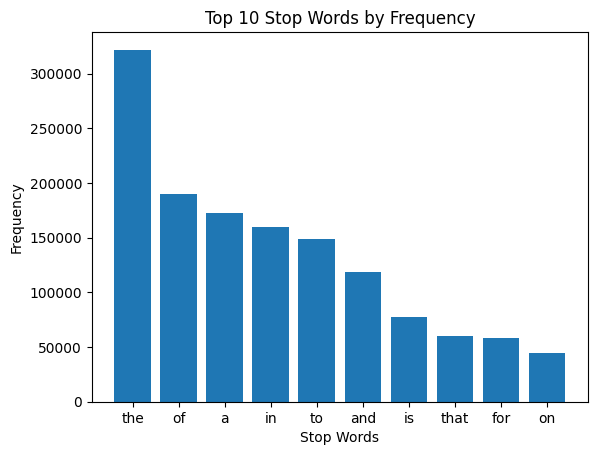

In [ ]:
from collections import Counter
import matplotlib.pyplot as plt

manual_stop_words = {
    'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', 'your',
    'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she',
    'her', 'hers', 'herself', 'it', 'its', 'itself', 'they', 'them', 'their',
    'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that',
    'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being',
    'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an',
    'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of',
    'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through',
    'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down',
    'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then',
    'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any',
    'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no',
    'nor', 'not', 'only', 'own', 'same', 'so', 'than', 'too', 'very', 's',
    't', 'can', 'will', 'just', 'don', 'should', 'now'
}
all_text = (
    " ".join(fact_checks['claim'].astype(str)) + " " +
    " ".join(posts['ocr'].astype(str)) + " " +
    " ".join(posts['text'].astype(str))
)


tokens = all_text.split()
stop_word_counts = Counter(word.lower() for word in tokens if word.lower() in manual_stop_words)


common_stop_words = stop_word_counts.most_common(10)


stop_words, counts = zip(*common_stop_words)
plt.bar(stop_words, counts)
plt.title('Top 10 Stop Words by Frequency')
plt.xlabel('Stop Words')
plt.ylabel('Frequency')
plt.show()


In [ ]:
# prompt: generate n_gram evaluation on posts, claim and text separtely

def generate_ngrams(text, n):
  """Generates n-grams from a text string."""
  if not text:
    return []
  tokens = text.split()
  ngrams = []
  for i in range(len(tokens) - n + 1):
    ngrams.append(' '.join(tokens[i:i+n]))
  return ngrams

def evaluate_ngrams(df, text_column, n):
  """Evaluates n-grams for a given DataFrame column."""
  ngram_counts = {}
  for text in df[text_column]:
    if isinstance(text, str):
      for ngram in generate_ngrams(text, n):
        if ngram in ngram_counts:
          ngram_counts[ngram] += 1
        else:
          ngram_counts[ngram] = 1
  return ngram_counts

# Evaluate n-grams for posts, claims, and text separately
n = 2  # You can change this to evaluate different n-gram sizes

text_ngrams = evaluate_ngrams(posts, 'text_original', n)
claim_ngrams = evaluate_ngrams(fact_checks, 'original_claim', n)
ocr_ngrams = evaluate_ngrams(posts, 'ocr_original', n)

print(f"Top 10 {n}-grams in text:")
sorted_post_ngrams = dict(sorted(text_ngrams.items(), key=lambda item: item[1], reverse=True))
for ngram, count in list(sorted_post_ngrams.items())[:10]:
  print(f"{ngram}: {count}")

print(f"\nTop 10 {n}-grams in claims:")
sorted_claim_ngrams = dict(sorted(claim_ngrams.items(), key=lambda item: item[1], reverse=True))
for ngram, count in list(sorted_claim_ngrams.items())[:10]:
  print(f"{ngram}: {count}")

print(f"\nTop 10 {n}-grams in ocr:")
sorted_text_ngrams = dict(sorted(ocr_ngrams.items(), key=lambda item: item[1], reverse=True))
for ngram, count in list(sorted_text_ngrams.items())[:10]:
  print(f"{ngram}: {count}")

In [ ]:
# prompt: can you create a plot that tells us how many words are there in posts, claim and ocr. Make separate graphs for all 3 columns

import matplotlib.pyplot as plt

def plot_word_counts(df, column_name, title):
  """Plots a histogram of word counts for a given DataFrame column."""
  word_counts = df[column_name].apply(lambda x: len(str(x).split()) if isinstance(x, str) else 0)
  plt.figure(figsize=(8, 6))
  plt.hist(word_counts, bins=20)
  plt.xlabel("Number of Words")
  plt.ylabel("Frequency")
  plt.title(title)
  plt.show()

# Plot word counts for posts, claims, and OCR separately
plot_word_counts(posts, 'text_original', 'Word Count Distribution in Posts')
plot_word_counts(fact_checks, 'original_claim', 'Word Count Distribution in Claims')
plot_word_counts(posts, 'ocr_original', 'Word Count Distribution in OCR')

In [ ]:
# prompt: analyse language dirtribution throughout the dataset in ocr_language, text_language, language

# Analyze language distribution in 'ocr_language', 'text_language', and 'language' columns
def analyze_language_distribution(df, column_name):
  """Analyzes the language distribution for a given DataFrame column."""
  language_counts = df[column_name].value_counts()
  return language_counts

ocr_language_distribution = analyze_language_distribution(posts, 'ocr_language')
text_language_distribution = analyze_language_distribution(posts, 'text_language')
fact_check_language_distribution = analyze_language_distribution(fact_checks, 'language')

print("OCR Language Distribution:")
print(ocr_language_distribution)

print("\nText Language Distribution:")
print(text_language_distribution)

print("\nFact Check Language Distribution:")
print(fact_check_language_distribution)

# Optional: Plot the language distributions
def plot_language_distribution(language_counts, title):
  """Plots a bar chart of language distribution."""
  plt.figure(figsize=(10, 6))
  plt.bar(language_counts.index, language_counts.values)
  plt.xlabel("Language")
  plt.ylabel("Frequency")
  plt.title(title)
  plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
  plt.show()

plot_language_distribution(ocr_language_distribution, "OCR Language Distribution")
plot_language_distribution(text_language_distribution, "Text Language Distribution")
plot_language_distribution(fact_check_language_distribution, "Fact Check Language Distribution")

In [ ]:
import ast

def safe_eval_claim(claim):
    try:
        if isinstance(claim, str):
            return ast.literal_eval(claim)
        return (None, None)
    except (ValueError, SyntaxError):
        return (None, None)


merged_data[['original_claim', 'translated_claim']] = merged_data['claim'].apply(
    safe_eval_claim
).apply(pd.Series)

claims_per_post_with_languages = merged_data.groupby('post_id').agg({
    'text': 'first',
    'original_claim': 'unique',
    'translated_claim': 'unique'
})

#
posts_with_multilingual_claims = claims_per_post_with_languages[
    (claims_per_post_with_languages['original_claim'].apply(len) > 1) |
    (claims_per_post_with_languages['translated_claim'].apply(len) > 1)
]


if not posts_with_multilingual_claims.empty:
    for post_id, row in posts_with_multilingual_claims.iterrows():
        print(f"Post ID: {post_id}")
        print(f"Post Text: {row['text']}")
        print("Original Claims (Different Languages):")
        for claim in row['original_claim']:
            print(f" - {claim}")
        print("Translated Claims (Different Languages):")
        for claim in row['translated_claim']:
            print(f" - {claim}")
        print("\n")
else:
    print("No posts with claims in different languages found.")


Post ID: 11
Post Text: [('"EL AGUINALDO DE 2 MILLONES NO ES SOLO PARA NOSOTROS ES PARA NUESTROS ASESORES ELLOS TAMBIÉN TIENEN FAMILIA. ASI QUE LE PIDO A LA CAN DERECHA QUE DEJE DE MENTIR" CHILE En el listado de las 100 personas más influyentes de 2021', '"THE BONUS OF 2 MILLION IT\'S NOT JUST FOR US IT\'S FOR OUR ADVISORS THEY HAVE TOO FAMILY. SO I ASK THE CAN RIGHT TO STOP LYING" CHILE In the list of the 100 most influencers of 2021', [('spa', 0.9743000268936157), ('eng', 0.02569996565580368)])]
Original Claims (Different Languages):
 - Los Constituyentes recibieron 2 millones de pesos como aguinaldo dieciochero
 - None
Translated Claims (Different Languages):
 - nan


Post ID: 231
Post Text: [('2020: Peak active cases - 9,034,460 Vaccinated - 0% 2021: Peak active cases - 9,243,682 Vaccinated - 71% I hate to break this to you, but this not a "pandemic of the unvaccinated."', '2020: Peak active cases - 9,034,460 Vaccinated - 0% 2021: Peak active cases - 9,243,682 Vaccinated - 71% I hat

In [ ]:
from sentence_transformers import SentenceTransformer, util
import pandas as pd

# Load the model
model = SentenceTransformer('all-MiniLM-L6-v2')

# Extract claims and their embeddings
claims = merged_data['claim'].astype(str).tolist()
claims_embeddings = model.encode(claims, convert_to_tensor=True)

# Initialize counters for accuracy calculation
correct_predictions = 0

for index, row in merged_data.iterrows():
    post_text = row['text']
    ground_truth_claim = row['claim']

    # Encode the post text
    post_embedding = model.encode(post_text, convert_to_tensor=True)

    # Compute cosine similarities
    similarities = util.cos_sim(post_embedding, claims_embeddings)[0]

    # Find the most similar claim
    most_similar_index = similarities.argmax().item()
    most_similar_claim = claims[most_similar_index]

    # Compare predicted claim with the ground truth
    if most_similar_claim == ground_truth_claim:
        correct_predictions += 1

# Calculate accuracy
total_posts = len(merged_data)
accuracy = correct_predictions / total_posts * 100
print(f"Accuracy: {accuracy:.2f}%")


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Accuracy: 25.87%
